

# CIBMTR - Equity in post-HCT Survival Predictions
### Introduction

This notebook is for the [Equity post-HCT survival predictions competition](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions). The final private leaderboard score is **0.69261**, placing me at **773 / 3327** participants. The top solution achieves **0.70127**, so it is quite close!

**High-level strategy**:
1. **Feature Engineering & Splitting**. We create separate classification/regression pipelines.
2. **Stage 1**: Classification models (binary `efs=1` vs `efs=0`) to estimate the probability of an event.
3. **Stage 2**: Regression models (e.g. log EFS time, Kaplan-Meier, etc.) to model the timing or hazard dimension.
4. **Merging**: We combine the classification & regression outputs in an aggregator, searching for best parameters via Optuna.

**Regarding the Negative Sign**:  
- The official competition scoring function uses `-prediction` because it expects “risk scores,” i.e. bigger = *more* risk = *earlier event*. 

```python
c_index_race = concordance_index(merged_df_race[interval_label],
                                 -merged_df_race[prediction_label], # negative sign here
                                 merged_df_race[event_label])
```

- The regression models produce *longer survival* for bigger predictions. That’s the opposite orientation.  
- In some prior attempts, I included the negative sign in `score(...)` or in the aggregator. Ultimately, we want to make sure that the final scoring sees “larger = riskier.” 
- Another approach is to **remove** the negative in the metric and **manually flip** survival-based models in the aggregator. Either way can be correct, just be consistent with the competition’s expectation.

```python
c_index_race = concordance_index(merged_df_race[interval_label],
                                 merged_df_race[prediction_label], # no negative
                                 merged_df_race[event_label])
```

The best solution so far uses the competition's metric and the aggregator parameters found by Optuna with flipping to KM and Cox targets, yielding the final LB score of 0.69261. 


### Libaries

**Note:** 
To compute the competition metric in a Kaggle notebook, you must attach Kaggle's metric notebook and add the following notebook as an input on Kaggle since the competition notebooks must have internet turned off (https://www.kaggle.com/code/cdeotte/pip-install-lifelines). This notebook contains WHL files to allow you to pip install with internet off. 

In [1]:
# !pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl -q
# !pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz -q
# !pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl -q
# !pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl -q
# !pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl -q

In [ ]:
import sys
import os
# if you are running this in kaggle, make a kaggle dataset with all python files 
# then you can append it here and remove src. from import statements
sys.path.append("/kaggle/input/woohoo") 

# add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))  
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
from src.config import CFG
from src.feature_engineering import FE
from src.train import MD, train_and_predict
from src.ensemble import optimize_merge_params
import gc
import numpy as np
import torch

In [3]:
# check GPU for PyTorch
print("PyTorch CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))

PyTorch CUDA Available: True
Using GPU: NVIDIA GeForce RTX 3070 Ti


### Feature Engineering

In [4]:
fe = FE(batch_size=CFG.batch_size)

# tree models
train_tree = fe.feature_engineering_pipeline(CFG.train_path, "tree", train=True)
test_tree = fe.feature_engineering_pipeline(CFG.test_path, "tree", train=False)
cat_cols_tree = train_tree['feature_cat']  
print(len(cat_cols_tree))

# CoxResNet
train_cox = fe.feature_engineering_pipeline(CFG.train_path, "coxresnet", train=True)
test_cox = fe.feature_engineering_pipeline(CFG.test_path, "coxresnet", train=False)
cat_cols_cox = train_cox['feature_cat']  
print(len(cat_cols_cox))

35
34


In [5]:
train_tree

{'X':           ID dri_score psych_disturb cyto_score diabetes  hla_match_c_high  \
 0          0         7             0          7        0               2.0   
 1          1         2             0          1        0               2.0   
 2          2         7             0          7        0               2.0   
 3          3         0             0          1        0               2.0   
 4          4         0             0          7        0               2.0   
 ...      ...       ...           ...        ...      ...               ...   
 28795  28795         3             2          0        0               2.0   
 28796  28796         0             0          5        3               1.0   
 28797  28797         9             2          5        2               2.0   
 28798  28798         7             0          5        0               1.0   
 28799  28799         8             0          7        0               2.0   
 
        hla_high_res_8 tbi_status arrhythmia 

In [6]:
test_tree

{'X':       ID dri_score psych_disturb cyto_score diabetes  hla_match_c_high  \
 0  28800         7             0          7        0               2.0   
 1  28801         2             0          1        0               2.0   
 2  28802         7             0          7        0               2.0   
 
    hla_high_res_8 tbi_status arrhythmia  hla_low_res_6  ... hepatic_mild  \
 0             8.0          0          0            6.0  ...            0   
 1             8.0          6          0            6.0  ...            0   
 2             8.0          0          0            6.0  ...            0   
 
   tce_div_match donor_related melphalan_dose hla_low_res_8  cardiac  \
 0             4             3              1           8.0        0   
 1             3             1              1           8.0        0   
 2             3             1              1           8.0        0   
 
   hla_match_drb1_high  pulm_moderate  hla_low_res_10 target_norm  
 0                 2.0   

In [7]:
train_cox

{'X':           ID  dri_score  psych_disturb  cyto_score  diabetes  \
 0          0          7              0           7         0   
 1          1          2              0           1         0   
 2          2          7              0           7         0   
 3          3          0              0           1         0   
 4          4          0              0           7         0   
 ...      ...        ...            ...         ...       ...   
 28795  28795          3              2           0         0   
 28796  28796          0              0           5         3   
 28797  28797          9              2           5         2   
 28798  28798          7              0           5         0   
 28799  28799          8              0           7         0   
 
        hla_match_c_high  hla_high_res_8  tbi_status  arrhythmia  \
 0              0.488048        0.610215           0           0   
 1              0.488048        0.610215           6           0   
 2       

In [8]:
test_cox

{'X':       ID  dri_score  psych_disturb  cyto_score  diabetes  hla_match_c_high  \
 0  28800          1              0           1         0          0.488048   
 1  28801          0              0           0         0          0.488048   
 2  28802          1              0           1         0          0.488048   
 
    hla_high_res_8  tbi_status  arrhythmia  hla_low_res_6  ...  \
 0        0.610215           0           0       0.649549  ...   
 1        0.610215           1           0       0.649549  ...   
 2        0.610215           0           0       0.649549  ...   
 
    melphalan_dose_N/A, Mel not given  melphalan_dose_Unknown  cardiac_No  \
 0                                1.0                     0.0         1.0   
 1                                1.0                     0.0         1.0   
 2                                1.0                     0.0         1.0   
 
    cardiac_Not done  cardiac_Unknown  cardiac_Yes  pulm_moderate_No  \
 0               0.0         

### Column Alignment & Feature Consistency

After feature engineering, our train and test sets sometimes have slightly different columns (due to missing categories or transformations). We fix this via a simple helper function. This ensures no shape mismatch between train & test features before building our final pipeline.

In [9]:
def align_columns(train_df, test_df):
    missing_cols = set(train_df.columns) - set(test_df.columns)
    extra_cols = set(test_df.columns) - set(train_df.columns)
    print("Missing Columns in Train DataFrame: ", missing_cols)
    print("Extra Columns in Test DataFrame: ", extra_cols)

    # add missing cols in test set 
    for col in missing_cols:
        test_df[col] = -1

    test_df = test_df.drop(columns=extra_cols) # remove extra cols from test set
    test_df = test_df[train_df.columns] # identical column ordering

    return test_df

test_tree['X'] = align_columns(train_tree['X'], test_tree['X']) # Tree models features alignment
test_cox['X'] = align_columns(train_cox['X'], test_cox['X']) # CoxResNet features alignment

# make sure there are no shape mismathces btw train/test
assert train_tree['X'].shape[1] == test_tree['X'].shape[1]
assert train_cox['X'].shape[1] == test_cox['X'].shape[1]

Missing Columns in Train DataFrame:  {'log_efs_time', 'km_survival_prob', 'na_cum_hazard', 'ranked_efs_time', 'neg_exp_na_cum_hazard'}
Extra Columns in Test DataFrame:  set()
Missing Columns in Train DataFrame:  {'log_efs_time', 'km_survival_prob', 'na_cum_hazard', 'ranked_efs_time', 'neg_exp_na_cum_hazard'}
Extra Columns in Test DataFrame:  set()


### Building DataFrames for Model Training

Below, we merge our feature matrices (`X`) with the target columns (`efs`, `efs_time`, and `race_group`). We also convert single-column DataFrames into Series with `.squeeze()`, ensuring correct data types for training. We do this for each pipeline (tree vs. CoxResNet) so both have consistent targets and features in a single DataFrame.



In [10]:
# convert single-col DataFrame to Series with squeeze for .str methods to work 
train_tree_df = pd.concat([train_tree['X'], 
                           train_tree['efs'].astype(int).squeeze(),  
                           train_tree['efs_time'].astype(float).squeeze(),
                           train_tree['race_group'].astype(str).squeeze()], axis=1)

md_tree = MD(CFG.color, train_tree_df, cat_cols=cat_cols_tree, early_stop=CFG.early_stop, n_splits=CFG.n_splits)

train_cox_df = pd.concat([train_cox['X'],
                          train_cox['efs'].astype(int).squeeze(),
                          train_cox['efs_time'].astype(float).squeeze(),
                          train_cox['race_group'].astype(str).squeeze()], axis=1)

md_cox = MD(CFG.color, train_cox_df, cat_cols=cat_cols_cox, early_stop=CFG.early_stop, n_splits=CFG.n_splits)

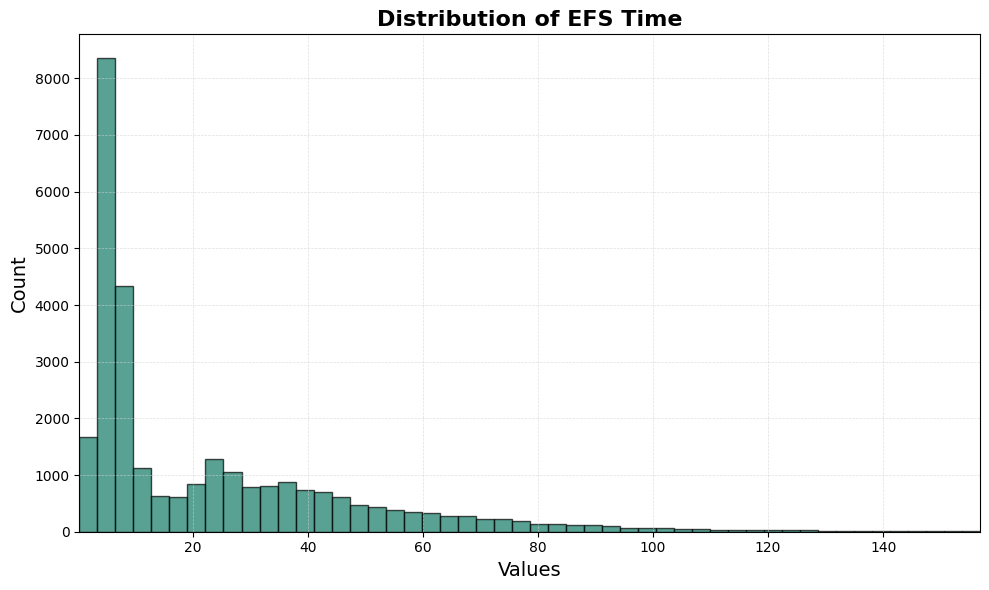

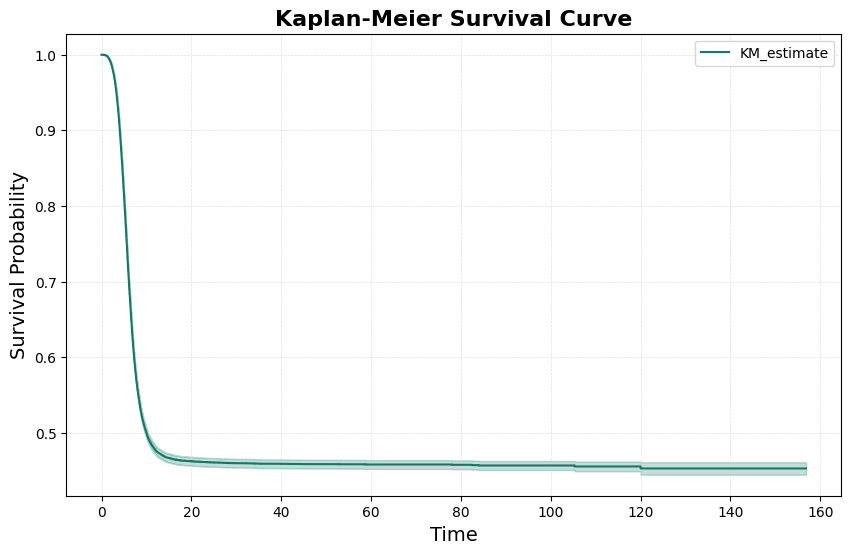

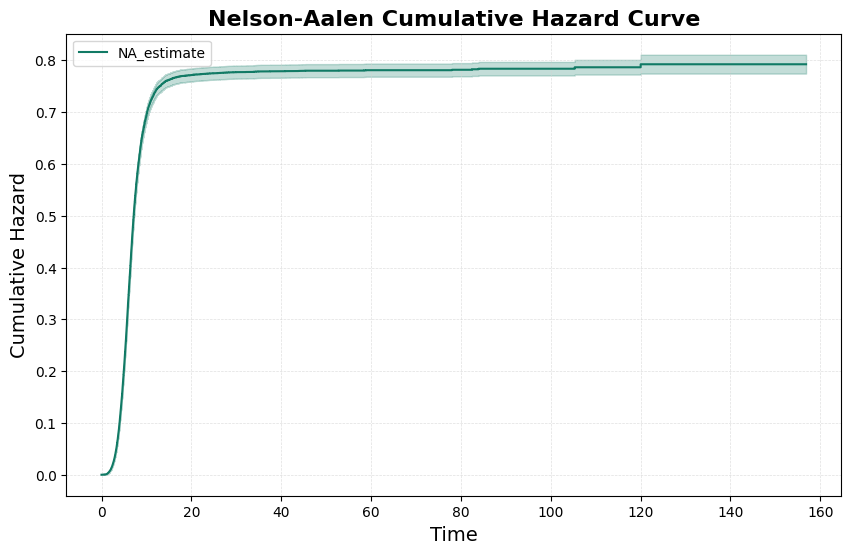

In [ ]:
# 1. distribution of efs_time
md_tree.eda.distribution_plot(col='efs_time', title='Distribution of EFS Time', bins=50)

# 2. Kaplan-Meier survival curve across the entire dataset
md_tree.eda.plot_kaplan_meier(time_col='efs_time', event_col='efs')

# 3. Nelson-Aalen cumulative hazard curve
md_tree.eda.plot_nelson_aalen(time_col='efs_time', event_col='efs')



Fold 1
Fold 1 ROC AUC: 0.7578, Log Loss: 0.5818

Fold 2
Fold 2 ROC AUC: 0.7589, Log Loss: 0.5798

Fold 3
Fold 3 ROC AUC: 0.7472, Log Loss: 0.5896

Fold 4
Fold 4 ROC AUC: 0.7536, Log Loss: 0.5855

Fold 5
Fold 5 ROC AUC: 0.7543, Log Loss: 0.5861


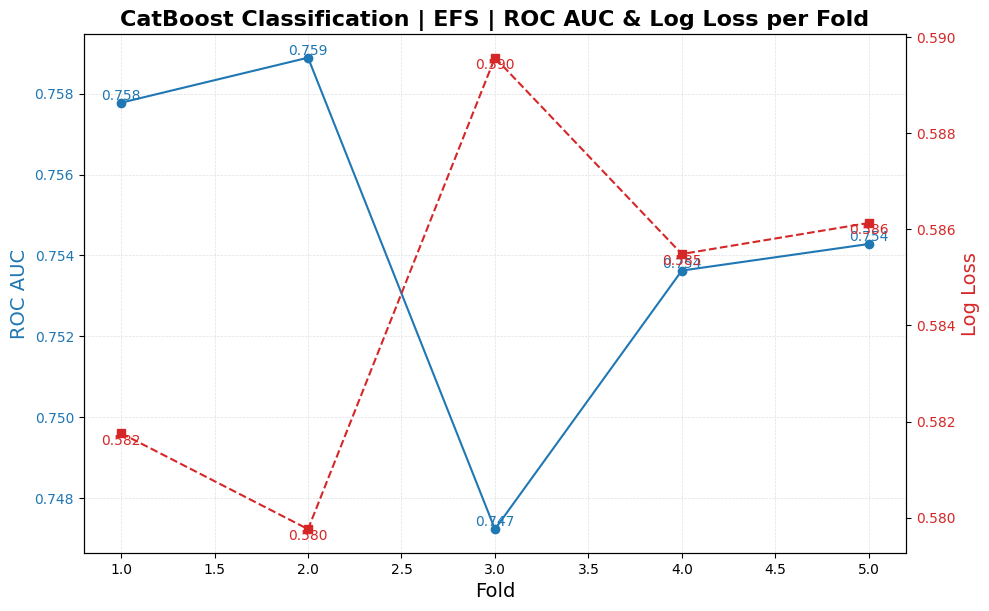

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
[0]	validation_0-logloss:0.68769
[1]	validation_0-logloss:0.68701
[2]	validation_0-logloss:0.68204
[3]	validation_0-logloss:0.68058
[4]	validation_0-logloss:0.67789
[5]	validation_0-logloss:0.67560
[6]	validation_0-logloss:0.67218
[7]	validation_0-logloss:0.67032
[8]	validation_0-logloss:0.66729
[9]	validation_0-logloss:0.66671
[10]	validation_0-logloss:0.66480
[11]	validation_0-logloss:0.66413
[12]	validation_0-logloss:0.66203
[13]	validation_0-logloss:0.66032
[14]	validation_0-logloss:0.65931
[15]	validation_0-logloss:0.65674
[16]	validation_0-logloss:0.65534
[17]	validation_0-logloss:0.65371
[18]	validation_0-logloss:0.65231
[19]	validation_0-logloss:0.65120
[20]	validation_0-logloss:0.65036
[21]	validation_0-logloss:0.64894
[22]	validation_0-logloss:0.64823
[23]	validation_0-logloss:0.64731
[24]	validation_0-lo

c:\Users\mattg\kaggle_env\lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-logloss:0.65873
[15]	validation_0-logloss:0.65611
[16]	validation_0-logloss:0.65446
[17]	validation_0-logloss:0.65262
[18]	validation_0-logloss:0.65086
[19]	validation_0-logloss:0.64968
[20]	validation_0-logloss:0.64852
[21]	validation_0-logloss:0.64707
[22]	validation_0-logloss:0.64602
[23]	validation_0-logloss:0.64489
[24]	validation_0-logloss:0.64417
[25]	validation_0-logloss:0.64328
[26]	validation_0-logloss:0.64234
[27]	validation_0-logloss:0.64170
[28]	validation_0-logloss:0.64037
[29]	validation_0-logloss:0.63973
[30]	validation_0-logloss:0.63882
[31]	validation_0-logloss:0.63808
[32]	validation_0-logloss:0.63654
[33]	validation_0-logloss:0.63585
[34]	validation_0-logloss:0.63504
[35]	validation_0-logloss:0.63420
[36]	validation_0-logloss:0.63347
[37]	validation_0-logloss:0.63285
[38]	validation_0-logloss:0.63216
[39]	validation_0-logloss:0.63149
[40]	validation_0-logloss:0.63076
[41]	validation_0-logloss:0.62972
[42]	validation_0-logloss:0.62896
[43]	validatio

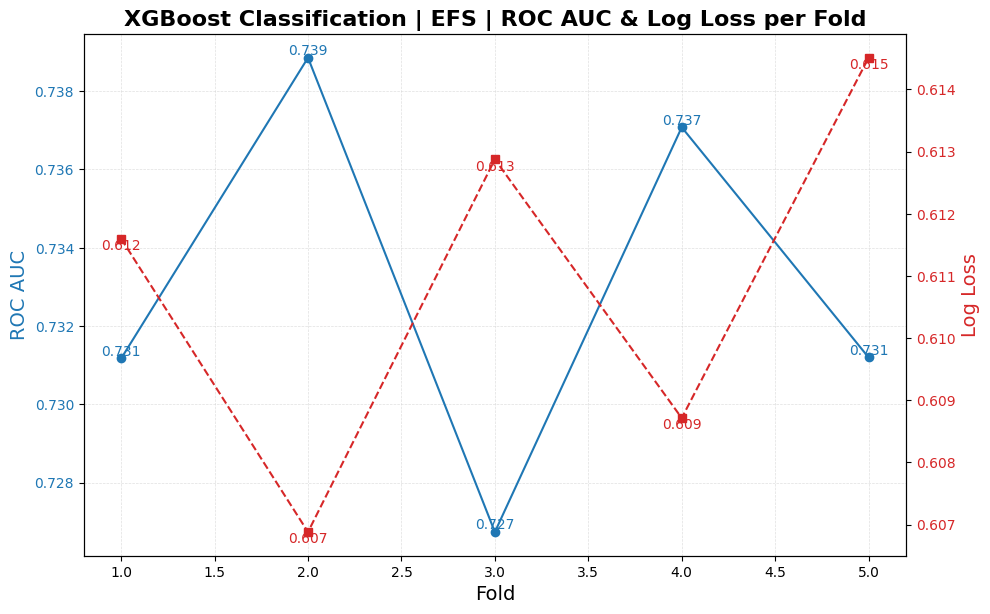

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 ROC AUC: 0.7547, Log Loss: 0.5853

Fold 2


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 ROC AUC: 0.7579, Log Loss: 0.5817

Fold 3


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 ROC AUC: 0.7469, Log Loss: 0.5889

Fold 4


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 ROC AUC: 0.7524, Log Loss: 0.5865

Fold 5


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 ROC AUC: 0.7522, Log Loss: 0.5886


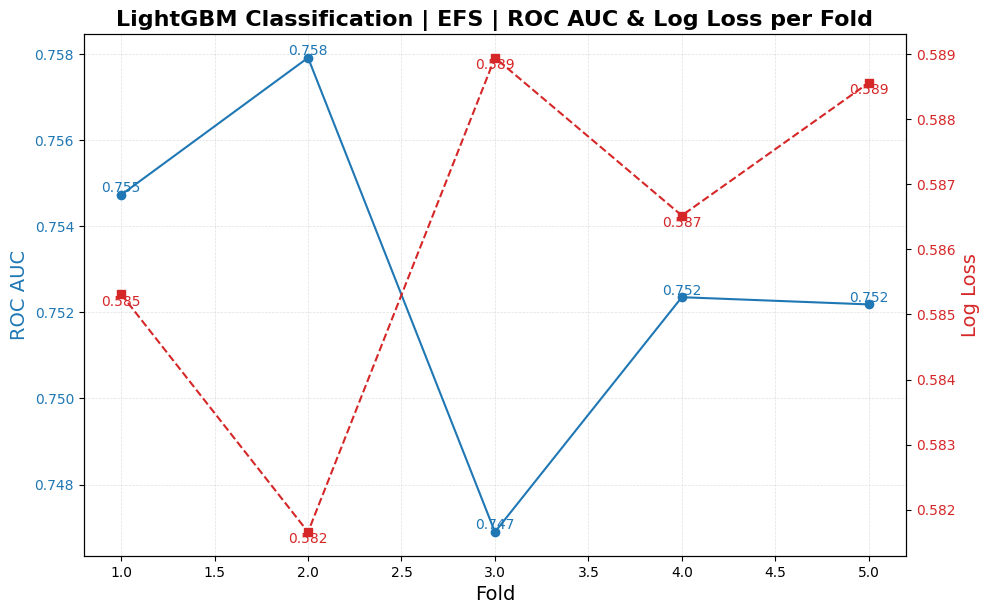

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 ROC AUC: 0.7496, Log Loss: 0.5892

Fold 2
Fold 2 ROC AUC: 0.7581, Log Loss: 0.5822

Fold 3
Fold 3 ROC AUC: 0.7415, Log Loss: 0.5947

Fold 4
Fold 4 ROC AUC: 0.7444, Log Loss: 0.5916

Fold 5
Fold 5 ROC AUC: 0.7466, Log Loss: 0.5920


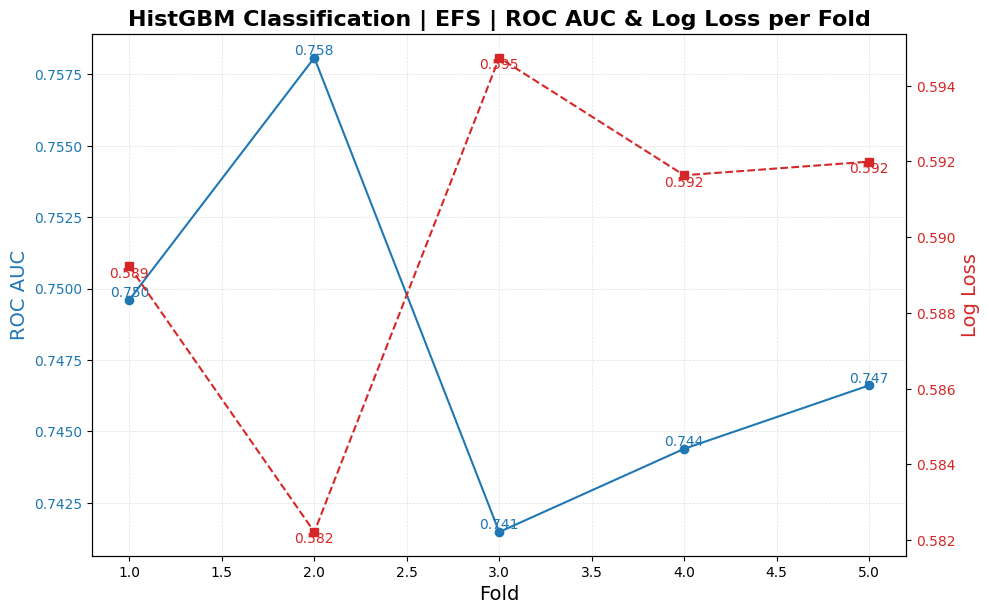

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0863

Fold 2
Fold 2 Stratified C-Index: 0.0891

Fold 3
Fold 3 Stratified C-Index: 0.0925

Fold 4
Fold 4 Stratified C-Index: 0.0881

Fold 5
Fold 5 Stratified C-Index: 0.0869


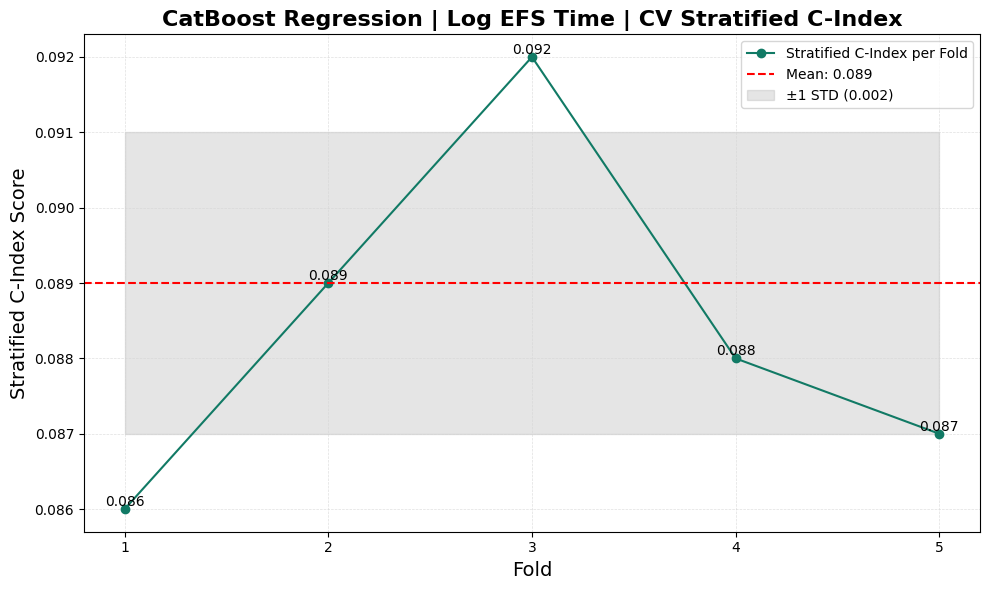

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 Stratified C-Index: 0.0884

Fold 2


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 Stratified C-Index: 0.0885

Fold 3


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 Stratified C-Index: 0.0949

Fold 4


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 Stratified C-Index: 0.0898

Fold 5


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 Stratified C-Index: 0.0872


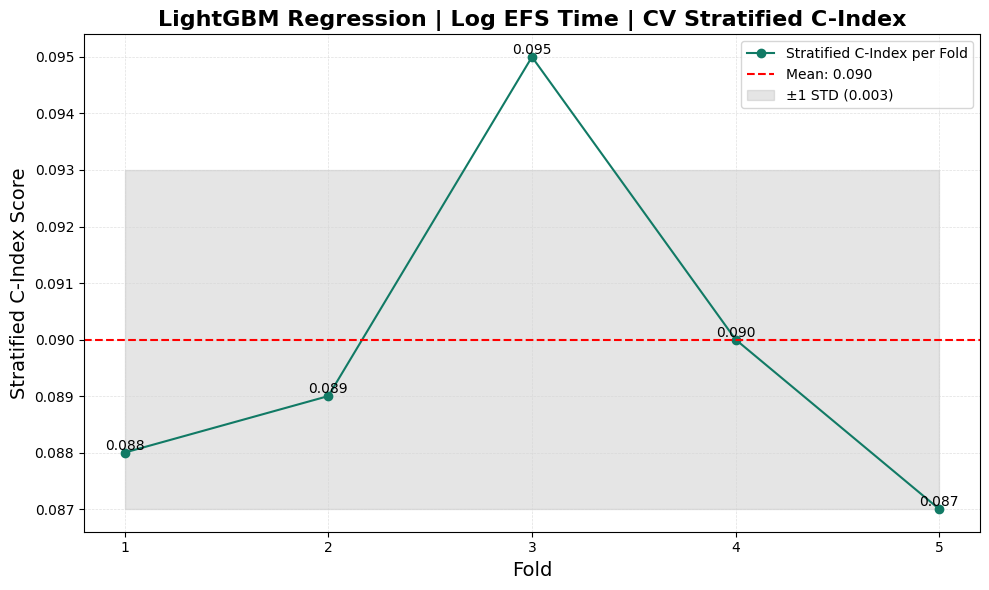

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0877

Fold 2
Fold 2 Stratified C-Index: 0.0854

Fold 3
Fold 3 Stratified C-Index: 0.0918

Fold 4
Fold 4 Stratified C-Index: 0.0908

Fold 5
Fold 5 Stratified C-Index: 0.0861


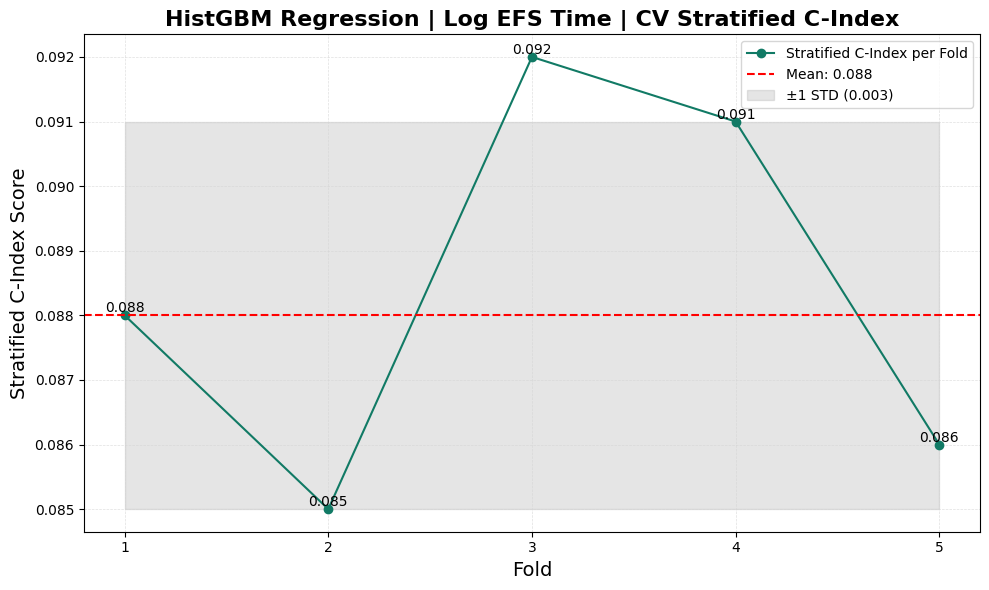

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.8915

Fold 2
Fold 2 Stratified C-Index: 0.8897

Fold 3
Fold 3 Stratified C-Index: 0.8888

Fold 4
Fold 4 Stratified C-Index: 0.8962

Fold 5
Fold 5 Stratified C-Index: 0.8928


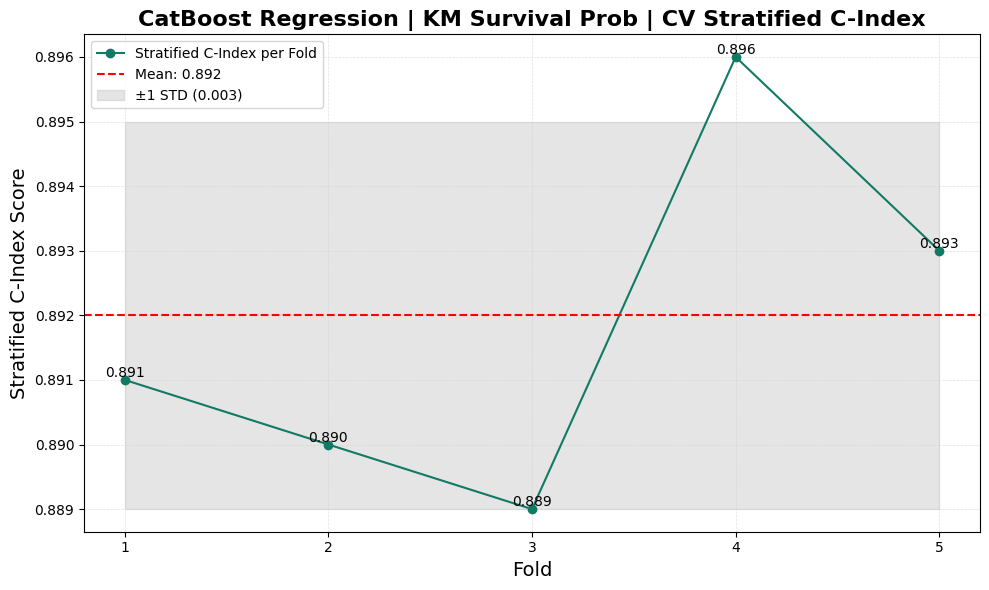

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 Stratified C-Index: 0.8883

Fold 2


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 Stratified C-Index: 0.8904

Fold 3


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 Stratified C-Index: 0.8863

Fold 4


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 Stratified C-Index: 0.8964

Fold 5


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 Stratified C-Index: 0.8928


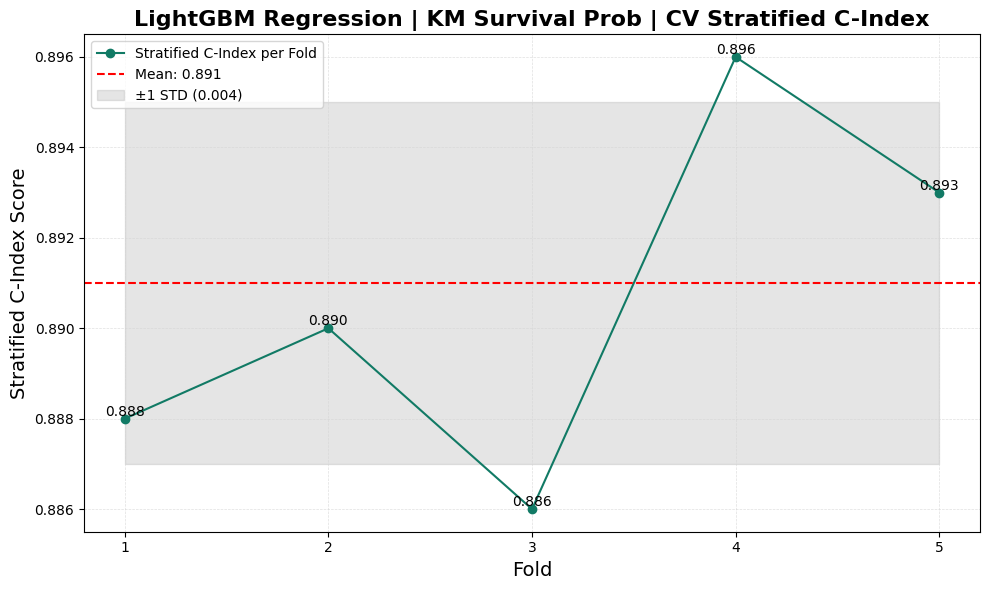

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.8882

Fold 2
Fold 2 Stratified C-Index: 0.8863

Fold 3
Fold 3 Stratified C-Index: 0.8852

Fold 4
Fold 4 Stratified C-Index: 0.8932

Fold 5
Fold 5 Stratified C-Index: 0.8855


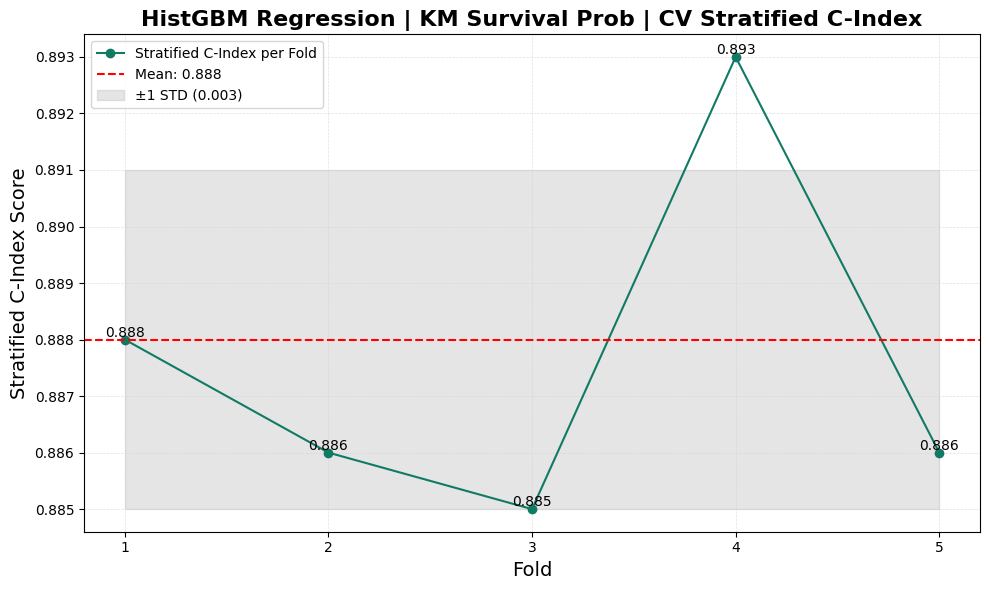

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0867

Fold 2
Fold 2 Stratified C-Index: 0.0908

Fold 3
Fold 3 Stratified C-Index: 0.0959

Fold 4
Fold 4 Stratified C-Index: 0.0882

Fold 5
Fold 5 Stratified C-Index: 0.0878


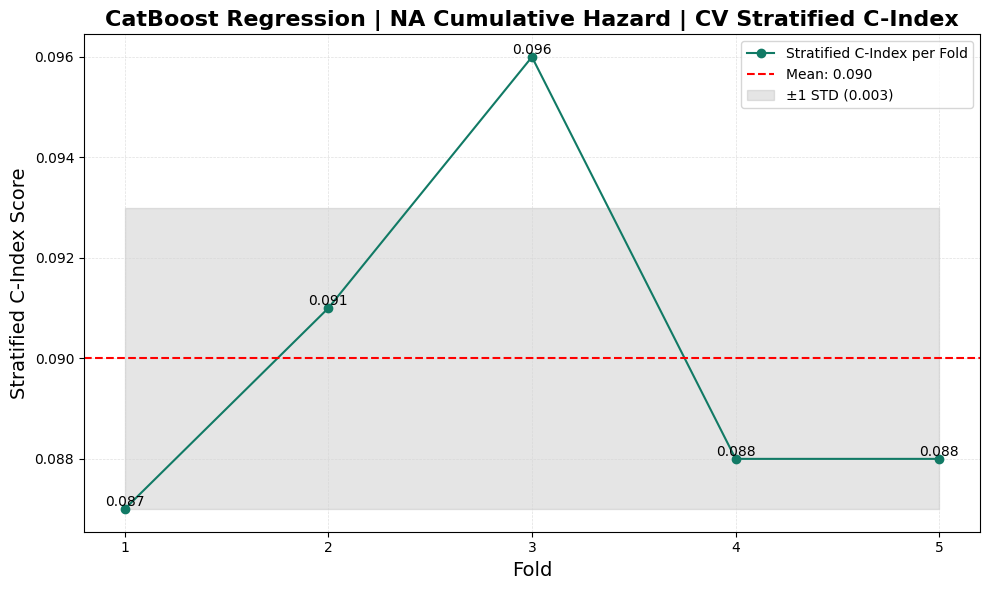

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 Stratified C-Index: 0.0900

Fold 2


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 Stratified C-Index: 0.0902

Fold 3


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 Stratified C-Index: 0.0959

Fold 4


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 Stratified C-Index: 0.0908

Fold 5


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 Stratified C-Index: 0.0886


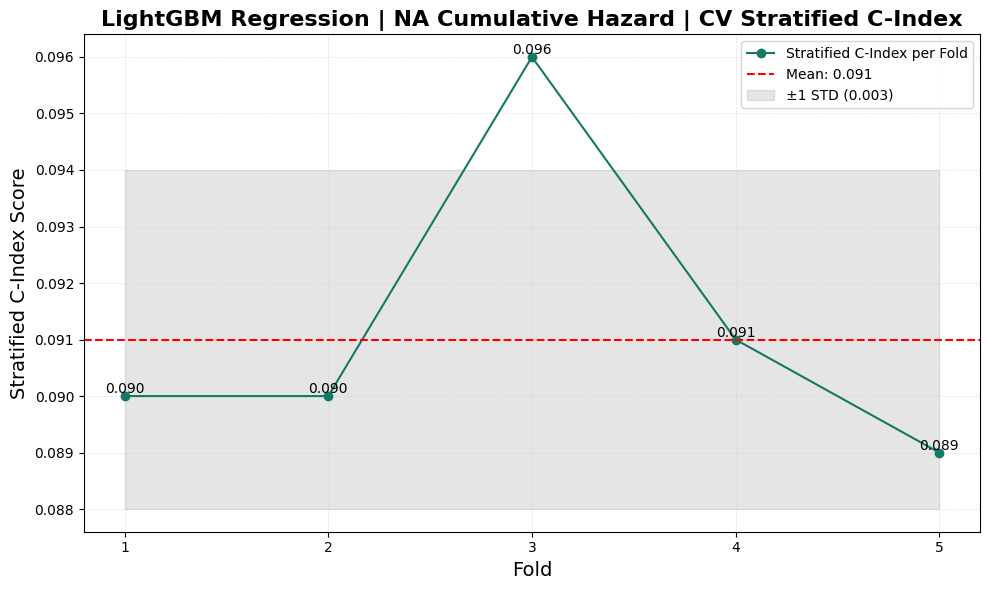

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0909

Fold 2
Fold 2 Stratified C-Index: 0.0916

Fold 3
Fold 3 Stratified C-Index: 0.0961

Fold 4
Fold 4 Stratified C-Index: 0.0912

Fold 5
Fold 5 Stratified C-Index: 0.0906


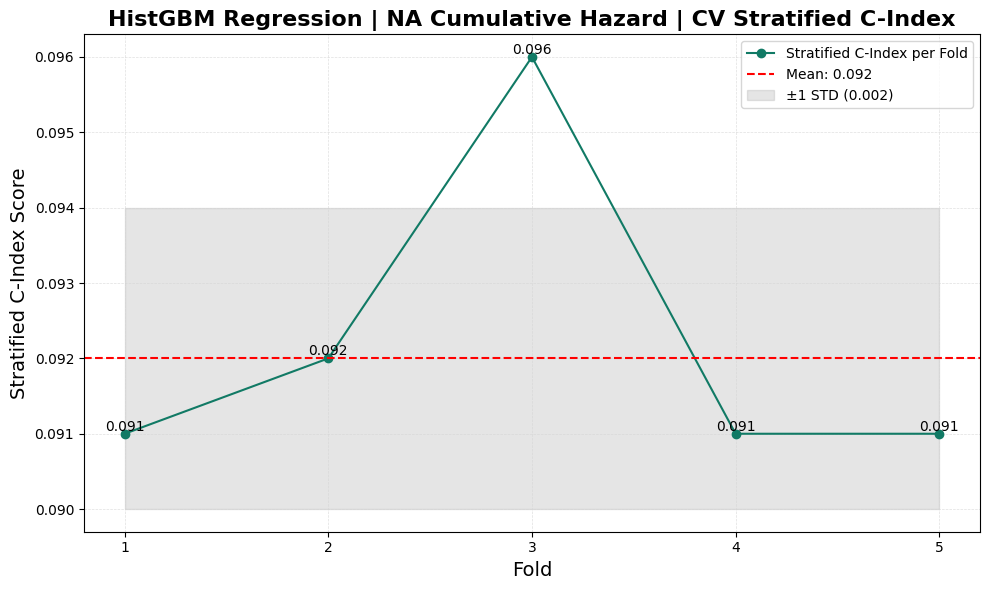

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0859

Fold 2
Fold 2 Stratified C-Index: 0.0890

Fold 3
Fold 3 Stratified C-Index: 0.0928

Fold 4
Fold 4 Stratified C-Index: 0.0871

Fold 5
Fold 5 Stratified C-Index: 0.0876


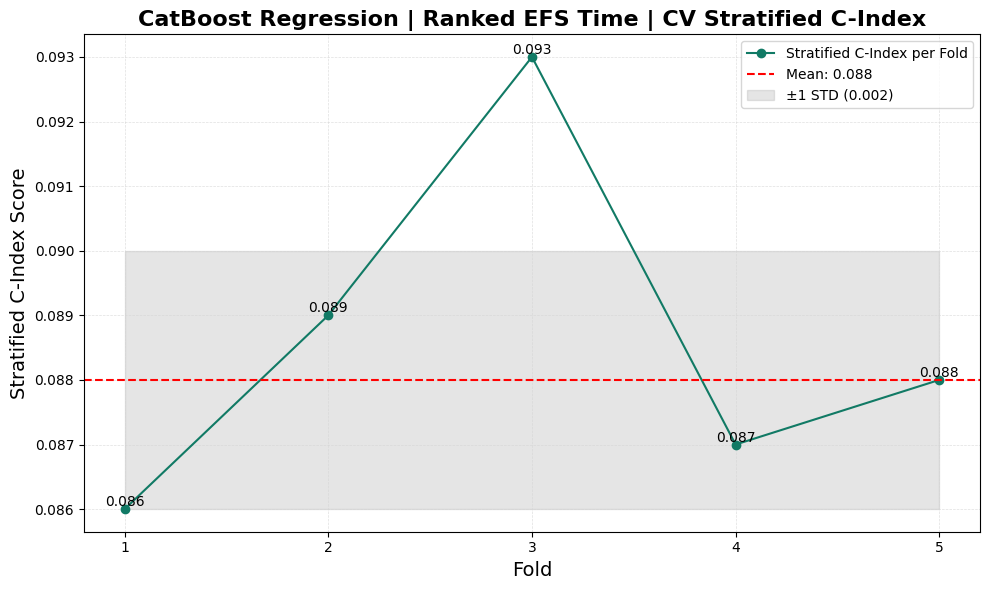

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 Stratified C-Index: 0.0881

Fold 2


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 Stratified C-Index: 0.0895

Fold 3


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 Stratified C-Index: 0.0901

Fold 4


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 Stratified C-Index: 0.0898

Fold 5


c:\Users\mattg\kaggle_env\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 Stratified C-Index: 0.0891


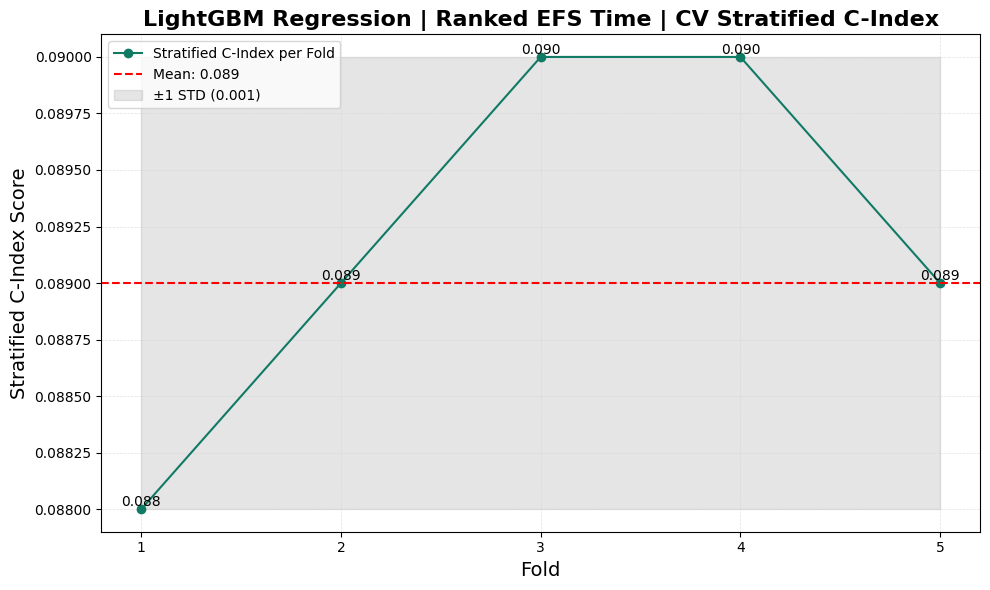

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Fold 1
Fold 1 Stratified C-Index: 0.0878

Fold 2
Fold 2 Stratified C-Index: 0.0901

Fold 3
Fold 3 Stratified C-Index: 0.0929

Fold 4
Fold 4 Stratified C-Index: 0.0895

Fold 5
Fold 5 Stratified C-Index: 0.0881


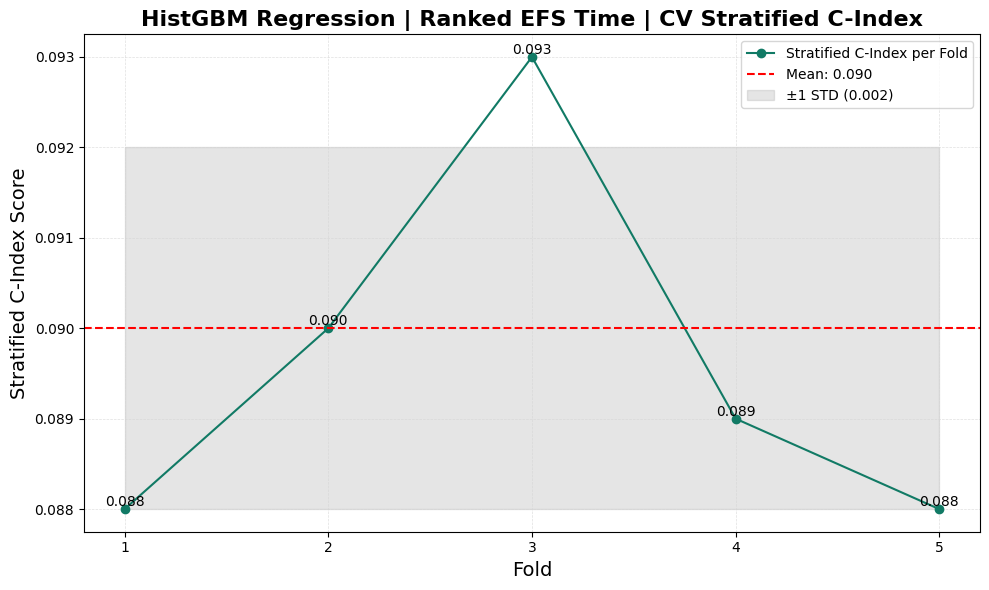

extra features in test data (will be dropped): ['ID', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']


In [ ]:
model_configs_tree = [
    # classification models (predicting EFS binary outcome)
    {"model_type": "CatBoost", "params": CFG.ctb_class_params, "target": "efs", "is_classifier": True, "title": "CatBoost Classification | EFS"},
    {"model_type": "XGBoost", "params": CFG.xgb_class_params, "target": "efs", "is_classifier": True, "title": "XGBoost Classification | EFS"},
    {"model_type": "LightGBM", "params": CFG.lgb_class_params, "target": "efs", "is_classifier": True, "title": "LightGBM Classification | EFS"},
    {"model_type": "HistGBM", "params": CFG.hist_class_params, "target": "efs", "is_classifier": True, "title": "HistGBM Classification | EFS"},

    # regression models (predicting log EFS time)
    {"model_type": "CatBoost", "params": CFG.cat_reg_params, "target": "log_efs_time", "is_classifier": False, "title": "CatBoost Regression | Log EFS Time"},
    #{"model_type": "XGBoost", "params": CFG.xgb_reg_log_EFSTime_params, "target": "log_efs_time", "is_classifier": False, "title": "XGBoost Regression | Log EFS Time"},
    {"model_type": "LightGBM", "params": CFG.lgb_reg_params, "target": "log_efs_time", "is_classifier": False, "title": "LightGBM Regression | Log EFS Time"},
    {"model_type": "HistGBM", "params": CFG.hist_reg_log_EFSTime_params, "target": "log_efs_time", "is_classifier": False, "title": "HistGBM Regression | Log EFS Time"},

    # regression models (predicting Kaplan-Meier survival probability)
    {"model_type": "CatBoost", "params": CFG.cat_reg_params, "target": "km_survival_prob", "is_classifier": False, "title": "CatBoost Regression | KM Survival Prob"},
    #{"model_type": "XGBoost", "params": CFG.xgb_reg_KM_params, "target": "km_survival_prob", "is_classifier": False, "title": "XGBoost Regression | KM Survival Prob"},
    {"model_type": "LightGBM", "params": CFG.lgb_reg_params, "target": "km_survival_prob", "is_classifier": False, "title": "LightGBM Regression | KM Survival Prob"},
    {"model_type": "HistGBM", "params": CFG.hist_reg_KMSurv_params, "target": "km_survival_prob", "is_classifier": False, "title": "HistGBM Regression | KM Survival Prob"},

    # regression models (predicting Nelson-Aalen cumulative hazard)
    {"model_type": "CatBoost", "params": CFG.cat_reg_params, "target": "na_cum_hazard", "is_classifier": False, "title": "CatBoost Regression | NA Cumulative Hazard"},
    #{"model_type": "XGBoost", "params": CFG.xgb_reg_KM_params, "target": "na_cum_hazard", "is_classifier": False, "title": "XGBoost Regression | NA Cumulative Hazard"},
    {"model_type": "LightGBM", "params": CFG.lgb_reg_params, "target": "na_cum_hazard", "is_classifier": False, "title": "LightGBM Regression | NA Cumulative Hazard"},
    {"model_type": "HistGBM", "params": CFG.hist_reg_NACumHaz_params, "target": "na_cum_hazard", "is_classifier": False, "title": "HistGBM Regression | NA Cumulative Hazard"},

    # regression models (predicting ranked EFS time)
    {"model_type": "CatBoost", "params": CFG.cat_reg_params, "target": "ranked_efs_time", "is_classifier": False, "title": "CatBoost Regression | Ranked EFS Time"},
    #{"model_type": "XGBoost", "params": CFG.xgb_reg_log_EFSTime_params, "target": "ranked_efs_time", "is_classifier": False, "title": "XGBoost Regression | Ranked EFS Time"},
    {"model_type": "LightGBM", "params": CFG.lgb_reg_params, "target": "ranked_efs_time", "is_classifier": False, "title": "LightGBM Regression | Ranked EFS Time"},
    {"model_type": "HistGBM", "params": CFG.hist_reg_log_EFSTime_params, "target": "ranked_efs_time", "is_classifier": False, "title": "HistGBM Regression | Ranked EFS Time"},
]

models_tree, oof_preds_tree, test_preds_tree = train_and_predict(md_tree, model_configs_tree, test_tree['X'])

In [13]:
train_cox_df.columns

Index(['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6',
       ...
       'cardiac_Not done', 'cardiac_Unknown', 'cardiac_Yes',
       'pulm_moderate_No', 'pulm_moderate_Not done', 'pulm_moderate_Unknown',
       'pulm_moderate_Yes', 'efs', 'efs_time', 'race_group'],
      dtype='object', length=252)

Training Fold 1
Epoch 1/100, Loss: 2.6706
Epoch 2/100, Loss: 2.6709
Epoch 3/100, Loss: 2.6702
Epoch 4/100, Loss: 2.6708
Epoch 5/100, Loss: 2.6706
Epoch 6/100, Loss: 2.6698
Epoch 7/100, Loss: 2.6521
Epoch 8/100, Loss: 2.6365
Epoch 9/100, Loss: 2.6248
Epoch 10/100, Loss: 2.6163
Epoch 11/100, Loss: 2.6093
Epoch 12/100, Loss: 2.6009
Epoch 13/100, Loss: 2.5916
Epoch 14/100, Loss: 2.5812
Epoch 15/100, Loss: 2.5685
Epoch 16/100, Loss: 2.5557
Epoch 17/100, Loss: 2.5430
Epoch 18/100, Loss: 2.5289
Epoch 19/100, Loss: 2.5169
Epoch 20/100, Loss: 2.5055
Epoch 21/100, Loss: 2.4936
Epoch 22/100, Loss: 2.4813
Epoch 23/100, Loss: 2.4685
Epoch 24/100, Loss: 2.4559
Epoch 25/100, Loss: 2.4431
Epoch 26/100, Loss: 2.4305
Epoch 27/100, Loss: 2.4174
Epoch 28/100, Loss: 2.4047
Epoch 29/100, Loss: 2.3922
Epoch 30/100, Loss: 2.3812
Epoch 31/100, Loss: 2.3701
Epoch 32/100, Loss: 2.3577
Epoch 33/100, Loss: 2.3465
Epoch 34/100, Loss: 2.3365
Epoch 35/100, Loss: 2.3272
Epoch 36/100, Loss: 2.3181
Epoch 37/100, Loss: 2

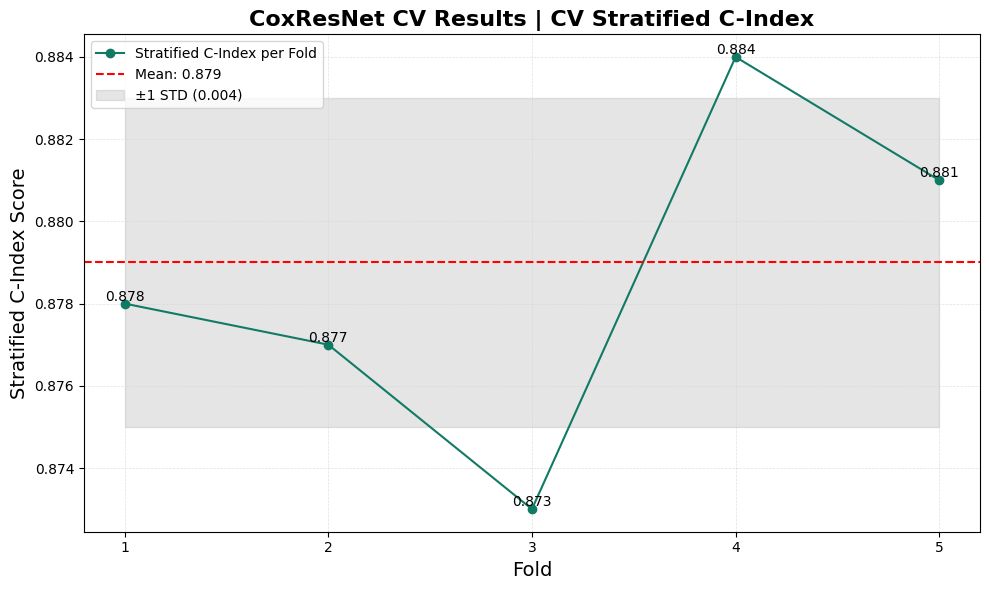


Final OOF Predictions: [-5.50958872  4.39623594 -5.94559479 ... -3.81305218 -3.17276049
 -6.14368439]
converting race_group to int before inference
extra features in test data (will be dropped): ['ID', 'race_group', 'log_efs_time', 'ranked_efs_time', 'km_survival_prob', 'na_cum_hazard', 'neg_exp_na_cum_hazard', 'target_norm']

Final Test Predictions: [5.62280816 5.11456293 5.18294466]
[array([-5.50958872,  4.39623594, -5.94559479, ..., -3.81305218,
       -3.17276049, -6.14368439])]
[array([5.62280816, 5.11456293, 5.18294466])]


In [14]:
# model configs
model_configs_cox = [{"model_type": "CoxResNet", "target": "log_efs_time", "is_classifier": False,   "title": "CoxResNet Regression | Log EFS Time"}]

# train and predict 
models_cox, oof_preds_cox, test_preds_cox = train_and_predict(md_cox, model_configs_cox, test_cox['X'])
print(oof_preds_cox)
print(test_preds_cox)

### Checking Correlations (efs_time vs. Model Outputs)

Here, I calculate how strongly each model’s OOF predictions correlate with `efs_time` (restricted to rows where `efs=1`). A positive correlation typically means “bigger predictions = longer survival,” while negative correlation is the reverse. This step helps me decide whether I need sign flipping for certain regressors, to make sure that the final aggregator treats predictions in the correct orientation.

Why “bigger = longer survival” vs. “bigger = earlier event” Matters:

The official c-index code does concordance_index(XYZ, -prediction, XYZ)  That means if your model’s “bigger” means “longer survival,” then -prediction is “lower hazard.” All is good. However, if your model’s “bigger” means “earlier event,” then the sign is reversed from the official code’s assumption. You might want to multiply by -1 somewhere (in ensemble.py for the corresponding regessor) so that “bigger = longer survival” at submission time.

In [15]:
def calculate_correlation(oof_preds, train_df, target_name):
    """ Calculates and prints the correlation between predicted values and efs_time for efs=1 """
    mask = (train_df['efs'] == 1)
    efs_time_events = train_df.loc[mask, 'efs_time']
    oof_events = oof_preds[mask]
    corr = np.corrcoef(oof_events, efs_time_events)[0, 1]
    print(f"Correlation with efs_time among efs=1 for {target_name}: {corr:.4f}")


# indices for each target using catboost regression 
target_indices = {"Log EFS Time Target": 4,  "KM OOF preds": 7, "NA OOF preds": 10, "Ranked EFS Time OOF preds": 13}

for target_name, index in target_indices.items():
    oof_preds = oof_preds_tree[index]
    calculate_correlation(oof_preds, train_tree_df, target_name)

Correlation with efs_time among efs=1 for Log EFS Time Target: 0.4745
Correlation with efs_time among efs=1 for KM OOF preds: -0.4675
Correlation with efs_time among efs=1 for NA OOF preds: 0.4726
Correlation with efs_time among efs=1 for Ranked EFS Time OOF preds: 0.4730


In [16]:
# indices for each target
target_indices = {"Log EFS Time Target": 0}

for target_name, index in target_indices.items():
    oof_preds = oof_preds_cox[index]
    calculate_correlation(oof_preds, train_cox_df, target_name)

Correlation with efs_time among efs=1 for Log EFS Time Target: -0.3844


In [17]:
best_merge_params = optimize_merge_params(oof_preds_tree, oof_preds_cox, test_preds_tree, test_preds_cox, train_tree, subm_path=CFG.subm_path, output_name="submission.csv", n_trials=4000)

[I 2025-03-25 02:03:45,496] A new study created in memory with name: no-name-b9d20d23-b3b0-4fad-bab7-90cbd0aeb6ef


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:45,638] Trial 0 finished with value: -0.5617465681501295 and parameters: {'a1': 0.9288315044401775, 'a2': 0.9551309567003559, 'a3': 0.8895608025454074, 'a4': 0.9051864412625928, 'b1': 0.6230481244439026, 'b2': 0.39434859662003213, 'b3': 0.4980204259518487, 'k1': 0.18379435419996104, 'k2': 0.2025605016031996, 'k3': 0.8782091957358737, 'n1': 0.9248306013007663, 'n2': 0.30352638957074496, 'n3': 0.7033408484606181, 'r1': 0.4764055374875298, 'r2': 0.8703633397669828, 'r3': 0.4476691566920149, 'c': 0.451622268502083, 'd': 0.04656408837127413}. Best is trial 0 with value: -0.5617465681501295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:45,776] Trial 1 finished with value: -0.5604121104511586 and parameters: {'a1': 0.9165461456871887, 'a2': 0.9572666875274088, 'a3': 0.9072661211303428, 'a4': 0.9413532642592599, 'b1': 0.4736066111854158, 'b2': 0.6240956213490402, 'b3': 0.4459957181015267, 'k1': 0.4064095127529397, 'k2': 0.8820789537414244, 'k3': 0.19421391996629903, 'n1': 0.6531344019684966, 'n2': 0.7478808603275551, 'n3': 0.5238668983566579, 'r1': 0.21125566743912833, 'r2': 0.47266154335942123, 'r3': 0.1029796619155566, 'c': 0.34243259583117147, 'd': 0.06561846408858889}. Best is trial 0 with value: -0.5617465681501295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:45,913] Trial 2 finished with value: -0.5561714205159458 and parameters: {'a1': 0.9423567294790461, 'a2': 0.9382406449866257, 'a3': 0.8538678966720971, 'a4': 0.8762689569171096, 'b1': 0.42192520437393005, 'b2': 0.5280451067973129, 'b3': 0.6669785101765053, 'k1': 0.7596227509075981, 'k2': 0.9012531797001666, 'k3': 0.3452901025541129, 'n1': 0.3250952943215195, 'n2': 0.6301200607299282, 'n3': 0.9190594508998369, 'r1': 0.7912957939538849, 'r2': 0.7008192230932673, 'r3': 0.9105220600590129, 'c': 0.4049310947523523, 'd': 0.05391932274835853}. Best is trial 0 with value: -0.5617465681501295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,053] Trial 3 finished with value: -0.7190329242796739 and parameters: {'a1': 0.952975130700701, 'a2': 0.9504487679094882, 'a3': 0.8819767445461398, 'a4': 0.9674366468563504, 'b1': 0.4687140800421889, 'b2': 0.13325647090740225, 'b3': 0.2500694461365335, 'k1': 0.12717255023610155, 'k2': 0.2807869963293964, 'k3': 0.6334720303519873, 'n1': 0.38641688460303447, 'n2': 0.28422349341730246, 'n3': 0.29191102948276815, 'r1': 0.8556135661335799, 'r2': 0.7432696978949876, 'r3': 0.8826285584123635, 'c': 0.33948040792604817, 'd': 0.019307025934114392}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,188] Trial 4 finished with value: -0.5666387177503985 and parameters: {'a1': 0.9322284807157196, 'a2': 0.9094452223751348, 'a3': 0.8937767360244245, 'a4': 0.8620841442354934, 'b1': 0.23818897164202618, 'b2': 0.5224776745807677, 'b3': 0.6937511384828717, 'k1': 0.7300295741872619, 'k2': 0.6007802426299732, 'k3': 0.9882796911457813, 'n1': 0.4463860961513188, 'n2': 0.5603466542783206, 'n3': 0.8333452593997561, 'r1': 0.18359144658464605, 'r2': 0.15337522498883283, 'r3': 0.9765827273134234, 'c': 0.49764231727516406, 'd': 0.028345750132878714}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,324] Trial 5 finished with value: -0.5237615956743238 and parameters: {'a1': 0.8771004577415608, 'a2': 0.9965824151050107, 'a3': 0.9011568644010631, 'a4': 0.8911812516454283, 'b1': 0.5878197852408873, 'b2': 0.5716742636512869, 'b3': 0.2595784447341549, 'k1': 0.7969412245561045, 'k2': 0.4979381323940095, 'k3': 0.7588378096825066, 'n1': 0.4530462977956403, 'n2': 0.47846693378403915, 'n3': 0.9352256935616781, 'r1': 0.6973087304671288, 'r2': 0.19636572578457734, 'r3': 0.1667892143204187, 'c': 0.48344888746420167, 'd': 0.09074373040023694}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,461] Trial 6 finished with value: -0.620408722102601 and parameters: {'a1': 0.9506492004286535, 'a2': 0.8864987380512505, 'a3': 0.8733536598953865, 'a4': 0.8742688614677196, 'b1': 0.15080945100731669, 'b2': 0.3974820463865527, 'b3': 0.15981820258261129, 'k1': 0.861508525404179, 'k2': 0.2866636480220708, 'k3': 0.866917255136558, 'n1': 0.21573855078967324, 'n2': 0.5971307237008646, 'n3': 0.5856955857798816, 'r1': 0.8484559939974416, 'r2': 0.4278800293565519, 'r3': 0.6053925443415966, 'c': 0.3781194839477886, 'd': 0.06772053295896094}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,599] Trial 7 finished with value: -0.5855146742716784 and parameters: {'a1': 0.8873981874787503, 'a2': 0.8661195303847813, 'a3': 0.8772299006259965, 'a4': 0.9801302480676966, 'b1': 0.129561340468247, 'b2': 0.38631938485514605, 'b3': 0.3964237897724663, 'k1': 0.19052372522079963, 'k2': 0.3791676656775842, 'k3': 0.7954581736485022, 'n1': 0.6217768252790515, 'n2': 0.2603142891796817, 'n3': 0.8212364599961219, 'r1': 0.9637085509120998, 'r2': 0.2724686357364273, 'r3': 0.5676132740244669, 'c': 0.37750713466726155, 'd': 0.06961716672728303}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,737] Trial 8 finished with value: -0.668083858139047 and parameters: {'a1': 0.8750226892654324, 'a2': 0.9338120132702349, 'a3': 0.9714319071218408, 'a4': 0.9919218174031895, 'b1': 0.3659816270859483, 'b2': 0.18155685141626027, 'b3': 0.16210907245555364, 'k1': 0.5296909327527776, 'k2': 0.8305454763330834, 'k3': 0.09674864136536403, 'n1': 0.21749736834958738, 'n2': 0.8280802336985389, 'n3': 0.6468103453403571, 'r1': 0.5711464088834833, 'r2': 0.6379860724202027, 'r3': 0.627844690947238, 'c': 0.4193189450029775, 'd': 0.03180195302480167}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:46,873] Trial 9 finished with value: -0.5397064995899341 and parameters: {'a1': 0.9321589282838428, 'a2': 0.9876617734830302, 'a3': 0.965851645835718, 'a4': 0.9623625861504731, 'b1': 0.423338763511335, 'b2': 0.4507053796843158, 'b3': 0.3154264288708933, 'k1': 0.13408992514632867, 'k2': 0.2603394268802053, 'k3': 0.26840990357657746, 'n1': 0.6810951506847702, 'n2': 0.3253123782341228, 'n3': 0.8589930367847192, 'r1': 0.8664464558879258, 'r2': 0.5095458885721005, 'r3': 0.30158146335537406, 'c': 0.3597689999056324, 'd': 0.09720910315451188}. Best is trial 3 with value: -0.7190329242796739.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,043] Trial 10 finished with value: -0.8143940218955456 and parameters: {'a1': 0.9967933488368445, 'a2': 0.9106240904360476, 'a3': 0.9361530217930728, 'a4': 0.9354129841428883, 'b1': 0.27120775898551974, 'b2': 0.025576392788469293, 'b3': 0.5400867488421381, 'k1': 0.3699322197226964, 'k2': 0.6050278187966975, 'k3': 0.552317130649128, 'n1': 0.8353660518102033, 'n2': 0.4245895185672961, 'n3': 0.21681231952870517, 'r1': 0.4136994748633336, 'r2': 0.9691216517594016, 'r3': 0.7856639629020863, 'c': 0.27039606937661864, 'd': 0.0012423428761653213}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,212] Trial 11 finished with value: -0.8107074210551873 and parameters: {'a1': 0.9994370956122229, 'a2': 0.905215780176297, 'a3': 0.9373261679173273, 'a4': 0.9328839387238713, 'b1': 0.28014933986476126, 'b2': 0.02935874221368695, 'b3': 0.5582159904781739, 'k1': 0.3844626768483428, 'k2': 0.6617318390791902, 'k3': 0.5445769478534845, 'n1': 0.9035487331188226, 'n2': 0.4267936536130438, 'n3': 0.22510737865075037, 'r1': 0.386458384611807, 'r2': 0.9613955917409014, 'r3': 0.8028892068573042, 'c': 0.26523382928298006, 'd': 0.0016608156615891688}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,380] Trial 12 finished with value: -0.8143574996623517 and parameters: {'a1': 0.9957776541018596, 'a2': 0.9019602993708233, 'a3': 0.9373227020717422, 'a4': 0.9279192406634625, 'b1': 0.2884588360718839, 'b2': 0.03299997875571591, 'b3': 0.5647184218888716, 'k1': 0.37183477508267254, 'k2': 0.7052721516990672, 'k3': 0.5176427823564372, 'n1': 0.9540307420412186, 'n2': 0.4368467786814648, 'n3': 0.22731727127779122, 'r1': 0.369694069108436, 'r2': 0.9758937123495155, 'r3': 0.7662522503628425, 'c': 0.2541425376543833, 'd': 0.005963343294885007}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,547] Trial 13 finished with value: -0.7708620194674606 and parameters: {'a1': 0.9952602653418411, 'a2': 0.8626034367886527, 'a3': 0.9370399002224359, 'a4': 0.9131196044317342, 'b1': 0.2911957597165051, 'b2': 0.24116170366108713, 'b3': 0.576214394249612, 'k1': 0.36108297376745746, 'k2': 0.7486158263203726, 'k3': 0.44388759039518855, 'n1': 0.8024811218708883, 'n2': 0.43762201098301845, 'n3': 0.3880673784241516, 'r1': 0.34506277793891044, 'r2': 0.9818633594640338, 'r3': 0.7490016082834212, 'c': 0.25050350072814587, 'd': 0.003403681001958593}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,717] Trial 14 finished with value: -0.768195739494309 and parameters: {'a1': 0.9763429897866142, 'a2': 0.8911475985601666, 'a3': 0.9917939075365025, 'a4': 0.9426293095363558, 'b1': 0.07619621317012168, 'b2': 0.04569535716137543, 'b3': 0.5974424352728057, 'k1': 0.6057021681795258, 'k2': 0.4891074966107817, 'k3': 0.6275540306466015, 'n1': 0.9912900833932422, 'n2': 0.944795033031606, 'n3': 0.4024890206601057, 'r1': 0.30959559832817507, 'r2': 0.8165602803700565, 'r3': 0.7091727941327155, 'c': 0.29313022757826357, 'd': 0.016472838829037564}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:47,885] Trial 15 finished with value: -0.7351150535509505 and parameters: {'a1': 0.9711579673564563, 'a2': 0.914573346316131, 'a3': 0.9286476681455773, 'a4': 0.9201535244041781, 'b1': 0.19637905276692655, 'b2': 0.2612423663563722, 'b3': 0.4923758255063995, 'k1': 0.29306295146166966, 'k2': 0.6992411437513375, 'k3': 0.40091954559228604, 'n1': 0.7846690317998035, 'n2': 0.3941695236675087, 'n3': 0.350812642698222, 'r1': 0.5111037774547174, 'r2': 0.8783626415639632, 'r3': 0.4444748979340629, 'c': 0.3035850361167336, 'd': 0.01537200989022028}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,051] Trial 16 finished with value: -0.7094376594055173 and parameters: {'a1': 0.9790840259155582, 'a2': 0.8827168788848334, 'a3': 0.9557033474898843, 'a4': 0.9536737675610129, 'b1': 0.3379136999254079, 'b2': 0.1146093537955448, 'b3': 0.37825076424984416, 'k1': 0.5224848448609938, 'k2': 0.9664998807821308, 'k3': 0.5389690845135515, 'n1': 0.7929771634730756, 'n2': 0.5325226961223873, 'n3': 0.21003589749228516, 'r1': 0.6297081987391714, 'r2': 0.9969990972966998, 'r3': 0.8081167806005258, 'c': 0.29897191923370453, 'd': 0.038602783088762346}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,221] Trial 17 finished with value: -0.6855539477391133 and parameters: {'a1': 0.9631824855729663, 'a2': 0.9200245829584351, 'a3': 0.9164921761270158, 'a4': 0.9047980175265099, 'b1': 0.5349468970855255, 'b2': 0.29429395136241704, 'b3': 0.6295939021130503, 'k1': 0.2893457193570363, 'k2': 0.5843509352353968, 'k3': 0.6523147029549052, 'n1': 0.8884640561573116, 'n2': 0.6842518873219559, 'n3': 0.4394119110276129, 'r1': 0.4242759466024749, 'r2': 0.5889517407851799, 'r3': 0.6909350078903294, 'c': 0.26756006792264597, 'd': 0.008033663110783951}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,386] Trial 18 finished with value: -0.7559600848508448 and parameters: {'a1': 0.8553246533412955, 'a2': 0.8515263515585857, 'a3': 0.9537541891380487, 'a4': 0.9254910860325144, 'b1': 0.2299569134732494, 'b2': 0.016509236621689478, 'b3': 0.5165314558974948, 'k1': 0.6239619348258669, 'k2': 0.7914169790904445, 'k3': 0.4481857481110881, 'n1': 0.99223903336579, 'n2': 0.36197359597418954, 'n3': 0.30354989150680234, 'r1': 0.10563716622448499, 'r2': 0.7775174305174225, 'r3': 0.4387900282639238, 'c': 0.3105078501463766, 'd': 0.029150375576254963}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,554] Trial 19 finished with value: -0.8111213523988974 and parameters: {'a1': 0.9082826609907803, 'a2': 0.8957602047065056, 'a3': 0.9889098383535867, 'a4': 0.8927832691953052, 'b1': 0.30249011152565675, 'b2': 0.09726924746020603, 'b3': 0.45218277547440683, 'k1': 0.9889818943102406, 'k2': 0.41371925985175767, 'k3': 0.5474784131577559, 'n1': 0.745105655426064, 'n2': 0.20903444336795557, 'n3': 0.5288397932679029, 'r1': 0.28659343855285707, 'r2': 0.38233153509924245, 'r3': 0.8792885064549691, 'c': 0.27522506264097346, 'd': 0.013010452299270794}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,721] Trial 20 finished with value: -0.6954653425361655 and parameters: {'a1': 0.9891137983615886, 'a2': 0.9747173684166762, 'a3': 0.9429970949149302, 'a4': 0.9495914604741253, 'b1': 0.078679014091693, 'b2': 0.19904101716681552, 'b3': 0.6297645185513571, 'k1': 0.4301668840837917, 'k2': 0.6513341060219355, 'k3': 0.6984806605633298, 'n1': 0.5676980004823521, 'n2': 0.4760454702515783, 'n3': 0.47168492685219343, 'r1': 0.6023770519141943, 'r2': 0.8760167837731105, 'r3': 0.969120516419608, 'c': 0.3361601695061641, 'd': 0.022764019828664078}. Best is trial 10 with value: -0.8143940218955456.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:48,892] Trial 21 finished with value: -0.8291516921558044 and parameters: {'a1': 0.9012294599781215, 'a2': 0.900441658214097, 'a3': 0.9774918848204736, 'a4': 0.8969622895662943, 'b1': 0.2931208843473017, 'b2': 0.10172013516663445, 'b3': 0.46295149832165117, 'k1': 0.933629027968339, 'k2': 0.4283621907326738, 'k3': 0.5603276809535555, 'n1': 0.724002324534484, 'n2': 0.20535727929862335, 'n3': 0.2787548527495515, 'r1': 0.28153783427420875, 'r2': 0.26708848795702184, 'r3': 0.8725321424962056, 'c': 0.2733648692713136, 'd': 0.010128299247167998}. Best is trial 21 with value: -0.8291516921558044.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,060] Trial 22 finished with value: -0.8381606309808238 and parameters: {'a1': 0.9102316470229815, 'a2': 0.92628205625984, 'a3': 0.9800912451862621, 'a4': 0.8930353937997251, 'b1': 0.22358834902913424, 'b2': 0.08840192399581143, 'b3': 0.5430197664002475, 'k1': 0.47615846224728, 'k2': 0.1202026164832225, 'k3': 0.5130047930640681, 'n1': 0.8469612281186495, 'n2': 0.21283911211671225, 'n3': 0.27294519961633035, 'r1': 0.24655783068167658, 'r2': 0.3326761597511504, 'r3': 0.8012895987522696, 'c': 0.25094444375512104, 'd': 0.0013708344661761043}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,230] Trial 23 finished with value: -0.833120401323825 and parameters: {'a1': 0.9062884838945365, 'a2': 0.9298448347869182, 'a3': 0.9761185855590726, 'a4': 0.8866054580686916, 'b1': 0.17748260765879284, 'b2': 0.15766903092349552, 'b3': 0.44844401882614326, 'k1': 0.9866899442828385, 'k2': 0.39244852583695844, 'k3': 0.3536623192975069, 'n1': 0.7278003102805751, 'n2': 0.20752526287470363, 'n3': 0.29384108784545165, 'r1': 0.23476029501697318, 'r2': 0.3089897917418901, 'r3': 0.8757735594380099, 'c': 0.2831079389066863, 'd': 0.011702337465900353}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,401] Trial 24 finished with value: -0.818434766869303 and parameters: {'a1': 0.9032327582890428, 'a2': 0.9293714299038057, 'a3': 0.9791853851125047, 'a4': 0.8523444404404048, 'b1': 0.18151692476009376, 'b2': 0.17306446392764246, 'b3': 0.35511156536944355, 'k1': 0.9413097964155065, 'k2': 0.1774637943537027, 'k3': 0.334166467108854, 'n1': 0.7166162487272175, 'n2': 0.20523193901881873, 'n3': 0.28659383421814494, 'r1': 0.23400698247890123, 'r2': 0.33015567991667977, 'r3': 0.8676771436570594, 'c': 0.3179417434197173, 'd': 0.011912443754162448}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,571] Trial 25 finished with value: -0.7476150768138204 and parameters: {'a1': 0.9013217064504456, 'a2': 0.9438821268885853, 'a3': 0.9986428704708064, 'a4': 0.8888348836582658, 'b1': 0.2056597007779531, 'b2': 0.30700660531783397, 'b3': 0.44341194087465907, 'k1': 0.8870426204298048, 'k2': 0.37753258884837215, 'k3': 0.24886700916831095, 'n1': 0.5311863470995375, 'n2': 0.2377362008404035, 'n3': 0.32275148717993574, 'r1': 0.11508736349789259, 'r2': 0.2665096735258904, 'r3': 0.9992666254948968, 'c': 0.2884319431832655, 'd': 0.04002573614485598}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,738] Trial 26 finished with value: -0.8287267411891325 and parameters: {'a1': 0.8930776381869246, 'a2': 0.9249196383425484, 'a3': 0.9810029045884748, 'a4': 0.8753205454947685, 'b1': 0.1244470339656404, 'b2': 0.09089865288121526, 'b3': 0.32579176739670135, 'k1': 0.6908229857009661, 'k2': 0.11156918562041496, 'k3': 0.3929747605621397, 'n1': 0.8436781540799448, 'n2': 0.35433644792693486, 'n3': 0.39916907236700794, 'r1': 0.2612678589170395, 'r2': 0.10020386580464796, 'r3': 0.6564805290701728, 'c': 0.2790542774687143, 'd': 0.023372925954899676}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:49,906] Trial 27 finished with value: -0.7403819022760071 and parameters: {'a1': 0.9186770487674076, 'a2': 0.8806115256042182, 'a3': 0.9612493265983182, 'a4': 0.9013272006810993, 'b1': 0.34695610551962214, 'b2': 0.14407039409705644, 'b3': 0.47403694494065307, 'k1': 0.9895532118762267, 'k2': 0.4538937541125986, 'k3': 0.4664532235780966, 'n1': 0.7187658081630275, 'n2': 0.2747541626198666, 'n3': 0.27229514285211803, 'r1': 0.18366031235794966, 'r2': 0.32598694175399323, 'r3': 0.8466004109435215, 'c': 0.322878653902195, 'd': 0.010402251643870517}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,075] Trial 28 finished with value: -0.8347257050347625 and parameters: {'a1': 0.8640337569160893, 'a2': 0.9742022022916855, 'a3': 0.9751024835846972, 'a4': 0.8649144287001271, 'b1': 0.1572485580291595, 'b2': 0.24493255462291225, 'b3': 0.4010458053579564, 'k1': 0.8440610654428343, 'k2': 0.33176004206234266, 'k3': 0.3034486790785884, 'n1': 0.5844808256667846, 'n2': 0.20837779144707672, 'n3': 0.35323795250321927, 'r1': 0.15750835975796443, 'r2': 0.21661958631687805, 'r3': 0.9292258918585452, 'c': 0.25244974880388543, 'd': 0.03509286007868099}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,250] Trial 29 finished with value: -0.8278448945688378 and parameters: {'a1': 0.8547737946764593, 'a2': 0.9647374970157583, 'a3': 0.9986349570389176, 'a4': 0.8508053809029815, 'b1': 0.06270747647119057, 'b2': 0.22359438749585206, 'b3': 0.41173175526713585, 'k1': 0.8325826280939093, 'k2': 0.10640555710431615, 'k3': 0.147286949903411, 'n1': 0.5372512801423329, 'n2': 0.31629581686731745, 'n3': 0.4991535615234046, 'r1': 0.46211470580699865, 'r2': 0.19796360545494746, 'r3': 0.9411920683465808, 'c': 0.256408577125971, 'd': 0.05122886929750384}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,416] Trial 30 finished with value: -0.6061953111817039 and parameters: {'a1': 0.8710623430194004, 'a2': 0.9772057441214809, 'a3': 0.9510505178367166, 'a4': 0.864827456852744, 'b1': 0.1604397758449683, 'b2': 0.3234913176611069, 'b3': 0.5161947382387463, 'k1': 0.6501031052067756, 'k2': 0.2013262806800267, 'k3': 0.2822981046970768, 'n1': 0.5897685534629689, 'n2': 0.2961772345286713, 'n3': 0.7202529345177675, 'r1': 0.1625809525290051, 'r2': 0.40576042465022427, 'r3': 0.4999467729299922, 'c': 0.4482522160591976, 'd': 0.04165865377255647}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,588] Trial 31 finished with value: -0.829699690249141 and parameters: {'a1': 0.8888326894389936, 'a2': 0.9457363130351754, 'a3': 0.9753668612510729, 'a4': 0.8862800310502157, 'b1': 0.23254538034713504, 'b2': 0.07411335238241709, 'b3': 0.4194987793214104, 'k1': 0.9052509337107163, 'k2': 0.35262618115976124, 'k3': 0.3707920735328754, 'n1': 0.6426324925018544, 'n2': 0.21700581047177953, 'n3': 0.3417973349585781, 'r1': 0.30995314251573786, 'r2': 0.25757770750702635, 'r3': 0.9308289611467218, 'c': 0.2805873074862302, 'd': 0.032770111500381595}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,756] Trial 32 finished with value: -0.6330881116905582 and parameters: {'a1': 0.8873391808285257, 'a2': 0.961850617326298, 'a3': 0.9689415870547909, 'a4': 0.8813875884375927, 'b1': 0.12016813673791284, 'b2': 0.6950979668761691, 'b3': 0.4227688561191299, 'k1': 0.47625848958958855, 'k2': 0.34789263390074876, 'k3': 0.21184156294932, 'n1': 0.6490262018946336, 'n2': 0.2531712599525904, 'n3': 0.35301528791506764, 'r1': 0.2308213917635575, 'r2': 0.3349925230051167, 'r3': 0.9292643734642806, 'c': 0.28274552040539835, 'd': 0.05710978135584663}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:50,925] Trial 33 finished with value: -0.7366561068513355 and parameters: {'a1': 0.8625343657529168, 'a2': 0.94744031181067, 'a3': 0.9872124520188515, 'a4': 0.861974311340146, 'b1': 0.6957908560957973, 'b2': 0.16134214436770533, 'b3': 0.3597587800871321, 'k1': 0.91191442074107, 'k2': 0.33090330446794214, 'k3': 0.3478316383083669, 'n1': 0.4843229271216598, 'n2': 0.3359919830900604, 'n3': 0.42474186297802563, 'r1': 0.14304827095732872, 'r2': 0.21662305876008292, 'r3': 0.8230196457333532, 'c': 0.25062603469362627, 'd': 0.03594603620042955}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,095] Trial 34 finished with value: -0.8355851062599842 and parameters: {'a1': 0.9171550758737691, 'a2': 0.9372322272056107, 'a3': 0.9751859298347425, 'a4': 0.9121465106963732, 'b1': 0.23167998739295484, 'b2': 0.08116765535213248, 'b3': 0.26122244564800684, 'k1': 0.8019935681390247, 'k2': 0.23856747888398086, 'k3': 0.33192610336875317, 'n1': 0.66594657726657, 'n2': 0.2488838616071725, 'n3': 0.3526508209324188, 'r1': 0.31818172945943934, 'r2': 0.10385365280144937, 'r3': 0.906808815397712, 'c': 0.29315558657286933, 'd': 0.04572573920541363}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,267] Trial 35 finished with value: -0.8296517679449793 and parameters: {'a1': 0.9177981878090834, 'a2': 0.9366912285303466, 'a3': 0.9622746303472968, 'a4': 0.9131320800829906, 'b1': 0.10200453582400515, 'b2': 0.26410007022757986, 'b3': 0.1178823028284346, 'k1': 0.7932868673027824, 'k2': 0.1599008000259495, 'k3': 0.30415173814240837, 'n1': 0.6838995865203314, 'n2': 0.28413624069342314, 'n3': 0.5624456266616417, 'r1': 0.21589706350725624, 'r2': 0.10019851112442497, 'r3': 0.7224894336737202, 'c': 0.29600899798195485, 'd': 0.0588002698262792}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,438] Trial 36 finished with value: -0.7708241113538966 and parameters: {'a1': 0.9406754501455001, 'a2': 0.9552654936756851, 'a3': 0.986115748018142, 'a4': 0.9137019817359049, 'b1': 0.17309825864925932, 'b2': 0.20811682107472135, 'b3': 0.2526318357795958, 'k1': 0.7490829078956047, 'k2': 0.2505294053141541, 'k3': 0.16787377030863104, 'n1': 0.8724232033190029, 'n2': 0.37616035726567487, 'n3': 0.2558662445801796, 'r1': 0.3401888713849462, 'r2': 0.16109713607483556, 'r3': 0.9053886508211223, 'c': 0.32638536613926755, 'd': 0.045815969380573036}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,607] Trial 37 finished with value: -0.6483844029728543 and parameters: {'a1': 0.9222724448593893, 'a2': 0.9260551135185477, 'a3': 0.8507622573426616, 'a4': 0.8660726691021952, 'b1': 0.23849358128926598, 'b2': 0.13255534032208843, 'b3': 0.2777522256760059, 'k1': 0.82904771697081, 'k2': 0.22842864794482048, 'k3': 0.23074715888567, 'n1': 0.3333926056675398, 'n2': 0.7890434961695069, 'n3': 0.46001993284985365, 'r1': 0.20004468775521145, 'r2': 0.511654790900712, 'r3': 0.9924827679881667, 'c': 0.30968705544006037, 'd': 0.07871003674550942}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,777] Trial 38 finished with value: -0.7498524293844855 and parameters: {'a1': 0.9287652821329307, 'a2': 0.9676279573342758, 'a3': 0.9464984696768569, 'a4': 0.8792201181004397, 'b1': 0.4039181292612719, 'b2': 0.06353573936318264, 'b3': 0.31018509069078026, 'k1': 0.7037767170882702, 'k2': 0.302398905995116, 'k3': 0.4916169461738735, 'n1': 0.7564045412503404, 'n2': 0.2553742072433197, 'n3': 0.35401103951277174, 'r1': 0.1363312165357363, 'r2': 0.15437240895367113, 'r3': 0.8409582313721728, 'c': 0.3561861876019118, 'd': 0.02162282221746973}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:51,946] Trial 39 finished with value: -0.6467492850875768 and parameters: {'a1': 0.9120639117785885, 'a2': 0.9952612683004953, 'a3': 0.8636984502344724, 'a4': 0.870178796694371, 'b1': 0.14322486240467844, 'b2': 0.3516093355992722, 'b3': 0.21417327533672756, 'k1': 0.5683759064698057, 'k2': 0.14941034531570932, 'k3': 0.41874136515478755, 'n1': 0.49305605599145585, 'n2': 0.3057345200642402, 'n3': 0.6473982296964308, 'r1': 0.4814110173959352, 'r2': 0.44331562394063295, 'r3': 0.9454096810069499, 'c': 0.4134974380463501, 'd': 0.04738406955936382}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:52,114] Trial 40 finished with value: -0.64495105122186 and parameters: {'a1': 0.9373651557007225, 'a2': 0.9172363377289224, 'a3': 0.9712071303535946, 'a4': 0.8986585929070687, 'b1': 0.1995282904953114, 'b2': 0.13251339728954076, 'b3': 0.20968487464679056, 'k1': 0.7709025062291437, 'k2': 0.53012594226746, 'k3': 0.31331982373885414, 'n1': 0.605756557803175, 'n2': 0.6597666671541768, 'n3': 0.3713790686929267, 'r1': 0.7017812243842079, 'r2': 0.23084197797251033, 'r3': 0.3587233449100028, 'c': 0.3932723275437224, 'd': 0.07474841690310076}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:52,285] Trial 41 finished with value: -0.83616385028409 and parameters: {'a1': 0.8928374123177691, 'a2': 0.9416493655498528, 'a3': 0.9743834957594592, 'a4': 0.8892410492958288, 'b1': 0.242972545592962, 'b2': 0.07466432217519856, 'b3': 0.39084383651075566, 'k1': 0.8570102485297776, 'k2': 0.3190513708465345, 'k3': 0.36398150264752105, 'n1': 0.6602081903667912, 'n2': 0.22949944333001082, 'n3': 0.33087495617548773, 'r1': 0.31343593103018286, 'r2': 0.30014282319234387, 'r3': 0.9119082784208135, 'c': 0.2629787982168385, 'd': 0.033912486970691096}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:52,454] Trial 42 finished with value: -0.8342486788085272 and parameters: {'a1': 0.8822186595920679, 'a2': 0.935820750038128, 'a3': 0.9585215514275359, 'a4': 0.8840077451392024, 'b1': 0.24957832939514177, 'b2': 0.073741840439455, 'b3': 0.35618432007488016, 'k1': 0.8506621799194144, 'k2': 0.3060450763025444, 'k3': 0.35988891696739217, 'n1': 0.6820939458738022, 'n2': 0.24136854837008775, 'n3': 0.29951201895666374, 'r1': 0.2448976933248963, 'r2': 0.36778189046384263, 'r3': 0.8875068108539249, 'c': 0.26327953982571456, 'd': 0.026373340907621376}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:52,630] Trial 43 finished with value: -0.8373797558066142 and parameters: {'a1': 0.8800241263372267, 'a2': 0.9376733616815099, 'a3': 0.9576626099765377, 'a4': 0.9068116903177695, 'b1': 0.25242214684712777, 'b2': 0.05510639320110361, 'b3': 0.2759036538158135, 'k1': 0.8360503008627544, 'k2': 0.2956506246974594, 'k3': 0.11170736846953239, 'n1': 0.682482840208874, 'n2': 0.24950209116266775, 'n3': 0.9951948154048746, 'r1': 0.3296388991847176, 'r2': 0.3763126071823615, 'r3': 0.9161601015740264, 'c': 0.26271848412674487, 'd': 0.028931037189836563}. Best is trial 22 with value: -0.8381606309808238.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:52,832] Trial 44 finished with value: -0.6917895309144438 and parameters: {'a1': 0.8671061649085031, 'a2': 0.940635209686761, 'a3': 0.9664129692483748, 'a4': 0.9088197958065569, 'b1': 0.34472478003289425, 'b2': 0.4260600264238179, 'b3': 0.2920177888237063, 'k1': 0.8050778052795744, 'k2': 0.21923117984587753, 'k3': 0.1145811659907881, 'n1': 0.5873932263517162, 'n2': 0.27371940292189423, 'n3': 0.982726093379386, 'r1': 0.4129137772847058, 'r2': 0.47555705167433826, 'r3': 0.96198497627993, 'c': 0.2612288802292991, 'd': 0.04506056503789389}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:53,022] Trial 45 finished with value: -0.8276285816059524 and parameters: {'a1': 0.8947967489243487, 'a2': 0.9541111194459962, 'a3': 0.9840317659711292, 'a4': 0.9206346921221202, 'b1': 0.32138789813946433, 'b2': 0.05671885272641504, 'b3': 0.1568095967030828, 'k1': 0.7220272787252293, 'k2': 0.27987394813407307, 'k3': 0.18489113110617095, 'n1': 0.3994256011589322, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:53,190] Trial 46 finished with value: -0.796667711360369 and parameters: {'a1': 0.8784875066272053, 'a2': 0.9842333992436059, 'a3': 0.9952774158715034, 'a4': 0.8937161679279457, 'b1': 0.258775334026663, 'b2': 0.01517689158228877, 'b3': 0.2257649346859199, 'k1': 0.47806592327291625, 'k2': 0.2522590420362549, 'k3': 0.23530696269567938, 'n1': 0.5562463781003997, 'n2': 0.39668519250670453, 'n3': 0.7588206062234953, 'r1': 0.38020084787686637, 'r2': 0.29985931767886664, 'r3': 0.11619416845299768, 'c': 0.25231272604322497, 'd': 0.06160945321894445}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:53,358] Trial 47 finished with value: -0.6244596971688837 and parameters: {'a1': 0.8615932387457311, 'a2': 0.9514310836985332, 'a3': 0.970664029441393, 'a4': 0.9055209935921885, 'b1': 0.46986264984589904, 'b2': 0.5183050482927839, 'b3': 0.1907568508157994, 'k1': 0.8733366273110066, 'k2': 0.13709120255395474, 'k3': 0.28462524394448585, 'n1': 0.6738540562152274

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:53,530] Trial 48 finished with value: -0.8313002014017287 and parameters: {'a1': 0.8819461706779369, 'a2': 0.923187893490757, 'a3': 0.9249356477940343, 'a4': 0.8568201783763921, 'b1': 0.2141496168604502, 'b2': 0.11578758609653492, 'b3': 0.32926292765893206, 'k1': 0.6805072847856227, 'k2': 0.19627588069055912, 'k3': 0.0941437336586109, 'n1': 0.9359833086893964, 'n2': 0.24658003735944473, 'n3': 0.6212703520861433, 'r1': 0.4389033278309622, 'r2': 0.2290188210160556, 'r3': 0.8142545540422849, 'c': 0.2619106825203742, 'd': 0.028848879596138972}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:53,697] Trial 49 finished with value: -0.5946969208279348 and parameters: {'a1': 0.9480199431788895, 'a2': 0.9085827299239534, 'a3': 0.8919490883263832, 'a4': 0.8714095498032778, 'b1': 0.3853861445688406, 'b2': 0.04978290570912042, 'b3': 0.6834950943432476, 'k1': 0.7764354386395171, 'k2': 0.32634863242349466, 'k3': 0.9693681500349492, 'n1': 0.643104855156538, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:53,866] Trial 50 finished with value: -0.6454130034288966 and parameters: {'a1': 0.8952570229373289, 'a2': 0.9608799924010728, 'a3': 0.9012797995010882, 'a4': 0.9184088528693013, 'b1': 0.2661068927019168, 'b2': 0.1853409992360076, 'b3': 0.3807912924740748, 'k1': 0.5738587100997641, 'k2': 0.2647839184792582, 'k3': 0.48855786686796226, 'n1': 0.8433882195177316, 'n2': 0.28277123964897094, 'n3': 0.6790041568279733, 'r1': 0.2689113148455119, 'r2': 0.5684838205275797, 'r3': 0.6150945884833198, 'c': 0.46437585574973983, 'd': 0.017953537304782156}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:54,036] Trial 51 finished with value: -0.835780082143451 and parameters: {'a1': 0.8841756999368521, 'a2': 0.9359329510077066, 'a3': 0.9550278603199303, 'a4': 0.8818689275943481, 'b1': 0.24553432548878598, 'b2': 0.08289084530764047, 'b3': 0.3493515609485344, 'k1': 0.8328097007618608, 'k2': 0.3037787149321121, 'k3': 0.6078184660327626, 'n1': 0.6875565705896683, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:54,207] Trial 52 finished with value: -0.8335710042480826 and parameters: {'a1': 0.8735869653783954, 'a2': 0.9344613917292649, 'a3': 0.9504186465736025, 'a4': 0.9027053910152311, 'b1': 0.2213628468055241, 'b2': 0.09023916095290013, 'b3': 0.27875067024027483, 'k1': 0.8342924026299154, 'k2': 0.45881521300586714, 'k3': 0.6002021803530626, 'n1': 0.6204036439715569, 'n2': 0.2356087024719504, 'n3': 0.32245920148022933, 'r1': 0.34651997031525006, 'r2': 0.4445324734904974, 'r3': 0.9122324718473314, 'c': 0.27217043031425925, 'd': 0.04262675695166185}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:54,377] Trial 53 finished with value: -0.8295514672116714 and parameters: {'a1': 0.9103804909754523, 'a2': 0.939820096035988, 'a3': 0.9626415459732982, 'a4': 0.8775281372443722, 'b1': 0.2506720426924729, 'b2': 0.0395600577287841, 'b3': 0.33365755334448993, 'k1': 0.7539949991437181, 'k2': 0.21801758646912628, 'k3': 0.5823395914967106, 'n1': 0.7681503732835614,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:54,547] Trial 54 finished with value: -0.8287835368946352 and parameters: {'a1': 0.8690838885734353, 'a2': 0.9164298211435088, 'a3': 0.9925744682781987, 'a4': 0.8943369354774259, 'b1': 0.30663435860455585, 'b2': 0.010933461927959603, 'b3': 0.24223765305037287, 'k1': 0.9510008419693833, 'k2': 0.3703096117686989, 'k3': 0.6822043178938098, 'n1': 0.8078256070500532, 'n2': 0.23928375405817798, 'n3': 0.24010407952773927, 'r1': 0.37658019543151555, 'r2': 0.40199311425365863, 'r3': 0.9636992059379202, 'c': 0.2586347083572643, 'd': 0.03133056942523605}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:54,719] Trial 55 finished with value: -0.7933443057947583 and parameters: {'a1': 0.8849733827498543, 'a2': 0.9711060857173016, 'a3': 0.945140467872313, 'a4': 0.9323775365499682, 'b1': 0.15069420067636052, 'b2': 0.1231305794376849, 'b3': 0.3824711750955093, 'k1': 0.8755464531570655, 'k2': 0.30106840964290493, 'k3': 0.6986991448845299, 'n1': 0.695292391508309

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:54,889] Trial 56 finished with value: -0.8265718179961549 and parameters: {'a1': 0.898339926703881, 'a2': 0.9297960170212087, 'a3': 0.9737532950606034, 'a4': 0.9096001370550115, 'b1': 0.18852876809810817, 'b2': 0.08073579259623727, 'b3': 0.30668182392568066, 'k1': 0.6491035520042129, 'k2': 0.17736570572642682, 'k3': 0.42969098444022596, 'n1': 0.6241484087169448, 'n2': 0.20011422075774007, 'n3': 0.20989080722705483, 'r1': 0.2812791216370402, 'r2': 0.4893806797424055, 'r3': 0.7824832567113412, 'c': 0.27185268241078175, 'd': 0.04945822001172148}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:55,061] Trial 57 finished with value: -0.8322340374625086 and parameters: {'a1': 0.8500805977889088, 'a2': 0.9492386684743007, 'a3': 0.9647715931249947, 'a4': 0.9985400435807468, 'b1': 0.3211655757152243, 'b2': 0.24191353441852503, 'b3': 0.2751249907131053, 'k1': 0.806340396183106, 'k2': 0.12980686051084017, 'k3': 0.5145790005616124, 'n1': 0.5181644626601756

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:55,231] Trial 58 finished with value: -0.7407350620889095 and parameters: {'a1': 0.8777101477342675, 'a2': 0.9430937969623228, 'a3': 0.9568820283502545, 'a4': 0.8912065878924001, 'b1': 0.5027245077576361, 'b2': 0.10828804273362144, 'b3': 0.48800652133863526, 'k1': 0.2756831215711277, 'k2': 0.42608618186530517, 'k3': 0.7849064205159323, 'n1': 0.6583735414451124, 'n2': 0.40474351564636574, 'n3': 0.9068886537167355, 'r1': 0.1008172690166638, 'r2': 0.2488997451067477, 'r3': 0.8553488840986645, 'c': 0.25097854058829266, 'd': 0.031838293357274935}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:55,401] Trial 59 finished with value: -0.6910678212462859 and parameters: {'a1': 0.8911884982784093, 'a2': 0.958255862846676, 'a3': 0.9823788796339606, 'a4': 0.8579582353909054, 'b1': 0.2665968544422722, 'b2': 0.1540387878865776, 'b3': 0.6010752119492078, 'k1': 0.9105544202089136, 'k2': 0.23840020441767168, 'k3': 0.7430400946366976, 'n1': 0.5678696778386605, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:55,575] Trial 60 finished with value: -0.7137809888428561 and parameters: {'a1': 0.8641608843081797, 'a2': 0.93067885932252, 'a3': 0.9328261163840245, 'a4': 0.8824498039665697, 'b1': 0.4334826220263049, 'b2': 0.4927441570422597, 'b3': 0.4029095833224556, 'k1': 0.42682553834389914, 'k2': 0.399680548905315, 'k3': 0.6355285749109026, 'n1': 0.7066326661292839, 'n2': 0.4679934257116397, 'n3': 0.4056246173206356, 'r1': 0.15995869417367597, 'r2': 0.1263197521207747, 'r3': 0.895992152143454, 'c': 0.27834176230617813, 'd': 0.004188067708490346}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:55,746] Trial 61 finished with value: -0.8341226765306651 and parameters: {'a1': 0.8812747708984576, 'a2': 0.9357977691379434, 'a3': 0.9556442545203069, 'a4': 0.8696857481941276, 'b1': 0.24499218420260072, 'b2': 0.07128533746369282, 'b3': 0.35006155323761023, 'k1': 0.847642248458824, 'k2': 0.30898115880694205, 'k3': 0.3913090854334573, 'n1': 0.7433363500044277, 'n2

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:55,916] Trial 62 finished with value: -0.8271637018323064 and parameters: {'a1': 0.8830925174608475, 'a2': 0.9214292917368359, 'a3': 0.9592041236141864, 'a4': 0.8833200362949563, 'b1': 0.276009030151451, 'b2': 0.04469677268212378, 'b3': 0.301330860318104, 'k1': 0.8513487784270543, 'k2': 0.27582973608480854, 'k3': 0.31457937518721973, 'n1': 0.6798700449522264, 'n2': 0.22890125056379684, 'n3': 0.2650456830424844, 'r1': 0.3147773764015189, 'r2': 0.3504008514768839, 'r3': 0.8242777647390914, 'c': 0.2615881904422549, 'd': 0.02866151555635025}. Best is trial 22 with value: -0.8381606309808238.
[I 2025-03-25 02:03:56,088] Trial 63 finished with value: -0.8389261232153356 and parameters: {'a1': 0.913325037131644, 'a2': 0.9388024260574125, 'a3': 0.9796079869456912, 'a4': 0.8986572350975831, 'b1': 0.21718550849955578, 'b2': 0.08472619087681856, 'b3': 0.34864382107010433, 'k1': 0.9478806507777834, 'k2': 0.33813569110755237, 'k3': 0.1382876298550698, 'n1': 0.8165611418698547, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:56,260] Trial 64 finished with value: -0.83625075875346 and parameters: {'a1': 0.9133791151006115, 'a2': 0.910289116935998, 'a3': 0.9779665368305628, 'a4': 0.8989880050111395, 'b1': 0.09714790148158026, 'b2': 0.1834173742352387, 'b3': 0.33816363836609054, 'k1': 0.9461616096012717, 'k2': 0.3530586955112449, 'k3': 0.1767613503204017, 'n1': 0.8730566695661777, 'n2': 0.2945526943351464, 'n3': 0.5075973967201304, 'r1': 0.3547493066044616, 'r2': 0.2978112834140002, 'r3': 0.9623646863163464, 'c': 0.2775140833596178, 'd': 0.021034388771623058}. Best is trial 63 with value: -0.8389261232153356.
[I 2025-03-25 02:03:56,433] Trial 65 finished with value: -0.837390435555804 and parameters: {'a1': 0.9272606415735187, 'a2': 0.9126861646645535, 'a3': 0.9786631319136636, 'a4': 0.8991656382747969, 'b1': 0.09684108607933653, 'b2': 0.10826532017440013, 'b3': 0.3421597843532005, 'k1': 0.956901273937852, 'k2': 0.4571289641792378, 'k3': 0.24860391407004595, 'n1': 0.9080154977262442, 'n2':

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:03:56,603] Trial 66 finished with value: -0.8405063222831518 and parameters: {'a1': 0.9255827613318234, 'a2': 0.9126297370288203, 'a3': 0.9904284042835698, 'a4': 0.898975866312407, 'b1': 0.09620909207996539, 'b2': 0.10429328097604845, 'b3': 0.3399827349597102, 'k1': 0.9509465281248913, 'k2': 0.507237496887782, 'k3': 0.2003688701174458, 'n1': 0.9099019420369797, 'n2': 0.29645222457753906, 'n3': 0.5513947294315068, 'r1': 0.40551765300405707, 'r2': 0.2864156704714182, 'r3': 0.9646262030702049, 'c': 0.27630009885674495, 'd': 0.016292790832369987}. Best is trial 66 with value: -0.8405063222831518.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:56,776] Trial 67 finished with value: -0.809895174349265 and parameters: {'a1': 0.9259009376718772, 'a2': 0.9114260017268553, 'a3': 0.989508724842598, 'a4': 0.8987697628637807, 'b1': 0.05652498418719916, 'b2': 0.17790207094351124, 'b3': 0.37645364343549736, 'k1': 0.9627681251067453, 'k2': 0.5079637830855028, 'k3': 0.15526644460126876, 'n1': 0.9634157831525009, 'n2': 0.37050997860911694, 'n3': 0.5183294413340185, 'r1': 0.41117942375804617, 'r2': 0.2882259999177428, 'r3': 0.9718679719494001, 'c': 0.30690432705409604, 'd': 0.015536012997082013}. Best is trial 66 with value: -0.8405063222831518.
[I 2025-03-25 02:03:56,948] Trial 68 finished with value: -0.8408462762332998 and parameters: {'a1': 0.9319925356268631, 'a2': 0.9028078049648947, 'a3': 0.9803155969651501, 'a4': 0.9065808082317126, 'b1': 0.09361486638616132, 'b2': 0.1374517999053085, 'b3': 0.33153332869845015, 'k1': 0.9628711626806478, 'k2': 0.5741569518218765, 'k3': 0.12702786965350432, 'n1': 0.903275683640944

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:57,120] Trial 69 finished with value: -0.8244915071863641 and parameters: {'a1': 0.9341633473501317, 'a2': 0.8977372843293082, 'a3': 0.980549875517664, 'a4': 0.9068370118548954, 'b1': 0.09256340919111469, 'b2': 0.15115162841123583, 'b3': 0.32532621309228654, 'k1': 0.9976459988923457, 'k2': 0.5732338591797905, 'k3': 0.14040974732807446, 'n1': 0.8679206162354879, 'n2': 0.3382722697444726, 'n3': 0.5788879258031299, 'r1': 0.6737286860650291, 'r2': 0.3257551404545647, 'r3': 0.5206949025963151, 'c': 0.3193165456402375, 'd': 0.007421535681197621}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:57,292] Trial 70 finished with value: -0.829999403150934 and parameters: {'a1': 0.9542484220831468, 'a2': 0.9060317354184684, 'a3': 0.9939016762154044, 'a4': 0.9169444193907736, 'b1': 0.10591579041780934, 'b2': 0.10597969967835753, 'b3': 0.3408216936597967, 'k1': 0.9682495976171115, 'k2': 0.47294854085044147, 'k3': 0.12098942324809898, 'n1': 0.9265737218833309,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:57,465] Trial 71 finished with value: -0.8256033105720549 and parameters: {'a1': 0.9130177075616168, 'a2': 0.8889406661210483, 'a3': 0.9834779855653247, 'a4': 0.9018452001395869, 'b1': 0.08126303225392571, 'b2': 0.1364709883704345, 'b3': 0.3694402835025567, 'k1': 0.9371090815216438, 'k2': 0.6278246361768395, 'k3': 0.1953893356990498, 'n1': 0.8925084501379088, 'n2': 0.7071598159474163, 'n3': 0.4958064153613342, 'r1': 0.4471199769863212, 'r2': 0.30970041513021446, 'r3': 0.951013991624122, 'c': 0.28213277493152755, 'd': 0.014149860269210196}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:57,638] Trial 72 finished with value: -0.8398773310707492 and parameters: {'a1': 0.9235568738769157, 'a2': 0.9127220126736227, 'a3': 0.9890330212826064, 'a4': 0.8899165737001349, 'b1': 0.12145624515326656, 'b2': 0.1044664661774552, 'b3': 0.42656891075566555, 'k1': 0.9224197297195122, 'k2': 0.5600880986419647, 'k3': 0.08566204665201889, 'n1': 0.9106655425610376, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:57,810] Trial 73 finished with value: -0.8321684867019233 and parameters: {'a1': 0.9220979756089723, 'a2': 0.903007971773491, 'a3': 0.9999315876212033, 'a4': 0.8967191045273898, 'b1': 0.11820649974519452, 'b2': 0.21320928101626327, 'b3': 0.29721901180183097, 'k1': 0.8977668385635345, 'k2': 0.5525959554595142, 'k3': 0.11453249332749205, 'n1': 0.8224112265645545, 'n2': 0.5232146072533871, 'n3': 0.6263725695008575, 'r1': 0.4840331056737072, 'r2': 0.27669571552093825, 'r3': 0.41197796989612734, 'c': 0.2994909598561731, 'd': 0.008062419609629317}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:57,982] Trial 74 finished with value: -0.837118380622951 and parameters: {'a1': 0.927583255116044, 'a2': 0.8938552039099003, 'a3': 0.9886543274181918, 'a4': 0.9241689875683072, 'b1': 0.12979539828821576, 'b2': 0.11441955273471861, 'b3': 0.4292040419901524, 'k1': 0.9197507862704012, 'k2': 0.5138342017890646, 'k3': 0.18692792757827806, 'n1': 0.9059336461920106,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:58,155] Trial 75 finished with value: -0.776900906945198 and parameters: {'a1': 0.9325764070633794, 'a2': 0.8940575525904629, 'a3': 0.9876790301111745, 'a4': 0.940438733164726, 'b1': 0.13781782915930346, 'b2': 0.03286886987441239, 'b3': 0.43262287744706546, 'k1': 0.9113522458926422, 'k2': 0.5189999048417843, 'k3': 0.20959158305312459, 'n1': 0.9633131004858708, 'n2': 0.6017434638632948, 'n3': 0.608551557438486, 'r1': 0.5178034071500828, 'r2': 0.3373578151336852, 'r3': 0.4881303061178247, 'c': 0.3507205303865768, 'd': 0.004793455796773531}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:58,328] Trial 76 finished with value: -0.8057208874554238 and parameters: {'a1': 0.9460048485423949, 'a2': 0.8735639362374102, 'a3': 0.9960315581090646, 'a4': 0.9248355539152746, 'b1': 0.07183449670562399, 'b2': 0.1132551678630551, 'b3': 0.5118929704137798, 'k1': 0.9754625119211378, 'k2': 0.5968832450090341, 'k3': 0.13494795015864064, 'n1': 0.9453270174842588, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:58,499] Trial 77 finished with value: -0.7241374120193139 and parameters: {'a1': 0.9277869337894189, 'a2': 0.9154791984077161, 'a3': 0.9899624110103804, 'a4': 0.9286944947882391, 'b1': 0.16395251667166552, 'b2': 0.6067121491718273, 'b3': 0.47417503945673684, 'k1': 0.9274414481928259, 'k2': 0.5485813482301676, 'k3': 0.08431424102464179, 'n1': 0.9144288475901625, 'n2': 0.5038437435158111, 'n3': 0.5567870945057873, 'r1': 0.5951516748945476, 'r2': 0.4227853148152607, 'r3': 0.3673703210261161, 'c': 0.2733285782658555, 'd': 0.006028316169691567}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:58,671] Trial 78 finished with value: -0.8297880533094614 and parameters: {'a1': 0.9373887093758383, 'a2': 0.8852807104520874, 'a3': 0.9857020111624086, 'a4': 0.9047059488372252, 'b1': 0.1338825327333696, 'b2': 0.09816219404444536, 'b3': 0.44240916153163246, 'k1': 0.48521096775969963, 'k2': 0.6749464728828991, 'k3': 0.24814023528915308, 'n1': 0.9999865649276283

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:58,843] Trial 79 finished with value: -0.8206755872082558 and parameters: {'a1': 0.9209120179839059, 'a2': 0.8978717948685594, 'a3': 0.9787721734528869, 'a4': 0.888086575557199, 'b1': 0.052168380808466794, 'b2': 0.05674922069176983, 'b3': 0.5347183707367756, 'k1': 0.8888381120590109, 'k2': 0.6294792478796726, 'k3': 0.08342411841565071, 'n1': 0.9035456367732111, 'n2': 0.6387757955837965, 'n3': 0.592808637575273, 'r1': 0.43858948591616637, 'r2': 0.2668916611494019, 'r3': 0.4552978020034957, 'c': 0.296828715635763, 'd': 0.012117524346351008}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:59,015] Trial 80 finished with value: -0.6938376878221195 and parameters: {'a1': 0.9063253718643546, 'a2': 0.9198982834513263, 'a3': 0.9919602049141236, 'a4': 0.9096547034437882, 'b1': 0.11492241454565127, 'b2': 0.16354882589856745, 'b3': 0.6514993395302356, 'k1': 0.9736526775942518, 'k2': 0.4970389542724405, 'k3': 0.16270629690439845, 'n1': 0.8565108696104908, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:59,188] Trial 81 finished with value: -0.8395269685489472 and parameters: {'a1': 0.9260598246915122, 'a2': 0.9121519731875612, 'a3': 0.9674048731229439, 'a4': 0.899599231300483, 'b1': 0.17745047703296854, 'b2': 0.12212265455908118, 'b3': 0.31895458893767603, 'k1': 0.944498433195807, 'k2': 0.4398592569493281, 'k3': 0.18728446985609684, 'n1': 0.8804427317615089, 'n2': 0.45903454051308146, 'n3': 0.4985780216478728, 'r1': 0.3605622370232398, 'r2': 0.2336496554577235, 'r3': 0.5346068332517161, 'c': 0.2779323984940438, 'd': 0.01988775400910614}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:59,362] Trial 82 finished with value: -0.8384664055752489 and parameters: {'a1': 0.924246874283124, 'a2': 0.9130206640207719, 'a3': 0.9681027365938493, 'a4': 0.8933565555431732, 'b1': 0.17550350809470586, 'b2': 0.12841456487242014, 'b3': 0.3106801748161344, 'k1': 0.9267549820761952, 'k2': 0.4443023382483207, 'k3': 0.2146782591337166, 'n1': 0.9760875014207727, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:59,534] Trial 83 finished with value: -0.8106304161866408 and parameters: {'a1': 0.9243476083540008, 'a2': 0.9123244731684526, 'a3': 0.967118463542994, 'a4': 0.8945209036183609, 'b1': 0.1693203437596934, 'b2': 0.14547516612461858, 'b3': 0.31840051376896306, 'k1': 0.950851755933602, 'k2': 0.45476566769907073, 'k3': 0.2669414642526927, 'n1': 0.8201882275353545, 'n2': 0.45874621568251717, 'n3': 0.5441059247097267, 'r1': 0.7729566235325105, 'r2': 0.2315703812563823, 'r3': 0.9907141535072678, 'c': 0.28792026948888705, 'd': 0.015897268759883076}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:03:59,706] Trial 84 finished with value: -0.8363786466227079 and parameters: {'a1': 0.9358180048292017, 'a2': 0.9267189601072321, 'a3': 0.9705006456505745, 'a4': 0.9780245325397809, 'b1': 0.19207807079920922, 'b2': 0.1322197157640654, 'b3': 0.26312514527534153, 'k1': 0.9986805013368375, 'k2': 0.4812045629167238, 'k3': 0.21461303657812353, 'n1': 0.9779266434071275,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:03:59,879] Trial 85 finished with value: -0.8340776235315956 and parameters: {'a1': 0.9303276284589945, 'a2': 0.9053060983671852, 'a3': 0.9811946486229312, 'a4': 0.8899545468253273, 'b1': 0.20953259927671872, 'b2': 0.09385120196752816, 'b3': 0.2874835803995951, 'k1': 0.8894674509946748, 'k2': 0.43914907223330923, 'k3': 0.11431890797614808, 'n1': 0.8911550954272693, 'n2': 0.43127295508812113, 'n3': 0.5208799677616311, 'r1': 0.2179976711123347, 'r2': 0.1778957661261276, 'r3': 0.2769699753386926, 'c': 0.28355886870179786, 'd': 0.01386538751945157}. Best is trial 68 with value: -0.8408462762332998.
[I 2025-03-25 02:04:00,050] Trial 86 finished with value: -0.841393863985132 and parameters: {'a1': 0.9413893432167298, 'a2': 0.9192711069990424, 'a3': 0.968010214021668, 'a4': 0.9019532635453981, 'b1': 0.087010723587252, 'b2': 0.030153693574561602, 'b3': 0.36727923580816435, 'k1': 0.931230590383897, 'k2': 0.5520896890494253, 'k3': 0.1385748750435798, 'n1': 0.782925475010652, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:00,222] Trial 87 finished with value: -0.8315753768039744 and parameters: {'a1': 0.9418080861231564, 'a2': 0.920491802630615, 'a3': 0.9738795112895059, 'a4': 0.9014920134152253, 'b1': 0.08067056049402395, 'b2': 0.19671406631434896, 'b3': 0.36591688741025064, 'k1': 0.9310931493841891, 'k2': 0.5677796495087362, 'k3': 0.1417476206567722, 'n1': 0.7777242464107181, 'n2': 0.4961426036660318, 'n3': 0.7222710362471624, 'r1': 0.2731417140093168, 'r2': 0.21231073030410186, 'r3': 0.5873985997767964, 'c': 0.3002718987793619, 'd': 0.009658161778899318}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:00,395] Trial 88 finished with value: -0.829275531804337 and parameters: {'a1': 0.953503129152365, 'a2': 0.9018349994584673, 'a3': 0.9649862354803961, 'a4': 0.8867905565970338, 'b1': 0.14662652451987596, 'b2': 0.027622819866862387, 'b3': 0.3992750691178162, 'k1': 0.9649571093232151, 'k2': 0.5485036130212513, 'k3': 0.22108929898221946, 'n1': 0.9299369441897329, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:00,570] Trial 89 finished with value: -0.8237277968618182 and parameters: {'a1': 0.9164973992993062, 'a2': 0.9132029873985441, 'a3': 0.9690871211137386, 'a4': 0.8954667031753119, 'b1': 0.10957600478980917, 'b2': 0.13076439668383685, 'b3': 0.31591342516029136, 'k1': 0.8694335513261552, 'k2': 0.41076839221465994, 'k3': 0.16684912451343892, 'n1': 0.8387754409549629, 'n2': 0.41559523060386766, 'n3': 0.6431627168313381, 'r1': 0.22567251626504448, 'r2': 0.23623180387785578, 'r3': 0.648081561222746, 'c': 0.32702528141132037, 'd': 0.017025190207554164}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:00,742] Trial 90 finished with value: -0.7940228638117306 and parameters: {'a1': 0.9201374407151482, 'a2': 0.9183840942962203, 'a3': 0.913977443032951, 'a4': 0.8911834278836483, 'b1': 0.08589917965967202, 'b2': 0.1683225643285239, 'b3': 0.34185457061175056, 'k1': 0.9249615103345499, 'k2': 0.6207376881137519, 'k3': 0.2560522805710421, 'n1': 0.799089380060166

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:00,914] Trial 91 finished with value: -0.8360459097411607 and parameters: {'a1': 0.9442501155616969, 'a2': 0.9245846239946196, 'a3': 0.8837797943223227, 'a4': 0.9050686294629078, 'b1': 0.179890017579453, 'b2': 0.05905860699388281, 'b3': 0.36233150650503193, 'k1': 0.9504852934160152, 'k2': 0.5370224207781605, 'k3': 0.10746542560712634, 'n1': 0.8602899013833312, 'n2': 0.5405256477247538, 'n3': 0.4354362625380576, 'r1': 0.3287814010187017, 'r2': 0.20762063422236154, 'r3': 0.5513886742783725, 'c': 0.26767013115791755, 'd': 0.024478209856069653}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:01,087] Trial 92 finished with value: -0.8281878750166405 and parameters: {'a1': 0.9039379902859936, 'a2': 0.9057715958626125, 'a3': 0.9777598531089018, 'a4': 0.9138007554807974, 'b1': 0.06623388685257783, 'b2': 0.04228499235911638, 'b3': 0.24138165787006388, 'k1': 0.5059909205771534, 'k2': 0.4707564434046313, 'k3': 0.1986026492941533, 'n1': 0.8852569643149225,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:01,261] Trial 93 finished with value: -0.8399527818936826 and parameters: {'a1': 0.9235334843568096, 'a2': 0.9277959925725795, 'a3': 0.9840994936349156, 'a4': 0.8994644838653081, 'b1': 0.09779787229581481, 'b2': 0.0675642428661457, 'b3': 0.3112996708802274, 'k1': 0.3456180069036186, 'k2': 0.5918660571746486, 'k3': 0.13045727456760364, 'n1': 0.9780259930890447, 'n2': 0.47697095255062827, 'n3': 0.9630381660461009, 'r1': 0.42727012845451406, 'r2': 0.2573023961023467, 'r3': 0.5966131974972296, 'c': 0.2817041446842843, 'd': 0.023026329096492}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:01,434] Trial 94 finished with value: -0.8412072257298218 and parameters: {'a1': 0.9391676773574996, 'a2': 0.9143037684426871, 'a3': 0.984122173542301, 'a4': 0.8992404806182746, 'b1': 0.09568365678512336, 'b2': 0.0905996844814441, 'b3': 0.31514470007250295, 'k1': 0.3401738352572246, 'k2': 0.5747533027575882, 'k3': 0.13305297588217566, 'n1': 0.9786290463202024, 'n2

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:01,609] Trial 95 finished with value: -0.8307071244311142 and parameters: {'a1': 0.93930426673304, 'a2': 0.9090092940588603, 'a3': 0.996809977674347, 'a4': 0.8934717548821122, 'b1': 0.1570637173766546, 'b2': 0.0889382546214145, 'b3': 0.32132648303913, 'k1': 0.35476904961840916, 'k2': 0.7299472305860968, 'k3': 0.13068283890347843, 'n1': 0.9768232632860694, 'n2': 0.48291794559076145, 'n3': 0.9567397248484082, 'r1': 0.47052528442213537, 'r2': 0.1445235291449003, 'r3': 0.6023278204938542, 'c': 0.2819612704717032, 'd': 0.02188242103156708}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:01,781] Trial 96 finished with value: -0.8368103651317996 and parameters: {'a1': 0.932873761086615, 'a2': 0.9318408492758572, 'a3': 0.9848650011271559, 'a4': 0.8860392194784854, 'b1': 0.11800892071551664, 'b2': 0.06618102867059288, 'b3': 0.2950324530974528, 'k1': 0.20398282878732238, 'k2': 0.6007889647386482, 'k3': 0.15531727967923592, 'n1': 0.9485348280126616, 'n2':

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:01,954] Trial 97 finished with value: -0.8413559637216631 and parameters: {'a1': 0.9235657362671966, 'a2': 0.9258599912203227, 'a3': 0.97277880578664, 'a4': 0.9017094180907086, 'b1': 0.12958326354163308, 'b2': 0.021298670900969235, 'b3': 0.31064255525044215, 'k1': 0.32162025329021976, 'k2': 0.6506943564714958, 'k3': 0.08169855550298694, 'n1': 0.9758837672764122, 'n2': 0.47301678869548774, 'n3': 0.8465450424628683, 'r1': 0.4978825074761272, 'r2': 0.17882165942841285, 'r3': 0.5303808825458934, 'c': 0.291705982864228, 'd': 0.014508424149967109}. Best is trial 86 with value: -0.841393863985132.
[I 2025-03-25 02:04:02,129] Trial 98 finished with value: -0.8300131849592767 and parameters: {'a1': 0.9152908025090905, 'a2': 0.916314043716163, 'a3': 0.972273966246119, 'a4': 0.903628661339677, 'b1': 0.12821987365534337, 'b2': 0.025314882001866906, 'b3': 0.41142027863525793, 'k1': 0.3335509977402404, 'k2': 0.6501857895925452, 'k3': 0.09273048068640125, 'n1': 0.9819101053787875,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:02,302] Trial 99 finished with value: -0.8427594744165157 and parameters: {'a1': 0.9586951980109988, 'a2': 0.9274723506549721, 'a3': 0.9851519678822673, 'a4': 0.910701420799233, 'b1': 0.06518060980669324, 'b2': 0.021267733875703992, 'b3': 0.3895204374995813, 'k1': 0.27943656215223717, 'k2': 0.5814501979321018, 'k3': 0.17450828233921042, 'n1': 0.9440039121011105, 'n2': 0.48493597512600567, 'n3': 0.9108998557698793, 'r1': 0.5297765401164665, 'r2': 0.22443821247919624, 'r3': 0.534489948724248, 'c': 0.2845805444739549, 'd': 0.017198819213351972}. Best is trial 99 with value: -0.8427594744165157.
[I 2025-03-25 02:04:02,475] Trial 100 finished with value: -0.8408268066319506 and parameters: {'a1': 0.9596519684972173, 'a2': 0.9257577583455572, 'a3': 0.9922317074086879, 'a4': 0.9082072262420399, 'b1': 0.05096257394917455, 'b2': 0.014560091322467357, 'b3': 0.39235244833701527, 'k1': 0.23825002935467332, 'k2': 0.6886241780456964, 'k3': 0.17448076885564584, 'n1': 0.95963463708

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:02,651] Trial 101 finished with value: -0.8363841237960444 and parameters: {'a1': 0.9616874252029591, 'a2': 0.9279474875682675, 'a3': 0.9909160709373418, 'a4': 0.9120517754010933, 'b1': 0.0673541732087027, 'b2': 0.016432371179288714, 'b3': 0.38840015514427517, 'k1': 0.24586249194516585, 'k2': 0.6860581596082211, 'k3': 0.1805623232856717, 'n1': 0.9566183244519247, 'n2': 0.4714704135902016, 'n3': 0.9343242915444199, 'r1': 0.5929313107779379, 'r2': 0.17789529771795967, 'r3': 0.5809653146715266, 'c': 0.29499639318963644, 'd': 0.02328449657389934}. Best is trial 99 with value: -0.8427594744165157.
[I 2025-03-25 02:04:02,822] Trial 102 finished with value: -0.8427632851265185 and parameters: {'a1': 0.9594284162966792, 'a2': 0.9245505446055737, 'a3': 0.9850586780462156, 'a4': 0.9084588412169902, 'b1': 0.08646480585351271, 'b2': 0.030743206918765597, 'b3': 0.37002469306713615, 'k1': 0.3156087196509904, 'k2': 0.5839292528322052, 'k3': 0.13562041240489997, 'n1': 0.93354727711

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:02,996] Trial 103 finished with value: -0.8346418181004179 and parameters: {'a1': 0.9601958115203515, 'a2': 0.9247250490778572, 'a3': 0.9852107923790321, 'a4': 0.9171049393933436, 'b1': 0.09038415498655439, 'b2': 0.029725779131574682, 'b3': 0.3703160217184276, 'k1': 0.31851382136702233, 'k2': 0.58441375357308, 'k3': 0.09407260596603739, 'n1': 0.9390474668785396, 'n2': 0.3818938869580232, 'n3': 0.8954397716063326, 'r1': 0.5347616930419401, 'r2': 0.16014736645832794, 'r3': 0.6178940885792394, 'c': 0.30591221881646025, 'd': 0.01941319399901932}. Best is trial 102 with value: -0.8427632851265185.
[I 2025-03-25 02:04:03,167] Trial 104 finished with value: -0.8429533159724101 and parameters: {'a1': 0.970057414209185, 'a2': 0.922784344440552, 'a3': 0.9931999488102757, 'a4': 0.9086859855923031, 'b1': 0.053178692099963974, 'b2': 0.03746431669663314, 'b3': 0.4145998765956119, 'k1': 0.39529248097859776, 'k2': 0.794860805329185, 'k3': 0.15318079753348557, 'n1': 0.91907929641848

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:03,341] Trial 105 finished with value: -0.840782341408356 and parameters: {'a1': 0.9687702313001116, 'a2': 0.9210230149009536, 'a3': 0.9948084844563663, 'a4': 0.9209276852741833, 'b1': 0.050338787274953736, 'b2': 0.051047148691844346, 'b3': 0.4132737810342355, 'k1': 0.26414602597951187, 'k2': 0.838324268883647, 'k3': 0.12699065166300927, 'n1': 0.9234843186242097, 'n2': 0.40892947035209976, 'n3': 0.9508860516464522, 'r1': 0.5597847944328314, 'r2': 0.12841180975132815, 'r3': 0.6365696581420238, 'c': 0.2862765443481756, 'd': 0.01786196525442681}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:03,513] Trial 106 finished with value: -0.8384122959844628 and parameters: {'a1': 0.9773086335034409, 'a2': 0.9225372869576539, 'a3': 0.9944928456074706, 'a4': 0.9206463583905989, 'b1': 0.053422023584581126, 'b2': 0.04078959265159546, 'b3': 0.41053610246066696, 'k1': 0.3947832619176428, 'k2': 0.9005010955855333, 'k3': 0.15493768908766065, 'n1': 0.9945408641

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:03,685] Trial 107 finished with value: -0.723720487894245 and parameters: {'a1': 0.9705489238238509, 'a2': 0.9327813336714851, 'a3': 0.9965430248952905, 'a4': 0.9087044806441642, 'b1': 0.05007141226301118, 'b2': 0.016122500136557135, 'b3': 0.4585391913459036, 'k1': 0.24838719621930003, 'k2': 0.8411951027334159, 'k3': 0.12040203167576599, 'n1': 0.9239247987211268, 'n2': 0.4390643549294102, 'n3': 0.927944169003282, 'r1': 0.5585404284501706, 'r2': 0.14314282191620836, 'r3': 0.599923251420913, 'c': 0.4310405800993688, 'd': 0.01183674042117289}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:03,854] Trial 108 finished with value: -0.6300080209719329 and parameters: {'a1': 0.9687518140527899, 'a2': 0.9276057023930326, 'a3': 0.9931954553800476, 'a4': 0.9147976837972825, 'b1': 0.07278444803342878, 'b2': 0.05309954486519888, 'b3': 0.3924352438042324, 'k1': 0.1415665364211961, 'k2': 0.8103436979587114, 'k3': 0.16993675128268396, 'n1': 0.96387672097651,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:04,031] Trial 109 finished with value: -0.8382169685284109 and parameters: {'a1': 0.9831588113501859, 'a2': 0.9185020056948454, 'a3': 0.999632232657927, 'a4': 0.9226613739521109, 'b1': 0.10149259423575135, 'b2': 0.011903670981301406, 'b3': 0.37769063174000744, 'k1': 0.3031071592543616, 'k2': 0.7732372165654798, 'k3': 0.130861360690873, 'n1': 0.9468877986154417, 'n2': 0.385609240241644, 'n3': 0.8965990133912821, 'r1': 0.5342770043243346, 'r2': 0.17903031581827825, 'r3': 0.5748387016914233, 'c': 0.3079178853950273, 'd': 0.013220968500868357}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:04,204] Trial 110 finished with value: -0.8428120789768223 and parameters: {'a1': 0.9561485523425702, 'a2': 0.9297899639839086, 'a3': 0.9817430314727981, 'a4': 0.9083565703606494, 'b1': 0.06319516378550964, 'b2': 0.0669596840972097, 'b3': 0.35541802958646085, 'k1': 0.2733405118218387, 'k2': 0.7326239208629716, 'k3': 0.10021191467935299, 'n1': 0.924998158905874

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:04,375] Trial 111 finished with value: -0.6890412128181863 and parameters: {'a1': 0.9566420507969186, 'a2': 0.9216627684188212, 'a3': 0.9835791558156106, 'a4': 0.9104510620106133, 'b1': 0.07816664837389964, 'b2': 0.066866264579506, 'b3': 0.35995871128047807, 'k1': 0.27346997428649117, 'k2': 0.7299556850619825, 'k3': 0.14857799678768074, 'n1': 0.9249295967931774, 'n2': 0.48418626643955365, 'n3': 0.8255706417917884, 'r1': 0.49430846572150217, 'r2': 0.1138097355281271, 'r3': 0.5593826722641528, 'c': 0.4989839567695053, 'd': 0.01703803295912364}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:04,552] Trial 112 finished with value: -0.8396981898643373 and parameters: {'a1': 0.9662294091634358, 'a2': 0.9319363918053108, 'a3': 0.9869264955509359, 'a4': 0.9080145138416497, 'b1': 0.063870455751965, 'b2': 0.03287360661719117, 'b3': 0.4077826766501594, 'k1': 0.23981475261036, 'k2': 0.8493578479735281, 'k3': 0.09910111390977999, 'n1': 0.9674504629179626,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:04,725] Trial 113 finished with value: -0.8400049307759638 and parameters: {'a1': 0.9510227753735332, 'a2': 0.9228561571565559, 'a3': 0.9829097223673046, 'a4': 0.9028930789137074, 'b1': 0.09401015674514995, 'b2': 0.04231626557141577, 'b3': 0.3320450886994709, 'k1': 0.35116959015959787, 'k2': 0.7611104820888762, 'k3': 0.0801238868572447, 'n1': 0.939480208078976, 'n2': 0.41741369918153526, 'n3': 0.8756068846227087, 'r1': 0.49481206637254405, 'r2': 0.2130071426786879, 'r3': 0.6166195097858012, 'c': 0.29220223042586396, 'd': 0.024198790656984465}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:04,900] Trial 114 finished with value: -0.8326146250717819 and parameters: {'a1': 0.9578697364041244, 'a2': 0.9240413612402391, 'a3': 0.9764584533601935, 'a4': 0.9155930617503181, 'b1': 0.0850600412225247, 'b2': 0.0472470231976035, 'b3': 0.38695418750136834, 'k1': 0.3696072420484374, 'k2': 0.7762707537163198, 'k3': 0.10854009628503908, 'n1': 0.9398323112584

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:05,073] Trial 115 finished with value: -0.8415017049606761 and parameters: {'a1': 0.9486739748605263, 'a2': 0.9081314520819725, 'a3': 0.9812728794964799, 'a4': 0.9188174360641302, 'b1': 0.06147476090046491, 'b2': 0.010018757951881459, 'b3': 0.32841181325097996, 'k1': 0.21658170503337837, 'k2': 0.7163968853839753, 'k3': 0.08097074169074575, 'n1': 0.8960824092375179, 'n2': 0.3594217178032355, 'n3': 0.8494775336524826, 'r1': 0.45681062522215243, 'r2': 0.7435276406020908, 'r3': 0.6198196903453538, 'c': 0.2914951882610485, 'd': 0.018907569624815018}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:05,248] Trial 116 finished with value: -0.8400289617386645 and parameters: {'a1': 0.9742238874033766, 'a2': 0.9069892261060334, 'a3': 0.9913318982390218, 'a4': 0.929165419597613, 'b1': 0.0626985154978976, 'b2': 0.02557867218788626, 'b3': 0.3522372214217575, 'k1': 0.212444073726003, 'k2': 0.7089731913977348, 'k3': 0.23273076158873965, 'n1': 0.8976286166411

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:05,420] Trial 117 finished with value: -0.8424111111593909 and parameters: {'a1': 0.9653740087878798, 'a2': 0.9162840085421522, 'a3': 0.9877884961203994, 'a4': 0.9210028259612364, 'b1': 0.07259359102143953, 'b2': 0.011850497099188673, 'b3': 0.436166771975086, 'k1': 0.17612828430841299, 'k2': 0.6504651515504738, 'k3': 0.20100949835221993, 'n1': 0.9170363461259865, 'n2': 0.36647790909726036, 'n3': 0.8155701020359949, 'r1': 0.44984572517325433, 'r2': 0.6786653089177569, 'r3': 0.6660988046016618, 'c': 0.2704578370691801, 'd': 0.013591354344834062}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:05,594] Trial 118 finished with value: -0.7465144303313017 and parameters: {'a1': 0.9656302607247795, 'a2': 0.9158043497427304, 'a3': 0.9866664695337147, 'a4': 0.9207580467985507, 'b1': 0.5728148223499305, 'b2': 0.015343545252873557, 'b3': 0.44086299512144766, 'k1': 0.17389853863145854, 'k2': 0.6449662142991051, 'k3': 0.16551678371761486, 'n1': 0.920490002

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:05,767] Trial 119 finished with value: -0.839822485632402 and parameters: {'a1': 0.9479982893412334, 'a2': 0.9194402725266568, 'a3': 0.9947484868564818, 'a4': 0.9327001421708582, 'b1': 0.05162934152103934, 'b2': 0.031707538454108966, 'b3': 0.41623162381348994, 'k1': 0.2719287677062071, 'k2': 0.6744017079916379, 'k3': 0.8632331497064365, 'n1': 0.9526017125131749, 'n2': 0.40064274307307013, 'n3': 0.7707006609485103, 'r1': 0.5254156926735392, 'r2': 0.7829453736269414, 'r3': 0.6696935547478668, 'c': 0.27197336696456775, 'd': 0.018297928511777223}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:05,943] Trial 120 finished with value: -0.8372515320216974 and parameters: {'a1': 0.9825886183662119, 'a2': 0.9301085399469056, 'a3': 0.9804461934689253, 'a4': 0.9119983118782403, 'b1': 0.0741964709903918, 'b2': 0.05330026809848678, 'b3': 0.39817068011170575, 'k1': 0.21979637712298639, 'k2': 0.7055425020657493, 'k3': 0.10409495912031758, 'n1': 0.87923028410

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:04:06,117] Trial 121 finished with value: -0.827095257007075 and parameters: {'a1': 0.9645281276742548, 'a2': 0.9080293109479641, 'a3': 0.9892927665680977, 'a4': 0.9077393451496962, 'b1': 0.10756526068740471, 'b2': 0.07395838171792359, 'b3': 0.37908285020571375, 'k1': 0.2925586319711336, 'k2': 0.8685738163188629, 'k3': 0.1470022449949132, 'n1': 0.9122956054250796, 'n2': 0.5115729204254524, 'n3': 0.8391641795344993, 'r1': 0.5442157770905764, 'r2': 0.7449101779053638, 'r3': 0.5709871101576692, 'c': 0.27781721971644635, 'd': 0.014769241678163372}. Best is trial 104 with value: -0.8429533159724101.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:06,290] Trial 122 finished with value: -0.6809160900620114 and parameters: {'a1': 0.9566449674880859, 'a2': 0.9161206758093648, 'a3': 0.9755483714014501, 'a4': 0.9179663033815286, 'b1': 0.06500826917269172, 'b2': 0.026308590612072413, 'b3': 0.469090597853284, 'k1': 0.17604860755739876, 'k2': 0.7961014266941484, 'k3': 0.20307603152883047, 'n1': 0.9884902041906051, 'n2': 0.35818999996241124, 'n3': 0.8909030620983392, 'r1': 0.5040951733914276, 'r2': 0.6826836805451417, 'r3': 0.5425366114296362, 'c': 0.2735139120902913, 'd': 0.08372158715018338}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:06,462] Trial 123 finished with value: -0.7289426473534827 and parameters: {'a1': 0.9599746674240021, 'a2': 0.918117797300204, 'a3': 0.9976257123909398, 'a4': 0.9052857856990301, 'b1': 0.08496043419711755, 'b2': 0.010531595932406223, 'b3': 0.36517439939955043, 'k1': 0.3262904694021806, 'k2': 0.7331263882738303, 'k3': 0.17968765760584637, 'n1': 0.855972525017

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:06,637] Trial 124 finished with value: -0.8190470212238421 and parameters: {'a1': 0.9518869693188832, 'a2': 0.8999014082051559, 'a3': 0.9913161261197865, 'a4': 0.9115524030192534, 'b1': 0.10833746760230023, 'b2': 0.04272887657974983, 'b3': 0.33246541513786615, 'k1': 0.42238241478357946, 'k2': 0.9407568411712466, 'k3': 0.12535654235898253, 'n1': 0.8972644007015782, 'n2': 0.44205196755699966, 'n3': 0.8564372088206975, 'r1': 0.5780341318688789, 'r2': 0.8364905663328234, 'r3': 0.6057171546100165, 'c': 0.29673973363591927, 'd': 0.016884253354807022}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:06,807] Trial 125 finished with value: -0.8322974658530735 and parameters: {'a1': 0.9675238901926773, 'a2': 0.9095647313478976, 'a3': 0.9817670487191472, 'a4': 0.9227947046270532, 'b1': 0.07702641484973627, 'b2': 0.06052627874577038, 'b3': 0.3511936120935807, 'k1': 0.3093504332713062, 'k2': 0.613023905612959, 'k3': 0.14924553558211845, 'n1': 0.25204020323

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:06,982] Trial 126 finished with value: -0.829966334273073 and parameters: {'a1': 0.9738295290905326, 'a2': 0.9215335100880836, 'a3': 0.9873621056472452, 'a4': 0.9273380211651644, 'b1': 0.062048308992688865, 'b2': 0.04078187511607329, 'b3': 0.4307032206782698, 'k1': 0.1419067484815938, 'k2': 0.6413123326860979, 'k3': 0.19381363344146463, 'n1': 0.9307029120433404, 'n2': 0.4915837294055466, 'n3': 0.9150587768926175, 'r1': 0.6637661982527227, 'r2': 0.7229192207409748, 'r3': 0.5621780704951015, 'c': 0.28492414381413794, 'd': 0.003968306050050559}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:07,157] Trial 127 finished with value: -0.7918980330122471 and parameters: {'a1': 0.9485633724681556, 'a2': 0.9027845478165047, 'a3': 0.9925106848466796, 'a4': 0.9151912908686962, 'b1': 0.0890268915889087, 'b2': 0.08128775885619027, 'b3': 0.44962647569924735, 'k1': 0.23425634364105813, 'k2': 0.6729432547198114, 'k3': 0.10785789798536471, 'n1': 0.999804223741

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:07,330] Trial 128 finished with value: -0.8425023368778882 and parameters: {'a1': 0.943748300566523, 'a2': 0.9340579819642847, 'a3': 0.9727979856791918, 'a4': 0.9355787898755279, 'b1': 0.0525822998798621, 'b2': 0.010962578617945879, 'b3': 0.4234059251378327, 'k1': 0.26329452921406427, 'k2': 0.8109408616336488, 'k3': 0.12555229769502935, 'n1': 0.955088333273577, 'n2': 0.41271694896478145, 'n3': 0.8121416594388655, 'r1': 0.4563079808972091, 'r2': 0.16517957481511344, 'r3': 0.6869180525278346, 'c': 0.2787184098247356, 'd': 0.011362236307912553}. Best is trial 104 with value: -0.8429533159724101.
[I 2025-03-25 02:04:07,503] Trial 129 finished with value: -0.8433118641567959 and parameters: {'a1': 0.9433007252225463, 'a2': 0.9338565819427523, 'a3': 0.9727843844974939, 'a4': 0.9398700794634242, 'b1': 0.050860077185264724, 'b2': 0.023155704579966414, 'b3': 0.39808360900070366, 'k1': 0.27422061809738485, 'k2': 0.8217175592477908, 'k3': 0.12577496647096248, 'n1': 0.958296206

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:07,680] Trial 130 finished with value: -0.7065353254141888 and parameters: {'a1': 0.9434614430412981, 'a2': 0.9464146032395194, 'a3': 0.9724686606615327, 'a4': 0.9533547284485495, 'b1': 0.07075973431353239, 'b2': 0.025761371997908938, 'b3': 0.3955585117318137, 'k1': 0.1943231590664941, 'k2': 0.8203865488136199, 'k3': 0.16374301667518035, 'n1': 0.9651705231992396, 'n2': 0.3796723254957238, 'n3': 0.7937515184548743, 'r1': 0.4533217289178315, 'r2': 0.1941452792222301, 'r3': 0.7276866786274054, 'c': 0.4850855001403294, 'd': 0.011092596970600983}. Best is trial 129 with value: -0.8433118641567959.
[I 2025-03-25 02:04:07,854] Trial 131 finished with value: -0.8421395528086358 and parameters: {'a1': 0.9399715002437592, 'a2': 0.9257760994047374, 'a3': 0.9769913872988272, 'a4': 0.9382338439869033, 'b1': 0.059949130263637705, 'b2': 0.014215534427241161, 'b3': 0.41913052102425397, 'k1': 0.28094069613163664, 'k2': 0.7875052801966973, 'k3': 0.13079670929308818, 'n1': 0.952549622

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:08,028] Trial 132 finished with value: -0.8407690969861216 and parameters: {'a1': 0.9395439495608087, 'a2': 0.9407927070378294, 'a3': 0.9766309684358948, 'a4': 0.9391589534076769, 'b1': 0.06276831087035523, 'b2': 0.022404261024064183, 'b3': 0.42963816774409225, 'k1': 0.2904618471122865, 'k2': 0.7556613632789374, 'k3': 0.08134946787642883, 'n1': 0.9560496459844566, 'n2': 0.4314203399671931, 'n3': 0.8152606085710457, 'r1': 0.5235771813716672, 'r2': 0.1815750399504054, 'r3': 0.6861673922540348, 'c': 0.2905002897313918, 'd': 0.013523867978156565}. Best is trial 129 with value: -0.8433118641567959.
[I 2025-03-25 02:04:08,203] Trial 133 finished with value: -0.8434689440410055 and parameters: {'a1': 0.9459794357982084, 'a2': 0.9342926107396322, 'a3': 0.9732409514338669, 'a4': 0.9431852014074465, 'b1': 0.07855198760850043, 'b2': 0.01309666936115044, 'b3': 0.421192700979877, 'k1': 0.11301284533724443, 'k2': 0.7456814919130123, 'k3': 0.13638007183572862, 'n1': 0.949273526383

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:08,376] Trial 134 finished with value: -0.7331934441061833 and parameters: {'a1': 0.947755204550691, 'a2': 0.9341571395949445, 'a3': 0.9733395312169685, 'a4': 0.9446483690963369, 'b1': 0.6702565735991948, 'b2': 0.03308281556676529, 'b3': 0.4229125484775056, 'k1': 0.2625733886777609, 'k2': 0.7822920794344099, 'k3': 0.11522681270924812, 'n1': 0.9388441077214188, 'n2': 0.45217481556458783, 'n3': 0.8295172523085437, 'r1': 0.4773278212311739, 'r2': 0.16895709456345, 'r3': 0.6993539642474675, 'c': 0.28022271862066583, 'd': 0.006247626263525087}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:08,552] Trial 135 finished with value: -0.8427578058550949 and parameters: {'a1': 0.9449141966013401, 'a2': 0.9372322025926052, 'a3': 0.9603260027612045, 'a4': 0.9347957411263829, 'b1': 0.0814232046465839, 'b2': 0.01132056197373116, 'b3': 0.4384131136139938, 'k1': 0.3865849995658724, 'k2': 0.8001622525527843, 'k3': 0.14082803170763591, 'n1': 0.9811773752186972,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:08,728] Trial 136 finished with value: -0.8430780665302308 and parameters: {'a1': 0.9445757847682683, 'a2': 0.9355002610821052, 'a3': 0.9651557275362113, 'a4': 0.9469614132913728, 'b1': 0.07640711863073468, 'b2': 0.03810342282865811, 'b3': 0.44084030110077255, 'k1': 0.3813212979425, 'k2': 0.8000381491781806, 'k3': 0.1428178994324192, 'n1': 0.9875575578669201, 'n2': 0.47401827611294317, 'n3': 0.7758547028400055, 'r1': 0.4882479725826564, 'r2': 0.15672581105900266, 'r3': 0.7603792177077777, 'c': 0.2696781370271802, 'd': 0.011145030702257724}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:08,902] Trial 137 finished with value: -0.8431209657189893 and parameters: {'a1': 0.9450695468775953, 'a2': 0.9374987396367563, 'a3': 0.962247956070001, 'a4': 0.9455160279798037, 'b1': 0.0780790526479225, 'b2': 0.010322939521400704, 'b3': 0.45997982242260443, 'k1': 0.1614039078830644, 'k2': 0.8076161353712603, 'k3': 0.14825751932548153, 'n1': 0.993372734655325

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:09,077] Trial 138 finished with value: -0.8432291289041121 and parameters: {'a1': 0.9441842101547262, 'a2': 0.9447288664246057, 'a3': 0.964247955244731, 'a4': 0.9467754674653455, 'b1': 0.07572663258540126, 'b2': 0.011023064679654528, 'b3': 0.49056680769152367, 'k1': 0.10536893313001436, 'k2': 0.8044777029396732, 'k3': 0.14582165278438286, 'n1': 0.997412462369765, 'n2': 0.39288743845291313, 'n3': 0.7670039202211126, 'r1': 0.5115360378307491, 'r2': 0.15104179149810437, 'r3': 0.7611684608157906, 'c': 0.26993667104807306, 'd': 0.007155927615591863}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:09,252] Trial 139 finished with value: -0.8420935682601882 and parameters: {'a1': 0.945476302079104, 'a2': 0.9428165158967313, 'a3': 0.9595932946610835, 'a4': 0.9461543072626265, 'b1': 0.07430999243889555, 'b2': 0.011313300237596169, 'b3': 0.4515594763463934, 'k1': 0.17180139327865981, 'k2': 0.8736336303877468, 'k3': 0.1600513684379427, 'n1': 0.9881160771

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:09,427] Trial 140 finished with value: -0.8431778365755604 and parameters: {'a1': 0.954706523911283, 'a2': 0.9438062181797781, 'a3': 0.9606092226041874, 'a4': 0.9466955022683622, 'b1': 0.07314920633753541, 'b2': 0.039845357209513405, 'b3': 0.49541850777261875, 'k1': 0.12536973372128044, 'k2': 0.8000856870040624, 'k3': 0.1536006448492722, 'n1': 0.9996894542997572, 'n2': 0.373297924605256, 'n3': 0.7687080119583867, 'r1': 0.5152482709242515, 'r2': 0.10406429808921619, 'r3': 0.7701326867756111, 'c': 0.2692020354687018, 'd': 0.004107927114581064}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:09,602] Trial 141 finished with value: -0.8431547002245061 and parameters: {'a1': 0.9439803832187142, 'a2': 0.9427435560997632, 'a3': 0.9616238074998801, 'a4': 0.9492665738766398, 'b1': 0.07613140860083617, 'b2': 0.010598997047471602, 'b3': 0.4851175363718653, 'k1': 0.10334240021252049, 'k2': 0.8053564020562777, 'k3': 0.1497823649942957, 'n1': 0.992145936852

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:09,776] Trial 142 finished with value: -0.8432084386226865 and parameters: {'a1': 0.9519212608392267, 'a2': 0.9506909720601032, 'a3': 0.9625490347685977, 'a4': 0.9360199727076889, 'b1': 0.11017035552831879, 'b2': 0.04163134702349834, 'b3': 0.48447124478552006, 'k1': 0.10424399567893937, 'k2': 0.8017104501451013, 'k3': 0.18763107215440009, 'n1': 0.9958488461478024, 'n2': 0.39679675722077246, 'n3': 0.743753723512501, 'r1': 0.4875810192240827, 'r2': 0.14514695541915787, 'r3': 0.7812373954118111, 'c': 0.25878317988818406, 'd': 0.0026486942150928047}. Best is trial 133 with value: -0.8434689440410055.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:09,954] Trial 143 finished with value: -0.8425018275639794 and parameters: {'a1': 0.9532602084105608, 'a2': 0.9456314749112023, 'a3': 0.9626414636986791, 'a4': 0.9495360694458721, 'b1': 0.10652257594575919, 'b2': 0.044415983331928116, 'b3': 0.5001217864126446, 'k1': 0.11290076253025237, 'k2': 0.8120264357389575, 'k3': 0.19090917399190874, 'n1': 0.9996333449705882, 'n2': 0.38599934256726015, 'n3': 0.7774386797731785, 'r1': 0.48859405841930365, 'r2': 0.12217651691809536, 'r3': 0.8023239932822983, 'c': 0.2640369237123144, 'd': 0.004578553787044732}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:10,128] Trial 144 finished with value: -0.8434425918420987 and parameters: {'a1': 0.9540882020371149, 'a2': 0.9520507536940118, 'a3': 0.9508113324337123, 'a4': 0.9594869337346322, 'b1': 0.11167085771762045, 'b2': 0.05405987997414241, 'b3': 0.49788975359362236, 'k1': 0.10065683497909372, 'k2': 0.8089367739393323, 'k3': 0.2242713187267351, 'n1': 0.99794144

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:10,304] Trial 145 finished with value: -0.8431805926995567 and parameters: {'a1': 0.9531722508472091, 'a2': 0.9521378500653868, 'a3': 0.9505227738322493, 'a4': 0.9546975281737772, 'b1': 0.08228853298980152, 'b2': 0.060089589307090706, 'b3': 0.47584858407732455, 'k1': 0.10827941993532825, 'k2': 0.7993908679866375, 'k3': 0.17565468905427092, 'n1': 0.9866939248613403, 'n2': 0.39466287439304, 'n3': 0.7493814616703621, 'r1': 0.47427214428131337, 'r2': 0.14441315162647783, 'r3': 0.7881752103186074, 'c': 0.25761525611752256, 'd': 0.0036894012327733437}. Best is trial 133 with value: -0.8434689440410055.
[I 2025-03-25 02:04:10,479] Trial 146 finished with value: -0.8435470533004229 and parameters: {'a1': 0.9552620140835026, 'a2': 0.9512339266114339, 'a3': 0.9500947687530304, 'a4': 0.9625768260249881, 'b1': 0.11916199093522524, 'b2': 0.06116126947616549, 'b3': 0.48217751071912346, 'k1': 0.10526322631657611, 'k2': 0.8523041466175009, 'k3': 0.22578396736765172, 'n1': 0.9822949

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:10,655] Trial 147 finished with value: -0.8435335932490614 and parameters: {'a1': 0.956064086834376, 'a2': 0.9512518240297644, 'a3': 0.9502486117525838, 'a4': 0.9608082159014766, 'b1': 0.1171744154187433, 'b2': 0.061294428511858026, 'b3': 0.49284230605558227, 'k1': 0.1011530514375429, 'k2': 0.8501561488984171, 'k3': 0.23124197957479714, 'n1': 0.9968178935334373, 'n2': 0.3828919469205365, 'n3': 0.7466109760057399, 'r1': 0.4760559249957393, 'r2': 0.13866013653466328, 'r3': 0.7892999478219174, 'c': 0.2534304182387414, 'd': 0.002580553322320106}. Best is trial 146 with value: -0.8435470533004229.
[I 2025-03-25 02:04:10,830] Trial 148 finished with value: -0.8435507583013099 and parameters: {'a1': 0.9554281373747935, 'a2': 0.9521734251230247, 'a3': 0.9497142743651742, 'a4': 0.9626031501973183, 'b1': 0.1104292722179244, 'b2': 0.06345314235224435, 'b3': 0.48875753410357625, 'k1': 0.1009708999168033, 'k2': 0.8595948549817172, 'k3': 0.24047797157368458, 'n1': 0.9941865398758

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:11,007] Trial 149 finished with value: -0.8435515199746352 and parameters: {'a1': 0.9561386409359509, 'a2': 0.9503614281380315, 'a3': 0.9493812581180262, 'a4': 0.9611913529635859, 'b1': 0.1164844482808918, 'b2': 0.06586543952543203, 'b3': 0.47904779374798184, 'k1': 0.11084562511496064, 'k2': 0.8937538085032073, 'k3': 0.2939236695050707, 'n1': 0.9937648822792742, 'n2': 0.3934047928333141, 'n3': 0.7411837615164144, 'r1': 0.4741802685314651, 'r2': 0.1393584911229715, 'r3': 0.7803583014284613, 'c': 0.25811450173426964, 'd': 0.0029284033145723642}. Best is trial 149 with value: -0.8435515199746352.
[I 2025-03-25 02:04:11,183] Trial 150 finished with value: -0.8432806401097059 and parameters: {'a1': 0.9518229526298373, 'a2': 0.9519879820957006, 'a3': 0.9491329881513114, 'a4': 0.9632205960768956, 'b1': 0.14164471812632068, 'b2': 0.07722037185394193, 'b3': 0.4877786436560581, 'k1': 0.11197888653197202, 'k2': 0.908414122005184, 'k3': 0.28503947515953704, 'n1': 0.996219993644

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:11,360] Trial 151 finished with value: -0.8436208984396721 and parameters: {'a1': 0.9511909711108297, 'a2': 0.9568138453613156, 'a3': 0.9503145397281869, 'a4': 0.9631874449391903, 'b1': 0.1359557567066642, 'b2': 0.05852600814449305, 'b3': 0.4897208167831435, 'k1': 0.10257391921345528, 'k2': 0.9310471598617169, 'k3': 0.27717412610074343, 'n1': 0.9985917092937017, 'n2': 0.3915527020645481, 'n3': 0.7438647052162715, 'r1': 0.4686863046317171, 'r2': 0.10070363981805211, 'r3': 0.7798744064327917, 'c': 0.25463142568658553, 'd': 0.0026420677509274033}. Best is trial 151 with value: -0.8436208984396721.
[I 2025-03-25 02:04:11,537] Trial 152 finished with value: -0.8437085249421526 and parameters: {'a1': 0.9544218422869226, 'a2': 0.9523202942644341, 'a3': 0.9499744598725653, 'a4': 0.9680296830381812, 'b1': 0.12227229724628025, 'b2': 0.07474085988076981, 'b3': 0.4835296166451464, 'k1': 0.10005982345326003, 'k2': 0.9359586668454957, 'k3': 0.2855087967770889, 'n1': 0.99674662577

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:11,714] Trial 153 finished with value: -0.843200066985816 and parameters: {'a1': 0.9509848042777941, 'a2': 0.9524376940633358, 'a3': 0.9506384922847247, 'a4': 0.9632546401220697, 'b1': 0.14272434686421792, 'b2': 0.08098917018501416, 'b3': 0.48480538801362927, 'k1': 0.10317850531538465, 'k2': 0.9552020651226413, 'k3': 0.2919247338539129, 'n1': 0.9973272836661983, 'n2': 0.334280384116022, 'n3': 0.7382237651661785, 'r1': 0.4720415487111263, 'r2': 0.1004541459003268, 'r3': 0.7787496209000493, 'c': 0.25555200468912254, 'd': 0.0026192494436981083}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:11,891] Trial 154 finished with value: -0.8433458558011985 and parameters: {'a1': 0.9536962109083352, 'a2': 0.9536279800089265, 'a3': 0.9501284206639087, 'a4': 0.9635199647985573, 'b1': 0.1222727589949602, 'b2': 0.07990553394884811, 'b3': 0.48671035371109483, 'k1': 0.10778781812234506, 'k2': 0.9381569925239475, 'k3': 0.292444246707914, 'n1': 0.97239151761281

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:12,066] Trial 155 finished with value: -0.8431607568259065 and parameters: {'a1': 0.9507939188003698, 'a2': 0.951225320847965, 'a3': 0.9502051714285626, 'a4': 0.9615223142691242, 'b1': 0.12368825876940898, 'b2': 0.08032512434198925, 'b3': 0.5038019006882376, 'k1': 0.12498457622772553, 'k2': 0.9395799282243589, 'k3': 0.2766423505560211, 'n1': 0.970731972293729, 'n2': 0.3312283704454924, 'n3': 0.7019781350353598, 'r1': 0.4730175692231513, 'r2': 0.13265660996143977, 'r3': 0.7916149652755878, 'c': 0.2544251742530708, 'd': 0.0010625085274067125}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:12,243] Trial 156 finished with value: -0.8420763304176333 and parameters: {'a1': 0.9549376785889442, 'a2': 0.9552199688057894, 'a3': 0.9465378690501005, 'a4': 0.9652959268218742, 'b1': 0.1462511029878501, 'b2': 0.09672253591983587, 'b3': 0.5311544629830345, 'k1': 0.12184107682194802, 'k2': 0.979499948854172, 'k3': 0.3025638984958354, 'n1': 0.9726090854817888

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:12,420] Trial 157 finished with value: -0.8431071544473925 and parameters: {'a1': 0.9512871819009072, 'a2': 0.9588517190134497, 'a3': 0.9397168196917426, 'a4': 0.9588443799457684, 'b1': 0.1388180513558059, 'b2': 0.06214678393434413, 'b3': 0.48050543124816947, 'k1': 0.10020711889110626, 'k2': 0.9343967182252545, 'k3': 0.29198434511780214, 'n1': 0.9997823088760874, 'n2': 0.3401628730337777, 'n3': 0.704146729334276, 'r1': 0.41388254934931684, 'r2': 0.1383295952192076, 'r3': 0.7403471035609832, 'c': 0.2586928404278259, 'd': 0.0010595661037013661}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:12,595] Trial 158 finished with value: -0.8423175033246086 and parameters: {'a1': 0.962492365486285, 'a2': 0.9529510660227012, 'a3': 0.9526632509134235, 'a4': 0.9722074969940341, 'b1': 0.15024683932477667, 'b2': 0.07615293842692644, 'b3': 0.5176608380291423, 'k1': 0.14810305553944614, 'k2': 0.909041337218965, 'k3': 0.2558653808356841, 'n1': 0.97841976337002

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:12,774] Trial 159 finished with value: -0.8430315323996805 and parameters: {'a1': 0.9547328720319749, 'a2': 0.9498507839529515, 'a3': 0.9479783477563851, 'a4': 0.9566341217151041, 'b1': 0.11719980072296712, 'b2': 0.05788777047692876, 'b3': 0.4880776557907697, 'k1': 0.13074901252767243, 'k2': 0.8999795686384263, 'k3': 0.32772496394208395, 'n1': 0.9980996927372903, 'n2': 0.3939989771602574, 'n3': 0.7047885024178947, 'r1': 0.47718433559993073, 'r2': 0.13616534718812495, 'r3': 0.829811302883049, 'c': 0.2500291636104202, 'd': 0.006030953803054314}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:12,950] Trial 160 finished with value: -0.7896873578898913 and parameters: {'a1': 0.9529906265483427, 'a2': 0.9620778426145155, 'a3': 0.9430501489439512, 'a4': 0.9702397253285813, 'b1': 0.13802545554261889, 'b2': 0.37927856896942413, 'b3': 0.5228121127071288, 'k1': 0.11539300713404702, 'k2': 0.9630299244645001, 'k3': 0.23469160585541712, 'n1': 0.96401453265

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:13,127] Trial 161 finished with value: -0.8430836208983372 and parameters: {'a1': 0.9501803902610574, 'a2': 0.950387917263082, 'a3': 0.9503911427151216, 'a4': 0.9614532416365936, 'b1': 0.12515668972510552, 'b2': 0.08238087104533465, 'b3': 0.5017321124741921, 'k1': 0.1267034758225621, 'k2': 0.9270943452892171, 'k3': 0.27871728925274725, 'n1': 0.9703814895813263, 'n2': 0.3369379389415179, 'n3': 0.6781388673198852, 'r1': 0.4762374642490186, 'r2': 0.13065917470130767, 'r3': 0.7882939156386627, 'c': 0.2554758514544912, 'd': 0.0014338215500148907}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:13,304] Trial 162 finished with value: -0.8396436294287398 and parameters: {'a1': 0.950055950912388, 'a2': 0.9555197010732221, 'a3': 0.9545801238274371, 'a4': 0.965447122319167, 'b1': 0.16151220057579108, 'b2': 0.07685834811196822, 'b3': 0.5478593842899345, 'k1': 0.15406726299036774, 'k2': 0.9550662490062944, 'k3': 0.26792589475233464, 'n1': 0.98176736290576

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:13,481] Trial 163 finished with value: -0.8423030873002082 and parameters: {'a1': 0.9568151972328118, 'a2': 0.9482312962489815, 'a3': 0.9488652703614251, 'a4': 0.9536278343523388, 'b1': 0.11974208376634908, 'b2': 0.08821144508736338, 'b3': 0.5014070801247447, 'k1': 0.10173140983959943, 'k2': 0.8523709210037994, 'k3': 0.3156089822858018, 'n1': 0.9993120122259079, 'n2': 0.30894319112501756, 'n3': 0.756207354015503, 'r1': 0.43923047706820484, 'r2': 0.1010156750214805, 'r3': 0.8093316457421484, 'c': 0.26007690290464236, 'd': 0.0023664552310783955}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:13,657] Trial 164 finished with value: -0.841989085043467 and parameters: {'a1': 0.9531747787331218, 'a2': 0.9662471075396614, 'a3': 0.9428615128281145, 'a4': 0.9592890072741905, 'b1': 0.13334540409653994, 'b2': 0.06784481558884262, 'b3': 0.4737616332359903, 'k1': 0.12926696266458215, 'k2': 0.9875083909504422, 'k3': 0.3423733591584804, 'n1': 0.972195849871

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:13,840] Trial 165 finished with value: -0.8411969043112214 and parameters: {'a1': 0.9625629405521657, 'a2': 0.953381048107021, 'a3': 0.9520532852061925, 'a4': 0.9635652682611611, 'b1': 0.11369877860486141, 'b2': 0.09926216130708182, 'b3': 0.509295146280737, 'k1': 0.1174249259032111, 'k2': 0.893177260408007, 'k3': 0.2881701898932579, 'n1': 0.9646614516638069, 'n2': 0.3943263490283511, 'n3': 0.7356255045272897, 'r1': 0.5109298677963175, 'r2': 0.11512120879639504, 'r3': 0.8645844558120319, 'c': 0.25643342599399066, 'd': 0.006207668690921462}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:14,016] Trial 166 finished with value: -0.84233236264829 and parameters: {'a1': 0.950731530649648, 'a2': 0.9580089605640423, 'a3': 0.9399270460839236, 'a4': 0.9715052663084562, 'b1': 0.1455337887720864, 'b2': 0.0532562218099009, 'b3': 0.49242033833142723, 'k1': 0.13886411383025213, 'k2': 0.9180680903210405, 'k3': 0.24942930922270456, 'n1': 0.984015459853743, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:14,193] Trial 167 finished with value: -0.843364417591907 and parameters: {'a1': 0.947903433352194, 'a2': 0.9516149140026781, 'a3': 0.9559924879049223, 'a4': 0.9558447833870525, 'b1': 0.127131951250448, 'b2': 0.07000819092207208, 'b3': 0.4668911259666563, 'k1': 0.10030457103939086, 'k2': 0.8625099696798143, 'k3': 0.26943785635215817, 'n1': 0.9835770257593013, 'n2': 0.3815068599484305, 'n3': 0.7576185323694357, 'r1': 0.449161425393776, 'r2': 0.12359760811189567, 'r3': 0.79698346035998, 'c': 0.25473237426856093, 'd': 0.0072356241188977636}. Best is trial 152 with value: -0.8437085249421526.
[I 2025-03-25 02:04:14,370] Trial 168 finished with value: -0.8442685769591117 and parameters: {'a1': 0.9558162266849621, 'a2': 0.9630290541953582, 'a3': 0.9565373291542744, 'a4': 0.9678702898887661, 'b1': 0.10577075876195116, 'b2': 0.061809630648635844, 'b3': 0.46649136033443506, 'k1': 0.10456319247266124, 'k2': 0.8643521737591404, 'k3': 0.2256569491256484, 'n1': 0.999849087815202

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:14,547] Trial 169 finished with value: -0.8444410007273403 and parameters: {'a1': 0.95773208388954, 'a2': 0.9629041661372543, 'a3': 0.9576042539827461, 'a4': 0.9675914587826056, 'b1': 0.10578761859205314, 'b2': 0.06018656809583586, 'b3': 0.47418201003885824, 'k1': 0.1000602275189981, 'k2': 0.8666386431782462, 'k3': 0.22309975832259202, 'n1': 0.9519382500789625, 'n2': 0.394043583160888, 'n3': 0.7510446035424265, 'r1': 0.45153834950932736, 'r2': 0.15034324254750112, 'r3': 0.7338440484367036, 'c': 0.26043874626766783, 'd': 0.007478103912350394}. Best is trial 169 with value: -0.8444410007273403.
[I 2025-03-25 02:04:14,724] Trial 170 finished with value: -0.8425391089604203 and parameters: {'a1': 0.9581021569540521, 'a2': 0.9628673091076227, 'a3': 0.9561133750174758, 'a4': 0.9769126358303998, 'b1': 0.16280149030946145, 'b2': 0.10617081195038613, 'b3': 0.46553773053105296, 'k1': 0.15879342063190108, 'k2': 0.8613497154659419, 'k3': 0.25388327046292847, 'n1': 0.95653770844

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:04:14,902] Trial 171 finished with value: -0.8432899932502286 and parameters: {'a1': 0.9470868872609697, 'a2': 0.9573580126350675, 'a3': 0.9444297590414582, 'a4': 0.9563957144719545, 'b1': 0.10573659421820923, 'b2': 0.06176084592874459, 'b3': 0.4747803855873029, 'k1': 0.10104390795643627, 'k2': 0.8826211823538429, 'k3': 0.22607537705302938, 'n1': 0.9834264355508947, 'n2': 0.39995816693211445, 'n3': 0.7518698905965826, 'r1': 0.4458871709333471, 'r2': 0.14730411764553622, 'r3': 0.7497106169654887, 'c': 0.25730807335036304, 'd': 0.00558510731106736}. Best is trial 169 with value: -0.8444410007273403.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:15,080] Trial 172 finished with value: -0.8429697777959643 and parameters: {'a1': 0.9478845032799156, 'a2': 0.9592272713827853, 'a3': 0.9440499910592125, 'a4': 0.9688620243268411, 'b1': 0.10559193030636116, 'b2': 0.07000344755596229, 'b3': 0.48654998509678526, 'k1': 0.10014626943318126, 'k2': 0.8808458337664797, 'k3': 0.23109867009655652, 'n1': 0.9774282998652902, 'n2': 0.4015054519478923, 'n3': 0.7534284265274546, 'r1': 0.4490050889548752, 'r2': 0.10024003866937296, 'r3': 0.7509328627672195, 'c': 0.25021912294914306, 'd': 0.006992466219947861}. Best is trial 169 with value: -0.8444410007273403.
[I 2025-03-25 02:04:15,258] Trial 173 finished with value: -0.8433718044998869 and parameters: {'a1': 0.9468799145115427, 'a2': 0.955771887754284, 'a3': 0.9538124173830123, 'a4': 0.9667486859420812, 'b1': 0.1351602183333343, 'b2': 0.05321240665718391, 'b3': 0.4644399276094208, 'k1': 0.14598815064034304, 'k2': 0.8314766287275153, 'k3': 0.2255441304849462, 'n1': 0.950908692474

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:15,437] Trial 174 finished with value: -0.8437927923040295 and parameters: {'a1': 0.9477587921131088, 'a2': 0.9555194822094916, 'a3': 0.9542914312702725, 'a4': 0.9751025250478484, 'b1': 0.12826874225564297, 'b2': 0.052009953732112445, 'b3': 0.4631752162953392, 'k1': 0.14491538693474365, 'k2': 0.8289025443474068, 'k3': 0.21900433822762883, 'n1': 0.9487314163455527, 'n2': 0.36584605327039843, 'n3': 0.7902458603643439, 'r1': 0.4375618273291733, 'r2': 0.19221139144714472, 'r3': 0.8127005432559219, 'c': 0.26339015643454516, 'd': 0.004868846681971225}. Best is trial 169 with value: -0.8444410007273403.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:15,617] Trial 175 finished with value: -0.8434075245608451 and parameters: {'a1': 0.9463352875255382, 'a2': 0.9642409581678082, 'a3': 0.9541981063116292, 'a4': 0.9735674628927478, 'b1': 0.12613449917403902, 'b2': 0.0576506038578742, 'b3': 0.46304600322031486, 'k1': 0.14740307868310673, 'k2': 0.8315888816467861, 'k3': 0.22585120756062957, 'n1': 0.9533923015125153, 'n2': 0.36463166565103894, 'n3': 0.7971921310421397, 'r1': 0.42022761929870905, 'r2': 0.19546895534887387, 'r3': 0.8192095843483733, 'c': 0.26610276607339695, 'd': 0.005811988247588838}. Best is trial 169 with value: -0.8444410007273403.
[I 2025-03-25 02:04:15,795] Trial 176 finished with value: -0.8441368930421075 and parameters: {'a1': 0.961319919380644, 'a2': 0.9699913443532413, 'a3': 0.954428383233453, 'a4': 0.9663488701621262, 'b1': 0.1250819090854275, 'b2': 0.05575611675477932, 'b3': 0.4596870577325925, 'k1': 0.14951278395571507, 'k2': 0.8343033137594141, 'k3': 0.22382139040750743, 'n1': 0.94598765928

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:15,973] Trial 177 finished with value: -0.8449315485359623 and parameters: {'a1': 0.9618038114274704, 'a2': 0.970166312932762, 'a3': 0.9542867486531231, 'a4': 0.9849656762907764, 'b1': 0.12883946917075506, 'b2': 0.05363071163426678, 'b3': 0.4612259315788625, 'k1': 0.1491399423694295, 'k2': 0.8284451134132322, 'k3': 0.2227129428066471, 'n1': 0.9483543807468864, 'n2': 0.36574385117307795, 'n3': 0.8024626827624002, 'r1': 0.4229806864928668, 'r2': 0.17615787968067775, 'r3': 0.8534348882386191, 'c': 0.2631447436382954, 'd': 0.005396016554724233}. Best is trial 177 with value: -0.8449315485359623.
[I 2025-03-25 02:04:16,151] Trial 178 finished with value: -0.8447259147207611 and parameters: {'a1': 0.9618527587741543, 'a2': 0.9682976307406479, 'a3': 0.9550214905909504, 'a4': 0.9741175667663882, 'b1': 0.12943361245894908, 'b2': 0.05521234687230408, 'b3': 0.45819181089882427, 'k1': 0.14864170282227107, 'k2': 0.8284691351273881, 'k3': 0.21662018781143186, 'n1': 0.946018997400

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:16,330] Trial 179 finished with value: -0.8453527303099612 and parameters: {'a1': 0.9620937955846526, 'a2': 0.9778486988207217, 'a3': 0.9543207303531389, 'a4': 0.9834590773773212, 'b1': 0.12513887234491547, 'b2': 0.05489978945227043, 'b3': 0.4639582900601569, 'k1': 0.1491244072846026, 'k2': 0.8284134601277723, 'k3': 0.21928824518842305, 'n1': 0.9448512045203658, 'n2': 0.35477639732358507, 'n3': 0.7976885632897234, 'r1': 0.3893636577713916, 'r2': 0.19295407831132472, 'r3': 0.8538869655811578, 'c': 0.26292350674724096, 'd': 0.004922910225078726}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:16,508] Trial 180 finished with value: -0.8452974800973405 and parameters: {'a1': 0.962104176377677, 'a2': 0.9697030722161241, 'a3': 0.9573380257328897, 'a4': 0.9918538302145544, 'b1': 0.12764822118446414, 'b2': 0.05401162662249659, 'b3': 0.45867183590672983, 'k1': 0.15345575972807327, 'k2': 0.837747077937936, 'k3': 0.21850170161334384, 'n1': 0.94325905664

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:16,687] Trial 181 finished with value: -0.8450933961227826 and parameters: {'a1': 0.9627101083272139, 'a2': 0.9697510673306579, 'a3': 0.957522872325021, 'a4': 0.9875804367970694, 'b1': 0.1310171640186984, 'b2': 0.05485179083453266, 'b3': 0.456233557536325, 'k1': 0.15331332186394037, 'k2': 0.8320367144591126, 'k3': 0.22296173049908669, 'n1': 0.944376200554477, 'n2': 0.362272767450742, 'n3': 0.7969752462523007, 'r1': 0.41540849629210974, 'r2': 0.19670635442907383, 'r3': 0.8528800231081926, 'c': 0.26365152298113576, 'd': 0.005513484498218272}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:16,864] Trial 182 finished with value: -0.8444941941521071 and parameters: {'a1': 0.9627129609449082, 'a2': 0.9767955567078814, 'a3': 0.9539070974804021, 'a4': 0.9818640443413972, 'b1': 0.15399488388087498, 'b2': 0.05277686347207133, 'b3': 0.4575456987632841, 'k1': 0.14773454882781947, 'k2': 0.8366944588012133, 'k3': 0.21207674246069483, 'n1': 0.93675732004611

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:17,044] Trial 183 finished with value: -0.8444968918764217 and parameters: {'a1': 0.9620192982578538, 'a2': 0.9791227442502103, 'a3': 0.9576511498401002, 'a4': 0.9873190471213257, 'b1': 0.15566877246863514, 'b2': 0.05197699864260197, 'b3': 0.4563236576666912, 'k1': 0.1589616975048299, 'k2': 0.8417887520507202, 'k3': 0.21499813581657595, 'n1': 0.9349645917467144, 'n2': 0.3521144991659475, 'n3': 0.7952697336236263, 'r1': 0.3939626642979192, 'r2': 0.193382428610001, 'r3': 0.8564064553451806, 'c': 0.264043084916167, 'd': 0.00852895833376108}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:17,222] Trial 184 finished with value: -0.7710140299376013 and parameters: {'a1': 0.9621401187898693, 'a2': 0.9768482465130657, 'a3': 0.9586321837092419, 'a4': 0.9856730822283467, 'b1': 0.16214309126804405, 'b2': 0.4510923095374421, 'b3': 0.4540120364002628, 'k1': 0.19297136863524908, 'k2': 0.8447917789269578, 'k3': 0.2115821422870343, 'n1': 0.9385780968999792, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:17,402] Trial 185 finished with value: -0.8446370266077999 and parameters: {'a1': 0.9623667832760655, 'a2': 0.9708922011286742, 'a3': 0.9567160330267682, 'a4': 0.9841807268321227, 'b1': 0.15224955201906462, 'b2': 0.048668468470076096, 'b3': 0.4572766641639291, 'k1': 0.16437333573477114, 'k2': 0.8532063994492444, 'k3': 0.24245473880106044, 'n1': 0.9384151253851564, 'n2': 0.35948327282637804, 'n3': 0.7946329937078969, 'r1': 0.388610651828919, 'r2': 0.1825793993428256, 'r3': 0.8810817431467824, 'c': 0.2640482232130971, 'd': 0.004933478101641454}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:17,580] Trial 186 finished with value: -0.8446009315154472 and parameters: {'a1': 0.9640135668090949, 'a2': 0.970299929553102, 'a3': 0.9576963600214222, 'a4': 0.9858725964010601, 'b1': 0.17031984044036838, 'b2': 0.04840715340762501, 'b3': 0.4532791635583553, 'k1': 0.1616947362186345, 'k2': 0.8862958142291387, 'k3': 0.24380764427812074, 'n1': 0.9337320832827

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:17,759] Trial 187 finished with value: -0.8426231369370729 and parameters: {'a1': 0.9640141697168081, 'a2': 0.9711421288567883, 'a3': 0.9561029400058875, 'a4': 0.986334530557074, 'b1': 0.1565048427400765, 'b2': 0.09283721925418587, 'b3': 0.45029603836346893, 'k1': 0.16142522547368113, 'k2': 0.8580504207126799, 'k3': 0.24632157193987414, 'n1': 0.9350561308095086, 'n2': 0.3509958915486644, 'n3': 0.7890054335646332, 'r1': 0.3868085079639951, 'r2': 0.19349701127616392, 'r3': 0.8749254396958299, 'c': 0.2644196646074544, 'd': 0.005095066539136113}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:17,938] Trial 188 finished with value: -0.8444309818644171 and parameters: {'a1': 0.9606022615536934, 'a2': 0.9798882764875337, 'a3': 0.9577405536181605, 'a4': 0.9868703894149439, 'b1': 0.17074480436570222, 'b2': 0.049599478576993095, 'b3': 0.4577853254575499, 'k1': 0.18224944022544798, 'k2': 0.8833211739222192, 'k3': 0.24269051494520646, 'n1': 0.93496537841

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:18,117] Trial 189 finished with value: -0.8437505567291662 and parameters: {'a1': 0.961199293673609, 'a2': 0.9703574674530808, 'a3': 0.9574708556389461, 'a4': 0.9861766209956998, 'b1': 0.17329448901271433, 'b2': 0.04642398113167959, 'b3': 0.4558641913826257, 'k1': 0.1865884938376288, 'k2': 0.8860706779512703, 'k3': 0.24347312431805207, 'n1': 0.9317315469393359, 'n2': 0.3463768327168338, 'n3': 0.804047357686156, 'r1': 0.40201229812189976, 'r2': 0.18427534431889295, 'r3': 0.8584479778671115, 'c': 0.26243934815202136, 'd': 0.009218846695778393}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:18,295] Trial 190 finished with value: -0.8435976017378535 and parameters: {'a1': 0.9607919132275513, 'a2': 0.9826591708679043, 'a3': 0.9582561838790529, 'a4': 0.9854420015615823, 'b1': 0.19089286625023189, 'b2': 0.03752250678267306, 'b3': 0.4553232526538876, 'k1': 0.18413752953120416, 'k2': 0.8812538560751401, 'k3': 0.24558976671460508, 'n1': 0.917080705447

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:18,474] Trial 191 finished with value: -0.7258470410233502 and parameters: {'a1': 0.9664552150736349, 'a2': 0.9828039509995866, 'a3': 0.957786225392974, 'a4': 0.9853560339275369, 'b1': 0.17160071508527602, 'b2': 0.6724419762649698, 'b3': 0.46260832309624456, 'k1': 0.17352496786825278, 'k2': 0.8861182900198611, 'k3': 0.24768027204575055, 'n1': 0.9133559830454764, 'n2': 0.31671456521666685, 'n3': 0.8013201757117124, 'r1': 0.40316339678570934, 'r2': 0.20196474119750996, 'r3': 0.8897744450547076, 'c': 0.264052956433624, 'd': 0.008673884640459597}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:18,653] Trial 192 finished with value: -0.8435503167736516 and parameters: {'a1': 0.9608552442377417, 'a2': 0.9698868675210732, 'a3': 0.9585473399225022, 'a4': 0.9904219089685451, 'b1': 0.19117124759226461, 'b2': 0.046622221432590275, 'b3': 0.450139630834002, 'k1': 0.1826364922335264, 'k2': 0.8672623851491524, 'k3': 0.26009530088481037, 'n1': 0.933889188083

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:18,834] Trial 193 finished with value: -0.8128083285764687 and parameters: {'a1': 0.971777643966576, 'a2': 0.981863500769252, 'a3': 0.9534174457961008, 'a4': 0.9822941938877483, 'b1': 0.18112776390601282, 'b2': 0.2699759967927515, 'b3': 0.45732191842497905, 'k1': 0.1945489335980419, 'k2': 0.8816581469925386, 'k3': 0.2121129178234877, 'n1': 0.9255789903984941, 'n2': 0.3574260685183644, 'n3': 0.8355457446456682, 'r1': 0.38789158696463927, 'r2': 0.17938441487787274, 'r3': 0.8697978325219462, 'c': 0.2622159421084001, 'd': 0.005052128729395811}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:19,014] Trial 194 finished with value: -0.8449188952670224 and parameters: {'a1': 0.9645334966426932, 'a2': 0.9735097682431718, 'a3': 0.9572566558851968, 'a4': 0.9927281023494018, 'b1': 0.15605840780882785, 'b2': 0.047042793073434466, 'b3': 0.44399328918153347, 'k1': 0.16502196765680838, 'k2': 0.8322909250194932, 'k3': 0.2421959794713751, 'n1': 0.9415740739992

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:19,194] Trial 195 finished with value: -0.8439861820659911 and parameters: {'a1': 0.9633957548151295, 'a2': 0.9739675980236503, 'a3': 0.9572415551935258, 'a4': 0.9958739748019318, 'b1': 0.19548586764126363, 'b2': 0.04564966677847804, 'b3': 0.4398396359622091, 'k1': 0.15691522248969697, 'k2': 0.8315733991753903, 'k3': 0.21140503376174216, 'n1': 0.9002113001114564, 'n2': 0.3437344123537666, 'n3': 0.7822972911142247, 'r1': 0.3426395955032614, 'r2': 0.20271157038403784, 'r3': 0.8469011108265292, 'c': 0.2669377466351723, 'd': 0.008618526689899281}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:19,377] Trial 196 finished with value: -0.8436950771753102 and parameters: {'a1': 0.9633219038591913, 'a2': 0.9749066662636932, 'a3': 0.9576588164432964, 'a4': 0.9940799858520872, 'b1': 0.1999800158291059, 'b2': 0.04288012142599103, 'b3': 0.44337755342395946, 'k1': 0.1673086347837856, 'k2': 0.8353973636075237, 'k3': 0.20922959908998426, 'n1': 0.900719591155

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:19,557] Trial 197 finished with value: -0.8410168107519312 and parameters: {'a1': 0.9645082945246722, 'a2': 0.9740120692868887, 'a3': 0.9556281888913961, 'a4': 0.9978838856872912, 'b1': 0.1995475756456092, 'b2': 0.049011392122452986, 'b3': 0.4405894619101871, 'k1': 0.16125048200298706, 'k2': 0.8306815915974618, 'k3': 0.2041233193601868, 'n1': 0.900779164661343, 'n2': 0.3439008250115957, 'n3': 0.7850951894397097, 'r1': 0.3293211384722674, 'r2': 0.20571469886374305, 'r3': 0.8434105247490654, 'c': 0.27281071339029445, 'd': 0.009542135052758492}. Best is trial 179 with value: -0.8453527303099612.
[I 2025-03-25 02:04:19,738] Trial 198 finished with value: -0.8456303455587301 and parameters: {'a1': 0.9682281914408672, 'a2': 0.9786731845920664, 'a3': 0.9604614263306858, 'a4': 0.9937531464662759, 'b1': 0.1734596876465297, 'b2': 0.046142422383325596, 'b3': 0.44439468118543185, 'k1': 0.13851455256496337, 'k2': 0.836612192843233, 'k3': 0.21150703411111446, 'n1': 0.883121336096

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:19,917] Trial 199 finished with value: -0.8452590698007114 and parameters: {'a1': 0.9679836274680773, 'a2': 0.9741492303194796, 'a3': 0.9598424949841831, 'a4': 0.993470903081503, 'b1': 0.17244516971106444, 'b2': 0.038307894920804456, 'b3': 0.44277189450605925, 'k1': 0.15389026117188148, 'k2': 0.8285721448534193, 'k3': 0.20973760638099676, 'n1': 0.8864134984189402, 'n2': 0.27386545888523905, 'n3': 0.8087444159765851, 'r1': 0.34754461724498176, 'r2': 0.237293298935816, 'r3': 0.8585559236274513, 'c': 0.26761881486908723, 'd': 0.008221099036804878}. Best is trial 198 with value: -0.8456303455587301.
[I 2025-03-25 02:04:20,097] Trial 200 finished with value: -0.8424470041611998 and parameters: {'a1': 0.968811570681178, 'a2': 0.9687182471786757, 'a3': 0.9612595365746334, 'a4': 0.9911996416434743, 'b1': 0.17189979544309572, 'b2': 0.04482950795002448, 'b3': 0.4483463873560759, 'k1': 0.141534508719518, 'k2': 0.8265270196871154, 'k3': 0.20852225083785328, 'n1': 0.934724399305

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:20,277] Trial 201 finished with value: -0.8447304619242724 and parameters: {'a1': 0.971964721478624, 'a2': 0.9782071302549866, 'a3': 0.9577619459407847, 'a4': 0.9953934253634257, 'b1': 0.2067570836790859, 'b2': 0.03794268956648009, 'b3': 0.4403141151112491, 'k1': 0.15865496852101105, 'k2': 0.8383873230760622, 'k3': 0.20247343555350267, 'n1': 0.8908396262872157, 'n2': 0.28108299709605616, 'n3': 0.7870840002447852, 'r1': 0.33749998759741595, 'r2': 0.17955581515810692, 'r3': 0.8508740945084241, 'c': 0.2676649147057988, 'd': 0.009407021770635612}. Best is trial 198 with value: -0.8456303455587301.
[I 2025-03-25 02:04:20,457] Trial 202 finished with value: -0.8458523011898514 and parameters: {'a1': 0.9725487744683149, 'a2': 0.9805163704569219, 'a3': 0.9537093896628985, 'a4': 0.9949762897317691, 'b1': 0.15619142367745742, 'b2': 0.038118898140268045, 'b3': 0.4335738357890906, 'k1': 0.21021236343784255, 'k2': 0.8379460641583504, 'k3': 0.2150034209712335, 'n1': 0.88255464014

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:20,639] Trial 203 finished with value: -0.8461215076873394 and parameters: {'a1': 0.9726437802863395, 'a2': 0.9789691062351219, 'a3': 0.9645285901012792, 'a4': 0.9939619013894099, 'b1': 0.15383534769882712, 'b2': 0.031773738140988245, 'b3': 0.43284924696086, 'k1': 0.20469014186412027, 'k2': 0.8423698380555211, 'k3': 0.19703490879831756, 'n1': 0.8829131113429949, 'n2': 0.2894400477911307, 'n3': 0.8347317424887069, 'r1': 0.34101654328736475, 'r2': 0.17560482385465903, 'r3': 0.9036244700306096, 'c': 0.26777400057996514, 'd': 0.00969521396665116}. Best is trial 203 with value: -0.8461215076873394.
[I 2025-03-25 02:04:20,821] Trial 204 finished with value: -0.846093584015641 and parameters: {'a1': 0.971784683014966, 'a2': 0.9792383173578719, 'a3': 0.9643167471875332, 'a4': 0.9954372133387618, 'b1': 0.15667172891491768, 'b2': 0.03714019584928823, 'b3': 0.43977018286854325, 'k1': 0.2060289536015112, 'k2': 0.839188572945955, 'k3': 0.20381496516804692, 'n1': 0.86993729639389

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:21,003] Trial 205 finished with value: -0.8463076308224491 and parameters: {'a1': 0.9727614286384745, 'a2': 0.9872089779758537, 'a3': 0.9650996736544514, 'a4': 0.9947664952983449, 'b1': 0.15108129488970054, 'b2': 0.03338271467476486, 'b3': 0.43391428963864526, 'k1': 0.2062950508925806, 'k2': 0.843775070888032, 'k3': 0.19172897244354833, 'n1': 0.8712752516954334, 'n2': 0.26077306675005935, 'n3': 0.8345810169324683, 'r1': 0.3317159313101937, 'r2': 0.17525549933913848, 'r3': 0.900304780288745, 'c': 0.2682797770056992, 'd': 0.010762976217325049}. Best is trial 205 with value: -0.8463076308224491.
[I 2025-03-25 02:04:21,181] Trial 206 finished with value: -0.7688710975133733 and parameters: {'a1': 0.9735647883197158, 'a2': 0.9882824168870397, 'a3': 0.9653735328511799, 'a4': 0.9894312953324257, 'b1': 0.15695642698359377, 'b2': 0.03732104205608491, 'b3': 0.4323047540917381, 'k1': 0.20504387002859847, 'k2': 0.8556358162713544, 'k3': 0.1929337286323543, 'n1': 0.8750310090989

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:21,364] Trial 207 finished with value: -0.8457626749298446 and parameters: {'a1': 0.9764436882433589, 'a2': 0.9789350384939232, 'a3': 0.9634054966371283, 'a4': 0.9807092531416675, 'b1': 0.15162235882577577, 'b2': 0.03078701281054726, 'b3': 0.43608509958674674, 'k1': 0.20885773709443065, 'k2': 0.8457631170855185, 'k3': 0.2046601718592293, 'n1': 0.8633492876292368, 'n2': 0.2865530080616466, 'n3': 0.832272118236046, 'r1': 0.3371519050223676, 'r2': 0.2306654256657825, 'r3': 0.8821004180010606, 'c': 0.2698727644915744, 'd': 0.010438887274605261}. Best is trial 205 with value: -0.8463076308224491.
[I 2025-03-25 02:04:21,545] Trial 208 finished with value: -0.8461354115300758 and parameters: {'a1': 0.9792444811129586, 'a2': 0.9880584355739123, 'a3': 0.9644968258611959, 'a4': 0.9801049176625444, 'b1': 0.1559517768211768, 'b2': 0.024908149252531753, 'b3': 0.4328799479025509, 'k1': 0.21376282984931114, 'k2': 0.8455239756580828, 'k3': 0.19204797147627495, 'n1': 0.8630763480415

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:21,726] Trial 209 finished with value: -0.8455532209757882 and parameters: {'a1': 0.9810086446102356, 'a2': 0.9797718215322377, 'a3': 0.9637598168168993, 'a4': 0.9812441301133578, 'b1': 0.15843585673889277, 'b2': 0.030056650060399592, 'b3': 0.4315197001869471, 'k1': 0.2158576151441906, 'k2': 0.8459803930395081, 'k3': 0.19129223599359704, 'n1': 0.8376880443362906, 'n2': 0.2837149916883311, 'n3': 0.8340739078625372, 'r1': 0.333693466369287, 'r2': 0.2324791007788232, 'r3': 0.9316855794358445, 'c': 0.2716022639613116, 'd': 0.011269873140619963}. Best is trial 205 with value: -0.8463076308224491.
[I 2025-03-25 02:04:21,905] Trial 210 finished with value: -0.8461370877428536 and parameters: {'a1': 0.9811347602428028, 'a2': 0.9879127494235604, 'a3': 0.9671538049875903, 'a4': 0.9813590522525423, 'b1': 0.15283560358666676, 'b2': 0.032928087168397395, 'b3': 0.4303653426214687, 'k1': 0.20739580656357554, 'k2': 0.8453777495798559, 'k3': 0.1830358116939807, 'n1': 0.8375754677261

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:22,087] Trial 211 finished with value: -0.8459973665562307 and parameters: {'a1': 0.9788788391025737, 'a2': 0.9886644241147469, 'a3': 0.9677423535417492, 'a4': 0.9797365234605298, 'b1': 0.15868008721505827, 'b2': 0.029647914424554833, 'b3': 0.432888464688783, 'k1': 0.2006777046677774, 'k2': 0.846707147412395, 'k3': 0.1893862157164429, 'n1': 0.8292788451514316, 'n2': 0.2799252662444062, 'n3': 0.8367761220987057, 'r1': 0.3335206951672295, 'r2': 0.24046227578497775, 'r3': 0.9274791707943616, 'c': 0.2704759355802736, 'd': 0.011631465170004445}. Best is trial 205 with value: -0.8463076308224491.
[I 2025-03-25 02:04:22,267] Trial 212 finished with value: -0.8457666332932675 and parameters: {'a1': 0.980532264190176, 'a2': 0.9886036514557104, 'a3': 0.9651892873092138, 'a4': 0.981865820746931, 'b1': 0.15356464781609655, 'b2': 0.026992575300074713, 'b3': 0.4394896760071888, 'k1': 0.2231063515827132, 'k2': 0.8450398447445925, 'k3': 0.18701387674720918, 'n1': 0.8356140065505532

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:22,446] Trial 213 finished with value: -0.8463759903337855 and parameters: {'a1': 0.9814936591829806, 'a2': 0.9884963631476567, 'a3': 0.96871903648809, 'a4': 0.9943651322148637, 'b1': 0.1555057780956706, 'b2': 0.02824187879155135, 'b3': 0.4265813134631003, 'k1': 0.2246908068522489, 'k2': 0.8457715767766352, 'k3': 0.18327527471444016, 'n1': 0.833414445632238, 'n2': 0.2801976514584704, 'n3': 0.838995935825412, 'r1': 0.331890634917465, 'r2': 0.23340629226831094, 'r3': 0.9281038712341532, 'c': 0.27373737541491644, 'd': 0.011662794390735979}. Best is trial 213 with value: -0.8463759903337855.
[I 2025-03-25 02:04:22,625] Trial 214 finished with value: -0.8461817730365394 and parameters: {'a1': 0.9810695001415041, 'a2': 0.9876921757076672, 'a3': 0.9692829134387317, 'a4': 0.9932158225614388, 'b1': 0.15031592143297642, 'b2': 0.033027623470564496, 'b3': 0.42721397203889233, 'k1': 0.22399336639756692, 'k2': 0.8201094190882412, 'k3': 0.18973585596938364, 'n1': 0.839377672778739

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:22,803] Trial 215 finished with value: -0.8467596634100893 and parameters: {'a1': 0.9843061154020226, 'a2': 0.9872822575373147, 'a3': 0.9683771805352803, 'a4': 0.9950002694183439, 'b1': 0.1461243263285823, 'b2': 0.030383547549470893, 'b3': 0.4289054583980483, 'k1': 0.22105268732138816, 'k2': 0.8217614011394347, 'k3': 0.182229277074789, 'n1': 0.8310902806598216, 'n2': 0.28149361626676134, 'n3': 0.8410483536446465, 'r1': 0.33236891620855213, 'r2': 0.23672987833444764, 'r3': 0.9261464023440338, 'c': 0.27046260979728837, 'd': 0.012460401379371724}. Best is trial 215 with value: -0.8467596634100893.
[I 2025-03-25 02:04:22,982] Trial 216 finished with value: -0.8439972907584474 and parameters: {'a1': 0.982219714465673, 'a2': 0.9893205785918076, 'a3': 0.9686581434953658, 'a4': 0.9940073868360388, 'b1': 0.18472520651601873, 'b2': 0.031190875042364428, 'b3': 0.42854671861970384, 'k1': 0.22998746373434542, 'k2': 0.8183824997309421, 'k3': 0.19073634228814657, 'n1': 0.832561728

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:23,167] Trial 217 finished with value: -0.8464208192733945 and parameters: {'a1': 0.9874424606009901, 'a2': 0.9924120117173548, 'a3': 0.96691548879713, 'a4': 0.979642199119556, 'b1': 0.1470564954647192, 'b2': 0.028112352760054398, 'b3': 0.429407959102381, 'k1': 0.21756655195913055, 'k2': 0.7714290630483323, 'k3': 0.18143868369198995, 'n1': 0.8465562300994522, 'n2': 0.26428201848775146, 'n3': 0.8389123980870198, 'r1': 0.34140818689493674, 'r2': 0.26221253179767806, 'r3': 0.9474984160009151, 'c': 0.27110322817257326, 'd': 0.012170378284124272}. Best is trial 215 with value: -0.8467596634100893.
[I 2025-03-25 02:04:23,347] Trial 218 finished with value: -0.8470186260134225 and parameters: {'a1': 0.9884956776971751, 'a2': 0.9932619079992426, 'a3': 0.9664443184582482, 'a4': 0.9985159863082407, 'b1': 0.14678841865870038, 'b2': 0.02727339031013904, 'b3': 0.4232273453278306, 'k1': 0.2193386938303128, 'k2': 0.8449900851093191, 'k3': 0.1780641841495169, 'n1': 0.84718077117631

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:23,527] Trial 219 finished with value: -0.8471638839489932 and parameters: {'a1': 0.9887315164424264, 'a2': 0.9916491190112164, 'a3': 0.967355157665812, 'a4': 0.9993375203585618, 'b1': 0.1502872515133084, 'b2': 0.027412595687837268, 'b3': 0.4074106101394727, 'k1': 0.22232771851569563, 'k2': 0.7690397082137354, 'k3': 0.18097842089256844, 'n1': 0.8505651636204539, 'n2': 0.2594221194186971, 'n3': 0.8378054306979983, 'r1': 0.32468993232718485, 'r2': 0.2560961628938762, 'r3': 0.9492956619986398, 'c': 0.2728483598688071, 'd': 0.0121700507322084}. Best is trial 219 with value: -0.8471638839489932.
[I 2025-03-25 02:04:23,709] Trial 220 finished with value: -0.8470727746354569 and parameters: {'a1': 0.9852298999340622, 'a2': 0.991793614723601, 'a3': 0.9692642901965726, 'a4': 0.9988455446684877, 'b1': 0.14463700458143294, 'b2': 0.026877969460503397, 'b3': 0.41623206026106097, 'k1': 0.22641266629702472, 'k2': 0.7721463295769476, 'k3': 0.17893998212041162, 'n1': 0.8484812321351

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:23,891] Trial 221 finished with value: -0.847156315229693 and parameters: {'a1': 0.9880200840584048, 'a2': 0.9941092938022378, 'a3': 0.9673468031879237, 'a4': 0.9989531812210003, 'b1': 0.14625953589071208, 'b2': 0.031027700012526655, 'b3': 0.4100199839282495, 'k1': 0.2281546646643261, 'k2': 0.7669866418112434, 'k3': 0.18977686852854397, 'n1': 0.846422153452406, 'n2': 0.26130761369487543, 'n3': 0.8400026102742477, 'r1': 0.3229316440165329, 'r2': 0.26766814340940387, 'r3': 0.9247831200000459, 'c': 0.27465081721655454, 'd': 0.012365699941944041}. Best is trial 219 with value: -0.8471638839489932.
[I 2025-03-25 02:04:24,072] Trial 222 finished with value: -0.847262671658313 and parameters: {'a1': 0.9903724504559309, 'a2': 0.993479316366457, 'a3': 0.9668870207172886, 'a4': 0.9996483650094797, 'b1': 0.14523359165786967, 'b2': 0.02987218282155352, 'b3': 0.4070158969010525, 'k1': 0.22038309189316313, 'k2': 0.7739396100948933, 'k3': 0.179891827610044, 'n1': 0.845302309143242

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:24,254] Trial 223 finished with value: -0.8472430937469052 and parameters: {'a1': 0.9906096082637155, 'a2': 0.9935468102563295, 'a3': 0.9671182568833022, 'a4': 0.9996764377832844, 'b1': 0.14719935194436298, 'b2': 0.027383794093157773, 'b3': 0.4058354502704706, 'k1': 0.21746313238144419, 'k2': 0.7691569472400511, 'k3': 0.17680707068392165, 'n1': 0.8437618740086663, 'n2': 0.26335256599414947, 'n3': 0.8390372647138848, 'r1': 0.3276061647590291, 'r2': 0.26304386959104537, 'r3': 0.9475488310298906, 'c': 0.2751868740587395, 'd': 0.012231411715289216}. Best is trial 222 with value: -0.847262671658313.
[I 2025-03-25 02:04:24,435] Trial 224 finished with value: -0.8470659145737492 and parameters: {'a1': 0.9879294384963183, 'a2': 0.9927866734655426, 'a3': 0.969212885347026, 'a4': 0.9997347662868454, 'b1': 0.14514606579744455, 'b2': 0.026024260381001106, 'b3': 0.40938260523676073, 'k1': 0.2214965949162089, 'k2': 0.775338880955006, 'k3': 0.18594657883771773, 'n1': 0.84916364550

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:24,617] Trial 225 finished with value: -0.8470802119486411 and parameters: {'a1': 0.992711806836826, 'a2': 0.9935020868386141, 'a3': 0.968635805138829, 'a4': 0.9999397735805173, 'b1': 0.14603575914576825, 'b2': 0.026335963764049182, 'b3': 0.40956156185274706, 'k1': 0.220013205848364, 'k2': 0.775136843824492, 'k3': 0.17492678800334005, 'n1': 0.8524979078207165, 'n2': 0.2610290092488723, 'n3': 0.8465657450761508, 'r1': 0.32383926397422286, 'r2': 0.260185285271474, 'r3': 0.9469408465927669, 'c': 0.2777126191871245, 'd': 0.01198818749116379}. Best is trial 222 with value: -0.847262671658313.
[I 2025-03-25 02:04:24,801] Trial 226 finished with value: -0.8465079035274558 and parameters: {'a1': 0.9895389345875735, 'a2': 0.9940660055448528, 'a3': 0.9665283199647363, 'a4': 0.9999987750554827, 'b1': 0.1492150323309886, 'b2': 0.025721035285078016, 'b3': 0.4125704439243704, 'k1': 0.2181406408381411, 'k2': 0.767750842926465, 'k3': 0.17555669725695103, 'n1': 0.8452529379641135, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:24,982] Trial 227 finished with value: -0.8471773322648897 and parameters: {'a1': 0.9912642120666748, 'a2': 0.9997145013218598, 'a3': 0.9697997830981407, 'a4': 0.9991175248732721, 'b1': 0.14598290262961178, 'b2': 0.023977750856963676, 'b3': 0.4070382083005595, 'k1': 0.22264427309166293, 'k2': 0.7698192350630094, 'k3': 0.17034529761815867, 'n1': 0.854788509793645, 'n2': 0.2575151622005314, 'n3': 0.8763179936159681, 'r1': 0.3036871694547313, 'r2': 0.2698974414448623, 'r3': 0.9516338412061988, 'c': 0.2776872557288001, 'd': 0.013127053887734177}. Best is trial 222 with value: -0.847262671658313.
[I 2025-03-25 02:04:25,163] Trial 228 finished with value: -0.847264569716801 and parameters: {'a1': 0.9904697929312353, 'a2': 0.9985849140249582, 'a3': 0.969138527462239, 'a4': 0.9995094256448798, 'b1': 0.14493179093930658, 'b2': 0.027461597333979418, 'b3': 0.4044757867524644, 'k1': 0.2274827118966215, 'k2': 0.7709051162247667, 'k3': 0.17430016010970578, 'n1': 0.849256555680788

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:25,343] Trial 229 finished with value: -0.8470343255715217 and parameters: {'a1': 0.9909434131427322, 'a2': 0.9979161409744399, 'a3': 0.9693895896255748, 'a4': 0.999760660277336, 'b1': 0.1444534626420789, 'b2': 0.027703843197838057, 'b3': 0.4066358056360138, 'k1': 0.24915728599106926, 'k2': 0.760905531483887, 'k3': 0.17483805535232255, 'n1': 0.8129422802256313, 'n2': 0.26234358051971324, 'n3': 0.8709090927230447, 'r1': 0.2983984159563757, 'r2': 0.263652962266028, 'r3': 0.948542482585954, 'c': 0.27883893063777054, 'd': 0.014864782727597475}. Best is trial 228 with value: -0.847264569716801.
[I 2025-03-25 02:04:25,525] Trial 230 finished with value: -0.8469116112067588 and parameters: {'a1': 0.9912559466951457, 'a2': 0.9973110027697735, 'a3': 0.9698286410087053, 'a4': 0.9999904941807644, 'b1': 0.14730077547964254, 'b2': 0.025042101930932564, 'b3': 0.4061741658533053, 'k1': 0.24919591139383707, 'k2': 0.7669196172282677, 'k3': 0.17292385886589517, 'n1': 0.81858491826080

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:25,707] Trial 231 finished with value: -0.8472470352998732 and parameters: {'a1': 0.9908855466181591, 'a2': 0.9987320666078647, 'a3': 0.9697637293420168, 'a4': 0.9998853664032978, 'b1': 0.14435945334146272, 'b2': 0.025716934492083017, 'b3': 0.40471014908843134, 'k1': 0.24930524572614726, 'k2': 0.7669322720060359, 'k3': 0.1776646528734327, 'n1': 0.8158745725211438, 'n2': 0.25926389972689157, 'n3': 0.8794045482956458, 'r1': 0.3043028016090968, 'r2': 0.25668508179613414, 'r3': 0.9506112746808328, 'c': 0.27820342427312456, 'd': 0.01453589538005801}. Best is trial 228 with value: -0.847264569716801.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:25,890] Trial 232 finished with value: -0.8469392560796039 and parameters: {'a1': 0.9904769719325639, 'a2': 0.9991822294614192, 'a3': 0.9703389368348564, 'a4': 0.9998750325229171, 'b1': 0.1444688341367377, 'b2': 0.029123959528649365, 'b3': 0.4049757757817912, 'k1': 0.2502257758446598, 'k2': 0.7593941725049672, 'k3': 0.17037721927825594, 'n1': 0.8086268533101175, 'n2': 0.25592311994105926, 'n3': 0.8799043883473497, 'r1': 0.2982552526258633, 'r2': 0.2645461368331884, 'r3': 0.9455426005646674, 'c': 0.2799869747093647, 'd': 0.01489880705962952}. Best is trial 228 with value: -0.847264569716801.
[I 2025-03-25 02:04:26,071] Trial 233 finished with value: -0.8471104204767655 and parameters: {'a1': 0.9886788195621552, 'a2': 0.9988313315437154, 'a3': 0.9705023582881792, 'a4': 0.9999575371831161, 'b1': 0.143103096708985, 'b2': 0.02326564298683033, 'b3': 0.4059144445405778, 'k1': 0.24955109906579512, 'k2': 0.764944372635427, 'k3': 0.1700311436851568, 'n1': 0.7988134551127286, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:26,254] Trial 234 finished with value: -0.8471382303200469 and parameters: {'a1': 0.9907198878488093, 'a2': 0.9983378783495844, 'a3': 0.9693239067377348, 'a4': 0.999017956355526, 'b1': 0.1391334499970009, 'b2': 0.023460626885328396, 'b3': 0.40675191938974287, 'k1': 0.24985949583297343, 'k2': 0.7682324404936057, 'k3': 0.17123712471876149, 'n1': 0.8081307915315671, 'n2': 0.25534802372584325, 'n3': 0.8862423672766363, 'r1': 0.3004819322372627, 'r2': 0.2706427866064494, 'r3': 0.9485738833701532, 'c': 0.2801481832953455, 'd': 0.014305829567137506}. Best is trial 228 with value: -0.847264569716801.
[I 2025-03-25 02:04:26,434] Trial 235 finished with value: -0.8471703975120215 and parameters: {'a1': 0.9906243009196476, 'a2': 0.9991988948786747, 'a3': 0.9697764635375438, 'a4': 0.9971167564893461, 'b1': 0.14273173834931346, 'b2': 0.022334570400602993, 'b3': 0.4041674361015595, 'k1': 0.24390070981764195, 'k2': 0.7600856345791398, 'k3': 0.1694077453629443, 'n1': 0.808859907899

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:26,617] Trial 236 finished with value: -0.8471863842780832 and parameters: {'a1': 0.9913184732881415, 'a2': 0.9997491087073416, 'a3': 0.9709232052951833, 'a4': 0.9995772282401212, 'b1': 0.14162773093656383, 'b2': 0.02207785372518207, 'b3': 0.40539897710135026, 'k1': 0.25398171783240836, 'k2': 0.7655296495306168, 'k3': 0.1692082828213888, 'n1': 0.804030027809467, 'n2': 0.2532712265538927, 'n3': 0.8808959440702018, 'r1': 0.2701568066505526, 'r2': 0.2671420652426055, 'r3': 0.9523054408592184, 'c': 0.28183735749091837, 'd': 0.015056136207453595}. Best is trial 228 with value: -0.847264569716801.
[I 2025-03-25 02:04:26,799] Trial 237 finished with value: -0.8473736285644513 and parameters: {'a1': 0.9913909801340113, 'a2': 0.9994404587241301, 'a3': 0.9702892081810814, 'a4': 0.9994468929491022, 'b1': 0.1412629831210942, 'b2': 0.022782863193399484, 'b3': 0.40370913456308327, 'k1': 0.24749307559694042, 'k2': 0.7629371000765995, 'k3': 0.17264192941683923, 'n1': 0.802379536521

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:26,982] Trial 238 finished with value: -0.8473959521457605 and parameters: {'a1': 0.9917312926344704, 'a2': 0.998351530665862, 'a3': 0.9696468293671364, 'a4': 0.9998884021269895, 'b1': 0.1402923588192208, 'b2': 0.02199514121418463, 'b3': 0.40100862670846443, 'k1': 0.2460718855541449, 'k2': 0.7584637637508412, 'k3': 0.1679109957533681, 'n1': 0.8064503737544181, 'n2': 0.22345361707459338, 'n3': 0.8874699670207744, 'r1': 0.2710322929664044, 'r2': 0.26743343619537635, 'r3': 0.9512823781752036, 'c': 0.2816463004199783, 'd': 0.014543481427627928}. Best is trial 238 with value: -0.8473959521457605.
[I 2025-03-25 02:04:27,164] Trial 239 finished with value: -0.8474224811274444 and parameters: {'a1': 0.99175514915817, 'a2': 0.999905318408385, 'a3': 0.9708056792552452, 'a4': 0.9998369837680877, 'b1': 0.14043980434679265, 'b2': 0.019473243100417318, 'b3': 0.4065334544298523, 'k1': 0.2549877574794564, 'k2': 0.7650424282922484, 'k3': 0.1675338395873252, 'n1': 0.804693744513597, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:27,345] Trial 240 finished with value: -0.8474196571842157 and parameters: {'a1': 0.9910757007063353, 'a2': 0.9999139751253813, 'a3': 0.9705258558540665, 'a4': 0.9999427616633001, 'b1': 0.1408035243508604, 'b2': 0.020867625241450277, 'b3': 0.4061810013259805, 'k1': 0.25145685510750726, 'k2': 0.7636589626434325, 'k3': 0.1646256089557761, 'n1': 0.8043124174930829, 'n2': 0.22323505237611435, 'n3': 0.8854354154878933, 'r1': 0.273437213728884, 'r2': 0.26541439610055984, 'r3': 0.9506347536132627, 'c': 0.28068369140568383, 'd': 0.014903806783642731}. Best is trial 239 with value: -0.8474224811274444.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:27,526] Trial 241 finished with value: -0.8474484426979372 and parameters: {'a1': 0.9915844777045835, 'a2': 0.9995282801495603, 'a3': 0.9715883228823323, 'a4': 0.9998224130184111, 'b1': 0.14112268349909132, 'b2': 0.02097092814820065, 'b3': 0.40430906680552425, 'k1': 0.24524461714581663, 'k2': 0.7549876157747506, 'k3': 0.16719860886704557, 'n1': 0.8175178958842231, 'n2': 0.21931096464208408, 'n3': 0.8822032386036306, 'r1': 0.26936592394228637, 'r2': 0.26589894937049197, 'r3': 0.950775162819021, 'c': 0.28086929162986024, 'd': 0.014872278504462448}. Best is trial 241 with value: -0.8474484426979372.
[I 2025-03-25 02:04:27,709] Trial 242 finished with value: -0.8472793497462248 and parameters: {'a1': 0.993516741218478, 'a2': 0.9991887915726548, 'a3': 0.9707723476603508, 'a4': 0.999415746585599, 'b1': 0.13960130746564564, 'b2': 0.020904723235559024, 'b3': 0.40537317859770583, 'k1': 0.25183900071599424, 'k2': 0.7501279954920799, 'k3': 0.16401968094248795, 'n1': 0.80254379

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:27,890] Trial 243 finished with value: -0.8473916438488274 and parameters: {'a1': 0.9944673751512259, 'a2': 0.9997507484380561, 'a3': 0.9720619805297349, 'a4': 0.9998952957996039, 'b1': 0.13912014378275772, 'b2': 0.019001200100775155, 'b3': 0.40302160987219, 'k1': 0.25480785041684645, 'k2': 0.7534169157216595, 'k3': 0.16440991961754226, 'n1': 0.8057213515070275, 'n2': 0.22020607980935566, 'n3': 0.8846528297100132, 'r1': 0.26899841327860896, 'r2': 0.2858970190283617, 'r3': 0.9805102069058499, 'c': 0.28260801580750927, 'd': 0.014593131614134362}. Best is trial 241 with value: -0.8474484426979372.
[I 2025-03-25 02:04:28,071] Trial 244 finished with value: -0.8475020725665026 and parameters: {'a1': 0.994333500774526, 'a2': 0.999211850337578, 'a3': 0.9712731668318388, 'a4': 0.9992510488947264, 'b1': 0.139260891237538, 'b2': 0.018081893487167038, 'b3': 0.4024551259342562, 'k1': 0.25390663386875445, 'k2': 0.7505497783117808, 'k3': 0.16458458500478906, 'n1': 0.8015406234833

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:28,253] Trial 245 finished with value: -0.846894925508029 and parameters: {'a1': 0.9967235895700742, 'a2': 0.9999003322840868, 'a3': 0.9715423258637802, 'a4': 0.9982767131110856, 'b1': 0.14052952047229736, 'b2': 0.020445537013091077, 'b3': 0.40292674655281857, 'k1': 0.2539841430628079, 'k2': 0.745190397357479, 'k3': 0.16175089852843738, 'n1': 0.8059312069095129, 'n2': 0.22105578981638063, 'n3': 0.8852079974524446, 'r1': 0.26636314092827285, 'r2': 0.29118374976861366, 'r3': 0.979007742029598, 'c': 0.284069510390918, 'd': 0.01576458250243272}. Best is trial 244 with value: -0.8475020725665026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:28,435] Trial 246 finished with value: -0.8474496545314139 and parameters: {'a1': 0.993494334294674, 'a2': 0.9995542072877963, 'a3': 0.9718705687395275, 'a4': 0.9998928304846995, 'b1': 0.1381388573513269, 'b2': 0.016782963800331563, 'b3': 0.3998305719343424, 'k1': 0.24756636024251436, 'k2': 0.7489820365834271, 'k3': 0.16387264970825172, 'n1': 0.789254647070464, 'n2': 0.2396457326530502, 'n3': 0.8983690355194883, 'r1': 0.28256872459846116, 'r2': 0.28165366904214445, 'r3': 0.9865198557035209, 'c': 0.2811095444316756, 'd': 0.01565878464639412}. Best is trial 244 with value: -0.8475020725665026.
[I 2025-03-25 02:04:28,617] Trial 247 finished with value: -0.847171073271393 and parameters: {'a1': 0.9932779895725564, 'a2': 0.996207268517734, 'a3': 0.974486195400581, 'a4': 0.997762425230285, 'b1': 0.1406662791225847, 'b2': 0.011787988023457666, 'b3': 0.3900484855336806, 'k1': 0.24077777208114376, 'k2': 0.7446746586390142, 'k3': 0.1609221217164421, 'n1': 0.7902649408332835, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:28,798] Trial 248 finished with value: -0.847594756738338 and parameters: {'a1': 0.9997738486010963, 'a2': 0.9969819861006453, 'a3': 0.9749516344345783, 'a4': 0.9975899346191037, 'b1': 0.13711216112293328, 'b2': 0.011780860893617351, 'b3': 0.38660135808635826, 'k1': 0.24425174978446937, 'k2': 0.7433077535403516, 'k3': 0.16206261385747128, 'n1': 0.7654717233213781, 'n2': 0.23562817913424908, 'n3': 0.9017200313287749, 'r1': 0.28036346584562394, 'r2': 0.2875326273086347, 'r3': 0.9828265044359304, 'c': 0.28626735447104656, 'd': 0.015924729711151234}. Best is trial 248 with value: -0.847594756738338.
[I 2025-03-25 02:04:28,980] Trial 249 finished with value: -0.8476371528780979 and parameters: {'a1': 0.9998214291112675, 'a2': 0.9958139751256393, 'a3': 0.9749374787230486, 'a4': 0.9977160892303162, 'b1': 0.1348479050875175, 'b2': 0.010906502098259921, 'b3': 0.385972832229901, 'k1': 0.24377615893921467, 'k2': 0.7222451680908498, 'k3': 0.15820470741489648, 'n1': 0.7632556920

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:29,162] Trial 250 finished with value: -0.8475474672306632 and parameters: {'a1': 0.9940199578211738, 'a2': 0.9960614595884778, 'a3': 0.9755028441013278, 'a4': 0.9971454195027148, 'b1': 0.13515938245951803, 'b2': 0.010843769939380188, 'b3': 0.3870059135903391, 'k1': 0.2433651080583372, 'k2': 0.741884155086761, 'k3': 0.15935081456459194, 'n1': 0.7623694930096538, 'n2': 0.20027277746745994, 'n3': 0.8980587161616128, 'r1': 0.24963636096725436, 'r2': 0.2872092601629899, 'r3': 0.9844571152714576, 'c': 0.286245297903104, 'd': 0.016382259424367634}. Best is trial 249 with value: -0.8476371528780979.
[I 2025-03-25 02:04:29,347] Trial 251 finished with value: -0.8476308896536418 and parameters: {'a1': 0.99591354305321, 'a2': 0.9959971700554203, 'a3': 0.9752082122952699, 'a4': 0.9968700698702769, 'b1': 0.13381316100614546, 'b2': 0.010251971901009486, 'b3': 0.38336654145799115, 'k1': 0.2627007659291143, 'k2': 0.7426843987505946, 'k3': 0.1577376842139076, 'n1': 0.76399670087150

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:29,530] Trial 252 finished with value: -0.8476875742161445 and parameters: {'a1': 0.9999699541640189, 'a2': 0.9964338251920918, 'a3': 0.9765165160827292, 'a4': 0.9965764081205433, 'b1': 0.13558122631362013, 'b2': 0.01483737612585365, 'b3': 0.38542079665568674, 'k1': 0.26317879626966867, 'k2': 0.7436667363620428, 'k3': 0.1573658059842648, 'n1': 0.7556462126584595, 'n2': 0.2038522929383036, 'n3': 0.9032050361397463, 'r1': 0.2456085777486513, 'r2': 0.30526196448479576, 'r3': 0.9848354977756305, 'c': 0.2861378227250812, 'd': 0.016557850686995303}. Best is trial 252 with value: -0.8476875742161445.
[I 2025-03-25 02:04:29,719] Trial 253 finished with value: -0.847686982833597 and parameters: {'a1': 0.9986695816052216, 'a2': 0.9963528971603492, 'a3': 0.974555810308516, 'a4': 0.9970577599343705, 'b1': 0.13214055010334813, 'b2': 0.01004639855741421, 'b3': 0.38634452319829177, 'k1': 0.266957236747221, 'k2': 0.7403723265798745, 'k3': 0.15709143939941078, 'n1': 0.76131532132540

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:29,902] Trial 254 finished with value: -0.8476738144136357 and parameters: {'a1': 0.9993921988424136, 'a2': 0.9952789942562934, 'a3': 0.9753308243176119, 'a4': 0.9965329202552445, 'b1': 0.13405567326395004, 'b2': 0.010129761495780815, 'b3': 0.3843968666489103, 'k1': 0.29447440802586167, 'k2': 0.7397251417734128, 'k3': 0.1528319382216046, 'n1': 0.7617098166107246, 'n2': 0.203684581482105, 'n3': 0.9055600389379055, 'r1': 0.2486900440389525, 'r2': 0.30968372618218704, 'r3': 0.98616027666358, 'c': 0.2856558021728278, 'd': 0.016669045162122458}. Best is trial 252 with value: -0.8476875742161445.
[I 2025-03-25 02:04:30,086] Trial 255 finished with value: -0.8476744837375128 and parameters: {'a1': 0.9992461652955149, 'a2': 0.9961340300490112, 'a3': 0.9752349310035082, 'a4': 0.996572823671769, 'b1': 0.13309374319112421, 'b2': 0.012179871434101982, 'b3': 0.38323184749448475, 'k1': 0.2887070403532836, 'k2': 0.7216457720424507, 'k3': 0.15915715655386578, 'n1': 0.75439123813893

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:30,268] Trial 256 finished with value: -0.847605414900381 and parameters: {'a1': 0.9999111129916746, 'a2': 0.9953855096052128, 'a3': 0.975714350952739, 'a4': 0.9963813557062903, 'b1': 0.1326731098604711, 'b2': 0.010331288671216918, 'b3': 0.38684958495981997, 'k1': 0.2869553581897766, 'k2': 0.7201353438150419, 'k3': 0.15440053293685568, 'n1': 0.7571734032377994, 'n2': 0.21036529331333276, 'n3': 0.9063375787397138, 'r1': 0.24208054109513666, 'r2': 0.3159004345413224, 'r3': 0.9873166022077453, 'c': 0.2874638182723755, 'd': 0.016711788927627928}. Best is trial 252 with value: -0.8476875742161445.
[I 2025-03-25 02:04:30,452] Trial 257 finished with value: -0.8477068050451866 and parameters: {'a1': 0.9995593922196505, 'a2': 0.9962148275612361, 'a3': 0.9753650967609178, 'a4': 0.9967294135820298, 'b1': 0.1320183670669238, 'b2': 0.010440856282602773, 'b3': 0.38195561882411017, 'k1': 0.29315548644519557, 'k2': 0.7222553813878583, 'k3': 0.14323028516875372, 'n1': 0.75422566792

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:30,638] Trial 258 finished with value: -0.8476970715636472 and parameters: {'a1': 0.9995906805242724, 'a2': 0.9959998363752358, 'a3': 0.9767297722709629, 'a4': 0.9966341063721158, 'b1': 0.13231401822449645, 'b2': 0.0111273221054685, 'b3': 0.3790992833065273, 'k1': 0.29056094731706844, 'k2': 0.7185639797902298, 'k3': 0.1527566956459967, 'n1': 0.7422430174209906, 'n2': 0.20228493537955028, 'n3': 0.9176857368050579, 'r1': 0.24608039010855537, 'r2': 0.32030077370535587, 'r3': 0.9978217636077831, 'c': 0.2867246947243615, 'd': 0.01784667913580233}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:30,820] Trial 259 finished with value: -0.8474851767374232 and parameters: {'a1': 0.9982399920262073, 'a2': 0.9958537422035707, 'a3': 0.976941161292593, 'a4': 0.9909203571835372, 'b1': 0.13154733875987581, 'b2': 0.011042703071941998, 'b3': 0.38015735680284507, 'k1': 0.29759485921001166, 'k2': 0.7211948727017724, 'k3': 0.1466754757138244, 'n1': 0.750701986844

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:31,003] Trial 260 finished with value: -0.7894665302756995 and parameters: {'a1': 0.9998628097418909, 'a2': 0.9960641755239542, 'a3': 0.9778630115423083, 'a4': 0.990208222867532, 'b1': 0.4483217056975229, 'b2': 0.014679194246030237, 'b3': 0.3777013878244071, 'k1': 0.2947534441589793, 'k2': 0.7186312467069361, 'k3': 0.14777356486843235, 'n1': 0.7504530981838444, 'n2': 0.2010114915192909, 'n3': 0.9246546610681602, 'r1': 0.24314746012373886, 'r2': 0.324303092017447, 'r3': 0.9985018306237675, 'c': 0.2874270599303866, 'd': 0.018120977623995865}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:31,187] Trial 261 finished with value: -0.8467783617550986 and parameters: {'a1': 0.9958883674761045, 'a2': 0.995759373193468, 'a3': 0.9758879041942619, 'a4': 0.9963248117364342, 'b1': 0.12881853997152481, 'b2': 0.010971047739846602, 'b3': 0.3846860548450716, 'k1': 0.28261019950279553, 'k2': 0.7315991189430362, 'k3': 0.1500200804378133, 'n1': 0.761320170318950

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:31,371] Trial 262 finished with value: -0.8465703370942347 and parameters: {'a1': 0.9984445007023346, 'a2': 0.99598432439578, 'a3': 0.9752190851686077, 'a4': 0.9963813866309257, 'b1': 0.1284933050773964, 'b2': 0.011209562575184077, 'b3': 0.377942867366566, 'k1': 0.30056724768602966, 'k2': 0.7114837815513854, 'k3': 0.1444257135285258, 'n1': 0.7692610470092855, 'n2': 0.22005158175685147, 'n3': 0.9039567258202728, 'r1': 0.22693131635089014, 'r2': 0.3118436521483196, 'r3': 0.9991346012137303, 'c': 0.29620736212054344, 'd': 0.017349721882377326}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:31,553] Trial 263 finished with value: -0.8473855240769952 and parameters: {'a1': 0.995002536443477, 'a2': 0.9958903183962309, 'a3': 0.9784811991720812, 'a4': 0.9908246107404166, 'b1': 0.11994094170249817, 'b2': 0.011190365138234461, 'b3': 0.38541286214751735, 'k1': 0.2703085445963404, 'k2': 0.6900660287237077, 'k3': 0.12341538865096363, 'n1': 0.7401586345873

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:31,736] Trial 264 finished with value: -0.8475016475201341 and parameters: {'a1': 0.995233346975402, 'a2': 0.996170181865486, 'a3': 0.9794642695123441, 'a4': 0.9913604143165492, 'b1': 0.11746367855980488, 'b2': 0.010125280198585553, 'b3': 0.38669443502349454, 'k1': 0.2728474183312673, 'k2': 0.6912884863834944, 'k3': 0.12676971489267075, 'n1': 0.7213867585929673, 'n2': 0.2011820773428459, 'n3': 0.9259218442528374, 'r1': 0.2009560191703299, 'r2': 0.29466727135856946, 'r3': 0.975947025588573, 'c': 0.2884958293582399, 'd': 0.01859174581345645}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:31,919] Trial 265 finished with value: -0.8475253278878151 and parameters: {'a1': 0.9952582098499237, 'a2': 0.9963324915644871, 'a3': 0.9780364109283015, 'a4': 0.9907144423534082, 'b1': 0.1183966894373168, 'b2': 0.011660841085427805, 'b3': 0.38449904285964837, 'k1': 0.277234377089054, 'k2': 0.7024641824648543, 'k3': 0.12229043349997079, 'n1': 0.735360421095321

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:32,104] Trial 266 finished with value: -0.8475173945361634 and parameters: {'a1': 0.9953630134103033, 'a2': 0.9952581705139926, 'a3': 0.9787513294611301, 'a4': 0.9905640721153894, 'b1': 0.114675850526541, 'b2': 0.010213663829604817, 'b3': 0.3858691622401174, 'k1': 0.2717061797404644, 'k2': 0.693211236604744, 'k3': 0.11752664253886744, 'n1': 0.7260573787054443, 'n2': 0.20346098921924857, 'n3': 0.9268238843855061, 'r1': 0.20043546765437514, 'r2': 0.3346904770016943, 'r3': 0.9763275063623349, 'c': 0.28744517109059553, 'd': 0.01920886614477102}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:32,285] Trial 267 finished with value: -0.8472792146111435 and parameters: {'a1': 0.995174893708895, 'a2': 0.9956337141020756, 'a3': 0.9787934944690914, 'a4': 0.9906970518732252, 'b1': 0.11621905099675925, 'b2': 0.014984874140922286, 'b3': 0.3867003343853985, 'k1': 0.27346923480234625, 'k2': 0.7041752955963199, 'k3': 0.11983482965678205, 'n1': 0.7321426911747

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:32,467] Trial 268 finished with value: -0.8473523126423992 and parameters: {'a1': 0.9999749355154814, 'a2': 0.996591584730817, 'a3': 0.9782438825647726, 'a4': 0.9905081712672492, 'b1': 0.11901180716518832, 'b2': 0.01164984625311037, 'b3': 0.37010898928552893, 'k1': 0.30487844016884214, 'k2': 0.7228361290193315, 'k3': 0.129364308792418, 'n1': 0.7134047069069688, 'n2': 0.20122399448148937, 'n3': 0.9384394793166299, 'r1': 0.23684401731144883, 'r2': 0.29370577466767706, 'r3': 0.9804927855972598, 'c': 0.286731340195965, 'd': 0.017659531913102704}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:32,650] Trial 269 finished with value: -0.8474808444964453 and parameters: {'a1': 0.9992817943498127, 'a2': 0.995544436144152, 'a3': 0.9786319887923434, 'a4': 0.9906207140335217, 'b1': 0.11579889699795937, 'b2': 0.010018920136282593, 'b3': 0.3709360405110206, 'k1': 0.3047698690981827, 'k2': 0.6925281870449288, 'k3': 0.11569635718461718, 'n1': 0.7331281062434

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:32,833] Trial 270 finished with value: -0.8462956057475189 and parameters: {'a1': 0.9973256460489629, 'a2': 0.9909597971996895, 'a3': 0.9751004722183824, 'a4': 0.9917256837310626, 'b1': 0.10534173465548935, 'b2': 0.010075247559204682, 'b3': 0.3852289582526978, 'k1': 0.28779975684343184, 'k2': 0.6958489745248496, 'k3': 0.10836457496266685, 'n1': 0.7408062270430485, 'n2': 0.2286475650544661, 'n3': 0.922359567205509, 'r1': 0.2165362562543691, 'r2': 0.3183401521685699, 'r3': 0.9988336083006463, 'c': 0.2955646742633183, 'd': 0.022540273159339576}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:33,015] Trial 271 finished with value: -0.8083128248806929 and parameters: {'a1': 0.9954120487373603, 'a2': 0.9954230251776303, 'a3': 0.9800305475996843, 'a4': 0.9961663221919593, 'b1': 0.3753985626609592, 'b2': 0.012832478300900394, 'b3': 0.37084258947253035, 'k1': 0.2705623297604582, 'k2': 0.6829217748449302, 'k3': 0.12254732070920285, 'n1': 0.778635288013

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:33,197] Trial 272 finished with value: -0.8470402771367264 and parameters: {'a1': 0.9976764096586793, 'a2': 0.9959207422260157, 'a3': 0.9766870957960558, 'a4': 0.9886788020762036, 'b1': 0.11522530191640395, 'b2': 0.010406355219795167, 'b3': 0.3596197297440531, 'k1': 0.3205349848017517, 'k2': 0.7358327791107582, 'k3': 0.1370193130836404, 'n1': 0.7330452356375348, 'n2': 0.23041859174745202, 'n3': 0.9105761694342004, 'r1': 0.25342924050585514, 'r2': 0.3048670634280469, 'r3': 0.9708130090972664, 'c': 0.28575673195507906, 'd': 0.018927604546181448}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:33,381] Trial 273 finished with value: -0.8462918128332538 and parameters: {'a1': 0.999819690558357, 'a2': 0.9956517071421553, 'a3': 0.9737776548244402, 'a4': 0.9924205777529069, 'b1': 0.12941227272343994, 'b2': 0.010649876693132712, 'b3': 0.38692104842334935, 'k1': 0.2864308532345226, 'k2': 0.6984812653157924, 'k3': 0.14805800285042303, 'n1': 0.7565819318

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:33,564] Trial 274 finished with value: -0.8466138531365818 and parameters: {'a1': 0.9951133231453289, 'a2': 0.9919489753449208, 'a3': 0.979582177942023, 'a4': 0.995711680334145, 'b1': 0.11598315495188136, 'b2': 0.010833426078947118, 'b3': 0.3767530192706256, 'k1': 0.26871850136393344, 'k2': 0.7240605769611025, 'k3': 0.12589004319332944, 'n1': 0.6988261507762763, 'n2': 0.23304375359148444, 'n3': 0.9483104687729993, 'r1': 0.23397974953451764, 'r2': 0.29543169711875206, 'r3': 0.9768421219484691, 'c': 0.2982487762259142, 'd': 0.02042737812422616}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:33,748] Trial 275 finished with value: -0.8476683176526673 and parameters: {'a1': 0.9953468622573793, 'a2': 0.9961966590655426, 'a3': 0.9760757319713401, 'a4': 0.9955555016400924, 'b1': 0.09712085414889986, 'b2': 0.010326099684085297, 'b3': 0.392052641486303, 'k1': 0.27160742700565293, 'k2': 0.7135228499454185, 'k3': 0.10880629785342563, 'n1': 0.77384943935

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:33,932] Trial 276 finished with value: -0.847562790173805 and parameters: {'a1': 0.9966364966915301, 'a2': 0.9915413738462648, 'a3': 0.9767624283624889, 'a4': 0.9917358089595519, 'b1': 0.10176617814298913, 'b2': 0.011813937629597529, 'b3': 0.38898122811319374, 'k1': 0.3081321108121642, 'k2': 0.6690238187137602, 'k3': 0.10773856028185562, 'n1': 0.7816781509491908, 'n2': 0.20013533834453273, 'n3': 0.9285463229261625, 'r1': 0.24645637668515044, 'r2': 0.3120446140283433, 'r3': 0.98613524518165, 'c': 0.28733056526250556, 'd': 0.017037066213908967}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:34,115] Trial 277 finished with value: -0.8470552098341476 and parameters: {'a1': 0.9974101119935616, 'a2': 0.9918444835238138, 'a3': 0.9747684011128124, 'a4': 0.9951872891172681, 'b1': 0.0964666301370769, 'b2': 0.010953778888896433, 'b3': 0.39051744822228285, 'k1': 0.30563842149785486, 'k2': 0.7194106449532583, 'k3': 0.10294615510030548, 'n1': 0.7689912506

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:34,299] Trial 278 finished with value: -0.8476082676120055 and parameters: {'a1': 0.9974772922733164, 'a2': 0.9950584017738695, 'a3': 0.981776810883325, 'a4': 0.9925871844324237, 'b1': 0.09744476811776619, 'b2': 0.011028512430893006, 'b3': 0.36848715079229205, 'k1': 0.33521404619619827, 'k2': 0.6674846399767441, 'k3': 0.1090354032511187, 'n1': 0.7817490818498505, 'n2': 0.23236711487838618, 'n3': 0.8980259783987649, 'r1': 0.22526486919522015, 'r2': 0.3119538595077838, 'r3': 0.9686712387645389, 'c': 0.28949489469298934, 'd': 0.01713537648013876}. Best is trial 257 with value: -0.8477068050451866.
[I 2025-03-25 02:04:34,482] Trial 279 finished with value: -0.8476595347522874 and parameters: {'a1': 0.9999206769619292, 'a2': 0.9908807779037225, 'a3': 0.9813243543569198, 'a4': 0.9931723434988656, 'b1': 0.1058338273930387, 'b2': 0.01052990581338626, 'b3': 0.3638032199924317, 'k1': 0.3341914257240063, 'k2': 0.6747251121934726, 'k3': 0.10197802154395329, 'n1': 0.777078896245

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:34,666] Trial 280 finished with value: -0.8477181115611344 and parameters: {'a1': 0.9998090928863995, 'a2': 0.9905317911599973, 'a3': 0.9827351911090525, 'a4': 0.9924698046299854, 'b1': 0.10517347883865531, 'b2': 0.011271482310845304, 'b3': 0.3592879794079741, 'k1': 0.335644784743568, 'k2': 0.6666399435445847, 'k3': 0.10375923977374013, 'n1': 0.7820960129112144, 'n2': 0.23332176873529506, 'n3': 0.9085895647331388, 'r1': 0.22413250532116757, 'r2': 0.3109401969432152, 'r3': 0.9955983915356122, 'c': 0.2901431602904903, 'd': 0.022099976895733207}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:34,849] Trial 281 finished with value: -0.8476556729454645 and parameters: {'a1': 0.9999163576895981, 'a2': 0.9908435508492692, 'a3': 0.9812667995472624, 'a4': 0.9894678441465838, 'b1': 0.10267149315029035, 'b2': 0.012515778803039118, 'b3': 0.36184009106997095, 'k1': 0.3352445176544292, 'k2': 0.6619893793002896, 'k3': 0.10833152450095904, 'n1': 0.7781274239

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:35,036] Trial 282 finished with value: -0.7763666806210667 and parameters: {'a1': 0.9998988015398775, 'a2': 0.9907090334908438, 'a3': 0.9824158945239481, 'a4': 0.9886673658739671, 'b1': 0.09609602893830335, 'b2': 0.3346164652500485, 'b3': 0.3609865038623451, 'k1': 0.33907234116673934, 'k2': 0.6643637604386469, 'k3': 0.11043642674994111, 'n1': 0.777781226101713, 'n2': 0.23600863430268496, 'n3': 0.9065736962530305, 'r1': 0.2224805339204011, 'r2': 0.3203361572836959, 'r3': 0.9970594081822216, 'c': 0.30036426280745204, 'd': 0.022829450566321623}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:35,218] Trial 283 finished with value: -0.847458505777193 and parameters: {'a1': 0.9975347022713724, 'a2': 0.9934590745361962, 'a3': 0.9819812813199859, 'a4': 0.9921348728092811, 'b1': 0.09969440980532372, 'b2': 0.010412892016139316, 'b3': 0.3717965686908681, 'k1': 0.3183154915876562, 'k2': 0.6715933201860365, 'k3': 0.09572662571806353, 'n1': 0.7553226759690

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:35,401] Trial 284 finished with value: -0.8470887434855813 and parameters: {'a1': 0.99776249957748, 'a2': 0.9852086289908666, 'a3': 0.9817387686895311, 'a4': 0.991423357494609, 'b1': 0.10415191838205062, 'b2': 0.010064962629050421, 'b3': 0.3461016298536779, 'k1': 0.33109354042166816, 'k2': 0.6666853150960569, 'k3': 0.09193826974041594, 'n1': 0.7557799929420866, 'n2': 0.20006657912864168, 'n3': 0.9268692106424149, 'r1': 0.167813438370878, 'r2': 0.36195440311392446, 'r3': 0.9895825948384849, 'c': 0.29091795378242363, 'd': 0.021980933739778448}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:35,584] Trial 285 finished with value: -0.847548565222167 and parameters: {'a1': 0.9997890765139776, 'a2': 0.9905767380814621, 'a3': 0.9822718455737316, 'a4': 0.9892897703346081, 'b1': 0.0950377105154896, 'b2': 0.011563457729069858, 'b3': 0.3656415218561786, 'k1': 0.35247757112812356, 'k2': 0.6801925074237897, 'k3': 0.09936428458622656, 'n1': 0.7825614581253

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:35,770] Trial 286 finished with value: -0.847499652741914 and parameters: {'a1': 0.9999399989882395, 'a2': 0.9929033941170895, 'a3': 0.9793020377751315, 'a4': 0.9893152312543261, 'b1': 0.09501598072814131, 'b2': 0.011892253515184883, 'b3': 0.3657123323811254, 'k1': 0.31155698875360655, 'k2': 0.6757766593062636, 'k3': 0.0985752677570981, 'n1': 0.7211271704771004, 'n2': 0.20815147130221717, 'n3': 0.9394664799952683, 'r1': 0.23433138537827625, 'r2': 0.33417053192632895, 'r3': 0.9726338769452003, 'c': 0.2947401562348449, 'd': 0.023478753916278818}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:35,953] Trial 287 finished with value: -0.8466345405241413 and parameters: {'a1': 0.9997451545622759, 'a2': 0.9846943171743092, 'a3': 0.9782529814392575, 'a4': 0.9890686929851509, 'b1': 0.09679912589084799, 'b2': 0.038448981243553726, 'b3': 0.35972719010829085, 'k1': 0.35992963816337964, 'k2': 0.6878297583585153, 'k3': 0.09947155754339984, 'n1': 0.72192728

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:36,137] Trial 288 finished with value: -0.8452328826148109 and parameters: {'a1': 0.9999774553017368, 'a2': 0.990549408085737, 'a3': 0.9841823699137836, 'a4': 0.9892411222644701, 'b1': 0.09080625099960521, 'b2': 0.010150292227284733, 'b3': 0.37465125116414755, 'k1': 0.30719373890171964, 'k2': 0.6358603411337458, 'k3': 0.10697739983471394, 'n1': 0.7710202014935367, 'n2': 0.20003413604456943, 'n3': 0.9438897233975431, 'r1': 0.24121490298558246, 'r2': 0.39002557392869214, 'r3': 0.9998844599841435, 'c': 0.30188557786862846, 'd': 0.02188959969567582}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:36,319] Trial 289 finished with value: -0.8471259307025444 and parameters: {'a1': 0.9962752763875131, 'a2': 0.9909885381792601, 'a3': 0.9770282506183615, 'a4': 0.9929098875989516, 'b1': 0.10271305074267949, 'b2': 0.010604366211922978, 'b3': 0.3536945178342743, 'k1': 0.34790186741892243, 'k2': 0.7032990661766679, 'k3': 0.114522813406104, 'n1': 0.744418474

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:36,502] Trial 290 finished with value: -0.8460435843477615 and parameters: {'a1': 0.996381990788303, 'a2': 0.9941790218623384, 'a3': 0.9799134829175723, 'a4': 0.9930125979568512, 'b1': 0.09211151863378524, 'b2': 0.011408480525780477, 'b3': 0.36716066221603927, 'k1': 0.3297903239208996, 'k2': 0.6609324776180553, 'k3': 0.08099900219214608, 'n1': 0.7193933946783457, 'n2': 0.2129344071803712, 'n3': 0.9195028370918734, 'r1': 0.19402190628886817, 'r2': 0.30644070005933255, 'r3': 0.9700086877473428, 'c': 0.2877355787620031, 'd': 0.01823017022010157}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:36,687] Trial 291 finished with value: -0.8448598827378826 and parameters: {'a1': 0.9963263894093043, 'a2': 0.9938817513651874, 'a3': 0.9812458347149858, 'a4': 0.9885502165298015, 'b1': 0.1141985612621611, 'b2': 0.010242955357896105, 'b3': 0.3799041801735385, 'k1': 0.29397184096936585, 'k2': 0.7074228017432487, 'k3': 0.10189022330693263, 'n1': 0.77732965625

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:36,871] Trial 292 finished with value: -0.83975686765173 and parameters: {'a1': 0.9996973722549705, 'a2': 0.9905221007711799, 'a3': 0.9768391129030501, 'a4': 0.9954982737801683, 'b1': 0.10726645020901021, 'b2': 0.03787420938419901, 'b3': 0.36620841707360113, 'k1': 0.31356551038841074, 'k2': 0.6842492738758923, 'k3': 0.11886154415135809, 'n1': 0.7585648167935797, 'n2': 0.212682020598975, 'n3': 0.9383117710993688, 'r1': 0.22588902526410032, 'r2': 0.34308722442975903, 'r3': 0.9995573487962439, 'c': 0.30715136961680767, 'd': 0.02255004084086872}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:37,054] Trial 293 finished with value: -0.8463831910334545 and parameters: {'a1': 0.9948143309643473, 'a2': 0.9952368914619407, 'a3': 0.9839411583659692, 'a4': 0.9924794100590786, 'b1': 0.09196785463230521, 'b2': 0.0102829719162553, 'b3': 0.3447953345214728, 'k1': 0.2935495096242883, 'k2': 0.7214077132234803, 'k3': 0.12991315299113396, 'n1': 0.73358955777877

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:37,238] Trial 294 finished with value: -0.8441239220259952 and parameters: {'a1': 0.9970537101739052, 'a2': 0.9855023548298689, 'a3': 0.9755993804859947, 'a4': 0.9953138689787763, 'b1': 0.11290509298320944, 'b2': 0.03669455838832483, 'b3': 0.37961932642321133, 'k1': 0.3385311173830112, 'k2': 0.702844661638953, 'k3': 0.10098074620259401, 'n1': 0.7046812270048928, 'n2': 0.2002808772068873, 'n3': 0.9634283776194681, 'r1': 0.2263297058565594, 'r2': 0.30734087537517735, 'r3': 0.9705797004278657, 'c': 0.2934075584777588, 'd': 0.027238078298772932}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:37,423] Trial 295 finished with value: -0.8444736794298661 and parameters: {'a1': 0.9999343268075634, 'a2': 0.9911342350482201, 'a3': 0.8595552432556699, 'a4': 0.9881946992795168, 'b1': 0.10559181425861687, 'b2': 0.03701643590221283, 'b3': 0.3587589127379431, 'k1': 0.2840950367784558, 'k2': 0.6832437640654666, 'k3': 0.13765080390882875, 'n1': 0.7492931746497

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:37,606] Trial 296 finished with value: -0.8409082395828292 and parameters: {'a1': 0.9944960214193366, 'a2': 0.9945513410172397, 'a3': 0.9799082506232482, 'a4': 0.9917423906950102, 'b1': 0.1201863517051992, 'b2': 0.02168418452075246, 'b3': 0.3879060617296174, 'k1': 0.31414853726815317, 'k2': 0.7275211671065789, 'k3': 0.11298189610011189, 'n1': 0.7830884697287795, 'n2': 0.2152392628383079, 'n3': 0.9194361949587235, 'r1': 0.25028120492343076, 'r2': 0.31610305069533823, 'r3': 0.9995738489330593, 'c': 0.29862966808970826, 'd': 0.02416146007383669}. Best is trial 280 with value: -0.8477181115611344.
[I 2025-03-25 02:04:37,789] Trial 297 finished with value: -0.8477962056518031 and parameters: {'a1': 0.996670667013194, 'a2': 0.9932681372794058, 'a3': 0.9771818793939426, 'a4': 0.995538972819376, 'b1': 0.09497077322825659, 'b2': 0.038507234926441716, 'b3': 0.3717658223827439, 'k1': 0.3666699474641173, 'k2': 0.6511500950819566, 'k3': 0.09026660778225445, 'n1': 0.7670521897920

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:37,972] Trial 298 finished with value: -0.6296106776716784 and parameters: {'a1': 0.9965551758913078, 'a2': 0.9901508460958013, 'a3': 0.9748417603813332, 'a4': 0.9957443777130661, 'b1': 0.518779688808322, 'b2': 0.5183724901035336, 'b3': 0.34958402147215023, 'k1': 0.3536122635340968, 'k2': 0.6469320381983559, 'k3': 0.08268613827110036, 'n1': 0.7627628903457654, 'n2': 0.23762874192984534, 'n3': 0.9293165116214511, 'r1': 0.20644803387733637, 'r2': 0.3461201775949741, 'r3': 0.9678957227327823, 'c': 0.37433716295670616, 'd': 0.017363480830847204}. Best is trial 297 with value: -0.8477962056518031.
[I 2025-03-25 02:04:38,156] Trial 299 finished with value: -0.8473178530870491 and parameters: {'a1': 0.9947850740496781, 'a2': 0.9930637786348809, 'a3': 0.9862181563243054, 'a4': 0.9954187813800431, 'b1': 0.09141532429108191, 'b2': 0.037584961072380844, 'b3': 0.3791666553775755, 'k1': 0.2813801876356037, 'k2': 0.6600903688227285, 'k3': 0.0950191786999825, 'n1': 0.7793003292614

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:38,340] Trial 300 finished with value: -0.8479260793687097 and parameters: {'a1': 0.9973005572326111, 'a2': 0.9957505341015835, 'a3': 0.9825086122177017, 'a4': 0.9927729744724089, 'b1': 0.08719064013497863, 'b2': 0.0245519807063922, 'b3': 0.38791785004892365, 'k1': 0.3663901163596176, 'k2': 0.7368904090687479, 'k3': 0.13517345276089837, 'n1': 0.7681524246082279, 'n2': 0.22830860942294187, 'n3': 0.9159493014586024, 'r1': 0.21867259102576142, 'r2': 0.32980641474669115, 'r3': 0.984450771492981, 'c': 0.2910389158885493, 'd': 0.01719768252809603}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:38,522] Trial 301 finished with value: -0.7131480300287653 and parameters: {'a1': 0.9945597742389019, 'a2': 0.9921680063834355, 'a3': 0.9819116803007625, 'a4': 0.9937666986357113, 'b1': 0.08658389864544752, 'b2': 0.591731784776401, 'b3': 0.39140666964927195, 'k1': 0.366243594305391, 'k2': 0.6231993245587071, 'k3': 0.1351803074387925, 'n1': 0.7681244468436463

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:38,707] Trial 302 finished with value: -0.8464676667432611 and parameters: {'a1': 0.9973005859116846, 'a2': 0.9960504049433482, 'a3': 0.9839990654990961, 'a4': 0.9957063908961121, 'b1': 0.10116620657899111, 'b2': 0.03925700791395422, 'b3': 0.3655298340751897, 'k1': 0.3738663259340945, 'k2': 0.7380364074237552, 'k3': 0.11733695332402294, 'n1': 0.7897313139298123, 'n2': 0.22683958635414603, 'n3': 0.9308622374722989, 'r1': 0.25505089617184656, 'r2': 0.29509826038021486, 'r3': 0.965974229269965, 'c': 0.29894972650343127, 'd': 0.01721285775006619}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:38,890] Trial 303 finished with value: -0.8472199586852945 and parameters: {'a1': 0.9999589403090008, 'a2': 0.9863221497956443, 'a3': 0.9801903948731944, 'a4': 0.9879702818424211, 'b1': 0.08984012701449881, 'b2': 0.025133992400902187, 'b3': 0.3881836953929393, 'k1': 0.4015701612333765, 'k2': 0.6735913500357015, 'k3': 0.08123320712359626, 'n1': 0.76632396408

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:39,076] Trial 304 finished with value: -0.8153439639842788 and parameters: {'a1': 0.9948006650350101, 'a2': 0.9897906788334427, 'a3': 0.9746817887635606, 'a4': 0.9931966202973631, 'b1': 0.10037050238255123, 'b2': 0.2903011576761223, 'b3': 0.35980276491583457, 'k1': 0.3254067124333925, 'k2': 0.7115550175800744, 'k3': 0.13232983154132863, 'n1': 0.7201864639421515, 'n2': 0.22820131583881123, 'n3': 0.9167001926582435, 'r1': 0.22570104485860687, 'r2': 0.35439299077008546, 'r3': 0.982960928324039, 'c': 0.28639746216534184, 'd': 0.01722930414871031}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:39,259] Trial 305 finished with value: -0.7597838669124309 and parameters: {'a1': 0.9973120598942605, 'a2': 0.9936797970630983, 'a3': 0.9866403556557771, 'a4': 0.9959008972392808, 'b1': 0.10942530995354102, 'b2': 0.02471454753216018, 'b3': 0.3738674291016675, 'k1': 0.34002828624580117, 'k2': 0.7320670294135425, 'k3': 0.10026126050890742, 'n1': 0.75214963649

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:39,445] Trial 306 finished with value: -0.8283501788678804 and parameters: {'a1': 0.9941605230980151, 'a2': 0.9964167159567529, 'a3': 0.9777056257745582, 'a4': 0.9928105657767826, 'b1': 0.08223544874213214, 'b2': 0.03617047880515656, 'b3': 0.39395698824159847, 'k1': 0.2718914807004881, 'k2': 0.7013235212807012, 'k3': 0.14322014517639242, 'n1': 0.7857599722298065, 'n2': 0.7563145836910639, 'n3': 0.9381153898444483, 'r1': 0.1829495105141595, 'r2': 0.37488827093646754, 'r3': 0.998659147156854, 'c': 0.2922571637215767, 'd': 0.02341375610349757}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:39,628] Trial 307 finished with value: -0.8430802854033992 and parameters: {'a1': 0.9969969490081859, 'a2': 0.8592809272306987, 'a3': 0.9822559705036502, 'a4': 0.9959242430540453, 'b1': 0.1243945035124012, 'b2': 0.010041263775461365, 'b3': 0.35243789872987646, 'k1': 0.3570499222344938, 'k2': 0.6504883479943425, 'k3': 0.11007592944134065, 'n1': 0.7377960102504

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:39,814] Trial 308 finished with value: -0.8466583077768346 and parameters: {'a1': 0.9999926922851459, 'a2': 0.9924472649728853, 'a3': 0.9744561607105849, 'a4': 0.9888477614159437, 'b1': 0.10150935916086082, 'b2': 0.023947305223232934, 'b3': 0.3715741250117443, 'k1': 0.3272632417278504, 'k2': 0.680777317445216, 'k3': 0.12500446259983106, 'n1': 0.7682949676935954, 'n2': 0.24153827973418585, 'n3': 0.8976152165549526, 'r1': 0.22833049274404946, 'r2': 0.29030521208168364, 'r3': 0.982221643920506, 'c': 0.2973204004584511, 'd': 0.020888540511634867}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:39,999] Trial 309 finished with value: -0.8403077095681165 and parameters: {'a1': 0.9949425967046323, 'a2': 0.9896590815971503, 'a3': 0.9800553372314798, 'a4': 0.9962983258266743, 'b1': 0.11427562319241713, 'b2': 0.03849038819327007, 'b3': 0.3897778854359653, 'k1': 0.2860641089834647, 'k2': 0.7336965143754566, 'k3': 0.09379045404232686, 'n1': 0.746164869825

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:40,183] Trial 310 finished with value: -0.7238852853161708 and parameters: {'a1': 0.9970309747559172, 'a2': 0.9964024978590519, 'a3': 0.9230931681278678, 'a4': 0.992717727058539, 'b1': 0.08614376772574295, 'b2': 0.47744849170104064, 'b3': 0.379830559245517, 'k1': 0.3789732634995024, 'k2': 0.709243821360162, 'k3': 0.13953312041205385, 'n1': 0.7795798451291738, 'n2': 0.224359578037791, 'n3': 0.9293850104267284, 'r1': 0.25252299101964953, 'r2': 0.31063634627778447, 'r3': 0.17390722437995632, 'c': 0.3459079984774042, 'd': 0.016917964825798985}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:40,367] Trial 311 finished with value: -0.8473993674404727 and parameters: {'a1': 0.9939843747595782, 'a2': 0.9935744491694727, 'a3': 0.9784079762604292, 'a4': 0.9899610621779136, 'b1': 0.12402526685011538, 'b2': 0.024056856238046126, 'b3': 0.33928268729197797, 'k1': 0.2674823203086341, 'k2': 0.6664479301186943, 'k3': 0.11645581138587924, 'n1': 0.7275253048692

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:40,555] Trial 312 finished with value: -0.8478838834064757 and parameters: {'a1': 0.9997297180809573, 'a2': 0.9967662846730636, 'a3': 0.9841099639771181, 'a4': 0.9960843669848988, 'b1': 0.10857956543983922, 'b2': 0.02230836931058692, 'b3': 0.3638969108289215, 'k1': 0.3093538350436776, 'k2': 0.6894382571104732, 'k3': 0.14617881745412137, 'n1': 0.7853685834075839, 'n2': 0.23524699925245962, 'n3': 0.9132830547010546, 'r1': 0.19387448597883292, 'r2': 0.32594073031745835, 'r3': 0.9639106048682073, 'c': 0.2851133018162992, 'd': 0.021397069868872447}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:40,737] Trial 313 finished with value: -0.7521268433332279 and parameters: {'a1': 0.9936798986403187, 'a2': 0.9962926219873907, 'a3': 0.9850065062336473, 'a4': 0.9963547704795069, 'b1': 0.5931093864081489, 'b2': 0.03953771506097892, 'b3': 0.39259089479635173, 'k1': 0.5496059495330807, 'k2': 0.7395423947016994, 'k3': 0.1387196056807308, 'n1': 0.784613287275

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:40,923] Trial 314 finished with value: -0.8473797643035371 and parameters: {'a1': 0.9971892524850116, 'a2': 0.9969083403869683, 'a3': 0.9744508019586404, 'a4': 0.9932391044143946, 'b1': 0.1148525508170973, 'b2': 0.02385687796478174, 'b3': 0.36017522482294534, 'k1': 0.29494860127796474, 'k2': 0.695671564603976, 'k3': 0.14828166874568408, 'n1': 0.767747824870818, 'n2': 0.22710488704933737, 'n3': 0.9169461101008833, 'r1': 0.19150433905096956, 'r2': 0.2895088945418822, 'r3': 0.9653802277625341, 'c': 0.2859293471467238, 'd': 0.02128314326598208}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:41,107] Trial 315 finished with value: -0.8468461037670724 and parameters: {'a1': 0.9962219111836318, 'a2': 0.9893913850866897, 'a3': 0.9831130184260181, 'a4': 0.995189412981608, 'b1': 0.11137256829746399, 'b2': 0.038076876360428315, 'b3': 0.3784178242539674, 'k1': 0.3405089815018898, 'k2': 0.715762896293603, 'k3': 0.12594771908923041, 'n1': 0.758064439135734

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:41,290] Trial 316 finished with value: -0.7872360543114009 and parameters: {'a1': 0.9862921344567558, 'a2': 0.9968151019910273, 'a3': 0.9871145891787394, 'a4': 0.9964817424691472, 'b1': 0.41137032048922934, 'b2': 0.02440274115320844, 'b3': 0.39264896397210614, 'k1': 0.4590174240284451, 'k2': 0.6907786634989389, 'k3': 0.9257429017277546, 'n1': 0.78756650626512, 'n2': 0.21308916337620296, 'n3': 0.8971016639093916, 'r1': 0.2006944894455991, 'r2': 0.32385355884142486, 'r3': 0.962617387037372, 'c': 0.28430185367218497, 'd': 0.025760496036597393}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:41,475] Trial 317 finished with value: -0.8098859445560932 and parameters: {'a1': 0.9934927069045462, 'a2': 0.9862870761853251, 'a3': 0.9762772978149403, 'a4': 0.992307158725768, 'b1': 0.12712422368908508, 'b2': 0.024536562246286815, 'b3': 0.37305616659611324, 'k1': 0.27290309575215904, 'k2': 0.7387514189876037, 'k3': 0.15018342658323955, 'n1': 0.745069230268

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:41,659] Trial 318 finished with value: -0.8475041683322687 and parameters: {'a1': 0.9975095651114532, 'a2': 0.9919171961325782, 'a3': 0.9815092069050481, 'a4': 0.9968935152159439, 'b1': 0.10008913717010275, 'b2': 0.03822866382154719, 'b3': 0.35445702562096854, 'k1': 0.31716256687324074, 'k2': 0.7167489230951419, 'k3': 0.1286495202764569, 'n1': 0.7696613626310458, 'n2': 0.21489302131025328, 'n3': 0.8957084245007362, 'r1': 0.22032812327072016, 'r2': 0.32694625921307807, 'r3': 0.9995445520253345, 'c': 0.2849120191036202, 'd': 0.01892246444698815}. Best is trial 300 with value: -0.8479260793687097.
[I 2025-03-25 02:04:41,844] Trial 319 finished with value: -0.8459831504912977 and parameters: {'a1': 0.9999082073722131, 'a2': 0.9910779169856438, 'a3': 0.9057082930081646, 'a4': 0.9965087013336938, 'b1': 0.10363674195157083, 'b2': 0.04072774962392628, 'b3': 0.34385602122386916, 'k1': 0.3202742170719865, 'k2': 0.7171504890070438, 'k3': 0.1514707071489721, 'n1': 0.78949516701

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:42,029] Trial 320 finished with value: -0.8480103266848007 and parameters: {'a1': 0.9975179067364792, 'a2': 0.9933606705895154, 'a3': 0.9829432313594597, 'a4': 0.9964843558091374, 'b1': 0.08085436429600136, 'b2': 0.038842354532150195, 'b3': 0.3552201217550656, 'k1': 0.35495370580788715, 'k2': 0.635564318803362, 'k3': 0.4550525550795178, 'n1': 0.7718752558096429, 'n2': 0.21942654694561786, 'n3': 0.8624735405370775, 'r1': 0.22198339316345933, 'r2': 0.3502436362433699, 'r3': 0.9985394742574433, 'c': 0.2941741080377434, 'd': 0.0167421398803685}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:42,214] Trial 321 finished with value: -0.8479394765975495 and parameters: {'a1': 0.9975016102962937, 'a2': 0.9927114524357727, 'a3': 0.9842255897522895, 'a4': 0.9938095033561358, 'b1': 0.07846090481288315, 'b2': 0.03854270435955902, 'b3': 0.35517925948627604, 'k1': 0.3587254121141496, 'k2': 0.6355850134952941, 'k3': 0.3798533830522855, 'n1': 0.76313390689623

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:42,401] Trial 322 finished with value: -0.8405722728036513 and parameters: {'a1': 0.9999351899634525, 'a2': 0.9886927859118348, 'a3': 0.9890052077545488, 'a4': 0.9866177718034186, 'b1': 0.07931871351573087, 'b2': 0.03785491641809133, 'b3': 0.33360776731139963, 'k1': 0.41344881190020005, 'k2': 0.6566328789423328, 'k3': 0.4276153415460993, 'n1': 0.7588147920557169, 'n2': 0.22957637497930866, 'n3': 0.9090317747286917, 'r1': 0.7629158282706004, 'r2': 0.3820921210220616, 'r3': 0.9629909491851324, 'c': 0.3026582551859573, 'd': 0.016655794434568914}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:42,586] Trial 323 finished with value: -0.8474872141727835 and parameters: {'a1': 0.997143918765882, 'a2': 0.9842862593581247, 'a3': 0.9846962330036797, 'a4': 0.993519827986714, 'b1': 0.07012249624400368, 'b2': 0.02433270474989223, 'b3': 0.3614053269823777, 'k1': 0.36564046917283266, 'k2': 0.6308193207046248, 'k3': 0.5794850968740894, 'n1': 0.77982785946114

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:42,770] Trial 324 finished with value: -0.7259512492773603 and parameters: {'a1': 0.9974882108889458, 'a2': 0.9938540353534476, 'a3': 0.983171172259073, 'a4': 0.9938474602095191, 'b1': 0.08528678868178477, 'b2': 0.042565273176138646, 'b3': 0.3491277610715034, 'k1': 0.357312309956995, 'k2': 0.6134795346694265, 'k3': 0.5420618386037093, 'n1': 0.7446820591075421, 'n2': 0.2159797297483005, 'n3': 0.9123751357829988, 'r1': 0.24057530247412898, 'r2': 0.423380948228253, 'r3': 0.9816066777229107, 'c': 0.4575398465810121, 'd': 0.019736821988731567}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:42,956] Trial 325 finished with value: -0.7576183758963347 and parameters: {'a1': 0.9935947851537045, 'a2': 0.9938287337342805, 'a3': 0.9879710139092389, 'a4': 0.9904706706373783, 'b1': 0.08322471025084564, 'b2': 0.024592537874733963, 'b3': 0.36939877642155833, 'k1': 0.3773208366641428, 'k2': 0.6397252301922146, 'k3': 0.10331389569987975, 'n1': 0.76681444134716

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:43,143] Trial 326 finished with value: -0.652040744314306 and parameters: {'a1': 0.9999537245894384, 'a2': 0.9898530769541641, 'a3': 0.9764425009148626, 'a4': 0.9964778376468028, 'b1': 0.09382929612362449, 'b2': 0.4017700744075889, 'b3': 0.37954565322082173, 'k1': 0.3442720164565812, 'k2': 0.6546202152747052, 'k3': 0.6496109827689449, 'n1': 0.7531535794854542, 'n2': 0.2006852417745359, 'n3': 0.8622519756620411, 'r1': 0.9859278611956586, 'r2': 0.34848330187896415, 'r3': 0.9816008533246766, 'c': 0.2972505828475923, 'd': 0.06475394522128665}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:43,327] Trial 327 finished with value: -0.8172564262013028 and parameters: {'a1': 0.9972004255873581, 'a2': 0.996534954611849, 'a3': 0.9811009197727264, 'a4': 0.9866915948817052, 'b1': 0.32246042592759794, 'b2': 0.022573788486563176, 'b3': 0.36592401925752716, 'k1': 0.336462089549616, 'k2': 0.6392742082431679, 'k3': 0.47770265608858314, 'n1': 0.7857504083487351

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:43,513] Trial 328 finished with value: -0.7473152536318005 and parameters: {'a1': 0.9934745909919989, 'a2': 0.9875041202217318, 'a3': 0.9739465582571426, 'a4': 0.993277684639942, 'b1': 0.07284665785098021, 'b2': 0.03361250792043308, 'b3': 0.3543030405100331, 'k1': 0.38916612290809405, 'k2': 0.6036586755943654, 'k3': 0.38292169886379623, 'n1': 0.7715391583964661, 'n2': 0.22900702947544432, 'n3': 0.8951171052181928, 'r1': 0.2526257947491239, 'r2': 0.33733200932966306, 'r3': 0.9997602329486714, 'c': 0.3122195715236143, 'd': 0.0745974983476221}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:43,699] Trial 329 finished with value: -0.8458395831844132 and parameters: {'a1': 0.9971712375451656, 'a2': 0.9935380325791153, 'a3': 0.9852698643229136, 'a4': 0.9904249427921236, 'b1': 0.10747459075320395, 'b2': 0.010265001096388901, 'b3': 0.39104185380055045, 'k1': 0.303273097211068, 'k2': 0.6716607571384974, 'k3': 0.1143929172916732, 'n1': 0.74251546833694

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:43,885] Trial 330 finished with value: -0.7792129129251288 and parameters: {'a1': 0.9998016042091972, 'a2': 0.9915218305291513, 'a3': 0.9778283836011765, 'a4': 0.9965191179514704, 'b1': 0.1278225504922267, 'b2': 0.22829147257168297, 'b3': 0.33700503472143417, 'k1': 0.2946095991094616, 'k2': 0.7053297089697068, 'k3': 0.08087872950228436, 'n1': 0.7582253921203788, 'n2': 0.20057946043309585, 'n3': 0.9111689389489084, 'r1': 0.9166961657000223, 'r2': 0.3118187368678875, 'r3': 0.9827102921228242, 'c': 0.2985163634342351, 'd': 0.022823595405187875}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:44,070] Trial 331 finished with value: -0.8465800212566763 and parameters: {'a1': 0.9931437381867855, 'a2': 0.9969224842034365, 'a3': 0.9819703519525602, 'a4': 0.9935223051402371, 'b1': 0.08555135257359862, 'b2': 0.043603227015350056, 'b3': 0.3760783991222393, 'k1': 0.360142561547801, 'k2': 0.6800686461055387, 'k3': 0.46048628141451003, 'n1': 0.7885081527092

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:44,255] Trial 332 finished with value: -0.8474278009583666 and parameters: {'a1': 0.9999932037631284, 'a2': 0.9941918510116363, 'a3': 0.9767349491661279, 'a4': 0.9964737933668705, 'b1': 0.10139361321908172, 'b2': 0.024015664946354667, 'b3': 0.3641420719273433, 'k1': 0.32312438642632285, 'k2': 0.7397341909260882, 'k3': 0.1478044491709806, 'n1': 0.7724978306910448, 'n2': 0.21495278779144525, 'n3': 0.8652343570039706, 'r1': 0.2138604327739894, 'r2': 0.3091629438852302, 'r3': 0.9349474006578301, 'c': 0.3061706144023053, 'd': 0.01617278323654281}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:44,442] Trial 333 finished with value: -0.8440824714927535 and parameters: {'a1': 0.9960712509337307, 'a2': 0.9899773926665904, 'a3': 0.9740698867008046, 'a4': 0.9888418344710664, 'b1': 0.12578996941368412, 'b2': 0.011235083777681646, 'b3': 0.38457137913831957, 'k1': 0.28655995502684406, 'k2': 0.6213300378106262, 'k3': 0.5192080026682597, 'n1': 0.73176800955

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:44,627] Trial 334 finished with value: -0.8463650934877666 and parameters: {'a1': 0.9931939641605199, 'a2': 0.996790521119896, 'a3': 0.979400313679401, 'a4': 0.9850265747414049, 'b1': 0.09197396662605091, 'b2': 0.03263015898789228, 'b3': 0.3523927116570532, 'k1': 0.44360375523372153, 'k2': 0.6574556868163653, 'k3': 0.1060372798246937, 'n1': 0.7575637089860636, 'n2': 0.21393967048467358, 'n3': 0.9611910830460949, 'r1': 0.12816324188406322, 'r2': 0.332688774003778, 'r3': 0.9818620834938776, 'c': 0.2839139289921324, 'd': 0.01952078928116576}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:44,812] Trial 335 finished with value: -0.8409251753675546 and parameters: {'a1': 0.9969903759266796, 'a2': 0.9858141708547009, 'a3': 0.9841350077581684, 'a4': 0.9933155446782292, 'b1': 0.11547992379718391, 'b2': 0.01085467849859124, 'b3': 0.3924920052674389, 'k1': 0.345843857290021, 'k2': 0.7257783261444412, 'k3': 0.13390017492497663, 'n1': 0.7900587313234443,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:44,997] Trial 336 finished with value: -0.8330847179460321 and parameters: {'a1': 0.9968996057735366, 'a2': 0.9932004507788968, 'a3': 0.9899423729997807, 'a4': 0.996328445682997, 'b1': 0.10777342293161912, 'b2': 0.04567834203321762, 'b3': 0.3730468920547088, 'k1': 0.3122412101513649, 'k2': 0.6989763832762862, 'k3': 0.7360043090119893, 'n1': 0.3814331611772095, 'n2': 0.24443841432596417, 'n3': 0.9003694888481806, 'r1': 0.15498064866507655, 'r2': 0.3208343074765586, 'r3': 0.328607781830236, 'c': 0.29514383831043345, 'd': 0.016233508353966964}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:45,183] Trial 337 finished with value: -0.8463595800075827 and parameters: {'a1': 0.9999327183676773, 'a2': 0.9968111923881966, 'a3': 0.9740377348582401, 'a4': 0.9911166268233431, 'b1': 0.07517999650386677, 'b2': 0.010149935838244733, 'b3': 0.38254707768647855, 'k1': 0.2712133182804897, 'k2': 0.6725179528004314, 'k3': 0.8327115232847329, 'n1': 0.7451950798706

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:45,374] Trial 338 finished with value: -0.7247989322508795 and parameters: {'a1': 0.9954438376022081, 'a2': 0.9912612850728804, 'a3': 0.9807320287142406, 'a4': 0.9964546686288055, 'b1': 0.12431843739511073, 'b2': 0.6498096725571534, 'b3': 0.343934119308886, 'k1': 0.33448345268576984, 'k2': 0.7382319230428767, 'k3': 0.09402381473335224, 'n1': 0.7019330956371838, 'n2': 0.2179840205261827, 'n3': 0.8656918447832734, 'r1': 0.23251697371009947, 'r2': 0.3636420861081653, 'r3': 0.982401803436959, 'c': 0.289927019275066, 'd': 0.01838063343571692}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:45,560] Trial 339 finished with value: -0.8411194063481828 and parameters: {'a1': 0.9932563152858781, 'a2': 0.9941556476726872, 'a3': 0.9769864472949115, 'a4': 0.9880049045359027, 'b1': 0.06675356772166961, 'b2': 0.0249364346769202, 'b3': 0.3638589531747036, 'k1': 0.2956265652065443, 'k2': 0.6929544938011422, 'k3': 0.11678663994622743, 'n1': 0.7750505074709526, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:45,748] Trial 340 finished with value: -0.7684973484452199 and parameters: {'a1': 0.9975214093365463, 'a2': 0.988119555684852, 'a3': 0.9857660351118903, 'a4': 0.9934341656776753, 'b1': 0.09304595605983418, 'b2': 0.033966977407578425, 'b3': 0.3945037015528071, 'k1': 0.39158728575100776, 'k2': 0.7139918556901363, 'k3': 0.4945438911173209, 'n1': 0.7616094758842898, 'n2': 0.20070798376429802, 'n3': 0.9286222885132329, 'r1': 0.2591380509727054, 'r2': 0.303617984675888, 'r3': 0.9624589596282446, 'c': 0.3875655846060602, 'd': 0.019892334677712665}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:45,935] Trial 341 finished with value: -0.8405110565343297 and parameters: {'a1': 0.9871415497599575, 'a2': 0.9971257490428701, 'a3': 0.9786067177169961, 'a4': 0.9907765564075143, 'b1': 0.1296650034326912, 'b2': 0.02442258561399081, 'b3': 0.37706353757205596, 'k1': 0.3539963097712621, 'k2': 0.6463632847216066, 'k3': 0.35776141797888505, 'n1': 0.73039871913808

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:46,122] Trial 342 finished with value: -0.8476772276023614 and parameters: {'a1': 0.9933005187762193, 'a2': 0.9917178922829258, 'a3': 0.9732743298485608, 'a4': 0.9962186656243592, 'b1': 0.10910400586008209, 'b2': 0.04522008860724051, 'b3': 0.32784917642476286, 'k1': 0.3040471908075172, 'k2': 0.6816822032846492, 'k3': 0.44157320662008887, 'n1': 0.7762596184941497, 'n2': 0.22927970638654194, 'n3': 0.892882699717196, 'r1': 0.24460747010876646, 'r2': 0.4622054309607451, 'r3': 0.982052537605936, 'c': 0.2839076122894851, 'd': 0.017880307876424795}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:46,307] Trial 343 finished with value: -0.8459220757701355 and parameters: {'a1': 0.9924489231893355, 'a2': 0.9908963510634037, 'a3': 0.9734085313566205, 'a4': 0.9955055929824558, 'b1': 0.09886012998124445, 'b2': 0.043732279281071276, 'b3': 0.3319357688341266, 'k1': 0.3235073216841018, 'k2': 0.6720522743223367, 'k3': 0.15280346274416365, 'n1': 0.789505814031

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:46,493] Trial 344 finished with value: -0.8475981288375671 and parameters: {'a1': 0.9998971601273124, 'a2': 0.9835649518019794, 'a3': 0.9828298202316167, 'a4': 0.9964701033230025, 'b1': 0.07896792250361387, 'b2': 0.0424400724995032, 'b3': 0.35334183448233175, 'k1': 0.3054855548473287, 'k2': 0.7245988288310851, 'k3': 0.14148277677024532, 'n1': 0.7739658570536028, 'n2': 0.22980383002927945, 'n3': 0.8696536711116347, 'r1': 0.22495938648064331, 'r2': 0.48356344570072174, 'r3': 0.9867035349003699, 'c': 0.2944604881056138, 'd': 0.01783352328983148}. Best is trial 320 with value: -0.8480103266848007.
[I 2025-03-25 02:04:46,678] Trial 345 finished with value: -0.8482756715148824 and parameters: {'a1': 0.9977818766745631, 'a2': 0.9839644697181983, 'a3': 0.9881369955407583, 'a4': 0.996379599514135, 'b1': 0.06567492566189494, 'b2': 0.05041947331624744, 'b3': 0.32758873600387994, 'k1': 0.30557316068184087, 'k2': 0.7333770546455776, 'k3': 0.1479884470650713, 'n1': 0.773724937471

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:46,863] Trial 346 finished with value: -0.8477197378924793 and parameters: {'a1': 0.9994917347729209, 'a2': 0.9830001949532434, 'a3': 0.9890186628822744, 'a4': 0.9967945364669436, 'b1': 0.06418583654703389, 'b2': 0.05088682922810446, 'b3': 0.330887002376684, 'k1': 0.3073734825641875, 'k2': 0.7288205436101156, 'k3': 0.4498178482567809, 'n1': 0.7922499354197987, 'n2': 0.24514345642628668, 'n3': 0.8627676145039728, 'r1': 0.22542781615057547, 'r2': 0.4966007111319333, 'r3': 0.9967637676815619, 'c': 0.30371654768448714, 'd': 0.013740478893719916}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:47,048] Trial 347 finished with value: -0.744731017418472 and parameters: {'a1': 0.9974718526411136, 'a2': 0.9835374952113023, 'a3': 0.9898387990061898, 'a4': 0.9966789232434984, 'b1': 0.06250048572440581, 'b2': 0.5627018847979837, 'b3': 0.31553751915686895, 'k1': 0.31155552840395623, 'k2': 0.7267462974434761, 'k3': 0.43100753392956354, 'n1': 0.7898352062600

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:47,232] Trial 348 finished with value: -0.7000015542549193 and parameters: {'a1': 0.9997575032977867, 'a2': 0.9841654150590888, 'a3': 0.9880980560731825, 'a4': 0.9943236373220677, 'b1': 0.06294323981338548, 'b2': 0.053605120475502324, 'b3': 0.3352300554957567, 'k1': 0.3014393396556551, 'k2': 0.7431829182613165, 'k3': 0.4709271654203872, 'n1': 0.7734585064803496, 'n2': 0.2478915019671078, 'n3': 0.8681504389847654, 'r1': 0.27939323382131986, 'r2': 0.4499300406070233, 'r3': 0.9844546483073943, 'c': 0.3095525147033238, 'd': 0.08551742710810087}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:47,419] Trial 349 finished with value: -0.8454638988614797 and parameters: {'a1': 0.9971812218883548, 'a2': 0.9831694190213421, 'a3': 0.8971664578396512, 'a4': 0.9967355543051338, 'b1': 0.0753538171125627, 'b2': 0.06477721194031287, 'b3': 0.32671473213776947, 'k1': 0.597706327863586, 'k2': 0.722439839703778, 'k3': 0.4627730185048434, 'n1': 0.794330367392565, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:47,602] Trial 350 finished with value: -0.6477881560935115 and parameters: {'a1': 0.9969918178432652, 'a2': 0.9864528121043351, 'a3': 0.9924157206644783, 'a4': 0.9966801534798937, 'b1': 0.06214865591817256, 'b2': 0.051189710510505235, 'b3': 0.3234674514814563, 'k1': 0.3285352326640435, 'k2': 0.7129088382660919, 'k3': 0.5069945737224172, 'n1': 0.7709570579355369, 'n2': 0.2267103603201781, 'n3': 0.8879474850293644, 'r1': 0.2668749740649402, 'r2': 0.4647625455273513, 'r3': 0.9992471025972842, 'c': 0.2984621259694765, 'd': 0.09864770895526001}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:47,788] Trial 351 finished with value: -0.8472587330026112 and parameters: {'a1': 0.9998847760226564, 'a2': 0.9864622295957968, 'a3': 0.9850155955604418, 'a4': 0.9938869151881526, 'b1': 0.07636409116056116, 'b2': 0.04807094233703824, 'b3': 0.30608889297826875, 'k1': 0.29760072169273716, 'k2': 0.7438401876909929, 'k3': 0.399802847499554, 'n1': 0.751335846842476

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:47,974] Trial 352 finished with value: -0.8347267508694695 and parameters: {'a1': 0.9923323944258852, 'a2': 0.9886755100676075, 'a3': 0.9875714258183133, 'a4': 0.9970506428055441, 'b1': 0.08153561259021688, 'b2': 0.06717036799217938, 'b3': 0.3468338263140846, 'k1': 0.3079936506322949, 'k2': 0.6329539010773708, 'k3': 0.4090515130474857, 'n1': 0.7918320421723751, 'n2': 0.9865370474136175, 'n3': 0.8582012261335672, 'r1': 0.21568101419002197, 'r2': 0.47367433502411493, 'r3': 0.9806525212190603, 'c': 0.2837024058065842, 'd': 0.01640894710020724}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:48,161] Trial 353 finished with value: -0.8344398426537657 and parameters: {'a1': 0.9998804375459962, 'a2': 0.9928212162136907, 'a3': 0.8749657759452022, 'a4': 0.9936651925180765, 'b1': 0.0672006837320262, 'b2': 0.047867662849307664, 'b3': 0.34079738404772264, 'k1': 0.32945087452278776, 'k2': 0.7269283379910894, 'k3': 0.4866826009953343, 'n1': 0.7689478738018

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:48,347] Trial 354 finished with value: -0.8455396665283096 and parameters: {'a1': 0.9948635675972223, 'a2': 0.9826220662560728, 'a3': 0.8871441773650155, 'a4': 0.9971041969527485, 'b1': 0.08195331037946396, 'b2': 0.03761585146904419, 'b3': 0.3239521715594019, 'k1': 0.2816249069656125, 'k2': 0.6552932503137499, 'k3': 0.41332117139430735, 'n1': 0.7574449392083035, 'n2': 0.2490053384582676, 'n3': 0.8887882937101761, 'r1': 0.2345743668272314, 'r2': 0.5528425173323464, 'r3': 0.9598972340815566, 'c': 0.2895320868003179, 'd': 0.01754849329193492}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:48,534] Trial 355 finished with value: -0.8463046846513593 and parameters: {'a1': 0.9970504946789739, 'a2': 0.9893921078797605, 'a3': 0.9829815179207749, 'a4': 0.99300486099138, 'b1': 0.08135602207709908, 'b2': 0.03512766555936861, 'b3': 0.35019849246444784, 'k1': 0.37033118167816226, 'k2': 0.7098610224490756, 'k3': 0.14228404841786896, 'n1': 0.798787778011948

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:48,719] Trial 356 finished with value: -0.8472548985213255 and parameters: {'a1': 0.9928185827096062, 'a2': 0.9997553475146566, 'a3': 0.9866792965743021, 'a4': 0.9969333669800395, 'b1': 0.052795334318094814, 'b2': 0.04922617557248779, 'b3': 0.35536700104128754, 'k1': 0.30884238946259046, 'k2': 0.732134563593737, 'k3': 0.39014582223527633, 'n1': 0.7787439779987015, 'n2': 0.22081301563340056, 'n3': 0.9056729645273328, 'r1': 0.21617136281949792, 'r2': 0.46472575938884564, 'r3': 0.9378932097628608, 'c': 0.28362185744246265, 'd': 0.017995547965219454}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:48,903] Trial 357 finished with value: -0.8335732091413233 and parameters: {'a1': 0.9969346032713219, 'a2': 0.9924448811025803, 'a3': 0.9895807239676011, 'a4': 0.9942932683784066, 'b1': 0.08941375204115742, 'b2': 0.03249329493307083, 'b3': 0.1181683660589502, 'k1': 0.28725233680232265, 'k2': 0.6905719617009404, 'k3': 0.14786033783005162, 'n1': 0.8176536

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:49,090] Trial 358 finished with value: -0.8478429523705284 and parameters: {'a1': 0.9889869523970636, 'a2': 0.987015941884966, 'a3': 0.981525716953191, 'a4': 0.9972449038594622, 'b1': 0.07325148218775401, 'b2': 0.04799247913046958, 'b3': 0.2884649190689144, 'k1': 0.33768888857671575, 'k2': 0.7471707559013527, 'k3': 0.46037965481905424, 'n1': 0.7488160644443793, 'n2': 0.23158368351822795, 'n3': 0.8880284890189575, 'r1': 0.22979842631531447, 'r2': 0.5474652289886645, 'r3': 0.9627268622991842, 'c': 0.2981798966688102, 'd': 0.016023931152672782}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:49,276] Trial 359 finished with value: -0.7885059389644755 and parameters: {'a1': 0.9901512164893252, 'a2': 0.986086587347641, 'a3': 0.9831872083518297, 'a4': 0.9974932670512736, 'b1': 0.2917574126662348, 'b2': 0.06531874170900343, 'b3': 0.3410159369218929, 'k1': 0.34223787986256804, 'k2': 0.7455956551272565, 'k3': 0.44160031999261046, 'n1': 0.74173059733757

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:49,464] Trial 360 finished with value: -0.846235100044873 and parameters: {'a1': 0.9874972245098063, 'a2': 0.9873662095271443, 'a3': 0.9809085995756953, 'a4': 0.9973945083345125, 'b1': 0.0644769345196023, 'b2': 0.05527665215449533, 'b3': 0.25287252505125646, 'k1': 0.3362548859644359, 'k2': 0.7495887280138602, 'k3': 0.45660891140053333, 'n1': 0.754190568617547, 'n2': 0.24773021475354612, 'n3': 0.8809779441172695, 'r1': 0.20245362101534442, 'r2': 0.536651650505792, 'r3': 0.9598335389081448, 'c': 0.2993789887496853, 'd': 0.01360211763093893}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:49,649] Trial 361 finished with value: -0.7559782466465488 and parameters: {'a1': 0.9999303545900873, 'a2': 0.9819428635996144, 'a3': 0.9846621062229545, 'a4': 0.9943800524701405, 'b1': 0.49319633335420743, 'b2': 0.04340578682005666, 'b3': 0.3001144735360765, 'k1': 0.36821575527502703, 'k2': 0.7239280505581809, 'k3': 0.4980063077943154, 'n1': 0.7674344811615598

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:49,838] Trial 362 finished with value: -0.8480541921769736 and parameters: {'a1': 0.9935730922509486, 'a2': 0.9942656080881039, 'a3': 0.9906900848188466, 'a4': 0.9944527633795807, 'b1': 0.06891843115086686, 'b2': 0.07001513655741752, 'b3': 0.22869560087855478, 'k1': 0.32043863510850046, 'k2': 0.7090001015837389, 'k3': 0.4420871277536343, 'n1': 0.761455114641383, 'n2': 0.2336742016143619, 'n3': 0.8757535445004582, 'r1': 0.23064102590907778, 'r2': 0.5252104586538531, 'r3': 0.9602911794392797, 'c': 0.32530240368493024, 'd': 0.01621288600504908}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:50,023] Trial 363 finished with value: -0.8478534647219576 and parameters: {'a1': 0.9928763379114289, 'a2': 0.988746090172139, 'a3': 0.996036916039927, 'a4': 0.9922312117080242, 'b1': 0.05422513037464263, 'b2': 0.0657762078353469, 'b3': 0.2877879841454676, 'k1': 0.3241476463774121, 'k2': 0.704083770207332, 'k3': 0.4431638057017928, 'n1': 0.7458846824943731, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:50,208] Trial 364 finished with value: -0.8443925164949073 and parameters: {'a1': 0.9884543038966568, 'a2': 0.9895932150571317, 'a3': 0.9917480800090248, 'a4': 0.9918120793687457, 'b1': 0.06422503944463062, 'b2': 0.07189102424742967, 'b3': 0.18239247573747638, 'k1': 0.33401456693469467, 'k2': 0.7067071960233977, 'k3': 0.44250884448214195, 'n1': 0.7477298871851945, 'n2': 0.2201209967334641, 'n3': 0.8544690521819778, 'r1': 0.17489604542165366, 'r2': 0.5181131922069493, 'r3': 0.9222708384036139, 'c': 0.31012816867645554, 'd': 0.023463329441101338}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:50,394] Trial 365 finished with value: -0.8480230395639963 and parameters: {'a1': 0.9926130361558497, 'a2': 0.9931071931446303, 'a3': 0.9928286464696929, 'a4': 0.9875888907131869, 'b1': 0.054938341364668374, 'b2': 0.06778644975224321, 'b3': 0.2746852428448342, 'k1': 0.3225874235758571, 'k2': 0.6892142985243166, 'k3': 0.4477253198807438, 'n1': 0.7401306414

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:50,580] Trial 366 finished with value: -0.8473117947440957 and parameters: {'a1': 0.9915119001394651, 'a2': 0.9931736760791786, 'a3': 0.9915484070503472, 'a4': 0.9840396590809144, 'b1': 0.05443460697828764, 'b2': 0.060366747601882695, 'b3': 0.27979223890697846, 'k1': 0.3183777180759101, 'k2': 0.6848568353559727, 'k3': 0.43945070935067587, 'n1': 0.7155530809221577, 'n2': 0.25247234248410594, 'n3': 0.8683007250869514, 'r1': 0.19302728736240854, 'r2': 0.5289032029096896, 'r3': 0.9346705257928201, 'c': 0.2980789928495236, 'd': 0.0307583181874269}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:50,767] Trial 367 finished with value: -0.8476701223645108 and parameters: {'a1': 0.9869979698429012, 'a2': 0.9884040831405866, 'a3': 0.9955649905291504, 'a4': 0.9865235379982376, 'b1': 0.05096446481834197, 'b2': 0.06992301795068043, 'b3': 0.2703329613635353, 'k1': 0.35761791478789356, 'k2': 0.6969276948316271, 'k3': 0.4532459904263354, 'n1': 0.686186972277

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:50,954] Trial 368 finished with value: -0.8475564602120952 and parameters: {'a1': 0.9869898214144801, 'a2': 0.9875611467020854, 'a3': 0.9957019231971493, 'a4': 0.9872245200673052, 'b1': 0.057387940051439476, 'b2': 0.09362062224534086, 'b3': 0.2658450457448792, 'k1': 0.37763273575539935, 'k2': 0.6990402398131342, 'k3': 0.4471486320979587, 'n1': 0.7073310445229839, 'n2': 0.2177617648322016, 'n3': 0.8576988056988603, 'r1': 0.2025205238695634, 'r2': 0.5587687245183123, 'r3': 0.937739867062062, 'c': 0.30550730233886064, 'd': 0.02639887452339582}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:51,140] Trial 369 finished with value: -0.8474969129747865 and parameters: {'a1': 0.9848956909365749, 'a2': 0.9883350942806133, 'a3': 0.9985507877948061, 'a4': 0.9880847924586461, 'b1': 0.05295237043387154, 'b2': 0.0812757071055, 'b3': 0.21001757716900382, 'k1': 0.34766202063718027, 'k2': 0.7016260997976091, 'k3': 0.4767910805418059, 'n1': 0.6730059179664208,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:51,326] Trial 370 finished with value: -0.847400514568329 and parameters: {'a1': 0.9892154746391295, 'a2': 0.9911592319515259, 'a3': 0.9967030328374644, 'a4': 0.9846224619913734, 'b1': 0.05186698603232354, 'b2': 0.0754454450361477, 'b3': 0.28255094340045284, 'k1': 0.35955464913621754, 'k2': 0.6877054652349709, 'k3': 0.42682456322352547, 'n1': 0.7375153836666837, 'n2': 0.21797618975729724, 'n3': 0.8780090326281919, 'r1': 0.15284352139443286, 'r2': 0.5848255125005335, 'r3': 0.9360944709632513, 'c': 0.308519917185712, 'd': 0.02665156020933774}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:51,514] Trial 371 finished with value: -0.8472316482553844 and parameters: {'a1': 0.9928829052534622, 'a2': 0.9850100528472763, 'a3': 0.9942113497701691, 'a4': 0.9908021451917824, 'b1': 0.05028470439143248, 'b2': 0.06883971090365977, 'b3': 0.24280128155745542, 'k1': 0.3993352354946025, 'k2': 0.7158237506334165, 'k3': 0.45510735936541313, 'n1': 0.6528261383281

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:51,701] Trial 372 finished with value: -0.8289520489889772 and parameters: {'a1': 0.9890669843601099, 'a2': 0.8759347399155314, 'a3': 0.9982600463458965, 'a4': 0.9938342319391364, 'b1': 0.0678827581946912, 'b2': 0.08745495349264679, 'b3': 0.2692408180707071, 'k1': 0.3202459282833877, 'k2': 0.7840985338954152, 'k3': 0.5256686139462451, 'n1': 0.6827005093746116, 'n2': 0.216500353242227, 'n3': 0.8722863179745803, 'r1': 0.2134611633852754, 'r2': 0.5497485364495797, 'r3': 0.9200742899365232, 'c': 0.3053059424144708, 'd': 0.05176112442495795}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:51,890] Trial 373 finished with value: -0.8470613906528265 and parameters: {'a1': 0.9849397079070327, 'a2': 0.9897693663530959, 'a3': 0.9936188032151827, 'a4': 0.9916406844005211, 'b1': 0.07229953897560873, 'b2': 0.06562703332296409, 'b3': 0.2958404784016173, 'k1': 0.34502669904781436, 'k2': 0.6795811964834936, 'k3': 0.4724350096322481, 'n1': 0.7388922933950316, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:52,076] Trial 374 finished with value: -0.8393628717370991 and parameters: {'a1': 0.9922854448426335, 'a2': 0.9933269449518262, 'a3': 0.9959847750259301, 'a4': 0.9888074825896443, 'b1': 0.06665708539804627, 'b2': 0.07954012552263873, 'b3': 0.25626015625942633, 'k1': 0.3719212876962374, 'k2': 0.6514169201724332, 'k3': 0.41120333024579747, 'n1': 0.6181255154300308, 'n2': 0.7011569492891383, 'n3': 0.8580262310798923, 'r1': 0.20271688296556944, 'r2': 0.5971106933269487, 'r3': 0.9599686481952948, 'c': 0.3026623807367774, 'd': 0.032376183945806596}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:52,263] Trial 375 finished with value: -0.8461316981550692 and parameters: {'a1': 0.9937041537200926, 'a2': 0.9860389417219266, 'a3': 0.9907914940185428, 'a4': 0.9936591125373432, 'b1': 0.06880932304227873, 'b2': 0.062072390671530475, 'b3': 0.2851485662347621, 'k1': 0.3251811832214925, 'k2': 0.741693266270625, 'k3': 0.41897363379704566, 'n1': 0.202909256215

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:52,448] Trial 376 finished with value: -0.8435192555826003 and parameters: {'a1': 0.994725137405696, 'a2': 0.9919030088989423, 'a3': 0.9938163725136193, 'a4': 0.9864160620801261, 'b1': 0.058822655931728446, 'b2': 0.05919092429423941, 'b3': 0.19337840150315092, 'k1': 0.3521011617226524, 'k2': 0.698661355678769, 'k3': 0.3729925318297509, 'n1': 0.7256900121227579, 'n2': 0.23244079850438581, 'n3': 0.8883886142691468, 'r1': 0.2545401798848234, 'r2': 0.518576768409098, 'r3': 0.9588428350668391, 'c': 0.2991358300216479, 'd': 0.028186177646960752}. Best is trial 345 with value: -0.8482756715148824.
[I 2025-03-25 02:04:52,636] Trial 377 finished with value: -0.821168921717629 and parameters: {'a1': 0.9897068061335493, 'a2': 0.9942411285029216, 'a3': 0.9881438997287686, 'a4': 0.9942888637821813, 'b1': 0.05082239366144209, 'b2': 0.07226424525536515, 'b3': 0.2865283795477994, 'k1': 0.2975158589572159, 'k2': 0.6052789851905642, 'k3': 0.4485571534282945, 'n1': 0.747902325303828, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:52,824] Trial 378 finished with value: -0.8483797667204411 and parameters: {'a1': 0.9949150202173497, 'a2': 0.9998362383790086, 'a3': 0.9907522527867901, 'a4': 0.9902077554500776, 'b1': 0.07417419915899542, 'b2': 0.05157595460948311, 'b3': 0.2714273921347083, 'k1': 0.3225708931333332, 'k2': 0.627366344450687, 'k3': 0.4280093667587821, 'n1': 0.5053205916253097, 'n2': 0.23412599687325594, 'n3': 0.8564024995818215, 'r1': 0.2057207240938365, 'r2': 0.5360892639525827, 'r3': 0.9679370976452949, 'c': 0.3262381059823714, 'd': 0.01999561701150543}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:53,010] Trial 379 finished with value: -0.8481071876785722 and parameters: {'a1': 0.991343652823348, 'a2': 0.999735311704422, 'a3': 0.9996629280801772, 'a4': 0.9837969520902136, 'b1': 0.07491354214986826, 'b2': 0.08736123903176848, 'b3': 0.26608377289064444, 'k1': 0.32528061662645485, 'k2': 0.6322773867247142, 'k3': 0.4613412097794642, 'n1': 0.44871859852567275

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:53,196] Trial 380 finished with value: -0.8476231242604528 and parameters: {'a1': 0.9860642422162686, 'a2': 0.9998575409567168, 'a3': 0.994531209823779, 'a4': 0.9849211550366055, 'b1': 0.07107595128938954, 'b2': 0.09003615538961969, 'b3': 0.22122842332419196, 'k1': 0.32549835065576255, 'k2': 0.6226700016123253, 'k3': 0.4314650837874927, 'n1': 0.46248398705518606, 'n2': 0.2643150076404709, 'n3': 0.8576016563531107, 'r1': 0.12089621533926563, 'r2': 0.5384117143561773, 'r3': 0.9419713953027792, 'c': 0.32295784140010486, 'd': 0.025883961327531655}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:53,383] Trial 381 finished with value: -0.8483745533429446 and parameters: {'a1': 0.9908842020236375, 'a2': 0.9997589721852949, 'a3': 0.9998855870596501, 'a4': 0.9844084250261124, 'b1': 0.0763464971138911, 'b2': 0.06781689613570523, 'b3': 0.23023044232116494, 'k1': 0.34587056287858153, 'k2': 0.5874958252036376, 'k3': 0.47562456959038835, 'n1': 0.4829365364

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:53,568] Trial 382 finished with value: -0.8430951734540514 and parameters: {'a1': 0.989215238109065, 'a2': 0.9983794407283959, 'a3': 0.9956494548199184, 'a4': 0.9831570687981883, 'b1': 0.07082172176293139, 'b2': 0.08547521511598753, 'b3': 0.23950915947637977, 'k1': 0.35482716917826984, 'k2': 0.5889738256483678, 'k3': 0.46284613530430024, 'n1': 0.5011956776458054, 'n2': 0.2480802371616599, 'n3': 0.8576185606937171, 'r1': 0.17921972728906646, 'r2': 0.5377948200453239, 'r3': 0.4239062245915264, 'c': 0.3280410623812503, 'd': 0.02433217199386067}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:53,757] Trial 383 finished with value: -0.8478471166599865 and parameters: {'a1': 0.9917876031612152, 'a2': 0.9977664962339338, 'a3': 0.9983580841829706, 'a4': 0.9864607597091686, 'b1': 0.07956059346231747, 'b2': 0.07544385431149253, 'b3': 0.23441707458267988, 'k1': 0.3759890347268353, 'k2': 0.6143311644799144, 'k3': 0.48987994307365823, 'n1': 0.464364848171

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:53,945] Trial 384 finished with value: -0.8253536981556978 and parameters: {'a1': 0.9909664584098011, 'a2': 0.9975518306535047, 'a3': 0.9999107758226966, 'a4': 0.9789426339061515, 'b1': 0.07725749787298258, 'b2': 0.11782280054761923, 'b3': 0.24029599548105246, 'k1': 0.38889175789562214, 'k2': 0.5948916784854835, 'k3': 0.48740557909476695, 'n1': 0.4401915630003873, 'n2': 0.2721594461297265, 'n3': 0.8492134426097369, 'r1': 0.13355197227136745, 'r2': 0.5471828459449218, 'r3': 0.9134475206332215, 'c': 0.33601017704173575, 'd': 0.04823424294073812}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:54,133] Trial 385 finished with value: -0.8438807878054595 and parameters: {'a1': 0.9844833068554152, 'a2': 0.999561536526856, 'a3': 0.9997910696099823, 'a4': 0.9822413695848505, 'b1': 0.06407233019102948, 'b2': 0.101483788449999, 'b3': 0.27029033177824924, 'k1': 0.42114907706693294, 'k2': 0.5714944745813955, 'k3': 0.45506752513682147, 'n1': 0.462896086522

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:54,322] Trial 386 finished with value: -0.8479233594248253 and parameters: {'a1': 0.9867194205718259, 'a2': 0.9992029920903581, 'a3': 0.9979961042832733, 'a4': 0.9861278526217963, 'b1': 0.07904407134532407, 'b2': 0.08271478040053638, 'b3': 0.26801664815170445, 'k1': 0.3727903871511342, 'k2': 0.6105494355334512, 'k3': 0.4811266509054881, 'n1': 0.43980705642499257, 'n2': 0.25504341713473944, 'n3': 0.8702021950944001, 'r1': 0.15008600462818683, 'r2': 0.6138987399600608, 'r3': 0.9389256538656384, 'c': 0.3170352719609558, 'd': 0.024479433882633166}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:54,510] Trial 387 finished with value: -0.8472895636305515 and parameters: {'a1': 0.986663801013997, 'a2': 0.9990395297527548, 'a3': 0.9981161036804641, 'a4': 0.9838309927544527, 'b1': 0.05970773835905128, 'b2': 0.09987734393441981, 'b3': 0.26474557308011387, 'k1': 0.37217112276108577, 'k2': 0.6160289577070887, 'k3': 0.4725730348098223, 'n1': 0.42945051489

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:54,698] Trial 388 finished with value: -0.8369641975966632 and parameters: {'a1': 0.9884831575028361, 'a2': 0.997436185911538, 'a3': 0.9971765115052682, 'a4': 0.9840073233278485, 'b1': 0.08069729057138303, 'b2': 0.07508688083185913, 'b3': 0.25298618279644575, 'k1': 0.3828154511625687, 'k2': 0.5955089614835356, 'k3': 0.48761356265168315, 'n1': 0.4676335673219232, 'n2': 0.8223112178853699, 'n3': 0.8710556572562344, 'r1': 0.11162171289685634, 'r2': 0.5207061032387615, 'r3': 0.9339972187877557, 'c': 0.31692269170057713, 'd': 0.030075765157982437}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:54,885] Trial 389 finished with value: -0.8472612682059749 and parameters: {'a1': 0.9831713038267385, 'a2': 0.9978133123586527, 'a3': 0.9996093830996995, 'a4': 0.9782873621055949, 'b1': 0.07168398911177874, 'b2': 0.08706205408453246, 'b3': 0.2186653737191732, 'k1': 0.36551792851953163, 'k2': 0.6138628460807658, 'k3': 0.5083413835068323, 'n1': 0.477584220839

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:55,075] Trial 390 finished with value: -0.846476966937632 and parameters: {'a1': 0.9903144779304833, 'a2': 0.9996358739478626, 'a3': 0.9958552214047968, 'a4': 0.9872066147764428, 'b1': 0.08157871586605372, 'b2': 0.10920439345733132, 'b3': 0.23931423755632109, 'k1': 0.3977134780029242, 'k2': 0.6378728890385533, 'k3': 0.43478687662974574, 'n1': 0.4989683391488854, 'n2': 0.2613386005143853, 'n3': 0.8695337242346951, 'r1': 0.15413205602976593, 'r2': 0.492458294353454, 'r3': 0.9016511567203644, 'c': 0.330474841688656, 'd': 0.02498985101809805}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:55,261] Trial 391 finished with value: -0.8471061796678887 and parameters: {'a1': 0.9925583731309027, 'a2': 0.9998227740929104, 'a3': 0.9935182872278937, 'a4': 0.9878795976716497, 'b1': 0.05090878463393879, 'b2': 0.07281724429215773, 'b3': 0.28001817846137933, 'k1': 0.3535049188183085, 'k2': 0.5608199480965055, 'k3': 0.45017487619758184, 'n1': 0.524687425173728

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:55,450] Trial 392 finished with value: -0.8387641434505207 and parameters: {'a1': 0.9866818549314449, 'a2': 0.9943123245173212, 'a3': 0.9918903130001928, 'a4': 0.9863168213267649, 'b1': 0.06340436142111712, 'b2': 0.0798765401055168, 'b3': 0.23191833130814854, 'k1': 0.3156116315378595, 'k2': 0.6054457456805548, 'k3': 0.47315382508804943, 'n1': 0.432594436735719, 'n2': 0.5818751198178551, 'n3': 0.8547629262362563, 'r1': 0.16424793547084504, 'r2': 0.5657177681365578, 'r3': 0.955915093647287, 'c': 0.3389282324087607, 'd': 0.0269037879205291}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:55,638] Trial 393 finished with value: -0.8462479312196987 and parameters: {'a1': 0.9917348485332079, 'a2': 0.9943123280042053, 'a3': 0.9973859123175681, 'a4': 0.9814759480714587, 'b1': 0.08252610412497209, 'b2': 0.06860797820574657, 'b3': 0.22746945686435294, 'k1': 0.41366262639551693, 'k2': 0.6269620865036141, 'k3': 0.4249121309504646, 'n1': 0.4399655747864150

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:55,826] Trial 394 finished with value: -0.8413932341994563 and parameters: {'a1': 0.9926477138430896, 'a2': 0.9971762155724923, 'a3': 0.9998678180729347, 'a4': 0.9858816762584032, 'b1': 0.05149446171704067, 'b2': 0.05866208057786701, 'b3': 0.2592930873841376, 'k1': 0.3473817177275874, 'k2': 0.6341125772602099, 'k3': 0.4592312018090582, 'n1': 0.48525900362309593, 'n2': 0.23211161764492064, 'n3': 0.6572477191028743, 'r1': 0.18181399944567728, 'r2': 0.5023107478216952, 'r3': 0.9408379066225766, 'c': 0.31843834703917145, 'd': 0.023453876630421224}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:56,014] Trial 395 finished with value: -0.843735445193741 and parameters: {'a1': 0.9893623617485676, 'a2': 0.9945365382207743, 'a3': 0.9914954005835518, 'a4': 0.9885178348789041, 'b1': 0.07103301197586086, 'b2': 0.09226907784851562, 'b3': 0.29363120627009387, 'k1': 0.38502521490316804, 'k2': 0.5357666261368436, 'k3': 0.5000269597531948, 'n1': 0.40823008210

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:56,203] Trial 396 finished with value: -0.8460298596748909 and parameters: {'a1': 0.9939649778549362, 'a2': 0.9970697375933499, 'a3': 0.995882048486586, 'a4': 0.9893318966535293, 'b1': 0.08413209996325405, 'b2': 0.07013377044482008, 'b3': 0.27450088283186086, 'k1': 0.31725127424199456, 'k2': 0.5768974521566986, 'k3': 0.40330318713052843, 'n1': 0.4190590997095703, 'n2': 0.22125517515260223, 'n3': 0.8518831204041009, 'r1': 0.10073298269356877, 'r2': 0.5537792327114179, 'r3': 0.9548701728338033, 'c': 0.3290023286806667, 'd': 0.03260204294323454}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:56,391] Trial 397 finished with value: -0.8479920000459321 and parameters: {'a1': 0.9850320468237387, 'a2': 0.9999811515791168, 'a3': 0.9936221030440852, 'a4': 0.983380010259922, 'b1': 0.06521211008230668, 'b2': 0.0601417022489366, 'b3': 0.2504374664985991, 'k1': 0.36442811797297897, 'k2': 0.5955749067898277, 'k3': 0.44543738260196986, 'n1': 0.5655966249170

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:56,580] Trial 398 finished with value: -0.8469766465523544 and parameters: {'a1': 0.9942025622341822, 'a2': 0.9990796855974686, 'a3': 0.9909618387435889, 'a4': 0.9770525992047948, 'b1': 0.0848124382658773, 'b2': 0.06331088627665457, 'b3': 0.25054253639570034, 'k1': 0.5141802344355973, 'k2': 0.5958220969698392, 'k3': 0.5638676379720652, 'n1': 0.5107780273615254, 'n2': 0.24779137465442894, 'n3': 0.8233911582367041, 'r1': 0.19278897805240652, 'r2': 0.4910197313004726, 'r3': 0.9693823597249133, 'c': 0.31393806850468176, 'd': 0.02389372978231769}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:56,769] Trial 399 finished with value: -0.8479237402306784 and parameters: {'a1': 0.9841318854897699, 'a2': 0.9944073240715192, 'a3': 0.9894282452334558, 'a4': 0.9840086755468544, 'b1': 0.06997154079813593, 'b2': 0.0587750104605541, 'b3': 0.2300171246196835, 'k1': 0.37109470080790324, 'k2': 0.6111389897518256, 'k3': 0.43757269770563345, 'n1': 0.5626215206160

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:56,957] Trial 400 finished with value: -0.8479598016625594 and parameters: {'a1': 0.9831559579386422, 'a2': 0.9994509086095391, 'a3': 0.9930105836776635, 'a4': 0.9831061278431601, 'b1': 0.06986460087816221, 'b2': 0.08425961239656293, 'b3': 0.23304307162016136, 'k1': 0.33636356289303054, 'k2': 0.6108110183262853, 'k3': 0.4376603036738067, 'n1': 0.45276327297056335, 'n2': 0.2984650564218753, 'n3': 0.8519358727841615, 'r1': 0.14131760198512702, 'r2': 0.6444568078303304, 'r3': 0.9631613343410467, 'c': 0.32028109234271596, 'd': 0.02590869351450274}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:57,144] Trial 401 finished with value: -0.7698101757842574 and parameters: {'a1': 0.9839267482134281, 'a2': 0.9996441485877499, 'a3': 0.9894545028687661, 'a4': 0.9768697887848994, 'b1': 0.3553258655327718, 'b2': 0.1116090511946051, 'b3': 0.22376261887162224, 'k1': 0.40941531163836664, 'k2': 0.5834441307803848, 'k3': 0.43667951687622464, 'n1': 0.60307957006

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:57,331] Trial 402 finished with value: -0.848085876011616 and parameters: {'a1': 0.9840998298674919, 'a2': 0.999922832815476, 'a3': 0.9927200321185431, 'a4': 0.9812963896062835, 'b1': 0.0674268002243401, 'b2': 0.08309990412675032, 'b3': 0.2074257842985426, 'k1': 0.3731737099256973, 'k2': 0.6106742322718813, 'k3': 0.42086809613844156, 'n1': 0.5523682276578992, 'n2': 0.27530397106849036, 'n3': 0.8506540703168306, 'r1': 0.15032595017757364, 'r2': 0.6409148744192392, 'r3': 0.970749724827273, 'c': 0.3204530611078831, 'd': 0.026051983084281825}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:57,519] Trial 403 finished with value: -0.8478325287000725 and parameters: {'a1': 0.9893069426304851, 'a2': 0.9993399804144176, 'a3': 0.9936638065784249, 'a4': 0.9832363192973317, 'b1': 0.06417802268873554, 'b2': 0.09218374901923243, 'b3': 0.1990508944106061, 'k1': 0.38022652010826063, 'k2': 0.626468449175261, 'k3': 0.4189998873254771, 'n1': 0.5691358074302196,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:57,709] Trial 404 finished with value: -0.8479844315571413 and parameters: {'a1': 0.9770597110434434, 'a2': 0.9998070751666652, 'a3': 0.9933547976717153, 'a4': 0.9808045675073918, 'b1': 0.067211475863984, 'b2': 0.09440934197300287, 'b3': 0.198306596935332, 'k1': 0.4312993640501845, 'k2': 0.6016721112145178, 'k3': 0.41489488756220516, 'n1': 0.5656024463165975, 'n2': 0.30158745281877863, 'n3': 0.8247840025383789, 'r1': 0.1553300505935078, 'r2': 0.6534539026176693, 'r3': 0.9187457590673229, 'c': 0.3207182746094992, 'd': 0.026009809176743174}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:57,899] Trial 405 finished with value: -0.8476527910921794 and parameters: {'a1': 0.9771962352422219, 'a2': 0.9998701483307847, 'a3': 0.992255584065413, 'a4': 0.9815826223697846, 'b1': 0.06379833140335363, 'b2': 0.10324857429149387, 'b3': 0.19605486858874685, 'k1': 0.39212776547834566, 'k2': 0.6164358951152658, 'k3': 0.4157210964678745, 'n1': 0.5492323468427415

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:58,086] Trial 406 finished with value: -0.8478428765573486 and parameters: {'a1': 0.9821766408131538, 'a2': 0.9981379696557233, 'a3': 0.9935271049743749, 'a4': 0.9786354412882551, 'b1': 0.07283509868771385, 'b2': 0.09250577328826333, 'b3': 0.20370304874489142, 'k1': 0.4404504464575868, 'k2': 0.5933052129605436, 'k3': 0.4102075984592942, 'n1': 0.5405008483682922, 'n2': 0.2907218461432595, 'n3': 0.8222829049848596, 'r1': 0.15027067413778214, 'r2': 0.6275957078344448, 'r3': 0.8943107227162836, 'c': 0.3221625858584488, 'd': 0.0269822397089488}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:58,274] Trial 407 finished with value: -0.8467759501790056 and parameters: {'a1': 0.9789977620997693, 'a2': 0.9993751412466273, 'a3': 0.9938533705608539, 'a4': 0.9740232165654422, 'b1': 0.06871059726877352, 'b2': 0.1293578454775132, 'b3': 0.20374976990026872, 'k1': 0.4422282777046618, 'k2': 0.5624932288654565, 'k3': 0.38968555993999293, 'n1': 0.575497597456715

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:58,462] Trial 408 finished with value: -0.8471212192286947 and parameters: {'a1': 0.9813713482760608, 'a2': 0.99931760576223, 'a3': 0.9932173278664695, 'a4': 0.9791280929458415, 'b1': 0.06552736682351272, 'b2': 0.09874207985944239, 'b3': 0.18558148438532804, 'k1': 0.48282605260219, 'k2': 0.6053956290341314, 'k3': 0.3980932459174197, 'n1': 0.55146977188043, 'n2': 0.29494791334116366, 'n3': 0.8476059443140412, 'r1': 0.15349657497108093, 'r2': 0.6620532327686321, 'r3': 0.9048873721212373, 'c': 0.3128451677031012, 'd': 0.030549712780127154}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:58,655] Trial 409 finished with value: -0.8456414779857798 and parameters: {'a1': 0.982503322224702, 'a2': 0.9998914669927483, 'a3': 0.9901977027546072, 'a4': 0.9764041187109497, 'b1': 0.0735729881402864, 'b2': 0.11776829361743528, 'b3': 0.21530861261387393, 'k1': 0.43100507435800295, 'k2': 0.597014850874279, 'k3': 0.4156211309659864, 'n1': 0.536409946535078, 'n2

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:58,843] Trial 410 finished with value: -0.8471279664619652 and parameters: {'a1': 0.9851017789433577, 'a2': 0.9965944158981682, 'a3': 0.9968155599524138, 'a4': 0.981779742428675, 'b1': 0.07578363140095273, 'b2': 0.08729533422908967, 'b3': 0.1673035154291301, 'k1': 0.3785647762915073, 'k2': 0.5838065308176146, 'k3': 0.42599737113646363, 'n1': 0.5867899891065549, 'n2': 0.30607801942504625, 'n3': 0.8228090967641825, 'r1': 0.11826267697428103, 'r2': 0.6133029292250151, 'r3': 0.910118425401304, 'c': 0.3216878278923675, 'd': 0.026206647677336395}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:59,032] Trial 411 finished with value: -0.8476501163293164 and parameters: {'a1': 0.9828012675118867, 'a2': 0.9999227470509937, 'a3': 0.9951205380995767, 'a4': 0.9819263050745749, 'b1': 0.06517737142888749, 'b2': 0.09000147979729996, 'b3': 0.23364903846568438, 'k1': 0.3991837761739565, 'k2': 0.6124133455228473, 'k3': 0.39899277299822294, 'n1': 0.5711848665078

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:59,220] Trial 412 finished with value: -0.8466930850045684 and parameters: {'a1': 0.9770138581189216, 'a2': 0.9944910117062102, 'a3': 0.9886366408332592, 'a4': 0.9782107284143184, 'b1': 0.08305101114200157, 'b2': 0.10252650198352732, 'b3': 0.17301176085316927, 'k1': 0.4656011252872513, 'k2': 0.6279900135934091, 'k3': 0.3752349476454264, 'n1': 0.5558494630348066, 'n2': 0.28729851162482134, 'n3': 0.8231323019845459, 'r1': 0.1593291596990958, 'r2': 0.6171006361621039, 'r3': 0.9293821877034528, 'c': 0.3296573682529068, 'd': 0.030223662973878945}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:59,410] Trial 413 finished with value: -0.8479007874753461 and parameters: {'a1': 0.979854347338447, 'a2': 0.9972198516039115, 'a3': 0.9999653245067058, 'a4': 0.9829286979735935, 'b1': 0.062171993322815255, 'b2': 0.08293319779981034, 'b3': 0.1985793549059071, 'k1': 0.3732604038180596, 'k2': 0.5783400175714528, 'k3': 0.4373419820986014, 'n1': 0.54167868012745

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:59,598] Trial 414 finished with value: -0.8470823828071559 and parameters: {'a1': 0.9809027115992834, 'a2': 0.997418393609177, 'a3': 0.9973590325945247, 'a4': 0.9823423184603033, 'b1': 0.05983158558237552, 'b2': 0.08798310480028323, 'b3': 0.20421900678477503, 'k1': 0.4132258025697508, 'k2': 0.6016825934907996, 'k3': 0.43408411919674206, 'n1': 0.540638676147154, 'n2': 0.30720060084184636, 'n3': 0.8486415206695802, 'r1': 0.16501728224615672, 'r2': 0.6593037666291836, 'r3': 0.9097466950635782, 'c': 0.31154132017036534, 'd': 0.026609712104813756}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:04:59,785] Trial 415 finished with value: -0.8467995591009009 and parameters: {'a1': 0.9836705434450204, 'a2': 0.9998792818785991, 'a3': 0.9925740580488869, 'a4': 0.9841409993503211, 'b1': 0.050073008908832844, 'b2': 0.07704859783870889, 'b3': 0.20848094585846036, 'k1': 0.3757684190263491, 'k2': 0.5698720384913049, 'k3': 0.47044188839060075, 'n1': 0.5591470543

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:04:59,976] Trial 416 finished with value: -0.8457374169034961 and parameters: {'a1': 0.9789801437938563, 'a2': 0.9935851110652442, 'a3': 0.9987789569085892, 'a4': 0.976001886800399, 'b1': 0.07313402968518373, 'b2': 0.10860469459271263, 'b3': 0.22228565509360962, 'k1': 0.36927987401355283, 'k2': 0.5445851309000661, 'k3': 0.4225986771973663, 'n1': 0.5202715585284414, 'n2': 0.2741293505273499, 'n3': 0.8296088849049026, 'r1': 0.14596550589715118, 'r2': 0.6761260226870609, 'r3': 0.9339489312452907, 'c': 0.3246432977417063, 'd': 0.027290763062123507}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:00,165] Trial 417 finished with value: -0.8476437418142342 and parameters: {'a1': 0.9834426404200034, 'a2': 0.9966648339487167, 'a3': 0.9940062979992007, 'a4': 0.9808983156421589, 'b1': 0.06254726393964022, 'b2': 0.12129676156388061, 'b3': 0.19256045706257488, 'k1': 0.43555018212179497, 'k2': 0.5786687009133529, 'k3': 0.4439935056035246, 'n1': 0.569509997987

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:00,353] Trial 418 finished with value: -0.8475725826108135 and parameters: {'a1': 0.9759555728812809, 'a2': 0.993659294515027, 'a3': 0.9897815850506995, 'a4': 0.984311038259557, 'b1': 0.050003638687246416, 'b2': 0.08342039770377421, 'b3': 0.19949629013439785, 'k1': 0.3892529428622583, 'k2': 0.6185560294926283, 'k3': 0.4072213467554913, 'n1': 0.4532171652403979, 'n2': 0.275273459754108, 'n3': 0.8199033140759368, 'r1': 0.10489397462503547, 'r2': 0.5994970338696778, 'r3': 0.9379200742254276, 'c': 0.34067395755126384, 'd': 0.025390703151398984}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:00,543] Trial 419 finished with value: -0.8451640663727639 and parameters: {'a1': 0.9851824160221899, 'a2': 0.9996578034524027, 'a3': 0.9998651877797355, 'a4': 0.9781726425913224, 'b1': 0.0815715816745151, 'b2': 0.09294191210779877, 'b3': 0.2477748745469479, 'k1': 0.40438848798202354, 'k2': 0.5916318444885439, 'k3': 0.4819480827368975, 'n1': 0.581928709625533

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:00,731] Trial 420 finished with value: -0.8444370487198447 and parameters: {'a1': 0.9790642748911333, 'a2': 0.9998347733597256, 'a3': 0.9957229424658824, 'a4': 0.9792324248615542, 'b1': 0.0738423422032847, 'b2': 0.08003194941259736, 'b3': 0.22907784015889174, 'k1': 0.36883050466473033, 'k2': 0.6268933627190897, 'k3': 0.4532102280819003, 'n1': 0.5264678441431664, 'n2': 0.2907307428890853, 'n3': 0.8676452452331836, 'r1': 0.13603654278048133, 'r2': 0.6236849618602254, 'r3': 0.9390176477558544, 'c': 0.3299466075735357, 'd': 0.032112289441226634}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:00,918] Trial 421 finished with value: -0.8300427157066839 and parameters: {'a1': 0.9867843869299309, 'a2': 0.9967030837093411, 'a3': 0.9921850853611144, 'a4': 0.9841447915995114, 'b1': 0.06375791769453916, 'b2': 0.09603224204090335, 'b3': 0.21325072779926146, 'k1': 0.36134526033512226, 'k2': 0.5613604459469739, 'k3': 0.4190304838439237, 'n1': 0.475818633522

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:01,108] Trial 422 finished with value: -0.8471038777692484 and parameters: {'a1': 0.9858198607894659, 'a2': 0.993515434257152, 'a3': 0.987975257516953, 'a4': 0.9808703473154912, 'b1': 0.08835370859863688, 'b2': 0.07748976720187238, 'b3': 0.17409581634577723, 'k1': 0.5001025805657222, 'k2': 0.6417768869808983, 'k3': 0.46361270171762714, 'n1': 0.4491692545251127, 'n2': 0.27821011765701364, 'n3': 0.8626507641115885, 'r1': 0.1501959105272592, 'r2': 0.71231291382134, 'r3': 0.918976929626036, 'c': 0.3225697635318191, 'd': 0.023516327189588362}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:01,295] Trial 423 finished with value: -0.7095323325711571 and parameters: {'a1': 0.9805870665484315, 'a2': 0.9969674226263164, 'a3': 0.9966259840666746, 'a4': 0.9830927820569639, 'b1': 0.6688960057825398, 'b2': 0.11243111534299799, 'b3': 0.23032858402667178, 'k1': 0.3506598181217045, 'k2': 0.6072762471407873, 'k3': 0.43642447092178377, 'n1': 0.5455121618858579,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:01,485] Trial 424 finished with value: -0.8425812058822725 and parameters: {'a1': 0.9879627860705149, 'a2': 0.9937021964058315, 'a3': 0.9909641205653966, 'a4': 0.9858160127610885, 'b1': 0.07422475818904771, 'b2': 0.07732696490283622, 'b3': 0.2594250512829768, 'k1': 0.37258622868360436, 'k2': 0.586206947982646, 'k3': 0.3801227047165928, 'n1': 0.5965680697537102, 'n2': 0.2645039832162977, 'n3': 0.8429299220889248, 'r1': 0.13185713092856555, 'r2': 0.6568041062946957, 'r3': 0.8886474512476733, 'c': 0.32009110556079096, 'd': 0.037273002500621245}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:01,673] Trial 425 finished with value: -0.8469025972272302 and parameters: {'a1': 0.9847071341435668, 'a2': 0.9969371343606821, 'a3': 0.9999367512337565, 'a4': 0.9805851946200184, 'b1': 0.06007152652364716, 'b2': 0.0935308510893998, 'b3': 0.20895921923550956, 'k1': 0.3835938794145217, 'k2': 0.627805929629953, 'k3': 0.4807499727703557, 'n1': 0.537499022896329

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:01,862] Trial 426 finished with value: -0.8345403961715925 and parameters: {'a1': 0.9871741569181287, 'a2': 0.9915303020825914, 'a3': 0.9939623217047551, 'a4': 0.9735126572436117, 'b1': 0.08543030441984678, 'b2': 0.13726434594187842, 'b3': 0.2447098157225794, 'k1': 0.6645806663283914, 'k2': 0.6032792925943019, 'k3': 0.5328096543838683, 'n1': 0.49412262882611385, 'n2': 0.31242730380305694, 'n3': 0.8510765585946632, 'r1': 0.18100616030626332, 'r2': 0.5818241225835104, 'r3': 0.9172930088478297, 'c': 0.3345839076506575, 'd': 0.023503087847966085}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:02,051] Trial 427 finished with value: -0.846398178905259 and parameters: {'a1': 0.98178884135998, 'a2': 0.9945422253113868, 'a3': 0.9317579156833011, 'a4': 0.9842798194305701, 'b1': 0.061161974162010524, 'b2': 0.06609408165445016, 'b3': 0.21771664185150913, 'k1': 0.34696047860143103, 'k2': 0.6440145682327612, 'k3': 0.44715199454843735, 'n1': 0.559176911779

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:02,239] Trial 428 finished with value: -0.8470072074822258 and parameters: {'a1': 0.9882942373959317, 'a2': 0.9971752872557208, 'a3': 0.9872393038498993, 'a4': 0.9796585854066024, 'b1': 0.07910751156989991, 'b2': 0.08105390203527704, 'b3': 0.18537803172657594, 'k1': 0.4038733080732951, 'k2': 0.6166105347898784, 'k3': 0.41109417157227474, 'n1': 0.5062794633251997, 'n2': 0.2777493408636451, 'n3': 0.872410679673364, 'r1': 0.17392755256220133, 'r2': 0.6443936374474112, 'r3': 0.9512547586690342, 'c': 0.31606162933299775, 'd': 0.023130573803868345}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:02,428] Trial 429 finished with value: -0.8414516271059478 and parameters: {'a1': 0.9837101301225939, 'a2': 0.8520570310628679, 'a3': 0.9898236675912848, 'a4': 0.9833603584901949, 'b1': 0.07186931330506567, 'b2': 0.10428302441303602, 'b3': 0.23665612623756546, 'k1': 0.3415865691609286, 'k2': 0.588891016618394, 'k3': 0.49856980462902684, 'n1': 0.568951356437

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:02,616] Trial 430 finished with value: -0.814830925426824 and parameters: {'a1': 0.9780128074090592, 'a2': 0.9997537310463647, 'a3': 0.9942756768532898, 'a4': 0.9859806051908216, 'b1': 0.05037834991080674, 'b2': 0.06270596696852494, 'b3': 0.14552562049320392, 'k1': 0.3606308807621258, 'k2': 0.5505700219840025, 'k3': 0.4609502772179057, 'n1': 0.4565921099029929, 'n2': 0.2602178056936476, 'n3': 0.8596470715353706, 'r1': 0.12079616548973446, 'r2': 0.6697415982770478, 'r3': 0.2073903848720121, 'c': 0.32100148899439374, 'd': 0.02542019501850854}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:02,804] Trial 431 finished with value: -0.8347817622815219 and parameters: {'a1': 0.989590898677971, 'a2': 0.9921929253250688, 'a3': 0.9969226069647941, 'a4': 0.9755403742967611, 'b1': 0.0875078808173131, 'b2': 0.07223775472287368, 'b3': 0.2006450969992977, 'k1': 0.3837987676882111, 'k2': 0.5755425834917931, 'k3': 0.4295088531785148, 'n1': 0.48477296106573164

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:02,994] Trial 432 finished with value: -0.8399717087417442 and parameters: {'a1': 0.9753855503973689, 'a2': 0.9947881014414179, 'a3': 0.9923377651350569, 'a4': 0.9830435551386513, 'b1': 0.06338965532669347, 'b2': 0.09503541292498892, 'b3': 0.261710779186838, 'k1': 0.41757860469911956, 'k2': 0.6425913636253826, 'k3': 0.44668694058540914, 'n1': 0.5258465975539629, 'n2': 0.2880884356432648, 'n3': 0.8799414987985732, 'r1': 0.1926142485386204, 'r2': 0.6228505970765934, 'r3': 0.9585875987565299, 'c': 0.3243959780861009, 'd': 0.030901518934057532}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:03,183] Trial 433 finished with value: -0.846004774300131 and parameters: {'a1': 0.9897763080661237, 'a2': 0.9892693409768674, 'a3': 0.9880219628890506, 'a4': 0.987506291285743, 'b1': 0.08851475457054934, 'b2': 0.05907538858521481, 'b3': 0.2504522961427594, 'k1': 0.36445702933723273, 'k2': 0.5227421527568307, 'k3': 0.3980369259314436, 'n1': 0.3918344810774330

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:03,372] Trial 434 finished with value: -0.7641619317152165 and parameters: {'a1': 0.985815773522919, 'a2': 0.9973324801575295, 'a3': 0.9973877626642509, 'a4': 0.9797433916048965, 'b1': 0.07378140969580224, 'b2': 0.08285821982012623, 'b3': 0.5851569865337065, 'k1': 0.33864841795235257, 'k2': 0.6140418985735054, 'k3': 0.3578762063030542, 'n1': 0.6120765781866548, 'n2': 0.3262218042909577, 'n3': 0.8678385292123001, 'r1': 0.14335416574155485, 'r2': 0.6997232204049539, 'r3': 0.9203255533262205, 'c': 0.31612155105480755, 'd': 0.024566824331068875}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:03,562] Trial 435 finished with value: -0.8232823810259929 and parameters: {'a1': 0.9818374564528352, 'a2': 0.8900278865515292, 'a3': 0.9905415768888028, 'a4': 0.9852193218120205, 'b1': 0.06216698040884628, 'b2': 0.06027238775783679, 'b3': 0.2982906315511572, 'k1': 0.45713085421239413, 'k2': 0.6328127793366413, 'k3': 0.4712945100598067, 'n1': 0.6354594772898

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:03,752] Trial 436 finished with value: -0.8452148943660562 and parameters: {'a1': 0.9876504736890492, 'a2': 0.9998777846375608, 'a3': 0.9942824416583744, 'a4': 0.9868310053696152, 'b1': 0.08858099578832386, 'b2': 0.07630380980224503, 'b3': 0.2247478888764609, 'k1': 0.3898380093201995, 'k2': 0.5981785731775502, 'k3': 0.4186339746905736, 'n1': 0.5887651594386033, 'n2': 0.24783170557012513, 'n3': 0.8748121141429857, 'r1': 0.189463766872639, 'r2': 0.5863438354042291, 'r3': 0.9652922573393787, 'c': 0.3263865355177276, 'd': 0.028976802593927403}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:03,943] Trial 437 finished with value: -0.8473782852729534 and parameters: {'a1': 0.9903379692557409, 'a2': 0.992850552406028, 'a3': 0.9869652375639235, 'a4': 0.98302748929786, 'b1': 0.07402150527036466, 'b2': 0.10427864154697628, 'b3': 0.20737234261766152, 'k1': 0.35070204514932457, 'k2': 0.624114420611152, 'k3': 0.5116688797466864, 'n1': 0.42316980095766893,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:04,134] Trial 438 finished with value: -0.8461242645757487 and parameters: {'a1': 0.9835157468187815, 'a2': 0.9967192115249471, 'a3': 0.9999111667522025, 'a4': 0.9793330098874488, 'b1': 0.06450711461532015, 'b2': 0.060430895001207734, 'b3': 0.2370058230451391, 'k1': 0.33476729314982834, 'k2': 0.6066967006442454, 'k3': 0.4367808833709114, 'n1': 0.5568266953414075, 'n2': 0.25335689132683537, 'n3': 0.8581688910454338, 'r1': 0.17272558393688642, 'r2': 0.5122061662367067, 'r3': 0.9570882979384584, 'c': 0.31305449886527137, 'd': 0.0257182929909889}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:04,328] Trial 439 finished with value: -0.810544263736143 and parameters: {'a1': 0.9898930629902974, 'a2': 0.9904898258356124, 'a3': 0.9962815330824316, 'a4': 0.9763411682814811, 'b1': 0.07869884415290831, 'b2': 0.15308609963244385, 'b3': 0.2805901172979711, 'k1': 0.3706232796180502, 'k2': 0.5695899224104217, 'k3': 0.4820626379369025, 'n1': 0.53402014075184

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:04,519] Trial 440 finished with value: -0.8414353356658695 and parameters: {'a1': 0.9860452596004837, 'a2': 0.9955740900286348, 'a3': 0.9919818285643938, 'a4': 0.9868794716857954, 'b1': 0.050126366358484116, 'b2': 0.1261564758801274, 'b3': 0.18582203103914252, 'k1': 0.39667451381844904, 'k2': 0.6445310984952051, 'k3': 0.45052387179108355, 'n1': 0.5133141828622568, 'n2': 0.645191880061485, 'n3': 0.8413253473429585, 'r1': 0.2003907068418375, 'r2': 0.6203906829643364, 'r3': 0.8980541854231197, 'c': 0.33143603402615085, 'd': 0.02344199860772786}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:04,708] Trial 441 finished with value: -0.8468129992061884 and parameters: {'a1': 0.9910063654163721, 'a2': 0.994256322416761, 'a3': 0.9892922944606497, 'a4': 0.9888287944458471, 'b1': 0.0921936704753904, 'b2': 0.09156126369675208, 'b3': 0.26857638991231964, 'k1': 0.3567196860863686, 'k2': 0.591361848839997, 'k3': 0.4073748043722214, 'n1': 0.4692267392258686

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:04,897] Trial 442 finished with value: -0.8469378360993751 and parameters: {'a1': 0.9782550629021458, 'a2': 0.986782351495911, 'a3': 0.99475718325905, 'a4': 0.9819650033086469, 'b1': 0.07269677106500391, 'b2': 0.07106791233645376, 'b3': 0.21605242515279482, 'k1': 0.33442640934344414, 'k2': 0.6267931055428752, 'k3': 0.4602071174068615, 'n1': 0.4437885711247919, 'n2': 0.291224649455431, 'n3': 0.8605732210016366, 'r1': 0.16262392493105896, 'r2': 0.6335659480874282, 'r3': 0.9456295060517292, 'c': 0.3180283011235401, 'd': 0.02919231791051473}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:05,086] Trial 443 finished with value: -0.8446062048112073 and parameters: {'a1': 0.9879514599984756, 'a2': 0.9972534470443234, 'a3': 0.9925337668748191, 'a4': 0.986279704446525, 'b1': 0.06236076818107189, 'b2': 0.05939391326778327, 'b3': 0.30713320074606987, 'k1': 0.4275065138718173, 'k2': 0.6500913433763398, 'k3': 0.38840622719186996, 'n1': 0.5507388548790784,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:05,275] Trial 444 finished with value: -0.8473120033760582 and parameters: {'a1': 0.9808062111049318, 'a2': 0.9920924364682634, 'a3': 0.9862131886330504, 'a4': 0.9841641819804914, 'b1': 0.08708858144961246, 'b2': 0.08794442386049281, 'b3': 0.24885692654243274, 'k1': 0.3794191589575436, 'k2': 0.6171803797661055, 'k3': 0.4282891414428918, 'n1': 0.5831234940115351, 'n2': 0.2616142802631851, 'n3': 0.8461802933377711, 'r1': 0.10597086332416066, 'r2': 0.6498074901428053, 'r3': 0.9695002206862627, 'c': 0.31390798196780934, 'd': 0.021073743428198104}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:05,462] Trial 445 finished with value: -0.8357905399577645 and parameters: {'a1': 0.9852835011572869, 'a2': 0.982365663220947, 'a3': 0.9975143767772514, 'a4': 0.988898190192498, 'b1': 0.07436989997845281, 'b2': 0.05496392315505824, 'b3': 0.15191107188511357, 'k1': 0.7230792763736682, 'k2': 0.5818226796978293, 'k3': 0.49090011416460866, 'n1': 0.4996771057979

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:05,653] Trial 446 finished with value: -0.8466686495582647 and parameters: {'a1': 0.991411382795929, 'a2': 0.9998045317421159, 'a3': 0.9893580151617438, 'a4': 0.9782966131739932, 'b1': 0.06013929355921048, 'b2': 0.11414764164576073, 'b3': 0.23122104609646074, 'k1': 0.32789633634257354, 'k2': 0.6048360950182391, 'k3': 0.4417113322334122, 'n1': 0.56970686259082, 'n2': 0.2506034800165968, 'n3': 0.8136044281354836, 'r1': 0.1686452671336941, 'r2': 0.6088152375978649, 'r3': 0.9706445665898155, 'c': 0.32213003877175306, 'd': 0.026672140601821923}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:05,841] Trial 447 finished with value: -0.8451101726468353 and parameters: {'a1': 0.9884547709135276, 'a2': 0.9998692332147886, 'a3': 0.9141902455569332, 'a4': 0.9821540924260591, 'b1': 0.050060085859660625, 'b2': 0.07535427063510988, 'b3': 0.1927967962280996, 'k1': 0.3567974278545487, 'k2': 0.5520094326604541, 'k3': 0.4609844175943201, 'n1': 0.288008833270923

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:06,032] Trial 448 finished with value: -0.847300151067205 and parameters: {'a1': 0.98271467024994, 'a2': 0.9894561799712791, 'a3': 0.9953792332666392, 'a4': 0.9857965588440278, 'b1': 0.08289298769985118, 'b2': 0.05430616953266909, 'b3': 0.25946114747095483, 'k1': 0.3447193709481073, 'k2': 0.6337225679627697, 'k3': 0.40569479954051474, 'n1': 0.48266288242235067, 'n2': 0.24984655326418323, 'n3': 0.8541846796583124, 'r1': 0.20017594291133026, 'r2': 0.5822014561161407, 'r3': 0.9692056660149102, 'c': 0.32835955844041015, 'd': 0.021322832196325626}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:06,223] Trial 449 finished with value: -0.8472783493145841 and parameters: {'a1': 0.9919473279981709, 'a2': 0.9945304631636402, 'a3': 0.9864826920444043, 'a4': 0.9728970675237798, 'b1': 0.0898064223904896, 'b2': 0.07004676837744409, 'b3': 0.28473985377938804, 'k1': 0.39997256959942207, 'k2': 0.6555799679712689, 'k3': 0.42952241904413235, 'n1': 0.54125374745

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:06,414] Trial 450 finished with value: -0.8478551255552761 and parameters: {'a1': 0.9892891678440348, 'a2': 0.9999237541966702, 'a3': 0.9996267995191639, 'a4': 0.9897543037870657, 'b1': 0.07055892907056459, 'b2': 0.0971204453147419, 'b3': 0.27339919579201927, 'k1': 0.37411204200721, 'k2': 0.5912634052486775, 'k3': 0.4702439466885976, 'n1': 0.4521717456885925, 'n2': 0.24201453753794133, 'n3': 0.8828373912230862, 'r1': 0.15024904473518996, 'r2': 0.503124854571881, 'r3': 0.958872859631059, 'c': 0.3115105086977877, 'd': 0.0286631661667191}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:06,605] Trial 451 finished with value: -0.830410233772328 and parameters: {'a1': 0.986013080875842, 'a2': 0.9973845609892823, 'a3': 0.9978469682810197, 'a4': 0.9890350763694415, 'b1': 0.06437610029244743, 'b2': 0.09919910938418397, 'b3': 0.27073921617916497, 'k1': 0.3819030516201128, 'k2': 0.5717161677421515, 'k3': 0.4697327068818297, 'n1': 0.45241691431207814, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:06,796] Trial 452 finished with value: -0.8437536563568494 and parameters: {'a1': 0.9880639787505622, 'a2': 0.9997846113195495, 'a3': 0.999797025749319, 'a4': 0.9840348256747581, 'b1': 0.07236813110349895, 'b2': 0.11481960733683955, 'b3': 0.28729914141035806, 'k1': 0.4174687775971615, 'k2': 0.5913698850632478, 'k3': 0.48926244196841673, 'n1': 0.4347718097652797, 'n2': 0.2986233120935133, 'n3': 0.8835141890160625, 'r1': 0.12989876442085369, 'r2': 0.4398475666873466, 'r3': 0.9333496563610882, 'c': 0.31641029570067636, 'd': 0.03554864735316493}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:06,986] Trial 453 finished with value: -0.8456432993996993 and parameters: {'a1': 0.9838958673047924, 'a2': 0.9969755683139394, 'a3': 0.9936373334778488, 'a4': 0.980405718621341, 'b1': 0.06131595712781063, 'b2': 0.08742666415107449, 'b3': 0.24582765987457855, 'k1': 0.3679076802632799, 'k2': 0.614523576805373, 'k3': 0.5224163495846439, 'n1': 0.414978794943374

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:07,176] Trial 454 finished with value: -0.8387898555219799 and parameters: {'a1': 0.8723678849910534, 'a2': 0.9947380805041064, 'a3': 0.9965986772796428, 'a4': 0.9898738206754377, 'b1': 0.07638235167944504, 'b2': 0.19545199514174466, 'b3': 0.22004626111094608, 'k1': 0.5464753980117956, 'k2': 0.5659417222298717, 'k3': 0.44770594798084445, 'n1': 0.4658584482015321, 'n2': 0.24422152393097976, 'n3': 0.8694212106520025, 'r1': 0.14888514453004242, 'r2': 0.5126327108365609, 'r3': 0.9111689607615459, 'c': 0.3198247811661894, 'd': 0.02796285632653364}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:07,367] Trial 455 finished with value: -0.8429436773633492 and parameters: {'a1': 0.9797814864271498, 'a2': 0.9967885208188729, 'a3': 0.992156692496537, 'a4': 0.9873292095315258, 'b1': 0.05002950549817313, 'b2': 0.10030857995019773, 'b3': 0.25644260129356916, 'k1': 0.38686714463209226, 'k2': 0.5890608258698626, 'k3': 0.47535922632211314, 'n1': 0.51543238473

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:07,557] Trial 456 finished with value: -0.8477379732179224 and parameters: {'a1': 0.9901837598174926, 'a2': 0.999954259479606, 'a3': 0.9996710520894774, 'a4': 0.9850175983840601, 'b1': 0.07233399483476863, 'b2': 0.08266844241150728, 'b3': 0.27464459417933557, 'k1': 0.36237894511033536, 'k2': 0.6016267616313185, 'k3': 0.42199305051067837, 'n1': 0.5954803873486304, 'n2': 0.2824036097223462, 'n3': 0.8860178618832123, 'r1': 0.10795747741659456, 'r2': 0.5198207180044937, 'r3': 0.9538434230665048, 'c': 0.3118921471033757, 'd': 0.0270177797516003}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:07,746] Trial 457 finished with value: -0.8427936317861708 and parameters: {'a1': 0.9900098442756006, 'a2': 0.9997430533378573, 'a3': 0.999547176054773, 'a4': 0.9817420208242075, 'b1': 0.08879760835200563, 'b2': 0.08485759976957052, 'b3': 0.2777158271412287, 'k1': 0.36706309956262256, 'k2': 0.6086779806835064, 'k3': 0.38048693500229624, 'n1': 0.56158274855564

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:07,937] Trial 458 finished with value: -0.8163467685214406 and parameters: {'a1': 0.9863175027513776, 'a2': 0.9972160293144441, 'a3': 0.9967292216071872, 'a4': 0.9842085714922355, 'b1': 0.07706908986285219, 'b2': 0.09902763816762075, 'b3': 0.29368671429306664, 'k1': 0.3989117481313014, 'k2': 0.5985679224626059, 'k3': 0.4181074819000943, 'n1': 0.5804557887047531, 'n2': 0.28968630875726564, 'n3': 0.8695674433998374, 'r1': 0.12228999369723129, 'r2': 0.6272636144114248, 'r3': 0.9182304042709374, 'c': 0.32443058655570944, 'd': 0.044171522633025234}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:08,128] Trial 459 finished with value: -0.8386455068736158 and parameters: {'a1': 0.9906466143772134, 'a2': 0.994272178889076, 'a3': 0.9943711519652447, 'a4': 0.975727228585515, 'b1': 0.09021565545492129, 'b2': 0.11897222170169057, 'b3': 0.27523712079712553, 'k1': 0.3552839161494292, 'k2': 0.5754287926936309, 'k3': 0.3958490960809583, 'n1': 0.4745939804369

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:08,318] Trial 460 finished with value: -0.8202902331814114 and parameters: {'a1': 0.9836294019367187, 'a2': 0.9998722290776014, 'a3': 0.9996321785367026, 'a4': 0.985693478288808, 'b1': 0.07225117176078187, 'b2': 0.2537789793967501, 'b3': 0.26331416557234877, 'k1': 0.37995725890051346, 'k2': 0.6285326445272301, 'k3': 0.4267191997986339, 'n1': 0.5983326181102112, 'n2': 0.260487590248442, 'n3': 0.8878993959536546, 'r1': 0.13759376715923136, 'r2': 0.5673941763614264, 'r3': 0.9323551011523912, 'c': 0.3109518709953895, 'd': 0.0274931061801097}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:08,508] Trial 461 finished with value: -0.8472715552873645 and parameters: {'a1': 0.9881812342579853, 'a2': 0.9998914324386879, 'a3': 0.9967690687809486, 'a4': 0.9789158111432424, 'b1': 0.062447839163396725, 'b2': 0.07553818937455216, 'b3': 0.20272607382195856, 'k1': 0.3480969016052882, 'k2': 0.547585810423098, 'k3': 0.33307020117000885, 'n1': 0.6299128809161533

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:08,701] Trial 462 finished with value: -0.8389593610831019 and parameters: {'a1': 0.8508186637191469, 'a2': 0.997187953762133, 'a3': 0.9942977599551616, 'a4': 0.8609614305625475, 'b1': 0.08020573120143683, 'b2': 0.0834071657153485, 'b3': 0.23656392463326234, 'k1': 0.36780126441905026, 'k2': 0.6175759543236167, 'k3': 0.5018161315550165, 'n1': 0.36821326320860676, 'n2': 0.3075773810831947, 'n3': 0.84924505801884, 'r1': 0.1077368038638873, 'r2': 0.6933052837818369, 'r3': 0.9562791065201982, 'c': 0.3278374112206077, 'd': 0.025830040442746005}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:08,889] Trial 463 finished with value: -0.8459930000550236 and parameters: {'a1': 0.9922768944563647, 'a2': 0.9940099585047519, 'a3': 0.991465968237463, 'a4': 0.9895163611987814, 'b1': 0.061892485703168625, 'b2': 0.10810931574334691, 'b3': 0.17942142887984724, 'k1': 0.4107470676616426, 'k2': 0.5863690989887856, 'k3': 0.4373744029024987, 'n1': 0.4530699949128172

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:09,079] Trial 464 finished with value: -0.7920895696420588 and parameters: {'a1': 0.9803399228433803, 'a2': 0.996905481240133, 'a3': 0.9973299341469716, 'a4': 0.9827179755149184, 'b1': 0.09334222205083642, 'b2': 0.06889322036363463, 'b3': 0.2541670936024202, 'k1': 0.4481769996695374, 'k2': 0.6379809726230604, 'k3': 0.47045319373161165, 'n1': 0.6003210425460354, 'n2': 0.7511670017629594, 'n3': 0.8763622550445619, 'r1': 0.6984060446812321, 'r2': 0.5497688837869824, 'r3': 0.9671886200843361, 'c': 0.3218312597263719, 'd': 0.033180655001639796}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:09,268] Trial 465 finished with value: -0.8449965509646119 and parameters: {'a1': 0.9889013679946451, 'a2': 0.9929354037556183, 'a3': 0.9947201531807304, 'a4': 0.986318588039885, 'b1': 0.050946637228151154, 'b2': 0.09121946197123403, 'b3': 0.21139775231862382, 'k1': 0.32845432692614684, 'k2': 0.6078319366130063, 'k3': 0.4114266984115186, 'n1': 0.56392257554275

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:09,459] Trial 466 finished with value: -0.771673958889027 and parameters: {'a1': 0.9849137646329595, 'a2': 0.9971308670933541, 'a3': 0.99961870399811, 'a4': 0.9807783432118286, 'b1': 0.07425618402708141, 'b2': 0.375665747387207, 'b3': 0.2289286118926581, 'k1': 0.34884514873442046, 'k2': 0.565284689232936, 'k3': 0.4647752281086063, 'n1': 0.5364989422358287, 'n2': 0.29596843957948055, 'n3': 0.8595631433640103, 'r1': 0.17999900233140015, 'r2': 0.48022765820565133, 'r3': 0.9544343227719426, 'c': 0.3335438582954274, 'd': 0.026477187062119514}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:09,651] Trial 467 finished with value: -0.8261242328299406 and parameters: {'a1': 0.975796177907736, 'a2': 0.9999355080011685, 'a3': 0.9904834025441372, 'a4': 0.9896065239240246, 'b1': 0.0926141770430696, 'b2': 0.06821718565369773, 'b3': 0.2701929345370191, 'k1': 0.38940309981155585, 'k2': 0.5984199630001203, 'k3': 0.3703350403645127, 'n1': 0.4402681224445187, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:09,842] Trial 468 finished with value: -0.8466844765122046 and parameters: {'a1': 0.9927211447758658, 'a2': 0.9945434232748225, 'a3': 0.9931308972215107, 'a4': 0.9775078074285684, 'b1': 0.07956563287665527, 'b2': 0.08609609208273422, 'b3': 0.2987945032228263, 'k1': 0.3643121310740073, 'k2': 0.6318141860454402, 'k3': 0.4201905254365606, 'n1': 0.5795818667317784, 'n2': 0.32746150569169014, 'n3': 0.373709762970822, 'r1': 0.15647295210645273, 'r2': 0.8908860183063456, 'r3': 0.9719628693727655, 'c': 0.30442770810283654, 'd': 0.031006745746107713}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:10,032] Trial 469 finished with value: -0.8435970111794602 and parameters: {'a1': 0.9914163865511808, 'a2': 0.9920152612202509, 'a3': 0.9998402675847824, 'a4': 0.9869898548003762, 'b1': 0.0500362041826659, 'b2': 0.05476006542088077, 'b3': 0.24120057797204966, 'k1': 0.43194943840076794, 'k2': 0.5822618232733199, 'k3': 0.4451552296301549, 'n1': 0.4891338464682

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:10,225] Trial 470 finished with value: -0.8465763460920334 and parameters: {'a1': 0.9880734596647333, 'a2': 0.9960773115452345, 'a3': 0.9966735129669682, 'a4': 0.9898450978505445, 'b1': 0.06891981693096458, 'b2': 0.12954286849320718, 'b3': 0.19355328490644416, 'k1': 0.32650667534550387, 'k2': 0.6147428123126599, 'k3': 0.3984909040334595, 'n1': 0.523506074727379, 'n2': 0.2591182887214542, 'n3': 0.8730779137320543, 'r1': 0.20178155199653752, 'r2': 0.6785551781447615, 'r3': 0.9458594411467365, 'c': 0.32165255275596466, 'd': 0.027382346811125353}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:10,415] Trial 471 finished with value: -0.8474327145684339 and parameters: {'a1': 0.9813588498241513, 'a2': 0.9998788112526575, 'a3': 0.9903403065106574, 'a4': 0.9840153958649338, 'b1': 0.08258635241139621, 'b2': 0.0739860398632679, 'b3': 0.2902722375994718, 'k1': 0.3800110720421114, 'k2': 0.6435854648569789, 'k3': 0.4864702675687623, 'n1': 0.54946779635079

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:10,608] Trial 472 finished with value: -0.8350611932523836 and parameters: {'a1': 0.8873962487234454, 'a2': 0.994492658305287, 'a3': 0.9945368198543685, 'a4': 0.9811302586527192, 'b1': 0.06349178209403523, 'b2': 0.1010492800099081, 'b3': 0.26216051551212216, 'k1': 0.34437908989152943, 'k2': 0.59732756216854, 'k3': 0.4551935007428705, 'n1': 0.6153693271681335, 'n2': 0.28054401866001105, 'n3': 0.8290848738399114, 'r1': 0.7301244180648722, 'r2': 0.6068632991893419, 'r3': 0.9720289662369582, 'c': 0.3066347610016542, 'd': 0.02082099842613483}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:10,797] Trial 473 finished with value: -0.7419030784674993 and parameters: {'a1': 0.9849198466501087, 'a2': 0.997012628040732, 'a3': 0.987041352268511, 'a4': 0.970012124953065, 'b1': 0.07161856637898102, 'b2': 0.06094149637437733, 'b3': 0.22128716753323385, 'k1': 0.39536693098804987, 'k2': 0.6208617550400247, 'k3': 0.42988504587302845, 'n1': 0.4674891618875482, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:10,988] Trial 474 finished with value: -0.7926694817368662 and parameters: {'a1': 0.9931441245860414, 'a2': 0.991904650033728, 'a3': 0.9999049305426054, 'a4': 0.9905853864283117, 'b1': 0.09346552956320789, 'b2': 0.31533354798964425, 'b3': 0.248083666692549, 'k1': 0.36063260299639194, 'k2': 0.6499969103327041, 'k3': 0.5063202210435125, 'n1': 0.5714612230408035, 'n2': 0.31521684200069305, 'n3': 0.8704424345753237, 'r1': 0.15503777041222072, 'r2': 0.5690567513749935, 'r3': 0.9734848249413434, 'c': 0.31947014893518355, 'd': 0.02357708590909665}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:11,178] Trial 475 finished with value: -0.847131709157262 and parameters: {'a1': 0.9896888369268134, 'a2': 0.9973267174880114, 'a3': 0.9917906048475558, 'a4': 0.986330506862386, 'b1': 0.06309323557006682, 'b2': 0.07611585262915489, 'b3': 0.27443555713670836, 'k1': 0.3236624129305979, 'k2': 0.5793685189355633, 'k3': 0.4347192531903528, 'n1': 0.4340805642598946

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:11,368] Trial 476 finished with value: -0.7189154668405582 and parameters: {'a1': 0.8958735378706486, 'a2': 0.9999719908245489, 'a3': 0.9958463078694053, 'a4': 0.9844887966381296, 'b1': 0.4394843283731978, 'b2': 0.14391334907696784, 'b3': 0.30965609444697567, 'k1': 0.40587951802409644, 'k2': 0.6043803152018432, 'k3': 0.46022363829443336, 'n1': 0.5926088313462288, 'n2': 0.23680606887335212, 'n3': 0.8832613644588827, 'r1': 0.12215391758660149, 'r2': 0.7242826738383356, 'r3': 0.9556909937263821, 'c': 0.32670602908842056, 'd': 0.0219436471697734}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:11,558] Trial 477 finished with value: -0.8458871502884173 and parameters: {'a1': 0.9865277045790155, 'a2': 0.9915669417749421, 'a3': 0.9226226374039943, 'a4': 0.9783677839930155, 'b1': 0.08309249216015147, 'b2': 0.09286075020976484, 'b3': 0.20208406643853266, 'k1': 0.3426358781313324, 'k2': 0.5531607416617544, 'k3': 0.5576718192431944, 'n1': 0.404162358447

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:11,749] Trial 478 finished with value: -0.8425899692920787 and parameters: {'a1': 0.9934491381297076, 'a2': 0.9944395017138481, 'a3': 0.9884865875057776, 'a4': 0.9879913480566548, 'b1': 0.05020878103675781, 'b2': 0.05402104022564408, 'b3': 0.22557686267726768, 'k1': 0.37285475729375955, 'k2': 0.6267703922718422, 'k3': 0.4124824884876725, 'n1': 0.5037174628414893, 'n2': 0.28388613471334706, 'n3': 0.8310705613641833, 'r1': 0.16507288027887138, 'r2': 0.533158161703412, 'r3': 0.9714109523024245, 'c': 0.31020119590133055, 'd': 0.02903871502011057}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:11,942] Trial 479 finished with value: -0.8445068480257338 and parameters: {'a1': 0.9783793513470139, 'a2': 0.997130334184393, 'a3': 0.8696917824236619, 'a4': 0.9819722162514103, 'b1': 0.09457412902181622, 'b2': 0.10780565819582008, 'b3': 0.21106478389427155, 'k1': 0.3572417234869475, 'k2': 0.6527648930682229, 'k3': 0.3937786596873206, 'n1': 0.4887957029910

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:12,132] Trial 480 finished with value: -0.7510111022937851 and parameters: {'a1': 0.9830032189869767, 'a2': 0.9999777167068513, 'a3': 0.9973679202365447, 'a4': 0.9901020917166217, 'b1': 0.07249433056605332, 'b2': 0.43255020506817676, 'b3': 0.28417491680484996, 'k1': 0.32315009167084097, 'k2': 0.5926802998065734, 'k3': 0.4845467416232918, 'n1': 0.5444050557502403, 'n2': 0.26680958492677725, 'n3': 0.8501347958989731, 'r1': 0.17470285263985624, 'r2': 0.5580842614070718, 'r3': 0.9738280268119146, 'c': 0.3235462312561551, 'd': 0.02574767100217351}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:12,322] Trial 481 finished with value: -0.8475489180562007 and parameters: {'a1': 0.9904106884935, 'a2': 0.9896614984559443, 'a3': 0.9933008197098054, 'a4': 0.9911296967006714, 'b1': 0.06329715529969161, 'b2': 0.06814184750606908, 'b3': 0.24477963803840572, 'k1': 0.3781994215848657, 'k2': 0.539839455555685, 'k3': 0.44231648224027104, 'n1': 0.465020959958657

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:12,512] Trial 482 finished with value: -0.8469204621428225 and parameters: {'a1': 0.9941109471722299, 'a2': 0.9944489660316923, 'a3': 0.9999656434002404, 'a4': 0.9749150454116584, 'b1': 0.08209557077719157, 'b2': 0.08450147034468866, 'b3': 0.2641966974761749, 'k1': 0.34161885547998316, 'k2': 0.6304636346131356, 'k3': 0.4666180518773735, 'n1': 0.45342902014692366, 'n2': 0.2304028355240465, 'n3': 0.8728823400010084, 'r1': 0.13444140164669527, 'r2': 0.641068746447362, 'r3': 0.893684375225591, 'c': 0.30568312326441427, 'd': 0.023209461542968046}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:12,714] Trial 483 finished with value: -0.6000176301021151 and parameters: {'a1': 0.9878240194258945, 'a2': 0.9969666716490909, 'a3': 0.990605665664177, 'a4': 0.9850807386510365, 'b1': 0.07344058749658522, 'b2': 0.5449266101650742, 'b3': 0.6532573711911122, 'k1': 0.4107377166556087, 'k2': 0.616269857297153, 'k3': 0.41834871136569896, 'n1': 0.5648015663206876

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:12,912] Trial 484 finished with value: -0.7553079584748025 and parameters: {'a1': 0.858693908017516, 'a2': 0.99237965537857, 'a3': 0.987300783332112, 'a4': 0.9875613654698763, 'b1': 0.0944415711474472, 'b2': 0.05464928291812576, 'b3': 0.23588413694984253, 'k1': 0.36474886339436136, 'k2': 0.56040986465472, 'k3': 0.4519796109019764, 'n1': 0.5268746332832979, 'n2': 0.24631475365490635, 'n3': 0.8935207833208834, 'r1': 0.15522778713007304, 'r2': 0.6758605081299291, 'r3': 0.9433379487008228, 'c': 0.4401358612170636, 'd': 0.024017072811501762}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:13,109] Trial 485 finished with value: -0.8469420316228459 and parameters: {'a1': 0.9914297941811838, 'a2': 0.9947903222566925, 'a3': 0.9956774487634393, 'a4': 0.9801405038299322, 'b1': 0.059473864162237856, 'b2': 0.07979185187377225, 'b3': 0.19740177851063992, 'k1': 0.3342046346477816, 'k2': 0.5790479026885591, 'k3': 0.3886607147167813, 'n1': 0.42347129913285997

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:13,301] Trial 486 finished with value: -0.783164902639279 and parameters: {'a1': 0.9945212933792151, 'a2': 0.9897276015585671, 'a3': 0.985770730570445, 'a4': 0.9839460852236896, 'b1': 0.08145499682073275, 'b2': 0.06688775101305319, 'b3': 0.25546331949609646, 'k1': 0.3875428815316975, 'k2': 0.6041721150732525, 'k3': 0.43426875241697743, 'n1': 0.5857950711186808, 'n2': 0.2656567927950211, 'n3': 0.876240806706742, 'r1': 0.17527788090880886, 'r2': 0.5536225630982288, 'r3': 0.9598323573488762, 'c': 0.40574474207003036, 'd': 0.02587194799006849}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:13,492] Trial 487 finished with value: -0.8445874639931807 and parameters: {'a1': 0.9843621688896096, 'a2': 0.9969086660667136, 'a3': 0.9925342720108599, 'a4': 0.9874382838172441, 'b1': 0.05006695175000421, 'b2': 0.09780283362252659, 'b3': 0.16554216340410172, 'k1': 0.31620995625638915, 'k2': 0.6573267455393375, 'k3': 0.3505670924315163, 'n1': 0.54961969693334

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:13,682] Trial 488 finished with value: -0.8332823003892141 and parameters: {'a1': 0.9869793760273851, 'a2': 0.9930662787578198, 'a3': 0.9970321318617744, 'a4': 0.9913939428440243, 'b1': 0.06972112324157687, 'b2': 0.1137856937825629, 'b3': 0.21691393607751552, 'k1': 0.4973337270702876, 'k2': 0.6386223172519734, 'k3': 0.47490447202439756, 'n1': 0.6055558450214054, 'n2': 0.29223119126047364, 'n3': 0.23517753418978515, 'r1': 0.1906554815892197, 'r2': 0.5808143855698824, 'r3': 0.9785107771255483, 'c': 0.3002605589843224, 'd': 0.02242938137416009}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:13,875] Trial 489 finished with value: -0.7963422467510066 and parameters: {'a1': 0.9815354796434791, 'a2': 0.9875363259278622, 'a3': 0.9936903325971578, 'a4': 0.9822820485764783, 'b1': 0.09453517415123901, 'b2': 0.27772512309465947, 'b3': 0.2755591734450245, 'k1': 0.34950130355553954, 'k2': 0.6153829739653458, 'k3': 0.49754124773853997, 'n1': 0.486157774378

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:14,079] Trial 490 finished with value: -0.8475154297582003 and parameters: {'a1': 0.9913867677722727, 'a2': 0.9972043850716855, 'a3': 0.9893047562742187, 'a4': 0.9916051378389776, 'b1': 0.06276000484248631, 'b2': 0.05784715122527891, 'b3': 0.2896143309065755, 'k1': 0.427453795942189, 'k2': 0.5918653095517303, 'k3': 0.4109329732570152, 'n1': 0.44792604183979406, 'n2': 0.2549851999940692, 'n3': 0.8894626667847386, 'r1': 0.13569042016235477, 'r2': 0.47725232383925587, 'r3': 0.9128368515403752, 'c': 0.31889023379087145, 'd': 0.02840529052861008}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:14,268] Trial 491 finished with value: -0.8274656340452933 and parameters: {'a1': 0.9952130254110665, 'a2': 0.9999155569795135, 'a3': 0.9969449573945577, 'a4': 0.8525527820682492, 'b1': 0.08224209116678058, 'b2': 0.08270305959272702, 'b3': 0.18177756231894196, 'k1': 0.3672398474106656, 'k2': 0.6350938933597051, 'k3': 0.5214698871552141, 'n1': 0.5208257370670

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:14,463] Trial 492 finished with value: -0.842272724781308 and parameters: {'a1': 0.9883290963897706, 'a2': 0.9946282774984941, 'a3': 0.9912102723045083, 'a4': 0.9856503953601481, 'b1': 0.0725343009874283, 'b2': 0.05150621564658328, 'b3': 0.22759225962687768, 'k1': 0.3341811328614314, 'k2': 0.5280704954363176, 'k3': 0.4397727167862062, 'n1': 0.5726126597998525, 'n2': 0.2749661667457728, 'n3': 0.8166951080952652, 'r1': 0.6664517062588636, 'r2': 0.6332413845989142, 'r3': 0.9487431411460265, 'c': 0.3281952482499253, 'd': 0.020730021267361152}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:14,653] Trial 493 finished with value: -0.7784591229815908 and parameters: {'a1': 0.9767831423786185, 'a2': 0.9913907061290721, 'a3': 0.9947909288769748, 'a4': 0.977681969607736, 'b1': 0.09646552990519754, 'b2': 0.07069837194767405, 'b3': 0.30506518715505604, 'k1': 0.39292942681476734, 'k2': 0.575266164721352, 'k3': 0.45761947636752776, 'n1': 0.4780637240502141

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:14,845] Trial 494 finished with value: -0.8427106298851624 and parameters: {'a1': 0.9917145627792975, 'a2': 0.9998957491039877, 'a3': 0.9860509560982315, 'a4': 0.9887863598336534, 'b1': 0.06303260992441857, 'b2': 0.09471196683534502, 'b3': 0.2530937233400334, 'k1': 0.3549165103631539, 'k2': 0.6109452238266617, 'k3': 0.418695461657533, 'n1': 0.5529075547764162, 'n2': 0.6147128557181474, 'n3': 0.8591195782921428, 'r1': 0.2065934766892243, 'r2': 0.5132053691098086, 'r3': 0.9787223697117567, 'c': 0.31137554443621696, 'd': 0.02717559120120704}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:15,037] Trial 495 finished with value: -0.8469855598573142 and parameters: {'a1': 0.9945285430392063, 'a2': 0.9968451437105037, 'a3': 0.9975157492312114, 'a4': 0.980721152110989, 'b1': 0.08335227614325158, 'b2': 0.06054770245636915, 'b3': 0.26722054486838376, 'k1': 0.3166547761085141, 'k2': 0.6593821603889848, 'k3': 0.48105752133087065, 'n1': 0.5341657920480083

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:15,228] Trial 496 finished with value: -0.8277868906985962 and parameters: {'a1': 0.9851062935443148, 'a2': 0.9944782647947333, 'a3': 0.993207385980406, 'a4': 0.983156119239943, 'b1': 0.2668782121724704, 'b2': 0.04965711720416082, 'b3': 0.20536478539567293, 'k1': 0.375437820839455, 'k2': 0.6010542468956706, 'k3': 0.6227467294838411, 'n1': 0.5018019666963476, 'n2': 0.5476286412957445, 'n3': 0.892066788069423, 'r1': 0.12350030885632349, 'r2': 0.49105795100889943, 'r3': 0.9266238946688234, 'c': 0.3198000568298382, 'd': 0.02244647450395791}. Best is trial 378 with value: -0.8483797667204411.
[I 2025-03-25 02:05:15,418] Trial 497 finished with value: -0.8484408929498898 and parameters: {'a1': 0.9894854728281057, 'a2': 0.9999685917971398, 'a3': 0.9998182258742649, 'a4': 0.9924262317169037, 'b1': 0.059606320083658834, 'b2': 0.08186746945349718, 'b3': 0.23949584385834594, 'k1': 0.34207012906015893, 'k2': 0.6259069527760935, 'k3': 0.3774826723024837, 'n1': 0.4595000194105492

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:15,610] Trial 498 finished with value: -0.8440526870521022 and parameters: {'a1': 0.9076339522875939, 'a2': 0.988636018502387, 'a3': 0.9888548327622354, 'a4': 0.9917793831217361, 'b1': 0.05964256031633765, 'b2': 0.12697224047458894, 'b3': 0.24036631099808412, 'k1': 0.3310006045006638, 'k2': 0.6273790774807083, 'k3': 0.39101133423952944, 'n1': 0.45404692160907956, 'n2': 0.2506282287653812, 'n3': 0.8461990494066353, 'r1': 0.15765013888227747, 'r2': 0.5682139826375955, 'r3': 0.9751638471640297, 'c': 0.33040033406914315, 'd': 0.01989006480759154}. Best is trial 497 with value: -0.8484408929498898.
[I 2025-03-25 02:05:15,801] Trial 499 finished with value: -0.8478651163441122 and parameters: {'a1': 0.9797017402709367, 'a2': 0.9921921612588954, 'a3': 0.9957588407222046, 'a4': 0.9916496285252977, 'b1': 0.050884654135521803, 'b2': 0.10297996351917524, 'b3': 0.22988365601915867, 'k1': 0.31625535929874515, 'k2': 0.6473781909748769, 'k3': 0.3829915992776006, 'n1': 0.4313290147

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:15,995] Trial 500 finished with value: -0.845950068110084 and parameters: {'a1': 0.9777981558896056, 'a2': 0.9913079093505647, 'a3': 0.9955006568581349, 'a4': 0.9903962144777829, 'b1': 0.05796260566085221, 'b2': 0.10959540809174739, 'b3': 0.2301128866598718, 'k1': 0.3152696571101969, 'k2': 0.6383276143150006, 'k3': 0.35143792326520057, 'n1': 0.42148856111104427, 'n2': 0.26299661856232975, 'n3': 0.8670724648596835, 'r1': 0.18179455000292424, 'r2': 0.549646653742053, 'r3': 0.9806908041780207, 'c': 0.33609976045762774, 'd': 0.024923094794202766}. Best is trial 497 with value: -0.8484408929498898.
[I 2025-03-25 02:05:16,186] Trial 501 finished with value: -0.8437773615247702 and parameters: {'a1': 0.9801953114773231, 'a2': 0.9974290154639018, 'a3': 0.9923746036174743, 'a4': 0.9916234528060686, 'b1': 0.052096187767345134, 'b2': 0.0988245883385011, 'b3': 0.21550278444037968, 'k1': 0.3155287726758431, 'k2': 0.6251246356894079, 'k3': 0.37617497003451655, 'n1': 0.43559262454

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:16,378] Trial 502 finished with value: -0.8475581565223048 and parameters: {'a1': 0.9806675814307306, 'a2': 0.9965910747766383, 'a3': 0.9970648956175162, 'a4': 0.9878175016574683, 'b1': 0.05103663683739737, 'b2': 0.11819806267541463, 'b3': 0.2364399173856701, 'k1': 0.5789883979908292, 'k2': 0.6612873701377409, 'k3': 0.36535735918626183, 'n1': 0.44431719308970147, 'n2': 0.26012409798194847, 'n3': 0.8289716241534462, 'r1': 0.169595512548183, 'r2': 0.577037097623028, 'r3': 0.983731522709353, 'c': 0.32492389025823715, 'd': 0.025898710144643178}. Best is trial 497 with value: -0.8484408929498898.
[I 2025-03-25 02:05:16,570] Trial 503 finished with value: -0.8428845961178848 and parameters: {'a1': 0.9733618467232145, 'a2': 0.98643564169868, 'a3': 0.9944296370610956, 'a4': 0.8686866970366387, 'b1': 0.06559799849005783, 'b2': 0.08692771535048553, 'b3': 0.24691365797362794, 'k1': 0.3361931541930356, 'k2': 0.5853641006264189, 'k3': 0.3291625033683425, 'n1': 0.4035876275985071

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:16,764] Trial 504 finished with value: -0.8473670894226938 and parameters: {'a1': 0.9827463614762423, 'a2': 0.9937630463300718, 'a3': 0.9903798078506707, 'a4': 0.9926136543917605, 'b1': 0.07310185685947856, 'b2': 0.10391560719692353, 'b3': 0.22045992080223498, 'k1': 0.31013318415070495, 'k2': 0.6195739548584384, 'k3': 0.39665030662774614, 'n1': 0.4712003179014859, 'n2': 0.2661963647328289, 'n3': 0.8766490442563849, 'r1': 0.1420129453383146, 'r2': 0.5310136613001574, 'r3': 0.9853346131558142, 'c': 0.3239340679581054, 'd': 0.028329770373158588}. Best is trial 497 with value: -0.8484408929498898.
[I 2025-03-25 02:05:16,957] Trial 505 finished with value: -0.8484483895544437 and parameters: {'a1': 0.9860265875034155, 'a2': 0.9966613468557104, 'a3': 0.9999091382379907, 'a4': 0.9878030370459715, 'b1': 0.05013514127857542, 'b2': 0.07104880981048503, 'b3': 0.19550593915959036, 'k1': 0.3458520950116482, 'k2': 0.5608159155565295, 'k3': 0.3811843785371526, 'n1': 0.461786555177

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:17,155] Trial 506 finished with value: -0.8473914110029027 and parameters: {'a1': 0.9747594190708949, 'a2': 0.9901839386171923, 'a3': 0.9998638155546795, 'a4': 0.9886328488205322, 'b1': 0.05048805791982801, 'b2': 0.06997177856631845, 'b3': 0.22896169222887444, 'k1': 0.33901605333431195, 'k2': 0.5637457800465018, 'k3': 0.3685293164838242, 'n1': 0.4658981648374537, 'n2': 0.22851304693493119, 'n3': 0.813841220538447, 'r1': 0.1895911938270242, 'r2': 0.7503226260201531, 'r3': 0.9516099329899341, 'c': 0.3387151690916033, 'd': 0.023187663096399722}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:17,346] Trial 507 finished with value: -0.8415902209854438 and parameters: {'a1': 0.9834104658477387, 'a2': 0.8812082782016593, 'a3': 0.9975924465746359, 'a4': 0.9922094202755953, 'b1': 0.06136505171205819, 'b2': 0.07169408210992599, 'b3': 0.2473523326759705, 'k1': 0.3246861691563333, 'k2': 0.4959737672784514, 'k3': 0.3734121392043973, 'n1': 0.42389912859188

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:17,539] Trial 508 finished with value: -0.7479565932260054 and parameters: {'a1': 0.9794453779939715, 'a2': 0.9944959392017626, 'a3': 0.996427885525462, 'a4': 0.877219651872643, 'b1': 0.0758302408066654, 'b2': 0.06406824114112392, 'b3': 0.6140473026020942, 'k1': 0.3087316482330387, 'k2': 0.5631716742381184, 'k3': 0.37967979357966397, 'n1': 0.47540710783478374, 'n2': 0.24004845800073654, 'n3': 0.8397496968541309, 'r1': 0.20673145530662138, 'r2': 0.7081811209063851, 'r3': 0.966606218461018, 'c': 0.33117601662876256, 'd': 0.02245428584591218}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:17,732] Trial 509 finished with value: -0.8435037456915737 and parameters: {'a1': 0.986291752365754, 'a2': 0.9912024992048398, 'a3': 0.9994406506600988, 'a4': 0.9884797393511641, 'b1': 0.05029118270486042, 'b2': 0.07914997311656159, 'b3': 0.20973736491058095, 'k1': 0.35042429020353366, 'k2': 0.5779688299259547, 'k3': 0.34344673208530374, 'n1': 0.45152542085360

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:17,926] Trial 510 finished with value: -0.7573804920531655 and parameters: {'a1': 0.9830071735804832, 'a2': 0.9969042244090147, 'a3': 0.9973229417846714, 'a4': 0.9913734649094057, 'b1': 0.394660630952531, 'b2': 0.053059631761391314, 'b3': 0.25977156105437005, 'k1': 0.32777658253860986, 'k2': 0.5493695847348684, 'k3': 0.388616002424137, 'n1': 0.4327802827235349, 'n2': 0.22868878901085044, 'n3': 0.8733858688004351, 'r1': 0.17659100015042958, 'r2': 0.68849165234271, 'r3': 0.9434775413250717, 'c': 0.34185853232602165, 'd': 0.024931489402896405}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:18,118] Trial 511 finished with value: -0.8481552761892606 and parameters: {'a1': 0.9867255312954167, 'a2': 0.9949419625076733, 'a3': 0.994478469204188, 'a4': 0.9865002219293095, 'b1': 0.05018905209299842, 'b2': 0.08223748176259114, 'b3': 0.23578016571079632, 'k1': 0.6227276132808223, 'k2': 0.5330976497749365, 'k3': 0.45825048342977376, 'n1': 0.49490717752075

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:18,312] Trial 512 finished with value: -0.8438541255126087 and parameters: {'a1': 0.9864447746981071, 'a2': 0.9871135983907876, 'a3': 0.9956896408485734, 'a4': 0.9878342564467582, 'b1': 0.05109588540221581, 'b2': 0.07679161386430171, 'b3': 0.24029134097016586, 'k1': 0.616329892225712, 'k2': 0.5281070437866635, 'k3': 0.543248537294911, 'n1': 0.4903836952304827, 'n2': 0.21954428833961553, 'n3': 0.8940813926667125, 'r1': 0.21096042075586743, 'r2': 0.5655384926586867, 'r3': 0.971103182135593, 'c': 0.3498237774267742, 'd': 0.02237214948142341}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:18,502] Trial 513 finished with value: -0.8478077418983793 and parameters: {'a1': 0.9870964094892283, 'a2': 0.9923305096391383, 'a3': 0.9997154927208894, 'a4': 0.9927939140495303, 'b1': 0.06382194271389051, 'b2': 0.048895704979772234, 'b3': 0.2522565485653685, 'k1': 0.3035116312620849, 'k2': 0.534794317866499, 'k3': 0.6806757980439382, 'n1': 0.46823682086689794

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:18,695] Trial 514 finished with value: -0.8478510254604662 and parameters: {'a1': 0.9887086049985278, 'a2': 0.9884502499256419, 'a3': 0.9903338989215221, 'a4': 0.9864971463504112, 'b1': 0.05023466167177615, 'b2': 0.06398246645609355, 'b3': 0.22216053976856967, 'k1': 0.34132021059317175, 'k2': 0.5410814360642761, 'k3': 0.49840625937801625, 'n1': 0.49374234609618783, 'n2': 0.22325812910940387, 'n3': 0.897084974356464, 'r1': 0.19256952206394456, 'r2': 0.5443519774802177, 'r3': 0.9978477686790437, 'c': 0.3319318756462297, 'd': 0.023372158717714586}. Best is trial 505 with value: -0.8484483895544437.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:18,962] Trial 515 finished with value: -0.8441775869051786 and parameters: {'a1': 0.9022256786155025, 'a2': 0.9900813005531823, 'a3': 0.9909488686696358, 'a4': 0.9866286306814072, 'b1': 0.05112508288615482, 'b2': 0.06694620235864465, 'b3': 0.22751204003907982, 'k1': 0.630204864160317, 'k2': 0.5184449293726989, 'k3': 0.4962424657419228, 'n1': 0.4975044355433793, 'n2': 0.21823243876989085, 'n3': 0.9048476027328511, 'r1': 0.19147088062045503, 'r2': 0.7378567005067498, 'r3': 0.9986245240586185, 'c': 0.33364930480827987, 'd': 0.023180905830221844}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:19,155] Trial 516 finished with value: -0.841080543626273 and parameters: {'a1': 0.9857751038185822, 'a2': 0.8707548287213384, 'a3': 0.9921295787499712, 'a4': 0.9865420808151544, 'b1': 0.05043444585827195, 'b2': 0.08366561605219042, 'b3': 0.23424302525258006, 'k1': 0.706942748322243, 'k2': 0.5133569636537046, 'k3': 0.529045797165137, 'n1': 0.511397875102675

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:19,345] Trial 517 finished with value: -0.8482294997485473 and parameters: {'a1': 0.9919900888080896, 'a2': 0.9948717542769667, 'a3': 0.9883959786264079, 'a4': 0.9890179490728553, 'b1': 0.06172923619686335, 'b2': 0.06232744440834735, 'b3': 0.21917535364490778, 'k1': 0.7750532175107598, 'k2': 0.49154748326845027, 'k3': 0.49842542186338334, 'n1': 0.4576183006083754, 'n2': 0.24536967984184066, 'n3': 0.8945797110104954, 'r1': 0.19501105938866697, 'r2': 0.5325307023829584, 'r3': 0.9947918581715034, 'c': 0.3341705621613166, 'd': 0.021599058799195325}. Best is trial 505 with value: -0.8484483895544437.
[I 2025-03-25 02:05:19,538] Trial 518 finished with value: -0.8482244023023789 and parameters: {'a1': 0.9930266834184642, 'a2': 0.9933289187829469, 'a3': 0.988637855016449, 'a4': 0.9898534412796299, 'b1': 0.06165374875611275, 'b2': 0.06631087153264231, 'b3': 0.21992701079350072, 'k1': 0.8146452002113931, 'k2': 0.5083411634304715, 'k3': 0.4711865294920664, 'n1': 0.48678178741

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:19,730] Trial 519 finished with value: -0.8484939131937024 and parameters: {'a1': 0.9949163931567341, 'a2': 0.9939599215385108, 'a3': 0.9860584011556166, 'a4': 0.990062912106071, 'b1': 0.06367782484489784, 'b2': 0.060821538294207375, 'b3': 0.19132540014452643, 'k1': 0.8306101206669025, 'k2': 0.4767864897975154, 'k3': 0.46756900197734574, 'n1': 0.45406642972322653, 'n2': 0.24225445863146408, 'n3': 0.9129149915242621, 'r1': 0.21121836688334572, 'r2': 0.5097003358291297, 'r3': 0.9837077215345046, 'c': 0.34756720630804516, 'd': 0.019267218079296884}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:19,922] Trial 520 finished with value: -0.8457609101093887 and parameters: {'a1': 0.9950094418832969, 'a2': 0.9944874838273112, 'a3': 0.9864007676832751, 'a4': 0.9906946530853115, 'b1': 0.06438598206199828, 'b2': 0.04981083993274456, 'b3': 0.1779366640802394, 'k1': 0.7763243513469678, 'k2': 0.4562700311813412, 'k3': 0.4710676185876108, 'n1': 0.4572625897

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:20,117] Trial 521 finished with value: -0.776205461383308 and parameters: {'a1': 0.995242002343598, 'a2': 0.9950382771687718, 'a3': 0.9874606350079597, 'a4': 0.989651798218489, 'b1': 0.06456359011764101, 'b2': 0.3533929708150176, 'b3': 0.19130612204635108, 'k1': 0.30806687500490065, 'k2': 0.5189548336770589, 'k3': 0.5139405394559156, 'n1': 0.4471210960869442, 'n2': 0.24687697472789605, 'n3': 0.9133035447336804, 'r1': 0.6397568644459908, 'r2': 0.5320416845810393, 'r3': 0.9843115405841865, 'c': 0.3380356330641851, 'd': 0.020773188388001476}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:20,310] Trial 522 finished with value: -0.7231072680507312 and parameters: {'a1': 0.9928621425404697, 'a2': 0.9929344656797103, 'a3': 0.9866829686312288, 'a4': 0.9897098971103393, 'b1': 0.08118752250480049, 'b2': 0.09056530148733262, 'b3': 0.688019634328648, 'k1': 0.7739149776407411, 'k2': 0.526988492793335, 'k3': 0.4735639260484443, 'n1': 0.43413637376813013, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:20,504] Trial 523 finished with value: -0.848056583726528 and parameters: {'a1': 0.9905421196090034, 'a2': 0.9953821182787324, 'a3': 0.9843210326975461, 'a4': 0.9848631514063418, 'b1': 0.06256134576874464, 'b2': 0.05990479392272417, 'b3': 0.21368763203326235, 'k1': 0.7417612182222142, 'k2': 0.4358631070382584, 'k3': 0.4575022526822464, 'n1': 0.48058596982955537, 'n2': 0.25359495479363103, 'n3': 0.9035766661129805, 'r1': 0.18228404148763763, 'r2': 0.4843099057742725, 'r3': 0.974878387743545, 'c': 0.3485643734477076, 'd': 0.019372394184676466}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:20,695] Trial 524 finished with value: -0.7305723443402333 and parameters: {'a1': 0.8673721172194018, 'a2': 0.9920053944334094, 'a3': 0.9868109850704929, 'a4': 0.9847684597571272, 'b1': 0.5667410232452439, 'b2': 0.05699071324177523, 'b3': 0.18936465742634756, 'k1': 0.8128076026014698, 'k2': 0.47648851061999203, 'k3': 0.98725009014119, 'n1': 0.481988638721883

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:20,887] Trial 525 finished with value: -0.8483488485072547 and parameters: {'a1': 0.9957955434042552, 'a2': 0.9946326606849772, 'a3': 0.9847168346231321, 'a4': 0.9837185334338389, 'b1': 0.06311131131085093, 'b2': 0.049809063270127, 'b3': 0.2127392900005014, 'k1': 0.7399101110131617, 'k2': 0.4853861436388857, 'k3': 0.45107720699926174, 'n1': 0.5085788853091489, 'n2': 0.25609082976166736, 'n3': 0.9186894859793399, 'r1': 0.18970946068600028, 'r2': 0.48268439400810415, 'r3': 0.997887854325548, 'c': 0.3436991393451912, 'd': 0.01934854860090643}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:21,080] Trial 526 finished with value: -0.7411756108522964 and parameters: {'a1': 0.9954788605851175, 'a2': 0.9949794055592902, 'a3': 0.9834075034615071, 'a4': 0.9831830180935114, 'b1': 0.06483522961111386, 'b2': 0.4993943203415038, 'b3': 0.19680565582919918, 'k1': 0.8247950717064126, 'k2': 0.4047754671193605, 'k3': 0.4536751739373977, 'n1': 0.5054970616098202

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:21,275] Trial 527 finished with value: -0.8478484812839607 and parameters: {'a1': 0.9951500476181244, 'a2': 0.9959843492775855, 'a3': 0.9846546728738743, 'a4': 0.9817450634711373, 'b1': 0.08567327906131052, 'b2': 0.045037443910297154, 'b3': 0.21192282415094552, 'k1': 0.8482645362841383, 'k2': 0.48874484947468766, 'k3': 0.48218402130854227, 'n1': 0.4806111860112089, 'n2': 0.21988087349676977, 'n3': 0.9210689628802345, 'r1': 0.2081649567033106, 'r2': 0.4811000566407584, 'r3': 0.9846164219564356, 'c': 0.34712925835339337, 'd': 0.01982183364425775}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:21,468] Trial 528 finished with value: -0.8462040680667487 and parameters: {'a1': 0.9918447622897, 'a2': 0.994319039335653, 'a3': 0.9864555060821646, 'a4': 0.9849319555331763, 'b1': 0.06505175907899483, 'b2': 0.051877516600029414, 'b3': 0.21275914479980018, 'k1': 0.7441557394666579, 'k2': 0.47748350366729475, 'k3': 0.4569077309661468, 'n1': 0.491326619819

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:21,661] Trial 529 finished with value: -0.8456871246276226 and parameters: {'a1': 0.9953637473131693, 'a2': 0.9964744510481186, 'a3': 0.9851074652358396, 'a4': 0.9802147844978272, 'b1': 0.0814854677922723, 'b2': 0.0600584697698265, 'b3': 0.1645233720136249, 'k1': 0.8018165501934376, 'k2': 0.43564764705372366, 'k3': 0.44243353326237184, 'n1': 0.5173174682205612, 'n2': 0.23316338435031092, 'n3': 0.9506563941509348, 'r1': 0.2168088516662809, 'r2': 0.5257098203076406, 'r3': 0.9991182363187072, 'c': 0.361680172775641, 'd': 0.019939187755912836}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:21,856] Trial 530 finished with value: -0.8480214627353934 and parameters: {'a1': 0.9925697872970973, 'a2': 0.9924067071924872, 'a3': 0.988311908503871, 'a4': 0.98251822155814, 'b1': 0.07185371864172235, 'b2': 0.04855328424272395, 'b3': 0.2033594128016046, 'k1': 0.7932288318552294, 'k2': 0.4616914685516883, 'k3': 0.48265942404559803, 'n1': 0.5099272586122251, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:22,051] Trial 531 finished with value: -0.8481696637305369 and parameters: {'a1': 0.9922341977345288, 'a2': 0.9908839180621098, 'a3': 0.9881262425985242, 'a4': 0.9756733623349199, 'b1': 0.06324977304874493, 'b2': 0.060920778405407376, 'b3': 0.18395380477725584, 'k1': 0.7954951158906453, 'k2': 0.4587561059641858, 'k3': 0.5165592666793132, 'n1': 0.5046443385882248, 'n2': 0.2732420359392555, 'n3': 0.8949929922840519, 'r1': 0.16860500898446384, 'r2': 0.48682306947252585, 'r3': 0.9999833071228086, 'c': 0.3494959673205587, 'd': 0.019249603497198158}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:22,244] Trial 532 finished with value: -0.7925598686613515 and parameters: {'a1': 0.9919162540936375, 'a2': 0.9903586405857671, 'a3': 0.9888554573751606, 'a4': 0.9754594709445873, 'b1': 0.07338621542990964, 'b2': 0.04924575545240235, 'b3': 0.18329777043947404, 'k1': 0.7530120648115057, 'k2': 0.42706419871393436, 'k3': 0.48748577467944026, 'n1': 0.494350155

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:22,437] Trial 533 finished with value: -0.8478383966613483 and parameters: {'a1': 0.9902765648955736, 'a2': 0.9899195006749767, 'a3': 0.9885838089707182, 'a4': 0.9794714936988337, 'b1': 0.06405067715155831, 'b2': 0.06310196825128613, 'b3': 0.1529281252978225, 'k1': 0.7970638950692918, 'k2': 0.4662024212380726, 'k3': 0.5215864610088415, 'n1': 0.5059132680985876, 'n2': 0.2734166304843067, 'n3': 0.9307877702456793, 'r1': 0.17673729939916438, 'r2': 0.4822802600423126, 'r3': 0.9998079888216885, 'c': 0.346270732647544, 'd': 0.019018568493482723}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:22,632] Trial 534 finished with value: -0.846813174163511 and parameters: {'a1': 0.9929045196485652, 'a2': 0.9921972104989637, 'a3': 0.9850740509902154, 'a4': 0.9778487072473548, 'b1': 0.08664622349499487, 'b2': 0.04931695459046858, 'b3': 0.17724520050790513, 'k1': 0.7913737778155574, 'k2': 0.46092547669005696, 'k3': 0.5027845430436637, 'n1': 0.509170872747281

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:22,826] Trial 535 finished with value: -0.677442590445067 and parameters: {'a1': 0.8762621784241406, 'a2': 0.9921491764773135, 'a3': 0.9887139314936789, 'a4': 0.9833683003278012, 'b1': 0.0716719239675337, 'b2': 0.06569798188890322, 'b3': 0.2157892722278848, 'k1': 0.8202294557731823, 'k2': 0.4905721224477913, 'k3': 0.5197272330239979, 'n1': 0.4767114826954154, 'n2': 0.270429061278761, 'n3': 0.9288564683126457, 'r1': 0.16276550892593042, 'r2': 0.4920105545862207, 'r3': 0.9997701800216648, 'c': 0.34321808597894266, 'd': 0.09316277419045285}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:23,019] Trial 536 finished with value: -0.8479888820786119 and parameters: {'a1': 0.9897412060223383, 'a2': 0.9882901381790719, 'a3': 0.9890687233030382, 'a4': 0.9810552657945383, 'b1': 0.06151396893527887, 'b2': 0.0462551686554776, 'b3': 0.2017278748329103, 'k1': 0.7460888782504367, 'k2': 0.4506026521003385, 'k3': 0.5044414532794175, 'n1': 0.49161906748952816, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:23,213] Trial 537 finished with value: -0.8291780041272735 and parameters: {'a1': 0.9930277297352434, 'a2': 0.9865281895339484, 'a3': 0.9852980528839504, 'a4': 0.9775059397369117, 'b1': 0.05978427062656633, 'b2': 0.04333101932396942, 'b3': 0.19105310785437624, 'k1': 0.7606679699644132, 'k2': 0.49798738913323504, 'k3': 0.548192537033926, 'n1': 0.5131506603118724, 'n2': 0.21833980888089258, 'n3': 0.8999930554662735, 'r1': 0.21938031132359326, 'r2': 0.4357101689520367, 'r3': 0.13408420875755478, 'c': 0.35449358925941415, 'd': 0.018822457209091877}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:23,405] Trial 538 finished with value: -0.7982697451243488 and parameters: {'a1': 0.9909419729288711, 'a2': 0.9856962510626321, 'a3': 0.9883714869916401, 'a4': 0.9758877778007627, 'b1': 0.3076439449458469, 'b2': 0.04668873920213944, 'b3': 0.2035399163655754, 'k1': 0.7455965916849416, 'k2': 0.4388994589039359, 'k3': 0.5099324506811225, 'n1': 0.487803793541

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:23,598] Trial 539 finished with value: -0.8479434824867913 and parameters: {'a1': 0.995541860632972, 'a2': 0.9887933887932538, 'a3': 0.9844444652820852, 'a4': 0.9708353435914403, 'b1': 0.06243207877106893, 'b2': 0.05890306732568672, 'b3': 0.170166210158867, 'k1': 0.7006143899864659, 'k2': 0.4780353655772004, 'k3': 0.5709599989439006, 'n1': 0.49234973260944215, 'n2': 0.2544054993469056, 'n3': 0.8960635648064594, 'r1': 0.18988708020714468, 'r2': 0.4957029143330579, 'r3': 0.9812502330730491, 'c': 0.35389740003570913, 'd': 0.02077918964206748}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:23,791] Trial 540 finished with value: -0.8377873805581194 and parameters: {'a1': 0.9961518580101311, 'a2': 0.9837779441844071, 'a3': 0.9842360116073051, 'a4': 0.9753367120325496, 'b1': 0.060552711673212724, 'b2': 0.04734102234723774, 'b3': 0.17507810490784678, 'k1': 0.6820068276652671, 'k2': 0.448607683981157, 'k3': 0.6002112713759131, 'n1': 0.481787845949683

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:23,986] Trial 541 finished with value: -0.8420113020779783 and parameters: {'a1': 0.9954685536382899, 'a2': 0.9877125737687047, 'a3': 0.9836038288670872, 'a4': 0.9804856953537961, 'b1': 0.06209245111093646, 'b2': 0.06973406057966645, 'b3': 0.17008440865381866, 'k1': 0.7123198419330077, 'k2': 0.37580762954560337, 'k3': 0.57813443873778, 'n1': 0.4763734975488085, 'n2': 0.7325373927126034, 'n3': 0.8990840104626027, 'r1': 0.19971578046085428, 'r2': 0.48852463443357724, 'r3': 0.9833962369309983, 'c': 0.34821560535164187, 'd': 0.018556450964975917}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:24,180] Trial 542 finished with value: -0.8458739846985602 and parameters: {'a1': 0.9935480018742384, 'a2': 0.9849523016147246, 'a3': 0.9856316757263531, 'a4': 0.9751525108743898, 'b1': 0.060377738861147195, 'b2': 0.0588253839907782, 'b3': 0.18758773423599703, 'k1': 0.7291461435836362, 'k2': 0.415830832067031, 'k3': 0.5753512577290664, 'n1': 0.5002552904391

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:24,375] Trial 543 finished with value: -0.847816629145933 and parameters: {'a1': 0.9905207076619365, 'a2': 0.9889068920522239, 'a3': 0.9888754557045212, 'a4': 0.9735859034232683, 'b1': 0.07523632201668264, 'b2': 0.041231587625747336, 'b3': 0.14808987746918262, 'k1': 0.7881497254571306, 'k2': 0.4711295275042595, 'k3': 0.5460856195213226, 'n1': 0.5111959197047075, 'n2': 0.25076470457448213, 'n3': 0.898803290834967, 'r1': 0.18653943949156312, 'r2': 0.4777092806173928, 'r3': 0.9801048861203961, 'c': 0.3578931515978821, 'd': 0.021569546343731393}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:24,569] Trial 544 finished with value: -0.830061867234466 and parameters: {'a1': 0.9958540129134236, 'a2': 0.9895707133939704, 'a3': 0.9846524174771074, 'a4': 0.9721140014258575, 'b1': 0.05038433574486752, 'b2': 0.23008197232934757, 'b3': 0.19992619802410824, 'k1': 0.7634497985473044, 'k2': 0.4497995527015994, 'k3': 0.5578292875015854, 'n1': 0.46465765259741

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:24,760] Trial 545 finished with value: -0.8397579388748466 and parameters: {'a1': 0.9928610450080065, 'a2': 0.9889570183991295, 'a3': 0.9894529058193479, 'a4': 0.9708265698346811, 'b1': 0.08636828777743112, 'b2': 0.06121913777379791, 'b3': 0.16226112046542235, 'k1': 0.7788547469161449, 'k2': 0.4858122428171579, 'k3': 0.5297059680354669, 'n1': 0.4939054474817519, 'n2': 0.23677282207320385, 'n3': 0.8957521931746559, 'r1': 0.20237574352466994, 'r2': 0.4933425921071614, 'r3': 0.9998645820889785, 'c': 0.3822167576191117, 'd': 0.02167683550446388}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:24,954] Trial 546 finished with value: -0.8479948516110747 and parameters: {'a1': 0.9958549900970486, 'a2': 0.991359343770213, 'a3': 0.9874581031368351, 'a4': 0.9717951688425777, 'b1': 0.05001396148130151, 'b2': 0.04340368444273368, 'b3': 0.2106554504479757, 'k1': 0.8378376126314228, 'k2': 0.504854918471429, 'k3': 0.5038435367268013, 'n1': 0.4804383780085636

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:25,148] Trial 547 finished with value: -0.8359894514106386 and parameters: {'a1': 0.989805745032797, 'a2': 0.9885659537841301, 'a3': 0.9907976073613515, 'a4': 0.9305200945790222, 'b1': 0.05094621675291364, 'b2': 0.07476026827881285, 'b3': 0.13864195677515773, 'k1': 0.8679584612456355, 'k2': 0.496360672325085, 'k3': 0.5400382251525879, 'n1': 0.47799256404768736, 'n2': 0.9365750831845592, 'n3': 0.9423439357124047, 'r1': 0.22943570261951132, 'r2': 0.4337370752242397, 'r3': 0.9834089418026819, 'c': 0.35133485408718373, 'd': 0.019342677964303244}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:25,352] Trial 548 finished with value: -0.8435420077023928 and parameters: {'a1': 0.9928698483426911, 'a2': 0.9848033038527865, 'a3': 0.8807460652654785, 'a4': 0.9745250432255841, 'b1': 0.06251533412483812, 'b2': 0.047108444807882545, 'b3': 0.20652846582399337, 'k1': 0.8418871691564037, 'k2': 0.4696079778373225, 'k3': 0.5093967808113867, 'n1': 0.497581097563

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:25,547] Trial 549 finished with value: -0.8477965434839052 and parameters: {'a1': 0.9955484121672344, 'a2': 0.9909262156798962, 'a3': 0.9871137727588754, 'a4': 0.973312712269648, 'b1': 0.050182161044691725, 'b2': 0.059774172995574526, 'b3': 0.18928257274825422, 'k1': 0.8329602190165026, 'k2': 0.5082503026569627, 'k3': 0.5013562839984517, 'n1': 0.4636083129120439, 'n2': 0.2566399532124584, 'n3': 0.9566962521062059, 'r1': 0.18661340798014095, 'r2': 0.45193657281473054, 'r3': 0.9999051852973889, 'c': 0.34435169375705715, 'd': 0.020739982070739495}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:25,742] Trial 550 finished with value: -0.8449517551941474 and parameters: {'a1': 0.989122228005785, 'a2': 0.9870918831566374, 'a3': 0.9906571119041554, 'a4': 0.9682165088053277, 'b1': 0.0700012240832057, 'b2': 0.0686544331391131, 'b3': 0.21481505486922556, 'k1': 0.8089897906956857, 'k2': 0.4470126856760205, 'k3': 0.5256130901389753, 'n1': 0.5178704229967

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:25,935] Trial 551 finished with value: -0.8480226722075243 and parameters: {'a1': 0.9928282971808825, 'a2': 0.9909847713971587, 'a3': 0.9877861691596355, 'a4': 0.9773344290962377, 'b1': 0.06156849225262968, 'b2': 0.050932372450756075, 'b3': 0.20360512109043105, 'k1': 0.7432879705478649, 'k2': 0.5044449033717792, 'k3': 0.4903424891231281, 'n1': 0.4877809547876761, 'n2': 0.253410399904856, 'n3': 0.9356773244582981, 'r1': 0.17208648401480747, 'r2': 0.46846145455255317, 'r3': 0.9699674593022797, 'c': 0.3442763186677091, 'd': 0.021621102859389216}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:26,128] Trial 552 finished with value: -0.8398575839155914 and parameters: {'a1': 0.9897990968942364, 'a2': 0.9829469401111276, 'a3': 0.9882844316151573, 'a4': 0.9703733303530766, 'b1': 0.06256602154641261, 'b2': 0.07546811639534087, 'b3': 0.20358207696674657, 'k1': 0.6976628168481279, 'k2': 0.498556913525266, 'k3': 0.48856691536406543, 'n1': 0.490642984301

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:26,323] Trial 553 finished with value: -0.8325472639401268 and parameters: {'a1': 0.9929751488894047, 'a2': 0.9906216588103932, 'a3': 0.9915510471635985, 'a4': 0.9710110831652665, 'b1': 0.23387042896774723, 'b2': 0.055077948493928344, 'b3': 0.17837114052798778, 'k1': 0.7465419431959045, 'k2': 0.4818714619842455, 'k3': 0.5128292417994385, 'n1': 0.47242335813026515, 'n2': 0.25225145783233777, 'n3': 0.9509376973574654, 'r1': 0.1699787732907753, 'r2': 0.46509705458576256, 'r3': 0.9681351153283473, 'c': 0.3418693456874051, 'd': 0.022323736593595413}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:26,518] Trial 554 finished with value: -0.8435037477176645 and parameters: {'a1': 0.988259957097882, 'a2': 0.8943310621577191, 'a3': 0.9873287222161132, 'a4': 0.977615166781249, 'b1': 0.06040979724723613, 'b2': 0.0679405645754243, 'b3': 0.19408062280657873, 'k1': 0.7349390387106398, 'k2': 0.5091177088995403, 'k3': 0.4915987049518919, 'n1': 0.5047052580941

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:26,713] Trial 555 finished with value: -0.8454672150198826 and parameters: {'a1': 0.9914903304714427, 'a2': 0.9815760522793933, 'a3': 0.9915624178611496, 'a4': 0.9729776778001856, 'b1': 0.0514088938256537, 'b2': 0.04698249774880842, 'b3': 0.2184005732032058, 'k1': 0.7585481457418357, 'k2': 0.4285405677616233, 'k3': 0.5661746968750195, 'n1': 0.48596771218772633, 'n2': 0.24963147361324403, 'n3': 0.9480155625776032, 'r1': 0.1930471619651501, 'r2': 0.5135850610321128, 'r3': 0.9579709530832993, 'c': 0.35990329477094646, 'd': 0.022108862022371997}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:26,905] Trial 556 finished with value: -0.7163053023450076 and parameters: {'a1': 0.9944672991526217, 'a2': 0.987097235872061, 'a3': 0.9913547039591264, 'a4': 0.9783702442857446, 'b1': 0.07007241713500567, 'b2': 0.6300732376883131, 'b3': 0.2074928674057943, 'k1': 0.7742720657081748, 'k2': 0.46334148212916426, 'k3': 0.5036670280726663, 'n1': 0.521249892226979

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:27,102] Trial 557 finished with value: -0.8472856105606414 and parameters: {'a1': 0.9895539982370894, 'a2': 0.9914541202621436, 'a3': 0.9877267354020244, 'a4': 0.9684568320730396, 'b1': 0.06075770050534577, 'b2': 0.0751341675288523, 'b3': 0.1612764144862368, 'k1': 0.7264049360271323, 'k2': 0.4885407056607082, 'k3': 0.61047015392357, 'n1': 0.470710004252923, 'n2': 0.2819761348143803, 'n3': 0.9766932309163118, 'r1': 0.18010753972635452, 'r2': 0.46754791977210897, 'r3': 0.9824837865623748, 'c': 0.33780095303789426, 'd': 0.020505906825117347}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:27,297] Trial 558 finished with value: -0.835566145265658 and parameters: {'a1': 0.9929380486330567, 'a2': 0.9856325630825178, 'a3': 0.9054332541224772, 'a4': 0.9798189772010134, 'b1': 0.05005297784478113, 'b2': 0.057194444061241106, 'b3': 0.1825971288759639, 'k1': 0.6524517755872042, 'k2': 0.47235582054289904, 'k3': 0.5388768084161595, 'n1': 0.4613684814416913

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:27,494] Trial 559 finished with value: -0.8479187998379684 and parameters: {'a1': 0.9877145407236259, 'a2': 0.9923857889570845, 'a3': 0.9853929081223448, 'a4': 0.9775969646911559, 'b1': 0.07506103700212714, 'b2': 0.04694653126157036, 'b3': 0.2196392989088684, 'k1': 0.8143725100369382, 'k2': 0.5113840546303591, 'k3': 0.47753753370614693, 'n1': 0.5003420666157531, 'n2': 0.2681714232035811, 'n3': 0.9241514939323832, 'r1': 0.15990496110045468, 'r2': 0.4216420958814012, 'r3': 0.9573586255408101, 'c': 0.34570539728546895, 'd': 0.018885760460699716}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:27,689] Trial 560 finished with value: -0.8406132979249222 and parameters: {'a1': 0.9960595232374884, 'a2': 0.988815397994642, 'a3': 0.9923628827505555, 'a4': 0.9654087563198335, 'b1': 0.07192941980329688, 'b2': 0.06462963115567297, 'b3': 0.20130213297431784, 'k1': 0.7907399599237387, 'k2': 0.41927823824341226, 'k3': 0.46415141202754157, 'n1': 0.48377364143

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:27,885] Trial 561 finished with value: -0.8434009534505557 and parameters: {'a1': 0.9913817472845146, 'a2': 0.9935524903240566, 'a3': 0.989699644063735, 'a4': 0.9807591055384989, 'b1': 0.06262409142597224, 'b2': 0.07924766510910475, 'b3': 0.1908547559441759, 'k1': 0.826484559691032, 'k2': 0.5052139830493739, 'k3': 0.5939473375805143, 'n1': 0.5187653922492694, 'n2': 0.2874301144611211, 'n3': 0.9629422154110588, 'r1': 0.18178553434128672, 'r2': 0.513669643994856, 'r3': 0.9601145310294935, 'c': 0.3588860264199445, 'd': 0.020584323717209}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:28,078] Trial 562 finished with value: -0.8429335892967893 and parameters: {'a1': 0.9877303071875436, 'a2': 0.9909770101587059, 'a3': 0.9927480026814166, 'a4': 0.9760764988470433, 'b1': 0.050921109935526586, 'b2': 0.042529963090579895, 'b3': 0.21998044029457184, 'k1': 0.7631369813761323, 'k2': 0.3896000383808186, 'k3': 0.47942149872559886, 'n1': 0.45751347110243645

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:28,271] Trial 563 finished with value: -0.7230930778945807 and parameters: {'a1': 0.9947630347707089, 'a2': 0.9937458225830835, 'a3': 0.9849763725253885, 'a4': 0.9737955172393646, 'b1': 0.6409797740881082, 'b2': 0.057688291479395346, 'b3': 0.20991170318873215, 'k1': 0.8585993507672367, 'k2': 0.46616331238381004, 'k3': 0.5091396269010835, 'n1': 0.49066158229344653, 'n2': 0.23532941592011394, 'n3': 0.9336517914785019, 'r1': 0.16424879251550276, 'r2': 0.4686479429244921, 'r3': 0.999886037958866, 'c': 0.3368200776954698, 'd': 0.01834943315881893}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:28,463] Trial 564 finished with value: -0.8173373093196785 and parameters: {'a1': 0.9920405602371365, 'a2': 0.9943200523588361, 'a3': 0.9880425395477686, 'a4': 0.981332572437394, 'b1': 0.0786776504272338, 'b2': 0.07308679256277259, 'b3': 0.17537496385327428, 'k1': 0.7993853899486348, 'k2': 0.4458871563855561, 'k3': 0.4940377826712131, 'n1': 0.47672940372825

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:28,658] Trial 565 finished with value: -0.8436244884044772 and parameters: {'a1': 0.989890258471785, 'a2': 0.8866290700694454, 'a3': 0.9928424810522838, 'a4': 0.9795119223504488, 'b1': 0.06942831291131957, 'b2': 0.05804261826696104, 'b3': 0.22257596587648934, 'k1': 0.7398844814628687, 'k2': 0.4856669638609198, 'k3': 0.47100814993020906, 'n1': 0.5055343532925679, 'n2': 0.2755959702810059, 'n3': 0.9097506984404564, 'r1': 0.17794909277879511, 'r2': 0.5052836643651775, 'r3': 0.9514256684903443, 'c': 0.33987858225159234, 'd': 0.023026060400911753}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:28,851] Trial 566 finished with value: -0.8396776119904709 and parameters: {'a1': 0.9953576940202005, 'a2': 0.9891590843539418, 'a3': 0.989414747111727, 'a4': 0.9822752729972679, 'b1': 0.08851183829381248, 'b2': 0.08025234542229599, 'b3': 0.19467414124403098, 'k1': 0.6846719279801669, 'k2': 0.4615613873238217, 'k3': 0.4551751847126826, 'n1': 0.4603555673051

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:29,047] Trial 567 finished with value: -0.8461927192783818 and parameters: {'a1': 0.9869442084842163, 'a2': 0.9947325659339934, 'a3': 0.9835978012023955, 'a4': 0.9770035851943907, 'b1': 0.06427026434257449, 'b2': 0.04075198486214545, 'b3': 0.20870261340477583, 'k1': 0.8460019923836677, 'k2': 0.5056095099102014, 'k3': 0.5274386064073134, 'n1': 0.5254900997684612, 'n2': 0.2606972625363595, 'n3': 0.8934357470166722, 'r1': 0.14001046806339304, 'r2': 0.4477041671050851, 'r3': 0.9846500723564225, 'c': 0.33540446454098727, 'd': 0.018011214375099373}. Best is trial 519 with value: -0.8484939131937024.
[I 2025-03-25 02:05:29,242] Trial 568 finished with value: -0.7624891527366064 and parameters: {'a1': 0.9927712968236593, 'a2': 0.9850662357012957, 'a3': 0.9350082322316332, 'a4': 0.9733161399057745, 'b1': 0.4577130846918803, 'b2': 0.06798021401625153, 'b3': 0.2245473141458782, 'k1': 0.7167278068201296, 'k2': 0.4824962235811349, 'k3': 0.48588983012120335, 'n1': 0.4806094840326

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:29,445] Trial 569 finished with value: -0.782028093849949 and parameters: {'a1': 0.990624276446117, 'a2': 0.9922553331665599, 'a3': 0.9867045242834889, 'a4': 0.9712434285490779, 'b1': 0.05048658230974373, 'b2': 0.3375595144204974, 'b3': 0.18726426464168675, 'k1': 0.7722836567631146, 'k2': 0.4385245740627648, 'k3': 0.4665901563260683, 'n1': 0.4513075486416411, 'n2': 0.2173297107465581, 'n3': 0.8896333074414872, 'r1': 0.19933248531600484, 'r2': 0.5340502096592893, 'r3': 0.9536864430657658, 'c': 0.36379000774260206, 'd': 0.02173181839460068}. Best is trial 519 with value: -0.8484939131937024.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:29,642] Trial 570 finished with value: -0.8487096598818664 and parameters: {'a1': 0.9965299694536381, 'a2': 0.9962488397316679, 'a3': 0.9930246526617048, 'a4': 0.9838133725034633, 'b1': 0.05002701936110132, 'b2': 0.04593645088995815, 'b3': 0.19863808954577783, 'k1': 0.7922712342449966, 'k2': 0.451700302719605, 'k3': 0.49979091022916405, 'n1': 0.5034691259021354, 'n2': 0.2884428714991413, 'n3': 0.9157669960083523, 'r1': 0.2292519773526412, 'r2': 0.510579943121215, 'r3': 0.9832008482813244, 'c': 0.3556459056006694, 'd': 0.01536619394946074}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:29,837] Trial 571 finished with value: -0.7354569487448549 and parameters: {'a1': 0.9965304369075435, 'a2': 0.9967186256353203, 'a3': 0.9932391518680107, 'a4': 0.9834411130147438, 'b1': 0.4885168829844795, 'b2': 0.04142731608206734, 'b3': 0.19880194912109816, 'k1': 0.8127052807541572, 'k2': 0.41923244822842404, 'k3': 0.5114507333923, 'n1': 0.509676803220655, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:30,031] Trial 572 finished with value: -0.794593473374447 and parameters: {'a1': 0.9860617116172733, 'a2': 0.996691993319169, 'a3': 0.9936870961331059, 'a4': 0.9817848128085431, 'b1': 0.05011199129260473, 'b2': 0.03994610377340566, 'b3': 0.2095751025251703, 'k1': 0.8333342498237574, 'k2': 0.4554597809830724, 'k3': 0.49681481415794915, 'n1': 0.5305348099155713, 'n2': 0.29720518791533557, 'n3': 0.9174600032998438, 'r1': 0.23845317848619835, 'r2': 0.5434894303358595, 'r3': 0.4913016677162451, 'c': 0.3403072051562127, 'd': 0.08389371435953114}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:30,225] Trial 573 finished with value: -0.8415766499026216 and parameters: {'a1': 0.9359606437197595, 'a2': 0.9949707993637306, 'a3': 0.9897814385135659, 'a4': 0.9849534627538397, 'b1': 0.076893835159216, 'b2': 0.051968537945969874, 'b3': 0.234897646471596, 'k1': 0.7867221000028534, 'k2': 0.44313600489546406, 'k3': 0.478729219511567, 'n1': 0.4750193445761904, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:30,420] Trial 574 finished with value: -0.8383386348904168 and parameters: {'a1': 0.9931571810918021, 'a2': 0.9965582552479555, 'a3': 0.9923667367669816, 'a4': 0.9800543695444861, 'b1': 0.07502006780792654, 'b2': 0.08273774112893716, 'b3': 0.2162295372599855, 'k1': 0.801842970302277, 'k2': 0.5279159327588135, 'k3': 0.4594938541974203, 'n1': 0.5076556755438498, 'n2': 0.28139149629634674, 'n3': 0.9420246598559713, 'r1': 0.2106620882551293, 'r2': 0.5313349661160766, 'r3': 0.9883067609645081, 'c': 0.3597314338136756, 'd': 0.015821256102694504}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:30,615] Trial 575 finished with value: -0.8463895353878224 and parameters: {'a1': 0.9890512926952437, 'a2': 0.992893238401951, 'a3': 0.9907456413899793, 'a4': 0.9851689332804489, 'b1': 0.061988368072928346, 'b2': 0.0671349850872712, 'b3': 0.20078890672145172, 'k1': 0.785969755986222, 'k2': 0.40969469308485307, 'k3': 0.791724970504297, 'n1': 0.46193322665221004

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:30,811] Trial 576 finished with value: -0.8414982603601957 and parameters: {'a1': 0.9965603959069745, 'a2': 0.9976525249159663, 'a3': 0.9940907136514304, 'a4': 0.9826675554542903, 'b1': 0.09332893160835437, 'b2': 0.039425809290850766, 'b3': 0.22051459568073406, 'k1': 0.8754715442278199, 'k2': 0.49882411809495303, 'k3': 0.5160953038342976, 'n1': 0.5277505961749068, 'n2': 0.2764269920602498, 'n3': 0.9116193653079145, 'r1': 0.13689818729527292, 'r2': 0.5059978115023934, 'r3': 0.972396757511293, 'c': 0.37295104934655515, 'd': 0.012906158297822769}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:31,006] Trial 577 finished with value: -0.8398145492386837 and parameters: {'a1': 0.9861220893055312, 'a2': 0.9999554536535981, 'a3': 0.9886869811381536, 'a4': 0.9863038708449845, 'b1': 0.06258075533404613, 'b2': 0.08372704529663938, 'b3': 0.2377366269439458, 'k1': 0.823141217775549, 'k2': 0.4604777637450858, 'k3': 0.48769843185204675, 'n1': 0.498104232330

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:31,200] Trial 578 finished with value: -0.8479881075169385 and parameters: {'a1': 0.9912254153091957, 'a2': 0.9944987394996468, 'a3': 0.9935345247747247, 'a4': 0.9791236439028949, 'b1': 0.08469391003897844, 'b2': 0.05150445951872651, 'b3': 0.18945749017244543, 'k1': 0.7662690742778318, 'k2': 0.5215564511924786, 'k3': 0.46536522011855214, 'n1': 0.4507474630673355, 'n2': 0.26978118351542363, 'n3': 0.9321439046265309, 'r1': 0.2015692500436353, 'r2': 0.48174923310085543, 'r3': 0.9509059679383424, 'c': 0.33931148610657297, 'd': 0.018030719069944218}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:31,396] Trial 579 finished with value: -0.8482648291083399 and parameters: {'a1': 0.9925146177194298, 'a2': 0.9921774948734428, 'a3': 0.9902839549627578, 'a4': 0.9787087863454621, 'b1': 0.09527409730977643, 'b2': 0.04706415486452088, 'b3': 0.18536581842287586, 'k1': 0.7572319422211842, 'k2': 0.5221829459271684, 'k3': 0.4971926735278291, 'n1': 0.4869401410

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:31,595] Trial 580 finished with value: -0.8480325515406484 and parameters: {'a1': 0.9935980759964945, 'a2': 0.990564645548783, 'a3': 0.9875917626618019, 'a4': 0.9785005620880926, 'b1': 0.09548964697924886, 'b2': 0.04329000607846229, 'b3': 0.18349854353987782, 'k1': 0.7531115721672499, 'k2': 0.5168423136889017, 'k3': 0.5007092675943818, 'n1': 0.48431097632071746, 'n2': 0.25807759623786924, 'n3': 0.9561432098454006, 'r1': 0.21092104105123347, 'r2': 0.44970646202739545, 'r3': 0.9492484733821012, 'c': 0.3434129736593364, 'd': 0.013895452249537551}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:31,792] Trial 581 finished with value: -0.848090063380534 and parameters: {'a1': 0.9943245903309497, 'a2': 0.9898884069546241, 'a3': 0.9871707262810088, 'a4': 0.976560754999345, 'b1': 0.09896418171839666, 'b2': 0.03944437060459695, 'b3': 0.18130718707466234, 'k1': 0.7323565247760286, 'k2': 0.49654504288240847, 'k3': 0.5302604022327517, 'n1': 0.488633958403

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:31,992] Trial 582 finished with value: -0.8469470058121387 and parameters: {'a1': 0.9960582469969017, 'a2': 0.9913200083247581, 'a3': 0.9865381175279186, 'a4': 0.9755209459821856, 'b1': 0.1025444548287644, 'b2': 0.03771860907786408, 'b3': 0.15887016108023663, 'k1': 0.7306350965643831, 'k2': 0.5129916227722969, 'k3': 0.5285218259474351, 'n1': 0.47164292279637476, 'n2': 0.21869205214867782, 'n3': 0.971876919063344, 'r1': 0.23113623026104158, 'r2': 0.401137103883754, 'r3': 0.9998095458190136, 'c': 0.3446040580276874, 'd': 0.012867985210811568}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:32,191] Trial 583 finished with value: -0.8480894505072478 and parameters: {'a1': 0.9962869223164283, 'a2': 0.9896749863916207, 'a3': 0.9841408285995344, 'a4': 0.977029822245718, 'b1': 0.10148073776316156, 'b2': 0.03784427264295002, 'b3': 0.179409206865494, 'k1': 0.7462502207707533, 'k2': 0.4969178380350398, 'k3': 0.5449257163474669, 'n1': 0.4859090728579013,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:32,392] Trial 584 finished with value: -0.8478706242020283 and parameters: {'a1': 0.9964741588737914, 'a2': 0.9862899783002239, 'a3': 0.9815501085230501, 'a4': 0.9764794413509079, 'b1': 0.09752399144575714, 'b2': 0.036384696177553445, 'b3': 0.17317065789016228, 'k1': 0.7579084942321612, 'k2': 0.5030708809240303, 'k3': 0.5501962947672773, 'n1': 0.4852399883095861, 'n2': 0.2163528431150835, 'n3': 0.9869535386318476, 'r1': 0.23728760366525462, 'r2': 0.4268708960670679, 'r3': 0.9960234920124398, 'c': 0.3479246322355771, 'd': 0.013917223754405322}. Best is trial 570 with value: -0.8487096598818664.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:32,593] Trial 585 finished with value: -0.8476639801447077 and parameters: {'a1': 0.9965896117293654, 'a2': 0.98160932001449, 'a3': 0.9833360920229962, 'a4': 0.9724458099500138, 'b1': 0.1008682022627945, 'b2': 0.03442703182880062, 'b3': 0.18029358966413706, 'k1': 0.7397919930597945, 'k2': 0.49024379797106754, 'k3': 0.5409071026560682, 'n1': 0.5052791500675438, 'n2': 0.22858749587470226, 'n3': 0.9956038621202384, 'r1': 0.25012312719993435, 'r2': 0.42005356264270954, 'r3': 0.9983438090014746, 'c': 0.3425682258898755, 'd': 0.010554979676517584}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:32,799] Trial 586 finished with value: -0.8478252220919207 and parameters: {'a1': 0.9945260856631193, 'a2': 0.989048265717305, 'a3': 0.98557271909256, 'a4': 0.9759249445113417, 'b1': 0.09859612238530734, 'b2': 0.04290862597579282, 'b3': 0.18356982013166648, 'k1': 0.7768298416520295, 'k2': 0.5241986737349708, 'k3': 0.5307445408173797, 'n1': 0.47995363737111874, 'n2': 0.2301187576353672, 'n3': 0.970466957274493, 'r1': 0.2611706058941404, 'r2': 0.4436073642134064, 'r3': 0.9998336553527389, 'c': 0.3497301553005259, 'd': 0.013670240049075688}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:32,998] Trial 587 finished with value: -0.8477103291222834 and parameters: {'a1': 0.9944067925802625, 'a2': 0.9866820822319299, 'a3': 0.9827494434543037, 'a4': 0.976574698141048, 'b1': 0.09231487176484972, 'b2': 0.051768279520326976, 'b3': 0.1634582019550177, 'k1': 0.7182779157734638, 'k2': 0.5312448316874938, 'k3': 0.5254736860818705, 'n1': 0.5161085936220959, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:33,197] Trial 588 finished with value: -0.8372888848365537 and parameters: {'a1': 0.9967545015010241, 'a2': 0.9900195658014759, 'a3': 0.9865921588310761, 'a4': 0.9778869339808782, 'b1': 0.08957681876574895, 'b2': 0.2130408399232772, 'b3': 0.16956685105384514, 'k1': 0.7535239743360407, 'k2': 0.48834209895768277, 'k3': 0.551618095889124, 'n1': 0.4873796895087357, 'n2': 0.23175525218788395, 'n3': 0.9851735779661148, 'r1': 0.23603158496603086, 'r2': 0.4102092141584126, 'r3': 0.9851905185851323, 'c': 0.3387313729267953, 'd': 0.014061082653237585}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:33,398] Trial 589 finished with value: -0.8478916377040925 and parameters: {'a1': 0.9937217175246302, 'a2': 0.9846058629323162, 'a3': 0.9831644989856243, 'a4': 0.9739454352231048, 'b1': 0.09984264698283526, 'b2': 0.0340031881051752, 'b3': 0.182704051927757, 'k1': 0.7752317418236321, 'k2': 0.5106754935040949, 'k3': 0.513990594429066, 'n1': 0.4989633796894262,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:33,597] Trial 590 finished with value: -0.7645346362572384 and parameters: {'a1': 0.9928416836098296, 'a2': 0.9914080256561622, 'a3': 0.9866244335231951, 'a4': 0.9791817243589547, 'b1': 0.5321748843534198, 'b2': 0.035474776454009926, 'b3': 0.19251522293848466, 'k1': 0.793182405524823, 'k2': 0.5033365090654695, 'k3': 0.49588049001935663, 'n1': 0.46745724972223934, 'n2': 0.2243350997221104, 'n3': 0.9627353869250287, 'r1': 0.21351002036857203, 'r2': 0.44491068511030063, 'r3': 0.9986144444718881, 'c': 0.3359465391957531, 'd': 0.014737706024444299}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:33,794] Trial 591 finished with value: -0.714274629387308 and parameters: {'a1': 0.996995544914794, 'a2': 0.9895038300865788, 'a3': 0.9880787463666273, 'a4': 0.9736050884810066, 'b1': 0.6989037963243421, 'b2': 0.05002334311277255, 'b3': 0.12784838253935424, 'k1': 0.7345343421682551, 'k2': 0.5352654486706887, 'k3': 0.5026534687283896, 'n1': 0.47374714191771905, 'n2': 0.2175954398543083, 'n3': 0.9578658297078404, 'r1': 0.2572529157672853, 'r2': 0.45968828250341526, 'r3': 0.9998260894089978, 'c': 0.35721024834366827, 'd': 0.01578154275362867}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:33,991] Trial 592 finished with value: -0.8465713240703188 and parameters: {'a1': 0.9970470586188053, 'a2': 0.9911219589400827, 'a3': 0.9275106094931094, 'a4': 0.9696293069754556, 'b1': 0.08229758814228427, 'b2': 0.0551484240374352, 'b3': 0.187033728235115, 'k1': 0.7548878139415616, 'k2': 0.47942435284000817, 'k3': 0.49135698642513687, 'n1': 0.4974510738282654, 'n2': 0.2423584513347922, 'n3': 0.9862659600137135, 'r1': 0.21377400224510035, 'r2': 0.4579347781132738, 'r3': 0.9808749830744454, 'c': 0.3434351015418121, 'd': 0.01572606372013436}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:34,188] Trial 593 finished with value: -0.8358369395970845 and parameters: {'a1': 0.9936464547916198, 'a2': 0.9869539107934602, 'a3': 0.9813857620077655, 'a4': 0.9797486851260044, 'b1': 0.105168286158871, 'b2': 0.1671717596770282, 'b3': 0.17494883727457777, 'k1': 0.8155947795476912, 'k2': 0.4716878815642173, 'k3': 0.5371650851459969, 'n1': 0.5111662440802235, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:34,383] Trial 594 finished with value: -0.8474488241834094 and parameters: {'a1': 0.9919243283507887, 'a2': 0.9921173248505465, 'a3': 0.9859028661882168, 'a4': 0.9879922678963039, 'b1': 0.08513393820517223, 'b2': 0.041807735099278015, 'b3': 0.15941578432279419, 'k1': 0.790757216076729, 'k2': 0.5165366629979844, 'k3': 0.515094198620093, 'n1': 0.4646569194413058, 'n2': 0.25732935271238805, 'n3': 0.9544719670886336, 'r1': 0.2126315666360861, 'r2': 0.44083366006923935, 'r3': 0.9681357302373698, 'c': 0.34698398195263175, 'd': 0.017103877588668038}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:34,579] Trial 595 finished with value: -0.8325537129249719 and parameters: {'a1': 0.997316712728179, 'a2': 0.9925843508503751, 'a3': 0.9892919727018944, 'a4': 0.9778005580297714, 'b1': 0.08606361490125532, 'b2': 0.06180094958482237, 'b3': 0.20824358161000062, 'k1': 0.9000168125467574, 'k2': 0.49526473729203846, 'k3': 0.9338504606053954, 'n1': 0.483577420416

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:34,775] Trial 596 finished with value: -0.8470001843932329 and parameters: {'a1': 0.9937137005848932, 'a2': 0.9843201370735493, 'a3': 0.9848871107815506, 'a4': 0.9869271325663677, 'b1': 0.0983936379366287, 'b2': 0.033717551621527134, 'b3': 0.19447997434209982, 'k1': 0.8444232082045444, 'k2': 0.5338004206924956, 'k3': 0.5135215792825956, 'n1': 0.4429427711295523, 'n2': 0.2335059810017879, 'n3': 0.9544673811256005, 'r1': 0.21003080457165887, 'r2': 0.42942306679433734, 'r3': 0.9480917990474373, 'c': 0.34056267383804484, 'd': 0.01524915878592744}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:34,973] Trial 597 finished with value: -0.8482223322830158 and parameters: {'a1': 0.9970800537584806, 'a2': 0.9892832687751623, 'a3': 0.9895668731862789, 'a4': 0.975944806837599, 'b1': 0.0773142153625156, 'b2': 0.05181713795686849, 'b3': 0.17241749958405692, 'k1': 0.7196717062552769, 'k2': 0.4751648282924202, 'k3': 0.4771016614474149, 'n1': 0.51826680142772

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:35,168] Trial 598 finished with value: -0.7652108595839572 and parameters: {'a1': 0.9918083468484773, 'a2': 0.9811519419549537, 'a3': 0.9910304453895193, 'a4': 0.9760599909659959, 'b1': 0.09053226972714672, 'b2': 0.06398112972863228, 'b3': 0.17014149168223133, 'k1': 0.7308367016800309, 'k2': 0.4734856683306038, 'k3': 0.47840082019338237, 'n1': 0.5206841880886954, 'n2': 0.21453945249717551, 'n3': 0.999211791781736, 'r1': 0.26998157063739847, 'r2': 0.4075747594636872, 'r3': 0.9689966256631579, 'c': 0.34375363453925023, 'd': 0.07877870745799465}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:35,364] Trial 599 finished with value: -0.8472720183854379 and parameters: {'a1': 0.997501765939151, 'a2': 0.9878028977602751, 'a3': 0.9894638257520149, 'a4': 0.9836397075167495, 'b1': 0.07777823408878944, 'b2': 0.05525012061052733, 'b3': 0.15991908931687138, 'k1': 0.7094115088518633, 'k2': 0.4334372892940049, 'k3': 0.4747701400373155, 'n1': 0.5293593389404

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:35,560] Trial 600 finished with value: -0.8480363848697373 and parameters: {'a1': 0.9938058889512905, 'a2': 0.988312360820933, 'a3': 0.9904951185655244, 'a4': 0.988205592862534, 'b1': 0.10399865300001244, 'b2': 0.06633709738257298, 'b3': 0.18236814355250852, 'k1': 0.7664479646040815, 'k2': 0.4881545627081968, 'k3': 0.484552463211048, 'n1': 0.5010268352975243, 'n2': 0.2629086115595952, 'n3': 0.9810798613237267, 'r1': 0.24151668011000565, 'r2': 0.38375227037587856, 'r3': 0.9475657568805887, 'c': 0.34794453228095534, 'd': 0.012007950127933422}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:35,757] Trial 601 finished with value: -0.8483782627742559 and parameters: {'a1': 0.9908587565705341, 'a2': 0.9844907075829046, 'a3': 0.9919135386732642, 'a4': 0.9876137326307214, 'b1': 0.10679299426814537, 'b2': 0.06755728406621309, 'b3': 0.14808685230289179, 'k1': 0.7516448653819129, 'k2': 0.4582033316227373, 'k3': 0.4891282509327301, 'n1': 0.50587370283610

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:35,953] Trial 602 finished with value: -0.8469296741835417 and parameters: {'a1': 0.9890272160800515, 'a2': 0.9821998602549248, 'a3': 0.995135278192267, 'a4': 0.9886660719769834, 'b1': 0.10747396015256168, 'b2': 0.07055295610961806, 'b3': 0.1494053942959561, 'k1': 0.7550240467892595, 'k2': 0.48745156525501965, 'k3': 0.5336578913870657, 'n1': 0.49988700932358066, 'n2': 0.26684407086325707, 'n3': 0.9967813390546697, 'r1': 0.28356018528574695, 'r2': 0.3827097668353828, 'r3': 0.9421763552678298, 'c': 0.36151972814416483, 'd': 0.009896911297664485}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:36,155] Trial 603 finished with value: -0.8481463974291531 and parameters: {'a1': 0.991070125250588, 'a2': 0.9769686612565728, 'a3': 0.9916984497447596, 'a4': 0.9876926184889455, 'b1': 0.10650243845451943, 'b2': 0.07451316334769653, 'b3': 0.12818625121773114, 'k1': 0.7162490828217414, 'k2': 0.4777220406153625, 'k3': 0.5034477536521711, 'n1': 0.520224781245

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:36,351] Trial 604 finished with value: -0.8475069645703874 and parameters: {'a1': 0.990845247368789, 'a2': 0.9848356322570371, 'a3': 0.9918850308763667, 'a4': 0.9874799509907667, 'b1': 0.10666195057275552, 'b2': 0.07494771379825241, 'b3': 0.13782620598874573, 'k1': 0.6936589769392518, 'k2': 0.4561053968379637, 'k3': 0.552270246284399, 'n1': 0.526032924834728, 'n2': 0.2773871719089442, 'n3': 0.986540525329167, 'r1': 0.28454791490503445, 'r2': 0.3866928525759607, 'r3': 0.9443971097794779, 'c': 0.3562277868654087, 'd': 0.012403054205171819}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:36,545] Trial 605 finished with value: -0.848401089406919 and parameters: {'a1': 0.9903455639112684, 'a2': 0.9821806262729248, 'a3': 0.9952093595197506, 'a4': 0.9880098967212072, 'b1': 0.10454935291951374, 'b2': 0.07378820777256204, 'b3': 0.1294660185786717, 'k1': 0.7201316457724265, 'k2': 0.42920192258132067, 'k3': 0.519913202130474, 'n1': 0.5024293222954367, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:36,744] Trial 606 finished with value: -0.8482900654912435 and parameters: {'a1': 0.9893239373033126, 'a2': 0.9814717428125289, 'a3': 0.9966105112238955, 'a4': 0.9893492940529247, 'b1': 0.11393763103447564, 'b2': 0.07623723953137884, 'b3': 0.12514594765323636, 'k1': 0.7205324221271007, 'k2': 0.3922510830201807, 'k3': 0.5327407129690606, 'n1': 0.5135679465026275, 'n2': 0.28707710792054797, 'n3': 0.9700668022425905, 'r1': 0.2796986244983138, 'r2': 0.39055988722537194, 'r3': 0.9459828131628301, 'c': 0.35151391964074685, 'd': 0.01255608838024929}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:36,941] Trial 607 finished with value: -0.8482548345734511 and parameters: {'a1': 0.9888928266545516, 'a2': 0.9792988399868675, 'a3': 0.9963996654003913, 'a4': 0.9891371395185433, 'b1': 0.11055808083625676, 'b2': 0.09098191699141055, 'b3': 0.11950365470044429, 'k1': 0.7123449362757945, 'k2': 0.35085629744468394, 'k3': 0.5599647395935464, 'n1': 0.52107427219

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:37,140] Trial 608 finished with value: -0.8449473190342611 and parameters: {'a1': 0.9884212063794982, 'a2': 0.9765549595429341, 'a3': 0.9963320486374343, 'a4': 0.990414346125049, 'b1': 0.11646355377034685, 'b2': 0.09285805345517745, 'b3': 0.12629594992387294, 'k1': 0.6612843788153637, 'k2': 0.354089316628978, 'k3': 0.591465581265033, 'n1': 0.5320822931247401, 'n2': 0.2904494921483516, 'n3': 0.9771535976706969, 'r1': 0.2825717118681226, 'r2': 0.3981897580557357, 'r3': 0.938385764923831, 'c': 0.36327261250020937, 'd': 0.009874776293946688}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:37,336] Trial 609 finished with value: -0.8482148713000746 and parameters: {'a1': 0.9871830662093022, 'a2': 0.9774771830766875, 'a3': 0.9958714544585425, 'a4': 0.9886751135789137, 'b1': 0.1140417516172249, 'b2': 0.09038603332542208, 'b3': 0.102572667281768, 'k1': 0.6753822525412276, 'k2': 0.3883998931351412, 'k3': 0.5609463039775855, 'n1': 0.5191874568281541, 'n

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:37,534] Trial 610 finished with value: -0.8480283603693237 and parameters: {'a1': 0.9875201571325628, 'a2': 0.9770769700949642, 'a3': 0.9961950245046359, 'a4': 0.9861363760962862, 'b1': 0.11041271196163088, 'b2': 0.09122751199624914, 'b3': 0.10588974696215865, 'k1': 0.7040309938142231, 'k2': 0.33205259826327055, 'k3': 0.5721730467584472, 'n1': 0.5279422486897264, 'n2': 0.29386478701448, 'n3': 0.9992007474192173, 'r1': 0.28632234383754146, 'r2': 0.3901206903005741, 'r3': 0.9432659801271356, 'c': 0.3531289438303223, 'd': 0.010107018032875524}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:37,730] Trial 611 finished with value: -0.8455947866971244 and parameters: {'a1': 0.9888628257183885, 'a2': 0.9754198073708668, 'a3': 0.9960299152285276, 'a4': 0.9893783801143342, 'b1': 0.11527788498769628, 'b2': 0.10789494095433524, 'b3': 0.11070964961488158, 'k1': 0.6684851367261281, 'k2': 0.3850732477955851, 'k3': 0.5608135656097936, 'n1': 0.52469489493042

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:37,927] Trial 612 finished with value: -0.8477274962020636 and parameters: {'a1': 0.9879615548783304, 'a2': 0.9771751849158449, 'a3': 0.9964647148169393, 'a4': 0.9856915984210228, 'b1': 0.11353963279050014, 'b2': 0.08509925042556903, 'b3': 0.12708088068932383, 'k1': 0.6836057031465854, 'k2': 0.40542166330627166, 'k3': 0.5411583414243905, 'n1': 0.5129151542500742, 'n2': 0.2891137329372052, 'n3': 0.9771448753533841, 'r1': 0.3029717219760348, 'r2': 0.40339472682739763, 'r3': 0.9528271570880612, 'c': 0.3510390731782512, 'd': 0.009174654998360943}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:38,122] Trial 613 finished with value: -0.844192868025131 and parameters: {'a1': 0.9862792879791995, 'a2': 0.9723474571924884, 'a3': 0.9967350976589858, 'a4': 0.9887529563446762, 'b1': 0.11433803580864989, 'b2': 0.09489274188172311, 'b3': 0.15502370217030534, 'k1': 0.7160062046190003, 'k2': 0.3417716713611969, 'k3': 0.5597426859875549, 'n1': 0.5212381245682

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:38,321] Trial 614 finished with value: -0.8482890721300651 and parameters: {'a1': 0.9901502124171264, 'a2': 0.9784315146267917, 'a3': 0.9948056826965215, 'a4': 0.9849552640480602, 'b1': 0.10718885923488349, 'b2': 0.08017435941967577, 'b3': 0.11622238421097289, 'k1': 0.7168994944474028, 'k2': 0.39608101913500277, 'k3': 0.5569358069220818, 'n1': 0.5395520765048271, 'n2': 0.3224572771340496, 'n3': 0.9699566590968033, 'r1': 0.2688665178226301, 'r2': 0.4027007618206254, 'r3': 0.9581312718864005, 'c': 0.3519295539276812, 'd': 0.008180845456802017}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:38,517] Trial 615 finished with value: -0.8474785583914155 and parameters: {'a1': 0.9863451040997637, 'a2': 0.9798172520374336, 'a3': 0.9947788360858786, 'a4': 0.9893188499322584, 'b1': 0.10918688346734776, 'b2': 0.10672685256063053, 'b3': 0.12284545370792911, 'k1': 0.6316194170063826, 'k2': 0.3866635350287062, 'k3': 0.5942424718338571, 'n1': 0.5160479647797

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:38,714] Trial 616 finished with value: -0.8000064289475411 and parameters: {'a1': 0.9897488620098059, 'a2': 0.9785949791384976, 'a3': 0.9999128653913338, 'a4': 0.986612588421108, 'b1': 0.12053350492292292, 'b2': 0.40651773587945833, 'b3': 0.1075526525586791, 'k1': 0.6975196325590148, 'k2': 0.3600027661733982, 'k3': 0.5685982857331213, 'n1': 0.5462210874623445, 'n2': 0.31894069920098916, 'n3': 0.9826791030225867, 'r1': 0.2894940768354472, 'r2': 0.4102480299571782, 'r3': 0.3476474132802737, 'c': 0.36274633511343224, 'd': 0.007672353550567024}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:38,912] Trial 617 finished with value: -0.843702940238755 and parameters: {'a1': 0.9895524226512227, 'a2': 0.9755997728462904, 'a3': 0.8578409869929557, 'a4': 0.9902786219657653, 'b1': 0.104086602340198, 'b2': 0.08686804327373247, 'b3': 0.10090370611421368, 'k1': 0.7157564728916246, 'k2': 0.3715810041532332, 'k3': 0.57597119392395, 'n1': 0.5327736567482629, '

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:39,109] Trial 618 finished with value: -0.796939461301155 and parameters: {'a1': 0.9855877236852657, 'a2': 0.9797630582753087, 'a3': 0.9945076779142857, 'a4': 0.9508835813096982, 'b1': 0.3329881534132607, 'b2': 0.08255934144833814, 'b3': 0.13966553678800533, 'k1': 0.6784942919923103, 'k2': 0.40134685692048816, 'k3': 0.5558859782196582, 'n1': 0.5364133843118724, 'n2': 0.2859016493353745, 'n3': 0.9994409877611079, 'r1': 0.26326059216152986, 'r2': 0.40576301536881026, 'r3': 0.9576651518556516, 'c': 0.3559792059530326, 'd': 0.01063758299535518}. Best is trial 570 with value: -0.8487096598818664.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:39,306] Trial 619 finished with value: -0.8453552894852918 and parameters: {'a1': 0.9903542231565916, 'a2': 0.9809116351013097, 'a3': 0.9971733162416426, 'a4': 0.986800837289207, 'b1': 0.1103257065345167, 'b2': 0.12192157899735127, 'b3': 0.11600806403590869, 'k1': 0.730458816739019, 'k2': 0.3133104703954784, 'k3': 0.548565459373485, 'n1': 0.5405847000890981, 'n2': 0.3361256211307421, 'n3': 0.9647369491702094, 'r1': 0.30438220481133604, 'r2': 0.3921682281650333, 'r3': 0.9555286959965376, 'c': 0.3509226572782948, 'd': 0.011932732596064387}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:39,507] Trial 620 finished with value: -0.8451901406821066 and parameters: {'a1': 0.9880191780524659, 'a2': 0.9777979033413866, 'a3': 0.9948353159431621, 'a4': 0.9848764403644532, 'b1': 0.12161540112531163, 'b2': 0.0989057094472919, 'b3': 0.11781211863191036, 'k1': 0.7001864703208298, 'k2': 0.36355452170063657, 'k3': 0.583318328452124, 'n1': 0.5137229995474235, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:39,704] Trial 621 finished with value: -0.8482865521253313 and parameters: {'a1': 0.9911499703765461, 'a2': 0.9742802937490109, 'a3': 0.999977954008028, 'a4': 0.9905649872824027, 'b1': 0.10334885151070675, 'b2': 0.07684773078603378, 'b3': 0.12707345843169052, 'k1': 0.7184709496722596, 'k2': 0.38199706013860063, 'k3': 0.5361802985007217, 'n1': 0.5085251718748235, 'n2': 0.2824675683249954, 'n3': 0.9716293725295181, 'r1': 0.2692824990747072, 'r2': 0.3726382907619145, 'r3': 0.9587839500721955, 'c': 0.34841754345143094, 'd': 0.010985125544386406}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:39,901] Trial 622 finished with value: -0.8484343144038968 and parameters: {'a1': 0.9908736546150873, 'a2': 0.979726627887447, 'a3': 0.9978603018941143, 'a4': 0.9908110449383773, 'b1': 0.11765407132551073, 'b2': 0.07732378261004723, 'b3': 0.13535036012530505, 'k1': 0.7174113061289956, 'k2': 0.3733777160408487, 'k3': 0.5434621515581941, 'n1': 0.5056926656888844, 'n2': 0.29461325080486617, 'n3': 0.9733950933676552, 'r1': 0.26333475336965, 'r2': 0.3645917870453447, 'r3': 0.9095685864058939, 'c': 0.34991956946682157, 'd': 0.010756426238360262}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:40,098] Trial 623 finished with value: -0.8482267914121459 and parameters: {'a1': 0.9908560070335702, 'a2': 0.9744303657595673, 'a3': 0.9997494819757404, 'a4': 0.9921600968244998, 'b1': 0.12056157893098812, 'b2': 0.07892096508683871, 'b3': 0.13369241017961148, 'k1': 0.717522677593786, 'k2': 0.388720281494597, 'k3': 0.5309057317536129, 'n1': 0.5041038160162356,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:40,296] Trial 624 finished with value: -0.8463451705938475 and parameters: {'a1': 0.9898875869718898, 'a2': 0.9736539643251737, 'a3': 0.9993591180373931, 'a4': 0.9916909187985352, 'b1': 0.12276389089686367, 'b2': 0.10086721226326083, 'b3': 0.1326584776396631, 'k1': 0.6761369460205037, 'k2': 0.3896543989852318, 'k3': 0.5358044402726113, 'n1': 0.5080456890268447, 'n2': 0.32026670393397766, 'n3': 0.9704396481956649, 'r1': 0.308077512876026, 'r2': 0.3674728120522603, 'r3': 0.9041551548656065, 'c': 0.35621917983118007, 'd': 0.006847425651973075}. Best is trial 570 with value: -0.8487096598818664.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:40,493] Trial 625 finished with value: -0.8449346000995447 and parameters: {'a1': 0.9906943160100462, 'a2': 0.9753721549651568, 'a3': 0.9977367984522607, 'a4': 0.9916735862945258, 'b1': 0.12153984683628696, 'b2': 0.08088742047833575, 'b3': 0.13450339112478074, 'k1': 0.7133581645894804, 'k2': 0.3712744871461508, 'k3': 0.5551708825693881, 'n1': 0.5184202031082394, 'n2': 0.30318101850026885, 'n3': 0.9657100956780715, 'r1': 0.28861732404466145, 'r2': 0.36447194405961136, 'r3': 0.9059668637275932, 'c': 0.36906496022294644, 'd': 0.0090196785727731}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:40,690] Trial 626 finished with value: -0.847810248043168 and parameters: {'a1': 0.9872084794910243, 'a2': 0.9718132292880557, 'a3': 0.9997060660029818, 'a4': 0.9925830429142153, 'b1': 0.12090904971666375, 'b2': 0.09472323550769987, 'b3': 0.11844273601945136, 'k1': 0.7277549242683301, 'k2': 0.3919943526039327, 'k3': 0.6127306229076714, 'n1': 0.5068928366008

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:40,887] Trial 627 finished with value: -0.8466525334236802 and parameters: {'a1': 0.9154392096600223, 'a2': 0.9789034444585767, 'a3': 0.9978895674585547, 'a4': 0.9900635720369451, 'b1': 0.11455630571906751, 'b2': 0.07717985125058666, 'b3': 0.10294954145295927, 'k1': 0.7043209147005348, 'k2': 0.34251462408992206, 'k3': 0.523493330432576, 'n1': 0.5286424382659807, 'n2': 0.3257216119905776, 'n3': 0.9597351344432279, 'r1': 0.3148847175775711, 'r2': 0.3777654564144359, 'r3': 0.9196609957536211, 'c': 0.3538142248614943, 'd': 0.010638212553769687}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:41,087] Trial 628 finished with value: -0.8476338057875845 and parameters: {'a1': 0.9907218310353182, 'a2': 0.9732173721225988, 'a3': 0.9999240029679144, 'a4': 0.9905205756093091, 'b1': 0.1044741210825912, 'b2': 0.11272493244277598, 'b3': 0.1397926461857538, 'k1': 0.6854466980622071, 'k2': 0.3558986887005011, 'k3': 0.5839625440031831, 'n1': 0.5035160564245225

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:41,285] Trial 629 finished with value: -0.8480163326637686 and parameters: {'a1': 0.9855827033091585, 'a2': 0.9767880825079918, 'a3': 0.9967981174777022, 'a4': 0.9934389477808802, 'b1': 0.11235654186913344, 'b2': 0.07676161026237077, 'b3': 0.1312535674311798, 'k1': 0.5973487915511577, 'k2': 0.40216402586636185, 'k3': 0.5347854996634013, 'n1': 0.5178251805345269, 'n2': 0.2894537041251554, 'n3': 0.9586848229144531, 'r1': 0.27324085593097025, 'r2': 0.36097746740493675, 'r3': 0.9179973820236884, 'c': 0.3618764202497573, 'd': 0.006431374125481762}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:41,483] Trial 630 finished with value: -0.8482486176682594 and parameters: {'a1': 0.9880782601505926, 'a2': 0.9786670465354979, 'a3': 0.9969540058258953, 'a4': 0.9887889258594514, 'b1': 0.10216118506043961, 'b2': 0.09288812863784006, 'b3': 0.11585711140162437, 'k1': 0.721050777091344, 'k2': 0.3962738742203066, 'k3': 0.5654774654403014, 'n1': 0.5362494508861

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:41,679] Trial 631 finished with value: -0.8478787297223205 and parameters: {'a1': 0.9875434575928276, 'a2': 0.9664319405059141, 'a3': 0.9949987622768935, 'a4': 0.9893213935399382, 'b1': 0.12037690980939039, 'b2': 0.09715269562465259, 'b3': 0.11443678487268741, 'k1': 0.6942286828322585, 'k2': 0.3798987835950438, 'k3': 0.5556258818061955, 'n1': 0.5366191769503075, 'n2': 0.2963157602224306, 'n3': 0.9856852606814221, 'r1': 0.2879265254384605, 'r2': 0.39250910222115887, 'r3': 0.9063320327133003, 'c': 0.3402247522284197, 'd': 0.010274452912372658}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:41,877] Trial 632 finished with value: -0.8473242150815327 and parameters: {'a1': 0.9848653487999238, 'a2': 0.9796385077057191, 'a3': 0.9968941624305727, 'a4': 0.9929389837031858, 'b1': 0.10553492352828779, 'b2': 0.13424834678536524, 'b3': 0.12485337594345806, 'k1': 0.7174201873518193, 'k2': 0.399923153252822, 'k3': 0.5640897213011238, 'n1': 0.54104928619346

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:42,074] Trial 633 finished with value: -0.8480703927610234 and parameters: {'a1': 0.9877149148927251, 'a2': 0.9753917416365074, 'a3': 0.9952516638883125, 'a4': 0.988992439833835, 'b1': 0.12425951612593603, 'b2': 0.07583380721162998, 'b3': 0.11122087114597418, 'k1': 0.689850166421028, 'k2': 0.4210271342009894, 'k3': 0.580911809625582, 'n1': 0.517851392608742, 'n2': 0.33441502681725543, 'n3': 0.9562536354001082, 'r1': 0.2984176706137572, 'r2': 0.39502271912423675, 'r3': 0.9266234525300117, 'c': 0.35319101268829983, 'd': 0.008974115140627245}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:42,271] Trial 634 finished with value: -0.8475247409212977 and parameters: {'a1': 0.9900020527572533, 'a2': 0.9800024486824601, 'a3': 0.9971146080452256, 'a4': 0.9926036693060778, 'b1': 0.10493991647294462, 'b2': 0.11582409569360064, 'b3': 0.13662593720019672, 'k1': 0.7190928679816332, 'k2': 0.36972692801976464, 'k3': 0.568791922508517, 'n1': 0.500114215982024

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:42,470] Trial 635 finished with value: -0.8462564448993686 and parameters: {'a1': 0.930799227614085, 'a2': 0.9737073927308602, 'a3': 0.9947343449473337, 'a4': 0.988352483274316, 'b1': 0.11129137550537482, 'b2': 0.09672987528071597, 'b3': 0.12099558225999885, 'k1': 0.6606555055204458, 'k2': 0.41598493151639965, 'k3': 0.5421509653017661, 'n1': 0.5339723474536606, 'n2': 0.3106654662733158, 'n3': 0.998319348602572, 'r1': 0.27697051971818937, 'r2': 0.3950084900151866, 'r3': 0.9203303753059817, 'c': 0.35025355821476273, 'd': 0.006618723416332968}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:42,669] Trial 636 finished with value: -0.8461644944283324 and parameters: {'a1': 0.9190288325007806, 'a2': 0.9790496804759774, 'a3': 0.9976178724649563, 'a4': 0.9901438761130145, 'b1': 0.09550702798021588, 'b2': 0.07721154690314717, 'b3': 0.1459726684383629, 'k1': 0.7081067171426735, 'k2': 0.32854672231871535, 'k3': 0.5236354488441063, 'n1': 0.51204900105450

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:42,870] Trial 637 finished with value: -0.8402961524863315 and parameters: {'a1': 0.9914587363824715, 'a2': 0.9764187338711585, 'a3': 0.9947122189769144, 'a4': 0.9935238865850957, 'b1': 0.11792254340552048, 'b2': 0.08648324989377747, 'b3': 0.10076629948430744, 'k1': 0.6431856441199864, 'k2': 0.3815643924849835, 'k3': 0.6307387414210937, 'n1': 0.500383538540836, 'n2': 0.2890551238848648, 'n3': 0.45293499496972345, 'r1': 0.2612728913273771, 'r2': 0.3802857402551094, 'r3': 0.9382334345765618, 'c': 0.35781525379631346, 'd': 0.011412297938030478}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:43,068] Trial 638 finished with value: -0.846477488540076 and parameters: {'a1': 0.9111019053607193, 'a2': 0.9798634289247534, 'a3': 0.9998076593084255, 'a4': 0.9883148015848501, 'b1': 0.10131107354848717, 'b2': 0.10681624569503789, 'b3': 0.12780214557639696, 'k1': 0.71737933022847, 'k2': 0.36618983653166903, 'k3': 0.5253408491226421, 'n1': 0.527000277403862

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:43,268] Trial 639 finished with value: -0.8461920443208791 and parameters: {'a1': 0.9849172194283573, 'a2': 0.9683932228665703, 'a3': 0.9999829247397582, 'a4': 0.9914783808273891, 'b1': 0.12313101670347931, 'b2': 0.07122919590182415, 'b3': 0.11505714950565005, 'k1': 0.7282155521010072, 'k2': 0.3939482764719226, 'k3': 0.552802517041132, 'n1': 0.5099410960540871, 'n2': 0.29722831936147076, 'n3': 0.9729999836648109, 'r1': 0.26303600832329566, 'r2': 0.3619692530364368, 'r3': 0.9099646153870938, 'c': 0.3382926775311304, 'd': 0.006754227387395791}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:43,467] Trial 640 finished with value: -0.8462279702786196 and parameters: {'a1': 0.9878012504040911, 'a2': 0.9749664708381297, 'a3': 0.9939833597478742, 'a4': 0.9871089868497622, 'b1': 0.09682303416714204, 'b2': 0.09174963386323706, 'b3': 0.1443034844639215, 'k1': 0.6950445394222923, 'k2': 0.4131487588999818, 'k3': 0.5840623058105848, 'n1': 0.5420428050287647, 'n2': 0.30576103644793984, 'n3': 0.9831210299574497, 'r1': 0.30917687075006856, 'r2': 0.404260244197493, 'r3': 0.9242905589893843, 'c': 0.3525002573189873, 'd': 0.011914420463262056}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:43,664] Trial 641 finished with value: -0.8084588344600236 and parameters: {'a1': 0.9916369379035563, 'a2': 0.9710053811741015, 'a3': 0.9970681960475767, 'a4': 0.9933933120478149, 'b1': 0.10813789655130426, 'b2': 0.29288833826862737, 'b3': 0.1289390420969478, 'k1': 0.674184538645564, 'k2': 0.39273725657965547, 'k3': 0.5210571215420284, 'n1': 0.497552831880306

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:43,862] Trial 642 finished with value: -0.8430769050590131 and parameters: {'a1': 0.9888551585675441, 'a2': 0.9813467926440864, 'a3': 0.9937585791302043, 'a4': 0.9867696375649122, 'b1': 0.12790494051609502, 'b2': 0.08303709325452995, 'b3': 0.11300362821191529, 'k1': 0.7306554442596045, 'k2': 0.42384282121716704, 'k3': 0.598514792220557, 'n1': 0.5222450643709259, 'n2': 0.28681209269848146, 'n3': 0.978538272610791, 'r1': 0.263283001104265, 'r2': 0.8371162994457486, 'r3': 0.9389314147342259, 'c': 0.3468063254802893, 'd': 0.01087574980297195}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:44,060] Trial 643 finished with value: -0.846951769933724 and parameters: {'a1': 0.9929305045648712, 'a2': 0.9815676026390614, 'a3': 0.9972659143950633, 'a4': 0.9899121759231418, 'b1': 0.09723631749256188, 'b2': 0.07077712008252603, 'b3': 0.14191440034550298, 'k1': 0.7072289849151311, 'k2': 0.4062981923021568, 'k3': 0.5489744784964362, 'n1': 0.4977825025790083, 'n2': 0.31410580747989614, 'n3': 0.9652673133039257, 'r1': 0.2930844764828357, 'r2': 0.38680616309898574, 'r3': 0.896587810151499, 'c': 0.336471836402009, 'd': 0.0081137461791973}. Best is trial 570 with value: -0.8487096598818664.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:44,258] Trial 644 finished with value: -0.841012047562127 and parameters: {'a1': 0.9853395390884718, 'a2': 0.9783381962908231, 'a3': 0.9197724182781655, 'a4': 0.9869938375210526, 'b1': 0.11191057273593799, 'b2': 0.06879287127747673, 'b3': 0.12363755403326251, 'k1': 0.7386107085460474, 'k2': 0.3508978281995329, 'k3': 0.5387003033736758, 'n1': 0.5351026395082654, 'n2': 0.2812699662918232, 'n3': 0.9535608145960283, 'r1': 0.2623708753854866, 'r2': 0.41679694601408535, 'r3': 0.9206321716256807, 'c': 0.37895471349572174, 'd': 0.012777169878622185}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:44,456] Trial 645 finished with value: -0.8474291446621065 and parameters: {'a1': 0.9913085479299907, 'a2': 0.9722973712555595, 'a3': 0.9938824122294906, 'a4': 0.9938850528474814, 'b1': 0.09542288452715422, 'b2': 0.10702116809333267, 'b3': 0.13179761888697933, 'k1': 0.7175381560364189, 'k2': 0.4292053800747446, 'k3': 0.51435536659159, 'n1': 0.514144040828867

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:44,655] Trial 646 finished with value: -0.8483735381490569 and parameters: {'a1': 0.9934169944004143, 'a2': 0.9762891784971227, 'a3': 0.9998334048163106, 'a4': 0.9905685358713343, 'b1': 0.09170034212143326, 'b2': 0.08449275903016812, 'b3': 0.1418872585304577, 'k1': 0.5327215876142644, 'k2': 0.38781025662769353, 'k3': 0.30775145290432554, 'n1': 0.4965863305044662, 'n2': 0.29939341039203815, 'n3': 0.9740180147246758, 'r1': 0.3133875594074784, 'r2': 0.3805260642983493, 'r3': 0.9455999377210106, 'c': 0.34220766462072516, 'd': 0.009555729128323255}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:44,853] Trial 647 finished with value: -0.8486267225839506 and parameters: {'a1': 0.9945791346522878, 'a2': 0.9816843965503252, 'a3': 0.9973925098320074, 'a4': 0.9914649549714981, 'b1': 0.10221994574041934, 'b2': 0.08837983747569966, 'b3': 0.1451343465621821, 'k1': 0.5311994203864314, 'k2': 0.37449141755004584, 'k3': 0.3236545835654946, 'n1': 0.5012043099846111, 'n2': 0.32786779934396165, 'n3': 0.947668068355235, 'r1': 0.2931597668908407, 'r2': 0.4052290452473173, 'r3': 0.9505880350770217, 'c': 0.3435305425400274, 'd': 0.008697232239752268}. Best is trial 570 with value: -0.8487096598818664.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:45,054] Trial 648 finished with value: -0.8250320283058596 and parameters: {'a1': 0.9949142398914277, 'a2': 0.9804639483818162, 'a3': 0.9995804254890736, 'a4': 0.9932290357208605, 'b1': 0.28076947265456165, 'b2': 0.11398223204269298, 'b3': 0.14673534775000738, 'k1': 0.5541871154242818, 'k2': 0.36889178505274955, 'k3': 0.3244189496431719, 'n1': 0.49662543934071945, 'n2': 0.32671699271680865, 'n3': 0.9552041942612511, 'r1': 0.3034357815956333, 'r2': 0.39495253063954844, 'r3': 0.9148654041037941, 'c': 0.3408338846032991, 'd': 0.006932487305542823}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:45,250] Trial 649 finished with value: -0.8486965865800818 and parameters: {'a1': 0.9946488324818019, 'a2': 0.9814266015449062, 'a3': 0.9969311065800471, 'a4': 0.9935169572755279, 'b1': 0.09321291317679303, 'b2': 0.09606446981628806, 'b3': 0.15013739009062477, 'k1': 0.5222926043117316, 'k2': 0.34729163871997054, 'k3': 0.30339136860611404, 'n1': 0.50803464

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:45,449] Trial 650 finished with value: -0.846519424376467 and parameters: {'a1': 0.9973257727131726, 'a2': 0.982826650525358, 'a3': 0.9973609597221118, 'a4': 0.9938717648620113, 'b1': 0.1281366834287823, 'b2': 0.12123420054579342, 'b3': 0.15174305096008892, 'k1': 0.5441267061840451, 'k2': 0.3419784079676963, 'k3': 0.30828596457483626, 'n1': 0.49193818937119105, 'n2': 0.32207601011635445, 'n3': 0.9517077083722695, 'r1': 0.31134492648571266, 'r2': 0.42392161339987905, 'r3': 0.8926205846219522, 'c': 0.343273898704283, 'd': 0.006306281493608201}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:45,654] Trial 651 finished with value: -0.8483269538441118 and parameters: {'a1': 0.9973685207695566, 'a2': 0.9768865428580594, 'a3': 0.9998727764316557, 'a4': 0.9905788621618747, 'b1': 0.09694072515959562, 'b2': 0.1324288256126843, 'b3': 0.138072166786826, 'k1': 0.5399779802347617, 'k2': 0.3787807440231832, 'k3': 0.29150825629968913, 'n1': 0.546777011537709

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:45,853] Trial 652 finished with value: -0.8484676852821956 and parameters: {'a1': 0.9966884658739131, 'a2': 0.9729929808325011, 'a3': 0.9995603221443626, 'a4': 0.9915832106638302, 'b1': 0.0964148553779386, 'b2': 0.1256262340491396, 'b3': 0.1437511985692211, 'k1': 0.5267309492770679, 'k2': 0.30346949181198046, 'k3': 0.313946038367292, 'n1': 0.5409923297456528, 'n2': 0.3275741112848175, 'n3': 0.9463808675947322, 'r1': 0.31454485032717705, 'r2': 0.40961321429742575, 'r3': 0.8977896503032162, 'c': 0.3346250511124185, 'd': 0.0036615549237302533}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:46,051] Trial 653 finished with value: -0.8480091883550984 and parameters: {'a1': 0.997353145734647, 'a2': 0.9739375234099469, 'a3': 0.9998927286443345, 'a4': 0.9941089497797084, 'b1': 0.09584349602002956, 'b2': 0.15254188631559149, 'b3': 0.14174733810517637, 'k1': 0.5217102574112364, 'k2': 0.29702965568759615, 'k3': 0.3102263446395134, 'n1': 0.55020992699795

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:46,250] Trial 654 finished with value: -0.8481580159062974 and parameters: {'a1': 0.9946208782970547, 'a2': 0.9668296625708371, 'a3': 0.9997300936413653, 'a4': 0.9918132449104082, 'b1': 0.09959287320159156, 'b2': 0.12303327306951223, 'b3': 0.15115859992963454, 'k1': 0.5167248148898046, 'k2': 0.309050681658007, 'k3': 0.30640935188885654, 'n1': 0.5490498649878294, 'n2': 0.3375189718223777, 'n3': 0.946103637304153, 'r1': 0.31334910803038657, 'r2': 0.4050409236715219, 'r3': 0.8835451230456153, 'c': 0.334745425664325, 'd': 0.004032193365480464}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:46,447] Trial 655 finished with value: -0.8003719807245538 and parameters: {'a1': 0.9976293458174937, 'a2': 0.9732724454224273, 'a3': 0.9999672411656035, 'a4': 0.8736026889470215, 'b1': 0.369265046040368, 'b2': 0.10464735374034423, 'b3': 0.13839495204448837, 'k1': 0.5539820385794705, 'k2': 0.3260292589224749, 'k3': 0.33012518467017377, 'n1': 0.5399444652080473

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:46,647] Trial 656 finished with value: -0.8482941041634894 and parameters: {'a1': 0.994653418858724, 'a2': 0.976470252065348, 'a3': 0.996892157112692, 'a4': 0.9909716823284985, 'b1': 0.1090271173781528, 'b2': 0.13001739043271462, 'b3': 0.1337806202174802, 'k1': 0.5420663848245169, 'k2': 0.27724809380633875, 'k3': 0.28244849144864104, 'n1': 0.4698771421800531, 'n2': 0.35826220924308944, 'n3': 0.9638460938418073, 'r1': 0.32071474286347984, 'r2': 0.40354549392308664, 'r3': 0.9075359856869714, 'c': 0.3390554322010674, 'd': 0.002461408708080367}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:46,846] Trial 657 finished with value: -0.8482553009568374 and parameters: {'a1': 0.995106119793612, 'a2': 0.9783546900155848, 'a3': 0.999753316868405, 'a4': 0.9942812484165952, 'b1': 0.11395088978227011, 'b2': 0.13129156348297763, 'b3': 0.13595282535717507, 'k1': 0.5721512574890688, 'k2': 0.29057023670888765, 'k3': 0.32487629006887947, 'n1': 0.47170198312025

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:47,044] Trial 658 finished with value: -0.8485504632818336 and parameters: {'a1': 0.9968083434425788, 'a2': 0.9783529280615157, 'a3': 0.9970824946127596, 'a4': 0.9947221148352737, 'b1': 0.10901858662262393, 'b2': 0.11421996225437347, 'b3': 0.14841411918660793, 'k1': 0.5419668461784473, 'k2': 0.26857567347848343, 'k3': 0.29322364359819286, 'n1': 0.45940000896580613, 'n2': 0.3446328488453248, 'n3': 0.9664923700523542, 'r1': 0.3601479028739028, 'r2': 0.40693717550080366, 'r3': 0.875084294014534, 'c': 0.33961153820664697, 'd': 0.001162953692415683}. Best is trial 570 with value: -0.8487096598818664.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:47,244] Trial 659 finished with value: -0.8467503589902844 and parameters: {'a1': 0.9972976433644077, 'a2': 0.9776367624398371, 'a3': 0.9974931548222452, 'a4': 0.9944240548561988, 'b1': 0.10884221645083533, 'b2': 0.13711079941449875, 'b3': 0.15149406206154134, 'k1': 0.5369111178780402, 'k2': 0.20810124095554672, 'k3': 0.27899927559348475, 'n1': 0.46246422488777894, 'n2': 0.3575685143338354, 'n3': 0.9639909177201803, 'r1': 0.3568563352339301, 'r2': 0.4074074662078936, 'r3': 0.9098819017868474, 'c': 0.3429116419859166, 'd': 0.0013186789454339785}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:47,448] Trial 660 finished with value: -0.8473179763280716 and parameters: {'a1': 0.9978333106324093, 'a2': 0.9795100673479659, 'a3': 0.9966334375552895, 'a4': 0.9945448255607383, 'b1': 0.11404062181732258, 'b2': 0.16688935255358744, 'b3': 0.12030376783699345, 'k1': 0.5659196587289476, 'k2': 0.2865167474252472, 'k3': 0.2997768282219762, 'n1': 0.4588652227

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:47,647] Trial 661 finished with value: -0.8455214682154828 and parameters: {'a1': 0.9978942303319248, 'a2': 0.9758359606976614, 'a3': 0.9973780258584678, 'a4': 0.9947266409906873, 'b1': 0.12293266652028571, 'b2': 0.18328047185244195, 'b3': 0.1356630024357452, 'k1': 0.530177546463842, 'k2': 0.28237113693343496, 'k3': 0.2919259573545, 'n1': 0.4770237889201308, 'n2': 0.34503300316261226, 'n3': 0.9449775522316983, 'r1': 0.32368757470748083, 'r2': 0.4029307117490423, 'r3': 0.8716076625753373, 'c': 0.3378442161201679, 'd': 0.003079602545253564}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:47,847] Trial 662 finished with value: -0.847510694902619 and parameters: {'a1': 0.9951869313254224, 'a2': 0.9710649027872755, 'a3': 0.9997088660089161, 'a4': 0.9951161970309146, 'b1': 0.1027330554178165, 'b2': 0.13126197262668543, 'b3': 0.1527136411308453, 'k1': 0.5765060435513847, 'k2': 0.25444454569491093, 'k3': 0.2636744762189486, 'n1': 0.4736194013642137, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:48,047] Trial 663 finished with value: -0.8480206640488005 and parameters: {'a1': 0.9952001825523599, 'a2': 0.9815486948029258, 'a3': 0.9973608492283222, 'a4': 0.9917881356528391, 'b1': 0.13130023399386787, 'b2': 0.12382204750579341, 'b3': 0.14409538767313793, 'k1': 0.49921215425536786, 'k2': 0.2513185491278985, 'k3': 0.31825235474109836, 'n1': 0.4719384661291147, 'n2': 0.369490656408114, 'n3': 0.9543276651152265, 'r1': 0.3158487150104167, 'r2': 0.4093505989895718, 'r3': 0.8664680514893998, 'c': 0.33891268021018983, 'd': 0.0011534604933452481}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:48,245] Trial 664 finished with value: -0.8472808249616324 and parameters: {'a1': 0.9983683344309205, 'a2': 0.9776277448881375, 'a3': 0.9999213579994783, 'a4': 0.9915164680552835, 'b1': 0.11094383672263716, 'b2': 0.15015254988346047, 'b3': 0.12045108593845692, 'k1': 0.5302101017854388, 'k2': 0.2720068107509306, 'k3': 0.33802169134578613, 'n1': 0.5365913188

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:48,443] Trial 665 finished with value: -0.8455613420603575 and parameters: {'a1': 0.9950992620117897, 'a2': 0.9814091082423333, 'a3': 0.8949864882937972, 'a4': 0.9950312158245738, 'b1': 0.10233025131684426, 'b2': 0.14110472738769275, 'b3': 0.1324409858687926, 'k1': 0.5111434079095576, 'k2': 0.32049706728856686, 'k3': 0.27172222246908934, 'n1': 0.5538775742244602, 'n2': 0.33894064233076965, 'n3': 0.9673690657701085, 'r1': 0.34347491227325866, 'r2': 0.3886475867661514, 'r3': 0.8908795006673519, 'c': 0.33440309788487116, 'd': 0.004347708854086498}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:48,643] Trial 666 finished with value: -0.845782516669527 and parameters: {'a1': 0.9973061723989995, 'a2': 0.9763115645903561, 'a3': 0.9966199250732451, 'a4': 0.9922318111924029, 'b1': 0.12440323247783008, 'b2': 0.13634860069093713, 'b3': 0.1456310833682939, 'k1': 0.5838193103412217, 'k2': 0.22611573790710685, 'k3': 0.2847591246748047, 'n1': 0.47218568273

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:48,843] Trial 667 finished with value: -0.8470372709456614 and parameters: {'a1': 0.9998288217065033, 'a2': 0.969303922623367, 'a3': 0.9999011765798727, 'a4': 0.9948573192731685, 'b1': 0.09688631177304524, 'b2': 0.12305458022282843, 'b3': 0.11311713715704923, 'k1': 0.5599670879819817, 'k2': 0.27927300123997406, 'k3': 0.3165956153512211, 'n1': 0.3312691119442709, 'n2': 0.3294569414212696, 'n3': 0.9785573031729631, 'r1': 0.3189587504551451, 'r2': 0.38428996585552183, 'r3': 0.8704691557342764, 'c': 0.34453592693277546, 'd': 0.0023313295727841123}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:49,041] Trial 668 finished with value: -0.8483082633846989 and parameters: {'a1': 0.9949867756158752, 'a2': 0.9788591110899965, 'a3': 0.9962724092714914, 'a4': 0.9912117280560662, 'b1': 0.10969224491543124, 'b2': 0.1302783133999207, 'b3': 0.12647684400233986, 'k1': 0.5270272262180701, 'k2': 0.30621857761087695, 'k3': 0.31634720263390415, 'n1': 0.4902030684

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:49,241] Trial 669 finished with value: -0.8464467643633552 and parameters: {'a1': 0.9949879914005261, 'a2': 0.9733670558019766, 'a3': 0.9953806131427507, 'a4': 0.997556631815682, 'b1': 0.12944478057253722, 'b2': 0.14772351132218126, 'b3': 0.15810000603863586, 'k1': 0.536120259925286, 'k2': 0.3077221163469073, 'k3': 0.30978480449412976, 'n1': 0.44432375687406994, 'n2': 0.37171416676542884, 'n3': 0.9575612637009256, 'r1': 0.3594044422106634, 'r2': 0.4144793478847555, 'r3': 0.8907538975099341, 'c': 0.3330303998448241, 'd': 0.0012351380985003708}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:49,445] Trial 670 finished with value: -0.8484286219960948 and parameters: {'a1': 0.9946319208356282, 'a2': 0.9823472488140561, 'a3': 0.9966925897791569, 'a4': 0.9916682550156927, 'b1': 0.11339111989582541, 'b2': 0.12229624364949494, 'b3': 0.1377641068649489, 'k1': 0.5216859475706992, 'k2': 0.29479338721824705, 'k3': 0.2973262148153963, 'n1': 0.493824712277

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:49,644] Trial 671 finished with value: -0.8486313608497315 and parameters: {'a1': 0.9975845910862987, 'a2': 0.9826231647779435, 'a3': 0.9947557890076023, 'a4': 0.9944841380453521, 'b1': 0.11110456961015372, 'b2': 0.1443612419986566, 'b3': 0.13539368789363035, 'k1': 0.503501879444526, 'k2': 0.266827494295802, 'k3': 0.2961355720957449, 'n1': 0.49187945245486464, 'n2': 0.35429338714091124, 'n3': 0.942080929476239, 'r1': 0.29078988761027824, 'r2': 0.420187391120809, 'r3': 0.8318756292086786, 'c': 0.33687669734185643, 'd': 0.0039714691265165655}. Best is trial 570 with value: -0.8487096598818664.
[I 2025-03-25 02:05:49,844] Trial 672 finished with value: -0.8488420591540295 and parameters: {'a1': 0.9980127450791821, 'a2': 0.9824653816783848, 'a3': 0.9953122994385494, 'a4': 0.9972411956322768, 'b1': 0.09215272858631345, 'b2': 0.13754490902138614, 'b3': 0.15320927354665434, 'k1': 0.5160840730270934, 'k2': 0.23900587616609448, 'k3': 0.29599560381057677, 'n1': 0.488273200180

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:50,045] Trial 673 finished with value: -0.8487839745860059 and parameters: {'a1': 0.9968957005769221, 'a2': 0.9818786436506429, 'a3': 0.9948402669010498, 'a4': 0.9982248581435499, 'b1': 0.09139895086143067, 'b2': 0.145647346839227, 'b3': 0.15106060342701935, 'k1': 0.4846417011055724, 'k2': 0.27168007738699934, 'k3': 0.2920823430511546, 'n1': 0.4944461782345147, 'n2': 0.36485313823257015, 'n3': 0.939028391567073, 'r1': 0.3398750234585027, 'r2': 0.4350830629192517, 'r3': 0.8315481950479298, 'c': 0.32980042898869233, 'd': 0.004777511718549695}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:50,245] Trial 674 finished with value: -0.8387700143524026 and parameters: {'a1': 0.997652249318748, 'a2': 0.9818882595712938, 'a3': 0.9948928190626144, 'a4': 0.999716673007561, 'b1': 0.24793853835581747, 'b2': 0.166053002831423, 'b3': 0.15684790507990087, 'k1': 0.4928707466342926, 'k2': 0.22983967047635315, 'k3': 0.29356400770994184, 'n1': 0.2402137727496505, 'n2': 0.36962056786388936, 'n3': 0.939590688297546, 'r1': 0.3197369480784493, 'r2': 0.4347747701704291, 'r3': 0.8383648762334596, 'c': 0.33024053263067443, 'd': 0.004667183482533759}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:50,445] Trial 675 finished with value: -0.847973825344147 and parameters: {'a1': 0.9997948646902908, 'a2': 0.9818359922622627, 'a3': 0.9948358143729522, 'a4': 0.9984133780428055, 'b1': 0.11532111581578766, 'b2': 0.15347581867790402, 'b3': 0.14619965400512225, 'k1': 0.5153772023408307, 'k2': 0.2579273666182427, 'k3': 0.2687131714510861, 'n1': 0.493339168641018,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:50,643] Trial 676 finished with value: -0.8455625993133913 and parameters: {'a1': 0.9999730670582957, 'a2': 0.982999373601217, 'a3': 0.9970981527251713, 'a4': 0.9986086803702389, 'b1': 0.12989318303943925, 'b2': 0.17496665744552908, 'b3': 0.14477432332840692, 'k1': 0.47827933140800893, 'k2': 0.2742447805600825, 'k3': 0.29120810331769187, 'n1': 0.4912516184404864, 'n2': 0.36076775784139764, 'n3': 0.9399069911760155, 'r1': 0.3747941472874947, 'r2': 0.4358214577953875, 'r3': 0.8008458836569484, 'c': 0.3328918921580528, 'd': 0.005335659569098671}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:50,843] Trial 677 finished with value: -0.848676368221773 and parameters: {'a1': 0.997529504166938, 'a2': 0.9760366287594822, 'a3': 0.9999872179857805, 'a4': 0.9961308709880587, 'b1': 0.09792788522234742, 'b2': 0.14457454289366864, 'b3': 0.13236531640599802, 'k1': 0.5257532507157532, 'k2': 0.2532141879549246, 'k3': 0.2805706032900024, 'n1': 0.50360274022799

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:51,042] Trial 678 finished with value: -0.8487303244064865 and parameters: {'a1': 0.9997945572527093, 'a2': 0.9801757133766779, 'a3': 0.9954168321097826, 'a4': 0.9974482367591617, 'b1': 0.09290472397129489, 'b2': 0.14250580999061338, 'b3': 0.15681387289187787, 'k1': 0.5228593186914576, 'k2': 0.24021955459738012, 'k3': 0.2768143058883702, 'n1': 0.48012650532606566, 'n2': 0.37494640496558207, 'n3': 0.9447485430152155, 'r1': 0.3420586461441937, 'r2': 0.42407427966397154, 'r3': 0.8350737376415756, 'c': 0.33219111279845764, 'd': 0.003196996378973043}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:51,243] Trial 679 finished with value: -0.848830259361905 and parameters: {'a1': 0.9996463094301317, 'a2': 0.981884545383016, 'a3': 0.9969008863301562, 'a4': 0.9978736306499201, 'b1': 0.0921510930134947, 'b2': 0.13935969629058756, 'b3': 0.1583192417033852, 'k1': 0.5222964999077643, 'k2': 0.24617946895563578, 'k3': 0.2601318126301846, 'n1': 0.466943108396

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:51,447] Trial 680 finished with value: -0.848608291068804 and parameters: {'a1': 0.9989996580015247, 'a2': 0.9817165439394088, 'a3': 0.9940181228845928, 'a4': 0.9992569892019502, 'b1': 0.09229919319266361, 'b2': 0.15402450655158315, 'b3': 0.1589377235602444, 'k1': 0.5256092897131956, 'k2': 0.2405565418366404, 'k3': 0.26473168735496044, 'n1': 0.4578842251028231, 'n2': 0.4055506377755559, 'n3': 0.939177916198832, 'r1': 0.34771998725599734, 'r2': 0.4398513488206921, 'r3': 0.8224684586885899, 'c': 0.3310220719543476, 'd': 0.0026372343772300888}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:51,647] Trial 681 finished with value: -0.848606648619619 and parameters: {'a1': 0.9985423476374176, 'a2': 0.9830836244791992, 'a3': 0.9938289338326244, 'a4': 0.997889426442538, 'b1': 0.09133570587338288, 'b2': 0.15641995285909194, 'b3': 0.15578558804135523, 'k1': 0.508606425781882, 'k2': 0.23960870738806825, 'k3': 0.2586818353932556, 'n1': 0.4400015185718512, 'n2': 0.3800918986856348, 'n3': 0.9333471989977709, 'r1': 0.3705822775022697, 'r2': 0.44741654901995886, 'r3': 0.8224575619101493, 'c': 0.3316873336265567, 'd': 0.003534798811782672}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:51,845] Trial 682 finished with value: -0.8486418075124096 and parameters: {'a1': 0.9996624391540311, 'a2': 0.9827293965147933, 'a3': 0.993520056581659, 'a4': 0.9980402418162984, 'b1': 0.0939688918137124, 'b2': 0.16276566982145393, 'b3': 0.15394024270965143, 'k1': 0.5039387848968568, 'k2': 0.1925432611451281, 'k3': 0.2671289215466613, 'n1': 0.4487011541756041,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:52,046] Trial 683 finished with value: -0.8488051350070044 and parameters: {'a1': 0.9997849759548352, 'a2': 0.9835466128784889, 'a3': 0.9932855219336374, 'a4': 0.9996555570545963, 'b1': 0.08957783113264332, 'b2': 0.15653947209031524, 'b3': 0.15903012283272355, 'k1': 0.4855169477696631, 'k2': 0.2407662531552429, 'k3': 0.2592866097930952, 'n1': 0.44039909948035505, 'n2': 0.4183578492381538, 'n3': 0.935575486310538, 'r1': 0.3626371051646084, 'r2': 0.45154437663319424, 'r3': 0.8263074643252741, 'c': 0.3290656971226476, 'd': 0.0013054049539589297}. Best is trial 672 with value: -0.8488420591540295.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:52,244] Trial 684 finished with value: -0.848746314812188 and parameters: {'a1': 0.9997550518013526, 'a2': 0.9832077723628011, 'a3': 0.9934148692526428, 'a4': 0.9986679015046568, 'b1': 0.09076275592815554, 'b2': 0.15796486324855213, 'b3': 0.16046850572706622, 'k1': 0.48014675566821136, 'k2': 0.15732654957879322, 'k3': 0.257244315076666, 'n1': 0.4111480519491452, 'n2': 0.420516286888156, 'n3': 0.944174823020279, 'r1': 0.36905778174346937, 'r2': 0.44512376933609277, 'r3': 0.8140365734399333, 'c': 0.32871614237575164, 'd': 0.002935474521258953}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:52,443] Trial 685 finished with value: -0.8480766546779542 and parameters: {'a1': 0.9996331640622667, 'a2': 0.983760985305678, 'a3': 0.9929573393630527, 'a4': 0.9996888244547536, 'b1': 0.08907171217597781, 'b2': 0.18691086567542206, 'b3': 0.16026699412608064, 'k1': 0.47341917933662525, 'k2': 0.2016724743399535, 'k3': 0.25884268836163804, 'n1': 0.428495147228

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:52,644] Trial 686 finished with value: -0.8488101103328294 and parameters: {'a1': 0.9993301170951825, 'a2': 0.9829525436863197, 'a3': 0.9932652137885337, 'a4': 0.9988549256719698, 'b1': 0.08912536357535299, 'b2': 0.1530434843102302, 'b3': 0.15969821677062224, 'k1': 0.4937856060523346, 'k2': 0.1821441289380326, 'k3': 0.2653354927200108, 'n1': 0.38853421430859364, 'n2': 0.43312986016668276, 'n3': 0.9364748992214442, 'r1': 0.3659168749204782, 'r2': 0.4404984049920329, 'r3': 0.8220893985130919, 'c': 0.330072406510496, 'd': 0.0034470627585282796}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:52,844] Trial 687 finished with value: -0.8485977239643222 and parameters: {'a1': 0.9995152700110064, 'a2': 0.9803898493571753, 'a3': 0.9926759808373995, 'a4': 0.9993903226695158, 'b1': 0.09228460043972878, 'b2': 0.15547303629752543, 'b3': 0.16095082380517092, 'k1': 0.4929911635977495, 'k2': 0.17154566553736872, 'k3': 0.2593686174273018, 'n1': 0.401017254935

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:53,043] Trial 688 finished with value: -0.8484977392457665 and parameters: {'a1': 0.9994977899844717, 'a2': 0.9844096941152954, 'a3': 0.9937053123263155, 'a4': 0.9994561280079087, 'b1': 0.09034926235845439, 'b2': 0.16175347827949563, 'b3': 0.16008987196522947, 'k1': 0.49271902595057887, 'k2': 0.17998873958124695, 'k3': 0.25893436163618033, 'n1': 0.4149382734128551, 'n2': 0.43186958644567724, 'n3': 0.9337856210092987, 'r1': 0.38535236733451483, 'r2': 0.44542663551715317, 'r3': 0.8353528731898657, 'c': 0.3292131769961084, 'd': 0.0031583417097928723}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:53,246] Trial 689 finished with value: -0.8487012628464646 and parameters: {'a1': 0.9996180172100477, 'a2': 0.9829063842691085, 'a3': 0.9931589309724242, 'a4': 0.9995610034967235, 'b1': 0.0893527766179354, 'b2': 0.1600589938787932, 'b3': 0.16188523991200743, 'k1': 0.4940273154854528, 'k2': 0.13897952660131732, 'k3': 0.25985622602558545, 'n1': 0.3874149922248219, 'n2': 0.4371312506789373, 'n3': 0.9346707262216147, 'r1': 0.39286945520296623, 'r2': 0.4454341798615521, 'r3': 0.8261091027463495, 'c': 0.32907761351616743, 'd': 0.0010377520055788836}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:53,447] Trial 690 finished with value: -0.8484756047695354 and parameters: {'a1': 0.9998960222324479, 'a2': 0.9830567229460554, 'a3': 0.993054052401253, 'a4': 0.9999077929075143, 'b1': 0.09084231546214724, 'b2': 0.16122192597841412, 'b3': 0.16155772108359076, 'k1': 0.48714982674286683, 'k2': 0.16973504776476986, 'k3': 0.26029231036275446, 'n1': 0.382291243

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:53,646] Trial 691 finished with value: -0.8486437277637864 and parameters: {'a1': 0.9994297085663212, 'a2': 0.9835641501101164, 'a3': 0.9929714881751022, 'a4': 0.9995306346120256, 'b1': 0.09094958554504382, 'b2': 0.15715691681819138, 'b3': 0.1632869809320103, 'k1': 0.4840620574383429, 'k2': 0.14944614343390072, 'k3': 0.24876791034805545, 'n1': 0.3618030979327414, 'n2': 0.4325055892110046, 'n3': 0.9284424071995143, 'r1': 0.3937001773685375, 'r2': 0.45006151923608173, 'r3': 0.8233657044153493, 'c': 0.33059828816853565, 'd': 0.0030435113572685585}. Best is trial 672 with value: -0.8488420591540295.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:53,847] Trial 692 finished with value: -0.8487471491781035 and parameters: {'a1': 0.9993192701543245, 'a2': 0.983629149142538, 'a3': 0.9928345389660029, 'a4': 0.9997627495605439, 'b1': 0.08882881356143345, 'b2': 0.15870559427313244, 'b3': 0.1620179805521039, 'k1': 0.4844354759883768, 'k2': 0.17348686177223305, 'k3': 0.24942339901434904, 'n1': 0.359796628753185, 'n2': 0.43641229162856643, 'n3': 0.9329411848624493, 'r1': 0.39984544200954186, 'r2': 0.44555460015001624, 'r3': 0.8262101733402645, 'c': 0.33017462978514267, 'd': 0.001190405665517066}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:54,048] Trial 693 finished with value: -0.8486223114204388 and parameters: {'a1': 0.9993100055610007, 'a2': 0.9834296969684733, 'a3': 0.992823094853761, 'a4': 0.9996659874546648, 'b1': 0.08862959682180499, 'b2': 0.1617298875657543, 'b3': 0.16355278770775566, 'k1': 0.4866771872715108, 'k2': 0.17101177559553493, 'k3': 0.2548543641206663, 'n1': 0.35023362268118235, 'n2': 0.43755741262784825, 'n3': 0.9338650083149896, 'r1': 0.4052764278327395, 'r2': 0.4476205322081535, 'r3': 0.8260848151540704, 'c': 0.3307169484803643, 'd': 0.001137774295043967}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:54,248] Trial 694 finished with value: -0.8486131790048824 and parameters: {'a1': 0.9996670664767362, 'a2': 0.98394343006948, 'a3': 0.9927872549936316, 'a4': 0.999255846866746, 'b1': 0.08722994874665548, 'b2': 0.16091685563711713, 'b3': 0.16020263063038973, 'k1': 0.48211287185915425, 'k2': 0.15254692428149286, 'k3': 0.25621699881267557, 'n1': 0.3823347723758

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:54,447] Trial 695 finished with value: -0.848493452471004 and parameters: {'a1': 0.9995482971820104, 'a2': 0.9842651294167952, 'a3': 0.9919570032645846, 'a4': 0.9994827765852564, 'b1': 0.0905296191654348, 'b2': 0.1603587355708753, 'b3': 0.16277884022087302, 'k1': 0.4864163263371913, 'k2': 0.1690259787044684, 'k3': 0.25406093804392677, 'n1': 0.36829767510742756, 'n2': 0.4451921922852896, 'n3': 0.9308311757692275, 'r1': 0.4024114741247981, 'r2': 0.4512706974767502, 'r3': 0.8235003481261978, 'c': 0.3304551662305951, 'd': 0.002333896363728224}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:54,647] Trial 696 finished with value: -0.8483894747619612 and parameters: {'a1': 0.9998523660985265, 'a2': 0.9841093850877356, 'a3': 0.9925365949691394, 'a4': 0.9996812999816658, 'b1': 0.09065896640096319, 'b2': 0.17742447624904792, 'b3': 0.16302582396624438, 'k1': 0.4701331479320516, 'k2': 0.14209499278230708, 'k3': 0.24528645926866596, 'n1': 0.3513987543027

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:54,847] Trial 697 finished with value: -0.8473789009490065 and parameters: {'a1': 0.9996843681835125, 'a2': 0.9839263139295762, 'a3': 0.9924508853639179, 'a4': 0.9998813237075741, 'b1': 0.08687718587767392, 'b2': 0.19788683865268147, 'b3': 0.16159400506594268, 'k1': 0.4972305228775595, 'k2': 0.1196204025347666, 'k3': 0.24843042306314517, 'n1': 0.36275665595037615, 'n2': 0.4218783664610652, 'n3': 0.9340949156590264, 'r1': 0.4122237808156672, 'r2': 0.4512657025463337, 'r3': 0.8276794418959387, 'c': 0.32898713072993785, 'd': 0.0024799617275738017}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:55,047] Trial 698 finished with value: -0.8367819373805385 and parameters: {'a1': 0.9997777456646417, 'a2': 0.9828864441116887, 'a3': 0.9920893597389763, 'a4': 0.9996653917218767, 'b1': 0.21621379107890654, 'b2': 0.1609821566016078, 'b3': 0.1647439505013231, 'k1': 0.4833708971468624, 'k2': 0.18382103764644864, 'k3': 0.2591423700724416, 'n1': 0.35032721164

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:55,248] Trial 699 finished with value: -0.844461921097546 and parameters: {'a1': 0.9997403848480384, 'a2': 0.9833839741827012, 'a3': 0.8502438579689121, 'a4': 0.9998640835889643, 'b1': 0.08960459425752638, 'b2': 0.17470450201606968, 'b3': 0.157449994237309, 'k1': 0.4598013946232254, 'k2': 0.1649275944176852, 'k3': 0.27006897445875777, 'n1': 0.3736240615338039, 'n2': 0.4320546131694852, 'n3': 0.9337324281704775, 'r1': 0.37510353507089955, 'r2': 0.45661991254226936, 'r3': 0.8258536339228408, 'c': 0.32805444982642185, 'd': 0.003020002893762025}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:55,450] Trial 700 finished with value: -0.8487791682955315 and parameters: {'a1': 0.9999669360541469, 'a2': 0.9820264660610047, 'a3': 0.9924201066138152, 'a4': 0.9998148642738584, 'b1': 0.08553343045921337, 'b2': 0.1550229729017961, 'b3': 0.16411437613802368, 'k1': 0.5036030812666838, 'k2': 0.1504906767052521, 'k3': 0.23892431426656463, 'n1': 0.4019893039922489, 'n2': 0.4061102548433917, 'n3': 0.9278943982155272, 'r1': 0.39131289855582485, 'r2': 0.4380837058475804, 'r3': 0.808699997466196, 'c': 0.3294804460032956, 'd': 0.001203200187237085}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:55,650] Trial 701 finished with value: -0.8483406840867708 and parameters: {'a1': 0.9992772807981676, 'a2': 0.9812730254511141, 'a3': 0.9925448707310264, 'a4': 0.999753196474762, 'b1': 0.0859655861487678, 'b2': 0.14577986943749952, 'b3': 0.1556223385565615, 'k1': 0.496932313179609, 'k2': 0.14818256876471508, 'k3': 0.2669636138426553, 'n1': 0.39285313766587304

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:55,850] Trial 702 finished with value: -0.8485002138516191 and parameters: {'a1': 0.9998579741893125, 'a2': 0.9807248650276584, 'a3': 0.9924387989704696, 'a4': 0.9975169758272069, 'b1': 0.09048222818333099, 'b2': 0.15507290930184317, 'b3': 0.16568315698378, 'k1': 0.5103071295478117, 'k2': 0.1868543223358782, 'k3': 0.27566299866831845, 'n1': 0.4012795227753533, 'n2': 0.4062472367988848, 'n3': 0.9262121861800648, 'r1': 0.38466146624859265, 'r2': 0.436058476278601, 'r3': 0.8371075763766065, 'c': 0.33147666198477266, 'd': 0.0010719661141850214}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:56,051] Trial 703 finished with value: -0.8466227672113021 and parameters: {'a1': 0.9999108593987873, 'a2': 0.9817150853610342, 'a3': 0.9923794832944172, 'a4': 0.99999910956177, 'b1': 0.09312371990931846, 'b2': 0.18440378754672362, 'b3': 0.1644682927304193, 'k1': 0.5092414560442934, 'k2': 0.19312874215285616, 'k3': 0.23407030878537635, 'n1': 0.39744328270793444, 'n2': 0.40718391921105657, 'n3': 0.9290173940549505, 'r1': 0.41312320126889596, 'r2': 0.45932655055629396, 'r3': 0.838339273797039, 'c': 0.33053340079321974, 'd': 0.003527782210114833}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:56,252] Trial 704 finished with value: -0.8487785738546869 and parameters: {'a1': 0.9994924367821649, 'a2': 0.980314585600738, 'a3': 0.9927008879838631, 'a4': 0.99795950761487, 'b1': 0.08936877913549299, 'b2': 0.1574104671466114, 'b3': 0.15501374016489047, 'k1': 0.5053341198213794, 'k2': 0.12756183736157983, 'k3': 0.23787398643155594, 'n1': 0.3860511454267909, 'n2': 0.46539295749246096, 'n3': 0.9403762125789681, 'r1': 0.38596410810439047, 'r2': 0.43757501236206625, 'r3': 0.8063494481158975, 'c': 0.32687876110292263, 'd': 0.0013681840946744989}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:56,452] Trial 705 finished with value: -0.8484449250653167 and parameters: {'a1': 0.9999488877149123, 'a2': 0.9800200216525677, 'a3': 0.9919588491599146, 'a4': 0.9974781597869632, 'b1': 0.09267068277387558, 'b2': 0.1519203053061278, 'b3': 0.1566623188500985, 'k1': 0.468727888277245, 'k2': 0.23619516406831914, 'k3': 0.24165234075159198, 'n1': 0.3808168332696651, 'n2': 0.4027710317198916, 'n3': 0.9433019331844045, 'r1': 0.37466422158210966, 'r2': 0.43354421594248055, 'r3': 0.8061748585361465, 'c': 0.32668445727134265, 'd': 0.001155822163526214}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:56,653] Trial 706 finished with value: -0.8433455000707107 and parameters: {'a1': 0.9999529435721035, 'a2': 0.9810528706201213, 'a3': 0.8665932797525138, 'a4': 0.9974576748133708, 'b1': 0.09737081143001312, 'b2': 0.17137498455450834, 'b3': 0.1654694127438426, 'k1': 0.5084579128506195, 'k2': 0.10517566385543338, 'k3': 0.23529494675820725, 'n1': 0.31910212901

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:56,852] Trial 707 finished with value: -0.8476411755885177 and parameters: {'a1': 0.9997596308609914, 'a2': 0.9806673428721199, 'a3': 0.9918817391605967, 'a4': 0.9976732434581752, 'b1': 0.0885043316283952, 'b2': 0.15403638718459894, 'b3': 0.15364130335639628, 'k1': 0.5108389029578377, 'k2': 0.1306208404692421, 'k3': 0.27781341886561367, 'n1': 0.3106692397454642, 'n2': 0.41925623965508735, 'n3': 0.9380899456080238, 'r1': 0.36162403221599276, 'r2': 0.4298203899398661, 'r3': 0.8047323216287495, 'c': 0.32533990587693423, 'd': 0.0013311997052460336}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:57,054] Trial 708 finished with value: -0.8472467848115991 and parameters: {'a1': 0.9979100055640568, 'a2': 0.9840397876726726, 'a3': 0.9932480345874127, 'a4': 0.997699975651755, 'b1': 0.09653162506483347, 'b2': 0.18665891232418902, 'b3': 0.1514459766677693, 'k1': 0.4734246453794088, 'k2': 0.20927461601943056, 'k3': 0.2762332159799868, 'n1': 0.34869378695

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:57,253] Trial 709 finished with value: -0.8483300929418708 and parameters: {'a1': 0.997868228605879, 'a2': 0.9800323085035382, 'a3': 0.9935151885956308, 'a4': 0.9999265634438881, 'b1': 0.0907372794033862, 'b2': 0.16991862173562794, 'b3': 0.16631858081890463, 'k1': 0.5032695217696579, 'k2': 0.15663747819866172, 'k3': 0.24691985040989808, 'n1': 0.40476712723305064, 'n2': 0.44018426543020545, 'n3': 0.9250064646595999, 'r1': 0.4010059310098532, 'r2': 0.43624332571197466, 'r3': 0.8224308111857276, 'c': 0.3267857057196536, 'd': 0.0011625131115187027}. Best is trial 672 with value: -0.8488420591540295.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:57,453] Trial 710 finished with value: -0.8480212588379973 and parameters: {'a1': 0.9998994334178191, 'a2': 0.9840537893094308, 'a3': 0.99131264628825, 'a4': 0.997177169815665, 'b1': 0.09853270568303146, 'b2': 0.14893044523194215, 'b3': 0.16823160932614276, 'k1': 0.4829197134238605, 'k2': 0.13323504092441962, 'k3': 0.27655274538071367, 'n1': 0.38845437486583795, 'n2': 0.46074073208813743, 'n3': 0.9464809344173173, 'r1': 0.3620096002262785, 'r2': 0.4620030222342432, 'r3': 0.7953190733655565, 'c': 0.3328496226065553, 'd': 0.003169472387617113}. Best is trial 672 with value: -0.8488420591540295.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:57,653] Trial 711 finished with value: -0.848245805924909 and parameters: {'a1': 0.9977435079893842, 'a2': 0.980069976293195, 'a3': 0.9934439854794175, 'a4': 0.9968456270778234, 'b1': 0.08788669577278914, 'b2': 0.14537924027719729, 'b3': 0.15157349317093108, 'k1': 0.4552623045798454, 'k2': 0.23681299214686488, 'k3': 0.23098145103431528, 'n1': 0.3507359703252403, 'n2': 0.41527728472000885, 'n3': 0.9265646673857575, 'r1': 0.38523314119322355, 'r2': 0.4388511030073056, 'r3': 0.83891142817997, 'c': 0.3259008480543278, 'd': 0.004876294245797692}. Best is trial 672 with value: -0.8488420591540295.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:05:57,852] Trial 712 finished with value: -0.847189106723525 and parameters: {'a1': 0.999807116125386, 'a2': 0.9842635452891348, 'a3': 0.9933792265426908, 'a4': 0.9971500513766639, 'b1': 0.09978742437844984, 'b2': 0.16374096818496928, 'b3': 0.17008340944520062, 'k1': 0.5089285107642564, 'k2': 0.21718855586356606, 'k3': 0.25563812969590166, 'n1': 0.39716433736277684, 'n2': 0.389223475584554, 'n3': 0.9492133546272634, 'r1': 0.4172006945169433, 'r2': 0.4321243464426083, 'r3': 0.8195315273751679, 'c': 0.3331594524561716, 'd': 0.0030741939307936386}. Best is trial 672 with value: -0.8488420591540295.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:58,055] Trial 713 finished with value: -0.8470236776866461 and parameters: {'a1': 0.9999120827347437, 'a2': 0.9804262774388388, 'a3': 0.9910768550326859, 'a4': 0.997730431181602, 'b1': 0.08894723270196263, 'b2': 0.19693589360353414, 'b3': 0.16695794461340915, 'k1': 0.48558380083790237, 'k2': 0.19149335356092667, 'k3': 0.2715481060763153, 'n1': 0.37007908826198477, 'n2': 0.43498783417509784, 'n3': 0.9249664879678321, 'r1': 0.36804658524103706, 'r2': 0.46151821943426374, 'r3': 0.7905806314894746, 'c': 0.32907084313033397, 'd': 0.004910555458286626}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:58,254] Trial 714 finished with value: -0.8487984999135951 and parameters: {'a1': 0.9970998208435367, 'a2': 0.9842991987081378, 'a3': 0.9946112521661155, 'a4': 0.9998182248957465, 'b1': 0.08536232819814782, 'b2': 0.14465972223123383, 'b3': 0.1511839927588183, 'k1': 0.5162099490373274, 'k2': 0.16043645580344035, 'k3': 0.23645448075797953, 'n1': 0.3828707

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:58,454] Trial 715 finished with value: -0.8484089003367332 and parameters: {'a1': 0.9973981130827801, 'a2': 0.9848304605196905, 'a3': 0.9947584437240321, 'a4': 0.9999293709940531, 'b1': 0.10057555879001656, 'b2': 0.1416058652372601, 'b3': 0.14989371504319818, 'k1': 0.464079419344117, 'k2': 0.15283017054999107, 'k3': 0.23223758405997502, 'n1': 0.3802807795245817, 'n2': 0.42767471337902113, 'n3': 0.9465142552471558, 'r1': 0.3554508766595477, 'r2': 0.4215214882554338, 'r3': 0.8091080119122532, 'c': 0.3244995911790258, 'd': 0.0029887996880955084}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:58,654] Trial 716 finished with value: -0.8487292151142242 and parameters: {'a1': 0.9970881757924572, 'a2': 0.9843450759684628, 'a3': 0.9945184382084729, 'a4': 0.9998860931983263, 'b1': 0.08719779664229367, 'b2': 0.17116997996421152, 'b3': 0.15342292593693677, 'k1': 0.49490966958937593, 'k2': 0.24383745064677434, 'k3': 0.24543021518911032, 'n1': 0.360140911

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:58,853] Trial 717 finished with value: -0.8478380349438326 and parameters: {'a1': 0.9972903813851949, 'a2': 0.9852233987562139, 'a3': 0.9910590940749837, 'a4': 0.9971207543775767, 'b1': 0.08700117916554241, 'b2': 0.16461450576876163, 'b3': 0.15973294881130404, 'k1': 0.49605834811325755, 'k2': 0.2439656966341995, 'k3': 0.2472027145104661, 'n1': 0.3648539205026969, 'n2': 0.38570873356500024, 'n3': 0.9457769397944918, 'r1': 0.4075365339985437, 'r2': 0.46021512663139735, 'r3': 0.8444087155095515, 'c': 0.33396540071905345, 'd': 0.005448462447174708}. Best is trial 672 with value: -0.8488420591540295.
[I 2025-03-25 02:05:59,053] Trial 718 finished with value: -0.8488959916692149 and parameters: {'a1': 0.999922800561451, 'a2': 0.9831850307784601, 'a3': 0.9941937371593536, 'a4': 0.999499607840465, 'b1': 0.08366280271686784, 'b2': 0.17843675786659727, 'b3': 0.14609743324679156, 'k1': 0.5202999745931881, 'k2': 0.13784114144979548, 'k3': 0.2324381549624999, 'n1': 0.35570654853

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:59,253] Trial 719 finished with value: -0.8490089273872751 and parameters: {'a1': 0.9999312779575622, 'a2': 0.9846112657698107, 'a3': 0.9947436258524337, 'a4': 0.999990294561356, 'b1': 0.0825296217452908, 'b2': 0.18263417139618815, 'b3': 0.15089230625033706, 'k1': 0.5133425597682706, 'k2': 0.11716096583198274, 'k3': 0.2257849040967747, 'n1': 0.3336306222742214, 'n2': 0.4838428371964919, 'n3': 0.9471808838922804, 'r1': 0.34675568060134876, 'r2': 0.45901608632871854, 'r3': 0.7805345304605438, 'c': 0.3250584892650624, 'd': 0.005236484079675934}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:05:59,456] Trial 720 finished with value: -0.8375198934740624 and parameters: {'a1': 0.9998739746711774, 'a2': 0.9852571605024629, 'a3': 0.9946437991765852, 'a4': 0.9996605058120895, 'b1': 0.08489534440494573, 'b2': 0.17983510827543744, 'b3': 0.1471284558299998, 'k1': 0.5243784346733018, 'k2': 0.12147460489445641, 'k3': 0.22323530297289376, 'n1': 0.338465763205

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:05:59,656] Trial 721 finished with value: -0.8467661909449008 and parameters: {'a1': 0.9972828540984494, 'a2': 0.9847625254479184, 'a3': 0.9104099213101564, 'a4': 0.9999161196837291, 'b1': 0.08291834762246812, 'b2': 0.19835658196781808, 'b3': 0.1502745290956436, 'k1': 0.47608940447335835, 'k2': 0.1413531863667568, 'k3': 0.23783345924244784, 'n1': 0.3331472030711638, 'n2': 0.450612803236982, 'n3': 0.9527183710835374, 'r1': 0.3484412273770939, 'r2': 0.4286467745649857, 'r3': 0.7664527078147809, 'c': 0.32369494185414016, 'd': 0.0010441526994471452}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:05:59,856] Trial 722 finished with value: -0.8487148114451117 and parameters: {'a1': 0.9971166108698185, 'a2': 0.9834333953072099, 'a3': 0.9905252911951669, 'a4': 0.9966859866588815, 'b1': 0.08311665231692335, 'b2': 0.18041045386878668, 'b3': 0.14759922863107336, 'k1': 0.5223985652178706, 'k2': 0.11381714801391729, 'k3': 0.2199167015592247, 'n1': 0.30930850756

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:00,058] Trial 723 finished with value: -0.8469041083968011 and parameters: {'a1': 0.9971839563923823, 'a2': 0.9849257988907271, 'a3': 0.9408218349475145, 'a4': 0.9962508966899773, 'b1': 0.10393461908044503, 'b2': 0.17966710108001988, 'b3': 0.1714598299824081, 'k1': 0.4512204505378842, 'k2': 0.1054306699802473, 'k3': 0.2143158583847907, 'n1': 0.27604953245193814, 'n2': 0.4499244892772855, 'n3': 0.9462395405134485, 'r1': 0.3683829164647662, 'r2': 0.47085096879095617, 'r3': 0.783568618145134, 'c': 0.32328041705246735, 'd': 0.00543041968365288}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:00,258] Trial 724 finished with value: -0.8477131360437782 and parameters: {'a1': 0.997100097299197, 'a2': 0.9827840397204108, 'a3': 0.9906247710969016, 'a4': 0.996732420378569, 'b1': 0.08211240117178495, 'b2': 0.20484690788190185, 'b3': 0.14444139896877034, 'k1': 0.47660639065796756, 'k2': 0.12274918349942461, 'k3': 0.2302519614671133, 'n1': 0.35623956641399

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:00,459] Trial 725 finished with value: -0.8453361275254329 and parameters: {'a1': 0.9999990077828198, 'a2': 0.9848490779723774, 'a3': 0.8883086368248606, 'a4': 0.9966550841908157, 'b1': 0.08321088119313046, 'b2': 0.17288076275302905, 'b3': 0.17163360869480476, 'k1': 0.5180685822474058, 'k2': 0.1527875688875319, 'k3': 0.242858959437671, 'n1': 0.3150887409197268, 'n2': 0.46688364496556245, 'n3': 0.9236544843565069, 'r1': 0.43310294232207014, 'r2': 0.4251572792282148, 'r3': 0.8494265496624273, 'c': 0.3267406343991274, 'd': 0.0039498426453142745}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:00,673] Trial 726 finished with value: -0.8420744309331664 and parameters: {'a1': 0.8903143903473559, 'a2': 0.9819510071642162, 'a3': 0.9947831555664436, 'a4': 0.9998674356312123, 'b1': 0.08251678870491864, 'b2': 0.21586323233768578, 'b3': 0.14766424010491497, 'k1': 0.49989959393288713, 'k2': 0.1407720905177207, 'k3': 0.2191465175856263, 'n1': 0.37876622586

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:00,884] Trial 727 finished with value: -0.8487417571947274 and parameters: {'a1': 0.9968771221261021, 'a2': 0.9856954280465451, 'a3': 0.9899282608330788, 'a4': 0.9970269679145247, 'b1': 0.08171772238756721, 'b2': 0.18082333444715284, 'b3': 0.15252852428470337, 'k1': 0.5540627582242322, 'k2': 0.16154406031265212, 'k3': 0.24191896384041653, 'n1': 0.33516433420886743, 'n2': 0.4990321884398219, 'n3': 0.9295491583953409, 'r1': 0.3450154375121979, 'r2': 0.45179906527116065, 'r3': 0.8464484113773076, 'c': 0.3233649399579617, 'd': 0.005900788560321175}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:01,084] Trial 728 finished with value: -0.7754145414036321 and parameters: {'a1': 0.9970090583885836, 'a2': 0.9781161450015928, 'a3': 0.9902000490024869, 'a4': 0.995736015834647, 'b1': 0.08221339650155904, 'b2': 0.1776455991341919, 'b3': 0.5595782047745076, 'k1': 0.5578212142311324, 'k2': 0.11615639323157817, 'k3': 0.23308528321427532, 'n1': 0.30533319874022136, 'n2': 0.5050426711182991, 'n3': 0.9199157661854294, 'r1': 0.34107656226959204, 'r2': 0.4235431232873672, 'r3': 0.8492809144710427, 'c': 0.3220227734577242, 'd': 0.005972025216052559}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:01,285] Trial 729 finished with value: -0.7519951584680695 and parameters: {'a1': 0.9968605127923545, 'a2': 0.9818297637654557, 'a3': 0.9903232520774525, 'a4': 0.9966254222817217, 'b1': 0.583199016185493, 'b2': 0.1903595620785921, 'b3': 0.14186561570514045, 'k1': 0.5177152226260432, 'k2': 0.2167065983572169, 'k3': 0.20343309584449065, 'n1': 0.33997378094359243, 'n2': 0.4735908453136543, 'n3': 0.9503060003556777, 'r1': 0.3489196842993374, 'r2': 0.46541091122665224, 'r3': 0.7601676067838504, 'c': 0.3236916891755002, 'd': 0.005612883342268036}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:01,488] Trial 730 finished with value: -0.8489563989619072 and parameters: {'a1': 0.9966244152206299, 'a2': 0.985483161044922, 'a3': 0.9947605317531399, 'a4': 0.9962286176872243, 'b1': 0.10173419754289342, 'b2': 0.14111408450457644, 'b3': 0.15007629836407457, 'k1': 0.53831770438564, 'k2': 0.1693353188807369, 'k3': 0.283291436851833, 'n1': 0.33248483158339986, 'n2': 0.5319602957330047, 'n3': 0.924954382619143, 'r1': 0.3670138407561838, 'r2': 0.4456725354888171, 'r3': 0.8057507511243478, 'c': 0.32743964365004713, 'd': 0.0036824967762439788}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:01,688] Trial 731 finished with value: -0.8483300913381243 and parameters: {'a1': 0.9970372229117722, 'a2': 0.9860250402535824, 'a3': 0.9944897195432701, 'a4': 0.9960010172689908, 'b1': 0.10263236105311331, 'b2': 0.14191416116279615, 'b3': 0.14280423975269213, 'k1': 0.5459386882201916, 'k2': 0.10254760659613207, 'k3': 0.2850985657282412, 'n1': 0.33367110479990975, 'n2': 0.5215462725730541, 'n3': 0.9222443146653261, 'r1': 0.3620026635544074, 'r2': 0.4264217535888946, 'r3': 0.8048178659565254, 'c': 0.32190363156426827, 'd': 0.0041305763902420075}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:01,888] Trial 732 finished with value: -0.7398952142924639 and parameters: {'a1': 0.9968395050677661, 'a2': 0.9857688575326556, 'a3': 0.9951166757698092, 'a4': 0.9961321106135423, 'b1': 0.6202337962066458, 'b2': 0.14260499337870594, 'b3': 0.15199638292122314, 'k1': 0.5348003893481047, 'k2': 0.19330889271493956, 'k3': 0.2896818638655213, 'n1': 0.29575487641353126, 'n2': 0.49703639601492355, 'n3': 0.9544482700560798, 'r1': 0.34185565702644277, 'r2': 0.46772791010206727, 'r3': 0.8421290780300825, 'c': 0.33435190499938344, 'd': 0.0060635092412386045}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:02,088] Trial 733 finished with value: -0.7967735866507755 and parameters: {'a1': 0.9966099809850276, 'a2': 0.9794466836875699, 'a3': 0.9907558357413844, 'a4': 0.9970083521433394, 'b1': 0.41855862636755803, 'b2': 0.18528514403102614, 'b3': 0.14008440899025135, 'k1': 0.5033448071924178, 'k2': 0.12818238771412888, 'k3': 0.27862717656044306, 'n1': 0.330515

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:02,290] Trial 734 finished with value: -0.8481455144099017 and parameters: {'a1': 0.9966728069804581, 'a2': 0.9781946854816582, 'a3': 0.9951015376697933, 'a4': 0.9961552183912074, 'b1': 0.104493023365689, 'b2': 0.17342497836550563, 'b3': 0.15128452117307473, 'k1': 0.5274443982626363, 'k2': 0.16574329748383243, 'k3': 0.23979922891596567, 'n1': 0.36307742561893014, 'n2': 0.47961778205820715, 'n3': 0.9503133557000235, 'r1': 0.33754299273771415, 'r2': 0.4398499694395584, 'r3': 0.7758543160764994, 'c': 0.32761624812741025, 'd': 0.0061699960907722565}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:02,488] Trial 735 finished with value: -0.8483971117474324 and parameters: {'a1': 0.9966193504538066, 'a2': 0.9854238818094315, 'a3': 0.9912622063853748, 'a4': 0.9999963017703789, 'b1': 0.10127364692688287, 'b2': 0.1449300250670505, 'b3': 0.17063767408693697, 'k1': 0.5616932635809224, 'k2': 0.13860250266939905, 'k3': 0.2201569727722677, 'n1': 0.311628411

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:02,689] Trial 736 finished with value: -0.8488577996000146 and parameters: {'a1': 0.9999370678010755, 'a2': 0.9816470779184433, 'a3': 0.9952467953931818, 'a4': 0.9960763948543211, 'b1': 0.08196039436217804, 'b2': 0.17058003846872594, 'b3': 0.13734053760989928, 'k1': 0.5141069896407567, 'k2': 0.2027915497647284, 'k3': 0.2649354536581506, 'n1': 0.28967587599257366, 'n2': 0.5231108368890912, 'n3': 0.9243696033561922, 'r1': 0.35430042887570135, 'r2': 0.46770532373146423, 'r3': 0.8104529939338588, 'c': 0.3347651472803188, 'd': 0.004555121544969952}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:02,890] Trial 737 finished with value: -0.8488559514225793 and parameters: {'a1': 0.9999440366463345, 'a2': 0.9858696215653442, 'a3': 0.990108192766206, 'a4': 0.9959248634127394, 'b1': 0.08134376400870973, 'b2': 0.193808309750291, 'b3': 0.13447863418757827, 'k1': 0.5087699597892558, 'k2': 0.2030803622630647, 'k3': 0.2684945148512482, 'n1': 0.32189638014768

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:03,091] Trial 738 finished with value: -0.8485094347059042 and parameters: {'a1': 0.9998768920260352, 'a2': 0.985574733653307, 'a3': 0.9901006958165839, 'a4': 0.9967468516733796, 'b1': 0.08705504634373915, 'b2': 0.2027784008902742, 'b3': 0.15321124588260465, 'k1': 0.4615340268390236, 'k2': 0.2067327854093255, 'k3': 0.2452238145406766, 'n1': 0.27081621707510806, 'n2': 0.5374678404910946, 'n3': 0.91862197823882, 'r1': 0.355030382796104, 'r2': 0.4732206702190226, 'r3': 0.7904160219101823, 'c': 0.3227008808987508, 'd': 0.006230314308079689}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:03,292] Trial 739 finished with value: -0.8467033968355279 and parameters: {'a1': 0.9968222502857321, 'a2': 0.9854661354821819, 'a3': 0.9905386365907015, 'a4': 0.9999692322121103, 'b1': 0.08423912724596061, 'b2': 0.1874067124022384, 'b3': 0.1736283898920884, 'k1': 0.5150967601844044, 'k2': 0.1866066636023782, 'k3': 0.2674357488817227, 'n1': 0.3032485632441839, 'n2': 0.5140630311515899, 'n3': 0.5157270108905396, 'r1': 0.37103765327010596, 'r2': 0.4672629707909836, 'r3': 0.8087140689275815, 'c': 0.32724288434108123, 'd': 0.002927499966828544}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:03,492] Trial 740 finished with value: -0.8478990657741097 and parameters: {'a1': 0.9998340839159638, 'a2': 0.9861470670343024, 'a3': 0.9904422658821624, 'a4': 0.9970327660789684, 'b1': 0.07973155130720919, 'b2': 0.16953078387435852, 'b3': 0.1377311511955343, 'k1': 0.4985961629403796, 'k2': 0.22290879377465075, 'k3': 0.2086322288860839, 'n1': 0.32391289247454

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:03,691] Trial 741 finished with value: -0.7464769179282581 and parameters: {'a1': 0.9998397025628724, 'a2': 0.9792034877358861, 'a3': 0.9950410652216891, 'a4': 0.9968186252212451, 'b1': 0.5563507797418625, 'b2': 0.20888560470580003, 'b3': 0.15396022588091438, 'k1': 0.5527715391798436, 'k2': 0.158395333851682, 'k3': 0.230627000672321, 'n1': 0.3426296403670175, 'n2': 0.5001549953468483, 'n3': 0.9218600853050061, 'r1': 0.38923967204833976, 'r2': 0.47174278190403574, 'r3': 0.7721923645754105, 'c': 0.32766591221682084, 'd': 0.004948416545570562}. Best is trial 719 with value: -0.8490089273872751.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:03,897] Trial 742 finished with value: -0.8480886097658049 and parameters: {'a1': 0.9966044073819387, 'a2': 0.980722860974682, 'a3': 0.9899781718139135, 'a4': 0.995835922169926, 'b1': 0.07853911893638144, 'b2': 0.19158935070135294, 'b3': 0.171445506128542, 'k1': 0.47027732331677147, 'k2': 0.20523226967451377, 'k3': 0.2632694632844741, 'n1': 0.26961323084422784, 'n2': 0.5256262752288503, 'n3': 0.9210327610614943, 'r1': 0.35671927374028284, 'r2': 0.4492634656774969, 'r3': 0.748785099914284, 'c': 0.3311220994962074, 'd': 0.00294265444854381}. Best is trial 719 with value: -0.8490089273872751.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:04,100] Trial 743 finished with value: -0.8482689305329423 and parameters: {'a1': 0.9967978206370798, 'a2': 0.9766519035270398, 'a3': 0.9949703424432785, 'a4': 0.9998307534339334, 'b1': 0.08005197922694472, 'b2': 0.17211052317699502, 'b3': 0.13469751502765698, 'k1': 0.5198355857999436, 'k2': 0.18347414108236265, 'k3': 0.2498147752090792, 'n1': 0.28808304641616533, 'n2': 0.5672927012741776, 'n3': 0.9353187924158866, 'r1': 0.3334533400048818, 'r2': 0.4716518427159581, 'r3': 0.8530163427991249, 'c': 0.3349172707787653, 'd': 0.006254741416280244}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:04,301] Trial 744 finished with value: -0.8489211456974298 and parameters: {'a1': 0.9997537753865826, 'a2': 0.9864296888237767, 'a3': 0.9912435732101217, 'a4': 0.996450581154123, 'b1': 0.07963232498468797, 'b2': 0.1661361981063582, 'b3': 0.15337877821551027, 'k1': 0.48949991764731327, 'k2': 0.13516417032542571, 'k3': 0.27964557830891795, 'n1': 0.35906404427

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:04,502] Trial 745 finished with value: -0.8485817064135815 and parameters: {'a1': 0.9966142793834711, 'a2': 0.9855647222527675, 'a3': 0.9898650653702281, 'a4': 0.9955071282471231, 'b1': 0.08012969073962303, 'b2': 0.17784744404765235, 'b3': 0.14330210034283242, 'k1': 0.4868300945975494, 'k2': 0.13180270730335714, 'k3': 0.2844559269361025, 'n1': 0.32199108741530613, 'n2': 0.5384481735610293, 'n3': 0.9177058059911342, 'r1': 0.38775716008417166, 'r2': 0.43912004171297675, 'r3': 0.7849474656498245, 'c': 0.32038654570287434, 'd': 0.004726541722376553}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:04,704] Trial 746 finished with value: -0.8488774167564739 and parameters: {'a1': 0.9998433532631915, 'a2': 0.9858976025965871, 'a3': 0.9912330036789808, 'a4': 0.9954858982119569, 'b1': 0.08040455534249925, 'b2': 0.1443695935002383, 'b3': 0.16960398694661083, 'k1': 0.544903467726136, 'k2': 0.1562840551880835, 'k3': 0.22360145001991596, 'n1': 0.3674201463035297, 'n2': 0.4884794207133615, 'n3': 0.9234921351350028, 'r1': 0.37299274367494123, 'r2': 0.4577282758950591, 'r3': 0.7962120885781232, 'c': 0.3237273858442392, 'd': 0.006527763180485122}. Best is trial 719 with value: -0.8490089273872751.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:04,906] Trial 747 finished with value: -0.8486113185261435 and parameters: {'a1': 0.9963276945631006, 'a2': 0.9865530668423613, 'a3': 0.98958633076835, 'a4': 0.9954935394127803, 'b1': 0.07993928362273174, 'b2': 0.14333184454669295, 'b3': 0.1720262923513614, 'k1': 0.5419253725226528, 'k2': 0.1699883873155012, 'k3': 0.23101559363082633, 'n1': 0.35569094724419803, 'n2': 0.5097803693265629, 'n3': 0.9174364612568936, 'r1': 0.3672137000453275, 'r2': 0.4611624281823291, 'r3': 0.7970617859069925, 'c': 0.3200792378657372, 'd': 0.006588020479670099}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:05,107] Trial 748 finished with value: -0.8472310561036457 and parameters: {'a1': 0.9964495173125527, 'a2': 0.9863449053609175, 'a3': 0.9911904901593958, 'a4': 0.995843987939569, 'b1': 0.07800383327074326, 'b2': 0.22618687607050542, 'b3': 0.15318873270375466, 'k1': 0.5496953686351892, 'k2': 0.11292252443288833, 'k3': 0.20732807645866574, 'n1': 0.33822083616175

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:05,309] Trial 749 finished with value: -0.8484285251996767 and parameters: {'a1': 0.9969587959692171, 'a2': 0.9815029102611619, 'a3': 0.9951808185003408, 'a4': 0.9949641631870668, 'b1': 0.0801516948760956, 'b2': 0.19265352379131395, 'b3': 0.13492688072519796, 'k1': 0.5257788835091668, 'k2': 0.14163102340397837, 'k3': 0.27670709195157006, 'n1': 0.371587846442545, 'n2': 0.4828228662315554, 'n3': 0.9319199420332606, 'r1': 0.3368435550616064, 'r2': 0.43630316638649136, 'r3': 0.7679061651419175, 'c': 0.3230224876089194, 'd': 0.0010658517065511356}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:05,510] Trial 750 finished with value: -0.845342016424566 and parameters: {'a1': 0.9967555064259819, 'a2': 0.9860271908519851, 'a3': 0.9904533099885078, 'a4': 0.9967289919708852, 'b1': 0.0777509478072297, 'b2': 0.17137978017814626, 'b3': 0.1523677938348091, 'k1': 0.5153652811201634, 'k2': 0.12719986173684014, 'k3': 0.22124849465913246, 'n1': 0.3220899239964

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:05,712] Trial 751 finished with value: -0.8418782848632322 and parameters: {'a1': 0.9998985277307628, 'a2': 0.9784297497739173, 'a3': 0.9929567363927843, 'a4': 0.9970101539886527, 'b1': 0.08006324209840289, 'b2': 0.13984317831400994, 'b3': 0.1719980200204523, 'k1': 0.567625486302229, 'k2': 0.15755192018377476, 'k3': 0.24411062961082947, 'n1': 0.3880371031806793, 'n2': 0.49694219855679556, 'n3': 0.43030617212172767, 'r1': 0.3394022965213334, 'r2': 0.4750150297393264, 'r3': 0.8010774203687444, 'c': 0.3262259248875422, 'd': 0.004780158186419731}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:05,913] Trial 752 finished with value: -0.8486700737822024 and parameters: {'a1': 0.9998155208950178, 'a2': 0.9825824127411512, 'a3': 0.9947297624354462, 'a4': 0.9950283132681121, 'b1': 0.09736782822331576, 'b2': 0.15363422893426937, 'b3': 0.14291485787214037, 'k1': 0.5358806118497559, 'k2': 0.2545692409530338, 'k3': 0.2933751439537337, 'n1': 0.289468701923

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:06,116] Trial 753 finished with value: -0.8481440423214611 and parameters: {'a1': 0.9954818796774911, 'a2': 0.9792175356551412, 'a3': 0.9897276660043187, 'a4': 0.9997857305329023, 'b1': 0.08005069287396827, 'b2': 0.18072739585447, 'b3': 0.1586114197056039, 'k1': 0.5898655629126938, 'k2': 0.22571257817112184, 'k3': 0.2054002462696629, 'n1': 0.358397663824669, 'n2': 0.4836688078565618, 'n3': 0.9204488024667874, 'r1': 0.42005045610092684, 'r2': 0.439845931475583, 'r3': 0.8358736407359572, 'c': 0.3238633041994619, 'd': 0.0064083869258840034}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:06,318] Trial 754 finished with value: -0.8479367014176571 and parameters: {'a1': 0.9999763603719117, 'a2': 0.9867689752393782, 'a3': 0.9953854256317743, 'a4': 0.9953131268735775, 'b1': 0.09757581361354753, 'b2': 0.16138233636705582, 'b3': 0.1285433553238439, 'k1': 0.46030562237339745, 'k2': 0.17595146561508831, 'k3': 0.268925334801032, 'n1': 0.4105128565890013,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:06,519] Trial 755 finished with value: -0.8488296500617675 and parameters: {'a1': 0.996144899843333, 'a2': 0.9830133259372705, 'a3': 0.9924013131591365, 'a4': 0.9976909385630425, 'b1': 0.07921746758288488, 'b2': 0.14236624032796405, 'b3': 0.17328871447695363, 'k1': 0.4960385299387767, 'k2': 0.21597680329354857, 'k3': 0.23123972088390893, 'n1': 0.34484517075437643, 'n2': 0.49408628061329124, 'n3': 0.9548102133319899, 'r1': 0.35281144860421615, 'r2': 0.42349374530254214, 'r3': 0.8104711274364556, 'c': 0.3284563882730666, 'd': 0.00474505941535453}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:06,724] Trial 756 finished with value: -0.8487478043832729 and parameters: {'a1': 0.9952860154175796, 'a2': 0.9865658089276388, 'a3': 0.9885626741313458, 'a4': 0.9974674501409553, 'b1': 0.07723769423428863, 'b2': 0.16770196416022048, 'b3': 0.1719791136076203, 'k1': 0.5009577236088579, 'k2': 0.10157087914115845, 'k3': 0.21637857542329764, 'n1': 0.344811899

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:06,925] Trial 757 finished with value: -0.7971848722582311 and parameters: {'a1': 0.9998611190711536, 'a2': 0.9845463625215454, 'a3': 0.9885552819174896, 'a4': 0.9974658223761694, 'b1': 0.35181418969761213, 'b2': 0.20586622623151213, 'b3': 0.1741272651849743, 'k1': 0.4944343338556214, 'k2': 0.10626220041351733, 'k3': 0.21874186166390283, 'n1': 0.3422431227438061, 'n2': 0.5062722805057882, 'n3': 0.9569286451359578, 'r1': 0.37931428551689605, 'r2': 0.4841681929848549, 'r3': 0.7881164828660443, 'c': 0.31749429511997274, 'd': 0.006807023352070571}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:07,129] Trial 758 finished with value: -0.8483469902960592 and parameters: {'a1': 0.9958282336257888, 'a2': 0.9866541836709227, 'a3': 0.9888184014947266, 'a4': 0.9975976227692689, 'b1': 0.07595160526475052, 'b2': 0.1918951619325813, 'b3': 0.17475429230486964, 'k1': 0.4483584779328435, 'k2': 0.10095742959038495, 'k3': 0.19958319801595703, 'n1': 0.3272580978

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:07,330] Trial 759 finished with value: -0.8488306834630659 and parameters: {'a1': 0.9955034274904038, 'a2': 0.9865220808291321, 'a3': 0.9885934526189941, 'a4': 0.9999859067102989, 'b1': 0.07731922901030495, 'b2': 0.16882543982079978, 'b3': 0.1649945930650831, 'k1': 0.46832646103078385, 'k2': 0.12921443837677427, 'k3': 0.22902981854610477, 'n1': 0.37058126022705773, 'n2': 0.47218412619465056, 'n3': 0.9550213531856654, 'r1': 0.37109236538712415, 'r2': 0.4630448511365799, 'r3': 0.7723736786822597, 'c': 0.32218697757410153, 'd': 0.0070387512985773575}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:07,531] Trial 760 finished with value: -0.8486797934271237 and parameters: {'a1': 0.9944462999553808, 'a2': 0.9871536877368309, 'a3': 0.9886613387304312, 'a4': 0.9997615780144362, 'b1': 0.07570821259729946, 'b2': 0.17435445045887502, 'b3': 0.17294433703746795, 'k1': 0.4624873870109118, 'k2': 0.12244957230871854, 'k3': 0.22852666395790808, 'n1': 0.30370

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:07,737] Trial 761 finished with value: -0.8483437911728439 and parameters: {'a1': 0.9951845604021164, 'a2': 0.9855826350204997, 'a3': 0.9879363324555451, 'a4': 0.9998562244857258, 'b1': 0.07899192618376016, 'b2': 0.18315443295489336, 'b3': 0.16647911090890624, 'k1': 0.47044897100519323, 'k2': 0.21380362452101734, 'k3': 0.21795251579863387, 'n1': 0.37033730926248787, 'n2': 0.519502603346837, 'n3': 0.9598600936074386, 'r1': 0.333796260380969, 'r2': 0.4633223090324799, 'r3': 0.7772488044346378, 'c': 0.32229405739220895, 'd': 0.007059233116715084}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:07,940] Trial 762 finished with value: -0.8453690854260678 and parameters: {'a1': 0.9959457643482303, 'a2': 0.9869275302059238, 'a3': 0.9904640289376014, 'a4': 0.9949326347654459, 'b1': 0.07637650859636654, 'b2': 0.24494766822565267, 'b3': 0.15997984122274164, 'k1': 0.5017554497217902, 'k2': 0.15718665577595925, 'k3': 0.23824111366608422, 'n1': 0.3494719221256856, 'n2': 0.4952864146494322, 'n3': 0.9553438126772378, 'r1': 0.3688815656496165, 'r2': 0.4614833496094359, 'r3': 0.743758458497432, 'c': 0.323432645531347, 'd': 0.007249959633801773}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:08,144] Trial 763 finished with value: -0.8485580602406506 and parameters: {'a1': 0.9969153273940431, 'a2': 0.9869359573326857, 'a3': 0.9880536236461768, 'a4': 0.9949109086521113, 'b1': 0.07562185493134166, 'b2': 0.16823760492449724, 'b3': 0.17748010686258997, 'k1': 0.47670980651802425, 'k2': 0.12640350687753082, 'k3': 0.19871166922142305, 'n1': 0.34201441120

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:08,347] Trial 764 finished with value: -0.8481593904698648 and parameters: {'a1': 0.9951465391711682, 'a2': 0.9829041329582904, 'a3': 0.9905656362900048, 'a4': 0.9999205911924697, 'b1': 0.07712655801503931, 'b2': 0.13925200542922456, 'b3': 0.15677357783203927, 'k1': 0.5101964128053126, 'k2': 0.1945056476559703, 'k3': 0.23524705100143778, 'n1': 0.3176862551306068, 'n2': 0.4840563707901977, 'n3': 0.9420026444486809, 'r1': 0.3773667950731296, 'r2': 0.4518302069693938, 'r3': 0.7916814939437398, 'c': 0.3256796921615391, 'd': 0.004591983061445068}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:08,549] Trial 765 finished with value: -0.848766459579775 and parameters: {'a1': 0.9999358303600486, 'a2': 0.9831243990298634, 'a3': 0.9914546239488563, 'a4': 0.9970318548459431, 'b1': 0.08275242325033157, 'b2': 0.1515710041654121, 'b3': 0.17363618527588162, 'k1': 0.4508340606238176, 'k2': 0.1766485040876584, 'k3': 0.21639423100607694, 'n1': 0.36527398826083

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:08,751] Trial 766 finished with value: -0.8485627859531852 and parameters: {'a1': 0.9972164825616655, 'a2': 0.9834940860034889, 'a3': 0.9875105070038954, 'a4': 0.9963673553757689, 'b1': 0.08649614920100952, 'b2': 0.15359010572525703, 'b3': 0.17245726502636158, 'k1': 0.44067033238264885, 'k2': 0.17215099994056604, 'k3': 0.21120932381268995, 'n1': 0.3654522008119814, 'n2': 0.4740374588304139, 'n3': 0.9599275099623057, 'r1': 0.33705737155354354, 'r2': 0.4404605103848929, 'r3': 0.812723381772724, 'c': 0.3170907957390984, 'd': 0.007856772226765889}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:08,959] Trial 767 finished with value: -0.8476924735356585 and parameters: {'a1': 0.9972820012805507, 'a2': 0.9870501936724883, 'a3': 0.9917236733873777, 'a4': 0.9972600002040556, 'b1': 0.08564986851333378, 'b2': 0.14770065612989966, 'b3': 0.14710638460980996, 'k1': 0.5526385732656868, 'k2': 0.1466275701489257, 'k3': 0.20035014654844663, 'n1': 0.3706987565

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:09,163] Trial 768 finished with value: -0.8483421130023369 and parameters: {'a1': 0.9996663434438234, 'a2': 0.9806126341074558, 'a3': 0.9877530963266039, 'a4': 0.9948899188906161, 'b1': 0.09807217009501998, 'b2': 0.172032186423485, 'b3': 0.1642564887514572, 'k1': 0.4478622712232333, 'k2': 0.20956340355391553, 'k3': 0.22926477441116666, 'n1': 0.33539585201474315, 'n2': 0.5083338954054394, 'n3': 0.9448634386898429, 'r1': 0.3326310025338175, 'r2': 0.4545442449684389, 'r3': 0.8072940924365497, 'c': 0.3231685634182177, 'd': 0.003933194503054982}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:09,365] Trial 769 finished with value: -0.8485471714654155 and parameters: {'a1': 0.9948591364369991, 'a2': 0.9825103479333037, 'a3': 0.9909011565013446, 'a4': 0.9972819502026944, 'b1': 0.07968650674902493, 'b2': 0.1346936079231429, 'b3': 0.17340728147385237, 'k1': 0.4777121191259314, 'k2': 0.18002867750524032, 'k3': 0.24725829200927688, 'n1': 0.3566754231511

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:09,567] Trial 770 finished with value: -0.8489377356573289 and parameters: {'a1': 0.9997583543597625, 'a2': 0.9860233039374445, 'a3': 0.991289007855238, 'a4': 0.9998021235335754, 'b1': 0.08964152975274871, 'b2': 0.15966674993836102, 'b3': 0.15515579448846353, 'k1': 0.4890024571316685, 'k2': 0.15840601408834715, 'k3': 0.21681103500775903, 'n1': 0.3910070259716161, 'n2': 0.49534717695276503, 'n3': 0.9585526466589951, 'r1': 0.3671006165806047, 'r2': 0.44082921809919323, 'r3': 0.8295652267303382, 'c': 0.31613717226524335, 'd': 0.005234668055202709}. Best is trial 719 with value: -0.8490089273872751.
[I 2025-03-25 02:06:09,773] Trial 771 finished with value: -0.8395288475743543 and parameters: {'a1': 0.997379868209463, 'a2': 0.9870106331095354, 'a3': 0.991938556050945, 'a4': 0.9999109684441189, 'b1': 0.09877208359148057, 'b2': 0.15287047010416135, 'b3': 0.15890386865043998, 'k1': 0.4621831702677869, 'k2': 0.16049247746245546, 'k3': 0.24793716383410264, 'n1': 0.3863358304

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:09,975] Trial 772 finished with value: -0.843652509258044 and parameters: {'a1': 0.8839921630542541, 'a2': 0.9867185802301262, 'a3': 0.9015080371896892, 'a4': 0.9999229105697889, 'b1': 0.09320007183928858, 'b2': 0.14013287634619748, 'b3': 0.1781784396899145, 'k1': 0.4884465959750088, 'k2': 0.20075998036990372, 'k3': 0.22778787559188313, 'n1': 0.3782961356819893, 'n2': 0.5450636094902938, 'n3': 0.9602690386812912, 'r1': 0.3685775745775522, 'r2': 0.42340742600732667, 'r3': 0.8127901976962237, 'c': 0.3153768978964305, 'd': 0.003975888821710891}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:10,179] Trial 773 finished with value: -0.7975476284424828 and parameters: {'a1': 0.9998274267808352, 'a2': 0.9799028402210606, 'a3': 0.9865729549394563, 'a4': 0.9944108866841808, 'b1': 0.076772760233072, 'b2': 0.1637497654283164, 'b3': 0.1666535383327859, 'k1': 0.5033635338000169, 'k2': 0.22284598734712796, 'k3': 0.19981840626789596, 'n1': 0.39531194321685426, 'n2': 0.5840033953828736, 'n3': 0.9599284800257954, 'r1': 0.41104102131730536, 'r2': 0.4441573149266983, 'r3': 0.8335697436977378, 'c': 0.40738480933309984, 'd': 0.0027451542584118254}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:10,382] Trial 774 finished with value: -0.8486494516233698 and parameters: {'a1': 0.9946871906326045, 'a2': 0.9843669251161615, 'a3': 0.99161423942614, 'a4': 0.99739956306685, 'b1': 0.10218858410505074, 'b2': 0.15343434518362242, 'b3': 0.15416068996790283, 'k1': 0.4770820404048026, 'k2': 0.17691731232286095, 'k3': 0.2559206675263295, 'n1': 0.3685102499618798, 'n2': 0.45647931236427536, 'n3': 0.9315333571236222, 'r1': 0.386532392233916, 'r2': 0.4207880281715751, 'r3': 0.7984729615187852, 'c': 0.32739035136877404, 'd': 0.005652311135979688}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:10,586] Trial 775 finished with value: -0.8430412265579655 and parameters: {'a1': 0.9968478212065734, 'a2': 0.9872727784515636, 'a3': 0.9878913551474244, 'a4': 0.9952319290474276, 'b1': 0.08918863034850602, 'b2': 0.13928401676861155, 'b3': 0.14256185689857115, 'k1': 0.49116394297464344, 'k2': 0.14454620206928415, 'k3': 0.23937773849732805, 'n1': 0.4106043595436161, 'n2': 0.47174148253488407, 'n3': 0.6017708266699978, 'r1': 0.36565259501729863, 'r2': 0.4525065288600672, 'r3': 0.8515691080383764, 'c': 0.3208310996014316, 'd': 0.0026270256919067097}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:10,788] Trial 776 finished with value: -0.8460306209556671 and parameters: {'a1': 0.9996704025111376, 'a2': 0.983343268941228, 'a3': 0.9932337380671313, 'a4': 0.880874602063046, 'b1': 0.07685860381108559, 'b2': 0.1647202177978162, 'b3': 0.16555713110752762, 'k1': 0.5399053551711273, 'k2': 0.1611978191135594, 'k3': 0.2625773745519798, 'n1': 0.3512239880185003, 'n2': 0.4926644184420602, 'n3': 0.9373396860496296, 'r1': 0.336181983850834, 'r2': 0.4351165000661363, 'r3': 0.8184694266219268, 'c': 0.3284133917288383, 'd': 0.0010173612461280342}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:10,990] Trial 777 finished with value: -0.8470818137405629 and parameters: {'a1': 0.9944533597204687, 'a2': 0.9790650894945208, 'a3': 0.9894414888796854, 'a4': 0.9974100707914281, 'b1': 0.10401553792757971, 'b2': 0.189604590096927, 'b3': 0.17770397622621537, 'k1': 0.45470084140860745, 'k2': 0.19613956242570676, 'k3': 0.20717924861540926, 'n1': 0.3852342454953893, 'n2': 0.41397105961422886, 'n3': 0.9607255870275119, 'r1': 0.40093228322197483, 'r2': 0.4730815403423048, 'r3': 0.832194566609543, 'c': 0.3158342708435373, 'd': 0.004756212612914055}. Best is trial 719 with value: -0.8490089273872751.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:11,193] Trial 778 finished with value: -0.8490530956944989 and parameters: {'a1': 0.9975027756972794, 'a2': 0.9864748200892279, 'a3': 0.9940902739961254, 'a4': 0.9997735148985402, 'b1': 0.0879399464384939, 'b2': 0.15090183396916756, 'b3': 0.1546945574094333, 'k1': 0.5069806951845137, 'k2': 0.23249659386305993, 'k3': 0.22321422622844084, 'n1': 0.35620617072837424, 'n2': 0.5208422988248431, 'n3': 0.9244382411627662, 'r1': 0.3571101576626398, 'r2': 0.4587187686813546, 'r3': 0.7998094647109776, 'c': 0.3272677090163371, 'd': 0.007187950157129151}. Best is trial 778 with value: -0.8490530956944989.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:11,397] Trial 779 finished with value: -0.8485175998637653 and parameters: {'a1': 0.9997544831874231, 'a2': 0.9868062038239129, 'a3': 0.9916959485026545, 'a4': 0.9998735596895123, 'b1': 0.09547633168898363, 'b2': 0.1369360675120761, 'b3': 0.1412498018597975, 'k1': 0.5699212164133349, 'k2': 0.14026302038579028, 'k3': 0.2187692743919799, 'n1': 0.33301534595478294, 'n2': 0.5318595912069413, 'n3': 0.9171631909304809, 'r1': 0.3775623685373789, 'r2': 0.47908448528371445, 'r3': 0.7944551824099416, 'c': 0.3200663183006678, 'd': 0.007636071193935274}. Best is trial 778 with value: -0.8490530956944989.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:11,600] Trial 780 finished with value: -0.8361023640931461 and parameters: {'a1': 0.8984782814875752, 'a2': 0.9821290132398317, 'a3': 0.9876231859023403, 'a4': 0.9944858023185141, 'b1': 0.0741095502967139, 'b2': 0.1473291752610759, 'b3': 0.164481598971573, 'k1': 0.5092629909038848, 'k2': 0.1792274476277605, 'k3': 0.19642315875733007, 'n1': 0.4099715089584801, 'n2': 0.5198330128328463, 'n3': 0.2559504347054916, 'r1': 0.42631386879437994, 'r2': 0.4204269047723085, 'r3': 0.7556203447017208, 'c': 0.32619490500523995, 'd': 0.007215955799791141}. Best is trial 778 with value: -0.8490530956944989.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:11,807] Trial 781 finished with value: -0.8307457269862684 and parameters: {'a1': 0.9996765604841893, 'a2': 0.9858648400266065, 'a3': 0.9942001918553114, 'a4': 0.9944261546654343, 'b1': 0.3060547948549457, 'b2': 0.15679081277070098, 'b3': 0.13607083816001836, 'k1': 0.5425336162139297, 'k2': 0.22738643862730948, 'k3': 0.22729211701478802, 'n1': 0.3470232057194144, 'n2': 0.49807620943240466, 'n3': 0.9263423535506388, 'r1': 0.35835680056086994, 'r2': 0.45867463433759614, 'r3': 0.8105772973321659, 'c': 0.3198656234712422, 'd': 0.005607458898444615}. Best is trial 778 with value: -0.8490530956944989.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:12,010] Trial 782 finished with value: -0.8487542350833297 and parameters: {'a1': 0.9944831352898464, 'a2': 0.980169275303044, 'a3': 0.9907557080184617, 'a4': 0.9998872917850834, 'b1': 0.07364127248294838, 'b2': 0.1331668196118481, 'b3': 0.1782321255251473, 'k1': 0.5189996344602716, 'k2': 0.15837583565723418, 'k3': 0.2519471402147831, 'n1': 0.37769562776902, 'n2': 0.510800439759052, 'n3': 0.9179535759924434, 'r1': 0.3934276771948893, 'r2': 0.4363840577388699, 'r3': 0.7931196495198874, 'c': 0.32632738103338677, 'd': 0.007628854201301214}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:12,213] Trial 783 finished with value: -0.847860101898972 and parameters: {'a1': 0.9946613409345532, 'a2': 0.9766120203471915, 'a3': 0.9861060333208841, 'a4': 0.9975223294645766, 'b1': 0.0740125999036043, 'b2': 0.13032856799952805, 'b3': 0.17508569136976762, 'k1': 0.4717318008439306, 'k2': 0.15700862771910887, 'k3': 0.23791957845190229, 'n1': 0.3960743090547584, 

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:12,418] Trial 784 finished with value: -0.8474830681740764 and parameters: {'a1': 0.9944303870139579, 'a2': 0.9875476077344044, 'a3': 0.988822429995887, 'a4': 0.9973636065394705, 'b1': 0.08107474519504258, 'b2': 0.16424542214896753, 'b3': 0.17924550542012285, 'k1': 0.5104281857905857, 'k2': 0.12362686446352684, 'k3': 0.21610699362111804, 'n1': 0.3730205225967121, 'n2': 0.5532857910643769, 'n3': 0.9130000450628253, 'r1': 0.388127789900464, 'r2': 0.4832052937446162, 'r3': 0.7878768735212436, 'c': 0.3245476840058954, 'd': 0.007695237709021692}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:12,620] Trial 785 finished with value: -0.8489382396998468 and parameters: {'a1': 0.9999303390406111, 'a2': 0.9837291300872444, 'a3': 0.9903294855675182, 'a4': 0.9997246126736157, 'b1': 0.0730933751300703, 'b2': 0.1518874934258359, 'b3': 0.16409245667634964, 'k1': 0.49024763305948194, 'k2': 0.16581846969785924, 'k3': 0.25315754895334486, 'n1': 0.3832008503903

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:12,822] Trial 786 finished with value: -0.8469285909204115 and parameters: {'a1': 0.9972040965313521, 'a2': 0.9814607034802654, 'a3': 0.9862072728019267, 'a4': 0.9416486116035779, 'b1': 0.07256382051804622, 'b2': 0.14995632580661478, 'b3': 0.18021489641621066, 'k1': 0.4916358441532396, 'k2': 0.18652755939072818, 'k3': 0.263710517915955, 'n1': 0.3850674858340432, 'n2': 0.47409628440605983, 'n3': 0.916409309431855, 'r1': 0.43531038048830323, 'r2': 0.4394180337278793, 'r3': 0.7701148378271525, 'c': 0.3269634167450525, 'd': 0.008041867721527658}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:13,026] Trial 787 finished with value: -0.8487333588704378 and parameters: {'a1': 0.9998519320965317, 'a2': 0.9787176166092668, 'a3': 0.9916957720819355, 'a4': 0.9999334106186132, 'b1': 0.0714644354802202, 'b2': 0.13323893660465336, 'b3': 0.1643634501914152, 'k1': 0.448803316930139, 'k2': 0.14000562114480408, 'k3': 0.18805134467815782, 'n1': 0.41070426974417

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:13,227] Trial 788 finished with value: -0.7519575004923866 and parameters: {'a1': 0.9950609661799208, 'a2': 0.9833957957387252, 'a3': 0.8801028590668394, 'a4': 0.9948044586592755, 'b1': 0.07517587281048406, 'b2': 0.14830476444827678, 'b3': 0.6697281133479633, 'k1': 0.4823015331913988, 'k2': 0.20263053199615244, 'k3': 0.25521995664782676, 'n1': 0.3747633884506549, 'n2': 0.5242823947040338, 'n3': 0.9278696804166136, 'r1': 0.4080043235273753, 'r2': 0.4183745834289535, 'r3': 0.8004135611523162, 'c': 0.31853876800599423, 'd': 0.004391150825193061}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:13,431] Trial 789 finished with value: -0.8486813512782242 and parameters: {'a1': 0.9943603087732908, 'a2': 0.9804294866552344, 'a3': 0.9917883748809371, 'a4': 0.9970565896014908, 'b1': 0.08828490763427155, 'b2': 0.13516056079180006, 'b3': 0.16864682847748588, 'k1': 0.47011995347062835, 'k2': 0.17322168835251212, 'k3': 0.2202481606079719, 'n1': 0.3984082035

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:13,635] Trial 790 finished with value: -0.8479921841224098 and parameters: {'a1': 0.9998711579432272, 'a2': 0.9838067775674507, 'a3': 0.9880591882845611, 'a4': 0.9997785260544807, 'b1': 0.07339532080077292, 'b2': 0.16007515359871494, 'b3': 0.18038564991107142, 'k1': 0.5107394657420572, 'k2': 0.12950360686662754, 'k3': 0.2721780531110865, 'n1': 0.3593405614902807, 'n2': 0.4682257002925133, 'n3': 0.9101780500365376, 'r1': 0.3850735927879938, 'r2': 0.44508550137362685, 'r3': 0.7904586645451722, 'c': 0.3146119356697274, 'd': 0.003867125329431642}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:13,841] Trial 791 finished with value: -0.8480623926803141 and parameters: {'a1': 0.9973402692229141, 'a2': 0.9873551644338316, 'a3': 0.9917759318743116, 'a4': 0.9998813263071401, 'b1': 0.1023791661606375, 'b2': 0.16659131792146067, 'b3': 0.14337641648430752, 'k1': 0.4904471404950875, 'k2': 0.1530428668253685, 'k3': 0.24909361530286075, 'n1': 0.387999665841

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:14,042] Trial 792 finished with value: -0.806069946535899 and parameters: {'a1': 0.9946281797742976, 'a2': 0.8658733145683403, 'a3': 0.9942902598447017, 'a4': 0.9999771943058674, 'b1': 0.08706350975752805, 'b2': 0.15114713396762697, 'b3': 0.15758921411467244, 'k1': 0.5036630407590357, 'k2': 0.10119727531223482, 'k3': 0.19723405094180285, 'n1': 0.3638768194340659, 'n2': 0.4890702292413414, 'n3': 0.9123845489669665, 'r1': 0.4211334307863067, 'r2': 0.4407298027815387, 'r3': 0.8150400798273406, 'c': 0.3996586134674851, 'd': 0.0059919104091947385}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:14,246] Trial 793 finished with value: -0.8464846589581486 and parameters: {'a1': 0.996938340597723, 'a2': 0.9770403821448901, 'a3': 0.9301311389272692, 'a4': 0.994378207955165, 'b1': 0.07209247790100544, 'b2': 0.13409945390910802, 'b3': 0.17004185831535606, 'k1': 0.530584719442136, 'k2': 0.18620325192746573, 'k3': 0.23131869447324704, 'n1': 0.3477012733411

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:14,450] Trial 794 finished with value: -0.8479755260511039 and parameters: {'a1': 0.9999747817393516, 'a2': 0.9819058301539807, 'a3': 0.9898844262643427, 'a4': 0.9943202732613277, 'b1': 0.10358624267439138, 'b2': 0.17324031908764995, 'b3': 0.14882621735814067, 'k1': 0.47094185673896477, 'k2': 0.13254813269541893, 'k3': 0.2096987942238141, 'n1': 0.3805886852326325, 'n2': 0.5367870678124953, 'n3': 0.9438556819135426, 'r1': 0.36911265209637023, 'r2': 0.46570900684324973, 'r3': 0.820637931665683, 'c': 0.32186926388927717, 'd': 0.0047893313317043645}. Best is trial 778 with value: -0.8490530956944989.
[I 2025-03-25 02:06:14,654] Trial 795 finished with value: -0.8427993907069634 and parameters: {'a1': 0.9998652914087919, 'a2': 0.9848392372799719, 'a3': 0.9864887386364093, 'a4': 0.994637478940816, 'b1': 0.08994884277305994, 'b2': 0.19808243063296618, 'b3': 0.18192346377266275, 'k1': 0.45268924806131267, 'k2': 0.16552193875110197, 'k3': 0.2555804226400849, 'n1': 0.41696038

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:14,857] Trial 796 finished with value: -0.8491752659965068 and parameters: {'a1': 0.9939587616766337, 'a2': 0.9876272303644158, 'a3': 0.9954767052032144, 'a4': 0.9999113054471678, 'b1': 0.0708861641052042, 'b2': 0.15283735487257552, 'b3': 0.13198902024844938, 'k1': 0.5198378653206164, 'k2': 0.20872224848689802, 'k3': 0.2298576479429792, 'n1': 0.40172722125443433, 'n2': 0.4230220824577359, 'n3': 0.9116540355285596, 'r1': 0.362744363474924, 'r2': 0.9961299554480163, 'r3': 0.7961565804426824, 'c': 0.3150373990052561, 'd': 0.003262166996632377}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:15,060] Trial 797 finished with value: -0.8438056762424251 and parameters: {'a1': 0.9941891851441407, 'a2': 0.987482426242299, 'a3': 0.996158772043155, 'a4': 0.9972912476033816, 'b1': 0.07234932465005592, 'b2': 0.13517874621830847, 'b3': 0.13028469088785993, 'k1': 0.519180066866374, 'k2': 0.20928286643933636, 'k3': 0.22790192871925935, 'n1': 0.369797797723890

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:15,267] Trial 798 finished with value: -0.8490303525526753 and parameters: {'a1': 0.9951082379248297, 'a2': 0.9875553394642007, 'a3': 0.9954862008679682, 'a4': 0.9972580281638596, 'b1': 0.0710608597336066, 'b2': 0.14959190674640052, 'b3': 0.12880679535229028, 'k1': 0.5355710403104045, 'k2': 0.22637754181498332, 'k3': 0.21704276863937755, 'n1': 0.3545748462390325, 'n2': 0.4419201806086603, 'n3': 0.911248782240692, 'r1': 0.3541442398149508, 'r2': 0.883419700160879, 'r3': 0.7949745157587179, 'c': 0.3173861087834234, 'd': 0.004128897941755439}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:15,469] Trial 799 finished with value: -0.8326183298484722 and parameters: {'a1': 0.9946529128188137, 'a2': 0.9871785454783666, 'a3': 0.9961787129581482, 'a4': 0.9945054807235735, 'b1': 0.07134353550680553, 'b2': 0.12889678001404942, 'b3': 0.12101750202020964, 'k1': 0.5401906807556566, 'k2': 0.2105006393201673, 'k3': 0.19144925762097095, 'n1': 0.32523352543350

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:15,679] Trial 800 finished with value: -0.8455341231582356 and parameters: {'a1': 0.9938076288683746, 'a2': 0.8776810938778096, 'a3': 0.9948582412125655, 'a4': 0.9968301344899144, 'b1': 0.07129987768421192, 'b2': 0.1449179713160386, 'b3': 0.12780624974466023, 'k1': 0.531210041503694, 'k2': 0.2254896663559692, 'k3': 0.21412919977090966, 'n1': 0.3469886317609153, 'n2': 0.4574223252827159, 'n3': 0.9111638675270101, 'r1': 0.3561538456274164, 'r2': 0.8996370400999949, 'r3': 0.7958659835404257, 'c': 0.3164831336530275, 'd': 0.0081771274866903}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:15,884] Trial 801 finished with value: -0.8488148267975275 and parameters: {'a1': 0.993989277320039, 'a2': 0.987976883727399, 'a3': 0.9960196508456153, 'a4': 0.9944863671549776, 'b1': 0.07042700125677073, 'b2': 0.14500002823188243, 'b3': 0.13018431539605513, 'k1': 0.5616055262270445, 'k2': 0.22793189904679576, 'k3': 0.19334876761926753, 'n1': 0.39215254154071366, 'n2': 0.47750761973485956, 'n3': 0.919457458360486, 'r1': 0.3301949900477997, 'r2': 0.9279306647267636, 'r3': 0.7570987384296312, 'c': 0.30951522841847334, 'd': 0.006225334936074164}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:16,087] Trial 802 finished with value: -0.8457803258652027 and parameters: {'a1': 0.9940199582360606, 'a2': 0.9884319325357117, 'a3': 0.9966488646042115, 'a4': 0.9953478094357161, 'b1': 0.06937390589848882, 'b2': 0.12663857632934528, 'b3': 0.12504169826020325, 'k1': 0.5731546938603502, 'k2': 0.2285474549833553, 'k3': 0.1879659781486179, 'n1': 0.386509796392504, 'n2': 0.472889035327081, 'n3': 0.9138529742370559, 'r1': 0.3229797298406032, 'r2': 0.7727488515152041, 'r3': 0.745000168946112, 'c': 0.31082226739720414, 'd': 0.00466066146500577}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:16,288] Trial 803 finished with value: -0.8474376875817202 and parameters: {'a1': 0.9945501232651853, 'a2': 0.987661611801258, 'a3': 0.93755692692927, 'a4': 0.9940350155731842, 'b1': 0.0701097621355764, 'b2': 0.14407100371127016, 'b3': 0.13207301564463525, 'k1': 0.5579240445305359, 'k2': 0.2539696674073367, 'k3': 0.2022633871381765, 'n1': 0.4003327047516309, 'n2

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:16,493] Trial 804 finished with value: -0.8489272700362293 and parameters: {'a1': 0.9967155575014843, 'a2': 0.9877065833681401, 'a3': 0.9963232899104065, 'a4': 0.9970761427749811, 'b1': 0.06877286328689684, 'b2': 0.15068872038124723, 'b3': 0.11357725642495943, 'k1': 0.5507128207887517, 'k2': 0.19868969966945715, 'k3': 0.23581961114886468, 'n1': 0.3986973666793724, 'n2': 0.42621838157751857, 'n3': 0.9188026135596756, 'r1': 0.3548209245629126, 'r2': 0.9196744083812725, 'r3': 0.7748118416831538, 'c': 0.3132089718904023, 'd': 0.008211920652058705}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:16,695] Trial 805 finished with value: -0.8490561882846176 and parameters: {'a1': 0.9970502685622585, 'a2': 0.9881419832901226, 'a3': 0.9965561029387134, 'a4': 0.9942312168115399, 'b1': 0.06955168782199271, 'b2': 0.1513149030053561, 'b3': 0.12483262399720707, 'k1': 0.5811770586472298, 'k2': 0.21667208854459277, 'k3': 0.22529472160385605, 'n1': 0.3995645482

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:16,899] Trial 806 finished with value: -0.8481163571188641 and parameters: {'a1': 0.9970720789227975, 'a2': 0.988178766320236, 'a3': 0.9967500530603152, 'a4': 0.9938329704877991, 'b1': 0.06787030195359067, 'b2': 0.18392622374621578, 'b3': 0.10464151253644155, 'k1': 0.5999136478976962, 'k2': 0.2201253414501731, 'k3': 0.23239150818182108, 'n1': 0.4024574794876261, 'n2': 0.42404543864673844, 'n3': 0.9067266918176236, 'r1': 0.32960313154793847, 'r2': 0.9233324345451092, 'r3': 0.7235021005849077, 'c': 0.30879150669973265, 'd': 0.003403319336205969}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:17,105] Trial 807 finished with value: -0.8483918478323575 and parameters: {'a1': 0.9937432666473448, 'a2': 0.9889340687264103, 'a3': 0.9965303070258503, 'a4': 0.9939305230134986, 'b1': 0.06593510257006352, 'b2': 0.151857020129175, 'b3': 0.11351069649135329, 'k1': 0.5842790913142916, 'k2': 0.23855925775670594, 'k3': 0.7603377619576114, 'n1': 0.42067355310523646, 'n2': 0.420802439898653, 'n3': 0.9249618923024967, 'r1': 0.3543377230095724, 'r2': 0.9881079983801483, 'r3': 0.7573494181665035, 'c': 0.30887095497408196, 'd': 0.002666879202191647}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:17,307] Trial 808 finished with value: -0.836433152353471 and parameters: {'a1': 0.9970192295156017, 'a2': 0.9880299362418679, 'a3': 0.9965807947203137, 'a4': 0.993601547938346, 'b1': 0.06852073696798354, 'b2': 0.1693924560843612, 'b3': 0.11158581894791486, 'k1': 0.568065795206852, 'k2': 0.2025884281395852, 'k3': 0.27763391402498844, 'n1': 0.24498642133123555

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:17,509] Trial 809 finished with value: -0.8477552114894791 and parameters: {'a1': 0.9969990604551083, 'a2': 0.9871748192591164, 'a3': 0.9946105388886342, 'a4': 0.9971860301659791, 'b1': 0.06694864415764823, 'b2': 0.1432982449663945, 'b3': 0.1248488986553172, 'k1': 0.6083260434843318, 'k2': 0.21818784474878977, 'k3': 0.2343911455561627, 'n1': 0.39717430409678917, 'n2': 0.4419863091729305, 'n3': 0.905903752376207, 'r1': 0.3310361582006832, 'r2': 0.8504641836004758, 'r3': 0.7454144734874723, 'c': 0.313467509614517, 'd': 0.004230111798639288}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:17,718] Trial 810 finished with value: -0.8489402535450475 and parameters: {'a1': 0.9936858694944313, 'a2': 0.9854022576546893, 'a3': 0.9965393586886859, 'a4': 0.994646617161099, 'b1': 0.08322890331141414, 'b2': 0.1616131600054497, 'b3': 0.1191917452157847, 'k1': 0.5829566208185667, 'k2': 0.25897134263876204, 'k3': 0.19379421032161917, 'n1': 0.3920209539706426,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:17,922] Trial 811 finished with value: -0.8490331801082284 and parameters: {'a1': 0.9936063783541467, 'a2': 0.9879154566098571, 'a3': 0.9966505649423002, 'a4': 0.9942744838593973, 'b1': 0.06606182432151782, 'b2': 0.18051600585461888, 'b3': 0.11558956412195043, 'k1': 0.5890029709355634, 'k2': 0.24513923505352736, 'k3': 0.18472938472720973, 'n1': 0.4176767573418708, 'n2': 0.40483958445183665, 'n3': 0.9038223870200729, 'r1': 0.3445081090987928, 'r2': 0.919779935642624, 'r3': 0.7288061145135484, 'c': 0.3153946766920365, 'd': 0.00607710283563688}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:18,127] Trial 812 finished with value: -0.8487927661494487 and parameters: {'a1': 0.9932453608753875, 'a2': 0.9885977922666508, 'a3': 0.9968983282185544, 'a4': 0.9948204539794765, 'b1': 0.06575916565808723, 'b2': 0.19148869382775519, 'b3': 0.11758786526157558, 'k1': 0.5896487050537709, 'k2': 0.2542398226494385, 'k3': 0.19162559528549233, 'n1': 0.409896100474

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:18,332] Trial 813 finished with value: -0.8486415268894896 and parameters: {'a1': 0.9931087725711782, 'a2': 0.9893661010405013, 'a3': 0.996963147324711, 'a4': 0.9933642122391527, 'b1': 0.06330048634787436, 'b2': 0.20805094598813303, 'b3': 0.10178973823491685, 'k1': 0.6044377253197782, 'k2': 0.2619638451504822, 'k3': 0.20036465652602864, 'n1': 0.4263027955844765, 'n2': 0.4229864821313641, 'n3': 0.9035797435237871, 'r1': 0.32449163938326236, 'r2': 0.9344963630481837, 'r3': 0.7234876794440378, 'c': 0.3056616174731694, 'd': 0.006411297701508045}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:18,535] Trial 814 finished with value: -0.84904284664578 and parameters: {'a1': 0.9932005274016856, 'a2': 0.9884909967920702, 'a3': 0.9973904780649021, 'a4': 0.9938852413059616, 'b1': 0.06408426756903421, 'b2': 0.20140700795429634, 'b3': 0.1107124910869907, 'k1': 0.6001407679986315, 'k2': 0.23841410386452475, 'k3': 0.18389572075233687, 'n1': 0.41905199525915826, 'n2': 0.4023905963423949, 'n3': 0.9025560644163457, 'r1': 0.34664566484551135, 'r2': 0.9999336848946366, 'r3': 0.7241445309786896, 'c': 0.307381576929994, 'd': 0.008947429442249195}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:18,739] Trial 815 finished with value: -0.8147419216154144 and parameters: {'a1': 0.9932947047858615, 'a2': 0.9881012647351819, 'a3': 0.9970553440069745, 'a4': 0.9932820818818922, 'b1': 0.40193016749280697, 'b2': 0.21379695514360367, 'b3': 0.10429447271444246, 'k1': 0.6162316481979507, 'k2': 0.23694050012759632, 'k3': 0.17987901409621646, 'n1': 0.419832274465

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:18,943] Trial 816 finished with value: -0.849026379863243 and parameters: {'a1': 0.9941369704673498, 'a2': 0.9886746661676488, 'a3': 0.997388685527315, 'a4': 0.9940279449328289, 'b1': 0.06564328760294531, 'b2': 0.1961399478778077, 'b3': 0.11022623481650377, 'k1': 0.5815581380961912, 'k2': 0.23789890159698907, 'k3': 0.18562708895348767, 'n1': 0.42137444936533724, 'n2': 0.4090849759521181, 'n3': 0.9212476719638394, 'r1': 0.34742187669276153, 'r2': 0.9986437728672408, 'r3': 0.7357356095516756, 'c': 0.3110027926203811, 'd': 0.00853551094933628}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:19,146] Trial 817 finished with value: -0.7924312583434531 and parameters: {'a1': 0.992501962815439, 'a2': 0.9885831441508315, 'a3': 0.9971836239396972, 'a4': 0.99381933946301, 'b1': 0.06446248917706976, 'b2': 0.20140888673344676, 'b3': 0.10978772193991453, 'k1': 0.582642417029384, 'k2': 0.23868548114567212, 'k3': 0.17659507768673618, 'n1': 0.4236551127516238

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:19,349] Trial 818 finished with value: -0.8489831950881639 and parameters: {'a1': 0.993289784092314, 'a2': 0.9885687111966401, 'a3': 0.997095874877843, 'a4': 0.993568145660599, 'b1': 0.06085512087492424, 'b2': 0.22297064009869366, 'b3': 0.10550356620574429, 'k1': 0.5970226231100857, 'k2': 0.21910422622763565, 'k3': 0.18471885117587133, 'n1': 0.41467457904548116, 'n2': 0.42728556511862836, 'n3': 0.9051512685851925, 'r1': 0.32069221925190167, 'r2': 0.9039767646153435, 'r3': 0.7441714494637489, 'c': 0.31109261129732935, 'd': 0.009145002678419646}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:19,557] Trial 819 finished with value: -0.8490488429363621 and parameters: {'a1': 0.9929509194598215, 'a2': 0.9887586034577684, 'a3': 0.997689897634932, 'a4': 0.9933546415962735, 'b1': 0.060971641663248484, 'b2': 0.21980053211466655, 'b3': 0.10457371685952147, 'k1': 0.6130956414867197, 'k2': 0.22020350921530416, 'k3': 0.184395339293573, 'n1': 0.41392743210

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:19,763] Trial 820 finished with value: -0.8391702960188141 and parameters: {'a1': 0.9920478008549989, 'a2': 0.9894029098958018, 'a3': 0.997450750539265, 'a4': 0.9931075409070614, 'b1': 0.0604592496831443, 'b2': 0.22693150774850276, 'b3': 0.10071789767493812, 'k1': 0.6093306730366891, 'k2': 0.2199064421784412, 'k3': 0.18198359519954588, 'n1': 0.4162482340075314, 'n2': 0.39607847279417624, 'n3': 0.8946503846769844, 'r1': 0.3220681539429437, 'r2': 0.9031166647018687, 'r3': 0.7041631707705751, 'c': 0.3085898358416612, 'd': 0.04625210014717081}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:19,967] Trial 821 finished with value: -0.8490169972944392 and parameters: {'a1': 0.9937068961790153, 'a2': 0.9887582106739455, 'a3': 0.9972415200780705, 'a4': 0.9933791828588083, 'b1': 0.058107584706511645, 'b2': 0.22096814470661444, 'b3': 0.10220380010207532, 'k1': 0.6356660628085864, 'k2': 0.22605660577104342, 'k3': 0.18818658822701695, 'n1': 0.4073516859630964, 'n2': 0.4431864451845391, 'n3': 0.9017957025961368, 'r1': 0.3223810433376355, 'r2': 0.9692238875713374, 'r3': 0.7172693445916307, 'c': 0.31133865343012496, 'd': 0.009101577959882798}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:20,172] Trial 822 finished with value: -0.8489430563234643 and parameters: {'a1': 0.9930969951279686, 'a2': 0.9886154896962734, 'a3': 0.9979181423040983, 'a4': 0.9932125524659648, 'b1': 0.05859348280130318, 'b2': 0.24085555750715534, 'b3': 0.11085374963073412, 'k1': 0.6253765608421249, 'k2': 0.21013842137768088, 'k3': 0.17911515555190796, 'n1': 0.40353879

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:20,378] Trial 823 finished with value: -0.8490539732324863 and parameters: {'a1': 0.9932010168664773, 'a2': 0.9897755837106456, 'a3': 0.9980028357589127, 'a4': 0.9931639874610346, 'b1': 0.05679945159772783, 'b2': 0.2445286543190567, 'b3': 0.10232707822092704, 'k1': 0.6298336888172937, 'k2': 0.25761949333959777, 'k3': 0.18047964040863698, 'n1': 0.41535902374877826, 'n2': 0.44320040674020256, 'n3': 0.9044882553185011, 'r1': 0.3139411031848799, 'r2': 0.9703907485618084, 'r3': 0.7187663253733588, 'c': 0.3028129633490755, 'd': 0.009030557296443196}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:20,585] Trial 824 finished with value: -0.8491072681268206 and parameters: {'a1': 0.9938641373439678, 'a2': 0.9899692710647072, 'a3': 0.9984864289295916, 'a4': 0.9940822953320608, 'b1': 0.05723053175859324, 'b2': 0.2409178284783785, 'b3': 0.1022354120603313, 'k1': 0.6454989444812848, 'k2': 0.2019385560308191, 'k3': 0.17507339707200475, 'n1': 0.413628648294

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:20,791] Trial 825 finished with value: -0.8485958995233376 and parameters: {'a1': 0.9921981187872018, 'a2': 0.9893064560197199, 'a3': 0.9977505525377344, 'a4': 0.9921740059437596, 'b1': 0.050440476722505734, 'b2': 0.22158714627875387, 'b3': 0.10144818266613288, 'k1': 0.6408513450104015, 'k2': 0.20062409441315335, 'k3': 0.18728726245807073, 'n1': 0.4197703305175215, 'n2': 0.43899139643346263, 'n3': 0.8970399036098533, 'r1': 0.31484125744216845, 'r2': 0.9683521822267791, 'r3': 0.7011777197238294, 'c': 0.3030163756564311, 'd': 0.009396954625240695}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:20,998] Trial 826 finished with value: -0.8490296254697316 and parameters: {'a1': 0.9923625118612834, 'a2': 0.9897144576669886, 'a3': 0.9997441829678793, 'a4': 0.992850420845325, 'b1': 0.05054344930172794, 'b2': 0.2600341630922081, 'b3': 0.10152625416040095, 'k1': 0.6269457971280669, 'k2': 0.25741901446286564, 'k3': 0.17273778724340216, 'n1': 0.4148937503486291, 'n2': 0.44001728324886086, 'n3': 0.9015765767993034, 'r1': 0.3132972996515059, 'r2': 0.9828668421882512, 'r3': 0.6735373624595532, 'c': 0.30079269932878927, 'd': 0.009062883698981634}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:21,203] Trial 827 finished with value: -0.848978242913741 and parameters: {'a1': 0.9928346328160789, 'a2': 0.9894074423876869, 'a3': 0.9998825796195466, 'a4': 0.9925083561637842, 'b1': 0.05722388619520789, 'b2': 0.24106936848096017, 'b3': 0.10019365325071763, 'k1': 0.6329034311964584, 'k2': 0.2583944337009063, 'k3': 0.17407267443800847, 'n1': 0.409934505754

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:21,409] Trial 828 finished with value: -0.8457530298272522 and parameters: {'a1': 0.861889271758214, 'a2': 0.9895679317700892, 'a3': 0.9982474865355433, 'a4': 0.9925756382601947, 'b1': 0.051142291160015674, 'b2': 0.24830645359950412, 'b3': 0.10354864256954935, 'k1': 0.6326216416491172, 'k2': 0.2581508281879857, 'k3': 0.16515382843530782, 'n1': 0.4242618566266488, 'n2': 0.4453180816720472, 'n3': 0.8976876908981293, 'r1': 0.3234374434359323, 'r2': 0.9757531623037778, 'r3': 0.6770302819477929, 'c': 0.30224975740698523, 'd': 0.00876526023616433}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:21,616] Trial 829 finished with value: -0.8489965378385984 and parameters: {'a1': 0.9917552455645138, 'a2': 0.9896627016047292, 'a3': 0.999854191089594, 'a4': 0.9928963805000453, 'b1': 0.05063608807531804, 'b2': 0.2567389346519374, 'b3': 0.11118379658825381, 'k1': 0.6505145053252271, 'k2': 0.21559486479305462, 'k3': 0.1793766341084885, 'n1': 0.4101245275995133, 'n2': 0.4285513707662767, 'n3': 0.895859889911861, 'r1': 0.3212352010155327, 'r2': 0.9972167078246976, 'r3': 0.6553795976913057, 'c': 0.30169228216463273, 'd': 0.009442792117768484}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:21,823] Trial 830 finished with value: -0.8476276419778894 and parameters: {'a1': 0.9917603195095205, 'a2': 0.989396922506939, 'a3': 0.9997082152327081, 'a4': 0.936557587397467, 'b1': 0.050505403718659046, 'b2': 0.26078765898913614, 'b3': 0.10086336049095908, 'k1': 0.623681278335846, 'k2': 0.2597869503001132, 'k3': 0.17627269122259415, 'n1': 0.412472054793364,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:22,034] Trial 831 finished with value: -0.8488191251116606 and parameters: {'a1': 0.9917539827752335, 'a2': 0.9891733513361202, 'a3': 0.9989404880983991, 'a4': 0.9931614653119759, 'b1': 0.05043619163280017, 'b2': 0.27592105553186863, 'b3': 0.1107989745333548, 'k1': 0.6233493306071612, 'k2': 0.265261336722473, 'k3': 0.17689498354130423, 'n1': 0.40504214548412304, 'n2': 0.42342821221988125, 'n3': 0.8961167637772174, 'r1': 0.31260579595132515, 'r2': 0.9705458389049836, 'r3': 0.6615428762480507, 'c': 0.3017878673194528, 'd': 0.009437526913219186}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:22,238] Trial 832 finished with value: -0.849076018636361 and parameters: {'a1': 0.9922922318411784, 'a2': 0.989688306481109, 'a3': 0.9995993272165377, 'a4': 0.9920583945525326, 'b1': 0.0589620788760504, 'b2': 0.234804544056609, 'b3': 0.10081230595155315, 'k1': 0.6435930995369381, 'k2': 0.22851183210368117, 'k3': 0.16500290248822896, 'n1': 0.410454453834874

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:22,443] Trial 833 finished with value: -0.8460360393221453 and parameters: {'a1': 0.9922360541667125, 'a2': 0.898728937737328, 'a3': 0.9998977161904608, 'a4': 0.9924509055184791, 'b1': 0.05738580502796692, 'b2': 0.24521280027309147, 'b3': 0.11089150017926869, 'k1': 0.6495323739487274, 'k2': 0.23220844843594654, 'k3': 0.17313438252348307, 'n1': 0.42615103765938883, 'n2': 0.4443998047714407, 'n3': 0.8950574410303287, 'r1': 0.3176213970722313, 'r2': 0.9776667122127146, 'r3': 0.6860689941755765, 'c': 0.2997514644944588, 'd': 0.009059127188468848}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:22,650] Trial 834 finished with value: -0.8489087853651768 and parameters: {'a1': 0.992213873552639, 'a2': 0.9896516063359925, 'a3': 0.9999798720388015, 'a4': 0.9923285875025715, 'b1': 0.050185424056196484, 'b2': 0.23669570917697647, 'b3': 0.1001100552934101, 'k1': 0.6413984422380594, 'k2': 0.22067937048816935, 'k3': 0.16176153365877874, 'n1': 0.40904300458178705, 'n2': 0.44743426591545565, 'n3': 0.8924965112421847, 'r1': 0.3220383223459253, 'r2': 0.953011144534737, 'r3': 0.7119690663077989, 'c': 0.30348461622886674, 'd': 0.008964791211363295}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:22,856] Trial 835 finished with value: -0.8485634781253137 and parameters: {'a1': 0.9911121625728917, 'a2': 0.9901898809737105, 'a3': 0.999307041370851, 'a4': 0.9919779841967006, 'b1': 0.050798271753597, 'b2': 0.23626821023229835, 'b3': 0.1026170156010504, 'k1': 0.6434829289842501, 'k2': 0.2272669284074169, 'k3': 0.16540464873577387, 'n1': 0.40853280817650256, 'n2': 0.4300448198458137, 'n3': 0.8908985295211168, 'r1': 0.3050142224502581, 'r2': 0.9547985692468324, 'r3': 0.6619662964033638, 'c': 0.30390012267560745, 'd': 0.00910088628702068}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:23,065] Trial 836 finished with value: -0.848678851844648 and parameters: {'a1': 0.9919129144458693, 'a2': 0.9900249602782145, 'a3': 0.9979886292096615, 'a4': 0.9937285453858292, 'b1': 0.05005933785569839, 'b2': 0.26469936097759167, 'b3': 0.11261968151034757, 'k1': 0.6141675687088464, 'k2': 0.2503074801777126, 'k3': 0.16239422605426715, 'n1': 0.4256906743335053, 'n2': 0.41488716538752873, 'n3': 0.8980426980266261, 'r1': 0.31544696792022825, 'r2': 0.9886080161545299, 'r3': 0.7090066035049071, 'c': 0.3030507890536649, 'd': 0.009513653176725154}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:23,270] Trial 837 finished with value: -0.8487567586299736 and parameters: {'a1': 0.9921135114924348, 'a2': 0.9900297974510531, 'a3': 0.9998290625967973, 'a4': 0.9914964007082835, 'b1': 0.05954965128965756, 'b2': 0.23752350919805537, 'b3': 0.11284575412857459, 'k1': 0.6426123841015579, 'k2': 0.22118378084727167, 'k3': 0.185001689449039, 'n1': 0.410269325024

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:23,477] Trial 838 finished with value: -0.8490177541302582 and parameters: {'a1': 0.9916426003423663, 'a2': 0.9898798593712025, 'a3': 0.9996671420019806, 'a4': 0.9921445154428522, 'b1': 0.05085203887672153, 'b2': 0.2512223977596163, 'b3': 0.10124552761032585, 'k1': 0.6290725585218477, 'k2': 0.26989566268814746, 'k3': 0.16660285073002046, 'n1': 0.4013503965830226, 'n2': 0.44890088721375987, 'n3': 0.9025261143574753, 'r1': 0.30826789924975956, 'r2': 0.9151872741581173, 'r3': 0.7165167567161981, 'c': 0.30438834074176035, 'd': 0.009404721860274256}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:23,684] Trial 839 finished with value: -0.8488958222546975 and parameters: {'a1': 0.9905194545345609, 'a2': 0.9902573412232001, 'a3': 0.9998679302045852, 'a4': 0.9929435260584908, 'b1': 0.0597227418542777, 'b2': 0.2506312720012879, 'b3': 0.1133310898542168, 'k1': 0.6037664625234754, 'k2': 0.2607816062596204, 'k3': 0.18033592828144918, 'n1': 0.3997638954459969, 'n2': 0.4143120295842241, 'n3': 0.9011150893172366, 'r1': 0.30671667257144347, 'r2': 0.9151484873322698, 'r3': 0.6935741473254513, 'c': 0.30596765425300476, 'd': 0.010112156631852847}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:23,890] Trial 840 finished with value: -0.8484310981039968 and parameters: {'a1': 0.9923578167892874, 'a2': 0.9902875804378671, 'a3': 0.999788983825728, 'a4': 0.9918333820262489, 'b1': 0.05964402468319619, 'b2': 0.2570139711535478, 'b3': 0.10061867290985034, 'k1': 0.6204056054952526, 'k2': 0.2819132385858427, 'k3': 0.18506334404488445, 'n1': 0.4213455080364552, 'n2': 0.43108735090190986, 'n3': 0.9027220132806542, 'r1': 0.3058060407722969, 'r2': 0.9994618189464368, 'r3': 0.6719736120049549, 'c': 0.30732668105565747, 'd': 0.011677929409874771}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:24,092] Trial 841 finished with value: -0.69622432244363 and parameters: {'a1': 0.9902704501172516, 'a2': 0.8572764405011922, 'a3': 0.9979701785888201, 'a4': 0.9922024926216002, 'b1': 0.05973754847094477, 'b2': 0.2785713688045059, 'b3': 0.10021541750489174, 'k1': 0.5978560428114791, 'k2': 0.24632656292242971, 'k3': 0.1659823014273869, 'n1': 0.396836380398968

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:24,297] Trial 842 finished with value: -0.8488065757432867 and parameters: {'a1': 0.9916001561687302, 'a2': 0.9885275704632054, 'a3': 0.9977446380287821, 'a4': 0.9917805456789258, 'b1': 0.05963516859881063, 'b2': 0.23297022914630866, 'b3': 0.11475708550761851, 'k1': 0.6215240515388182, 'k2': 0.2693667347196279, 'k3': 0.19346438854204617, 'n1': 0.43096851554024346, 'n2': 0.41481711827882584, 'n3': 0.8865997049003067, 'r1': 0.3257246337308974, 'r2': 0.9762572705670355, 'r3': 0.7114202683903644, 'c': 0.3061229449946326, 'd': 0.008962322595242133}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:24,505] Trial 843 finished with value: -0.8472957129224883 and parameters: {'a1': 0.9926284207153441, 'a2': 0.9902256046800711, 'a3': 0.9999234037236576, 'a4': 0.9269101898001364, 'b1': 0.05871255210330188, 'b2': 0.22105310621591795, 'b3': 0.11521451633397625, 'k1': 0.6335122491089165, 'k2': 0.2425742450439245, 'k3': 0.16193344117184655, 'n1': 0.39953796158951016, 'n2': 0.4285616754843718, 'n3': 0.9043679331697881, 'r1': 0.3280807847835256, 'r2': 0.9803752041808534, 'r3': 0.6917476067136688, 'c': 0.30956429350962966, 'd': 0.010490145125755393}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:24,716] Trial 844 finished with value: -0.8486599710541327 and parameters: {'a1': 0.9893006569663928, 'a2': 0.989349918941326, 'a3': 0.9975989976877963, 'a4': 0.9935183905350132, 'b1': 0.050020565177451945, 'b2': 0.24872286604815508, 'b3': 0.11490612606452245, 'k1': 0.6542943275486, 'k2': 0.2838097151381819, 'k3': 0.1874543891923907, 'n1': 0.4192194038206616, 'n2': 0.44769585461398204, 'n3': 0.8889486070884091, 'r1': 0.30406933490143057, 'r2': 0.9632753108122376, 'r3': 0.6347555213400118, 'c': 0.2996312386915808, 'd': 0.008710247771546165}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:24,923] Trial 845 finished with value: -0.8489395302967837 and parameters: {'a1': 0.9918969820875846, 'a2': 0.9894871484369308, 'a3': 0.99760516986028, 'a4': 0.9919350076279281, 'b1': 0.060846576313975116, 'b2': 0.22176991046599157, 'b3': 0.10165472922470523, 'k1': 0.5936782297921024, 'k2': 0.2099875392025349, 'k3': 0.1761972379639274, 'n1': 0.4096399248194528, 'n2': 0.4086305662076331, 'n3': 0.9072299741606697, 'r1': 0.3248322919898764, 'r2': 0.9089042061666316, 'r3': 0.7287795558407757, 'c': 0.3085859131130119, 'd': 0.011174490243980111}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:25,129] Trial 846 finished with value: -0.8445900728929486 and parameters: {'a1': 0.8791219833971661, 'a2': 0.9904613354627716, 'a3': 0.9976427090182484, 'a4': 0.9921831388887592, 'b1': 0.05048785108582025, 'b2': 0.2633574525635868, 'b3': 0.10110981441121678, 'k1': 0.5936336978191987, 'k2': 0.21368831599597593, 'k3': 0.1730692392519554, 'n1': 0.4284915082642762, 'n2': 0.40441982648710695, 'n3': 0.9021459187609652, 'r1': 0.3038325692485125, 'r2': 0.9997787965298112, 'r3': 0.730093032746432, 'c': 0.3088376402592969, 'd': 0.011345601248221605}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:25,335] Trial 847 finished with value: -0.8480858240728162 and parameters: {'a1': 0.9891134647862954, 'a2': 0.9908117201508403, 'a3': 0.9976406218257119, 'a4': 0.9913459400847132, 'b1': 0.060276298234639994, 'b2': 0.22125357639315515, 'b3': 0.10011015024366005, 'k1': 0.6077239803958095, 'k2': 0.23296993544629874, 'k3': 0.15987012843958875, 'n1': 0.4097797372142386, 'n2': 0.4210224383643131, 'n3': 0.8889196224312905, 'r1': 0.3268544980979915, 'r2': 0.8939980647838888, 'r3': 0.7068676497211482, 'c': 0.3024303013747592, 'd': 0.011179334590480268}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:25,541] Trial 848 finished with value: -0.8488668694140187 and parameters: {'a1': 0.992048111189977, 'a2': 0.9886295045753634, 'a3': 0.9978324205524749, 'a4': 0.9919026596204559, 'b1': 0.06009463883399143, 'b2': 0.2346105251814333, 'b3': 0.11415626787453272, 'k1': 0.6532406191390839, 'k2': 0.20418666536877914, 'k3': 0.19265919860107913, 'n1': 0.39760485679

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:25,747] Trial 849 finished with value: -0.8489995517676128 and parameters: {'a1': 0.9908763890606848, 'a2': 0.9910358007641626, 'a3': 0.9999460634881476, 'a4': 0.993271303813908, 'b1': 0.051026629008887305, 'b2': 0.221211028334347, 'b3': 0.11641962914576323, 'k1': 0.5895439172900956, 'k2': 0.25258225867672235, 'k3': 0.18279604067794647, 'n1': 0.4308409600814264, 'n2': 0.4363957710410671, 'n3': 0.8891739330836669, 'r1': 0.3288227680964105, 'r2': 0.9413768480349907, 'r3': 0.6612888099553382, 'c': 0.3052426565508337, 'd': 0.011460128424874472}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:25,960] Trial 850 finished with value: -0.823714926392435 and parameters: {'a1': 0.9044519116442744, 'a2': 0.9911405456352974, 'a3': 0.9993713452094404, 'a4': 0.9913950964464157, 'b1': 0.05596429224848044, 'b2': 0.2207029707469762, 'b3': 0.11727340883899562, 'k1': 0.59496408419824, 'k2': 0.26830655177736673, 'k3': 0.15485828929376044, 'n1': 0.43154944318021504, 'n2': 0.43875722420619484, 'n3': 0.8862927938153703, 'r1': 0.32478789773179, 'r2': 0.9395324708897858, 'r3': 0.6595151882777875, 'c': 0.29806979033561976, 'd': 0.060435012251491727}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:26,167] Trial 851 finished with value: -0.8405542758608108 and parameters: {'a1': 0.9885958245765952, 'a2': 0.9913484326987528, 'a3': 0.9980875741502578, 'a4': 0.9925017379498495, 'b1': 0.052015923993219394, 'b2': 0.24101231901652537, 'b3': 0.11111674308475229, 'k1': 0.6267706220182441, 'k2': 0.2506195411477045, 'k3': 0.17385401210488785, 'n1': 0.41691815604828397, 'n2': 0.4540272969208548, 'n3': 0.31542612624775257, 'r1': 0.3028659992282254, 'r2': 0.9643607568010227, 'r3': 0.6760592399439934, 'c': 0.30396030511744687, 'd': 0.011561685766763356}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:26,375] Trial 852 finished with value: -0.848816904546495 and parameters: {'a1': 0.9891298478725129, 'a2': 0.988717406410517, 'a3': 0.9996340465054111, 'a4': 0.99345061005884, 'b1': 0.05137645980000506, 'b2': 0.2573985898005334, 'b3': 0.12073066393734354, 'k1': 0.612703228810481, 'k2': 0.2345903470332849, 'k3': 0.181027911595985, 'n1': 0.4294510067524727, 'n2': 0.411643987215219, 'n3': 0.9076599120641083, 'r1': 0.3209208130722272, 'r2': 0.9835265117926023, 'r3': 0.6578851360482053, 'c': 0.29946668627561185, 'd': 0.011192792965571324}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:26,580] Trial 853 finished with value: -0.848973145249396 and parameters: {'a1': 0.989251674607271, 'a2': 0.9914593750839663, 'a3': 0.999603684543612, 'a4': 0.9908088610894639, 'b1': 0.060265967844821106, 'b2': 0.23337887261711723, 'b3': 0.10134196399748904, 'k1': 0.585973275152992, 'k2': 0.257629763175491, 'k3': 0.19660176964153717, 'n1': 0.40619120089379057, 'n2':

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:26,787] Trial 854 finished with value: -0.848983709421026 and parameters: {'a1': 0.9880360697961239, 'a2': 0.9921290331895526, 'a3': 0.9999941865044035, 'a4': 0.9901671999393763, 'b1': 0.050469171434567986, 'b2': 0.22742814399414032, 'b3': 0.10045237918890283, 'k1': 0.5845650151105731, 'k2': 0.2864856534032313, 'k3': 0.15261444474232794, 'n1': 0.4334773884054322, 'n2': 0.43693241024367413, 'n3': 0.8847400717305813, 'r1': 0.3330089311366351, 'r2': 0.9628918514866148, 'r3': 0.6968674286973081, 'c': 0.30601587179841727, 'd': 0.01157232277295685}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:26,992] Trial 855 finished with value: -0.8489380924385006 and parameters: {'a1': 0.9892185508919692, 'a2': 0.992417911464733, 'a3': 0.999478057618223, 'a4': 0.9901145050891252, 'b1': 0.058472192484312145, 'b2': 0.22927451794004616, 'b3': 0.10131863398268698, 'k1': 0.580029222276144, 'k2': 0.2831091139622194, 'k3': 0.1490180045472138, 'n1': 0.43051968473825

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:27,199] Trial 856 finished with value: -0.8481232525481991 and parameters: {'a1': 0.9870476183333545, 'a2': 0.9911450575929631, 'a3': 0.9999345060665009, 'a4': 0.9908054289831845, 'b1': 0.05230125410503469, 'b2': 0.27214748234233416, 'b3': 0.10057841684613218, 'k1': 0.5876287836958094, 'k2': 0.2661063307891666, 'k3': 0.1542588993896505, 'n1': 0.4164089320589592, 'n2': 0.3972659881570867, 'n3': 0.8867330472841477, 'r1': 0.3008086015030087, 'r2': 0.9621710042082099, 'r3': 0.617020601892482, 'c': 0.29613392007147754, 'd': 0.011508147294395225}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:27,409] Trial 857 finished with value: -0.8488867104638725 and parameters: {'a1': 0.9892189945437064, 'a2': 0.989787932641034, 'a3': 0.9997348650332409, 'a4': 0.9903130898564926, 'b1': 0.050038931950388096, 'b2': 0.2181083156221862, 'b3': 0.11069981892928739, 'k1': 0.603710707186027, 'k2': 0.2569656673406386, 'k3': 0.17295487385164898, 'n1': 0.43166449293102105, 'n2': 0.4213701681186966, 'n3': 0.8844593897753014, 'r1': 0.3136752342881739, 'r2': 0.9776080604439684, 'r3': 0.7061702268620977, 'c': 0.3051504423022623, 'd': 0.012759420430388035}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:27,617] Trial 858 finished with value: -0.8486146407285682 and parameters: {'a1': 0.9877780004985383, 'a2': 0.991302299664628, 'a3': 0.9974275356732824, 'a4': 0.9902276999863474, 'b1': 0.050792279436654306, 'b2': 0.24248494205913226, 'b3': 0.10036030713579985, 'k1': 0.6323714055558657, 'k2': 0.2860959299968428, 'k3': 0.14074339753721474, 'n1': 0.4104026955698

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:27,824] Trial 859 finished with value: -0.8472806865445531 and parameters: {'a1': 0.9903787410639344, 'a2': 0.9401195328662489, 'a3': 0.9999721735681222, 'a4': 0.9898249263111657, 'b1': 0.06262544161389473, 'b2': 0.2310769296424099, 'b3': 0.11947332571616998, 'k1': 0.5876660650348629, 'k2': 0.2436481636463783, 'k3': 0.1970516400947416, 'n1': 0.43663167735786973, 'n2': 0.41289109874871444, 'n3': 0.8822269975264166, 'r1': 0.31279562843325825, 'r2': 0.8661034001415169, 'r3': 0.6740370751899148, 'c': 0.3080958097124244, 'd': 0.00968697240330667}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:28,029] Trial 860 finished with value: -0.8488193076846422 and parameters: {'a1': 0.9885120124250776, 'a2': 0.9919532379320947, 'a3': 0.9998459277956396, 'a4': 0.9928785543319937, 'b1': 0.061574191429705695, 'b2': 0.2519963323617428, 'b3': 0.1140503143099866, 'k1': 0.6590344164480845, 'k2': 0.26364223934332476, 'k3': 0.1761919930493525, 'n1': 0.4125677100370

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:28,240] Trial 861 finished with value: -0.8488052012522685 and parameters: {'a1': 0.9914129640308087, 'a2': 0.9911621264351738, 'a3': 0.9972344558957457, 'a4': 0.9902646366103646, 'b1': 0.061267332157521545, 'b2': 0.21704298342344586, 'b3': 0.11917173219316393, 'k1': 0.6135602032750147, 'k2': 0.22866030990596853, 'k3': 0.19385674622284077, 'n1': 0.43049588860560845, 'n2': 0.45571801422363456, 'n3': 0.8844632670815961, 'r1': 0.30102203979720754, 'r2': 0.9436652143036881, 'r3': 0.7296423149503142, 'c': 0.30988896363912016, 'd': 0.009353416674124409}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:28,447] Trial 862 finished with value: -0.8475775356877437 and parameters: {'a1': 0.9864452382005, 'a2': 0.9884964096924571, 'a3': 0.9967968791061164, 'a4': 0.9932451371332167, 'b1': 0.05007282724954567, 'b2': 0.21064205508924183, 'b3': 0.11031265636180872, 'k1': 0.6259460032610439, 'k2': 0.2514386120920177, 'k3': 0.1595317652117995, 'n1': 0.4077342430

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:28,660] Trial 863 finished with value: -0.8472132009055933 and parameters: {'a1': 0.9906632663659204, 'a2': 0.9912265011537075, 'a3': 0.9974742944886751, 'a4': 0.9897973586692662, 'b1': 0.0501536796054358, 'b2': 0.2898899749271766, 'b3': 0.12009885120593784, 'k1': 0.5993387755565447, 'k2': 0.272891467160539, 'k3': 0.14126944076032116, 'n1': 0.4207031623277486, 'n2': 0.44003081019589957, 'n3': 0.9023332521747948, 'r1': 0.3241029628417691, 'r2': 0.92077630025341, 'r3': 0.6954462493569339, 'c': 0.3055911607505407, 'd': 0.008657395951094332}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:28,867] Trial 864 finished with value: -0.8247248504364959 and parameters: {'a1': 0.9922417403469364, 'a2': 0.9881039656347445, 'a3': 0.9997581136656674, 'a4': 0.9932016372051196, 'b1': 0.06273950016602295, 'b2': 0.2375723236049406, 'b3': 0.10994475331948192, 'k1': 0.6381901457754543, 'k2': 0.22210797303677882, 'k3': 0.18191196338934482, 'n1': 0.43609286889135224, 'n2': 0.4172973038088152, 'n3': 0.8797311649631863, 'r1': 0.2951824845017777, 'r2': 0.9865873589155484, 'r3': 0.7223910460702887, 'c': 0.30951381587891647, 'd': 0.049827283624795486}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:29,074] Trial 865 finished with value: -0.8489139133538521 and parameters: {'a1': 0.9882810868862354, 'a2': 0.9921456142043942, 'a3': 0.9999319111009765, 'a4': 0.9936605033171143, 'b1': 0.06101004671721485, 'b2': 0.2611690900237804, 'b3': 0.10112454970391321, 'k1': 0.5795975818529138, 'k2': 0.24324092305935574, 'k3': 0.16901922869170716, 'n1': 0.3998160799

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:29,281] Trial 866 finished with value: -0.8485516030833735 and parameters: {'a1': 0.9920834954579617, 'a2': 0.9882768068123089, 'a3': 0.9967468441575642, 'a4': 0.9899053321580397, 'b1': 0.05031941958423828, 'b2': 0.22793406843490122, 'b3': 0.11998871762980816, 'k1': 0.6148952095697536, 'k2': 0.2915059037792599, 'k3': 0.19449609434706125, 'n1': 0.4161508060611771, 'n2': 0.42757426890015154, 'n3': 0.8857981040523573, 'r1': 0.3327730116826636, 'r2': 0.9413216589041767, 'r3': 0.735329352536687, 'c': 0.29756962879414944, 'd': 0.012314384037914655}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:29,487] Trial 867 finished with value: -0.7419143381280375 and parameters: {'a1': 0.9891550836709004, 'a2': 0.9911348628056368, 'a3': 0.9969700164110938, 'a4': 0.9931872060902913, 'b1': 0.0643790012823977, 'b2': 0.24464876333552152, 'b3': 0.10046967786672678, 'k1': 0.6563650456351884, 'k2': 0.21575872989205946, 'k3': 0.1543582102279506, 'n1': 0.395691525510

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:29,695] Trial 868 finished with value: -0.8488139844209807 and parameters: {'a1': 0.9859445405260615, 'a2': 0.9882234345076133, 'a3': 0.9968382885828472, 'a4': 0.9907165934206689, 'b1': 0.06270263930338493, 'b2': 0.21079789451583553, 'b3': 0.11084465554461251, 'k1': 0.5908178998682474, 'k2': 0.2471529278502259, 'k3': 0.19926879078968168, 'n1': 0.4092816272723972, 'n2': 0.443513591671872, 'n3': 0.9007409374761738, 'r1': 0.33663210235691093, 'r2': 0.9725097177440234, 'r3': 0.6639548733144783, 'c': 0.31101912937841725, 'd': 0.008151241828328751}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:29,905] Trial 869 finished with value: -0.8484788839549864 and parameters: {'a1': 0.9922942550454702, 'a2': 0.9909739347093975, 'a3': 0.9966586572551542, 'a4': 0.9888277567314689, 'b1': 0.0649155419183405, 'b2': 0.22197216392166358, 'b3': 0.10019124236948158, 'k1': 0.6304572300253226, 'k2': 0.2699157371566076, 'k3': 0.17456875377531045, 'n1': 0.4401164940807894, 'n2': 0.42794451619539065, 'n3': 0.8838572952890119, 'r1': 0.31708028033110786, 'r2': 0.8841472113898984, 'r3': 0.737637629211467, 'c': 0.3012521630371658, 'd': 0.011726643220872256}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:30,112] Trial 870 finished with value: -0.7922998858154587 and parameters: {'a1': 0.9915778372759282, 'a2': 0.9888368202897256, 'a3': 0.9972016311071957, 'a4': 0.993523019074764, 'b1': 0.3823664105146343, 'b2': 0.25409190533827763, 'b3': 0.12258280888748148, 'k1': 0.6035127578685512, 'k2': 0.2296115861519192, 'k3': 0.13457030896846275, 'n1': 0.39471914878734

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:30,320] Trial 871 finished with value: -0.847429904114291 and parameters: {'a1': 0.9883266218730241, 'a2': 0.9919608717302437, 'a3': 0.9998124087509354, 'a4': 0.9938289772099688, 'b1': 0.06260736364211597, 'b2': 0.27327872151415433, 'b3': 0.12083124041907779, 'k1': 0.5786733547784616, 'k2': 0.2543121345782127, 'k3': 0.19914050596488692, 'n1': 0.4210415471213246, 'n2': 0.4557263617163445, 'n3': 0.884288057543923, 'r1': 0.2968702756791746, 'r2': 0.9291922863614445, 'r3': 0.6486402061133483, 'c': 0.30660409774876946, 'd': 0.01224854489807475}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:30,526] Trial 872 finished with value: -0.8485522697906588 and parameters: {'a1': 0.9927011667437975, 'a2': 0.9877256593149518, 'a3': 0.9997881497467201, 'a4': 0.9902479032373505, 'b1': 0.05065789952401168, 'b2': 0.24309707718704632, 'b3': 0.11075731147629359, 'k1': 0.6416992284710261, 'k2': 0.21184797815344633, 'k3': 0.1611916076663252, 'n1': 0.43501149331171

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:30,735] Trial 873 finished with value: -0.8486400577381745 and parameters: {'a1': 0.9846041852949206, 'a2': 0.9922672124403503, 'a3': 0.9999772168777724, 'a4': 0.9939361133429454, 'b1': 0.050026253282435935, 'b2': 0.21160316833989878, 'b3': 0.12290735616180183, 'k1': 0.6102025447563317, 'k2': 0.23439690776281807, 'k3': 0.17801466717263745, 'n1': 0.4056580873915927, 'n2': 0.434861058290809, 'n3': 0.8914173495504963, 'r1': 0.3393879805655998, 'r2': 0.951956957469636, 'r3': 0.735301771179798, 'c': 0.30044208814834417, 'd': 0.009530032088615116}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:30,941] Trial 874 finished with value: -0.8489061289662918 and parameters: {'a1': 0.9897910286216609, 'a2': 0.9868551229333602, 'a3': 0.9999985036627976, 'a4': 0.9912406793904418, 'b1': 0.06313960575586545, 'b2': 0.22872990090201412, 'b3': 0.10023586138101827, 'k1': 0.5816119957823408, 'k2': 0.2934648953707178, 'k3': 0.18952579783312673, 'n1': 0.399470871088

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:31,149] Trial 875 finished with value: -0.844071366463248 and parameters: {'a1': 0.992713763838141, 'a2': 0.992303171887154, 'a3': 0.99591080909138, 'a4': 0.9943406082398212, 'b1': 0.06438770153663315, 'b2': 0.3034049043259768, 'b3': 0.1120754183520881, 'k1': 0.6253765285797195, 'k2': 0.21455085176283878, 'k3': 0.14829068558736225, 'n1': 0.3885211556956451, 'n2': 0.4221958569588204, 'n3': 0.8797941346607795, 'r1': 0.29870712306377945, 'r2': 0.9826939236708901, 'r3': 0.7146867803497227, 'c': 0.3122564923122318, 'd': 0.00847429940347676}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:31,358] Trial 876 finished with value: -0.8479284992524326 and parameters: {'a1': 0.9879986806576323, 'a2': 0.9881442265562339, 'a3': 0.9969488542281876, 'a4': 0.9897198711458992, 'b1': 0.06271660374400673, 'b2': 0.2369890807399737, 'b3': 0.1212571613743019, 'k1': 0.6621319761453371, 'k2': 0.2725770116690316, 'k3': 0.20366608249551163, 'n1': 0.419996186793419, 'n2': 0.3955287388149562, 'n3': 0.8896763829667175, 'r1': 0.33836972437260215, 'r2': 0.9995082140211506, 'r3': 0.6295850652148193, 'c': 0.3113684713498264, 'd': 0.010888052285085697}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:31,574] Trial 877 finished with value: -0.8484668611724826 and parameters: {'a1': 0.9925863667305971, 'a2': 0.9876115961653171, 'a3': 0.999977599566185, 'a4': 0.9937932068494048, 'b1': 0.06393472213019798, 'b2': 0.2657546180475581, 'b3': 0.1122902398369008, 'k1': 0.5982227472484359, 'k2': 0.2471686928769647, 'k3': 0.17174288797570283, 'n1': 0.434042053804827, 'n2': 0.4436858404387939, 'n3': 0.902555207473885, 'r1': 0.3236286291520481, 'r2': 0.9593062355177366, 'r3': 0.6776115437215584, 'c': 0.3026178518796443, 'd': 0.007909498880806788}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:31,784] Trial 878 finished with value: -0.8481619933738429 and parameters: {'a1': 0.9900965955215911, 'a2': 0.992109176581634, 'a3': 0.9966704240998938, 'a4': 0.9943501648752467, 'b1': 0.06338760018379555, 'b2': 0.2181987742007701, 'b3': 0.12225183190609923, 'k1': 0.5744229218250344, 'k2': 0.2242332835390767, 'k3': 0.18620197901361585, 'n1': 0.41476063818082853, 'n2': 0.41075941057585214, 'n3': 0.9097525691854207, 'r1': 0.34200911671155254, 'r2': 0.9340801928648031, 'r3': 0.7423630624924731, 'c': 0.31102726543256887, 'd': 0.012582626714860696}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:31,990] Trial 879 finished with value: -0.846826819391201 and parameters: {'a1': 0.9855883438398608, 'a2': 0.989773044524414, 'a3': 0.9967655971005195, 'a4': 0.9891095873974453, 'b1': 0.06415967184832928, 'b2': 0.2072854757893008, 'b3': 0.11076039230924407, 'k1': 0.6454551456794233, 'k2': 0.19882462637049128, 'k3': 0.16063674625146965, 'n1': 0.385845950336

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:32,199] Trial 880 finished with value: -0.8488491433148642 and parameters: {'a1': 0.9927916992996916, 'a2': 0.9865623238590373, 'a3': 0.996745423527357, 'a4': 0.9918143761878172, 'b1': 0.05033281141049039, 'b2': 0.24695973211190966, 'b3': 0.12373803837149273, 'k1': 0.6258816781850016, 'k2': 0.2598418080098651, 'k3': 0.19965352114334467, 'n1': 0.40562610298168544, 'n2': 0.4579207872178462, 'n3': 0.8985060341807282, 'r1': 0.3141815833503458, 'r2': 0.9484220682486908, 'r3': 0.6637794733075634, 'c': 0.304008970180013, 'd': 0.007633421229111627}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:32,407] Trial 881 finished with value: -0.8447181186537853 and parameters: {'a1': 0.9923782999821024, 'a2': 0.991717026147221, 'a3': 0.9971772523150412, 'a4': 0.9942950461930465, 'b1': 0.06428894892840707, 'b2': 0.2847494012553264, 'b3': 0.10111380644657993, 'k1': 0.6106874357913189, 'k2': 0.23409546843209725, 'k3': 0.1398447888046342, 'n1': 0.4361266326373772, 'n2': 0.4454809556621827, 'n3': 0.9060164252411858, 'r1': 0.34251204318644674, 'r2': 0.9166509241935967, 'r3': 0.6885699573401864, 'c': 0.31212158745664653, 'd': 0.012262482243144534}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:32,620] Trial 882 finished with value: -0.7622068429143315 and parameters: {'a1': 0.9891357670183527, 'a2': 0.9464586302702551, 'a3': 0.9960374446381121, 'a4': 0.8557757138623604, 'b1': 0.5103227400968358, 'b2': 0.22750918478504087, 'b3': 0.11105709702753125, 'k1': 0.5968865832516623, 'k2': 0.2458437274468405, 'k3': 0.1805771531987084, 'n1': 0.39074534079292

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:32,827] Trial 883 finished with value: -0.846872174560876 and parameters: {'a1': 0.9932825899752377, 'a2': 0.9895125716773091, 'a3': 0.996879431468808, 'a4': 0.9887617000613786, 'b1': 0.06557141632317559, 'b2': 0.25497181378923356, 'b3': 0.12480261870871495, 'k1': 0.6436922240148628, 'k2': 0.27912190540823834, 'k3': 0.20197827510670135, 'n1': 0.42038352503365534, 'n2': 0.4243024348920734, 'n3': 0.9100814608464015, 'r1': 0.2899343071598736, 'r2': 0.9875717995109281, 'r3': 0.7034427688635512, 'c': 0.3079985658452078, 'd': 0.010186758369255346}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:33,036] Trial 884 finished with value: -0.8486796904872638 and parameters: {'a1': 0.9871402970507017, 'a2': 0.9869297132230208, 'a3': 0.9999418438172986, 'a4': 0.9918429874375312, 'b1': 0.0629699903196691, 'b2': 0.23367096924613898, 'b3': 0.10036380650756196, 'k1': 0.5673809002239267, 'k2': 0.2095734145489105, 'k3': 0.1605210868293255, 'n1': 0.4071071279769154, 'n2': 0.4129934662489031, 'n3': 0.8893754225899546, 'r1': 0.3103127383056988, 'r2': 0.9995999448650579, 'r3': 0.746314752845546, 'c': 0.29893476456011664, 'd': 0.013027943332495767}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:33,247] Trial 885 finished with value: -0.8459385921852399 and parameters: {'a1': 0.9214372424602404, 'a2': 0.9925009553415621, 'a3': 0.9959766815181437, 'a4': 0.9326862598244327, 'b1': 0.051363741062437955, 'b2': 0.21272447709672235, 'b3': 0.11035417186372015, 'k1': 0.6146924347670286, 'k2': 0.23111074910969093, 'k3': 0.18322337076055403, 'n1': 0.43945297572326286, 'n2': 0.44004784742504066, 'n3': 0.9116918582836075, 'r1': 0.34269524184988, 'r2': 0.9411911402226301, 'r3': 0.6476174126606424, 'c': 0.30784520920056196, 'd': 0.007654676611617375}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:33,456] Trial 886 finished with value: -0.8400062895736925 and parameters: {'a1': 0.9905367099390291, 'a2': 0.986850565740922, 'a3': 0.8542396340719136, 'a4': 0.9940583216432031, 'b1': 0.06621394488742428, 'b2': 0.2669807696282688, 'b3': 0.12126992099540844, 'k1': 0.5833589326322106, 'k2': 0.25795279876462746, 'k3': 0.13628648631736723, 'n1': 0.3803419876756762, 'n2': 0.45943222751943197, 'n3': 0.8945774291893341, 'r1': 0.3272107473784046, 'r2': 0.9611204576549727, 'r3': 0.7199278831521898, 'c': 0.31257389722986784, 'd': 0.007652814069252395}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:33,663] Trial 887 finished with value: -0.848411790919376 and parameters: {'a1': 0.9837585614108371, 'a2': 0.9920967331221386, 'a3': 0.9956355630314406, 'a4': 0.9883310554985701, 'b1': 0.050409095250756625, 'b2': 0.2066589848372217, 'b3': 0.11062565894993365, 'k1': 0.6316622088884232, 'k2': 0.29640706163595865, 'k3': 0.20141575131243789, 'n1': 0.42160675627

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:33,885] Trial 888 finished with value: -0.8485119728210032 and parameters: {'a1': 0.9933835851601064, 'a2': 0.9885738344170245, 'a3': 0.9999940720516215, 'a4': 0.9951095545471849, 'b1': 0.06609949110603852, 'b2': 0.24428973731191087, 'b3': 0.1264466709353269, 'k1': 0.6617198760411396, 'k2': 0.1945648401355327, 'k3': 0.16682379305663936, 'n1': 0.402193479430375, 'n2': 0.40661082387742264, 'n3': 0.913795192597537, 'r1': 0.34364510411543375, 'r2': 0.9172846981816408, 'r3': 0.6970451932390213, 'c': 0.3046452184558524, 'd': 0.011467844537261677}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:34,099] Trial 889 finished with value: -0.8401387494154312 and parameters: {'a1': 0.9931297363978627, 'a2': 0.9899522773094789, 'a3': 0.9970689781355627, 'a4': 0.9913211125533535, 'b1': 0.06680923418234622, 'b2': 0.22778986036317153, 'b3': 0.10028599410804724, 'k1': 0.6067093779281271, 'k2': 0.21255829748944793, 'k3': 0.18498650746441997, 'n1': 0.3857439564073549, 'n2': 0.4362933239111474, 'n3': 0.8938363341872626, 'r1': 0.3246176338339963, 'r2': 0.8626733068677259, 'r3': 0.6830067614958615, 'c': 0.3129203578470036, 'd': 0.0421547269858892}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:34,313] Trial 890 finished with value: -0.8460922299163358 and parameters: {'a1': 0.9398807268957835, 'a2': 0.9597358936501751, 'a3': 0.9953343735417102, 'a4': 0.99471588634255, 'b1': 0.06165385938620958, 'b2': 0.2531891522565838, 'b3': 0.12019146215231276, 'k1': 0.5893426299070472, 'k2': 0.23251036335079278, 'k3': 0.15071154857178987, 'n1': 0.42496144326686, 'n2': 0.3896897878505433, 'n3': 0.912125246078215, 'r1': 0.3442640434056426, 'r2': 0.9997549187785981, 'r3': 0.7232011234349254, 'c': 0.3006350196272608, 'd': 0.00740391958401994}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:34,529] Trial 891 finished with value: -0.8483213675024969 and parameters: {'a1': 0.9897300373866568, 'a2': 0.9875665314100214, 'a3': 0.9998271593183531, 'a4': 0.9913917590746214, 'b1': 0.050456761146683876, 'b2': 0.2212028632707919, 'b3': 0.11382842546663889, 'k1': 0.5718480126018536, 'k2': 0.267202629804217, 'k3': 0.20565632986465043, 'n1': 0.3967496908449895, 'n2': 0.41757516145902274, 'n3': 0.8738127772625165, 'r1': 0.29036470947213405, 'r2': 0.8933613228277844, 'r3': 0.7096349379507518, 'c': 0.30766897427416073, 'd': 0.010092851470308759}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:34,745] Trial 892 finished with value: -0.8470515671143847 and parameters: {'a1': 0.987111395032615, 'a2': 0.9929597836152553, 'a3': 0.9956332424433632, 'a4': 0.9885612842916843, 'b1': 0.06856923411574052, 'b2': 0.20395598233713796, 'b3': 0.10060968291147088, 'k1': 0.6192176086796171, 'k2': 0.24658334931669557, 'k3': 0.16612061595073588, 'n1': 0.414165468738585, 'n2': 0.44734223624118763, 'n3': 0.6895464715582986, 'r1': 0.3120280377475685, 'r2': 0.952672824535906, 'r3': 0.7398773486464376, 'c': 0.3053877631005967, 'd': 0.013285300552175474}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:34,962] Trial 893 finished with value: -0.8486720509152468 and parameters: {'a1': 0.9932127511686074, 'a2': 0.9868487765535111, 'a3': 0.9972633787226616, 'a4': 0.9946273379249412, 'b1': 0.05076703736717636, 'b2': 0.23856231007895431, 'b3': 0.11159568148279439, 'k1': 0.645915178225139, 'k2': 0.2242049033703743, 'k3': 0.18543718319933078, 'n1': 0.43767510439800

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:35,179] Trial 894 finished with value: -0.8482284358651593 and parameters: {'a1': 0.9903197875850216, 'a2': 0.9896602378264032, 'a3': 0.9951024728939567, 'a4': 0.9916817466903196, 'b1': 0.06833136987254965, 'b2': 0.21619667761831207, 'b3': 0.10018867890807288, 'k1': 0.5903874652002087, 'k2': 0.19783577345805003, 'k3': 0.2053532424533265, 'n1': 0.38027964029926636, 'n2': 0.4643403404080779, 'n3': 0.9110951399986599, 'r1': 0.3449349081121662, 'r2': 0.9355442449481336, 'r3': 0.7514591328121871, 'c': 0.2957860173996459, 'd': 0.010295380731264578}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:35,395] Trial 895 finished with value: -0.8482086249027793 and parameters: {'a1': 0.993180569291958, 'a2': 0.9865286296052422, 'a3': 0.9997913845902844, 'a4': 0.9885380275320582, 'b1': 0.06770866280659778, 'b2': 0.26498672643856797, 'b3': 0.12389928151621966, 'k1': 0.570109438460195, 'k2': 0.27399617786524877, 'k3': 0.15054875222943007, 'n1': 0.406154821712892, 'n2': 0.4331902301464098, 'n3': 0.894326485916589, 'r1': 0.2989800889800235, 'r2': 0.9783889641603465, 'r3': 0.6992785109683957, 'c': 0.3015211763993518, 'd': 0.007377944325362029}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:35,613] Trial 896 finished with value: -0.8466287837680239 and parameters: {'a1': 0.99006731619776, 'a2': 0.9927534955116359, 'a3': 0.9969342698672599, 'a4': 0.9950804223309888, 'b1': 0.061789393851489856, 'b2': 0.2337403183918007, 'b3': 0.1246583618190985, 'k1': 0.6290052315422018, 'k2': 0.2486178762699066, 'k3': 0.1703371079512182, 'n1': 0.42437229533895443, 'n2': 0.40856081616305234, 'n3': 0.4964637591846641, 'r1': 0.3149249817044973, 'r2': 0.956571146735294, 'r3': 0.6544988913835962, 'c': 0.31267140159841966, 'd': 0.009149796318974546}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:35,834] Trial 897 finished with value: -0.8488828967935136 and parameters: {'a1': 0.9845222236454324, 'a2': 0.9900063951254043, 'a3': 0.9970555432509768, 'a4': 0.9950394089845729, 'b1': 0.06835579312467163, 'b2': 0.20688255731879443, 'b3': 0.11225652299897979, 'k1': 0.663597935392854, 'k2': 0.21426705401782029, 'k3': 0.18932891124657358, 'n1': 0.3950322082106225, 'n2': 0.45088368025945713, 'n3': 0.9093558518606262, 'r1': 0.33275721467446895, 'r2': 0.9260307298534606, 'r3': 0.7278899124086711, 'c': 0.3053861871697336, 'd': 0.01262407405319496}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:36,049] Trial 898 finished with value: -0.8488112848270764 and parameters: {'a1': 0.9934385111123435, 'a2': 0.9859700598256844, 'a3': 0.9998600400564979, 'a4': 0.9909865361763002, 'b1': 0.05102910045899287, 'b2': 0.24957386095677184, 'b3': 0.12460156553032312, 'k1': 0.606490339135568, 'k2': 0.23361040848610085, 'k3': 0.1312650309694651, 'n1': 0.43715268108294736, 'n2': 0.3938105944300886, 'n3': 0.8724864943380566, 'r1': 0.2907171003106819, 'r2': 0.9870962254799299, 'r3': 0.6113458376139975, 'c': 0.30910903807932083, 'd': 0.00739233657685614}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:36,263] Trial 899 finished with value: -0.8488736515808046 and parameters: {'a1': 0.9900706302930962, 'a2': 0.9924570633177311, 'a3': 0.9953423040465585, 'a4': 0.9945016140576705, 'b1': 0.06966311750707047, 'b2': 0.22522102715377842, 'b3': 0.11118018977854395, 'k1': 0.5912833251080739, 'k2': 0.19688077907823295, 'k3': 0.20245207451038047, 'n1': 0.4138514577568003, 'n2': 0.43049140960671267, 'n3': 0.8950732692876352, 'r1': 0.3492829050723345, 'r2': 0.9664514333108982, 'r3': 0.7109510847814668, 'c': 0.297560930590836, 'd': 0.011206894953578999}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:36,473] Trial 900 finished with value: -0.8481801480628677 and parameters: {'a1': 0.9934651515875961, 'a2': 0.9896288296074596, 'a3': 0.9950787302680322, 'a4': 0.9917394980547796, 'b1': 0.050793446367679, 'b2': 0.20109296695514126, 'b3': 0.11083435028603644, 'k1': 0.6344443271603717, 'k2': 0.26292451908697645, 'k3': 0.17537299794698843, 'n1': 0.39044661769641814, 'n2': 0.41916476150401577, 'n3': 0.9148817960669334, 'r1': 0.31489069522674024, 'r2': 0.9485100444193982, 'r3': 0.7496093263841198, 'c': 0.30330158239459654, 'd': 0.009681044639375084}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:36,683] Trial 901 finished with value: -0.848493434643077 and parameters: {'a1': 0.9936970207209929, 'a2': 0.9862220470230394, 'a3': 0.9973371825989161, 'a4': 0.9885698407102096, 'b1': 0.06948202928966771, 'b2': 0.2578161146258548, 'b3': 0.12488102070395518, 'k1': 0.5675818294064917, 'k2': 0.21764771535321184, 'k3': 0.15760281717625169, 'n1': 0.3793754895368107, 'n2': 0.44387946682248114, 'n3': 0.7125356312490654, 'r1': 0.3304261803300578, 'r2': 0.906875569186574, 'r3': 0.635014994440593, 'c': 0.3129236170592005, 'd': 0.006647764948358567}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:36,893] Trial 902 finished with value: -0.8485841154869557 and parameters: {'a1': 0.9866074451114203, 'a2': 0.9896042898163984, 'a3': 0.999821699561614, 'a4': 0.9950300761558264, 'b1': 0.05975506329184967, 'b2': 0.23809221078707912, 'b3': 0.11073377139156301, 'k1': 0.619816167831544, 'k2': 0.29522246348536707, 'k3': 0.1868843305601531, 'n1': 0.4207139353393037, 'n2': 0.45898294516316984, 'n3': 0.8964195025229867, 'r1': 0.35138164397476, 'r2': 0.9997804934769768, 'r3': 0.6725963618058319, 'c': 0.30714416652272547, 'd': 0.00838611272156561}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:37,101] Trial 903 finished with value: -0.7820957692837981 and parameters: {'a1': 0.9879190122092708, 'a2': 0.992827330942547, 'a3': 0.9947608055559144, 'a4': 0.9565540481751447, 'b1': 0.46855598001608656, 'b2': 0.22130053105444208, 'b3': 0.1000149619531885, 'k1': 0.6475701500713379, 'k2': 0.24274540527915311, 'k3': 0.2039382952130299, 'n1': 0.44096226543129285

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:37,310] Trial 904 finished with value: -0.7888302803195152 and parameters: {'a1': 0.991069468256158, 'a2': 0.9862030616607314, 'a3': 0.9972617364226921, 'a4': 0.9920804695263986, 'b1': 0.25758971188255375, 'b2': 0.24620781892057808, 'b3': 0.12479859269356758, 'k1': 0.5979878920990911, 'k2': 0.25333424253102926, 'k3': 0.1448530724391158, 'n1': 0.40427558548142645, 'n2': 0.43137900025606163, 'n3': 0.8774571465248047, 'r1': 0.8997949968787091, 'r2': 0.9323824009921261, 'r3': 0.7358061225921269, 'c': 0.31289671169211475, 'd': 0.010928092647115079}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:37,519] Trial 905 finished with value: -0.8424819703226947 and parameters: {'a1': 0.9933871858227367, 'a2': 0.9900781815743865, 'a3': 0.9947047787178027, 'a4': 0.995535678787977, 'b1': 0.06913661047067661, 'b2': 0.2018358281469766, 'b3': 0.10037713492043729, 'k1': 0.6648350792667314, 'k2': 0.27890925763623114, 'k3': 0.16873013549922664, 'n1': 0.4251620500375903, 'n2': 0.3837254156304804, 'n3': 0.565103499310487, 'r1': 0.3334364340624269, 'r2': 0.9636742802471273, 'r3': 0.7179322440959688, 'c': 0.30316455055628744, 'd': 0.006962732189486108}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:37,727] Trial 906 finished with value: -0.8466132845104715 and parameters: {'a1': 0.9893965535368704, 'a2': 0.9859842657003371, 'a3': 0.997324342818731, 'a4': 0.9883448093639546, 'b1': 0.05054482388700231, 'b2': 0.22831554496206347, 'b3': 0.11349919592959615, 'k1': 0.6086565154507017, 'k2': 0.22572211707525153, 'k3': 0.20412867301477391, 'n1': 0.3969021494643

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:37,937] Trial 907 finished with value: -0.7097685679552606 and parameters: {'a1': 0.9939026953176967, 'a2': 0.9925416046762173, 'a3': 0.9948485324199118, 'a4': 0.9922172233355044, 'b1': 0.680405861093596, 'b2': 0.2791558013900011, 'b3': 0.12439286495950597, 'k1': 0.5696163700393814, 'k2': 0.20512089888583585, 'k3': 0.1758799885239583, 'n1': 0.4112973248413218, 'n2': 0.4040392442993751, 'n3': 0.913976172647072, 'r1': 0.34689247721007177, 'r2': 0.9805320809368845, 'r3': 0.753109303816304, 'c': 0.30970585682903573, 'd': 0.013337004767755085}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:38,145] Trial 908 finished with value: -0.8466557940890524 and parameters: {'a1': 0.9838482712960761, 'a2': 0.9887900088347203, 'a3': 0.9181493423819928, 'a4': 0.9921490660540545, 'b1': 0.06990566543184049, 'b2': 0.21422550515824995, 'b3': 0.11192599342745835, 'k1': 0.6297795567197527, 'k2': 0.2369948745525358, 'k3': 0.1317579928882164, 'n1': 0.378230687893846, 'n2': 0.44281633329658476, 'n3': 0.8815754326186924, 'r1': 0.3158996152137891, 'r2': 0.9468050707987712, 'r3': 0.7013257600096353, 'c': 0.31346920503331793, 'd': 0.006716710227225718}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:38,356] Trial 909 finished with value: -0.8402229379587122 and parameters: {'a1': 0.9907931344808674, 'a2': 0.9858295665296734, 'a3': 0.9971411169976008, 'a4': 0.8843475763586975, 'b1': 0.05101468422088789, 'b2': 0.30193319834111204, 'b3': 0.12844027953462817, 'k1': 0.5855623522072652, 'k2': 0.19339111108569942, 'k3': 0.15809461099062982, 'n1': 0.44130994832521814, 'n2': 0.42400903810894786, 'n3': 0.9168499209481475, 'r1': 0.32469771659569296, 'r2': 0.962952925157551, 'r3': 0.6590751568744718, 'c': 0.30788920623317245, 'd': 0.00868864402069724}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:38,572] Trial 910 finished with value: -0.6752333621643798 and parameters: {'a1': 0.9861742175501738, 'a2': 0.992228121696922, 'a3': 0.9947962031048743, 'a4': 0.9957138257731386, 'b1': 0.061553766356356565, 'b2': 0.23899026601499188, 'b3': 0.10054489952672413, 'k1': 0.6111587224267292, 'k2': 0.2598446773913314, 'k3': 0.1887772111934279, 'n1': 0.39266177923123813, 'n2': 0.47036632405974166, 'n3': 0.897450731935635, 'r1': 0.3514674212957672, 'r2': 0.9992829567696699, 'r3': 0.7246801075967867, 'c': 0.4206164558032853, 'd': 0.06623187634441029}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:38,780] Trial 911 finished with value: -0.6296982745534607 and parameters: {'a1': 0.9930867773861226, 'a2': 0.9884273362141602, 'a3': 0.9998004186330911, 'a4': 0.9890180361587282, 'b1': 0.06944780716959394, 'b2': 0.267915531170693, 'b3': 0.11889033084309658, 'k1': 0.6407157563864337, 'k2': 0.22297613011121106, 'k3': 0.21251022319579138, 'n1': 0.41153655221104

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:38,988] Trial 912 finished with value: -0.8467498270112209 and parameters: {'a1': 0.987973147394952, 'a2': 0.9934021435026518, 'a3': 0.9949939576884773, 'a4': 0.9947714684840658, 'b1': 0.06018775617688237, 'b2': 0.19976393782326693, 'b3': 0.11245151020487544, 'k1': 0.5847760135727011, 'k2': 0.28111218914943015, 'k3': 0.17872729462635426, 'n1': 0.42686828643754715, 'n2': 0.4115490343632149, 'n3': 0.9171677553477725, 'r1': 0.5849082380957595, 'r2': 0.9769419486971268, 'r3': 0.7060545813128442, 'c': 0.3139307683869177, 'd': 0.010342677340835053}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:39,197] Trial 913 finished with value: -0.7869909064823571 and parameters: {'a1': 0.9938131274593016, 'a2': 0.9858155169630486, 'a3': 0.9974083323354425, 'a4': 0.8669246529564865, 'b1': 0.42861875367802627, 'b2': 0.2527080108640388, 'b3': 0.10020753505997236, 'k1': 0.6039076204908223, 'k2': 0.24192093087847882, 'k3': 0.20882084819002678, 'n1': 0.44305013775

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:39,408] Trial 914 finished with value: -0.8489525713758923 and parameters: {'a1': 0.9901384211201276, 'a2': 0.9901749836723945, 'a3': 0.9976627260982325, 'a4': 0.9953436458733069, 'b1': 0.05053380342379621, 'b2': 0.2202743735686315, 'b3': 0.12980362357148434, 'k1': 0.5632715509030959, 'k2': 0.21345779613845633, 'k3': 0.8171782944118514, 'n1': 0.3783805814571308, 'n2': 0.42701896691305735, 'n3': 0.8762191910981998, 'r1': 0.29269630775336136, 'r2': 0.967060393722143, 'r3': 0.6785647123402155, 'c': 0.30808398960345906, 'd': 0.01137962201961035}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:39,619] Trial 915 finished with value: -0.7512710985390016 and parameters: {'a1': 0.8564672383846637, 'a2': 0.9937292708070259, 'a3': 0.9949649454325052, 'a4': 0.9955099954622249, 'b1': 0.07126424916320967, 'b2': 0.23548724847566138, 'b3': 0.1302142318443154, 'k1': 0.5707382193260264, 'k2': 0.26064448241554306, 'k3': 0.15011201979046568, 'n1': 0.3878500049368726, 'n2': 0.4627725924456643, 'n3': 0.8758602143031248, 'r1': 0.2931017448000971, 'r2': 0.9698193462212646, 'r3': 0.6436738362678489, 'c': 0.4399623765769292, 'd': 0.008946600651017626}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:39,828] Trial 916 finished with value: -0.8431094220456248 and parameters: {'a1': 0.9874143298603479, 'a2': 0.9901477730070436, 'a3': 0.9974824183879518, 'a4': 0.9522222779104031, 'b1': 0.05169313398187758, 'b2': 0.21801264661541275, 'b3': 0.12866152244660428, 'k1': 0.5634035714002161, 'k2': 0.3101642487944677, 'k3': 0.20907666612856407, 'n1': 0.373869510731412, 'n2': 0.62879253699241, 'n3': 0.8669812007603134, 'r1': 0.7918250056525653, 'r2': 0.9797218239218881, 'r3': 0.6712844943823296, 'c': 0.30205405446292305, 'd': 0.006820679180393013}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:40,040] Trial 917 finished with value: -0.8456353196053872 and parameters: {'a1': 0.9827230567079246, 'a2': 0.9857443024729985, 'a3': 0.9995470858533543, 'a4': 0.9954466642490939, 'b1': 0.050504546590331524, 'b2': 0.19658937523535772, 'b3': 0.12102736093543329, 'k1': 0.6524060108015362, 'k2': 0.19199426242906842, 'k3': 0.1947641497743843, 'n1': 0.3728064924745445, 'n2': 0.4291151049727822, 'n3': 0.8703733183559663, 'r1': 0.2996537464131714, 'r2': 0.9579235224712594, 'r3': 0.688122862088942, 'c': 0.2962293235288878, 'd': 0.012181405911204727}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:40,250] Trial 918 finished with value: -0.8478904956992728 and parameters: {'a1': 0.990200900901142, 'a2': 0.9894573516930115, 'a3': 0.9948277889510756, 'a4': 0.9960617971882448, 'b1': 0.06320689607019105, 'b2': 0.2601328421105468, 'b3': 0.12687391836946624, 'k1': 0.6263698975661667, 'k2': 0.2336892067556915, 'k3': 0.8971070335846767, 'n1': 0.3754907472735122, 'n2': 0.4469634970346706, 'n3': 0.8866492659147136, 'r1': 0.2892276073662354, 'r2': 0.9871970800353611, 'r3': 0.6574245875385075, 'c': 0.3079431079344793, 'd': 0.009003668523477105}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:40,461] Trial 919 finished with value: -0.8464418667197982 and parameters: {'a1': 0.9939975443042464, 'a2': 0.9929974320199404, 'a3': 0.9973475151975145, 'a4': 0.9484892699172127, 'b1': 0.0718462759505373, 'b2': 0.24231578674129003, 'b3': 0.11300843274689741, 'k1': 0.6731116926775261, 'k2': 0.2126434929886537, 'k3': 0.7725085134571699, 'n1': 0.3981480004077856, 'n2': 0.4304861187539783, 'n3': 0.8881971939086997, 'r1': 0.3429093284597392, 'r2': 0.9605834128317744, 'r3': 0.680092162094111, 'c': 0.3152824492888584, 'd': 0.006447011966239688}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:40,670] Trial 920 finished with value: -0.8485378937310035 and parameters: {'a1': 0.9869102336498011, 'a2': 0.9876852417179829, 'a3': 0.9945844646644514, 'a4': 0.9927174800826692, 'b1': 0.07267074953916888, 'b2': 0.2092840114385833, 'b3': 0.11687547933673258, 'k1': 0.5580928731459429, 'k2': 0.25024735994559394, 'k3': 0.9596960768424276, 'n1': 0.3895477660618009

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:40,886] Trial 921 finished with value: -0.8462774107250578 and parameters: {'a1': 0.9899928265425889, 'a2': 0.9856071501175654, 'a3': 0.9998417775358976, 'a4': 0.8895956496214458, 'b1': 0.059707549899978785, 'b2': 0.22995323773357476, 'b3': 0.12668892185898376, 'k1': 0.6208734655475133, 'k2': 0.22239121782989255, 'k3': 0.8955555910515919, 'n1': 0.3700213820704828, 'n2': 0.4469491347129586, 'n3': 0.9135662788307769, 'r1': 0.28687908422856584, 'r2': 0.989148665587492, 'r3': 0.5879589702310366, 'c': 0.3069855356531157, 'd': 0.010179177643038998}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:41,097] Trial 922 finished with value: -0.8449512114617433 and parameters: {'a1': 0.9940463465396949, 'a2': 0.9908275204277108, 'a3': 0.8848454886058137, 'a4': 0.9954527141074089, 'b1': 0.051824701704232576, 'b2': 0.25381270516417176, 'b3': 0.1113298946325928, 'k1': 0.5810604113621904, 'k2': 0.27488848812669475, 'k3': 0.665255671313143, 'n1': 0.42507699452784464, 'n2': 0.42057641727584877, 'n3': 0.8753519695473205, 'r1': 0.3114917070799588, 'r2': 0.9682489046731229, 'r3': 0.7024455810859404, 'c': 0.31304578261671057, 'd': 0.008217154155036018}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:41,308] Trial 923 finished with value: -0.8474323827044882 and parameters: {'a1': 0.9849356407082288, 'a2': 0.9929357655543717, 'a3': 0.9947028375465128, 'a4': 0.9903970840978865, 'b1': 0.0506873150031608, 'b2': 0.2783113739033236, 'b3': 0.12965192704446482, 'k1': 0.6507124687020936, 'k2': 0.19186501179166227, 'k3': 0.15962283954508505, 'n1': 0.40269584162

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:41,519] Trial 924 finished with value: -0.8474499012346809 and parameters: {'a1': 0.9905961900433696, 'a2': 0.9896689990594474, 'a3': 0.999589655848379, 'a4': 0.9931615063394071, 'b1': 0.0670822527960642, 'b2': 0.1985512683699213, 'b3': 0.11176027619301149, 'k1': 0.5959266571528005, 'k2': 0.23750535886179336, 'k3': 0.7286871650402119, 'n1': 0.3818721223056828, 'n2': 0.45705521265593324, 'n3': 0.8986302808660414, 'r1': 0.3282473514289858, 'r2': 0.9505509082956675, 'r3': 0.7537126729539927, 'c': 0.29319114418236714, 'd': 0.010631624947236441}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:41,727] Trial 925 finished with value: -0.8448558701509494 and parameters: {'a1': 0.9942629744213253, 'a2': 0.986249557956419, 'a3': 0.9997721272121025, 'a4': 0.9957939684561922, 'b1': 0.07042050307180045, 'b2': 0.21242087243929422, 'b3': 0.13091076259450687, 'k1': 0.6347556186888798, 'k2': 0.2929602464055706, 'k3': 0.19151583447777906, 'n1': 0.41419211606453044, 'n2': 0.5893695735212188, 'n3': 0.8829505049057753, 'r1': 0.2867706823890376, 'r2': 0.9807469659454021, 'r3': 0.6900105500937699, 'c': 0.3142728691741209, 'd': 0.013471737198121054}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:41,936] Trial 926 finished with value: -0.7400048016175346 and parameters: {'a1': 0.9886654685494243, 'a2': 0.9935740016125706, 'a3': 0.9947028268009092, 'a4': 0.9900873570047815, 'b1': 0.07139645372315154, 'b2': 0.23127497567124752, 'b3': 0.11017458211821615, 'k1': 0.566403276032742, 'k2': 0.26059808604562223, 'k3': 0.13288122406728506, 'n1': 0.395702233429811, 'n2': 0.421821830084163, 'n3': 0.866708708815705, 'r1': 0.6069234820276945, 'r2': 0.9421276428414751, 'r3': 0.7097030534304891, 'c': 0.46399575087956113, 'd': 0.007908884760464911}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:42,144] Trial 927 finished with value: -0.8480047376664736 and parameters: {'a1': 0.9938035659181149, 'a2': 0.9883532794766395, 'a3': 0.9999823050949282, 'a4': 0.9875767059377936, 'b1': 0.05022645023012291, 'b2': 0.24218278841750485, 'b3': 0.11885943012615813, 'k1': 0.6113885382657538, 'k2': 0.21332261395489602, 'k3': 0.16576743145637274, 'n1': 0.4270226376871

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:42,353] Trial 928 finished with value: -0.8489481237289817 and parameters: {'a1': 0.9910129265997322, 'a2': 0.9912693782858181, 'a3': 0.9999112123298647, 'a4': 0.9960573230063499, 'b1': 0.06039813619381849, 'b2': 0.22227390993665794, 'b3': 0.10998837744202063, 'k1': 0.6651520304420938, 'k2': 0.23459835539987273, 'k3': 0.21244232603898078, 'n1': 0.44151086526197253, 'n2': 0.437618546922322, 'n3': 0.9034059391352693, 'r1': 0.3126557104505385, 'r2': 0.999273102309119, 'r3': 0.6749733655572053, 'c': 0.29946061407760527, 'd': 0.008766762721153874}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:42,566] Trial 929 finished with value: -0.8443196283978194 and parameters: {'a1': 0.9849677396043587, 'a2': 0.8851543913304971, 'a3': 0.9973524080098394, 'a4': 0.9958127279831289, 'b1': 0.050707434090363254, 'b2': 0.21886975751864915, 'b3': 0.10068321550085911, 'k1': 0.6711775621293519, 'k2': 0.22454604095337152, 'k3': 0.214920997573127, 'n1': 0.43894198269534174, 'n2': 0.4658694262218971, 'n3': 0.8844066655965205, 'r1': 0.30153641436695505, 'r2': 0.9839668674896931, 'r3': 0.6720882495811441, 'c': 0.29463536293563986, 'd': 0.00974309946362859}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:42,776] Trial 930 finished with value: -0.8488545724169804 and parameters: {'a1': 0.9874232592858834, 'a2': 0.9915101130084003, 'a3': 0.9949867172991352, 'a4': 0.9958632469151145, 'b1': 0.06276560164383461, 'b2': 0.22435531571694217, 'b3': 0.11094320838172667, 'k1': 0.6688692207322723, 'k2': 0.20161423266270354, 'k3': 0.21237855234938308, 'n1': 0.4466955314175536, 'n2': 0.566401446033507, 'n3': 0.9026755823442096, 'r1': 0.30225854104373506, 'r2': 0.9902597426108208, 'r3': 0.6836650803399866, 'c': 0.2987435307637623, 'd': 0.013307390746740325}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:42,987] Trial 931 finished with value: -0.8449982742499283 and parameters: {'a1': 0.9901203184174217, 'a2': 0.9938595249650242, 'a3': 0.9999665092835875, 'a4': 0.9923391517482821, 'b1': 0.060455120053334546, 'b2': 0.3712018549227141, 'b3': 0.132601350444599, 'k1': 0.6595806227141849, 'k2': 0.23829570538498493, 'k3': 0.835978761802251, 'n1': 0.4246742615311264, 'n2': 0.45013579076895066, 'n3': 0.870452758912344, 'r1': 0.28572497111347184, 'r2': 0.8067554870661613, 'r3': 0.6373616059272542, 'c': 0.2981142295627897, 'd': 0.00872974413111649}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:43,196] Trial 932 finished with value: -0.8486395644886524 and parameters: {'a1': 0.9838050903250818, 'a2': 0.9936939665880378, 'a3': 0.9974296040323278, 'a4': 0.9967068599942661, 'b1': 0.05095830616793173, 'b2': 0.24898795417033592, 'b3': 0.11005951532325035, 'k1': 0.6367102561463411, 'k2': 0.1881231288670407, 'k3': 0.711553099451347, 'n1': 0.44412019568793304

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:43,406] Trial 933 finished with value: -0.8433554761364125 and parameters: {'a1': 0.99054884492954, 'a2': 0.9906926707661334, 'a3': 0.9463218538857763, 'a4': 0.9926916496074911, 'b1': 0.05047354801311335, 'b2': 0.2654290198340675, 'b3': 0.12215484657439984, 'k1': 0.6492904062075668, 'k2': 0.21068538070850049, 'k3': 0.18174239534386183, 'n1': 0.4170069075314287, 'n2': 0.6598636023206954, 'n3': 0.9052594376639883, 'r1': 0.31716485953464557, 'r2': 0.9696674079181377, 'r3': 0.6992440020971471, 'c': 0.30447183228132624, 'd': 0.008399712801246769}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:43,623] Trial 934 finished with value: -0.8474113936267216 and parameters: {'a1': 0.9285780561092001, 'a2': 0.9893587826077744, 'a3': 0.9998936347925813, 'a4': 0.9887515024754386, 'b1': 0.07154132467774858, 'b2': 0.20350135896519805, 'b3': 0.110043725520236, 'k1': 0.6200284938857188, 'k2': 0.2283362411853866, 'k3': 0.14587802175034228, 'n1': 0.40808159780975944, 'n2': 0.4707552003953015, 'n3': 0.8845722196253496, 'r1': 0.3357979492568667, 'r2': 0.997660516802651, 'r3': 0.6800579857819078, 'c': 0.30060883900819513, 'd': 0.011711596624742792}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:43,835] Trial 935 finished with value: -0.8470041132768178 and parameters: {'a1': 0.9870221727466357, 'a2': 0.930881209414752, 'a3': 0.9944453014440775, 'a4': 0.9964880626140128, 'b1': 0.07159094812433602, 'b2': 0.22714852422985232, 'b3': 0.10025803155842289, 'k1': 0.6741806127554243, 'k2': 0.24838678750587445, 'k3': 0.1693938763853039, 'n1': 0.4295910513735122, 'n2': 0.43039402234825846, 'n3': 0.9166861954217056, 'r1': 0.3071388769816942, 'r2': 0.9605695777064354, 'r3': 0.7138763408663122, 'c': 0.3014248259962655, 'd': 0.006718671738885806}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:44,045] Trial 936 finished with value: -0.8485877486923448 and parameters: {'a1': 0.9903020361814432, 'a2': 0.993527662251962, 'a3': 0.9997978527275626, 'a4': 0.9923372509362801, 'b1': 0.06326709235631171, 'b2': 0.2398812889970002, 'b3': 0.13316490222299257, 'k1': 0.645641827084748, 'k2': 0.21223269370432418, 'k3': 0.1920426407053203, 'n1': 0.407996050547463

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:44,255] Trial 937 finished with value: -0.8477502559566723 and parameters: {'a1': 0.994125165563816, 'a2': 0.9911202839137843, 'a3': 0.997261071478516, 'a4': 0.944633165734263, 'b1': 0.07266497695626006, 'b2': 0.21312998443306536, 'b3': 0.12110463743926368, 'k1': 0.6180358311094413, 'k2': 0.2424695397532345, 'k3': 0.21066517373145924, 'n1': 0.44091384879103196, 'n2': 0.4402403301537672, 'n3': 0.8891184729092506, 'r1': 0.2879146641347394, 'r2': 0.955339414017622, 'r3': 0.698222627289638, 'c': 0.30922596086713383, 'd': 0.008182787555936795}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:44,466] Trial 938 finished with value: -0.8459551853304361 and parameters: {'a1': 0.991515480229942, 'a2': 0.9881650212528079, 'a3': 0.9945356798563344, 'a4': 0.990035188419663, 'b1': 0.05042743798123304, 'b2': 0.1963530537536224, 'b3': 0.10985998264579472, 'k1': 0.5567718176452532, 'k2': 0.18846183676343967, 'k3': 0.15802714763725884, 'n1': 0.4232711060372443,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:44,677] Trial 939 finished with value: -0.8446147244400728 and parameters: {'a1': 0.8932099668777627, 'a2': 0.9932990756975546, 'a3': 0.9973059359929584, 'a4': 0.9170539780734691, 'b1': 0.061079244971689796, 'b2': 0.23415809642698868, 'b3': 0.10041871277942185, 'k1': 0.6005586349942468, 'k2': 0.22730708341672384, 'k3': 0.20808374726422046, 'n1': 0.3647893117543687, 'n2': 0.4502460624235001, 'n3': 0.9190552589622896, 'r1': 0.3374393947650115, 'r2': 0.9992746418580242, 'r3': 0.720029374826664, 'c': 0.3043200982454348, 'd': 0.006661022233417071}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:44,887] Trial 940 finished with value: -0.8486423473217514 and parameters: {'a1': 0.9944679827293184, 'a2': 0.987993177032123, 'a3': 0.9972286621668223, 'a4': 0.996676051387533, 'b1': 0.07117917851821415, 'b2': 0.21338406889226463, 'b3': 0.12980985702673922, 'k1': 0.6492272520131936, 'k2': 0.27599039333715053, 'k3': 0.18377042121869644, 'n1': 0.404031656959

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:45,098] Trial 941 finished with value: -0.7719811456457789 and parameters: {'a1': 0.9884374663962779, 'a2': 0.9901716625502697, 'a3': 0.999895167705766, 'a4': 0.9872854272486875, 'b1': 0.06154803878941273, 'b2': 0.6950282472653471, 'b3': 0.11759040191599476, 'k1': 0.6321749891598777, 'k2': 0.20571734521225465, 'k3': 0.13812970666685045, 'n1': 0.38205303295104837, 'n2': 0.4760893303900503, 'n3': 0.8935375966715247, 'r1': 0.2879595504028027, 'r2': 0.923211022812615, 'r3': 0.6559786788194657, 'c': 0.2992645273301772, 'd': 0.00950653607482681}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:45,306] Trial 942 finished with value: -0.7499716949936452 and parameters: {'a1': 0.9917834915984474, 'a2': 0.9942701497287615, 'a3': 0.9943274920402971, 'a4': 0.9931758780705295, 'b1': 0.6219415502108308, 'b2': 0.254656827618434, 'b3': 0.12042209246867822, 'k1': 0.6023271623931732, 'k2': 0.24999851237420057, 'k3': 0.16900304308355651, 'n1': 0.4449243000234715

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:45,524] Trial 943 finished with value: -0.8460457586888626 and parameters: {'a1': 0.994773399655681, 'a2': 0.9848724294185748, 'a3': 0.9971379202427005, 'a4': 0.9958085329381287, 'b1': 0.05043885802372199, 'b2': 0.2898683363836667, 'b3': 0.10087757489370427, 'k1': 0.5759010454705384, 'k2': 0.2270231257850995, 'k3': 0.8268124926274308, 'n1': 0.4180457445143655, 'n2': 0.45224577122638293, 'n3': 0.9048155000847553, 'r1': 0.35944508430183153, 'r2': 0.9551954495320479, 'r3': 0.7112086600881942, 'c': 0.30986893099362606, 'd': 0.00882696700636592}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:45,734] Trial 944 finished with value: -0.8417332188265743 and parameters: {'a1': 0.9845026388979667, 'a2': 0.8924073091212612, 'a3': 0.891286370442775, 'a4': 0.9910693370784783, 'b1': 0.07292256889327399, 'b2': 0.22794871179128162, 'b3': 0.12924012171907656, 'k1': 0.6254050562282654, 'k2': 0.2654692355312166, 'k3': 0.19247306768050773, 'n1': 0.39312576547608485, 'n2': 0.39716008186106005, 'n3': 0.8844070495404371, 'r1': 0.30258573785922965, 'r2': 0.9824827437588417, 'r3': 0.6700884346254201, 'c': 0.3030710518698877, 'd': 0.01236880977638646}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:45,946] Trial 945 finished with value: -0.7981830489319386 and parameters: {'a1': 0.9881806468319659, 'a2': 0.9911554329109418, 'a3': 0.9944077166099494, 'a4': 0.9937570553803678, 'b1': 0.060819667058374244, 'b2': 0.27038954598736165, 'b3': 0.10042996759830251, 'k1': 0.6580899239651825, 'k2': 0.19308105798922456, 'k3': 0.21306410919484212, 'n1': 0.4278139397293661, 'n2': 0.4134972305703449, 'n3': 0.9192517889536977, 'r1': 0.32699767018174825, 'r2': 0.939347915856263, 'r3': 0.7303303186127736, 'c': 0.38755074350618307, 'd': 0.006226212121741163}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:46,156] Trial 946 finished with value: -0.8234257606606531 and parameters: {'a1': 0.9916318443698234, 'a2': 0.9873396123963781, 'a3': 0.9972215401942586, 'a4': 0.9967479733192695, 'b1': 0.06212220061848277, 'b2': 0.31820434735130493, 'b3': 0.11248976434845373, 'k1': 0.5582452575490704, 'k2': 0.24106107185484282, 'k3': 0.1770898682903272, 'n1': 0.4073672199251718, 'n2': 0.4331258773791329, 'n3': 0.9029950301091094, 'r1': 0.9454267096755561, 'r2': 0.9998169884085264, 'r3': 0.6922620009755385, 'c': 0.30650849828330873, 'd': 0.010739769529892322}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:46,377] Trial 947 finished with value: -0.8488721393621821 and parameters: {'a1': 0.9948831743386743, 'a2': 0.9939196614085428, 'a3': 0.9940928914965015, 'a4': 0.9877664490762345, 'b1': 0.05022224029370344, 'b2': 0.19347741184186595, 'b3': 0.13226605448486184, 'k1': 0.5913193624141804, 'k2': 0.219398016998613, 'k3': 0.14973388798629578, 'n1': 0.3746395835466544, 'n2': 0.4657440784130723, 'n3': 0.8799553328652644, 'r1': 0.2805536165635698, 'r2': 0.8957987249104615, 'r3': 0.675654652332161, 'c': 0.31519735486608913, 'd': 0.007661401986109912}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:46,590] Trial 948 finished with value: -0.8460393796068149 and parameters: {'a1': 0.9919647770890427, 'a2': 0.985439482099314, 'a3': 0.9998195555686995, 'a4': 0.9928583972483318, 'b1': 0.07251519587132477, 'b2': 0.2408566350818447, 'b3': 0.11745373023449494, 'k1': 0.6148256034168099, 'k2': 0.28609076870713557, 'k3': 0.1951235545415912, 'n1': 0.43449704697795943, 'n2': 0.4182617718896012, 'n3': 0.8698384238858231, 'r1': 0.34169426753510607, 'r2': 0.9711918097318154, 'r3': 0.7136084660935448, 'c': 0.3147326567126047, 'd': 0.009762831904082746}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:46,798] Trial 949 finished with value: -0.8435696941910918 and parameters: {'a1': 0.9826630610059371, 'a2': 0.9902398834041063, 'a3': 0.999948732417281, 'a4': 0.8969116039764939, 'b1': 0.07416800550974259, 'b2': 0.2186012769691753, 'b3': 0.11034971695082141, 'k1': 0.6763401906428255, 'k2': 0.25903041961667134, 'k3': 0.2121571775367926, 'n1': 0.35903815836655806, 'n2': 0.4479676302389062, 'n3': 0.621519390491056, 'r1': 0.31380135974056816, 'r2': 0.9998434966215178, 'r3': 0.7554239574651809, 'c': 0.29567535564483943, 'd': 0.013588717406190314}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:47,009] Trial 950 finished with value: -0.8473039001099496 and parameters: {'a1': 0.9344147892079442, 'a2': 0.9883850172703327, 'a3': 0.9943620806605786, 'a4': 0.9966080338106028, 'b1': 0.05044457271033975, 'b2': 0.20669292191612235, 'b3': 0.12393518966899446, 'k1': 0.6329585357855639, 'k2': 0.20727165193328434, 'k3': 0.1262850613208249, 'n1': 0.39796784806404506, 'n2': 0.3836213734552368, 'n3': 0.904262286746432, 'r1': 0.3560726268623189, 'r2': 0.9504406800079853, 'r3': 0.6939757968662676, 'c': 0.30593863847317243, 'd': 0.008402250255133152}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:47,221] Trial 951 finished with value: -0.8483318001007917 and parameters: {'a1': 0.9872474322255309, 'a2': 0.9941035853276496, 'a3': 0.9971450841044066, 'a4': 0.9893249526079757, 'b1': 0.07133721303702964, 'b2': 0.25018426274534783, 'b3': 0.1323240874158341, 'k1': 0.5794875039627787, 'k2': 0.2356638675794826, 'k3': 0.1663744123874504, 'n1': 0.4146462264341294, 'n2': 0.4341901773347051, 'n3': 0.921996468688084, 'r1': 0.328849441003074, 'r2': 0.912726138188577, 'r3': 0.7373120158268249, 'c': 0.30043543338411455, 'd': 0.006404090408051335}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:47,433] Trial 952 finished with value: -0.8453758628672745 and parameters: {'a1': 0.9949352235720337, 'a2': 0.903168433878159, 'a3': 0.9940936397004912, 'a4': 0.9968886797071081, 'b1': 0.061579537372936075, 'b2': 0.22910037097490282, 'b3': 0.11103973053382189, 'k1': 0.5998006979511797, 'k2': 0.19021536865947775, 'k3': 0.18125341318606694, 'n1': 0.44537496686486605, 'n2': 0.4728070820545813, 'n3': 0.8903685625866782, 'r1': 0.3027754330174853, 'r2': 0.9739938929031782, 'r3': 0.6362503444200116, 'c': 0.31072925434945536, 'd': 0.011932814640817729}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:47,645] Trial 953 finished with value: -0.8488304194381799 and parameters: {'a1': 0.9910369030721591, 'a2': 0.990837382533799, 'a3': 0.9969009629740874, 'a4': 0.9929871310394719, 'b1': 0.07397433300021916, 'b2': 0.26361787443630624, 'b3': 0.10103360686086667, 'k1': 0.5546658492867167, 'k2': 0.2195573663733287, 'k3': 0.15308591011693626, 'n1': 0.38840586513548103, 'n2': 0.39804502090110416, 'n3': 0.9215539245604225, 'r1': 0.3427422944792869, 'r2': 0.9318429409135444, 'r3': 0.6043507899766805, 'c': 0.30453624884818864, 'd': 0.005969063500573015}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:47,855] Trial 954 finished with value: -0.8489588249358099 and parameters: {'a1': 0.9945740092913996, 'a2': 0.9857662536435504, 'a3': 0.9972070831648464, 'a4': 0.9904346493217869, 'b1': 0.06356168826980209, 'b2': 0.19291975654470156, 'b3': 0.1204605050194863, 'k1': 0.6495512752256959, 'k2': 0.24927441122867688, 'k3': 0.1932405403491762, 'n1': 0.42721065298

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:48,067] Trial 955 finished with value: -0.8487826116456288 and parameters: {'a1': 0.9950538488994445, 'a2': 0.9853326007243598, 'a3': 0.994183271756244, 'a4': 0.9873269281289857, 'b1': 0.05026134947017047, 'b2': 0.19470889540600556, 'b3': 0.13462363077920178, 'k1': 0.6575095163484167, 'k2': 0.30193441800403875, 'k3': 0.21163778665859354, 'n1': 0.42768274574578374, 'n2': 0.41443199812503123, 'n3': 0.8914196894728625, 'r1': 0.27812251759012563, 'r2': 0.9491451993590733, 'r3': 0.6522535288263693, 'c': 0.3159217160364763, 'd': 0.011273898389920003}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:48,277] Trial 956 finished with value: -0.8487551407635427 and parameters: {'a1': 0.9944777321109084, 'a2': 0.9851742973254377, 'a3': 0.9940385294441697, 'a4': 0.990672483650067, 'b1': 0.0725788296575434, 'b2': 0.18992166615273337, 'b3': 0.12123415004541192, 'k1': 0.6777177430726238, 'k2': 0.27279465475052583, 'k3': 0.1987435669840296, 'n1': 0.4429713071164778, 'n2': 0.396005058597941, 'n3': 0.868434706702581, 'r1': 0.28602765648374856, 'r2': 0.9641325810632047, 'r3': 0.6308193011993212, 'c': 0.3151000969235817, 'd': 0.013050649747369763}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:48,490] Trial 957 finished with value: -0.848661754812644 and parameters: {'a1': 0.9893637761635797, 'a2': 0.9859430217660703, 'a3': 0.9998000310190229, 'a4': 0.9868138678810863, 'b1': 0.07299559249468567, 'b2': 0.20924979445415565, 'b3': 0.12254799797710961, 'k1': 0.638281077692009, 'k2': 0.2537871900715724, 'k3': 0.21507825510458384, 'n1': 0.4250924293862626, 'n2': 0.4181279354048432, 'n3': 0.9114532409439826, 'r1': 0.279527992958736, 'r2': 0.9266692927173271, 'r3': 0.6686339440498599, 'c': 0.3108772291297263, 'd': 0.010248727327371343}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:48,709] Trial 958 finished with value: -0.844574528055537 and parameters: {'a1': 0.9910943962656099, 'a2': 0.9880275753593029, 'a3': 0.997131193934733, 'a4': 0.9899558077850951, 'b1': 0.0644671308212376, 'b2': 0.18958174156947927, 'b3': 0.1321665932198203, 'k1': 0.6613361302264998, 'k2': 0.2703491890596174, 'k3': 0.19883373592646705, 'n1': 0.4455793216214973, 'n2': 0.45508481344618557, 'n3': 0.9229519807360398, 'r1': 0.6334310784295671, 'r2': 0.9845621078924786, 'r3': 0.6542527112300989, 'c': 0.314318429692219, 'd': 0.00798166791304133}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:48,919] Trial 959 finished with value: -0.8415590741376946 and parameters: {'a1': 0.9947551029404786, 'a2': 0.9912988641539788, 'a3': 0.9999788453546824, 'a4': 0.9966384114332784, 'b1': 0.06112010475922071, 'b2': 0.20829266664388008, 'b3': 0.10014520079816677, 'k1': 0.6090461525131438, 'k2': 0.24679264043723334, 'k3': 0.18943987366985093, 'n1': 0.4164407486862026, 'n2': 0.42754961138611347, 'n3': 0.4654421724831327, 'r1': 0.29872817903677185, 'r2': 0.9576720092274761, 'r3': 0.679279952992146, 'c': 0.309599098654579, 'd': 0.00575455582898976}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:49,132] Trial 960 finished with value: -0.8375085615049206 and parameters: {'a1': 0.9863964232160012, 'a2': 0.9850501465937238, 'a3': 0.899751398595917, 'a4': 0.990732152430693, 'b1': 0.07477868806680676, 'b2': 0.20018189146973278, 'b3': 0.10011625518227812, 'k1': 0.5702434446815347, 'k2': 0.2366406165239533, 'k3': 0.16597044675749406, 'n1': 0.42956813061236165, 'n2': 0.405308126367328, 'n3': 0.8922046938988556, 'r1': 0.30708586788255027, 'r2': 0.9850217522781575, 'r3': 0.6618593487690326, 'c': 0.3161891077301846, 'd': 0.03761577934229385}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:49,343] Trial 961 finished with value: -0.8489314422281926 and parameters: {'a1': 0.9944645158156684, 'a2': 0.9946315615955879, 'a3': 0.9939491098801406, 'a4': 0.9941602586728769, 'b1': 0.05013531360339664, 'b2': 0.22007505730893787, 'b3': 0.11613758058699333, 'k1': 0.6408823030872476, 'k2': 0.2874846751756144, 'k3': 0.21818622964769568, 'n1': 0.40831768451948

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:49,558] Trial 962 finished with value: -0.8464890139079794 and parameters: {'a1': 0.9890763041239319, 'a2': 0.9878605666264324, 'a3': 0.9969902571533154, 'a4': 0.9868876280209524, 'b1': 0.07461421402501159, 'b2': 0.22639885643663496, 'b3': 0.12000846099600387, 'k1': 0.5922938274975343, 'k2': 0.25786624155907933, 'k3': 0.1488302133589045, 'n1': 0.3792348913032957, 'n2': 0.42301911286038685, 'n3': 0.878282463346838, 'r1': 0.3579652187275595, 'r2': 0.9392806131439296, 'r3': 0.6838824862339599, 'c': 0.3161774959918491, 'd': 0.013854738194477719}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:49,768] Trial 963 finished with value: -0.8430032926530244 and parameters: {'a1': 0.9913421213628706, 'a2': 0.9914942307772014, 'a3': 0.9086892918337571, 'a4': 0.9968454202257557, 'b1': 0.06166790943612243, 'b2': 0.18834276504856337, 'b3': 0.11248318579285606, 'k1': 0.5503925502504031, 'k2': 0.23162362902228967, 'k3': 0.18710928788057435, 'n1': 0.33792872607

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:49,977] Trial 964 finished with value: -0.8488519455693021 and parameters: {'a1': 0.9915981845430389, 'a2': 0.9880813520556672, 'a3': 0.9940646973154714, 'a4': 0.9937801048937814, 'b1': 0.061366563526215834, 'b2': 0.20264246565137364, 'b3': 0.13444602053364046, 'k1': 0.6825053738834789, 'k2': 0.26955571014361923, 'k3': 0.1717582317848805, 'n1': 0.4485872675064177, 'n2': 0.39223825177994365, 'n3': 0.8992423453214291, 'r1': 0.3392666849250047, 'r2': 0.9038653303706978, 'r3': 0.6401996420562565, 'c': 0.310786819340199, 'd': 0.0067522342584883}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:50,190] Trial 965 finished with value: -0.8473235806490159 and parameters: {'a1': 0.9259004353402348, 'a2': 0.9917527299922148, 'a3': 0.9998616712772591, 'a4': 0.9904896575379255, 'b1': 0.07456973900161896, 'b2': 0.21904165926458527, 'b3': 0.12204628492370886, 'k1': 0.6160478998731183, 'k2': 0.24487543816143117, 'k3': 0.12908657545516627, 'n1': 0.35683116616590543, 'n2': 0.4397611633397854, 'n3': 0.8621143401077418, 'r1': 0.30280863844378003, 'r2': 0.9538231043035214, 'r3': 0.6966957096923242, 'c': 0.30560115728105763, 'd': 0.011910664033789136}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:50,401] Trial 966 finished with value: -0.797506243678408 and parameters: {'a1': 0.9948174529013795, 'a2': 0.9941997184650591, 'a3': 0.9974343794188004, 'a4': 0.9968011573058574, 'b1': 0.06196881877324499, 'b2': 0.23665690762174815, 'b3': 0.53359152241905, 'k1': 0.6489939057782204, 'k2': 0.22485133881426664, 'k3': 0.19956064199997495, 'n1': 0.2159056199491482, 'n2': 0.37951955060583337, 'n3': 0.9112667831953111, 'r1': 0.36035219303836435, 'r2': 0.8811763385030028, 'r3': 0.7254996872709878, 'c': 0.29465241897729333, 'd': 0.009538126157218975}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:50,613] Trial 967 finished with value: -0.846472648657945 and parameters: {'a1': 0.9855983267225403, 'a2': 0.9850060862422441, 'a3': 0.9940628169835419, 'a4': 0.9930569860229261, 'b1': 0.07528703613842147, 'b2': 0.2516112489633846, 'b3': 0.11205218346803689, 'k1': 0.5794547139280625, 'k2': 0.3134259210861745, 'k3': 0.21871783745809634, 'n1': 0.39679697807424347, 'n2': 0.414358954599262, 'n3': 0.8846246571148648, 'r1': 0.32270762373043727, 'r2': 0.9823970476998706, 'r3': 0.674924221693203, 'c': 0.3165684291802336, 'd': 0.005882353315815205}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:50,827] Trial 968 finished with value: -0.8432996129647596 and parameters: {'a1': 0.9884717705555746, 'a2': 0.9886935005641777, 'a3': 0.9259386027758372, 'a4': 0.9872561430826285, 'b1': 0.07500729610094692, 'b2': 0.211531512080622, 'b3': 0.13284154356612232, 'k1': 0.6216039724507395, 'k2': 0.2544249886557478, 'k3': 0.1585189885439257, 'n1': 0.4181337893822877,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:51,040] Trial 969 finished with value: -0.849172428362969 and parameters: {'a1': 0.994654321131283, 'a2': 0.9855264394447174, 'a3': 0.996884953036163, 'a4': 0.9967997221867922, 'b1': 0.050061973265174954, 'b2': 0.19067145391678014, 'b3': 0.1006167086976299, 'k1': 0.5575583528027224, 'k2': 0.28934871915961113, 'k3': 0.17933152719381673, 'n1': 0.4292560503661177, 'n2': 0.4730067634847308, 'n3': 0.9152862928691367, 'r1': 0.3418109394235876, 'r2': 0.9683721275287821, 'r3': 0.7056908157362366, 'c': 0.31051695707124904, 'd': 0.010666106038394789}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:51,251] Trial 970 finished with value: -0.8486055156293645 and parameters: {'a1': 0.9947864996858792, 'a2': 0.985017658265331, 'a3': 0.9935498473246411, 'a4': 0.9913374921719852, 'b1': 0.06657121874115131, 'b2': 0.1940808400132683, 'b3': 0.11150413887603532, 'k1': 0.5587025872336231, 'k2': 0.294904044552936, 'k3': 0.14150483086561877, 'n1': 0.3773842424037317, 'n2': 0.4731899751720201, 'n3': 0.9208751989864457, 'r1': 0.36705182039220796, 'r2': 0.9339760339717009, 'r3': 0.7169724517887379, 'c': 0.31177987766831394, 'd': 0.01338267222053733}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:51,461] Trial 971 finished with value: -0.8487121765977859 and parameters: {'a1': 0.9952050974019535, 'a2': 0.9851632678550665, 'a3': 0.9965555491620766, 'a4': 0.9944174518175908, 'b1': 0.06250854334427725, 'b2': 0.19008864896561345, 'b3': 0.12089778712817911, 'k1': 0.5495944550844859, 'k2': 0.3044464232916925, 'k3': 0.806201204342506, 'n1': 0.4062995292548061, 'n2': 0.46955810060737124, 'n3': 0.9223234126407399, 'r1': 0.3416285149683535, 'r2': 0.9637127368506029, 'r3': 0.7649233368734865, 'c': 0.3101219890888456, 'd': 0.010661900995455432}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:51,672] Trial 972 finished with value: -0.848640293018074 and parameters: {'a1': 0.9947238055258716, 'a2': 0.9854596930199437, 'a3': 0.993593407616338, 'a4': 0.9972458712448554, 'b1': 0.060094363771565455, 'b2': 0.18474588102438222, 'b3': 0.10024670248837929, 'k1': 0.572636576939169, 'k2': 0.2864897804484454, 'k3': 0.17891455407701076, 'n1': 0.43166404508057177, 'n2': 0.4793608281990298, 'n3': 0.9263182590303362, 'r1': 0.36253269577722447, 'r2': 0.9448399919350111, 'r3': 0.738962170273339, 'c': 0.3167643694024765, 'd': 0.012197726579000732}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:51,883] Trial 973 finished with value: -0.8446975240315796 and parameters: {'a1': 0.9952709663115406, 'a2': 0.984489122736831, 'a3': 0.9967977261949518, 'a4': 0.8609587076924927, 'b1': 0.06084463035178352, 'b2': 0.20923104615986468, 'b3': 0.13545498234991846, 'k1': 0.591082463544897, 'k2': 0.26852831456577964, 'k3': 0.16232076806300227, 'n1': 0.3927164137410423, 'n2': 0.4582623825418151, 'n3': 0.8900198375270785, 'r1': 0.3443970778791594, 'r2': 0.9645767009636282, 'r3': 0.7038981701355749, 'c': 0.3066408799954521, 'd': 0.01370955727510408}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:52,091] Trial 974 finished with value: -0.7104717641487523 and parameters: {'a1': 0.9935097217326584, 'a2': 0.9876814175172709, 'a3': 0.9930947135564422, 'a4': 0.9898220715555361, 'b1': 0.2304440226749021, 'b2': 0.18714938548936758, 'b3': 0.10058363504297388, 'k1': 0.5520075825389043, 'k2': 0.2803990271493826, 'k3': 0.18613514274021695, 'n1': 0.4172415837926613, 'n2': 0.45036353317211836, 'n3': 0.8701688878046557, 'r1': 0.33433847936603694, 'r2': 0.9152842892795529, 'r3': 0.7171385567786153, 'c': 0.4793188790322357, 'd': 0.010905752313958034}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:52,304] Trial 975 finished with value: -0.8459601747234983 and parameters: {'a1': 0.992102206000584, 'a2': 0.9880153142348219, 'a3': 0.8759172238598205, 'a4': 0.9970804262868301, 'b1': 0.05076023162669684, 'b2': 0.20025062502491633, 'b3': 0.12268122268551865, 'k1': 0.5704411841624744, 'k2': 0.31381292019218276, 'k3': 0.15032813317818183, 'n1': 0.31346717466250745, 'n2': 0.456268743596758, 'n3': 0.9089375280991108, 'r1': 0.36049796131584705, 'r2': 0.9465816628600957, 'r3': 0.6984650119721924, 'c': 0.3166227087531764, 'd': 0.0070236591844152875}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:52,521] Trial 976 finished with value: -0.8391041977581514 and parameters: {'a1': 0.99552359184229, 'a2': 0.9847550328989177, 'a3': 0.9971609786851133, 'a4': 0.9937141782564417, 'b1': 0.05080535834016985, 'b2': 0.336521352529357, 'b3': 0.11129311546131725, 'k1': 0.5991672857475518, 'k2': 0.2639237043955282, 'k3': 0.12589973339297172, 'n1': 0.36573508511131

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:52,735] Trial 977 finished with value: -0.8446116584154475 and parameters: {'a1': 0.9919036546656527, 'a2': 0.9895522490467603, 'a3': 0.9999995149548044, 'a4': 0.9910594196129082, 'b1': 0.07644602572603007, 'b2': 0.279403851086639, 'b3': 0.13276751029220743, 'k1': 0.544596826745396, 'k2': 0.28893327097876864, 'k3': 0.16939798841674344, 'n1': 0.4008921248165973, 'n2': 0.39876414169626195, 'n3': 0.8811249933668424, 'r1': 0.3201091475718877, 'r2': 0.9791413894989943, 'r3': 0.7292862163191225, 'c': 0.30623138321455584, 'd': 0.009979739570492703}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:52,946] Trial 978 finished with value: -0.8451634401419134 and parameters: {'a1': 0.9887459311193596, 'a2': 0.9872992583866083, 'a3': 0.8715983588916696, 'a4': 0.9940474232504798, 'b1': 0.05014235345883385, 'b2': 0.23284243971588153, 'b3': 0.10966728549156551, 'k1': 0.5807048161906783, 'k2': 0.20487428227584514, 'k3': 0.19345263708809143, 'n1': 0.3289115997521284, 'n2': 0.436536033053605, 'n3': 0.6685738710978212, 'r1': 0.29720084879142505, 'r2': 0.9495804606616207, 'r3': 0.7442483811215549, 'c': 0.3168955575232148, 'd': 0.010997566923265907}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:53,157] Trial 979 finished with value: -0.844108716608165 and parameters: {'a1': 0.9958085608367848, 'a2': 0.9845561650668372, 'a3': 0.9949833467443598, 'a4': 0.987293988472813, 'b1': 0.07644849404367449, 'b2': 0.25768551614222734, 'b3': 0.12029337676232672, 'k1': 0.6091881096050275, 'k2': 0.18437291614370868, 'k3': 0.17377916557703924, 'n1': 0.42899420401578714, 'n2': 0.4103123790141848, 'n3': 0.9019694522637365, 'r1': 0.329607626825294, 'r2': 0.9310626530094079, 'r3': 0.6953817746270373, 'c': 0.31180126346507286, 'd': 0.0142003497303867}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:53,368] Trial 980 finished with value: -0.7455910955120932 and parameters: {'a1': 0.9918975826543451, 'a2': 0.9910392075379948, 'a3': 0.996849350873806, 'a4': 0.9971199534000457, 'b1': 0.6043410594834758, 'b2': 0.24476520603831983, 'b3': 0.12325752938039126, 'k1': 0.5656120910093225, 'k2': 0.24902913681233935, 'k3': 0.6954276064425395, 'n1': 0.38635529042728145, 'n2': 0.4237519674327577, 'n3': 0.924716257559673, 'r1': 0.36281051956859783, 'r2': 0.9685458359539656, 'r3': 0.5081202215263811, 'c': 0.30774826502233926, 'd': 0.008468218803155}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:06:53,586] Trial 981 finished with value: -0.8439093661795918 and parameters: {'a1': 0.9955140887463324, 'a2': 0.8505705428518542, 'a3': 0.9930793944736829, 'a4': 0.9902528334610645, 'b1': 0.0608983265708437, 'b2': 0.18518356138100697, 'b3': 0.11034861161245577, 'k1': 0.5956678042521847, 'k2': 0.22261854561102978, 'k3': 0.1994334821635558, 'n1': 0.4118913465583565, 'n2': 0.46509720399675764, 'n3': 0.893416775446045, 'r1': 0.3467951727088529, 'r2': 0.9824260504312101, 'r3': 0.6552450543230576, 'c': 0.30395195767541044, 'd': 0.006062772028481329}. Best is trial 796 with value: -0.8491752659965068.


Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:53,796] Trial 982 finished with value: -0.6645265604103032 and parameters: {'a1': 0.9891457144458702, 'a2': 0.9884382537570217, 'a3': 0.9140455798232135, 'a4': 0.9941962351648284, 'b1': 0.5396480509363978, 'b2': 0.20239071657579732, 'b3': 0.6356396619066673, 'k1': 0.6335831664673995, 'k2': 0.2503975412336459, 'k3': 0.14371815731615295, 'n1': 0.3543927337783076, 'n2': 0.44537619024011244, 'n3': 0.865266911316832, 'r1': 0.28235994304304873, 'r2': 0.8716774551189383, 'r3': 0.7065666608712745, 'c': 0.31695263277401053, 'd': 0.012525924915137607}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:54,008] Trial 983 finished with value: -0.8384065927360853 and parameters: {'a1': 0.9920061158351804, 'a2': 0.9938397076119423, 'a3': 0.99690215087109, 'a4': 0.9965539366410677, 'b1': 0.0765302936999324, 'b2': 0.22087259823573469, 'b3': 0.13158340051534811, 'k1': 0.613155477468138, 'k2': 0.2671450430557415, 'k3': 0.1805209458238564, 'n1': 0.3741676490985885,

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:54,218] Trial 984 finished with value: -0.8444868466799501 and parameters: {'a1': 0.995893638567999, 'a2': 0.8728935712605727, 'a3': 0.9934593346715093, 'a4': 0.987425666627527, 'b1': 0.05005614401368983, 'b2': 0.26881029535660017, 'b3': 0.1078916420752131, 'k1': 0.5467391577137029, 'k2': 0.21177766782180643, 'k3': 0.16513303545726155, 'n1': 0.43425012341693064, 'n2': 0.40983075917742445, 'n3': 0.8853329741566175, 'r1': 0.3288170495140384, 'r2': 0.8953821895309111, 'r3': 0.6848441202533778, 'c': 0.30560303820248935, 'd': 0.009632168449278177}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:54,433] Trial 985 finished with value: -0.8480090765799996 and parameters: {'a1': 0.9861558280526246, 'a2': 0.990571138117322, 'a3': 0.9969569635550312, 'a4': 0.9921087219395739, 'b1': 0.06269519302932253, 'b2': 0.23511728707746618, 'b3': 0.11040040541881056, 'k1': 0.5798894439561415, 'k2': 0.32536911390556295, 'k3': 0.2005816620908084, 'n1': 0.41589885371700347, 'n2': 0.4298305285700284, 'n3': 0.9068477920705382, 'r1': 0.36949145407652395, 'r2': 0.9563280457351836, 'r3': 0.72728744579272, 'c': 0.3121275118734563, 'd': 0.005611285789271443}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:54,646] Trial 986 finished with value: -0.8486707408031353 and parameters: {'a1': 0.982396776386561, 'a2': 0.984828488363175, 'a3': 0.9999463482461125, 'a4': 0.997230798864547, 'b1': 0.07621945646481894, 'b2': 0.21219810647205617, 'b3': 0.10071460329140373, 'k1': 0.5993546145425326, 'k2': 0.23514962680202245, 'k3': 0.15498864195072184, 'n1': 0.3966757113365248, 'n2': 0.45275169268684373, 'n3': 0.9283692543460353, 'r1': 0.30310834884145155, 'r2': 0.9139390668263406, 'r3': 0.7610462862941911, 'c': 0.30081285632438937, 'd': 0.011111249992605089}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:54,857] Trial 987 finished with value: -0.8484991488025538 and parameters: {'a1': 0.9927074735232883, 'a2': 0.9882694261198732, 'a3': 0.9935281213673989, 'a4': 0.9941263405707192, 'b1': 0.062310066438363954, 'b2': 0.20042545968681488, 'b3': 0.12263482441284351, 'k1': 0.5620866847613073, 'k2': 0.2826113184318772, 'k3': 0.18385012261201109, 'n1': 0.45156811672117336, 'n2': 0.3802214718902233, 'n3': 0.8779556427166589, 'r1': 0.34597206260174157, 'r2': 0.968400452132299, 'r3': 0.7167828756031649, 'c': 0.31758131893562813, 'd': 0.007467238403665535}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:55,069] Trial 988 finished with value: -0.8028389224650518 and parameters: {'a1': 0.9950751123655014, 'a2': 0.9943555621671094, 'a3': 0.9970855219162054, 'a4': 0.9131609371685606, 'b1': 0.07759175497684513, 'b2': 0.46169326546694345, 'b3': 0.1354814922176764, 'k1': 0.6238354459367567, 'k2': 0.18620183185581685, 'k3': 0.21751492946454523, 'n1': 0.38576470279785835, 'n2': 0.4768776570754302, 'n3': 0.9093262817904326, 'r1': 0.33012403222286885, 'r2': 0.9833250694000902, 'r3': 0.6608393945633729, 'c': 0.30791747229010963, 'd': 0.008792620684911236}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:55,278] Trial 989 finished with value: -0.8481811094501738 and parameters: {'a1': 0.9918948866457736, 'a2': 0.9849675248720456, 'a3': 0.9999801411268517, 'a4': 0.9893991857474415, 'b1': 0.050859536001742804, 'b2': 0.18380828260634566, 'b3': 0.11913016773041152, 'k1': 0.6358938500747389, 'k2': 0.21665410315645617, 'k3': 0.13753809678251336, 'n1': 0.4203354

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:55,492] Trial 990 finished with value: -0.8134223517747453 and parameters: {'a1': 0.9885903965087257, 'a2': 0.9909174808457057, 'a3': 0.9947512877186659, 'a4': 0.9971109226290934, 'b1': 0.3395327260431529, 'b2': 0.245111814655829, 'b3': 0.13568993437305082, 'k1': 0.5881797079740201, 'k2': 0.24737941217592005, 'k3': 0.2011508214619763, 'n1': 0.40216972614140983, 'n2': 0.4220444970759793, 'n3': 0.53166636314466, 'r1': 0.3629455797549767, 'r2': 0.9501951264387271, 'r3': 0.6845693819751214, 'c': 0.3134651088452025, 'd': 0.006153517402419652}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:55,706] Trial 991 finished with value: -0.8291791005639463 and parameters: {'a1': 0.9950543056075528, 'a2': 0.9872784394547233, 'a3': 0.9968279686773129, 'a4': 0.9919759042895191, 'b1': 0.2794652981272339, 'b2': 0.22490533005335728, 'b3': 0.10020734713861314, 'k1': 0.5401423963798396, 'k2': 0.19992604201599534, 'k3': 0.16525719584449558, 'n1': 0.4370744129710580

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:55,919] Trial 992 finished with value: -0.8484737325440125 and parameters: {'a1': 0.9898901552819467, 'a2': 0.9912758461819123, 'a3': 0.9999528937130148, 'a4': 0.9867317789110156, 'b1': 0.0500921673545224, 'b2': 0.259069854888075, 'b3': 0.10007261328480992, 'k1': 0.6133317143332857, 'k2': 0.2346139832595177, 'k3': 0.6513042343513902, 'n1': 0.3409884276810318, 'n2': 0.45858111740269814, 'n3': 0.8694608183705518, 'r1': 0.5555775725029699, 'r2': 0.9646357892706945, 'r3': 0.7262863551461903, 'c': 0.296536218223439, 'd': 0.01425106340650447}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:56,132] Trial 993 finished with value: -0.8456785853004897 and parameters: {'a1': 0.8715389141728497, 'a2': 0.9843475406578327, 'a3': 0.9928457146877621, 'a4': 0.993906247698648, 'b1': 0.07273524490304491, 'b2': 0.20595922574969727, 'b3': 0.10034596584464353, 'k1': 0.6425726909960616, 'k2': 0.26571144075223785, 'k3': 0.1237556029569564, 'n1': 0.3692495548122881, 'n2': 0.4132898069181812, 'n3': 0.9107983888250152, 'r1': 0.34501254212010873, 'r2': 0.943873842542939, 'r3': 0.6455866854847763, 'c': 0.316092433136455, 'd': 0.009119204136979166}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:56,343] Trial 994 finished with value: -0.8461922598754208 and parameters: {'a1': 0.9861866433758553, 'a2': 0.9879806940855386, 'a3': 0.9949549849159341, 'a4': 0.9207027419383635, 'b1': 0.062425687888453006, 'b2': 0.23447141539502261, 'b3': 0.1202467229046529, 'k1': 0.5653252489883052, 'k2': 0.2245332697862844, 'k3': 0.18581964507323737, 'n1': 0.41217331283368

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:56,556] Trial 995 finished with value: -0.8481429506015298 and parameters: {'a1': 0.9959001657152216, 'a2': 0.994919592601724, 'a3': 0.9967945463718089, 'a4': 0.9973058216401031, 'b1': 0.05006563956550705, 'b2': 0.1844509356470987, 'b3': 0.11097775142846546, 'k1': 0.5821244081971635, 'k2': 0.30187230303737117, 'k3': 0.21968182583029883, 'n1': 0.3889025927565392, 'n2': 0.44694937606942614, 'n3': 0.9278446906396951, 'r1': 0.29957195965565525, 'r2': 0.9240280894475686, 'r3': 0.669466161379007, 'c': 0.3100040086295997, 'd': 0.007357455331069614}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:56,767] Trial 996 finished with value: -0.836509392037693 and parameters: {'a1': 0.9918440614223989, 'a2': 0.991812309642314, 'a3': 0.9933639163474931, 'a4': 0.9898201948413085, 'b1': 0.07516605323472086, 'b2': 0.2489339944345219, 'b3': 0.12798426585767975, 'k1': 0.6021156585394495, 'k2': 0.2524694935773832, 'k3': 0.9981452629346125, 'n1': 0.4249309526820493, 'n2': 0.5568148449134106, 'n3': 0.8844944181679661, 'r1': 0.33350125891942334, 'r2': 0.9690355749429113, 'r3': 0.7483721376017296, 'c': 0.31732828066403607, 'd': 0.012183537449003584}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:56,982] Trial 997 finished with value: -0.7762692811014483 and parameters: {'a1': 0.995190197242256, 'a2': 0.9841734052486053, 'a3': 0.9968756090217722, 'a4': 0.9388976457265394, 'b1': 0.05004658532312195, 'b2': 0.2178908151995733, 'b3': 0.5950676567085168, 'k1': 0.6465343033454655, 'k2': 0.2015882843466602, 'k3': 0.16975525476266204, 'n1': 0.4049994902702953, 'n2': 0.38932408047454975, 'n3': 0.9119632562568607, 'r1': 0.3641623611168556, 'r2': 0.9979570507119392, 'r3': 0.6947144276499854, 'c': 0.29302173449504165, 'd': 0.008208385116715265}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:57,195] Trial 998 finished with value: -0.846644792974487 and parameters: {'a1': 0.9892952515283209, 'a2': 0.9884158405557587, 'a3': 0.9972413325501142, 'a4': 0.9941174829069535, 'b1': 0.06821981953715493, 'b2': 0.27653331847401164, 'b3': 0.11708215340728599, 'k1': 0.5440572214202936, 'k2': 0.2375414018568664, 'k3': 0.19970041705363414, 'n1': 0.35634232673643984, 'n2': 0.4777447082047994, 'n3': 0.8955173853088879, 'r1': 0.2765810455826153, 'r2': 0.9538706544989839, 'r3': 0.71644818638975, 'c': 0.3116341079529434, 'd': 0.005155264487817906}. Best is trial 796 with value: -0.8491752659965068.
[I 2025-03-25 02:06:57,405] Trial 999 finished with value: -0.8485341471909473 and parameters: {'a1': 0.9930655178394051, 'a2': 0.9936589970418916, 'a3': 0.9928205301484739, 'a4': 0.9972951716802309, 'b1': 0.06330736891599324, 'b2': 0.21974973491369287, 'b3': 0.10023934669140484, 'k1': 0.6207767762093809, 'k2': 0.275426228616353, 'k3': 0.15496154128328848, 'n1': 0.443290829182185

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:57,617] Trial 1000 finished with value: -0.8487201063269154 and parameters: {'a1': 0.995339823134944, 'a2': 0.9900762705521372, 'a3': 0.9951681048697282, 'a4': 0.9919178417580263, 'b1': 0.07816719965534479, 'b2': 0.1966154485244264, 'b3': 0.13663676644476924, 'k1': 0.5605173944295793, 'k2': 0.21179133703633815, 'k3': 0.1850812242977328, 'n1': 0.3774924254860264, 'n2': 0.4579213680168429, 'n3': 0.8650368411460733, 'r1': 0.31512157261732865, 'r2': 0.8485002016153391, 'r3': 0.7414871097117474, 'c': 0.3059818625219881, 'd': 0.005795453895879825}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:57,830] Trial 1001 finished with value: -0.8125025919454196 and parameters: {'a1': 0.9871976639809693, 'a2': 0.9359755558171686, 'a3': 0.9927870086900034, 'a4': 0.9886970508962445, 'b1': 0.2073211299324486, 'b2': 0.2959337464710118, 'b3': 0.11213090558903299, 'k1': 0.5887458721545004, 'k2': 0.2448121911121855, 'k3': 0.21328962912654278, 'n1': 0.42568324553236403, 'n2': 0.4327863175078466, 'n3': 0.8930986158691367, 'r1': 0.3329879596716547, 'r2': 0.9688525044389922, 'r3': 0.6083247902994213, 'c': 0.3129355571030927, 'd': 0.0115168241968087}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:58,047] Trial 1002 finished with value: -0.7660011156841258 and parameters: {'a1': 0.9918018896663413, 'a2': 0.9875377184204086, 'a3': 0.9970242230721709, 'a4': 0.9945743472943989, 'b1': 0.31661397433554506, 'b2': 0.42279082860335576, 'b3': 0.123504331212087, 'k1': 0.6593085653123858, 'k2': 0.18473078066070195, 'k3': 0.17434255360731774, 'n1': 0.3958855592381006, 'n2': 0.40262824608047565, 'n3': 0.8807923446896643, 'r1': 0.2987403737734655, 'r2': 0.9323545128771298, 'r3': 0.7031688884348817, 'c': 0.3025292455083972, 'd': 0.013883342325172736}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:58,262] Trial 1003 finished with value: -0.8450169977656077 and parameters: {'a1': 0.9825556921250863, 'a2': 0.9849090969651765, 'a3': 0.9966412193161422, 'a4': 0.9911358039848241, 'b1': 0.06481767335478006, 'b2': 0.23181712389655304, 'b3': 0.13564155218943147, 'k1': 0.6079803123391258, 'k2': 0.2232310748885774, 'k3': 0.8767018696635811, 'n1': 0.44908351385357026, 'n2': 0.4448855850857081, 'n3': 0.9297742777927671, 'r1': 0.3707488240545008, 'r2': 0.977158001511865, 'r3': 0.7679497740100737, 'c': 0.30753201593007923, 'd': 0.007890791788165319}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:58,481] Trial 1004 finished with value: -0.8172628865314068 and parameters: {'a1': 0.9893514230113881, 'a2': 0.9914677401724796, 'a3': 0.9973890595552947, 'a4': 0.9972328891033825, 'b1': 0.07702567461314927, 'b2': 0.2588449964882945, 'b3': 0.11061522078473912, 'k1': 0.6339662141316004, 'k2': 0.2630843499655218, 'k3': 0.1462436952728855, 'n1': 0.4122701199849697, 'n2': 0.4680038097326814, 'n3': 0.9091071795734054, 'r1': 0.35175450711294565, 'r2': 0.999930473463758, 'r3': 0.6635711470518754, 'c': 0.2978979499766157, 'd': 0.053373109193147424}. Best is trial 796 with value: -0.8491752659965068.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:58,694] Trial 1005 finished with value: -0.8494510523425642 and parameters: {'a1': 0.9962825756936765, 'a2': 0.9942207566836221, 'a3': 0.999960344540566, 'a4': 0.9947473130333394, 'b1': 0.06269550573643136, 'b2': 0.17907624998621982, 'b3': 0.10031771305909283, 'k1': 0.5810652219290463, 'k2': 0.28995018259555544, 'k3': 0.19495013778239997, 'n1': 0.4346170383036478, 'n2': 0.417058139487175, 'n3': 0.9081784104013889, 'r1': 0.32219278909379645, 'r2': 0.9481761629258126, 'r3': 0.7197991847684376, 'c': 0.3170685027100679, 'd': 0.008881256183527845}. Best is trial 1005 with value: -0.8494510523425642.
[I 2025-03-25 02:06:58,907] Trial 1006 finished with value: -0.8459167827994507 and parameters: {'a1': 0.8658276944260818, 'a2': 0.9941484979968696, 'a3': 0.9998840318245421, 'a4': 0.986251642982116, 'b1': 0.07788582991851573, 'b2': 0.1801601420506935, 'b3': 0.10086713580124289, 'k1': 0.617379044709752, 'k2': 0.320912181698596, 'k3': 0.19757720045830876, 'n1': 0.4411444183677

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:59,118] Trial 1007 finished with value: -0.8494192740393054 and parameters: {'a1': 0.9965259904881605, 'a2': 0.9946187539114603, 'a3': 0.9997736996699288, 'a4': 0.9999852938232029, 'b1': 0.07751226536400066, 'b2': 0.1885265078980749, 'b3': 0.10946654494295989, 'k1': 0.597168874430492, 'k2': 0.3055477341231933, 'k3': 0.21001683022155662, 'n1': 0.4325290073287743, 'n2': 0.40980001817304823, 'n3': 0.9288595984070492, 'r1': 0.3430334767502368, 'r2': 0.8869563395879625, 'r3': 0.7430394161276415, 'c': 0.3167052899098164, 'd': 0.007028635531697795}. Best is trial 1005 with value: -0.8494510523425642.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:59,333] Trial 1008 finished with value: -0.8495027977841713 and parameters: {'a1': 0.9956860192350386, 'a2': 0.9947960839228009, 'a3': 0.9995227394684805, 'a4': 0.9987620189520976, 'b1': 0.07685352673503529, 'b2': 0.18022692589344375, 'b3': 0.10010570955505334, 'k1': 0.6019590377532192, 'k2': 0.3032879056179153, 'k3': 0.2214527475045551, 'n1': 0.45111177432796823, 'n2': 0.4037436600939004, 'n3': 0.9085634477208047, 'r1': 0.32985521680840446, 'r2': 0.8640155211886121, 'r3': 0.736741772777586, 'c': 0.318004213423129, 'd': 0.008971675501074415}. Best is trial 1008 with value: -0.8495027977841713.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:59,549] Trial 1009 finished with value: -0.8495065628752503 and parameters: {'a1': 0.9969521462546368, 'a2': 0.9947351776828711, 'a3': 0.9978304909037188, 'a4': 0.9994698314215594, 'b1': 0.07917972218522029, 'b2': 0.176062972130827, 'b3': 0.1003436368308624, 'k1': 0.5952912640449413, 'k2': 0.3363053054247611, 'k3': 0.22093792159859593, 'n1': 0.4510901686585679, 'n2': 0.3791842842805566, 'n3': 0.9284471688498904, 'r1': 0.3442790470851277, 'r2': 0.8749609627187139, 'r3': 0.7466647734843248, 'c': 0.318364047405968, 'd': 0.00713501661292852}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:59,763] Trial 1010 finished with value: -0.8493640404701082 and parameters: {'a1': 0.9963415898613486, 'a2': 0.9960202270803724, 'a3': 0.9974883466137329, 'a4': 0.9977318234190428, 'b1': 0.0814008803482078, 'b2': 0.17979639500811714, 'b3': 0.11056239213818561, 'k1': 0.5995808536365549, 'k2': 0.3266843678197981, 'k3': 0.22053150982865394, 'n1': 0.4538584821152891, 'n2': 0.3744276949116791, 'n3': 0.9323560366764602, 'r1': 0.3505243108837617, 'r2': 0.8414615526093712, 'r3': 0.7523281657919585, 'c': 0.318485742485974, 'd': 0.007440408010922108}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:06:59,976] Trial 1011 finished with value: -0.8494078233979451 and parameters: {'a1': 0.996414981493594, 'a2': 0.9961720255926938, 'a3': 0.9997704882325904, 'a4': 0.9986010998227215, 'b1': 0.0837131463690158, 'b2': 0.17722691757482856, 'b3': 0.11116694671477868, 'k1': 0.6057127813005712, 'k2': 0.3313338546142094, 'k3': 0.22085802790544817, 'n1': 0.45941041228956975, 'n2': 0.37107795210815936, 'n3': 0.9321689249128494, 'r1': 0.35431654215938013, 'r2': 0.8531969320868733, 'r3': 0.7512327837252093, 'c': 0.31873552330200583, 'd': 0.006874471598187347}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:00,193] Trial 1012 finished with value: -0.8494110703402976 and parameters: {'a1': 0.9965924093168429, 'a2': 0.9971764114525785, 'a3': 0.999934754418711, 'a4': 0.9999971977983093, 'b1': 0.08211249356910386, 'b2': 0.17710835721533658, 'b3': 0.11429551494195507, 'k1': 0.6002818313918138, 'k2': 0.3378446404148084, 'k3': 0.23000550035674364, 'n1': 0.45426529582172875, 'n2': 0.373369333579071, 'n3': 0.9340268986822601, 'r1': 0.3788808018589455, 'r2': 0.8383234180893913, 'r3': 0.7570434965438329, 'c': 0.3199042826336323, 'd': 0.0055717428303323335}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:00,405] Trial 1013 finished with value: -0.8093393289164383 and parameters: {'a1': 0.9968915246921327, 'a2': 0.996656494509169, 'a3': 0.9974478695516401, 'a4': 0.9989516498951133, 'b1': 0.08493510257624289, 'b2': 0.1782032146114389, 'b3': 0.11553329257950865, 'k1': 0.6061367025534204, 'k2': 0.32935320379646477, 'k3': 0.22392349853866467, 'n1': 0.454163743716655, 'n2': 0.3731813416654425, 'n3': 0.932978083890644, 'r1': 0.37624308756029057, 'r2': 0.8541715359835594, 'r3': 0.7599825127454041, 'c': 0.31947118492264603, 'd': 0.05803835160428171}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:00,624] Trial 1014 finished with value: -0.8493771946035233 and parameters: {'a1': 0.9966805711671765, 'a2': 0.9962808185353429, 'a3': 0.9951251889045949, 'a4': 0.9999879209508467, 'b1': 0.08295292315300634, 'b2': 0.17492579241228506, 'b3': 0.11330411868693893, 'k1': 0.6089811202720805, 'k2': 0.32426652652356125, 'k3': 0.22691470301041372, 'n1': 0.45662963358548364, 'n2': 0.3699087073346443, 'n3': 0.9345459153520463, 'r1': 0.3807843271429919, 'r2': 0.8086102717660208, 'r3': 0.7552300871821204, 'c': 0.31999767139527513, 'd': 0.005186615209130167}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:00,835] Trial 1015 finished with value: -0.8487854797109992 and parameters: {'a1': 0.9962647310182144, 'a2': 0.9965269465687296, 'a3': 0.9937801846909348, 'a4': 0.9999185217067491, 'b1': 0.08589716088976039, 'b2': 0.18529254074461668, 'b3': 0.11906697810977196, 'k1': 0.5951590458402145, 'k2': 0.3163206374059457, 'k3': 0.22628377431611085, 'n1': 0.456956

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:01,052] Trial 1016 finished with value: -0.8493230358141186 and parameters: {'a1': 0.9967491060616905, 'a2': 0.9953411985003315, 'a3': 0.9930139338778536, 'a4': 0.999581233045144, 'b1': 0.08136260151852708, 'b2': 0.17772728729322373, 'b3': 0.11286678341485049, 'k1': 0.6050076098848577, 'k2': 0.3346314116516903, 'k3': 0.22660494223537528, 'n1': 0.4550613664954458, 'n2': 0.36899755627606395, 'n3': 0.9380800968689688, 'r1': 0.3807348764871516, 'r2': 0.7912014444562719, 'r3': 0.7661218919857858, 'c': 0.3187277193050484, 'd': 0.0047810196195411615}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:01,267] Trial 1017 finished with value: -0.8492823471883972 and parameters: {'a1': 0.9967376705411803, 'a2': 0.9965693740489427, 'a3': 0.9923280411567493, 'a4': 0.9988856586775945, 'b1': 0.08645256622497555, 'b2': 0.17648963280927105, 'b3': 0.11242699895817995, 'k1': 0.6121856098193403, 'k2': 0.33348560619300066, 'k3': 0.22722889994230278, 'n1': 0.46025244883923294, 'n2': 0.3772487143859383, 'n3': 0.937620516432452, 'r1': 0.3831415531841868, 'r2': 0.8253979299223596, 'r3': 0.768178850738942, 'c': 0.31704778680335566, 'd': 0.004404487477190185}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:01,481] Trial 1018 finished with value: -0.8493532190125807 and parameters: {'a1': 0.9968478256035717, 'a2': 0.9968541316323862, 'a3': 0.9922886927275001, 'a4': 0.9999595094916074, 'b1': 0.08489322790786114, 'b2': 0.1771961870563129, 'b3': 0.1113869452746853, 'k1': 0.6127231256224008, 'k2': 0.3386830507400731, 'k3': 0.22788993337921856, 'n1': 0.45490371532797164, 'n2': 0.3641909933245804, 'n3': 0.935224365234211, 'r1': 0.3779152567032859, 'r2': 0.8404645853571314, 'r3': 0.7680722675315312, 'c': 0.3172909375775991, 'd': 0.0034380460750808917}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:01,694] Trial 1019 finished with value: -0.8491772285744532 and parameters: {'a1': 0.9967616475787059, 'a2': 0.9965110977843773, 'a3': 0.9918083713965035, 'a4': 0.9997211085340527, 'b1': 0.08543148147006498, 'b2': 0.1766050248116085, 'b3': 0.11275101045416966, 'k1': 0.6095237267730054, 'k2': 0.32722967639888206, 'k3': 0.23093192962991566, 'n1': 0.4538051549029671, 'n2': 0.3770334281015675, 'n3': 0.9386178176442507, 'r1': 0.3925898704030708, 'r2': 0.808291156547717, 'r3': 0.7705877890132707, 'c': 0.3199085674690716, 'd': 0.004442847955968601}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:01,906] Trial 1020 finished with value: -0.8488950339889305 and parameters: {'a1': 0.9967901989089157, 'a2': 0.9970681342130525, 'a3': 0.9915591659676514, 'a4': 0.999966686922988, 'b1': 0.08846905638885544, 'b2': 0.17501488761242168, 'b3': 0.12128873184394529, 'k1': 0.6054225839972376, 'k2': 0.34065373101792246, 'k3': 0.23182072994102138, 'n1': 0.4596769283

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:02,118] Trial 1021 finished with value: -0.8487532312158846 and parameters: {'a1': 0.9962880442589936, 'a2': 0.9970586800827761, 'a3': 0.9916208683084597, 'a4': 0.9993484933568464, 'b1': 0.09208569533709751, 'b2': 0.17506764740528719, 'b3': 0.12455670817984583, 'k1': 0.606980224857834, 'k2': 0.34982884135218323, 'k3': 0.23448706012946316, 'n1': 0.45818687534652625, 'n2': 0.369465558710051, 'n3': 0.939547750243652, 'r1': 0.3838872495281843, 'r2': 0.8243278737745192, 'r3': 0.770712790901299, 'c': 0.3197537912909295, 'd': 0.0035316029634865536}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:02,336] Trial 1022 finished with value: -0.849336790481112 and parameters: {'a1': 0.9969189785590841, 'a2': 0.9967088770009014, 'a3': 0.9920120400560501, 'a4': 0.999633285636907, 'b1': 0.08763216580561026, 'b2': 0.1729839773506274, 'b3': 0.11315457664706605, 'k1': 0.6034611490688265, 'k2': 0.33451417270217076, 'k3': 0.23827513436497647, 'n1': 0.4568935046463017, 'n2': 0.36516686345057403, 'n3': 0.9364827360629866, 'r1': 0.3852589913827078, 'r2': 0.8380941653892252, 'r3': 0.7590239344615688, 'c': 0.3169088792100301, 'd': 0.0037241407985281125}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:02,549] Trial 1023 finished with value: -0.8486751994203826 and parameters: {'a1': 0.9972598183076159, 'a2': 0.9967899861670579, 'a3': 0.991707102037838, 'a4': 0.9987928624761443, 'b1': 0.08606003502692287, 'b2': 0.17632271327790286, 'b3': 0.1239614192397704, 'k1': 0.6047580820086179, 'k2': 0.3394584106369189, 'k3': 0.23332375471901184, 'n1': 0.46039436598383937, 'n2': 0.3635828263348733, 'n3': 0.9358154783377106, 'r1': 0.41420456025366853, 'r2': 0.8376104455848408, 'r3': 0.7620789910860709, 'c': 0.32015600280108786, 'd': 0.0039540107390875524}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:02,763] Trial 1024 finished with value: -0.8487936301453354 and parameters: {'a1': 0.9971566334018114, 'a2': 0.9975225388241302, 'a3': 0.9913015759125932, 'a4': 0.9998462207381611, 'b1': 0.0874471946809982, 'b2': 0.18373556934816732, 'b3': 0.1151704280214209, 'k1': 0.6172841021007784, 'k2': 0.33278717741305514, 'k3': 0.23288900977279847, 'n1': 0.45281483091586433, 'n2': 0.36911504118130706, 'n3': 0.9402098111631298, 'r1': 0.44190206017082184, 'r2': 0.8135350243877094, 'r3': 0.7749735694806452, 'c': 0.3189237420155679, 'd': 0.003293565248550228}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:07:02,977] Trial 1025 finished with value: -0.8490943309060447 and parameters: {'a1': 0.9970892999398292, 'a2': 0.9972158254540795, 'a3': 0.9916562200587281, 'a4': 0.9999727088145335, 'b1': 0.09428415535492227, 'b2': 0.17062350192369172, 'b3': 0.11472936151938258, 'k1': 0.5989271820203883, 'k2': 0.33168620085506273, 'k3': 0.23425580024031156, 'n1': 0.45907047243604693, 'n2': 0.36463948545947883, 'n3': 0.9368823297756783, 'r1': 0.3852787780233707, 'r2': 0.8357999393504862, 'r3': 0.7543364689025126, 'c': 0.32023461022437383, 'd': 0.00439792401267449}. Best is trial 1009 with value: -0.8495065628752503.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:03,189] Trial 1026 finished with value: -0.848243362574655 and parameters: {'a1': 0.9970482346097298, 'a2': 0.9970829832157548, 'a3': 0.9917254648889577, 'a4': 0.9996426482485818, 'b1': 0.09959152766746089, 'b2': 0.17431805163940453, 'b3': 0.12919148640785746, 'k1': 0.5941167147205662, 'k2': 0.3322826924637387, 'k3': 0.23980157396004495, 'n1': 0.4589474765337121, 'n2': 0.36021890179271276, 'n3': 0.9412335930320286, 'r1': 0.4077333805021802, 'r2': 0.8392782007299905, 'r3': 0.7554124157167641, 'c': 0.3187955528858097, 'd': 0.004192345844300879}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:03,405] Trial 1027 finished with value: -0.848526840565393 and parameters: {'a1': 0.9963197781935726, 'a2': 0.9969370408405971, 'a3': 0.9913748545641882, 'a4': 0.9997040003340191, 'b1': 0.09855254428559629, 'b2': 0.170681896203666, 'b3': 0.12504239092450678, 'k1': 0.5818732162258856, 'k2': 0.3271543696014571, 'k3': 0.22567975739691232, 'n1': 0.4613022469437499, 'n2': 0.3692268448144494, 'n3': 0.9450781214194771, 'r1': 0.39286000361678036, 'r2': 0.7980023244031234, 'r3': 0.7763398524037377, 'c': 0.32016826636106416, 'd': 0.004306334500197522}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:03,620] Trial 1028 finished with value: -0.8489077625762299 and parameters: {'a1': 0.9971813889737667, 'a2': 0.9969986091477436, 'a3': 0.9913495748629956, 'a4': 0.9990142169842683, 'b1': 0.09621785334563143, 'b2': 0.17559946218372635, 'b3': 0.1137955343124245, 'k1': 0.6028142008245806, 'k2': 0.34725282369625127, 'k3': 0.22672748816747576, 'n1': 0.4602360154944116, 'n2': 0.373248102380969, 'n3': 0.941574659780801, 'r1': 0.3969807566404946, 'r2': 0.8302202436788306, 'r3': 0.7481670098631475, 'c': 0.31992223799590436, 'd': 0.0035103675748121054}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:03,831] Trial 1029 finished with value: -0.8489881185442374 and parameters: {'a1': 0.9963353576712859, 'a2': 0.9958809335710437, 'a3': 0.9906014872309468, 'a4': 0.9986007811916416, 'b1': 0.08812579305166729, 'b2': 0.17348979728084118, 'b3': 0.1263620102878279, 'k1': 0.6148427321575225, 'k2': 0.3215952630618106, 'k3': 0.23912164000704889, 'n1': 0.4502800614

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:04,046] Trial 1030 finished with value: -0.8472781790861297 and parameters: {'a1': 0.9968643254608045, 'a2': 0.9969489115283979, 'a3': 0.9917067046109984, 'a4': 0.999161566007819, 'b1': 0.09229041569485825, 'b2': 0.17781087357871708, 'b3': 0.13695011346224095, 'k1': 0.596023796737982, 'k2': 0.34855361831293363, 'k3': 0.24353671737695085, 'n1': 0.4495078002869913, 'n2': 0.3788415251081296, 'n3': 0.9364705351641099, 'r1': 0.4234002377135058, 'r2': 0.859818455563201, 'r3': 0.7697183993850016, 'c': 0.31961138748756285, 'd': 0.004070397653008552}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:04,259] Trial 1031 finished with value: -0.8443445160434715 and parameters: {'a1': 0.9964463413510755, 'a2': 0.9972596320966873, 'a3': 0.9923248731638575, 'a4': 0.9997678601531396, 'b1': 0.08719768168342978, 'b2': 0.16897641908581845, 'b3': 0.1193065796538568, 'k1': 0.575336445906406, 'k2': 0.3270738264831536, 'k3': 0.2246661709269935, 'n1': 0.46697070692008, 'n2': 0.359853051247008, 'n3': 0.3975450501177933, 'r1': 0.4138358934674903, 'r2': 0.8443627713679843, 'r3': 0.7782470686401535, 'c': 0.3194130588668791, 'd': 0.004274742009636183}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:04,473] Trial 1032 finished with value: -0.8492802472105742 and parameters: {'a1': 0.9973559322997566, 'a2': 0.9971042262260552, 'a3': 0.9921917806010848, 'a4': 0.9996142130343018, 'b1': 0.10057522048851454, 'b2': 0.1766831125010133, 'b3': 0.11295008061136529, 'k1': 0.6112204391716516, 'k2': 0.3384305847774762, 'k3': 0.22278729313338846, 'n1': 0.46193442749477936, 'n2': 0.3719363163145555, 'n3': 0.9357181355122416, 'r1': 0.3845723899550082, 'r2': 0.7680164529774955, 'r3': 0.7518939328090604, 'c': 0.31755304623437247, 'd': 0.002906226199347575}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:04,686] Trial 1033 finished with value: -0.8490126116314708 and parameters: {'a1': 0.9968950835915737, 'a2': 0.9977732910444874, 'a3': 0.9919385928390009, 'a4': 0.9999625309352308, 'b1': 0.10765118544967701, 'b2': 0.180968951165971, 'b3': 0.1130753729281651, 'k1': 0.6097939912270937, 'k2': 0.33463655814663207, 'k3': 0.2233713274689788, 'n1': 0.46571139953

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:04,899] Trial 1034 finished with value: -0.8488416692047102 and parameters: {'a1': 0.9967427038303799, 'a2': 0.9966702582808903, 'a3': 0.9895244633347566, 'a4': 0.9999011540169291, 'b1': 0.1030096620936836, 'b2': 0.18485459135074037, 'b3': 0.11228778979130455, 'k1': 0.6118620902146895, 'k2': 0.3587677605146352, 'k3': 0.2457423345005178, 'n1': 0.4561702656380873, 'n2': 0.36047645596419187, 'n3': 0.9384053843993416, 'r1': 0.38188190439758923, 'r2': 0.784249194798908, 'r3': 0.7471368195296855, 'c': 0.32054857747428034, 'd': 0.0027172282616602624}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:05,113] Trial 1035 finished with value: -0.8488564526201714 and parameters: {'a1': 0.9966988939979706, 'a2': 0.9967570358045409, 'a3': 0.9916400008711834, 'a4': 0.9999392773590339, 'b1': 0.10533851153056836, 'b2': 0.16950931951320083, 'b3': 0.11036716404064092, 'k1': 0.5919566316750037, 'k2': 0.319101645485455, 'k3': 0.2429091826559694, 'n1': 0.4616594130

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:05,326] Trial 1036 finished with value: -0.8483582787036626 and parameters: {'a1': 0.9973043048798796, 'a2': 0.997723590961989, 'a3': 0.9900788497054124, 'a4': 0.9994860863832422, 'b1': 0.0985957138003514, 'b2': 0.18446126585300773, 'b3': 0.11182915412968532, 'k1': 0.6207311115455599, 'k2': 0.35516040340761273, 'k3': 0.22475865010538376, 'n1': 0.45586819409809237, 'n2': 0.3540217389456042, 'n3': 0.9523801086057958, 'r1': 0.4068836840330894, 'r2': 0.8277173334106228, 'r3': 0.7427315026654695, 'c': 0.32116409466884244, 'd': 0.004586275482789397}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:05,549] Trial 1037 finished with value: -0.8475933985314718 and parameters: {'a1': 0.9976390865617204, 'a2': 0.9960496579560854, 'a3': 0.933986773216241, 'a4': 0.9995712951383199, 'b1': 0.08637324078668954, 'b2': 0.17234722749529918, 'b3': 0.12222056251819788, 'k1': 0.5943723792289122, 'k2': 0.31564478739890717, 'k3': 0.2418573896047313, 'n1': 0.47045781493042316, 'n2': 0.3779384758849325, 'n3': 0.934568130366599, 'r1': 0.38407770841774147, 'r2': 0.8598002390191641, 'r3': 0.7713194134545898, 'c': 0.3169166830359306, 'd': 0.0029900572051475803}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:05,763] Trial 1038 finished with value: -0.8491532892013604 and parameters: {'a1': 0.9970309771902737, 'a2': 0.9998203082444067, 'a3': 0.9921263825863582, 'a4': 0.9999339757441537, 'b1': 0.08506607256768961, 'b2': 0.18897935428395155, 'b3': 0.11294861936907005, 'k1': 0.6108185384911482, 'k2': 0.3400373945823242, 'k3': 0.23140751082993416, 'n1': 0.4529831350158525, 'n2': 0.35071895992116686, 'n3': 0.9528793777699576, 'r1': 0.3783612253030518, 'r2': 0.7827184348087859, 'r3': 0.7506658249578377, 'c': 0.321522972590131, 'd': 0.004965294339585599}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:05,976] Trial 1039 finished with value: -0.8485778052844566 and parameters: {'a1': 0.9970513582810847, 'a2': 0.9982362757752158, 'a3': 0.9890299966482412, 'a4': 0.9998432605467752, 'b1': 0.11058168940368175, 'b2': 0.1901291753108828, 'b3': 0.10007676386789847, 'k1': 0.620782464891248, 'k2': 0.35554736513648777, 'k3': 0.24226802496081074, 'n1': 0.451797628828848, 'n2': 0.3520949300767828, 'n3': 0.9583082057196237, 'r1': 0.40473109653728573, 'r2': 0.775675772909192, 'r3': 0.7645097997101935, 'c': 0.3211606296124153, 'd': 0.002323266706663596}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:06,189] Trial 1040 finished with value: -0.8484993189333501 and parameters: {'a1': 0.9970178037973892, 'a2': 0.9985368304597722, 'a3': 0.9884960431446198, 'a4': 0.9997888460587036, 'b1': 0.099200015562814, 'b2': 0.16585078889079286, 'b3': 0.11138347019391534, 'k1': 0.6199481751424138, 'k2': 0.3321319553017291, 'k3': 0.22617098654846485, 'n1': 0.4722772138127

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:06,414] Trial 1041 finished with value: -0.8451300844137349 and parameters: {'a1': 0.9972852308966836, 'a2': 0.9996743642058957, 'a3': 0.8653039049718692, 'a4': 0.9974399615495373, 'b1': 0.08900260227979781, 'b2': 0.1861875158113513, 'b3': 0.13350740057971966, 'k1': 0.6062064533882369, 'k2': 0.33555674835836763, 'k3': 0.22019583358379538, 'n1': 0.45228116782704153, 'n2': 0.38051224086496865, 'n3': 0.9485240927472861, 'r1': 0.38315615660539454, 'r2': 0.785928392466559, 'r3': 0.7713268040465642, 'c': 0.31671724145427255, 'd': 0.002686251985792345}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:06,629] Trial 1042 finished with value: -0.8485276080021087 and parameters: {'a1': 0.9971678485496259, 'a2': 0.9997885860208283, 'a3': 0.9923906312610933, 'a4': 0.9974763483923911, 'b1': 0.11311123429015266, 'b2': 0.16679159632874618, 'b3': 0.11191107818261943, 'k1': 0.6205173773356438, 'k2': 0.3143597601614523, 'k3': 0.2476304165356802, 'n1': 0.4670989801179953, 'n2': 0.36014668825650753, 'n3': 0.9676946082409456, 'r1': 0.39256932148423773, 'r2': 0.8023983116072188, 'r3': 0.7452546868475514, 'c': 0.32110371619848843, 'd': 0.005121093575299313}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:06,841] Trial 1043 finished with value: -0.8481289297373292 and parameters: {'a1': 0.9968525527512031, 'a2': 0.9954830267846259, 'a3': 0.9898057108154074, 'a4': 0.9997229858221692, 'b1': 0.09390469570092032, 'b2': 0.19162365178984375, 'b3': 0.1255648034412397, 'k1': 0.6006505538676781, 'k2': 0.3431340247217645, 'k3': 0.22507119406793186, 'n1': 0.46765948960165993, 'n2': 0.3474885461631319, 'n3': 0.9663709757460286, 'r1': 0.384528919110887, 'r2': 0.8450446622258301, 'r3': 0.7754493356120121, 'c': 0.3164501249516686, 'd': 0.002411438314669269}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:07,057] Trial 1044 finished with value: -0.8490251717109762 and parameters: {'a1': 0.997311993594138, 'a2': 0.9972565943620457, 'a3': 0.9923627324145958, 'a4': 0.999945734304298, 'b1': 0.0857251837486454, 'b2': 0.17290056598116602, 'b3': 0.1118096406588452, 'k1': 0.5722273687016616, 'k2': 0.3087510991832362, 'k3': 0.2507890324607868, 'n1': 0.4512258410107664, 'n2': 0.37957241992522534, 'n3': 0.9457232431715586, 'r1': 0.4079605038771693, 'r2': 0.8357957107028942, 'r3': 0.7484153469800812, 'c': 0.32184047630383106, 'd': 0.005161570332993002}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:07,272] Trial 1045 finished with value: -0.8479309965767255 and parameters: {'a1': 0.9971940080796456, 'a2': 0.995911290869167, 'a3': 0.9925917574251637, 'a4': 0.999956055037272, 'b1': 0.10240347751097509, 'b2': 0.18733641905552995, 'b3': 0.1352093225339536, 'k1': 0.6228023667025396, 'k2': 0.3609650707038994, 'k3': 0.21919969420077637, 'n1': 0.4484156480165497, 'n2': 0.38261605911131763, 'n3': 0.9349677996518442, 'r1': 0.3787292980465776, 'r2': 0.7970571901140923, 'r3': 0.7811896134521339, 'c': 0.3154756691142174, 'd': 0.0054458609997925685}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:07,493] Trial 1046 finished with value: -0.849364762209521 and parameters: {'a1': 0.9971740817474029, 'a2': 0.9995654761850029, 'a3': 0.9891934429204945, 'a4': 0.9999926580073184, 'b1': 0.08636111963589305, 'b2': 0.16726853608677994, 'b3': 0.12021865553358459, 'k1': 0.5797399581477471, 'k2': 0.34033099426384933, 'k3': 0.2402161681504441, 'n1': 0.4693466863232324, 'n2': 0.3502302768982528, 'n3': 0.9499031373234427, 'r1': 0.37584462659982515, 'r2': 0.7651578997458883, 'r3': 0.738989917508622, 'c': 0.32152609527612813, 'd': 0.002561797909142882}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:07,708] Trial 1047 finished with value: -0.8488642245459121 and parameters: {'a1': 0.996705918961386, 'a2': 0.9995412159690635, 'a3': 0.9862477366286219, 'a4': 0.9975522021874955, 'b1': 0.11382548301605928, 'b2': 0.16870326426829813, 'b3': 0.10003026775288221, 'k1': 0.5754656444952448, 'k2': 0.32782583908339613, 'k3': 0.24356095293998417, 'n1': 0.47064571219584034, 'n2': 0.34425157727768113, 'n3': 0.9665326493500782, 'r1': 0.41870108911460924, 'r2': 0.760040015720129, 'r3': 0.7553987739146323, 'c': 0.3221764953339651, 'd': 0.0025995632967617415}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:07,923] Trial 1048 finished with value: -0.7649609562719767 and parameters: {'a1': 0.9973230508810574, 'a2': 0.9975375699918428, 'a3': 0.9875797459506721, 'a4': 0.9975742548246015, 'b1': 0.09898970890603376, 'b2': 0.16527614676067504, 'b3': 0.574890682725272, 'k1': 0.5807511667870645, 'k2': 0.34484180589899055, 'k3': 0.24890122531868275, 'n1': 0.4549304761544345, 'n2': 0.35276849001258054, 'n3': 0.9458300071218687, 'r1': 0.3971597524864044, 'r2': 0.8140695407914117, 'r3': 0.741627418873245, 'c': 0.32244939025306923, 'd': 0.0010822578104924263}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:08,137] Trial 1049 finished with value: -0.8480362829403982 and parameters: {'a1': 0.9975734032302537, 'a2': 0.9997495157325932, 'a3': 0.9892159168265638, 'a4': 0.9999644976795901, 'b1': 0.11413802017253272, 'b2': 0.18104160254226684, 'b3': 0.1273626882458486, 'k1': 0.6012289651341094, 'k2': 0.31959653318177295, 'k3': 0.23177156077310188, 'n1': 0.4708791134809593, 'n2': 0.367202190317241, 'n3': 0.9639475047753813, 'r1': 0.3772674500079162, 'r2': 0.7691245322224707, 'r3': 0.7831072843358002, 'c': 0.3169886388576735, 'd': 0.0029270680952457606}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:08,352] Trial 1050 finished with value: -0.8482388774852977 and parameters: {'a1': 0.9975290546211327, 'a2': 0.9958467973249798, 'a3': 0.9906756132433656, 'a4': 0.9977554780731207, 'b1': 0.09829494385722605, 'b2': 0.17250461766685132, 'b3': 0.12163760486566574, 'k1': 0.5777195450290507, 'k2': 0.3609146335438213, 'k3': 0.22175296771049935, 'n1': 0.45183689486625145, 'n2': 0.3538840448393087, 'n3': 0.9492509507589717, 'r1': 0.377741507481658, 'r2': 0.8611174231429293, 'r3': 0.7634871795157352, 'c': 0.3217124956389778, 'd': 0.0039606278075048525}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:08,571] Trial 1051 finished with value: -0.8476448589339529 and parameters: {'a1': 0.9967537588276507, 'a2': 0.9996708572479214, 'a3': 0.9217232060508067, 'a4': 0.9998223487370732, 'b1': 0.08633876123242576, 'b2': 0.16065431919491277, 'b3': 0.13872314055202703, 'k1': 0.6300182738933483, 'k2': 0.33619921150252535, 'k3': 0.24661605174378987, 'n1': 0.4690319

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:08,783] Trial 1052 finished with value: -0.8485952914872197 and parameters: {'a1': 0.9973812452519126, 'a2': 0.9958794577239989, 'a3': 0.9889760124104106, 'a4': 0.9972737832086956, 'b1': 0.0888904817175271, 'b2': 0.16492873188071477, 'b3': 0.12048243201099229, 'k1': 0.591134293789543, 'k2': 0.31159240611219846, 'k3': 0.2188177857061125, 'n1': 0.4502192356370105, 'n2': 0.3809380993958707, 'n3': 0.9344520788755536, 'r1': 0.43097528733335083, 'r2': 0.8270353426853455, 'r3': 0.7654343130212121, 'c': 0.32226994852442176, 'd': 0.0041605224997007684}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:08,998] Trial 1053 finished with value: -0.8491401320178412 and parameters: {'a1': 0.9974131709326064, 'a2': 0.9965416574240353, 'a3': 0.992008497140417, 'a4': 0.9978195152518853, 'b1': 0.10972591512101973, 'b2': 0.1825512359636745, 'b3': 0.10004712592962038, 'k1': 0.6179368576441698, 'k2': 0.3434729556414677, 'k3': 0.235859319922479, 'n1': 0.4463027286927682, 'n2': 0.36543921143323044, 'n3': 0.9588277195067083, 'r1': 0.377420421403847, 'r2': 0.7912205949409592, 'r3': 0.780245024742274, 'c': 0.31630105732624914, 'd': 0.0027681218258064945}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:09,212] Trial 1054 finished with value: -0.8468483814412702 and parameters: {'a1': 0.9977243595844478, 'a2': 0.9969022768526647, 'a3': 0.9859126769799519, 'a4': 0.9973123580398131, 'b1': 0.11849251678874585, 'b2': 0.18207048855313754, 'b3': 0.11172692763875325, 'k1': 0.6326846735721954, 'k2': 0.3463941068729383, 'k3': 0.25672750355386537, 'n1': 0.4720546351266943, 'n2': 0.36713861410711374, 'n3': 0.9697012432932041, 'r1': 0.408424061852906, 'r2': 0.7932763238201043, 'r3': 0.7794028484499979, 'c': 0.321246751689247, 'd': 0.0025324031234327674}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:09,425] Trial 1055 finished with value: -0.8487113925113511 and parameters: {'a1': 0.9977178334492082, 'a2': 0.9997096933294287, 'a3': 0.9883681663821731, 'a4': 0.9995722638031159, 'b1': 0.1169578610733816, 'b2': 0.16158917210710158, 'b3': 0.1327239042380618, 'k1': 0.6086018334241323, 'k2': 0.33039469945790106, 'k3': 0.24048640375493088, 'n1': 0.4493799849

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:09,650] Trial 1056 finished with value: -0.8471796187232528 and parameters: {'a1': 0.9971363962706378, 'a2': 0.9997579553181444, 'a3': 0.9891618238773139, 'a4': 0.9972628979675263, 'b1': 0.10683483184726839, 'b2': 0.18276763126639806, 'b3': 0.12077511455689485, 'k1': 0.5765517319817378, 'k2': 0.36104402185042117, 'k3': 0.23338017554268603, 'n1': 0.46577399258062063, 'n2': 0.36398589162464284, 'n3': 0.9599601464920725, 'r1': 0.39826876537465045, 'r2': 0.8499457992760416, 'r3': 0.7598603279382601, 'c': 0.3220926100790497, 'd': 0.0011220826270353598}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:09,864] Trial 1057 finished with value: -0.8493620581749493 and parameters: {'a1': 0.9953609924577944, 'a2': 0.9999590733972549, 'a3': 0.9925224050984501, 'a4': 0.9973034446910504, 'b1': 0.1027126618091252, 'b2': 0.16245672085030202, 'b3': 0.11095931647695596, 'k1': 0.5889926294889254, 'k2': 0.3124792747059478, 'k3': 0.2519369363183149, 'n1': 0.4471673691376505, 'n2': 0.3815144169379647, 'n3': 0.9727665130281468, 'r1': 0.3782345689136284, 'r2': 0.7363721574804453, 'r3': 0.7849894983994204, 'c': 0.31620679873355945, 'd': 0.003764710098506833}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:10,080] Trial 1058 finished with value: -0.8485109008861385 and parameters: {'a1': 0.9950989789705981, 'a2': 0.9996622026562183, 'a3': 0.9850434559929195, 'a4': 0.9973743208085084, 'b1': 0.11641472203985628, 'b2': 0.175822213797411, 'b3': 0.110794699454221, 'k1': 0.5951179848112993, 'k2': 0.30639129147923105, 'k3': 0.2586199153372613, 'n1': 0.44994218327673524, 'n2': 0.35044909077186187, 'n3': 0.9817923465892011, 'r1': 0.44992396048092387, 'r2': 0.7601315871103141, 'r3': 0.7792715042686486, 'c': 0.31588252104615816, 'd': 0.0026728377511457007}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:10,296] Trial 1059 finished with value: -0.8486350774760624 and parameters: {'a1': 0.9953580172197891, 'a2': 0.9959595268897595, 'a3': 0.9878139913812131, 'a4': 0.9973025686777425, 'b1': 0.10684839506111174, 'b2': 0.19140484132572538, 'b3': 0.11117643082502601, 'k1': 0.5828440736579684, 'k2': 0.31958714185891257, 'k3': 0.254686453113457, 'n1': 0.4711238192194825, 'n2': 0.381425358006165, 'n3': 0.9760754535772624, 'r1': 0.3930441773372325, 'r2': 0.7418604500229207, 'r3': 0.7549620614532725, 'c': 0.31630540081102676, 'd': 0.001172803530852072}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:10,515] Trial 1060 finished with value: -0.8492583092191263 and parameters: {'a1': 0.9951219105938561, 'a2': 0.9998793826454421, 'a3': 0.991615387499728, 'a4': 0.9973042236932763, 'b1': 0.1034333584235165, 'b2': 0.1659222880629984, 'b3': 0.10087280399478186, 'k1': 0.6139467489766451, 'k2': 0.34488265553435626, 'k3': 0.23725588025868638, 'n1': 0.4512646522486233, 'n2': 0.3689452080773034, 'n3': 0.9761947696469455, 'r1': 0.424440111758988, 'r2': 0.7889083588878408, 'r3': 0.7383960417189771, 'c': 0.3194092229545107, 'd': 0.003978823682214948}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:10,730] Trial 1061 finished with value: -0.8487378412973405 and parameters: {'a1': 0.9976439762776778, 'a2': 0.9974488239512844, 'a3': 0.9859279904289321, 'a4': 0.9996618777996179, 'b1': 0.11513028043874005, 'b2': 0.16304299920862358, 'b3': 0.11031938088774022, 'k1': 0.6061860134269904, 'k2': 0.34559788148297677, 'k3': 0.25537032338133736, 'n1': 0.45969859322012235, 'n2': 0.36503294053099217, 'n3': 0.9667978935664776, 'r1': 0.40447774676537357, 'r2': 0.7830497459472145, 'r3': 0.7398512170533033, 'c': 0.32102220563769013, 'd': 0.003692949434758698}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:10,945] Trial 1062 finished with value: -0.8476476086154023 and parameters: {'a1': 0.9999605778180256, 'a2': 0.9996297237182957, 'a3': 0.9893794889339644, 'a4': 0.9979447915549399, 'b1': 0.12396268717627049, 'b2': 0.1644321483093472, 'b3': 0.1202425952206845, 'k1': 0.5749027864528323, 'k2': 0.35965350981752864, 'k3': 0.2425733869624199, 'n1': 0.47623523738668866, 'n2': 0.3758585707030645, 'n3': 0.9886688154547646, 'r1': 0.42416599117488263, 'r2': 0.7784057321413689, 'r3': 0.7684009928752985, 'c': 0.3185906392646417, 'd': 0.002793298623597853}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:11,163] Trial 1063 finished with value: -0.8458198551151833 and parameters: {'a1': 0.9952102845464684, 'a2': 0.9998444860224623, 'a3': 0.9882329631407134, 'a4': 0.9979085087369343, 'b1': 0.12336237477711241, 'b2': 0.17764577375468235, 'b3': 0.1252716417600342, 'k1': 0.5957678028918023, 'k2': 0.3373399342239724, 'k3': 0.23383001437100176, 'n1': 0.4440038501

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:11,377] Trial 1064 finished with value: -0.8494334046452646 and parameters: {'a1': 0.9998783895959101, 'a2': 0.9999809004272814, 'a3': 0.9910908953690655, 'a4': 0.9999216502286462, 'b1': 0.10317543678695702, 'b2': 0.1630527956505181, 'b3': 0.11126504950974377, 'k1': 0.6186262898320325, 'k2': 0.32080594890108566, 'k3': 0.26773373942727025, 'n1': 0.4596222253036531, 'n2': 0.3834290706978788, 'n3': 0.9799461004694935, 'r1': 0.3806599657324085, 'r2': 0.8163915420534454, 'r3': 0.7836003182956132, 'c': 0.31554263219953854, 'd': 0.0025255366454404802}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:11,597] Trial 1065 finished with value: -0.8459734090839668 and parameters: {'a1': 0.9996309894560164, 'a2': 0.9971124002391815, 'a3': 0.9844220588068505, 'a4': 0.997576714003308, 'b1': 0.12901019408151207, 'b2': 0.19165780963341134, 'b3': 0.10003374005914833, 'k1': 0.6131713360319446, 'k2': 0.3253689301611236, 'k3': 0.26709892431011073, 'n1': 0.4599395646871961, 'n2': 0.38413656404606633, 'n3': 0.9867714885165891, 'r1': 0.4363847949934138, 'r2': 0.7337437599075878, 'r3': 0.7852659631042176, 'c': 0.3229768689035314, 'd': 0.0014545936451535316}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:11,814] Trial 1066 finished with value: -0.8490738949005757 and parameters: {'a1': 0.9997751361682817, 'a2': 0.9999989769819212, 'a3': 0.9863441090617696, 'a4': 0.9997122147460964, 'b1': 0.11171001578449694, 'b2': 0.17561688782389442, 'b3': 0.10078672351345373, 'k1': 0.6251430771868534, 'k2': 0.3665174374906269, 'k3': 0.2606715969847843, 'n1': 0.4778206938100198, 'n2': 0.36413089558740286, 'n3': 0.9870585777295968, 'r1': 0.3892004453562105, 'r2': 0.810887453327958, 'r3': 0.7388839879959157, 'c': 0.31825936878110483, 'd': 0.0011363423016888712}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:12,028] Trial 1067 finished with value: -0.8482348390292433 and parameters: {'a1': 0.9955259875755983, 'a2': 0.9967121821946924, 'a3': 0.9896587073958985, 'a4': 0.9974766725450296, 'b1': 0.1292019608392177, 'b2': 0.16803720971998895, 'b3': 0.11032197753837279, 'k1': 0.6392434458034343, 'k2': 0.30619470522375125, 'k3': 0.26571063702297426, 'n1': 0.4460161648016368, 'n2': 0.3401558803309788, 'n3': 0.9710360791963383, 'r1': 0.41213283577232007, 'r2': 0.8340829463221409, 'r3': 0.782574687544071, 'c': 0.31493807230057225, 'd': 0.004582582390441602}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:12,245] Trial 1068 finished with value: -0.8470919010917121 and parameters: {'a1': 0.9999952870960302, 'a2': 0.9998733088665006, 'a3': 0.9860619352314532, 'a4': 0.9997760116764086, 'b1': 0.11324685273733888, 'b2': 0.18821948629646615, 'b3': 0.10003793506129935, 'k1': 0.6157420962311326, 'k2': 0.3422572458617101, 'k3': 0.24511231608843745, 'n1': 0.4642452267787354, 'n2': 0.38003837749173264, 'n3': 0.9839530167754115, 'r1': 0.3794250699307624, 'r2': 0.822946963620808, 'r3': 0.7572604407308966, 'c': 0.3232033312524283, 'd': 0.003961975882885854}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:12,467] Trial 1069 finished with value: -0.8479839686992044 and parameters: {'a1': 0.9999264958636257, 'a2': 0.9961936741024126, 'a3': 0.990755494561906, 'a4': 0.999675783952223, 'b1': 0.10542004619676379, 'b2': 0.15964406448724267, 'b3': 0.11230227294972366, 'k1': 0.601124614820753, 'k2': 0.31885580419852355, 'k3': 0.24337167029514628, 'n1': 0.47704670576

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:12,682] Trial 1070 finished with value: -0.8491625557388249 and parameters: {'a1': 0.9952146100366484, 'a2': 0.9998066524202606, 'a3': 0.9895433635028693, 'a4': 0.9999599627697164, 'b1': 0.10285139777333342, 'b2': 0.17511392927384278, 'b3': 0.11877810337999345, 'k1': 0.6266453262859117, 'k2': 0.3351679177224927, 'k3': 0.23033573502578358, 'n1': 0.44653693255152027, 'n2': 0.38164878343818026, 'n3': 0.9865097760667136, 'r1': 0.3903859527703679, 'r2': 0.7910767589317484, 'r3': 0.7393681884943566, 'c': 0.3146985746722179, 'd': 0.0030335445557861745}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:12,898] Trial 1071 finished with value: -0.8457011132632627 and parameters: {'a1': 0.9974604844707303, 'a2': 0.9997724539787085, 'a3': 0.9845147048789179, 'a4': 0.9972969233889428, 'b1': 0.11849431268741974, 'b2': 0.17704775245019022, 'b3': 0.13542935313032806, 'k1': 0.6113456486674186, 'k2': 0.34835501296671545, 'k3': 0.26870978279995517, 'n1': 0.4596028414601304, 'n2': 0.36735009611110053, 'n3': 0.9925468212012158, 'r1': 0.42478798361386266, 'r2': 0.7621688222737971, 'r3': 0.7360283696400475, 'c': 0.3225762798626814, 'd': 0.002727271958903495}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:13,112] Trial 1072 finished with value: -0.8478417660232415 and parameters: {'a1': 0.9953032011255254, 'a2': 0.9974723694789668, 'a3': 0.9837220233050151, 'a4': 0.9972442174787519, 'b1': 0.13472840994785548, 'b2': 0.164048698845007, 'b3': 0.1201546811511195, 'k1': 0.5934607486742356, 'k2': 0.36680373838717917, 'k3': 0.23285629431713004, 'n1': 0.44306576

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:13,328] Trial 1073 finished with value: -0.8474295149205398 and parameters: {'a1': 0.9972527009937516, 'a2': 0.9998603317989609, 'a3': 0.9869064137196318, 'a4': 0.9999851696537577, 'b1': 0.10745870801481634, 'b2': 0.1916950778758212, 'b3': 0.13019511326682687, 'k1': 0.6251796307057694, 'k2': 0.3382526667187714, 'k3': 0.24163402290532748, 'n1': 0.4613812758911399, 'n2': 0.35315866518018585, 'n3': 0.9816790105672624, 'r1': 0.39255910815206996, 'r2': 0.8064011370640686, 'r3': 0.7656056308177942, 'c': 0.3176157879030241, 'd': 0.001198901443359164}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:13,545] Trial 1074 finished with value: -0.8458262093377746 and parameters: {'a1': 0.9954881272783879, 'a2': 0.996093196553232, 'a3': 0.9882847236798616, 'a4': 0.9997492350677691, 'b1': 0.12147519775734791, 'b2': 0.1765670760305094, 'b3': 0.1188582050593427, 'k1': 0.5686125491157513, 'k2': 0.31259009924694525, 'k3': 0.25775040261554477, 'n1': 0.4780357187252962, 'n2': 0.38400271154084276, 'n3': 0.999514406191546, 'r1': 0.37832083154632473, 'r2': 0.7869943924461673, 'r3': 0.7380305610748723, 'c': 0.3233396201073861, 'd': 0.00416051407009458}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:13,761] Trial 1075 finished with value: -0.8490765307657449 and parameters: {'a1': 0.9953514499296724, 'a2': 0.9999468319458829, 'a3': 0.9893630998259666, 'a4': 0.9999558434770157, 'b1': 0.10676586713188942, 'b2': 0.16493517762429094, 'b3': 0.11751245670841344, 'k1': 0.6099698664349602, 'k2': 0.3285991114432363, 'k3': 0.2252817554462498, 'n1': 0.44757329359016085, 'n2': 0.37074721309677233, 'n3': 0.9838097173850949, 'r1': 0.415471778868265, 'r2': 0.8389428997421975, 'r3': 0.7511365711987884, 'c': 0.31455492609775737, 'd': 0.0027848065418188896}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:07:13,977] Trial 1076 finished with value: -0.8477296917424444 and parameters: {'a1': 0.9977564583955524, 'a2': 0.9967199229716748, 'a3': 0.9865943089665921, 'a4': 0.9998920522076562, 'b1': 0.12313443253776096, 'b2': 0.18352718015436734, 'b3': 0.10000093822963142, 'k1': 0.5896925992497462, 'k2': 0.3079485034366471, 'k3': 0.21685204795938232, 'n1': 0.4445337782236411, 'n2': 0.3458887928630247, 'n3': 0.9716219787889135, 'r1': 0.3817443916621196, 'r2': 0.8216698323692221, 'r3': 0.7828293236004584, 'c': 0.3200333840364464, 'd': 0.004717417564616541}. Best is trial 1009 with value: -0.8495065628752503.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:14,197] Trial 1077 finished with value: -0.848040869766832 and parameters: {'a1': 0.9999589014681018, 'a2': 0.996689212540703, 'a3': 0.9907940162944745, 'a4': 0.9969449695729871, 'b1': 0.10363955173019172, 'b2': 0.19341882368512497, 'b3': 0.1294123643236642, 'k1': 0.6272813326823999, 'k2': 0.35070166959599425, 'k3': 0.2486577469549459, 'n1': 0.46821940206630513, 'n2': 0.38618318828931747, 'n3': 0.9696887341344442, 'r1': 0.4033239377483219, 'r2': 0.8013035644724747, 'r3': 0.7377146045720454, 'c': 0.3149743907863829, 'd': 0.0010929070499489098}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:14,413] Trial 1078 finished with value: -0.8471661286694636 and parameters: {'a1': 0.9999659667727782, 'a2': 0.9998967192094665, 'a3': 0.9838828652799196, 'a4': 0.9998376228714185, 'b1': 0.10222910694550057, 'b2': 0.16107130551859916, 'b3': 0.13857894274082774, 'k1': 0.5949162815047447, 'k2': 0.33046739458348295, 'k3': 0.2730225017226949, 'n1': 0.4578765574824512, 'n2': 0.33721046857027814, 'n3': 0.9858385830494002, 'r1': 0.38173215223078827, 'r2': 0.8493615887583792, 'r3': 0.7662921832751932, 'c': 0.3232532912170785, 'd': 0.004213869667126653}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:14,629] Trial 1079 finished with value: -0.8484392553966454 and parameters: {'a1': 0.9950734028679349, 'a2': 0.9961737378413376, 'a3': 0.9903153115235844, 'a4': 0.9969255343846888, 'b1': 0.13184090958536376, 'b2': 0.17980503969104222, 'b3': 0.11119724526636457, 'k1': 0.6164656585103896, 'k2': 0.3659019408290094, 'k3': 0.2170470218013562, 'n1': 0.4417529264203368, 'n2': 0.3654574962831905, 'n3': 0.9663758392687684, 'r1': 0.40065843348989894, 'r2': 0.769206308367133, 'r3': 0.7551157817484617, 'c': 0.3145633452081253, 'd': 0.0029392341071417553}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:14,843] Trial 1080 finished with value: -0.7386289014604239 and parameters: {'a1': 0.9949517003435282, 'a2': 0.9958253932853496, 'a3': 0.9876071491929916, 'a4': 0.9999365092814015, 'b1': 0.6481123148248213, 'b2': 0.16180570167339578, 'b3': 0.12037506893891531, 'k1': 0.6403971232900814, 'k2': 0.30621148120565345, 'k3': 0.23358489248870062, 'n1': 0.4760037451825572, 'n2': 0.38682988598924445, 'n3': 0.9981113808767035, 'r1': 0.37200449212385767, 'r2': 0.8197126583176713, 'r3': 0.7842811073722374, 'c': 0.3194119920597725, 'd': 0.00518094196965859}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:15,058] Trial 1081 finished with value: -0.8465455300671196 and parameters: {'a1': 0.9127225166658892, 'a2': 0.9959028328408175, 'a3': 0.9907913301656021, 'a4': 0.9999114167720446, 'b1': 0.1027050394618824, 'b2': 0.17579662744771685, 'b3': 0.11167644245292148, 'k1': 0.568027568486788, 'k2': 0.3380309872784346, 'k3': 0.21634916822928293, 'n1': 0.46072007873855003, 'n2': 0.3551106306917518, 'n3': 0.9641505340700639, 'r1': 0.4272406218006919, 'r2': 0.753325144025577, 'r3': 0.7409399066003268, 'c': 0.32269984602281243, 'd': 0.0011447201255659627}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:15,276] Trial 1082 finished with value: -0.8456357738180915 and parameters: {'a1': 0.9975491655191459, 'a2': 0.999981897946868, 'a3': 0.9917638758228944, 'a4': 0.9969496861421128, 'b1': 0.11332227981564777, 'b2': 0.19389019177261418, 'b3': 0.13635913351949505, 'k1': 0.6043704401015043, 'k2': 0.3222441471721749, 'k3': 0.2540028725632064, 'n1': 0.44428825926

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:15,501] Trial 1083 finished with value: -0.8488208614734619 and parameters: {'a1': 0.9954095139331227, 'a2': 0.995867229801811, 'a3': 0.9869751323755016, 'a4': 0.9973005745532412, 'b1': 0.10047860008868259, 'b2': 0.16018692371972815, 'b3': 0.12541320761403327, 'k1': 0.5844247164640548, 'k2': 0.3612852135736745, 'k3': 0.2353526012420181, 'n1': 0.477603040747103, 'n2': 0.3690044002737767, 'n3': 0.9617279278012116, 'r1': 0.3939223172624506, 'r2': 0.7905761665869745, 'r3': 0.7400902711139599, 'c': 0.3191992655085673, 'd': 0.0028872682636184445}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:15,718] Trial 1084 finished with value: -0.8476872893499209 and parameters: {'a1': 0.9951263325496262, 'a2': 0.9973443745377965, 'a3': 0.992057259496317, 'a4': 0.996875952829631, 'b1': 0.09968325132037556, 'b2': 0.1762207862812565, 'b3': 0.11034514831549794, 'k1': 0.6269846753789272, 'k2': 0.346106490148418, 'k3': 0.2703636503176999, 'n1': 0.456458174535276, 'n2': 0.33810647135774036, 'n3': 0.9807108639380985, 'r1': 0.37708762979854743, 'r2': 0.8406320060637579, 'r3': 0.7687999395151907, 'c': 0.32473795821553636, 'd': 0.0055980381296331545}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:15,935] Trial 1085 finished with value: -0.8474867103172119 and parameters: {'a1': 0.9974771328528761, 'a2': 0.9959452776304899, 'a3': 0.989187271168768, 'a4': 0.999885179322266, 'b1': 0.11763790208682368, 'b2': 0.1880940081394568, 'b3': 0.12030660895220344, 'k1': 0.606328776354253, 'k2': 0.31974873664137693, 'k3': 0.21489285870047908, 'n1': 0.4420754157538472, 'n2': 0.3885124581808815, 'n3': 0.9572686613055497, 'r1': 0.4135851417205826, 'r2': 0.8059910479635397, 'r3': 0.7865385221273556, 'c': 0.3143222564695587, 'd': 0.0038989597780915643}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:16,150] Trial 1086 finished with value: -0.7969207483820135 and parameters: {'a1': 0.9944961879315588, 'a2': 0.9973523178434881, 'a3': 0.9821765939190282, 'a4': 0.9998706280607875, 'b1': 0.0990763755844036, 'b2': 0.17115166102398854, 'b3': 0.11098104855346703, 'k1': 0.5854458854380571, 'k2': 0.3051329298606369, 'k3': 0.24752094468053307, 'n1': 0.47463902851838563, 'n2': 0.3577962407142248, 'n3': 0.9604052831748435, 'r1': 0.3908734271688716, 'r2': 0.8549568863313899, 'r3': 0.732640072336238, 'c': 0.31753851267477873, 'd': 0.06296854634509025}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:16,366] Trial 1087 finished with value: -0.8467801250409714 and parameters: {'a1': 0.9976974956395082, 'a2': 0.9953976755828402, 'a3': 0.9917490309345699, 'a4': 0.996499383380438, 'b1': 0.11976777247165435, 'b2': 0.1571061255046084, 'b3': 0.12887361891064364, 'k1': 0.563432389080769, 'k2': 0.33347471992820055, 'k3': 0.233348935948213, 'n1': 0.45871477693460

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:16,586] Trial 1088 finished with value: -0.8485957423673313 and parameters: {'a1': 0.99996299434711, 'a2': 0.9999954001891708, 'a3': 0.988368624723127, 'a4': 0.9972144195798794, 'b1': 0.09656764701918594, 'b2': 0.19339155581210324, 'b3': 0.10023770765545034, 'k1': 0.6290180079928228, 'k2': 0.35409473715399287, 'k3': 0.2121619760437941, 'n1': 0.4446460600866289, 'n2': 0.3534399141372897, 'n3': 0.9761822476686586, 'r1': 0.3695735316954212, 'r2': 0.8259072191743116, 'r3': 0.7886319354071021, 'c': 0.3192779187236841, 'd': 0.0057727200130237915}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:16,802] Trial 1089 finished with value: -0.847940564560266 and parameters: {'a1': 0.9949314922205298, 'a2': 0.9999006053034384, 'a3': 0.9922100827629271, 'a4': 0.9969170474404213, 'b1': 0.09827515848458675, 'b2': 0.17687972704629001, 'b3': 0.13632472811275126, 'k1': 0.6134899497301797, 'k2': 0.3735368776630175, 'k3': 0.25686818345935086, 'n1': 0.46710505788486445, 'n2': 0.38788190483753804, 'n3': 0.9562556961100713, 'r1': 0.40868515057161725, 'r2': 0.872667173943022, 'r3': 0.7636031531132568, 'c': 0.31392240680712574, 'd': 0.0030134284326061456}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:17,019] Trial 1090 finished with value: -0.8466515224860499 and parameters: {'a1': 0.9077870324468785, 'a2': 0.9952359221364008, 'a3': 0.9925257799227798, 'a4': 0.9998613346477678, 'b1': 0.112379191862711, 'b2': 0.1588131960457024, 'b3': 0.10007339446303666, 'k1': 0.5943571028158374, 'k2': 0.30693079014932784, 'k3': 0.2266319005950176, 'n1': 0.4429314995090191, 'n2': 0.33606297748746594, 'n3': 0.9739248798851231, 'r1': 0.38852034764300963, 'r2': 0.7997278641975788, 'r3': 0.7363567633230071, 'c': 0.32459355382487215, 'd': 0.005730077568254507}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:17,234] Trial 1091 finished with value: -0.848353102331487 and parameters: {'a1': 0.9972911926744807, 'a2': 0.995089692229511, 'a3': 0.9844635613030512, 'a4': 0.99658233344248, 'b1': 0.13370390848595773, 'b2': 0.19401871953461677, 'b3': 0.12083897323763385, 'k1': 0.6409490310661561, 'k2': 0.3261919322237044, 'k3': 0.23999774178303207, 'n1': 0.47488620434334095, 'n2': 0.37102582366676384, 'n3': 0.9547220211848831, 'r1': 0.3720654782412145, 'r2': 0.8375457175462893, 'r3': 0.4352800464096913, 'c': 0.31925175335629996, 'd': 0.003837174973593581}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:17,458] Trial 1092 finished with value: -0.8490928050280593 and parameters: {'a1': 0.9941729722946339, 'a2': 0.9975969390830064, 'a3': 0.9869412906801607, 'a4': 0.9970283139825266, 'b1': 0.09596011283254302, 'b2': 0.17421919383938908, 'b3': 0.11201680285933738, 'k1': 0.5695522030259453, 'k2': 0.3473780956583155, 'k3': 0.2126177964926998, 'n1': 0.45397095199731613, 'n2': 0.35565210171450073, 'n3': 0.9877468861461575, 'r1': 0.39842542250086405, 'r2': 0.7644098421025776, 'r3': 0.7511127813761275, 'c': 0.3135640028303314, 'd': 0.005937673374408981}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:17,674] Trial 1093 finished with value: -0.8478163465116446 and parameters: {'a1': 0.9974951492087156, 'a2': 0.9972017907912435, 'a3': 0.9897824567814981, 'a4': 0.9999563531916342, 'b1': 0.1090705967817728, 'b2': 0.1819991057652921, 'b3': 0.12636164070031475, 'k1': 0.6175940782060187, 'k2': 0.3070660118405044, 'k3': 0.2798663649699564, 'n1': 0.44383921404469834, 'n2': 0.38914051159745355, 'n3': 0.9603972306420707, 'r1': 0.3714130041387319, 'r2': 0.7191868813247994, 'r3': 0.7761893620831088, 'c': 0.3230617048642784, 'd': 0.002751385489042895}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:17,891] Trial 1094 finished with value: -0.8493714291567471 and parameters: {'a1': 0.99465632291061, 'a2': 0.9998064423041582, 'a3': 0.9924734271112085, 'a4': 0.9967189300837559, 'b1': 0.08946407180920786, 'b2': 0.1587988545863578, 'b3': 0.1119132266573932, 'k1': 0.5887071478113627, 'k2': 0.32683025537753924, 'k3': 0.26400871048218694, 'n1': 0.4785503474853868, 'n2': 0.3686870664887237, 'n3': 0.9744622823084481, 'r1': 0.43227190918119957, 'r2': 0.8147182884477859, 'r3': 0.7334931373505866, 'c': 0.3138479798561209, 'd': 0.004058515056280633}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:18,109] Trial 1095 finished with value: -0.8493640486406494 and parameters: {'a1': 0.9941482189354144, 'a2': 0.9996385048922583, 'a3': 0.9923376733154035, 'a4': 0.9974087402299188, 'b1': 0.09168478838443796, 'b2': 0.15613949960331996, 'b3': 0.1106116677095568, 'k1': 0.5783488116697094, 'k2': 0.37520930403174735, 'k3': 0.28150778095587126, 'n1': 0.4823738200082955, 'n2': 0.38474308890066383, 'n3': 0.9827568885815399, 'r1': 0.4465605116370142, 'r2': 0.8093388009648532, 'r3': 0.7342566236918275, 'c': 0.3132713328581648, 'd': 0.0010140073909536312}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:18,329] Trial 1096 finished with value: -0.8482210106838632 and parameters: {'a1': 0.9999517783586107, 'a2': 0.9978789725406307, 'a3': 0.9864355503695624, 'a4': 0.9971435461052227, 'b1': 0.11049781068822155, 'b2': 0.15889094526658082, 'b3': 0.1387492893573645, 'k1': 0.5584124346897709, 'k2': 0.36434005383387597, 'k3': 0.27830941392126746, 'n1': 0.47817022109623636, 'n2': 0.3762276750255802, 'n3': 0.9860270118846417, 'r1': 0.4613488220855144, 'r2': 0.8083956258386416, 'r3': 0.7339425121385365, 'c': 0.31353183059147416, 'd': 0.0024349107789832956}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:18,554] Trial 1097 finished with value: -0.8487582262629496 and parameters: {'a1': 0.9945466113183424, 'a2': 0.997741850716273, 'a3': 0.9884370485886579, 'a4': 0.9956940050517048, 'b1': 0.1233279172303352, 'b2': 0.1541571250456897, 'b3': 0.12645964889307712, 'k1': 0.576509215880165, 'k2': 0.3449530560501748, 'k3': 0.28886957578321676, 'n1': 0.47675391855398674, 'n2': 0.3379239297188622, 'n3': 0.9891918989363865, 'r1': 0.44280663133285697, 'r2': 0.787820575518619, 'r3': 0.7298261682366093, 'c': 0.31415581075992877, 'd': 0.0011662588278517497}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:18,772] Trial 1098 finished with value: -0.8487435854820394 and parameters: {'a1': 0.9943283994694873, 'a2': 0.9952037162158046, 'a3': 0.9836160721877375, 'a4': 0.9969669432852587, 'b1': 0.09644634665740448, 'b2': 0.15458944338094213, 'b3': 0.11250939073262615, 'k1': 0.56229098508286, 'k2': 0.3231339746962018, 'k3': 0.2661813337823436, 'n1': 0.47514194615071115, 'n2': 0.3835746488357351, 'n3': 0.9984285805737675, 'r1': 0.4479979918567375, 'r2': 0.8179881754014704, 'r3': 0.7684107775396813, 'c': 0.3179203380897979, 'd': 0.0010949456316064316}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:18,989] Trial 1099 finished with value: -0.737760887019193 and parameters: {'a1': 0.9945496551829782, 'a2': 0.9995800505230812, 'a3': 0.9908432591510945, 'a4': 0.9968278184100597, 'b1': 0.107497626492947, 'b2': 0.16828403957379356, 'b3': 0.13913274873902146, 'k1': 0.5834864594101605, 'k2': 0.37379963470173394, 'k3': 0.27347936333196665, 'n1': 0.4796299478469707, 'n2': 0.3660904874403807, 'n3': 0.9783326521644469, 'r1': 0.42707818573184797, 'r2': 0.7436325300718225, 'r3': 0.7893852614903135, 'c': 0.49232580670795956, 'd': 0.0010064835587269712}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:19,206] Trial 1100 finished with value: -0.8492290285257684 and parameters: {'a1': 0.9974553326475816, 'a2': 0.9976812043847589, 'a3': 0.9888747327043668, 'a4': 0.9968235336334179, 'b1': 0.0941285583649699, 'b2': 0.15498187651210604, 'b3': 0.12077293573732267, 'k1': 0.5816798000561525, 'k2': 0.30446166606259595, 'k3': 0.2555752396351326, 'n1': 0.4557990365893307, 'n2': 0.3514480112043911, 'n3': 0.9807204858148538, 'r1': 0.4303506748890215, 'r2': 0.7927937303580267, 'r3': 0.7484714597557431, 'c': 0.31476386282769203, 'd': 0.003154275432207824}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:19,429] Trial 1101 finished with value: -0.84903892575073 and parameters: {'a1': 0.9949305586159053, 'a2': 0.9994470943629793, 'a3': 0.9810545388785478, 'a4': 0.9999627724328556, 'b1': 0.09241161817386044, 'b2': 0.1571260853868743, 'b3': 0.13675115669152377, 'k1': 0.5586341760984429, 'k2': 0.30272689831382577, 'k3': 0.2920772407254957, 'n1': 0.4618995382266982, 'n2': 0.34763299109237894, 'n3': 0.9870867706756634, 'r1': 0.45612219998356623, 'r2': 0.7720865038253959, 'r3': 0.7356379335234418, 'c': 0.3131451660930463, 'd': 0.003948738399774103}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:19,655] Trial 1102 finished with value: -0.8472075731838881 and parameters: {'a1': 0.9974974349293708, 'a2': 0.9950568882026032, 'a3': 0.9860817721541644, 'a4': 0.9964560610403588, 'b1': 0.08965598955463475, 'b2': 0.1561818479236097, 'b3': 0.12754898363362654, 'k1': 0.5750073922539685, 'k2': 0.2973151590526495, 'k3': 0.2571612220412637, 'n1': 0.48355718960638894, 'n2': 0.3881267627748774, 'n3': 0.9984256390944516, 'r1': 0.4627970475373182, 'r2': 0.8158170525181767, 'r3': 0.7483661803505253, 'c': 0.323411710453174, 'd': 0.0036701138340547485}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:19,873] Trial 1103 finished with value: -0.8487691635728256 and parameters: {'a1': 0.9942786235935427, 'a2': 0.9977337552006244, 'a3': 0.9887378648578311, 'a4': 0.9998845025415969, 'b1': 0.09822712085288063, 'b2': 0.1493558537999673, 'b3': 0.12329162099069525, 'k1': 0.5839839908914212, 'k2': 0.3193841602826364, 'k3': 0.27145722001789946, 'n1': 0.4590871524098821, 'n2': 0.33732311540380033, 'n3': 0.9987549712646404, 'r1': 0.44687285498587653, 'r2': 0.8514761656631309, 'r3': 0.7351692193496906, 'c': 0.31866964968273104, 'd': 0.00561102967303857}. Best is trial 1009 with value: -0.8495065628752503.
[I 2025-03-25 02:07:20,091] Trial 1104 finished with value: -0.8452759335950168 and parameters: {'a1': 0.9944757678588976, 'a2': 0.9998932580765242, 'a3': 0.8598903330962904, 'a4': 0.9966547094241945, 'b1': 0.091936924913805, 'b2': 0.16711482477789466, 'b3': 0.13824114642510368, 'k1': 0.5622924349362743, 'k2': 0.31782378747087164, 'k3': 0.2677248729562451, 'n1': 0.4666838920

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:20,307] Trial 1105 finished with value: -0.8492739120578774 and parameters: {'a1': 0.9968758367325383, 'a2': 0.9998294085570082, 'a3': 0.9851289675433812, 'a4': 0.9962693298613098, 'b1': 0.088197421734697, 'b2': 0.14994901073713285, 'b3': 0.12023468748144459, 'k1': 0.5902050854228836, 'k2': 0.33853196929484947, 'k3': 0.25494786250898804, 'n1': 0.4848294402009094, 'n2': 0.3756717055152406, 'n3': 0.9750012162400189, 'r1': 0.43647872276258465, 'r2': 0.8660592787107024, 'r3': 0.7304544180816638, 'c': 0.3132371784184993, 'd': 0.004421729567151312}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:20,526] Trial 1106 finished with value: -0.8485828493688762 and parameters: {'a1': 0.9998623430107721, 'a2': 0.9950961611934612, 'a3': 0.9834270086931612, 'a4': 0.9959179041693447, 'b1': 0.10505464264741657, 'b2': 0.14478045172591647, 'b3': 0.12677140158642716, 'k1': 0.5741047508447235, 'k2': 0.29969908106615617, 'k3': 0.2777958931540124, 'n1': 0.48399575999285827, 'n2': 0.38872485503208914, 'n3': 0.9850820949753424, 'r1': 0.4971941044938057, 'r2': 0.8701414629593934, 'r3': 0.7290819831459232, 'c': 0.3136015680275058, 'd': 0.0010907991262335992}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:20,743] Trial 1107 finished with value: -0.8489771985373569 and parameters: {'a1': 0.9939659742085452, 'a2': 0.9949023038980928, 'a3': 0.9819877679542303, 'a4': 0.9964692336424736, 'b1': 0.08919414609384092, 'b2': 0.13477202895661602, 'b3': 0.13500632306920354, 'k1': 0.5876264673376659, 'k2': 0.35699688235335786, 'k3': 0.2556166189732749, 'n1': 0.48104400753719817, 'n2': 0.37725473236962487, 'n3': 0.979624750056269, 'r1': 0.4661755790384762, 'r2': 0.8549492237424126, 'r3': 0.7270450753173648, 'c': 0.31305989061171086, 'd': 0.001031238811181907}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:20,960] Trial 1108 finished with value: -0.7398465581526501 and parameters: {'a1': 0.9973457808766933, 'a2': 0.9999489536772442, 'a3': 0.9864279930907867, 'a4': 0.9963560075507223, 'b1': 0.11949920543204992, 'b2': 0.15129285984839705, 'b3': 0.696706998073715, 'k1': 0.5600343638120424, 'k2': 0.31616673948241797, 'k3': 0.2949069656984398, 'n1': 0.4673887142142106, 'n2': 0.3868805719818466, 'n3': 0.9749386480233709, 'r1': 0.43794722388088553, 'r2': 0.8370371433765107, 'r3': 0.7617587642678436, 'c': 0.3132550058498762, 'd': 0.003064533752165581}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:21,178] Trial 1109 finished with value: -0.8482563270422607 and parameters: {'a1': 0.9942273039059173, 'a2': 0.9973923374408731, 'a3': 0.9893033316668018, 'a4': 0.9965068047432853, 'b1': 0.09961969026501107, 'b2': 0.16368355665059153, 'b3': 0.11979272056159149, 'k1': 0.5919892226086059, 'k2': 0.3324819997163511, 'k3': 0.2528261493465078, 'n1': 0.4776190104032984, 'n2': 0.3746882456956257, 'n3': 0.9703524139487363, 'r1': 0.4698308619399117, 'r2': 0.8280063035140993, 'r3': 0.7258179177196536, 'c': 0.31810844490041246, 'd': 0.0044437414427729695}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:21,396] Trial 1110 finished with value: -0.8462132987819065 and parameters: {'a1': 0.8990475531557309, 'a2': 0.9952307260074891, 'a3': 0.9848287869075651, 'a4': 0.9999007622603385, 'b1': 0.08800158946459523, 'b2': 0.1460455131785477, 'b3': 0.12061737705909803, 'k1': 0.5527254212837106, 'k2': 0.3340027025881701, 'k3': 0.2997638164580794, 'n1': 0.48297676928406236, 'n2': 0.3886428495186186, 'n3': 0.9999446147033567, 'r1': 0.47766911760364617, 'r2': 0.8797996583539123, 'r3': 0.7616471763703608, 'c': 0.3123680894322102, 'd': 0.005573236860843482}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:21,618] Trial 1111 finished with value: -0.7575699364052922 and parameters: {'a1': 0.9974803761680933, 'a2': 0.9998130783253777, 'a3': 0.9877935441308155, 'a4': 0.9965937619633194, 'b1': 0.12596805736771075, 'b2': 0.584779304651787, 'b3': 0.1395366662461226, 'k1': 0.5737079115220329, 'k2': 0.3006861504219487, 'k3': 0.2570222477254872, 'n1': 0.46225608380718725, 'n2': 0.36873695177058113, 'n3': 0.9835855409532519, 'r1': 0.4269546012627731, 'r2': 0.8475685009667742, 'r3': 0.7447757943640803, 'c': 0.31957700377249043, 'd': 0.003222314633252598}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:21,836] Trial 1112 finished with value: -0.8490342501536347 and parameters: {'a1': 0.9935333657700898, 'a2': 0.9947297421694712, 'a3': 0.9898660865273102, 'a4': 0.9965283111765291, 'b1': 0.1067524114380674, 'b2': 0.1642786292938273, 'b3': 0.12870073408323057, 'k1': 0.5937320827243198, 'k2': 0.37697369620531596, 'k3': 0.2839226239548475, 'n1': 0.4396129224583206, 'n2': 0.39454491894818705, 'n3': 0.9688571204551907, 'r1': 0.4513834823112671, 'r2': 0.8651136966059806, 'r3': 0.47598957000798314, 'c': 0.3127783563964786, 'd': 0.006324803873510285}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:22,054] Trial 1113 finished with value: -0.7871307934236864 and parameters: {'a1': 0.997436478181216, 'a2': 0.9974645523073596, 'a3': 0.984493081977403, 'a4': 0.9999859814145893, 'b1': 0.48540079989738516, 'b2': 0.1476948095793094, 'b3': 0.11241611627300502, 'k1': 0.5762110144313036, 'k2': 0.35701771706268076, 'k3': 0.2513441855030963, 'n1': 0.4597333333232191, 'n2': 0.35550337645646335, 'n3': 0.9696211998888093, 'r1': 0.42930125684776976, 'r2': 0.8182706188665212, 'r3': 0.7324218576425917, 'c': 0.31737127208875465, 'd': 0.002877634678929276}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:22,273] Trial 1114 finished with value: -0.8185000442073007 and parameters: {'a1': 0.9940538944793019, 'a2': 0.9997874385105526, 'a3': 0.9865637304904536, 'a4': 0.9999962574581219, 'b1': 0.08655085787202657, 'b2': 0.1306997975051703, 'b3': 0.11083255448534679, 'k1': 0.5968118824372186, 'k2': 0.31812260286990696, 'k3': 0.2759137740082214, 'n1': 0.48528985114015, 'n2': 0.3736393429475327, 'n3': 0.9902123546313731, 'r1': 0.42495999899368553, 'r2': 0.8064080590213946, 'r3': 0.7737027414427935, 'c': 0.3933601066721839, 'd': 0.005788850542529775}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:22,493] Trial 1115 finished with value: -0.7832859357784521 and parameters: {'a1': 0.9972014703414975, 'a2': 0.9999472353810586, 'a3': 0.9930692252208756, 'a4': 0.9962688890202355, 'b1': 0.09482054286962638, 'b2': 0.4965570638589636, 'b3': 0.11902036987186321, 'k1': 0.5660246837946559, 'k2': 0.33196828008682827, 'k3': 0.26007536596562864, 'n1': 0.4437745352800759, 'n2': 0.3925893173447274, 'n3': 0.9722626711587931, 'r1': 0.43606854199127487, 'r2': 0.82929490721681, 'r3': 0.7581833110579648, 'c': 0.32441947356610906, 'd': 0.0044040727840825205}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:22,711] Trial 1116 finished with value: -0.8474058698524664 and parameters: {'a1': 0.9937236450708877, 'a2': 0.9948896372354743, 'a3': 0.9807339785864074, 'a4': 0.9960460800281173, 'b1': 0.11202722281355773, 'b2': 0.16850134927259985, 'b3': 0.14042367546731124, 'k1': 0.5931003127068917, 'k2': 0.30155909611929765, 'k3': 0.2491444119037547, 'n1': 0.46699810652057655, 'n2': 0.36158858653746534, 'n3': 0.9834083153522749, 'r1': 0.4132046807404752, 'r2': 0.8748565243199421, 'r3': 0.7292621380386162, 'c': 0.3125521768624271, 'd': 0.0028289557219786307}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:22,930] Trial 1117 finished with value: -0.8487354513815907 and parameters: {'a1': 0.9974586302549234, 'a2': 0.9953786363610339, 'a3': 0.9894919099250964, 'a4': 0.9965984587464547, 'b1': 0.08816636018973908, 'b2': 0.15368531922387488, 'b3': 0.13047779664835366, 'k1': 0.549806885103789, 'k2': 0.3514338613804724, 'k3': 0.24471557110703204, 'n1': 0.43859170943430836, 'n2': 0.33184536627114053, 'n3': 0.999267652290171, 'r1': 0.4428891499179529, 'r2': 0.8548936958682742, 'r3': 0.7515512323300532, 'c': 0.31829594383527, 'd': 0.006025199039614888}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:23,147] Trial 1118 finished with value: -0.8481224576377161 and parameters: {'a1': 0.9943158856532491, 'a2': 0.9950297632337656, 'a3': 0.989388315741465, 'a4': 0.9999527717503326, 'b1': 0.10204759812736935, 'b2': 0.17452967025413757, 'b3': 0.1116305529927964, 'k1': 0.5817267341076932, 'k2': 0.30088022039980644, 'k3': 0.26525026735105783, 'n1': 0.4529279931345569, 'n2': 0.37643921324554025, 'n3': 0.9671120639381877, 'r1': 0.41911856332750763, 'r2': 0.7574485223997237, 'r3': 0.7725258702692889, 'c': 0.3242166126518369, 'd': 0.0027317384968063795}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:23,364] Trial 1119 finished with value: -0.7637040574563766 and parameters: {'a1': 0.9177275958131671, 'a2': 0.9971222005616515, 'a3': 0.9930033974947581, 'a4': 0.9969557145059603, 'b1': 0.08451185812626505, 'b2': 0.16325638407846652, 'b3': 0.1233476365902054, 'k1': 0.6047081744753959, 'k2': 0.32056635841996806, 'k3': 0.2317434344649368, 'n1': 0.48531435523735345, 'n2': 0.3450730163192443, 'n3': 0.9625313848810847, 'r1': 0.41508584946044624, 'r2': 0.7989297767169994, 'r3': 0.7880459330556858, 'c': 0.31209699189916124, 'd': 0.07599985121242002}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:23,585] Trial 1120 finished with value: -0.8471849778907558 and parameters: {'a1': 0.9973451559501212, 'a2': 0.9974315077987443, 'a3': 0.99288035922217, 'a4': 0.9999424303676268, 'b1': 0.11905753176895371, 'b2': 0.17930924747620053, 'b3': 0.11112261940350589, 'k1': 0.5979305126660779, 'k2': 0.36980851976196405, 'k3': 0.214012755311709, 'n1': 0.4689194049841288, 'n2': 0.39209160333762066, 'n3': 0.9784861780055043, 'r1': 0.48473077048501984, 'r2': 0.8180571913285919, 'r3': 0.7442716858605006, 'c': 0.317928400175689, 'd': 0.001019022137130376}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:23,801] Trial 1121 finished with value: -0.8477265535598757 and parameters: {'a1': 0.942342832867067, 'a2': 0.9997794006795676, 'a3': 0.985825061927875, 'a4': 0.9958830446543053, 'b1': 0.0978421662389595, 'b2': 0.14174631152586348, 'b3': 0.12880063767694608, 'k1': 0.5615188430955268, 'k2': 0.3404263134943581, 'k3': 0.2816894809530345, 'n1': 0.4394866026721882, 'n2': 0.3567072920480128, 'n3': 0.9574397383148745, 'r1': 0.4632627920276161, 'r2': 0.7291537281706666, 'r3': 0.7234982651125301, 'c': 0.3240766114338219, 'd': 0.004589323898490875}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:24,018] Trial 1122 finished with value: -0.8491881934572633 and parameters: {'a1': 0.9935143276820123, 'a2': 0.9945977591573143, 'a3': 0.9927468324266158, 'a4': 0.9957684257064422, 'b1': 0.08393792288015967, 'b2': 0.159745614886884, 'b3': 0.11200435747732203, 'k1': 0.5787929981959, 'k2': 0.319210386147963, 'k3': 0.3040783820086614, 'n1': 0.4578702862872634, 'n2': 0.36981066045180194, 'n3': 0.9844234756065513, 'r1': 0.4297077860706592, 'r2': 0.7793897361854288, 'r3': 0.7667338613521921, 'c': 0.31706342069109555, 'd': 0.006146447947291767}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:24,236] Trial 1123 finished with value: -0.8424933155634867 and parameters: {'a1': 0.9938010920568998, 'a2': 0.9945880311408242, 'a3': 0.9935316070447446, 'a4': 0.9954598741181013, 'b1': 0.0824375721014215, 'b2': 0.13436679994606604, 'b3': 0.1004769295290982, 'k1': 0.5525027266070648, 'k2': 0.3002478566987775, 'k3': 0.31265835403135567, 'n1': 0.48440779319678157, 'n2': 0.36832953055428036, 'n3': 0.9554862107179649, 'r1': 0.4466153352311195, 'r2': 0.7679576069295722, 'r3': 0.24741853181041878, 'c': 0.3197987570997354, 'd': 0.006412870284447409}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:24,454] Trial 1124 finished with value: -0.8453332716002094 and parameters: {'a1': 0.886437047405531, 'a2': 0.9951731032946419, 'a3': 0.9933896611416246, 'a4': 0.9957970909864975, 'b1': 0.08494503869043425, 'b2': 0.1522085761932287, 'b3': 0.11070732731083327, 'k1': 0.5769949357451647, 'k2': 0.31607046927559523, 'k3': 0.2963402071999735, 'n1': 0.46262975542668927, 'n2': 0.34383110807583955, 'n3': 0.9774548963160182, 'r1': 0.4401476175206678, 'r2': 0.8414046661592076, 'r3': 0.7910715116826217, 'c': 0.3252317687090358, 'd': 0.006129353243383567}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:24,676] Trial 1125 finished with value: -0.7959816497640807 and parameters: {'a1': 0.9999466772112229, 'a2': 0.9947815524648684, 'a3': 0.9925933213543908, 'a4': 0.9959047245466227, 'b1': 0.08656556361990668, 'b2': 0.15430661550140312, 'b3': 0.11006923522351164, 'k1': 0.577592851965122, 'k2': 0.2982295925438389, 'k3': 0.2973263655822227, 'n1': 0.4649893640161288, 'n2': 0.3620408645715863, 'n3': 0.95392160794167, 'r1': 0.4209030211520442, 'r2': 0.862350490689475, 'r3': 0.7700498861443459, 'c': 0.41638314029032275, 'd': 0.00645178563016918}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:24,895] Trial 1126 finished with value: -0.8148377495121172 and parameters: {'a1': 0.9999397017595558, 'a2': 0.9943880617743758, 'a3': 0.992577440408227, 'a4': 0.99635263707262, 'b1': 0.36026244524189344, 'b2': 0.1297939764307659, 'b3': 0.12125088136883799, 'k1': 0.5524759086181399, 'k2': 0.35657831198848533, 'k3': 0.28140651248972953, 'n1': 0.4553522640118167, 'n2': 0.33396897188481023, 'n3': 0.9674306215450751, 'r1': 0.4665811172349269, 'r2': 0.8261118470468182, 'r3': 0.7656959300330961, 'c': 0.3185097713122571, 'd': 0.004490820280258235}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:25,113] Trial 1127 finished with value: -0.845027645639708 and parameters: {'a1': 0.9928400899777043, 'a2': 0.9971051850861454, 'a3': 0.9414653166806108, 'a4': 0.892359303128175, 'b1': 0.08522734712351318, 'b2': 0.1638932698498997, 'b3': 0.10049691091473838, 'k1': 0.5691437985086233, 'k2': 0.3171049189863429, 'k3': 0.2694576283036985, 'n1': 0.48547557158221954, 'n2': 0.3902855528147999, 'n3': 0.9537381931820118, 'r1': 0.42062506627735696, 'r2': 0.8829645268535968, 'r3': 0.791488666239207, 'c': 0.3135811321891308, 'd': 0.006402820970273169}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:25,331] Trial 1128 finished with value: -0.846073892371817 and parameters: {'a1': 0.9972545965960125, 'a2': 0.9949650789780792, 'a3': 0.9901583526764847, 'a4': 0.995598132358234, 'b1': 0.09461934418157578, 'b2': 0.16784836071463027, 'b3': 0.14114581078145533, 'k1': 0.5990853360244556, 'k2': 0.32894172262997634, 'k3': 0.31090366562052024, 'n1': 0.4728448811325927, 'n2': 0.3739599455114145, 'n3': 0.9839913395564674, 'r1': 0.43173283439619103, 'r2': 0.7805613438680153, 'r3': 0.7589377280183899, 'c': 0.3238913007094572, 'd': 0.004725835311472428}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:25,552] Trial 1129 finished with value: -0.774148053619027 and parameters: {'a1': 0.9998043732384736, 'a2': 0.9949156041050585, 'a3': 0.9931365069922586, 'a4': 0.874298459134914, 'b1': 0.08462873838117652, 'b2': 0.1434009567872539, 'b3': 0.5476548093440791, 'k1': 0.5823722956011459, 'k2': 0.3470615905721349, 'k3': 0.26287714913934446, 'n1': 0.43850100093847, 'n2': 0.3578865150565849, 'n3': 0.9678501914822532, 'r1': 0.4095880910565601, 'r2': 0.807898368289856, 'r3': 0.7765943853499337, 'c': 0.3116168800742377, 'd': 0.006461096957245347}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:25,769] Trial 1130 finished with value: -0.8471847749466194 and parameters: {'a1': 0.9999102776273155, 'a2': 0.9973423646626022, 'a3': 0.9934550743733818, 'a4': 0.9965833410738724, 'b1': 0.08429719981856826, 'b2': 0.18649224974385445, 'b3': 0.1196175495838498, 'k1': 0.587977910042164, 'k2': 0.2999530373763805, 'k3': 0.2876295277318286, 'n1': 0.45439136437453004, 'n2': 0.39448214620696853, 'n3': 0.9999675391025719, 'r1': 0.4108801120388186, 'r2': 0.7463533454907698, 'r3': 0.19722277497914042, 'c': 0.32027217124833834, 'd': 0.004133293936432751}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:25,988] Trial 1131 finished with value: -0.8484579163773452 and parameters: {'a1': 0.9927993348967995, 'a2': 0.9976115443898184, 'a3': 0.9879984222220025, 'a4': 0.9969426455973237, 'b1': 0.10198865786450108, 'b2': 0.1535091287784032, 'b3': 0.13006038159078578, 'k1': 0.6044619683459345, 'k2': 0.3229425006052353, 'k3': 0.24580232859014506, 'n1': 0.48616810090180573, 'n2': 0.35034280582579874, 'n3': 0.9509068035340925, 'r1': 0.45658739611238897, 'r2': 0.8459829315913422, 'r3': 0.7526761795265264, 'c': 0.3185147497192978, 'd': 0.0010084685808787576}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:26,212] Trial 1132 finished with value: -0.8467369477691531 and parameters: {'a1': 0.9999784678309467, 'a2': 0.9999222717840726, 'a3': 0.9905389940572845, 'a4': 0.9955964914067843, 'b1': 0.09848160538167594, 'b2': 0.17740124587024864, 'b3': 0.11094967557902394, 'k1': 0.5552880494524405, 'k2': 0.3755944527308368, 'k3': 0.2674841589714758, 'n1': 0.43791547550295756, 'n2': 0.37412379914128785, 'n3': 0.9706966528397201, 'r1': 0.43737777413603507, 'r2': 0.8229738560729791, 'r3': 0.2823319701042271, 'c': 0.3132249112055842, 'd': 0.004445768527721947}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:26,430] Trial 1133 finished with value: -0.8491330283297551 and parameters: {'a1': 0.9950120062012093, 'a2': 0.9940579740880835, 'a3': 0.9934280604842696, 'a4': 0.9998710725043686, 'b1': 0.08439624475457912, 'b2': 0.16167021393493022, 'b3': 0.11008302581556376, 'k1': 0.5695908235889767, 'k2': 0.3488436000292685, 'k3': 0.24992370758157517, 'n1': 0.46801131948699587, 'n2': 0.33149205085200417, 'n3': 0.9507940179460601, 'r1': 0.4028131761027902, 'r2': 0.7759708750966338, 'r3': 0.7824100222437165, 'c': 0.31645084924363914, 'd': 0.006684329076074411}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:26,648] Trial 1134 finished with value: -0.7155758619303487 and parameters: {'a1': 0.9927311143501312, 'a2': 0.9946943451585293, 'a3': 0.9904110803573524, 'a4': 0.9999220463286167, 'b1': 0.2968165313050638, 'b2': 0.19243392705995455, 'b3': 0.1288171866052849, 'k1': 0.5878757770940688, 'k2': 0.31037916226442724, 'k3': 0.21451763049236836, 'n1': 0.4499922288392867, 'n2': 0.39231968288691643, 'n3': 0.9837420718485651, 'r1': 0.47530752567101353, 'r2': 0.8634765033834788, 'r3': 0.5430913417692809, 'c': 0.44806761916836746, 'd': 0.0027039797570403965}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:26,867] Trial 1135 finished with value: -0.8476090009691993 and parameters: {'a1': 0.9371798440071282, 'a2': 0.9999123526698174, 'a3': 0.9940412583204179, 'a4': 0.9951790646852354, 'b1': 0.10803095121696032, 'b2': 0.12789291497170108, 'b3': 0.11885599414018456, 'k1': 0.6058024156919044, 'k2': 0.331056323236119, 'k3': 0.30338722066827734, 'n1': 0.4678321355841719, 'n2': 0.373539636763857, 'n3': 0.9662114228639878, 'r1': 0.4108759787262942, 'r2': 0.79938793046855, 'r3': 0.7433422639281391, 'c': 0.32529140313335647, 'd': 0.004830331178440183}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:27,085] Trial 1136 finished with value: -0.849039966509819 and parameters: {'a1': 0.995584360825417, 'a2': 0.9972925915368568, 'a3': 0.9863934458305731, 'a4': 0.9970998992124526, 'b1': 0.08599857440206228, 'b2': 0.1700605599910377, 'b3': 0.13840487660677173, 'k1': 0.5515174889024876, 'k2': 0.36036396135830795, 'k3': 0.24262793223282564, 'n1': 0.4376115494212616, 'n2': 0.35138854314858675, 'n3': 0.9501761069256175, 'r1': 0.43319646353778524, 'r2': 0.8477039341591621, 'r3': 0.7277914952534132, 'c': 0.31183857056157244, 'd': 0.002881124875505452}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:27,305] Trial 1137 finished with value: -0.8483303919180002 and parameters: {'a1': 0.9971851305578598, 'a2': 0.9947244567936752, 'a3': 0.9930898032165822, 'a4': 0.9970497986103486, 'b1': 0.09618290859061113, 'b2': 0.14589720640598952, 'b3': 0.11009432346478608, 'k1': 0.5730033065467685, 'k2': 0.29927361972148264, 'k3': 0.2818141665542914, 'n1': 0.4863101899360723, 'n2': 0.3951317461329643, 'n3': 0.9993295787291069, 'r1': 0.45248394888292154, 'r2': 0.8331247837415774, 'r3': 0.7674075116660476, 'c': 0.32090734381075303, 'd': 0.006083863797115199}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:27,532] Trial 1138 finished with value: -0.8490649884593674 and parameters: {'a1': 0.9930150393852568, 'a2': 0.9972761128966502, 'a3': 0.9885786903563564, 'a4': 0.9999086488838812, 'b1': 0.1117114056970135, 'b2': 0.18030556372243392, 'b3': 0.10065076269580771, 'k1': 0.6075011292957371, 'k2': 0.3414423179503381, 'k3': 0.26205935119119605, 'n1': 0.4556567253203142, 'n2': 0.3673764959029177, 'n3': 0.9515210176150322, 'r1': 0.4031964407797754, 'r2': 0.8135526235713637, 'r3': 0.7515807558891358, 'c': 0.31131857024842763, 'd': 0.006318411390443477}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:27,755] Trial 1139 finished with value: -0.8454807677731025 and parameters: {'a1': 0.9970898314164598, 'a2': 0.9945375021793478, 'a3': 0.99363963000639, 'a4': 0.9954564658247627, 'b1': 0.08278398610737268, 'b2': 0.19676750885062846, 'b3': 0.12157534644986906, 'k1': 0.5948028704788735, 'k2': 0.31485819328812953, 'k3': 0.22881222783191243, 'n1': 0.43708332375195535, 'n2': 0.3793746616881781, 'n3': 0.9785633734612723, 'r1': 0.5229933156759288, 'r2': 0.75568676499974, 'r3': 0.7894999587301764, 'c': 0.3249823967889275, 'd': 0.0033117594735924422}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:27,974] Trial 1140 finished with value: -0.8490975393699346 and parameters: {'a1': 0.994881011089133, 'a2': 0.9972198902494254, 'a3': 0.9905298095016541, 'a4': 0.9969152419033958, 'b1': 0.09583355615049303, 'b2': 0.15909036055026116, 'b3': 0.11073789549180085, 'k1': 0.5801279402323261, 'k2': 0.2937071939148625, 'k3': 0.24821682393892255, 'n1': 0.47674883698688375, 'n2': 0.3472191880562345, 'n3': 0.9638230043867222, 'r1': 0.42482397460319526, 'r2': 0.8858776821939264, 'r3': 0.725485080934936, 'c': 0.31734896480993496, 'd': 0.004607322348787948}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:28,193] Trial 1141 finished with value: -0.8490568958482533 and parameters: {'a1': 0.9925901796491883, 'a2': 0.9942152115068779, 'a3': 0.9941077295819799, 'a4': 0.9951631046052024, 'b1': 0.08444341471244136, 'b2': 0.1411434898821363, 'b3': 0.1385886603597534, 'k1': 0.614516554089189, 'k2': 0.32970597634939514, 'k3': 0.22239870412973867, 'n1': 0.4535347008707092, 'n2': 0.32870835554104205, 'n3': 0.9487777746526079, 'r1': 0.4005588204212062, 'r2': 0.7856093053701256, 'r3': 0.7620945634160228, 'c': 0.3207360847674895, 'd': 0.0025005652662445695}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:28,412] Trial 1142 finished with value: -0.8471019680096928 and parameters: {'a1': 0.9971887012872812, 'a2': 0.9998454632875027, 'a3': 0.9836401136546035, 'a4': 0.9592826737015017, 'b1': 0.11238256532507869, 'b2': 0.17937862972932272, 'b3': 0.10030133055206998, 'k1': 0.5441939218915618, 'k2': 0.37344427533736557, 'k3': 0.2111158066022519, 'n1': 0.4754606264097679, 'n2': 0.36043409579655483, 'n3': 0.9826970479746774, 'r1': 0.44951295189124735, 'r2': 0.8348120006556287, 'r3': 0.7930211905896788, 'c': 0.3120626867148753, 'd': 0.006710876858357177}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:28,642] Trial 1143 finished with value: -0.8487217811418244 and parameters: {'a1': 0.9953362884600507, 'a2': 0.9973374131780615, 'a3': 0.9909756437757307, 'a4': 0.9973045115282655, 'b1': 0.09622607294092507, 'b2': 0.1589546734135692, 'b3': 0.12719268622260552, 'k1': 0.5894405462088754, 'k2': 0.35037629920966895, 'k3': 0.2715019766263116, 'n1': 0.43764606221403035, 'n2': 0.3935727231084996, 'n3': 0.9443306389802076, 'r1': 0.483980830050723, 'r2': 0.8027781490321961, 'r3': 0.7438126344701977, 'c': 0.3181197684708043, 'd': 0.004438409196540325}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:28,861] Trial 1144 finished with value: -0.7590891899663069 and parameters: {'a1': 0.9932270111876561, 'a2': 0.9945296451167599, 'a3': 0.9876381249075552, 'a4': 0.9999834308581038, 'b1': 0.13540273573126765, 'b2': 0.19672206689114358, 'b3': 0.11845907785245408, 'k1': 0.5651638991019583, 'k2': 0.3184089455436306, 'k3': 0.24396873313548548, 'n1': 0.45849949102662335, 'n2': 0.3764724255016878, 'n3': 0.9646863334004361, 'r1': 0.42424988635229977, 'r2': 0.867902698576458, 'r3': 0.7705255813824201, 'c': 0.4254622090774986, 'd': 0.006469334708805499}. Best is trial 1009 with value: -0.8495065628752503.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:29,082] Trial 1145 finished with value: -0.8495222432007153 and parameters: {'a1': 0.9998684489476769, 'a2': 0.9999544051678081, 'a3': 0.9939460412091462, 'a4': 0.995185449395221, 'b1': 0.08333212019242153, 'b2': 0.17057211214498763, 'b3': 0.10017584435730065, 'k1': 0.6140921350946307, 'k2': 0.3350821914675339, 'k3': 0.22897160024789495, 'n1': 0.48679479629612865, 'n2': 0.3926013338014741, 'n3': 0.9469403024282192, 'r1': 0.40498652759096887, 'r2': 0.7683722269599614, 'r3': 0.7481943132916538, 'c': 0.323926858156228, 'd': 0.0010838397249141852}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:29,314] Trial 1146 finished with value: -0.8463681746214222 and parameters: {'a1': 0.9670342285092594, 'a2': 0.9999312456889251, 'a3': 0.9879407089833732, 'a4': 0.9951308656296575, 'b1': 0.1215269637137652, 'b2': 0.14631827896319274, 'b3': 0.1282671200170134, 'k1': 0.6236240633108778, 'k2': 0.36281125438717476, 'k3': 0.2396077737929598, 'n1': 0.49070568498596895, 'n2': 0.3946863538561583, 'n3': 0.9706456770901939, 'r1': 0.41453149654522836, 'r2': 0.7434227787855641, 'r3': 0.7761806042141904, 'c': 0.325142201763925, 'd': 0.0011655893534534426}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:29,535] Trial 1147 finished with value: -0.8403314037368184 and parameters: {'a1': 0.999954933035598, 'a2': 0.9971376785885773, 'a3': 0.9854244741912234, 'a4': 0.9949022136249236, 'b1': 0.1847209359942626, 'b2': 0.16576467792356822, 'b3': 0.11134998257363807, 'k1': 0.6122158019053108, 'k2': 0.3378432287946689, 'k3': 0.2593534284025067, 'n1': 0.4887272965800033, 'n2': 0.3780213908115126, 'n3': 0.9454158637908496, 'r1': 0.4318653820206378, 'r2': 0.7833648961951568, 'r3': 0.7520553562924863, 'c': 0.32649545661254115, 'd': 0.001390362292139975}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:29,753] Trial 1148 finished with value: -0.8477354035054697 and parameters: {'a1': 0.9977880465516508, 'a2': 0.9974932883231915, 'a3': 0.9910615424519386, 'a4': 0.9255479808632726, 'b1': 0.10507382644708164, 'b2': 0.12653383195372164, 'b3': 0.10003853882867483, 'k1': 0.6078963984165192, 'k2': 0.34905463190614716, 'k3': 0.2272592022477213, 'n1': 0.4845883552975154, 'n2': 0.3625944253398521, 'n3': 0.9853093827246873, 'r1': 0.4030064770669375, 'r2': 0.7709871946823699, 'r3': 0.7930570477614498, 'c': 0.3243225915746836, 'd': 0.0026377153425012896}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:29,971] Trial 1149 finished with value: -0.6369714595001272 and parameters: {'a1': 0.9999109629354833, 'a2': 0.9978850482960853, 'a3': 0.9939058942230402, 'a4': 0.9971518739123, 'b1': 0.09616158187852056, 'b2': 0.6258195267529247, 'b3': 0.11977169060059874, 'k1': 0.6274845392787459, 'k2': 0.37397154368605057, 'k3': 0.2549849648412301, 'n1': 0.4718840763564506, 'n2': 0.39408757704383535, 'n3': 0.9616621905689048, 'r1': 0.4034097044691717, 'r2': 0.7576499612436991, 'r3': 0.7555658067563485, 'c': 0.3216290373140379, 'd': 0.0692322740006727}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:30,191] Trial 1150 finished with value: -0.8492510480345011 and parameters: {'a1': 0.997762835628785, 'a2': 0.9999419900650287, 'a3': 0.9903811669699781, 'a4': 0.994696059277492, 'b1': 0.08539520574907528, 'b2': 0.15292226153615665, 'b3': 0.12988313337581853, 'k1': 0.6021255343194104, 'k2': 0.33196082882329153, 'k3': 0.2863935995571904, 'n1': 0.4912941553230473, 'n2': 0.3433237614315059, 'n3': 0.9507043780316577, 'r1': 0.4343114752892821, 'r2': 0.7958445424612405, 'r3': 0.7737356714909258, 'c': 0.31788588952866714, 'd': 0.0029122806609117413}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:30,409] Trial 1151 finished with value: -0.8417111364218133 and parameters: {'a1': 0.9976086222472552, 'a2': 0.9977951346207131, 'a3': 0.9808591248608349, 'a4': 0.9956824350389479, 'b1': 0.11264035199500952, 'b2': 0.17077236300231466, 'b3': 0.11194658920306763, 'k1': 0.6028457117902094, 'k2': 0.3209619840161811, 'k3': 0.31001261232717814, 'n1': 0.49479721305491065, 'n2': 0.3257159753284213, 'n3': 0.2739616259810366, 'r1': 0.4545467607879451, 'r2': 0.7327111778783328, 'r3': 0.737094976121098, 'c': 0.3244877721240315, 'd': 0.001001743716648669}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:30,634] Trial 1152 finished with value: -0.8153037505404476 and parameters: {'a1': 0.9980619630850095, 'a2': 0.9974742959458284, 'a3': 0.9844609953146313, 'a4': 0.9944972195488144, 'b1': 0.12413369542312028, 'b2': 0.1352948956423666, 'b3': 0.1412489756905649, 'k1': 0.6102297739171371, 'k2': 0.3329506416896056, 'k3': 0.3040303620005772, 'n1': 0.4922704765550166, 'n2': 0.34046455200374354, 'n3': 0.9677449031776466, 'r1': 0.4405459528620782, 'r2': 0.7934876255822095, 'r3': 0.7700834743072232, 'c': 0.3209104335442504, 'd': 0.04733455160794324}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:30,853] Trial 1153 finished with value: -0.8488739176211848 and parameters: {'a1': 0.9999871232559896, 'a2': 0.9997017864734465, 'a3': 0.9871745146269236, 'a4': 0.9947974885502762, 'b1': 0.09598874044264641, 'b2': 0.15593535971205447, 'b3': 0.12028308030237021, 'k1': 0.6292826546432232, 'k2': 0.31137675851551766, 'k3': 0.34173481645881754, 'n1': 0.4740290542572265, 'n2': 0.33977036428005764, 'n3': 0.999945899209709, 'r1': 0.45626929147613837, 'r2': 0.815548863266571, 'r3': 0.7489197357747356, 'c': 0.31930201361966326, 'd': 0.00275450563897896}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:31,071] Trial 1154 finished with value: -0.8417403200322199 and parameters: {'a1': 0.9975214087000079, 'a2': 0.9948383873379898, 'a3': 0.9892222414297943, 'a4': 0.9051968153313026, 'b1': 0.10892476530293266, 'b2': 0.17253404849911655, 'b3': 0.11092048739608189, 'k1': 0.6208449618573717, 'k2': 0.33698885450894367, 'k3': 0.28421424258297995, 'n1': 0.6487259015652203, 'n2': 0.35196053867162036, 'n3': 0.9488486951457249, 'r1': 0.4311528569018751, 'r2': 0.779182566013071, 'r3': 0.726855968915177, 'c': 0.3258585940664487, 'd': 0.003948862863419372}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:31,291] Trial 1155 finished with value: -0.7876814045479619 and parameters: {'a1': 0.9998034156616251, 'a2': 0.997301519628949, 'a3': 0.9822804200995725, 'a4': 0.994742228600392, 'b1': 0.08577114730700625, 'b2': 0.5263370326971307, 'b3': 0.13037612645811816, 'k1': 0.5935249808509921, 'k2': 0.3566605664962079, 'k3': 0.2907524784307398, 'n1': 0.4691681677743026, 'n2': 0.3627200118443021, 'n3': 0.9742540028264691, 'r1': 0.4238383939058021, 'r2': 0.8013601781349096, 'r3': 0.7685025998653218, 'c': 0.31741570206335123, 'd': 0.0010182998967489033}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:31,518] Trial 1156 finished with value: -0.847699443227103 and parameters: {'a1': 0.9997967996817304, 'a2': 0.9999566151861319, 'a3': 0.9861035637831325, 'a4': 0.9945528624705583, 'b1': 0.09721053395047631, 'b2': 0.18029758868713402, 'b3': 0.11053025536072125, 'k1': 0.5920896318876923, 'k2': 0.3147875815561689, 'k3': 0.3249442236521745, 'n1': 0.48970180086474563, 'n2': 0.3267425337032002, 'n3': 0.961688820619491, 'r1': 0.47285424518879343, 'r2': 0.7637988524369685, 'r3': 0.7369223601062748, 'c': 0.3261689191140816, 'd': 0.0035102362787257993}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:31,734] Trial 1157 finished with value: -0.6823599190181775 and parameters: {'a1': 0.931963137915145, 'a2': 0.9997859663259626, 'a3': 0.9899668557795108, 'a4': 0.9974219900931836, 'b1': 0.08456955650520845, 'b2': 0.1589378151288157, 'b3': 0.14060942618376923, 'k1': 0.6131470131325031, 'k2': 0.333507313305555, 'k3': 0.2785457708222962, 'n1': 0.47107388269287015, 'n2': 0.34583967056622755, 'n3': 0.9490454847811204, 'r1': 0.44540653328706153, 'r2': 0.826800079986576, 'r3': 0.7585515024561502, 'c': 0.31596630558836425, 'd': 0.0913079958665748}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:31,952] Trial 1158 finished with value: -0.8481580963088394 and parameters: {'a1': 0.9971285282573238, 'a2': 0.9999687697407568, 'a3': 0.9901984431245983, 'a4': 0.9999781020308623, 'b1': 0.10788312942630836, 'b2': 0.13973570820115985, 'b3': 0.11999020588049143, 'k1': 0.6372390406513962, 'k2': 0.29707529788046055, 'k3': 0.27315495035826615, 'n1': 0.4894275727074491, 'n2': 0.3717332550191888, 'n3': 0.9870215450913642, 'r1': 0.4166303324323599, 'r2': 0.8483979209370741, 'r3': 0.7834041491165817, 'c': 0.32205485745813894, 'd': 0.00437146111067668}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:32,169] Trial 1159 finished with value: -0.7151520347045555 and parameters: {'a1': 0.9998866991840215, 'a2': 0.9963870650155732, 'a3': 0.9869762740162586, 'a4': 0.9947016025259557, 'b1': 0.13080280890949966, 'b2': 0.16905332121202915, 'b3': 0.11103140101536754, 'k1': 0.5899693787563823, 'k2': 0.3520589469597159, 'k3': 0.3052393659681151, 'n1': 0.458771615760244, 'n2': 0.3596345131955223, 'n3': 0.960631736393171, 'r1': 0.49139389559676394, 'r2': 0.8164645298477187, 'r3': 0.7533312413843816, 'c': 0.31670228529164046, 'd': 0.08160219675484956}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:32,389] Trial 1160 finished with value: -0.7735916209589044 and parameters: {'a1': 0.9970790855829554, 'a2': 0.9945641287355144, 'a3': 0.9913659407100601, 'a4': 0.9972222193237081, 'b1': 0.08407302965793123, 'b2': 0.1828526970049583, 'b3': 0.5102036753240237, 'k1': 0.602662385308577, 'k2': 0.3240939713131668, 'k3': 0.2903625956447852, 'n1': 0.47815324538318044, 'n2': 0.37467285794754396, 'n3': 0.9465782681888046, 'r1': 0.3955614877550573, 'r2': 0.7914419328386593, 'r3': 0.7243152172563639, 'c': 0.32721636182832886, 'd': 0.001076008011246066}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:32,614] Trial 1161 finished with value: -0.8384080563271095 and parameters: {'a1': 0.8511148115733401, 'a2': 0.9998816838617043, 'a3': 0.9846088052634835, 'a4': 0.9970713851942856, 'b1': 0.10056475734846668, 'b2': 0.1507505247431918, 'b3': 0.12729456522446583, 'k1': 0.6226667872895961, 'k2': 0.37551533653046987, 'k3': 0.2628813577342294, 'n1': 0.45978045279

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:32,833] Trial 1162 finished with value: -0.8479961738336033 and parameters: {'a1': 0.9999410016980897, 'a2': 0.9949433890262264, 'a3': 0.9883894758284526, 'a4': 0.9949040827877293, 'b1': 0.11512422338097736, 'b2': 0.16851561388149622, 'b3': 0.12072202031289118, 'k1': 0.5819063484119967, 'k2': 0.30430210910132005, 'k3': 0.2503890810758236, 'n1': 0.49189402120330883, 'n2': 0.3492976248350673, 'n3': 0.9853894885020427, 'r1': 0.407032699124645, 'r2': 0.8556228999697046, 'r3': 0.7349253632866029, 'c': 0.31466853213645807, 'd': 0.004623605775537169}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:33,053] Trial 1163 finished with value: -0.8487366362951857 and parameters: {'a1': 0.9959903984253611, 'a2': 0.994800968480377, 'a3': 0.9920566101784022, 'a4': 0.9974523663060001, 'b1': 0.0845177824644355, 'b2': 0.1827675800020433, 'b3': 0.10019307089549294, 'k1': 0.6036802444245286, 'k2': 0.34192688663247994, 'k3': 0.2738662929349404, 'n1': 0.4523562125706411, 'n2': 0.383345066365621, 'n3': 0.9477121485685153, 'r1': 0.4579884905594908, 'r2': 0.8305318691174013, 'r3': 0.7636706007321391, 'c': 0.32268846793303924, 'd': 0.0010751799111462378}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:33,272] Trial 1164 finished with value: -0.8485407268222884 and parameters: {'a1': 0.9956206617122602, 'a2': 0.997272506775389, 'a3': 0.9934828992709626, 'a4': 0.9947568351569542, 'b1': 0.09452047900589966, 'b2': 0.15247725013747765, 'b3': 0.10002227178180384, 'k1': 0.6382224624269458, 'k2': 0.31786169687509713, 'k3': 0.24057065169137853, 'n1': 0.466044434272867, 'n2': 0.3349962904412478, 'n3': 0.9628130861357002, 'r1': 0.42656257652906926, 'r2': 0.8044551336984366, 'r3': 0.7447392083053507, 'c': 0.31157176086619104, 'd': 0.004822920488269274}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:33,497] Trial 1165 finished with value: -0.8425391105865632 and parameters: {'a1': 0.9953814789054772, 'a2': 0.9969835378151621, 'a3': 0.9894514054152642, 'a4': 0.9972444185574871, 'b1': 0.0956276284100858, 'b2': 0.193841774500298, 'b3': 0.13809463935211286, 'k1': 0.5800423230502713, 'k2': 0.3609514191537528, 'k3': 0.2182853314058354, 'n1': 0.4800296600077938, 'n2': 0.35984957408421675, 'n3': 0.9423017005873161, 'r1': 0.39445539889725856, 'r2': 0.8814225054421717, 'r3': 0.7791951690315879, 'c': 0.32723014749734425, 'd': 0.00279134882217204}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:07:33,717] Trial 1166 finished with value: -0.8455823995396718 and parameters: {'a1': 0.9967577931690293, 'a2': 0.9946019930817309, 'a3': 0.9047247944813948, 'a4': 0.9975856635603051, 'b1': 0.0826105065393719, 'b2': 0.13662894421532729, 'b3': 0.11042830285241341, 'k1': 0.6108477324098207, 'k2': 0.29586081386673485, 'k3': 0.25700009258305745, 'n1': 0.4542369358610681, 'n2': 0.7657167354291097, 'n3': 0.9782179608597502, 'r1': 0.39430358224165213, 'r2': 0.7543650011632469, 'r3': 0.7265906110679655, 'c': 0.3183244767992553, 'd': 0.006247850217102001}. Best is trial 1145 with value: -0.8495222432007153.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:33,941] Trial 1167 finished with value: -0.745913954708721 and parameters: {'a1': 0.9971688473991472, 'a2': 0.9999609974347995, 'a3': 0.993104439137613, 'a4': 0.9999113815158539, 'b1': 0.11800760699775707, 'b2': 0.16681640495138522, 'b3': 0.6098929084130061, 'k1': 0.592694660478055, 'k2': 0.32965703463231893, 'k3': 0.2122173559055881, 'n1': 0.469431905108841, 'n2': 0.3830475670935026, 'n3': 0.9586190922732025, 'r1': 0.4138304915187793, 'r2': 0.8415355991079266, 'r3': 0.7499253085694885, 'c': 0.3216973210320518, 'd': 0.004680029492805701}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:34,160] Trial 1168 finished with value: -0.8489659469040622 and parameters: {'a1': 0.9928381469816608, 'a2': 0.9999892350475365, 'a3': 0.9825168784271808, 'a4': 0.9944057489240187, 'b1': 0.10404044762867969, 'b2': 0.12451916769137891, 'b3': 0.12836186491694887, 'k1': 0.6238169052220629, 'k2': 0.34828399418059874, 'k3': 0.2838358936020776, 'n1': 0.49470342662839834, 'n2': 0.36288519533278296, 'n3': 0.9416870424353732, 'r1': 0.4157306371393357, 'r2': 0.7885222891454213, 'r3': 0.7708318734340138, 'c': 0.3156320290795861, 'd': 0.0030233166517261534}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:34,379] Trial 1169 finished with value: -0.7791560975788169 and parameters: {'a1': 0.9948789003920588, 'a2': 0.9942309497969822, 'a3': 0.9871423922385415, 'a4': 0.994570741145725, 'b1': 0.4580421786191814, 'b2': 0.18546431596470547, 'b3': 0.11919739938754453, 'k1': 0.5781096335728527, 'k2': 0.31237204553336123, 'k3': 0.23081624476604468, 'n1': 0.4490147313457996, 'n2': 0.38947966586620175, 'n3': 0.9831320786284573, 'r1': 0.4444153341622008, 'r2': 0.8113227006612703, 'r3': 0.791775477418841, 'c': 0.3119876362732824, 'd': 0.006562729547388949}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:34,604] Trial 1170 finished with value: -0.849421410432498 and parameters: {'a1': 0.9999093213669636, 'a2': 0.9971308738331499, 'a3': 0.9909459120707872, 'a4': 0.9998350357373998, 'b1': 0.08422808336555362, 'b2': 0.15564522021258426, 'b3': 0.11068935723018641, 'k1': 0.6014637518089683, 'k2': 0.33578596909047187, 'k3': 0.3331639280068489, 'n1': 0.47295806375484745, 'n2': 0.34462604962036075, 'n3': 0.9999423478007088, 'r1': 0.5025287864367911, 'r2': 0.7202020550132051, 'r3': 0.723032000597559, 'c': 0.32152262371404855, 'd': 0.002994673196401963}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:34,823] Trial 1171 finished with value: -0.8440083397359457 and parameters: {'a1': 0.9976469131030902, 'a2': 0.994129982474412, 'a3': 0.9863141891839992, 'a4': 0.9999996688701062, 'b1': 0.08370584138366635, 'b2': 0.148612246202482, 'b3': 0.10019200854706714, 'k1': 0.5846203901784113, 'k2': 0.373297805353237, 'k3': 0.3236848549319717, 'n1': 0.483223986991007, 'n2': 0.33127198762253673, 'n3': 0.9956817519304437, 'r1': 0.5347995157843288, 'r2': 0.715341233147654, 'r3': 0.13362892991350683, 'c': 0.3275445566679269, 'd': 0.002410939850594693}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:07:35,041] Trial 1172 finished with value: -0.8323253977482385 and parameters: {'a1': 0.9996096021019927, 'a2': 0.9999914114073278, 'a3': 0.893938864743645, 'a4': 0.9971561391698046, 'b1': 0.09719356676837049, 'b2': 0.12292622299753564, 'b3': 0.13049857125029152, 'k1': 0.5945279264450658, 'k2': 0.34293061153070403, 'k3': 0.29926959713166285, 'n1': 0.47710748147937304, 'n2': 0.34378887520850177, 'n3': 0.9993519093480528, 'r1': 0.4967773613414636, 'r2': 0.7252303010476685, 'r3': 0.7295254649807241, 'c': 0.32525450413171675, 'd': 0.03965916269707685}. Best is trial 1145 with value: -0.8495222432007153.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:35,273] Trial 1173 finished with value: -0.847566776506463 and parameters: {'a1': 0.9973210628677003, 'a2': 0.9969443993118173, 'a3': 0.9900239861697574, 'a4': 0.9305762419270215, 'b1': 0.10736980574885285, 'b2': 0.1566810029029679, 'b3': 0.10001802430109094, 'k1': 0.5690744589853123, 'k2': 0.3592533748968565, 'k3': 0.3392282055851592, 'n1': 0.4954604564926725, 'n2': 0.3459790593301606, 'n3': 0.9997746862326726, 'r1': 0.5606074565318676, 'r2': 0.7422348582535083, 'r3': 0.7153877002828612, 'c': 0.31555270932318064, 'd': 0.0010591220508442212}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:35,492] Trial 1174 finished with value: -0.8426841117582932 and parameters: {'a1': 0.9973273951329429, 'a2': 0.9940906914513848, 'a3': 0.9940185782935618, 'a4': 0.9974500984456641, 'b1': 0.22135502575649793, 'b2': 0.1349660648440715, 'b3': 0.11828710914317586, 'k1': 0.6335741889387791, 'k2': 0.3857963479369427, 'k3': 0.31550753988661806, 'n1': 0.4654442424688868, 'n2': 0.32869376245918297, 'n3': 0.9866830034586104, 'r1': 0.44668427045070197, 'r2': 0.7378441432810708, 'r3': 0.7186637469476498, 'c': 0.32062141583546255, 'd': 0.004718253940689227}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:35,716] Trial 1175 finished with value: -0.8491922526681349 and parameters: {'a1': 0.9996367869838246, 'a2': 0.9972945698080826, 'a3': 0.9944582567216805, 'a4': 0.9945943699983606, 'b1': 0.13700462486655512, 'b2': 0.14035170001942016, 'b3': 0.1096426582357559, 'k1': 0.6033267081650084, 'k2': 0.31137371137119485, 'k3': 0.2754618976710394, 'n1': 0.4938710195214118, 'n2': 0.3211605648656292, 'n3': 0.9826620838939867, 'r1': 0.4953413088969386, 'r2': 0.7693899445613143, 'r3': 0.7370721829163127, 'c': 0.31148849776284593, 'd': 0.0026807659843978648}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:35,938] Trial 1176 finished with value: -0.8464020312828339 and parameters: {'a1': 0.8810042778913612, 'a2': 0.9999428950115354, 'a3': 0.9942913063312183, 'a4': 0.9940979447850085, 'b1': 0.1270925712406638, 'b2': 0.12153572895497741, 'b3': 0.1398148007496539, 'k1': 0.6241540202160482, 'k2': 0.28895347094836177, 'k3': 0.27123479006202955, 'n1': 0.5020875548023038, 'n2': 0.3239223463295615, 'n3': 0.9728241051733022, 'r1': 0.4868217849894774, 'r2': 0.75463048681394, 'r3': 0.7223528374209169, 'c': 0.3100805604588394, 'd': 0.002742454824695947}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:36,167] Trial 1177 finished with value: -0.8492580175913597 and parameters: {'a1': 0.9979440129845593, 'a2': 0.9970979484991948, 'a3': 0.9944493594234634, 'a4': 0.9998658986774179, 'b1': 0.12737809470419734, 'b2': 0.14146988022595722, 'b3': 0.12110159905953392, 'k1': 0.6142101000061638, 'k2': 0.2996434271105761, 'k3': 0.2878806588087515, 'n1': 0.4922128206543

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:36,397] Trial 1178 finished with value: -0.8491033646103674 and parameters: {'a1': 0.9997159666188606, 'a2': 0.9975333642565694, 'a3': 0.9897931103568743, 'a4': 0.9996945007366169, 'b1': 0.1202021594531229, 'b2': 0.14134282233383938, 'b3': 0.12988358521648846, 'k1': 0.6428387630015776, 'k2': 0.29958320899656854, 'k3': 0.29954301856597665, 'n1': 0.48132864988403656, 'n2': 0.3240355784462301, 'n3': 0.9708017033001517, 'r1': 0.47944699915813876, 'r2': 0.6965254954835034, 'r3': 0.7128351802178886, 'c': 0.31270050141953964, 'd': 0.0024520056833653497}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:36,633] Trial 1179 finished with value: -0.8493267177653361 and parameters: {'a1': 0.999733278415814, 'a2': 0.9999486984520332, 'a3': 0.9942823326205252, 'a4': 0.9972713074234864, 'b1': 0.10955547017441561, 'b2': 0.1460797729069685, 'b3': 0.12342413956118725, 'k1': 0.6184873300871343, 'k2': 0.3423785247148026, 'k3': 0.3317653344920067, 'n1': 0.4901794097564624, 'n2': 0.3399594147183744, 'n3': 0.9697925010392101, 'r1': 0.5347935239011691, 'r2': 0.8663483042255434, 'r3': 0.7195518774955704, 'c': 0.3100420190322328, 'd': 0.0025091380764177174}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:36,861] Trial 1180 finished with value: -0.7780399203785249 and parameters: {'a1': 0.9976728938513838, 'a2': 0.9972147362725222, 'a3': 0.9945012931931688, 'a4': 0.9975518232907302, 'b1': 0.13063256993413364, 'b2': 0.5470883236762436, 'b3': 0.14084785107519227, 'k1': 0.6517097376887778, 'k2': 0.35850963448946227, 'k3': 0.29372679127349766, 'n1': 0.48895305415042095, 'n2': 0.3354122876527938, 'n3': 0.95976606299256, 'r1': 0.5972671007864665, 'r2': 0.7199666262307272, 'r3': 0.7145738276467016, 'c': 0.3104602598631059, 'd': 0.001028938482438205}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:37,091] Trial 1181 finished with value: -0.8493063376954381 and parameters: {'a1': 0.9978308158128932, 'a2': 0.9973391420776331, 'a3': 0.9946858876215937, 'a4': 0.9975363478527807, 'b1': 0.11711366188226688, 'b2': 0.12344642376072168, 'b3': 0.1309042837140506, 'k1': 0.6377586359545254, 'k2': 0.3410729598742661, 'k3': 0.30389242955225054, 'n1': 0.4988852834634502, 'n2': 0.31940992372781435, 'n3': 0.999630033154593, 'r1': 0.5307363384291842, 'r2': 0.8742471658218713, 'r3': 0.7163489933121626, 'c': 0.30959855896977956, 'd': 0.0011771633121713337}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:37,318] Trial 1182 finished with value: -0.8133216341410282 and parameters: {'a1': 0.9997595477946969, 'a2': 0.9942238577983995, 'a3': 0.9940664044613678, 'a4': 0.9999200009981524, 'b1': 0.13316376491024415, 'b2': 0.11564072552581557, 'b3': 0.12114377541530877, 'k1': 0.6516333793493632, 'k2': 0.3784085879203437, 'k3': 0.309093733933717, 'n1': 0.5012704466827353, 'n2': 0.32236542616865477, 'n3': 0.9935232612102697, 'r1': 0.5481902301609873, 'r2': 0.8905525124555874, 'r3': 0.7118247920076928, 'c': 0.38356702241102325, 'd': 0.002556477804426957}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:37,551] Trial 1183 finished with value: -0.8482354472630097 and parameters: {'a1': 0.9954186403147842, 'a2': 0.994230854968861, 'a3': 0.9937041899280444, 'a4': 0.9974254613602347, 'b1': 0.1390391459526221, 'b2': 0.12258719046744869, 'b3': 0.14181197188274428, 'k1': 0.6375454265481882, 'k2': 0.34986593560039564, 'k3': 0.29632945477477624, 'n1': 0.504945305797504, 'n2': 0.325485368031908, 'n3': 0.9936622995598544, 'r1': 0.5185300189041366, 'r2': 0.8750281163834515, 'r3': 0.7152637316072015, 'c': 0.31065042316923924, 'd': 0.0014207509410008392}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:37,779] Trial 1184 finished with value: -0.8470194459678598 and parameters: {'a1': 0.9998700458488221, 'a2': 0.9974417910926584, 'a3': 0.9930730600666735, 'a4': 0.9997525931045121, 'b1': 0.12554305923963394, 'b2': 0.1361210404088668, 'b3': 0.11093654091206546, 'k1': 0.651464240415032, 'k2': 0.3431155382807984, 'k3': 0.34537279255423975, 'n1': 0.49827396635593857, 'n2': 0.353535750157466, 'n3': 0.9894041874490918, 'r1': 0.5785181305319073, 'r2': 0.7073816051601924, 'r3': 0.383466924187875, 'c': 0.30991450597860826, 'd': 0.0010736128768291556}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:38,009] Trial 1185 finished with value: -0.8491313487561447 and parameters: {'a1': 0.9953931642669797, 'a2': 0.9948470737941872, 'a3': 0.9948251407859813, 'a4': 0.9974907289400012, 'b1': 0.12017213342856774, 'b2': 0.12958786826370428, 'b3': 0.12229665648638685, 'k1': 0.6304611240365039, 'k2': 0.38283140883305317, 'k3': 0.33014314230965386, 'n1': 0.4812116494979616, 'n2': 0.3167264651734882, 'n3': 0.9869363460573798, 'r1': 0.5604404923905523, 'r2': 0.8688951062319754, 'r3': 0.7183115482391235, 'c': 0.31025948488370547, 'd': 0.0010697967082442356}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:38,246] Trial 1186 finished with value: -0.8479845692779401 and parameters: {'a1': 0.9997556503926079, 'a2': 0.9999611387999576, 'a3': 0.9368011546955004, 'a4': 0.9978638956800481, 'b1': 0.13470551313096954, 'b2': 0.1299044671125943, 'b3': 0.10006988625981082, 'k1': 0.6257288525499163, 'k2': 0.3634777663393333, 'k3': 0.31387502833647457, 'n1': 0.47495790340437166, 'n2': 0.3462088044961639, 'n3': 0.9978031404892229, 'r1': 0.5333270371107396, 'r2': 0.8581225253930299, 'r3': 0.7310306010973605, 'c': 0.3102523826911215, 'd': 0.0038127843839404745}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:38,465] Trial 1187 finished with value: -0.8484169807664597 and parameters: {'a1': 0.999899936628914, 'a2': 0.9968767874938147, 'a3': 0.9951504431887004, 'a4': 0.9975346019564859, 'b1': 0.1188234328469632, 'b2': 0.12294552296433267, 'b3': 0.1321913908423789, 'k1': 0.6431884781216267, 'k2': 0.33596250244352627, 'k3': 0.35532319389728867, 'n1': 0.4764890919355755, 'n2': 0.3632729411951422, 'n3': 0.9986169512777476, 'r1': 0.5246421963915019, 'r2': 0.8827029842789667, 'r3': 0.7144330380968387, 'c': 0.31590721966548474, 'd': 0.00415082335334148}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:38,685] Trial 1188 finished with value: -0.756857559558108 and parameters: {'a1': 0.9997867747461979, 'a2': 0.9940888228331545, 'a3': 0.9938902701306697, 'a4': 0.9998215579838148, 'b1': 0.143516271442975, 'b2': 0.14528643635182334, 'b3': 0.10004538448599498, 'k1': 0.6237421828145181, 'k2': 0.3319666774257381, 'k3': 0.33137910398639336, 'n1': 0.49724450513060

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:38,905] Trial 1189 finished with value: -0.845433521674159 and parameters: {'a1': 0.9952301851665887, 'a2': 0.997291999054492, 'a3': 0.9951436596033356, 'a4': 0.9948247190541689, 'b1': 0.17116643211197125, 'b2': 0.16755667539856156, 'b3': 0.11802305816941641, 'k1': 0.6179249627892703, 'k2': 0.3499406883880364, 'k3': 0.3172774394925161, 'n1': 0.4738619208760679, 'n2': 0.33221667145250316, 'n3': 0.9684796483918635, 'r1': 0.5082565662835902, 'r2': 0.8877851793055754, 'r3': 0.714618248422685, 'c': 0.3092729625870078, 'd': 0.003971759358128224}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:39,124] Trial 1190 finished with value: -0.8086064948316881 and parameters: {'a1': 0.9953168712726724, 'a2': 0.9940164692647383, 'a3': 0.9447082900229431, 'a4': 0.9972650206298099, 'b1': 0.11585016406698509, 'b2': 0.13923784043287113, 'b3': 0.14088685211366442, 'k1': 0.6562018120004068, 'k2': 0.36894394897547766, 'k3': 0.34440846480535015, 'n1': 0.48844612855973324, 'n2': 0.3684551314221386, 'n3': 0.9756432227151585, 'r1': 0.5350602758867179, 'r2': 0.8521011825603767, 'r3': 0.7353447456953952, 'c': 0.37637628494611236, 'd': 0.0032024907015511315}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:39,344] Trial 1191 finished with value: -0.8492340173728976 and parameters: {'a1': 0.999863934641803, 'a2': 0.9999187920637671, 'a3': 0.9952999847211486, 'a4': 0.9970082053905156, 'b1': 0.11372096438505958, 'b2': 0.11737755632971789, 'b3': 0.11094231535987886, 'k1': 0.6351472153590654, 'k2': 0.3255047332149183, 'k3': 0.3146516888227654, 'n1': 0.4698633

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:39,572] Trial 1192 finished with value: -0.8408861136892296 and parameters: {'a1': 0.9999745192487675, 'a2': 0.9973941205714367, 'a3': 0.9949681852478074, 'a4': 0.9976395740900067, 'b1': 0.14379003132101256, 'b2': 0.19691995197448356, 'b3': 0.1297154780416543, 'k1': 0.6168751305204128, 'k2': 0.3431281744246508, 'k3': 0.34857802578120595, 'n1': 0.49663002083815583, 'n2': 0.3455828023387483, 'n3': 0.9720472861999736, 'r1': 0.5152215172617657, 'r2': 0.8378471948695204, 'r3': 0.7391189608576385, 'c': 0.31504835351636873, 'd': 0.004719601680730035}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:39,793] Trial 1193 finished with value: -0.8460232529128497 and parameters: {'a1': 0.9926915639236868, 'a2': 0.9940662832002736, 'a3': 0.9914144154191034, 'a4': 0.9944194819434113, 'b1': 0.1201956887129973, 'b2': 0.17034800573324013, 'b3': 0.12117457749879029, 'k1': 0.6153001916807386, 'k2': 0.3204191559609915, 'k3': 0.32478118067969197, 'n1': 0.509637728542261, 'n2': 0.31686089621406477, 'n3': 0.44134990560997794, 'r1': 0.5377742665368732, 'r2': 0.8892354262727005, 'r3': 0.7327629776614331, 'c': 0.3101472358570417, 'd': 0.0010765880342005429}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:40,013] Trial 1194 finished with value: -0.8011255429770375 and parameters: {'a1': 0.8743344705861715, 'a2': 0.9968743994473307, 'a3': 0.9947929421878352, 'a4': 0.9998589350315334, 'b1': 0.10953017604068227, 'b2': 0.14857059843013723, 'b3': 0.11088305184598839, 'k1': 0.6445234861577133, 'k2': 0.3589333939769986, 'k3': 0.35977587927627347, 'n1': 0.4668628830241623, 'n2': 0.37865549550187994, 'n3': 0.965441544071312, 'r1': 0.48994368854506215, 'r2': 0.7284775408770279, 'r3': 0.7204824457789938, 'c': 0.40096467769331445, 'd': 0.004682704588691704}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:40,234] Trial 1195 finished with value: -0.8404469675372762 and parameters: {'a1': 0.9969801851861142, 'a2': 0.9937693065661269, 'a3': 0.9916060755849029, 'a4': 0.9999033664604285, 'b1': 0.15293416872694202, 'b2': 0.18269432341633562, 'b3': 0.11049336956766599, 'k1': 0.6117732574332347, 'k2': 0.29181907363939663, 'k3': 0.32726722400995767, 'n1': 0.442597445843071, 'n2': 0.3571337595500987, 'n3': 0.9801085703054936, 'r1': 0.5620949258363394, 'r2': 0.8652926503161756, 'r3': 0.7495539560451706, 'c': 0.32126793734844117, 'd': 0.002559094797571197}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:40,465] Trial 1196 finished with value: -0.8444384362813748 and parameters: {'a1': 0.9999581074928279, 'a2': 0.9972429481157093, 'a3': 0.9949444394273017, 'a4': 0.9939888378743428, 'b1': 0.12884435148054402, 'b2': 0.16238699404005102, 'b3': 0.12980121648245863, 'k1': 0.634131647786087, 'k2': 0.3117677951445808, 'k3': 0.2850969255575015, 'n1': 0.482685118016465, 'n2': 0.3972022790218808, 'n3': 0.9998939563224754, 'r1': 0.5233839180176281, 'r2': 0.8472024722638439, 'r3': 0.7091646310494603, 'c': 0.315702821600808, 'd': 0.005815419728209392}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:40,686] Trial 1197 finished with value: -0.8423378328421844 and parameters: {'a1': 0.9951481347241153, 'a2': 0.9998282960521502, 'a3': 0.9912332537181279, 'a4': 0.994319941124799, 'b1': 0.10783298741112925, 'b2': 0.1721751728987796, 'b3': 0.14093584438480314, 'k1': 0.6629378478502859, 'k2': 0.38842775400348645, 'k3': 0.34105456528304534, 'n1': 0.4661920801624261, 'n2': 0.33862284691718164, 'n3': 0.965657830791288, 'r1': 0.5694915864926543, 'r2': 0.8419263118351125, 'r3': 0.7411838590110407, 'c': 0.32557921123586314, 'd': 0.0027409725192818965}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:40,906] Trial 1198 finished with value: -0.8454028155297832 and parameters: {'a1': 0.9924822612178311, 'a2': 0.9940829264098906, 'a3': 0.9948197435185656, 'a4': 0.9999617917168447, 'b1': 0.11120786015590867, 'b2': 0.1997171366242318, 'b3': 0.12066459679320543, 'k1': 0.6020534446992426, 'k2': 0.3380281742372308, 'k3': 0.21248522617289628, 'n1': 0.442039792

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:41,128] Trial 1199 finished with value: -0.8492806991077873 and parameters: {'a1': 0.9968297724087234, 'a2': 0.9999795943534203, 'a3': 0.9918540496283441, 'a4': 0.9998168202267586, 'b1': 0.10555423990457422, 'b2': 0.1383764018815428, 'b3': 0.10867668909567882, 'k1': 0.6191350244012483, 'k2': 0.3226885029438432, 'k3': 0.2658576096300112, 'n1': 0.4823561733420333, 'n2': 0.3615062652457526, 'n3': 0.9566892846094917, 'r1': 0.5008710163413732, 'r2': 0.8348819962353761, 'r3': 0.7476965318486957, 'c': 0.3190595429667324, 'd': 0.0039731616750878305}. Best is trial 1145 with value: -0.8495222432007153.
[I 2025-03-25 02:07:41,349] Trial 1200 finished with value: -0.8481492567506452 and parameters: {'a1': 0.9930247085419325, 'a2': 0.997198551860084, 'a3': 0.9913152824971476, 'a4': 0.9999930633605233, 'b1': 0.1055090299169678, 'b2': 0.12279047142536864, 'b3': 0.10966040751494721, 'k1': 0.6400125295648648, 'k2': 0.3591637688431357, 'k3': 0.24382034311612136, 'n1': 0.459214149032

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:41,570] Trial 1201 finished with value: -0.8143710771084542 and parameters: {'a1': 0.9952564020249737, 'a2': 0.9997157936980117, 'a3': 0.9912172372261988, 'a4': 0.9999744114912882, 'b1': 0.09913505351943543, 'b2': 0.3667892660503803, 'b3': 0.10055559985596615, 'k1': 0.6257133963803581, 'k2': 0.33061215576075237, 'k3': 0.26230323401974354, 'n1': 0.47061561644169475, 'n2': 0.38122850045689916, 'n3': 0.9479453600802836, 'r1': 0.5021654732735549, 'r2': 0.8534121470197197, 'r3': 0.7539536863573211, 'c': 0.32311864764223464, 'd': 0.006570736569569865}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:41,793] Trial 1202 finished with value: -0.8487559539862948 and parameters: {'a1': 0.9954461591649816, 'a2': 0.9972312991967616, 'a3': 0.9889299947627267, 'a4': 0.9942338905711238, 'b1': 0.09920270209397705, 'b2': 0.18238860120356845, 'b3': 0.10974581622490957, 'k1': 0.6002232126954004, 'k2': 0.34302308793757147, 'k3': 0.2110348434764865, 'n1': 0.4488753158664409, 'n2': 0.39940828116510746, 'n3': 0.5866097919737672, 'r1': 0.47763608651379164, 'r2': 0.8290719215698978, 'r3': 0.745172603912006, 'c': 0.3280663943073817, 'd': 0.005002736396835686}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:42,013] Trial 1203 finished with value: -0.7950356228351113 and parameters: {'a1': 0.9928044846953138, 'a2': 0.9944663361735265, 'a3': 0.9913220823242916, 'a4': 0.9969752321274958, 'b1': 0.3922753673051851, 'b2': 0.1572660191660594, 'b3': 0.1002454550896386, 'k1': 0.658907140395809, 'k2': 0.37086126035953687, 'k3': 0.2392689048593835, 'n1': 0.47781108336997513, 'n2': 0.3665004107259797, 'n3': 0.9612932344864454, 'r1': 0.5441976614356989, 'r2': 0.8732618526700453, 'r3': 0.7391939865701891, 'c': 0.31943039977075866, 'd': 0.00668577047026463}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:42,235] Trial 1204 finished with value: -0.8459658618902142 and parameters: {'a1': 0.997050993688086, 'a2': 0.9999502378727828, 'a3': 0.9949589707284368, 'a4': 0.9947711244271793, 'b1': 0.10665881782398876, 'b2': 0.1699116493014279, 'b3': 0.11220270755888356, 'k1': 0.6145888324039112, 'k2': 0.3213023917814454, 'k3': 0.2597848473135102, 'n1': 0.4393766004923407, 'n2': 0.38708716076759186, 'n3': 0.9403729248328905, 'r1': 0.5547420470111337, 'r2': 0.8519982089362383, 'r3': 0.7591209402229127, 'c': 0.3233771277491582, 'd': 0.004542376092846746}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:42,458] Trial 1205 finished with value: -0.8491792646677346 and parameters: {'a1': 0.997118838113213, 'a2': 0.9999470110054455, 'a3': 0.987819023607834, 'a4': 0.997029096549427, 'b1': 0.09652433643167505, 'b2': 0.13612311622264558, 'b3': 0.12042592479873473, 'k1': 0.5947993150079754, 'k2': 0.3492827135338319, 'k3': 0.23102777050059295, 'n1': 0.45580122289153857, 'n2': 0.358014470937114, 'n3': 0.9382373604366211, 'r1': 0.511920031456862, 'r2': 0.893736004687371, 'r3': 0.7341235893603362, 'c': 0.3178213478881337, 'd': 0.0038766254860509997}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:42,678] Trial 1206 finished with value: -0.8420080676793295 and parameters: {'a1': 0.9925221590716078, 'a2': 0.9944613517937644, 'a3': 0.992138717592125, 'a4': 0.997006090758633, 'b1': 0.1124169773417332, 'b2': 0.18603725807027188, 'b3': 0.1088093971592753, 'k1': 0.6311255677134701, 'k2': 0.3226527781127175, 'k3': 0.21338785220756823, 'n1': 0.48556929008510996, 'n2': 0.3789376452758249, 'n3': 0.9578652301185944, 'r1': 0.507480113459298, 'r2': 0.8270951889904468, 'r3': 0.7505155877228092, 'c': 0.32657340399508955, 'd': 0.006513044004755253}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:42,900] Trial 1207 finished with value: -0.8490122471044673 and parameters: {'a1': 0.9948772033185703, 'a2': 0.9958376226571584, 'a3': 0.9950842404971194, 'a4': 0.9942949078154193, 'b1': 0.0945119799124463, 'b2': 0.15983985845069928, 'b3': 0.10024785453239833, 'k1': 0.6081263398920688, 'k2': 0.33992325619960806, 'k3': 0.2418973575453032, 'n1': 0.4605120764648034, 'n2': 0.35758015705798407, 'n3': 0.9397733817761036, 'r1': 0.5295459496191542, 'r2': 0.843377459452284, 'r3': 0.7272231870216846, 'c': 0.32019678494288595, 'd': 0.0041820970904783705}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:43,120] Trial 1208 finished with value: -0.8442014965026079 and parameters: {'a1': 0.9998892592598845, 'a2': 0.9999080348314925, 'a3': 0.9917888733780432, 'a4': 0.9998734886681185, 'b1': 0.10281007427852523, 'b2': 0.1974942042188162, 'b3': 0.1287192469742241, 'k1': 0.6417961760483026, 'k2': 0.36587441837590357, 'k3': 0.26698909560077844, 'n1': 0.44056911076278005, 'n2': 0.3987770544935711, 'n3': 0.9567322818422584, 'r1': 0.49844453638922, 'r2': 0.8662939548841156, 'r3': 0.7544670133539025, 'c': 0.3169421042262441, 'd': 0.0064425568819824995}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:43,349] Trial 1209 finished with value: -0.849115451173962 and parameters: {'a1': 0.9999984633138872, 'a2': 0.9970352572676703, 'a3': 0.9954293065299048, 'a4': 0.9999554908452326, 'b1': 0.08510318337037308, 'b2': 0.143568022951853, 'b3': 0.10000221750200469, 'k1': 0.5970641241028215, 'k2': 0.30938682825863595, 'k3': 0.2180073131510732, 'n1': 0.5073823167862429, 'n2': 0.3733879943623812, 'n3': 0.9650159040554975, 'r1': 0.5797999409850382, 'r2': 0.8300037195869714, 'r3': 0.7389014464630058, 'c': 0.32320407770030257, 'd': 0.0032920416269459456}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:43,571] Trial 1210 finished with value: -0.8466801724483264 and parameters: {'a1': 0.999998006669242, 'a2': 0.9938324743065797, 'a3': 0.9864014422679052, 'a4': 0.9947216444688824, 'b1': 0.11325472918745073, 'b2': 0.17479324334461488, 'b3': 0.11922280083460558, 'k1': 0.6178190791018809, 'k2': 0.3845040257718661, 'k3': 0.24845691355210578, 'n1': 0.46983577146145217, 'n2': 0.39625644880874683, 'n3': 0.9384809769671066, 'r1': 0.5337309810322836, 'r2': 0.8194199530094997, 'r3': 0.7610082788994578, 'c': 0.31451715969834165, 'd': 0.004938187130217282}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:43,792] Trial 1211 finished with value: -0.8478050868251871 and parameters: {'a1': 0.9923248137984165, 'a2': 0.9999598993657455, 'a3': 0.9887217702895106, 'a4': 0.9999460089581068, 'b1': 0.09483365791526802, 'b2': 0.1537713603570109, 'b3': 0.1001156657670709, 'k1': 0.596138221680093, 'k2': 0.3289996778323827, 'k3': 0.22683468182492492, 'n1': 0.48299811375634766, 'n2': 0.35005729062292334, 'n3': 0.9526376250859089, 'r1': 0.5345744350194441, 'r2': 0.8560152418864116, 'r3': 0.7236234781173249, 'c': 0.3295181303192623, 'd': 0.003113833341691139}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:44,018] Trial 1212 finished with value: -0.7654738347692657 and parameters: {'a1': 0.9956550918167678, 'a2': 0.9967122966375153, 'a3': 0.9918193891395156, 'a4': 0.9999898966355345, 'b1': 0.08253676956690625, 'b2': 0.18487930100922836, 'b3': 0.13049831667853767, 'k1': 0.6291192049471593, 'k2': 0.35588777232519675, 'k3': 0.21119746913269036, 'n1': 0.4548758429493065, 'n2': 0.3809028692248946, 'n3': 0.972356757735317, 'r1': 0.5054158003926688, 'r2': 0.88984861549936, 'r3': 0.704345866849616, 'c': 0.4346818990651933, 'd': 0.006565133498446655}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:44,237] Trial 1213 finished with value: -0.8415441271728343 and parameters: {'a1': 0.9969016709380659, 'a2': 0.8683045751955223, 'a3': 0.9951338505651615, 'a4': 0.9971667814695163, 'b1': 0.12245877028965657, 'b2': 0.1620862743971313, 'b3': 0.11304071858443551, 'k1': 0.6546166603656924, 'k2': 0.29386352108463804, 'k3': 0.26688925564133886, 'n1': 0.4384703879137538, 'n2': 0.3673852610929006, 'n3': 0.936489819916779, 'r1': 0.5513066608837252, 'r2': 0.841598030874444, 'r3': 0.7411559889174345, 'c': 0.3207268077819835, 'd': 0.0028949338461094474}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:44,458] Trial 1214 finished with value: -0.841159934868583 and parameters: {'a1': 0.9922213616984656, 'a2': 0.9936142697764473, 'a3': 0.9953583152973253, 'a4': 0.9944813250338397, 'b1': 0.10452134240172949, 'b2': 0.120093509178101, 'b3': 0.1398774785640552, 'k1': 0.5871008627537537, 'k2': 0.3081986751775267, 'k3': 0.2440322296212221, 'n1': 0.46965229645536927, 'n2': 0.8407358728345187, 'n3': 0.9557467261977066, 'r1': 0.49677709671498216, 'r2': 0.8178810184920844, 'r3': 0.7634544194398915, 'c': 0.3154475768655491, 'd': 0.00534392054440321}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:44,688] Trial 1215 finished with value: -0.8417748622966051 and parameters: {'a1': 0.9951289370385425, 'a2': 0.9965622949532856, 'a3': 0.9891234031321402, 'a4': 0.9970449837328542, 'b1': 0.08240651329218887, 'b2': 0.19874442367803027, 'b3': 0.11858740610970936, 'k1': 0.6190095211293916, 'k2': 0.3359553373613586, 'k3': 0.21032114553326287, 'n1': 0.5023301447787787, 'n2': 0.3433367057534567, 'n3': 0.9997749979986497, 'r1': 0.5187346617994617, 'r2': 0.8741020968643026, 'r3': 0.7238376071802242, 'c': 0.32598160303324153, 'd': 0.006840518809545304}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:44,907] Trial 1216 finished with value: -0.7568023872607366 and parameters: {'a1': 0.9973640771629493, 'a2': 0.9126845358884865, 'a3': 0.9923036431739464, 'a4': 0.9939150490420112, 'b1': 0.09564523901095404, 'b2': 0.3982154367962701, 'b3': 0.11120407916138082, 'k1': 0.6062420061586655, 'k2': 0.3542910439556353, 'k3': 0.2774398711032142, 'n1': 0.449821125769053, 'n2': 0.398031975134296, 'n3': 0.973320312199133, 'r1': 0.3708654340421717, 'r2': 0.8574585308618456, 'r3': 0.7551455744832307, 'c': 0.30910578970584496, 'd': 0.04513731991625426}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:45,131] Trial 1217 finished with value: -0.8455214424567178 and parameters: {'a1': 0.9917852206043558, 'a2': 0.9940205401254506, 'a3': 0.9319858852022355, 'a4': 0.9970297749891723, 'b1': 0.11977213432247404, 'b2': 0.14760530491108703, 'b3': 0.12629365800461542, 'k1': 0.6364837123592026, 'k2': 0.3176570691896544, 'k3': 0.2310817714823001, 'n1': 0.4855015211592861, 'n2': 0.3600672177886685, 'n3': 0.9388830982617627, 'r1': 0.5660450800399222, 'r2': 0.8376833200509762, 'r3': 0.7082359939293569, 'c': 0.31937102687513585, 'd': 0.0011089892017602763}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:45,351] Trial 1218 finished with value: -0.7265976230798571 and parameters: {'a1': 0.9969047626623905, 'a2': 0.9999235107935127, 'a3': 0.99507384333664, 'a4': 0.9972377878267374, 'b1': 0.08404230001532763, 'b2': 0.17213427614209692, 'b3': 0.1117847710976445, 'k1': 0.5872591432458659, 'k2': 0.333382779442657, 'k3': 0.24692450882065803, 'n1': 0.46225893279812275, 'n2': 0.3806068101063626, 'n3': 0.9608145310144659, 'r1': 0.3686762372055411, 'r2': 0.8185815890744489, 'r3': 0.7396167767683418, 'c': 0.3140207615300161, 'd': 0.08623766726802988}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:45,580] Trial 1219 finished with value: -0.832860752325439 and parameters: {'a1': 0.99409708096146, 'a2': 0.9088536623952048, 'a3': 0.9916397458154289, 'a4': 0.9941689593254649, 'b1': 0.2652445696980781, 'b2': 0.13294313869818591, 'b3': 0.13289456635768443, 'k1': 0.5705187951176757, 'k2': 0.2925702066245026, 'k3': 0.2580328487161502, 'n1': 0.4354277079112402, 'n2': 0.34855327674879677, 'n3': 0.7273077591510939, 'r1': 0.38130832320634045, 'r2': 0.8763797511528858, 'r3': 0.7850248475438684, 'c': 0.32321436953623445, 'd': 0.004305158554601305}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:45,802] Trial 1220 finished with value: -0.8424436097573392 and parameters: {'a1': 0.9972833724921715, 'a2': 0.9972624238236473, 'a3': 0.9879903389804789, 'a4': 0.9003235110366098, 'b1': 0.10638587960237877, 'b2': 0.18550240123931078, 'b3': 0.11984313187722964, 'k1': 0.6153093112161924, 'k2': 0.36609650667711635, 'k3': 0.22989884355474857, 'n1': 0.4690985938579646, 'n2': 0.38587236581468154, 'n3': 0.9807822638592408, 'r1': 0.4758204381214761, 'r2': 0.8929279491742043, 'r3': 0.7655739132277135, 'c': 0.31600830881064973, 'd': 0.002906501051304778}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:46,024] Trial 1221 finished with value: -0.7962905546044572 and parameters: {'a1': 0.99996831408293, 'a2': 0.9935798335735483, 'a3': 0.9955764225094841, 'a4': 0.9970497840607825, 'b1': 0.09210083657056571, 'b2': 0.47580705177994737, 'b3': 0.10935214687939832, 'k1': 0.600752260057024, 'k2': 0.34551123967248865, 'k3': 0.20791402226293382, 'n1': 0.4951957668240118, 'n2': 0.3679280649355008, 'n3': 0.9383891866912286, 'r1': 0.5147818587275883, 'r2': 0.8478983138154931, 'r3': 0.7448504285725935, 'c': 0.32058858713384514, 'd': 0.0010411847416974557}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:46,250] Trial 1222 finished with value: -0.8479413671998944 and parameters: {'a1': 0.994629062897993, 'a2': 0.9972589930531711, 'a3': 0.9847967741182757, 'a4': 0.9939394525407312, 'b1': 0.0814739858053786, 'b2': 0.1633113530363404, 'b3': 0.10014930211912879, 'k1': 0.6633596122615829, 'k2': 0.3151347839533681, 'k3': 0.27213573421669773, 'n1': 0.45155746151332243, 'n2': 0.39929743773232723, 'n3': 0.952518767108857, 'r1': 0.4883602484282988, 'r2': 0.8146413779699311, 'r3': 0.7253930095495454, 'c': 0.328884913565529, 'd': 0.006989832579989341}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:46,475] Trial 1223 finished with value: -0.6390417417223392 and parameters: {'a1': 0.991905589825012, 'a2': 0.962605706284258, 'a3': 0.9911661151021967, 'a4': 0.9972768387415042, 'b1': 0.10823096825305142, 'b2': 0.14766307813202298, 'b3': 0.12690642643063008, 'k1': 0.6288248180967609, 'k2': 0.39381307721407316, 'k3': 0.30223277482916155, 'n1': 0.4829560541774182, 'n2': 0.3371589547725624, 'n3': 0.9843494385546935, 'r1': 0.37004942004984176, 'r2': 0.8635056239767084, 'r3': 0.7762065765337478, 'c': 0.3150404906150363, 'd': 0.0996098961132584}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:46,700] Trial 1224 finished with value: -0.8491860844529521 and parameters: {'a1': 0.9949251154177284, 'a2': 0.9969721458296495, 'a3': 0.9948989219935844, 'a4': 0.9938609782158077, 'b1': 0.08083978860866471, 'b2': 0.17490844085253818, 'b3': 0.14112105499057212, 'k1': 0.5871304253830445, 'k2': 0.3232264235226486, 'k3': 0.24951300350471123, 'n1': 0.4397145978124653, 'n2': 0.35691265590531174, 'n3': 0.9700117920295405, 'r1': 0.38673531735995625, 'r2': 0.8341805023253442, 'r3': 0.7570050499660216, 'c': 0.30941681785343594, 'd': 0.00494033680115321}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:46,922] Trial 1225 finished with value: -0.8454041476388756 and parameters: {'a1': 0.9972085135854818, 'a2': 0.9998735858515297, 'a3': 0.988853498486066, 'a4': 0.9965672242670731, 'b1': 0.09538073025188, 'b2': 0.19294032944277112, 'b3': 0.1203522839079469, 'k1': 0.6451155291523368, 'k2': 0.34522605105666637, 'k3': 0.23481702233520357, 'n1': 0.468156994249527, 'n2': 0.37779824369612786, 'n3': 0.9355271152652143, 'r1': 0.5392487931091469, 'r2': 0.805692712800947, 'r3': 0.709922122059306, 'c': 0.32524001191561425, 'd': 0.0029927556538199844}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:47,145] Trial 1226 finished with value: -0.7753024275170046 and parameters: {'a1': 0.9917639302639716, 'a2': 0.9941246187842827, 'a3': 0.992442351907369, 'a4': 0.9540099672604104, 'b1': 0.5244908158132814, 'b2': 0.16042803109725667, 'b3': 0.11418396364130132, 'k1': 0.5683857396029729, 'k2': 0.3762726454340733, 'k3': 0.22186599099100102, 'n1': 0.5099777977462944, 'n2': 0.3999467719931654, 'n3': 0.9534315716466885, 'r1': 0.46620704436230376, 'r2': 0.7495146267948343, 'r3': 0.7341422185369159, 'c': 0.3090067513365906, 'd': 0.0049964085109653125}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:47,366] Trial 1227 finished with value: -0.8482093506824657 and parameters: {'a1': 0.9999971330478551, 'a2': 0.9936888479233682, 'a3': 0.9957117593676976, 'a4': 0.9971832285151839, 'b1': 0.12330598450186689, 'b2': 0.12890594654660345, 'b3': 0.13066864228755526, 'k1': 0.6055928999138838, 'k2': 0.3071672187141272, 'k3': 0.26232538974837505, 'n1': 0.45209944250901496, 'n2': 0.3680598581298057, 'n3': 0.9840926554892083, 'r1': 0.37313482772267886, 'r2': 0.8556729574434347, 'r3': 0.7939963042408477, 'c': 0.3190046453750559, 'd': 0.006948246123095501}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:47,594] Trial 1228 finished with value: -0.837107878905275 and parameters: {'a1': 0.995007311566877, 'a2': 0.9969605524123334, 'a3': 0.9858703979144859, 'a4': 0.9933829230195989, 'b1': 0.0983942684877917, 'b2': 0.17527681258587036, 'b3': 0.11032795724136853, 'k1': 0.6265403564007703, 'k2': 0.2918917566383767, 'k3': 0.20916099603945948, 'n1': 0.48115643173829264, 'n2': 0.9964422545773697, 'n3': 0.9352325248805587, 'r1': 0.3930972146123978, 'r2': 0.8821928661052835, 'r3': 0.7484938054630619, 'c': 0.31400417664894065, 'd': 0.0027759239826979304}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:47,818] Trial 1229 finished with value: -0.8304004005096239 and parameters: {'a1': 0.9972698787797462, 'a2': 0.9999830024112467, 'a3': 0.9925573424480229, 'a4': 0.9970500603966609, 'b1': 0.1114869038112079, 'b2': 0.1498093420795025, 'b3': 0.14204188776235893, 'k1': 0.5893086613271722, 'k2': 0.33157082730083837, 'k3': 0.28783091829436175, 'n1': 0.4348055001596769, 'n2': 0.6647563645691694, 'n3': 0.9634715719063105, 'r1': 0.757421162959327, 'r2': 0.8312724727263529, 'r3': 0.7724977685187862, 'c': 0.3224084988208267, 'd': 0.004767629974412169}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:48,042] Trial 1230 finished with value: -0.8241580832895403 and parameters: {'a1': 0.9922058390861844, 'a2': 0.9934493470856223, 'a3': 0.9958667425600699, 'a4': 0.997305030626642, 'b1': 0.16246772854571878, 'b2': 0.19852962707546534, 'b3': 0.11038255840986781, 'k1': 0.6114294311902504, 'k2': 0.36178204437496164, 'k3': 0.24241762016247476, 'n1': 0.4670115715005792, 'n2': 0.34659158187465183, 'n3': 0.9506884278084242, 'r1': 0.8377913677460112, 'r2': 0.7701494748102102, 'r3': 0.7235158982276615, 'c': 0.3279907370223587, 'd': 0.006804048258185731}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:48,271] Trial 1231 finished with value: -0.8470400302876582 and parameters: {'a1': 0.9973582993781164, 'a2': 0.9965659278156548, 'a3': 0.989519372148942, 'a4': 0.9997925731290862, 'b1': 0.13713026225425157, 'b2': 0.16349074676855194, 'b3': 0.12195811617458048, 'k1': 0.5847905707953203, 'k2': 0.3438294926831807, 'k3': 0.21160289458578405, 'n1': 0.49780401503090316, 'n2': 0.3868614882977093, 'n3': 0.9720227196012011, 'r1': 0.3690307672043271, 'r2': 0.8075828409008748, 'r3': 0.7606412512268571, 'c': 0.3177761211522016, 'd': 0.0026487503872563876}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:48,501] Trial 1232 finished with value: -0.8041524549354617 and parameters: {'a1': 0.993854022602093, 'a2': 0.9970616069785225, 'a3': 0.9962714687437295, 'a4': 0.9999593999191375, 'b1': 0.4141450939831623, 'b2': 0.18322245866921658, 'b3': 0.1007705798413135, 'k1': 0.5697592093408212, 'k2': 0.3113928552559987, 'k3': 0.22770219753790547, 'n1': 0.45140135366820805, 'n2': 0.35569538324678324, 'n3': 0.9404493515051374, 'r1': 0.5248694198633322, 'r2': 0.8461827481291853, 'r3': 0.7046488895723295, 'c': 0.30909958876253624, 'd': 0.004323724264856431}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:48,723] Trial 1233 finished with value: -0.8493735161820921 and parameters: {'a1': 0.9971705439873353, 'a2': 0.9998791271022078, 'a3': 0.9925963404817559, 'a4': 0.99366831457921, 'b1': 0.07862349410451988, 'b2': 0.13354116112061612, 'b3': 0.1293942859592458, 'k1': 0.6014624017084963, 'k2': 0.327386286955121, 'k3': 0.27294019003162645, 'n1': 0.4809960140959375, 'n2': 0.37299059749661617, 'n3': 0.9878827703576434, 'r1': 0.3860779524375395, 'r2': 0.7962081131401234, 'r3': 0.791367893708173, 'c': 0.3142011552743443, 'd': 0.006888323113898529}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:48,944] Trial 1234 finished with value: -0.8347308782959124 and parameters: {'a1': 0.9977917197559344, 'a2': 0.9932666134918852, 'a3': 0.9954477971014388, 'a4': 0.9928525094604044, 'b1': 0.08235786939332555, 'b2': 0.11997710285879158, 'b3': 0.14149073762937928, 'k1': 0.5687317263449302, 'k2': 0.2902569784489477, 'k3': 0.32374484485359944, 'n1': 0.5051138333673422, 'n2': 0.3883517350278673, 'n3': 0.2298987097380008, 'r1': 0.36742949405666947, 'r2': 0.8242280502565198, 'r3': 0.7956154053663596, 'c': 0.308339830534717, 'd': 0.007177585262649267}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:49,173] Trial 1235 finished with value: -0.8461340850684221 and parameters: {'a1': 0.9999159938969017, 'a2': 0.996909812751246, 'a3': 0.9931719545767815, 'a4': 0.8632317698699453, 'b1': 0.08045096888043513, 'b2': 0.11615022029367356, 'b3': 0.14286401011614946, 'k1': 0.5979281386521157, 'k2': 0.3222746532257354, 'k3': 0.30684080993074037, 'n1': 0.4891160015348117, 'n2': 0.39965851787167134, 'n3': 0.9987021493811303, 'r1': 0.38681478812095943, 'r2': 0.8696018769447518, 'r3': 0.7971855836845743, 'c': 0.313375355123641, 'd': 0.0070577396731459005}. Best is trial 1145 with value: -0.8495222432007153.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:49,397] Trial 1236 finished with value: -0.8495557572242725 and parameters: {'a1': 0.9999579180380417, 'a2': 0.9941285352857891, 'a3': 0.9967906816820198, 'a4': 0.9999898125258855, 'b1': 0.07892045105047778, 'b2': 0.13926952110289495, 'b3': 0.13079573056686927, 'k1': 0.5910232684017308, 'k2': 0.3027060199862778, 'k3': 0.28061001423434406, 'n1': 0.48514965391936105, 'n2': 0.37267569162199904, 'n3': 0.9998928747741808, 'r1': 0.38438315147495716, 'r2': 0.8387547839346493, 'r3': 0.7875611936831839, 'c': 0.31051421063636, 'd': 0.007041372763932309}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:49,619] Trial 1237 finished with value: -0.8254601880833107 and parameters: {'a1': 0.9999020261168432, 'a2': 0.995817955980049, 'a3': 0.9104294094395419, 'a4': 0.9998947094653257, 'b1': 0.07967817638756561, 'b2': 0.13112793656491614, 'b3': 0.1422665187637795, 'k1': 0.6185886454821284, 'k2': 0.29044324222029044, 'k3': 0.2998625051662515, 'n1': 0.5103240517941637, 'n2': 0.3414663636543431, 'n3': 0.9999398094687076, 'r1': 0.3660970725732512, 'r2': 0.8071052557035933, 'r3': 0.7937490714684234, 'c': 0.30819226794864446, 'd': 0.05598894433997059}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:49,840] Trial 1238 finished with value: -0.846376782292127 and parameters: {'a1': 0.997151316489923, 'a2': 0.9195440947240796, 'a3': 0.9968895604304961, 'a4': 0.9943575719527292, 'b1': 0.07924133280025737, 'b2': 0.11871468808264786, 'b3': 0.13340389313912962, 'k1': 0.5994449168551721, 'k2': 0.3042751530221016, 'k3': 0.28842000418762737, 'n1': 0.477721885189257, 'n2': 0.323220271234148, 'n3': 0.988884413235456, 'r1': 0.38310437983974116, 'r2': 0.8244101121223687, 'r3': 0.7945248262940328, 'c': 0.3098969533435726, 'd': 0.006984040659404672}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:50,060] Trial 1239 finished with value: -0.8463903085761816 and parameters: {'a1': 0.9999267750044424, 'a2': 0.895819905760061, 'a3': 0.9960910028754009, 'a4': 0.9999408257063003, 'b1': 0.07814418271735567, 'b2': 0.1335829463700489, 'b3': 0.13279328511748623, 'k1': 0.571179827434899, 'k2': 0.28913447007861925, 'k3': 0.3248990968507098, 'n1': 0.49588107604258025, 'n2': 0.36192987634430585, 'n3': 0.9880940261336612, 'r1': 0.36587516247307617, 'r2': 0.8395003022102815, 'r3': 0.7850110000073026, 'c': 0.31449380230035956, 'd': 0.007328237931090742}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:50,285] Trial 1240 finished with value: -0.8494005175895898 and parameters: {'a1': 0.9998984033777388, 'a2': 0.9932007998832992, 'a3': 0.9969083786960451, 'a4': 0.9972208557314659, 'b1': 0.07910886915052226, 'b2': 0.1385863429081917, 'b3': 0.1433580947395643, 'k1': 0.6399214792806421, 'k2': 0.3084148796255169, 'k3': 0.2822653980849581, 'n1': 0.47130041630970226, 'n2': 0.38296959905148364, 'n3': 0.9973636762500033, 'r1': 0.3806563450613767, 'r2': 0.7953693580550041, 'r3': 0.7859178909430857, 'c': 0.3093545268379849, 'd': 0.007337108823534119}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:50,514] Trial 1241 finished with value: -0.8013984814672473 and parameters: {'a1': 0.9997774986068527, 'a2': 0.9943287364944005, 'a3': 0.9974096928252889, 'a4': 0.9940355017983936, 'b1': 0.08271245413321036, 'b2': 0.11624828650203986, 'b3': 0.14039030050891882, 'k1': 0.6638013223701941, 'k2': 0.2892268645288267, 'k3': 0.30707710546240585, 'n1': 0.5090400802947616, 'n2': 0.4020928499091089, 'n3': 0.9964818889631779, 'r1': 0.3641595910942471, 'r2': 0.8045904776219831, 'r3': 0.7996927931844416, 'c': 0.4085097859521858, 'd': 0.00712417643352009}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:50,737] Trial 1242 finished with value: -0.7886962220230957 and parameters: {'a1': 0.9973324762669097, 'a2': 0.993252967039987, 'a3': 0.9972563112271408, 'a4': 0.9929552316794936, 'b1': 0.0811590117284527, 'b2': 0.13317499645591122, 'b3': 0.5247523030904144, 'k1': 0.6435130210449144, 'k2': 0.304668257116948, 'k3': 0.2865253536218415, 'n1': 0.480970799950477, 'n2': 0.39227226345808186, 'n3': 0.9969029520504894, 'r1': 0.3901537333429029, 'r2': 0.8210391059703931, 'r3': 0.8029559782592075, 'c': 0.30746403925218857, 'd': 0.00712655417908402}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:50,959] Trial 1243 finished with value: -0.8473722280813728 and parameters: {'a1': 0.9999811458286308, 'a2': 0.9268883142840691, 'a3': 0.9972027570996329, 'a4': 0.9999676287467546, 'b1': 0.07799986743493229, 'b2': 0.12455363047362568, 'b3': 0.13900859586062822, 'k1': 0.6628180992209524, 'k2': 0.31202849188287196, 'k3': 0.30297135469417524, 'n1': 0.49487519573652583, 'n2': 0.3882856775885847, 'n3': 0.9972507418548531, 'r1': 0.37088520290375887, 'r2': 0.7900283860193906, 'r3': 0.8043227501659024, 'c': 0.3084460456755377, 'd': 0.007859679709544853}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:51,182] Trial 1244 finished with value: -0.8492309216870831 and parameters: {'a1': 0.9998924563974803, 'a2': 0.9938013713409807, 'a3': 0.99690974451674, 'a4': 0.9948182608465418, 'b1': 0.07711001607060865, 'b2': 0.14111839662815948, 'b3': 0.14424212977756795, 'k1': 0.6309904513221858, 'k2': 0.30991015608457073, 'k3': 0.3397475375282568, 'n1': 0.47045389873704646, 'n2': 0.3372289784374314, 'n3': 0.9839056650797425, 'r1': 0.3901929702260614, 'r2': 0.8406541712986272, 'r3': 0.7824620351365617, 'c': 0.30878014493115946, 'd': 0.007119347383190858}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:07:51,404] Trial 1245 finished with value: -0.7742418290197216 and parameters: {'a1': 0.9999435924158806, 'a2': 0.9933348901169858, 'a3': 0.9972715158950253, 'a4': 0.9971507706414459, 'b1': 0.07979378713699344, 'b2': 0.6080270483071439, 'b3': 0.13087665134307436, 'k1': 0.6468721768710274, 'k2': 0.29207375599339214, 'k3': 0.2823793922511328, 'n1': 0.482401186679068, 'n2': 0.3819371913751614, 'n3': 0.9967797294860253, 'r1': 0.3641090923519195, 'r2': 0.8086348681727781, 'r3': 0.7833335601302348, 'c': 0.3074802553581076, 'd': 0.005726660083497544}. Best is trial 1236 with value: -0.8495557572242725.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:51,635] Trial 1246 finished with value: -0.8456281519412374 and parameters: {'a1': 0.9953948964558633, 'a2': 0.9936740020602112, 'a3': 0.9951893216686389, 'a4': 0.9928948501654437, 'b1': 0.0938750603064839, 'b2': 0.11834621284964869, 'b3': 0.14608543722770712, 'k1': 0.6364178804601633, 'k2': 0.31680376969107943, 'k3': 0.32725167492486124, 'n1': 0.6706685658747252, 'n2': 0.35948104897108474, 'n3': 0.9845770931674143, 'r1': 0.5738628506150958, 'r2': 0.8306365978738474, 'r3': 0.8008983539786021, 'c': 0.3129805053003774, 'd': 0.007280511769329038}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:51,857] Trial 1247 finished with value: -0.8193784399316493 and parameters: {'a1': 0.9964789327188801, 'a2': 0.99323474838544, 'a3': 0.9970829263641586, 'a4': 0.997019617558658, 'b1': 0.32723955267974725, 'b2': 0.13444927112343372, 'b3': 0.13164781605184703, 'k1': 0.665926309409616, 'k2': 0.32074791231544353, 'k3': 0.28358237972002165, 'n1': 0.5172254024416372, 'n2': 0.4031608268636403, 'n3': 0.976194218937032, 'r1': 0.3826668727092392, 'r2': 0.8544834816169643, 'r3': 0.7749213891766142, 'c': 0.3117640758041314, 'd': 0.005770205275216612}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:52,081] Trial 1248 finished with value: -0.8487931971443351 and parameters: {'a1': 0.9973836885236645, 'a2': 0.9930948164453336, 'a3': 0.9951308515347346, 'a4': 0.9946544373547967, 'b1': 0.07959059066498575, 'b2': 0.11493275651717755, 'b3': 0.12935041296397407, 'k1': 0.6236282878635647, 'k2': 0.2915797443954546, 'k3': 0.31142028179348125, 'n1': 0.46596209164751784, 'n2': 0.37243491716341237, 'n3': 0.9999144730470547, 'r1': 0.3650877476125402, 'r2': 0.7922194442165049, 'r3': 0.77687539990949, 'c': 0.31450891360816674, 'd': 0.007635013350550551}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:52,301] Trial 1249 finished with value: -0.7012278401354342 and parameters: {'a1': 0.8956508306763548, 'a2': 0.9965220766894944, 'a3': 0.9972285315177971, 'a4': 0.9999657111244059, 'b1': 0.09099768355943219, 'b2': 0.13827409808220442, 'b3': 0.1267033129613942, 'k1': 0.6818886017792207, 'k2': 0.3268928878904509, 'k3': 0.2755832457106207, 'n1': 0.4988786607160824, 'n2': 0.3540639938425412, 'n3': 0.9860500746433987, 'r1': 0.3997946057518826, 'r2': 0.8139545859591113, 'r3': 0.8077884118672601, 'c': 0.4659505140455392, 'd': 0.04295447232748593}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:52,527] Trial 1250 finished with value: -0.8488324153605726 and parameters: {'a1': 0.994590254795951, 'a2': 0.9932763651338078, 'a3': 0.9932455198426622, 'a4': 0.9970658180080071, 'b1': 0.07804205277768976, 'b2': 0.13875157278946706, 'b3': 0.14321626799502213, 'k1': 0.583806806039227, 'k2': 0.30232467991037004, 'k3': 0.29846461546813585, 'n1': 0.48580213124234745, 'n2': 0.31482650632141784, 'n3': 0.9994474469905317, 'r1': 0.38564675004484256, 'r2': 0.8410239928501078, 'r3': 0.7820894403428071, 'c': 0.3071030889309342, 'd': 0.005439896696848888}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:52,749] Trial 1251 finished with value: -0.8487285500929918 and parameters: {'a1': 0.9970611859434382, 'a2': 0.9999724037655479, 'a3': 0.9947302001405415, 'a4': 0.9937048555919652, 'b1': 0.08986084016859891, 'b2': 0.1474471348020615, 'b3': 0.12470140380142142, 'k1': 0.6469607081068235, 'k2': 0.32527431588048733, 'k3': 0.27473449766850355, 'n1': 0.46962934500169495, 'n2': 0.3813162014765792, 'n3': 0.9811078751622223, 'r1': 0.5479071968439916, 'r2': 0.7792012689845961, 'r3': 0.7959133512448007, 'c': 0.3161193991286628, 'd': 0.00524921284609291}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:52,973] Trial 1252 finished with value: -0.8224656075948246 and parameters: {'a1': 0.994521751451221, 'a2': 0.9961448403593421, 'a3': 0.9968642682976673, 'a4': 0.9968054077063279, 'b1': 0.1947690762992564, 'b2': 0.11404546266979462, 'b3': 0.12411100985412742, 'k1': 0.6014902416027162, 'k2': 0.28630597355542375, 'k3': 0.2956366148420284, 'n1': 0.4605967407139308, 'n2': 0.9062513699312156, 'n3': 0.9989562666732578, 'r1': 0.363214219662443, 'r2': 0.8983773471021919, 'r3': 0.7686552899811215, 'c': 0.3202333371350509, 'd': 0.007696423202293224}. Best is trial 1236 with value: -0.8495557572242725.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:53,201] Trial 1253 finished with value: -0.8495617952090005 and parameters: {'a1': 0.9972672058419612, 'a2': 0.9963577777919697, 'a3': 0.9943847016783525, 'a4': 0.999961916296424, 'b1': 0.07819074988805715, 'b2': 0.13167889545408143, 'b3': 0.14339215694761953, 'k1': 0.5591468570378716, 'k2': 0.30653751921709993, 'k3': 0.2731378340231137, 'n1': 0.5172678920311069, 'n2': 0.401651079453241, 'n3': 0.9720486922415461, 'r1': 0.40086011498274343, 'r2': 0.8255417672102937, 'r3': 0.779611578080652, 'c': 0.3113341036788679, 'd': 0.0054520304829149355}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:53,423] Trial 1254 finished with value: -0.8302452084142237 and parameters: {'a1': 0.9974324030560562, 'a2': 0.9927036048606425, 'a3': 0.9976978826421995, 'a4': 0.9926896511175676, 'b1': 0.07603673858660363, 'b2': 0.12650357098039902, 'b3': 0.13957293686964975, 'k1': 0.556347522536381, 'k2': 0.2856628500438017, 'k3': 0.3023585314165434, 'n1': 0.5242707471147128, 'n2': 0.40003268534376274, 'n3': 0.9992900716388039, 'r1': 0.39777872310322715, 'r2': 0.7981742375189012, 'r3': 0.7993917674270415, 'c': 0.309781637329003, 'd': 0.05204707041176603}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:53,647] Trial 1255 finished with value: -0.8486493838710348 and parameters: {'a1': 0.9925058967703678, 'a2': 0.9929733495836204, 'a3': 0.9998421133912243, 'a4': 0.9972238491091354, 'b1': 0.07669299272684196, 'b2': 0.15133722118271764, 'b3': 0.14849375610898752, 'k1': 0.5688695184549944, 'k2': 0.3033404560213649, 'k3': 0.3382462114431303, 'n1': 0.5044219229675143, 'n2': 0.40323529445143885, 'n3': 0.977344121380713, 'r1': 0.40122786371054525, 'r2': 0.8194111334585846, 'r3': 0.526987154344696, 'c': 0.3067075584952352, 'd': 0.00740569202777464}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:53,869] Trial 1256 finished with value: -0.8466065891465 and parameters: {'a1': 0.9947891048186541, 'a2': 0.9956412911195336, 'a3': 0.9948551461996746, 'a4': 0.8799522037343918, 'b1': 0.07782724306264693, 'b2': 0.1131051217598269, 'b3': 0.14845615737437473, 'k1': 0.5562733108427529, 'k2': 0.3064786530600756, 'k3': 0.35877833702768136, 'n1': 0.497704472699179, 'n2': 0.3966814452197889, 'n3': 0.983704618589103, 'r1': 0.3788807874606162, 'r2': 0.8586156526955334, 'r3': 0.7805224588744686, 'c': 0.30846955413929855, 'd': 0.005667980083067141}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:54,092] Trial 1257 finished with value: -0.8495124790865499 and parameters: {'a1': 0.9999627750429535, 'a2': 0.9954953154649543, 'a3': 0.9975083665867127, 'a4': 0.9999892728563373, 'b1': 0.0761465996234399, 'b2': 0.12794408753886427, 'b3': 0.14275254319968553, 'k1': 0.9820424628120001, 'k2': 0.32580990136575266, 'k3': 0.27852145612632184, 'n1': 0.5175243363944977, 'n2': 0.40518057341112185, 'n3': 0.9737756847377748, 'r1': 0.40417627483471674, 'r2': 0.80149865280973, 'r3': 0.8086666167674763, 'c': 0.3071093308333827, 'd': 0.005473268125650752}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:54,315] Trial 1258 finished with value: -0.8492020472658606 and parameters: {'a1': 0.9997386170469658, 'a2': 0.9926211833954831, 'a3': 0.9974769290042061, 'a4': 0.9951723283194335, 'b1': 0.07562144855018378, 'b2': 0.10910717590986763, 'b3': 0.14507788916377468, 'k1': 0.5657411364379731, 'k2': 0.28946681581145756, 'k3': 0.31807322580321234, 'n1': 0.5213836011818944, 'n2': 0.400055865924499, 'n3': 0.9826550822655181, 'r1': 0.4075299000820662, 'r2': 0.7798434756647105, 'r3': 0.8137141899770495, 'c': 0.3082368062829894, 'd': 0.0075598734946312265}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:54,550] Trial 1259 finished with value: -0.849531607204841 and parameters: {'a1': 0.9999262192506775, 'a2': 0.9936211544381791, 'a3': 0.9971671979540457, 'a4': 0.9971854621923432, 'b1': 0.07856995995639611, 'b2': 0.12542960496703096, 'b3': 0.14603384201265773, 'k1': 0.5384524644192549, 'k2': 0.3058922941976297, 'k3': 0.31377814290132994, 'n1': 0.5153717034031718, 'n2': 0.4016583453136255, 'n3': 0.9823550597480919, 'r1': 0.4071612755250216, 'r2': 0.8015644996227764, 'r3': 0.8080797520340094, 'c': 0.30842183866385264, 'd': 0.007831835900619876}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:54,773] Trial 1260 finished with value: -0.7729986532030553 and parameters: {'a1': 0.9999456822822912, 'a2': 0.9935641952313449, 'a3': 0.9995922757759796, 'a4': 0.9999442427204216, 'b1': 0.5492717619187772, 'b2': 0.12480863366275785, 'b3': 0.140211902052412, 'k1': 0.5389505059566596, 'k2': 0.3061806444221317, 'k3': 0.322566054124507, 'n1': 0.5257212703795635, 'n2': 0.40691962134388243, 'n3': 0.9691093333795526, 'r1': 0.40904254323981976, 'r2': 0.7916033549401945, 'r3': 0.8130799613107165, 'c': 0.30463685942141894, 'd': 0.007608434771528264}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:54,995] Trial 1261 finished with value: -0.8449780819792672 and parameters: {'a1': 0.999942068315503, 'a2': 0.8594846395935422, 'a3': 0.9975551138963317, 'a4': 0.9923606814561401, 'b1': 0.07499931540280745, 'b2': 0.13545328895243097, 'b3': 0.14593408808219946, 'k1': 0.5411308187187427, 'k2': 0.30393482549038664, 'k3': 0.285111878995989, 'n1': 0.513713427755628, 'n2': 0.40706830732919874, 'n3': 0.9656230280545071, 'r1': 0.40677124981584273, 'r2': 0.7731088616202983, 'r3': 0.8151419146358362, 'c': 0.30579789748539044, 'd': 0.007944850613906656}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:55,219] Trial 1262 finished with value: -0.8438749579998003 and parameters: {'a1': 0.9974100294884328, 'a2': 0.9930356589779172, 'a3': 0.878578688781913, 'a4': 0.9952186416762984, 'b1': 0.07843426752521734, 'b2': 0.11101132721613555, 'b3': 0.14456831560321254, 'k1': 0.5480397691224933, 'k2': 0.3129303364234469, 'k3': 0.28078271656221915, 'n1': 0.5272558158340833, 'n2': 0.4043903257404149, 'n3': 0.6336690690757187, 'r1': 0.40950477687176, 'r2': 0.7987827730449135, 'r3': 0.8139684640261593, 'c': 0.31208112660247406, 'd': 0.00813600286691184}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:55,443] Trial 1263 finished with value: -0.8490737330154717 and parameters: {'a1': 0.9997171597565052, 'a2': 0.993518335198182, 'a3': 0.9979973957410196, 'a4': 0.9999472675320416, 'b1': 0.07695424490445887, 'b2': 0.1294813570828776, 'b3': 0.145300277972281, 'k1': 0.5420097616650597, 'k2': 0.2845155827643436, 'k3': 0.357740255333281, 'n1': 0.5104555721547587, 'n2': 0.389596057327393, 'n3': 0.9708086966861929, 'r1': 0.3922377002456586, 'r2': 0.7595496978727302, 'r3': 0.8095426469657884, 'c': 0.30520286937853497, 'd': 0.00718679280964132}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:55,674] Trial 1264 finished with value: -0.7900288979752743 and parameters: {'a1': 0.9999968624646731, 'a2': 0.9928839806312832, 'a3': 0.9975885015739829, 'a4': 0.9948218214348359, 'b1': 0.44311817934930575, 'b2': 0.14414558945141864, 'b3': 0.14609042950022996, 'k1': 0.5491986933498959, 'k2': 0.2896301791752836, 'k3': 0.3304866272868656, 'n1': 0.5231894468710668, 'n2': 0.4051286867615998, 'n3': 0.984044638177306, 'r1': 0.3985999283821495, 'r2': 0.7960139066810235, 'r3': 0.792269547789116, 'c': 0.30628226184954677, 'd': 0.007748426303162026}. Best is trial 1253 with value: -0.8495617952090005.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:55,899] Trial 1265 finished with value: -0.8496217847189681 and parameters: {'a1': 0.9969442928181156, 'a2': 0.9956740737112726, 'a3': 0.9997137470781235, 'a4': 0.9999374231622162, 'b1': 0.07608493155307498, 'b2': 0.12920224019184778, 'b3': 0.1365288974043869, 'k1': 0.5586878750941079, 'k2': 0.31829439910121726, 'k3': 0.3113919466636645, 'n1': 0.5080921287816755, 'n2': 0.3906696827996487, 'n3': 0.9708745825083911, 'r1': 0.38132112281391617, 'r2': 0.8114874117571859, 'r3': 0.8055643132774999, 'c': 0.3128165020402307, 'd': 0.005998651465822559}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:56,122] Trial 1266 finished with value: -0.8467188701211041 and parameters: {'a1': 0.9999647161500751, 'a2': 0.9958391357808912, 'a3': 0.8850065422445679, 'a4': 0.9970390304947616, 'b1': 0.07398616417755298, 'b2': 0.11112427067484362, 'b3': 0.1462368253412634, 'k1': 0.5354562074963186, 'k2': 0.2924827517073912, 'k3': 0.3432014541614299, 'n1': 0.5364828544003751, 'n2': 0.40925798853176326, 'n3': 0.9804753272889866, 'r1': 0.40320309735819343, 'r2': 0.8096692940926051, 'r3': 0.8211124232705946, 'c': 0.3038381778686166, 'd': 0.007608738786817714}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:56,346] Trial 1267 finished with value: -0.8493872822704647 and parameters: {'a1': 0.9999763142631929, 'a2': 0.9926215546876569, 'a3': 0.9978376989197758, 'a4': 0.9930945291334055, 'b1': 0.07485686878432601, 'b2': 0.11082888330350789, 'b3': 0.1466388867473021, 'k1': 0.5500623377433114, 'k2': 0.28085724378245425, 'k3': 0.3237384424571178, 'n1': 0.5200704068977696, 'n2': 0.3927515043119816, 'n3': 0.9708676553606458, 'r1': 0.3855447652887719, 'r2': 0.826942168252677, 'r3': 0.8187027778648822, 'c': 0.31064142428318675, 'd': 0.007433669550419714}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:56,577] Trial 1268 finished with value: -0.8493454166179235 and parameters: {'a1': 0.9950148241565071, 'a2': 0.9926887249428201, 'a3': 0.997907010383965, 'a4': 0.9925340685421742, 'b1': 0.07521614727540502, 'b2': 0.11277411234105081, 'b3': 0.15093256837027966, 'k1': 0.5671379840551074, 'k2': 0.2791046790604058, 'k3': 0.29242628438352114, 'n1': 0.5326562601906865, 'n2': 0.4073445454981371, 'n3': 0.9845520324645283, 'r1': 0.383528843307113, 'r2': 0.7758232665646888, 'r3': 0.82296926222493, 'c': 0.31151728924394634, 'd': 0.008589399867597831}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:56,800] Trial 1269 finished with value: -0.8466656703907618 and parameters: {'a1': 0.994495198304359, 'a2': 0.9924902630569119, 'a3': 0.999673762208885, 'a4': 0.8861543509261599, 'b1': 0.07429337557183259, 'b2': 0.10787745297794818, 'b3': 0.15110372247337123, 'k1': 0.8828827539996803, 'k2': 0.27863419227152547, 'k3': 0.3101551390787631, 'n1': 0.5470272651757353, 'n2': 0.4003199558899087, 'n3': 0.9857829495610585, 'r1': 0.3620132233727008, 'r2': 0.7501331400817637, 'r3': 0.8271433561004528, 'c': 0.3072558214662437, 'd': 0.008101192813431192}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:57,025] Trial 1270 finished with value: -0.8490981643909825 and parameters: {'a1': 0.9946206125511159, 'a2': 0.9927225990348933, 'a3': 0.9999097513399456, 'a4': 0.9925810507807602, 'b1': 0.07147748038801155, 'b2': 0.11317485321954088, 'b3': 0.14666027235083098, 'k1': 0.5458460191705674, 'k2': 0.2898798199631293, 'k3': 0.31500717450826016, 'n1': 0.5298080520109574, 'n2': 0.4053142349568165, 'n3': 0.9871906869853609, 'r1': 0.412868620535144, 'r2': 0.7765224686785748, 'r3': 0.828789351953345, 'c': 0.3051370738808059, 'd': 0.00867311334888759}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:57,252] Trial 1271 finished with value: -0.8489679573981574 and parameters: {'a1': 0.9920566978520812, 'a2': 0.992462103001291, 'a3': 0.999665366587403, 'a4': 0.9918569097203949, 'b1': 0.077589638614769, 'b2': 0.10802801045614033, 'b3': 0.15467913052630472, 'k1': 0.5352548849604668, 'k2': 0.2808359521543163, 'k3': 0.3120544085725923, 'n1': 0.522984844108782, 'n2': 0.40539345623722955, 'n3': 0.9821461690384845, 'r1': 0.3895332511197615, 'r2': 0.7673757440805211, 'r3': 0.8351863860379067, 'c': 0.304826183823388, 'd': 0.008460258946654189}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:57,486] Trial 1272 finished with value: -0.8493817605428367 and parameters: {'a1': 0.9967465602138629, 'a2': 0.992222270446556, 'a3': 0.997790458444802, 'a4': 0.9930183477919733, 'b1': 0.0745037436116432, 'b2': 0.10962989690488155, 'b3': 0.152814597994755, 'k1': 0.5366924631918654, 'k2': 0.2781281074530988, 'k3': 0.3201609343535303, 'n1': 0.5271442761672417, 'n2': 0.40663577415114305, 'n3': 0.9724920661367948, 'r1': 0.3754347477348971, 'r2': 0.8070363720369258, 'r3': 0.816099692195343, 'c': 0.3110221962993898, 'd': 0.008459351949837988}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:57,708] Trial 1273 finished with value: -0.8463220489948422 and parameters: {'a1': 0.8693758366590084, 'a2': 0.9938005282388729, 'a3': 0.9998145699871152, 'a4': 0.9922416469617502, 'b1': 0.073492318162666, 'b2': 0.1084463434743851, 'b3': 0.149037654667569, 'k1': 0.5337331557302657, 'k2': 0.2836795686997909, 'k3': 0.3574385869563193, 'n1': 0.518743260201197, 'n2': 0.3887764874696233, 'n3': 0.9701623264449512, 'r1': 0.36255574124281986, 'r2': 0.8085502160251606, 'r3': 0.8078579766150521, 'c': 0.31134211736943995, 'd': 0.008140466726705344}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:57,933] Trial 1274 finished with value: -0.8492010169276917 and parameters: {'a1': 0.9999167239897062, 'a2': 0.9926875681113954, 'a3': 0.9997344434662784, 'a4': 0.9918030336676635, 'b1': 0.0752329893620571, 'b2': 0.1227115402541496, 'b3': 0.14778065592962752, 'k1': 0.9626683638687301, 'k2': 0.280600856400143, 'k3': 0.3285332332391335, 'n1': 0.5235913880507321, 'n2': 0.408160352074636, 'n3': 0.9795683029452749, 'r1': 0.37095461339081237, 'r2': 0.8082487733532067, 'r3': 0.8076550542283937, 'c': 0.30439797396398355, 'd': 0.008069279915958204}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:58,158] Trial 1275 finished with value: -0.8482249506921082 and parameters: {'a1': 0.996396810839483, 'a2': 0.9923026134201627, 'a3': 0.9978737484960197, 'a4': 0.943458987530552, 'b1': 0.07748707449979937, 'b2': 0.10628332263604147, 'b3': 0.14457234739251212, 'k1': 0.5391424651379954, 'k2': 0.3065928169593655, 'k3': 0.3467196503302268, 'n1': 0.5364410977538032, 'n2': 0.3889233514259846, 'n3': 0.9692830450905184, 'r1': 0.4091878653472174, 'r2': 0.8187039949955135, 'r3': 0.815188049950685, 'c': 0.3119524655051852, 'd': 0.008464541676701392}. Best is trial 1265 with value: -0.8496217847189681.
[I 2025-03-25 02:07:58,392] Trial 1276 finished with value: -0.8494774981255777 and parameters: {'a1': 0.9972268589269915, 'a2': 0.9953899312870111, 'a3': 0.9978222993377917, 'a4': 0.9916539665034451, 'b1': 0.07318479905767653, 'b2': 0.11476053728213631, 'b3': 0.1446558989618595, 'k1': 0.546182709940685, 'k2': 0.29894271969320274, 'k3': 0.3321343024679415, 'n1': 0.556037999281935

Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:58,614] Trial 1277 finished with value: -0.8489146499808234 and parameters: {'a1': 0.9999294056643642, 'a2': 0.995255059610482, 'a3': 0.999950802942859, 'a4': 0.9920767732499473, 'b1': 0.07221034100558137, 'b2': 0.10974910527624199, 'b3': 0.14531301796107915, 'k1': 0.5462454670206977, 'k2': 0.2819023161622898, 'k3': 0.3392514327829794, 'n1': 0.5376310794459047, 'n2': 0.4094756391952445, 'n3': 0.9971452529287352, 'r1': 0.3614321007993222, 'r2': 0.7891758939625295, 'r3': 0.8373767775143696, 'c': 0.3024476625654472, 'd': 0.009200774809626075}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:58,836] Trial 1278 finished with value: -0.7380378986048627 and parameters: {'a1': 0.9999316372990458, 'a2': 0.9924377766702588, 'a3': 0.9971825004648671, 'a4': 0.9911057134168249, 'b1': 0.07650345965697118, 'b2': 0.10656170627022252, 'b3': 0.1481782176421533, 'k1': 0.9036004310930075, 'k2': 0.28197252149835406, 'k3': 0.35688518208455, 'n1': 0.5643670136899377, 'n2': 0.390847096627965, 'n3': 0.9870540281570876, 'r1': 0.36320398901578665, 'r2': 0.7929447226782869, 'r3': 0.8575462069039159, 'c': 0.4996235984676183, 'd': 0.009222112285911925}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:59,062] Trial 1279 finished with value: -0.8491499022909431 and parameters: {'a1': 0.9967983133718621, 'a2': 0.9922632789150202, 'a3': 0.9999865079040622, 'a4': 0.9917372121778865, 'b1': 0.07845058196949561, 'b2': 0.12443857206453184, 'b3': 0.15670187488893783, 'k1': 0.5465188833652473, 'k2': 0.2964975922320216, 'k3': 0.3255419371016406, 'n1': 0.5510079556940103, 'n2': 0.40802506667994265, 'n3': 0.9968548585597764, 'r1': 0.39740613433686545, 'r2': 0.8152564216340752, 'r3': 0.833287080885426, 'c': 0.30649193935903796, 'd': 0.008305421016682106}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:59,290] Trial 1280 finished with value: -0.849275890769479 and parameters: {'a1': 0.9933949928735976, 'a2': 0.9950424249588354, 'a3': 0.9979749485638658, 'a4': 0.9919255964326665, 'b1': 0.07315860751050511, 'b2': 0.10878572498961186, 'b3': 0.15104212970291434, 'k1': 0.5291850084493107, 'k2': 0.30205863463111376, 'k3': 0.3324351391103226, 'n1': 0.5552063762482328, 'n2': 0.39670615435942835, 'n3': 0.9759260743669004, 'r1': 0.37930748603688724, 'r2': 0.7830778365972414, 'r3': 0.8221152312994928, 'c': 0.309891447507521, 'd': 0.007152132682445697}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:59,520] Trial 1281 finished with value: -0.8487669428670532 and parameters: {'a1': 0.9973330136084553, 'a2': 0.9925909802959747, 'a3': 0.9997145171652814, 'a4': 0.9939222766389046, 'b1': 0.08946876478421315, 'b2': 0.12118828354072475, 'b3': 0.15325313521230077, 'k1': 0.5327628335268694, 'k2': 0.2822217587074156, 'k3': 0.3595654114206058, 'n1': 0.5239112820989044, 'n2': 0.38928799349932613, 'n3': 0.998337924276492, 'r1': 0.35889534399488593, 'r2': 0.806371746635542, 'r3': 0.8455003244673657, 'c': 0.3127460796754791, 'd': 0.00954155200987082}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:59,743] Trial 1282 finished with value: -0.6449697256886974 and parameters: {'a1': 0.997225319153164, 'a2': 0.9960841798241458, 'a3': 0.9969851785047031, 'a4': 0.9911419333211942, 'b1': 0.07381778986023066, 'b2': 0.6534810198049922, 'b3': 0.14254272561566628, 'k1': 0.9451481889984059, 'k2': 0.3028924482886259, 'k3': 0.318544898734176, 'n1': 0.5478834735708125, 'n2': 0.41070602618797547, 'n3': 0.9828520692661695, 'r1': 0.39178680498814994, 'r2': 0.761846292483746, 'r3': 0.8234595694901845, 'c': 0.30559525657310416, 'd': 0.06687378550481321}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:07:59,967] Trial 1283 finished with value: -0.8373763204380203 and parameters: {'a1': 0.9920238567579102, 'a2': 0.9950586791465937, 'a3': 0.9973286731844809, 'a4': 0.9944554851536367, 'b1': 0.08837357839426395, 'b2': 0.10207849069386182, 'b3': 0.15311119760377162, 'k1': 0.5637074009364538, 'k2': 0.30276455200014396, 'k3': 0.31444101912514844, 'n1': 0.5610020609078047, 'n2': 0.3897743433165665, 'n3': 0.20100033996482503, 'r1': 0.4146325093201742, 'r2': 0.7977120287275553, 'r3': 0.8101356592668638, 'c': 0.31209610814129823, 'd': 0.006783347497898872}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:00,197] Trial 1284 finished with value: -0.84957924190818 and parameters: {'a1': 0.9948565775346607, 'a2': 0.9955357122801725, 'a3': 0.9996712040361672, 'a4': 0.9946066420109574, 'b1': 0.07587705085992733, 'b2': 0.12448301978815825, 'b3': 0.13947551195322058, 'k1': 0.5514612932489833, 'k2': 0.31404270108657584, 'k3': 0.33590422228586864, 'n1': 0.5751570073414739, 'n2': 0.41009843985665906, 'n3': 0.9992198297707374, 'r1': 0.3730211730328245, 'r2': 0.817594901297929, 'r3': 0.8042070806513585, 'c': 0.3078358061147716, 'd': 0.006423603855487946}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:00,426] Trial 1285 finished with value: -0.8494299836030624 and parameters: {'a1': 0.9999774893069598, 'a2': 0.992574666057731, 'a3': 0.9976871782778346, 'a4': 0.992494060694791, 'b1': 0.07459063796966886, 'b2': 0.12577128894385783, 'b3': 0.1559726786735173, 'k1': 0.9164435642691994, 'k2': 0.27899969527330026, 'k3': 0.36560087400091007, 'n1': 0.5808102406779327, 'n2': 0.4117156575401465, 'n3': 0.9869348873225163, 'r1': 0.3644461516320633, 'r2': 0.8182754448323908, 'r3': 0.833166830253606, 'c': 0.30198051638318296, 'd': 0.009465208548145101}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:00,652] Trial 1286 finished with value: -0.849378968749125 and parameters: {'a1': 0.9974732205855701, 'a2': 0.9922672331560567, 'a3': 0.9983354079485934, 'a4': 0.9908655263708036, 'b1': 0.07328312757250145, 'b2': 0.12105090080817191, 'b3': 0.14637845388754628, 'k1': 0.5440155972230971, 'k2': 0.27789041027823, 'k3': 0.37092133663378335, 'n1': 0.5923933759691107, 'n2': 0.41223713432547404, 'n3': 0.998117976660163, 'r1': 0.372145710125238, 'r2': 0.8214025718062066, 'r3': 0.863817371668785, 'c': 0.3036550620435042, 'd': 0.008778756497015342}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:00,877] Trial 1287 finished with value: -0.8493543287490124 and parameters: {'a1': 0.9976520052840814, 'a2': 0.991783909165306, 'a3': 0.999645988682206, 'a4': 0.9894646500406876, 'b1': 0.07443773079863703, 'b2': 0.1122951478307285, 'b3': 0.15781758671307225, 'k1': 0.5376994925689728, 'k2': 0.27408287890447064, 'k3': 0.3664588156627805, 'n1': 0.5876127438153307, 'n2': 0.4139818406727531, 'n3': 0.9979926320142242, 'r1': 0.36342512347270395, 'r2': 0.8195859356930525, 'r3': 0.846203658200742, 'c': 0.30362300036960777, 'd': 0.00974753950134543}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:01,101] Trial 1288 finished with value: -0.8492845480377171 and parameters: {'a1': 0.9970434989761303, 'a2': 0.9917925567037222, 'a3': 0.9976839281563571, 'a4': 0.9897581333547221, 'b1': 0.0725162613541413, 'b2': 0.10269561170225397, 'b3': 0.16091053237845765, 'k1': 0.9719815205237198, 'k2': 0.2763552136219505, 'k3': 0.36186861765941225, 'n1': 0.6236116549567493, 'n2': 0.40845521630666554, 'n3': 0.998918711959812, 'r1': 0.3692386916945692, 'r2': 0.8251571998537829, 'r3': 0.8572667501511078, 'c': 0.2985687761167696, 'd': 0.010161340508946437}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:01,327] Trial 1289 finished with value: -0.8460923019121351 and parameters: {'a1': 0.9999910465264191, 'a2': 0.9921226746740357, 'a3': 0.9997122587753859, 'a4': 0.8516705514859617, 'b1': 0.07248203182026068, 'b2': 0.11373413765269806, 'b3': 0.1590059046515035, 'k1': 0.9195352058137228, 'k2': 0.27932991171176125, 'k3': 0.3419484468856405, 'n1': 0.5904154864426435, 'n2': 0.4129880454655435, 'n3': 0.9990412590121067, 'r1': 0.3784098319411152, 'r2': 0.8019090884756804, 'r3': 0.8522288804761865, 'c': 0.2981474201360719, 'd': 0.010373575157703936}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:01,559] Trial 1290 finished with value: -0.8489692831665852 and parameters: {'a1': 0.9965422146242712, 'a2': 0.9929774376789889, 'a3': 0.997557809822545, 'a4': 0.9902841773340171, 'b1': 0.07192299864930335, 'b2': 0.12347199548952252, 'b3': 0.15151433782008655, 'k1': 0.9254033382791393, 'k2': 0.27689605439591564, 'k3': 0.3516145001659927, 'n1': 0.6132121170397138, 'n2': 0.410180092850258, 'n3': 0.9881331423325387, 'r1': 0.3583081904423894, 'r2': 0.8195503405336225, 'r3': 0.8610621387295105, 'c': 0.2933017891591511, 'd': 0.010045877803566847}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...
Merged Prediction Shape Before Ranking: (28800,)


[I 2025-03-25 02:08:01,784] Trial 1291 finished with value: -0.8492346448985492 and parameters: {'a1': 0.99974493329993, 'a2': 0.9915558967378828, 'a3': 0.9976382257398642, 'a4': 0.9899692677279412, 'b1': 0.07210523254568743, 'b2': 0.11882160212950416, 'b3': 0.15334950339744094, 'k1': 0.8721130374049859, 'k2': 0.283056556431123, 'k3': 0.3603222471313555, 'n1': 0.5800830703225807, 'n2': 0.4128423119224805, 'n3': 0.9977112869724448, 'r1': 0.3898801910649295, 'r2': 0.792169739090748, 'r3': 0.871166691225548, 'c': 0.29851500406339243, 'd': 0.008772163848705269}. Best is trial 1265 with value: -0.8496217847189681.


Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:02,009] Trial 1292 finished with value: -0.8444565304256595 and parameters: {'a1': 0.9224514274179845, 'a2': 0.9928755109270704, 'a3': 0.9974090091302313, 'a4': 0.9911038595005698, 'b1': 0.07133915037278783, 'b2': 0.11986079951488632, 'b3': 0.1471924214018541, 'k1': 0.983084413733026, 'k2': 0.29575839086338973, 'k3': 0.3481017102733919, 'n1': 0.5713469452073182, 'n2': 0.8045396968378614, 'n3': 0.9997835523670257, 'r1': 0.3606846281163068, 'r2': 0.8202084348967338, 'r3': 0.8361981524708091, 'c': 0.3014473787620884, 'd': 0.009841934170154347}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:02,241] Trial 1293 finished with value: -0.8467327068464954 and parameters: {'a1': 0.9999317287985734, 'a2': 0.9052183850729401, 'a3': 0.9999152730194126, 'a4': 0.9914874741766734, 'b1': 0.07148664806803946, 'b2': 0.09964191294961182, 'b3': 0.15806587035826575, 'k1': 0.5373902068955646, 'k2': 0.29441470488884147, 'k3': 0.3403617501202123, 'n1': 0.5911178599724937, 'n2': 0.4067288899560149, 'n3': 0.9860903411300085, 'r1': 0.37834141435985874, 'r2': 0.8034169962736109, 'r3': 0.8695394063181707, 'c': 0.30249577869418354, 'd': 0.008989129619415132}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:02,470] Trial 1294 finished with value: -0.8493078821860021 and parameters: {'a1': 0.9972392163608369, 'a2': 0.9923741116420993, 'a3': 0.9967444720057255, 'a4': 0.991406774875422, 'b1': 0.07255156427428061, 'b2': 0.12568535160365155, 'b3': 0.15891931186389144, 'k1': 0.9451614001375863, 'k2': 0.27589052264405556, 'k3': 0.3726766679617663, 'n1': 0.570498596969931, 'n2': 0.41479542929161645, 'n3': 0.9845039011552738, 'r1': 0.3924926139625391, 'r2': 0.7832120323961707, 'r3': 0.8399705882968015, 'c': 0.3017434824886122, 'd': 0.008225195563557719}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:02,694] Trial 1295 finished with value: -0.849433821185495 and parameters: {'a1': 0.9997844094401852, 'a2': 0.9917925137537582, 'a3': 0.9997040312582536, 'a4': 0.991833831303688, 'b1': 0.07037728247537532, 'b2': 0.12437744410731566, 'b3': 0.15062012216219536, 'k1': 0.5308270678299303, 'k2': 0.29351581962103124, 'k3': 0.37381325721298886, 'n1': 0.6010080436665854, 'n2': 0.3986340842543758, 'n3': 0.9998052842244358, 'r1': 0.359302118062858, 'r2': 0.8240581397181477, 'r3': 0.828097719758582, 'c': 0.30059004812307566, 'd': 0.010406246350692613}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:02,920] Trial 1296 finished with value: -0.8492880167150825 and parameters: {'a1': 0.9974278277341839, 'a2': 0.9918274547030466, 'a3': 0.9999164439973482, 'a4': 0.9891628143045055, 'b1': 0.0705415386828449, 'b2': 0.10405064341490358, 'b3': 0.1614280753725357, 'k1': 0.8992861856837491, 'k2': 0.2768610815647008, 'k3': 0.37907998573700474, 'n1': 0.6074381119211952, 'n2': 0.4082795067678715, 'n3': 0.9972495767825493, 'r1': 0.35654631743078835, 'r2': 0.8283101318663276, 'r3': 0.855279701268781, 'c': 0.2991273335238405, 'd': 0.010631342241558255}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:03,151] Trial 1297 finished with value: -0.8481050908462482 and parameters: {'a1': 0.9999549484566417, 'a2': 0.9924331834835753, 'a3': 0.999663049080252, 'a4': 0.9867452566027823, 'b1': 0.0727703980161037, 'b2': 0.10543081697597675, 'b3': 0.1519818780095695, 'k1': 0.9905299120176694, 'k2': 0.2925364041892977, 'k3': 0.3730934367935778, 'n1': 0.5956956330084318, 'n2': 0.39979415017522935, 'n3': 0.9977185394179864, 'r1': 0.35757467910516005, 'r2': 0.8252328952372361, 'r3': 0.8368735962429286, 'c': 0.2928630344114035, 'd': 0.009918463018786312}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:03,376] Trial 1298 finished with value: -0.8490683461929827 and parameters: {'a1': 0.9998764811255034, 'a2': 0.9916762878853435, 'a3': 0.9998646594391457, 'a4': 0.9886248446688152, 'b1': 0.07189398604649402, 'b2': 0.12486888143662282, 'b3': 0.15355523418429767, 'k1': 0.9283733166154227, 'k2': 0.27866951087275305, 'k3': 0.3706106814731104, 'n1': 0.5863426864541307, 'n2': 0.4119196454188554, 'n3': 0.9985903088731748, 'r1': 0.35778517681150973, 'r2': 0.8161673644484012, 'r3': 0.8362653259495874, 'c': 0.29484708288166445, 'd': 0.010749218724561976}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:03,600] Trial 1299 finished with value: -0.8466246570901882 and parameters: {'a1': 0.9587570962886061, 'a2': 0.9920458933007895, 'a3': 0.9973959971816898, 'a4': 0.9222997949917964, 'b1': 0.0696446539547895, 'b2': 0.1255638733394735, 'b3': 0.16265711079373932, 'k1': 0.5277464755428108, 'k2': 0.2946613267660828, 'k3': 0.34780640488991527, 'n1': 0.6383729174447429, 'n2': 0.39935349142594634, 'n3': 0.984303219898799, 'r1': 0.3734659759874224, 'r2': 0.8319209899699074, 'r3': 0.8268478798594056, 'c': 0.2997795942774788, 'd': 0.008512814025465495}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:03,828] Trial 1300 finished with value: -0.8493631837781258 and parameters: {'a1': 0.9975133634914887, 'a2': 0.9918331619890075, 'a3': 0.9972826144659491, 'a4': 0.9913966461557078, 'b1': 0.07099991592344593, 'b2': 0.11598582705246208, 'b3': 0.14777721373190225, 'k1': 0.525496711981906, 'k2': 0.27630546581411614, 'k3': 0.36214648004855, 'n1': 0.6160449074119461, 'n2': 0.4126404646206291, 'n3': 0.9991322289375527, 'r1': 0.3962312003811881, 'r2': 0.8082879219725507, 'r3': 0.8616014235433714, 'c': 0.3005895242188729, 'd': 0.010323740206396379}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:04,054] Trial 1301 finished with value: -0.8474099884232738 and parameters: {'a1': 0.9974369761504247, 'a2': 0.9918089545919994, 'a3': 0.9999343862707843, 'a4': 0.9105624368994155, 'b1': 0.08706170668314166, 'b2': 0.10327644995253782, 'b3': 0.14809875677248774, 'k1': 0.5331446486740224, 'k2': 0.2932637152597254, 'k3': 0.37906565116965035, 'n1': 0.575886483246531, 'n2': 0.3937446305715242, 'n3': 0.9810897860495291, 'r1': 0.3789085466477102, 'r2': 0.8329526969421592, 'r3': 0.8239697177057612, 'c': 0.3020655808077222, 'd': 0.008149413876911874}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:04,280] Trial 1302 finished with value: -0.8492513407506894 and parameters: {'a1': 0.9952104381040936, 'a2': 0.9919759923298318, 'a3': 0.9998232507329959, 'a4': 0.9887903842172304, 'b1': 0.07074096608923064, 'b2': 0.12829805725636576, 'b3': 0.16177382139203839, 'k1': 0.9379357527276645, 'k2': 0.30584618646433465, 'k3': 0.345604692787153, 'n1': 0.6258643729400624, 'n2': 0.4125865307243743, 'n3': 0.9988800425882004, 'r1': 0.36017379361196067, 'r2': 0.8042995643995875, 'r3': 0.8202115152787137, 'c': 0.29957785549701216, 'd': 0.010162912356248513}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:04,515] Trial 1303 finished with value: -0.8481914996047563 and parameters: {'a1': 0.999796583292483, 'a2': 0.9551769433851716, 'a3': 0.9973844597358433, 'a4': 0.9914678981824948, 'b1': 0.08246023900106617, 'b2': 0.11519278559543353, 'b3': 0.14350266367710932, 'k1': 0.9666331890082109, 'k2': 0.27575985218000376, 'k3': 0.38862447995133803, 'n1': 0.5932892453804149, 'n2': 0.40090649485944385, 'n3': 0.9828773125342031, 'r1': 0.39779827044011595, 'r2': 0.8220420183958448, 'r3': 0.8639066433140388, 'c': 0.30439033652909525, 'd': 0.008249811840705567}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:04,737] Trial 1304 finished with value: -0.8464466072877255 and parameters: {'a1': 0.9999382726986298, 'a2': 0.9232602883451182, 'a3': 0.9999139601215535, 'a4': 0.992170217924852, 'b1': 0.0703629559168805, 'b2': 0.10205577297960788, 'b3': 0.1401288752228427, 'k1': 0.9962825309022736, 'k2': 0.3051538834617863, 'k3': 0.3716854458410939, 'n1': 0.600586188762735, 'n2': 0.3936084643191558, 'n3': 0.9989792381904532, 'r1': 0.35654016973885183, 'r2': 0.8456669749456477, 'r3': 0.8468231903057233, 'c': 0.2954571364961596, 'd': 0.010773890263346898}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:04,962] Trial 1305 finished with value: -0.7674685431562863 and parameters: {'a1': 0.9998378199334433, 'a2': 0.9947872239247036, 'a3': 0.9967898866207788, 'a4': 0.9885011560541, 'b1': 0.08562768284819389, 'b2': 0.12413567243577067, 'b3': 0.6797093297352277, 'k1': 0.9697143792121429, 'k2': 0.31068673711900663, 'k3': 0.3599027508955561, 'n1': 0.5810230268539984, 'n2': 0.39460167759787085, 'n3': 0.9998945192966068, 'r1': 0.3766707802553478, 'r2': 0.797691032301915, 'r3': 0.8155391506626863, 'c': 0.2917694081030935, 'd': 0.007913916581409284}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:05,190] Trial 1306 finished with value: -0.8466627017028115 and parameters: {'a1': 0.994287643513822, 'a2': 0.9161538265681763, 'a3': 0.9999650188422218, 'a4': 0.9924002879773599, 'b1': 0.06953471904015962, 'b2': 0.12966123283893924, 'b3': 0.1551351454408246, 'k1': 0.9891368161874596, 'k2': 0.27693105877106106, 'k3': 0.3318660428020596, 'n1': 0.6104097338782997, 'n2': 0.41664940197440953, 'n3': 0.9746048743511739, 'r1': 0.4037682255246714, 'r2': 0.816501836361043, 'r3': 0.8295383110874418, 'c': 0.3039113317088924, 'd': 0.007291948040042745}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:05,417] Trial 1307 finished with value: -0.8485847075395936 and parameters: {'a1': 0.9998850942194533, 'a2': 0.994797105058702, 'a3': 0.9965737616277668, 'a4': 0.9926300523948647, 'b1': 0.08300084064003552, 'b2': 0.1023696223023152, 'b3': 0.14383452936220809, 'k1': 0.5463523202295004, 'k2': 0.29958668695327334, 'k3': 0.3319472530499754, 'n1': 0.5605337212572279, 'n2': 0.3925955758390139, 'n3': 0.9821826629626338, 'r1': 0.38273374660880793, 'r2': 0.8408349059210389, 'r3': 0.8087119087884511, 'c': 0.29740192031637064, 'd': 0.011736355825116132}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:05,647] Trial 1308 finished with value: -0.8493174845721686 and parameters: {'a1': 0.999902835304529, 'a2': 0.9923712378517975, 'a3': 0.9997150991033402, 'a4': 0.9883261836787212, 'b1': 0.07036695641608476, 'b2': 0.1292253473323291, 'b3': 0.1583506000271549, 'k1': 0.5293739706745734, 'k2': 0.2924953012788685, 'k3': 0.32706411629983495, 'n1': 0.6055712157019291, 'n2': 0.4157146412643599, 'n3': 0.9725756805235366, 'r1': 0.3543455127242941, 'r2': 0.7916185441468809, 'r3': 0.8469208666816519, 'c': 0.3045130740449649, 'd': 0.008759896663733422}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:05,871] Trial 1309 finished with value: -0.8480372406463091 and parameters: {'a1': 0.9698348958543034, 'a2': 0.9947363198478429, 'a3': 0.9965775755132056, 'a4': 0.963782122355769, 'b1': 0.08643565157835845, 'b2': 0.11533756360413952, 'b3': 0.13972371158494729, 'k1': 0.5502314218510858, 'k2': 0.3058338750510359, 'k3': 0.34546605019439164, 'n1': 0.5747124004370685, 'n2': 0.3897245527450032, 'n3': 0.9839593635304101, 'r1': 0.40799820101909223, 'r2': 0.8080862402751491, 'r3': 0.8272641628891894, 'c': 0.3034054110916936, 'd': 0.006583697447836743}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:06,096] Trial 1310 finished with value: -0.8493739592231506 and parameters: {'a1': 0.994910803195392, 'a2': 0.9950812274683078, 'a3': 0.9997460229149295, 'a4': 0.9923038320475703, 'b1': 0.06931991749756355, 'b2': 0.12841898609539149, 'b3': 0.1690560717379919, 'k1': 0.9151477119765772, 'k2': 0.2753845468560903, 'k3': 0.32491043609420167, 'n1': 0.5593142627457717, 'n2': 0.4171270471890056, 'n3': 0.9840418482991197, 'r1': 0.3726221854677379, 'r2': 0.8310724245487907, 'r3': 0.8188963469867458, 'c': 0.2972157110162515, 'd': 0.010141286512734611}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:06,323] Trial 1311 finished with value: -0.7787278987164067 and parameters: {'a1': 0.9970411096509308, 'a2': 0.9916396523650889, 'a3': 0.997194215498862, 'a4': 0.9865929751091016, 'b1': 0.06768036149679733, 'b2': 0.10140514879593018, 'b3': 0.6448935208370964, 'k1': 0.8917063805377266, 'k2': 0.2735785374572096, 'k3': 0.3381029290101775, 'n1': 0.5603433385297677, 'n2': 0.4141083901280959, 'n3': 0.9989787599960736, 'r1': 0.35951813497007196, 'r2': 0.84457565698095, 'r3': 0.8394668269199766, 'c': 0.2896563548871726, 'd': 0.012010555130088104}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:06,558] Trial 1312 finished with value: -0.8483320039509186 and parameters: {'a1': 0.9945524957335491, 'a2': 0.9912521082285014, 'a3': 0.997320950749303, 'a4': 0.9892566117704963, 'b1': 0.06960805027854763, 'b2': 0.11194987820127224, 'b3': 0.15262248111655674, 'k1': 0.9583600851215845, 'k2': 0.2750138742086174, 'k3': 0.3233015078502551, 'n1': 0.5732397979009951, 'n2': 0.4168435629713401, 'n3': 0.9993568233093099, 'r1': 0.3539248750872848, 'r2': 0.8311481569019422, 'r3': 0.8202065883216995, 'c': 0.2938355650716083, 'd': 0.011811358848499723}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:06,782] Trial 1313 finished with value: -0.8450368370877993 and parameters: {'a1': 0.9968635342297797, 'a2': 0.9380649693370827, 'a3': 0.9996837253790898, 'a4': 0.9862242873714234, 'b1': 0.07398241287471066, 'b2': 0.1281835720397098, 'b3': 0.1700993867123655, 'k1': 0.8867398264593997, 'k2': 0.28406710225056697, 'k3': 0.3541844001717089, 'n1': 0.5610153140321754, 'n2': 0.4172283058250279, 'n3': 0.9786365469216272, 'r1': 0.6123739458431883, 'r2': 0.8504812290826577, 'r3': 0.8137629689984005, 'c': 0.300925283018936, 'd': 0.010426723136675059}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:07,010] Trial 1314 finished with value: -0.8321755804119529 and parameters: {'a1': 0.9998959254461102, 'a2': 0.991935320464429, 'a3': 0.9998953221339926, 'a4': 0.9904235426212141, 'b1': 0.2486147979025418, 'b2': 0.1312618522414245, 'b3': 0.16906185589482578, 'k1': 0.9129132429425986, 'k2': 0.27171452226793497, 'k3': 0.33188408513089646, 'n1': 0.5949944364569459, 'n2': 0.40087584324250164, 'n3': 0.985960154742754, 'r1': 0.37202907471423274, 'r2': 0.8299487381736427, 'r3': 0.8680948981510834, 'c': 0.29533135708703223, 'd': 0.01180274663720537}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:07,237] Trial 1315 finished with value: -0.8480499874806482 and parameters: {'a1': 0.9932856701278985, 'a2': 0.9916522704395578, 'a3': 0.9998924030920558, 'a4': 0.9916719541827755, 'b1': 0.06702034385609455, 'b2': 0.11798102803061782, 'b3': 0.16683397828290722, 'k1': 0.951894101049906, 'k2': 0.2957495788575344, 'k3': 0.37334060922298806, 'n1': 0.5738216399681119, 'n2': 0.41561956402955874, 'n3': 0.9691734951263735, 'r1': 0.35214009177870725, 'r2': 0.7891048122371437, 'r3': 0.8447213830848674, 'c': 0.2918440493641611, 'd': 0.009511241068631323}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:07,462] Trial 1316 finished with value: -0.6274222756492726 and parameters: {'a1': 0.9952393934694347, 'a2': 0.9945297185091876, 'a3': 0.9965206251289046, 'a4': 0.9898558198034685, 'b1': 0.6517514072959494, 'b2': 0.11580067486315866, 'b3': 0.16350414549094222, 'k1': 0.9240274146535288, 'k2': 0.28700630645062103, 'k3': 0.3914101678520926, 'n1': 0.6319567460991131, 'n2': 0.39811826576100395, 'n3': 0.984441120739328, 'r1': 0.3749430159096612, 'r2': 0.8507382141099883, 'r3': 0.8068467573303093, 'c': 0.2969935256586939, 'd': 0.0719171793219639}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:07,692] Trial 1317 finished with value: -0.8489857400902919 and parameters: {'a1': 0.9969370939297847, 'a2': 0.9947627299132822, 'a3': 0.9997945832208937, 'a4': 0.9926852117621938, 'b1': 0.07024539310714466, 'b2': 0.09981919264795776, 'b3': 0.1531689573223085, 'k1': 0.9046106251038721, 'k2': 0.2717390320127141, 'k3': 0.3211147246066484, 'n1': 0.5517606450736454, 'n2': 0.41552745957570975, 'n3': 0.9688344629318565, 'r1': 0.38475217761449954, 'r2': 0.8264288926335174, 'r3': 0.8319574265355054, 'c': 0.30019231481455455, 'd': 0.01285617214120379}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:07,919] Trial 1318 finished with value: -0.8457960811426506 and parameters: {'a1': 0.9928288990363691, 'a2': 0.8888223131881171, 'a3': 0.9998255689225644, 'a4': 0.9932240448215501, 'b1': 0.08353332885368378, 'b2': 0.13212492634481332, 'b3': 0.1646988191247263, 'k1': 0.5273119910945725, 'k2': 0.31634328427791525, 'k3': 0.3454070489130483, 'n1': 0.5875828213376504, 'n2': 0.3984339586901994, 'n3': 0.9835996008636286, 'r1': 0.354811562122203, 'r2': 0.8129832543240696, 'r3': 0.8131085956178039, 'c': 0.2916311927051043, 'd': 0.009163267589909343}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:08,146] Trial 1319 finished with value: -0.8490824804017757 and parameters: {'a1': 0.9998797689854869, 'a2': 0.9917174264343394, 'a3': 0.9998455504440775, 'a4': 0.9888105485194445, 'b1': 0.06640053129969975, 'b2': 0.11671637935082486, 'b3': 0.1481952151200201, 'k1': 0.9696739942429214, 'k2': 0.2939657758531276, 'k3': 0.3174908650635169, 'n1': 0.6033380484766517, 'n2': 0.38594151164167523, 'n3': 0.9869794672644634, 'r1': 0.6880218359239013, 'r2': 0.797102336857724, 'r3': 0.8622395640793649, 'c': 0.29631160209514174, 'd': 0.010410513149388761}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:08,375] Trial 1320 finished with value: -0.846522702466772 and parameters: {'a1': 0.997139334056845, 'a2': 0.9947859581979035, 'a3': 0.9963328404010836, 'a4': 0.8711483858528837, 'b1': 0.08426396457041618, 'b2': 0.10135001039040542, 'b3': 0.1511260303306761, 'k1': 0.852787890789047, 'k2': 0.3106608175443306, 'k3': 0.3669915582542333, 'n1': 0.5559957191708418, 'n2': 0.41935587352158105, 'n3': 0.9690523650009916, 'r1': 0.370791032335297, 'r2': 0.8359204359724096, 'r3': 0.8254075868141345, 'c': 0.3048863153572855, 'd': 0.009769894869475378}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:08,609] Trial 1321 finished with value: -0.8482666110606708 and parameters: {'a1': 0.9999243189260323, 'a2': 0.9918668719962812, 'a3': 0.9968487616848251, 'a4': 0.9934890033593518, 'b1': 0.06681630047678948, 'b2': 0.13229019239533701, 'b3': 0.14260207580061832, 'k1': 0.5464538075646251, 'k2': 0.26869291898111336, 'k3': 0.33707353002543633, 'n1': 0.5670467675770628, 'n2': 0.3974499602946878, 'n3': 0.9990564636731536, 'r1': 0.39014400778922637, 'r2': 0.7777181276531067, 'r3': 0.8025941458715257, 'c': 0.29631668734722993, 'd': 0.007599319410421207}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:08,832] Trial 1322 finished with value: -0.8467427199641349 and parameters: {'a1': 0.9916240273486576, 'a2': 0.9948763103779049, 'a3': 0.9958794613274528, 'a4': 0.8949896108830765, 'b1': 0.08055715817598072, 'b2': 0.13211694843180052, 'b3': 0.16016557770276335, 'k1': 0.5304683510928391, 'k2': 0.3129860055269332, 'k3': 0.3136237513921018, 'n1': 0.5855282837244216, 'n2': 0.38948401220134155, 'n3': 0.9702634796985817, 'r1': 0.35008909515528286, 'r2': 0.8520225256395569, 'r3': 0.8445652875408399, 'c': 0.2904748335503413, 'd': 0.012520874902875167}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:09,057] Trial 1323 finished with value: -0.8485297340625988 and parameters: {'a1': 0.9949939939513013, 'a2': 0.9914539064948891, 'a3': 0.9962557354885181, 'a4': 0.9936560745864248, 'b1': 0.0665344049278526, 'b2': 0.11236202734009396, 'b3': 0.14145542689897414, 'k1': 0.8655914221794165, 'k2': 0.29362538133932536, 'k3': 0.34841707927724785, 'n1': 0.5532112387637449, 'n2': 0.4151433403734069, 'n3': 0.9988629623191317, 'r1': 0.37113623694085573, 'r2': 0.8071709052964037, 'r3': 0.8259257781033524, 'c': 0.3010055041429018, 'd': 0.00854412734955817}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:09,286] Trial 1324 finished with value: -0.8477611154747259 and parameters: {'a1': 0.9946694999875588, 'a2': 0.99556182251815, 'a3': 0.9999190029536384, 'a4': 0.9902960706260485, 'b1': 0.08730454877919065, 'b2': 0.12236380538030392, 'b3': 0.1676327567927338, 'k1': 0.9289631039677969, 'k2': 0.26968091889017787, 'k3': 0.3184780627472918, 'n1': 0.6126706300203424, 'n2': 0.4037316091314257, 'n3': 0.9997367367443193, 'r1': 0.3943891454617626, 'r2': 0.8276409368557246, 'r3': 0.8024794660340142, 'c': 0.30695847991813957, 'd': 0.010627002120101547}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:09,514] Trial 1325 finished with value: -0.847651411636305 and parameters: {'a1': 0.9969836341484808, 'a2': 0.948766599276828, 'a3': 0.9961922289115169, 'a4': 0.9931868858093109, 'b1': 0.06852483088340584, 'b2': 0.13190102687325775, 'b3': 0.1394938023258152, 'k1': 0.9370232761882591, 'k2': 0.31273504596041646, 'k3': 0.32549164952116194, 'n1': 0.549226112092377, 'n2': 0.3829722620624069, 'n3': 0.9693038966917424, 'r1': 0.3678074257566391, 'r2': 0.7892359576291983, 'r3': 0.8027568644003291, 'c': 0.30618423775343534, 'd': 0.007494457933023122}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:09,746] Trial 1326 finished with value: -0.8453674075040702 and parameters: {'a1': 0.9915742358453413, 'a2': 0.8786950257172893, 'a3': 0.9965593526589432, 'a4': 0.9876836075528552, 'b1': 0.08238671589730633, 'b2': 0.10592058225225288, 'b3': 0.15129587638164385, 'k1': 0.5440803870181933, 'k2': 0.29054432387868295, 'k3': 0.36193448199332817, 'n1': 0.5753757001867899, 'n2': 0.41817535136089407, 'n3': 0.9840290513988289, 'r1': 0.35159819718047375, 'r2': 0.8160125725560577, 'r3': 0.8732177066348619, 'c': 0.2997181253458792, 'd': 0.006938310557142988}. Best is trial 1265 with value: -0.8496217847189681.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:09,974] Trial 1327 finished with value: -0.8496651951837966 and parameters: {'a1': 0.9998961361639441, 'a2': 0.9948794062584078, 'a3': 0.9999531442587231, 'a4': 0.9941352270575036, 'b1': 0.06758071806113349, 'b2': 0.11997569642376116, 'b3': 0.1372809760163811, 'k1': 0.528278624577271, 'k2': 0.30215229540439337, 'k3': 0.3368916031929286, 'n1': 0.6254800810104187, 'n2': 0.4031206111324908, 'n3': 0.9697550134103449, 'r1': 0.38866033172609166, 'r2': 0.835418663121978, 'r3': 0.8526947704529454, 'c': 0.30512133359294524, 'd': 0.009028332995017636}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:10,203] Trial 1328 finished with value: -0.8495176031343078 and parameters: {'a1': 0.9999844923709658, 'a2': 0.9919235500866617, 'a3': 0.9998386998392711, 'a4': 0.9937907025825532, 'b1': 0.06766602545717842, 'b2': 0.10574335419538336, 'b3': 0.15372207912320962, 'k1': 0.9999732249428711, 'k2': 0.27106335280136695, 'k3': 0.3912698659109305, 'n1': 0.6125885818168975, 'n2': 0.42074919024894675, 'n3': 0.9658503739186848, 'r1': 0.4012553231576181, 'r2': 0.8541065165836184, 'r3': 0.8675915535741571, 'c': 0.29907845265729416, 'd': 0.01251789358564571}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:10,432] Trial 1329 finished with value: -0.8413267479522479 and parameters: {'a1': 0.9975600560385004, 'a2': 0.9915324653839239, 'a3': 0.9969633440344199, 'a4': 0.9940853110588213, 'b1': 0.06452464881222911, 'b2': 0.10158515029110485, 'b3': 0.15464190642853345, 'k1': 0.9931073232095216, 'k2': 0.29047003630356316, 'k3': 0.38604188653688565, 'n1': 0.6233676239933303, 'n2': 0.40579362349743947, 'n3': 0.3860346570236607, 'r1': 0.40772542657967237, 'r2': 0.8581814298765962, 'r3': 0.8813254158592824, 'c': 0.30096962446110154, 'd': 0.012595640254667162}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:10,664] Trial 1330 finished with value: -0.8494965648199816 and parameters: {'a1': 0.9997573431600559, 'a2': 0.9909354824139314, 'a3': 0.9997172835543522, 'a4': 0.9944831242549648, 'b1': 0.06536954980826575, 'b2': 0.09625175173455068, 'b3': 0.13833405047847766, 'k1': 0.9875600368832252, 'k2': 0.2739175793015158, 'k3': 0.39450382107601045, 'n1': 0.639620845704572, 'n2': 0.40527712207927524, 'n3': 0.9632469515052928, 'r1': 0.4044569445928848, 'r2': 0.8515147990749119, 'r3': 0.8775396157037514, 'c': 0.3028428079771584, 'd': 0.013258381141284754}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:10,892] Trial 1331 finished with value: -0.8493937301949973 and parameters: {'a1': 0.9996922538361318, 'a2': 0.9916196535765149, 'a3': 0.999968994016036, 'a4': 0.9898686481808107, 'b1': 0.06475630873915601, 'b2': 0.11068025072651168, 'b3': 0.1576488330785722, 'k1': 0.9960713928932075, 'k2': 0.27062489946554985, 'k3': 0.39518527136758247, 'n1': 0.6594096303325557, 'n2': 0.4152078437342942, 'n3': 0.9653851157041502, 'r1': 0.41184741376840484, 'r2': 0.8631627858934807, 'r3': 0.8481278353400324, 'c': 0.2944045769572843, 'd': 0.014122149095083778}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:11,121] Trial 1332 finished with value: -0.8492544903205658 and parameters: {'a1': 0.9997237711256727, 'a2': 0.9913567779624172, 'a3': 0.9999458228628467, 'a4': 0.9856261637337739, 'b1': 0.06357425808806633, 'b2': 0.0992929762241196, 'b3': 0.177849948661649, 'k1': 0.9545548788159602, 'k2': 0.2657880295856569, 'k3': 0.3907458943170343, 'n1': 0.6447248835695574, 'n2': 0.4221666805364274, 'n3': 0.9639534710800214, 'r1': 0.412067594525129, 'r2': 0.8818603409485424, 'r3': 0.8700210802405304, 'c': 0.2909852088748531, 'd': 0.011957586023201574}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:11,348] Trial 1333 finished with value: -0.8493608943410902 and parameters: {'a1': 0.9997065941241331, 'a2': 0.9906948805711355, 'a3': 0.9994957379051443, 'a4': 0.9908006236178436, 'b1': 0.06464701726741569, 'b2': 0.09702288772587134, 'b3': 0.16306060091125085, 'k1': 0.9553714873657766, 'k2': 0.2671759541881739, 'k3': 0.41030394592371705, 'n1': 0.6592779078076083, 'n2': 0.6421641948969286, 'n3': 0.9636424331163267, 'r1': 0.41699378049967845, 'r2': 0.8694395982638238, 'r3': 0.8609773983139704, 'c': 0.29115948556892957, 'd': 0.011555459754739756}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:11,577] Trial 1334 finished with value: -0.8478695151071278 and parameters: {'a1': 0.9999861246871128, 'a2': 0.9910015785918594, 'a3': 0.9998506535560512, 'a4': 0.9359170598479354, 'b1': 0.06722628619810998, 'b2': 0.0967407335640792, 'b3': 0.15845094982796842, 'k1': 0.992440689352737, 'k2': 0.27224012127044606, 'k3': 0.4021543858321465, 'n1': 0.6554208133859666, 'n2': 0.420884921217931, 'n3': 0.9629280976035632, 'r1': 0.4133238201792667, 'r2': 0.8848808811680245, 'r3': 0.8793604359798619, 'c': 0.2882811627813913, 'd': 0.013925575781811129}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:11,803] Trial 1335 finished with value: -0.8493571022403654 and parameters: {'a1': 0.9999799026806425, 'a2': 0.9909216134670874, 'a3': 0.9999438582299636, 'a4': 0.9895116186760403, 'b1': 0.06436585473937606, 'b2': 0.09811570776042397, 'b3': 0.16936306691259262, 'k1': 0.9800394216302288, 'k2': 0.28578681664064565, 'k3': 0.38172665503457887, 'n1': 0.6745894745796799, 'n2': 0.39859936272194085, 'n3': 0.9621921571665771, 'r1': 0.4111338516649566, 'r2': 0.8625864515519979, 'r3': 0.8744424543099549, 'c': 0.2950443135078312, 'd': 0.01425379766666215}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:12,032] Trial 1336 finished with value: -0.8481489320718367 and parameters: {'a1': 0.9997805046526969, 'a2': 0.9910236428611185, 'a3': 0.9972060230526552, 'a4': 0.9860872219622976, 'b1': 0.06410645522401606, 'b2': 0.0976220978496728, 'b3': 0.15396193406492717, 'k1': 0.9857538907413905, 'k2': 0.2676706807582506, 'k3': 0.3855978644230456, 'n1': 0.6318421477921843, 'n2': 0.4199049437165941, 'n3': 0.9649879588476111, 'r1': 0.4155222289231002, 'r2': 0.8533441571639347, 'r3': 0.8570317194169741, 'c': 0.28844118243487304, 'd': 0.013968810087030294}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:12,260] Trial 1337 finished with value: -0.7546974122501731 and parameters: {'a1': 0.9976391851362725, 'a2': 0.9912695236644119, 'a3': 0.9999422098661596, 'a4': 0.9935783437098326, 'b1': 0.5914132519700532, 'b2': 0.10748280690808125, 'b3': 0.14550430076456186, 'k1': 0.998201074696617, 'k2': 0.2931850364101211, 'k3': 0.40793536976047645, 'n1': 0.6449915241558208, 'n2': 0.4054414300539381, 'n3': 0.9573738466400649, 'r1': 0.39854270212780946, 'r2': 0.9006386379741711, 'r3': 0.8502986213907568, 'c': 0.2968192916524997, 'd': 0.014955774217177222}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:12,487] Trial 1338 finished with value: -0.8482664572146699 and parameters: {'a1': 0.9976376600590209, 'a2': 0.9912172751503309, 'a3': 0.9970172189765337, 'a4': 0.9941849040785794, 'b1': 0.06228541957201819, 'b2': 0.11101559327869649, 'b3': 0.1401164211916944, 'k1': 0.9991933800678308, 'k2': 0.294884241100754, 'k3': 0.3660552243949061, 'n1': 0.6334679205196155, 'n2': 0.40002169029817086, 'n3': 0.9645525010657104, 'r1': 0.39851917078990806, 'r2': 0.8715968784441225, 'r3': 0.8810835862797759, 'c': 0.28982091121940207, 'd': 0.03476286983850464}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:12,719] Trial 1339 finished with value: -0.8494673570111497 and parameters: {'a1': 0.9997943090471644, 'a2': 0.9934534683469498, 'a3': 0.9996788275441832, 'a4': 0.9886854454827496, 'b1': 0.06416045678021215, 'b2': 0.09477698013218495, 'b3': 0.15792713338197656, 'k1': 0.9860726211470555, 'k2': 0.2681845609040377, 'k3': 0.3995446477303473, 'n1': 0.6576483020260184, 'n2': 0.42304456426077947, 'n3': 0.9682780373642652, 'r1': 0.3977944584876655, 'r2': 0.8575423045568471, 'r3': 0.8523049321239677, 'c': 0.29956895677057227, 'd': 0.015102814528720908}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:12,947] Trial 1340 finished with value: -0.848973200520845 and parameters: {'a1': 0.9998237900344878, 'a2': 0.9940994627775596, 'a3': 0.9964240190564206, 'a4': 0.9859147794678921, 'b1': 0.06823597915016547, 'b2': 0.09527972504103559, 'b3': 0.17021944828576763, 'k1': 0.9599033177665454, 'k2': 0.2653259193520657, 'k3': 0.4001557926575807, 'n1': 0.6580931546482802, 'n2': 0.4249759645339908, 'n3': 0.9641324261629945, 'r1': 0.4258363784667871, 'r2': 0.8763747065075094, 'r3': 0.8793798081819955, 'c': 0.29675340234152847, 'd': 0.015704440914537553}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:13,184] Trial 1341 finished with value: -0.8475467549537977 and parameters: {'a1': 0.9979683658245182, 'a2': 0.9424719664912549, 'a3': 0.9999341820652761, 'a4': 0.9875949856612889, 'b1': 0.06229725342261518, 'b2': 0.09708599475869653, 'b3': 0.18281252307636428, 'k1': 0.9830840211740478, 'k2': 0.30663299312684666, 'k3': 0.39914009570171655, 'n1': 0.6753688701636146, 'n2': 0.4236457058351179, 'n3': 0.9730548650059692, 'r1': 0.42531352509079673, 'r2': 0.8658361367812561, 'r3': 0.8535048478006764, 'c': 0.29256846331833936, 'd': 0.015449195703533489}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:13,411] Trial 1342 finished with value: -0.8492863420047209 and parameters: {'a1': 0.9968488219884192, 'a2': 0.9939342435806229, 'a3': 0.9972822903822948, 'a4': 0.9887401112287799, 'b1': 0.06324977853391581, 'b2': 0.094937819898061, 'b3': 0.16092431615493777, 'k1': 0.9625117179663755, 'k2': 0.30219217671952164, 'k3': 0.38780044386493195, 'n1': 0.683225705998231, 'n2': 0.39025980223356455, 'n3': 0.9611847442787035, 'r1': 0.4120682456836671, 'r2': 0.8861693101073647, 'r3': 0.868155940678056, 'c': 0.2948033150237504, 'd': 0.013686717017491981}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:13,640] Trial 1343 finished with value: -0.8492507604901426 and parameters: {'a1': 0.9998061433165676, 'a2': 0.9945267781591749, 'a3': 0.9998391144709408, 'a4': 0.9858248316991822, 'b1': 0.06321733043841372, 'b2': 0.1137148330117479, 'b3': 0.13832069749859863, 'k1': 0.9987420646194971, 'k2': 0.2662556031418155, 'k3': 0.3825298301474415, 'n1': 0.6439105851521908, 'n2': 0.42159654915157657, 'n3': 0.9638442044487195, 'r1': 0.4009770735439209, 'r2': 0.8514235427490724, 'r3': 0.8492384269041399, 'c': 0.2954858718010699, 'd': 0.01588086755055051}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:13,869] Trial 1344 finished with value: -0.8483414649563227 and parameters: {'a1': 0.9973962873088752, 'a2': 0.9905224304394111, 'a3': 0.9964805100990337, 'a4': 0.9912509083025927, 'b1': 0.07779423926510923, 'b2': 0.1123504850072265, 'b3': 0.15737527469148868, 'k1': 0.9766368361796193, 'k2': 0.28690034571807965, 'k3': 0.4009688619471255, 'n1': 0.6647372063505443, 'n2': 0.397604981755951, 'n3': 0.9765397852384293, 'r1': 0.4231341939193695, 'r2': 0.892962157440212, 'r3': 0.8395971959286336, 'c': 0.2994889061733525, 'd': 0.015316223565637117}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:14,097] Trial 1345 finished with value: -0.8097086978117798 and parameters: {'a1': 0.9999878468009651, 'a2': 0.9333221506159395, 'a3': 0.9999301540301693, 'a4': 0.9894440906876409, 'b1': 0.34602554060039825, 'b2': 0.11709086530359568, 'b3': 0.17997084945956207, 'k1': 0.9758069799348605, 'k2': 0.3087685549050497, 'k3': 0.39989860490131784, 'n1': 0.6521751518450881, 'n2': 0.40411725229528944, 'n3': 0.9592838564838403, 'r1': 0.3997279820566221, 'r2': 0.8675783627875459, 'r3': 0.8531218310674162, 'c': 0.28706838708855265, 'd': 0.015076897725140963}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:14,328] Trial 1346 finished with value: -0.8496578331302467 and parameters: {'a1': 0.9998123401944898, 'a2': 0.9944384076724196, 'a3': 0.9997615577151114, 'a4': 0.9944478124327807, 'b1': 0.06400232224300283, 'b2': 0.10322481962542829, 'b3': 0.14162530397300394, 'k1': 0.9746208438423588, 'k2': 0.29043893641998497, 'k3': 0.39649930618167234, 'n1': 0.6614562257505298, 'n2': 0.42427993150847265, 'n3': 0.9749814782771337, 'r1': 0.3945250363846785, 'r2': 0.850874781452751, 'r3': 0.8813064018951463, 'c': 0.29889010816012673, 'd': 0.014312821902498291}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:14,556] Trial 1347 finished with value: -0.8471167739587919 and parameters: {'a1': 0.9973544520148072, 'a2': 0.9948001647084168, 'a3': 0.9999769538957618, 'a4': 0.994296954251477, 'b1': 0.06153171578516507, 'b2': 0.09378380969095917, 'b3': 0.14000321741028207, 'k1': 0.9723071651405292, 'k2': 0.3022362965771237, 'k3': 0.37976299816940234, 'n1': 0.6701490973311357, 'n2': 0.42229794993025027, 'n3': 0.9810774860199387, 'r1': 0.41373676074014587, 'r2': 0.8568555175885398, 'r3': 0.8681286799458793, 'c': 0.28302623810857214, 'd': 0.014527370349807788}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:14,787] Trial 1348 finished with value: -0.8458387246623928 and parameters: {'a1': 0.9971951534614769, 'a2': 0.8838470794396361, 'a3': 0.999824855881023, 'a4': 0.9944343283333631, 'b1': 0.0658059065117314, 'b2': 0.09147187875710065, 'b3': 0.1415848718497224, 'k1': 0.9573714851029754, 'k2': 0.3137177519169123, 'k3': 0.405390921845022, 'n1': 0.6375743416454741, 'n2': 0.4228039986412065, 'n3': 0.9793846382563999, 'r1': 0.664678110149232, 'r2': 0.8983374173612035, 'r3': 0.8635017749888033, 'c': 0.2898095575805263, 'd': 0.014185552342390053}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:15,012] Trial 1349 finished with value: -0.8075058541038802 and parameters: {'a1': 0.999963401043098, 'a2': 0.9948031004443337, 'a3': 0.9999113031411472, 'a4': 0.9903148775736645, 'b1': 0.37150723116438666, 'b2': 0.0935574859768338, 'b3': 0.16551211750734365, 'k1': 0.9969433367210524, 'k2': 0.28949345759379674, 'k3': 0.38887671661534207, 'n1': 0.6557672552074897, 'n2': 0.42475607228302076, 'n3': 0.958309480268631, 'r1': 0.41919688635406865, 'r2': 0.8508891859955587, 'r3': 0.8840084616953252, 'c': 0.2940061381764766, 'd': 0.01456681025731631}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:15,252] Trial 1350 finished with value: -0.8494433200615303 and parameters: {'a1': 0.9972807967936803, 'a2': 0.9945635269046184, 'a3': 0.9961924875997692, 'a4': 0.9945275397885871, 'b1': 0.06399799662785505, 'b2': 0.12124429049531582, 'b3': 0.13790553836870756, 'k1': 0.9812742759288627, 'k2': 0.3136707386181362, 'k3': 0.3738607163468202, 'n1': 0.626054772593073, 'n2': 0.4105477568697172, 'n3': 0.9749322738169518, 'r1': 0.39869388213451656, 'r2': 0.8814101420644826, 'r3': 0.8862531763815841, 'c': 0.29581373908449593, 'd': 0.013146480807981514}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:15,482] Trial 1351 finished with value: -0.8489114800611378 and parameters: {'a1': 0.994627651580432, 'a2': 0.9956265942740202, 'a3': 0.9953499332905471, 'a4': 0.9934819514052277, 'b1': 0.06246855479418257, 'b2': 0.12821616771971212, 'b3': 0.13747956758032895, 'k1': 0.9548893515111422, 'k2': 0.32015229992379624, 'k3': 0.36755389664181165, 'n1': 0.697810131431927, 'n2': 0.40754217193343445, 'n3': 0.9829802887651671, 'r1': 0.40121806274888844, 'r2': 0.8978188481464743, 'r3': 0.8902454235090091, 'c': 0.2988560577457785, 'd': 0.013485919896165112}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:15,710] Trial 1352 finished with value: -0.8494269694364842 and parameters: {'a1': 0.997118292199873, 'a2': 0.994999328150562, 'a3': 0.9960104084968898, 'a4': 0.9949463799814158, 'b1': 0.06271546440175307, 'b2': 0.1214222291350604, 'b3': 0.14218605738780227, 'k1': 0.9725625633445354, 'k2': 0.3178614862899955, 'k3': 0.36973453245117616, 'n1': 0.6206653445002538, 'n2': 0.42337863706969386, 'n3': 0.982749267035426, 'r1': 0.3909286124468463, 'r2': 0.8824561837379706, 'r3': 0.889032722942416, 'c': 0.29949653425447154, 'd': 0.013234683898737663}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:15,939] Trial 1353 finished with value: -0.7784921540986812 and parameters: {'a1': 0.9102513604158177, 'a2': 0.9957881221444692, 'a3': 0.9960417818364933, 'a4': 0.9946161351079934, 'b1': 0.5009445203780309, 'b2': 0.12027733517059418, 'b3': 0.13713630152116796, 'k1': 0.9477183655031982, 'k2': 0.3152285343487416, 'k3': 0.38356342865581894, 'n1': 0.6404642279471491, 'n2': 0.42996043805225653, 'n3': 0.9566911511454108, 'r1': 0.4012383171480879, 'r2': 0.8900702449755561, 'r3': 0.888072025446338, 'c': 0.28959786060807197, 'd': 0.01262215850022519}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:16,165] Trial 1354 finished with value: -0.8375574833254265 and parameters: {'a1': 0.9947080290625578, 'a2': 0.9951060372457655, 'a3': 0.9954860681480182, 'a4': 0.9955650061624798, 'b1': 0.062406591440489795, 'b2': 0.1029349776802353, 'b3': 0.1345166506886262, 'k1': 0.9773627317633895, 'k2': 0.3201543217265187, 'k3': 0.37457896788727313, 'n1': 0.6289022941674202, 'n2': 0.4234042552815314, 'n3': 0.4191208091272751, 'r1': 0.39321686292173597, 'r2': 0.8825132417318824, 'r3': 0.8891068271217406, 'c': 0.2898606440749386, 'd': 0.01614424089073832}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:16,399] Trial 1355 finished with value: -0.8494083842878616 and parameters: {'a1': 0.9948053852109722, 'a2': 0.9952211327418988, 'a3': 0.9964983888455601, 'a4': 0.9950659409912322, 'b1': 0.062166436008431955, 'b2': 0.11708825392124467, 'b3': 0.136522862078556, 'k1': 0.9776400427924595, 'k2': 0.30151326327014705, 'k3': 0.36996849338245624, 'n1': 0.6218656156889089, 'n2': 0.4293597401370976, 'n3': 0.9766741739817815, 'r1': 0.42087520652961624, 'r2': 0.9017857769659066, 'r3': 0.8764154245880321, 'c': 0.2979670349661784, 'd': 0.015793664146610147}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:16,629] Trial 1356 finished with value: -0.8483143802994525 and parameters: {'a1': 0.9946002451439357, 'a2': 0.9948829773842393, 'a3': 0.9951929696219083, 'a4': 0.9472899314661469, 'b1': 0.06126999632606065, 'b2': 0.09211653519384023, 'b3': 0.15043819755122878, 'k1': 0.9719149235939315, 'k2': 0.295644888389867, 'k3': 0.3624267589888635, 'n1': 0.624676774590908, 'n2': 0.4249159779794376, 'n3': 0.9765350836666287, 'r1': 0.4346391481459071, 'r2': 0.9056092449905491, 'r3': 0.8841643295643801, 'c': 0.29435700132785997, 'd': 0.014981469431982272}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:16,856] Trial 1357 finished with value: -0.8487146029281094 and parameters: {'a1': 0.9940465521723688, 'a2': 0.995680131113453, 'a3': 0.9956621948582426, 'a4': 0.9917379926168685, 'b1': 0.06128998330510962, 'b2': 0.12162849800381799, 'b3': 0.13630830112368406, 'k1': 0.9768936935295791, 'k2': 0.29790166373586663, 'k3': 0.36713869759930645, 'n1': 0.6130581391001658, 'n2': 0.4269265393573152, 'n3': 0.981604553965334, 'r1': 0.4234936202004409, 'r2': 0.9023755415728628, 'r3': 0.878145464053375, 'c': 0.28576019091594207, 'd': 0.01564237790746876}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:17,084] Trial 1358 finished with value: -0.8491705017878768 and parameters: {'a1': 0.994808197940163, 'a2': 0.99037471887522, 'a3': 0.9963822938380532, 'a4': 0.9912161301242604, 'b1': 0.06030242756056459, 'b2': 0.117958528712902, 'b3': 0.15079690914063026, 'k1': 0.9789207882420865, 'k2': 0.3053795182255344, 'k3': 0.395997629765891, 'n1': 0.6269223777280529, 'n2': 0.4281300771123594, 'n3': 0.9758523763817896, 'r1': 0.42446551746867295, 'r2': 0.8844281899942031, 'r3': 0.8959402727203838, 'c': 0.2915516401151105, 'd': 0.01651029621251863}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:17,317] Trial 1359 finished with value: -0.8477896806677049 and parameters: {'a1': 0.9972096290606184, 'a2': 0.9940626098042782, 'a3': 0.9279921897124219, 'a4': 0.9949159439818815, 'b1': 0.06427298079221291, 'b2': 0.1058028109087652, 'b3': 0.13680908927131397, 'k1': 0.9984245839117254, 'k2': 0.315431798198216, 'k3': 0.35672872514227316, 'n1': 0.6110297694874303, 'n2': 0.4278461101472025, 'n3': 0.9824466539039747, 'r1': 0.42033102331865574, 'r2': 0.9042187084751854, 'r3': 0.8792460258532165, 'c': 0.2976075324221325, 'd': 0.016417110573650577}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:17,545] Trial 1360 finished with value: -0.8493465387681505 and parameters: {'a1': 0.992576951320781, 'a2': 0.9957280398682662, 'a3': 0.9956525760395536, 'a4': 0.9913529216804657, 'b1': 0.06189396554889561, 'b2': 0.10307722032766985, 'b3': 0.15183383578958212, 'k1': 0.973845790499668, 'k2': 0.2847322223155284, 'k3': 0.37621584951762826, 'n1': 0.6455954404069805, 'n2': 0.4119563653376237, 'n3': 0.9701076035052142, 'r1': 0.39607698545509473, 'r2': 0.8767761836736004, 'r3': 0.890166737780632, 'c': 0.29806754941727615, 'd': 0.013839943204318743}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:17,776] Trial 1361 finished with value: -0.8493776658151073 and parameters: {'a1': 0.9999352612428225, 'a2': 0.9907872526843676, 'a3': 0.9955701060743276, 'a4': 0.9948604226066, 'b1': 0.06252158395185532, 'b2': 0.12463351461943065, 'b3': 0.13934025906988956, 'k1': 0.9387317383826075, 'k2': 0.29235498176428276, 'k3': 0.4000219493637771, 'n1': 0.610757326360581, 'n2': 0.41025945407050346, 'n3': 0.9838559957438502, 'r1': 0.41010772368942483, 'r2': 0.8973382445987801, 'r3': 0.8743885731135063, 'c': 0.2956718265421837, 'd': 0.015448650034630544}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:18,013] Trial 1362 finished with value: -0.8450901721013655 and parameters: {'a1': 0.904105155197157, 'a2': 0.9961829035630876, 'a3': 0.995438743305176, 'a4': 0.9882251601428412, 'b1': 0.05902619210419695, 'b2': 0.11247975471871728, 'b3': 0.13715624680544403, 'k1': 0.9625704952560804, 'k2': 0.3166793738006098, 'k3': 0.3730056900848141, 'n1': 0.6346864010347446, 'n2': 0.4290679710290133, 'n3': 0.9630836458067173, 'r1': 0.3968111018168513, 'r2': 0.8760105045028818, 'r3': 0.8697190072519417, 'c': 0.2824754972070944, 'd': 0.013784414784456302}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:18,241] Trial 1363 finished with value: -0.8494535158484774 and parameters: {'a1': 0.9956423599078127, 'a2': 0.993292750832297, 'a3': 0.9998946376723283, 'a4': 0.9948194374122437, 'b1': 0.07296651357776286, 'b2': 0.09399020644466609, 'b3': 0.14671187081357798, 'k1': 0.978300237463637, 'k2': 0.29840780660593186, 'k3': 0.40763922627844124, 'n1': 0.6882382780088323, 'n2': 0.4104227853266961, 'n3': 0.9857110922263453, 'r1': 0.4289445937706902, 'r2': 0.8834208773719591, 'r3': 0.8807990410479064, 'c': 0.29215317725979445, 'd': 0.013229492994236198}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:18,472] Trial 1364 finished with value: -0.8493428014176261 and parameters: {'a1': 0.9999575676684427, 'a2': 0.9906555566973915, 'a3': 0.997393996420006, 'a4': 0.9917672613622419, 'b1': 0.0769697316524268, 'b2': 0.09040334372558748, 'b3': 0.16155461711758412, 'k1': 0.9788860165524264, 'k2': 0.2673529338668752, 'k3': 0.39616198425203464, 'n1': 0.6673387593339553, 'n2': 0.40818636653934015, 'n3': 0.9839235364532838, 'r1': 0.3979672026253144, 'r2': 0.8801155009074739, 'r3': 0.8920525515952886, 'c': 0.2917975035417431, 'd': 0.01364069843598419}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:18,706] Trial 1365 finished with value: -0.7477903997957365 and parameters: {'a1': 0.997007942813689, 'a2': 0.9924900981582707, 'a3': 0.9972917186457165, 'a4': 0.9945432329208138, 'b1': 0.6855055169158859, 'b2': 0.09702421254125651, 'b3': 0.15244527909114575, 'k1': 0.9588400359209105, 'k2': 0.28673745991568, 'k3': 0.4153543161806177, 'n1': 0.6958136822402415, 'n2': 0.4082832717124263, 'n3': 0.6819533662858186, 'r1': 0.4371810314083494, 'r2': 0.8619875295955942, 'r3': 0.892663031254609, 'c': 0.29516602023364913, 'd': 0.012950690562358539}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:18,936] Trial 1366 finished with value: -0.84854646073998 and parameters: {'a1': 0.9970088656873568, 'a2': 0.9908678907593566, 'a3': 0.9997334181281816, 'a4': 0.9906096421297927, 'b1': 0.07564164650253215, 'b2': 0.09488644925035224, 'b3': 0.14989622759443294, 'k1': 0.9997139781064536, 'k2': 0.3177741924040036, 'k3': 0.3556987638335658, 'n1': 0.6779638020164019, 'n2': 0.4068300433208386, 'n3': 0.9831922417160003, 'r1': 0.41996420480643293, 'r2': 0.8686318552489516, 'r3': 0.8682422899117441, 'c': 0.28546814747702187, 'd': 0.013223796183111154}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:19,173] Trial 1367 finished with value: -0.8474696471117934 and parameters: {'a1': 0.9946691425891677, 'a2': 0.9937716813631225, 'a3': 0.9998123078532699, 'a4': 0.9945425494623478, 'b1': 0.07467632184715417, 'b2': 0.08963389230683869, 'b3': 0.16874627358610317, 'k1': 0.9844415387698899, 'k2': 0.27814774791737856, 'k3': 0.4224911052541743, 'n1': 0.6408052316676514, 'n2': 0.3983194642615839, 'n3': 0.9639609356993721, 'r1': 0.3928462633025678, 'r2': 0.8487766382148547, 'r3': 0.896862597780573, 'c': 0.28184265843764744, 'd': 0.012233868232212352}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:19,403] Trial 1368 finished with value: -0.802196870188282 and parameters: {'a1': 0.9969739506979037, 'a2': 0.9910178787052162, 'a3': 0.9998406555980169, 'a4': 0.988313618959391, 'b1': 0.07413640236744125, 'b2': 0.42921945358065217, 'b3': 0.15764186249361492, 'k1': 0.9597243169769688, 'k2': 0.30416450653884364, 'k3': 0.4027448317487147, 'n1': 0.7072728118291803, 'n2': 0.4153234551385113, 'n3': 0.9991252331696505, 'r1': 0.4063114435333952, 'r2': 0.8808383712837898, 'r3': 0.8612800479331287, 'c': 0.29010090822465084, 'd': 0.012718764707204186}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:19,638] Trial 1369 finished with value: -0.848879934930987 and parameters: {'a1': 0.9932215470714647, 'a2': 0.9962800925701606, 'a3': 0.9955965204565147, 'a4': 0.9922625951923587, 'b1': 0.07642556172046726, 'b2': 0.10283099201572975, 'b3': 0.1431030469041239, 'k1': 0.9432654369377256, 'k2': 0.31912340883797974, 'k3': 0.4063030041105635, 'n1': 0.6857268763944695, 'n2': 0.4304955573845022, 'n3': 0.9582998678962822, 'r1': 0.3879297652302391, 'r2': 0.858579498237918, 'r3': 0.8656659587033123, 'c': 0.2880648763092558, 'd': 0.014576208705503258}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:19,865] Trial 1370 finished with value: -0.848942448276386 and parameters: {'a1': 0.9999431439253001, 'a2': 0.993443401540037, 'a3': 0.9966558400297945, 'a4': 0.9949310535154096, 'b1': 0.06138258094888503, 'b2': 0.12396590919690993, 'b3': 0.14951030956281522, 'k1': 0.9782668763607889, 'k2': 0.2651609963688496, 'k3': 0.39106732673094163, 'n1': 0.692349066633869, 'n2': 0.39845816964246283, 'n3': 0.9852936006090912, 'r1': 0.4398679538462374, 'r2': 0.8443123069738765, 'r3': 0.8925918103107985, 'c': 0.3000201428243109, 'd': 0.012287985964014337}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:20,096] Trial 1371 finished with value: -0.8492909289728646 and parameters: {'a1': 0.9999070748417468, 'a2': 0.9933941532395518, 'a3': 0.9952689972151599, 'a4': 0.9947468581060704, 'b1': 0.07978103094139455, 'b2': 0.11188870810709496, 'b3': 0.17119881552349284, 'k1': 0.9801723713136401, 'k2': 0.29647784287832957, 'k3': 0.416306865595896, 'n1': 0.6110594690256833, 'n2': 0.41529853926408206, 'n3': 0.9710206709851047, 'r1': 0.4195123794174542, 'r2': 0.8886158206132008, 'r3': 0.8549597536188001, 'c': 0.2925979680800335, 'd': 0.013221100761402305}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:20,327] Trial 1372 finished with value: -0.8424949556734624 and parameters: {'a1': 0.8598909788680701, 'a2': 0.9966539308580028, 'a3': 0.9998531632869517, 'a4': 0.858157086318648, 'b1': 0.06435863436689054, 'b2': 0.09120502367729574, 'b3': 0.13896850272198907, 'k1': 0.9981063277080566, 'k2': 0.286871879301541, 'k3': 0.3832113672405621, 'n1': 0.6513299455522951, 'n2': 0.39560436267303556, 'n3': 0.9557207402038131, 'r1': 0.3898352102142534, 'r2': 0.8695744355807116, 'r3': 0.8888115952690568, 'c': 0.30025320881250533, 'd': 0.014928184051182177}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:20,555] Trial 1373 finished with value: -0.8481039155731196 and parameters: {'a1': 0.9967997326997297, 'a2': 0.9905600977754531, 'a3': 0.9973903453972864, 'a4': 0.9916659559848138, 'b1': 0.08760795745328231, 'b2': 0.13211983643872938, 'b3': 0.16367514579499773, 'k1': 0.9536857649142253, 'k2': 0.32094236945763166, 'k3': 0.3547085580583405, 'n1': 0.6229760193261494, 'n2': 0.41612854627027107, 'n3': 0.9857417058641097, 'r1': 0.4036942302371001, 'r2': 0.8453457450124571, 'r3': 0.8552457128565438, 'c': 0.29384845201642235, 'd': 0.016671554804709346}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:20,787] Trial 1374 finished with value: -0.8480021238535199 and parameters: {'a1': 0.9484244765539759, 'a2': 0.9971224730950238, 'a3': 0.9972290416840557, 'a4': 0.9883878664246464, 'b1': 0.07480112924835419, 'b2': 0.10668876103724445, 'b3': 0.13651584247585646, 'k1': 0.9433686402750991, 'k2': 0.2981297687028094, 'k3': 0.3793305683942498, 'n1': 0.6621711636585563, 'n2': 0.4304778302437964, 'n3': 0.9859690672757818, 'r1': 0.39287358052416893, 'r2': 0.9058206227016252, 'r3': 0.8713667986176906, 'c': 0.3007515893237959, 'd': 0.01284375099848641}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:21,020] Trial 1375 finished with value: -0.8490821653989843 and parameters: {'a1': 0.9915188443976646, 'a2': 0.9937460245582881, 'a3': 0.9998395684380511, 'a4': 0.9943551821781681, 'b1': 0.06065643331990504, 'b2': 0.13394767727471898, 'b3': 0.14741416363156779, 'k1': 0.9714160241278406, 'k2': 0.2667608770046568, 'k3': 0.3507973373880566, 'n1': 0.6834758619223312, 'n2': 0.39078657507288517, 'n3': 0.9695296141722937, 'r1': 0.42775240051793006, 'r2': 0.8640165428956047, 'r3': 0.8532031488108708, 'c': 0.28744989447756153, 'd': 0.011932916991372462}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:21,254] Trial 1376 finished with value: -0.8453696878904524 and parameters: {'a1': 0.995530500620115, 'a2': 0.9965257665043404, 'a3': 0.995242060378678, 'a4': 0.994888989102974, 'b1': 0.283613564590193, 'b2': 0.09006748694963826, 'b3': 0.13539508113929655, 'k1': 0.9961660661440239, 'k2': 0.31968973605759393, 'k3': 0.4155640662219845, 'n1': 0.6030332969971163, 'n2': 0.4048501530871099, 'n3': 0.9547993198161585, 'r1': 0.4113040777627652, 'r2': 0.8873272683963842, 'r3': 0.8628322067145604, 'c': 0.27957399863836857, 'd': 0.012254796608909971}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:21,490] Trial 1377 finished with value: -0.848396459225822 and parameters: {'a1': 0.9919755015793311, 'a2': 0.9928002831153364, 'a3': 0.999855581083604, 'a4': 0.9908138543331011, 'b1': 0.07596588162942997, 'b2': 0.12080330360206065, 'b3': 0.1564170421390213, 'k1': 0.9856114514813129, 'k2': 0.283813607777405, 'k3': 0.3603206009403639, 'n1': 0.6264748723463771, 'n2': 0.3879183726014097, 'n3': 0.9735417946204173, 'r1': 0.3840457539725512, 'r2': 0.839868057576443, 'r3': 0.8994068656884578, 'c': 0.30145866225513157, 'd': 0.01601068028296259}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:21,722] Trial 1378 finished with value: -0.8448233313762425 and parameters: {'a1': 0.8910365358266605, 'a2': 0.95735580583153, 'a3': 0.9950878817729217, 'a4': 0.9854773652858808, 'b1': 0.08575525076532597, 'b2': 0.11059342233218848, 'b3': 0.14878921073529205, 'k1': 0.9601130023214545, 'k2': 0.307407457942477, 'k3': 0.3787959299497208, 'n1': 0.6433274473618867, 'n2': 0.4201740583695633, 'n3': 0.9864575711995555, 'r1': 0.38565941684321475, 'r2': 0.8543957680324517, 'r3': 0.8824902169037148, 'c': 0.2948050558031665, 'd': 0.014959785663680086}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:21,952] Trial 1379 finished with value: -0.8485038460971274 and parameters: {'a1': 0.9970888904098536, 'a2': 0.996304078594938, 'a3': 0.9951297826756917, 'a4': 0.995365314568851, 'b1': 0.06226207737639229, 'b2': 0.13411370017372737, 'b3': 0.17468202250887777, 'k1': 0.9638719711887394, 'k2': 0.9978480946783438, 'k3': 0.34838113290299966, 'n1': 0.6036972690849888, 'n2': 0.4048607285822767, 'n3': 0.9603635925771676, 'r1': 0.4415074294637737, 'r2': 0.8807390691273413, 'r3': 0.8405184793778198, 'c': 0.2991219553947165, 'd': 0.013049568981757007}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:22,184] Trial 1380 finished with value: -0.8470175209783258 and parameters: {'a1': 0.9947121745236293, 'a2': 0.9900283442305698, 'a3': 0.9998656887417918, 'a4': 0.9917632023652857, 'b1': 0.08785296685704244, 'b2': 0.12390039949089446, 'b3': 0.16133788427521623, 'k1': 0.9470926891949928, 'k2': 0.28189659925855504, 'k3': 0.3929508815056856, 'n1': 0.6633887731642877, 'n2': 0.427976802610595, 'n3': 0.9834451703374733, 'r1': 0.4061390914593394, 'r2': 0.8465867780758516, 'r3': 0.8761073898732994, 'c': 0.30157484566047943, 'd': 0.011428308841474348}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:22,413] Trial 1381 finished with value: -0.8313967144911463 and parameters: {'a1': 0.9999198786370496, 'a2': 0.8633902915357134, 'a3': 0.9969881155755459, 'a4': 0.9951972709011286, 'b1': 0.07148023610162695, 'b2': 0.10643869144280146, 'b3': 0.1374673406642175, 'k1': 0.9354328819545081, 'k2': 0.302616541965271, 'k3': 0.36428587768937243, 'n1': 0.6221120320381245, 'n2': 0.4011311576629321, 'n3': 0.30856605162998896, 'r1': 0.42067390475018535, 'r2': 0.8607934660969985, 'r3': 0.8440785586101762, 'c': 0.29075029837342675, 'd': 0.012143269106830348}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:22,648] Trial 1382 finished with value: -0.8218004371681873 and parameters: {'a1': 0.9970730588187056, 'a2': 0.9900801114163874, 'a3': 0.9947076505780664, 'a4': 0.9917492311662854, 'b1': 0.061957956652515474, 'b2': 0.3459914611553959, 'b3': 0.13539769965198678, 'k1': 0.9803696587534084, 'k2': 0.31945566166859285, 'k3': 0.34664820378776323, 'n1': 0.6343558678790762, 'n2': 0.3844319922356004, 'n3': 0.9998425716375023, 'r1': 0.38532087804221266, 'r2': 0.9041168077596903, 'r3': 0.8424561771270308, 'c': 0.301112388178476, 'd': 0.01359387583520218}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:22,879] Trial 1383 finished with value: -0.8478855333252628 and parameters: {'a1': 0.9999616782370331, 'a2': 0.9944068391154759, 'a3': 0.9971429416130956, 'a4': 0.9880965251056514, 'b1': 0.08795793946463377, 'b2': 0.13632146710239368, 'b3': 0.14580291267901963, 'k1': 0.983555243408407, 'k2': 0.26609766330487045, 'k3': 0.3740772904474026, 'n1': 0.6688551043315702, 'n2': 0.4159012727257415, 'n3': 0.9705137211562683, 'r1': 0.4014990852709076, 'r2': 0.841845922316865, 'r3': 0.866690579686465, 'c': 0.2968388066539817, 'd': 0.016782156611499982}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:23,114] Trial 1384 finished with value: -0.8457253830738711 and parameters: {'a1': 0.9999608209771754, 'a2': 0.9020971804655946, 'a3': 0.9972819630315638, 'a4': 0.9957274543772573, 'b1': 0.07403857455154936, 'b2': 0.1048899532100383, 'b3': 0.13536899764791882, 'k1': 0.9964242631448803, 'k2': 0.2995911003306006, 'k3': 0.4003518796636101, 'n1': 0.6556393254441912, 'n2': 0.43054380595963393, 'n3': 0.7047197730288156, 'r1': 0.37582411793947046, 'r2': 0.8661203494309359, 'r3': 0.8764865881710571, 'c': 0.30317972511552577, 'd': 0.01228780480971993}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:23,344] Trial 1385 finished with value: -0.8441017627741046 and parameters: {'a1': 0.9921114607976501, 'a2': 0.8538841488261846, 'a3': 0.9949753017421638, 'a4': 0.9952323094076577, 'b1': 0.0625625476223236, 'b2': 0.12077027982822922, 'b3': 0.1587524783706388, 'k1': 0.9680022713450225, 'k2': 0.32624684513943886, 'k3': 0.4120161588189774, 'n1': 0.6027858075153054, 'n2': 0.3964954427814765, 'n3': 0.9563168779704153, 'r1': 0.42457528705374104, 'r2': 0.8391839527938386, 'r3': 0.9019069465679447, 'c': 0.28443191122798234, 'd': 0.014444536602260132}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:23,583] Trial 1386 finished with value: -0.8490022595371358 and parameters: {'a1': 0.9937171361947945, 'a2': 0.9964179041751473, 'a3': 0.9972487599703262, 'a4': 0.9920626478623452, 'b1': 0.07817679017223159, 'b2': 0.08784348171967928, 'b3': 0.15122623978198316, 'k1': 0.9406912762780529, 'k2': 0.9677428223084303, 'k3': 0.34617074995178876, 'n1': 0.6142687377872259, 'n2': 0.6167618403359479, 'n3': 0.9992243757985728, 'r1': 0.4039499499715393, 'r2': 0.866943420989293, 'r3': 0.8388600356209912, 'c': 0.2983550076862874, 'd': 0.012918969861639078}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:23,815] Trial 1387 finished with value: -0.8492518411344361 and parameters: {'a1': 0.9968884324170841, 'a2': 0.9904391231656688, 'a3': 0.9972393077104391, 'a4': 0.9953018544430756, 'b1': 0.09045577314030002, 'b2': 0.13665842957137772, 'b3': 0.13368834386839015, 'k1': 0.9674541780732804, 'k2': 0.2817244118177012, 'k3': 0.3834171002240909, 'n1': 0.6433516092545402, 'n2': 0.38749696305501946, 'n3': 0.9710758036874493, 'r1': 0.3740412228794266, 'r2': 0.8911819768347284, 'r3': 0.8980841383982182, 'c': 0.2923260065841596, 'd': 0.011408082294361566}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:24,044] Trial 1388 finished with value: -0.8490985275203556 and parameters: {'a1': 0.9946782944702224, 'a2': 0.99309482913417, 'a3': 0.9948237141099937, 'a4': 0.9897784511865356, 'b1': 0.059595412427843414, 'b2': 0.08940140528206865, 'b3': 0.17034947107990542, 'k1': 0.9849042166034346, 'k2': 0.3050466756967784, 'k3': 0.36420438475111166, 'n1': 0.6835649479529965, 'n2': 0.41072881460945204, 'n3': 0.95579053627985, 'r1': 0.3861856614414277, 'r2': 0.8430242281577687, 'r3': 0.8624927364646449, 'c': 0.2964507167268128, 'd': 0.011299764576412437}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:24,276] Trial 1389 finished with value: -0.8483999614215445 and parameters: {'a1': 0.9973480352602937, 'a2': 0.9969009012972743, 'a3': 0.9998333935673588, 'a4': 0.9953495094233854, 'b1': 0.07483666320972616, 'b2': 0.12203736168706178, 'b3': 0.13442323127731287, 'k1': 0.9984756203076682, 'k2': 0.32286536185478953, 'k3': 0.3483385836495711, 'n1': 0.6338817108365321, 'n2': 0.4060806779012743, 'n3': 0.9990129423131145, 'r1': 0.43991244565183923, 'r2': 0.8839948910805573, 'r3': 0.8429721373740646, 'c': 0.30351234144618133, 'd': 0.0171875810179957}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:24,506] Trial 1390 finished with value: -0.8477035231538248 and parameters: {'a1': 0.9919991147935063, 'a2': 0.9646191458861666, 'a3': 0.9947174239820137, 'a4': 0.9925572506877416, 'b1': 0.08851124378554678, 'b2': 0.10580402133085341, 'b3': 0.14785401940493542, 'k1': 0.962189328144726, 'k2': 0.26232605503881606, 'k3': 0.3855407446481519, 'n1': 0.6193506642006401, 'n2': 0.38926021983012765, 'n3': 0.9746788626396461, 'r1': 0.40138471093620454, 'r2': 0.853593097509728, 'r3': 0.8527456602913593, 'c': 0.30324478581200437, 'd': 0.015147469123285576}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:24,744] Trial 1391 finished with value: -0.783708994089047 and parameters: {'a1': 0.9951336967038283, 'a2': 0.9935768206927139, 'a3': 0.997203604486438, 'a4': 0.9853003169149647, 'b1': 0.05991537062895219, 'b2': 0.13601012584657834, 'b3': 0.5729701193936911, 'k1': 0.9984941383847996, 'k2': 0.2822910117143516, 'k3': 0.4242186718331738, 'n1': 0.5960762850938938, 'n2': 0.4341938160547874, 'n3': 0.9861733858765045, 'r1': 0.36439639581531436, 'r2': 0.9071628970454029, 'r3': 0.8396310094836322, 'c': 0.29214085422116226, 'd': 0.010509579707978835}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:24,977] Trial 1392 finished with value: -0.8246582494200587 and parameters: {'a1': 0.9971624741406225, 'a2': 0.9903366028550653, 'a3': 0.9948163995292936, 'a4': 0.9956812036529324, 'b1': 0.23681065366364246, 'b2': 0.11719055826050842, 'b3': 0.1593610221664502, 'k1': 0.9797209263663447, 'k2': 0.30093910123415346, 'k3': 0.36961896682303275, 'n1': 0.6228468024534557, 'n2': 0.41933287519873874, 'n3': 0.9998357039602318, 'r1': 0.906132906248218, 'r2': 0.8385844259178468, 'r3': 0.8616199145099197, 'c': 0.28832742390969, 'd': 0.011462891658902921}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:25,209] Trial 1393 finished with value: -0.8467780199960981 and parameters: {'a1': 0.9914806044203844, 'a2': 0.9450734527935073, 'a3': 0.9998344370007353, 'a4': 0.9887654025021293, 'b1': 0.07193568179421081, 'b2': 0.13612771467642917, 'b3': 0.1330180180728489, 'k1': 0.9433892588344798, 'k2': 0.3148500740296866, 'k3': 0.33894005995905646, 'n1': 0.6495086253606769, 'n2': 0.38621179473527617, 'n3': 0.9541906180098664, 'r1': 0.41757949770115127, 'r2': 0.8768758683137958, 'r3': 0.8827750849583957, 'c': 0.30214485661887497, 'd': 0.01400996173223185}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:25,442] Trial 1394 finished with value: -0.8488694079128322 and parameters: {'a1': 0.9968341304029383, 'a2': 0.9972020919202494, 'a3': 0.999860314222193, 'a4': 0.9581383554187788, 'b1': 0.09006481382253859, 'b2': 0.10254887843396593, 'b3': 0.14835343565967668, 'k1': 0.9692422353951513, 'k2': 0.26685056584169825, 'k3': 0.40332431465986246, 'n1': 0.7073079812307814, 'n2': 0.7225586989737811, 'n3': 0.5555687232664527, 'r1': 0.3839446043534345, 'r2': 0.8606563835528562, 'r3': 0.8935793591765224, 'c': 0.29673094774076414, 'd': 0.011296220792807201}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:25,678] Trial 1395 finished with value: -0.8423232876538472 and parameters: {'a1': 0.9935937501108589, 'a2': 0.9931412806954496, 'a3': 0.9948153509365307, 'a4': 0.9923536118437253, 'b1': 0.06075959535535813, 'b2': 0.09254304603475119, 'b3': 0.13328978582428624, 'k1': 0.9571918366076141, 'k2': 0.2879349009762955, 'k3': 0.35496081941755797, 'n1': 0.6027382495846978, 'n2': 0.40431383193254544, 'n3': 0.9704212012278559, 'r1': 0.3734959421218077, 'r2': 0.8339097358442694, 'r3': 0.8361297444164669, 'c': 0.3044236729250379, 'd': 0.04996807507643305}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:25,910] Trial 1396 finished with value: -0.8463074802548601 and parameters: {'a1': 0.9970281718638125, 'a2': 0.9964394530931157, 'a3': 0.9948880517396412, 'a4': 0.9962466749251795, 'b1': 0.07751409259938524, 'b2': 0.12137739519642401, 'b3': 0.1812785552302436, 'k1': 0.9749278653233963, 'k2': 0.32829714503038826, 'k3': 0.4262149150032413, 'n1': 0.6722186948943446, 'n2': 0.4308239401884758, 'n3': 0.9834006590728792, 'r1': 0.40588145459050773, 'r2': 0.8788694935119561, 'r3': 0.8806565662119356, 'c': 0.29761569400959237, 'd': 0.015433168407920975}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:26,143] Trial 1397 finished with value: -0.8469183798842375 and parameters: {'a1': 0.9998793954831031, 'a2': 0.9904334757862712, 'a3': 0.9999757802736736, 'a4': 0.9964423962247495, 'b1': 0.09043538989065159, 'b2': 0.1353351952890704, 'b3': 0.16510428181848807, 'k1': 0.9995336540295533, 'k2': 0.30122620228575986, 'k3': 0.38594296828391667, 'n1': 0.6403265075149158, 'n2': 0.4148051533475065, 'n3': 0.9601837555193528, 'r1': 0.4335639635892864, 'r2': 0.8344836436412201, 'r3': 0.8304892505727486, 'c': 0.3035352994598475, 'd': 0.010997747623278195}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:26,377] Trial 1398 finished with value: -0.7045307396488963 and parameters: {'a1': 0.9999146485288353, 'a2': 0.9936401663119192, 'a3': 0.9999052762011386, 'a4': 0.9146108204292632, 'b1': 0.050059996579600266, 'b2': 0.11336451618989826, 'b3': 0.14631174522978915, 'k1': 0.9392316544135347, 'k2': 0.3257346428740955, 'k3': 0.3401220388508162, 'n1': 0.658157871268261, 'n2': 0.3904306408339815, 'n3': 0.9844348463820415, 'r1': 0.36383465074648075, 'r2': 0.8627902981604888, 'r3': 0.8568484929090183, 'c': 0.2931468076502536, 'd': 0.09575579554472873}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:26,609] Trial 1399 finished with value: -0.8491346485834688 and parameters: {'a1': 0.9952689169022566, 'a2': 0.9971598866213967, 'a3': 0.9971449271522589, 'a4': 0.9915662631903472, 'b1': 0.07413463289488473, 'b2': 0.138307841177205, 'b3': 0.1339581208368815, 'k1': 0.9820842823038936, 'k2': 0.2793825484297553, 'k3': 0.3761692874076525, 'n1': 0.6948689192348642, 'n2': 0.4325121965466199, 'n3': 0.9718497680292034, 'r1': 0.6484205507214512, 'r2': 0.895939490003628, 'r3': 0.8322340746431487, 'c': 0.2856284371430618, 'd': 0.010797683820378986}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:26,839] Trial 1400 finished with value: -0.7817527936435302 and parameters: {'a1': 0.9915398642384193, 'a2': 0.9903957041864002, 'a3': 0.9999548360523353, 'a4': 0.99319371693367, 'b1': 0.07252356831100172, 'b2': 0.5109305994812202, 'b3': 0.14935344946100843, 'k1': 0.9528750010788903, 'k2': 0.3036740335042543, 'k3': 0.40966219780337204, 'n1': 0.5938746970703119, 'n2': 0.3999028277430917, 'n3': 0.9528440983596158, 'r1': 0.3922934212426485, 'r2': 0.8389094051885939, 'r3': 0.8730870463705311, 'c': 0.2999513184444533, 'd': 0.013729934509466857}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:27,075] Trial 1401 finished with value: -0.8469663796153163 and parameters: {'a1': 0.9145279812288469, 'a2': 0.997011803309887, 'a3': 0.9971872627664019, 'a4': 0.9884552413446781, 'b1': 0.08991562177817924, 'b2': 0.10258280257642023, 'b3': 0.13433659861377467, 'k1': 0.9184569049236808, 'k2': 0.3237341170753211, 'k3': 0.36001774076087917, 'n1': 0.6160769900306837, 'n2': 0.3843387077207457, 'n3': 0.9995884993505662, 'r1': 0.4529664113392064, 'r2': 0.8522726604229399, 'r3': 0.8577428265507764, 'c': 0.3048732290386892, 'd': 0.011023637508055817}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:27,304] Trial 1402 finished with value: -0.8420276431244013 and parameters: {'a1': 0.997165661099751, 'a2': 0.9938827081807479, 'a3': 0.8695917574044154, 'a4': 0.9966930310626755, 'b1': 0.08092367607961086, 'b2': 0.12440015055055505, 'b3': 0.1598485105740602, 'k1': 0.9762837455188299, 'k2': 0.28726268207472155, 'k3': 0.3933377826527358, 'n1': 0.650394739831031, 'n2': 0.419096387648681, 'n3': 0.7708228746293039, 'r1': 0.3514918651129244, 'r2': 0.8727008694290647, 'r3': 0.413208878292489, 'c': 0.2957880007604268, 'd': 0.01716798577249807}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:27,535] Trial 1403 finished with value: -0.8483613179490928 and parameters: {'a1': 0.9944685847468463, 'a2': 0.9970920166468127, 'a3': 0.9947582422896313, 'a4': 0.9950188862972201, 'b1': 0.06285052994822371, 'b2': 0.08986259833637605, 'b3': 0.1769575278887717, 'k1': 0.9801417656167316, 'k2': 0.26324141712232096, 'k3': 0.3378164894373972, 'n1': 0.634691117311042, 'n2': 0.4074330004653068, 'n3': 0.9999808417452423, 'r1': 0.4191229565867453, 'r2': 0.9129353426427965, 'r3': 0.898693782939939, 'c': 0.30296003998523735, 'd': 0.013529246383677947}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:27,770] Trial 1404 finished with value: -0.7994848239661047 and parameters: {'a1': 0.9999976135627657, 'a2': 0.9936657626390898, 'a3': 0.9999171174317749, 'a4': 0.9968880791884822, 'b1': 0.4735246471279905, 'b2': 0.11303317601157914, 'b3': 0.14546453477998647, 'k1': 0.964137670751523, 'k2': 0.30995208499127214, 'k3': 0.34882665467767865, 'n1': 0.6164763371185056, 'n2': 0.38739428480691673, 'n3': 0.9538237532571443, 'r1': 0.3864506079241315, 'r2': 0.8267941999022302, 'r3': 0.882694572896823, 'c': 0.2895758215813391, 'd': 0.011080189515826162}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:28,002] Trial 1405 finished with value: -0.8491637797381872 and parameters: {'a1': 0.9948630223478709, 'a2': 0.9901964067340265, 'a3': 0.9948570956165147, 'a4': 0.9925482021160443, 'b1': 0.07082779492767369, 'b2': 0.1379836765681217, 'b3': 0.130786751537153, 'k1': 0.9818411949948536, 'k2': 0.32866298202279876, 'k3': 0.3718056988208063, 'n1': 0.5941889946564749, 'n2': 0.4183906414856887, 'n3': 0.9732265913703839, 'r1': 0.36788732956968523, 'r2': 0.8539198920501943, 'r3': 0.8331770368824423, 'c': 0.2987405761270192, 'd': 0.01304037024963949}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:28,234] Trial 1406 finished with value: -0.8445417892620795 and parameters: {'a1': 0.9966942308317795, 'a2': 0.9943660539697018, 'a3': 0.997143449429881, 'a4': 0.9899972293850389, 'b1': 0.05002053343498256, 'b2': 0.08810845935058409, 'b3': 0.15542448867604813, 'k1': 0.9984102117988625, 'k2': 0.2974953169163238, 'k3': 0.42060348854338797, 'n1': 0.6757294307485822, 'n2': 0.40062582862552776, 'n3': 0.4784531551743936, 'r1': 0.39982201043072463, 'r2': 0.8872460664897325, 'r3': 0.9009956327921407, 'c': 0.30518783306132147, 'd': 0.014701282013497864}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:28,467] Trial 1407 finished with value: -0.8454398294464477 and parameters: {'a1': 0.9999789012768148, 'a2': 0.9903099354189383, 'a3': 0.9999993455359986, 'a4': 0.9856988513943443, 'b1': 0.062476611512015494, 'b2': 0.12413094607740091, 'b3': 0.13389076268982147, 'k1': 0.929711426978264, 'k2': 0.2662855822363768, 'k3': 0.38655102783364964, 'n1': 0.6299562018792287, 'n2': 0.4334784044889424, 'n3': 0.9841722933809984, 'r1': 0.41252421151678315, 'r2': 0.8318808055135318, 'r3': 0.8490525582843635, 'c': 0.2777456532930511, 'd': 0.010279002856138513}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:28,697] Trial 1408 finished with value: -0.8480770734394665 and parameters: {'a1': 0.9275565219890819, 'a2': 0.9962980422392428, 'a3': 0.9944617524391829, 'a4': 0.9950811078415585, 'b1': 0.08954154303864723, 'b2': 0.10240161210822422, 'b3': 0.16936279909083762, 'k1': 0.949164984591736, 'k2': 0.28408874301357034, 'k3': 0.36146790198558965, 'n1': 0.5827758994695212, 'n2': 0.6750935343910871, 'n3': 0.9689457430707088, 'r1': 0.3575380801618322, 'r2': 0.8679300881459663, 'r3': 0.3488201063682649, 'c': 0.301290743510982, 'd': 0.016666278186991557}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:28,928] Trial 1409 finished with value: -0.8479576044913826 and parameters: {'a1': 0.9904945356956648, 'a2': 0.9971891390945274, 'a3': 0.9971791517523542, 'a4': 0.9966815962253095, 'b1': 0.07935061137527277, 'b2': 0.14045610368898265, 'b3': 0.14511644586477856, 'k1': 0.946365439687893, 'k2': 0.31224536431371686, 'k3': 0.3408011579835784, 'n1': 0.6129209428858884, 'n2': 0.38385525045096636, 'n3': 0.9999183583192728, 'r1': 0.3850567379010129, 'r2': 0.8439258329585612, 'r3': 0.8669796102924653, 'c': 0.3056113850635313, 'd': 0.012385587281097264}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:29,163] Trial 1410 finished with value: -0.8417492606481333 and parameters: {'a1': 0.9971573495447124, 'a2': 0.9928775358996207, 'a3': 0.9947065658324332, 'a4': 0.9293774122147617, 'b1': 0.060765988659839607, 'b2': 0.11751843275379752, 'b3': 0.13400425065032873, 'k1': 0.9989569873439573, 'k2': 0.3299861813675079, 'k3': 0.3695876264638532, 'n1': 0.6566700198292972, 'n2': 0.9630774107709469, 'n3': 0.9524514962497282, 'r1': 0.4313007844310044, 'r2': 0.8941487586632998, 'r3': 0.8326714196770605, 'c': 0.2945720124491137, 'd': 0.014663732923835488}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:29,400] Trial 1411 finished with value: -0.8478545090291342 and parameters: {'a1': 0.9940151033259919, 'a2': 0.9925632059340252, 'a3': 0.9974000717499166, 'a4': 0.993039828121003, 'b1': 0.09202439320246271, 'b2': 0.12714777972615476, 'b3': 0.159680414322184, 'k1': 0.9646646949660589, 'k2': 0.29375220505553645, 'k3': 0.40158405740172903, 'n1': 0.6005381444322029, 'n2': 0.40451490138493346, 'n3': 0.9831715392460401, 'r1': 0.3686582036992556, 'r2': 0.833975798958228, 'r3': 0.8498404589052703, 'c': 0.30656235026473416, 'd': 0.009521837110799349}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:29,633] Trial 1412 finished with value: -0.8146454787759737 and parameters: {'a1': 0.99105546572183, 'a2': 0.9971782754568745, 'a3': 0.8533944863159628, 'a4': 0.9966732319478038, 'b1': 0.07474180149309181, 'b2': 0.10563371922002679, 'b3': 0.14382388133506055, 'k1': 0.9700192538601359, 'k2': 0.31386996062527295, 'k3': 0.34076542265910237, 'n1': 0.6368945748174238, 'n2': 0.43374752497047103, 'n3': 0.9697297500743787, 'r1': 0.39775942904921635, 'r2': 0.8224517391088482, 'r3': 0.9071029526708139, 'c': 0.2985016878257292, 'd': 0.06005302122813229}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:29,863] Trial 1413 finished with value: -0.8491019905915486 and parameters: {'a1': 0.9970990981899616, 'a2': 0.9945759239868484, 'a3': 0.9999157513432635, 'a4': 0.9896908138175422, 'b1': 0.061173769197999835, 'b2': 0.1423527279243911, 'b3': 0.13609290004691987, 'k1': 0.961519833017279, 'k2': 0.27854492293659083, 'k3': 0.3834507829019479, 'n1': 0.6852319613621373, 'n2': 0.41657826353958377, 'n3': 0.9536484514683033, 'r1': 0.3506341690047965, 'r2': 0.8576211773396177, 'r3': 0.8299959782699893, 'c': 0.29152226907546225, 'd': 0.01147308732968968}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:30,096] Trial 1414 finished with value: -0.8491658488237087 and parameters: {'a1': 0.9935453841858771, 'a2': 0.9900880118504981, 'a3': 0.9943602428116217, 'a4': 0.9969873997182898, 'b1': 0.0501457828163278, 'b2': 0.08832652441988342, 'b3': 0.15218945823564095, 'k1': 0.9807366867051326, 'k2': 0.2626394776517925, 'k3': 0.3546152041917469, 'n1': 0.6171001092041594, 'n2': 0.38270977271469786, 'n3': 0.9855967440582284, 'r1': 0.38049336622270513, 'r2': 0.878434405589378, 'r3': 0.8746719769205498, 'c': 0.30473364700960326, 'd': 0.011493706244147922}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:30,329] Trial 1415 finished with value: -0.779979232419041 and parameters: {'a1': 0.9998910645249879, 'a2': 0.9967305549130272, 'a3': 0.9973867441278101, 'a4': 0.9913817470021877, 'b1': 0.5751634083881056, 'b2': 0.1257797870664276, 'b3': 0.13125685790801106, 'k1': 0.9844567980550194, 'k2': 0.33105413638051673, 'k3': 0.41780364985200663, 'n1': 0.6444229004179886, 'n2': 0.3967575488356176, 'n3': 0.9701313966972053, 'r1': 0.41451805375367423, 'r2': 0.8481697303011855, 'r3': 0.8231078510486725, 'c': 0.2860400582029671, 'd': 0.009731353748873609}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:30,566] Trial 1416 finished with value: -0.8480464752640025 and parameters: {'a1': 0.9999096431167188, 'a2': 0.9927265035449064, 'a3': 0.9947910924699802, 'a4': 0.9397307500504164, 'b1': 0.08177953818754331, 'b2': 0.1128309125940603, 'b3': 0.1468359182537069, 'k1': 0.9487497977108952, 'k2': 0.2968710761272675, 'k3': 0.39776171669071375, 'n1': 0.5809958277720788, 'n2': 0.40792517428037356, 'n3': 0.9846912877962797, 'r1': 0.3703628347079822, 'r2': 0.8179698370259674, 'r3': 0.855348099070494, 'c': 0.2974990029510156, 'd': 0.013139954485006607}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:30,798] Trial 1417 finished with value: -0.8469808624407282 and parameters: {'a1': 0.9941885785984134, 'a2': 0.9900678893550161, 'a3': 0.9999110763090212, 'a4': 0.9940217825650834, 'b1': 0.07203897957992582, 'b2': 0.13961091881806367, 'b3': 0.16878187422805302, 'k1': 0.9874375578059791, 'k2': 0.3140766961196225, 'k3': 0.33001465782676426, 'n1': 0.604680415072458, 'n2': 0.382180416521905, 'n3': 0.9610337394440234, 'r1': 0.39554759407844475, 'r2': 0.9106706561623126, 'r3': 0.8774998642944323, 'c': 0.3054246798834704, 'd': 0.009994861456591411}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:31,032] Trial 1418 finished with value: -0.8479323054805445 and parameters: {'a1': 0.9970747303231793, 'a2': 0.9972676470737091, 'a3': 0.962506429653313, 'a4': 0.9875268586440696, 'b1': 0.09330596747136166, 'b2': 0.11592571200136029, 'b3': 0.13441581304151917, 'k1': 0.9973970168135637, 'k2': 0.27606239045234265, 'k3': 0.3697740504702244, 'n1': 0.6662620190729125, 'n2': 0.4360125747717634, 'n3': 0.9855553681636005, 'r1': 0.3540805897842881, 'r2': 0.8606961889943934, 'r3': 0.9014501861159658, 'c': 0.30134250547879254, 'd': 0.010215946885903326}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:31,264] Trial 1419 finished with value: -0.7583281966272182 and parameters: {'a1': 0.9970209527963991, 'a2': 0.9940219845760375, 'a3': 0.9944349210039347, 'a4': 0.9970781976166675, 'b1': 0.07813207632017956, 'b2': 0.4124296560465427, 'b3': 0.15849044938311296, 'k1': 0.9697791393717419, 'k2': 0.2967601647858551, 'k3': 0.3327080548061596, 'n1': 0.5851599265458735, 'n2': 0.763083714786014, 'n3': 0.9540848143551584, 'r1': 0.4378297220421322, 'r2': 0.8301100043167646, 'r3': 0.8134492750855897, 'c': 0.29316874092713757, 'd': 0.036428416535463116}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:31,499] Trial 1420 finished with value: -0.8100911553701762 and parameters: {'a1': 0.9913919301536664, 'a2': 0.9945541212686738, 'a3': 0.9963990819124876, 'a4': 0.993298473188772, 'b1': 0.31521913042209265, 'b2': 0.10449517747138301, 'b3': 0.13124478740518417, 'k1': 0.9280434655258489, 'k2': 0.3363741430261465, 'k3': 0.3584825011642169, 'n1': 0.7037676869401456, 'n2': 0.4196929899651363, 'n3': 0.9700973710182128, 'r1': 0.4066560081965802, 'r2': 0.8723178652983664, 'r3': 0.8462185208184066, 'c': 0.3061615093643418, 'd': 0.015395473673296696}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:31,739] Trial 1421 finished with value: -0.8493497474905897 and parameters: {'a1': 0.9947300181564434, 'a2': 0.9973888308725588, 'a3': 0.9972421429585775, 'a4': 0.9971038941421755, 'b1': 0.06968356822711037, 'b2': 0.08784380807753905, 'b3': 0.18550300570315076, 'k1': 0.9991789376954974, 'k2': 0.31254215058090273, 'k3': 0.38430193698211607, 'n1': 0.6338924605720617, 'n2': 0.3984055256793693, 'n3': 0.9994483800342698, 'r1': 0.37670802712764406, 'r2': 0.8454583393606458, 'r3': 0.885998311430395, 'c': 0.2998448829842216, 'd': 0.013030671360015489}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:31,970] Trial 1422 finished with value: -0.844917039409626 and parameters: {'a1': 0.9970202745887887, 'a2': 0.9900986808098734, 'a3': 0.9943196975313839, 'a4': 0.9927443987132017, 'b1': 0.0890590891086403, 'b2': 0.12961550768594995, 'b3': 0.14596852649781114, 'k1': 0.9616279151863644, 'k2': 0.28121903255333464, 'k3': 0.4109388690060227, 'n1': 0.6211594569103036, 'n2': 0.3829297182564728, 'n3': 0.3519766811231565, 'r1': 0.38861176358203825, 'r2': 0.8933052228620078, 'r3': 0.86696091225409, 'c': 0.30672093238746484, 'd': 0.010368368626335845}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:32,203] Trial 1423 finished with value: -0.8494468921083366 and parameters: {'a1': 0.9941552731921033, 'a2': 0.9972362167231074, 'a3': 0.9972170880039977, 'a4': 0.9970236195818692, 'b1': 0.06638757893924643, 'b2': 0.14077052196568027, 'b3': 0.15696719048827087, 'k1': 0.9404397584903008, 'k2': 0.2610180222382405, 'k3': 0.33414013629172995, 'n1': 0.6525528761922607, 'n2': 0.41552914140553626, 'n3': 0.954681121840602, 'r1': 0.34796785569462746, 'r2': 0.8210958582503597, 'r3': 0.8311319289479326, 'c': 0.29525754446377417, 'd': 0.015123386251093596}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:32,435] Trial 1424 finished with value: -0.8489748423186725 and parameters: {'a1': 0.9903727292848167, 'a2': 0.9921121032371232, 'a3': 0.9943462825672527, 'a4': 0.9894574878981434, 'b1': 0.059368273918818555, 'b2': 0.1416399898142632, 'b3': 0.16917424621642688, 'k1': 0.9214982092894823, 'k2': 0.26056869245773956, 'k3': 0.3334970901880787, 'n1': 0.6720849117993357, 'n2': 0.4360414784415354, 'n3': 0.9717561413771837, 'r1': 0.35421831612163895, 'r2': 0.816032286906294, 'r3': 0.830973703569518, 'c': 0.2878828393804041, 'd': 0.016846832318652815}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:32,675] Trial 1425 finished with value: -0.8480258250615147 and parameters: {'a1': 0.99264400888456, 'a2': 0.9946143095580054, 'a3': 0.9940877804245154, 'a4': 0.9909800581212129, 'b1': 0.061084363149289785, 'b2': 0.12467901529920467, 'b3': 0.17052270451043924, 'k1': 0.9462601982892241, 'k2': 0.2579524685076784, 'k3': 0.31241500635613567, 'n1': 0.6596774856197709, 'n2': 0.4218757608137802, 'n3': 0.9522146163274315, 'r1': 0.34459036656936026, 'r2': 0.8231256366973975, 'r3': 0.8398007048413374, 'c': 0.2828597978688444, 'd': 0.015140448666950248}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:32,907] Trial 1426 finished with value: -0.796788313363016 and parameters: {'a1': 0.9941772317817639, 'a2': 0.9975571786739992, 'a3': 0.9967034191081326, 'a4': 0.986146419504516, 'b1': 0.05989286852666565, 'b2': 0.4504552570094425, 'b3': 0.17381639041242752, 'k1': 0.9334223353745664, 'k2': 0.25654375739893176, 'k3': 0.3457407772556945, 'n1': 0.6390597451386573, 'n2': 0.43995351824401985, 'n3': 0.9827341210016624, 'r1': 0.34666181224517395, 'r2': 0.816227091602427, 'r3': 0.8224738522294738, 'c': 0.29376068612475575, 'd': 0.016497331003555264}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:33,139] Trial 1427 finished with value: -0.8455363371360584 and parameters: {'a1': 0.9914652060943263, 'a2': 0.9897094862397408, 'a3': 0.9029875106104445, 'a4': 0.950012107527381, 'b1': 0.05057238125214594, 'b2': 0.13864979027572644, 'b3': 0.1740933793714493, 'k1': 0.9550841983673937, 'k2': 0.266749532471248, 'k3': 0.31128891182829643, 'n1': 0.6891548392501561, 'n2': 0.42121198122190967, 'n3': 0.9695071853448665, 'r1': 0.3492239843724578, 'r2': 0.8511064700222785, 'r3': 0.8459705713751986, 'c': 0.28872123939012095, 'd': 0.015801219089751826}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:33,374] Trial 1428 finished with value: -0.848390797368322 and parameters: {'a1': 0.997335966917937, 'a2': 0.9926068021722066, 'a3': 0.9971933021714401, 'a4': 0.9931860614166407, 'b1': 0.05065231284998334, 'b2': 0.12599905166884398, 'b3': 0.18539224102974117, 'k1': 0.9204781871426764, 'k2': 0.2772289808929402, 'k3': 0.35256732408386715, 'n1': 0.6548691789708485, 'n2': 0.4164590283025322, 'n3': 0.9851330359897332, 'r1': 0.45106266673581397, 'r2': 0.874603035537549, 'r3': 0.8172751203154044, 'c': 0.29421712203385386, 'd': 0.017576373341528846}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:33,611] Trial 1429 finished with value: -0.8475505223609191 and parameters: {'a1': 0.9942252919785403, 'a2': 0.9973331351888276, 'a3': 0.9967387391367083, 'a4': 0.9903289954025084, 'b1': 0.06851025931639904, 'b2': 0.1023264291324838, 'b3': 0.15885229145487184, 'k1': 0.9665351119233229, 'k2': 0.2606563889302671, 'k3': 0.3390253095762398, 'n1': 0.6656965027665596, 'n2': 0.438148659447775, 'n3': 0.9541420272394076, 'r1': 0.3442842580494645, 'r2': 0.9122980839003192, 'r3': 0.860468987664605, 'c': 0.27938483341432974, 'd': 0.014762414313664571}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:33,844] Trial 1430 finished with value: -0.8472635864869354 and parameters: {'a1': 0.9973109855083329, 'a2': 0.9945185250898794, 'a3': 0.9937047482922303, 'a4': 0.9948612130314937, 'b1': 0.06976935247852306, 'b2': 0.14345529448160318, 'b3': 0.15839091590531162, 'k1': 0.9453472411523782, 'k2': 0.2854785738176209, 'k3': 0.3670580099452021, 'n1': 0.6409846138053468, 'n2': 0.40592350948176026, 'n3': 0.9691534255243833, 'r1': 0.3652083636453529, 'r2': 0.8079980442500806, 'r3': 0.5703796228481468, 'c': 0.28934422436590407, 'd': 0.01382141011444335}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:34,077] Trial 1431 finished with value: -0.849068038399075 and parameters: {'a1': 0.9999957540029368, 'a2': 0.9894978034458671, 'a3': 0.9938856504109514, 'a4': 0.9882478453495221, 'b1': 0.06179314487973107, 'b2': 0.11445097326302145, 'b3': 0.16413086933666732, 'k1': 0.9816801970297592, 'k2': 0.27311079505194363, 'k3': 0.3297893116043011, 'n1': 0.6479118328417287, 'n2': 0.41305362261934253, 'n3': 0.9843642281747103, 'r1': 0.42093609008800675, 'r2': 0.832416448448027, 'r3': 0.8277508137749104, 'c': 0.29467108419518584, 'd': 0.017280511047489403}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:34,310] Trial 1432 finished with value: -0.8492925294747795 and parameters: {'a1': 0.9999013780653476, 'a2': 0.9927055957085715, 'a3': 0.9999543378687725, 'a4': 0.9945701762197527, 'b1': 0.07754629679656398, 'b2': 0.13118319509110501, 'b3': 0.1523692768525931, 'k1': 0.9661011609045509, 'k2': 0.2926629245179446, 'k3': 0.31306333489706767, 'n1': 0.6091646204204962, 'n2': 0.42915245884003655, 'n3': 0.9996525038296639, 'r1': 0.3650775886285723, 'r2': 0.8254214038458993, 'r3': 0.8523522087493804, 'c': 0.2984484179926522, 'd': 0.013096747898060779}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:34,543] Trial 1433 finished with value: -0.8461662477593118 and parameters: {'a1': 0.990980786834879, 'a2': 0.9971832128203303, 'a3': 0.9974501705269452, 'a4': 0.9916617127613784, 'b1': 0.0500338391677258, 'b2': 0.09873248658300016, 'b3': 0.18332080279010027, 'k1': 0.9781321805730023, 'k2': 0.2598484593117516, 'k3': 0.35457209647773646, 'n1': 0.5996424863112206, 'n2': 0.4047599120680324, 'n3': 0.9550016607005816, 'r1': 0.34516436891028107, 'r2': 0.8555396949909749, 'r3': 0.8029756144861198, 'c': 0.2833570699003806, 'd': 0.017598499273051432}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:34,776] Trial 1434 finished with value: -0.8460921437557722 and parameters: {'a1': 0.9949622523164569, 'a2': 0.9947958049256107, 'a3': 0.9246548285024049, 'a4': 0.997138245353757, 'b1': 0.06937557890983097, 'b2': 0.11210137336199871, 'b3': 0.1549503504406653, 'k1': 0.9301466123811656, 'k2': 0.2908060243553161, 'k3': 0.37769500307634973, 'n1': 0.7156256883760393, 'n2': 0.42888997062274387, 'n3': 0.9999510606854193, 'r1': 0.39893131869912896, 'r2': 0.8912405998588443, 'r3': 0.8710186646961703, 'c': 0.2984374645198381, 'd': 0.015160647083001083}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:35,008] Trial 1435 finished with value: -0.8477649399941415 and parameters: {'a1': 0.9947150882275576, 'a2': 0.9901621666295828, 'a3': 0.9937779455704705, 'a4': 0.9944251759222696, 'b1': 0.08024078071570795, 'b2': 0.14343334081877318, 'b3': 0.14652426847858552, 'k1': 0.9533994822011475, 'k2': 0.276573196424928, 'k3': 0.3319832571576957, 'n1': 0.6825116097026777, 'n2': 0.39839250765260925, 'n3': 0.9717265477902982, 'r1': 0.4299307236402949, 'r2': 0.8075927993847274, 'r3': 0.8364529875951561, 'c': 0.3015515171313247, 'd': 0.012615303469590486}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:35,242] Trial 1436 finished with value: -0.8460513338293781 and parameters: {'a1': 0.997277754348564, 'a2': 0.9971521081865987, 'a3': 0.8979794211018697, 'a4': 0.9847968759921037, 'b1': 0.05993884931651511, 'b2': 0.12165564737561055, 'b3': 0.166862157485342, 'k1': 0.9996882254968126, 'k2': 0.3035991775389775, 'k3': 0.36178863846799375, 'n1': 0.6174614228239825, 'n2': 0.6926754593677212, 'n3': 0.9501056368135998, 'r1': 0.36569872111051044, 'r2': 0.840444252392357, 'r3': 0.808772404453801, 'c': 0.29285959785892735, 'd': 0.014205468125777582}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:35,481] Trial 1437 finished with value: -0.7596875174917774 and parameters: {'a1': 0.990747249014526, 'a2': 0.9925307024945635, 'a3': 0.9967098321896128, 'a4': 0.9969655996797825, 'b1': 0.6062718556309112, 'b2': 0.1307203069611083, 'b3': 0.14726661012141198, 'k1': 0.9361639880403305, 'k2': 0.2567848512092177, 'k3': 0.3969206642701883, 'n1': 0.627500416678146, 'n2': 0.4171694979238507, 'n3': 0.9823392665333339, 'r1': 0.3868711891776622, 'r2': 0.8698619560340292, 'r3': 0.882261783409791, 'c': 0.28968189310489273, 'd': 0.01081313023718268}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:35,715] Trial 1438 finished with value: -0.8424016656742942 and parameters: {'a1': 0.9998890201255802, 'a2': 0.9946683052860668, 'a3': 0.9971955376863155, 'a4': 0.9921798571590964, 'b1': 0.07098990321231394, 'b2': 0.08689542907268008, 'b3': 0.15527963607995782, 'k1': 0.979594446998358, 'k2': 0.2964149997208872, 'k3': 0.30867006642043504, 'n1': 0.652355848519496, 'n2': 0.43792426739813073, 'n3': 0.5016244527187755, 'r1': 0.45547227367614423, 'r2': 0.8014062180684562, 'r3': 0.8249570932381302, 'c': 0.297617576113172, 'd': 0.012589259218328576}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:35,948] Trial 1439 finished with value: -0.8493547632870518 and parameters: {'a1': 0.9941507731613631, 'a2': 0.9975698720425135, 'a3': 0.9999156449348274, 'a4': 0.9891247605546921, 'b1': 0.09278709135377813, 'b2': 0.10243861763981565, 'b3': 0.14328078073543937, 'k1': 0.9619996104148856, 'k2': 0.31132084472243216, 'k3': 0.34329284221597944, 'n1': 0.5764477540355384, 'n2': 0.3981118665801565, 'n3': 0.9702938821622435, 'r1': 0.4088154962640555, 'r2': 0.7809374192905164, 'r3': 0.8538903167877961, 'c': 0.3036697170941576, 'd': 0.011703195629560148}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:36,181] Trial 1440 finished with value: -0.7973291834238183 and parameters: {'a1': 0.9969112857757889, 'a2': 0.9899431059437969, 'a3': 0.9938917506823312, 'a4': 0.994230406134741, 'b1': 0.05001184549817423, 'b2': 0.3271874673969397, 'b3': 0.18036742370632242, 'k1': 0.9825136990001675, 'k2': 0.2758066676121715, 'k3': 0.3833312816012395, 'n1': 0.6260944266635302, 'n2': 0.8725745947666907, 'n3': 0.9851885103147655, 'r1': 0.3435227278178281, 'r2': 0.8258357691107726, 'r3': 0.8989408480982355, 'c': 0.3005316784573185, 'd': 0.015106516283724924}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:36,414] Trial 1441 finished with value: -0.8487152288387924 and parameters: {'a1': 0.9971867723371202, 'a2': 0.9947941521001946, 'a3': 0.9941746268577668, 'a4': 0.9968709763674459, 'b1': 0.08051763498883807, 'b2': 0.11687498818704117, 'b3': 0.1586913801684839, 'k1': 0.9061640777025987, 'k2': 0.2893790795787221, 'k3': 0.4276805564171102, 'n1': 0.6786005551994426, 'n2': 0.41521974105863874, 'n3': 0.9527030476578112, 'r1': 0.3750161504754566, 'r2': 0.9122768973457063, 'r3': 0.8430709785415927, 'c': 0.29568673469152207, 'd': 0.017268632635526145}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:36,652] Trial 1442 finished with value: -0.8476969902070756 and parameters: {'a1': 0.9926695584428104, 'a2': 0.9922637649774315, 'a3': 0.999925059733228, 'a4': 0.9946965784732641, 'b1': 0.07093966343434735, 'b2': 0.1419914366264072, 'b3': 0.14193160378267106, 'k1': 0.9455606747395416, 'k2': 0.31207474955922343, 'k3': 0.31941108033338134, 'n1': 0.6544980197780552, 'n2': 0.4427229220085663, 'n3': 0.9641506556919196, 'r1': 0.4227157684335277, 'r2': 0.8538349373758927, 'r3': 0.811636884428176, 'c': 0.30586586562892615, 'd': 0.012373778081805377}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:36,883] Trial 1443 finished with value: -0.8492591126282728 and parameters: {'a1': 0.9973387586498498, 'a2': 0.9970370278723285, 'a3': 0.999966118621042, 'a4': 0.9914029058849863, 'b1': 0.09208593353447803, 'b2': 0.1438873985146054, 'b3': 0.16543775130331684, 'k1': 0.9599376256504968, 'k2': 0.2622561417987151, 'k3': 0.36054671874604105, 'n1': 0.5947303620370582, 'n2': 0.39609314073584145, 'n3': 0.9867855464020947, 'r1': 0.3888970476491647, 'r2': 0.8817841572903671, 'r3': 0.8643171986945529, 'c': 0.2856670143007456, 'd': 0.01369252982423407}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:37,118] Trial 1444 finished with value: -0.8472022497702955 and parameters: {'a1': 0.9947149075553922, 'a2': 0.9924515960042843, 'a3': 0.9940517730697231, 'a4': 0.9971136850741881, 'b1': 0.06038385865864272, 'b2': 0.11155357120430949, 'b3': 0.1318856502401188, 'k1': 0.9865353722728664, 'k2': 0.2856578673521285, 'k3': 0.3315673338151348, 'n1': 0.6623312902825048, 'n2': 0.41854657316150234, 'n3': 0.9687622919221776, 'r1': 0.3659886250621974, 'r2': 0.8387431047801448, 'r3': 0.807440027948764, 'c': 0.29116588660659115, 'd': 0.010784087055726617}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:37,355] Trial 1445 finished with value: -0.8491882405316058 and parameters: {'a1': 0.9999999087416074, 'a2': 0.9946298463046848, 'a3': 0.9968777126897982, 'a4': 0.9881847952681624, 'b1': 0.08083712969283346, 'b2': 0.1256255661695508, 'b3': 0.1492407699462479, 'k1': 0.9722760112189509, 'k2': 0.30225774591739746, 'k3': 0.3946948922517578, 'n1': 0.6331687903875565, 'n2': 0.38637321409090475, 'n3': 0.9501762531103922, 'r1': 0.4051437808676137, 'r2': 0.8076154219844702, 'r3': 0.8829927805608321, 'c': 0.3021241886029125, 'd': 0.009556244418550299}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:37,586] Trial 1446 finished with value: -0.8467799020560884 and parameters: {'a1': 0.9905010110724201, 'a2': 0.9896026803977953, 'a3': 0.9969445924795708, 'a4': 0.997010763575318, 'b1': 0.0500425751875579, 'b2': 0.08518056399132012, 'b3': 0.13889553463604185, 'k1': 0.9663198171244257, 'k2': 0.3235560865984403, 'k3': 0.3072943145220781, 'n1': 0.6078593405865065, 'n2': 0.40017358028401084, 'n3': 0.980781011873394, 'r1': 0.3461684224139665, 'r2': 0.867716203928736, 'r3': 0.8251628397880941, 'c': 0.2970935557685705, 'd': 0.014844655706491213}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:37,818] Trial 1447 finished with value: -0.8475223210792001 and parameters: {'a1': 0.9972678801911654, 'a2': 0.997923578233693, 'a3': 0.9971841891924879, 'a4': 0.9927101759891556, 'b1': 0.07215838979534464, 'b2': 0.13472817086798095, 'b3': 0.1588877867780334, 'k1': 0.944750966800194, 'k2': 0.27577965864988696, 'k3': 0.3704268235113564, 'n1': 0.5918138888016207, 'n2': 0.4280100543547693, 'n3': 0.9856081915758714, 'r1': 0.3871901002902487, 'r2': 0.8990947134667334, 'r3': 0.8456134759471007, 'c': 0.3059081104093156, 'd': 0.012067938729423093}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:38,052] Trial 1448 finished with value: -0.8462510242650753 and parameters: {'a1': 0.9938470380785888, 'a2': 0.9974129001155263, 'a3': 0.91766197863025, 'a4': 0.994308314187226, 'b1': 0.09079254801741503, 'b2': 0.10415096328911284, 'b3': 0.17608924443456905, 'k1': 0.9843494591363725, 'k2': 0.30377353811917257, 'k3': 0.3505028084018511, 'n1': 0.5786611062602194, 'n2': 0.4110885893295829, 'n3': 0.9626874201288065, 'r1': 0.4419371807180661, 'r2': 0.8234873773654053, 'r3': 0.9072985553027025, 'c': 0.3016139345371389, 'd': 0.009943477655941682}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:38,288] Trial 1449 finished with value: -0.8474975111592197 and parameters: {'a1': 0.9973285652774689, 'a2': 0.9918377240810791, 'a3': 0.9939062302493705, 'a4': 0.9972747676732169, 'b1': 0.06264312111169726, 'b2': 0.12447751912440291, 'b3': 0.1311341151273972, 'k1': 0.9315387751140106, 'k2': 0.25572598063403107, 'k3': 0.4104356200105413, 'n1': 0.6899400991767456, 'n2': 0.38669579486202676, 'n3': 0.9499692838566626, 'r1': 0.3648541102818612, 'r2': 0.7824932943755495, 'r3': 0.803851963064463, 'c': 0.2924645030546027, 'd': 0.013151069343445038}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:38,534] Trial 1450 finished with value: -0.8369647719377145 and parameters: {'a1': 0.9998548048560505, 'a2': 0.9945559685658828, 'a3': 0.9969796791683191, 'a4': 0.9903886746686235, 'b1': 0.08216133102460478, 'b2': 0.14408276363459963, 'b3': 0.14165554533555375, 'k1': 0.9977109558966586, 'k2': 0.3280291735473314, 'k3': 0.3310821197991151, 'n1': 0.6255033456373956, 'n2': 0.44217392959049323, 'n3': 0.9861908553815112, 'r1': 0.739728121844762, 'r2': 0.8499944262458009, 'r3': 0.8692996315903075, 'c': 0.3066835892976163, 'd': 0.01618821887367346}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:38,778] Trial 1451 finished with value: -0.8493028880398664 and parameters: {'a1': 0.9999805569015974, 'a2': 0.989271748239116, 'a3': 0.9940530007871005, 'a4': 0.994816747054442, 'b1': 0.06880262562962428, 'b2': 0.11494553627529576, 'b3': 0.1522404608257837, 'k1': 0.957994715688738, 'k2': 0.29158469791153363, 'k3': 0.3030227171479145, 'n1': 0.6429151381724885, 'n2': 0.4075370939777361, 'n3': 0.9697795058314874, 'r1': 0.41389715304060515, 'r2': 0.8147565710689506, 'r3': 0.8376193073716406, 'c': 0.29899711758178216, 'd': 0.010406400689051527}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:39,022] Trial 1452 finished with value: -0.8486334784005212 and parameters: {'a1': 0.9907609240083413, 'a2': 0.9977106851144113, 'a3': 0.9999902452761441, 'a4': 0.9868035035826719, 'b1': 0.09150957039125125, 'b2': 0.0956740039691299, 'b3': 0.13013950727537824, 'k1': 0.9981852244104544, 'k2': 0.3173868150151339, 'k3': 0.38060456913053664, 'n1': 0.6765016667810532, 'n2': 0.42326331564522574, 'n3': 0.9487643985914175, 'r1': 0.3977335780932531, 'r2': 0.8410715789105294, 'r3': 0.8577468927140215, 'c': 0.30616379908917635, 'd': 0.017729651159252777}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:39,266] Trial 1453 finished with value: -0.765022540994905 and parameters: {'a1': 0.9999652900180129, 'a2': 0.9941059567423892, 'a3': 0.9968476584032822, 'a4': 0.9970819387261778, 'b1': 0.06256263126789371, 'b2': 0.1431413136462879, 'b3': 0.14676231368119216, 'k1': 0.9999803069761428, 'k2': 0.27429785340010976, 'k3': 0.35121572900540204, 'n1': 0.704071662888626, 'n2': 0.381345810801774, 'n3': 0.9992801847354073, 'r1': 0.37661279024562216, 'r2': 0.876941766953424, 'r3': 0.8904741838256156, 'c': 0.29764611255206475, 'd': 0.07587699992450628}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:39,521] Trial 1454 finished with value: -0.8467887726559462 and parameters: {'a1': 0.9948311096627331, 'a2': 0.992051728829487, 'a3': 0.9475752932081288, 'a4': 0.9921885724393209, 'b1': 0.07884245858469188, 'b2': 0.12558848714036172, 'b3': 0.16343456671908685, 'k1': 0.9086991368646368, 'k2': 0.30667684772195436, 'k3': 0.39943822560688375, 'n1': 0.6135535226320202, 'n2': 0.39819484420241114, 'n3': 0.9745434426535424, 'r1': 0.7968335145637946, 'r2': 0.7991018901831592, 'r3': 0.8309890730276351, 'c': 0.28788295810279607, 'd': 0.012000897864283643}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:39,765] Trial 1455 finished with value: -0.8494485095477935 and parameters: {'a1': 0.99331867525594, 'a2': 0.9976398628979722, 'a3': 0.9940825745983266, 'a4': 0.9967635814810111, 'b1': 0.09158995582604476, 'b2': 0.0965222864941416, 'b3': 0.1316313619458478, 'k1': 0.9779928325555698, 'k2': 0.2856533326114765, 'k3': 0.319804744751366, 'n1': 0.6452317455847392, 'n2': 0.42706472882998914, 'n3': 0.9858115153892698, 'r1': 0.3457190534300395, 'r2': 0.8314262043737579, 'r3': 0.8063502029513219, 'c': 0.3018217624814142, 'd': 0.01387823687319963}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:40,010] Trial 1456 finished with value: -0.8489049002267789 and parameters: {'a1': 0.9919560423300798, 'a2': 0.9976970689107443, 'a3': 0.99286359957665, 'a4': 0.9892058082579227, 'b1': 0.09481469212795582, 'b2': 0.08456643322467604, 'b3': 0.14452988618066379, 'k1': 0.9718094721570971, 'k2': 0.25858794097446336, 'k3': 0.3124897055526063, 'n1': 0.6462974364566934, 'n2': 0.4278308598664274, 'n3': 0.983702651878179, 'r1': 0.4246284031227761, 'r2': 0.8190232568503105, 'r3': 0.8044030499359112, 'c': 0.29315730530676426, 'd': 0.014944412265768404}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:40,254] Trial 1457 finished with value: -0.8487449813087288 and parameters: {'a1': 0.9906472971817295, 'a2': 0.9975603234865761, 'a3': 0.9932292030711452, 'a4': 0.9905147617408545, 'b1': 0.08539843653479995, 'b2': 0.1006819964202323, 'b3': 0.15676145250057522, 'k1': 0.950878716669783, 'k2': 0.27550880007940093, 'k3': 0.3284724110633648, 'n1': 0.6671837207781803, 'n2': 0.44486586102519354, 'n3': 0.9863032228344959, 'r1': 0.36319452996995055, 'r2': 0.829403051262964, 'r3': 0.8168479114465289, 'c': 0.30106719454864844, 'd': 0.016107707805654806}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:40,497] Trial 1458 finished with value: -0.8477029268491965 and parameters: {'a1': 0.9441919362606953, 'a2': 0.9999415039384398, 'a3': 0.9937139671463666, 'a4': 0.992594331579188, 'b1': 0.08508960841329821, 'b2': 0.08489136126660073, 'b3': 0.16960329918439304, 'k1': 0.9768629347279134, 'k2': 0.257705227827535, 'k3': 0.3043287131445644, 'n1': 0.639891813548272, 'n2': 0.4437590336897119, 'n3': 0.9873888024324872, 'r1': 0.39114791690322065, 'r2': 0.7982543287577387, 'r3': 0.8044439327512007, 'c': 0.301720060876171, 'd': 0.018373450796215586}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:40,738] Trial 1459 finished with value: -0.8492359955497498 and parameters: {'a1': 0.9932063545570393, 'a2': 0.9973210812139556, 'a3': 0.9934713823288956, 'a4': 0.9941458912054841, 'b1': 0.08987354041834124, 'b2': 0.09388948089009469, 'b3': 0.1412974697235652, 'k1': 0.978039305263961, 'k2': 0.28391087714551727, 'k3': 0.3288352726994515, 'n1': 0.6590109938424892, 'n2': 0.42840386466720576, 'n3': 0.9989639819467941, 'r1': 0.34922935170103564, 'r2': 0.8286897793257462, 'r3': 0.822351512152957, 'c': 0.2955419290903004, 'd': 0.014339696533139617}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:40,976] Trial 1460 finished with value: -0.8386641038627088 and parameters: {'a1': 0.9902539053139209, 'a2': 0.9949366833380351, 'a3': 0.8612940204432294, 'a4': 0.9856415430027683, 'b1': 0.20588063326885261, 'b2': 0.08398154827963339, 'b3': 0.15365870723220285, 'k1': 0.9582885120273795, 'k2': 0.25475069557079094, 'k3': 0.3393768788370181, 'n1': 0.6305085700590598, 'n2': 0.4178905302256119, 'n3': 0.9991473652040584, 'r1': 0.4085379019978473, 'r2': 0.7803602494292018, 'r3': 0.8001726995776326, 'c': 0.29711748820218525, 'd': 0.015428323759555438}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:41,214] Trial 1461 finished with value: -0.8101978101889988 and parameters: {'a1': 0.9947212759714965, 'a2': 0.997413888199836, 'a3': 0.9935228073253373, 'a4': 0.9879486035435724, 'b1': 0.09414035840897905, 'b2': 0.384645495298699, 'b3': 0.13323087543956133, 'k1': 0.9371846476330108, 'k2': 0.2912637005016119, 'k3': 0.321037608943774, 'n1': 0.6500988556930655, 'n2': 0.446840667928928, 'n3': 0.9798240632247069, 'r1': 0.38249208884057806, 'r2': 0.8103178101178115, 'r3': 0.8282387057147305, 'c': 0.29389664252538694, 'd': 0.018166988677056975}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:41,444] Trial 1462 finished with value: -0.8392086710536081 and parameters: {'a1': 0.9951582611936182, 'a2': 0.9978164485187097, 'a3': 0.9945943715945365, 'a4': 0.9334780677258849, 'b1': 0.07153175651350263, 'b2': 0.10693234173930923, 'b3': 0.14335935019706628, 'k1': 0.9818892795321871, 'k2': 0.2751515405778071, 'k3': 0.3050541495561701, 'n1': 0.619652697797642, 'n2': 0.4004417692941566, 'n3': 0.6147692520594663, 'r1': 0.4331521137540292, 'r2': 0.8349684868799622, 'r3': 0.8471789159884121, 'c': 0.28417937930423914, 'd': 0.014446314401303315}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:41,677] Trial 1463 finished with value: -0.8495562513338336 and parameters: {'a1': 0.9970708838189994, 'a2': 0.9999833470631821, 'a3': 0.9968017846908117, 'a4': 0.9920777630978339, 'b1': 0.060530275785397866, 'b2': 0.09936905919707596, 'b3': 0.1627000345797486, 'k1': 0.9676072207355579, 'k2': 0.2939433101983566, 'k3': 0.3640484126108005, 'n1': 0.6695849734937536, 'n2': 0.4285502787134821, 'n3': 0.9706519813951715, 'r1': 0.36613171392770183, 'r2': 0.8472994881786895, 'r3': 0.8255957494344784, 'c': 0.30436441047845975, 'd': 0.01334592838088192}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:41,911] Trial 1464 finished with value: -0.8463939514843623 and parameters: {'a1': 0.8779143541442398, 'a2': 0.9997178866076281, 'a3': 0.9966134077897075, 'a4': 0.9866413525595014, 'b1': 0.05034519587301024, 'b2': 0.08184746345882034, 'b3': 0.18578926158398035, 'k1': 0.9537237160268549, 'k2': 0.2759453211513036, 'k3': 0.36430662910587297, 'n1': 0.6862263477385336, 'n2': 0.4372293346448587, 'n3': 0.9639185261511611, 'r1': 0.34233855143818964, 'r2': 0.8422734960216401, 'r3': 0.8195709136268914, 'c': 0.30258300942618427, 'd': 0.01669568759114483}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:42,145] Trial 1465 finished with value: -0.8489337753834321 and parameters: {'a1': 0.9895313420878137, 'a2': 0.999883825276157, 'a3': 0.9971410094000248, 'a4': 0.988950520056942, 'b1': 0.061872081181006774, 'b2': 0.09773453564310078, 'b3': 0.1827383225621222, 'k1': 0.9246100851744312, 'k2': 0.2651033584274003, 'k3': 0.3785910261492863, 'n1': 0.6724943346792895, 'n2': 0.4502824082277338, 'n3': 0.9612240783155994, 'r1': 0.36491197468231346, 'r2': 0.853843703533443, 'r3': 0.8391627375708594, 'c': 0.3013602317230449, 'd': 0.013411432629695751}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:42,380] Trial 1466 finished with value: -0.84918591564581 and parameters: {'a1': 0.9919607804856454, 'a2': 0.9951739517497821, 'a3': 0.997062358723556, 'a4': 0.9860369963466554, 'b1': 0.05967832511156819, 'b2': 0.09689982250032704, 'b3': 0.17451593418603847, 'k1': 0.9715322089583472, 'k2': 0.28822666493457705, 'k3': 0.37280034335377643, 'n1': 0.6637389542752001, 'n2': 0.433393959315581, 'n3': 0.9648005436864725, 'r1': 0.3577027151083411, 'r2': 0.8571473338695502, 'r3': 0.8278407528417902, 'c': 0.2966901346204316, 'd': 0.016901531611974517}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:42,623] Trial 1467 finished with value: -0.8482452320164297 and parameters: {'a1': 0.9899947171452327, 'a2': 0.9977893238033015, 'a3': 0.9968005688360397, 'a4': 0.9897893267888798, 'b1': 0.05865546363496409, 'b2': 0.08960855941301456, 'b3': 0.1646677796276898, 'k1': 0.9506612224355673, 'k2': 0.25945548157062137, 'k3': 0.395344463111125, 'n1': 0.6997945974228079, 'n2': 0.4242324016421717, 'n3': 0.9673301953695904, 'r1': 0.34285915511848214, 'r2': 0.8413465199624607, 'r3': 0.7982370381533055, 'c': 0.2911749624164698, 'd': 0.014528744967774575}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:42,858] Trial 1468 finished with value: -0.8353306132756876 and parameters: {'a1': 0.9930946196912238, 'a2': 0.9954811736993991, 'a3': 0.9394372583797714, 'a4': 0.9847597785586865, 'b1': 0.06465124434505286, 'b2': 0.11046576427381538, 'b3': 0.1654554664656823, 'k1': 0.9698139125712106, 'k2': 0.28911346834503465, 'k3': 0.4207489848439975, 'n1': 0.6701305435863418, 'n2': 0.44702496307130796, 'n3': 0.9549299162124073, 'r1': 0.9344319876302776, 'r2': 0.8204288353428129, 'r3': 0.8567244945870733, 'c': 0.30613562376293263, 'd': 0.013456931658088762}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:43,092] Trial 1469 finished with value: -0.847323374997565 and parameters: {'a1': 0.9947056149191511, 'a2': 0.9303047113359173, 'a3': 0.9972768339554063, 'a4': 0.9895351321670723, 'b1': 0.0699868299236743, 'b2': 0.08159991358402391, 'b3': 0.1596201812717365, 'k1': 0.9814590164197132, 'k2': 0.297377168028139, 'k3': 0.35510595330259226, 'n1': 0.6517545784843329, 'n2': 0.41873269647959793, 'n3': 0.9721739983302055, 'r1': 0.3701623803023138, 'r2': 0.861476858963585, 'r3': 0.8153610691544775, 'c': 0.3002183972487981, 'd': 0.01590237932779922}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:43,327] Trial 1470 finished with value: -0.8473335338327029 and parameters: {'a1': 0.9384051861794256, 'a2': 0.9977017231076416, 'a3': 0.9945352987421965, 'a4': 0.9911015231069148, 'b1': 0.06079873604936019, 'b2': 0.09842373783849857, 'b3': 0.17531011753126502, 'k1': 0.9348267347840307, 'k2': 0.25207056448896736, 'k3': 0.3761894020147225, 'n1': 0.6726488700940145, 'n2': 0.4295512526447978, 'n3': 0.9732083993046041, 'r1': 0.3759543376936811, 'r2': 0.8376124564355166, 'r3': 0.8390046477943518, 'c': 0.30567451792879935, 'd': 0.012511412437533643}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:43,561] Trial 1471 finished with value: -0.849196038496741 and parameters: {'a1': 0.9926381126974365, 'a2': 0.9925939436444027, 'a3': 0.9974043725807473, 'a4': 0.9913394336475052, 'b1': 0.05142321523781438, 'b2': 0.1106038367103242, 'b3': 0.18887294938707766, 'k1': 0.9593027515274918, 'k2': 0.2735200731379199, 'k3': 0.39009722553129456, 'n1': 0.6973170291390958, 'n2': 0.41191020578896326, 'n3': 0.9504634258174912, 'r1': 0.3560807941327001, 'r2': 0.8548347718487849, 'r3': 0.8012894889210006, 'c': 0.2986776998373504, 'd': 0.012812394554526846}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:43,796] Trial 1472 finished with value: -0.8491161948164953 and parameters: {'a1': 0.9897755435419816, 'a2': 0.9948614407805628, 'a3': 0.9940966079700239, 'a4': 0.9876506648355048, 'b1': 0.0501260925748583, 'b2': 0.0983259724650811, 'b3': 0.15631971832630587, 'k1': 0.9611497723139519, 'k2': 0.29946591095971026, 'k3': 0.34941275942791117, 'n1': 0.6518683132189438, 'n2': 0.40848043046647914, 'n3': 0.972505628607976, 'r1': 0.3876363665634634, 'r2': 0.8225124369200021, 'r3': 0.8713025481285726, 'c': 0.3038160654798312, 'd': 0.016485089909838536}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:44,031] Trial 1473 finished with value: -0.8469071171531641 and parameters: {'a1': 0.9948267849664421, 'a2': 0.9976104228554373, 'a3': 0.9972671882522264, 'a4': 0.99216958073924, 'b1': 0.07070335513573951, 'b2': 0.08304797527939839, 'b3': 0.16563101900832872, 'k1': 0.9395406221234354, 'k2': 0.27894549289743237, 'k3': 0.4100378160454227, 'n1': 0.6313056698761684, 'n2': 0.4477614636900864, 'n3': 0.9510184634462842, 'r1': 0.9718631244811056, 'r2': 0.835845481190083, 'r3': 0.8531704368092337, 'c': 0.29159142824279244, 'd': 0.01443436543514903}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:44,262] Trial 1474 finished with value: -0.8323891499087949 and parameters: {'a1': 0.9971457993772184, 'a2': 0.9998777275029089, 'a3': 0.9941104338299295, 'a4': 0.9921457918818283, 'b1': 0.07210097389728007, 'b2': 0.10420358296378233, 'b3': 0.15261360313704178, 'k1': 0.9846963673791989, 'k2': 0.3067179536465523, 'k3': 0.35917671615804725, 'n1': 0.6025777970000142, 'n2': 0.7821905344223734, 'n3': 0.9717082487606687, 'r1': 0.8726793624600515, 'r2': 0.8673954578223918, 'r3': 0.8236558203586075, 'c': 0.3065923920453809, 'd': 0.01180602423327221}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:44,501] Trial 1475 finished with value: -0.8491500056727864 and parameters: {'a1': 0.9972025960813731, 'a2': 0.9898224866457854, 'a3': 0.9974223729243411, 'a4': 0.9890615345604468, 'b1': 0.05000196494399359, 'b2': 0.11211580385489638, 'b3': 0.17534980789075733, 'k1': 0.981670654506424, 'k2': 0.25417297196044153, 'k3': 0.4306028753396457, 'n1': 0.6840842312328742, 'n2': 0.4249752644936263, 'n3': 0.9825931753187003, 'r1': 0.34135224073410053, 'r2': 0.8091121188963972, 'r3': 0.8011332407737138, 'c': 0.2959550257040045, 'd': 0.01307642280777985}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:44,734] Trial 1476 finished with value: -0.8492259743198635 and parameters: {'a1': 0.993434364411281, 'a2': 0.9944684913800395, 'a3': 0.9998789897176575, 'a4': 0.983669725014867, 'b1': 0.06252171224019519, 'b2': 0.11736051380027954, 'b3': 0.15203392507030683, 'k1': 0.9141701575959046, 'k2': 0.2916286933337195, 'k3': 0.3860902196196349, 'n1': 0.6413803538658258, 'n2': 0.4382069645482576, 'n3': 0.9588431506536518, 'r1': 0.3707649626902074, 'r2': 0.8489783735698765, 'r3': 0.8428595079607593, 'c': 0.302047674941028, 'd': 0.012081344815179841}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:44,976] Trial 1477 finished with value: -0.8487181794311097 and parameters: {'a1': 0.9968146606164844, 'a2': 0.9928151974011639, 'a3': 0.9999288286298004, 'a4': 0.9930413773064377, 'b1': 0.07465302488447828, 'b2': 0.09348805270425582, 'b3': 0.16640660253577635, 'k1': 0.9703110484130453, 'k2': 0.31468900119869164, 'k3': 0.34553655983820064, 'n1': 0.7185356499925928, 'n2': 0.39705983911158627, 'n3': 0.9493465967408682, 'r1': 0.3993306945149301, 'r2': 0.8243175762904662, 'r3': 0.8186734829162451, 'c': 0.28812177839765074, 'd': 0.013988561763559016}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:45,211] Trial 1478 finished with value: -0.8487252037562857 and parameters: {'a1': 0.9926271752008426, 'a2': 0.990023805035433, 'a3': 0.9999473655853421, 'a4': 0.9938571049685807, 'b1': 0.061706722980431256, 'b2': 0.1149922534749237, 'b3': 0.14659471627390638, 'k1': 0.9832504093604384, 'k2': 0.27108850960997044, 'k3': 0.37005698311577445, 'n1': 0.6237642421491976, 'n2': 0.4119845002289949, 'n3': 0.9842290085129228, 'r1': 0.3820914237779688, 'r2': 0.8009609294373341, 'r3': 0.8606609578470014, 'c': 0.30708535522617286, 'd': 0.018549736514173774}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:45,449] Trial 1479 finished with value: -0.8490794301308306 and parameters: {'a1': 0.9952112000567316, 'a2': 0.9948305947594693, 'a3': 0.9940420340622962, 'a4': 0.9901631544628822, 'b1': 0.07717142152251663, 'b2': 0.12178564132334935, 'b3': 0.1552679776929273, 'k1': 0.9519009360741566, 'k2': 0.2883727941921724, 'k3': 0.3037278558893084, 'n1': 0.6533896004836107, 'n2': 0.3958191644691853, 'n3': 0.9672457036646727, 'r1': 0.3575852144253862, 'r2': 0.8661942927283124, 'r3': 0.8335056019364683, 'c': 0.2965927661924076, 'd': 0.015930106978254817}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:45,686] Trial 1480 finished with value: -0.8496329490652351 and parameters: {'a1': 0.9969923268887668, 'a2': 0.9975913226048908, 'a3': 0.9968701045574324, 'a4': 0.9940380051115948, 'b1': 0.06953483745912814, 'b2': 0.10048953937540617, 'b3': 0.145589374332086, 'k1': 0.9968700883571889, 'k2': 0.3100002907988841, 'k3': 0.40623916563037293, 'n1': 0.6671779279654734, 'n2': 0.42892533908632524, 'n3': 0.9830681390436633, 'r1': 0.39370178195360755, 'r2': 0.8492771809191813, 'r3': 0.8776873758958659, 'c': 0.30053815750270446, 'd': 0.011127173763863664}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:45,919] Trial 1481 finished with value: -0.8471643758440288 and parameters: {'a1': 0.9904513888600804, 'a2': 0.9975668401343063, 'a3': 0.9999978812132275, 'a4': 0.9849723311450667, 'b1': 0.09514661710558926, 'b2': 0.07805675109462291, 'b3': 0.17433665118105443, 'k1': 0.9991657791399636, 'k2': 0.2701191823458988, 'k3': 0.42072804735036956, 'n1': 0.7043888687166725, 'n2': 0.455808336988113, 'n3': 0.9674060330519955, 'r1': 0.4068403359512913, 'r2': 0.8339536079922787, 'r3': 0.8667879610646644, 'c': 0.30599639813054813, 'd': 0.010882745903577896}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:46,153] Trial 1482 finished with value: -0.8495651428613693 and parameters: {'a1': 0.9971591918063242, 'a2': 0.9997574116829014, 'a3': 0.9972590746150474, 'a4': 0.9881095229860897, 'b1': 0.07943114415598891, 'b2': 0.08311799391066511, 'b3': 0.16266326690305372, 'k1': 0.9991443473376337, 'k2': 0.29918367071257523, 'k3': 0.43205305635059726, 'n1': 0.6776811056760805, 'n2': 0.4410939490964502, 'n3': 0.9513003735107685, 'r1': 0.3445108547349216, 'r2': 0.8198328659376276, 'r3': 0.7988277678919791, 'c': 0.30356953761965194, 'd': 0.011144321366739604}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:46,388] Trial 1483 finished with value: -0.8474539435671941 and parameters: {'a1': 0.9919976352682761, 'a2': 0.9998681179096349, 'a3': 0.9937700219375442, 'a4': 0.9835741483134303, 'b1': 0.09100527533335424, 'b2': 0.08268879037969705, 'b3': 0.1834867918995785, 'k1': 0.9907494272205054, 'k2': 0.30424069261219244, 'k3': 0.4332287558305891, 'n1': 0.6954230434375928, 'n2': 0.4509474822991574, 'n3': 0.9460718449567753, 'r1': 0.3377851791995525, 'r2': 0.8502530352549464, 'r3': 0.8081383603135444, 'c': 0.30822768869186956, 'd': 0.012246737428664538}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:46,630] Trial 1484 finished with value: -0.7902476042212487 and parameters: {'a1': 0.9895933861777102, 'a2': 0.9998233780474342, 'a3': 0.9949551792020156, 'a4': 0.984361879121054, 'b1': 0.43188352075146463, 'b2': 0.07601022917608266, 'b3': 0.1720085445641367, 'k1': 0.9895733315691561, 'k2': 0.31429152439593017, 'k3': 0.4243650492884302, 'n1': 0.6831413518715072, 'n2': 0.4418468675414227, 'n3': 0.9476212377953113, 'r1': 0.3363075529082081, 'r2': 0.836485683850803, 'r3': 0.7906966818733215, 'c': 0.3072495566436523, 'd': 0.010786822263889917}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:46,866] Trial 1485 finished with value: -0.8471200805462461 and parameters: {'a1': 0.8998571849886536, 'a2': 0.9993972018309578, 'a3': 0.9968362120246756, 'a4': 0.9871336655823844, 'b1': 0.09560503294403742, 'b2': 0.07994151606899504, 'b3': 0.1639834376031744, 'k1': 0.986361572460004, 'k2': 0.30221220699232215, 'k3': 0.4356588076791345, 'n1': 0.6753822043822145, 'n2': 0.43558289801118116, 'n3': 0.9492986245039272, 'r1': 0.3558200426953385, 'r2': 0.8114508726621367, 'r3': 0.7931290765898155, 'c': 0.302030304472014, 'd': 0.011326638717781865}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:47,101] Trial 1486 finished with value: -0.8492344427710155 and parameters: {'a1': 0.9943266216433203, 'a2': 0.9979158896640279, 'a3': 0.9930823607990023, 'a4': 0.9867355395456027, 'b1': 0.08379877062385038, 'b2': 0.07852280509691387, 'b3': 0.18253886298279706, 'k1': 0.9927394660793349, 'k2': 0.32043310486183785, 'k3': 0.40450229755887174, 'n1': 0.7197812843461047, 'n2': 0.43424698622598573, 'n3': 0.9483165784779314, 'r1': 0.3426449711812226, 'r2': 0.8460246309600306, 'r3': 0.8022032938115126, 'c': 0.29367623052922837, 'd': 0.014861260628996167}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:47,337] Trial 1487 finished with value: -0.8493788163391567 and parameters: {'a1': 0.992256200448437, 'a2': 0.9978584477526639, 'a3': 0.9999349297924262, 'a4': 0.9870459921507292, 'b1': 0.07935498108048109, 'b2': 0.09252768513007745, 'b3': 0.14993385944187665, 'k1': 0.9997569002593737, 'k2': 0.29529392784946584, 'k3': 0.4298085933688395, 'n1': 0.6859729915108495, 'n2': 0.44716799676394353, 'n3': 0.9588548764251092, 'r1': 0.34145350860279944, 'r2': 0.8237126843776641, 'r3': 0.8122235580240562, 'c': 0.30743468821996833, 'd': 0.011372113399272214}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:47,577] Trial 1488 finished with value: -0.8484444981084628 and parameters: {'a1': 0.9513681658740754, 'a2': 0.9997484223810299, 'a3': 0.9973576320370812, 'a4': 0.9891266360500078, 'b1': 0.09490332593359728, 'b2': 0.08076303079889272, 'b3': 0.16087124425649718, 'k1': 0.9966407759766405, 'k2': 0.29218992670184163, 'k3': 0.40328980475491516, 'n1': 0.665151341650219, 'n2': 0.42322460018422664, 'n3': 0.9457067666648962, 'r1': 0.37963028635984375, 'r2': 0.7986280169589874, 'r3': 0.7980341051978511, 'c': 0.3016973449802204, 'd': 0.010221586502919757}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:47,810] Trial 1489 finished with value: -0.8491393111806377 and parameters: {'a1': 0.9890396223732955, 'a2': 0.9997109889336114, 'a3': 0.9929871658770542, 'a4': 0.9896572186814674, 'b1': 0.0793609875564128, 'b2': 0.0879346191781976, 'b3': 0.1418390439465231, 'k1': 0.9961223544056886, 'k2': 0.3204188797487952, 'k3': 0.4133785419779867, 'n1': 0.694903595659298, 'n2': 0.429830111762916, 'n3': 0.9613509009170097, 'r1': 0.4106615010709506, 'r2': 0.8487878169711337, 'r3': 0.7940312295139748, 'c': 0.29715481469563415, 'd': 0.013868723685291894}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:48,044] Trial 1490 finished with value: -0.847209632590241 and parameters: {'a1': 0.9951767681436439, 'a2': 0.9981851287278293, 'a3': 0.9968180882333539, 'a4': 0.9907334780439292, 'b1': 0.07011002191545616, 'b2': 0.09395993585299033, 'b3': 0.19179922390882184, 'k1': 0.9987091969309104, 'k2': 0.30566258694118986, 'k3': 0.4334998575839554, 'n1': 0.7102946535399097, 'n2': 0.4587232254518342, 'n3': 0.9620562647156384, 'r1': 0.39387548901500286, 'r2': 0.8239203210991154, 'r3': 0.8213813095391843, 'c': 0.3070236203211198, 'd': 0.011714339850402627}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:48,281] Trial 1491 finished with value: -0.8036351901161578 and parameters: {'a1': 0.9933261248245989, 'a2': 0.9999865876575564, 'a3': 0.9999751523190057, 'a4': 0.9870753286659079, 'b1': 0.05021024214004212, 'b2': 0.09544390936294986, 'b3': 0.16598175047971994, 'k1': 0.9993636112226202, 'k2': 0.32407631735178594, 'k3': 0.4102477255116489, 'n1': 0.6653618914042252, 'n2': 0.407651299342121, 'n3': 0.9715441336045109, 'r1': 0.367567137140784, 'r2': 0.7948992712647456, 'r3': 0.8172093269230475, 'c': 0.38979228410335276, 'd': 0.01729225077567787}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:48,516] Trial 1492 finished with value: -0.8460215713748924 and parameters: {'a1': 0.9971002817742056, 'a2': 0.9998555558041007, 'a3': 0.9949378699224749, 'a4': 0.9930745869279328, 'b1': 0.0825265710485012, 'b2': 0.07506110759367882, 'b3': 0.14116725918666428, 'k1': 0.9730906090502169, 'k2': 0.28359138323263816, 'k3': 0.4032539939043102, 'n1': 0.6817182275335834, 'n2': 0.390790700441711, 'n3': 0.9447765351856189, 'r1': 0.339995466017495, 'r2': 0.8583216192399146, 'r3': 0.8520956126577861, 'c': 0.2881454709577686, 'd': 0.00960975848749483}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:48,756] Trial 1493 finished with value: -0.8219242033252101 and parameters: {'a1': 0.9950859375639476, 'a2': 0.9972644460562539, 'a3': 0.9970179585380854, 'a4': 0.9843634940890558, 'b1': 0.29425531596747145, 'b2': 0.0848332742961435, 'b3': 0.15138887501529114, 'k1': 0.9687458470511493, 'k2': 0.30365441245129654, 'k3': 0.4159556088111857, 'n1': 0.6716632249017588, 'n2': 0.41909485373851507, 'n3': 0.9615908916326413, 'r1': 0.4200372294228432, 'r2': 0.8345849995789812, 'r3': 0.880026347588179, 'c': 0.30246868495652074, 'd': 0.013927112963523867}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:48,991] Trial 1494 finished with value: -0.8442272372421551 and parameters: {'a1': 0.9709776039098736, 'a2': 0.9958109252560915, 'a3': 0.9925508029552736, 'a4': 0.9946715874503504, 'b1': 0.09525397682310206, 'b2': 0.1029763273376015, 'b3': 0.13661318317541726, 'k1': 0.9787391133503182, 'k2': 0.25325939723135515, 'k3': 0.4024236966849851, 'n1': 0.6627837484117133, 'n2': 0.44038601614884343, 'n3': 0.945250614412784, 'r1': 0.3549782919309306, 'r2': 0.8119314217879996, 'r3': 0.8010688393114453, 'c': 0.2770033996832252, 'd': 0.012312986867574004}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:49,227] Trial 1495 finished with value: -0.8337701395662218 and parameters: {'a1': 0.9896643924831976, 'a2': 0.9968132794730816, 'a3': 0.996852346511431, 'a4': 0.9906512517197249, 'b1': 0.06837873116088196, 'b2': 0.1094916895800221, 'b3': 0.17492054705731788, 'k1': 0.9816775207073992, 'k2': 0.28368709126080205, 'k3': 0.38934895565526245, 'n1': 0.6582727543271663, 'n2': 0.40612549491528227, 'n3': 0.6578092002788789, 'r1': 0.38063310393864697, 'r2': 0.83645049413002, 'r3': 0.21668510086969167, 'c': 0.2931338983256478, 'd': 0.009678925642896673}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:49,462] Trial 1496 finished with value: -0.8468821700139312 and parameters: {'a1': 0.9969801646853259, 'a2': 0.9959007896202091, 'a3': 0.9950418536613928, 'a4': 0.9947363608792222, 'b1': 0.07973353036999256, 'b2': 0.09613238633003005, 'b3': 0.1322023604893815, 'k1': 0.967838166572036, 'k2': 0.33100306464408213, 'k3': 0.4356657457445524, 'n1': 0.6894299637827591, 'n2': 0.38368028752899014, 'n3': 0.9719603528060604, 'r1': 0.4010759430874566, 'r2': 0.8610035648001098, 'r3': 0.8405429258886733, 'c': 0.28261810725715725, 'd': 0.01571000171838109}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:49,705] Trial 1497 finished with value: -0.8437280329393785 and parameters: {'a1': 0.9925453860266387, 'a2': 0.9953422486449824, 'a3': 0.9931548045501138, 'a4': 0.9918006733208934, 'b1': 0.06337636231122773, 'b2': 0.07545467268179337, 'b3': 0.14835791517741667, 'k1': 0.9845275808990905, 'k2': 0.3068100071152665, 'k3': 0.39607059936184424, 'n1': 0.6747462008252618, 'n2': 0.4244409351380786, 'n3': 0.9857452627834122, 'r1': 0.3717320139606984, 'r2': 0.8099838141378044, 'r3': 0.3188535070962838, 'c': 0.30760755608990176, 'd': 0.011662569213046798}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:49,942] Trial 1498 finished with value: -0.8493535544925586 and parameters: {'a1': 0.9947432364446231, 'a2': 0.9969825434295365, 'a3': 0.9970404800559274, 'a4': 0.9888266393872264, 'b1': 0.09496057579193273, 'b2': 0.09952730713389987, 'b3': 0.1591578658541248, 'k1': 0.9629789654893793, 'k2': 0.2891088618852683, 'k3': 0.8515413278846702, 'n1': 0.6518666350805433, 'n2': 0.4551089568057755, 'n3': 0.9582553286442375, 'r1': 0.39486021959211465, 'r2': 0.7891796291095062, 'r3': 0.8204139747004963, 'c': 0.2987866432380259, 'd': 0.00958052159704425}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:50,177] Trial 1499 finished with value: -0.8395864911534913 and parameters: {'a1': 0.9971932262896981, 'a2': 0.9998823105430122, 'a3': 0.9128720598602157, 'a4': 0.9943140648541263, 'b1': 0.07007955722451938, 'b2': 0.1046729675755824, 'b3': 0.13569027471789566, 'k1': 0.984477933929417, 'k2': 0.32834621788016305, 'k3': 0.41541881392498164, 'n1': 0.6467473800411785, 'n2': 0.39913337207842275, 'n3': 0.9999138597694659, 'r1': 0.41780929570466874, 'r2': 0.8442731310542206, 'r3': 0.9120626154775722, 'c': 0.30306513599377966, 'd': 0.03839538332389218}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:50,412] Trial 1500 finished with value: -0.7875790666916483 and parameters: {'a1': 0.9973176618483818, 'a2': 0.9972950135525126, 'a3': 0.9999535304932974, 'a4': 0.9843431087647122, 'b1': 0.40378240583060476, 'b2': 0.08887980548603938, 'b3': 0.16473495712499564, 'k1': 0.9637153982934612, 'k2': 0.26594800528667867, 'k3': 0.3903050267527823, 'n1': 0.6963669815503073, 'n2': 0.4147962090916377, 'n3': 0.9753087552110603, 'r1': 0.3389898240504599, 'r2': 0.8257592094295586, 'r3': 0.8767629043048252, 'c': 0.307856976660129, 'd': 0.013942671470111478}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:50,656] Trial 1501 finished with value: -0.8470581312654366 and parameters: {'a1': 0.9895684463730535, 'a2': 0.9948556987771867, 'a3': 0.9972719399843994, 'a4': 0.9026950408040537, 'b1': 0.08164309192141556, 'b2': 0.10255573577253785, 'b3': 0.14665241189954725, 'k1': 0.9833044775950929, 'k2': 0.31159989215683176, 'k3': 0.30097622851744243, 'n1': 0.6790173857248745, 'n2': 0.3875808601939122, 'n3': 0.9473748196706034, 'r1': 0.35796902196631664, 'r2': 0.8683184893029849, 'r3': 0.792833854366228, 'c': 0.2970180937699493, 'd': 0.01726172428290461}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:50,891] Trial 1502 finished with value: -0.845440230731849 and parameters: {'a1': 0.9940321910035085, 'a2': 0.8750101821433256, 'a3': 0.9924001335554713, 'a4': 0.9949634548714963, 'b1': 0.06075195070576345, 'b2': 0.08803827833279851, 'b3': 0.13012820110719706, 'k1': 0.967122252737973, 'k2': 0.2742464886059772, 'k3': 0.4405163893056616, 'n1': 0.6649831439256996, 'n2': 0.4389619536267494, 'n3': 0.983872897732186, 'r1': 0.3822306673848385, 'r2': 0.8172060936878194, 'r3': 0.8580542096054757, 'c': 0.3024964243275611, 'd': 0.01094388023103057}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:51,124] Trial 1503 finished with value: -0.8368050616066453 and parameters: {'a1': 0.9973547744719607, 'a2': 0.9945359953799674, 'a3': 0.9950084468602358, 'a4': 0.9884322743056709, 'b1': 0.08289705769022979, 'b2': 0.07457995238612375, 'b3': 0.15545308123833917, 'k1': 0.9962778070304673, 'k2': 0.2904160805473493, 'k3': 0.2993526910566177, 'n1': 0.6464819144841163, 'n2': 0.41227486858746015, 'n3': 0.9625663333150403, 'r1': 0.40148527614301344, 'r2': 0.8569077283515837, 'r3': 0.17715425430985937, 'c': 0.29085977417174413, 'd': 0.009463174797657958}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:51,370] Trial 1504 finished with value: -0.848036846982939 and parameters: {'a1': 0.9999673644270332, 'a2': 0.9998928716689176, 'a3': 0.9999703451292439, 'a4': 0.9921566153937472, 'b1': 0.09505385588570082, 'b2': 0.11013762528767898, 'b3': 0.14161445900494293, 'k1': 0.9967418759705545, 'k2': 0.33372600501194966, 'k3': 0.3185540019246942, 'n1': 0.712337833991066, 'n2': 0.39774177364003543, 'n3': 0.9751556989700966, 'r1': 0.3558269509600404, 'r2': 0.8388060607183492, 'r3': 0.8254261061227277, 'c': 0.30767827178500196, 'd': 0.015453681620047455}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:51,608] Trial 1505 finished with value: -0.7934022124223643 and parameters: {'a1': 0.9921513781596377, 'a2': 0.997349404092973, 'a3': 0.997123610620236, 'a4': 0.9957232661785625, 'b1': 0.07029811140650295, 'b2': 0.09563064621731496, 'b3': 0.13097215790763087, 'k1': 0.9733068696156968, 'k2': 0.25382206789236395, 'k3': 0.38399287542086474, 'n1': 0.6386563405224904, 'n2': 0.42778880308443273, 'n3': 0.9428084026715945, 'r1': 0.431036710520236, 'r2': 0.7875171018304419, 'r3': 0.840285476094307, 'c': 0.412536824275184, 'd': 0.013041963974048547}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:51,848] Trial 1506 finished with value: -0.8491730304320189 and parameters: {'a1': 0.9999656739454785, 'a2': 0.9948040430040812, 'a3': 0.992441716972527, 'a4': 0.9962893613869749, 'b1': 0.06131283122428015, 'b2': 0.10925954393418263, 'b3': 0.17448747916337196, 'k1': 0.9477532089294359, 'k2': 0.3013718722134147, 'k3': 0.41959875991796597, 'n1': 0.6637088544346006, 'n2': 0.38007095438244515, 'n3': 0.9610880150371626, 'r1': 0.33579244081606574, 'r2': 0.8018689682793291, 'r3': 0.8948405003908997, 'c': 0.29571757685619676, 'd': 0.00932609332113515}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:52,083] Trial 1507 finished with value: -0.8490171795586507 and parameters: {'a1': 0.9950075965554691, 'a2': 0.9926209277642312, 'a3': 0.9972467589878206, 'a4': 0.9920281796787038, 'b1': 0.0797622195268793, 'b2': 0.07756319250977456, 'b3': 0.1907976604152855, 'k1': 0.9985773729598608, 'k2': 0.3177685421012405, 'k3': 0.31361623924898485, 'n1': 0.6876991334644238, 'n2': 0.4057299306722631, 'n3': 0.9847903420175403, 'r1': 0.3788401082463094, 'r2': 0.8265393102019545, 'r3': 0.805203001575295, 'c': 0.3023179486227696, 'd': 0.011919327233672544}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:52,318] Trial 1508 finished with value: -0.7442198223967014 and parameters: {'a1': 0.9565842025248911, 'a2': 0.9999771170092507, 'a3': 0.9947544110047755, 'a4': 0.9968615944103686, 'b1': 0.6333463037855285, 'b2': 0.10978659903509194, 'b3': 0.15804479640674138, 'k1': 0.961329372104371, 'k2': 0.26649682855249407, 'k3': 0.396992757560039, 'n1': 0.6592133615396771, 'n2': 0.4516803202687683, 'n3': 0.5254999886571727, 'r1': 0.416142371411469, 'r2': 0.874642225693369, 'r3': 0.8714020701055436, 'c': 0.30823104561786524, 'd': 0.013829853241908491}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:52,561] Trial 1509 finished with value: -0.8495433978116993 and parameters: {'a1': 0.9969190668086564, 'a2': 0.9949251848721414, 'a3': 0.9974774825793281, 'a4': 0.9925970330340214, 'b1': 0.0952098766497702, 'b2': 0.09228355512147347, 'b3': 0.1437598337044348, 'k1': 0.9820946889635344, 'k2': 0.2918665679854765, 'k3': 0.33636891003123487, 'n1': 0.6759875978979751, 'n2': 0.42766414300343514, 'n3': 0.9998914374418917, 'r1': 0.36797864287451626, 'r2': 0.8570148650050274, 'r3': 0.7960847548999366, 'c': 0.2994452947284809, 'd': 0.009193869673423144}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:52,796] Trial 1510 finished with value: -0.8404808482538297 and parameters: {'a1': 0.9908723758553393, 'a2': 0.9920766597793225, 'a3': 0.9964947061112757, 'a4': 0.9863909804824585, 'b1': 0.059463405423509585, 'b2': 0.07164734096806019, 'b3': 0.1661292676686527, 'k1': 0.9751721263519565, 'k2': 0.25376214152065046, 'k3': 0.3400612068151769, 'n1': 0.6974323236910225, 'n2': 0.45769201123969877, 'n3': 0.601194509909702, 'r1': 0.35598289940217603, 'r2': 0.8757516775652016, 'r3': 0.8330139534049241, 'c': 0.2876677172240679, 'd': 0.010380537675395143}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:53,031] Trial 1511 finished with value: -0.8080369486771732 and parameters: {'a1': 0.9899773922659367, 'a2': 0.9917642153561469, 'a3': 0.9974724751000611, 'a4': 0.9891829720692318, 'b1': 0.38343394710585377, 'b2': 0.08992818692895556, 'b3': 0.18290015399478726, 'k1': 0.9498244310835483, 'k2': 0.27237243557486324, 'k3': 0.33354346951699654, 'n1': 0.6808970651411084, 'n2': 0.43612900791891435, 'n3': 0.9865190905842142, 'r1': 0.34669982223523443, 'r2': 0.8786617819152107, 'r3': 0.8109517428831933, 'c': 0.29165673620821425, 'd': 0.011812130857689484}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:53,267] Trial 1512 finished with value: -0.8489787916281922 and parameters: {'a1': 0.9923231025407094, 'a2': 0.990131740208852, 'a3': 0.9970689431110342, 'a4': 0.9825581525307886, 'b1': 0.0717318282642413, 'b2': 0.09126663580598682, 'b3': 0.15491719915176622, 'k1': 0.9833719480554874, 'k2': 0.2910221664947666, 'k3': 0.3401413404681729, 'n1': 0.6715049317173704, 'n2': 0.44708293889500844, 'n3': 0.9824674013980552, 'r1': 0.3654911594764967, 'r2': 0.8563543031682165, 'r3': 0.8547673090735394, 'c': 0.2960529973251618, 'd': 0.010048086565823917}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:53,512] Trial 1513 finished with value: -0.8493437386781267 and parameters: {'a1': 0.9930133804542837, 'a2': 0.9924464987712314, 'a3': 0.9999256210391737, 'a4': 0.988009085007445, 'b1': 0.09169884853157523, 'b2': 0.08103657425298205, 'b3': 0.16295934099231615, 'k1': 0.9595910102702991, 'k2': 0.2772974404662873, 'k3': 0.3208361345734626, 'n1': 0.7133260768876353, 'n2': 0.43279485756403413, 'n3': 0.9883376896178867, 'r1': 0.3315128353968923, 'r2': 0.861201812931034, 'r3': 0.8205529379457682, 'c': 0.29822943542843017, 'd': 0.009091096687266903}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:53,748] Trial 1514 finished with value: -0.8489901571265872 and parameters: {'a1': 0.9896465130837834, 'a2': 0.9942735041966166, 'a3': 0.9950953461547603, 'a4': 0.9863155842493135, 'b1': 0.0711189858136592, 'b2': 0.10346888054196421, 'b3': 0.17090168661837588, 'k1': 0.9744139182235662, 'k2': 0.2876900391050735, 'k3': 0.37359734375135145, 'n1': 0.6910498828525292, 'n2': 0.4270930074118977, 'n3': 0.9979366390040604, 'r1': 0.3352781461710301, 'r2': 0.8524540803104461, 'r3': 0.7955795597270805, 'c': 0.2914894256087622, 'd': 0.012427165522221282}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:53,982] Trial 1515 finished with value: -0.8345856506586722 and parameters: {'a1': 0.9947283859627061, 'a2': 0.9890961562946209, 'a3': 0.9974375342440251, 'a4': 0.9905248801650466, 'b1': 0.2711660966082947, 'b2': 0.0758832026840105, 'b3': 0.1513010571904531, 'k1': 0.9988941977124897, 'k2': 0.2656818545000304, 'k3': 0.3464727672095006, 'n1': 0.6484492368717751, 'n2': 0.4529364502419844, 'n3': 0.9878933284026228, 'r1': 0.3699265436278431, 'r2': 0.871322047128231, 'r3': 0.8419549054820871, 'c': 0.29796136416374974, 'd': 0.011037966153951593}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:54,218] Trial 1516 finished with value: -0.8484387997267875 and parameters: {'a1': 0.9951222997911383, 'a2': 0.9951260034875247, 'a3': 0.9974066167164841, 'a4': 0.989834328276475, 'b1': 0.08351365655745148, 'b2': 0.1089831411326825, 'b3': 0.1466931021191394, 'k1': 0.9813859361215294, 'k2': 0.29832463242508545, 'k3': 0.35859553162733643, 'n1': 0.6713409802705429, 'n2': 0.42424869950819505, 'n3': 0.9704094497194441, 'r1': 0.39512441815378646, 'r2': 0.83743972618161, 'r3': 0.9105480540108722, 'c': 0.28354295243721017, 'd': 0.00923819777500833}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:54,455] Trial 1517 finished with value: -0.8408390347334883 and parameters: {'a1': 0.9927111059430656, 'a2': 0.9924087208050449, 'a3': 0.994566140852392, 'a4': 0.9914814837186569, 'b1': 0.060091857056159076, 'b2': 0.09304179945245968, 'b3': 0.17504071052007897, 'k1': 0.9981300121534568, 'k2': 0.9082160004333293, 'k3': 0.32677132548009324, 'n1': 0.63600846301971, 'n2': 0.4384205171670114, 'n3': 0.32820880989458484, 'r1': 0.3627631085248817, 'r2': 0.8479252505048674, 'r3': 0.8839560284867028, 'c': 0.3012869150351395, 'd': 0.01360419042838377}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:54,698] Trial 1518 finished with value: -0.8491014653464609 and parameters: {'a1': 0.9969033171237673, 'a2': 0.9951115616177894, 'a3': 0.9970082713969419, 'a4': 0.9843454041494708, 'b1': 0.050126723232944384, 'b2': 0.09144721888470206, 'b3': 0.15298017564637775, 'k1': 0.9608463728357666, 'k2': 0.253917449698081, 'k3': 0.3531289333301603, 'n1': 0.7067572890676674, 'n2': 0.42093476557289916, 'n3': 0.986829598912215, 'r1': 0.389331357328784, 'r2': 0.890630313851101, 'r3': 0.856647098620236, 'c': 0.29237263764078103, 'd': 0.0158831171188794}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:54,938] Trial 1519 finished with value: -0.8490751689791928 and parameters: {'a1': 0.989118430202503, 'a2': 0.9898106722177834, 'a3': 0.9998784406812781, 'a4': 0.9874756310176689, 'b1': 0.0991529575148278, 'b2': 0.0734520040055568, 'b3': 0.16322398033065239, 'k1': 0.9513488654586089, 'k2': 0.2972154481588663, 'k3': 0.3855864846058244, 'n1': 0.6642448816692372, 'n2': 0.4149259117297684, 'n3': 0.9991007069768402, 'r1': 0.4098500943668953, 'r2': 0.8646819087293165, 'r3': 0.8136642646408163, 'c': 0.2957160288574141, 'd': 0.011128025709339474}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:55,183] Trial 1520 finished with value: -0.8456624286018288 and parameters: {'a1': 0.863982037401602, 'a2': 0.9928016896111062, 'a3': 0.993128158370712, 'a4': 0.992161035658281, 'b1': 0.08104634573959567, 'b2': 0.10644624732438622, 'b3': 0.14201728357814683, 'k1': 0.9806220464149714, 'k2': 0.2743094271506576, 'k3': 0.3211665657149711, 'n1': 0.6826817921882011, 'n2': 0.46137551202047317, 'n3': 0.9993099560413721, 'r1': 0.3497080881852034, 'r2': 0.8456184056856614, 'r3': 0.8301359728950733, 'c': 0.3022768914584204, 'd': 0.009494473260293996}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:55,418] Trial 1521 finished with value: -0.8477097621988323 and parameters: {'a1': 0.9952878002000682, 'a2': 0.9957390620113501, 'a3': 0.9998450291791451, 'a4': 0.9891326664047579, 'b1': 0.07193609851116756, 'b2': 0.09884697679397271, 'b3': 0.14620433842194758, 'k1': 0.9991885341254516, 'k2': 0.28315055054834615, 'k3': 0.41373940007568893, 'n1': 0.6473813381914283, 'n2': 0.4369605248411255, 'n3': 0.972273698876464, 'r1': 0.38054232286672773, 'r2': 0.8886345810486171, 'r3': 0.799447395905212, 'c': 0.286157835047732, 'd': 0.012490474504224571}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:55,659] Trial 1522 finished with value: -0.848562064359301 and parameters: {'a1': 0.9972507404478643, 'a2': 0.9922668518738246, 'a3': 0.9944147376599702, 'a4': 0.992183243357386, 'b1': 0.09598203743498444, 'b2': 0.11725415749223567, 'b3': 0.15815120351586096, 'k1': 0.9444737648027496, 'k2': 0.3086390411199131, 'k3': 0.3761391308012523, 'n1': 0.6357890541796367, 'n2': 0.40909190102437365, 'n3': 0.9469556911426109, 'r1': 0.338018860564127, 'r2': 0.8735797845931786, 'r3': 0.8669547521235034, 'c': 0.2987167271527403, 'd': 0.014794201193930056}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:55,895] Trial 1523 finished with value: -0.8493163855929279 and parameters: {'a1': 0.9925437097622026, 'a2': 0.9953296877355323, 'a3': 0.9970286072497417, 'a4': 0.9931074962645663, 'b1': 0.06258311306882335, 'b2': 0.08396452215040089, 'b3': 0.14487797441405875, 'k1': 0.9690251491014179, 'k2': 0.2667785747301723, 'k3': 0.33908074494784574, 'n1': 0.6635427958054534, 'n2': 0.42504542200737067, 'n3': 0.9627630308300177, 'r1': 0.43358990365774225, 'r2': 0.8364285326569868, 'r3': 0.8455467462270305, 'c': 0.30351851170855193, 'd': 0.008702112492828396}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:56,132] Trial 1524 finished with value: -0.8480777357569728 and parameters: {'a1': 0.9952948999886264, 'a2': 0.9601527897084523, 'a3': 0.9974011102610522, 'a4': 0.989193948811562, 'b1': 0.08113441065950323, 'b2': 0.1011510147680183, 'b3': 0.18549490388573364, 'k1': 0.5203417702030636, 'k2': 0.2533428183641141, 'k3': 0.35865022952570585, 'n1': 0.6774102533137464, 'n2': 0.4456573346309686, 'n3': 0.9727451824460235, 'r1': 0.4009738927264628, 'r2': 0.8293456238302881, 'r3': 0.7938680292613125, 'c': 0.2938447702075502, 'd': 0.011120734886816436}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:56,368] Trial 1525 finished with value: -0.8490673494729023 and parameters: {'a1': 0.9973806126674408, 'a2': 0.9888806642453716, 'a3': 0.994799166596211, 'a4': 0.9932272196360169, 'b1': 0.07158417237933287, 'b2': 0.11588960074506148, 'b3': 0.17043135596497216, 'k1': 0.9777082951271759, 'k2': 0.2959174860249095, 'k3': 0.39095841098582274, 'n1': 0.6933203470580003, 'n2': 0.41085524604973395, 'n3': 0.9454137001852111, 'r1': 0.355408187607479, 'r2': 0.8538526440980583, 'r3': 0.823518608416202, 'c': 0.2889297184898348, 'd': 0.01857207454606061}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:56,609] Trial 1526 finished with value: -0.6516533070588406 and parameters: {'a1': 0.9925019579311338, 'a2': 0.992436756657257, 'a3': 0.9925392750761208, 'a4': 0.9185262030593503, 'b1': 0.09067324008791562, 'b2': 0.5716028015007597, 'b3': 0.13742253547306824, 'k1': 0.9832760412962659, 'k2': 0.30991627980533193, 'k3': 0.42949411237651713, 'n1': 0.6557241590788796, 'n2': 0.4016694464078943, 'n3': 0.9738289507573458, 'r1': 0.37190264911536247, 'r2': 0.8668559858406144, 'r3': 0.4668160793287072, 'c': 0.48317935303273096, 'd': 0.013040352032635982}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:56,845] Trial 1527 finished with value: -0.8492414367018233 and parameters: {'a1': 0.9883567760782178, 'a2': 0.9967903596542295, 'a3': 0.9975031940069562, 'a4': 0.9905315682552011, 'b1': 0.060487535580493135, 'b2': 0.08883517223959563, 'b3': 0.15053163239165324, 'k1': 0.9982821948883144, 'k2': 0.28504612937410373, 'k3': 0.3189226915133045, 'n1': 0.6372394629533927, 'n2': 0.4333364861370032, 'n3': 0.9868180500515717, 'r1': 0.3925037657456617, 'r2': 0.8434666323450088, 'r3': 0.8951794134298178, 'c': 0.29961859920432715, 'd': 0.01015345709808153}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:57,084] Trial 1528 finished with value: -0.7883876476016317 and parameters: {'a1': 0.9969827057152274, 'a2': 0.9949713212113549, 'a3': 0.951905617436764, 'a4': 0.9840333935317512, 'b1': 0.08221233699746676, 'b2': 0.11922615882603797, 'b3': 0.16504382128030431, 'k1': 0.9991237840138985, 'k2': 0.32140392715390026, 'k3': 0.3719468225661259, 'n1': 0.6505818055212687, 'n2': 0.41883048371140924, 'n3': 0.9608567025031012, 'r1': 0.41882508476773067, 'r2': 0.8981457777407004, 'r3': 0.8714145253551737, 'c': 0.3028456124960944, 'd': 0.06294619653534794}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:57,322] Trial 1529 finished with value: -0.8432348299166486 and parameters: {'a1': 0.9948251340308402, 'a2': 0.9902925107919344, 'a3': 0.9999572531722571, 'a4': 0.8774352477290772, 'b1': 0.05032356572980978, 'b2': 0.07541351440374232, 'b3': 0.13965118803760093, 'k1': 0.9381342403456753, 'k2': 0.2686303822835832, 'k3': 0.300392436071096, 'n1': 0.6757907380841451, 'n2': 0.39574748697727075, 'n3': 0.9847201882052348, 'r1': 0.33249693630985677, 'r2': 0.82073172324845, 'r3': 0.8439850625541849, 'c': 0.29477537326970854, 'd': 0.00872489015267254}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:57,566] Trial 1530 finished with value: -0.8466809585831496 and parameters: {'a1': 0.92472541337731, 'a2': 0.997096758225637, 'a3': 0.999945218529042, 'a4': 0.9943810567718663, 'b1': 0.09659050291637843, 'b2': 0.0994358867642729, 'b3': 0.15588429941353998, 'k1': 0.9628593502626425, 'k2': 0.24890944180476743, 'k3': 0.34069681939549495, 'n1': 0.6306418891814145, 'n2': 0.44571748483297086, 'n3': 0.9447619711070502, 'r1': 0.3675644733336707, 'r2': 0.8594466186956599, 'r3': 0.8150468821036937, 'c': 0.3070378634969493, 'd': 0.012790999228180434}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:57,805] Trial 1531 finished with value: -0.8490696946022256 and parameters: {'a1': 0.9920446858616214, 'a2': 0.9927902689079838, 'a3': 0.9999463220606444, 'a4': 0.9866095620606291, 'b1': 0.07154269548920829, 'b2': 0.11646937819846598, 'b3': 0.13586939393082434, 'k1': 0.9686209485381426, 'k2': 0.3052658194359845, 'k3': 0.4126490421382545, 'n1': 0.7180374733998195, 'n2': 0.4188175191706391, 'n3': 0.9603798426881371, 'r1': 0.3857524497752488, 'r2': 0.809193612420712, 'r3': 0.7976974779405166, 'c': 0.3040615336698978, 'd': 0.01517466552681769}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:58,048] Trial 1532 finished with value: -0.8444544666904606 and parameters: {'a1': 0.9971342070654022, 'a2': 0.9894156595133003, 'a3': 0.9951823480394838, 'a4': 0.9942910666721898, 'b1': 0.06040140482484255, 'b2': 0.10242707555839752, 'b3': 0.15382785707190494, 'k1': 0.9532713470913359, 'k2': 0.28714582549279855, 'k3': 0.35636238594941666, 'n1': 0.6542831916738635, 'n2': 0.8404843549953871, 'n3': 0.999187726400953, 'r1': 0.4063473917768958, 'r2': 0.835482835350572, 'r3': 0.8340479483794435, 'c': 0.2977779065618298, 'd': 0.01734131120309424}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:58,285] Trial 1533 finished with value: -0.8494754529694475 and parameters: {'a1': 0.997046744110686, 'a2': 0.9969507103107701, 'a3': 0.9925117352767628, 'a4': 0.9910922788085845, 'b1': 0.05040746804967639, 'b2': 0.06916126345712403, 'b3': 0.17600211202497776, 'k1': 0.999321790438768, 'k2': 0.3317454250945923, 'k3': 0.3272147904109761, 'n1': 0.6996004839511301, 'n2': 0.45832038686299414, 'n3': 0.9757456589604878, 'r1': 0.35211224055475776, 'r2': 0.8782952431296887, 'r3': 0.8579311200230958, 'c': 0.30809365735700817, 'd': 0.009128287010703378}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:58,522] Trial 1534 finished with value: -0.8491700133515653 and parameters: {'a1': 0.988907948405151, 'a2': 0.9972816579779766, 'a3': 0.9925505644392066, 'a4': 0.9877329966784503, 'b1': 0.05972944461254386, 'b2': 0.06797484486270777, 'b3': 0.17525521822526152, 'k1': 0.978454238327128, 'k2': 0.3477712391570697, 'k3': 0.31244308113192304, 'n1': 0.6863204388344227, 'n2': 0.46486438331395674, 'n3': 0.9425055072168895, 'r1': 0.3372251767742199, 'r2': 0.9064864519846195, 'r3': 0.8833027750973169, 'c': 0.30697669762131696, 'd': 0.008841041381792862}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:58,758] Trial 1535 finished with value: -0.8483197372424275 and parameters: {'a1': 0.9899629569643856, 'a2': 0.9976678965516957, 'a3': 0.9944644739831554, 'a4': 0.9904721169229636, 'b1': 0.05601526601523944, 'b2': 0.06868633571650481, 'b3': 0.1917570377897098, 'k1': 0.9776700901975472, 'k2': 0.3321997920820414, 'k3': 0.3074932936205515, 'n1': 0.7064643370623367, 'n2': 0.45839709109002863, 'n3': 0.9565457670720872, 'r1': 0.35300813552478205, 'r2': 0.9044923832568854, 'r3': 0.9048748571270744, 'c': 0.3082505044353679, 'd': 0.008808161149364793}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:58,995] Trial 1536 finished with value: -0.757832689560588 and parameters: {'a1': 0.9930021819582691, 'a2': 0.9975252241334032, 'a3': 0.9924065914211597, 'a4': 0.9949169792302078, 'b1': 0.050620920736601356, 'b2': 0.0756892284467314, 'b3': 0.6281302398386226, 'k1': 0.997720487383093, 'k2': 0.34168514850583254, 'k3': 0.3229355332374599, 'n1': 0.7067770549520925, 'n2': 0.5929210791055934, 'n3': 0.942108658143308, 'r1': 0.4414695243787486, 'r2': 0.8794177619444933, 'r3': 0.8666316083660771, 'c': 0.3098690666718521, 'd': 0.008815083354874874}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:59,238] Trial 1537 finished with value: -0.7535254623014924 and parameters: {'a1': 0.9932389281947374, 'a2': 0.9973938089730953, 'a3': 0.991754334906676, 'a4': 0.9928254381341295, 'b1': 0.06331074182034219, 'b2': 0.06912044793013719, 'b3': 0.6604258353139563, 'k1': 0.9789147809424686, 'k2': 0.336710940846223, 'k3': 0.2984847510742236, 'n1': 0.7332857206639748, 'n2': 0.45384320354811725, 'n3': 0.9600378416912343, 'r1': 0.37551945665560743, 'r2': 0.8839945335534105, 'r3': 0.8930104136490171, 'c': 0.30735597032438816, 'd': 0.011346617809443429}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:59,477] Trial 1538 finished with value: -0.8465268670342633 and parameters: {'a1': 0.9947466672302421, 'a2': 0.9951478644997492, 'a3': 0.992307554134559, 'a4': 0.9855355861553026, 'b1': 0.06190083322353479, 'b2': 0.08394778439669556, 'b3': 0.1828178311940062, 'k1': 0.9852966674142827, 'k2': 0.35124204369060774, 'k3': 0.32871516605686574, 'n1': 0.72610204566641, 'n2': 0.46470274981705856, 'n3': 0.968968390460953, 'r1': 0.3348596337233507, 'r2': 0.890538326782247, 'r3': 0.8696983098976736, 'c': 0.3084164649269063, 'd': 0.014439657303794779}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:59,720] Trial 1539 finished with value: -0.8494184485394577 and parameters: {'a1': 0.9903369693983725, 'a2': 0.9974823300608533, 'a3': 0.992154590560157, 'a4': 0.9952668721451301, 'b1': 0.052512094786649754, 'b2': 0.07128839924009037, 'b3': 0.17909778105726099, 'k1': 0.9978265809885053, 'k2': 0.32329706814315584, 'k3': 0.3299619305826174, 'n1': 0.697799522326177, 'n2': 0.44421702370864485, 'n3': 0.9443147359466335, 'r1': 0.42335220466214735, 'r2': 0.8806516897250622, 'r3': 0.8788133751673849, 'c': 0.30304273132857096, 'd': 0.009036682243459564}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:08:59,957] Trial 1540 finished with value: -0.7725267104707394 and parameters: {'a1': 0.9945521289309702, 'a2': 0.9949554652349989, 'a3': 0.9946718263078236, 'a4': 0.9898334714785065, 'b1': 0.05008030909128651, 'b2': 0.0684646799409497, 'b3': 0.5895990943020841, 'k1': 0.9635025025373943, 'k2': 0.3427726046348123, 'k3': 0.30537518958656107, 'n1': 0.6918634322987514, 'n2': 0.43932656118198016, 'n3': 0.958854983868144, 'r1': 0.4010925549416216, 'r2': 0.9165866382152293, 'r3': 0.8497702275672857, 'c': 0.30891587833530404, 'd': 0.011165052844986176}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:00,199] Trial 1541 finished with value: -0.8492340857410934 and parameters: {'a1': 0.9970110219020406, 'a2': 0.9973031077446939, 'a3': 0.9917943677711015, 'a4': 0.9949457309155761, 'b1': 0.07128857685101042, 'b2': 0.0843863250726701, 'b3': 0.16966764182248903, 'k1': 0.9992185450391867, 'k2': 0.3203935366220849, 'k3': 0.32012121776514285, 'n1': 0.6718867838667579, 'n2': 0.45395053898095195, 'n3': 0.9725582127351748, 'r1': 0.3517080233845754, 'r2': 0.8655083836279666, 'r3': 0.9073746936057002, 'c': 0.30430450154104016, 'd': 0.0084254005611816}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:00,434] Trial 1542 finished with value: -0.8458579183781094 and parameters: {'a1': 0.932445560505698, 'a2': 0.994598965557222, 'a3': 0.9948050668383069, 'a4': 0.9923072147522619, 'b1': 0.07041383020750631, 'b2': 0.08591278474388717, 'b3': 0.16513737214188048, 'k1': 0.9996886800592998, 'k2': 0.3184094099838577, 'k3': 0.34045285423001115, 'n1': 0.6903646762237892, 'n2': 0.43021246917421446, 'n3': 0.9380947467319929, 'r1': 0.3811105705746406, 'r2': 0.8729787071087739, 'r3': 0.28610445256080613, 'c': 0.3089187998145236, 'd': 0.012989045439763758}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:00,676] Trial 1543 finished with value: -0.849349228435834 and parameters: {'a1': 0.9918340720275588, 'a2': 0.9979713633392469, 'a3': 0.9952202084757965, 'a4': 0.9878429217762419, 'b1': 0.05069672563894585, 'b2': 0.09369544683413009, 'b3': 0.1712741259408813, 'k1': 0.9506392452050183, 'k2': 0.33552728567295936, 'k3': 0.3089493790926793, 'n1': 0.6785574953896932, 'n2': 0.4356533580497342, 'n3': 0.9749701820580096, 'r1': 0.3681262269141, 'r2': 0.8925699220091735, 'r3': 0.8599522935036439, 'c': 0.30154267258512407, 'd': 0.01081697884805801}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:00,915] Trial 1544 finished with value: -0.8478756045668504 and parameters: {'a1': 0.9950454991745973, 'a2': 0.9997514922797885, 'a3': 0.9917909642557396, 'a4': 0.9660840650231013, 'b1': 0.0810040931793462, 'b2': 0.09073510512950093, 'b3': 0.1611481005524905, 'k1': 0.9681875899077697, 'k2': 0.3091266507267035, 'k3': 0.33191152159880516, 'n1': 0.7189831788715025, 'n2': 0.46432494837872873, 'n3': 0.956640262309414, 'r1': 0.40645896385769453, 'r2': 0.8523172641274597, 'r3': 0.8569042964538424, 'c': 0.29874470722829743, 'd': 0.016078375268340165}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:01,153] Trial 1545 finished with value: -0.8487379523591277 and parameters: {'a1': 0.9875769955368137, 'a2': 0.99989320277291, 'a3': 0.9999799206502473, 'a4': 0.9969418935760263, 'b1': 0.05021986914731988, 'b2': 0.06293217205918086, 'b3': 0.1875618750268602, 'k1': 0.9808512346171354, 'k2': 0.347745089681798, 'k3': 0.29774226319282465, 'n1': 0.6660353205998577, 'n2': 0.4436536385159713, 'n3': 0.973922307243753, 'r1': 0.328350449090407, 'r2': 0.9017630341389092, 'r3': 0.885870181152734, 'c': 0.2926736814525795, 'd': 0.008402028514983019}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:01,391] Trial 1546 finished with value: -0.8494162470475065 and parameters: {'a1': 0.9972656837373316, 'a2': 0.9949736909464557, 'a3': 0.9946360181732833, 'a4': 0.9924415849924189, 'b1': 0.06934476681144648, 'b2': 0.08541453093336493, 'b3': 0.1427135296048896, 'k1': 0.9308362957526215, 'k2': 0.307896490996257, 'k3': 0.3463252933785746, 'n1': 0.7270817964283673, 'n2': 0.4276808832611, 'n3': 0.9403874759891975, 'r1': 0.38743075749740186, 'r2': 0.8733416137603166, 'r3': 0.8774426800594173, 'c': 0.3045301144807125, 'd': 0.012573714482140997}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:01,635] Trial 1547 finished with value: -0.7440647958093967 and parameters: {'a1': 0.9918742345845667, 'a2': 0.9937328960884225, 'a3': 0.891437014798302, 'a4': 0.9963691486928596, 'b1': 0.08378416332458158, 'b2': 0.5499355061277481, 'b3': 0.13671782140237182, 'k1': 0.9828160378435626, 'k2': 0.32201369871040025, 'k3': 0.2972402617185306, 'n1': 0.6936698398773216, 'n2': 0.8951032647838558, 'n3': 0.9605117661013797, 'r1': 0.34965169274432933, 'r2': 0.858284748877336, 'r3': 0.49504060641594927, 'c': 0.3089761242058136, 'd': 0.014101926180177998}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:01,873] Trial 1548 finished with value: -0.8463493491400487 and parameters: {'a1': 0.9972032981870609, 'a2': 0.9998897431392184, 'a3': 0.9971542479345471, 'a4': 0.9905177392914902, 'b1': 0.06097401465035152, 'b2': 0.06822977394387687, 'b3': 0.15718097032502623, 'k1': 0.9640758609653314, 'k2': 0.2999231476680498, 'k3': 0.32311306435027637, 'n1': 0.660510744058838, 'n2': 0.4194261159586474, 'n3': 0.9998701798054054, 'r1': 0.423202573114657, 'r2': 0.9164031901468251, 'r3': 0.8513228502894367, 'c': 0.2813976099140375, 'd': 0.010051062966319751}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:02,117] Trial 1549 finished with value: -0.8491351943417348 and parameters: {'a1': 0.9944547561709666, 'a2': 0.9950479126061261, 'a3': 0.9917763694278401, 'a4': 0.9843449434898176, 'b1': 0.07201878597263797, 'b2': 0.10191556104174192, 'b3': 0.14202894876254704, 'k1': 0.9550802479993196, 'k2': 0.32944197998398117, 'k3': 0.3510513766278818, 'n1': 0.6791606940837019, 'n2': 0.44803404331353697, 'n3': 0.9766713320527518, 'r1': 0.37327135449434534, 'r2': 0.8894489968096109, 'r3': 0.9077937349189327, 'c': 0.2973735379249663, 'd': 0.011660303530779105}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:02,356] Trial 1550 finished with value: -0.844638721928174 and parameters: {'a1': 0.9972033096068355, 'a2': 0.9926969040392885, 'a3': 0.9969579322920944, 'a4': 0.9952121350041876, 'b1': 0.050645247661246354, 'b2': 0.08003515846582228, 'b3': 0.13026243963845405, 'k1': 0.982951803891783, 'k2': 0.2809813594908973, 'k3': 0.32185599199193554, 'n1': 0.6959497881938366, 'n2': 0.43347940224239445, 'n3': 0.953018594090989, 'r1': 0.44391193916654276, 'r2': 0.8508235874528398, 'r3': 0.7915990463423382, 'c': 0.2873658101191718, 'd': 0.008123913673179654}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:02,599] Trial 1551 finished with value: -0.8474326195004311 and parameters: {'a1': 0.9999849057175174, 'a2': 0.9974468175970079, 'a3': 0.9953554840493137, 'a4': 0.9972932351311743, 'b1': 0.05018374348579483, 'b2': 0.10016751089774306, 'b3': 0.1929081724803613, 'k1': 0.9828624383980128, 'k2': 0.306436428486816, 'k3': 0.3427325322313988, 'n1': 0.7090973900305625, 'n2': 0.41519278579844426, 'n3': 0.971132925391018, 'r1': 0.39443110184974806, 'r2': 0.8688020263254747, 'r3': 0.8394253390473204, 'c': 0.3040861562790479, 'd': 0.01785826476989523}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:02,840] Trial 1552 finished with value: -0.8381329262474201 and parameters: {'a1': 0.8544654189954496, 'a2': 0.9948341590055466, 'a3': 0.9971423028994832, 'a4': 0.993002594624917, 'b1': 0.09571807761981288, 'b2': 0.11089991630941677, 'b3': 0.17623503951189404, 'k1': 0.9648276487400712, 'k2': 0.34868195506895405, 'k3': 0.44190314074587744, 'n1': 0.6468003223812576, 'n2': 0.45863677202818587, 'n3': 0.9427602848622079, 'r1': 0.33997826656835467, 'r2': 0.8452630348348685, 'r3': 0.8919307741027822, 'c': 0.309135722001635, 'd': 0.015841025452032663}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:03,078] Trial 1553 finished with value: -0.8354694056505069 and parameters: {'a1': 0.9901073005307564, 'a2': 0.9998778334632108, 'a3': 0.9924553745565132, 'a4': 0.9886732678486821, 'b1': 0.08135630689867275, 'b2': 0.09222483392555678, 'b3': 0.15124953579961029, 'k1': 0.9534951304961603, 'k2': 0.2728799639653283, 'k3': 0.2981335118684658, 'n1': 0.6654509815965193, 'n2': 0.4248016626078075, 'n3': 0.9820755441083088, 'r1': 0.41022217180133336, 'r2': 0.8742085194674296, 'r3': 0.8113570178091914, 'c': 0.29941868791084214, 'd': 0.048487504305321005}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:03,316] Trial 1554 finished with value: -0.8422645698631821 and parameters: {'a1': 0.994424617756853, 'a2': 0.992374636887419, 'a3': 0.9971961593104577, 'a4': 0.9602236471950301, 'b1': 0.06950457842980103, 'b2': 0.11006573495272831, 'b3': 0.1646765512801729, 'k1': 0.9336601680979283, 'k2': 0.293147764416678, 'k3': 0.35610613129022956, 'n1': 0.6770271175389948, 'n2': 0.4103956618896159, 'n3': 0.9580049813812588, 'r1': 0.35967464384979403, 'r2': 0.8576950289468517, 'r3': 0.8626745325758743, 'c': 0.294217036395797, 'd': 0.0404852332420321}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:03,560] Trial 1555 finished with value: -0.747981411570991 and parameters: {'a1': 0.9969629903637324, 'a2': 0.9971755469478152, 'a3': 0.9944951705045825, 'a4': 0.994413737199753, 'b1': 0.662708281928539, 'b2': 0.0799772386213068, 'b3': 0.12893474262151083, 'k1': 0.9822640302317558, 'k2': 0.32541187328133586, 'k3': 0.3198764367169974, 'n1': 0.6580945668551382, 'n2': 0.43839238386861157, 'n3': 0.9838799684282094, 'r1': 0.3720687055940511, 'r2': 0.8380103372685893, 'r3': 0.7896250821879895, 'c': 0.30893426196332174, 'd': 0.00820639408311238}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:03,800] Trial 1556 finished with value: -0.7758045019026891 and parameters: {'a1': 0.9643903167723198, 'a2': 0.9999534158303376, 'a3': 0.9972360375345033, 'a4': 0.9828042343228496, 'b1': 0.45414014105627454, 'b2': 0.12489519361879381, 'b3': 0.14974788556721397, 'k1': 0.9994525948679337, 'k2': 0.24958702211261702, 'k3': 0.38581278932808316, 'n1': 0.7112128904225199, 'n2': 0.4055357603167055, 'n3': 0.9357494332863996, 'r1': 0.3869061178595759, 'r2': 0.8968449568545159, 'r3': 0.8368676981394193, 'c': 0.3017065300251294, 'd': 0.012374156914381061}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:04,036] Trial 1557 finished with value: -0.8485759377046914 and parameters: {'a1': 0.9936884975475639, 'a2': 0.9918429501052226, 'a3': 0.9922410164209968, 'a4': 0.99716585860966, 'b1': 0.08826971603760728, 'b2': 0.09925477731759362, 'b3': 0.1318653611129139, 'k1': 0.9411315689025755, 'k2': 0.3087165860434337, 'k3': 0.3378799696872734, 'n1': 0.6328873543839763, 'n2': 0.4253973804435311, 'n3': 0.969888638258418, 'r1': 0.4281372807617951, 'r2': 0.8785583834483016, 'r3': 0.8136950274217063, 'c': 0.29176699298600545, 'd': 0.010282583608218312}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:04,272] Trial 1558 finished with value: -0.8456234739710752 and parameters: {'a1': 0.9972061941500232, 'a2': 0.952947139724517, 'a3': 0.9999327948725137, 'a4': 0.8826225921479582, 'b1': 0.06102366903350936, 'b2': 0.06648342043716136, 'b3': 0.1589482743356872, 'k1': 0.9993811208280241, 'k2': 0.28316760961226267, 'k3': 0.39970490278969, 'n1': 0.6477227381530761, 'n2': 0.41087934552558675, 'n3': 0.9855910890742673, 'r1': 0.40253823307547637, 'r2': 0.8486562195355506, 'r3': 0.8721223129861324, 'c': 0.30362323039448313, 'd': 0.010520203015467595}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:04,516] Trial 1559 finished with value: -0.8441046296198257 and parameters: {'a1': 0.992435809539472, 'a2': 0.8982530829273655, 'a3': 0.9948975497593393, 'a4': 0.990643226856938, 'b1': 0.07305338408868639, 'b2': 0.11547426084860307, 'b3': 0.14171749621897956, 'k1': 0.9694060873411963, 'k2': 0.3289428298128646, 'k3': 0.295670399492843, 'n1': 0.7000659170961732, 'n2': 0.45055142626943345, 'n3': 0.9606664812551492, 'r1': 0.3335784809610706, 'r2': 0.8246326906958483, 'r3': 0.8462682183010484, 'c': 0.3099658975667068, 'd': 0.014285699567261334}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:04,752] Trial 1560 finished with value: -0.7962188337216809 and parameters: {'a1': 0.9884902220918746, 'a2': 0.9948942072014829, 'a3': 0.9970970221892008, 'a4': 0.9971174118525539, 'b1': 0.220811941522908, 'b2': 0.36360994528030255, 'b3': 0.13047692884810239, 'k1': 0.9826169042745574, 'k2': 0.26687167755861557, 'k3': 0.36101651824671194, 'n1': 0.674975065060411, 'n2': 0.39891089144850195, 'n3': 0.9535633349375491, 'r1': 0.3506245916711933, 'r2': 0.8018976963488418, 'r3': 0.8889690303506839, 'c': 0.296861586470777, 'd': 0.008268698350197464}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:04,991] Trial 1561 finished with value: -0.8464106061249528 and parameters: {'a1': 0.9952031425221098, 'a2': 0.9952357661553816, 'a3': 0.9948333861888027, 'a4': 0.9876667545619016, 'b1': 0.09639052425145432, 'b2': 0.08806492062271273, 'b3': 0.16482319974848791, 'k1': 0.9628742195795575, 'k2': 0.2950933528347513, 'k3': 0.42650090457635564, 'n1': 0.542675947620044, 'n2': 0.43145112054241175, 'n3': 0.5719793229567623, 'r1': 0.38612735284029326, 'r2': 0.8647562907115466, 'r3': 0.8250037180230405, 'c': 0.30554577850538583, 'd': 0.013080773203230268}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:05,238] Trial 1562 finished with value: -0.84814959301008 and parameters: {'a1': 0.9920526441968688, 'a2': 0.9895651774866554, 'a3': 0.9921112547595304, 'a4': 0.992960830624377, 'b1': 0.08210005314270258, 'b2': 0.12749183763372451, 'b3': 0.1451666483431503, 'k1': 0.9390936039707226, 'k2': 0.3156921153086885, 'k3': 0.3115350323058654, 'n1': 0.6404023782023216, 'n2': 0.39155932042194475, 'n3': 0.9842909566053252, 'r1': 0.41460580535641456, 'r2': 0.8380697799052433, 'r3': 0.7941991724960489, 'c': 0.28785791348833695, 'd': 0.008237428495095135}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:05,479] Trial 1563 finished with value: -0.8495552339261665 and parameters: {'a1': 0.9970655249516522, 'a2': 0.9973086919307659, 'a3': 0.9973214767543053, 'a4': 0.9966920437903224, 'b1': 0.06250758564914168, 'b2': 0.10808393869005457, 'b3': 0.15500084545271003, 'k1': 0.9812521435426963, 'k2': 0.3505960871567733, 'k3': 0.3350533837734962, 'n1': 0.659477292489969, 'n2': 0.4166844566336044, 'n3': 0.9729898695358395, 'r1': 0.36740997444180573, 'r2': 0.7720594689346766, 'r3': 0.8625001643662005, 'c': 0.2993455503690651, 'd': 0.01571344064617243}. Best is trial 1327 with value: -0.8496651951837966.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:05,717] Trial 1564 finished with value: -0.8497224915106211 and parameters: {'a1': 0.9999208997863005, 'a2': 0.9976055366492401, 'a3': 0.9974268602949927, 'a4': 0.9972758258068302, 'b1': 0.06160350583701706, 'b2': 0.076729988993546, 'b3': 0.17801225392032705, 'k1': 0.9678255169718083, 'k2': 0.3548212844309712, 'k3': 0.324322973276127, 'n1': 0.6841225606295578, 'n2': 0.44359536323167525, 'n3': 0.9428077305706316, 'r1': 0.35121537201060526, 'r2': 0.7744821012219634, 'r3': 0.854391936060275, 'c': 0.304594348194302, 'd': 0.016275732715785828}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:05,954] Trial 1565 finished with value: -0.7208880234324446 and parameters: {'a1': 0.9998346795345033, 'a2': 0.9975593726088721, 'a3': 0.9974590940038208, 'a4': 0.9961155119531838, 'b1': 0.06030363318013572, 'b2': 0.696122690035476, 'b3': 0.18592044804804253, 'k1': 0.9983987202918921, 'k2': 0.3553380758011149, 'k3': 0.30281717847608286, 'n1': 0.7051006644984686, 'n2': 0.47346556630164244, 'n3': 0.9332600680925716, 'r1': 0.3340764826967114, 'r2': 0.7593798449553831, 'r3': 0.8645710945574044, 'c': 0.3090393446421866, 'd': 0.017297187423880804}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:06,206] Trial 1566 finished with value: -0.8485801675351636 and parameters: {'a1': 0.9975374795024501, 'a2': 0.9998691078071225, 'a3': 0.9973780269744674, 'a4': 0.9973195209014365, 'b1': 0.06265904117938395, 'b2': 0.0742490401126249, 'b3': 0.19493831591385538, 'k1': 0.9667882715582744, 'k2': 0.3644381997200331, 'k3': 0.31603963360266935, 'n1': 0.6875193787449111, 'n2': 0.46718465849254465, 'n3': 0.9334734308636047, 'r1': 0.36196149854780335, 'r2': 0.7563638380258652, 'r3': 0.8648026853387318, 'c': 0.3096309296505141, 'd': 0.016905289801879823}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:06,444] Trial 1567 finished with value: -0.8483185616340173 and parameters: {'a1': 0.9973025387422395, 'a2': 0.9998811155564794, 'a3': 0.99439554566219, 'a4': 0.997122756701765, 'b1': 0.07908358637131693, 'b2': 0.06294559504980624, 'b3': 0.17823601836828512, 'k1': 0.9820625802520139, 'k2': 0.35427216447546384, 'k3': 0.29694618166358105, 'n1': 0.7148585875047555, 'n2': 0.46398890562861433, 'n3': 0.9419935778370614, 'r1': 0.35981529307536403, 'r2': 0.7687477255073324, 'r3': 0.44238412032504665, 'c': 0.3052000022768545, 'd': 0.018995580474934486}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:06,683] Trial 1568 finished with value: -0.8480434595342549 and parameters: {'a1': 0.9968552191581417, 'a2': 0.9974787593034254, 'a3': 0.99983636957473, 'a4': 0.9539969305330543, 'b1': 0.061485036454027524, 'b2': 0.061088063698266026, 'b3': 0.19042951559077684, 'k1': 0.957849116624616, 'k2': 0.3573011023855836, 'k3': 0.32510060233156124, 'n1': 0.6837361767690147, 'n2': 0.45632943078647115, 'n3': 0.9712006302521439, 'r1': 0.33312091755599055, 'r2': 0.743217366944817, 'r3': 0.8590384134207117, 'c': 0.3104824484875275, 'd': 0.018599210526997603}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:06,921] Trial 1569 finished with value: -0.8478684403877645 and parameters: {'a1': 0.9970933795925614, 'a2': 0.9999334196027303, 'a3': 0.9998235465046351, 'a4': 0.9944245115152139, 'b1': 0.08247696871944635, 'b2': 0.07535290705303037, 'b3': 0.18182655583362817, 'k1': 0.9982345374636811, 'k2': 0.349852058474792, 'k3': 0.31393738958292045, 'n1': 0.7232452983263481, 'n2': 0.45013341132665785, 'n3': 0.9469825562616271, 'r1': 0.3696642133817583, 'r2': 0.7599774772164501, 'r3': 0.8454776055527339, 'c': 0.3097062881364746, 'd': 0.016319503360199956}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:07,162] Trial 1570 finished with value: -0.845720466923641 and parameters: {'a1': 0.9998698625348208, 'a2': 0.9957255080039897, 'a3': 0.991358652160492, 'a4': 0.8672536227234023, 'b1': 0.0746290984341746, 'b2': 0.06533666460739125, 'b3': 0.1764946149568237, 'k1': 0.9703796226107156, 'k2': 0.3613032830196553, 'k3': 0.33228592353673514, 'n1': 0.6852777527410693, 'n2': 0.4754745395601682, 'n3': 0.9832393044665838, 'r1': 0.3499167541673042, 'r2': 0.7688846282365492, 'r3': 0.84683289506546, 'c': 0.30460828146018276, 'd': 0.017994282165692422}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:07,404] Trial 1571 finished with value: -0.8457116121826532 and parameters: {'a1': 0.9975155039316433, 'a2': 0.9971511879184374, 'a3': 0.9972185650036643, 'a4': 0.9238285620703296, 'b1': 0.09557245658992683, 'b2': 0.08867844759845352, 'b3': 0.17514811483065287, 'k1': 0.9829012391478206, 'k2': 0.3439955222670995, 'k3': 0.29707110060869707, 'n1': 0.704131242238192, 'n2': 0.4466823302414026, 'n3': 0.962363001520133, 'r1': 0.37190290094265477, 'r2': 0.7698904474460907, 'r3': 0.8745657752472383, 'c': 0.30386068425556795, 'd': 0.014777894579660241}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:07,644] Trial 1572 finished with value: -0.8492202114704228 and parameters: {'a1': 0.9998388786240012, 'a2': 0.9929909879679113, 'a3': 0.9944449270197495, 'a4': 0.9973915426729183, 'b1': 0.05969318872844843, 'b2': 0.07761474221744444, 'b3': 0.17290164883597486, 'k1': 0.9991195242974011, 'k2': 0.40363491305862026, 'k3': 0.296715597948462, 'n1': 0.6786476340545124, 'n2': 0.444042576141179, 'n3': 0.9356507949843472, 'r1': 0.3333403084718651, 'r2': 0.7754027877981815, 'r3': 0.8489486994374111, 'c': 0.3044020126188114, 'd': 0.00789082841888699}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:07,884] Trial 1573 finished with value: -0.8111428937510339 and parameters: {'a1': 0.9971661968493631, 'a2': 0.9407995706492964, 'a3': 0.9975890715630014, 'a4': 0.9924440933695128, 'b1': 0.07216126239922252, 'b2': 0.08709136960666615, 'b3': 0.16879049183236028, 'k1': 0.9536775347377481, 'k2': 0.34387744036012763, 'k3': 0.31740653536242125, 'n1': 0.6971618215679899, 'n2': 0.4384000843474963, 'n3': 0.9872898531154207, 'r1': 0.3570720624555187, 'r2': 0.7831584812428332, 'r3': 0.8609694175823994, 'c': 0.37174967716884755, 'd': 0.010910961513524477}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:08,122] Trial 1574 finished with value: -0.7781521724232142 and parameters: {'a1': 0.9972428082414925, 'a2': 0.995191749763478, 'a3': 0.9946378120806234, 'a4': 0.9972218312698563, 'b1': 0.08763999027960472, 'b2': 0.06051025468227065, 'b3': 0.5394168251600541, 'k1': 0.97037989072718, 'k2': 0.34109229627296916, 'k3': 0.33905062755394505, 'n1': 0.6931658974003421, 'n2': 0.46293241392906687, 'n3': 0.9614887788296899, 'r1': 0.37514842599508913, 'r2': 0.7530824795962272, 'r3': 0.8319045997966423, 'c': 0.30943976643295273, 'd': 0.015461172960604485}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:08,365] Trial 1575 finished with value: -0.8457827733040022 and parameters: {'a1': 0.9948614247143533, 'a2': 0.9113414052972706, 'a3': 0.9998795352322648, 'a4': 0.9941531782388988, 'b1': 0.05029314609174347, 'b2': 0.07923870539627537, 'b3': 0.19001271179772344, 'k1': 0.9993668789133885, 'k2': 0.364203174665511, 'k3': 0.29092207750803645, 'n1': 0.6691960480836076, 'n2': 0.5758521504005791, 'n3': 0.9735174699195847, 'r1': 0.35087832812582315, 'r2': 0.7798065594362831, 'r3': 0.8102774081640969, 'c': 0.31048523239979936, 'd': 0.009634401388996764}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:08,603] Trial 1576 finished with value: -0.7457403669639464 and parameters: {'a1': 0.9998209550988553, 'a2': 0.9999118090021569, 'a3': 0.9999839863995337, 'a4': 0.9906363606006959, 'b1': 0.07177747802069614, 'b2': 0.09730372084258337, 'b3': 0.1883044838042603, 'k1': 0.951571302434767, 'k2': 0.33959570945594586, 'k3': 0.33585219819771334, 'n1': 0.6640505952751703, 'n2': 0.4326162624195047, 'n3': 0.9864264526071307, 'r1': 0.32596708017712656, 'r2': 0.7845659009374383, 'r3': 0.8826960474687758, 'c': 0.3005554784324615, 'd': 0.08174181172818853}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:08,841] Trial 1577 finished with value: -0.8496266092028538 and parameters: {'a1': 0.9999280137999786, 'a2': 0.9999962358006294, 'a3': 0.9918501665189362, 'a4': 0.9973852189712705, 'b1': 0.08681080674598864, 'b2': 0.08284766577879796, 'b3': 0.168694349771486, 'k1': 0.9796313095116773, 'k2': 0.34062918211525006, 'k3': 0.34870986560441974, 'n1': 0.6728369605778673, 'n2': 0.43877069022932946, 'n3': 0.947095944821001, 'r1': 0.38373194061556154, 'r2': 0.7921791384726817, 'r3': 0.849153809176297, 'c': 0.3047983462676098, 'd': 0.008135351156038449}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:09,082] Trial 1578 finished with value: -0.8488266132136795 and parameters: {'a1': 0.9978265420753584, 'a2': 0.999813835543746, 'a3': 0.9911464090174242, 'a4': 0.9974928652460433, 'b1': 0.0615184548238476, 'b2': 0.07323133162774328, 'b3': 0.19697358561403525, 'k1': 0.9822921191902507, 'k2': 0.3716267170264504, 'k3': 0.35262116505197566, 'n1': 0.723014971532013, 'n2': 0.4725131120697606, 'n3': 0.9349613900663799, 'r1': 0.39198644411124606, 'r2': 0.7698364343161522, 'r3': 0.8603073445809322, 'c': 0.31080340735120543, 'd': 0.007528462804079615}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:09,321] Trial 1579 finished with value: -0.8492784880031885 and parameters: {'a1': 0.9976855978037755, 'a2': 0.9974502660387821, 'a3': 0.9915953045240116, 'a4': 0.999995471254647, 'b1': 0.07885956171171296, 'b2': 0.06927490259707156, 'b3': 0.19176310545992065, 'k1': 0.966268523189248, 'k2': 0.3840233587281544, 'k3': 0.362660415479903, 'n1': 0.7037163021443783, 'n2': 0.4406508141448725, 'n3': 0.9314166255730306, 'r1': 0.38599985366172623, 'r2': 0.7903143670137037, 'r3': 0.8805628236136056, 'c': 0.30614166887345706, 'd': 0.007509887766178558}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:09,569] Trial 1580 finished with value: -0.8496909170293833 and parameters: {'a1': 0.9996235523815622, 'a2': 0.996971222078226, 'a3': 0.9951345889113338, 'a4': 0.9945117011410622, 'b1': 0.06158003540378869, 'b2': 0.05928072113287265, 'b3': 0.1775306497985401, 'k1': 0.9823527201699579, 'k2': 0.3641827117500347, 'k3': 0.36087876898632376, 'n1': 0.6839503388777043, 'n2': 0.45529838604724515, 'n3': 0.9331495677815488, 'r1': 0.39308944788939904, 'r2': 0.7370614992654841, 'r3': 0.8548659670170362, 'c': 0.3107844640349166, 'd': 0.008061668147743435}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:09,810] Trial 1581 finished with value: -0.8495712772038825 and parameters: {'a1': 0.9998809771014507, 'a2': 0.9999441852767188, 'a3': 0.9915423050564889, 'a4': 0.9925069586647212, 'b1': 0.05091385187735658, 'b2': 0.06771577629201656, 'b3': 0.19366256725331427, 'k1': 0.9529528716066088, 'k2': 0.3598133931191983, 'k3': 0.3625838573395036, 'n1': 0.688933681410075, 'n2': 0.45082177596885986, 'n3': 0.9414201388929031, 'r1': 0.40295232221151306, 'r2': 0.733240104522916, 'r3': 0.8670591411225601, 'c': 0.3051486258623329, 'd': 0.007199504298618069}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:10,050] Trial 1582 finished with value: -0.8495589074302903 and parameters: {'a1': 0.9997925872561618, 'a2': 0.9999841292437347, 'a3': 0.9898680546603417, 'a4': 0.9864650553218322, 'b1': 0.05017887887428194, 'b2': 0.05503186936774073, 'b3': 0.2000040293243934, 'k1': 0.9275485362578345, 'k2': 0.40525980621597346, 'k3': 0.35551143550683934, 'n1': 0.7324775430916904, 'n2': 0.48413450924232204, 'n3': 0.9300764577287783, 'r1': 0.3973130075084498, 'r2': 0.7167477774360649, 'r3': 0.8507319255703609, 'c': 0.3093148620852481, 'd': 0.006741093715506343}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:10,297] Trial 1583 finished with value: -0.8494235235041439 and parameters: {'a1': 0.9996824374218374, 'a2': 0.9993745662978569, 'a3': 0.9895838915569034, 'a4': 0.983075748538547, 'b1': 0.05341327284242824, 'b2': 0.0557458620553301, 'b3': 0.19200215943012594, 'k1': 0.9136575497959292, 'k2': 0.4025643978242688, 'k3': 0.346453996977434, 'n1': 0.7457124802681606, 'n2': 0.46066926631799276, 'n3': 0.9303483225053099, 'r1': 0.41007778474044126, 'r2': 0.7274032793807036, 'r3': 0.85202279322825, 'c': 0.3101487589517736, 'd': 0.006792953484948162}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:10,552] Trial 1584 finished with value: -0.8496018974911405 and parameters: {'a1': 0.9999559771566084, 'a2': 0.9979179209761206, 'a3': 0.9898716233624552, 'a4': 0.9879273372485524, 'b1': 0.05022146622107106, 'b2': 0.05314110873231396, 'b3': 0.18210900124542817, 'k1': 0.9274794313856751, 'k2': 0.3925589936359362, 'k3': 0.3537475354138625, 'n1': 0.7435137139977561, 'n2': 0.4973953424261521, 'n3': 0.9347158917607796, 'r1': 0.38948979028468184, 'r2': 0.7379575028664581, 'r3': 0.8669791267375456, 'c': 0.3108634121321474, 'd': 0.0065526779904848355}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:10,792] Trial 1585 finished with value: -0.7552242424344012 and parameters: {'a1': 0.9979630346349853, 'a2': 0.9980003333617301, 'a3': 0.9910698609914036, 'a4': 0.985309602267404, 'b1': 0.05097351079050643, 'b2': 0.05655790721834432, 'b3': 0.2018681324818537, 'k1': 0.9063457123147276, 'k2': 0.38047986466835637, 'k3': 0.3616433957963587, 'n1': 0.7423104393329152, 'n2': 0.4804886601904515, 'n3': 0.9295697647564485, 'r1': 0.4091583084893594, 'r2': 0.6823967995475361, 'r3': 0.8709872162121725, 'c': 0.46947963698445805, 'd': 0.0063689009933082675}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:11,032] Trial 1586 finished with value: -0.8495260600591716 and parameters: {'a1': 0.9996041135005591, 'a2': 0.999710303711099, 'a3': 0.990307708426437, 'a4': 0.9843020648313127, 'b1': 0.051887003326109314, 'b2': 0.056617094394529575, 'b3': 0.19063836843340284, 'k1': 0.8870958645064623, 'k2': 0.37637472961910007, 'k3': 0.3556672899927676, 'n1': 0.7412126345896705, 'n2': 0.48188925632028806, 'n3': 0.9288200567342854, 'r1': 0.39444638800257903, 'r2': 0.7121569106106386, 'r3': 0.8511061281398842, 'c': 0.31093135061694804, 'd': 0.006150704575234778}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:11,271] Trial 1587 finished with value: -0.7688352266798775 and parameters: {'a1': 0.9998481522733108, 'a2': 0.9992425554697444, 'a3': 0.9906227558690633, 'a4': 0.9837352107198731, 'b1': 0.052369341089704806, 'b2': 0.044750185045047595, 'b3': 0.20949405764669876, 'k1': 0.886092338667415, 'k2': 0.40668772430376987, 'k3': 0.35481497517135824, 'n1': 0.7315957965010756, 'n2': 0.5136921616187414, 'n3': 0.9277036430597106, 'r1': 0.4221546989319313, 'r2': 0.7318921355242007, 'r3': 0.870373787882731, 'c': 0.4426996241145842, 'd': 0.006491859459730101}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:11,513] Trial 1588 finished with value: -0.8489745010753271 and parameters: {'a1': 0.999884733944418, 'a2': 0.9997309375611124, 'a3': 0.9882970939680793, 'a4': 0.9828457847545976, 'b1': 0.05209504819909096, 'b2': 0.05651864502427032, 'b3': 0.20535693460514065, 'k1': 0.9117219369731081, 'k2': 0.3753599035204908, 'k3': 0.3663076457047684, 'n1': 0.7408517032756499, 'n2': 0.48548327365506516, 'n3': 0.9325820250567999, 'r1': 0.40504630277495285, 'r2': 0.7027832655949797, 'r3': 0.896871706749545, 'c': 0.3112152043007655, 'd': 0.0068154688095619365}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:11,760] Trial 1589 finished with value: -0.8493398417876983 and parameters: {'a1': 0.9993123566009593, 'a2': 0.9998875540107051, 'a3': 0.989484977674994, 'a4': 0.9812639881069465, 'b1': 0.050294997689896016, 'b2': 0.03404040032558102, 'b3': 0.2106921627822404, 'k1': 0.892657183792012, 'k2': 0.3998841453846155, 'k3': 0.3610561068894611, 'n1': 0.7559340060160223, 'n2': 0.4943960844495788, 'n3': 0.9237373581627278, 'r1': 0.42877553141251445, 'r2': 0.6984928271633207, 'r3': 0.8675126547142085, 'c': 0.3114121248313458, 'd': 0.006736184592312752}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:12,000] Trial 1590 finished with value: -0.8494324694350287 and parameters: {'a1': 0.9999177346773154, 'a2': 0.9993810244280994, 'a3': 0.9895188667548015, 'a4': 0.9836975042676657, 'b1': 0.050359649866228345, 'b2': 0.05233959849186305, 'b3': 0.2052691220259107, 'k1': 0.9189993629190178, 'k2': 0.3932968175436951, 'k3': 0.3490696211995071, 'n1': 0.7338115970619894, 'n2': 0.4776552505348112, 'n3': 0.9272934038866141, 'r1': 0.45347621671812294, 'r2': 0.6947949824898475, 'r3': 0.8544933774676882, 'c': 0.30703444456711254, 'd': 0.006444232809716781}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:12,241] Trial 1591 finished with value: -0.8495136622410046 and parameters: {'a1': 0.9998256625325153, 'a2': 0.9994578133514739, 'a3': 0.9901676553227657, 'a4': 0.985209221304098, 'b1': 0.052674272486013904, 'b2': 0.04863604111584152, 'b3': 0.19104469244588027, 'k1': 0.8987853840808531, 'k2': 0.37289615262392295, 'k3': 0.3696981579194049, 'n1': 0.7543748641810839, 'n2': 0.48004167800102604, 'n3': 0.9338267550215038, 'r1': 0.3975253677143261, 'r2': 0.7185384364374456, 'r3': 0.8827597265017818, 'c': 0.31080098997167666, 'd': 0.006620147474675325}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:12,478] Trial 1592 finished with value: -0.8493065132128197 and parameters: {'a1': 0.9996355098648403, 'a2': 0.9990876965825009, 'a3': 0.9885358389223844, 'a4': 0.9829454855126365, 'b1': 0.05021495390171528, 'b2': 0.052682468192147086, 'b3': 0.19766039910721728, 'k1': 0.8981503788079718, 'k2': 0.41408365315509194, 'k3': 0.3647135797959336, 'n1': 0.7423697893329806, 'n2': 0.5105566873286246, 'n3': 0.9220599119694719, 'r1': 0.3963686053199218, 'r2': 0.7130429807274, 'r3': 0.881516874645896, 'c': 0.31115017285766156, 'd': 0.006510713336105751}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:12,721] Trial 1593 finished with value: -0.8465801432074337 and parameters: {'a1': 0.888538791381393, 'a2': 0.9980378750072809, 'a3': 0.9890910619637346, 'a4': 0.9818814707919671, 'b1': 0.05132467623066672, 'b2': 0.03771468787289253, 'b3': 0.19813153706532347, 'k1': 0.9123838138048495, 'k2': 0.4152062359783336, 'k3': 0.35604387197887855, 'n1': 0.7557456613152093, 'n2': 0.4836420994381212, 'n3': 0.9270558935899805, 'r1': 0.39098674881188394, 'r2': 0.7195000205352707, 'r3': 0.8925107117674451, 'c': 0.311748402160171, 'd': 0.006635271704209268}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:12,961] Trial 1594 finished with value: -0.8492027431647907 and parameters: {'a1': 0.9974482208841831, 'a2': 0.9994867720057377, 'a3': 0.9888940152705018, 'a4': 0.9816984487683545, 'b1': 0.05023537265327786, 'b2': 0.0531404933965272, 'b3': 0.20041395066749115, 'k1': 0.8567543694078418, 'k2': 0.39996782393576125, 'k3': 0.3491057330359885, 'n1': 0.7421076230696505, 'n2': 0.4959711843533388, 'n3': 0.929997881867085, 'r1': 0.4149185300619655, 'r2': 0.7131873093187523, 'r3': 0.8513861520993726, 'c': 0.3115471547550754, 'd': 0.006585984923049488}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:13,200] Trial 1595 finished with value: -0.849129213859554 and parameters: {'a1': 0.9977807842173937, 'a2': 0.9994063570867951, 'a3': 0.9896249527011046, 'a4': 0.9823350235582804, 'b1': 0.06072372605688722, 'b2': 0.053669363400163365, 'b3': 0.1963189574632502, 'k1': 0.908394972246102, 'k2': 0.3963263118368074, 'k3': 0.37210824457481523, 'n1': 0.7343889767490867, 'n2': 0.48855419642460973, 'n3': 0.9262101738371863, 'r1': 0.390278094269315, 'r2': 0.6912537420948889, 'r3': 0.9091086481079762, 'c': 0.3113943417119071, 'd': 0.006464206023230428}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:13,447] Trial 1596 finished with value: -0.8493272997029793 and parameters: {'a1': 0.9977215342947949, 'a2': 0.9979622527642662, 'a3': 0.9888093427403103, 'a4': 0.981639595943109, 'b1': 0.050673749331105994, 'b2': 0.03824142724313797, 'b3': 0.20462250027594392, 'k1': 0.8724265851437798, 'k2': 0.38964628377850186, 'k3': 0.3514960673926446, 'n1': 0.7279416497356453, 'n2': 0.5017472017433637, 'n3': 0.9283923925766544, 'r1': 0.41383205387314953, 'r2': 0.7364438096626386, 'r3': 0.8457122088767312, 'c': 0.3075810036845728, 'd': 0.0059973450220139665}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:13,688] Trial 1597 finished with value: -0.8494295712080646 and parameters: {'a1': 0.9999552177230648, 'a2': 0.9978784245045449, 'a3': 0.9887363828045737, 'a4': 0.9853131405718291, 'b1': 0.06092735763628297, 'b2': 0.04950776318938306, 'b3': 0.19881518399905407, 'k1': 0.8962941618253599, 'k2': 0.3509117170515346, 'k3': 0.34473470748614526, 'n1': 0.7504791781328547, 'n2': 0.4916414530503738, 'n3': 0.9224888615021599, 'r1': 0.4012281821126487, 'r2': 0.708673483046318, 'r3': 0.8714371357352554, 'c': 0.30660721443076866, 'd': 0.0060013859998901894}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:13,928] Trial 1598 finished with value: -0.7759588193130551 and parameters: {'a1': 0.9997367589547647, 'a2': 0.9994433132454272, 'a3': 0.9861244078783442, 'a4': 0.9818196036307705, 'b1': 0.060964737086164685, 'b2': 0.061886764774993976, 'b3': 0.19688168560167596, 'k1': 0.8753090832617151, 'k2': 0.37893979766264413, 'k3': 0.3731162709118772, 'n1': 0.7290909794437264, 'n2': 0.47927772970796095, 'n3': 0.9281079154681001, 'r1': 0.3867904187319775, 'r2': 0.7321620402933303, 'r3': 0.8403347646542644, 'c': 0.4314996995020087, 'd': 0.007584938476878586}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:14,169] Trial 1599 finished with value: -0.8475973418157621 and parameters: {'a1': 0.9196121538340782, 'a2': 0.9999950009124575, 'a3': 0.9902309905314941, 'a4': 0.9852196500174422, 'b1': 0.0512019195114215, 'b2': 0.031196949957272194, 'b3': 0.20146843441875908, 'k1': 0.9186068733857515, 'k2': 0.4030387511691515, 'k3': 0.3683320725771507, 'n1': 0.763901194263587, 'n2': 0.4862041095037436, 'n3': 0.9307204085644968, 'r1': 0.43742412872660064, 'r2': 0.7382089868241852, 'r3': 0.8598714652725082, 'c': 0.3105193059135916, 'd': 0.006163575925897104}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:14,414] Trial 1600 finished with value: -0.839025005893779 and parameters: {'a1': 0.9995957148135298, 'a2': 0.9983323452783057, 'a3': 0.9866668375152332, 'a4': 0.981425081323678, 'b1': 0.050636004381268064, 'b2': 0.05897446342291629, 'b3': 0.19280629449271536, 'k1': 0.9269918694243418, 'k2': 0.38723548758575654, 'k3': 0.354105423298377, 'n1': 0.7254275505292398, 'n2': 0.48145595668716634, 'n3': 0.25128125919608113, 'r1': 0.38827522086085253, 'r2': 0.7234746891736551, 'r3': 0.8963339217514014, 'c': 0.3068284415426157, 'd': 0.00777559563868219}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:14,655] Trial 1601 finished with value: -0.8494364582517472 and parameters: {'a1': 0.9998445137515056, 'a2': 0.9998291026604165, 'a3': 0.9899394989028825, 'a4': 0.9847043464880799, 'b1': 0.060705041799541615, 'b2': 0.038671295612897165, 'b3': 0.19173697683557045, 'k1': 0.9553116387249266, 'k2': 0.41853501946181015, 'k3': 0.34130426915029694, 'n1': 0.7548470411437054, 'n2': 0.5022156280657237, 'n3': 0.9357275467290286, 'r1': 0.42120005984909853, 'r2': 0.7415135740759976, 'r3': 0.8393611453161027, 'c': 0.31196059904564555, 'd': 0.006263818079104423}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:14,893] Trial 1602 finished with value: -0.8494343666389702 and parameters: {'a1': 0.9999469951915011, 'a2': 0.9998840026491592, 'a3': 0.9904783071775071, 'a4': 0.9808925611250822, 'b1': 0.05032884632904002, 'b2': 0.04801573079391693, 'b3': 0.20050819297583877, 'k1': 0.883311348345489, 'k2': 0.39040790446168094, 'k3': 0.37283341764271094, 'n1': 0.7357764407851716, 'n2': 0.48763409447145245, 'n3': 0.9293286962731184, 'r1': 0.406366130182733, 'r2': 0.7137510282196928, 'r3': 0.8752220453236039, 'c': 0.30609369142358855, 'd': 0.00786458428938229}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:15,134] Trial 1603 finished with value: -0.8472347777163853 and parameters: {'a1': 0.9976082566997666, 'a2': 0.9998008594920376, 'a3': 0.9902812702464848, 'a4': 0.9064898997020556, 'b1': 0.061922370009427706, 'b2': 0.05625918881274798, 'b3': 0.1948219754334009, 'k1': 0.8938698774931417, 'k2': 0.42012252715294923, 'k3': 0.3436897156772845, 'n1': 0.7136257993139979, 'n2': 0.4767158686528862, 'n3': 0.9393370584100849, 'r1': 0.38816403197670557, 'r2': 0.6898947908101545, 'r3': 0.9064854256500152, 'c': 0.3122278833257914, 'd': 0.0058796527655382725}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:15,374] Trial 1604 finished with value: -0.8489456004502901 and parameters: {'a1': 0.9995992479656288, 'a2': 0.9997743126390339, 'a3': 0.9836571907183599, 'a4': 0.9804862048971335, 'b1': 0.06162096851395201, 'b2': 0.0345497289588285, 'b3': 0.18820670168441764, 'k1': 0.9226765449102021, 'k2': 0.40183304174893264, 'k3': 0.37310626203017505, 'n1': 0.745762203920591, 'n2': 0.47552882223795967, 'n3': 0.9360902598235941, 'r1': 0.38026023893719946, 'r2': 0.7435255369328055, 'r3': 0.8518897907378038, 'c': 0.3055954074659302, 'd': 0.006204570124038486}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:15,621] Trial 1605 finished with value: -0.8490335827195603 and parameters: {'a1': 0.9996678515923613, 'a2': 0.997234442031523, 'a3': 0.9896626531810413, 'a4': 0.9851565429686739, 'b1': 0.062070802123999375, 'b2': 0.05454472696090039, 'b3': 0.18714398184939435, 'k1': 0.886095124966333, 'k2': 0.38729253138450653, 'k3': 0.3483171698923719, 'n1': 0.7713223241083923, 'n2': 0.4741512838441899, 'n3': 0.9386282263438072, 'r1': 0.43732358225041945, 'r2': 0.6764518990166348, 'r3': 0.8691328598543129, 'c': 0.31196271055988384, 'd': 0.00805275701250562}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:15,862] Trial 1606 finished with value: -0.8464108449041795 and parameters: {'a1': 0.8837983099633404, 'a2': 0.9997518658908833, 'a3': 0.986753277268427, 'a4': 0.9862361599672341, 'b1': 0.06094792297469802, 'b2': 0.046460532197212, 'b3': 0.21225090060108218, 'k1': 0.9269364343603959, 'k2': 0.3788344343212068, 'k3': 0.33860534563224215, 'n1': 0.7267758178611177, 'n2': 0.4997828545450568, 'n3': 0.9398683524372348, 'r1': 0.41349747859489505, 'r2': 0.6887208335079791, 'r3': 0.835506790233789, 'c': 0.306995969937374, 'd': 0.007611929900438304}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:16,102] Trial 1607 finished with value: -0.8494672186495317 and parameters: {'a1': 0.9999708909592077, 'a2': 0.9997462211812389, 'a3': 0.9902312233447991, 'a4': 0.9860953709188481, 'b1': 0.06157983805929425, 'b2': 0.051849902524543384, 'b3': 0.18720103189299833, 'k1': 0.8970728125513134, 'k2': 0.38456317911088983, 'k3': 0.36312437065714276, 'n1': 0.7194860509249433, 'n2': 0.498307342052374, 'n3': 0.9242646055502044, 'r1': 0.39811646604988815, 'r2': 0.7090263025087611, 'r3': 0.864102623919729, 'c': 0.3121735152914729, 'd': 0.008159634455695194}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:16,342] Trial 1608 finished with value: -0.8486361827308144 and parameters: {'a1': 0.9974183815119221, 'a2': 0.9971312960937972, 'a3': 0.9903110031397185, 'a4': 0.986782620052498, 'b1': 0.050565469165134255, 'b2': 0.03137907732514905, 'b3': 0.19166306196182675, 'k1': 0.9235647611034389, 'k2': 0.36994896495783497, 'k3': 0.3785556464881952, 'n1': 0.7259279800445169, 'n2': 0.47915060319507424, 'n3': 0.9256400123528409, 'r1': 0.38875196527356903, 'r2': 0.7090142359947583, 'r3': 0.8909551227660774, 'c': 0.3055028194928803, 'd': 0.005952988351023544}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:16,589] Trial 1609 finished with value: -0.8492444016510773 and parameters: {'a1': 0.9970626840983244, 'a2': 0.9999707839334181, 'a3': 0.9874891009820628, 'a4': 0.985000727439199, 'b1': 0.06576229055340706, 'b2': 0.05883808650111421, 'b3': 0.18387982416544935, 'k1': 0.905119089794087, 'k2': 0.37535579677311726, 'k3': 0.3574685024923617, 'n1': 0.7433169858167128, 'n2': 0.46596123442897897, 'n3': 0.9410771685390893, 'r1': 0.3787736782484192, 'r2': 0.7204578145693801, 'r3': 0.8342851673173924, 'c': 0.31244188036281995, 'd': 0.008052978243511305}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:16,828] Trial 1610 finished with value: -0.8496385012418572 and parameters: {'a1': 0.9998501527638154, 'a2': 0.9999041793759034, 'a3': 0.9903246370887349, 'a4': 0.987972519701995, 'b1': 0.050269284542777196, 'b2': 0.0650026086121537, 'b3': 0.1831045750578409, 'k1': 0.9390892680994031, 'k2': 0.4236105545973643, 'k3': 0.3430261017816389, 'n1': 0.7591599606306637, 'n2': 0.49007428783171925, 'n3': 0.9410074208269904, 'r1': 0.4196238220305159, 'r2': 0.7447104268765019, 'r3': 0.8555859397980701, 'c': 0.30461040668979006, 'd': 0.006250457423297434}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:17,069] Trial 1611 finished with value: -0.8485093782879823 and parameters: {'a1': 0.9998388938955491, 'a2': 0.9976423704983423, 'a3': 0.9817490268775904, 'a4': 0.9810151284359819, 'b1': 0.05012199865420225, 'b2': 0.0644332911618285, 'b3': 0.20834716579679008, 'k1': 0.9285892658887829, 'k2': 0.42394040498868124, 'k3': 0.3357481041828776, 'n1': 0.7935694292080848, 'n2': 0.5128760529133564, 'n3': 0.94622009590534, 'r1': 0.445692954942532, 'r2': 0.7353744497827694, 'r3': 0.8648228435847082, 'c': 0.3038636246688549, 'd': 0.0057382202262671106}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:17,310] Trial 1612 finished with value: -0.8493101949426621 and parameters: {'a1': 0.9999294260583055, 'a2': 0.9969316038848482, 'a3': 0.9862157800329325, 'a4': 0.9838706300723105, 'b1': 0.05830838035752128, 'b2': 0.06276733646553093, 'b3': 0.18592943116783922, 'k1': 0.9330340101012072, 'k2': 0.4233288126870804, 'k3': 0.3366859460046775, 'n1': 0.7656390914302655, 'n2': 0.5448191798008069, 'n3': 0.9426238101424321, 'r1': 0.42560718671582515, 'r2': 0.7401267538671749, 'r3': 0.8459959756942517, 'c': 0.30305426398638013, 'd': 0.005863755312364459}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:17,551] Trial 1613 finished with value: -0.8133316865435922 and parameters: {'a1': 0.9974284176110298, 'a2': 0.999658788564648, 'a3': 0.9844460887868391, 'a4': 0.9864773719825631, 'b1': 0.058578065682559494, 'b2': 0.049394951659979, 'b3': 0.18758683677976065, 'k1': 0.9076444337283427, 'k2': 0.38614408015252777, 'k3': 0.36178761015119393, 'n1': 0.7562084315904195, 'n2': 0.48954604832066206, 'n3': 0.9229567881501214, 'r1': 0.4579468035999225, 'r2': 0.7490406095830763, 'r3': 0.887291723805635, 'c': 0.3820421598385035, 'd': 0.0057515891694348885}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:17,805] Trial 1614 finished with value: -0.849251573113667 and parameters: {'a1': 0.9997527671091718, 'a2': 0.9999996482165401, 'a3': 0.987583781904043, 'a4': 0.9852938849145965, 'b1': 0.051410468641454904, 'b2': 0.044175649930543945, 'b3': 0.2131195140045181, 'k1': 0.9286472586313796, 'k2': 0.40664328808125255, 'k3': 0.3352769444902319, 'n1': 0.7732278031524419, 'n2': 0.49925021121003754, 'n3': 0.9425638641612243, 'r1': 0.4226199882649302, 'r2': 0.726374948559045, 'r3': 0.862177759510441, 'c': 0.30784283101539206, 'd': 0.005415798720110171}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:18,045] Trial 1615 finished with value: -0.848977661747713 and parameters: {'a1': 0.9999093394152879, 'a2': 0.9971201474545239, 'a3': 0.9844396488113627, 'a4': 0.982498424598046, 'b1': 0.06135213817443991, 'b2': 0.058791377367258944, 'b3': 0.20127998704322222, 'k1': 0.9259707106644548, 'k2': 0.4141419039678316, 'k3': 0.3480089309928511, 'n1': 0.7595211265535896, 'n2': 0.5176594052099294, 'n3': 0.9274427863159023, 'r1': 0.41269133259802154, 'r2': 0.7469227187130776, 'r3': 0.8792310887066352, 'c': 0.30231337664670893, 'd': 0.007913498107231146}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:18,288] Trial 1616 finished with value: -0.8494990497241939 and parameters: {'a1': 0.9997821431650151, 'a2': 0.999841337687985, 'a3': 0.9872991915024733, 'a4': 0.9859189579214698, 'b1': 0.051244627443319805, 'b2': 0.06271956055144348, 'b3': 0.1845052564982698, 'k1': 0.8993688771463223, 'k2': 0.41124494239322096, 'k3': 0.3706139752688262, 'n1': 0.7891786802919776, 'n2': 0.4866544441246921, 'n3': 0.9471875645611826, 'r1': 0.4323130913371114, 'r2': 0.7489871660548826, 'r3': 0.8482763631590983, 'c': 0.30452512752880617, 'd': 0.005810580099230989}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:18,529] Trial 1617 finished with value: -0.8494074747725475 and parameters: {'a1': 0.997140577218448, 'a2': 0.9970508601657049, 'a3': 0.9902532414471819, 'a4': 0.9857145381359562, 'b1': 0.051378955734898105, 'b2': 0.04464805630032727, 'b3': 0.19587030220194943, 'k1': 0.9233131750845881, 'k2': 0.44279979590687535, 'k3': 0.3789596459165432, 'n1': 0.7450819676303034, 'n2': 0.49209910565692166, 'n3': 0.9389046670950927, 'r1': 0.40657891746429753, 'r2': 0.7339416574350628, 'r3': 0.9097653476260974, 'c': 0.306615642016486, 'd': 0.0075422167899189835}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:18,775] Trial 1618 finished with value: -0.7967566517191597 and parameters: {'a1': 0.9999942204811381, 'a2': 0.9970774615159466, 'a3': 0.9211763308526919, 'a4': 0.9883504083892551, 'b1': 0.06424509216489077, 'b2': 0.0643046527787335, 'b3': 0.18486725193645703, 'k1': 0.9391183142197095, 'k2': 0.3854079157161112, 'k3': 0.3302780491342531, 'n1': 0.7387044763740926, 'n2': 0.5191166303924654, 'n3': 0.9439351483034308, 'r1': 0.44087479375790967, 'r2': 0.7100182552298036, 'r3': 0.8270497477923711, 'c': 0.39759211652019244, 'd': 0.005510950606970354}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:19,019] Trial 1619 finished with value: -0.8487318943980656 and parameters: {'a1': 0.9965773837214085, 'a2': 0.9968476860315618, 'a3': 0.9830191387284506, 'a4': 0.9874864127110072, 'b1': 0.05104344032206737, 'b2': 0.031693247855118165, 'b3': 0.2036736022026022, 'k1': 0.8649927662888445, 'k2': 0.37975296160989114, 'k3': 0.3508182014438272, 'n1': 0.7736466918371561, 'n2': 0.4722723069297458, 'n3': 0.9290413645682757, 'r1': 0.4109824838911536, 'r2': 0.7282861808893232, 'r3': 0.8530372402394861, 'c': 0.3012628033199982, 'd': 0.006596219141669441}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:19,261] Trial 1620 finished with value: -0.7424790896538865 and parameters: {'a1': 0.9969208975883306, 'a2': 0.9998966925097806, 'a3': 0.9900048718977487, 'a4': 0.981119578545385, 'b1': 0.05114588695609721, 'b2': 0.028122919965414456, 'b3': 0.18662150017437681, 'k1': 0.9324585941567629, 'k2': 0.42805354861362904, 'k3': 0.3596367079415751, 'n1': 0.718821527092315, 'n2': 0.46682726979228567, 'n3': 0.9402400168809114, 'r1': 0.4007576742619588, 'r2': 0.7477786780450049, 'r3': 0.8793416028183441, 'c': 0.3081548037555459, 'd': 0.08848707261794425}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:19,503] Trial 1621 finished with value: -0.8495330111714104 and parameters: {'a1': 0.999791639373945, 'a2': 0.9999420118423575, 'a3': 0.9884169708375469, 'a4': 0.9878473857693173, 'b1': 0.06705480594183681, 'b2': 0.06341591978769257, 'b3': 0.1815577450545593, 'k1': 0.9113701217439533, 'k2': 0.3690378686192837, 'k3': 0.3797411733939764, 'n1': 0.7645103427645107, 'n2': 0.48161810600784083, 'n3': 0.9438469712601283, 'r1': 0.42538038435913306, 'r2': 0.7531461851061853, 'r3': 0.8356126028865729, 'c': 0.30176599142685884, 'd': 0.0076974485151179335}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:19,746] Trial 1622 finished with value: -0.8488388973028427 and parameters: {'a1': 0.9997111612540055, 'a2': 0.9969703903154054, 'a3': 0.9834288765913849, 'a4': 0.9834420514982823, 'b1': 0.05036154753794023, 'b2': 0.06343966356701662, 'b3': 0.213437151537645, 'k1': 0.8719525354780138, 'k2': 0.3948832229487541, 'k3': 0.3839871392659283, 'n1': 0.7686832961833531, 'n2': 0.5004583557537681, 'n3': 0.9464929787154097, 'r1': 0.44884550891023306, 'r2': 0.7543657204401295, 'r3': 0.8271624826336789, 'c': 0.30156230537741685, 'd': 0.008235932982296983}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:19,989] Trial 1623 finished with value: -0.8491915271448736 and parameters: {'a1': 0.9998076718209085, 'a2': 0.9998584853165076, 'a3': 0.9855092431753624, 'a4': 0.9803069545116158, 'b1': 0.0662287723926622, 'b2': 0.05828040886782557, 'b3': 0.19470731034823696, 'k1': 0.8949536951774744, 'k2': 0.40106276784748063, 'k3': 0.3814936699441736, 'n1': 0.7850529778959959, 'n2': 0.503564778166645, 'n3': 0.9458606882584051, 'r1': 0.429302199821945, 'r2': 0.7268339905663989, 'r3': 0.8422075403600234, 'c': 0.30044908257224556, 'd': 0.008450704110283565}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:20,229] Trial 1624 finished with value: -0.8491493264467922 and parameters: {'a1': 0.9998777316878413, 'a2': 0.9996283449683325, 'a3': 0.9819238312937983, 'a4': 0.9851186692976887, 'b1': 0.06329925704169331, 'b2': 0.04338750864851966, 'b3': 0.1858032235584262, 'k1': 0.9120930057294692, 'k2': 0.3650694627165563, 'k3': 0.382674321230277, 'n1': 0.813736263379127, 'n2': 0.4839755791602521, 'n3': 0.939558194335114, 'r1': 0.4376178383107561, 'r2': 0.6994777340649309, 'r3': 0.8376119448131177, 'c': 0.30117304076610235, 'd': 0.005767867719241779}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:20,468] Trial 1625 finished with value: -0.8489921177535231 and parameters: {'a1': 0.9971436501441532, 'a2': 0.999975039017403, 'a3': 0.9804634740916269, 'a4': 0.9834110163303103, 'b1': 0.051217999862600436, 'b2': 0.06407675381967651, 'b3': 0.19799012007130729, 'k1': 0.8963873722730082, 'k2': 0.4360597514883414, 'k3': 0.3592896839779223, 'n1': 0.7777914242996594, 'n2': 0.5326653390600046, 'n3': 0.9444268017635622, 'r1': 0.419582159696094, 'r2': 0.7569511938978009, 'r3': 0.8630398958650359, 'c': 0.300669818559529, 'd': 0.008595927573710162}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:20,712] Trial 1626 finished with value: -0.8281862556273947 and parameters: {'a1': 0.9997807226939379, 'a2': 0.9999359230377175, 'a3': 0.9871043020403757, 'a4': 0.9800745352856635, 'b1': 0.06897940700664676, 'b2': 0.04200272490096997, 'b3': 0.1853610675246187, 'k1': 0.9115267196848897, 'k2': 0.3979652316585043, 'k3': 0.37055935823272984, 'n1': 0.7949738243025591, 'n2': 0.4718429506797421, 'n3': 0.9487900355085688, 'r1': 0.4562326804800014, 'r2': 0.7333149462317125, 'r3': 0.8261003868233099, 'c': 0.3037823863327279, 'd': 0.053881255405986685}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:20,952] Trial 1627 finished with value: -0.8492845766707405 and parameters: {'a1': 0.9998844861752367, 'a2': 0.9969894851008072, 'a3': 0.9864548575256356, 'a4': 0.9862485907187644, 'b1': 0.05035919949539882, 'b2': 0.06822992665272218, 'b3': 0.18078148894127016, 'k1': 0.87405347919228, 'k2': 0.3793530727583807, 'k3': 0.3463864643415621, 'n1': 0.7448569050547347, 'n2': 0.5060030419387085, 'n3': 0.9494948861292677, 'r1': 0.41878880564568666, 'r2': 0.7507933032434283, 'r3': 0.8454547968813394, 'c': 0.3003142933817178, 'd': 0.005883600805228043}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:21,194] Trial 1628 finished with value: -0.8491783904225297 and parameters: {'a1': 0.9999504617951609, 'a2': 0.9970975489778349, 'a3': 0.9873906739681205, 'a4': 0.9866243939706368, 'b1': 0.05027900341411904, 'b2': 0.05136532745994996, 'b3': 0.21624544650863675, 'k1': 0.9327831654265548, 'k2': 0.3708816323858393, 'k3': 0.38494999809565045, 'n1': 0.7455117591657304, 'n2': 0.4759303383978286, 'n3': 0.9281336284947754, 'r1': 0.46365372721013015, 'r2': 0.7032614860286505, 'r3': 0.8608063496689314, 'c': 0.30531454464263413, 'd': 0.008551062288136634}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:21,441] Trial 1629 finished with value: -0.8491688296931996 and parameters: {'a1': 0.9961341752568511, 'a2': 0.9998631440487411, 'a3': 0.984229983456557, 'a4': 0.9840489649011495, 'b1': 0.06605176226736961, 'b2': 0.06552585341744172, 'b3': 0.18029265708857306, 'k1': 0.9099737747491389, 'k2': 0.41168541964389127, 'k3': 0.33675807215744774, 'n1': 0.762313497694626, 'n2': 0.49003116897184024, 'n3': 0.9500006572592823, 'r1': 0.4322301971305915, 'r2': 0.7330459866461101, 'r3': 0.8306864785794389, 'c': 0.2990142841461319, 'd': 0.005780332373956939}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:21,682] Trial 1630 finished with value: -0.8491777961634417 and parameters: {'a1': 0.9999921736637484, 'a2': 0.999897934606062, 'a3': 0.9884142506306206, 'a4': 0.9865580858769314, 'b1': 0.06630249194233546, 'b2': 0.032285409604342286, 'b3': 0.20301227457541265, 'k1': 0.9391013491685372, 'k2': 0.37887263014872224, 'k3': 0.327315523744193, 'n1': 0.8092757832450804, 'n2': 0.52701916516569, 'n3': 0.9239459453336727, 'r1': 0.4074690569103931, 'r2': 0.7583289502063706, 'r3': 0.8795185131166956, 'c': 0.3052489646979151, 'd': 0.008030127864757125}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:21,923] Trial 1631 finished with value: -0.849419787076359 and parameters: {'a1': 0.9959165569932388, 'a2': 0.9999914580779842, 'a3': 0.9895312693555047, 'a4': 0.987469723839103, 'b1': 0.06893243106747989, 'b2': 0.053203805253936046, 'b3': 0.19604938725253934, 'k1': 0.9389791405088384, 'k2': 0.36750423407196603, 'k3': 0.3623378188959974, 'n1': 0.7532548032635975, 'n2': 0.48072865944205373, 'n3': 0.9490638641071346, 'r1': 0.44070502090624913, 'r2': 0.7151594401347499, 'r3': 0.8509194489586198, 'c': 0.2995685343496216, 'd': 0.00907176839748732}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:22,165] Trial 1632 finished with value: -0.8491932747571029 and parameters: {'a1': 0.9957256861248791, 'a2': 0.9969457233952052, 'a3': 0.9901774066595657, 'a4': 0.979405051062352, 'b1': 0.05062392065431032, 'b2': 0.06896762595028803, 'b3': 0.18113487369395692, 'k1': 0.8821400829809608, 'k2': 0.39210358882931284, 'k3': 0.38506597029555556, 'n1': 0.7622430547932963, 'n2': 0.5058295721419582, 'n3': 0.9250806109782485, 'r1': 0.4221711433557471, 'r2': 0.7475532007307749, 'r3': 0.895103846907781, 'c': 0.30526525768549423, 'd': 0.005414192158303196}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:22,414] Trial 1633 finished with value: -0.8483130861388509 and parameters: {'a1': 0.9999881014720406, 'a2': 0.9999498101304531, 'a3': 0.9786224994068294, 'a4': 0.9828349498198894, 'b1': 0.06889831324050255, 'b2': 0.07024799422699757, 'b3': 0.20372651796223665, 'k1': 0.9180101201868113, 'k2': 0.3665656393413041, 'k3': 0.35447922165546636, 'n1': 0.7233096595123403, 'n2': 0.4742823153259559, 'n3': 0.9519048001216486, 'r1': 0.4004165270576982, 'r2': 0.7524520741550472, 'r3': 0.8229202052359151, 'c': 0.30807383940031624, 'd': 0.007455899480999102}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:22,653] Trial 1634 finished with value: -0.8491351441199805 and parameters: {'a1': 0.9974099883497933, 'a2': 0.9960768361561775, 'a3': 0.9871612282910389, 'a4': 0.9878228720122559, 'b1': 0.06654884554772549, 'b2': 0.050413223489885986, 'b3': 0.17978064201524593, 'k1': 0.892244365589789, 'k2': 0.4004109554438776, 'k3': 0.328685933573457, 'n1': 0.7767055370309119, 'n2': 0.4864572594422723, 'n3': 0.9475458179138199, 'r1': 0.39683063523054996, 'r2': 0.717344732328119, 'r3': 0.8647722298433936, 'c': 0.29912139751564176, 'd': 0.008956079082617502}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:22,892] Trial 1635 finished with value: -0.849297872962305 and parameters: {'a1': 0.9998622025688437, 'a2': 0.9957818629234421, 'a3': 0.990290462011367, 'a4': 0.9877195124654171, 'b1': 0.06378491344291615, 'b2': 0.06945545188216654, 'b3': 0.17949180439505502, 'k1': 0.9217266460767268, 'k2': 0.36685703637082767, 'k3': 0.37991683059467124, 'n1': 0.7519578165779197, 'n2': 0.4646434067565098, 'n3': 0.9483500912591584, 'r1': 0.41863997129713415, 'r2': 0.6688644532797039, 'r3': 0.8380188495714274, 'c': 0.3037690112713505, 'd': 0.0067156567020547125}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:23,135] Trial 1636 finished with value: -0.8494384724653166 and parameters: {'a1': 0.9954812900098294, 'a2': 0.9998988767765681, 'a3': 0.9889297517369988, 'a4': 0.9877607382848911, 'b1': 0.06965594577847257, 'b2': 0.03696852100888581, 'b3': 0.19467603317987492, 'k1': 0.9445865428284493, 'k2': 0.3926095848436637, 'k3': 0.3608322013377477, 'n1': 0.7130305011793449, 'n2': 0.46917739684485577, 'n3': 0.9299130794306302, 'r1': 0.4033126150100968, 'r2': 0.7384571642744115, 'r3': 0.8723690912906431, 'c': 0.30931038538070177, 'd': 0.005635002133664418}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:23,388] Trial 1637 finished with value: -0.8489661351351976 and parameters: {'a1': 0.9969259180683825, 'a2': 0.9971152014805931, 'a3': 0.991181013297935, 'a4': 0.9836739923720936, 'b1': 0.06267363764465625, 'b2': 0.0484817611338888, 'b3': 0.17989009370567957, 'k1': 0.9393098620308358, 'k2': 0.37712243748101265, 'k3': 0.3195034701297129, 'n1': 0.7392530101540821, 'n2': 0.49282772723768026, 'n3': 0.9267516838333423, 'r1': 0.4418187078518581, 'r2': 0.7625109292099962, 'r3': 0.8224633262074685, 'c': 0.2989312533143947, 'd': 0.009280118539179637}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:23,631] Trial 1638 finished with value: -0.8490361372043281 and parameters: {'a1': 0.9960363790996818, 'a2': 0.9964306233076905, 'a3': 0.9870202136875721, 'a4': 0.988591037368627, 'b1': 0.07156676065416573, 'b2': 0.061589708583710906, 'b3': 0.18061253788843495, 'k1': 0.9382403867103498, 'k2': 0.42659301975010544, 'k3': 0.3425113960004739, 'n1': 0.800174538728998, 'n2': 0.46366955636050144, 'n3': 0.9499449124811916, 'r1': 0.4230794363536565, 'r2': 0.7319963518503649, 'r3': 0.8581965884863363, 'c': 0.30536955788334064, 'd': 0.007425400858931904}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:23,875] Trial 1639 finished with value: -0.8490659349796179 and parameters: {'a1': 0.9970023775407197, 'a2': 0.9969478756961088, 'a3': 0.9836123499431851, 'a4': 0.983688736479546, 'b1': 0.05058134863756608, 'b2': 0.025759879626579028, 'b3': 0.20671891815386187, 'k1': 0.9018519188101979, 'k2': 0.4085069696649863, 'k3': 0.3688642536930249, 'n1': 0.7791591605924258, 'n2': 0.48631900140469975, 'n3': 0.9504716921736213, 'r1': 0.3906142073377596, 'r2': 0.6848986374465669, 'r3': 0.8398097336833126, 'c': 0.3082344752581215, 'd': 0.005126435016769844}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:24,118] Trial 1640 finished with value: -0.8492560659753219 and parameters: {'a1': 0.9952913154474095, 'a2': 0.9966602898516411, 'a3': 0.9909551323651841, 'a4': 0.986213189188347, 'b1': 0.06201140495739869, 'b2': 0.04684223002981992, 'b3': 0.19299389977835837, 'k1': 0.922844210387793, 'k2': 0.3661548617930883, 'k3': 0.34550531235355014, 'n1': 0.7134474872428638, 'n2': 0.4665698243978146, 'n3': 0.9379917352712427, 'r1': 0.45218816529035705, 'r2': 0.700629772643564, 'r3': 0.9098863082842241, 'c': 0.3024516767871466, 'd': 0.00916454538866369}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:24,369] Trial 1641 finished with value: -0.8485757657490278 and parameters: {'a1': 0.9974313316983441, 'a2': 0.9999500525101227, 'a3': 0.9906809666084077, 'a4': 0.9884058335686252, 'b1': 0.07403810127765362, 'b2': 0.07201804178091158, 'b3': 0.17862929738406225, 'k1': 0.8819410772612898, 'k2': 0.3669615619140531, 'k3': 0.3868558531512767, 'n1': 0.7309762608364632, 'n2': 0.4956925376683938, 'n3': 0.7531541811823494, 'r1': 0.40014760624743834, 'r2': 0.7645841395308538, 'r3': 0.8938150244984575, 'c': 0.29762377920983063, 'd': 0.007532802601569522}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:24,616] Trial 1642 finished with value: -0.8470451069409759 and parameters: {'a1': 0.9955259104950438, 'a2': 0.9969410587824539, 'a3': 0.9873417866382882, 'a4': 0.9885608266515661, 'b1': 0.062077775310942385, 'b2': 0.0705291601492853, 'b3': 0.216820983473007, 'k1': 0.8503902791356863, 'k2': 0.38700719820225576, 'k3': 0.32658107808218034, 'n1': 0.764271957365192, 'n2': 0.5255502818882516, 'n3': 0.9552713607329966, 'r1': 0.4147489916546669, 'r2': 0.7190029018768804, 'r3': 0.8184455556295827, 'c': 0.3105486550992477, 'd': 0.005649258688944456}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:24,859] Trial 1643 finished with value: -0.8495473037977251 and parameters: {'a1': 0.9998064871836895, 'a2': 0.9998867056279701, 'a3': 0.9909047410685405, 'a4': 0.9839470503556159, 'b1': 0.050492276288019104, 'b2': 0.05873723998231252, 'b3': 0.19161080526020569, 'k1': 0.9439415180189759, 'k2': 0.40866965030262786, 'k3': 0.36312155701419563, 'n1': 0.7529856669771322, 'n2': 0.5051341201945532, 'n3': 0.9219134613254475, 'r1': 0.38632882778965905, 'r2': 0.7541251420367755, 'r3': 0.8499904043893467, 'c': 0.30416101753866975, 'd': 0.009923533814848196}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:25,101] Trial 1644 finished with value: -0.8491408763652951 and parameters: {'a1': 0.9971594509054444, 'a2': 0.9973071738103727, 'a3': 0.979271710373452, 'a4': 0.984396458813776, 'b1': 0.05015666928448795, 'b2': 0.05571354459772555, 'b3': 0.19711865572821907, 'k1': 0.9236072551874978, 'k2': 0.41972228260181366, 'k3': 0.3689029449200355, 'n1': 0.7876128811259933, 'n2': 0.5172894761502483, 'n3': 0.9195499057758817, 'r1': 0.38273071266429576, 'r2': 0.7431033217805468, 'r3': 0.8837115740133903, 'c': 0.3004808104795704, 'd': 0.009807814798243362}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:25,354] Trial 1645 finished with value: -0.8472690608380886 and parameters: {'a1': 0.9998360757665133, 'a2': 0.9971304848255381, 'a3': 0.9802172645924353, 'a4': 0.9780528546998084, 'b1': 0.060245937298790034, 'b2': 0.029227381163522803, 'b3': 0.2213546745591396, 'k1': 0.9143835396272552, 'k2': 0.42759961768657784, 'k3': 0.38543225779373713, 'n1': 0.7533263150691913, 'n2': 0.5128511209514771, 'n3': 0.7202054179242259, 'r1': 0.38119236345495805, 'r2': 0.7545897826174041, 'r3': 0.8553507853623048, 'c': 0.2975179640445104, 'd': 0.009684403055700291}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:25,601] Trial 1646 finished with value: -0.8488576281577489 and parameters: {'a1': 0.9953454480923415, 'a2': 0.9997272501625103, 'a3': 0.9837126615931354, 'a4': 0.9808833165680306, 'b1': 0.05153154862787414, 'b2': 0.03747943130869488, 'b3': 0.20180589244935263, 'k1': 0.9449693874754611, 'k2': 0.4126896558023812, 'k3': 0.36035523598439034, 'n1': 0.7298672116268813, 'n2': 0.5027278253521473, 'n3': 0.921781859091738, 'r1': 0.3819282743192809, 'r2': 0.7287798489382671, 'r3': 0.880827508814322, 'c': 0.30177900389154844, 'd': 0.008537266895355253}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:25,842] Trial 1647 finished with value: -0.8483020587522018 and parameters: {'a1': 0.9972438231163557, 'a2': 0.9968706252582917, 'a3': 0.9852359387477415, 'a4': 0.9855867749323002, 'b1': 0.05953899791912681, 'b2': 0.05668500951979669, 'b3': 0.21067734084622988, 'k1': 0.9074724132210334, 'k2': 0.40184617420302354, 'k3': 0.35435077126899256, 'n1': 0.7697794604967828, 'n2': 0.5266137624107422, 'n3': 0.9231451586612494, 'r1': 0.3913928583161774, 'r2': 0.7548215491734594, 'r3': 0.8688266301496539, 'c': 0.3048343140571719, 'd': 0.01037206253524482}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:26,085] Trial 1648 finished with value: -0.817683933414967 and parameters: {'a1': 0.9999833452271668, 'a2': 0.9999911381572025, 'a3': 0.9873445731179531, 'a4': 0.9828956552888316, 'b1': 0.06192900926816007, 'b2': 0.06020310318034128, 'b3': 0.18979077156904894, 'k1': 0.9340768798093328, 'k2': 0.443925907578482, 'k3': 0.390409074966121, 'n1': 0.7513178681654905, 'n2': 0.49911077274319043, 'n3': 0.9286979574602051, 'r1': 0.38011004209403476, 'r2': 0.7227724743515347, 'r3': 0.8498498187684871, 'c': 0.2974836840760028, 'd': 0.0649262710687914}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:26,329] Trial 1649 finished with value: -0.8492291588208503 and parameters: {'a1': 0.9998717870279604, 'a2': 0.9971010712674, 'a3': 0.9852842210416132, 'a4': 0.9806773421834993, 'b1': 0.05150675990160061, 'b2': 0.04274206440211946, 'b3': 0.19214558621978217, 'k1': 0.9439285487890157, 'k2': 0.426171445473703, 'k3': 0.34665881033815205, 'n1': 0.7378713866008141, 'n2': 0.5121988574641089, 'n3': 0.9240769862489884, 'r1': 0.4001243455800043, 'r2': 0.7667656501686355, 'r3': 0.8630462261564402, 'c': 0.30896075182829735, 'd': 0.009476792812506702}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:26,576] Trial 1650 finished with value: -0.8487631783232055 and parameters: {'a1': 0.9949348105754036, 'a2': 0.9997073792139026, 'a3': 0.9887259423306183, 'a4': 0.9819432406282503, 'b1': 0.05000048563534179, 'b2': 0.07125710390784828, 'b3': 0.21035032182814298, 'k1': 0.8989358123665235, 'k2': 0.39521256705824004, 'k3': 0.36919463345084524, 'n1': 0.7669767120039592, 'n2': 0.4844767707509334, 'n3': 0.9347756353605393, 'r1': 0.3915266027125387, 'r2': 0.7390263952764975, 'r3': 0.8940893872643138, 'c': 0.30224881703977985, 'd': 0.009849945230825021}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:26,820] Trial 1651 finished with value: -0.8233870104507718 and parameters: {'a1': 0.9949188798930921, 'a2': 0.9964436525323733, 'a3': 0.9905312203658124, 'a4': 0.9806690948031503, 'b1': 0.3356335654567986, 'b2': 0.047583680914355546, 'b3': 0.18050909041740992, 'k1': 0.9400788348635295, 'k2': 0.41037725987479257, 'k3': 0.3656170390095261, 'n1': 0.7287283219516194, 'n2': 0.534661413244524, 'n3': 0.9364586368300488, 'r1': 0.4120119925955059, 'r2': 0.7004288864527373, 'r3': 0.844894125469924, 'c': 0.29705465104500284, 'd': 0.009931251565364878}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:27,063] Trial 1652 finished with value: -0.7790595958993118 and parameters: {'a1': 0.9973682229339637, 'a2': 0.9965694112050036, 'a3': 0.9882678254105701, 'a4': 0.9836195832993834, 'b1': 0.05078524146407572, 'b2': 0.07301435458349127, 'b3': 0.19163110987196944, 'k1': 0.919386691004699, 'k2': 0.44239828518098345, 'k3': 0.38835671376452846, 'n1': 0.7565346719295907, 'n2': 0.48429958368140413, 'n3': 0.9362458264811421, 'r1': 0.37702894562053063, 'r2': 0.7577774659893429, 'r3': 0.8675257530361448, 'c': 0.42220752831212394, 'd': 0.007797166586885335}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:27,312] Trial 1653 finished with value: -0.8490850450694133 and parameters: {'a1': 0.9949433871588104, 'a2': 0.9972565399791331, 'a3': 0.9813059236850895, 'a4': 0.9848655696905283, 'b1': 0.050542887566563326, 'b2': 0.0323455946610702, 'b3': 0.20255566097051556, 'k1': 0.8876692507322091, 'k2': 0.3828956748108469, 'k3': 0.35119410078254004, 'n1': 0.7835975179585701, 'n2': 0.4699010737017343, 'n3': 0.9480562813619087, 'r1': 0.41980151517484543, 'r2': 0.7254532520795798, 'r3': 0.8448100834860707, 'c': 0.30479417262366343, 'd': 0.007847531340798882}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:27,555] Trial 1654 finished with value: -0.849296827217514 and parameters: {'a1': 0.9998796188581335, 'a2': 0.9972139923221481, 'a3': 0.9902735818135975, 'a4': 0.9784505781412354, 'b1': 0.050145363518816544, 'b2': 0.059659657654480634, 'b3': 0.17807961471204625, 'k1': 0.9458542748013575, 'k2': 0.3629875784846305, 'k3': 0.33466661476852155, 'n1': 0.7389223001039051, 'n2': 0.4851914029495938, 'n3': 0.921695792097137, 'r1': 0.37649603103931767, 'r2': 0.7665713483794652, 'r3': 0.877360428203559, 'c': 0.30966349806802757, 'd': 0.010193716370848697}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:27,796] Trial 1655 finished with value: -0.8476803323695211 and parameters: {'a1': 0.9998540073417661, 'a2': 0.9998371391409738, 'a3': 0.9863626499921401, 'a4': 0.9780839857903694, 'b1': 0.06663339883080088, 'b2': 0.0746957962197791, 'b3': 0.18699951630980066, 'k1': 0.8619507469239668, 'k2': 0.39244143008302557, 'k3': 0.3710307216594164, 'n1': 0.7179799602207528, 'n2': 0.5041087122129709, 'n3': 0.9390431937713138, 'r1': 0.3968149248758765, 'r2': 0.7365855343675004, 'r3': 0.91562025526327, 'c': 0.31140772084103585, 'd': 0.007536262925985094}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:28,043] Trial 1656 finished with value: -0.8488160461847245 and parameters: {'a1': 0.9951731211302046, 'a2': 0.9970379172055578, 'a3': 0.9909726845650886, 'a4': 0.986016916501439, 'b1': 0.05040552578390864, 'b2': 0.025106095587484195, 'b3': 0.17617392835763243, 'k1': 0.9290965983822608, 'k2': 0.4163510721666749, 'k3': 0.3964911763725623, 'n1': 0.7493310210783903, 'n2': 0.5607353362004727, 'n3': 0.9210668159055687, 'r1': 0.4325617854332242, 'r2': 0.7012625451354132, 'r3': 0.8565479990995463, 'c': 0.3028566869848513, 'd': 0.01052319948060922}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:28,290] Trial 1657 finished with value: -0.8491185485251294 and parameters: {'a1': 0.9969731515857077, 'a2': 0.9960103609656841, 'a3': 0.9893610118393719, 'a4': 0.9844957615883816, 'b1': 0.06655071173806565, 'b2': 0.04375595226756932, 'b3': 0.1985126257609153, 'k1': 0.9500775412519838, 'k2': 0.38423422859353434, 'k3': 0.33685022967120065, 'n1': 0.708938861475086, 'n2': 0.5511996354784553, 'n3': 0.9506836537889317, 'r1': 0.3779141371638715, 'r2': 0.7476210391360506, 'r3': 0.828621230341407, 'c': 0.29686359322995104, 'd': 0.009301231854800304}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:28,532] Trial 1658 finished with value: -0.8470076785976011 and parameters: {'a1': 0.9973023380544387, 'a2': 0.9955277771385557, 'a3': 0.991527545911004, 'a4': 0.9790187314774765, 'b1': 0.0704537165595375, 'b2': 0.061638393930768184, 'b3': 0.22235572986295035, 'k1': 0.9088977996060041, 'k2': 0.36713561167223024, 'k3': 0.37407831896098165, 'n1': 0.7978228149766656, 'n2': 0.4757592380519366, 'n3': 0.9223117117454267, 'r1': 0.4004397399590995, 'r2': 0.7087994324886316, 'r3': 0.884475784717024, 'c': 0.3080951844412309, 'd': 0.00732776167519682}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:28,779] Trial 1659 finished with value: -0.8466239751104803 and parameters: {'a1': 0.9954048622661479, 'a2': 0.9970779738733263, 'a3': 0.984806282115111, 'a4': 0.9873064524023852, 'b1': 0.07271490861141869, 'b2': 0.0740359400138524, 'b3': 0.17776900103205087, 'k1': 0.9473443892475176, 'k2': 0.4035278284734424, 'k3': 0.34258436555148614, 'n1': 0.7587067393273407, 'n2': 0.49802621327748037, 'n3': 0.9403698415860087, 'r1': 0.4198983828802849, 'r2': 0.6768008309278665, 'r3': 0.37200384130876163, 'c': 0.3039205372815189, 'd': 0.009859579300580538}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:29,023] Trial 1660 finished with value: -0.849392603593733 and parameters: {'a1': 0.9969607620572749, 'a2': 0.9997006707202432, 'a3': 0.9916695409210129, 'a4': 0.9824734931506618, 'b1': 0.06352686180954249, 'b2': 0.04838745312680356, 'b3': 0.1904249019795251, 'k1': 0.9278411407303339, 'k2': 0.4311749729101405, 'k3': 0.3527356640876731, 'n1': 0.7095702590311588, 'n2': 0.4676749364204215, 'n3': 0.9531627302477292, 'r1': 0.3804850411597608, 'r2': 0.7619010097629498, 'r3': 0.8436813277226052, 'c': 0.31221977021527786, 'd': 0.005876053111020001}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:29,274] Trial 1661 finished with value: -0.8353834301815797 and parameters: {'a1': 0.9944012264302303, 'a2': 0.9951581243267529, 'a3': 0.9873184513617949, 'a4': 0.987532659888736, 'b1': 0.0501688944404431, 'b2': 0.057728654586116535, 'b3': 0.2070289121981818, 'k1': 0.9483962673811643, 'k2': 0.38069100291765773, 'k3': 0.31847165354341933, 'n1': 0.8283607605484535, 'n2': 0.5124083291223472, 'n3': 0.9350652576650748, 'r1': 0.3970120489069086, 'r2': 0.7435525752661364, 'r3': 0.8656034502634053, 'c': 0.30026319530732376, 'd': 0.0440478572037933}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:29,520] Trial 1662 finished with value: -0.8490085826436384 and parameters: {'a1': 0.9969655716514959, 'a2': 0.9998452539657197, 'a3': 0.9911049953138572, 'a4': 0.9876438212636698, 'b1': 0.07555931796963258, 'b2': 0.07539591522220648, 'b3': 0.17663553943630303, 'k1': 0.9199015152455965, 'k2': 0.3645745694588413, 'k3': 0.38941138484709403, 'n1': 0.7698149646698303, 'n2': 0.4615152498448004, 'n3': 0.9219468912189837, 'r1': 0.40987437780590763, 'r2': 0.7189405879922564, 'r3': 0.9018786019512296, 'c': 0.3064007319184103, 'd': 0.007613878271319406}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:29,763] Trial 1663 finished with value: -0.849296206448263 and parameters: {'a1': 0.9973200137939122, 'a2': 0.997137284600561, 'a3': 0.9914456565998497, 'a4': 0.9833591163496201, 'b1': 0.06186297575523955, 'b2': 0.07498743853991582, 'b3': 0.19106519522327786, 'k1': 0.9010922097101967, 'k2': 0.3977795683725117, 'k3': 0.372704272883035, 'n1': 0.7272494463679123, 'n2': 0.4788637443036939, 'n3': 0.9491830816273635, 'r1': 0.43035621466291724, 'r2': 0.770159490092871, 'r3': 0.8372138643197798, 'c': 0.29628618688301145, 'd': 0.010278951535393793}. Best is trial 1564 with value: -0.8497224915106211.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:30,005] Trial 1664 finished with value: -0.8497343680476525 and parameters: {'a1': 0.999934022333008, 'a2': 0.999843199050943, 'a3': 0.9881979033758805, 'a4': 0.9886503601878889, 'b1': 0.050330717044709955, 'b2': 0.039307546656666525, 'b3': 0.17757012990560786, 'k1': 0.8849052574966898, 'k2': 0.36342542384054505, 'k3': 0.354724362929667, 'n1': 0.7378430936243192, 'n2': 0.5435988704656405, 'n3': 0.9546505753566384, 'r1': 0.3756227162449521, 'r2': 0.7424526456036091, 'r3': 0.8747334131811049, 'c': 0.31176069723930616, 'd': 0.005602809842373428}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:30,257] Trial 1665 finished with value: -0.7721851803270929 and parameters: {'a1': 0.9942177872578295, 'a2': 0.9951043822470367, 'a3': 0.9865588669174428, 'a4': 0.9885786931825988, 'b1': 0.5635001863923377, 'b2': 0.027785356714943837, 'b3': 0.18164350533604334, 'k1': 0.9446342916926544, 'k2': 0.358965666918122, 'k3': 0.31858808262522165, 'n1': 0.7086420913736302, 'n2': 0.5352545909562575, 'n3': 0.953501091443012, 'r1': 0.3702692794558196, 'r2': 0.7660801512747464, 'r3': 0.8541841371936779, 'c': 0.3041752056313093, 'd': 0.005320047669627836}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:30,502] Trial 1666 finished with value: -0.829700584157836 and parameters: {'a1': 0.999973301205556, 'a2': 0.9951082312720927, 'a3': 0.9826117447449878, 'a4': 0.9898651935550521, 'b1': 0.25302672046056807, 'b2': 0.05742785957624253, 'b3': 0.1727021178260792, 'k1': 0.9556680031738269, 'k2': 0.36117176745458146, 'k3': 0.33542911291457167, 'n1': 0.702512708740052, 'n2': 0.5461724797365061, 'n3': 0.9558759180254796, 'r1': 0.3730575490122081, 'r2': 0.751460432773074, 'r3': 0.8270032003860437, 'c': 0.31283961868072435, 'd': 0.005271753746211956}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:30,745] Trial 1667 finished with value: -0.8473312310475845 and parameters: {'a1': 0.9679504290045469, 'a2': 0.9996947586047735, 'a3': 0.9610319544446168, 'a4': 0.9889831533907938, 'b1': 0.069755922835487, 'b2': 0.029159564243784353, 'b3': 0.17506741321518574, 'k1': 0.8471305598576624, 'k2': 0.3807538241342758, 'k3': 0.3476150054076525, 'n1': 0.7285767379423728, 'n2': 0.5017660138998872, 'n3': 0.9564393141426019, 'r1': 0.37670838496363734, 'r2': 0.7461202041388859, 'r3': 0.8549527129911173, 'c': 0.29898958622971766, 'd': 0.00896164519570352}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:30,990] Trial 1668 finished with value: -0.8489225517778063 and parameters: {'a1': 0.9943367712253851, 'a2': 0.9973049852223712, 'a3': 0.9866333967367894, 'a4': 0.9888809037702533, 'b1': 0.050287945409054326, 'b2': 0.08071133059833117, 'b3': 0.17880732342735733, 'k1': 0.9316686320231234, 'k2': 0.4351575261685567, 'k3': 0.33018659985538884, 'n1': 0.7357250276252881, 'n2': 0.561485377212266, 'n3': 0.9563289150020031, 'r1': 0.3757465456041187, 'r2': 0.7620249057356403, 'r3': 0.8690899199149925, 'c': 0.30649964867457813, 'd': 0.007387257635625333}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:31,242] Trial 1669 finished with value: -0.84104948511847 and parameters: {'a1': 0.9972026550066143, 'a2': 0.9999905989830558, 'a3': 0.9824765099463504, 'a4': 0.9888202552069203, 'b1': 0.1853118047567059, 'b2': 0.035848288125885544, 'b3': 0.17605828639381224, 'k1': 0.8868120336832325, 'k2': 0.35953531208864603, 'k3': 0.352027195742532, 'n1': 0.6980215287692272, 'n2': 0.544784832693349, 'n3': 0.9584695396067782, 'r1': 0.38759088633320565, 'r2': 0.7350452686866601, 'r3': 0.8355826797116328, 'c': 0.3118999270842717, 'd': 0.01062566612256704}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:31,500] Trial 1670 finished with value: -0.8274355028787405 and parameters: {'a1': 0.9998513941561217, 'a2': 0.9955058418213616, 'a3': 0.9886720283870513, 'a4': 0.9892605587456156, 'b1': 0.06328279871625796, 'b2': 0.0626409202520881, 'b3': 0.17186877601564693, 'k1': 0.8629152093875657, 'k2': 0.39089574244275266, 'k3': 0.3147946929340663, 'n1': 0.7201627175001701, 'n2': 0.5776457343116677, 'n3': 0.9401839266778182, 'r1': 0.3735839350949581, 'r2': 0.7736265303103863, 'r3': 0.8223114809988654, 'c': 0.30148457816884744, 'd': 0.05644477746517296}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:31,742] Trial 1671 finished with value: -0.8467377264048572 and parameters: {'a1': 0.9999446804846597, 'a2': 0.9998548847169415, 'a3': 0.9912686532747883, 'a4': 0.9897290316098567, 'b1': 0.07370955571463107, 'b2': 0.07572735330319909, 'b3': 0.1836058850490907, 'k1': 0.9580851405770482, 'k2': 0.363229605731167, 'k3': 0.3301645451299456, 'n1': 0.7392644687516241, 'n2': 0.5261482264451952, 'n3': 0.6449554690077879, 'r1': 0.39225960073337773, 'r2': 0.7433304072131854, 'r3': 0.8456600059569175, 'c': 0.29527547981967284, 'd': 0.005473164508056398}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:31,987] Trial 1672 finished with value: -0.8484315811287259 and parameters: {'a1': 0.9999855656688372, 'a2': 0.9999846696591655, 'a3': 0.9434144093798528, 'a4': 0.9862133654438466, 'b1': 0.06335232329113709, 'b2': 0.040055220035658604, 'b3': 0.1965922977968848, 'k1': 0.8753571206120322, 'k2': 0.39784184028407465, 'k3': 0.35597238878947096, 'n1': 0.6968046960576574, 'n2': 0.5232537685964548, 'n3': 0.9572524987088444, 'r1': 0.37045604123597325, 'r2': 0.7718122731013889, 'r3': 0.8665442835470039, 'c': 0.3066562902834885, 'd': 0.008073111286635268}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:32,237] Trial 1673 finished with value: -0.8495879974596904 and parameters: {'a1': 0.9999411473802127, 'a2': 0.9998444996364138, 'a3': 0.9831842654466901, 'a4': 0.9898614911271609, 'b1': 0.07510384581855017, 'b2': 0.024158701775143572, 'b3': 0.1733405080062324, 'k1': 0.9451718207500509, 'k2': 0.41659160283305846, 'k3': 0.33817447237200327, 'n1': 0.7119673719712032, 'n2': 0.5446513354561374, 'n3': 0.9404653751895183, 'r1': 0.3912569594293916, 'r2': 0.7730207808326419, 'r3': 0.8865749680937361, 'c': 0.3109294996533662, 'd': 0.004996857424971657}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:32,481] Trial 1674 finished with value: -0.8476178588101951 and parameters: {'a1': 0.9999574126855234, 'a2': 0.9999808259817203, 'a3': 0.9826768246988973, 'a4': 0.9834947163305449, 'b1': 0.07778918188094366, 'b2': 0.05773619038596766, 'b3': 0.18805833519844647, 'k1': 0.9153792274831068, 'k2': 0.44512440843678835, 'k3': 0.3141997796513766, 'n1': 0.7172603995929419, 'n2': 0.5645651786987125, 'n3': 0.4528869623305194, 'r1': 0.37044143299274596, 'r2': 0.7573843465470126, 'r3': 0.907229563608581, 'c': 0.3120952711406311, 'd': 0.004887122525015242}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:32,723] Trial 1675 finished with value: -0.8481047867313505 and parameters: {'a1': 0.9407028881063927, 'a2': 0.9999423211944141, 'a3': 0.9812551994118198, 'a4': 0.9855479279347809, 'b1': 0.0503094124714783, 'b2': 0.038857688559148944, 'b3': 0.17257022486787946, 'k1': 0.9266712072838127, 'k2': 0.41681827353911016, 'k3': 0.3316892876645142, 'n1': 0.7119933700387049, 'n2': 0.5467087717727548, 'n3': 0.9202007452886999, 'r1': 0.3856515903816573, 'r2': 0.7728190138230726, 'r3': 0.8951726172803838, 'c': 0.3130748224058016, 'd': 0.005049154239046758}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:32,964] Trial 1676 finished with value: -0.8483560539848974 and parameters: {'a1': 0.9947043912192339, 'a2': 0.9972825079566692, 'a3': 0.9844606319771724, 'a4': 0.9866608942492157, 'b1': 0.07836522371203926, 'b2': 0.03141479039498238, 'b3': 0.2043492476304168, 'k1': 0.9295917436446308, 'k2': 0.4230651630250139, 'k3': 0.3142914650187241, 'n1': 0.726522336090661, 'n2': 0.5661163912484285, 'n3': 0.9205654160500903, 'r1': 0.36873098284020395, 'r2': 0.7724642028815053, 'r3': 0.891142016579994, 'c': 0.31135887347965013, 'd': 0.004900857976909133}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:33,214] Trial 1677 finished with value: -0.8464437918705008 and parameters: {'a1': 0.9057879886406189, 'a2': 0.9998406919889978, 'a3': 0.9856919405580237, 'a4': 0.9887488777746829, 'b1': 0.07746535112398659, 'b2': 0.03479526447969908, 'b3': 0.18830537804307174, 'k1': 0.9420215380407716, 'k2': 0.4476248854796822, 'k3': 0.3402301778543003, 'n1': 0.7022512470135617, 'n2': 0.5227543423243864, 'n3': 0.942876882987875, 'r1': 0.3896308034300748, 'r2': 0.7549218435414755, 'r3': 0.9180370330236592, 'c': 0.3133712620719554, 'd': 0.004573734427055902}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:33,460] Trial 1678 finished with value: -0.8487362502111815 and parameters: {'a1': 0.9943888037940435, 'a2': 0.9970561969670741, 'a3': 0.9809559058027087, 'a4': 0.9873495430485986, 'b1': 0.050137408115978915, 'b2': 0.024334158819848906, 'b3': 0.1736847735302199, 'k1': 0.9070326727391601, 'k2': 0.4142247224446994, 'k3': 0.324161685607591, 'n1': 0.693708170619626, 'n2': 0.6031170399002511, 'n3': 0.9197333804599513, 'r1': 0.367629314748532, 'r2': 0.7426076618991355, 'r3': 0.8774912510387594, 'c': 0.3082829677373756, 'd': 0.005011505871652233}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:33,705] Trial 1679 finished with value: -0.8489585524490145 and parameters: {'a1': 0.996922013253007, 'a2': 0.9998362819009664, 'a3': 0.9794505253671326, 'a4': 0.9896859921807559, 'b1': 0.07332416587026563, 'b2': 0.02025541997261902, 'b3': 0.20298102421586123, 'k1': 0.946938201910953, 'k2': 0.4322397255991726, 'k3': 0.3448939716160545, 'n1': 0.7169388820229777, 'n2': 0.5439169089300858, 'n3': 0.9363502314830402, 'r1': 0.40993618067582194, 'r2': 0.7239680156431773, 'r3': 0.8941507424892522, 'c': 0.31223397515204876, 'd': 0.006211476140421371}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:33,953] Trial 1680 finished with value: -0.8399299638861553 and parameters: {'a1': 0.9943099367511847, 'a2': 0.9999922167011874, 'a3': 0.9841842778232632, 'a4': 0.985333343395165, 'b1': 0.0638649261335464, 'b2': 0.01713225589759235, 'b3': 0.18232382192619676, 'k1': 0.9303247002693168, 'k2': 0.41033779641643725, 'k3': 0.3208141705099063, 'n1': 0.7364700601122626, 'n2': 0.5303987355089467, 'n3': 0.3686880952761827, 'r1': 0.3979552524611297, 'r2': 0.7728987292062708, 'r3': 0.8255967677210941, 'c': 0.3084771216348188, 'd': 0.006720828914718886}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:34,205] Trial 1681 finished with value: -0.849363046994757 and parameters: {'a1': 0.997178311316134, 'a2': 0.9968264485180073, 'a3': 0.9854394704063184, 'a4': 0.9892377916425782, 'b1': 0.08035250147317954, 'b2': 0.027222613865437104, 'b3': 0.17483993329872327, 'k1': 0.9508729763034133, 'k2': 0.405119380282481, 'k3': 0.34492632434768933, 'n1': 0.6865087736432521, 'n2': 0.6176538626371414, 'n3': 0.9400416613848653, 'r1': 0.38767003186913807, 'r2': 0.7311654336846224, 'r3': 0.8476954645680673, 'c': 0.3138419613072798, 'd': 0.0051871561453901305}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:34,456] Trial 1682 finished with value: -0.8457271280501681 and parameters: {'a1': 0.9973537465593705, 'a2': 0.8874784937697777, 'a3': 0.9877627933804582, 'a4': 0.9812444468028644, 'b1': 0.05013548542973953, 'b2': 0.05067075825467046, 'b3': 0.19529250313326865, 'k1': 0.8965169554004547, 'k2': 0.3852936614638429, 'k3': 0.3569034597429059, 'n1': 0.7384665525133844, 'n2': 0.5815904513975282, 'n3': 0.9414748332338903, 'r1': 0.36881760060701585, 'r2': 0.7532710480613576, 'r3': 0.8145978552929608, 'c': 0.30655581690667116, 'd': 0.004814681827920461}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:34,703] Trial 1683 finished with value: -0.8450969601791603 and parameters: {'a1': 0.9938666435685556, 'a2': 0.8690097451547959, 'a3': 0.9872474647192712, 'a4': 0.9865814289783255, 'b1': 0.06298507377710882, 'b2': 0.020205416034778323, 'b3': 0.17261117849758853, 'k1': 0.9208573213843912, 'k2': 0.39113487888428505, 'k3': 0.311035926960567, 'n1': 0.7136674616335995, 'n2': 0.5382431129294769, 'n3': 0.9176421697345535, 'r1': 0.4131378769401086, 'r2': 0.7669684408119407, 'r3': 0.8757360322995837, 'c': 0.30719292580220264, 'd': 0.007053060033616544}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:34,950] Trial 1684 finished with value: -0.8481061190040645 and parameters: {'a1': 0.9999229994062274, 'a2': 0.9998946288667097, 'a3': 0.9842115543689621, 'a4': 0.9901955674040676, 'b1': 0.07698580718040231, 'b2': 0.041896426306545456, 'b3': 0.21084957720484496, 'k1': 0.948163047477858, 'k2': 0.44188586830043786, 'k3': 0.335444674485526, 'n1': 0.7014962716665597, 'n2': 0.5541492609304352, 'n3': 0.9333562640828553, 'r1': 0.38321909988683817, 'r2': 0.7362401739228688, 'r3': 0.854755661880154, 'c': 0.3132173118818571, 'd': 0.006819841884492463}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:35,194] Trial 1685 finished with value: -0.8479445172983466 and parameters: {'a1': 0.9969573689941623, 'a2': 0.9490165592935605, 'a3': 0.9877943385032887, 'a4': 0.9888180728345732, 'b1': 0.06185042020805641, 'b2': 0.02219684862603833, 'b3': 0.18919895012657528, 'k1': 0.9346292868079302, 'k2': 0.37024764273820365, 'k3': 0.35590605442191153, 'n1': 0.6858141098422951, 'n2': 0.5081596540971344, 'n3': 0.9576906626538864, 'r1': 0.46105058815157324, 'r2': 0.7748968560706272, 'r3': 0.8378554171474932, 'c': 0.30842753447615645, 'd': 0.004869825866133052}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:35,444] Trial 1686 finished with value: -0.8493045316593443 and parameters: {'a1': 0.999966123109766, 'a2': 0.9954893195952217, 'a3': 0.9885895727946403, 'a4': 0.9859082673339394, 'b1': 0.08186533151562142, 'b2': 0.03941399455423551, 'b3': 0.17284323669324234, 'k1': 0.9546040479619236, 'k2': 0.4117848995815886, 'k3': 0.3289813839350402, 'n1': 0.7428076250066387, 'n2': 0.5151489127433501, 'n3': 0.9482871969721274, 'r1': 0.40956503026064306, 'r2': 0.7577727089730707, 'r3': 0.9055729271266844, 'c': 0.30508875280219694, 'd': 0.008028487083380585}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:35,690] Trial 1687 finished with value: -0.7769065122457985 and parameters: {'a1': 0.9937243748828202, 'a2': 0.9999362601000246, 'a3': 0.9890116918807149, 'a4': 0.9829752855155168, 'b1': 0.5154706507128155, 'b2': 0.025474100318992325, 'b3': 0.18291054184448935, 'k1': 0.9379812857450818, 'k2': 0.38189251896419996, 'k3': 0.31825265399516833, 'n1': 0.7222841125500017, 'n2': 0.5311200580157989, 'n3': 0.9211011725573662, 'r1': 0.3687127453048094, 'r2': 0.7779519679039983, 'r3': 0.8160363502631683, 'c': 0.31293907676672944, 'd': 0.004546544327286783}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:35,933] Trial 1688 finished with value: -0.8487396721998808 and parameters: {'a1': 0.9969298588777564, 'a2': 0.9999879164902188, 'a3': 0.9835799376861424, 'a4': 0.9898168000822373, 'b1': 0.0698856327740043, 'b2': 0.05020392939288388, 'b3': 0.1967915148816705, 'k1': 0.9175828221351705, 'k2': 0.4284369806411671, 'k3': 0.36196461343128294, 'n1': 0.7060166227021346, 'n2': 0.5660352026355879, 'n3': 0.6879570712687939, 'r1': 0.42838192030947697, 'r2': 0.7467493034185614, 'r3': 0.8862279183945352, 'c': 0.30271281988878784, 'd': 0.007172404817594455}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:36,177] Trial 1689 finished with value: -0.8491094386928224 and parameters: {'a1': 0.9999964001337424, 'a2': 0.9955963114078322, 'a3': 0.9785810537668542, 'a4': 0.99006896918451, 'b1': 0.06356424440567615, 'b2': 0.04994322773822221, 'b3': 0.17094327068244344, 'k1': 0.9532222814610218, 'k2': 0.35671326869774794, 'k3': 0.3399372202951706, 'n1': 0.6882309313264, 'n2': 0.5056491493454378, 'n3': 0.9592513734257124, 'r1': 0.3934261566579227, 'r2': 0.7145084361444294, 'r3': 0.869054496453794, 'c': 0.308778868493666, 'd': 0.004651599246454}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:36,427] Trial 1690 finished with value: -0.8469807112634885 and parameters: {'a1': 0.9999746705011978, 'a2': 0.9967053175792577, 'a3': 0.9906157362334312, 'a4': 0.9838018515871341, 'b1': 0.08171309499584659, 'b2': 0.062311828678430055, 'b3': 0.1892336073409779, 'k1': 0.9063778145159609, 'k2': 0.3928970748936301, 'k3': 0.350748961177294, 'n1': 0.7508918397834017, 'n2': 0.579799175374587, 'n3': 0.9362415263403329, 'r1': 0.36569720767096814, 'r2': 0.7276938908930033, 'r3': 0.8392596156637904, 'c': 0.3139007222328283, 'd': 0.0072504685882668375}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:36,672] Trial 1691 finished with value: -0.7952063189687515 and parameters: {'a1': 0.9945809321453257, 'a2': 0.9953345574314933, 'a3': 0.9852811388882395, 'a4': 0.9861360120609638, 'b1': 0.06171581673209792, 'b2': 0.041467365235649076, 'b3': 0.17052861606638198, 'k1': 0.8690437300721606, 'k2': 0.37374484059174357, 'k3': 0.31159104539390836, 'n1': 0.7285229111887724, 'n2': 0.5905234409864425, 'n3': 0.9553936098335714, 'r1': 0.393594247175224, 'r2': 0.7780789169856366, 'r3': 0.8571581598554178, 'c': 0.3024553253296185, 'd': 0.07220302803412117}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:36,919] Trial 1692 finished with value: -0.8427952624121451 and parameters: {'a1': 0.9535605851146912, 'a2': 0.8821643496339469, 'a3': 0.9879907461797726, 'a4': 0.9903853227432543, 'b1': 0.07321492632077935, 'b2': 0.0665902881945283, 'b3': 0.21519838723739784, 'k1': 0.9449750607689674, 'k2': 0.4081150396749077, 'k3': 0.369598558589146, 'n1': 0.6768596009930128, 'n2': 0.49492462619330385, 'n3': 0.9386716800728828, 'r1': 0.41384460936661904, 'r2': 0.7572716671991057, 'r3': 0.8316292216350588, 'c': 0.3046461313178575, 'd': 0.00806616209524369}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:37,170] Trial 1693 finished with value: -0.8493133641126707 and parameters: {'a1': 0.9971386207567607, 'a2': 0.9967432691881515, 'a3': 0.9915767121010339, 'a4': 0.9874666844043392, 'b1': 0.062164243497790074, 'b2': 0.022155530114146088, 'b3': 0.18369932311712586, 'k1': 0.9562188757576806, 'k2': 0.37543588731409344, 'k3': 0.33137917685710017, 'n1': 0.6961458030257162, 'n2': 0.5156601567968425, 'n3': 0.9212686388918354, 'r1': 0.44054012657030345, 'r2': 0.738523095946447, 'r3': 0.8140702535072559, 'c': 0.31264972195924134, 'd': 0.00559138386784098}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:37,413] Trial 1694 finished with value: -0.8441127502490119 and parameters: {'a1': 0.9929093258154894, 'a2': 0.9970493713308995, 'a3': 0.9909719007522272, 'a4': 0.9895808314501945, 'b1': 0.05047797159860791, 'b2': 0.04998757453113863, 'b3': 0.20050568355420345, 'k1': 0.8857663325684026, 'k2': 0.35307625781894625, 'k3': 0.30699389726910925, 'n1': 0.7123868923231471, 'n2': 0.5354307217858553, 'n3': 0.9570420146649884, 'r1': 0.8208135234719542, 'r2': 0.6985695430951248, 'r3': 0.9120518722775011, 'c': 0.3091722006703665, 'd': 0.008338440113665812}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:37,657] Trial 1695 finished with value: -0.8097527012415562 and parameters: {'a1': 0.9947842699657055, 'a2': 0.9950921089782423, 'a3': 0.9874214249328823, 'a4': 0.9819352706211651, 'b1': 0.5349291940291464, 'b2': 0.037556119110868404, 'b3': 0.1715814242721517, 'k1': 0.9206935006511886, 'k2': 0.3581407670221352, 'k3': 0.3476064208613473, 'n1': 0.7564056392493264, 'n2': 0.4952286603569861, 'n3': 0.285067649313117, 'r1': 0.38483822347823815, 'r2': 0.780236444164051, 'r3': 0.8776334790667193, 'c': 0.3027932007269824, 'd': 0.004536568955083161}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:37,905] Trial 1696 finished with value: -0.8494287559982889 and parameters: {'a1': 0.9999845629860694, 'a2': 0.9970312836700211, 'a3': 0.9917664732086304, 'a4': 0.9898511763088916, 'b1': 0.0836809931244063, 'b2': 0.07822843297445388, 'b3': 0.18217115495599032, 'k1': 0.9387260146126029, 'k2': 0.42768027709859324, 'k3': 0.3623441021607727, 'n1': 0.6787542663385296, 'n2': 0.546032651261074, 'n3': 0.9589021453221929, 'r1': 0.363043661940232, 'r2': 0.746671852786295, 'r3': 0.5137507220572588, 'c': 0.3091046380488632, 'd': 0.006382876534246585}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:38,156] Trial 1697 finished with value: -0.8477281746949991 and parameters: {'a1': 0.935370234844678, 'a2': 0.9999684082210086, 'a3': 0.989848510629271, 'a4': 0.9792015640630084, 'b1': 0.07227642294659897, 'b2': 0.06435874276527516, 'b3': 0.17058356546100964, 'k1': 0.9614038144503209, 'k2': 0.3990386574296391, 'k3': 0.33080382192736707, 'n1': 0.7331524881963669, 'n2': 0.6318897867301871, 'n3': 0.9403984504950469, 'r1': 0.40728311060210415, 'r2': 0.7199587264893699, 'r3': 0.8554155165860367, 'c': 0.3001711238888243, 'd': 0.009234218199179871}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:38,401] Trial 1698 finished with value: -0.8492786677752542 and parameters: {'a1': 0.999986964232453, 'a2': 0.9948719795833786, 'a3': 0.9921636240183298, 'a4': 0.9907184902605927, 'b1': 0.06140184163322219, 'b2': 0.07800248902601953, 'b3': 0.20114380389561318, 'k1': 0.9098013741042454, 'k2': 0.3576312951703813, 'k3': 0.3729673268451284, 'n1': 0.6963610934653018, 'n2': 0.5110727729246889, 'n3': 0.9292418623653508, 'r1': 0.3853614510865428, 'r2': 0.7769010486095359, 'r3': 0.8339481178433428, 'c': 0.30443589643534347, 'd': 0.006435178661055264}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:38,651] Trial 1699 finished with value: -0.8448649719879338 and parameters: {'a1': 0.99695436711513, 'a2': 0.9973014573055249, 'a3': 0.9866768950016759, 'a4': 0.8897523806600655, 'b1': 0.08682392738163942, 'b2': 0.059008353069062235, 'b3': 0.18547408378551758, 'k1': 0.9566840209140693, 'k2': 0.38464126655444314, 'k3': 0.3443084013406527, 'n1': 0.7432991001503448, 'n2': 0.46576307238862835, 'n3': 0.919357733938777, 'r1': 0.42788685489805606, 'r2': 0.7639456081417829, 'r3': 0.81415626877833, 'c': 0.3134417924563708, 'd': 0.008911744452555078}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:38,895] Trial 1700 finished with value: -0.8493417064537803 and parameters: {'a1': 0.9948539954485415, 'a2': 0.9949921273696742, 'a3': 0.9891525339186186, 'a4': 0.986997749466295, 'b1': 0.07285869710972219, 'b2': 0.026327774737171208, 'b3': 0.17379745504778454, 'k1': 0.9284506720019065, 'k2': 0.3547858228644285, 'k3': 0.3133916948854961, 'n1': 0.7780318597330476, 'n2': 0.4966080237651824, 'n3': 0.9564841223959938, 'r1': 0.3677816994408332, 'r2': 0.7297758660580318, 'r3': 0.8809290156275388, 'c': 0.30850964633349237, 'd': 0.00654020169837582}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:39,139] Trial 1701 finished with value: -0.8474782163676563 and parameters: {'a1': 0.9970125645114448, 'a2': 0.9970348219333383, 'a3': 0.9921976349934208, 'a4': 0.9446336928977679, 'b1': 0.06355966434786399, 'b2': 0.06759276992237627, 'b3': 0.2234217016875937, 'k1': 0.8764744997767409, 'k2': 0.45929371398944413, 'k3': 0.3751090617678737, 'n1': 0.6785825056802538, 'n2': 0.6041276313397526, 'n3': 0.9458022853061606, 'r1': 0.40508790841753867, 'r2': 0.7785358078978183, 'r3': 0.8973689614057537, 'c': 0.2981249835257388, 'd': 0.004520486469816143}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:39,383] Trial 1702 finished with value: -0.8490664383765014 and parameters: {'a1': 0.993471911477551, 'a2': 0.9948845269953004, 'a3': 0.9822229099477261, 'a4': 0.9907034035368921, 'b1': 0.08324936062351015, 'b2': 0.046777637273091796, 'b3': 0.1691441222638178, 'k1': 0.9371122660412129, 'k2': 0.4081151925105588, 'k3': 0.3321217151044942, 'n1': 0.7160434326876943, 'n2': 0.4846940360612986, 'n3': 0.9593317489657285, 'r1': 0.38524887105363337, 'r2': 0.7043824749373788, 'r3': 0.8532048019365943, 'c': 0.3052651979816082, 'd': 0.009173591517720427}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:39,635] Trial 1703 finished with value: -0.8492668966244334 and parameters: {'a1': 0.9971718866315394, 'a2': 0.999873327324742, 'a3': 0.9918800348343731, 'a4': 0.9845200810867323, 'b1': 0.05004403076323939, 'b2': 0.07623802753392667, 'b3': 0.19390873189687524, 'k1': 0.960593240684121, 'k2': 0.377099071270558, 'k3': 0.3572856727349295, 'n1': 0.7030116243924479, 'n2': 0.45823966487815304, 'n3': 0.9354070308108379, 'r1': 0.36537377282141154, 'r2': 0.7557314514524224, 'r3': 0.8683478509892295, 'c': 0.31330996135549805, 'd': 0.004306821184255465}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:39,880] Trial 1704 finished with value: -0.8476912514948689 and parameters: {'a1': 0.9928675045913778, 'a2': 0.9971058777484654, 'a3': 0.9849711342939372, 'a4': 0.9905669277756999, 'b1': 0.07279320681730879, 'b2': 0.03921768559277715, 'b3': 0.1688607189673109, 'k1': 0.8921627301267677, 'k2': 0.354665128517134, 'k3': 0.31248871740293604, 'n1': 0.6840804157207284, 'n2': 0.4662928023848735, 'n3': 0.962425371090396, 'r1': 0.4191574835023167, 'r2': 0.7393750172450527, 'r3': 0.8354311944228106, 'c': 0.2992522494355289, 'd': 0.00685054247751732}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:40,128] Trial 1705 finished with value: -0.8490244689486608 and parameters: {'a1': 0.9970765838751863, 'a2': 0.9943873647257365, 'a3': 0.9885270837341337, 'a4': 0.987433194518888, 'b1': 0.06202352748629439, 'b2': 0.056588311744745205, 'b3': 0.2078619096495917, 'k1': 0.9564830938454705, 'k2': 0.39404981496112984, 'k3': 0.34760899263004136, 'n1': 0.7666451805232457, 'n2': 0.4847029237858282, 'n3': 0.9460297488233886, 'r1': 0.39694732377684805, 'r2': 0.6807885800257979, 'r3': 0.8219548632235033, 'c': 0.30754656847404593, 'd': 0.008666277236353522}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:40,376] Trial 1706 finished with value: -0.8412524384034391 and parameters: {'a1': 0.9967882037000794, 'a2': 0.9074189107640562, 'a3': 0.9921426259002163, 'a4': 0.984294314770193, 'b1': 0.08449759850884657, 'b2': 0.08077698094394944, 'b3': 0.18255126356442913, 'k1': 0.8392250916486144, 'k2': 0.3732728578386958, 'k3': 0.3010520472843117, 'n1': 0.7287348670421003, 'n2': 0.52954370727386, 'n3': 0.9207817792759349, 'r1': 0.3797694151727428, 'r2': 0.7825165009676416, 'r3': 0.8503030600220627, 'c': 0.31377667132613, 'd': 0.010053901646508562}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:40,630] Trial 1707 finished with value: -0.8492587653797794 and parameters: {'a1': 0.9928554753205298, 'a2': 0.9998054614794478, 'a3': 0.9921137663115974, 'a4': 0.9910691370482975, 'b1': 0.062434990766094024, 'b2': 0.06532039647891441, 'b3': 0.1927039565136518, 'k1': 0.9341171347717284, 'k2': 0.3582735903631392, 'k3': 0.3775335377195952, 'n1': 0.7509907606775368, 'n2': 0.46979329548217896, 'n3': 0.9603049126175502, 'r1': 0.4443668474216642, 'r2': 0.760513312525387, 'r3': 0.8936256997527113, 'c': 0.3034861374721586, 'd': 0.004296640960584531}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:40,888] Trial 1708 finished with value: -0.8461553300909018 and parameters: {'a1': 0.9949425282015718, 'a2': 0.9970869259639459, 'a3': 0.9884810851821458, 'a4': 0.987785472944764, 'b1': 0.08064588020053245, 'b2': 0.024015979807710208, 'b3': 0.16878546783904158, 'k1': 0.9140516374042456, 'k2': 0.4199193818255471, 'k3': 0.3284447540443941, 'n1': 0.6768135183291051, 'n2': 0.5194781567331733, 'n3': 0.9441271022527112, 'r1': 0.40391033809294696, 'r2': 0.7203058634992279, 'r3': 0.811099160135868, 'c': 0.2951944231542688, 'd': 0.006948594422819167}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:41,146] Trial 1709 finished with value: -0.8447959434185056 and parameters: {'a1': 0.9968986006584566, 'a2': 0.9949843097506954, 'a3': 0.9856356929338741, 'a4': 0.9910670601309534, 'b1': 0.06183484947882679, 'b2': 0.04546359375313967, 'b3': 0.1808816414473941, 'k1': 0.9623746152172927, 'k2': 0.39404962292682677, 'k3': 0.36261129713745194, 'n1': 0.7224645531455138, 'n2': 0.4965981173564923, 'n3': 0.541582846110538, 'r1': 0.36261721409156794, 'r2': 0.7433255855278889, 'r3': 0.8705049986439751, 'c': 0.30871480237182497, 'd': 0.008250329848234553}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:41,406] Trial 1710 finished with value: -0.8461679242893784 and parameters: {'a1': 0.997563452121855, 'a2': 0.892278445604907, 'a3': 0.9921156458998918, 'a4': 0.9909675085636059, 'b1': 0.05062613623278914, 'b2': 0.07806687402339485, 'b3': 0.1688094806981278, 'k1': 0.9632028260537673, 'k2': 0.35290891698647364, 'k3': 0.3397916197594758, 'n1': 0.6969364176398309, 'n2': 0.4642426408620041, 'n3': 0.9641804871612352, 'r1': 0.37699095656489645, 'r2': 0.7814564610091883, 'r3': 0.842818758076946, 'c': 0.30176131109238946, 'd': 0.01041469619259509}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:41,670] Trial 1711 finished with value: -0.6701452421415167 and parameters: {'a1': 0.9999152518179978, 'a2': 0.9999024153476884, 'a3': 0.9302773379365973, 'a4': 0.8986364183571682, 'b1': 0.05005356662158153, 'b2': 0.06144865468455385, 'b3': 0.21115255368610886, 'k1': 0.9443677720565845, 'k2': 0.4363139617847719, 'k3': 0.38917634071078544, 'n1': 0.7085844424001481, 'n2': 0.5565548328331935, 'n3': 0.9180793193334364, 'r1': 0.42641711653157394, 'r2': 0.7661130391372525, 'r3': 0.860119532431987, 'c': 0.3131831958175774, 'd': 0.09349502747619029}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:41,927] Trial 1712 finished with value: -0.8489661448913024 and parameters: {'a1': 0.9932952527189033, 'a2': 0.9972511828136498, 'a3': 0.9887181719840062, 'a4': 0.979859285771, 'b1': 0.0734735197639433, 'b2': 0.03959951382152037, 'b3': 0.18924158322814244, 'k1': 0.9055474804699124, 'k2': 0.3761755854583585, 'k3': 0.36181903047097064, 'n1': 0.6733200657036923, 'n2': 0.4814758707348244, 'n3': 0.9387105069089083, 'r1': 0.39403226669289915, 'r2': 0.7336603795376687, 'r3': 0.9170173871136482, 'c': 0.30562108657946613, 'd': 0.004176166552649829}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:42,185] Trial 1713 finished with value: -0.8492950142404337 and parameters: {'a1': 0.9954414305877145, 'a2': 0.9944038661475204, 'a3': 0.9919262433480813, 'a4': 0.9874161055068279, 'b1': 0.09007555138348729, 'b2': 0.08046531206499855, 'b3': 0.1684571742633835, 'k1': 0.9647209826956564, 'k2': 0.40827025049664967, 'k3': 0.32283575858624547, 'n1': 0.7440648098104812, 'n2': 0.5184292106630165, 'n3': 0.9620732619414575, 'r1': 0.4140635722032128, 'r2': 0.7464345576551964, 'r3': 0.8084828127230741, 'c': 0.2960725273003559, 'd': 0.006993118242632648}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:42,443] Trial 1714 finished with value: -0.8482880212643553 and parameters: {'a1': 0.9975807856481269, 'a2': 0.9999258919166978, 'a3': 0.9918276954691684, 'a4': 0.9417117371953713, 'b1': 0.07217800811340086, 'b2': 0.059146119518346585, 'b3': 0.20063957092926418, 'k1': 0.9264613829507024, 'k2': 0.37260357106155584, 'k3': 0.30127253995342684, 'n1': 0.7580214245335852, 'n2': 0.45908994338786835, 'n3': 0.9281068815457068, 'r1': 0.4634917766216031, 'r2': 0.6944682807813318, 'r3': 0.8832066940629536, 'c': 0.30138483933333043, 'd': 0.005893873112408601}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:42,706] Trial 1715 finished with value: -0.8490243026312304 and parameters: {'a1': 0.9972355289051315, 'a2': 0.9944501787980667, 'a3': 0.9794060648035987, 'a4': 0.983389446881094, 'b1': 0.08753577228144374, 'b2': 0.022748957679332778, 'b3': 0.1817594612567095, 'k1': 0.9445856710415881, 'k2': 0.3523383875038237, 'k3': 0.34857608158082093, 'n1': 0.6891622331074783, 'n2': 0.4956769980819447, 'n3': 0.9470518359600557, 'r1': 0.38109039039858406, 'r2': 0.785144114184365, 'r3': 0.8297146171026044, 'c': 0.3092621273702523, 'd': 0.009428334064610005}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:42,964] Trial 1716 finished with value: -0.8424517036891952 and parameters: {'a1': 0.9920816576799262, 'a2': 0.996989505949798, 'a3': 0.9832467100651407, 'a4': 0.9861580671000696, 'b1': 0.06258030681094431, 'b2': 0.047106396309687076, 'b3': 0.19478340660632937, 'k1': 0.9634903737136108, 'k2': 0.4530783789262005, 'k3': 0.3828938285932051, 'n1': 0.6720343156378624, 'n2': 0.47464353285994865, 'n3': 0.9616587497338486, 'r1': 0.3594457326745104, 'r2': 0.7595331285133081, 'r3': 0.851625614204994, 'c': 0.3142267706991497, 'd': 0.03432198118557199}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:43,217] Trial 1717 finished with value: -0.8374780990213467 and parameters: {'a1': 0.9946290313253626, 'a2': 0.9178444170723504, 'a3': 0.9066145761825524, 'a4': 0.9916603531884765, 'b1': 0.05037321672069863, 'b2': 0.07525404001823886, 'b3': 0.17010431971936554, 'k1': 0.8914846377206281, 'k2': 0.3883723671521729, 'k3': 0.330348495878537, 'n1': 0.7810222911275917, 'n2': 0.5092578896217519, 'n3': 0.9182769214154446, 'r1': 0.39824363053331246, 'r2': 0.7825405367574234, 'r3': 0.10942674676217595, 'c': 0.3041386839369877, 'd': 0.004457572202112372}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:43,461] Trial 1718 finished with value: -0.8489761933563671 and parameters: {'a1': 0.9971954072888561, 'a2': 0.9972744892600188, 'a3': 0.9891763752527177, 'a4': 0.9912975584522635, 'b1': 0.07334767580220028, 'b2': 0.06704287207233461, 'b3': 0.18081658617435506, 'k1': 0.9278837895500881, 'k2': 0.35410620178996555, 'k3': 0.3643127105187746, 'n1': 0.7338277561667466, 'n2': 0.45872017182619085, 'n3': 0.9440510636795828, 'r1': 0.4255608116472383, 'r2': 0.7123813562474498, 'r3': 0.8761022544785607, 'c': 0.2945790034479678, 'd': 0.007764325691927394}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:43,715] Trial 1719 finished with value: -0.764003225334329 and parameters: {'a1': 0.973971367968061, 'a2': 0.9944710344784528, 'a3': 0.9925165138153631, 'a4': 0.9878226108030518, 'b1': 0.49093734069613654, 'b2': 0.041245220849387185, 'b3': 0.22204667155642277, 'k1': 0.9481397337236042, 'k2': 0.4183667401229692, 'k3': 0.30753846215756886, 'n1': 0.7059429950573297, 'n2': 0.5396303100704822, 'n3': 0.966324852715633, 'r1': 0.3776504792689359, 'r2': 0.7280017360758725, 'r3': 0.8249945291463762, 'c': 0.3095137254610173, 'd': 0.010503607793545113}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:43,961] Trial 1720 finished with value: -0.8489732962998527 and parameters: {'a1': 0.9973345668243848, 'a2': 0.9999753907343834, 'a3': 0.9886722676741247, 'a4': 0.9818725892408691, 'b1': 0.050204767899984515, 'b2': 0.08340979922930486, 'b3': 0.16700909839819292, 'k1': 0.9120839809659587, 'k2': 0.37012712509763696, 'k3': 0.3443501215864727, 'n1': 0.7226152063807727, 'n2': 0.4853305631721115, 'n3': 0.9325471775497083, 'r1': 0.3638037719781334, 'r2': 0.7572639082459091, 'r3': 0.8996047607508018, 'c': 0.29929275050157383, 'd': 0.006666893841228697}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:44,206] Trial 1721 finished with value: -0.8492818419578472 and parameters: {'a1': 0.999981909386762, 'a2': 0.9970651978220796, 'a3': 0.9859066274884426, 'a4': 0.9909654130119321, 'b1': 0.08662927416285486, 'b2': 0.032871269838856555, 'b3': 0.18445289976900156, 'k1': 0.9606777503940664, 'k2': 0.39515131321232505, 'k3': 0.3758508143393119, 'n1': 0.6863150308236673, 'n2': 0.45514244759540134, 'n3': 0.9626771695210367, 'r1': 0.40610418653001784, 'r2': 0.7670405588263169, 'r3': 0.8059148896942446, 'c': 0.31395749231284503, 'd': 0.00859802294571935}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:44,452] Trial 1722 finished with value: -0.8107346206827888 and parameters: {'a1': 0.9999882645203886, 'a2': 0.9946828522601057, 'a3': 0.89591306085116, 'a4': 0.9859683829768884, 'b1': 0.3554245148992866, 'b2': 0.05482697425254774, 'b3': 0.16842006050048752, 'k1': 0.9664324713513051, 'k2': 0.3509287525487565, 'k3': 0.32508049881424783, 'n1': 0.7672758527748232, 'n2': 0.47236730934639115, 'n3': 0.9474433345032334, 'r1': 0.3870380772689526, 'r2': 0.7875272666680655, 'r3': 0.841596446063016, 'c': 0.30541728485627084, 'd': 0.004175626786864101}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:44,705] Trial 1723 finished with value: -0.8184343377315733 and parameters: {'a1': 0.9929446871432189, 'a2': 0.9999643622929705, 'a3': 0.9924590049248326, 'a4': 0.9908467100460328, 'b1': 0.3081715651608683, 'b2': 0.06917361412770513, 'b3': 0.2070666745346987, 'k1': 0.8530334741803803, 'k2': 0.4353270826979031, 'k3': 0.3948835725015587, 'n1': 0.6731811484688283, 'n2': 0.5077645331573803, 'n3': 0.9186005732484771, 'r1': 0.4481510885496384, 'r2': 0.7451618296485965, 'r3': 0.8653340887036886, 'c': 0.29833563661947626, 'd': 0.01060251101766952}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:44,951] Trial 1724 finished with value: -0.8450316888595412 and parameters: {'a1': 0.9999864996132429, 'a2': 0.9255207032129057, 'a3': 0.9921989315608468, 'a4': 0.9874840946175294, 'b1': 0.07391606468439624, 'b2': 0.08280865191227738, 'b3': 0.19631651203431824, 'k1': 0.9388486186560165, 'k2': 0.38052759684503507, 'k3': 0.35317597962505315, 'n1': 0.7438160881514411, 'n2': 0.459231967598474, 'n3': 0.9639336239018406, 'r1': 0.4137634517072025, 'r2': 0.7122615939098927, 'r3': 0.8337210991591225, 'c': 0.31047039852885344, 'd': 0.006272729162322661}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:45,201] Trial 1725 finished with value: -0.8409119275527893 and parameters: {'a1': 0.9946879037905453, 'a2': 0.9999168573222544, 'a3': 0.9891912940082765, 'a4': 0.9841949687301323, 'b1': 0.050071931210715896, 'b2': 0.04998130471849305, 'b3': 0.1679320407668643, 'k1': 0.9140631578754976, 'k2': 0.3499974255291043, 'k3': 0.3376674682052912, 'n1': 0.7019474569677571, 'n2': 0.4913335840259165, 'n3': 0.5100268421667354, 'r1': 0.3633032711527154, 'r2': 0.7688467871980568, 'r3': 0.8628043341625761, 'c': 0.3041104413207395, 'd': 0.008705298216246132}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:45,447] Trial 1726 finished with value: -0.832784237432961 and parameters: {'a1': 0.9950197340924213, 'a2': 0.9999510010461446, 'a3': 0.9856610284786633, 'a4': 0.9888468431947742, 'b1': 0.0624234970482438, 'b2': 0.06341007279712071, 'b3': 0.18067355737067725, 'k1': 0.9623839066709645, 'k2': 0.4065911482806896, 'k3': 0.3032547768956155, 'n1': 0.6682058219772623, 'n2': 0.4764052201564324, 'n3': 0.9319312623750876, 'r1': 0.3918893637489029, 'r2': 0.7309975440941254, 'r3': 0.8866164951272009, 'c': 0.3140543139914781, 'd': 0.04668630123126368}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:45,697] Trial 1727 finished with value: -0.8496371877901413 and parameters: {'a1': 0.9999169941691455, 'a2': 0.9969279445738063, 'a3': 0.9928448779095533, 'a4': 0.991783471044694, 'b1': 0.08116510691780149, 'b2': 0.07716847327492408, 'b3': 0.1652147938747591, 'k1': 0.9463951545372593, 'k2': 0.3643126358407845, 'k3': 0.37910843514343895, 'n1': 0.7160722273566087, 'n2': 0.5263071187378836, 'n3': 0.9458968633806574, 'r1': 0.43050940171388463, 'r2': 0.7540262562331949, 'r3': 0.8077682211374787, 'c': 0.3009758067904706, 'd': 0.004741707123899394}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:45,943] Trial 1728 finished with value: -0.8471852827472361 and parameters: {'a1': 0.9917741248246278, 'a2': 0.9938220134934886, 'a3': 0.9152550595792849, 'a4': 0.9861206843007159, 'b1': 0.07207849173722014, 'b2': 0.07676049727665063, 'b3': 0.1670170248573315, 'k1': 0.9322240200658442, 'k2': 0.38713915897111645, 'k3': 0.39419552238650285, 'n1': 0.7190128721381724, 'n2': 0.5503956962519915, 'n3': 0.9667765191874843, 'r1': 0.45730339403254405, 'r2': 0.694370032854603, 'r3': 0.8176107895753247, 'c': 0.29341461188676055, 'd': 0.0074621162177903}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:46,189] Trial 1729 finished with value: -0.847629145737087 and parameters: {'a1': 0.9973442433884485, 'a2': 0.994310401828718, 'a3': 0.9818673455488651, 'a4': 0.9623525257467156, 'b1': 0.06368157372118621, 'b2': 0.08068271762425648, 'b3': 0.1788576394749705, 'k1': 0.9404239443981598, 'k2': 0.37172569275392525, 'k3': 0.9458712917215678, 'n1': 0.7312887639613191, 'n2': 0.4902341554625428, 'n3': 0.7660772606306409, 'r1': 0.44214972915843237, 'r2': 0.7387650454504183, 'r3': 0.8411548310952438, 'c': 0.29943034778025357, 'd': 0.006197491035661984}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:46,438] Trial 1730 finished with value: -0.769581586000392 and parameters: {'a1': 0.997134050335623, 'a2': 0.9940254512380965, 'a3': 0.9893866478317745, 'a4': 0.9796907994780688, 'b1': 0.09545194367880122, 'b2': 0.05646876129802428, 'b3': 0.18806387630261578, 'k1': 0.9509738676705065, 'k2': 0.40048347885435925, 'k3': 0.3960203956264024, 'n1': 0.7196051388681151, 'n2': 0.5190922985704627, 'n3': 0.9491147095333734, 'r1': 0.440407888571902, 'r2': 0.7154475927588854, 'r3': 0.817619234547491, 'c': 0.2937636884115408, 'd': 0.07854992296585973}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:46,684] Trial 1731 finished with value: -0.8407657996570975 and parameters: {'a1': 0.9999633216361848, 'a2': 0.9938756438334704, 'a3': 0.9859430707237276, 'a4': 0.9838560139522883, 'b1': 0.07939400600709905, 'b2': 0.0811959751591116, 'b3': 0.16879778232425208, 'k1': 0.9221291597043444, 'k2': 0.3663738664674391, 'k3': 0.37890764756366707, 'n1': 0.7025000535768243, 'n2': 0.5327113050486817, 'n3': 0.9162435474044769, 'r1': 0.431528059465824, 'r2': 0.7467636513527179, 'r3': 0.14754014065333731, 'c': 0.2950822542592271, 'd': 0.009008701911178595}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:46,928] Trial 1732 finished with value: -0.844970483524475 and parameters: {'a1': 0.9999967283574477, 'a2': 0.8560564490909982, 'a3': 0.9923054214129431, 'a4': 0.988997353598331, 'b1': 0.06458952531044185, 'b2': 0.06282824337703448, 'b3': 0.16580398435648241, 'k1': 0.951268035148248, 'k2': 0.39055178418847114, 'k3': 0.40565755424609284, 'n1': 0.7357648878947904, 'n2': 0.5026467806869611, 'n3': 0.9670558670430045, 'r1': 0.4210128797455796, 'r2': 0.7297798301177726, 'r3': 0.8498447872766124, 'c': 0.29880948994435536, 'd': 0.010641761024227528}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:47,175] Trial 1733 finished with value: -0.8495349849423838 and parameters: {'a1': 0.9948199918850128, 'a2': 0.9967780293149565, 'a3': 0.9927794626315458, 'a4': 0.991721459068709, 'b1': 0.06274723116582011, 'b2': 0.07142906290575288, 'b3': 0.1803042961732511, 'k1': 0.8795554263350931, 'k2': 0.3768660030144074, 'k3': 0.3795004039501164, 'n1': 0.7160093260798277, 'n2': 0.552006463520054, 'n3': 0.9336987178195113, 'r1': 0.4424055869884075, 'r2': 0.7878059936403374, 'r3': 0.824854253100593, 'c': 0.3009470758738327, 'd': 0.006137842324138021}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:47,428] Trial 1734 finished with value: -0.8492895518283476 and parameters: {'a1': 0.9924644096122075, 'a2': 0.9933523651744235, 'a3': 0.9921956509267397, 'a4': 0.9915383682803032, 'b1': 0.09080693867221387, 'b2': 0.07773513038079152, 'b3': 0.16500523087334626, 'k1': 0.9036592027523442, 'k2': 0.4092874135751483, 'k3': 0.3988003065910196, 'n1': 0.7081481645141738, 'n2': 0.5555225707344267, 'n3': 0.948388598034996, 'r1': 0.4496119531325311, 'r2': 0.7788796852157278, 'r3': 0.8029166919603857, 'c': 0.2917511691360172, 'd': 0.007998149069619528}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:47,674] Trial 1735 finished with value: -0.7287285440789999 and parameters: {'a1': 0.9910335351612511, 'a2': 0.9929915468210722, 'a3': 0.9930959022475667, 'a4': 0.9919832896690929, 'b1': 0.09772115875363206, 'b2': 0.07926339465216552, 'b3': 0.17718928601170608, 'k1': 0.969575849504533, 'k2': 0.42444120668006186, 'k3': 0.40250566526268544, 'n1': 0.6933239968945244, 'n2': 0.5222131623128465, 'n3': 0.9698504002576138, 'r1': 0.44583841538609414, 'r2': 0.7866125793922896, 'r3': 0.8033572241987674, 'c': 0.4907502397972897, 'd': 0.0055948596695568785}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:47,923] Trial 1736 finished with value: -0.8480061640615273 and parameters: {'a1': 0.9912507493166836, 'a2': 0.993880815307234, 'a3': 0.9928457136957248, 'a4': 0.9915595537588106, 'b1': 0.08383755077906216, 'b2': 0.08538866194072985, 'b3': 0.16521332161569602, 'k1': 0.9310622437811927, 'k2': 0.3538889394697695, 'k3': 0.3810768728687181, 'n1': 0.6916811351154968, 'n2': 0.5629626615145242, 'n3': 0.6702494724150274, 'r1': 0.46085908649359714, 'r2': 0.7883429988540381, 'r3': 0.8158826572082317, 'c': 0.29408251326364415, 'd': 0.0107652998519045}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:48,172] Trial 1737 finished with value: -0.8485669405583794 and parameters: {'a1': 0.9920132990367232, 'a2': 0.9951613303204051, 'a3': 0.9927314932019132, 'a4': 0.9917659774279524, 'b1': 0.07788052755110199, 'b2': 0.07123614560635042, 'b3': 0.17900973028349085, 'k1': 0.9675917883919386, 'k2': 0.3694941978941335, 'k3': 0.37349774585925427, 'n1': 0.7130497274724266, 'n2': 0.5413483317132143, 'n3': 0.9360897608855279, 'r1': 0.6198639458846105, 'r2': 0.7663583780529576, 'r3': 0.8236742636856933, 'c': 0.2979684187260435, 'd': 0.007957892835312244}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:48,428] Trial 1738 finished with value: -0.8490153085240816 and parameters: {'a1': 0.9940641975577116, 'a2': 0.9968729548506265, 'a3': 0.993323052096873, 'a4': 0.9921005843620542, 'b1': 0.0731910945793828, 'b2': 0.06877682160246165, 'b3': 0.16422694750212558, 'k1': 0.9473237874357608, 'k2': 0.3525314226895365, 'k3': 0.4042540250920781, 'n1': 0.6858643444266243, 'n2': 0.5448733352711849, 'n3': 0.9557128341005765, 'r1': 0.4575406760479443, 'r2': 0.7869897837060078, 'r3': 0.7985620590631421, 'c': 0.293996545010418, 'd': 0.0054372542547402964}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:48,674] Trial 1739 finished with value: -0.8432973427947092 and parameters: {'a1': 0.9944804028798166, 'a2': 0.9932178740047589, 'a3': 0.8820812323160658, 'a4': 0.9895887433184786, 'b1': 0.09676780821395742, 'b2': 0.08513566632837612, 'b3': 0.17747192738432968, 'k1': 0.9186121472929583, 'k2': 0.3902601878621145, 'k3': 0.38308232106549267, 'n1': 0.7052571440995213, 'n2': 0.5779441760222713, 'n3': 0.9643149444880398, 'r1': 0.4770465917398577, 'r2': 0.7637935790035819, 'r3': 0.8284477569387966, 'c': 0.2998203158735488, 'd': 0.009444467418268382}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:48,921] Trial 1740 finished with value: -0.8491669864429922 and parameters: {'a1': 0.9912117953258128, 'a2': 0.9968619458509939, 'a3': 0.9885927423021371, 'a4': 0.9916834490692267, 'b1': 0.085361585029749, 'b2': 0.08535468716129947, 'b3': 0.18544027907563584, 'k1': 0.945072977032476, 'k2': 0.40340633264318393, 'k3': 0.3700672173885002, 'n1': 0.7149471507079795, 'n2': 0.5450083073076981, 'n3': 0.9479393353710786, 'r1': 0.45764431945005796, 'r2': 0.7935647196264788, 'r3': 0.8059051817657773, 'c': 0.29132025111947923, 'd': 0.00737697320259308}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:49,166] Trial 1741 finished with value: -0.8493337835471588 and parameters: {'a1': 0.9943129711842629, 'a2': 0.9936650131359076, 'a3': 0.9926783327362669, 'a4': 0.9888470641538245, 'b1': 0.07152412551099444, 'b2': 0.06487283500071624, 'b3': 0.16515643415756226, 'k1': 0.873300740839793, 'k2': 0.3731066179466036, 'k3': 0.3882873258691068, 'n1': 0.687738335199711, 'n2': 0.5801903130682703, 'n3': 0.9700465075414507, 'r1': 0.4426876051435781, 'r2': 0.7806704704981863, 'r3': 0.8268404852295447, 'c': 0.3003568419686734, 'd': 0.010827011555865448}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:49,414] Trial 1742 finished with value: -0.8399146681332792 and parameters: {'a1': 0.9944855967872567, 'a2': 0.9967113035423275, 'a3': 0.9903983831752309, 'a4': 0.9924706015485969, 'b1': 0.07096306270985708, 'b2': 0.04992476859125134, 'b3': 0.16858958363380291, 'k1': 0.96392986099722, 'k2': 0.35390723804465124, 'k3': 0.36396107070509504, 'n1': 0.6637491264579236, 'n2': 0.5573770422774019, 'n3': 0.4092955991526718, 'r1': 0.47335021734924726, 'r2': 0.7908576024364409, 'r3': 0.8313716845549415, 'c': 0.2964722208793348, 'd': 0.004504250305136688}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:49,660] Trial 1743 finished with value: -0.821731817982963 and parameters: {'a1': 0.9948971075992404, 'a2': 0.9934368709266199, 'a3': 0.9935972104383376, 'a4': 0.9882533506178738, 'b1': 0.08729738812535848, 'b2': 0.06933086608555762, 'b3': 0.1988387561649725, 'k1': 0.9273112987989468, 'k2': 0.43463609057470765, 'k3': 0.40716692694040385, 'n1': 0.7170887974314403, 'n2': 0.5363987065493288, 'n3': 0.9336225524045073, 'r1': 0.4282451170844035, 'r2': 0.7550619836131812, 'r3': 0.7946137475540763, 'c': 0.3019399727005562, 'd': 0.05081451412948367}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:49,912] Trial 1744 finished with value: -0.8191975205488204 and parameters: {'a1': 0.9160003999700344, 'a2': 0.9967463540889163, 'a3': 0.9889673265585099, 'a4': 0.8549697001189057, 'b1': 0.24059258393873345, 'b2': 0.0855850801452627, 'b3': 0.1783639692960669, 'k1': 0.9672259392966179, 'k2': 0.3849345714639128, 'k3': 0.3798148177093033, 'n1': 0.6943432735223368, 'n2': 0.5561949894208258, 'n3': 0.9518053067931554, 'r1': 0.43348593096762966, 'r2': 0.7732782401063585, 'r3': 0.8110817789983874, 'c': 0.300996768825489, 'd': 0.008885565478844861}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:50,159] Trial 1745 finished with value: -0.8249125247014177 and parameters: {'a1': 0.9289597164677083, 'a2': 0.9970214749113968, 'a3': 0.9927927686601198, 'a4': 0.992009716865358, 'b1': 0.06568840037432716, 'b2': 0.06974491960406613, 'b3': 0.16389819202396871, 'k1': 0.9009849829858187, 'k2': 0.3475758005181617, 'k3': 0.3618979862925459, 'n1': 0.6769139290579531, 'n2': 0.542889669992698, 'n3': 0.9180995429092591, 'r1': 0.4640033886116833, 'r2': 0.7523020664343323, 'r3': 0.8426274852039958, 'c': 0.2952484782302184, 'd': 0.061193453279966045}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:50,411] Trial 1746 finished with value: -0.8467385931269726 and parameters: {'a1': 0.9457487081919101, 'a2': 0.9934884517032059, 'a3': 0.9863426891390435, 'a4': 0.9922469645758764, 'b1': 0.09721120728394561, 'b2': 0.04087140894358616, 'b3': 0.1917801502566475, 'k1': 0.9428567877058949, 'k2': 0.4222759205011183, 'k3': 0.3599592635974869, 'n1': 0.7308786734028407, 'n2': 0.5275075061715877, 'n3': 0.9694612507188272, 'r1': 0.4209382709628176, 'r2': 0.7955073570093005, 'r3': 0.9174178915043687, 'c': 0.30196008222680376, 'd': 0.006145429232438854}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:50,658] Trial 1747 finished with value: -0.8449510862225693 and parameters: {'a1': 0.9909240307162289, 'a2': 0.8621923893430111, 'a3': 0.9933737584977811, 'a4': 0.9889818925426791, 'b1': 0.08115324262016438, 'b2': 0.05343041995733899, 'b3': 0.1638665591943416, 'k1': 0.9638231875059402, 'k2': 0.36770755324152626, 'k3': 0.40993236035189307, 'n1': 0.7064169377529155, 'n2': 0.5373074796137028, 'n3': 0.9348699552475503, 'r1': 0.43369474701838273, 'r2': 0.7769198748412733, 'r3': 0.8339220574662864, 'c': 0.29665129773419324, 'd': 0.011101867197880134}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:50,910] Trial 1748 finished with value: -0.7818624871847919 and parameters: {'a1': 0.9952729197856932, 'a2': 0.996845200567147, 'a3': 0.9897164875810283, 'a4': 0.9927617591692705, 'b1': 0.06396691907500258, 'b2': 0.47607434069806637, 'b3': 0.17779547436818893, 'k1': 0.9170046269985005, 'k2': 0.41122116696373223, 'k3': 0.3836925736858489, 'n1': 0.6685941683730264, 'n2': 0.5540767566142596, 'n3': 0.9545529721192174, 'r1': 0.4368529489902538, 'r2': 0.7572026567133802, 'r3': 0.8160813457354241, 'c': 0.3043338462156133, 'd': 0.007505319642614167}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:51,155] Trial 1749 finished with value: -0.8478630713684178 and parameters: {'a1': 0.9970744206950758, 'a2': 0.9937941461859264, 'a3': 0.933193425200956, 'a4': 0.9892243826764248, 'b1': 0.07771954448123153, 'b2': 0.08106348578056921, 'b3': 0.16176774275994327, 'k1': 0.9483489447919544, 'k2': 0.3865198548439729, 'k3': 0.6730239476302075, 'n1': 0.690800544819102, 'n2': 0.5722344306847881, 'n3': 0.9644127687459465, 'r1': 0.417452599717007, 'r2': 0.7853040045362176, 'r3': 0.8650102359544791, 'c': 0.29048867917890553, 'd': 0.004597343180221682}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:51,404] Trial 1750 finished with value: -0.7462883140378234 and parameters: {'a1': 0.9931236106066577, 'a2': 0.9963925978169208, 'a3': 0.9928361143074258, 'a4': 0.9924641465323212, 'b1': 0.06210092595268639, 'b2': 0.6748850757119791, 'b3': 0.18844015835533084, 'k1': 0.9347387998595349, 'k2': 0.34656811553920147, 'k3': 0.34550635940662017, 'n1': 0.7263741659377558, 'n2': 0.5218554526711126, 'n3': 0.9354549368789105, 'r1': 0.4174273702584597, 'r2': 0.7484069928980988, 'r3': 0.55255269232437, 'c': 0.30216980104393876, 'd': 0.009165600600227851}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:51,648] Trial 1751 finished with value: -0.8385587929835183 and parameters: {'a1': 0.99695204775954, 'a2': 0.9968885172210602, 'a3': 0.9895203740871723, 'a4': 0.9886719720915026, 'b1': 0.05003942548176058, 'b2': 0.021459519952895863, 'b3': 0.1782664300334904, 'k1': 0.8889007856726938, 'k2': 0.3666740603233397, 'k3': 0.36938705795576743, 'n1': 0.6656248316729515, 'n2': 0.5293126418412473, 'n3': 0.9732955838743864, 'r1': 0.4381113070125023, 'r2': 0.7940802069180162, 'r3': 0.804628966054755, 'c': 0.2973667375729955, 'd': 0.05874740438216966}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:51,892] Trial 1752 finished with value: -0.7226554037653381 and parameters: {'a1': 0.9909642680369993, 'a2': 0.9934802013399983, 'a3': 0.993493744239582, 'a4': 0.9922737259739126, 'b1': 0.10067388243142227, 'b2': 0.6050353833999531, 'b3': 0.31787277875757225, 'k1': 0.9668991901396162, 'k2': 0.39895853794639263, 'k3': 0.393960060091329, 'n1': 0.682610092309571, 'n2': 0.5292973908267057, 'n3': 0.9498772799844002, 'r1': 0.4123648917548846, 'r2': 0.7671194801312419, 'r3': 0.8474901190870386, 'c': 0.3046228898561867, 'd': 0.0061046600981958625}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:52,138] Trial 1753 finished with value: -0.8458141923617304 and parameters: {'a1': 0.999993613152488, 'a2': 0.9211188336709968, 'a3': 0.9866533167785833, 'a4': 0.9927887224742268, 'b1': 0.08223580363446481, 'b2': 0.0890688592349251, 'b3': 0.1995542192377079, 'k1': 0.9703383188947374, 'k2': 0.3589729752583701, 'k3': 0.3432911870525172, 'n1': 0.7008176758672541, 'n2': 0.5944225278095522, 'n3': 0.9715268912194828, 'r1': 0.4087746414296419, 'r2': 0.7715831303600942, 'r3': 0.8749641943156822, 'c': 0.29132611794782554, 'd': 0.007670784991985909}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:52,386] Trial 1754 finished with value: -0.8484758156144595 and parameters: {'a1': 0.9951011289032005, 'a2': 0.99714007410558, 'a3': 0.9935390372990696, 'a4': 0.9875289020217645, 'b1': 0.07266731444760487, 'b2': 0.03338127352052944, 'b3': 0.16330106291136848, 'k1': 0.9471751622723538, 'k2': 0.3734355024093674, 'k3': 0.3226030094931547, 'n1': 0.7219849805223986, 'n2': 0.5744709224684053, 'n3': 0.9305222957169779, 'r1': 0.4730188319889772, 'r2': 0.7465764232731713, 'r3': 0.5812171341471489, 'c': 0.30528318022966777, 'd': 0.011148983368615247}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:52,631] Trial 1755 finished with value: -0.8450020810035512 and parameters: {'a1': 0.9025020467694528, 'a2': 0.9928168733044328, 'a3': 0.9833995918166394, 'a4': 0.9375869874309324, 'b1': 0.06264117396048974, 'b2': 0.06806322041085684, 'b3': 0.1802819843506275, 'k1': 0.9158603871028479, 'k2': 0.44923192903023734, 'k3': 0.3600030036413347, 'n1': 0.7532501023232595, 'n2': 0.5621655577689816, 'n3': 0.947384636690116, 'r1': 0.458336310559043, 'r2': 0.7925212583857368, 'r3': 0.8284288240470128, 'c': 0.30121287308238065, 'd': 0.004541680304028009}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:52,878] Trial 1756 finished with value: -0.8469476358498521 and parameters: {'a1': 0.8940992225353923, 'a2': 0.9971493252444287, 'a3': 0.9902885129115504, 'a4': 0.9897684674305188, 'b1': 0.09264575099507556, 'b2': 0.06928561763165121, 'b3': 0.164239335525423, 'k1': 0.9739537496453258, 'k2': 0.3445327259516294, 'k3': 0.38074355150178446, 'n1': 0.6773666379837181, 'n2': 0.5505338123444589, 'n3': 0.971410093538671, 'r1': 0.37924700590512245, 'r2': 0.7366899435294785, 'r3': 0.792405902221625, 'c': 0.29594781774315354, 'd': 0.009602906779982608}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:53,127] Trial 1757 finished with value: -0.8487156762865302 and parameters: {'a1': 0.9971043938756067, 'a2': 0.9952349780125629, 'a3': 0.993324895774424, 'a4': 0.9923699794863123, 'b1': 0.062293409227358786, 'b2': 0.05315774703223275, 'b3': 0.20906551296335033, 'k1': 0.9319796049719551, 'k2': 0.3888839950428046, 'k3': 0.4088494982125408, 'n1': 0.7125268181850198, 'n2': 0.5152048839475195, 'n3': 0.9531342708271132, 'r1': 0.43054702167187514, 'r2': 0.7611389042020082, 'r3': 0.8951959115822786, 'c': 0.3064790267905821, 'd': 0.006578355873948052}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:53,379] Trial 1758 finished with value: -0.8453017754230654 and parameters: {'a1': 0.9925512991851911, 'a2': 0.9970230420900988, 'a3': 0.8730579100996756, 'a4': 0.9928619813910633, 'b1': 0.0808770876693353, 'b2': 0.07764485170353345, 'b3': 0.19214538258231229, 'k1': 0.8312128790419331, 'k2': 0.3470493680842096, 'k3': 0.34226625966430807, 'n1': 0.6945023879613981, 'n2': 0.5677048522086585, 'n3': 0.919270340858466, 'r1': 0.398969146203824, 'r2': 0.7951476915248009, 'r3': 0.8539507074059142, 'c': 0.2992691946791798, 'd': 0.008519238104945166}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:53,626] Trial 1759 finished with value: -0.8494305773122598 and parameters: {'a1': 0.9956432951328412, 'a2': 0.9999656385896271, 'a3': 0.9901874891205485, 'a4': 0.9871243140898179, 'b1': 0.050191028386675704, 'b2': 0.08810862732515029, 'b3': 0.17110056233911333, 'k1': 0.9535658054781058, 'k2': 0.40432326725115847, 'k3': 0.3184342361518225, 'n1': 0.7330545252269713, 'n2': 0.5158702814023475, 'n3': 0.9138438595419054, 'r1': 0.3673391495076022, 'r2': 0.7738747938033746, 'r3': 0.8216524633149692, 'c': 0.30659511066354467, 'd': 0.011075537871285967}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:53,874] Trial 1760 finished with value: -0.8038649463357588 and parameters: {'a1': 0.996878106694959, 'a2': 0.9943747024726013, 'a3': 0.9874605763683171, 'a4': 0.9934481843634515, 'b1': 0.6058149057631148, 'b2': 0.057270305752090314, 'b3': 0.17991689878496658, 'k1': 0.9005768723021528, 'k2': 0.42056069843282917, 'k3': 0.364580931699983, 'n1': 0.6653960205505212, 'n2': 0.5277366192754274, 'n3': 0.2989603533375981, 'r1': 0.4029908086147257, 'r2': 0.7461643329862632, 'r3': 0.8357392188714133, 'c': 0.29157074952313256, 'd': 0.0050586196059187955}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:54,121] Trial 1761 finished with value: -0.8485101434848922 and parameters: {'a1': 0.9971106894933882, 'a2': 0.9931893818267122, 'a3': 0.9653051764377402, 'a4': 0.9895500177848807, 'b1': 0.07063486431473678, 'b2': 0.0866499408333657, 'b3': 0.16271287196157455, 'k1': 0.9698662135397905, 'k2': 0.3608597658139956, 'k3': 0.38902616244128735, 'n1': 0.749536175117879, 'n2': 0.5395344078940941, 'n3': 0.9373273537573215, 'r1': 0.358984734066681, 'r2': 0.796165846971257, 'r3': 0.8659261939617986, 'c': 0.3023811421330572, 'd': 0.007519388931142585}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:54,367] Trial 1762 finished with value: -0.7522124923071347 and parameters: {'a1': 0.9924132012323973, 'a2': 0.996981671166873, 'a3': 0.9932539853468443, 'a4': 0.9905284745577458, 'b1': 0.09280414237002206, 'b2': 0.03752869441866086, 'b3': 0.19028877603893138, 'k1': 0.9253619738060003, 'k2': 0.383501669142004, 'k3': 0.29788779357589795, 'n1': 0.707696027852975, 'n2': 0.49911591579398823, 'n3': 0.9733459525529026, 'r1': 0.4265160148645182, 'r2': 0.7641362347058149, 'r3': 0.7932981803112832, 'c': 0.46025062618494267, 'd': 0.009049833619983672}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:54,624] Trial 1763 finished with value: -0.8479880811988758 and parameters: {'a1': 0.9970161171560182, 'a2': 0.9923640020449805, 'a3': 0.9936077962546791, 'a4': 0.9870584250628093, 'b1': 0.06202475880081948, 'b2': 0.04746279463712833, 'b3': 0.17550351741868359, 'k1': 0.9520291270438034, 'k2': 0.34282276829334235, 'k3': 0.350163103506217, 'n1': 0.6803902139626574, 'n2': 0.5339752255968806, 'n3': 0.9576408220152357, 'r1': 0.38767250258213315, 'r2': 0.7306391707880825, 'r3': 0.8840658861284769, 'c': 0.2961747297591972, 'd': 0.004717594573459069}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:54,871] Trial 1764 finished with value: -0.846664090077033 and parameters: {'a1': 0.9901259430677649, 'a2': 0.9947844135646536, 'a3': 0.9387227215002696, 'a4': 0.9561781121026381, 'b1': 0.07725460522007334, 'b2': 0.07493510619922497, 'b3': 0.1601365576015115, 'k1': 0.9770701500816823, 'k2': 0.37262557152168363, 'k3': 0.33198022260914034, 'n1': 0.7619752671679987, 'n2': 0.5161953549213552, 'n3': 0.9707297272382841, 'r1': 0.3731403983962563, 'r2': 0.7514218763251963, 'r3': 0.8523652147187689, 'c': 0.3067769268698577, 'd': 0.0063240724709207755}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:55,116] Trial 1765 finished with value: -0.847743398753746 and parameters: {'a1': 0.994576804651297, 'a2': 0.9970397525667387, 'a3': 0.9889925609584458, 'a4': 0.994224937658462, 'b1': 0.08778508462091, 'b2': 0.06409914859637185, 'b3': 0.16013480065517088, 'k1': 0.9323942629572533, 'k2': 0.4383067564137377, 'k3': 0.3702363179437734, 'n1': 0.6598498867974518, 'n2': 0.5074477312361252, 'n3': 0.739341597187986, 'r1': 0.4523214686272032, 'r2': 0.7828327011730113, 'r3': 0.8124137750315513, 'c': 0.2995375860502662, 'd': 0.010598891598400993}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:55,367] Trial 1766 finished with value: -0.8484970327916441 and parameters: {'a1': 0.9999826243202581, 'a2': 0.9671114223888458, 'a3': 0.9845669487696405, 'a4': 0.9930134804501776, 'b1': 0.06272250537025019, 'b2': 0.030996054678333267, 'b3': 0.1878209144620549, 'k1': 0.9715035157946893, 'k2': 0.3465672265890347, 'k3': 0.31777031078788637, 'n1': 0.7270375381602541, 'n2': 0.5507979683793824, 'n3': 0.9164400898318277, 'r1': 0.4146373441881716, 'r2': 0.797640172599738, 'r3': 0.9172588708268525, 'c': 0.30656178671257006, 'd': 0.00773428530676846}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:55,630] Trial 1767 finished with value: -0.7733879848509149 and parameters: {'a1': 0.996797844217508, 'a2': 0.999967771249802, 'a3': 0.9938599328947058, 'a4': 0.9897188785422653, 'b1': 0.07325770628659789, 'b2': 0.45506120377254194, 'b3': 0.21368956291027902, 'k1': 0.858457258350601, 'k2': 0.4051390911104064, 'k3': 0.41307158524160054, 'n1': 0.6732361059985335, 'n2': 0.5881069041371527, 'n3': 0.9399870956303312, 'r1': 0.3564045584429164, 'r2': 0.7741355655417624, 'r3': 0.8396326671817962, 'c': 0.30312570655946947, 'd': 0.011281471337057496}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:55,875] Trial 1768 finished with value: -0.849355405617708 and parameters: {'a1': 0.999960794901835, 'a2': 0.9974260498593336, 'a3': 0.9909063920571646, 'a4': 0.9868889772560359, 'b1': 0.05020414997878743, 'b2': 0.08339024027082434, 'b3': 0.19820407848705224, 'k1': 0.8857237857606448, 'k2': 0.3648426973293161, 'k3': 0.3526721392291693, 'n1': 0.6959827178811275, 'n2': 0.5290918951933306, 'n3': 0.9569030818301415, 'r1': 0.3935475468346882, 'r2': 0.7380071019723896, 'r3': 0.8709521934893447, 'c': 0.29503780534117374, 'd': 0.004728397745193498}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:56,122] Trial 1769 finished with value: -0.7965199531324944 and parameters: {'a1': 0.9935512179837968, 'a2': 0.9919306919725321, 'a3': 0.9875879282414375, 'a4': 0.993485351722144, 'b1': 0.42175695536392266, 'b2': 0.08879417416336872, 'b3': 0.1730066289423492, 'k1': 0.9464100576171179, 'k2': 0.38702535018749756, 'k3': 0.3919319222042226, 'n1': 0.7488142775319844, 'n2': 0.5141997799700162, 'n3': 0.6332174089771253, 'r1': 0.383169547760704, 'r2': 0.7924504115283966, 'r3': 0.8149155320721319, 'c': 0.3089845939589193, 'd': 0.009396615621171273}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:56,369] Trial 1770 finished with value: -0.8474146675634784 and parameters: {'a1': 0.9971788236531066, 'a2': 0.9951658301326635, 'a3': 0.99380496474911, 'a4': 0.9089943811308987, 'b1': 0.08306478904449971, 'b2': 0.055890741238383654, 'b3': 0.1632417671665344, 'k1': 0.9104344058964947, 'k2': 0.34470799616271713, 'k3': 0.33806522142959855, 'n1': 0.7873532239975951, 'n2': 0.512466993484923, 'n3': 0.9732184418715386, 'r1': 0.4087766543321059, 'r2': 0.7578585336704889, 'r3': 0.8993361045027811, 'c': 0.30102586024631756, 'd': 0.006575601584939247}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:56,624] Trial 1771 finished with value: -0.8492991524991893 and parameters: {'a1': 0.994543171279585, 'a2': 0.9970529730768851, 'a3': 0.99108942585281, 'a4': 0.9896328678101354, 'b1': 0.10087395363010929, 'b2': 0.07017741076626627, 'b3': 0.18321106056823244, 'k1': 0.9557424734134569, 'k2': 0.3637788712353915, 'k3': 0.3706147448796895, 'n1': 0.7177266450337291, 'n2': 0.532379296355866, 'n3': 0.9311912116914762, 'r1': 0.4392517545074553, 'r2': 0.7699009752299814, 'r3': 0.7939937959806506, 'c': 0.28994988152029094, 'd': 0.008990132533043677}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:56,869] Trial 1772 finished with value: -0.8484327053746096 and parameters: {'a1': 0.9896342395404912, 'a2': 0.9924833673673205, 'a3': 0.9939739046387571, 'a4': 0.9932769254383329, 'b1': 0.06218765363218531, 'b2': 0.02290660150354666, 'b3': 0.1717442136233154, 'k1': 0.9345138009842414, 'k2': 0.4565113944987682, 'k3': 0.29645111532251944, 'n1': 0.6892144204201357, 'n2': 0.5540173787986525, 'n3': 0.9525424968153998, 'r1': 0.3580298478659021, 'r2': 0.7269433432743259, 'r3': 0.8539224282774553, 'c': 0.3064528139231782, 'd': 0.005988806459216519}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:57,118] Trial 1773 finished with value: -0.8495306072724703 and parameters: {'a1': 0.9972704574341075, 'a2': 0.9998816017440373, 'a3': 0.9897333812586416, 'a4': 0.9908045176020883, 'b1': 0.07310514317105812, 'b2': 0.04485413609266337, 'b3': 0.20237337977543243, 'k1': 0.9726651949080425, 'k2': 0.41499067002858314, 'k3': 0.3249747371771287, 'n1': 0.6641767767067547, 'n2': 0.5061426479657058, 'n3': 0.9747306134015192, 'r1': 0.3753204427709186, 'r2': 0.800903365079316, 'r3': 0.8364650547892141, 'c': 0.2998697534662501, 'd': 0.01153173911236871}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:57,368] Trial 1774 finished with value: -0.8487839912699111 and parameters: {'a1': 0.9999257363217768, 'a2': 0.99729459439684, 'a3': 0.9938535779230773, 'a4': 0.985739009673734, 'b1': 0.0879267857635847, 'b2': 0.058590413878967, 'b3': 0.16217698413236692, 'k1': 0.9780567097880903, 'k2': 0.3428315921248125, 'k3': 0.35402630754820097, 'n1': 0.7358271767291881, 'n2': 0.5736037313554329, 'n3': 0.9432153651329268, 'r1': 0.4232833755842414, 'r2': 0.7796366249968038, 'r3': 0.8832520465273884, 'c': 0.30812470220042454, 'd': 0.004154289598493696}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:57,618] Trial 1775 finished with value: -0.7973401334498602 and parameters: {'a1': 0.9923900400502006, 'a2': 0.9630532669110713, 'a3': 0.9858097108314676, 'a4': 0.9934196162813285, 'b1': 0.0632714930443918, 'b2': 0.08075719295694168, 'b3': 0.5589788514654803, 'k1': 0.9525936933070799, 'k2': 0.3768250706634801, 'k3': 0.37994683910248384, 'n1': 0.7045536408235189, 'n2': 0.45575174740778635, 'n3': 0.9613823566940749, 'r1': 0.39914298607838794, 'r2': 0.7459193021181778, 'r3': 0.8217189755999394, 'c': 0.2950664491824565, 'd': 0.007648176695464923}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:57,866] Trial 1776 finished with value: -0.8488079774944354 and parameters: {'a1': 0.9953397477692302, 'a2': 0.9943626369189769, 'a3': 0.9823894864440149, 'a4': 0.9902526422893868, 'b1': 0.07291933101355598, 'b2': 0.09360849748601015, 'b3': 0.17764233611512964, 'k1': 0.9149925714998797, 'k2': 0.3953534166895871, 'k3': 0.3373106326891292, 'n1': 0.6777843115626736, 'n2': 0.5446522721852483, 'n3': 0.9159646912440244, 'r1': 0.3815325675485275, 'r2': 0.801600066964875, 'r3': 0.8627245625201969, 'c': 0.30349983295606153, 'd': 0.004098817155235245}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:58,112] Trial 1777 finished with value: -0.8487858475687639 and parameters: {'a1': 0.9999841889470134, 'a2': 0.9947843359389924, 'a3': 0.9940822241013608, 'a4': 0.993539362333647, 'b1': 0.06140192690925332, 'b2': 0.06808168939846365, 'b3': 0.19199024376647297, 'k1': 0.9767633507526141, 'k2': 0.34513744979784716, 'k3': 0.31045347303264514, 'n1': 0.7657468582861031, 'n2': 0.5630383563719525, 'n3': 0.9332474774196313, 'r1': 0.3584036123163303, 'r2': 0.7615015549787677, 'r3': 0.7970845082426026, 'c': 0.30946600630008164, 'd': 0.009478656906539241}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:58,359] Trial 1778 finished with value: -0.848446552482027 and parameters: {'a1': 0.9971642564183562, 'a2': 0.9927690160748104, 'a3': 0.9905224317507587, 'a4': 0.9860872630390709, 'b1': 0.09982531179560564, 'b2': 0.03565356266846661, 'b3': 0.1661587899183412, 'k1': 0.9371241225418032, 'k2': 0.3814304123552093, 'k3': 0.39334646645161003, 'n1': 0.7195225887136995, 'n2': 0.45231634981508395, 'n3': 0.977742806960397, 'r1': 0.40493814346143875, 'r2': 0.7258676064984108, 'r3': 0.844996671027831, 'c': 0.29823315592691174, 'd': 0.006598128994924245}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:58,618] Trial 1779 finished with value: -0.8487744448143302 and parameters: {'a1': 0.9927071336501003, 'a2': 0.999940187750339, 'a3': 0.99425505540348, 'a4': 0.9894743878107637, 'b1': 0.08270553361803316, 'b2': 0.0916814143967609, 'b3': 0.1594716962203726, 'k1': 0.9578485188502434, 'k2': 0.36073303197886536, 'k3': 0.36036447534616817, 'n1': 0.6881689992264391, 'n2': 0.501251790095507, 'n3': 0.9467869358455894, 'r1': 0.4245849741318598, 'r2': 0.7829867344106946, 'r3': 0.8741621246132972, 'c': 0.30249465664195696, 'd': 0.011467457435081051}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:58,865] Trial 1780 finished with value: -0.8418622828122556 and parameters: {'a1': 0.997064632167232, 'a2': 0.99760092500093, 'a3': 0.8891094037733233, 'a4': 0.9940499399345756, 'b1': 0.07210488113184595, 'b2': 0.0446905419416981, 'b3': 0.18247169764554408, 'k1': 0.8916822630678886, 'k2': 0.4227740367600166, 'k3': 0.3324976510603483, 'n1': 0.22970973512286508, 'n2': 0.5265279543980397, 'n3': 0.7840124319627935, 'r1': 0.46958662561997244, 'r2': 0.7447618982547215, 'r3': 0.9026062640671948, 'c': 0.30990194758359363, 'd': 0.004177822556035807}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:59,112] Trial 1781 finished with value: -0.8481473155182228 and parameters: {'a1': 0.9947979496181721, 'a2': 0.9971831941470481, 'a3': 0.9869313609120728, 'a4': 0.9873256760067038, 'b1': 0.05006221701198914, 'b2': 0.060214994321680225, 'b3': 0.20131616934387975, 'k1': 0.9711782651892485, 'k2': 0.34289010853775487, 'k3': 0.4167948093019465, 'n1': 0.7425864033362213, 'n2': 0.45327788411784303, 'n3': 0.9611847293669142, 'r1': 0.3830909862334101, 'r2': 0.8037021174454031, 'r3': 0.8351585822164446, 'c': 0.28965837344578743, 'd': 0.008033120738796853}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:59,368] Trial 1782 finished with value: -0.8197693009859762 and parameters: {'a1': 0.9906920848790106, 'a2': 0.9923464738683502, 'a3': 0.9898039912020773, 'a4': 0.9941548470194429, 'b1': 0.05000533166113697, 'b2': 0.0834620943290756, 'b3': 0.49924668267849587, 'k1': 0.8675667482919025, 'k2': 0.3694520545034867, 'k3': 0.3761115869826824, 'n1': 0.6635146635077191, 'n2': 0.4936840848664851, 'n3': 0.9798492863267434, 'r1': 0.4482300763150752, 'r2': 0.7730942181135545, 'r3': 0.4088298331676703, 'c': 0.30482353116948313, 'd': 0.006045648504786904}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:59,614] Trial 1783 finished with value: -0.8480608943429511 and parameters: {'a1': 0.9971825074795765, 'a2': 0.9955618893085804, 'a3': 0.9936948776001282, 'a4': 0.9903884255115081, 'b1': 0.09999183260500588, 'b2': 0.06756548126637195, 'b3': 0.22130728865580898, 'k1': 0.9195819932972064, 'k2': 0.3982851274187589, 'k3': 0.2949471816592997, 'n1': 0.7031072790497909, 'n2': 0.540399080614551, 'n3': 0.9333909339605153, 'r1': 0.40073801731415043, 'r2': 0.7541605688148642, 'r3': 0.8099832848728874, 'c': 0.29773480324096063, 'd': 0.009130295620412825}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:09:59,861] Trial 1784 finished with value: -0.8494055303101503 and parameters: {'a1': 0.9945554354551057, 'a2': 0.9972269567091049, 'a3': 0.9910245064162633, 'a4': 0.9941843210512075, 'b1': 0.06368994364652632, 'b2': 0.09032843426495807, 'b3': 0.15975939518872576, 'k1': 0.9520801462288263, 'k2': 0.3406690749145174, 'k3': 0.34716571689155734, 'n1': 0.7336929491698037, 'n2': 0.47100525412274735, 'n3': 0.9152421743455705, 'r1': 0.3572853298992035, 'r2': 0.7218733262135321, 'r3': 0.8630691827910177, 'c': 0.30885499542545625, 'd': 0.011695743135626702}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:00,120] Trial 1785 finished with value: -0.8470691555720068 and parameters: {'a1': 0.9999466197604688, 'a2': 0.9454630092559905, 'a3': 0.9790136294728583, 'a4': 0.9908286705978202, 'b1': 0.08700428717430062, 'b2': 0.022174486458104478, 'b3': 0.1816948588984509, 'k1': 0.978794169029521, 'k2': 0.4336018211627605, 'k3': 0.31383842135094575, 'n1': 0.7782526099303569, 'n2': 0.5067621355234427, 'n3': 0.9553067128714283, 'r1': 0.37388659709066246, 'r2': 0.7974508118028653, 'r3': 0.8223408551269638, 'c': 0.29326583326007727, 'd': 0.007362115559363385}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:00,367] Trial 1786 finished with value: -0.849283585588243 and parameters: {'a1': 0.996924331383593, 'a2': 0.9999939505939107, 'a3': 0.9944081423424164, 'a4': 0.9858525934912169, 'b1': 0.07218820840463551, 'b2': 0.04915485501701736, 'b3': 0.17451544433133673, 'k1': 0.9364242680001009, 'k2': 0.3581546961428005, 'k3': 0.40119964896977445, 'n1': 0.6603333990170793, 'n2': 0.45483441874824254, 'n3': 0.9750737664569257, 'r1': 0.4166540630157771, 'r2': 0.7827408600445996, 'r3': 0.8893854384061417, 'c': 0.30392616192231303, 'd': 0.0039336033802245575}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:00,615] Trial 1787 finished with value: -0.846263539827048 and parameters: {'a1': 0.9999949890041165, 'a2': 0.9999484457671824, 'a3': 0.9866576115723794, 'a4': 0.9942911526756036, 'b1': 0.08035761765020172, 'b2': 0.07860240604982185, 'b3': 0.15880994789615643, 'k1': 0.9505852325114696, 'k2': 0.38258352789204464, 'k3': 0.36359527879654885, 'n1': 0.6940070220843909, 'n2': 0.5231480565769754, 'n3': 0.5861148328138581, 'r1': 0.3953147677932863, 'r2': 0.758538895900053, 'r3': 0.8493069134441066, 'c': 0.3005652808557155, 'd': 0.009761296511146725}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:00,862] Trial 1788 finished with value: -0.8353860923060862 and parameters: {'a1': 0.9999630876179618, 'a2': 0.9922448566031208, 'a3': 0.9910818040576346, 'a4': 0.9883631517780735, 'b1': 0.06446284395548788, 'b2': 0.054979840530400836, 'b3': 0.1950302831347991, 'k1': 0.5196817472001048, 'k2': 0.40656860099363934, 'k3': 0.33732992237541193, 'n1': 0.717567851510822, 'n2': 0.5656270903934661, 'n3': 0.9397838305469538, 'r1': 0.4346868172506366, 'r2': 0.7352755597265159, 'r3': 0.8001651111799784, 'c': 0.25128242302085224, 'd': 0.005997279529926172}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:01,109] Trial 1789 finished with value: -0.8473272453123558 and parameters: {'a1': 0.9925716614416995, 'a2': 0.9951328833071287, 'a3': 0.9942466243599034, 'a4': 0.9917786756040264, 'b1': 0.061634418862966694, 'b2': 0.09068750503609369, 'b3': 0.17200237412093877, 'k1': 0.8994252213034414, 'k2': 0.33964131873204506, 'k3': 0.3542736966906609, 'n1': 0.6781589166493622, 'n2': 0.5950821251943498, 'n3': 0.9835321054666235, 'r1': 0.37464327101723743, 'r2': 0.7101485605274122, 'r3': 0.830464787963835, 'c': 0.31347299588480493, 'd': 0.011109836224122809}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:01,358] Trial 1790 finished with value: -0.8479889833823776 and parameters: {'a1': 0.9886520069126271, 'a2': 0.9948263614321228, 'a3': 0.9887981405331419, 'a4': 0.9843618904492736, 'b1': 0.08790723092284955, 'b2': 0.06724931571208642, 'b3': 0.15938989795607, 'k1': 0.9781879389899204, 'k2': 0.36384111257184026, 'k3': 0.3848272983841433, 'n1': 0.7447967252002031, 'n2': 0.48813722481560473, 'n3': 0.9621232772537861, 'r1': 0.41256863287204537, 'r2': 0.800770834824629, 'r3': 0.8755454100549157, 'c': 0.3077879211948272, 'd': 0.008066727026881784}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:01,617] Trial 1791 finished with value: -0.8482551436241119 and parameters: {'a1': 0.9948787208912149, 'a2': 0.9970996611886999, 'a3': 0.9938353846486989, 'a4': 0.9941045834710104, 'b1': 0.07445398563372495, 'b2': 0.03851943692892269, 'b3': 0.2074751689558784, 'k1': 0.9621894710725335, 'k2': 0.39724715687990586, 'k3': 0.3201973732720134, 'n1': 0.6573161028955721, 'n2': 0.4569437809285132, 'n3': 0.9172962514168692, 'r1': 0.3905807035024328, 'r2': 0.76938883468578, 'r3': 0.8572154451116515, 'c': 0.29705383599266333, 'd': 0.00400581250999626}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:01,865] Trial 1792 finished with value: -0.849243470130189 and parameters: {'a1': 0.9970176628101286, 'a2': 0.9999269683894483, 'a3': 0.9852382665443183, 'a4': 0.9904829656676103, 'b1': 0.06124694957480048, 'b2': 0.07439098509521429, 'b3': 0.18845297530636113, 'k1': 0.9299613437616097, 'k2': 0.3381462156064236, 'k3': 0.3722458056533594, 'n1': 0.7567853729309587, 'n2': 0.47855164424883045, 'n3': 0.9469637265871415, 'r1': 0.35733855051388363, 'r2': 0.7848912185254668, 'r3': 0.9105127000331905, 'c': 0.3031984827490426, 'd': 0.005942399529149714}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:02,115] Trial 1793 finished with value: -0.8445974479316487 and parameters: {'a1': 0.9927215693958615, 'a2': 0.9149410351572759, 'a3': 0.9919915109265357, 'a4': 0.9950150292402986, 'b1': 0.05014450606517901, 'b2': 0.010186433903222616, 'b3': 0.16081475489007444, 'k1': 0.9126056112512531, 'k2': 0.37929603245317156, 'k3': 0.3476401358974623, 'n1': 0.6990865659009414, 'n2': 0.45142865935906124, 'n3': 0.969268312198509, 'r1': 0.3914507316835205, 'r2': 0.742900026906176, 'r3': 0.7926739252714144, 'c': 0.3101621667768467, 'd': 0.009564153157292723}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:02,362] Trial 1794 finished with value: -0.8432532470035956 and parameters: {'a1': 0.996793748090371, 'a2': 0.9920897184811767, 'a3': 0.8671408062356177, 'a4': 0.9875391831371568, 'b1': 0.10179653269923745, 'b2': 0.0919039086447738, 'b3': 0.18563239936999587, 'k1': 0.9678408086056105, 'k2': 0.3572584199539514, 'k3': 0.3076136708844116, 'n1': 0.7186521460625536, 'n2': 0.4688086438656726, 'n3': 0.9302220640284258, 'r1': 0.6505555470967501, 'r2': 0.8031109730285471, 'r3': 0.8380278877997143, 'c': 0.29155737616986904, 'd': 0.007392358282074449}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:02,615] Trial 1795 finished with value: -0.8440215038432536 and parameters: {'a1': 0.9972692142447482, 'a2': 0.9951345038206967, 'a3': 0.9943571693237205, 'a4': 0.9917774796713207, 'b1': 0.20014294015047532, 'b2': 0.053310679076965684, 'b3': 0.17250900588366574, 'k1': 0.9827660843238373, 'k2': 0.3430522711935202, 'k3': 0.3984445745725918, 'n1': 0.6893643477046955, 'n2': 0.5165251759427298, 'n3': 0.986912310554304, 'r1': 0.36790272871946417, 'r2': 0.766805129699112, 'r3': 0.8153232789729435, 'c': 0.29931526338289666, 'd': 0.011693880888644426}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:02,866] Trial 1796 finished with value: -0.8455399345525354 and parameters: {'a1': 0.9947065955249197, 'a2': 0.9283263029167604, 'a3': 0.9897474781998341, 'a4': 0.9944025523136499, 'b1': 0.07706669257836046, 'b2': 0.07408789370773583, 'b3': 0.1736080464183336, 'k1': 0.937492218071845, 'k2': 0.4222074951533529, 'k3': 0.4243476872382369, 'n1': 0.6755459201941134, 'n2': 0.5434364403002155, 'n3': 0.9576049702367054, 'r1': 0.42523893415813924, 'r2': 0.733751696424213, 'r3': 0.8822888804384506, 'c': 0.31364229796561516, 'd': 0.003716300180733519}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:03,119] Trial 1797 finished with value: -0.8471618872366449 and parameters: {'a1': 0.9902353006687905, 'a2': 0.9973073958061343, 'a3': 0.9915324747951677, 'a4': 0.9882281832769718, 'b1': 0.09248490929775904, 'b2': 0.09365381361811446, 'b3': 0.15645396768400868, 'k1': 0.8758740116183854, 'k2': 0.3797422771524189, 'k3': 0.36752572391852056, 'n1': 0.8041466848323856, 'n2': 0.49924751004044227, 'n3': 0.9714305748136722, 'r1': 0.4069846327523761, 'r2': 0.805848620767362, 'r3': 0.8511804546617532, 'c': 0.3046739742480059, 'd': 0.005691610792957401}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:03,366] Trial 1798 finished with value: -0.8495785005196231 and parameters: {'a1': 0.9971440248308856, 'a2': 0.9920408356341024, 'a3': 0.9948517110088784, 'a4': 0.994915354514174, 'b1': 0.06272249218530458, 'b2': 0.03826560635577095, 'b3': 0.1962993967511019, 'k1': 0.9511931634988656, 'k2': 0.36110558780592117, 'k3': 0.32995571420880654, 'n1': 0.7727977977404474, 'n2': 0.46699458223622065, 'n3': 0.9430498854621034, 'r1': 0.3531000678907162, 'r2': 0.7567911988856363, 'r3': 0.8213713375493578, 'c': 0.3083888411387552, 'd': 0.009447356774214637}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:03,623] Trial 1799 finished with value: -0.8112608900056393 and parameters: {'a1': 0.9906525086368103, 'a2': 0.996861250462261, 'a3': 0.9819831438239218, 'a4': 0.9846277511465771, 'b1': 0.06183154648178524, 'b2': 0.03770002566159227, 'b3': 0.20632956821587697, 'k1': 0.9513406261013477, 'k2': 0.36654136211854654, 'k3': 0.34959762953545276, 'n1': 0.7919368209906605, 'n2': 0.47012052759831957, 'n3': 0.9232238526973701, 'r1': 0.34569595334050485, 'r2': 0.7186302315286728, 'r3': 0.8651398043091696, 'c': 0.2970129500146872, 'd': 0.06918438182086482}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:03,883] Trial 1800 finished with value: -0.8487785073004823 and parameters: {'a1': 0.9889185443663706, 'a2': 0.9923796439850082, 'a3': 0.9865774143770112, 'a4': 0.9901210528439752, 'b1': 0.05065941796933297, 'b2': 0.02179551038158831, 'b3': 0.20824481056455385, 'k1': 0.927793582758348, 'k2': 0.3809695767738982, 'k3': 0.33503120863189606, 'n1': 0.793684737361292, 'n2': 0.48634108974321366, 'n3': 0.9133067782267646, 'r1': 0.3512509998097692, 'r2': 0.7417267096886166, 'r3': 0.841283780790354, 'c': 0.30353277342337576, 'd': 0.010611295711265442}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:04,140] Trial 1801 finished with value: -0.8461776622862207 and parameters: {'a1': 0.9928857297846403, 'a2': 0.9347940701160958, 'a3': 0.9896838049805178, 'a4': 0.9875464489607516, 'b1': 0.061429686670243885, 'b2': 0.03483149249520179, 'b3': 0.21149429603585274, 'k1': 0.956843458480876, 'k2': 0.39633184985843106, 'k3': 0.3716137777752676, 'n1': 0.8162738683946871, 'n2': 0.4684736518491133, 'n3': 0.9280920207265151, 'r1': 0.3651980823229315, 'r2': 0.7013772637910085, 'r3': 0.8292177178186898, 'c': 0.31399856015477967, 'd': 0.01184214279704792}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:04,385] Trial 1802 finished with value: -0.845531015640642 and parameters: {'a1': 0.9931931852729904, 'a2': 0.9999083039369898, 'a3': 0.988399699854453, 'a4': 0.9912749309636337, 'b1': 0.06157749628034833, 'b2': 0.020218136492145232, 'b3': 0.1955914013488574, 'k1': 0.9451268686771179, 'k2': 0.36319244157389835, 'k3': 0.35814136222911586, 'n1': 0.7654823870025459, 'n2': 0.48468437616439664, 'n3': 0.914793034190023, 'r1': 0.35206066624378557, 'r2': 0.7505586352218013, 'r3': 0.8605318232712095, 'c': 0.28757369321211007, 'd': 0.0096156504468517}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:04,635] Trial 1803 finished with value: -0.8489242394202495 and parameters: {'a1': 0.9873614802365078, 'a2': 0.9951157929844215, 'a3': 0.9852121426645071, 'a4': 0.9922035841577891, 'b1': 0.060903477910958397, 'b2': 0.023600686659139877, 'b3': 0.21682123502369158, 'k1': 0.901486382430472, 'k2': 0.3947652072363199, 'k3': 0.3902817829388587, 'n1': 0.7840568604650705, 'n2': 0.4599568329410282, 'n3': 0.9340781706736084, 'r1': 0.34388892272565375, 'r2': 0.7294291009401096, 'r3': 0.8811249874122447, 'c': 0.30900140871253706, 'd': 0.0118302575364699}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:04,888] Trial 1804 finished with value: -0.8426458514961501 and parameters: {'a1': 0.9941564043002499, 'a2': 0.9973912711231621, 'a3': 0.9917325259717755, 'a4': 0.9856531107840387, 'b1': 0.07040012064755742, 'b2': 0.030748061072633216, 'b3': 0.2000312753178656, 'k1': 0.9170876465173703, 'k2': 0.3612668997841371, 'k3': 0.3344189379441507, 'n1': 0.7712868711846184, 'n2': 0.4975061853698384, 'n3': 0.9420247270870326, 'r1': 0.35383425922369033, 'r2': 0.7612797209135617, 'r3': 0.26598430219250324, 'c': 0.30005426714632816, 'd': 0.009722842787785705}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:05,136] Trial 1805 finished with value: -0.7620874374591515 and parameters: {'a1': 0.9905413786128816, 'a2': 0.9916482068581999, 'a3': 0.9946223794578336, 'a4': 0.9891839582337263, 'b1': 0.050155862421764584, 'b2': 0.044241201411687546, 'b3': 0.21390676754196755, 'k1': 0.96926675961426, 'k2': 0.4135010865105395, 'k3': 0.37730915079227917, 'n1': 0.7640775748104629, 'n2': 0.47277218100777396, 'n3': 0.9270304185382245, 'r1': 0.3560663157690757, 'r2': 0.7484099797224159, 'r3': 0.9006882868288897, 'c': 0.45037142919930884, 'd': 0.008189649443552058}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:05,385] Trial 1806 finished with value: -0.8490636444919463 and parameters: {'a1': 0.9948644862100028, 'a2': 0.9969860278343731, 'a3': 0.987767657317252, 'a4': 0.9830431590657791, 'b1': 0.06135633945294788, 'b2': 0.043461626200770515, 'b3': 0.23270652877037068, 'k1': 0.9393684334914756, 'k2': 0.38132997506338356, 'k3': 0.35155895752505895, 'n1': 0.7400630227611409, 'n2': 0.48983595647369493, 'n3': 0.9444689359263119, 'r1': 0.3693114783228875, 'r2': 0.720752667491449, 'r3': 0.8529106874033604, 'c': 0.294295734418468, 'd': 0.011849896483911791}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:05,645] Trial 1807 finished with value: -0.8479479867300351 and parameters: {'a1': 0.9969655649440194, 'a2': 0.9941781614292371, 'a3': 0.9915999405133902, 'a4': 0.9284684806561477, 'b1': 0.07256067741424647, 'b2': 0.04705869267377616, 'b3': 0.18979033344910012, 'k1': 0.9609996164248771, 'k2': 0.35623535555315344, 'k3': 0.32861956384207897, 'n1': 0.80780661869516, 'n2': 0.45245613730628104, 'n3': 0.9158849150884653, 'r1': 0.37236927808342296, 'r2': 0.7575495122666767, 'r3': 0.8267946164341204, 'c': 0.3043373051192134, 'd': 0.009418687699259916}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:05,893] Trial 1808 finished with value: -0.8485391069483474 and parameters: {'a1': 0.9925201616255405, 'a2': 0.9999271661488589, 'a3': 0.9940669597731269, 'a4': 0.9494099868223175, 'b1': 0.05038915355614813, 'b2': 0.010647794973942033, 'b3': 0.21980956599916113, 'k1': 0.9833555975440318, 'k2': 0.374230554916782, 'k3': 0.4105110784895926, 'n1': 0.7754702239200525, 'n2': 0.45274732318045946, 'n3': 0.9418856388392588, 'r1': 0.3500238856506581, 'r2': 0.7341548519610971, 'r3': 0.8444175815222308, 'c': 0.30926096171303447, 'd': 0.007698557965709428}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:06,142] Trial 1809 finished with value: -0.8472687132413077 and parameters: {'a1': 0.994951537533431, 'a2': 0.9999457236387823, 'a3': 0.9943192782708286, 'a4': 0.9943389678952901, 'b1': 0.07451428229169085, 'b2': 0.05005567692515425, 'b3': 0.19766721839553403, 'k1': 0.9286062709281993, 'k2': 0.44621697029787116, 'k3': 0.3563933958925092, 'n1': 0.7514621658029605, 'n2': 0.5039816663170583, 'n3': 0.929673568119547, 'r1': 0.3771515877931235, 'r2': 0.7690853684120268, 'r3': 0.869257010370249, 'c': 0.3142842199416343, 'd': 0.011475811628868607}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:06,391] Trial 1810 finished with value: -0.7318871271226005 and parameters: {'a1': 0.9972964845096495, 'a2': 0.9919661468530603, 'a3': 0.9899932167972264, 'a4': 0.9675308312623019, 'b1': 0.061442285087393106, 'b2': 0.025474900057394105, 'b3': 0.20147454833948006, 'k1': 0.957038824588232, 'k2': 0.3527180956096904, 'k3': 0.3802865785258559, 'n1': 0.777107674869172, 'n2': 0.47448033003358103, 'n3': 0.9461998847499115, 'r1': 0.3594637440947397, 'r2': 0.6987153845636981, 'r3': 0.8149367302449111, 'c': 0.30132760153875066, 'd': 0.09110933374100175}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:06,649] Trial 1811 finished with value: -0.7369345363335911 and parameters: {'a1': 0.9592571726642317, 'a2': 0.9948909172182318, 'a3': 0.9356496486167398, 'a4': 0.9914017176010664, 'b1': 0.07094503542568817, 'b2': 0.03232339142416408, 'b3': 0.22907428038083388, 'k1': 0.9788769718822604, 'k2': 0.388532274998039, 'k3': 0.3356004926164635, 'n1': 0.7571750818335324, 'n2': 0.5180580901061806, 'n3': 0.9190298094194004, 'r1': 0.38017187163834065, 'r2': 0.7495544236556382, 'r3': 0.8888588991355597, 'c': 0.474261255212445, 'd': 0.006132267370485389}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:06,899] Trial 1812 finished with value: -0.8492212024121211 and parameters: {'a1': 0.9972662360255538, 'a2': 0.9999637380978035, 'a3': 0.983286946424106, 'a4': 0.9875861595888463, 'b1': 0.06190201002268256, 'b2': 0.05989455157416011, 'b3': 0.1893042175363197, 'k1': 0.9426552641228076, 'k2': 0.414928012449752, 'k3': 0.3676665931710515, 'n1': 0.7892538816504184, 'n2': 0.4533935153719265, 'n3': 0.9472452036561855, 'r1': 0.35611876901397244, 'r2': 0.7791447664555297, 'r3': 0.8390290664347088, 'c': 0.3059910224704493, 'd': 0.009713603303124964}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:07,146] Trial 1813 finished with value: -0.7202523635148795 and parameters: {'a1': 0.999992895485892, 'a2': 0.9972789283565847, 'a3': 0.9944143809439121, 'a4': 0.9945986030781733, 'b1': 0.08334816085264496, 'b2': 0.05318517282042319, 'b3': 0.1869966803034837, 'k1': 0.9128451002837923, 'k2': 0.34084891505516857, 'k3': 0.4019585263907819, 'n1': 0.7353590406768311, 'n2': 0.4667573172553499, 'n3': 0.9306309792792661, 'r1': 0.854441164907733, 'r2': 0.7184234979766285, 'r3': 0.9135522321977108, 'c': 0.2950691442754865, 'd': 0.0850642374279832}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:07,394] Trial 1814 finished with value: -0.8450496236924013 and parameters: {'a1': 0.9918813593510711, 'a2': 0.9999976868500251, 'a3': 0.9882207161378661, 'a4': 0.9917039624910553, 'b1': 0.06203477563675485, 'b2': 0.034963615013890025, 'b3': 0.200210058372674, 'k1': 0.9631410150029445, 'k2': 0.4029195778474732, 'k3': 0.32201968844082735, 'n1': 0.7526010210245295, 'n2': 0.4873272576583465, 'n3': 0.4868791827477247, 'r1': 0.3780924754982094, 'r2': 0.7593464581536036, 'r3': 0.8680977706183145, 'c': 0.31003296425388555, 'd': 0.003843664628329221}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:07,650] Trial 1815 finished with value: -0.8486136638544091 and parameters: {'a1': 0.9951157787653334, 'a2': 0.9914543705621428, 'a3': 0.9915451516488231, 'a4': 0.9889354098315206, 'b1': 0.07414353288702469, 'b2': 0.0625961945408157, 'b3': 0.17649455789235458, 'k1': 0.9810810977747979, 'k2': 0.3690086839878446, 'k3': 0.3531871721742123, 'n1': 0.7772963424128705, 'n2': 0.44894221935435086, 'n3': 0.9135962113870755, 'r1': 0.34650361078409764, 'r2': 0.736070641414585, 'r3': 0.8209524581203447, 'c': 0.29975807966596646, 'd': 0.007872640909164045}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:07,899] Trial 1816 finished with value: -0.8290596479317897 and parameters: {'a1': 0.9971163710141339, 'a2': 0.994874189551475, 'a3': 0.9947206962965278, 'a4': 0.9947607961512939, 'b1': 0.08479206896524749, 'b2': 0.06033953386999491, 'b3': 0.21865459537282442, 'k1': 0.9363312234185523, 'k2': 0.3424848702805738, 'k3': 0.3408360937881292, 'n1': 0.7123495252253444, 'n2': 0.5080348231122135, 'n3': 0.9533066925084076, 'r1': 0.36780454326588724, 'r2': 0.7770008615878256, 'r3': 0.84936299923087, 'c': 0.30555888145175114, 'd': 0.041134214379562516}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:08,147] Trial 1817 finished with value: -0.8464355404087497 and parameters: {'a1': 0.9887326395744638, 'a2': 0.9971186072230538, 'a3': 0.8769676572100847, 'a4': 0.9850470949585544, 'b1': 0.061628815015033124, 'b2': 0.04150465098476177, 'b3': 0.18540297601101918, 'k1': 0.9538495497648506, 'k2': 0.36086044399774325, 'k3': 0.392210283453578, 'n1': 0.659602855343573, 'n2': 0.5305403698126013, 'n3': 0.9334021060558645, 'r1': 0.3874768282592022, 'r2': 0.7594929559316824, 'r3': 0.790599500537734, 'c': 0.3137423404319984, 'd': 0.005983869745195791}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:08,399] Trial 1818 finished with value: -0.8485958274948215 and parameters: {'a1': 0.9929639945807112, 'a2': 0.994886805763077, 'a3': 0.9852493981437338, 'a4': 0.9929679301667926, 'b1': 0.07301935880116155, 'b2': 0.07018287059967691, 'b3': 0.19404014234087075, 'k1': 0.9225336390631885, 'k2': 0.3890872403713259, 'k3': 0.2923688145298102, 'n1': 0.7266623311835214, 'n2': 0.46406023357979315, 'n3': 0.9514581036920916, 'r1': 0.34891651610670915, 'r2': 0.6885067923337729, 'r3': 0.8890457604112499, 'c': 0.29117098571352595, 'd': 0.011303212570069157}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:08,647] Trial 1819 finished with value: -0.7999699638079203 and parameters: {'a1': 0.9972024950563798, 'a2': 0.9915338222144215, 'a3': 0.9910210167306674, 'a4': 0.9885707859403635, 'b1': 0.06166846481705848, 'b2': 0.05124479910085923, 'b3': 0.1803667930734336, 'k1': 0.9822577683605687, 'k2': 0.43689773731526105, 'k3': 0.7553710488354883, 'n1': 0.7611481343153589, 'n2': 0.4866876229135886, 'n3': 0.9567101423027079, 'r1': 0.39110236169234425, 'r2': 0.7285668571690257, 'r3': 0.8350282835594286, 'c': 0.40146916841029523, 'd': 0.009190796157538041}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:08,899] Trial 1820 finished with value: -0.849134205972825 and parameters: {'a1': 0.9947066216901768, 'a2': 0.9968733570666688, 'a3': 0.987366036834499, 'a4': 0.9951442030845259, 'b1': 0.0843283948976058, 'b2': 0.018059740794313793, 'b3': 0.20690237650983662, 'k1': 0.899521490872132, 'k2': 0.34524527355644163, 'k3': 0.7225461050978159, 'n1': 0.7324949924784798, 'n2': 0.5561780854014946, 'n3': 0.93499197956197, 'r1': 0.3714523883477695, 'r2': 0.7821272788094941, 'r3': 0.8586924564925172, 'c': 0.30859155421872275, 'd': 0.005695432505305834}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:09,147] Trial 1821 finished with value: -0.8422366845218292 and parameters: {'a1': 0.9999396529248691, 'a2': 0.9968505407300516, 'a3': 0.8558878526782618, 'a4': 0.9825833538443931, 'b1': 0.05003930124845022, 'b2': 0.03337439131268293, 'b3': 0.1788556922359691, 'k1': 0.9662820713286573, 'k2': 0.3788434165512992, 'k3': 0.6301491883179428, 'n1': 0.7042228930571706, 'n2': 0.4507443780886728, 'n3': 0.9122728076327421, 'r1': 0.3839834383090494, 'r2': 0.7448421374670137, 'r3': 0.8142732370936917, 'c': 0.29885943940041615, 'd': 0.0036617923189850034}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:09,396] Trial 1822 finished with value: -0.8478550362315254 and parameters: {'a1': 0.9910201792350708, 'a2': 0.9917634863109367, 'a3': 0.9543491246527454, 'a4': 0.990981461103255, 'b1': 0.0735010729943447, 'b2': 0.07245786392983553, 'b3': 0.1906841442652804, 'k1': 0.9527472478031207, 'k2': 0.4041673247747003, 'k3': 0.3683750382868689, 'n1': 0.6825947550007445, 'n2': 0.4774395853529277, 'n3': 0.9430729586261986, 'r1': 0.345030094986993, 'r2': 0.7662164209115186, 'r3': 0.8810089304280342, 'c': 0.3036297771923807, 'd': 0.0122040272223981}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:09,647] Trial 1823 finished with value: -0.8448619835515797 and parameters: {'a1': 0.9969843222509902, 'a2': 0.9946311775762121, 'a3': 0.9464159746491098, 'a4': 0.9952900899589872, 'b1': 0.06134460131119987, 'b2': 0.010012571163518155, 'b3': 0.17392143450819875, 'k1': 0.9311219613754415, 'k2': 0.3344729128001171, 'k3': 0.3181273443492992, 'n1': 0.7483950683339267, 'n2': 0.5011825247828542, 'n3': 0.9581521961467372, 'r1': 0.3664426234827886, 'r2': 0.7828178918808543, 'r3': 0.8060220485227431, 'c': 0.294130018428728, 'd': 0.007408150809714631}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:09,906] Trial 1824 finished with value: -0.848882515741419 and parameters: {'a1': 0.9949840456403792, 'a2': 0.9949124622952409, 'a3': 0.9943208856853855, 'a4': 0.9867458463824763, 'b1': 0.050482657540405776, 'b2': 0.06101601915217301, 'b3': 0.20403983686549768, 'k1': 0.967748366529654, 'k2': 0.46431754603423847, 'k3': 0.4240790965343153, 'n1': 0.7671018850009982, 'n2': 0.5421725950372109, 'n3': 0.9309594667028528, 'r1': 0.39081644822139033, 'r2': 0.7080111807663844, 'r3': 0.8325806368668773, 'c': 0.30850868510177937, 'd': 0.009739613128644938}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:10,161] Trial 1825 finished with value: -0.7342217429731751 and parameters: {'a1': 0.908552552055819, 'a2': 0.9971100573630537, 'a3': 0.9918644060377191, 'a4': 0.9917470165923261, 'b1': 0.050498034035473094, 'b2': 0.639704235622235, 'b3': 0.18237483271538232, 'k1': 0.8832432244315019, 'k2': 0.36090656811603844, 'k3': 0.34117434902472527, 'n1': 0.6741695690384482, 'n2': 0.5191294096444309, 'n3': 0.9596915693118394, 'r1': 0.39947242015960827, 'r2': 0.7419440005192443, 'r3': 0.8674593786022341, 'c': 0.3140763691504042, 'd': 0.007673744704445}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:10,416] Trial 1826 finished with value: -0.843506508333967 and parameters: {'a1': 0.9971759476474721, 'a2': 0.9974124595649487, 'a3': 0.9947961653479795, 'a4': 0.9897381857483158, 'b1': 0.09037558807278563, 'b2': 0.07729292322282026, 'b3': 0.17302544370325787, 'k1': 0.9451124529600635, 'k2': 0.33888069033204077, 'k3': 0.3872400231303877, 'n1': 0.6555883318470792, 'n2': 0.4621010657504481, 'n3': 0.9126770309350929, 'r1': 0.3641172883482039, 'r2': 0.7635771627749366, 'r3': 0.3327965178628668, 'c': 0.3019999781229421, 'd': 0.004026608224634791}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:10,673] Trial 1827 finished with value: -0.845950463263235 and parameters: {'a1': 0.8751259755189308, 'a2': 0.9915294020275592, 'a3': 0.9884120850147002, 'a4': 0.9952275313640638, 'b1': 0.07235780639532309, 'b2': 0.051291693716453396, 'b3': 0.19721232058436147, 'k1': 0.9137437224822333, 'k2': 0.42454356926474474, 'k3': 0.3594403649342912, 'n1': 0.72242864468651, 'n2': 0.44936572297749533, 'n3': 0.9443883446100312, 'r1': 0.34497226154348054, 'r2': 0.7234382296068096, 'r3': 0.8500984357420276, 'c': 0.3135060808803421, 'd': 0.006066657313659662}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:10,923] Trial 1828 finished with value: -0.8128232392823423 and parameters: {'a1': 0.9999696879689267, 'a2': 0.9974146109565482, 'a3': 0.924056545161558, 'a4': 0.9931578952296107, 'b1': 0.3697020814141166, 'b2': 0.04397609196891035, 'b3': 0.16917406825633158, 'k1': 0.9832761785114648, 'k2': 0.38168183538328915, 'k3': 0.9089986714668181, 'n1': 0.7931346931576282, 'n2': 0.4774027496700335, 'n3': 0.9634877283326853, 'r1': 0.3801963351614304, 'r2': 0.7898321104561377, 'r3': 0.8289385517278589, 'c': 0.29722768774708264, 'd': 0.01020627025555162}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:11,174] Trial 1829 finished with value: -0.8472799576363355 and parameters: {'a1': 0.9924301014795809, 'a2': 0.9999747579542976, 'a3': 0.9801841111723308, 'a4': 0.9846167988229969, 'b1': 0.10017440689266006, 'b2': 0.08549057361542388, 'b3': 0.18601994361257052, 'k1': 0.9837848988407214, 'k2': 0.35377370709209127, 'k3': 0.32610102443271033, 'n1': 0.6971153907079665, 'n2': 0.45116165132479413, 'n3': 0.9234668399467388, 'r1': 0.40035658846306443, 'r2': 0.804536116050345, 'r3': 0.7928427317419867, 'c': 0.30475829326862813, 'd': 0.012172980648355146}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:11,423] Trial 1830 finished with value: -0.8486099747726288 and parameters: {'a1': 0.9950565328681866, 'a2': 0.9999655478620649, 'a3': 0.9916177493677408, 'a4': 0.9879849694122814, 'b1': 0.08080433223827764, 'b2': 0.06445404538747491, 'b3': 0.16589904969677383, 'k1': 0.9409709975941645, 'k2': 0.4054416650023565, 'k3': 0.2978040789979907, 'n1': 0.710302050506665, 'n2': 0.5723900250375987, 'n3': 0.9439687684085236, 'r1': 0.3651321364415862, 'r2': 0.7519268502700438, 'r3': 0.9019501571620566, 'c': 0.2873249051169593, 'd': 0.007959713958615815}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:11,684] Trial 1831 finished with value: -0.8102978364956839 and parameters: {'a1': 0.9999536233620809, 'a2': 0.8720574582360008, 'a3': 0.9948609556388998, 'a4': 0.9954074743131208, 'b1': 0.07023194418065361, 'b2': 0.03116390571260974, 'b3': 0.5199606771311434, 'k1': 0.9635092275243885, 'k2': 0.3713320441124745, 'k3': 0.3770491189965826, 'n1': 0.7437636214147232, 'n2': 0.496469974309493, 'n3': 0.6995025720575605, 'r1': 0.3885578116430573, 'r2': 0.6697603455069758, 'r3': 0.8563483866557905, 'c': 0.3090353142322116, 'd': 0.003846959840685003}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:11,931] Trial 1832 finished with value: -0.8481446454513238 and parameters: {'a1': 0.9877729980414148, 'a2': 0.9936301570192576, 'a3': 0.9942905981496866, 'a4': 0.9916876266094496, 'b1': 0.061478966640432314, 'b2': 0.07469478310591615, 'b3': 0.22408545138294006, 'k1': 0.9235292806101454, 'k2': 0.39095270856435155, 'k3': 0.3358065172813192, 'n1': 0.6813031433719248, 'n2': 0.5247816545734214, 'n3': 0.9649216751278368, 'r1': 0.41566986550615687, 'r2': 0.7754672699659552, 'r3': 0.8710703904611119, 'c': 0.3011391971610807, 'd': 0.006018821104488922}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:12,180] Trial 1833 finished with value: -0.8487018507847259 and parameters: {'a1': 0.9971286189901788, 'a2': 0.994041919319616, 'a3': 0.9840783428260305, 'a4': 0.989483441265768, 'b1': 0.08938297826410982, 'b2': 0.057948569854527426, 'b3': 0.19076000433271195, 'k1': 0.9828559060780763, 'k2': 0.3534693180652526, 'k3': 0.35332299824577584, 'n1': 0.652823002853745, 'n2': 0.510169103328323, 'n3': 0.931341087626984, 'r1': 0.34758181947069827, 'r2': 0.7104374226635713, 'r3': 0.8095760280071068, 'c': 0.31421138804412263, 'd': 0.009091925573641094}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:12,439] Trial 1834 finished with value: -0.848711786769503 and parameters: {'a1': 0.9925552699127455, 'a2': 0.9910377182408712, 'a3': 0.9916382318150683, 'a4': 0.9948339987975637, 'b1': 0.05028583963057623, 'b2': 0.08376909959813642, 'b3': 0.21190202678437894, 'k1': 0.905032489521101, 'k2': 0.33739161207380597, 'k3': 0.40815613342107404, 'n1': 0.8206689283945057, 'n2': 0.47589647598676993, 'n3': 0.9566635362964635, 'r1': 0.37659118625286997, 'r2': 0.740538479905251, 'r3': 0.919766950484362, 'c': 0.29335945519888224, 'd': 0.012174744865274444}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:12,690] Trial 1835 finished with value: -0.8489513861143423 and parameters: {'a1': 0.9970908985561343, 'a2': 0.9999357229747885, 'a3': 0.9882415627782737, 'a4': 0.9867208755313558, 'b1': 0.07328203310533085, 'b2': 0.04024544277354423, 'b3': 0.1617032248300835, 'k1': 0.9995222002121078, 'k2': 0.3606969787923129, 'k3': 0.3104327441123326, 'n1': 0.6690568186470562, 'n2': 0.44746272348281, 'n3': 0.9714830910598037, 'r1': 0.4020944198490229, 'r2': 0.7934710020395869, 'r3': 0.8413985623141408, 'c': 0.3078832898887585, 'd': 0.005516958033974802}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:12,940] Trial 1836 finished with value: -0.8461413657211232 and parameters: {'a1': 0.8683622769236166, 'a2': 0.9972398905670485, 'a3': 0.9950893417026817, 'a4': 0.9927284411466509, 'b1': 0.08641445392642043, 'b2': 0.06632269584835365, 'b3': 0.1776899583593937, 'k1': 0.9555167850373487, 'k2': 0.33702358605401506, 'k3': 0.3713588320977278, 'n1': 0.7286125947093223, 'n2': 0.4622957761726538, 'n3': 0.9459266628098751, 'r1': 0.44557469982490333, 'r2': 0.7652544865509014, 'r3': 0.8850696163123997, 'c': 0.2988877323366225, 'd': 0.007822131919912378}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:13,191] Trial 1837 finished with value: -0.8480184880476369 and parameters: {'a1': 0.9947415661533568, 'a2': 0.994390566807378, 'a3': 0.9906362863340481, 'a4': 0.9812877055429114, 'b1': 0.061538908873914076, 'b2': 0.09420810262003204, 'b3': 0.20040403469693643, 'k1': 0.9393211978279112, 'k2': 0.398036349663297, 'k3': 0.3472384954718356, 'n1': 0.769854806081253, 'n2': 0.5450513181325779, 'n3': 0.9140430070811808, 'r1': 0.35858212791403205, 'r2': 0.7315181849791199, 'r3': 0.7891053543505308, 'c': 0.30442807243659525, 'd': 0.010169720789401895}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:13,444] Trial 1838 finished with value: -0.849641110028931 and parameters: {'a1': 0.9905341297606584, 'a2': 0.9967422191450991, 'a3': 0.9948818164349853, 'a4': 0.9965717541333873, 'b1': 0.07337330647794853, 'b2': 0.05215681488321494, 'b3': 0.15896921301543251, 'k1': 0.9690501699035325, 'k2': 0.3764772056449985, 'k3': 0.3907784771002752, 'n1': 0.701980697950313, 'n2': 0.49140915944988506, 'n3': 0.9310367888670943, 'r1': 0.3873184299137315, 'r2': 0.8062016877821829, 'r3': 0.8184938506836649, 'c': 0.3142873798259442, 'd': 0.0035081494877489167}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:13,705] Trial 1839 finished with value: -0.811636837110971 and parameters: {'a1': 0.9880251186279978, 'a2': 0.9900290943305207, 'a3': 0.9947367790456417, 'a4': 0.9962706117810844, 'b1': 0.10212095406422417, 'b2': 0.3170189821865728, 'b3': 0.1562527193116896, 'k1': 0.9826125615383537, 'k2': 0.42067191395141207, 'k3': 0.43634023797808186, 'n1': 0.6983008246541116, 'n2': 0.5303506181887122, 'n3': 0.9185076253643496, 'r1': 0.378973417825454, 'r2': 0.8021855663079386, 'r3': 0.7879073364043251, 'c': 0.3148077008816864, 'd': 0.003319604664070098}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:13,962] Trial 1840 finished with value: -0.8493945204147825 and parameters: {'a1': 0.9899801285429687, 'a2': 0.9907391212508471, 'a3': 0.9946597163198457, 'a4': 0.9961621280276263, 'b1': 0.10018229349843946, 'b2': 0.02425409074443484, 'b3': 0.1584299501894177, 'k1': 0.9705547142552745, 'k2': 0.3815250439688942, 'k3': 0.4061242649657235, 'n1': 0.6900194874019833, 'n2': 0.5034826216643848, 'n3': 0.9119449244305676, 'r1': 0.36272829208888613, 'r2': 0.81494339411576, 'r3': 0.8032290976366017, 'c': 0.31629504791765717, 'd': 0.003382264300595172}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:14,214] Trial 1841 finished with value: -0.8494372075736177 and parameters: {'a1': 0.9880847061562796, 'a2': 0.992127243817042, 'a3': 0.995380130400327, 'a4': 0.9963881459843938, 'b1': 0.08564200960500842, 'b2': 0.03373333735663842, 'b3': 0.15610025289459625, 'k1': 0.8237141152312878, 'k2': 0.41465067541439043, 'k3': 0.42349411840062384, 'n1': 0.7101554553151508, 'n2': 0.5140298424452899, 'n3': 0.9287934894274861, 'r1': 0.34687857704325287, 'r2': 0.811062657903427, 'r3': 0.8165181391122683, 'c': 0.31443905200325645, 'd': 0.0034495944811263864}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:14,466] Trial 1842 finished with value: -0.8160985601946582 and parameters: {'a1': 0.9914547459909043, 'a2': 0.9940756769918218, 'a3': 0.9947625764270209, 'a4': 0.9969063536818186, 'b1': 0.08157287103912551, 'b2': 0.039166787191490575, 'b3': 0.16275842808185362, 'k1': 0.9833897624018693, 'k2': 0.43060026930826417, 'k3': 0.393823777798929, 'n1': 0.6890926808077165, 'n2': 0.49045221362026964, 'n3': 0.9323353389933625, 'r1': 0.7087523760474413, 'r2': 0.8109034601428847, 'r3': 0.7889695138569142, 'c': 0.37805385542688663, 'd': 0.002752265705170429}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:14,723] Trial 1843 finished with value: -0.8454711185473313 and parameters: {'a1': 0.9903288526458961, 'a2': 0.9901583382846327, 'a3': 0.9950565821928352, 'a4': 0.8500645694488871, 'b1': 0.09526658183362582, 'b2': 0.04860097555429041, 'b3': 0.15650093832403963, 'k1': 0.9711160377787239, 'k2': 0.3920863875256299, 'k3': 0.32137754539628915, 'n1': 0.7064661055572404, 'n2': 0.5265986507443899, 'n3': 0.9109304713124816, 'r1': 0.37157016371069146, 'r2': 0.7876860261780971, 'r3': 0.8195031532872749, 'c': 0.31503179528210973, 'd': 0.0035795694347148894}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:14,975] Trial 1844 finished with value: -0.7619624616291872 and parameters: {'a1': 0.9911504249446057, 'a2': 0.9947950832290697, 'a3': 0.9922600437288731, 'a4': 0.9971143483207799, 'b1': 0.07580263461744012, 'b2': 0.022351773846748538, 'b3': 0.4752384233348951, 'k1': 0.9661518609556987, 'k2': 0.3716964245731117, 'k3': 0.4083411854768869, 'n1': 0.672202059574299, 'n2': 0.5560123854014759, 'n3': 0.9999082219364882, 'r1': 0.38490768683406856, 'r2': 0.8116732793947642, 'r3': 0.8040109166067103, 'c': 0.3124400222659952, 'd': 0.03681987079236285}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:15,233] Trial 1845 finished with value: -0.8492454855210371 and parameters: {'a1': 0.9921558512009251, 'a2': 0.9921163618884519, 'a3': 0.9954164727274806, 'a4': 0.9974338366832137, 'b1': 0.07259332618379728, 'b2': 0.05077802024365319, 'b3': 0.16749325971796808, 'k1': 0.9997467713185426, 'k2': 0.3302115677794268, 'k3': 0.29386441026410826, 'n1': 0.6849288923037979, 'n2': 0.4485785517361538, 'n3': 0.9688284031291378, 'r1': 0.3372103177273305, 'r2': 0.7915220561504942, 'r3': 0.825467176029675, 'c': 0.3107161148307863, 'd': 0.0040575362178174815}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:15,485] Trial 1846 finished with value: -0.8495560344490082 and parameters: {'a1': 0.992780867444052, 'a2': 0.9950384138486237, 'a3': 0.9955147138605166, 'a4': 0.9971964305070138, 'b1': 0.09140938135263582, 'b2': 0.04460436703970996, 'b3': 0.1566047102879828, 'k1': 0.9847004164033982, 'k2': 0.401676516050185, 'k3': 0.35974061706242993, 'n1': 0.7127216768365242, 'n2': 0.5043685130453167, 'n3': 0.9286723430254735, 'r1': 0.36276543233059966, 'r2': 0.8084512772891546, 'r3': 0.7859211431724682, 'c': 0.3111294022510348, 'd': 0.0029792797986427835}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:15,736] Trial 1847 finished with value: -0.8492542425169939 and parameters: {'a1': 0.9875147109211202, 'a2': 0.9896643942729308, 'a3': 0.9958877846189348, 'a4': 0.9973648712855967, 'b1': 0.08687769110351813, 'b2': 0.035991921369092364, 'b3': 0.16013452221277524, 'k1': 0.9825614051798075, 'k2': 0.4390059211951773, 'k3': 0.33267209700727535, 'n1': 0.7004487874826686, 'n2': 0.4746195609551818, 'n3': 0.9287444500557214, 'r1': 0.3436953306600003, 'r2': 0.8112808513020412, 'r3': 0.7830660680876006, 'c': 0.3163779901900332, 'd': 0.003010438354959362}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:15,991] Trial 1848 finished with value: -0.8490137493345921 and parameters: {'a1': 0.9888182258751935, 'a2': 0.9917391979171967, 'a3': 0.9956480441463561, 'a4': 0.9971120269709659, 'b1': 0.10133080411084647, 'b2': 0.01205918179827098, 'b3': 0.15830460708192975, 'k1': 0.9826949479009662, 'k2': 0.4419469249179, 'k3': 0.3469957674045759, 'n1': 0.668297042934806, 'n2': 0.4978079181031995, 'n3': 0.9097299439342017, 'r1': 0.33534475999941615, 'r2': 0.8193122207786628, 'r3': 0.7946234360645942, 'c': 0.31610621771622277, 'd': 0.0034922217822245974}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:16,239] Trial 1849 finished with value: -0.6529061754880684 and parameters: {'a1': 0.99059882047341, 'a2': 0.9391643927085859, 'a3': 0.9942653797167885, 'a4': 0.9971306877297788, 'b1': 0.10739524927382976, 'b2': 0.03482011877336115, 'b3': 0.15736745140348954, 'k1': 0.9856153139107838, 'k2': 0.4147806772229372, 'k3': 0.30915908863565716, 'n1': 0.6903901073871787, 'n2': 0.4936593094469918, 'n3': 0.9563508116324367, 'r1': 0.6830675981603983, 'r2': 0.8103568231531616, 'r3': 0.7884590161204256, 'c': 0.31590004491116824, 'd': 0.09781761018246342}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:16,498] Trial 1850 finished with value: -0.7749397363003195 and parameters: {'a1': 0.9883358145412373, 'a2': 0.9934132964619643, 'a3': 0.9957335150054408, 'a4': 0.9974832453564069, 'b1': 0.10438607938889802, 'b2': 0.02322938266641409, 'b3': 0.6183997095298069, 'k1': 0.9676895030537476, 'k2': 0.45197920975542055, 'k3': 0.3285555613491655, 'n1': 0.7162224195640087, 'n2': 0.5060258358234224, 'n3': 0.9836519617786733, 'r1': 0.35709119221178814, 'r2': 0.8031156269636599, 'r3': 0.7822437011796767, 'c': 0.31168109471430844, 'd': 0.0030157778238081427}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:16,757] Trial 1851 finished with value: -0.8490801760684691 and parameters: {'a1': 0.9928483126549056, 'a2': 0.9895476746306455, 'a3': 0.9954326311015255, 'a4': 0.9967496120910442, 'b1': 0.09336639174459938, 'b2': 0.02708559432820234, 'b3': 0.15445835784999634, 'k1': 0.9866510159159806, 'k2': 0.4115244858070205, 'k3': 0.3583415943547541, 'n1': 0.6796839380733176, 'n2': 0.48466338344330845, 'n3': 0.9104963241362177, 'r1': 0.36009880938349653, 'r2': 0.8190267845953227, 'r3': 0.7826983730344937, 'c': 0.3158449271209569, 'd': 0.002709336037796952}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:17,008] Trial 1852 finished with value: -0.847204760554533 and parameters: {'a1': 0.9932132368251445, 'a2': 0.9946572227880499, 'a3': 0.8996859080326269, 'a4': 0.9973374023180914, 'b1': 0.09976107959487919, 'b2': 0.04535647546117465, 'b3': 0.15281746327764148, 'k1': 0.9992861264017804, 'k2': 0.4248276717805951, 'k3': 0.3233981756932026, 'n1': 0.7021918295605, 'n2': 0.49543146967842583, 'n3': 0.9436487415548596, 'r1': 0.3389837743991285, 'r2': 0.7931078258953795, 'r3': 0.9002553580500448, 'c': 0.3101643210600607, 'd': 0.00461290006620234}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:17,260] Trial 1853 finished with value: -0.8155748041702781 and parameters: {'a1': 0.9866523099597764, 'a2': 0.9945952175130042, 'a3': 0.9954520420184565, 'a4': 0.994384229041731, 'b1': 0.10730801993837163, 'b2': 0.023247460097322713, 'b3': 0.16786929685424995, 'k1': 0.9689997755418431, 'k2': 0.40157250537177597, 'k3': 0.343247867338602, 'n1': 0.6649592126939038, 'n2': 0.5108072125441603, 'n3': 0.9758452969873678, 'r1': 0.36162878052254405, 'r2': 0.8140298665177451, 'r3': 0.8020705226469821, 'c': 0.3906250483810331, 'd': 0.0023951904833979755}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:17,514] Trial 1854 finished with value: -0.8491541540402825 and parameters: {'a1': 0.9932991837229616, 'a2': 0.9911668727030203, 'a3': 0.9926284840644667, 'a4': 0.9974879290701573, 'b1': 0.10553579843392062, 'b2': 0.03833944775414274, 'b3': 0.1519700027355088, 'k1': 0.9654015095565965, 'k2': 0.410275023133778, 'k3': 0.359244002046427, 'n1': 0.6580377688389681, 'n2': 0.4660405617352816, 'n3': 0.9555929235451575, 'r1': 0.369448662755478, 'r2': 0.7984280637070793, 'r3': 0.7974289254479529, 'c': 0.31129745162640793, 'd': 0.003031876003344927}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:17,765] Trial 1855 finished with value: -0.779786832183689 and parameters: {'a1': 0.9946112465431068, 'a2': 0.9947754475278463, 'a3': 0.995554279459595, 'a4': 0.9949999120333816, 'b1': 0.09002438278068606, 'b2': 0.4425055376929371, 'b3': 0.16807224914557145, 'k1': 0.9840087122889762, 'k2': 0.3976485705131379, 'k3': 0.33801390351346944, 'n1': 0.719769947675425, 'n2': 0.4793847344468014, 'n3': 0.9313077094356379, 'r1': 0.33818463752105515, 'r2': 0.7751290091556993, 'r3': 0.8964738092208089, 'c': 0.31556867395456745, 'd': 0.0046944996774776595}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:18,026] Trial 1856 finished with value: -0.8496518952422479 and parameters: {'a1': 0.9911347899145515, 'a2': 0.9964688368908021, 'a3': 0.9960757833676194, 'a4': 0.9972780898708933, 'b1': 0.09825975859740732, 'b2': 0.048985706416788996, 'b3': 0.15861931679704624, 'k1': 0.9991625299125585, 'k2': 0.43050719885018135, 'k3': 0.2948229313839368, 'n1': 0.6900034095990166, 'n2': 0.49137017667378546, 'n3': 0.9728565262133881, 'r1': 0.3561095968022578, 'r2': 0.8123003580861891, 'r3': 0.7813203783085966, 'c': 0.3090630818427413, 'd': 0.004870676316555283}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:18,278] Trial 1857 finished with value: -0.8442030057508779 and parameters: {'a1': 0.9864327831987122, 'a2': 0.9974718448502282, 'a3': 0.9919149277522361, 'a4': 0.9976657724346467, 'b1': 0.09166005703026789, 'b2': 0.02378418908220039, 'b3': 0.1685915137616072, 'k1': 0.9869984744548852, 'k2': 0.44769433580429685, 'k3': 0.2898490817548942, 'n1': 0.7073169778482675, 'n2': 0.502932361297554, 'n3': 0.9476707725448139, 'r1': 0.3350079862008447, 'r2': 0.8128614230507591, 'r3': 0.2317378610304277, 'c': 0.31533681229007565, 'd': 0.004181953447683035}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:18,532] Trial 1858 finished with value: -0.7729946602976377 and parameters: {'a1': 0.9869237736484484, 'a2': 0.9971349664455238, 'a3': 0.9919996157218635, 'a4': 0.9978644992474602, 'b1': 0.5494592695563596, 'b2': 0.010952434099006488, 'b3': 0.16872675488539804, 'k1': 0.9856139057698362, 'k2': 0.43688211572745456, 'k3': 0.2867636077411973, 'n1': 0.7262095938429339, 'n2': 0.49205683444332393, 'n3': 0.9261900497282209, 'r1': 0.34806544154595087, 'r2': 0.8078631474956856, 'r3': 0.9169206470384917, 'c': 0.31545044246037507, 'd': 0.002915807592093456}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:18,791] Trial 1859 finished with value: -0.849159481091085 and parameters: {'a1': 0.9864207665169115, 'a2': 0.9970333905618801, 'a3': 0.9922998318341546, 'a4': 0.997483177158861, 'b1': 0.08508939886625572, 'b2': 0.03996342637030041, 'b3': 0.15589259088448712, 'k1': 0.9632003643918317, 'k2': 0.45253070516703925, 'k3': 0.29691551287805806, 'n1': 0.6959858230951603, 'n2': 0.517387991962156, 'n3': 0.9464630894129569, 'r1': 0.3533192982163843, 'r2': 0.7929601405784507, 'r3': 0.7804334311933827, 'c': 0.3107888889484523, 'd': 0.002636915586832421}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:19,044] Trial 1860 finished with value: -0.843540643463893 and parameters: {'a1': 0.983684118377581, 'a2': 0.9591875173636203, 'a3': 0.9958039691570544, 'a4': 0.9975303338227828, 'b1': 0.17386528255079087, 'b2': 0.04227239548375946, 'b3': 0.17069001194850753, 'k1': 0.9859450745915612, 'k2': 0.4560322953035707, 'k3': 0.30148210515016666, 'n1': 0.7059462655818883, 'n2': 0.5028346362862304, 'n3': 0.9593176964770016, 'r1': 0.34870726016856557, 'r2': 0.7861446635072386, 'r3': 0.8754818193382258, 'c': 0.3115314739000996, 'd': 0.002321100474716547}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:19,298] Trial 1861 finished with value: -0.8493482532649961 and parameters: {'a1': 0.9846708321116704, 'a2': 0.9930270118939435, 'a3': 0.9954479135553332, 'a4': 0.9975910560372683, 'b1': 0.10546501911941607, 'b2': 0.031710265333624976, 'b3': 0.15444541539150305, 'k1': 0.9971378866606379, 'k2': 0.47084743486136865, 'k3': 0.30459348918224594, 'n1': 0.6880647455290173, 'n2': 0.4871867474708537, 'n3': 0.9124587004320395, 'r1': 0.37927371904510415, 'r2': 0.7975824816905118, 'r3': 0.784805792897163, 'c': 0.3166505432496612, 'd': 0.0032241879590202884}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:19,557] Trial 1862 finished with value: -0.8495134024775018 and parameters: {'a1': 0.9863004142561819, 'a2': 0.9972180100853589, 'a3': 0.9920364805020467, 'a4': 0.999898051138829, 'b1': 0.08196464777797176, 'b2': 0.0445053935120409, 'b3': 0.16822011993573727, 'k1': 0.9550241192830562, 'k2': 0.43869459251534315, 'k3': 0.2928665833079338, 'n1': 0.727410642788836, 'n2': 0.51121141122596, 'n3': 0.943685389643962, 'r1': 0.3689400397746603, 'r2': 0.7782257237280662, 'r3': 0.8793890973405646, 'c': 0.3098328395660162, 'd': 0.004577743985313538}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:19,817] Trial 1863 finished with value: -0.8494148135006779 and parameters: {'a1': 0.9906886004525739, 'a2': 0.9971145624188475, 'a3': 0.9953702383414691, 'a4': 0.9954243119423609, 'b1': 0.09383670710305993, 'b2': 0.05245128153810257, 'b3': 0.15676037632636924, 'k1': 0.9679589585984454, 'k2': 0.42039484364165, 'k3': 0.2910997929429487, 'n1': 0.7132477766063872, 'n2': 0.49573349247719606, 'n3': 0.9284520017471837, 'r1': 0.32700057552267436, 'r2': 0.8112930339405675, 'r3': 0.8600226854565678, 'c': 0.31609231897016726, 'd': 0.0026332721234176974}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:20,074] Trial 1864 finished with value: -0.8461210851137982 and parameters: {'a1': 0.9885428849678268, 'a2': 0.9004547697269563, 'a3': 0.9925510297605105, 'a4': 0.9950337192535726, 'b1': 0.0500081355309537, 'b2': 0.025160570787107026, 'b3': 0.17424605099478518, 'k1': 0.956075383597729, 'k2': 0.42125663950549946, 'k3': 0.31090045064713806, 'n1': 0.6924214864955448, 'n2': 0.4849199981634595, 'n3': 0.964643756424392, 'r1': 0.3553222288094609, 'r2': 0.7883071346641184, 'r3': 0.8870641583298063, 'c': 0.3100820458815877, 'd': 0.004966740158745238}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:20,331] Trial 1865 finished with value: -0.8495414935335583 and parameters: {'a1': 0.9889396204329414, 'a2': 0.9942798750273786, 'a3': 0.9957311806126266, 'a4': 0.9999870380333301, 'b1': 0.07739640342375535, 'b2': 0.05391215881683083, 'b3': 0.17527136377078426, 'k1': 0.9852167136149882, 'k2': 0.43227516708546293, 'k3': 0.3157962583573513, 'n1': 0.6788182875522463, 'n2': 0.5154177889755815, 'n3': 0.9432878903060387, 'r1': 0.3778343511653593, 'r2': 0.8161258379181774, 'r3': 0.8106296372544072, 'c': 0.31099772554493854, 'd': 0.005162572385027563}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:20,585] Trial 1866 finished with value: -0.8487672488717859 and parameters: {'a1': 0.99021333267579, 'a2': 0.9999625748370303, 'a3': 0.9598846956045479, 'a4': 0.9950473201834973, 'b1': 0.0806249779875247, 'b2': 0.030958548122418182, 'b3': 0.15623857963129328, 'k1': 0.9995515113533823, 'k2': 0.4267587259467064, 'k3': 0.3160403820207892, 'n1': 0.7260326304955858, 'n2': 0.4706559923010961, 'n3': 0.9591535754555962, 'r1': 0.33215654264830274, 'r2': 0.7750434560302101, 'r3': 0.8537981135035763, 'c': 0.3155567863258877, 'd': 0.002548426597577126}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:20,836] Trial 1867 finished with value: -0.849521939637549 and parameters: {'a1': 0.9900915962899091, 'a2': 0.9971827830914762, 'a3': 0.9906472246502143, 'a4': 0.9998891341887025, 'b1': 0.10236726520627382, 'b2': 0.04732818263085394, 'b3': 0.16806347364834076, 'k1': 0.968571171470182, 'k2': 0.40811300546735013, 'k3': 0.3628265604917183, 'n1': 0.7359278192599599, 'n2': 0.4786533330632859, 'n3': 0.9247721386123782, 'r1': 0.3612113404606485, 'r2': 0.8039675957946218, 'r3': 0.7807527996404059, 'c': 0.30734578777302657, 'd': 0.004397810110247065}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:21,100] Trial 1868 finished with value: -0.8485866573294633 and parameters: {'a1': 0.9500601370870324, 'a2': 0.9922963653995739, 'a3': 0.9957420968822325, 'a4': 0.9951475732447324, 'b1': 0.07401151118963124, 'b2': 0.04167266173959698, 'b3': 0.1549720212770354, 'k1': 0.9977822003401696, 'k2': 0.45499499624551665, 'k3': 0.28492405077807226, 'n1': 0.7028724700259507, 'n2': 0.494716334630567, 'n3': 0.9578017865349101, 'r1': 0.38157740159046166, 'r2': 0.8187050131174695, 'r3': 0.8697674215226531, 'c': 0.3103748021535711, 'd': 0.0048382637202698765}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:21,362] Trial 1869 finished with value: -0.8467605777921325 and parameters: {'a1': 0.9906295596268431, 'a2': 0.9972675829109575, 'a3': 0.9928658007154267, 'a4': 0.9975443415879892, 'b1': 0.09294294339491703, 'b2': 0.05162435650729782, 'b3': 0.16196631517458016, 'k1': 0.9669492557528336, 'k2': 0.40736256812731675, 'k3': 0.3106786892072641, 'n1': 0.6555006186804891, 'n2': 0.5082749487131621, 'n3': 0.9379272205394578, 'r1': 0.7768500510083345, 'r2': 0.7728289250045199, 'r3': 0.9022414579499316, 'c': 0.3077838395321934, 'd': 0.005362686203679258}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:21,615] Trial 1870 finished with value: -0.8460236073815943 and parameters: {'a1': 0.9851461106408563, 'a2': 0.9949086183950081, 'a3': 0.8620364319649967, 'a4': 0.9950738317152946, 'b1': 0.08337586966907527, 'b2': 0.028928793417494512, 'b3': 0.18000785140721642, 'k1': 0.9526583598162621, 'k2': 0.43431977660530946, 'k3': 0.2864237155107855, 'n1': 0.6856425266258861, 'n2': 0.4903920649376191, 'n3': 0.9162095008404592, 'r1': 0.34041884569286773, 'r2': 0.7909714874384599, 'r3': 0.8443466280859763, 'c': 0.315838583681914, 'd': 0.0027609252039246003}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:21,869] Trial 1871 finished with value: -0.8491045304400313 and parameters: {'a1': 0.9922197062521191, 'a2': 0.9894231935901463, 'a3': 0.9908544904902603, 'a4': 0.9973303828851532, 'b1': 0.07066643502413932, 'b2': 0.045400643665666346, 'b3': 0.15619022971860036, 'k1': 0.9981583216489787, 'k2': 0.39572500611736816, 'k3': 0.3816548077192017, 'n1': 0.7116791675043624, 'n2': 0.4776012163386652, 'n3': 0.9709921689252369, 'r1': 0.3719590082751166, 'r2': 0.8001963790273974, 'r3': 0.8071724416597014, 'c': 0.3108765443246355, 'd': 0.002838480912587839}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:22,131] Trial 1872 finished with value: -0.8491225855257618 and parameters: {'a1': 0.9928738528931638, 'a2': 0.9926979099686548, 'a3': 0.9959639308416441, 'a4': 0.9946104564865317, 'b1': 0.0500448328200262, 'b2': 0.0588258609671566, 'b3': 0.17546921168136292, 'k1': 0.9726952865426463, 'k2': 0.4204135948273498, 'k3': 0.350805182270417, 'n1': 0.6737285084038303, 'n2': 0.46597936632605796, 'n3': 0.9475818855981005, 'r1': 0.38577948219154967, 'r2': 0.7603591671676934, 'r3': 0.8774981466043016, 'c': 0.3071472121033194, 'd': 0.00594813114568238}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:22,385] Trial 1873 finished with value: -0.847937958597202 and parameters: {'a1': 0.9894095973016119, 'a2': 0.9972710689098333, 'a3': 0.9897986655699732, 'a4': 0.9973630850946884, 'b1': 0.10698239156288744, 'b2': 0.05453333934979186, 'b3': 0.16803426834777635, 'k1': 0.9570569904287914, 'k2': 0.3967825535493143, 'k3': 0.32608314288738166, 'n1': 0.6517468505729972, 'n2': 0.519724051833439, 'n3': 0.9629085572226397, 'r1': 0.3608262797240978, 'r2': 0.8192508165936992, 'r3': 0.8559047635828942, 'c': 0.31514327977884754, 'd': 0.005271710176295222}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:22,636] Trial 1874 finished with value: -0.8484303846213564 and parameters: {'a1': 0.9930580730198466, 'a2': 0.9942723278441639, 'a3': 0.9929957445772198, 'a4': 0.9944516019886123, 'b1': 0.07372608143263423, 'b2': 0.010571267397257084, 'b3': 0.15103223138455427, 'k1': 0.980654344086525, 'k2': 0.4270519161807429, 'k3': 0.370304561489588, 'n1': 0.733106030227746, 'n2': 0.5062487517060702, 'n3': 0.9325463047017115, 'r1': 0.3877180551107624, 'r2': 0.7810673131083918, 'r3': 0.9200735878587859, 'c': 0.30721698841805345, 'd': 0.002431133052939601}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:22,899] Trial 1875 finished with value: -0.849597911151505 and parameters: {'a1': 0.9947700185608878, 'a2': 0.9972323433483787, 'a3': 0.9951603520735955, 'a4': 0.9975046860607291, 'b1': 0.09051221245080099, 'b2': 0.030572105732991132, 'b3': 0.18706122304178602, 'k1': 0.9503299484637131, 'k2': 0.3939003227214691, 'k3': 0.3926116914106792, 'n1': 0.696156821019618, 'n2': 0.48583752953136905, 'n3': 0.945985070830843, 'r1': 0.34865880020702933, 'r2': 0.7623593256928749, 'r3': 0.8250353598154392, 'c': 0.315618345303003, 'd': 0.00540162057560891}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:23,152] Trial 1876 finished with value: -0.849350665482129 and parameters: {'a1': 0.9871368724079, 'a2': 0.9903874459101772, 'a3': 0.9963972730016438, 'a4': 0.9997548814465675, 'b1': 0.1066075416123981, 'b2': 0.020326112047073804, 'b3': 0.18146970456509057, 'k1': 0.9988821535764115, 'k2': 0.38608824391110036, 'k3': 0.42960465662786207, 'n1': 0.6910513061335931, 'n2': 0.4675640288540299, 'n3': 0.9705124969390507, 'r1': 0.33333479122834525, 'r2': 0.7999500511291463, 'r3': 0.7892967375293599, 'c': 0.3165304443532791, 'd': 0.002355525973574153}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:23,405] Trial 1877 finished with value: -0.8494841581522896 and parameters: {'a1': 0.9889483501487114, 'a2': 0.9904432936084105, 'a3': 0.9969222020695873, 'a4': 0.9999600409074887, 'b1': 0.10857357123805159, 'b2': 0.017926581046732747, 'b3': 0.16433461717882594, 'k1': 0.999871924881647, 'k2': 0.383786241920532, 'k3': 0.41932856801821156, 'n1': 0.6964268616647153, 'n2': 0.4660858789607947, 'n3': 0.9575952736180869, 'r1': 0.32641585631464554, 'r2': 0.7740117502029445, 'r3': 0.8074536255817698, 'c': 0.31743342617916487, 'd': 0.003952447143162126}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:23,668] Trial 1878 finished with value: -0.849551379094906 and parameters: {'a1': 0.9898939027954976, 'a2': 0.9935259267725478, 'a3': 0.9962896870275703, 'a4': 0.9975706505481944, 'b1': 0.11011348302138058, 'b2': 0.024797926386223464, 'b3': 0.15468652140721223, 'k1': 0.9719138021375874, 'k2': 0.387478863445819, 'k3': 0.40078402020014897, 'n1': 0.683595643866265, 'n2': 0.47314262069217866, 'n3': 0.9744212632422964, 'r1': 0.3301026426734681, 'r2': 0.8098826299027829, 'r3': 0.8097193756112894, 'c': 0.31685276374519317, 'd': 0.004281679415254092}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:23,920] Trial 1879 finished with value: -0.849089789001153 and parameters: {'a1': 0.987192497811324, 'a2': 0.9902677440698648, 'a3': 0.9964348100259006, 'a4': 0.9973745960666803, 'b1': 0.10014315592099622, 'b2': 0.018102609997566063, 'b3': 0.17188609403806726, 'k1': 0.9995601117976919, 'k2': 0.3742608918499138, 'k3': 0.43529948134116336, 'n1': 0.6704634522232962, 'n2': 0.48517752983437695, 'n3': 0.9471302426433622, 'r1': 0.3440615381708854, 'r2': 0.786232885991955, 'r3': 0.7876689124355605, 'c': 0.3135529013621513, 'd': 0.002690743549972374}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:24,177] Trial 1880 finished with value: -0.849250455496081 and parameters: {'a1': 0.9920123690571369, 'a2': 0.9948433731661911, 'a3': 0.996385264144298, 'a4': 0.9999819241395688, 'b1': 0.09291002467981035, 'b2': 0.03310596911384686, 'b3': 0.18570201828281405, 'k1': 0.9569794404604532, 'k2': 0.3571994133648463, 'k3': 0.40138947410662423, 'n1': 0.7032775682925207, 'n2': 0.46063728723332087, 'n3': 0.9689250705080708, 'r1': 0.32823472756789, 'r2': 0.8093366008350646, 'r3': 0.8249747587071241, 'c': 0.3171393249678499, 'd': 0.004675197666059264}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:24,432] Trial 1881 finished with value: -0.8492442210438703 and parameters: {'a1': 0.9847813538405878, 'a2': 0.9922808626303389, 'a3': 0.9938864056859904, 'a4': 0.9999533832833294, 'b1': 0.09650436267664937, 'b2': 0.01134233525287145, 'b3': 0.15285300647163064, 'k1': 0.9751355527996504, 'k2': 0.39600367573663725, 'k3': 0.4179337711239475, 'n1': 0.6952335272642189, 'n2': 0.47671622856160184, 'n3': 0.95393685166901, 'r1': 0.34828808430433106, 'r2': 0.8196515821241767, 'r3': 0.783019510805812, 'c': 0.3173538718454835, 'd': 0.005270554279770373}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:24,694] Trial 1882 finished with value: -0.8486578470199335 and parameters: {'a1': 0.9812421834851138, 'a2': 0.9950293401735076, 'a3': 0.9964580314500499, 'a4': 0.9951579886610646, 'b1': 0.09392272061766346, 'b2': 0.02652791592328252, 'b3': 0.1646031676734285, 'k1': 0.9532032000040975, 'k2': 0.3803552814998573, 'k3': 0.44085141518428644, 'n1': 0.6769269235318467, 'n2': 0.4538482042102015, 'n3': 0.9743473633268941, 'r1': 0.3490900698285484, 'r2': 0.7655452220747797, 'r3': 0.8054216615724906, 'c': 0.3106941283559959, 'd': 0.0029832110764643105}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:24,946] Trial 1883 finished with value: -0.8486814240622691 and parameters: {'a1': 0.9908548794808396, 'a2': 0.9888902082886841, 'a3': 0.994181556604832, 'a4': 0.9968592456807205, 'b1': 0.11376233485856867, 'b2': 0.03904520819786484, 'b3': 0.17704330244917937, 'k1': 0.9791352105952323, 'k2': 0.3642234615335872, 'k3': 0.39825128025480616, 'n1': 0.7139756371947005, 'n2': 0.4909511490848911, 'n3': 0.9564493826105461, 'r1': 0.32714000294604983, 'r2': 0.7913011285190791, 'r3': 0.8214040446662305, 'c': 0.31274947814491055, 'd': 0.005428477522634981}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:25,211] Trial 1884 finished with value: -0.8492969872202842 and parameters: {'a1': 0.9923295946103649, 'a2': 0.9925143205119986, 'a3': 0.9970083093178868, 'a4': 0.9973661923973598, 'b1': 0.10570232279705716, 'b2': 0.029303926631545834, 'b3': 0.15258589548066215, 'k1': 0.9489409640634558, 'k2': 0.3533255116965058, 'k3': 0.38920913748794556, 'n1': 0.6642209562935114, 'n2': 0.4486269275388823, 'n3': 0.9429796335288998, 'r1': 0.34918933275705927, 'r2': 0.8203569661399817, 'r3': 0.8291743789734052, 'c': 0.312082338366597, 'd': 0.005315391908348871}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:25,465] Trial 1885 finished with value: -0.8494403434216401 and parameters: {'a1': 0.9889727781943474, 'a2': 0.9954295506027824, 'a3': 0.9932409732854819, 'a4': 0.9951459736598636, 'b1': 0.09057193632303964, 'b2': 0.026937839458561055, 'b3': 0.1663322611996837, 'k1': 0.9721595740394716, 'k2': 0.41400385685175317, 'k3': 0.4194830596344361, 'n1': 0.6876626800847813, 'n2': 0.4781380102043443, 'n3': 0.9732301100448087, 'r1': 0.3617275956709944, 'r2': 0.7724113608653833, 'r3': 0.7829457027201564, 'c': 0.31709426795152024, 'd': 0.0026029829271753332}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:25,725] Trial 1886 finished with value: -0.8480765391778937 and parameters: {'a1': 0.9934826291170383, 'a2': 0.9971217522282456, 'a3': 0.9969912476826437, 'a4': 0.9944559408231398, 'b1': 0.09069438235542894, 'b2': 0.04260164308841009, 'b3': 0.18310087064075872, 'k1': 0.9998859895325193, 'k2': 0.4026627096607821, 'k3': 0.9691471412170609, 'n1': 0.702687066440775, 'n2': 0.7399099932927011, 'n3': 0.9594131960718139, 'r1': 0.33919296793490505, 'r2': 0.7500649901532123, 'r3': 0.811429214752325, 'c': 0.3115549811139853, 'd': 0.0041461375059709355}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:25,980] Trial 1887 finished with value: -0.849239879581879 and parameters: {'a1': 0.9938871365881289, 'a2': 0.997234275599964, 'a3': 0.9941517643519114, 'a4': 0.9999351392582682, 'b1': 0.08868722827278026, 'b2': 0.037147143737125715, 'b3': 0.16472401943806922, 'k1': 0.947651839780853, 'k2': 0.3702608042519364, 'k3': 0.38798246915367407, 'n1': 0.651877294568548, 'n2': 0.46091913978967936, 'n3': 0.9412119196174644, 'r1': 0.3581681606331038, 'r2': 0.7997848938457216, 'r3': 0.8387377342361512, 'c': 0.3086132168763534, 'd': 0.006057869263648432}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:26,238] Trial 1888 finished with value: -0.835210753259251 and parameters: {'a1': 0.9918579313422378, 'a2': 0.9920418921718044, 'a3': 0.9966262718261577, 'a4': 0.9974786271878461, 'b1': 0.10308121007418239, 'b2': 0.01028025226468584, 'b3': 0.17497115687057158, 'k1': 0.9821910639514312, 'k2': 0.3354631024611805, 'k3': 0.2906458541408037, 'n1': 0.6729093705076944, 'n2': 0.48198984821400603, 'n3': 0.22591687400341687, 'r1': 0.35245225317021384, 'r2': 0.6874938063048244, 'r3': 0.8082480300219719, 'c': 0.31728405322717207, 'd': 0.002177583970550971}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:26,491] Trial 1889 finished with value: -0.841657476461066 and parameters: {'a1': 0.9942028354442686, 'a2': 0.9948066134718228, 'a3': 0.9931222321895131, 'a4': 0.9945697739262375, 'b1': 0.08585583574588451, 'b2': 0.037203885002066076, 'b3': 0.3076446445562789, 'k1': 0.9666112837469725, 'k2': 0.3908496041782291, 'k3': 0.37941924624055456, 'n1': 0.7102139376178433, 'n2': 0.4486570879525448, 'n3': 0.9765534150915471, 'r1': 0.3261757420230882, 'r2': 0.8263790750091016, 'r3': 0.7828624280070248, 'c': 0.31106800415958474, 'd': 0.006328004426118587}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:26,757] Trial 1890 finished with value: -0.8481005641112028 and parameters: {'a1': 0.9857349613286253, 'a2': 0.9554097421387279, 'a3': 0.9928107628570167, 'a4': 0.9968115143455922, 'b1': 0.11093638272178628, 'b2': 0.04884619685277371, 'b3': 0.15206747130253043, 'k1': 0.9999781252595544, 'k2': 0.34828324998457666, 'k3': 0.4122609846902097, 'n1': 0.6874181400104183, 'n2': 0.49156393433680745, 'n3': 0.9581714375679613, 'r1': 0.3673669285071678, 'r2': 0.7857975658659014, 'r3': 0.8242108125429327, 'c': 0.30780762755941105, 'd': 0.0012357820083531623}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:27,009] Trial 1891 finished with value: -0.8493071490596967 and parameters: {'a1': 0.989889959186724, 'a2': 0.989496099342247, 'a3': 0.9970033002134735, 'a4': 0.9942598540025583, 'b1': 0.08391223019788455, 'b2': 0.03388509416280417, 'b3': 0.18804195474031932, 'k1': 0.9514509578041245, 'k2': 0.37396128932433514, 'k3': 0.31017876045355497, 'n1': 0.6535697185277853, 'n2': 0.4666169059999197, 'n3': 0.9817719998639621, 'r1': 0.3688432160204581, 'r2': 0.7095929832713589, 'r3': 0.8408841781793588, 'c': 0.31669731271277896, 'd': 0.003701812846390252}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:27,266] Trial 1892 finished with value: -0.8459001676499968 and parameters: {'a1': 0.995066073886809, 'a2': 0.8794660582545915, 'a3': 0.996953645542568, 'a4': 0.99996482063614, 'b1': 0.09971740151875995, 'b2': 0.054519162954416736, 'b3': 0.16187577331245462, 'k1': 0.9704858036490773, 'k2': 0.35169755502286876, 'k3': 0.33078972198355105, 'n1': 0.7160093800945345, 'n2': 0.44722931271467714, 'n3': 0.9357481164073451, 'r1': 0.3412379264405621, 'r2': 0.7604426304136338, 'r3': 0.8010010613953975, 'c': 0.31261186837134314, 'd': 0.005991585262133425}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:27,531] Trial 1893 finished with value: -0.842668789552019 and parameters: {'a1': 0.9946477118173789, 'a2': 0.9974114539754145, 'a3': 0.9488464602614338, 'a4': 0.9975666538561224, 'b1': 0.2662705302781251, 'b2': 0.02250805323004174, 'b3': 0.15029226959568176, 'k1': 0.9409030234589121, 'k2': 0.40689417251616017, 'k3': 0.44698280465376244, 'n1': 0.6972634810674684, 'n2': 0.4992580720079414, 'n3': 0.9513248032364364, 'r1': 0.32336458871887874, 'r2': 0.7738232195671598, 'r3': 0.8222110758418868, 'c': 0.3058036222856799, 'd': 0.004165620241754672}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:27,786] Trial 1894 finished with value: -0.8153734144234968 and parameters: {'a1': 0.9661473696746052, 'a2': 0.9946196347011795, 'a3': 0.9934054618113194, 'a4': 0.9937967185370898, 'b1': 0.0804175807432512, 'b2': 0.34736087434180796, 'b3': 0.17566511932653178, 'k1': 0.9816889309379945, 'k2': 0.37844093407710766, 'k3': 0.3902499276175512, 'n1': 0.6659669436403733, 'n2': 0.4700492929399669, 'n3': 0.9665314183201777, 'r1': 0.37161995172883433, 'r2': 0.8202369929870663, 'r3': 0.7828891171487, 'c': 0.30766346236094494, 'd': 0.001015943848192413}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:28,039] Trial 1895 finished with value: -0.8474356779344436 and parameters: {'a1': 0.9915200347091421, 'a2': 0.9975198763693212, 'a3': 0.9899884216631933, 'a4': 0.9941770490027756, 'b1': 0.09182267140404457, 'b2': 0.0512045808329681, 'b3': 0.1938186469269813, 'k1': 0.9584477842576964, 'k2': 0.3359250431191174, 'k3': 0.35932175956836554, 'n1': 0.6841401926274729, 'n2': 0.48977578840756125, 'n3': 0.9414372175924478, 'r1': 0.35497896567483933, 'r2': 0.741479263015585, 'r3': 0.8928194039715824, 'c': 0.3178345710854582, 'd': 0.006442029964544519}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:28,296] Trial 1896 finished with value: -0.8490772512488094 and parameters: {'a1': 0.9948953154224942, 'a2': 0.9932301095704194, 'a3': 0.9969179632652568, 'a4': 0.9973616808051006, 'b1': 0.08193525205643101, 'b2': 0.0380774690653336, 'b3': 0.1515212328476571, 'k1': 0.9815827371732496, 'k2': 0.3904544051630342, 'k3': 0.37645142867333464, 'n1': 0.6483279384490661, 'n2': 0.44456308506797876, 'n3': 0.9840417480672525, 'r1': 0.38020680971548937, 'r2': 0.7218249561163601, 'r3': 0.8638668367529516, 'c': 0.3133950629051565, 'd': 0.005135786198313521}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:28,555] Trial 1897 finished with value: -0.8156024655967872 and parameters: {'a1': 0.9950825417010081, 'a2': 0.9973111697549559, 'a3': 0.9932513014254647, 'a4': 0.9935373007354594, 'b1': 0.08137937812915728, 'b2': 0.060429042195996346, 'b3': 0.1647289198482406, 'k1': 0.9415627378381473, 'k2': 0.43402809840657763, 'k3': 0.30908362951836005, 'n1': 0.7056230964850077, 'n2': 0.5186848747171977, 'n3': 0.9670307774902078, 'r1': 0.33945959374417306, 'r2': 0.8034078585681167, 'r3': 0.30273830694053827, 'c': 0.41450770984782737, 'd': 0.006664507799326961}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:28,817] Trial 1898 finished with value: -0.8004776090486045 and parameters: {'a1': 0.9879763044193769, 'a2': 0.9890253281609603, 'a3': 0.9966201523767579, 'a4': 0.9999717751212706, 'b1': 0.09871204422473775, 'b2': 0.38795650145794447, 'b3': 0.1876189355003251, 'k1': 0.9643246676015754, 'k2': 0.456669275078695, 'k3': 0.4024218927549805, 'n1': 0.6735691806618698, 'n2': 0.45978438816124484, 'n3': 0.9282377025097837, 'r1': 0.39011185901168915, 'r2': 0.7859992806972427, 'r3': 0.8382054990299379, 'c': 0.30637678984692024, 'd': 0.0029838285560115194}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:29,071] Trial 1899 finished with value: -0.8170290429112391 and parameters: {'a1': 0.9914921324457414, 'a2': 0.9931547197526475, 'a3': 0.9903744897798619, 'a4': 0.9970973309904291, 'b1': 0.11400488565900788, 'b2': 0.0482713151868009, 'b3': 0.4207100941298116, 'k1': 0.984237938667146, 'k2': 0.36537961826630905, 'k3': 0.3436725623042986, 'n1': 0.6965810905682499, 'n2': 0.5056212937003352, 'n3': 0.9496665267761135, 'r1': 0.36521653530531417, 'r2': 0.7375167128250567, 'r3': 0.7996222431630822, 'c': 0.3095281813043645, 'd': 0.004338529220248296}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:29,337] Trial 1900 finished with value: -0.8475708557603409 and parameters: {'a1': 0.9950982794119887, 'a2': 0.9970381034172366, 'a3': 0.9947690971870706, 'a4': 0.9948994877634617, 'b1': 0.07521797909317379, 'b2': 0.020994126920837044, 'b3': 0.18054652117631936, 'k1': 0.9473091685540608, 'k2': 0.33674949013387895, 'k3': 0.29057838990854373, 'n1': 0.7281058346724497, 'n2': 0.47835202744295996, 'n3': 0.9828605290711462, 'r1': 0.35414412548532614, 'r2': 0.7559557089936925, 'r3': 0.5375455097998925, 'c': 0.3116957032896085, 'd': 0.005818478888243307}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:29,592] Trial 1901 finished with value: -0.8481971156072644 and parameters: {'a1': 0.9949084321491586, 'a2': 0.9999380922195562, 'a3': 0.9970603331906, 'a4': 0.992955153271562, 'b1': 0.09132316633362975, 'b2': 0.059668824450899424, 'b3': 0.1629230901306506, 'k1': 0.9679435787720311, 'k2': 0.4649478025433913, 'k3': 0.3689081693144365, 'n1': 0.7194640251347618, 'n2': 0.44388984013672445, 'n3': 0.9622395860906028, 'r1': 0.39082704058375123, 'r2': 0.8290359025599087, 'r3': 0.8464094738956767, 'c': 0.3174410290011997, 'd': 0.006817550846031868}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:29,845] Trial 1902 finished with value: -0.8473323371636438 and parameters: {'a1': 0.9969265601653234, 'a2': 0.9918561870058619, 'a3': 0.9926554044370671, 'a4': 0.9976074523410836, 'b1': 0.21786440328125636, 'b2': 0.035728672444740546, 'b3': 0.1492715115292083, 'k1': 0.9820764143918145, 'k2': 0.3528098084628784, 'k3': 0.3265895613261611, 'n1': 0.6658046704297007, 'n2': 0.46854815492189394, 'n3': 0.9309495319010672, 'r1': 0.37120979127598136, 'r2': 0.8006008141421086, 'r3': 0.820551317413183, 'c': 0.306474981847953, 'd': 0.0030882744401969087}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:30,100] Trial 1903 finished with value: -0.7928736538036635 and parameters: {'a1': 0.9906286718827658, 'a2': 0.9948359644248993, 'a3': 0.9900563994725691, 'a4': 0.9933831620668591, 'b1': 0.07571431054423193, 'b2': 0.06491440450292955, 'b3': 0.17440746358619083, 'k1': 0.9384519983821152, 'k2': 0.3971395872997513, 'k3': 0.35072794044754835, 'n1': 0.6840311972471718, 'n2': 0.4912638119978016, 'n3': 0.9494629185236432, 'r1': 0.32703713217946856, 'r2': 0.7707262442316557, 'r3': 0.8727812101765591, 'c': 0.31271127197456855, 'd': 0.06742236767057541}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:30,365] Trial 1904 finished with value: -0.7976822919300527 and parameters: {'a1': 0.9927453260385808, 'a2': 0.9973550253484951, 'a3': 0.8864635948825549, 'a4': 0.9999493283650873, 'b1': 0.3937159789254974, 'b2': 0.04283869594271388, 'b3': 0.19513967490446038, 'k1': 0.965160111451015, 'k2': 0.41783948646719005, 'k3': 0.39857350927856133, 'n1': 0.7106311290685454, 'n2': 0.5254660422194304, 'n3': 0.9731625977290878, 'r1': 0.37917853358855813, 'r2': 0.7296620758062358, 'r3': 0.8041711752227356, 'c': 0.3065194123658964, 'd': 0.00649508341000265}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:30,628] Trial 1905 finished with value: -0.8495403075549209 and parameters: {'a1': 0.9970634708050792, 'a2': 0.9999167270801457, 'a3': 0.9949126145730556, 'a4': 0.9959362396179414, 'b1': 0.0728656349873198, 'b2': 0.028232564263183192, 'b3': 0.15243935823650487, 'k1': 0.9855007046587835, 'k2': 0.3648031285879978, 'k3': 0.3037571352633349, 'n1': 0.6477779937694329, 'n2': 0.46102579664544624, 'n3': 0.938406415981796, 'r1': 0.3515585722529396, 'r2': 0.8274206195199049, 'r3': 0.9011716684516515, 'c': 0.3189761056716234, 'd': 0.0010149675908048602}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:30,884] Trial 1906 finished with value: -0.8493323533199931 and parameters: {'a1': 0.9969663618851958, 'a2': 0.9952467732266281, 'a3': 0.996872528905366, 'a4': 0.9927153784649688, 'b1': 0.0974581519788853, 'b2': 0.010987096306437655, 'b3': 0.1708157829578176, 'k1': 0.9533858159978107, 'k2': 0.3367231461673955, 'k3': 0.33928955908395736, 'n1': 0.6820131949987296, 'n2': 0.44179347991678075, 'n3': 0.912878254101106, 'r1': 0.39631687793515824, 'r2': 0.7921043407643656, 'r3': 0.8591196586551814, 'c': 0.3135804817243662, 'd': 0.004287094845412053}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:31,145] Trial 1907 finished with value: -0.8467250384102422 and parameters: {'a1': 0.9944760668596334, 'a2': 0.9999114209835731, 'a3': 0.9926230119279689, 'a4': 0.8741278918661627, 'b1': 0.08366018790337708, 'b2': 0.06614521203228649, 'b3': 0.16186953974854143, 'k1': 0.9360990375062244, 'k2': 0.3820315942922669, 'k3': 0.3716845781303506, 'n1': 0.6992576537622015, 'n2': 0.49931814673282426, 'n3': 0.9844909921939706, 'r1': 0.3638132733697581, 'r2': 0.7517934199222616, 'r3': 0.8270707277688254, 'c': 0.3070006575248778, 'd': 0.007014050819690071}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:31,401] Trial 1908 finished with value: -0.8482655927947945 and parameters: {'a1': 0.9879712199270451, 'a2': 0.9916730451836547, 'a3': 0.9969764388749855, 'a4': 0.995298303709989, 'b1': 0.07119533719988982, 'b2': 0.051994949000679226, 'b3': 0.14981302548917141, 'k1': 0.9830279107234191, 'k2': 0.4006786697371577, 'k3': 0.31984430790845486, 'n1': 0.6650762939882694, 'n2': 0.48387241802578684, 'n3': 0.9535523776541303, 'r1': 0.394541299483668, 'r2': 0.8090262800526952, 'r3': 0.7806810193767607, 'c': 0.30590513496807126, 'd': 0.004377092041472216}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:31,665] Trial 1909 finished with value: -0.8483478910028255 and parameters: {'a1': 0.9969801832849365, 'a2': 0.9951205104889884, 'a3': 0.9896479391727817, 'a4': 0.9974773309012511, 'b1': 0.08482547787186391, 'b2': 0.06910872851035434, 'b3': 0.18829276249350274, 'k1': 0.9576192578606549, 'k2': 0.3524725795562622, 'k3': 0.35500943682031283, 'n1': 0.7198952737451702, 'n2': 0.4554407860776131, 'n3': 0.9683329661385637, 'r1': 0.33971880765913054, 'r2': 0.7736923889928244, 'r3': 0.8413344885885886, 'c': 0.31241970294747146, 'd': 0.006876147511549506}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:31,925] Trial 1910 finished with value: -0.8485465270762104 and parameters: {'a1': 0.9923332145235807, 'a2': 0.9974884503405294, 'a3': 0.9940072919302663, 'a4': 0.9928175001669325, 'b1': 0.11339647562598373, 'b2': 0.03378961179567729, 'b3': 0.20028958924959747, 'k1': 0.9669692055734914, 'k2': 0.32871840587335677, 'k3': 0.38900727520385814, 'n1': 0.6449657057617403, 'n2': 0.44503568906512186, 'n3': 0.9282651907798288, 'r1': 0.38075003878577507, 'r2': 0.7058051412926168, 'r3': 0.8744943701938568, 'c': 0.31794052591663047, 'd': 0.004582750769024833}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:32,179] Trial 1911 finished with value: -0.8491380447256578 and parameters: {'a1': 0.997204316354196, 'a2': 0.9893291411374363, 'a3': 0.9927853298001071, 'a4': 0.9971040541886298, 'b1': 0.06999341605354142, 'b2': 0.04904424225387165, 'b3': 0.1776753361220407, 'k1': 0.9451127400696165, 'k2': 0.36614771517936395, 'k3': 0.3271740008676564, 'n1': 0.6783404186149651, 'n2': 0.5139558448257372, 'n3': 0.9450762476701371, 'r1': 0.3688255088024144, 'r2': 0.8168593315809434, 'r3': 0.8007913193014787, 'c': 0.30518563386169983, 'd': 0.0023955428137760527}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:32,435] Trial 1912 finished with value: -0.8480914720708453 and parameters: {'a1': 0.9943977794389602, 'a2': 0.991934338885917, 'a3': 0.9968355824132189, 'a4': 0.9933113875004171, 'b1': 0.10024794847168164, 'b2': 0.05929357998251619, 'b3': 0.16148289113315417, 'k1': 0.9800324261916, 'k2': 0.3338928275163936, 'k3': 0.4213926813927781, 'n1': 0.696347443575142, 'n2': 0.47226561954927604, 'n3': 0.9844766973220559, 'r1': 0.39661843219401927, 'r2': 0.7870846951088845, 'r3': 0.9194373920986683, 'c': 0.3106612270879345, 'd': 0.007242848538096662}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:32,704] Trial 1913 finished with value: -0.8045884687032292 and parameters: {'a1': 0.9970483828174922, 'a2': 0.9950960087663019, 'a3': 0.9893064308035815, 'a4': 0.9952475350868795, 'b1': 0.06993277467983526, 'b2': 0.4117800328660476, 'b3': 0.149383327052434, 'k1': 0.9325989652207999, 'k2': 0.43260758186804255, 'k3': 0.36832691562129705, 'n1': 0.72507973210266, 'n2': 0.4894234764091956, 'n3': 0.9650068636311381, 'r1': 0.3539502584936784, 'r2': 0.7558667869439656, 'r3': 0.8926014906780367, 'c': 0.30491514729491964, 'd': 0.005220598521673362}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:32,959] Trial 1914 finished with value: -0.8410938408424361 and parameters: {'a1': 0.9895154320036368, 'a2': 0.9971489547245512, 'a3': 0.9948987541411392, 'a4': 0.9976825940874239, 'b1': 0.0845891043486471, 'b2': 0.010398074340456216, 'b3': 0.1733531713400569, 'k1': 0.9591529603595974, 'k2': 0.9370155626896228, 'k3': 0.28347829592151175, 'n1': 0.6637428677596674, 'n2': 0.5294429337506953, 'n3': 0.44252430979718094, 'r1': 0.3255358285186757, 'r2': 0.826573476389278, 'r3': 0.8182118007722943, 'c': 0.31270008781182135, 'd': 0.0026744664841368286}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:33,215] Trial 1915 finished with value: -0.8467790534149204 and parameters: {'a1': 0.9925870608583868, 'a2': 0.9999411918132541, 'a3': 0.9912597846372292, 'a4': 0.9163071262776081, 'b1': 0.06880263228843729, 'b2': 0.07474395844170216, 'b3': 0.1841999340683335, 'k1': 0.9994956694740736, 'k2': 0.382929493317595, 'k3': 0.3459838196693347, 'n1': 0.7053907601827357, 'n2': 0.45991121434437476, 'n3': 0.9159555648789552, 'r1': 0.3755520187307264, 'r2': 0.7200774781862784, 'r3': 0.8613491754738791, 'c': 0.31648246763954574, 'd': 0.006770874808108972}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:33,477] Trial 1916 finished with value: -0.8031585464628388 and parameters: {'a1': 0.9949322986226232, 'a2': 0.9926767378804485, 'a3': 0.9968430081052074, 'a4': 0.9925876161611668, 'b1': 0.09570487641488266, 'b2': 0.5140851814481756, 'b3': 0.16420421720783585, 'k1': 0.9842171867057437, 'k2': 0.41334386030759596, 'k3': 0.3798904364672951, 'n1': 0.6845895244531225, 'n2': 0.4432107195450305, 'n3': 0.34455956983849634, 'r1': 0.401097880099805, 'r2': 0.7964731942934471, 'r3': 0.8480667787293504, 'c': 0.3048954248018388, 'd': 0.004923387888373588}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:33,735] Trial 1917 finished with value: -0.8494972479270495 and parameters: {'a1': 0.9852997057863999, 'a2': 0.9971075576599885, 'a3': 0.9944131267002396, 'a4': 0.9975585066259284, 'b1': 0.0833898600170975, 'b2': 0.05138972829567212, 'b3': 0.15106472126393972, 'k1': 0.9699069853003119, 'k2': 0.35411792746617254, 'k3': 0.3047715133702944, 'n1': 0.7330750293781829, 'n2': 0.505331556161076, 'n3': 0.9575967481545798, 'r1': 0.34937591696134357, 'r2': 0.7410314515870771, 'r3': 0.8340884004679311, 'c': 0.31324637115117576, 'd': 0.00105482912830831}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:33,997] Trial 1918 finished with value: -0.8487904945118284 and parameters: {'a1': 0.9974773474262373, 'a2': 0.9891858445083425, 'a3': 0.9975163935431648, 'a4': 0.9952952518837839, 'b1': 0.0666877373980804, 'b2': 0.032146903840590435, 'b3': 0.18889978585424747, 'k1': 0.9490645709901021, 'k2': 0.3961983834595206, 'k3': 0.4075362412905442, 'n1': 0.6459141556225211, 'n2': 0.47650285725677355, 'n3': 0.9395225491014233, 'r1': 0.38096025160100844, 'r2': 0.768603024442739, 'r3': 0.7820472764883176, 'c': 0.30874905382046247, 'd': 0.0074313573014825945}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:34,259] Trial 1919 finished with value: -0.8457871554170886 and parameters: {'a1': 0.9973860698917413, 'a2': 0.9948658584887637, 'a3': 0.9879665416910143, 'a4': 0.9927158715426826, 'b1': 0.08028371375484682, 'b2': 0.06777723441469002, 'b3': 0.2026334966241909, 'k1': 0.9687727373542667, 'k2': 0.3714865569073048, 'k3': 0.3291546217348798, 'n1': 0.6679072589791948, 'n2': 0.4442593840146565, 'n3': 0.9841279216666543, 'r1': 0.3635633035549077, 'r2': 0.823546340442936, 'r3': 0.39240633859154067, 'c': 0.3040260624656325, 'd': 0.04289839636284802}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:34,513] Trial 1920 finished with value: -0.8136232354523456 and parameters: {'a1': 0.9920366536312655, 'a2': 0.9973797787965383, 'a3': 0.9919835230779804, 'a4': 0.9975226049774413, 'b1': 0.28631788620303616, 'b2': 0.04268605303545617, 'b3': 0.21291413937017795, 'k1': 0.9307853988201136, 'k2': 0.3481203749132191, 'k3': 0.35791109481225264, 'n1': 0.7125532951960775, 'n2': 0.4614631770093145, 'n3': 0.9706462346337654, 'r1': 0.320161248272981, 'r2': 0.8080441348787883, 'r3': 0.8838244617502178, 'c': 0.3194964476738011, 'd': 0.003937867939658081}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:34,769] Trial 1921 finished with value: -0.7537416683400968 and parameters: {'a1': 0.9999755929277094, 'a2': 0.992294136861251, 'a3': 0.9973817354649424, 'a4': 0.9924080976373509, 'b1': 0.06259788919427425, 'b2': 0.02191482767229924, 'b3': 0.17056996138545522, 'k1': 0.9981774445939391, 'k2': 0.3314862397122118, 'k3': 0.44589598372766664, 'n1': 0.688151179352592, 'n2': 0.496808052196388, 'n3': 0.9308123195366127, 'r1': 0.3933299508109572, 'r2': 0.7797433399190811, 'r3': 0.8024305940762467, 'c': 0.3096388703117096, 'd': 0.08803206942191072}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:35,023] Trial 1922 finished with value: -0.8477191409115854 and parameters: {'a1': 0.9952005849840135, 'a2': 0.9951666805954318, 'a3': 0.9946103927842035, 'a4': 0.9976473313969054, 'b1': 0.10452777696106383, 'b2': 0.07370106760548878, 'b3': 0.15112310017361993, 'k1': 0.9505695776139041, 'k2': 0.4171004057936856, 'k3': 0.39141079813510904, 'n1': 0.6991586915926131, 'n2': 0.5166127263177448, 'n3': 0.9559208301446988, 'r1': 0.34083317547339903, 'r2': 0.7443713255116456, 'r3': 0.48668601651548626, 'c': 0.3040735357497313, 'd': 0.006043556104865419}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:35,291] Trial 1923 finished with value: -0.8265664900095006 and parameters: {'a1': 0.9999846166625205, 'a2': 0.999864473609073, 'a3': 0.9895367428875304, 'a4': 0.9950117752546629, 'b1': 0.09110109564104284, 'b2': 0.05770311547631039, 'b3': 0.16201312652727237, 'k1': 0.9845561178865764, 'k2': 0.37801045443136716, 'k3': 0.3409285139137082, 'n1': 0.72203487835497, 'n2': 0.4819670025816433, 'n3': 0.9111143321810994, 'r1': 0.3706951391579899, 'r2': 0.679926099869479, 'r3': 0.8567351328831418, 'c': 0.3728216735749414, 'd': 0.007359010983436097}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:35,549] Trial 1924 finished with value: -0.7235817602601949 and parameters: {'a1': 0.9948346332064463, 'a2': 0.9972614504791515, 'a3': 0.9973400322315474, 'a4': 0.9998029555252678, 'b1': 0.6838814656166521, 'b2': 0.07890540402352324, 'b3': 0.18446046165703586, 'k1': 0.9990352321198239, 'k2': 0.39159861642778265, 'k3': 0.2897553098479426, 'n1': 0.6793044177680496, 'n2': 0.44313194870693196, 'n3': 0.9460314303487765, 'r1': 0.7386064561293866, 'r2': 0.7633835918586226, 'r3': 0.8205709675891063, 'c': 0.31902697399455476, 'd': 0.0034039805226213776}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:35,811] Trial 1925 finished with value: -0.7821126969302814 and parameters: {'a1': 0.99015322789211, 'a2': 0.9927543415749557, 'a3': 0.9915201867561538, 'a4': 0.9922306264597394, 'b1': 0.4715852768210613, 'b2': 0.030404741675341435, 'b3': 0.17184483444924922, 'k1': 0.93365460285481, 'k2': 0.4419344489200668, 'k3': 0.3151992846293715, 'n1': 0.6658753031225599, 'n2': 0.651712553279482, 'n3': 0.9827317211947267, 'r1': 0.40168670906870513, 'r2': 0.8290895874208214, 'r3': 0.8374297445913986, 'c': 0.3084634288766348, 'd': 0.00561218294146563}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:36,069] Trial 1926 finished with value: -0.8482175818254089 and parameters: {'a1': 0.9975621461309992, 'a2': 0.9891603496870025, 'a3': 0.9947880022903646, 'a4': 0.9325335047592269, 'b1': 0.06296085512698783, 'b2': 0.04437010372717348, 'b3': 0.14847509081057864, 'k1': 0.9707687933086285, 'k2': 0.32915152417801025, 'k3': 0.37100635662526726, 'n1': 0.734908478216946, 'n2': 0.5286248134020869, 'n3': 0.9700529854301433, 'r1': 0.38519238156644003, 'r2': 0.7313609635722583, 'r3': 0.8726373796956144, 'c': 0.31374144958417854, 'd': 0.007591217240789643}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:36,331] Trial 1927 finished with value: -0.842608481441424 and parameters: {'a1': 0.9922763024670997, 'a2': 0.9972354741076626, 'a3': 0.9101641935469396, 'a4': 0.999899924044978, 'b1': 0.07857883450620663, 'b2': 0.0636488428315952, 'b3': 0.17990485294071767, 'k1': 0.9999642534143915, 'k2': 0.35697242421469233, 'k3': 0.3449842018336784, 'n1': 0.643494230029924, 'n2': 0.810634307272315, 'n3': 0.9390386572963808, 'r1': 0.358832550878312, 'r2': 0.8008109827737807, 'r3': 0.905555867182137, 'c': 0.25871038717564376, 'd': 0.0028508692850127085}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:36,585] Trial 1928 finished with value: -0.8495741744199901 and parameters: {'a1': 0.9968808156439575, 'a2': 0.9948461855442033, 'a3': 0.9972241651283802, 'a4': 0.9953508811928171, 'b1': 0.07116398023609238, 'b2': 0.08639157183901697, 'b3': 0.19760608471919977, 'k1': 0.955659571178619, 'k2': 0.4671367474230511, 'k3': 0.4263163882119851, 'n1': 0.703922510506098, 'n2': 0.45949945276490933, 'n3': 0.9253240191104836, 'r1': 0.3386932642505378, 'r2': 0.7867395316175076, 'r3': 0.7955338571018382, 'c': 0.303155970315988, 'd': 0.005716231936978199}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:36,848] Trial 1929 finished with value: -0.8320834763508244 and parameters: {'a1': 0.9937753927591041, 'a2': 0.9886854438933346, 'a3': 0.9924348275932537, 'a4': 0.9919038556030352, 'b1': 0.11208077908453762, 'b2': 0.07974310087933856, 'b3': 0.22535631305997653, 'k1': 0.930154738540355, 'k2': 0.4362174658019602, 'k3': 0.4366247961326214, 'n1': 0.7132422042201564, 'n2': 0.9283442597485924, 'n3': 0.9077408677304161, 'r1': 0.3197634392909356, 'r2': 0.8118611866193803, 'r3': 0.7820283361770363, 'c': 0.3095151004489935, 'd': 0.004616971041211837}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:37,108] Trial 1930 finished with value: -0.8463220153954587 and parameters: {'a1': 0.9875765240790617, 'a2': 0.9910895549689525, 'a3': 0.9879051372465508, 'a4': 0.9927095967936957, 'b1': 0.09721150583914988, 'b2': 0.06402032751396672, 'b3': 0.2103367207787098, 'k1': 0.9300263703264297, 'k2': 0.4367891231748113, 'k3': 0.45087616536588127, 'n1': 0.7173161918483515, 'n2': 0.4710969913507527, 'n3': 0.9145007890022234, 'r1': 0.31711077480566024, 'r2': 0.8307225466366924, 'r3': 0.7859465646577715, 'c': 0.315536387943784, 'd': 0.005105502549069218}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:37,367] Trial 1931 finished with value: -0.844777974150474 and parameters: {'a1': 0.9973044501341086, 'a2': 0.9925634092157778, 'a3': 0.9417933731777085, 'a4': 0.9918697416677111, 'b1': 0.09580868890328377, 'b2': 0.08228340650532559, 'b3': 0.2283962959840563, 'k1': 0.9462292028627106, 'k2': 0.45742086089780787, 'k3': 0.43955516861017013, 'n1': 0.7373712485393499, 'n2': 0.46386793957893385, 'n3': 0.9189991544221559, 'r1': 0.31600544452825063, 'r2': 0.791699329179644, 'r3': 0.7956235140309798, 'c': 0.3102085718399678, 'd': 0.0025341091260097253}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:37,632] Trial 1932 finished with value: -0.8493718295795574 and parameters: {'a1': 0.9950543276032581, 'a2': 0.9883065347423919, 'a3': 0.9972901522747014, 'a4': 0.9952784528592441, 'b1': 0.0849858002762342, 'b2': 0.06391525152350301, 'b3': 0.19446076641775048, 'k1': 0.9513539504942266, 'k2': 0.4571242444735724, 'k3': 0.4415781484820535, 'n1': 0.7046958168959636, 'n2': 0.4827712676305985, 'n3': 0.9053436651141086, 'r1': 0.328706837924941, 'r2': 0.8083166199918165, 'r3': 0.7769020614086933, 'c': 0.3043625089081554, 'd': 0.005452754576641386}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:37,890] Trial 1933 finished with value: -0.8439723017141665 and parameters: {'a1': 0.9972949549726011, 'a2': 0.9999685180204158, 'a3': 0.9935546003472535, 'a4': 0.9948713140185048, 'b1': 0.11434288712609773, 'b2': 0.04951276319021167, 'b3': 0.22190336776630998, 'k1': 0.931750676708729, 'k2': 0.4415477901325837, 'k3': 0.4317421873154431, 'n1': 0.7187823006419524, 'n2': 0.4614532466548857, 'n3': 0.9248652719452894, 'r1': 0.33878441239886525, 'r2': 0.8278803432247248, 'r3': 0.7802281689385132, 'c': 0.31881006747825763, 'd': 0.0072802157192333366}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:38,148] Trial 1934 finished with value: -0.848811423381635 and parameters: {'a1': 0.9901696555288035, 'a2': 0.9940248827336481, 'a3': 0.9908240747108461, 'a4': 0.9948268953016005, 'b1': 0.0777042100028219, 'b2': 0.07747888587836993, 'b3': 0.2057772361418686, 'k1': 0.9537379168101504, 'k2': 0.45670880128674834, 'k3': 0.4290671534824006, 'n1': 0.7286297592926263, 'n2': 0.4775773026533165, 'n3': 0.90685944467745, 'r1': 0.3294520447706093, 'r2': 0.7978303282510723, 'r3': 0.794913292790772, 'c': 0.3080249456605451, 'd': 0.003932048103113441}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:38,406] Trial 1935 finished with value: -0.8487000854158365 and parameters: {'a1': 0.992403528664653, 'a2': 0.9906957905882772, 'a3': 0.9945667704956357, 'a4': 0.9915041176108024, 'b1': 0.08661152117726997, 'b2': 0.044276947383874984, 'b3': 0.21907251141272696, 'k1': 0.9243715603853093, 'k2': 0.4625077389285882, 'k3': 0.41576955698922985, 'n1': 0.6990175876445786, 'n2': 0.4940219512775585, 'n3': 0.6113498425586064, 'r1': 0.3370075457172451, 'r2': 0.7842942589424002, 'r3': 0.805857109022152, 'c': 0.31408300453826515, 'd': 0.005890957017856976}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:38,673] Trial 1936 finished with value: -0.8496700661459763 and parameters: {'a1': 0.9971765867495993, 'a2': 0.9999955855284062, 'a3': 0.9974539236537554, 'a4': 0.9999899389616763, 'b1': 0.10355122363227766, 'b2': 0.05871346345489039, 'b3': 0.20764991378072667, 'k1': 0.9554556989333101, 'k2': 0.4305300622214701, 'k3': 0.4512967914492985, 'n1': 0.7417168221649885, 'n2': 0.4625343731262496, 'n3': 0.9227466217352288, 'r1': 0.3434795205139307, 'r2': 0.8130546446577054, 'r3': 0.7789638768079973, 'c': 0.3033095016647087, 'd': 0.001015723621674586}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:38,931] Trial 1937 finished with value: -0.8491287649458132 and parameters: {'a1': 0.9882474286855442, 'a2': 0.9998634058738544, 'a3': 0.9977231319991313, 'a4': 0.9910872042051532, 'b1': 0.11994374401816535, 'b2': 0.05620304328759745, 'b3': 0.20847874006867093, 'k1': 0.9420554492294294, 'k2': 0.4611351706173192, 'k3': 0.4381494618346135, 'n1': 0.7480632267794164, 'n2': 0.4615612069750087, 'n3': 0.9066178954759919, 'r1': 0.33111041104813765, 'r2': 0.7956192282830612, 'r3': 0.7794205897091716, 'c': 0.3021486388782765, 'd': 0.0021804938929401705}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:39,197] Trial 1938 finished with value: -0.8453403887520287 and parameters: {'a1': 0.9903791220370292, 'a2': 0.997501525217099, 'a3': 0.9975628537760209, 'a4': 0.8700202014244591, 'b1': 0.10770586452775882, 'b2': 0.060070392562459725, 'b3': 0.22805873997890344, 'k1': 0.9541853923051109, 'k2': 0.4364353657122837, 'k3': 0.43461725020083286, 'n1': 0.7435123439818024, 'n2': 0.4720740864763984, 'n3': 0.9085053079729013, 'r1': 0.3220504231064599, 'r2': 0.7810740833615286, 'r3': 0.7756269998629309, 'c': 0.3045245433584343, 'd': 0.0010702191373314855}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:39,455] Trial 1939 finished with value: -0.8493114305484258 and parameters: {'a1': 0.9855831691739121, 'a2': 0.996758301791002, 'a3': 0.9944471239298935, 'a4': 0.9999098765506723, 'b1': 0.11766191031966428, 'b2': 0.03843813789955276, 'b3': 0.21439182099215193, 'k1': 0.9277597848277152, 'k2': 0.46789324237526286, 'k3': 0.4407851330972833, 'n1': 0.737221232513652, 'n2': 0.4557438897017678, 'n3': 0.9191534685662635, 'r1': 0.32613976945109907, 'r2': 0.8067697027614804, 'r3': 0.7992560642437381, 'c': 0.29996518987479737, 'd': 0.001883775116058901}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:39,713] Trial 1940 finished with value: -0.8408134718577246 and parameters: {'a1': 0.9219620591963338, 'a2': 0.8966680467785476, 'a3': 0.9186481222748817, 'a4': 0.995052312140987, 'b1': 0.10966509261089272, 'b2': 0.06570397397243273, 'b3': 0.20633356540303185, 'k1': 0.9619370373151923, 'k2': 0.43959191846872686, 'k3': 0.4490576261279371, 'n1': 0.7298338438575841, 'n2': 0.4580632764622354, 'n3': 0.9240807127342174, 'r1': 0.3125009975277787, 'r2': 0.7852412380001296, 'r3': 0.8120237083169913, 'c': 0.30339956197064544, 'd': 0.0011883040417500867}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:39,973] Trial 1941 finished with value: -0.8455978443773695 and parameters: {'a1': 0.9931021120872862, 'a2': 0.9999464519104235, 'a3': 0.9902737961836383, 'a4': 0.8643607403489441, 'b1': 0.09877785560830087, 'b2': 0.05363612659168936, 'b3': 0.21314544067626506, 'k1': 0.9407930045305993, 'k2': 0.4284055484371625, 'k3': 0.4610216220640734, 'n1': 0.7470477070691094, 'n2': 0.48051756981325777, 'n3': 0.924315932474764, 'r1': 0.30718098110019215, 'r2': 0.8130832193017582, 'r3': 0.7981321015558234, 'c': 0.30549844325648234, 'd': 0.0020206060619257964}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:40,231] Trial 1942 finished with value: -0.8490565311624343 and parameters: {'a1': 0.9904661046378509, 'a2': 0.9972912668052099, 'a3': 0.9878014755501137, 'a4': 0.9949131716956612, 'b1': 0.10613934809433662, 'b2': 0.0709325111312667, 'b3': 0.2037865239573095, 'k1': 0.9589396010876186, 'k2': 0.42159720254288585, 'k3': 0.41974071035006816, 'n1': 0.7217334907885218, 'n2': 0.472734930457472, 'n3': 0.9109613042104165, 'r1': 0.3473582224426195, 'r2': 0.7596296246527809, 'r3': 0.776036593646191, 'c': 0.30322483238990977, 'd': 0.002322244656576938}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:40,498] Trial 1943 finished with value: -0.8492919913153164 and parameters: {'a1': 0.994081470132952, 'a2': 0.9973650882369315, 'a3': 0.9927725949623069, 'a4': 0.9918622737628467, 'b1': 0.11836596687634725, 'b2': 0.04440888124229015, 'b3': 0.19944317177486706, 'k1': 0.9410652730431726, 'k2': 0.44868051330549885, 'k3': 0.45698804492568224, 'n1': 0.7364722434053356, 'n2': 0.4908510052571028, 'n3': 0.9027678105617751, 'r1': 0.3378521639524002, 'r2': 0.795484366251219, 'r3': 0.8181820242205999, 'c': 0.30215023674841524, 'd': 0.0022532820393830694}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:40,757] Trial 1944 finished with value: -0.8493120823410584 and parameters: {'a1': 0.9831789388785992, 'a2': 0.9973433659132533, 'a3': 0.9969468022514179, 'a4': 0.9973725953388358, 'b1': 0.12099789449633301, 'b2': 0.029249265580218606, 'b3': 0.19526730707470957, 'k1': 0.12573505133007817, 'k2': 0.473303931151738, 'k3': 0.42162812771540426, 'n1': 0.7233051460878556, 'n2': 0.44833333508704676, 'n3': 0.9250508603961476, 'r1': 0.3427880017697234, 'r2': 0.7710873135200659, 'r3': 0.8113783662759865, 'c': 0.3075967980396923, 'd': 0.0011388103426804314}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:41,018] Trial 1945 finished with value: -0.8491470537337503 and parameters: {'a1': 0.9947171671149352, 'a2': 0.99982988449075, 'a3': 0.9975390739709135, 'a4': 0.9947789106033417, 'b1': 0.10475266330719873, 'b2': 0.07365975709448108, 'b3': 0.21732650726507152, 'k1': 0.9242339388876588, 'k2': 0.48714790036155575, 'k3': 0.45453367140723394, 'n1': 0.7082085107223428, 'n2': 0.4626630469066851, 'n3': 0.9234045824036698, 'r1': 0.32224180154573656, 'r2': 0.822358139564375, 'r3': 0.7975331451402302, 'c': 0.30180570073361707, 'd': 0.0013457428552406652}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:41,280] Trial 1946 finished with value: -0.8488857023264487 and parameters: {'a1': 0.978984292580085, 'a2': 0.9955925222664926, 'a3': 0.9939753344579325, 'a4': 0.9910066538094803, 'b1': 0.0927507094350237, 'b2': 0.062430903758841416, 'b3': 0.20735589846649838, 'k1': 0.9613611571337382, 'k2': 0.4463947557579001, 'k3': 0.4260523136435092, 'n1': 0.7452144653722251, 'n2': 0.49485316564518317, 'n3': 0.9278776382454083, 'r1': 0.3144058797435783, 'r2': 0.7057383692407794, 'r3': 0.777350418782955, 'c': 0.3079138875596817, 'd': 0.0025744465406819994}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:41,536] Trial 1947 finished with value: -0.7484009769293032 and parameters: {'a1': 0.9920244558041726, 'a2': 0.9949073922419941, 'a3': 0.9999859938518301, 'a4': 0.9967239798365275, 'b1': 0.6988307841807468, 'b2': 0.05045985698905832, 'b3': 0.20118226351752044, 'k1': 0.9693400303119571, 'k2': 0.40942757360632037, 'k3': 0.45127452883952857, 'n1': 0.7088341453617628, 'n2': 0.4521500375793568, 'n3': 0.9133174725351596, 'r1': 0.34733323439431774, 'r2': 0.8063719576543018, 'r3': 0.8191785174356232, 'c': 0.30110244122707813, 'd': 0.0032355916955874595}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:41,804] Trial 1948 finished with value: -0.8493220336482944 and parameters: {'a1': 0.9953656747432569, 'a2': 0.9998490997780158, 'a3': 0.9902374633537889, 'a4': 0.9927435615791207, 'b1': 0.10725907831674303, 'b2': 0.03616941341311151, 'b3': 0.19667098050553578, 'k1': 0.9445260999639533, 'k2': 0.42608866035485, 'k3': 0.46219131102167305, 'n1': 0.7487858370853681, 'n2': 0.4768237987966872, 'n3': 0.9234797945609402, 'r1': 0.3383564892198899, 'r2': 0.7836009118475562, 'r3': 0.7957242999128674, 'c': 0.3106574479547183, 'd': 0.0012139004339175516}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:42,062] Trial 1949 finished with value: -0.8479948610594671 and parameters: {'a1': 0.9709995143149395, 'a2': 0.9999453648298691, 'a3': 0.9873616668828026, 'a4': 0.9999454845364266, 'b1': 0.09217266845490196, 'b2': 0.08229466224339917, 'b3': 0.2097181537715157, 'k1': 0.923616686218197, 'k2': 0.47116310878264384, 'k3': 0.4316341101513, 'n1': 0.6950206160429614, 'n2': 0.5026937813973954, 'n3': 0.9031425999214394, 'r1': 0.34002111570687016, 'r2': 0.7623758073411517, 'r3': 0.8261400613582547, 'c': 0.3064385047571817, 'd': 0.0036130236381894274}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:42,319] Trial 1950 finished with value: -0.8491681610509759 and parameters: {'a1': 0.9885290054541119, 'a2': 0.9949534265470538, 'a3': 0.9949338957299904, 'a4': 0.9973595261694376, 'b1': 0.1273297820294856, 'b2': 0.055998405486994834, 'b3': 0.19188818753788642, 'k1': 0.9688778067899309, 'k2': 0.4813628664750574, 'k3': 0.4197189834451807, 'n1': 0.7223255717717165, 'n2': 0.4695913398778838, 'n3': 0.9083076415150265, 'r1': 0.31803426532130824, 'r2': 0.7481564237508913, 'r3': 0.7745837721091449, 'c': 0.298722649370335, 'd': 0.003721400270395729}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:42,585] Trial 1951 finished with value: -0.8471243930600821 and parameters: {'a1': 0.9925809077773264, 'a2': 0.9998836434133209, 'a3': 0.9923702327926447, 'a4': 0.9199444078355137, 'b1': 0.09292991043145851, 'b2': 0.021946857979725592, 'b3': 0.2296547560721776, 'k1': 0.18278185498493527, 'k2': 0.4732019927452802, 'k3': 0.4424136731708914, 'n1': 0.7052566285234975, 'n2': 0.4513613582067309, 'n3': 0.9338245195035721, 'r1': 0.3527858176249178, 'r2': 0.812868464940806, 'r3': 0.8111609233882107, 'c': 0.31290447813560684, 'd': 0.001002949122000745}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:42,839] Trial 1952 finished with value: -0.8465215021378734 and parameters: {'a1': 0.8805964029711122, 'a2': 0.994968487825968, 'a3': 0.9952857341918196, 'a4': 0.9999587827783315, 'b1': 0.07490050746404871, 'b2': 0.07296773915880134, 'b3': 0.24332171839728253, 'k1': 0.948745954002462, 'k2': 0.44395952747108897, 'k3': 0.41005833812600134, 'n1': 0.69558347352386, 'n2': 0.4863416746617015, 'n3': 0.9331699767173915, 'r1': 0.3546369725917887, 'r2': 0.7225226029990444, 'r3': 0.4514683663702609, 'c': 0.30392933846793985, 'd': 0.00387167081023497}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:43,109] Trial 1953 finished with value: -0.84741762999862 and parameters: {'a1': 0.995243762311847, 'a2': 0.9969373098882213, 'a3': 0.9977437537648111, 'a4': 0.9122581556527386, 'b1': 0.10292860337405602, 'b2': 0.04267896366243906, 'b3': 0.19719919105903047, 'k1': 0.9696436201571051, 'k2': 0.4156371630225944, 'k3': 0.4130230892387938, 'n1': 0.7367011143861072, 'n2': 0.44666530492659956, 'n3': 0.9360288135051315, 'r1': 0.31257235072994777, 'r2': 0.7776258739686615, 'r3': 0.8272735246069585, 'c': 0.30913071644315143, 'd': 0.00421986249218802}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:43,380] Trial 1954 finished with value: -0.8493189910641713 and parameters: {'a1': 0.9972803662021961, 'a2': 0.9999004665564984, 'a3': 0.9919855847970315, 'a4': 0.9907326573467699, 'b1': 0.08277940633608044, 'b2': 0.07009459445675995, 'b3': 0.21769474630517655, 'k1': 0.9387648235990486, 'k2': 0.41615739824774156, 'k3': 0.42159401249176726, 'n1': 0.7187554965378226, 'n2': 0.46735916286629897, 'n3': 0.9233744437927485, 'r1': 0.353692159175449, 'r2': 0.7952808801553076, 'r3': 0.797074638758635, 'c': 0.30254520161534315, 'd': 0.003333171099061453}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:43,650] Trial 1955 finished with value: -0.7535431043785682 and parameters: {'a1': 0.9972811084948555, 'a2': 0.9954591390974808, 'a3': 0.997499408874063, 'a4': 0.9521136781158644, 'b1': 0.07174919623016317, 'b2': 0.08522277629096654, 'b3': 0.2376079806254353, 'k1': 0.9573582705434743, 'k2': 0.42950257486308185, 'k3': 0.4078725011052069, 'n1': 0.6942131921705413, 'n2': 0.48424210001714335, 'n3': 0.9330364642109045, 'r1': 0.35664708739235096, 'r2': 0.8218290377531426, 'r3': 0.8394291002697628, 'c': 0.4361638501075023, 'd': 0.004462177641434553}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:43,922] Trial 1956 finished with value: -0.8490087777585787 and parameters: {'a1': 0.9912077558397464, 'a2': 0.9974476786390288, 'a3': 0.9869559068342248, 'a4': 0.9949204903465255, 'b1': 0.09188302415400997, 'b2': 0.055708866567680114, 'b3': 0.19509562981235476, 'k1': 0.922741633777873, 'k2': 0.42867568997092514, 'k3': 0.411993806718647, 'n1': 0.7356231903733792, 'n2': 0.44236174503611453, 'n3': 0.9049099579507079, 'r1': 0.33748801582816146, 'r2': 0.7529975202644356, 'r3': 0.8102504420427401, 'c': 0.3144473574018694, 'd': 0.0031260477714250877}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:44,198] Trial 1957 finished with value: -0.8481161937014865 and parameters: {'a1': 0.9951802987188559, 'a2': 0.9933709994375055, 'a3': 0.9901853625822055, 'a4': 0.9930078610256432, 'b1': 0.1605731249719997, 'b2': 0.02150044729478607, 'b3': 0.20609826287999092, 'k1': 0.9821419936626937, 'k2': 0.4087801669495054, 'k3': 0.45776598736866797, 'n1': 0.7566163077697521, 'n2': 0.5037345998716881, 'n3': 0.9385692838478361, 'r1': 0.33039410515794737, 'r2': 0.7937224602428452, 'r3': 0.8312184096947793, 'c': 0.29869676190812194, 'd': 0.005364124187411855}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:44,466] Trial 1958 finished with value: -0.8463000386955805 and parameters: {'a1': 0.9426272810884773, 'a2': 0.9974317243998916, 'a3': 0.9999794317271361, 'a4': 0.9246617003169268, 'b1': 0.0622714738465512, 'b2': 0.03796353381850815, 'b3': 0.18900257693228933, 'k1': 0.973521074261432, 'k2': 0.4430341774035279, 'k3': 0.4067430173731744, 'n1': 0.7179180275090753, 'n2': 0.5067172977264107, 'n3': 0.935577339581342, 'r1': 0.3528324347285086, 'r2': 0.6919230716256617, 'r3': 0.7745970684372206, 'c': 0.30862745684900955, 'd': 0.0038781635926916852}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:44,737] Trial 1959 finished with value: -0.8459879567846017 and parameters: {'a1': 0.9974984504185684, 'a2': 0.9943537125000446, 'a3': 0.9945867935074645, 'a4': 0.8936386890845455, 'b1': 0.0727527836572543, 'b2': 0.08487468234248116, 'b3': 0.22361146261512752, 'k1': 0.951766980405313, 'k2': 0.4702700163108286, 'k3': 0.40538562903045516, 'n1': 0.7074971014196304, 'n2': 0.466392731008218, 'n3': 0.9108100723976451, 'r1': 0.37026631826930034, 'r2': 0.770807345973475, 'r3': 0.7899893709550306, 'c': 0.3051797390334765, 'd': 0.00538126870405814}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:45,012] Trial 1960 finished with value: -0.8496225892210743 and parameters: {'a1': 0.99286422918855, 'a2': 0.999962984937617, 'a3': 0.9975655778080676, 'a4': 0.9972691052468414, 'b1': 0.08887117498244333, 'b2': 0.057176054870207965, 'b3': 0.19719812660474306, 'k1': 0.9676741159389171, 'k2': 0.4255192907070542, 'k3': 0.4391968349763237, 'n1': 0.6863817376097562, 'n2': 0.4445145947120447, 'n3': 0.9381235565789521, 'r1': 0.31389886302271247, 'r2': 0.7355217971644584, 'r3': 0.8174734474038291, 'c': 0.3136893854347756, 'd': 0.0037072293026332906}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:45,286] Trial 1961 finished with value: -0.8485523711553593 and parameters: {'a1': 0.9970530165478666, 'a2': 0.9975938384738927, 'a3': 0.9969872113268322, 'a4': 0.9908765433811519, 'b1': 0.06252382153202096, 'b2': 0.07414112049237195, 'b3': 0.22240503380501472, 'k1': 0.9188707488320327, 'k2': 0.45436676423923184, 'k3': 0.43897773293265924, 'n1': 0.6797983889575269, 'n2': 0.44228690760879674, 'n3': 0.945251798898495, 'r1': 0.31201051811655073, 'r2': 0.7067582702217222, 'r3': 0.8324684488145607, 'c': 0.3178140994375418, 'd': 0.005843640124740701}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:45,555] Trial 1962 finished with value: -0.8294770794958735 and parameters: {'a1': 0.9892738055841551, 'a2': 0.9998769734571962, 'a3': 0.9976016983435076, 'a4': 0.9945974316746781, 'b1': 0.08016077565300236, 'b2': 0.08853386462954171, 'b3': 0.2038856924006101, 'k1': 0.9403366697292853, 'k2': 0.44131425901845894, 'k3': 0.4429431373374518, 'n1': 0.6914402965785673, 'n2': 0.4628052641865238, 'n3': 0.9441840572322505, 'r1': 0.9677115048511296, 'r2': 0.7251475649780674, 'r3': 0.838716978182401, 'c': 0.3193724001733178, 'd': 0.0071722485894821705}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:45,822] Trial 1963 finished with value: -0.8474985995557742 and parameters: {'a1': 0.9947903582228897, 'a2': 0.9975001959691626, 'a3': 0.9999341655073811, 'a4': 0.9966935923574423, 'b1': 0.0631335115192497, 'b2': 0.06598796317865926, 'b3': 0.21597169910703318, 'k1': 0.9310899936903643, 'k2': 0.47104508456449934, 'k3': 0.4626349287193241, 'n1': 0.681571536429561, 'n2': 0.44326173254146756, 'n3': 0.9424388178924047, 'r1': 0.5976623610234197, 'r2': 0.6854017373589351, 'r3': 0.8241298956535086, 'c': 0.31491713856767445, 'd': 0.00519676155282972}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:46,081] Trial 1964 finished with value: -0.8085765786923379 and parameters: {'a1': 0.9931964644361596, 'a2': 0.999935420432914, 'a3': 0.9978497469264163, 'a4': 0.9908749978754183, 'b1': 0.3220878290572974, 'b2': 0.07905458369740902, 'b3': 0.21094691235683766, 'k1': 0.9453290985461795, 'k2': 0.42844832084982565, 'k3': 0.46437856380260334, 'n1': 0.6827476056133696, 'n2': 0.44036126367526535, 'n3': 0.9365620226681964, 'r1': 0.3135220494193418, 'r2': 0.7274519283560024, 'r3': 0.8475000311396277, 'c': 0.31339669116178565, 'd': 0.007673652888790038}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:46,348] Trial 1965 finished with value: -0.8480639967434123 and parameters: {'a1': 0.9971387930090692, 'a2': 0.9999302111855367, 'a3': 0.9948679326890041, 'a4': 0.9934235270406447, 'b1': 0.07137042287162944, 'b2': 0.060175736825591575, 'b3': 0.23518752863125164, 'k1': 0.9586319234444506, 'k2': 0.46352364428588805, 'k3': 0.4495384174217663, 'n1': 0.6777277283900739, 'n2': 0.4424443363145091, 'n3': 0.9468074701687182, 'r1': 0.3140265137942656, 'r2': 0.7087857421665328, 'r3': 0.8173778704872651, 'c': 0.32064232156454103, 'd': 0.004273156268831641}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:46,614] Trial 1966 finished with value: -0.8490694416292413 and parameters: {'a1': 0.9868393228574028, 'a2': 0.9971168837783767, 'a3': 0.9969820224812036, 'a4': 0.9966062048004383, 'b1': 0.08245958684355603, 'b2': 0.09292836379152743, 'b3': 0.20186873477981648, 'k1': 0.9182463089508844, 'k2': 0.42546571687793855, 'k3': 0.4560799826505496, 'n1': 0.6937441677051258, 'n2': 0.4547177976498254, 'n3': 0.9172713636120561, 'r1': 0.2941164888448099, 'r2': 0.7416105504588804, 'r3': 0.8452893560771974, 'c': 0.2972045453819669, 'd': 0.0012447384402693518}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:46,869] Trial 1967 finished with value: -0.8494540933890719 and parameters: {'a1': 0.9974080626337889, 'a2': 0.9999570836363773, 'a3': 0.9999039601289902, 'a4': 0.990371588977102, 'b1': 0.10145751441840793, 'b2': 0.07036063102892504, 'b3': 0.2144189175070922, 'k1': 0.9551887880184254, 'k2': 0.4503830440320497, 'k3': 0.4390022310435688, 'n1': 0.6694013184866434, 'n2': 0.44287689754660864, 'n3': 0.9445896866580008, 'r1': 0.32335029568291446, 'r2': 0.7142838521616776, 'r3': 0.8185864502054947, 'c': 0.3065102079036421, 'd': 0.0010640448847865922}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:47,127] Trial 1968 finished with value: -0.8480935253383277 and parameters: {'a1': 0.9999160067531571, 'a2': 0.9971730332355231, 'a3': 0.9926613885301733, 'a4': 0.9974124641353551, 'b1': 0.061650229847127334, 'b2': 0.052051150342453244, 'b3': 0.195530497854805, 'k1': 0.9375950646091972, 'k2': 0.41275811431109033, 'k3': 0.4366623283305649, 'n1': 0.6894696871388502, 'n2': 0.4548993846279816, 'n3': 0.9240897979389154, 'r1': 0.29727567695409124, 'r2': 0.7356166477019616, 'r3': 0.8492184053765949, 'c': 0.3015468388590679, 'd': 0.0051126191896826816}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:47,386] Trial 1969 finished with value: -0.839857292717725 and parameters: {'a1': 0.9999607784685247, 'a2': 0.9999188531882274, 'a3': 0.9973033113193384, 'a4': 0.9940134190104761, 'b1': 0.07533489924086968, 'b2': 0.09439998824748462, 'b3': 0.1988152720869989, 'k1': 0.9700260991256615, 'k2': 0.43069585206120653, 'k3': 0.47244618401150495, 'n1': 0.6989840932417792, 'n2': 0.43585654911311594, 'n3': 0.9492741904649517, 'r1': 0.3111364338119188, 'r2': 0.7347112969441194, 'r3': 0.8331722717299198, 'c': 0.31106926112219735, 'd': 0.032975324874671315}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:47,653] Trial 1970 finished with value: -0.8482891698956977 and parameters: {'a1': 0.9950436975265674, 'a2': 0.9973660179356528, 'a3': 0.9941424899557594, 'a4': 0.9973354584264077, 'b1': 0.09071237675321299, 'b2': 0.0667898076919813, 'b3': 0.20687971975844713, 'k1': 0.9232762026190181, 'k2': 0.44999314680540503, 'k3': 0.4629272403280975, 'n1': 0.6737989395430405, 'n2': 0.46241868000459707, 'n3': 0.9268875908149552, 'r1': 0.30262987865056445, 'r2': 0.7247154689350347, 'r3': 0.8127853819458166, 'c': 0.31737767216676477, 'd': 0.007691052790142653}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:47,914] Trial 1971 finished with value: -0.7996427720302753 and parameters: {'a1': 0.990474740783786, 'a2': 0.9999462121887441, 'a3': 0.9910548508659992, 'a4': 0.9933568193272455, 'b1': 0.44272130299961954, 'b2': 0.08393883006716321, 'b3': 0.18946486947652028, 'k1': 0.957769499422268, 'k2': 0.4199378263170335, 'k3': 0.4249503846012874, 'n1': 0.6906230249987698, 'n2': 0.45435073365307976, 'n3': 0.946411523640774, 'r1': 0.3177091733103519, 'r2': 0.6963775317776316, 'r3': 0.8591146093438178, 'c': 0.3047767292368729, 'd': 0.0010332737444233133}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:48,172] Trial 1972 finished with value: -0.8493965288056411 and parameters: {'a1': 0.9929635130030063, 'a2': 0.9975397822623974, 'a3': 0.9948413488859895, 'a4': 0.9909762667956975, 'b1': 0.0615263682892324, 'b2': 0.05454734593358278, 'b3': 0.23063839313602616, 'k1': 0.9372452167171125, 'k2': 0.41094255834909166, 'k3': 0.4304850360108048, 'n1': 0.6635255125032241, 'n2': 0.43752561891276454, 'n3': 0.9350452134809997, 'r1': 0.30044521838887117, 'r2': 0.7464264540268699, 'r3': 0.8325176139786193, 'c': 0.3098631442548345, 'd': 0.006768610732898835}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:48,433] Trial 1973 finished with value: -0.7410333766770473 and parameters: {'a1': 0.994953483215149, 'a2': 0.9998564444498512, 'a3': 0.9976411446546826, 'a4': 0.994950321872939, 'b1': 0.07310211384261878, 'b2': 0.08092235560274613, 'b3': 0.19610066832335785, 'k1': 0.9698611517334104, 'k2': 0.4834550732319801, 'k3': 0.42705960899050777, 'n1': 0.7006838507168293, 'n2': 0.44128149203750094, 'n3': 0.26728652764971805, 'r1': 0.32695214854093624, 'r2': 0.7519015213413243, 'r3': 0.81194988660395, 'c': 0.3676501885041541, 'd': 0.07673558770688146}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:48,690] Trial 1974 finished with value: -0.8490831608125344 and parameters: {'a1': 0.9972752868581273, 'a2': 0.9952007201334216, 'a3': 0.9887042467078243, 'a4': 0.9975807633360416, 'b1': 0.10464046912835244, 'b2': 0.06386806276608717, 'b3': 0.18773564123542688, 'k1': 0.9494685893154406, 'k2': 0.4441604474136378, 'k3': 0.42080294675340496, 'n1': 0.6780374478992813, 'n2': 0.45933377307443457, 'n3': 0.9518167149276039, 'r1': 0.33671719354110713, 'r2': 0.7163093085115704, 'r3': 0.8495992510676584, 'c': 0.29812096276963246, 'd': 0.003844033587721814}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:48,959] Trial 1975 finished with value: -0.846810532253143 and parameters: {'a1': 0.9972902372203358, 'a2': 0.995086918348432, 'a3': 0.9921093866123128, 'a4': 0.9900787747612516, 'b1': 0.08342823427741797, 'b2': 0.0756554205007533, 'b3': 0.21731625326429788, 'k1': 0.9123747428494191, 'k2': 0.42825463861068136, 'k3': 0.4468393770881506, 'n1': 0.7516290370788131, 'n2': 0.47424850603212376, 'n3': 0.9199336688239541, 'r1': 0.3294034681710777, 'r2': 0.6579814305541394, 'r3': 0.8691130506033659, 'c': 0.3150520566025627, 'd': 0.0058746241973042}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:49,216] Trial 1976 finished with value: -0.8465458754652222 and parameters: {'a1': 0.9999494695262333, 'a2': 0.9969826975698064, 'a3': 0.951907561245996, 'a4': 0.9999345386974551, 'b1': 0.06125666054155024, 'b2': 0.09404337468217665, 'b3': 0.20073218649459615, 'k1': 0.9707720449053817, 'k2': 0.418359028611811, 'k3': 0.4178819447499947, 'n1': 0.7312835873425313, 'n2': 0.43987958127688714, 'n3': 0.5622714995058448, 'r1': 0.31178720995792486, 'r2': 0.7391677975265225, 'r3': 0.8283473119578014, 'c': 0.3070986915259683, 'd': 0.00801582288414857}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:49,472] Trial 1977 finished with value: -0.8379939010593945 and parameters: {'a1': 0.9561491585520254, 'a2': 0.9999941528846995, 'a3': 0.9976540931308585, 'a4': 0.9999299646848406, 'b1': 0.0911905398628072, 'b2': 0.05306970829561809, 'b3': 0.18709628823446198, 'k1': 0.9383778676973602, 'k2': 0.45020749089820444, 'k3': 0.4485085122551576, 'n1': 0.7028488229931613, 'n2': 0.9556477323286799, 'n3': 0.9530037309802263, 'r1': 0.33498049675907937, 'r2': 0.7536456977310103, 'r3': 0.8033561938881609, 'c': 0.31972228746778175, 'd': 0.003206677266736765}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:49,740] Trial 1978 finished with value: -0.8000152896292738 and parameters: {'a1': 0.9912495741154278, 'a2': 0.9999806472803524, 'a3': 0.994973603911789, 'a4': 0.9930330922541042, 'b1': 0.07496382455669648, 'b2': 0.04295287652921791, 'b3': 0.20847948276993572, 'k1': 0.9824674104148224, 'k2': 0.3991203713763111, 'k3': 0.4041065518644808, 'n1': 0.658882597892544, 'n2': 0.4547474817478713, 'n3': 0.9058354560875379, 'r1': 0.3431269301708542, 'r2': 0.7252072742619655, 'r3': 0.8853293749991437, 'c': 0.4094532347828086, 'd': 0.005690324502180202}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:49,999] Trial 1979 finished with value: -0.8474400416948833 and parameters: {'a1': 0.9948785808166123, 'a2': 0.9946411947406593, 'a3': 0.9857950273257724, 'a4': 0.9955823581987172, 'b1': 0.05010190951638131, 'b2': 0.03308530472866935, 'b3': 0.19314246860781936, 'k1': 0.9571009707947241, 'k2': 0.42430084257356465, 'k3': 0.41669572993953646, 'n1': 0.7188057219966849, 'n2': 0.4718208214515336, 'n3': 0.9343754114162035, 'r1': 0.34201243077331767, 'r2': 0.700407596646829, 'r3': 0.8482397569737573, 'c': 0.30208749475752467, 'd': 0.0084160002353089}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:50,257] Trial 1980 finished with value: -0.8479509480805554 and parameters: {'a1': 0.9972575348964183, 'a2': 0.9950379982550894, 'a3': 0.9923310562891872, 'a4': 0.9908087467693522, 'b1': 0.11684980071666456, 'b2': 0.0639705291355088, 'b3': 0.1933800786570832, 'k1': 0.9709865388787425, 'k2': 0.4000017146026046, 'k3': 0.401908905867629, 'n1': 0.6809626905124803, 'n2': 0.4547905573348989, 'n3': 0.9398757288570401, 'r1': 0.3585159919820582, 'r2': 0.7611185725818095, 'r3': 0.8293543651508873, 'c': 0.3115504591378474, 'd': 0.004204323314718958}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:50,523] Trial 1981 finished with value: -0.8491111002646877 and parameters: {'a1': 0.992451107857146, 'a2': 0.9974450526088336, 'a3': 0.9998997516644895, 'a4': 0.9999576463175075, 'b1': 0.061982563949838455, 'b2': 0.08483231426696182, 'b3': 0.21875387726248993, 'k1': 0.9180477635389869, 'k2': 0.46047624333360887, 'k3': 0.4315350163313336, 'n1': 0.7628031515557366, 'n2': 0.43520700391940204, 'n3': 0.9519048047609363, 'r1': 0.30001523314933687, 'r2': 0.7369089743509609, 'r3': 0.8640082279600333, 'c': 0.30604324947050826, 'd': 0.00623408067069003}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:50,791] Trial 1982 finished with value: -0.8474679264137869 and parameters: {'a1': 0.988151320523747, 'a2': 0.9517028157683611, 'a3': 0.9950104582739605, 'a4': 0.994916506814707, 'b1': 0.050007054225077396, 'b2': 0.0730191303367113, 'b3': 0.20582926523824152, 'k1': 0.9415801959160577, 'k2': 0.4824413033965514, 'k3': 0.46118822031985696, 'n1': 0.7101782819670283, 'n2': 0.47452436784227964, 'n3': 0.9251452304465746, 'r1': 0.3224737531902215, 'r2': 0.7616925803537185, 'r3': 0.8122911194708476, 'c': 0.2966135287914632, 'd': 0.008381284144457494}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:51,052] Trial 1983 finished with value: -0.8459952601005712 and parameters: {'a1': 0.9999598769283441, 'a2': 0.9047619861575997, 'a3': 0.9895936415128647, 'a4': 0.9929651276348748, 'b1': 0.083597136296127, 'b2': 0.09666538220220638, 'b3': 0.18428119570163756, 'k1': 0.9841489407144632, 'k2': 0.4043716820777858, 'k3': 0.39748532716344653, 'n1': 0.689814995850853, 'n2': 0.4555562010853372, 'n3': 0.716275623004536, 'r1': 0.4031364806878825, 'r2': 0.7446930799453092, 'r3': 0.8873425649397276, 'c': 0.3131092739566353, 'd': 0.003168070049630324}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:51,320] Trial 1984 finished with value: -0.8494339672134158 and parameters: {'a1': 0.9999833766772426, 'a2': 0.9925099274963868, 'a3': 0.9975196388450085, 'a4': 0.9899273954273983, 'b1': 0.07180400501984842, 'b2': 0.05345122263883671, 'b3': 0.1854115564490908, 'k1': 0.9498296034186929, 'k2': 0.41424853274905254, 'k3': 0.42758087809410883, 'n1': 0.7454805140405214, 'n2': 0.4761137646374794, 'n3': 0.9550153842113779, 'r1': 0.374111454967635, 'r2': 0.7265469912264978, 'r3': 0.8425849334529315, 'c': 0.3027765953039876, 'd': 0.00594039657621465}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:51,587] Trial 1985 finished with value: -0.8496629501370542 and parameters: {'a1': 0.9949107455925789, 'a2': 0.9971107926907037, 'a3': 0.9999937278916358, 'a4': 0.9967825520940589, 'b1': 0.09909299633593131, 'b2': 0.03594604155321311, 'b3': 0.18572732799287245, 'k1': 0.9623963651368783, 'k2': 0.43143832646103436, 'k3': 0.4727270184899602, 'n1': 0.6588052023032739, 'n2': 0.4404067565421742, 'n3': 0.9088679772836136, 'r1': 0.34615937837202, 'r2': 0.770113670007209, 'r3': 0.9142372332905243, 'c': 0.3083022260442829, 'd': 0.008266513217933872}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:51,850] Trial 1986 finished with value: -0.8478458129764964 and parameters: {'a1': 0.9825038461392103, 'a2': 0.9921826975087039, 'a3': 0.9982206311169446, 'a4': 0.9974239705495536, 'b1': 0.1126657778732214, 'b2': 0.02405584600458441, 'b3': 0.204109089873975, 'k1': 0.9227266663645334, 'k2': 0.4424839312923167, 'k3': 0.4658591585651068, 'n1': 0.644917269277201, 'n2': 0.4660400732000382, 'n3': 0.8976218044728748, 'r1': 0.33951722279740715, 'r2': 0.7645462888799521, 'r3': 0.8982841963978332, 'c': 0.3185512775684708, 'd': 0.007865364955543455}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:52,111] Trial 1987 finished with value: -0.8490857923597221 and parameters: {'a1': 0.9877346289054618, 'a2': 0.993746631733796, 'a3': 0.9999178859037746, 'a4': 0.9999473297241657, 'b1': 0.09351092079792506, 'b2': 0.02129007629343572, 'b3': 0.22129382105403145, 'k1': 0.9358753189315877, 'k2': 0.4342167722740194, 'k3': 0.45342401636186386, 'n1': 0.6397678106742156, 'n2': 0.4404224995118824, 'n3': 0.9061091512496429, 'r1': 0.3046584630753868, 'r2': 0.7550301857595548, 'r3': 0.8888258227184309, 'c': 0.31875826188752365, 'd': 0.006467952591479621}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:52,371] Trial 1988 finished with value: -0.8474786361040056 and parameters: {'a1': 0.984521996707158, 'a2': 0.992504273795573, 'a3': 0.997484259960665, 'a4': 0.9999783286373227, 'b1': 0.11804790871802823, 'b2': 0.03663284649957546, 'b3': 0.20040694400596643, 'k1': 0.9563887512275699, 'k2': 0.4270170899796091, 'k3': 0.44654470377269195, 'n1': 0.6583351333598045, 'n2': 0.48319581380944554, 'n3': 0.9051962770437807, 'r1': 0.3135085238763657, 'r2': 0.763522707307951, 'r3': 0.9269710305673142, 'c': 0.31454372324328334, 'd': 0.008110447193961557}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:52,629] Trial 1989 finished with value: -0.8474676773737972 and parameters: {'a1': 0.9891973975190146, 'a2': 0.9944870635071978, 'a3': 0.996912832753028, 'a4': 0.9969804869397761, 'b1': 0.11055250750572335, 'b2': 0.029799796202650188, 'b3': 0.2136484236695379, 'k1': 0.9615943215842279, 'k2': 0.46248973117537445, 'k3': 0.4774879125912679, 'n1': 0.7340857948282945, 'n2': 0.4545766220603488, 'n3': 0.9114405429924864, 'r1': 0.343600806686624, 'r2': 0.7722632577380354, 'r3': 0.9168535372651707, 'c': 0.31342946292841467, 'd': 0.004716488204760089}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:52,903] Trial 1990 finished with value: -0.8130232873787898 and parameters: {'a1': 0.9913606082093598, 'a2': 0.9911531687585086, 'a3': 0.9971650022738672, 'a4': 0.997568178961978, 'b1': 0.13416715604144647, 'b2': 0.010121594339357158, 'b3': 0.18899443039602126, 'k1': 0.9828949466155639, 'k2': 0.4489907972605593, 'k3': 0.4800311057405813, 'n1': 0.654381017201283, 'n2': 0.46412032128435554, 'n3': 0.9138041295871809, 'r1': 0.31258979996053127, 'r2': 0.7404878900710701, 'r3': 0.9163287227627812, 'c': 0.38594476843188663, 'd': 0.006772918310141115}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:53,161] Trial 1991 finished with value: -0.8446868777185993 and parameters: {'a1': 0.992992484317024, 'a2': 0.9951074332314964, 'a3': 0.9980014571950228, 'a4': 0.8598746501117833, 'b1': 0.10887878985844752, 'b2': 0.038369145422083, 'b3': 0.19840331223117424, 'k1': 0.9319196686984209, 'k2': 0.46921326551646825, 'k3': 0.4733252156439319, 'n1': 0.7552917705101547, 'n2': 0.4394343885349732, 'n3': 0.9193920495337796, 'r1': 0.33472252751838205, 'r2': 0.774349163349097, 'r3': 0.9216217126300155, 'c': 0.30917873955110087, 'd': 0.005283932271307953}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:53,426] Trial 1992 finished with value: -0.8463162809509504 and parameters: {'a1': 0.9945940874054573, 'a2': 0.9918623246726063, 'a3': 0.999859091664908, 'a4': 0.996740235187549, 'b1': 0.12966572585321112, 'b2': 0.030687564895299717, 'b3': 0.19173057085013231, 'k1': 0.9539141413707273, 'k2': 0.4539748840140181, 'k3': 0.44519291863611743, 'n1': 0.6784288039521849, 'n2': 0.487928201707704, 'n3': 0.9033101251449899, 'r1': 0.29439871579508237, 'r2': 0.7477848584386545, 'r3': 0.911374254812228, 'c': 0.3214911603246223, 'd': 0.008607577330984186}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:53,686] Trial 1993 finished with value: -0.8489651160716649 and parameters: {'a1': 0.9897068598716502, 'a2': 0.9970097021775485, 'a3': 0.9948400401117496, 'a4': 0.996866699927524, 'b1': 0.12275125604706477, 'b2': 0.02342931321119264, 'b3': 0.20226584529140193, 'k1': 0.9831197013686676, 'k2': 0.439746253586904, 'k3': 0.4127817404039975, 'n1': 0.7248461451303573, 'n2': 0.4742972587522711, 'n3': 0.9053692575734941, 'r1': 0.32385196890982537, 'r2': 0.7139635686035993, 'r3': 0.9236264799536149, 'c': 0.31079776230372214, 'd': 0.003098123040615462}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:53,943] Trial 1994 finished with value: -0.7512362899838032 and parameters: {'a1': 0.9944744502386272, 'a2': 0.9948145515121984, 'a3': 0.999729543938993, 'a4': 0.995291848100924, 'b1': 0.10201919865938985, 'b2': 0.044683842431686785, 'b3': 0.6773960286091585, 'k1': 0.9102661384658807, 'k2': 0.4888233052193584, 'k3': 0.4593910658081055, 'n1': 0.7049245377348945, 'n2': 0.45437876877040945, 'n3': 0.9277583893869992, 'r1': 0.33230798239654274, 'r2': 0.7689681764059796, 'r3': 0.9308327506003073, 'c': 0.31562234227307034, 'd': 0.007111877457808497}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:54,203] Trial 1995 finished with value: -0.8484054880205115 and parameters: {'a1': 0.9930667587972843, 'a2': 0.9968285954062138, 'a3': 0.9945330677308721, 'a4': 0.9975607473417409, 'b1': 0.1195161973086518, 'b2': 0.045203441313113484, 'b3': 0.22779248202491342, 'k1': 0.9393989668556384, 'k2': 0.42196438646698026, 'k3': 0.48587487469079166, 'n1': 0.6677279539494118, 'n2': 0.4839637945950341, 'n3': 0.9006010056931489, 'r1': 0.3144697789246768, 'r2': 0.7527448568754989, 'r3': 0.9055120023483684, 'c': 0.30782186187685034, 'd': 0.00102330603960424}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:54,472] Trial 1996 finished with value: -0.8491421126621047 and parameters: {'a1': 0.9861610776969422, 'a2': 0.9924886109120241, 'a3': 0.9928482292582064, 'a4': 0.9952474992499922, 'b1': 0.10397059330711894, 'b2': 0.02265569010073748, 'b3': 0.1896576403544982, 'k1': 0.9682763109584971, 'k2': 0.4362513662380304, 'k3': 0.43956163872517684, 'n1': 0.690926623810113, 'n2': 0.4367378963776617, 'n3': 0.9183791662252793, 'r1': 0.3531585681933822, 'r2': 0.7763200430334223, 'r3': 0.910596933389967, 'c': 0.3097495453885167, 'd': 0.0048743251964708904}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:54,731] Trial 1997 finished with value: -0.845044208138061 and parameters: {'a1': 0.9907533500300786, 'a2': 0.9970485215474212, 'a3': 0.9975010834756721, 'a4': 0.9950772378966976, 'b1': 0.1365083514477682, 'b2': 0.03470055774605825, 'b3': 0.21381783334905405, 'k1': 0.9232392965967191, 'k2': 0.40777538000051633, 'k3': 0.4388136811583924, 'n1': 0.6364727601616766, 'n2': 0.46631241686001956, 'n3': 0.9252013950949342, 'r1': 0.35181906848267763, 'r2': 0.7397077800238235, 'r3': 0.9245067390554734, 'c': 0.3163396141472292, 'd': 0.007741574557658919}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:54,995] Trial 1998 finished with value: -0.8456207374229263 and parameters: {'a1': 0.9968004198615074, 'a2': 0.9950016302020342, 'a3': 0.9284594983175648, 'a4': 0.9975852555386643, 'b1': 0.10858935479286874, 'b2': 0.05071827828170676, 'b3': 0.18385539939755055, 'k1': 0.9994109971236039, 'k2': 0.42145192865160386, 'k3': 0.46796403346443327, 'n1': 0.6531117579088473, 'n2': 0.4407334791021582, 'n3': 0.9311151940667536, 'r1': 0.3234052101497708, 'r2': 0.7809858057724495, 'r3': 0.904087332639509, 'c': 0.3214253412293909, 'd': 0.005396211661809724}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:55,267] Trial 1999 finished with value: -0.8400763197112203 and parameters: {'a1': 0.9955587140978844, 'a2': 0.9898280306522752, 'a3': 0.9997691333950232, 'a4': 0.8866855774433453, 'b1': 0.09916434420763495, 'b2': 0.047868899802295445, 'b3': 0.183920032308523, 'k1': 0.9677372098826612, 'k2': 0.45545364747984035, 'k3': 0.45184388356010835, 'n1': 0.20417133057825043, 'n2': 0.4531672136747473, 'n3': 0.9194813354164486, 'r1': 0.34867710988298706, 'r2': 0.7087166624414173, 'r3': 0.8933269876893039, 'c': 0.3031877188823931, 'd': 0.003510388437400531}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:55,525] Trial 2000 finished with value: -0.8491232412202785 and parameters: {'a1': 0.9925722569913914, 'a2': 0.9974470356323787, 'a3': 0.9947722735392213, 'a4': 0.9941058960333765, 'b1': 0.10541942366637673, 'b2': 0.016770285046925196, 'b3': 0.206505822394819, 'k1': 0.950657679529046, 'k2': 0.4412874888167588, 'k3': 0.47272467166714804, 'n1': 0.7113015098082204, 'n2': 0.48601840920906436, 'n3': 0.9347239837403487, 'r1': 0.36768637047747493, 'r2': 0.7280911108689281, 'r3': 0.8960482785947643, 'c': 0.3082176286548182, 'd': 0.008091176324742592}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:55,786] Trial 2001 finished with value: -0.8476472392214637 and parameters: {'a1': 0.962872241142221, 'a2': 0.9999545848584765, 'a3': 0.990375017344002, 'a4': 0.9976769052606609, 'b1': 0.1172904228430603, 'b2': 0.03704345522701151, 'b3': 0.183274802745476, 'k1': 0.9835791779838836, 'k2': 0.40342954174219925, 'k3': 0.46341145364568226, 'n1': 0.7382984902461399, 'n2': 0.4590446482065191, 'n3': 0.9182105754081352, 'r1': 0.40532334075548754, 'r2': 0.6758890786508631, 'r3': 0.9290712212936941, 'c': 0.31300122928713864, 'd': 0.005346902920794624}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:56,045] Trial 2002 finished with value: -0.8464133505871881 and parameters: {'a1': 0.9999642562819118, 'a2': 0.9927105893435676, 'a3': 0.9950279267406636, 'a4': 0.9941010594530244, 'b1': 0.12704697508034196, 'b2': 0.05825728810199271, 'b3': 0.19738057298590428, 'k1': 0.9998327616392421, 'k2': 0.4278600623005122, 'k3': 0.40510815895158203, 'n1': 0.7811070436649117, 'n2': 0.6107363749859516, 'n3': 0.9368963191983083, 'r1': 0.2977998700056838, 'r2': 0.7561501375177266, 'r3': 0.8807005276557924, 'c': 0.29964883506769946, 'd': 0.00876653974990924}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:56,303] Trial 2003 finished with value: -0.8490228540938254 and parameters: {'a1': 0.995410366273313, 'a2': 0.9951409115910756, 'a3': 0.9862108526558575, 'a4': 0.9974108711222154, 'b1': 0.09535071305334505, 'b2': 0.03156239379271907, 'b3': 0.18419073158317784, 'k1': 0.9352105774252452, 'k2': 0.3960359506073692, 'k3': 0.4822753829283012, 'n1': 0.6759598047508417, 'n2': 0.43638238030011844, 'n3': 0.9002855712293168, 'r1': 0.330912952179483, 'r2': 0.7757124901461889, 'r3': 0.9097406219183127, 'c': 0.30630728985633665, 'd': 0.006319646963275034}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:56,562] Trial 2004 finished with value: -0.8452588560603163 and parameters: {'a1': 0.9972870912020182, 'a2': 0.9971574985300737, 'a3': 0.9999287305692427, 'a4': 0.9934085823335826, 'b1': 0.0959367477839444, 'b2': 0.05683831436582611, 'b3': 0.2136401071879785, 'k1': 0.9057179135601108, 'k2': 0.4180826603445661, 'k3': 0.42702232183946376, 'n1': 0.7235781186762091, 'n2': 0.4718667898420764, 'n3': 0.927617896302127, 'r1': 0.38176673882377415, 'r2': 0.7346234901331061, 'r3': 0.8791331281178257, 'c': 0.3201117191403402, 'd': 0.003911386067239764}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:56,838] Trial 2005 finished with value: -0.8290320970432615 and parameters: {'a1': 0.9907939666015539, 'a2': 0.9913004368690225, 'a3': 0.9915525498629144, 'a4': 0.9997606312771782, 'b1': 0.09909535241196439, 'b2': 0.0457444257061472, 'b3': 0.19978368734662397, 'k1': 0.957280490020997, 'k2': 0.4723623627546438, 'k3': 0.4458951852920118, 'n1': 0.6941246269524174, 'n2': 0.4907773470257658, 'n3': 0.9400891608946322, 'r1': 0.3563335670004387, 'r2': 0.784229944789051, 'r3': 0.898872530939781, 'c': 0.31359313584580695, 'd': 0.038802040660945794}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:57,099] Trial 2006 finished with value: -0.8474732118292575 and parameters: {'a1': 0.9120189445463844, 'a2': 0.996923437661259, 'a3': 0.9946628552836588, 'a4': 0.9953570239838254, 'b1': 0.09211265715659528, 'b2': 0.018942181632476126, 'b3': 0.18058399001467798, 'k1': 0.9702519455659803, 'k2': 0.39738869929519827, 'k3': 0.42857462477736813, 'n1': 0.7589238375102978, 'n2': 0.45216708211110335, 'n3': 0.9129409603981516, 'r1': 0.39149833276160495, 'r2': 0.7591814416202779, 'r3': 0.8763408143207007, 'c': 0.3025481808967392, 'd': 0.008876676765769186}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:57,355] Trial 2007 finished with value: -0.8453521963117487 and parameters: {'a1': 0.9947510849393897, 'a2': 0.9942156359552428, 'a3': 0.9978167462410312, 'a4': 0.9027975331676074, 'b1': 0.1087293841635823, 'b2': 0.04303152218434472, 'b3': 0.23293786360144958, 'k1': 0.943364595634909, 'k2': 0.44451955000765264, 'k3': 0.43009835584315326, 'n1': 0.6582395239043599, 'n2': 0.4731227197461298, 'n3': 0.938540495571524, 'r1': 0.3732729969168061, 'r2': 0.6946309119375584, 'r3': 0.8722549211455258, 'c': 0.30794172110579837, 'd': 0.006717911544589844}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:57,621] Trial 2008 finished with value: -0.8483817514282713 and parameters: {'a1': 0.9972409142260107, 'a2': 0.9973769451839861, 'a3': 0.9886511223701864, 'a4': 0.9924859823519044, 'b1': 0.15291978775556658, 'b2': 0.05952850567800182, 'b3': 0.1963200100166413, 'k1': 0.981419871150131, 'k2': 0.41232717963512355, 'k3': 0.4505935138547402, 'n1': 0.7064948225079591, 'n2': 0.4352113273391607, 'n3': 0.9194110402268504, 'r1': 0.40841458624205457, 'r2': 0.7469905243891675, 'r3': 0.9235560028047077, 'c': 0.29565219849312424, 'd': 0.0029267244937298395}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:57,879] Trial 2009 finished with value: -0.7883986579381048 and parameters: {'a1': 0.99251148289221, 'a2': 0.9999846538045232, 'a3': 0.9999374184893262, 'a4': 0.9969097336807493, 'b1': 0.08767118732153349, 'b2': 0.036602988348619095, 'b3': 0.18110468829737794, 'k1': 0.9209994404665303, 'k2': 0.39423014974699766, 'k3': 0.4250985221375695, 'n1': 0.686629196574627, 'n2': 0.4572523565776829, 'n3': 0.9432519528015506, 'r1': 0.3403115183801452, 'r2': 0.7866230721704115, 'r3': 0.8913448691927754, 'c': 0.4261719361811345, 'd': 0.004825768708447575}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:58,141] Trial 2010 finished with value: -0.8488620356145706 and parameters: {'a1': 0.9875615754327363, 'a2': 0.988592918352037, 'a3': 0.9926566192536053, 'a4': 0.9975650865804254, 'b1': 0.08567785455933453, 'b2': 0.012021049878099838, 'b3': 0.1916427163705611, 'k1': 0.9560733000418292, 'k2': 0.38863546855145736, 'k3': 0.45435208421957957, 'n1': 0.6675551245535107, 'n2': 0.48765104779755186, 'n3': 0.8982242908220117, 'r1': 0.35798589850916085, 'r2': 0.7201024040043617, 'r3': 0.864199739337054, 'c': 0.3111189285709053, 'd': 0.008703384975207359}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:58,416] Trial 2011 finished with value: -0.8452162624301741 and parameters: {'a1': 0.8568491883741965, 'a2': 0.9928438908133781, 'a3': 0.999924942461453, 'a4': 0.9932835639680693, 'b1': 0.10075693401724622, 'b2': 0.061495586133947865, 'b3': 0.2113012491921443, 'k1': 0.9822726620408643, 'k2': 0.43016243511750746, 'k3': 0.48327382391216883, 'n1': 0.7239095772780306, 'n2': 0.43461065450305447, 'n3': 0.9280423360133694, 'r1': 0.3862400998039091, 'r2': 0.7662356509342855, 'r3': 0.8991715541435217, 'c': 0.3014470735224849, 'd': 0.001020100249870255}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:58,675] Trial 2012 finished with value: -0.846329721745635 and parameters: {'a1': 0.9973344545335748, 'a2': 0.9951608508108803, 'a3': 0.9950415892601209, 'a4': 0.9901702681463289, 'b1': 0.12211438531129648, 'b2': 0.04926229747276296, 'b3': 0.17933052911722328, 'k1': 0.9685150656581744, 'k2': 0.41931295660780443, 'k3': 0.41616265687923265, 'n1': 0.7753373850477302, 'n2': 0.4765443868547098, 'n3': 0.9492098635898736, 'r1': 0.3267710940041941, 'r2': 0.7488321531029656, 'r3': 0.875381980145951, 'c': 0.315576430492401, 'd': 0.0065048633689449775}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:58,940] Trial 2013 finished with value: -0.8483997650647114 and parameters: {'a1': 0.9945976232222111, 'a2': 0.9973113488719155, 'a3': 0.9918331784190858, 'a4': 0.9459322164586874, 'b1': 0.08570448602957062, 'b2': 0.03263532699763544, 'b3': 0.1942069797536367, 'k1': 0.9370254240514577, 'k2': 0.45135814926566514, 'k3': 0.4273834387419146, 'n1': 0.7462036916225421, 'n2': 0.4496550165020034, 'n3': 0.9395843991117963, 'r1': 0.3733337794040681, 'r2': 0.7875971890483033, 'r3': 0.8602524018567803, 'c': 0.3052387682407244, 'd': 0.0034741361330743762}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:59,200] Trial 2014 finished with value: -0.8137602686339406 and parameters: {'a1': 0.9904167632526194, 'a2': 0.991305481990145, 'a3': 0.9999979100844877, 'a4': 0.9949857573124256, 'b1': 0.3411565662598873, 'b2': 0.06126543464214782, 'b3': 0.22497128958584361, 'k1': 0.9999498240266878, 'k2': 0.40859809392220786, 'k3': 0.399702673491304, 'n1': 0.6854626128280891, 'n2': 0.4664395895525938, 'n3': 0.9146886666928098, 'r1': 0.41227315636535766, 'r2': 0.7649030422831202, 'r3': 0.9085483259785628, 'c': 0.2980879463918525, 'd': 0.006523781023599006}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:59,467] Trial 2015 finished with value: -0.8441468084762331 and parameters: {'a1': 0.9307184828621846, 'a2': 0.9947606053041606, 'a3': 0.9838829372626101, 'a4': 0.9975161207389339, 'b1': 0.08406780848205707, 'b2': 0.010080545420855954, 'b3': 0.20624392232012892, 'k1': 0.9647839853246793, 'k2': 0.47360387289115025, 'k3': 0.439787434587597, 'n1': 0.7083353318193092, 'n2': 0.49519999975865603, 'n3': 0.9296908651641992, 'r1': 0.8745936770564686, 'r2': 0.7311639039454453, 'r3': 0.8576031246510762, 'c': 0.30966677338641385, 'd': 0.0029946931840556332}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:59,730] Trial 2016 finished with value: -0.847704122842733 and parameters: {'a1': 0.9974632736319526, 'a2': 0.9967642180796707, 'a3': 0.9999869164334554, 'a4': 0.992682572204567, 'b1': 0.10183441090280576, 'b2': 0.0635006310046512, 'b3': 0.18071807093940517, 'k1': 0.9100484129439983, 'k2': 0.38909462955507296, 'k3': 0.41627773134191903, 'n1': 0.6329506243988734, 'n2': 0.4389675886029655, 'n3': 0.9497156608258238, 'r1': 0.3054903741098666, 'r2': 0.7851359139728641, 'r3': 0.8922735820830534, 'c': 0.3196718453662576, 'd': 0.008941657060418088}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:10:59,997] Trial 2017 finished with value: -0.7648489793010393 and parameters: {'a1': 0.9950765492197604, 'a2': 0.8659072364954034, 'a3': 0.9953893178654155, 'a4': 0.9902543960800272, 'b1': 0.6282549726105555, 'b2': 0.04673866876799853, 'b3': 0.18039861536415414, 'k1': 0.9468050562605053, 'k2': 0.43025333668967114, 'k3': 0.4794839388207863, 'n1': 0.7987733634705766, 'n2': 0.5225734794337649, 'n3': 0.3807880547640392, 'r1': 0.34572671536656446, 'r2': 0.7177491418947467, 'r3': 0.8773229116982599, 'c': 0.3060462828084118, 'd': 0.0048956487621956}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:00,256] Trial 2018 finished with value: -0.6898089046369171 and parameters: {'a1': 0.9999777924366284, 'a2': 0.9923259509960348, 'a3': 0.9877691121433824, 'a4': 0.9999929307190433, 'b1': 0.0818276716282204, 'b2': 0.07108565300369121, 'b3': 0.6020162173917127, 'k1': 0.9798020695205606, 'k2': 0.4069860369044389, 'k3': 0.45586877830552347, 'n1': 0.7397295814094447, 'n2': 0.4510794295897579, 'n3': 0.900185545945283, 'r1': 0.39793206155144745, 'r2': 0.7462110850732443, 'r3': 0.8559514368057707, 'c': 0.3141419292673375, 'd': 0.05204560464328374}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:00,514] Trial 2019 finished with value: -0.8494501370196323 and parameters: {'a1': 0.9925665471113837, 'a2': 0.9999525064168702, 'a3': 0.9926795004299532, 'a4': 0.9950573909667255, 'b1': 0.11314207520799377, 'b2': 0.03248574338604354, 'b3': 0.1932608724278373, 'k1': 0.9997427896012461, 'k2': 0.38427125994264166, 'k3': 0.4019927680354945, 'n1': 0.653839768436757, 'n2': 0.468470048566091, 'n3': 0.9495289048031856, 'r1': 0.36625572941513257, 'r2': 0.7954988479130886, 'r3': 0.9286433606068899, 'c': 0.29668062263009953, 'd': 0.0071752324387424505}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:00,782] Trial 2020 finished with value: -0.8496943921702639 and parameters: {'a1': 0.9999780341162043, 'a2': 0.9971409799838642, 'a3': 0.9970316735353729, 'a4': 0.9997956275943126, 'b1': 0.09389283835751491, 'b2': 0.04867544778566493, 'b3': 0.21134368527355102, 'k1': 0.9345749977865795, 'k2': 0.4417193354111656, 'k3': 0.3940864773387592, 'n1': 0.673121191689914, 'n2': 0.49522460441962046, 'n3': 0.9257382795532862, 'r1': 0.3851079968921099, 'r2': 0.7691374536340156, 'r3': 0.7977738904430297, 'c': 0.3023717570686089, 'd': 0.008877857904701414}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:01,041] Trial 2021 finished with value: -0.786493178294217 and parameters: {'a1': 0.9971123866608751, 'a2': 0.988202515941089, 'a3': 0.9967368061552978, 'a4': 0.9996470114720145, 'b1': 0.12276761097661054, 'b2': 0.02306974737030875, 'b3': 0.22246612143228256, 'k1': 0.9535898728771889, 'k2': 0.4666329808221554, 'k3': 0.4198491345852252, 'n1': 0.6490286995057349, 'n2': 0.5333693099252097, 'n3': 0.9130822240207961, 'r1': 0.34820501910957924, 'r2': 0.7731017810322954, 'r3': 0.7918726600816529, 'c': 0.29434142205750913, 'd': 0.07367771269284518}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:01,302] Trial 2022 finished with value: -0.848870408518297 and parameters: {'a1': 0.9946731934516772, 'a2': 0.9901541344627292, 'a3': 0.9977260144901996, 'a4': 0.9976667643039184, 'b1': 0.12079501612635687, 'b2': 0.03745903217861513, 'b3': 0.24582448784950706, 'k1': 0.9699728558811587, 'k2': 0.45766740841867504, 'k3': 0.4262379595978481, 'n1': 0.6662907327102208, 'n2': 0.5090045314608566, 'n3': 0.9230653259887275, 'r1': 0.3635626436702383, 'r2': 0.7909544077430232, 'r3': 0.7797046525355719, 'c': 0.2943448326773545, 'd': 0.009458063406032212}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:01,561] Trial 2023 finished with value: -0.8489975509814071 and parameters: {'a1': 0.9974287824986151, 'a2': 0.9926657180361593, 'a3': 0.9963183319996426, 'a4': 0.9996135516405953, 'b1': 0.13660028013278824, 'b2': 0.02942669766400189, 'b3': 0.2344464602774733, 'k1': 0.9486562402614321, 'k2': 0.49943123879768964, 'k3': 0.40507583368328964, 'n1': 0.666534433963508, 'n2': 0.5024805420865149, 'n3': 0.900492330087947, 'r1': 0.34240535907983116, 'r2': 0.7747007327432542, 'r3': 0.7965214128647945, 'c': 0.29776404891753, 'd': 0.009540393766980678}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:01,828] Trial 2024 finished with value: -0.8489810562634147 and parameters: {'a1': 0.9889181499451517, 'a2': 0.988477115615993, 'a3': 0.997674594058145, 'a4': 0.9977561916630029, 'b1': 0.11177552053967568, 'b2': 0.04529530156569318, 'b3': 0.2106922025065173, 'k1': 0.9840947126113702, 'k2': 0.456087106555851, 'k3': 0.39554267591503756, 'n1': 0.6387449010072654, 'n2': 0.4952387370411429, 'n3': 0.9566130278725156, 'r1': 0.378067067323743, 'r2': 0.7901429528191892, 'r3': 0.7717409785113597, 'c': 0.3007050467720535, 'd': 0.009693015594013804}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:02,089] Trial 2025 finished with value: -0.848308001787976 and parameters: {'a1': 0.9929946960134551, 'a2': 0.9934489220875206, 'a3': 0.9961297231770636, 'a4': 0.9980540061341577, 'b1': 0.10758373702982733, 'b2': 0.07069558757766112, 'b3': 0.21367819389610024, 'k1': 0.9327855284205733, 'k2': 0.4382748180544997, 'k3': 0.44029470109421553, 'n1': 0.6802214351814342, 'n2': 0.5147024945400215, 'n3': 0.940089722876971, 'r1': 0.32527077107464125, 'r2': 0.8009880491569406, 'r3': 0.4228552778745104, 'c': 0.2943575822207667, 'd': 0.008945878898878861}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:02,354] Trial 2026 finished with value: -0.8492935023470966 and parameters: {'a1': 0.9999859562951192, 'a2': 0.9914491320249041, 'a3': 0.9973235699125967, 'a4': 0.9997929831977796, 'b1': 0.14476285632931402, 'b2': 0.05198947058069324, 'b3': 0.17861773550193338, 'k1': 0.9679752746293548, 'k2': 0.473385178892878, 'k3': 0.4190780991634207, 'n1': 0.6538744901647979, 'n2': 0.5216221825344541, 'n3': 0.9231055308703959, 'r1': 0.36027053532254105, 'r2': 0.7708833540444412, 'r3': 0.7945879626380077, 'c': 0.2901392624319156, 'd': 0.008478000529982502}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:02,614] Trial 2027 finished with value: -0.8461393954193613 and parameters: {'a1': 0.9970894804983514, 'a2': 0.9942221570281294, 'a3': 0.997822931057812, 'a4': 0.9996443385266225, 'b1': 0.1032792282955083, 'b2': 0.025261386175249693, 'b3': 0.20516951652296608, 'k1': 0.9561166558368052, 'k2': 0.5026661485687627, 'k3': 0.400846360677327, 'n1': 0.6747654678456604, 'n2': 0.4379551263996867, 'n3': 0.9545645872202939, 'r1': 0.930330848987299, 'r2': 0.784079823640229, 'r3': 0.7997624299717729, 'c': 0.30133253959466144, 'd': 0.007435082693967054}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:02,878] Trial 2028 finished with value: -0.8495778119499533 and parameters: {'a1': 0.9950266951178907, 'a2': 0.9900172573392073, 'a3': 0.9998894594061137, 'a4': 0.9998968908741243, 'b1': 0.09992867243822694, 'b2': 0.04110255983032499, 'b3': 0.18853685707910958, 'k1': 0.9803335484991464, 'k2': 0.475706244757153, 'k3': 0.433732776412329, 'n1': 0.6725929027769356, 'n2': 0.5409722463121839, 'n3': 0.9372645584561129, 'r1': 0.37770686937096226, 'r2': 0.7670524740068817, 'r3': 0.7732584995069903, 'c': 0.300029717871499, 'd': 0.010071452401000658}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:03,142] Trial 2029 finished with value: -0.8484617504963091 and parameters: {'a1': 0.9898389614722196, 'a2': 0.9884437117751387, 'a3': 0.9978886547345298, 'a4': 0.9978441727581668, 'b1': 0.12479979543156342, 'b2': 0.029855143512118515, 'b3': 0.19541936108940003, 'k1': 0.984781746999767, 'k2': 0.5184946980312729, 'k3': 0.44603046339081254, 'n1': 0.6571950381766497, 'n2': 0.5419486149913163, 'n3': 0.8959812924463422, 'r1': 0.3389691776423308, 'r2': 0.7613653747620579, 'r3': 0.7800317827158149, 'c': 0.2916862107609883, 'd': 0.010586716834766276}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:03,406] Trial 2030 finished with value: -0.8488233321727319 and parameters: {'a1': 0.9911495625293565, 'a2': 0.989168031732219, 'a3': 0.9979243038387284, 'a4': 0.9997676592557805, 'b1': 0.12509968084969375, 'b2': 0.010886423342376682, 'b3': 0.22470189179422395, 'k1': 0.9862607283075536, 'k2': 0.4639640347667323, 'k3': 0.46674554060392004, 'n1': 0.66825439496782, 'n2': 0.5389210006619998, 'n3': 0.918386688716081, 'r1': 0.35670807422694706, 'r2': 0.7614459966869698, 'r3': 0.8013260135082974, 'c': 0.28843637831748364, 'd': 0.0100100554789591}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:03,668] Trial 2031 finished with value: -0.8427452688494002 and parameters: {'a1': 0.9868062576242944, 'a2': 0.9894177506074954, 'a3': 0.998299254468028, 'a4': 0.9965754722038292, 'b1': 0.13117756016576482, 'b2': 0.03846853325172263, 'b3': 0.20992882678205962, 'k1': 0.9992521067586521, 'k2': 0.47034294564534496, 'k3': 0.4657416226823617, 'n1': 0.6526289581841715, 'n2': 0.5769013099498521, 'n3': 0.903895901554074, 'r1': 0.9987199917542329, 'r2': 0.7585655304631705, 'r3': 0.8051218050228188, 'c': 0.29031838391832154, 'd': 0.009892195177373752}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:03,928] Trial 2032 finished with value: -0.848940209763531 and parameters: {'a1': 0.9865056400401953, 'a2': 0.9890173297852997, 'a3': 0.9980469873941825, 'a4': 0.9959418812637656, 'b1': 0.11604641338391507, 'b2': 0.023493593700958524, 'b3': 0.19360904732210713, 'k1': 0.9795482999316197, 'k2': 0.48866852664919785, 'k3': 0.4466475503835624, 'n1': 0.6757004782452377, 'n2': 0.5877247777020793, 'n3': 0.9123158542825285, 'r1': 0.3287665359113982, 'r2': 0.7718047628695188, 'r3': 0.7779124853035247, 'c': 0.2945431438254598, 'd': 0.010834115476445567}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:04,190] Trial 2033 finished with value: -0.8487601962997822 and parameters: {'a1': 0.9812415655042942, 'a2': 0.987885968231381, 'a3': 0.9978408638284308, 'a4': 0.9953340664650446, 'b1': 0.11682334723800107, 'b2': 0.04264035674068183, 'b3': 0.218618582687727, 'k1': 0.9680839874557959, 'k2': 0.4821368850744728, 'k3': 0.4303139062370702, 'n1': 0.6378414288389531, 'n2': 0.5365004856891514, 'n3': 0.9261756086730331, 'r1': 0.36474449574484985, 'r2': 0.7559736596551795, 'r3': 0.7976754610473296, 'c': 0.29701795602653536, 'd': 0.010708301173443055}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:04,449] Trial 2034 finished with value: -0.848881622792941 and parameters: {'a1': 0.9924461247438142, 'a2': 0.9910110987890474, 'a3': 0.9996105263246898, 'a4': 0.9997716810005739, 'b1': 0.10434246557855376, 'b2': 0.04825391492509466, 'b3': 0.20287619049552078, 'k1': 0.9671348833631505, 'k2': 0.4840724635103058, 'k3': 0.45648297418626593, 'n1': 0.67940220716888, 'n2': 0.5736367182001427, 'n3': 0.9321661933326659, 'r1': 0.3494322814703735, 'r2': 0.7747562080227193, 'r3': 0.7737611214270169, 'c': 0.28539628335932443, 'd': 0.010950682526084696}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:04,720] Trial 2035 finished with value: -0.8488518662368426 and parameters: {'a1': 0.9891601250983828, 'a2': 0.9925848973109596, 'a3': 0.9995146106300576, 'a4': 0.9955766151222057, 'b1': 0.10894512578204132, 'b2': 0.03175348106080325, 'b3': 0.18843423135977952, 'k1': 0.9833233014199412, 'k2': 0.4802097186466984, 'k3': 0.43097457371101877, 'n1': 0.664141301160847, 'n2': 0.5568641055197082, 'n3': 0.9034700746456904, 'r1': 0.3767691070785856, 'r2': 0.7471661368736998, 'r3': 0.8109465149528086, 'c': 0.2949722237373809, 'd': 0.008994460248248763}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:04,983] Trial 2036 finished with value: -0.8493578649859973 and parameters: {'a1': 0.9940404377264394, 'a2': 0.9905955895356003, 'a3': 0.9996473544227324, 'a4': 0.9972508257946607, 'b1': 0.1376580150769887, 'b2': 0.04252574095167923, 'b3': 0.1908473854366347, 'k1': 0.9520212556198461, 'k2': 0.5086413624962272, 'k3': 0.4163081621797475, 'n1': 0.6348980085613628, 'n2': 0.5503691681227297, 'n3': 0.9153559390157919, 'r1': 0.3114550695080396, 'r2': 0.7781322078657839, 'r3': 0.8114825079438558, 'c': 0.2978220220375075, 'd': 0.010759541196199368}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:05,246] Trial 2037 finished with value: -0.8472360770236244 and parameters: {'a1': 0.9926914023084545, 'a2': 0.993118758991155, 'a3': 0.9971858827655141, 'a4': 0.995181431653932, 'b1': 0.11360766413132924, 'b2': 0.05960700052439101, 'b3': 0.23904550641263006, 'k1': 0.9686215357747631, 'k2': 0.48737996967833824, 'k3': 0.4918546585694688, 'n1': 0.6762125244247681, 'n2': 0.5335642871611763, 'n3': 0.9298479488036047, 'r1': 0.33534887484851217, 'r2': 0.7569204459628945, 'r3': 0.7970513183101275, 'c': 0.3004725563840087, 'd': 0.009659452429343927}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:05,510] Trial 2038 finished with value: -0.7478911681959973 and parameters: {'a1': 0.9947905620237885, 'a2': 0.9947184920780229, 'a3': 0.9999696802313549, 'a4': 0.9972111508013528, 'b1': 0.22882599325454317, 'b2': 0.5369723152055372, 'b3': 0.20468790863172368, 'k1': 0.9832695689534925, 'k2': 0.4354464407797103, 'k3': 0.4387851731738827, 'n1': 0.6907535546611523, 'n2': 0.5424595374356505, 'n3': 0.8943898969258959, 'r1': 0.3685372434742718, 'r2': 0.738237759050509, 'r3': 0.772254025663079, 'c': 0.29159308362860903, 'd': 0.00860399487733756}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:05,770] Trial 2039 finished with value: -0.8477483355176619 and parameters: {'a1': 0.9902878834641167, 'a2': 0.9886811973948348, 'a3': 0.9954793938821279, 'a4': 0.9997299923244529, 'b1': 0.10092392621104923, 'b2': 0.010420665248065942, 'b3': 0.18440815412821265, 'k1': 0.9461352473462395, 'k2': 0.450896451108055, 'k3': 0.45160546245181515, 'n1': 0.6473685157495327, 'n2': 0.5219537967845626, 'n3': 0.9423062944580548, 'r1': 0.35114815040119046, 'r2': 0.7815970865190606, 'r3': 0.7934931518868635, 'c': 0.2977185446863402, 'd': 0.008532833127315217}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:06,030] Trial 2040 finished with value: -0.8492655140537066 and parameters: {'a1': 0.9833050717072466, 'a2': 0.9919044788294396, 'a3': 0.9957146078766039, 'a4': 0.9997861886548034, 'b1': 0.1012667684318257, 'b2': 0.054273885726316994, 'b3': 0.17789474842914924, 'k1': 0.958768399195601, 'k2': 0.4982490970275025, 'k3': 0.47245703025915237, 'n1': 0.6658151583720691, 'n2': 0.5642329759641594, 'n3': 0.9338075906153998, 'r1': 0.37991747573091833, 'r2': 0.761236780861005, 'r3': 0.8166352159250595, 'c': 0.299594206350879, 'd': 0.011241643653123377}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:06,290] Trial 2041 finished with value: -0.8492649166226891 and parameters: {'a1': 0.9855792343125391, 'a2': 0.9947143591258703, 'a3': 0.9972965582283825, 'a4': 0.9946690867671156, 'b1': 0.12378048511487519, 'b2': 0.022397143200922297, 'b3': 0.2190046765780469, 'k1': 0.9817291395574745, 'k2': 0.4583677749234079, 'k3': 0.4182455746621757, 'n1': 0.6945340156626457, 'n2': 0.5375461293783981, 'n3': 0.9170137865426351, 'r1': 0.36011780988366954, 'r2': 0.7911596402725463, 'r3': 0.8192445640725136, 'c': 0.29285996126841907, 'd': 0.008061001262132255}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:06,559] Trial 2042 finished with value: -0.8487697432148968 and parameters: {'a1': 0.9950138467654782, 'a2': 0.9949877519992919, 'a3': 0.9636216462435108, 'a4': 0.9950815694025542, 'b1': 0.11395529227418487, 'b2': 0.036295033785863295, 'b3': 0.19274145688720729, 'k1': 0.9992262913813391, 'k2': 0.46599306038544663, 'k3': 0.41122215801703255, 'n1': 0.6852442277174233, 'n2': 0.5350764974118581, 'n3': 0.9350983911322771, 'r1': 0.32447997471500445, 'r2': 0.7415456586911098, 'r3': 0.7909130087614117, 'c': 0.30040017341148517, 'd': 0.010649900947277824}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:06,825] Trial 2043 finished with value: -0.8490751348104164 and parameters: {'a1': 0.9771249569409302, 'a2': 0.9911488690432244, 'a3': 0.9996387283935694, 'a4': 0.999847654896695, 'b1': 0.09840360124780537, 'b2': 0.05097259991624816, 'b3': 0.20344685071445776, 'k1': 0.9616198041589021, 'k2': 0.4790951366289781, 'k3': 0.4258593304904239, 'n1': 0.6512501561584512, 'n2': 0.517221585954614, 'n3': 0.9120582883833045, 'r1': 0.3818996945058025, 'r2': 0.7767672192380074, 'r3': 0.8284717723501565, 'c': 0.30161134850557764, 'd': 0.007860950365464747}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:07,087] Trial 2044 finished with value: -0.8479778634643348 and parameters: {'a1': 0.9976009598570527, 'a2': 0.9423113670383229, 'a3': 0.9999861264159751, 'a4': 0.99732385302593, 'b1': 0.0993159902383062, 'b2': 0.0678495565198949, 'b3': 0.1771920836874136, 'k1': 0.9997563643260634, 'k2': 0.44021584192855995, 'k3': 0.3969794022159721, 'n1': 0.6713057126019683, 'n2': 0.521321483374873, 'n3': 0.9387462447085178, 'r1': 0.34028032688661153, 'r2': 0.7650505446615179, 'r3': 0.7763586703295066, 'c': 0.3028684746760537, 'd': 0.011697586214146544}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:07,352] Trial 2045 finished with value: -0.8490235454575628 and parameters: {'a1': 0.9948753297957869, 'a2': 0.9877499194167437, 'a3': 0.9952568194403022, 'a4': 0.9943035170740324, 'b1': 0.14347477187565028, 'b2': 0.04339145568660072, 'b3': 0.1923775571991843, 'k1': 0.938751627934063, 'k2': 0.4734842204217109, 'k3': 0.43847496806665937, 'n1': 0.6303360373871942, 'n2': 0.5558329757836804, 'n3': 0.8983934596893597, 'r1': 0.3768960350896512, 'r2': 0.7931714177454028, 'r3': 0.8110561227595274, 'c': 0.2950507807054109, 'd': 0.009457674651307348}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:07,616] Trial 2046 finished with value: -0.8487254941371364 and parameters: {'a1': 0.9909293131542533, 'a2': 0.9970789311213268, 'a3': 0.9997691332990327, 'a4': 0.993284878202097, 'b1': 0.0947289260915213, 'b2': 0.027384584986005673, 'b3': 0.17916488848202136, 'k1': 0.9302173351295595, 'k2': 0.4536437845612653, 'k3': 0.4075292330612799, 'n1': 0.690868500484384, 'n2': 0.5136061932545555, 'n3': 0.9277485069402132, 'r1': 0.2936182695044306, 'r2': 0.7458261312926067, 'r3': 0.8365016792557608, 'c': 0.3032450377805801, 'd': 0.006526567282097591}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:07,880] Trial 2047 finished with value: -0.7928538022692575 and parameters: {'a1': 0.9970849178306328, 'a2': 0.9945198416656, 'a3': 0.9999447124516022, 'a4': 0.9999720262874011, 'b1': 0.10935871734827418, 'b2': 0.0599078512979384, 'b3': 0.20527006871427744, 'k1': 0.9692226044175476, 'k2': 0.4494005510689055, 'k3': 0.4602165611368241, 'n1': 0.6576122743319683, 'n2': 0.5033226132447866, 'n3': 0.942036248831278, 'r1': 0.3484817936783743, 'r2': 0.7645565189047506, 'r3': 0.36538035687989856, 'c': 0.2897101571155257, 'd': 0.08161213877831561}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:08,140] Trial 2048 finished with value: -0.841755522089399 and parameters: {'a1': 0.8515369141113276, 'a2': 0.8906266474959113, 'a3': 0.9949126027694233, 'a4': 0.9970688798841305, 'b1': 0.09435513418709547, 'b2': 0.07126855378611087, 'b3': 0.18724504722141164, 'k1': 0.9835818131342032, 'k2': 0.4524105923903752, 'k3': 0.39381710954009813, 'n1': 0.6783222848542343, 'n2': 0.5497021602754226, 'n3': 0.7334845219553893, 'r1': 0.38486887683790083, 'r2': 0.8008516970563014, 'r3': 0.9123827467503496, 'c': 0.2984205125202198, 'd': 0.00885973065558444}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:08,400] Trial 2049 finished with value: -0.8143418136332282 and parameters: {'a1': 0.9927276909005812, 'a2': 0.9971515597860108, 'a3': 0.9957886378432891, 'a4': 0.964285339936445, 'b1': 0.11469998976048933, 'b2': 0.05048081797635545, 'b3': 0.2157871201821342, 'k1': 0.9504871839408016, 'k2': 0.4895840015620452, 'k3': 0.44020978995952825, 'n1': 0.696012554373227, 'n2': 0.524351877186986, 'n3': 0.9210180075873375, 'r1': 0.31724346031839107, 'r2': 0.7538902034636962, 'r3': 0.7925768975074835, 'c': 0.30348233475599506, 'd': 0.05433003734408008}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:08,674] Trial 2050 finished with value: -0.8468319867751443 and parameters: {'a1': 0.9999790348994632, 'a2': 0.9912527290155623, 'a3': 0.9997761300591639, 'a4': 0.9955146957237357, 'b1': 0.12783311730044977, 'b2': 0.03135007725394484, 'b3': 0.17559944792592422, 'k1': 0.9690335532694361, 'k2': 0.43236545040031005, 'k3': 0.49023653729864736, 'n1': 0.6420135532538488, 'n2': 0.49737360408937525, 'n3': 0.9502949065502299, 'r1': 0.35817586088477255, 'r2': 0.776437518236837, 'r3': 0.8201993885463689, 'c': 0.28480737158960884, 'd': 0.007211444169680371}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:08,935] Trial 2051 finished with value: -0.8493778502764402 and parameters: {'a1': 0.9946955944282384, 'a2': 0.9944871930488263, 'a3': 0.999843650041596, 'a4': 0.9932085731519157, 'b1': 0.09581413976875798, 'b2': 0.060303327819224914, 'b3': 0.20022385047758656, 'k1': 0.9233500261469981, 'k2': 0.4438920054210209, 'k3': 0.4228281793722296, 'n1': 0.6716194581508713, 'n2': 0.5341222101533434, 'n3': 0.9090429569484063, 'r1': 0.36599216227749165, 'r2': 0.7356344351076342, 'r3': 0.8046406320215458, 'c': 0.2941180941101864, 'd': 0.011561791173312201}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:09,201] Trial 2052 finished with value: -0.8443992274267068 and parameters: {'a1': 0.9972684278614387, 'a2': 0.997060000510386, 'a3': 0.9957766015807813, 'a4': 0.9968187925980735, 'b1': 0.09650608552425369, 'b2': 0.02053412382301923, 'b3': 0.18524249699524117, 'k1': 0.9467174815346053, 'k2': 0.49997758296038686, 'k3': 0.4117946175482731, 'n1': 0.6926878114717242, 'n2': 0.600876375201394, 'n3': 0.9441741953055638, 'r1': 0.3896991498558208, 'r2': 0.7877514459859465, 'r3': 0.18834094455676353, 'c': 0.3046980984699571, 'd': 0.005954828183925941}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:09,461] Trial 2053 finished with value: -0.8488836121783355 and parameters: {'a1': 0.9902491981938685, 'a2': 0.9926702218983671, 'a3': 0.9945217206474293, 'a4': 0.9926684386424176, 'b1': 0.10885109268465433, 'b2': 0.04294178645928018, 'b3': 0.2278560165126957, 'k1': 0.9824946195681289, 'k2': 0.4674376610473258, 'k3': 0.4710111158289798, 'n1': 0.6618709185004297, 'n2': 0.5071470761258619, 'n3': 0.9323357393613642, 'r1': 0.34388914493851913, 'r2': 0.7542636475089353, 'r3': 0.8313572830133696, 'c': 0.29824783953214795, 'd': 0.009524439083275962}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:09,722] Trial 2054 finished with value: -0.8223087377611076 and parameters: {'a1': 0.9999628610486326, 'a2': 0.9999795338874017, 'a3': 0.9947050714215221, 'a4': 0.9973079649329799, 'b1': 0.08935935370304962, 'b2': 0.30868016845329443, 'b3': 0.1901154128655193, 'k1': 0.9593974561850562, 'k2': 0.4446183605355748, 'k3': 0.3906283995512977, 'n1': 0.6841097197654219, 'n2': 0.4852244305836925, 'n3': 0.9201839094137149, 'r1': 0.3754410733876916, 'r2': 0.7990853883892194, 'r3': 0.7727527250353842, 'c': 0.30175074047533923, 'd': 0.007629209300583387}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:09,989] Trial 2055 finished with value: -0.8493293627071486 and parameters: {'a1': 0.9949678780154712, 'a2': 0.9971948470387131, 'a3': 0.9971570976273986, 'a4': 0.9953664823403646, 'b1': 0.09581943867289393, 'b2': 0.06522341547531471, 'b3': 0.17386905850506543, 'k1': 0.9372365363506354, 'k2': 0.46886431447075877, 'k3': 0.4467007001598285, 'n1': 0.7048335341249619, 'n2': 0.5623725928524717, 'n3': 0.9535418703777632, 'r1': 0.30730784897453295, 'r2': 0.7731543734034716, 'r3': 0.8847939190285296, 'c': 0.3054378589659879, 'd': 0.005275190567390946}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:10,252] Trial 2056 finished with value: -0.8494896588108474 and parameters: {'a1': 0.9881248946584148, 'a2': 0.9999981850721289, 'a3': 0.9998569598093408, 'a4': 0.994020810274448, 'b1': 0.09085394435110639, 'b2': 0.07442534200079363, 'b3': 0.20210421239775178, 'k1': 0.9994193138709794, 'k2': 0.4297232208582681, 'k3': 0.430049783623584, 'n1': 0.6606182721840287, 'n2': 0.5167538978900109, 'n3': 0.8976515396124324, 'r1': 0.3302536687884091, 'r2': 0.7356972711667313, 'r3': 0.8384262710475922, 'c': 0.2971344543889612, 'd': 0.01117431016411126}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:10,520] Trial 2057 finished with value: -0.8451434386166612 and parameters: {'a1': 0.9366449441437577, 'a2': 0.9097392444573622, 'a3': 0.9999157726318565, 'a4': 0.9973022548116585, 'b1': 0.12487886600764327, 'b2': 0.0364707697122997, 'b3': 0.17752055231782984, 'k1': 0.9082049701199869, 'k2': 0.4595826158478111, 'k3': 0.3947746373572137, 'n1': 0.6816659720998204, 'n2': 0.49439455536492105, 'n3': 0.9490184981201185, 'r1': 0.36213101412905174, 'r2': 0.7832099139255564, 'r3': 0.8033405396270059, 'c': 0.304527272663554, 'd': 0.007106414614754246}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:10,785] Trial 2058 finished with value: -0.8325747551401695 and parameters: {'a1': 0.9258004401235539, 'a2': 0.9951645567781319, 'a3': 0.9945938121443676, 'a4': 0.9929578037032192, 'b1': 0.10754980679817688, 'b2': 0.05288367303311946, 'b3': 0.21558943224691338, 'k1': 0.9698376531099299, 'k2': 0.43921402662639647, 'k3': 0.41076841114220897, 'n1': 0.6446519744081944, 'n2': 0.47452628726437246, 'n3': 0.9332145439680705, 'r1': 0.3858977662845346, 'r2': 0.7559882624346481, 'r3': 0.9049635216022913, 'c': 0.29334653340640315, 'd': 0.04590779504315158}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:11,047] Trial 2059 finished with value: -0.8151311701546176 and parameters: {'a1': 0.9999485593973323, 'a2': 0.9875678842871669, 'a3': 0.9968795708868361, 'a4': 0.9973933532977348, 'b1': 0.5054263494834551, 'b2': 0.02110225185141645, 'b3': 0.1927624661667871, 'k1': 0.9490457138300294, 'k2': 0.42658487908853754, 'k3': 0.3879188792354021, 'n1': 0.700075168894729, 'n2': 0.5431761376719932, 'n3': 0.46821532669602595, 'r1': 0.3466660477341863, 'r2': 0.799681373783746, 'r3': 0.8202458476861275, 'c': 0.30101224957971984, 'd': 0.0028945446238586004}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:11,321] Trial 2060 finished with value: -0.8492713117686749 and parameters: {'a1': 0.9972864758815837, 'a2': 0.9908465992967254, 'a3': 0.9936266250127415, 'a4': 0.9998126012352544, 'b1': 0.08910399996812213, 'b2': 0.0772310188559952, 'b3': 0.17215927385709326, 'k1': 0.9212156479742102, 'k2': 0.448457857423748, 'k3': 0.4534985056255482, 'n1': 0.6272505830053572, 'n2': 0.48643128614439485, 'n3': 0.9122545894560529, 'r1': 0.2860649437043665, 'r2': 0.7692450280320626, 'r3': 0.7880366296018765, 'c': 0.30688280909341037, 'd': 0.008136339994648413}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:11,590] Trial 2061 finished with value: -0.8393301685911302 and parameters: {'a1': 0.9930308383769147, 'a2': 0.9949483430028284, 'a3': 0.9968109919717106, 'a4': 0.9927816397526378, 'b1': 0.08940305482498537, 'b2': 0.053704326311525684, 'b3': 0.18108686509873387, 'k1': 0.9997041612277536, 'k2': 0.4974597938869548, 'k3': 0.42584544851080286, 'n1': 0.6701549553386231, 'n2': 0.4620027945941353, 'n3': 0.955512464825159, 'r1': 0.3933803277126431, 'r2': 0.7393640462033445, 'r3': 0.15579543726742212, 'c': 0.29976530121908956, 'd': 0.00497029455135088}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:11,851] Trial 2062 finished with value: -0.6701959213341914 and parameters: {'a1': 0.9973018543029192, 'a2': 0.997191265561034, 'a3': 0.9942150009287741, 'a4': 0.9999846091052156, 'b1': 0.10837483011271715, 'b2': 0.04085675200317754, 'b3': 0.20023986085315323, 'k1': 0.9730201290422806, 'k2': 0.42085074089396685, 'k3': 0.39105058391640246, 'n1': 0.6876871927000844, 'n2': 0.5236524276113819, 'n3': 0.9332936852712164, 'r1': 0.36392072824053195, 'r2': 0.8012967097805676, 'r3': 0.8687913729239455, 'c': 0.3044285778448443, 'd': 0.09547827893722591}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:12,121] Trial 2063 finished with value: -0.8491818817622153 and parameters: {'a1': 0.9951417867582791, 'a2': 0.9932096089961615, 'a3': 0.9973454440331788, 'a4': 0.9953356296098504, 'b1': 0.08925395597561715, 'b2': 0.06724763429813171, 'b3': 0.18876617405555302, 'k1': 0.9383964886913363, 'k2': 0.5480288884609954, 'k3': 0.4117769229447553, 'n1': 0.6535512578585955, 'n2': 0.5007607335948049, 'n3': 0.9534051733767434, 'r1': 0.3301215414318316, 'r2': 0.7747985032659, 'r3': 0.9210809785373938, 'c': 0.2900864153240101, 'd': 0.009404304735792228}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:12,383] Trial 2064 finished with value: -0.8418454306685735 and parameters: {'a1': 0.9919761735105118, 'a2': 0.9970427940103078, 'a3': 0.9945728495121242, 'a4': 0.9921987381069662, 'b1': 0.10293003695186911, 'b2': 0.031851987997590266, 'b3': 0.17463705681968955, 'k1': 0.9573179742739937, 'k2': 0.46659439089459576, 'k3': 0.47411828027644753, 'n1': 0.7003261737888129, 'n2': 0.4810754016170263, 'n3': 0.42507116117652155, 'r1': 0.3952675074969305, 'r2': 0.7505445002227373, 'r3': 0.8416008101878059, 'c': 0.3066017672830198, 'd': 0.0010137208748274584}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:12,651] Trial 2065 finished with value: -0.7561420117029723 and parameters: {'a1': 0.9951645049111628, 'a2': 0.9909276780565309, 'a3': 0.9927716692693614, 'a4': 0.9955614871986735, 'b1': 0.08501088353944748, 'b2': 0.5623169260081093, 'b3': 0.21148439008423991, 'k1': 0.9837955101536978, 'k2': 0.4446426961556272, 'k3': 0.4341100020046094, 'n1': 0.6720975258723653, 'n2': 0.6218470616558379, 'n3': 0.92159388521673, 'r1': 0.37302528423177755, 'r2': 0.7263233067901672, 'r3': 0.8153242155789593, 'c': 0.29545825193212516, 'd': 0.011855282410900846}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:12,914] Trial 2066 finished with value: -0.8493988166523517 and parameters: {'a1': 0.9973963631731172, 'a2': 0.9999841316324377, 'a3': 0.99707094426183, 'a4': 0.9973232595754423, 'b1': 0.09671081804442344, 'b2': 0.054947414694992716, 'b3': 0.18720404224682527, 'k1': 0.9999671760184676, 'k2': 0.418276499536066, 'k3': 0.39050009259469415, 'n1': 0.7062734490264776, 'n2': 0.46282045837565194, 'n3': 0.9421481422212383, 'r1': 0.3527392569917239, 'r2': 0.7879242275617804, 'r3': 0.8879154223490505, 'c': 0.3068232480122337, 'd': 0.006738809755979829}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:13,184] Trial 2067 finished with value: -0.8465297943697402 and parameters: {'a1': 0.9884590653142717, 'a2': 0.9237736650736343, 'a3': 0.9999962592308104, 'a4': 0.991923800445034, 'b1': 0.12093735308423485, 'b2': 0.07659062039327946, 'b3': 0.17600786771405313, 'k1': 0.9713161931275708, 'k2': 0.4324634162579321, 'k3': 0.4054814306138002, 'n1': 0.6832427560907866, 'n2': 0.504680990928255, 'n3': 0.955204807258486, 'r1': 0.31588293169341386, 'r2': 0.8078947887423401, 'r3': 0.8478358734650457, 'c': 0.29984061110195703, 'd': 0.003924147899074497}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:13,447] Trial 2068 finished with value: -0.7419753483036385 and parameters: {'a1': 0.997402083281549, 'a2': 0.9478998718417888, 'a3': 0.9931970646481798, 'a4': 0.9951432009093168, 'b1': 0.6636917119486629, 'b2': 0.043248729291496535, 'b3': 0.20040361970099946, 'k1': 0.933601717448237, 'k2': 0.53079336422559, 'k3': 0.4566645207306422, 'n1': 0.6447473301492669, 'n2': 0.5657491595384565, 'n3': 0.8955704181322224, 'r1': 0.4090084345092712, 'r2': 0.7601053920143748, 'r3': 0.7897226439116144, 'c': 0.30190978800507173, 'd': 0.009901159348914538}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:13,710] Trial 2069 finished with value: -0.8475240051419488 and parameters: {'a1': 0.9922156306444023, 'a2': 0.9309927801373641, 'a3': 0.9962597546457486, 'a4': 0.9998392567497257, 'b1': 0.08567537337095839, 'b2': 0.020988184332283943, 'b3': 0.22934069629429565, 'k1': 0.9538955160551758, 'k2': 0.4188085087169187, 'k3': 0.39139906195414553, 'n1': 0.6689509165160101, 'n2': 0.44817576791551056, 'n3': 0.9238427173083166, 'r1': 0.3793837770765402, 'r2': 0.7832340660448496, 'r3': 0.7695291437322143, 'c': 0.3071621906202896, 'd': 0.006133651034754583}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:13,976] Trial 2070 finished with value: -0.8488520971597051 and parameters: {'a1': 0.997333953213476, 'a2': 0.9947405121924651, 'a3': 0.9972219515061125, 'a4': 0.9998638559361749, 'b1': 0.08217399743521125, 'b2': 0.06559916451142409, 'b3': 0.17295796486703857, 'k1': 0.9807115622315941, 'k2': 0.47770766806227, 'k3': 0.4233334331737069, 'n1': 0.6935359236335359, 'n2': 0.47440488541727965, 'n3': 0.937702916180731, 'r1': 0.3343547329060121, 'r2': 0.7303400025478245, 'r3': 0.8658045718087822, 'c': 0.2965438944179877, 'd': 0.00868134555186877}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:14,251] Trial 2071 finished with value: -0.8449156380273809 and parameters: {'a1': 0.9942918878164537, 'a2': 0.9929379273929533, 'a3': 0.9924766141086735, 'a4': 0.9917200186674009, 'b1': 0.18136764901110355, 'b2': 0.08070817608804837, 'b3': 0.1897377972138745, 'k1': 0.9118508164268561, 'k2': 0.4544753248804457, 'k3': 0.4420731315722569, 'n1': 0.7103101920429132, 'n2': 0.5227446763953587, 'n3': 0.9578742737157098, 'r1': 0.362237011776375, 'r2': 0.8031860768115383, 'r3': 0.825307346956427, 'c': 0.28838632527672875, 'd': 0.012344177705291465}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:14,513] Trial 2072 finished with value: -0.8485669930685644 and parameters: {'a1': 0.9998620155533005, 'a2': 0.997115955571759, 'a3': 0.9929432794772655, 'a4': 0.9951935423944953, 'b1': 0.11330540871877662, 'b2': 0.05347926700283252, 'b3': 0.2097087055500139, 'k1': 0.9595343030479646, 'k2': 0.4292621628055823, 'k3': 0.3856702795337671, 'n1': 0.6260490308115987, 'n2': 0.4921526555753695, 'n3': 0.942046837725452, 'r1': 0.39437147039073495, 'r2': 0.7631358880880217, 'r3': 0.8047143619109773, 'c': 0.30918130114126074, 'd': 0.0045842862339907885}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:14,784] Trial 2073 finished with value: -0.8481081508474589 and parameters: {'a1': 0.9909657917579415, 'a2': 0.9883709890227242, 'a3': 0.9973664466253233, 'a4': 0.9908942448380548, 'b1': 0.10040600456108675, 'b2': 0.03259737812110029, 'b3': 0.17351696607461675, 'k1': 0.9275773458250217, 'k2': 0.41265060439950785, 'k3': 0.49658333818713085, 'n1': 0.6559575691517217, 'n2': 0.45155042899692455, 'n3': 0.9132467699018598, 'r1': 0.3449980198005643, 'r2': 0.7491917656681544, 'r3': 0.8526782523368475, 'c': 0.3036224497927833, 'd': 0.007409311466819588}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:15,045] Trial 2074 finished with value: -0.8493396140714692 and parameters: {'a1': 0.9861584316330292, 'a2': 0.9972930299477686, 'a3': 0.9999979255450006, 'a4': 0.9969408966283497, 'b1': 0.0837881868232678, 'b2': 0.01159030766709078, 'b3': 0.19785090841509997, 'k1': 0.9799522720294612, 'k2': 0.4415862169465822, 'k3': 0.4058786843214045, 'n1': 0.6878599917693545, 'n2': 0.5367952971035101, 'n3': 0.9288580407983364, 'r1': 0.3718874535310602, 'r2': 0.7867017001791747, 'r3': 0.8972143553668871, 'c': 0.2982959162521554, 'd': 0.009562289305518487}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:15,307] Trial 2075 finished with value: -0.8392673383354968 and parameters: {'a1': 0.9948672433430428, 'a2': 0.9946520136072102, 'a3': 0.8523294708798705, 'a4': 0.9999974287878127, 'b1': 0.08041282284700932, 'b2': 0.06550136450734562, 'b3': 0.18228932475830467, 'k1': 0.9448774459963286, 'k2': 0.39436873388945415, 'k3': 0.419654114177526, 'n1': 0.7075560780186744, 'n2': 0.4649962821740512, 'n3': 0.959795597122603, 'r1': 0.3917191713843595, 'r2': 0.769748884883434, 'r3': 0.6026435975709363, 'c': 0.2789976270677135, 'd': 0.0030674876812778027}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:15,573] Trial 2076 finished with value: -0.8476525253339331 and parameters: {'a1': 0.9468957549927091, 'a2': 0.9907761095933377, 'a3': 0.9998806977146295, 'a4': 0.993043390933428, 'b1': 0.12999228726289486, 'b2': 0.04696312409937564, 'b3': 0.17178605495030247, 'k1': 0.9677974418552897, 'k2': 0.4127131830340271, 'k3': 0.4372078413568913, 'n1': 0.6739943439829491, 'n2': 0.4368110363572501, 'n3': 0.654642079925134, 'r1': 0.4057246760167918, 'r2': 0.8092385119814731, 'r3': 0.8356667525998809, 'c': 0.30922706153237534, 'd': 0.00590183587648848}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:15,844] Trial 2077 finished with value: -0.8418760649285886 and parameters: {'a1': 0.9972239708494766, 'a2': 0.9972127706564294, 'a3': 0.995135616569587, 'a4': 0.9950628642262525, 'b1': 0.14783322763494924, 'b2': 0.07883911964212025, 'b3': 0.21664826771273868, 'k1': 0.9833888177097112, 'k2': 0.48138374337592754, 'k3': 0.3840268886508503, 'n1': 0.6606217111965446, 'n2': 0.5050848161679815, 'n3': 0.9446497602626703, 'r1': 0.3555059121989122, 'r2': 0.7430327658512229, 'r3': 0.8787858977982596, 'c': 0.3044297045887949, 'd': 0.010116641995493161}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:16,107] Trial 2078 finished with value: -0.8454928142958286 and parameters: {'a1': 0.992824878893623, 'a2': 0.9934137191440283, 'a3': 0.9929435942761097, 'a4': 0.990573787331372, 'b1': 0.09631208688388129, 'b2': 0.03909970657418721, 'b3': 0.1884041695573143, 'k1': 0.9449735054903456, 'k2': 0.38241377690578443, 'k3': 0.4089468866824778, 'n1': 0.6965948149341686, 'n2': 0.47751035456110225, 'n3': 0.9045598880238905, 'r1': 0.3044064726459211, 'r2': 0.726128697554854, 'r3': 0.774564305536223, 'c': 0.29322325378286174, 'd': 0.0028087912899252}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:16,371] Trial 2079 finished with value: -0.8031597306868792 and parameters: {'a1': 0.9971968316997822, 'a2': 0.9972521459083414, 'a3': 0.9954631448586394, 'a4': 0.9973936511623864, 'b1': 0.08131533414207273, 'b2': 0.05965804012395553, 'b3': 0.2024364784973214, 'k1': 0.965659614878011, 'k2': 0.45420102938558815, 'k3': 0.45419074649088054, 'n1': 0.6360827316352599, 'n2': 0.4509548368023303, 'n3': 0.9581295853552769, 'r1': 0.37914452802427623, 'r2': 0.7895604931981037, 'r3': 0.8154746053611881, 'c': 0.39367983862982747, 'd': 0.0070599447638956606}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:16,645] Trial 2080 finished with value: -0.8452276988490433 and parameters: {'a1': 0.8970935022383364, 'a2': 0.9943533303422869, 'a3': 0.9971114920574597, 'a4': 0.993234549086276, 'b1': 0.11137567891953334, 'b2': 0.08235700798778223, 'b3': 0.17834258165150502, 'k1': 0.9998625712551679, 'k2': 0.4320299745406938, 'k3': 0.4755623245560878, 'n1': 0.7159289062144949, 'n2': 0.580580119591827, 'n3': 0.9221445537562867, 'r1': 0.3260766001350097, 'r2': 0.8119688669947005, 'r3': 0.8633467530700569, 'c': 0.3010207859935812, 'd': 0.0048218903509734835}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:16,908] Trial 2081 finished with value: -0.8496658056564893 and parameters: {'a1': 0.9948529112156684, 'a2': 0.9972627344875596, 'a3': 0.992558433585161, 'a4': 0.9999886208387754, 'b1': 0.09351054994022337, 'b2': 0.02755771184839828, 'b3': 0.17232656060192486, 'k1': 0.9249335611225212, 'k2': 0.3997444598889448, 'k3': 0.38141807537872713, 'n1': 0.6818974077807803, 'n2': 0.48742379872179775, 'n3': 0.9359357335159624, 'r1': 0.4094022185480704, 'r2': 0.7654326994121103, 'r3': 0.7876011161158749, 'c': 0.31037476761655564, 'd': 0.012445317031582314}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:17,174] Trial 2082 finished with value: -0.848315323522928 and parameters: {'a1': 0.9882149271996175, 'a2': 0.9879063838475728, 'a3': 0.9905386691271924, 'a4': 0.9997646163578477, 'b1': 0.11663951539284738, 'b2': 0.016434284573483157, 'b3': 0.19299927613655046, 'k1': 0.9001896837749084, 'k2': 0.4042157900901902, 'k3': 0.38508620058942494, 'n1': 0.6952282240934714, 'n2': 0.5096870281288016, 'n3': 0.8907683989303489, 'r1': 0.41281472174544676, 'r2': 0.749200297290233, 'r3': 0.7858695106106127, 'c': 0.31328632906765663, 'd': 0.012342021643499207}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:17,452] Trial 2083 finished with value: -0.8456733597094582 and parameters: {'a1': 0.9863190043923256, 'a2': 0.9893066502824733, 'a3': 0.990884996134995, 'a4': 0.9974824191647966, 'b1': 0.13435741235343315, 'b2': 0.011789143317273924, 'b3': 0.2077232675712593, 'k1': 0.8983314950838723, 'k2': 0.39286053431754414, 'k3': 0.3865631928087468, 'n1': 0.6802208046442672, 'n2': 0.502317283150451, 'n3': 0.9101080644518669, 'r1': 0.4169453609493281, 'r2': 0.7513330787742353, 'r3': 0.7725345868591706, 'c': 0.31693500205704805, 'd': 0.012549917024352073}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:17,717] Trial 2084 finished with value: -0.8490403549869348 and parameters: {'a1': 0.9828902256375767, 'a2': 0.9913074223771797, 'a3': 0.9925174002961317, 'a4': 0.9978198656739664, 'b1': 0.10673951228733697, 'b2': 0.025914426651674476, 'b3': 0.18523528033160208, 'k1': 0.9120248782583457, 'k2': 0.41860910413380886, 'k3': 0.3817197170222812, 'n1': 0.717384523087423, 'n2': 0.49089840868902346, 'n3': 0.9086062426436339, 'r1': 0.4115553924494115, 'r2': 0.7676793972144266, 'r3': 0.7721405574983876, 'c': 0.31403371397177304, 'd': 0.002984033253018258}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:17,979] Trial 2085 finished with value: -0.8472150217395343 and parameters: {'a1': 0.9891175688038694, 'a2': 0.9919492743462456, 'a3': 0.9565184847441703, 'a4': 0.9964040551759521, 'b1': 0.11860733531491162, 'b2': 0.023580798723425233, 'b3': 0.19934075029598608, 'k1': 0.9242186470588575, 'k2': 0.4012387637450759, 'k3': 0.3804387078336761, 'n1': 0.7026870087728347, 'n2': 0.5150725941197606, 'n3': 0.8917341024135269, 'r1': 0.42284887466841165, 'r2': 0.7334372510864606, 'r3': 0.9262676599430972, 'c': 0.3113439503707875, 'd': 0.0010727504407048978}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:18,245] Trial 2086 finished with value: -0.8478304937761771 and parameters: {'a1': 0.9910712410348788, 'a2': 0.9693920006662075, 'a3': 0.9904067741998162, 'a4': 0.9982365397383047, 'b1': 0.10319865724861224, 'b2': 0.02433286790428702, 'b3': 0.18729690290346937, 'k1': 0.9037708292629446, 'k2': 0.38372444299083724, 'k3': 0.3775492094399215, 'n1': 0.6597978735717205, 'n2': 0.4939924036765856, 'n3': 0.5412974986248587, 'r1': 0.4125123384196447, 'r2': 0.7634190119021356, 'r3': 0.8877417910828207, 'c': 0.3213818030815604, 'd': 0.005043610548400204}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:18,514] Trial 2087 finished with value: -0.8477232652136487 and parameters: {'a1': 0.9923352862756172, 'a2': 0.9931501068395278, 'a3': 0.9910404047336878, 'a4': 0.997843643237035, 'b1': 0.09756656121055572, 'b2': 0.02710398795259426, 'b3': 0.2213655188398607, 'k1': 0.9234737234769774, 'k2': 0.4124590124265854, 'k3': 0.39199229493729376, 'n1': 0.6890830738110931, 'n2': 0.5294704679739888, 'n3': 0.9085782632009011, 'r1': 0.40558582660234443, 'r2': 0.7179131732648859, 'r3': 0.9102208281451764, 'c': 0.3100554676096191, 'd': 0.007828477615353676}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:18,777] Trial 2088 finished with value: -0.7159038404537353 and parameters: {'a1': 0.9907358274317437, 'a2': 0.9879751334278886, 'a3': 0.988874931156439, 'a4': 0.997360337247297, 'b1': 0.12643344023967032, 'b2': 0.6731316134661175, 'b3': 0.24048919149508063, 'k1': 0.9076320276791819, 'k2': 0.39894451887306265, 'k3': 0.3709560485958683, 'n1': 0.7095292515035805, 'n2': 0.4906577329732634, 'n3': 0.9240458942850084, 'r1': 0.422027757895322, 'r2': 0.7433255961945237, 'r3': 0.8512662501546131, 'c': 0.3103895283526865, 'd': 0.005943061370562088}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:19,049] Trial 2089 finished with value: -0.8485892728039707 and parameters: {'a1': 0.9999673907845685, 'a2': 0.9945412230976048, 'a3': 0.9927173422178385, 'a4': 0.9999784177411599, 'b1': 0.1081107264885062, 'b2': 0.033761658619404375, 'b3': 0.17060665824429502, 'k1': 0.9174059591978603, 'k2': 0.42855951806037695, 'k3': 0.3931296373562587, 'n1': 0.6739093389306886, 'n2': 0.5132017566339813, 'n3': 0.9294636825809096, 'r1': 0.3993816468336268, 'r2': 0.7656393391800376, 'r3': 0.8784576073041521, 'c': 0.3196455307392678, 'd': 0.004135113186649535}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:19,313] Trial 2090 finished with value: -0.8493614867406337 and parameters: {'a1': 0.9935957514371417, 'a2': 0.9910920375866366, 'a3': 0.9925753075328996, 'a4': 0.9974522812162001, 'b1': 0.09308469118296027, 'b2': 0.02169091571145094, 'b3': 0.1947682225070541, 'k1': 0.9297604395331553, 'k2': 0.382251605486401, 'k3': 0.3751585290212777, 'n1': 0.6435831839715754, 'n2': 0.4850410504985548, 'n3': 0.9302058733829589, 'r1': 0.3969235343300996, 'r2': 0.7111815967695374, 'r3': 0.7955083181633628, 'c': 0.3135501948970433, 'd': 0.008665908365638318}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:19,583] Trial 2091 finished with value: -0.7962548511794211 and parameters: {'a1': 0.9751222107841088, 'a2': 0.9946696941455606, 'a3': 0.9895974589788915, 'a4': 0.9970468895147461, 'b1': 0.4090925195733282, 'b2': 0.03415037144915732, 'b3': 0.17663410800826554, 'k1': 0.8934427127029132, 'k2': 0.4088503061930246, 'k3': 0.3935764770978836, 'n1': 0.7233786094085635, 'n2': 0.5036019292160205, 'n3': 0.9400078967764506, 'r1': 0.4173963088492702, 'r2': 0.738171203268868, 'r3': 0.827126109305632, 'c': 0.30774185563181966, 'd': 0.01230670396059116}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:19,853] Trial 2092 finished with value: -0.8481268615037688 and parameters: {'a1': 0.9999999962069851, 'a2': 0.994945582704114, 'a3': 0.9932713558473443, 'a4': 0.997743660069722, 'b1': 0.11691657088578329, 'b2': 0.012589955846050323, 'b3': 0.18481728503223682, 'k1': 0.9301331559969654, 'k2': 0.3741988664274808, 'k3': 0.398959791404109, 'n1': 0.6853352948217114, 'n2': 0.5460503837332957, 'n3': 0.9170102921048643, 'r1': 0.39464017854818945, 'r2': 0.7664940505466125, 'r3': 0.8648277666384314, 'c': 0.31526679246944866, 'd': 0.010596963524419939}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:20,117] Trial 2093 finished with value: -0.8488064744552619 and parameters: {'a1': 0.9851881036177789, 'a2': 0.9910665219076947, 'a3': 0.9882698086300588, 'a4': 0.995886424664826, 'b1': 0.09329427376666213, 'b2': 0.04033857759182173, 'b3': 0.20312336969090064, 'k1': 0.9153598994213408, 'k2': 0.42860673544981703, 'k3': 0.3782165733240935, 'n1': 0.6641052383816567, 'n2': 0.4810755987729851, 'n3': 0.7550870936133753, 'r1': 0.42520364330567373, 'r2': 0.7530146299011611, 'r3': 0.846568203950151, 'c': 0.30960602515662417, 'd': 0.006756655353159228}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:20,381] Trial 2094 finished with value: -0.8496425216612875 and parameters: {'a1': 0.9999888874406814, 'a2': 0.9966312978762356, 'a3': 0.9946947872117768, 'a4': 0.9997173603571985, 'b1': 0.10067422088951693, 'b2': 0.027952558590853424, 'b3': 0.21329637347799515, 'k1': 0.9398923248995056, 'k2': 0.38900009587410594, 'k3': 0.37381039488830303, 'n1': 0.7029650814797647, 'n2': 0.5186459051640762, 'n3': 0.8916514799862281, 'r1': 0.40693518337697704, 'r2': 0.7753938566019206, 'r3': 0.8033282164222997, 'c': 0.3070808642799964, 'd': 0.0029957401122372718}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:20,652] Trial 2095 finished with value: -0.8457574096481592 and parameters: {'a1': 0.9942879905767337, 'a2': 0.9880058000103014, 'a3': 0.9999949529164849, 'a4': 0.9994769582987233, 'b1': 0.12014537683048898, 'b2': 0.012299070166038574, 'b3': 0.24525721884224752, 'k1': 0.9093841804795632, 'k2': 0.41436311839727735, 'k3': 0.4042015224562524, 'n1': 0.7200384993496095, 'n2': 0.5226525463379372, 'n3': 0.8935947282819758, 'r1': 0.4263469005101975, 'r2': 0.7829616067723821, 'r3': 0.7768367907361302, 'c': 0.31685614493687275, 'd': 0.0010426196024526657}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:20,920] Trial 2096 finished with value: -0.827492650976291 and parameters: {'a1': 0.9895042689761474, 'a2': 0.9905436666568646, 'a3': 0.9955859096439961, 'a4': 0.9977886826133167, 'b1': 0.13526109115612125, 'b2': 0.014308599524248351, 'b3': 0.3261966419494249, 'k1': 0.8994482152553244, 'k2': 0.3923763841706735, 'k3': 0.4057559904350689, 'n1': 0.7249933444562124, 'n2': 0.5305992794425863, 'n3': 0.8928631873399967, 'r1': 0.4112774929624004, 'r2': 0.7805858001769678, 'r3': 0.7907299266111227, 'c': 0.32191388969262824, 'd': 0.0024535092378370578}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:21,188] Trial 2097 finished with value: -0.8422446954196534 and parameters: {'a1': 0.8855830283082815, 'a2': 0.9926212411542191, 'a3': 0.9999466625692497, 'a4': 0.99799678733106, 'b1': 0.14281080762271814, 'b2': 0.028418434273244447, 'b3': 0.22793871383119826, 'k1': 0.9262828380961264, 'k2': 0.4009376701452539, 'k3': 0.375919144234999, 'n1': 0.7049623785280276, 'n2': 0.5433941575199185, 'n3': 0.9022861940099252, 'r1': 0.3902322381345723, 'r2': 0.7802327674075261, 'r3': 0.7693994057018755, 'c': 0.31123095334596834, 'd': 0.0025048995130843247}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:21,452] Trial 2098 finished with value: -0.8417539020084326 and parameters: {'a1': 0.9945320565929898, 'a2': 0.9871861011911455, 'a3': 0.9713072676810233, 'a4': 0.9979813298661501, 'b1': 0.16557435944434018, 'b2': 0.02845736825044905, 'b3': 0.21508510131197045, 'k1': 0.9320783188331907, 'k2': 0.42108181512894616, 'k3': 0.38113810247733404, 'n1': 0.7308855390445693, 'n2': 0.5269399889537301, 'n3': 0.8966394671218259, 'r1': 0.38795752558851976, 'r2': 0.7815715332130343, 'r3': 0.7896891343870609, 'c': 0.31571031393646265, 'd': 0.002027064337833925}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:21,719] Trial 2099 finished with value: -0.8490542455353451 and parameters: {'a1': 0.992334409150321, 'a2': 0.9903166823111125, 'a3': 0.9950759825612246, 'a4': 0.9992459072085006, 'b1': 0.12073251567719462, 'b2': 0.019586025192823542, 'b3': 0.21593163976729912, 'k1': 0.9383231742251302, 'k2': 0.44517255339015127, 'k3': 0.4136038627950805, 'n1': 0.6949929448340645, 'n2': 0.5161414400068858, 'n3': 0.8877832837018597, 'r1': 0.40827917067177, 'r2': 0.7742331205072845, 'r3': 0.7689178692307197, 'c': 0.30809471096807195, 'd': 0.0030501530264982015}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:21,986] Trial 2100 finished with value: -0.8487216432900948 and parameters: {'a1': 0.9952915086300622, 'a2': 0.991808297200508, 'a3': 0.995171158747362, 'a4': 0.9997310672999775, 'b1': 0.11208327711734509, 'b2': 0.010597926937644102, 'b3': 0.21610510367536356, 'k1': 0.8968761778141409, 'k2': 0.43786791280746834, 'k3': 0.4012179025657434, 'n1': 0.7085156341471078, 'n2': 0.5544031095702653, 'n3': 0.9035494967005777, 'r1': 0.3846820971764567, 'r2': 0.793538106704, 'r3': 0.8014253054297454, 'c': 0.31219687075154706, 'd': 0.002663916263821503}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:22,259] Trial 2101 finished with value: -0.8437773773689753 and parameters: {'a1': 0.997133798473952, 'a2': 0.9930892370135428, 'a3': 0.9950823983179711, 'a4': 0.9977297569397867, 'b1': 0.10834163034521888, 'b2': 0.030583232541394258, 'b3': 0.24507197079023194, 'k1': 0.9211457533881664, 'k2': 0.4035203927513326, 'k3': 0.37897895828295974, 'n1': 0.7474591710723745, 'n2': 0.5235921062050215, 'n3': 0.9049360059619406, 'r1': 0.4179670178695262, 'r2': 0.7709334296577126, 'r3': 0.807376676633946, 'c': 0.31813596045218545, 'd': 0.001083684800229941}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:22,525] Trial 2102 finished with value: -0.8469963331650266 and parameters: {'a1': 0.9896742782479071, 'a2': 0.9949804829835714, 'a3': 0.9974471145047237, 'a4': 0.9999737599293664, 'b1': 0.12023773497244976, 'b2': 0.03125406630832046, 'b3': 0.23657671170928346, 'k1': 0.9389414524825491, 'k2': 0.4141037197664739, 'k3': 0.3892718852032539, 'n1': 0.7121525586897753, 'n2': 0.5109318087258157, 'n3': 0.9098208161635204, 'r1': 0.4307032156497675, 'r2': 0.7879248127381865, 'r3': 0.7926200198101573, 'c': 0.3071257275988104, 'd': 0.0037951022000199458}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:22,797] Trial 2103 finished with value: -0.8468740623055054 and parameters: {'a1': 0.9952760739276577, 'a2': 0.9879619338696127, 'a3': 0.9949363330433079, 'a4': 0.9999367068053869, 'b1': 0.10335872602073604, 'b2': 0.03849395990603943, 'b3': 0.23832888852441142, 'k1': 0.91408383816089, 'k2': 0.38776504614753027, 'k3': 0.41129240347878676, 'n1': 0.722776133723522, 'n2': 0.5413109645124833, 'n3': 0.8884494860784067, 'r1': 0.3930621108040447, 'r2': 0.7647533934800969, 'r3': 0.8113646306555075, 'c': 0.27375766955576203, 'd': 0.003755826929447502}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:23,062] Trial 2104 finished with value: -0.8464746012396672 and parameters: {'a1': 0.9999660423021074, 'a2': 0.9950225144621119, 'a3': 0.9928172353977316, 'a4': 0.9973159437224285, 'b1': 0.12837290196933865, 'b2': 0.01173539298205041, 'b3': 0.22922906346756486, 'k1': 0.9402691454108538, 'k2': 0.42983432630937835, 'k3': 0.37014265033194843, 'n1': 0.7776471631385792, 'n2': 0.537270395903843, 'n3': 0.9154900135375648, 'r1': 0.3767108884850622, 'r2': 0.7948078089120214, 'r3': 0.7808370619171864, 'c': 0.31233704398372303, 'd': 0.0027257600985923416}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:23,334] Trial 2105 finished with value: -0.8492964944779868 and parameters: {'a1': 0.9925409310761673, 'a2': 0.9924695283878415, 'a3': 0.9973261258134388, 'a4': 0.9998786575216726, 'b1': 0.10284068417695211, 'b2': 0.02486480004014266, 'b3': 0.221367480048791, 'k1': 0.9435595536577241, 'k2': 0.41516660528112265, 'k3': 0.3733659836138243, 'n1': 0.6980727714103886, 'n2': 0.5192338761392531, 'n3': 0.917703981142351, 'r1': 0.39996338278245785, 'r2': 0.766066544317053, 'r3': 0.5673324916385039, 'c': 0.30616727594186055, 'd': 0.003995149253276142}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:23,605] Trial 2106 finished with value: -0.8436080052685574 and parameters: {'a1': 0.9971909064847896, 'a2': 0.963711291735574, 'a3': 0.9969768302071157, 'a4': 0.9996081372348902, 'b1': 0.1386372389904812, 'b2': 0.0357489912012216, 'b3': 0.223078417650061, 'k1': 0.9223711359396211, 'k2': 0.45972022268663576, 'k3': 0.8568626476640212, 'n1': 0.6232522445176587, 'n2': 0.5127340658133804, 'n3': 0.9000472828396036, 'r1': 0.3791870799547978, 'r2': 0.7964414850000805, 'r3': 0.800549956794257, 'c': 0.3175374782316436, 'd': 0.005026527846092546}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:23,876] Trial 2107 finished with value: -0.8492639908333218 and parameters: {'a1': 0.9948428306258676, 'a2': 0.9952030398139892, 'a3': 0.9928028619711137, 'a4': 0.9998365750772464, 'b1': 0.11332800373784511, 'b2': 0.04010680687540501, 'b3': 0.21003849616718018, 'k1': 0.9418260079513346, 'k2': 0.38680409697547874, 'k3': 0.3981728495420443, 'n1': 0.6755053732052759, 'n2': 0.56371602855118, 'n3': 0.8850746717761163, 'r1': 0.406783648771939, 'r2': 0.7548167900267506, 'r3': 0.7726307858922743, 'c': 0.3058523783483998, 'd': 0.002692770145464683}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:24,140] Trial 2108 finished with value: -0.7964545426061844 and parameters: {'a1': 0.9999888014377678, 'a2': 0.9901841169706962, 'a3': 0.999950088204822, 'a4': 0.9953764814282559, 'b1': 0.3036215790631343, 'b2': 0.02672111700533742, 'b3': 0.20414972178849933, 'k1': 0.9001864967308382, 'k2': 0.3992212548635877, 'k3': 0.4122585776167664, 'n1': 0.7422294261639248, 'n2': 0.5047142361724166, 'n3': 0.9193200375700062, 'r1': 0.8079669457309073, 'r2': 0.7766684485405722, 'r3': 0.8225227385803622, 'c': 0.32175926262945137, 'd': 0.004254826372163595}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:24,408] Trial 2109 finished with value: -0.8486948795181033 and parameters: {'a1': 0.9872708633308261, 'a2': 0.9970258865596469, 'a3': 0.999946231227597, 'a4': 0.9954788996087298, 'b1': 0.12874563547398413, 'b2': 0.041438429805113364, 'b3': 0.16943756755914993, 'k1': 0.9481576662627096, 'k2': 0.4325265902288255, 'k3': 0.3845919036360989, 'n1': 0.6502315477324243, 'n2': 0.5319673386206693, 'n3': 0.91973419402943, 'r1': 0.4279024272176422, 'r2': 0.7994404339773815, 'r3': 0.7920055575698569, 'c': 0.31211509101912566, 'd': 0.004727011722568092}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:24,681] Trial 2110 finished with value: -0.7675866833617885 and parameters: {'a1': 0.8722858702515035, 'a2': 0.992943876740963, 'a3': 0.9949500775824098, 'a4': 0.9959055752447864, 'b1': 0.09871953741871281, 'b2': 0.48429059518255213, 'b3': 0.22733736031511062, 'k1': 0.9226397268476079, 'k2': 0.37719305828574057, 'k3': 0.3661579576465436, 'n1': 0.7198313413193503, 'n2': 0.5008374560840811, 'n3': 0.9274117314599845, 'r1': 0.38201614242465237, 'r2': 0.7615263698063276, 'r3': 0.8100659148504508, 'c': 0.3018471015191429, 'd': 0.001230893543425619}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:24,958] Trial 2111 finished with value: -0.8458025131995318 and parameters: {'a1': 0.9918974656390454, 'a2': 0.9949525078050733, 'a3': 0.9043003167758183, 'a4': 0.999993157172683, 'b1': 0.10680691097638056, 'b2': 0.022219633300603003, 'b3': 0.20884236107606005, 'k1': 0.9528262745985696, 'k2': 0.5077579573778388, 'k3': 0.7897200621074161, 'n1': 0.8016630646777445, 'n2': 0.5563013993799419, 'n3': 0.8912747945019968, 'r1': 0.3930372346533497, 'r2': 0.7801383571177015, 'r3': 0.7690762690881092, 'c': 0.30927511087611376, 'd': 0.005009499249572745}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:25,223] Trial 2112 finished with value: -0.8497244760335241 and parameters: {'a1': 0.9972238825939577, 'a2': 0.9971657053462716, 'a3': 0.9927487104060219, 'a4': 0.9997189838687146, 'b1': 0.10664133945455613, 'b2': 0.03615227881480147, 'b3': 0.17179016383690332, 'k1': 0.932424521761909, 'k2': 0.4419438544171082, 'k3': 0.3973471747780071, 'n1': 0.7651472288527132, 'n2': 0.5357889948896339, 'n3': 0.9082430351925077, 'r1': 0.37109757579541597, 'r2': 0.7530511811638514, 'r3': 0.8139732498172201, 'c': 0.30417316805793176, 'd': 0.0035108622586194644}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:25,488] Trial 2113 finished with value: -0.8488809796121538 and parameters: {'a1': 0.997350913795389, 'a2': 0.999993645953331, 'a3': 0.9877523736313576, 'a4': 0.9996915272481324, 'b1': 0.12873498201724057, 'b2': 0.02206156928429132, 'b3': 0.17204216193545996, 'k1': 0.8851639953597695, 'k2': 0.41883414947873565, 'k3': 0.38982784173770374, 'n1': 0.7742950326129929, 'n2': 0.5414564979526929, 'n3': 0.8813388483805245, 'r1': 0.4025329149430411, 'r2': 0.7433846736068267, 'r3': 0.8194534919797175, 'c': 0.31519690387122395, 'd': 0.0025993525572328927}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:25,772] Trial 2114 finished with value: -0.848953126661749 and parameters: {'a1': 0.9947347450927019, 'a2': 0.9969953343191295, 'a3': 0.9900526110662395, 'a4': 0.9998728263417386, 'b1': 0.14756392338251492, 'b2': 0.011123932591180608, 'b3': 0.16722535885935863, 'k1': 0.8923703741915019, 'k2': 0.40341970779119507, 'k3': 0.3764685713763457, 'n1': 0.7886694200269769, 'n2': 0.5622850194101271, 'n3': 0.8982876664302704, 'r1': 0.3768080257426866, 'r2': 0.7556053227431969, 'r3': 0.8275217999251582, 'c': 0.3104515444570317, 'd': 0.0025088683078610214}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:26,047] Trial 2115 finished with value: -0.8442661100748472 and parameters: {'a1': 0.9951634844609203, 'a2': 0.9969231729811301, 'a3': 0.9904481128084922, 'a4': 0.9977919174985871, 'b1': 0.11881358032540434, 'b2': 0.03082979973366662, 'b3': 0.25745949019731085, 'k1': 0.9149167862849668, 'k2': 0.43247326216103354, 'k3': 0.36800817875170877, 'n1': 0.766855767508304, 'n2': 0.5737068815095036, 'n3': 0.676791503025421, 'r1': 0.4079075436315573, 'r2': 0.7376433473827448, 'r3': 0.8066898594464291, 'c': 0.32072076407187916, 'd': 0.002507221479971911}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:26,311] Trial 2116 finished with value: -0.8490886630146255 and parameters: {'a1': 0.9975637056539857, 'a2': 0.997301720738024, 'a3': 0.986092663079328, 'a4': 0.9971664770301596, 'b1': 0.1256831095910182, 'b2': 0.03938544749806837, 'b3': 0.17225177826506455, 'k1': 0.9151143343487065, 'k2': 0.4422777449848421, 'k3': 0.3973218409141131, 'n1': 0.8096930152235213, 'n2': 0.5389443539879715, 'n3': 0.8953593575490782, 'r1': 0.38798229301593923, 'r2': 0.7533571464432188, 'r3': 0.8173751766574879, 'c': 0.3067601444399007, 'd': 0.0012261267847574614}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:26,586] Trial 2117 finished with value: -0.8473023423561915 and parameters: {'a1': 0.9999144395143044, 'a2': 0.9970045351366059, 'a3': 0.9906021483238322, 'a4': 0.9973824363489838, 'b1': 0.11112554223874631, 'b2': 0.019839193779355918, 'b3': 0.16759791654165263, 'k1': 0.8989302046770384, 'k2': 0.4087545702896596, 'k3': 0.38538263185317134, 'n1': 0.7907667459501363, 'n2': 0.5516735858769051, 'n3': 0.8940615457237358, 'r1': 0.6253413300294768, 'r2': 0.7445548173407016, 'r3': 0.8303945131350471, 'c': 0.3151209156481233, 'd': 0.0029613777437093665}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:26,851] Trial 2118 finished with value: -0.8493533401698959 and parameters: {'a1': 0.9999949060796319, 'a2': 0.99666279573214, 'a3': 0.991968472869419, 'a4': 0.9996502119084146, 'b1': 0.1256281770441672, 'b2': 0.010298731240862603, 'b3': 0.1687554017168818, 'k1': 0.9292966479357782, 'k2': 0.3991771632686975, 'k3': 0.36188623302834616, 'n1': 0.7813179064137985, 'n2': 0.542762132264306, 'n3': 0.889469607992852, 'r1': 0.41889771837554945, 'r2': 0.7528496861663674, 'r3': 0.8190702673671177, 'c': 0.2997433042980166, 'd': 0.0013442795149971728}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:27,115] Trial 2119 finished with value: -0.8484443207052093 and parameters: {'a1': 0.9904295173538172, 'a2': 0.9928400028297404, 'a3': 0.9875896749554927, 'a4': 0.9997533074057243, 'b1': 0.13898651465026435, 'b2': 0.040937101497834694, 'b3': 0.1809460100296168, 'k1': 0.9096017944286008, 'k2': 0.4201271697026318, 'k3': 0.3634994383822332, 'n1': 0.7476757732415855, 'n2': 0.5232765287238774, 'n3': 0.9092018508628412, 'r1': 0.3788382016588816, 'r2': 0.7259458056114672, 'r3': 0.8316696247822504, 'c': 0.30607251559142695, 'd': 0.004276829241435151}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:27,390] Trial 2120 finished with value: -0.8460959411755572 and parameters: {'a1': 0.9927264687681767, 'a2': 0.9971244674127288, 'a3': 0.9123634610637198, 'a4': 0.9958083863266238, 'b1': 0.11235906393934082, 'b2': 0.03078192207467963, 'b3': 0.16899499726874734, 'k1': 0.9311495286802197, 'k2': 0.37807046718767917, 'k3': 0.3965542465451555, 'n1': 0.7426025274262112, 'n2': 0.5451733803171237, 'n3': 0.5922399030367183, 'r1': 0.4000577300476813, 'r2': 0.7293190446527331, 'r3': 0.8102994186997904, 'c': 0.3112721611933299, 'd': 0.0027412536097825447}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:27,666] Trial 2121 finished with value: -0.8326093791575488 and parameters: {'a1': 0.9970781467030259, 'a2': 0.9945123827760367, 'a3': 0.9892649374918364, 'a4': 0.9998961715381605, 'b1': 0.11058664202002969, 'b2': 0.04225307774949202, 'b3': 0.16704789730243505, 'k1': 0.8816705156420617, 'k2': 0.43876283253175613, 'k3': 0.3774007341324347, 'n1': 0.7611889168091339, 'n2': 0.5330671547489279, 'n3': 0.9096061151832746, 'r1': 0.4337507328818174, 'r2': 0.7607880635857839, 'r3': 0.8362340103370018, 'c': 0.3164270088791139, 'd': 0.03547930420507839}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:27,937] Trial 2122 finished with value: -0.8470447178519963 and parameters: {'a1': 0.9952121006316071, 'a2': 0.9972543740594655, 'a3': 0.9923010549832166, 'a4': 0.999918837554842, 'b1': 0.10754967057571188, 'b2': 0.02303030243149449, 'b3': 0.17808186136393697, 'k1': 0.938286380701273, 'k2': 0.3889669771840727, 'k3': 0.35730633137082224, 'n1': 0.7709646823328157, 'n2': 0.9791791270585732, 'n3': 0.8852426916935889, 'r1': 0.37014852045947755, 'r2': 0.7478639737513398, 'r3': 0.8370772958538313, 'c': 0.30241981821183495, 'd': 0.004182612554172102}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:28,201] Trial 2123 finished with value: -0.8479511407098543 and parameters: {'a1': 0.9919250356184414, 'a2': 0.9973518139128301, 'a3': 0.9928791628652398, 'a4': 0.9998479589654156, 'b1': 0.1257645161718368, 'b2': 0.04421442326898731, 'b3': 0.1805013253107445, 'k1': 0.909181444078123, 'k2': 0.4193352740168563, 'k3': 0.3834998253287476, 'n1': 0.8029938305450491, 'n2': 0.5590060158890057, 'n3': 0.9215962342357908, 'r1': 0.39041928912756263, 'r2': 0.7694106016064548, 'r3': 0.8090360788487915, 'c': 0.30861202928475584, 'd': 0.001108172077194802}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:28,467] Trial 2124 finished with value: -0.848862694203431 and parameters: {'a1': 0.9879799822625315, 'a2': 0.9932239263279753, 'a3': 0.9856848036618426, 'a4': 0.9999787810058623, 'b1': 0.15026000680141588, 'b2': 0.011078382096763442, 'b3': 0.16637163835449678, 'k1': 0.9296848357293636, 'k2': 0.40341943250701867, 'k3': 0.40087592105365194, 'n1': 0.7643887927497955, 'n2': 0.5233435209382581, 'n3': 0.9053618317704998, 'r1': 0.4132716923706595, 'r2': 0.7272501168740627, 'r3': 0.7838347976785031, 'c': 0.29778082741614514, 'd': 0.0041917444735298445}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:28,740] Trial 2125 finished with value: -0.8488298838264222 and parameters: {'a1': 0.9975451878954875, 'a2': 0.9973789306442852, 'a3': 0.9929348148381182, 'a4': 0.9998596221740574, 'b1': 0.09871796944878275, 'b2': 0.03374976050526267, 'b3': 0.18299226048072792, 'k1': 0.9481211276860437, 'k2': 0.39352032219009864, 'k3': 0.35498278847906406, 'n1': 0.7794860471115285, 'n2': 0.5462479427675465, 'n3': 0.9338361257519697, 'r1': 0.37125684192444114, 'r2': 0.7680039219228176, 'r3': 0.8202519129316408, 'c': 0.31297532532992084, 'd': 0.005130323530941995}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:29,004] Trial 2126 finished with value: -0.8492846318259005 and parameters: {'a1': 0.9951027417382355, 'a2': 0.9907780995825712, 'a3': 0.9900414807429605, 'a4': 0.9951610025957707, 'b1': 0.11715687353638517, 'b2': 0.04265430113520603, 'b3': 0.16772124877609437, 'k1': 0.9207847020104143, 'k2': 0.443588331398104, 'k3': 0.40492077644385993, 'n1': 0.8181502210652949, 'n2': 0.5245485655606031, 'n3': 0.8810914608967695, 'r1': 0.3882316427563939, 'r2': 0.7423653710444028, 'r3': 0.8004152201539709, 'c': 0.30453941730893513, 'd': 0.0012498287724260365}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:29,278] Trial 2127 finished with value: -0.8449555117418068 and parameters: {'a1': 0.997466865448731, 'a2': 0.9950983432057439, 'a3': 0.8935300708725984, 'a4': 0.9959548502758564, 'b1': 0.10875511774195115, 'b2': 0.025273243378601814, 'b3': 0.1831953413367527, 'k1': 0.9422630693729621, 'k2': 0.3756749070974048, 'k3': 0.3717097798850635, 'n1': 0.7684213468698152, 'n2': 0.5285384593079185, 'n3': 0.9133235101661886, 'r1': 0.37048861903956576, 'r2': 0.7738187648557582, 'r3': 0.8277606502136203, 'c': 0.3175031748080845, 'd': 0.005506185929662914}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:29,550] Trial 2128 finished with value: -0.841394160748154 and parameters: {'a1': 0.9999408065933787, 'a2': 0.875362091442356, 'a3': 0.9937522813763021, 'a4': 0.9957196923003926, 'b1': 0.09585514060782892, 'b2': 0.04850474659892843, 'b3': 0.16584921803211555, 'k1': 0.8972561724493788, 'k2': 0.42342633324549983, 'k3': 0.3899819634724214, 'n1': 0.7911251086000904, 'n2': 0.5864214219515774, 'n3': 0.938725227406555, 'r1': 0.4067174398758487, 'r2': 0.7157514223786282, 'r3': 0.8458299523484238, 'c': 0.3209605261876344, 'd': 0.0029741535440261173}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:29,819] Trial 2129 finished with value: -0.8478569451622459 and parameters: {'a1': 0.9844525487604286, 'a2': 0.9973375800646572, 'a3': 0.9946474031808171, 'a4': 0.9347051729531489, 'b1': 0.10238078272935233, 'b2': 0.03096452695559472, 'b3': 0.17949885948759195, 'k1': 0.9311174728935374, 'k2': 0.37422096970795626, 'k3': 0.3502433100023354, 'n1': 0.7546363630162024, 'n2': 0.5747774808706404, 'n3': 0.9079645464779685, 'r1': 0.43360394446065614, 'r2': 0.7528264629901943, 'r3': 0.7869237882534555, 'c': 0.3083967479271891, 'd': 0.0010697321664319293}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:30,091] Trial 2130 finished with value: -0.8492765808350253 and parameters: {'a1': 0.9937491080553242, 'a2': 0.9931395304526833, 'a3': 0.9912079787205811, 'a4': 0.9958742380158206, 'b1': 0.11821563799280976, 'b2': 0.048353138982188223, 'b3': 0.16408618816204687, 'k1': 0.9525556917681863, 'k2': 0.452603067571617, 'k3': 0.3689065198073918, 'n1': 0.7577359349265559, 'n2': 0.5121060546220935, 'n3': 0.937294822581034, 'r1': 0.3886938327211216, 'r2': 0.774513345242336, 'r3': 0.8165083544350455, 'c': 0.30250208445308907, 'd': 0.005787881625465105}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:30,362] Trial 2131 finished with value: -0.8473900201091162 and parameters: {'a1': 0.989546833245545, 'a2': 0.9972946255308539, 'a3': 0.9876696879466658, 'a4': 0.996841578164854, 'b1': 0.10066131394651325, 'b2': 0.010674489799021414, 'b3': 0.18854167320666643, 'k1': 0.9573887402822822, 'k2': 0.42437412966782745, 'k3': 0.4156848552321716, 'n1': 0.7797704332892332, 'n2': 0.5484519421787842, 'n3': 0.799531117500973, 'r1': 0.3667680632927809, 'r2': 0.738651492752982, 'r3': 0.8374981699398378, 'c': 0.2960395131887941, 'd': 0.004090460973826273}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:30,636] Trial 2132 finished with value: -0.7542603851373587 and parameters: {'a1': 0.9999870833471367, 'a2': 0.9902574440017536, 'a3': 0.8825165471927433, 'a4': 0.997045860385774, 'b1': 0.09362427089110226, 'b2': 0.046658855727891635, 'b3': 0.1749513191771107, 'k1': 0.9155061994276127, 'k2': 0.4012538751172915, 'k3': 0.6130272559956106, 'n1': 0.8283895735864202, 'n2': 0.5303337298650813, 'n3': 0.9260249405927086, 'r1': 0.41992172660978666, 'r2': 0.75403958228745, 'r3': 0.8040294059672313, 'c': 0.44511039844255046, 'd': 0.006521718797747917}. Best is trial 1664 with value: -0.8497343680476525.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:30,904] Trial 2133 finished with value: -0.8498340854569421 and parameters: {'a1': 0.9927914095775392, 'a2': 0.9999885592489344, 'a3': 0.995101495294697, 'a4': 0.9999016783844369, 'b1': 0.126028935947854, 'b2': 0.029125943130135213, 'b3': 0.1607724590623351, 'k1': 0.9363281608206668, 'k2': 0.3855181227134214, 'k3': 0.35098427614106037, 'n1': 0.7539450951620981, 'n2': 0.5642989790932798, 'n3': 0.9576877671437704, 'r1': 0.400519911519019, 'r2': 0.7898657667779431, 'r3': 0.589797102976755, 'c': 0.311983140625797, 'd': 0.0038628694968112914}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:31,172] Trial 2134 finished with value: -0.8490517544431441 and parameters: {'a1': 0.9809476211892345, 'a2': 0.9977255392321531, 'a3': 0.9893024170957995, 'a4': 0.9952483040426617, 'b1': 0.10868219838126453, 'b2': 0.024974104500015443, 'b3': 0.1608691296319368, 'k1': 0.8867876453803735, 'k2': 0.37462675064021234, 'k3': 0.34507164123795236, 'n1': 0.7633022192443178, 'n2': 0.5622457190324238, 'n3': 0.9659731789877399, 'r1': 0.4269357922099163, 'r2': 0.8155852160370638, 'r3': 0.2594844949230936, 'c': 0.32191281285696466, 'd': 0.0030581258894281827}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:31,438] Trial 2135 finished with value: -0.8479321351466711 and parameters: {'a1': 0.9845567124371638, 'a2': 0.997608810248534, 'a3': 0.9856998580284541, 'a4': 0.999958475534984, 'b1': 0.12789119266942311, 'b2': 0.026253360836747897, 'b3': 0.16412555064186005, 'k1': 0.9043622600807255, 'k2': 0.3723188952693258, 'k3': 0.35305753745556284, 'n1': 0.7726658442597811, 'n2': 0.5672866913145609, 'n3': 0.9608967047071917, 'r1': 0.42228255030299033, 'r2': 0.8037598303926033, 'r3': 0.5887299900567077, 'c': 0.3220291561080376, 'd': 0.0012266618492412142}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:31,704] Trial 2136 finished with value: -0.8452702924387818 and parameters: {'a1': 0.9877306013968236, 'a2': 0.9998439981967082, 'a3': 0.9901050445136195, 'a4': 0.9951857879358981, 'b1': 0.12960922169271608, 'b2': 0.022611630818773175, 'b3': 0.15542229347381833, 'k1': 0.9109679279618023, 'k2': 0.3880582146596243, 'k3': 0.3476176600020216, 'n1': 0.7944891784583837, 'n2': 0.5988226483036219, 'n3': 0.9617822570700812, 'r1': 0.4445874427420217, 'r2': 0.8023608972916279, 'r3': 0.8459092228336846, 'c': 0.31723610803552516, 'd': 0.002601928170412986}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:31,978] Trial 2137 finished with value: -0.8464427600212637 and parameters: {'a1': 0.9906299726644676, 'a2': 0.9977511018320592, 'a3': 0.9879062373758348, 'a4': 0.9950007565980787, 'b1': 0.13373384217467632, 'b2': 0.02098430673871942, 'b3': 0.15662430245742148, 'k1': 0.8926644972152453, 'k2': 0.3710303262943928, 'k3': 0.35856048065213586, 'n1': 0.756471105402207, 'n2': 0.595810036727312, 'n3': 0.9599753392598909, 'r1': 0.4078298096275812, 'r2': 0.7928992500273634, 'r3': 0.8464176950739382, 'c': 0.31588163854186263, 'd': 0.0040437801468043745}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:32,242] Trial 2138 finished with value: -0.8488185489393677 and parameters: {'a1': 0.9881119372631085, 'a2': 0.9975131551729967, 'a3': 0.9917315722300942, 'a4': 0.9999733611074931, 'b1': 0.10882128622156798, 'b2': 0.01006473643517047, 'b3': 0.16197235186810538, 'k1': 0.9206623795886024, 'k2': 0.3872669749706248, 'k3': 0.3660041001068013, 'n1': 0.749845689086698, 'n2': 0.5882277158398362, 'n3': 0.9579816897556097, 'r1': 0.4389113997931974, 'r2': 0.8069816985210344, 'r3': 0.8551573341713383, 'c': 0.3143698991716231, 'd': 0.0010151032293595325}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:32,507] Trial 2139 finished with value: -0.8489177523064364 and parameters: {'a1': 0.9913149948832818, 'a2': 0.9972506074306737, 'a3': 0.9839332638863991, 'a4': 0.9999809886728648, 'b1': 0.1119919573072426, 'b2': 0.031741667231657035, 'b3': 0.16121353744114275, 'k1': 0.9269253851820825, 'k2': 0.3759368341571493, 'k3': 0.33718303408772743, 'n1': 0.26017383530889676, 'n2': 0.5567314959767528, 'n3': 0.9514812564069137, 'r1': 0.4152956067587182, 'r2': 0.7917650714120633, 'r3': 0.8333254184962781, 'c': 0.32271151881186, 'd': 0.003455529534873926}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:32,779] Trial 2140 finished with value: -0.838903126100803 and parameters: {'a1': 0.9927042322301868, 'a2': 0.9999719381386571, 'a3': 0.9898244907113164, 'a4': 0.9972177146225883, 'b1': 0.11852061107809725, 'b2': 0.037741526967676534, 'b3': 0.16599833278884038, 'k1': 0.922487995667898, 'k2': 0.39318847991658223, 'k3': 0.33955373693021546, 'n1': 0.758877593660174, 'n2': 0.5698401638293569, 'n3': 0.24154131607367735, 'r1': 0.40260238725910524, 'r2': 0.7811744219971072, 'r3': 0.517035108472363, 'c': 0.3132354051735876, 'd': 0.0011410744220014847}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:33,044] Trial 2141 finished with value: -0.8460502769594765 and parameters: {'a1': 0.9897180667039936, 'a2': 0.9997295330056597, 'a3': 0.9923844711711666, 'a4': 0.9942603269311234, 'b1': 0.09633957042490576, 'b2': 0.033364928568516826, 'b3': 0.17269120737113955, 'k1': 0.9016390895838197, 'k2': 0.3756594713273589, 'k3': 0.36690376605910013, 'n1': 0.7755612536206209, 'n2': 0.581310384846763, 'n3': 0.9597703017880318, 'r1': 0.43461468245705315, 'r2': 0.8099132034824895, 'r3': 0.8536120070771315, 'c': 0.31714272372710367, 'd': 0.004313850180451301}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:33,307] Trial 2142 finished with value: -0.8491292199126369 and parameters: {'a1': 0.9946084866259599, 'a2': 0.9998561578943397, 'a3': 0.9929593773583328, 'a4': 0.9966217676724014, 'b1': 0.12053219169544661, 'b2': 0.010103979911767882, 'b3': 0.1672328679064951, 'k1': 0.9304623616111232, 'k2': 0.365844372805144, 'k3': 0.3502824172567981, 'n1': 0.7429502984095265, 'n2': 0.5464121130122697, 'n3': 0.9523237379963085, 'r1': 0.4040422915204048, 'r2': 0.788672507454386, 'r3': 0.48287388718885954, 'c': 0.3121681907853554, 'd': 0.002915447809457968}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:33,584] Trial 2143 finished with value: -0.8430791284778888 and parameters: {'a1': 0.9858104353221655, 'a2': 0.9998117900190494, 'a3': 0.9869630653163979, 'a4': 0.9940822826734417, 'b1': 0.1342965320006678, 'b2': 0.04785577112927558, 'b3': 0.15843675788158912, 'k1': 0.9377990803918229, 'k2': 0.390386648618905, 'k3': 0.33365919686046114, 'n1': 0.7618533168729956, 'n2': 0.5626396897704748, 'n3': 0.9475690423883372, 'r1': 0.3913429093092197, 'r2': 0.8101893789058097, 'r3': 0.8370406116595138, 'c': 0.31966883056865947, 'd': 0.004329410379908536}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:33,849] Trial 2144 finished with value: -0.849327313793769 and parameters: {'a1': 0.9927425190825172, 'a2': 0.9953296609155047, 'a3': 0.9900490743732953, 'a4': 0.9969499069024881, 'b1': 0.1508077527007295, 'b2': 0.022815475635718542, 'b3': 0.15697949802305025, 'k1': 0.8805728572670654, 'k2': 0.3985557496648587, 'k3': 0.37159357353140726, 'n1': 0.7830300683376169, 'n2': 0.5290207726017101, 'n3': 0.9657791855127538, 'r1': 0.41635293146169666, 'r2': 0.7821641383483456, 'r3': 0.5773999808978566, 'c': 0.3105744278725363, 'd': 0.0030006178534185634}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:34,123] Trial 2145 finished with value: -0.8129242643693502 and parameters: {'a1': 0.9999667741455702, 'a2': 0.9366234041449011, 'a3': 0.993889017424833, 'a4': 0.9999978940961336, 'b1': 0.483569996076724, 'b2': 0.046261670622940176, 'b3': 0.17420003233218542, 'k1': 0.9344374700899749, 'k2': 0.36377640182391524, 'k3': 0.35072770423452215, 'n1': 0.7554077232413607, 'n2': 0.5092771610848592, 'n3': 0.4014163657969011, 'r1': 0.4025971193323099, 'r2': 0.7964099079900838, 'r3': 0.47944937013861216, 'c': 0.3139803880205993, 'd': 0.004872353787209017}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:34,388] Trial 2146 finished with value: -0.7673583396513988 and parameters: {'a1': 0.8630919769302218, 'a2': 0.9974548558443699, 'a3': 0.9927504124053614, 'a4': 0.9944159691834377, 'b1': 0.10100470016425218, 'b2': 0.034729494387026265, 'b3': 0.16014350334783503, 'k1': 0.9122759874171521, 'k2': 0.3838642571866614, 'k3': 0.3732528255401938, 'n1': 0.8034571307662731, 'n2': 0.5204906893987675, 'n3': 0.9428687831948692, 'r1': 0.3927779102032406, 'r2': 0.7703073799346664, 'r3': 0.6154536624070457, 'c': 0.4558814137516687, 'd': 0.0010045577552486046}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:34,657] Trial 2147 finished with value: -0.7815100140116005 and parameters: {'a1': 0.9971412646131206, 'a2': 0.9997830888627982, 'a3': 0.9882839248168211, 'a4': 0.9972077080875773, 'b1': 0.15931402769311964, 'b2': 0.05163759287802991, 'b3': 0.17382760047218665, 'k1': 0.941754750322663, 'k2': 0.3662348466194932, 'k3': 0.3300531937000684, 'n1': 0.7349004742327864, 'n2': 0.5799914725899287, 'n3': 0.9667865721187254, 'r1': 0.4461872549963133, 'r2': 0.8219200043470823, 'r3': 0.5201721527846934, 'c': 0.4032530365252251, 'd': 0.005521122963442808}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:34,921] Trial 2148 finished with value: -0.8484744380182169 and parameters: {'a1': 0.995612634845335, 'a2': 0.9956068958847439, 'a3': 0.9944717262586098, 'a4': 0.9943846858330988, 'b1': 0.09246712522626147, 'b2': 0.03241020841476784, 'b3': 0.15257200470118318, 'k1': 0.9088593742075588, 'k2': 0.40695806573524035, 'k3': 0.35567190701975043, 'n1': 0.7689441429413918, 'n2': 0.5070474946053585, 'n3': 0.9344295102732426, 'r1': 0.4226705911281784, 'r2': 0.779485393622858, 'r3': 0.3404690626625946, 'c': 0.32297163510245414, 'd': 0.0027598359551244196}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:35,188] Trial 2149 finished with value: -0.848624241026862 and parameters: {'a1': 0.9921621547064572, 'a2': 0.9954922703950907, 'a3': 0.9910271390883716, 'a4': 0.9611097366805763, 'b1': 0.09164966785339958, 'b2': 0.010682837912457568, 'b3': 0.17912845933832916, 'k1': 0.9382247280434183, 'k2': 0.3982853489949674, 'k3': 0.38003973898910465, 'n1': 0.7432074286812373, 'n2': 0.5158806286862189, 'n3': 0.9475481622857722, 'r1': 0.3945836937444885, 'r2': 0.701388702240078, 'r3': 0.8701410460264491, 'c': 0.3102371270821649, 'd': 0.0010344004799856118}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:35,459] Trial 2150 finished with value: -0.8475126621360719 and parameters: {'a1': 0.9973035498367586, 'a2': 0.9975038709326295, 'a3': 0.984352220253625, 'a4': 0.9999644981763721, 'b1': 0.09278384230341465, 'b2': 0.04893866412851079, 'b3': 0.17185769426930195, 'k1': 0.19683502024160632, 'k2': 0.36731332336568456, 'k3': 0.33160905892393927, 'n1': 0.7540153186483532, 'n2': 0.5490691946662967, 'n3': 0.9629605068709465, 'r1': 0.3790312407006492, 'r2': 0.7585740589431769, 'r3': 0.8249201995669616, 'c': 0.31829933814832345, 'd': 0.005002926557449697}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:35,725] Trial 2151 finished with value: -0.8469861652711423 and parameters: {'a1': 0.997334069517239, 'a2': 0.9998417957849984, 'a3': 0.9768432344729616, 'a4': 0.9968977906911005, 'b1': 0.13826179445451875, 'b2': 0.02385502081670622, 'b3': 0.16177813509871536, 'k1': 0.94411709079188, 'k2': 0.3853203321901755, 'k3': 0.36217605350620535, 'n1': 0.7376245855297922, 'n2': 0.5302887588195163, 'n3': 0.776846441687715, 'r1': 0.41593332107953856, 'r2': 0.8098689596682003, 'r3': 0.3988572647636944, 'c': 0.3105751918665828, 'd': 0.0036460834406829173}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:35,994] Trial 2152 finished with value: -0.844232688065868 and parameters: {'a1': 0.9881814593759579, 'a2': 0.9953160576858853, 'a3': 0.9945238120123077, 'a4': 0.9999695426646175, 'b1': 0.11728722035714365, 'b2': 0.03342146881823987, 'b3': 0.15184917784993487, 'k1': 0.9236445914082507, 'k2': 0.4017434315806226, 'k3': 0.3819838832090549, 'n1': 0.7363321729355607, 'n2': 0.5557740465516774, 'n3': 0.5146736580066413, 'r1': 0.3956564609926718, 'r2': 0.7912444176736053, 'r3': 0.5354656826810311, 'c': 0.3149248777214479, 'd': 0.005913315360677264}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:36,273] Trial 2153 finished with value: -0.8480814788871129 and parameters: {'a1': 0.9930422540273853, 'a2': 0.9998648579925148, 'a3': 0.9902100287277618, 'a4': 0.9942248012022856, 'b1': 0.10107850399321533, 'b2': 0.05141349425146545, 'b3': 0.18153177326339348, 'k1': 0.8951429968262513, 'k2': 0.41025527892781294, 'k3': 0.34088932210944184, 'n1': 0.7910746786647453, 'n2': 0.5034024054458077, 'n3': 0.9203430811309099, 'r1': 0.36588719016785576, 'r2': 0.7428891213827221, 'r3': 0.9002092949191977, 'c': 0.3116586056240906, 'd': 0.003655128550873301}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:36,538] Trial 2154 finished with value: -0.7107183017698547 and parameters: {'a1': 0.9973898628453927, 'a2': 0.9999370648539694, 'a3': 0.9942697785969631, 'a4': 0.9999504126402153, 'b1': 0.20869825411950213, 'b2': 0.03924513679039863, 'b3': 0.16443520114307325, 'k1': 0.9580264120082104, 'k2': 0.3655598621402124, 'k3': 0.3246223055328756, 'n1': 0.7680702187890269, 'n2': 0.5341750656729699, 'n3': 0.9448102911880346, 'r1': 0.43925356522479353, 'r2': 0.8173373095971714, 'r3': 0.8558555109170373, 'c': 0.49417924249104916, 'd': 0.005956761150588061}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:36,805] Trial 2155 finished with value: -0.8487741074761566 and parameters: {'a1': 0.9945522080506884, 'a2': 0.995048370989692, 'a3': 0.9869177698856776, 'a4': 0.9936918629478493, 'b1': 0.09246773300002671, 'b2': 0.052517641977231876, 'b3': 0.17702427028911358, 'k1': 0.9489371080772093, 'k2': 0.38457545920643404, 'k3': 0.38536218907120057, 'n1': 0.7429062471701585, 'n2': 0.49572323360796355, 'n3': 0.9674973962935771, 'r1': 0.41135579623800744, 'r2': 0.7231032817382005, 'r3': 0.5433233611314384, 'c': 0.30832816078582126, 'd': 0.0029318121664091397}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:37,075] Trial 2156 finished with value: -0.7807065975587875 and parameters: {'a1': 0.9902606317270367, 'a2': 0.9976490798773674, 'a3': 0.9912170168721098, 'a4': 0.9971454883186085, 'b1': 0.5811424285860539, 'b2': 0.02065466842810431, 'b3': 0.15324989432536912, 'k1': 0.9183737502466134, 'k2': 0.4103051289702228, 'k3': 0.35444033072514786, 'n1': 0.7814530042884578, 'n2': 0.5714684400006778, 'n3': 0.9293368882881191, 'r1': 0.3797168808745478, 'r2': 0.7592152053370432, 'r3': 0.42669451287294147, 'c': 0.3166426195664171, 'd': 0.0010466645281092591}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:37,342] Trial 2157 finished with value: -0.8489751884287148 and parameters: {'a1': 0.9948150843206083, 'a2': 0.9999477247917673, 'a3': 0.9960289737762981, 'a4': 0.9940454450384439, 'b1': 0.10942271499820491, 'b2': 0.03799288509654849, 'b3': 0.1866024033070246, 'k1': 0.9413350548203502, 'k2': 0.363504127672713, 'k3': 0.3711533661736284, 'n1': 0.7395545256761462, 'n2': 0.5117374263888137, 'n3': 0.6281762877213116, 'r1': 0.3655902405822288, 'r2': 0.7773304405395739, 'r3': 0.9202501914612221, 'c': 0.3225826113761031, 'd': 0.00563344001520775}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:37,607] Trial 2158 finished with value: -0.8003810352004326 and parameters: {'a1': 0.9999082770418263, 'a2': 0.9999616178203483, 'a3': 0.9951322746304927, 'a4': 0.9968131329728863, 'b1': 0.08608164387074038, 'b2': 0.05368715649113478, 'b3': 0.16929543574396674, 'k1': 0.9548714201685584, 'k2': 0.39031667798108666, 'k3': 0.32184318370710374, 'n1': 0.7321759265138159, 'n2': 0.5385507937935735, 'n3': 0.9442477364316219, 'r1': 0.4585088956683152, 'r2': 0.7975555605441417, 'r3': 0.45712184601913025, 'c': 0.41867236725515933, 'd': 0.004466047497829701}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:37,878] Trial 2159 finished with value: -0.7538993838248302 and parameters: {'a1': 0.9999386092083951, 'a2': 0.9949277542990203, 'a3': 0.9921128085240423, 'a4': 0.9999695350009873, 'b1': 0.08928733865883842, 'b2': 0.5966125011747159, 'b3': 0.15989170670004835, 'k1': 0.9278551037207232, 'k2': 0.4113206687233197, 'k3': 0.34756079525561967, 'n1': 0.755657179192426, 'n2': 0.49394105284065287, 'n3': 0.9622848102238128, 'r1': 0.39229578270958343, 'r2': 0.7352499819559727, 'r3': 0.8299495559021767, 'c': 0.3072252755682483, 'd': 0.00610014990986355}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:38,145] Trial 2160 finished with value: -0.8492757362783433 and parameters: {'a1': 0.9969814432411835, 'a2': 0.9948036589642604, 'a3': 0.9816577944084273, 'a4': 0.9936029349711598, 'b1': 0.12075672114942634, 'b2': 0.010092780560039566, 'b3': 0.1488037780740437, 'k1': 0.9035655301464693, 'k2': 0.3598109610272804, 'k3': 0.38755210578554417, 'n1': 0.7643338336810339, 'n2': 0.5511448930387223, 'n3': 0.8985019706270774, 'r1': 0.40777703335165727, 'r2': 0.7716027788136113, 'r3': 0.8441755195667281, 'c': 0.30738102650327775, 'd': 0.0031860705232067445}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:38,411] Trial 2161 finished with value: -0.8480282682520561 and parameters: {'a1': 0.9926273988496891, 'a2': 0.9973581674400918, 'a3': 0.9883838196045567, 'a4': 0.9966496321001352, 'b1': 0.10596030546436044, 'b2': 0.02489984483844573, 'b3': 0.1907311395812728, 'k1': 0.9536797811272639, 'k2': 0.38292890611281144, 'k3': 0.36307302147456005, 'n1': 0.7579439831817602, 'n2': 0.5139841596885101, 'n3': 0.9238166485955507, 'r1': 0.42437002829487036, 'r2': 0.7056227965300025, 'r3': 0.8885189958596917, 'c': 0.3130027668329917, 'd': 0.0067890428874755535}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:38,686] Trial 2162 finished with value: -0.7879815808995078 and parameters: {'a1': 0.9853531506024059, 'a2': 0.9948578207944466, 'a3': 0.9953896183737054, 'a4': 0.9397883601161973, 'b1': 0.0896529706196758, 'b2': 0.039888176452113136, 'b3': 0.17277934570053766, 'k1': 0.9359900783356513, 'k2': 0.4150948385377691, 'k3': 0.34003173422279265, 'n1': 0.7284621002852169, 'n2': 0.4912400799115597, 'n3': 0.9461494244749484, 'r1': 0.3805112514014456, 'r2': 0.8179927838466461, 'r3': 0.8172298674282839, 'c': 0.31920729132186487, 'd': 0.06418754555407119}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:38,954] Trial 2163 finished with value: -0.7248830848962634 and parameters: {'a1': 0.9169059892988624, 'a2': 0.9974439300467846, 'a3': 0.9926135608512492, 'a4': 0.879229596144875, 'b1': 0.10132980347481259, 'b2': 0.36002133064989816, 'b3': 0.5458678022678016, 'k1': 0.9612745694274887, 'k2': 0.3872402841455139, 'k3': 0.38767247577213415, 'n1': 0.7499950426353207, 'n2': 0.5320872058376553, 'n3': 0.9105750051186358, 'r1': 0.362144302550598, 'r2': 0.7971755108739794, 'r3': 0.3792112923087586, 'c': 0.3075348450818408, 'd': 0.004669673693876199}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:39,231] Trial 2164 finished with value: -0.773051900415662 and parameters: {'a1': 0.8922754098423141, 'a2': 0.9931888401017542, 'a3': 0.9946981988024652, 'a4': 0.9965609810529624, 'b1': 0.13829219842059845, 'b2': 0.05368158755058346, 'b3': 0.5754383645538117, 'k1': 0.8792200490852276, 'k2': 0.3615875263199352, 'k3': 0.3232302818574396, 'n1': 0.728844688890966, 'n2': 0.5000040221418058, 'n3': 0.9641041421785072, 'r1': 0.39231393805616604, 'r2': 0.757336784856035, 'r3': 0.506906535211882, 'c': 0.31332197590232574, 'd': 0.0028303517045337023}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:39,499] Trial 2165 finished with value: -0.8489615605361112 and parameters: {'a1': 0.9950728355224739, 'a2': 0.9973718231287328, 'a3': 0.9851976056444024, 'a4': 0.9932194244057029, 'b1': 0.08792705473578556, 'b2': 0.03260714879909988, 'b3': 0.18250504859761071, 'k1': 0.9294388710899737, 'k2': 0.37617545673859526, 'k3': 0.36213737555613995, 'n1': 0.7906217778916672, 'n2': 0.5193522970622746, 'n3': 0.9322630280227037, 'r1': 0.4299211205028284, 'r2': 0.7832705585180456, 'r3': 0.8686737406929886, 'c': 0.3056144321897613, 'd': 0.006883610389019666}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:39,766] Trial 2166 finished with value: -0.7512003022068234 and parameters: {'a1': 0.9904428770604384, 'a2': 0.9949268720787974, 'a3': 0.9908534034684944, 'a4': 0.9999420791329059, 'b1': 0.11190418505275032, 'b2': 0.050266700580055564, 'b3': 0.6466694056967595, 'k1': 0.9143782629431486, 'k2': 0.40776750977906256, 'k3': 0.3446366438021292, 'n1': 0.7786640534653988, 'n2': 0.5725385834679007, 'n3': 0.8811023080546294, 'r1': 0.36434056854441077, 'r2': 0.7497278617119034, 'r3': 0.8435234903409801, 'c': 0.31802390905080336, 'd': 0.004960901510382867}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:40,044] Trial 2167 finished with value: -0.849693125136548 and parameters: {'a1': 0.9969072524505532, 'a2': 0.9999000980018653, 'a3': 0.9956014063028638, 'a4': 0.9999714634692168, 'b1': 0.08516518341118304, 'b2': 0.022695593193599994, 'b3': 0.16247719329968388, 'k1': 0.9579789931668876, 'k2': 0.4246180126437569, 'k3': 0.374390032480367, 'n1': 0.7213071921427376, 'n2': 0.4942379640839598, 'n3': 0.9517693494136845, 'r1': 0.39972274181568135, 'r2': 0.7245623846858094, 'r3': 0.8151867923118149, 'c': 0.31152020780660405, 'd': 0.006982172158447949}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:40,311] Trial 2168 finished with value: -0.8488014144363325 and parameters: {'a1': 0.999998033945006, 'a2': 0.9997904397963719, 'a3': 0.9970710100659181, 'a4': 0.9971546016925029, 'b1': 0.11966292349635756, 'b2': 0.020007933507363688, 'b3': 0.14568070276382605, 'k1': 0.9635998817203032, 'k2': 0.4234326630313766, 'k3': 0.703507850282231, 'n1': 0.7241138983035817, 'n2': 0.5102231117420164, 'n3': 0.9700727912664955, 'r1': 0.43812054783601284, 'r2': 0.6662105492941891, 'r3': 0.9293035817237866, 'c': 0.3230323731197924, 'd': 0.0032233894167207205}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:40,578] Trial 2169 finished with value: -0.779954187486511 and parameters: {'a1': 0.9929564779700193, 'a2': 0.9974813627899572, 'a3': 0.9963683969157172, 'a4': 0.9979638988121557, 'b1': 0.10222199629034473, 'b2': 0.021582341439094127, 'b3': 0.15126444657179544, 'k1': 0.952931957037327, 'k2': 0.4305885934748131, 'k3': 0.3941569667582636, 'n1': 0.7142587905297149, 'n2': 0.51605815511506, 'n3': 0.9730161994114169, 'r1': 0.42337592290812714, 'r2': 0.7107516723419444, 'r3': 0.2859089413434853, 'c': 0.4871582953900899, 'd': 0.004381195989205375}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:40,848] Trial 2170 finished with value: -0.8454002988534558 and parameters: {'a1': 0.987904228123379, 'a2': 0.9971329302702162, 'a3': 0.9970408065069434, 'a4': 0.9998172289722993, 'b1': 0.10415763404371786, 'b2': 0.01193947721776608, 'b3': 0.1563265258338061, 'k1': 0.9615597633662264, 'k2': 0.4333945480879585, 'k3': 0.397347022349327, 'n1': 0.7081710353490922, 'n2': 0.4987251094539266, 'n3': 0.9584538077076827, 'r1': 0.41433506352883187, 'r2': 0.6876791737125112, 'r3': 0.24190319679823602, 'c': 0.3236645136716116, 'd': 0.005978558324004913}. Best is trial 2133 with value: -0.8498340854569421.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:41,117] Trial 2171 finished with value: -0.8498435573684434 and parameters: {'a1': 0.9971929013015782, 'a2': 0.9999166887150921, 'a3': 0.9925463686854906, 'a4': 0.9971727262964452, 'b1': 0.10062292255856574, 'b2': 0.010044348317117965, 'b3': 0.15832985837631647, 'k1': 0.937573016215082, 'k2': 0.4199388294094878, 'k3': 0.37792353432729275, 'n1': 0.7201055288316428, 'n2': 0.5287226777266172, 'n3': 0.9715581152153339, 'r1': 0.44824381992734885, 'r2': 0.693511361729496, 'r3': 0.8104032539642224, 'c': 0.3181136441516355, 'd': 0.0010423940448006856}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:41,385] Trial 2172 finished with value: -0.8331091523638109 and parameters: {'a1': 0.9972696500238886, 'a2': 0.9997595777512361, 'a3': 0.9864264877010297, 'a4': 0.9976852169946716, 'b1': 0.12988749709061814, 'b2': 0.01183629849548504, 'b3': 0.29761919001430176, 'k1': 0.90622228149396, 'k2': 0.42877805544179703, 'k3': 0.39779611520880037, 'n1': 0.7275576192177993, 'n2': 0.5462411158227534, 'n3': 0.9499798710941381, 'r1': 0.4771882668865369, 'r2': 0.6966650889417514, 'r3': 0.8132083292482986, 'c': 0.320326503109041, 'd': 0.002066233997274412}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:41,664] Trial 2173 finished with value: -0.8497345528552709 and parameters: {'a1': 0.997443665647864, 'a2': 0.9996385238694578, 'a3': 0.9881226554473012, 'a4': 0.9978569470741587, 'b1': 0.11897082725021092, 'b2': 0.010709025924749004, 'b3': 0.15991598781254346, 'k1': 0.9250485074894086, 'k2': 0.43044468786497614, 'k3': 0.380615756960434, 'n1': 0.7197625973293037, 'n2': 0.5317365190846746, 'n3': 0.9548743951384169, 'r1': 0.45850975058010324, 'r2': 0.714441819708537, 'r3': 0.5671661409677626, 'c': 0.3250955629133674, 'd': 0.001204574980172656}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:41,930] Trial 2174 finished with value: -0.8496005027592464 and parameters: {'a1': 0.9943565217988644, 'a2': 0.9980205870190423, 'a3': 0.9873511424514193, 'a4': 0.9998386267795384, 'b1': 0.12771409690812957, 'b2': 0.011691581056780254, 'b3': 0.16363366577347932, 'k1': 0.8914058272543355, 'k2': 0.4437404339122454, 'k3': 0.395333191832409, 'n1': 0.7233093809275972, 'n2': 0.5334486123602673, 'n3': 0.9583629084112337, 'r1': 0.4548809058264004, 'r2': 0.6918611631913877, 'r3': 0.5423792817306389, 'c': 0.3240472444254555, 'd': 0.0019916249431316743}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:42,198] Trial 2175 finished with value: -0.8493082165044269 and parameters: {'a1': 0.9908809666291684, 'a2': 0.9980720714992715, 'a3': 0.981334544960985, 'a4': 0.9997351932904129, 'b1': 0.14259294397596103, 'b2': 0.012525582878067293, 'b3': 0.15324546662856403, 'k1': 0.9046402439231601, 'k2': 0.45293484851515275, 'k3': 0.4037917319731299, 'n1': 0.7260049381450533, 'n2': 0.5348927937404226, 'n3': 0.9667696531034344, 'r1': 0.4500419964159876, 'r2': 0.665823771089158, 'r3': 0.5555170348177345, 'c': 0.3252511996268115, 'd': 0.0011103466973061845}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:42,468] Trial 2176 finished with value: -0.849420133130144 and parameters: {'a1': 0.9947838608359285, 'a2': 0.9980768958438115, 'a3': 0.9812757996362506, 'a4': 0.9998396433985253, 'b1': 0.12456567944146407, 'b2': 0.016542435474606647, 'b3': 0.1568454823936562, 'k1': 0.8725740282458995, 'k2': 0.45068159192045043, 'k3': 0.4045470728375626, 'n1': 0.7363162424783949, 'n2': 0.5303157857528028, 'n3': 0.9632757382194833, 'r1': 0.4585368327804532, 'r2': 0.6861073163480734, 'r3': 0.5553295004500115, 'c': 0.32641063888945215, 'd': 0.0020322324325660673}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:42,735] Trial 2177 finished with value: -0.8482311478100534 and parameters: {'a1': 0.9924905783243277, 'a2': 0.9978543960116467, 'a3': 0.9831604609299031, 'a4': 0.9977832788822375, 'b1': 0.15141552113085643, 'b2': 0.022635890964477344, 'b3': 0.15866193411126625, 'k1': 0.8944592775362135, 'k2': 0.4470406726033841, 'k3': 0.39662150561578935, 'n1': 0.7385930255418403, 'n2': 0.5376812131259501, 'n3': 0.9637733159556533, 'r1': 0.4737774513754553, 'r2': 0.6847022373212237, 'r3': 0.5371945540600744, 'c': 0.32601553002768935, 'd': 0.001976062558151767}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:43,008] Trial 2178 finished with value: -0.8484458607816989 and parameters: {'a1': 0.952552297068204, 'a2': 0.9998221267250117, 'a3': 0.9796165986054999, 'a4': 0.9999407298812357, 'b1': 0.12379280838934799, 'b2': 0.014694207641734035, 'b3': 0.15141151798575167, 'k1': 0.8512123496996321, 'k2': 0.43868181009254414, 'k3': 0.384313359232256, 'n1': 0.7285786840322483, 'n2': 0.553286139559138, 'n3': 0.9604270348792311, 'r1': 0.4622056690302037, 'r2': 0.6669229210144174, 'r3': 0.5403672930677575, 'c': 0.33010840605684283, 'd': 0.0011208114097846485}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:43,274] Trial 2179 finished with value: -0.849455819300909 and parameters: {'a1': 0.996945130617049, 'a2': 0.997704412029617, 'a3': 0.9850256856426491, 'a4': 0.9971581098348112, 'b1': 0.12871185399856724, 'b2': 0.015086234294708357, 'b3': 0.148518582223722, 'k1': 0.8884923254311392, 'k2': 0.4580720842475674, 'k3': 0.38338197951152675, 'n1': 0.7423678089218108, 'n2': 0.5278014961494348, 'n3': 0.9691943476423177, 'r1': 0.48154458780537995, 'r2': 0.6839935020799406, 'r3': 0.5754724341933602, 'c': 0.3262887813893038, 'd': 0.0010296322159533751}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:43,543] Trial 2180 finished with value: -0.8488160273346574 and parameters: {'a1': 0.9901963591096583, 'a2': 0.9998503924337211, 'a3': 0.9849515686629935, 'a4': 0.9997349862955196, 'b1': 0.1466035521909421, 'b2': 0.012785359036379947, 'b3': 0.16010584098693423, 'k1': 0.8590651156156567, 'k2': 0.44265185029069853, 'k3': 0.40468526944085687, 'n1': 0.7271412011105022, 'n2': 0.5545941755239691, 'n3': 0.956466354365208, 'r1': 0.48039914667405703, 'r2': 0.6746812591035648, 'r3': 0.5987192565059948, 'c': 0.32389533056974956, 'd': 0.00159644399507394}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:43,819] Trial 2181 finished with value: -0.8469971198959201 and parameters: {'a1': 0.994022465497772, 'a2': 0.9975774351857635, 'a3': 0.9856941672194428, 'a4': 0.99975991692995, 'b1': 0.14959845122563692, 'b2': 0.014014937686278591, 'b3': 0.1620958184286332, 'k1': 0.874675834049788, 'k2': 0.4429441206579533, 'k3': 0.3807787152213448, 'n1': 0.7440541940917101, 'n2': 0.5304764644608994, 'n3': 0.9722456633026699, 'r1': 0.46710988926346586, 'r2': 0.684243550116103, 'r3': 0.7941833826975748, 'c': 0.32178009419674214, 'd': 0.0010265432069598468}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:44,087] Trial 2182 finished with value: -0.84798593596502 and parameters: {'a1': 0.9974194472936293, 'a2': 0.9999832903542213, 'a3': 0.9770822262118799, 'a4': 0.9998557128845105, 'b1': 0.14358787387673494, 'b2': 0.013158297673266903, 'b3': 0.14718971817318027, 'k1': 0.876159614067097, 'k2': 0.4566687680509246, 'k3': 0.41223124463670013, 'n1': 0.7243957047318486, 'n2': 0.5413395249290875, 'n3': 0.9544989960743924, 'r1': 0.46009346650697525, 'r2': 0.7461565093689715, 'r3': 0.5773079054653514, 'c': 0.3328734688658497, 'd': 0.0019701540358589595}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:44,351] Trial 2183 finished with value: -0.8495068192566866 and parameters: {'a1': 0.9973057580385941, 'a2': 0.9997214578902649, 'a3': 0.9868635646451465, 'a4': 0.9999714132160152, 'b1': 0.12937071546426324, 'b2': 0.013518131758083115, 'b3': 0.1488731488452412, 'k1': 0.8896146225146403, 'k2': 0.4316920927112952, 'k3': 0.3789662106309168, 'n1': 0.7217671374248077, 'n2': 0.5202921626589094, 'n3': 0.9716582367780235, 'r1': 0.4679018031935101, 'r2': 0.6705204063446922, 'r3': 0.5459748764113405, 'c': 0.3212162725655103, 'd': 0.0012119380064173524}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:44,625] Trial 2184 finished with value: -0.8484794877783776 and parameters: {'a1': 0.9930742909381352, 'a2': 0.9997143216747575, 'a3': 0.9828729862463683, 'a4': 0.999866701860678, 'b1': 0.13835361612974095, 'b2': 0.012409242362307532, 'b3': 0.16541988572599364, 'k1': 0.8668068506377538, 'k2': 0.462854551187778, 'k3': 0.3983253625214423, 'n1': 0.7444849564624152, 'n2': 0.5318992717710127, 'n3': 0.9542054123743064, 'r1': 0.48674724373320943, 'r2': 0.691778406814688, 'r3': 0.5203414999320766, 'c': 0.3308669444672701, 'd': 0.0016105407950256173}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:44,893] Trial 2185 finished with value: -0.848915325607043 and parameters: {'a1': 0.995207896626901, 'a2': 0.9975031178094091, 'a3': 0.9854543547141698, 'a4': 0.9973228363262746, 'b1': 0.1411642733092834, 'b2': 0.022580861047363655, 'b3': 0.15805770126290403, 'k1': 0.8841248910671264, 'k2': 0.4410508916068145, 'k3': 0.39152694610506344, 'n1': 0.7329522508321016, 'n2': 0.5609251716379017, 'n3': 0.954227702965696, 'r1': 0.4552266887922105, 'r2': 0.6896442019989267, 'r3': 0.593591639330798, 'c': 0.3226944522937629, 'd': 0.0018380018358938812}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:45,163] Trial 2186 finished with value: -0.8494655042314712 and parameters: {'a1': 0.9889774436736237, 'a2': 0.9999404018005131, 'a3': 0.9878939510416621, 'a4': 0.9971815474641703, 'b1': 0.13149812252238455, 'b2': 0.011051610262255894, 'b3': 0.16183902441037903, 'k1': 0.8935578320919442, 'k2': 0.4363563101233972, 'k3': 0.41371840105835067, 'n1': 0.7272895857238264, 'n2': 0.5211123640591964, 'n3': 0.975982172054955, 'r1': 0.48532954513409793, 'r2': 0.6943546638127426, 'r3': 0.5614419516553001, 'c': 0.3203761910272279, 'd': 0.001480256619023849}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:45,435] Trial 2187 finished with value: -0.8497489375575856 and parameters: {'a1': 0.9999417216978671, 'a2': 0.9997954757586494, 'a3': 0.9879685199796747, 'a4': 0.9974271611446016, 'b1': 0.12808202118064033, 'b2': 0.021682855964650923, 'b3': 0.14480231553469836, 'k1': 0.8918880280095064, 'k2': 0.42454844892106836, 'k3': 0.380019973934223, 'n1': 0.7164196649766874, 'n2': 0.5433524148548221, 'n3': 0.9726828208567159, 'r1': 0.47937829436644885, 'r2': 0.7011393365151258, 'r3': 0.586763395784456, 'c': 0.3226809571461494, 'd': 0.0010101863814157227}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:45,726] Trial 2188 finished with value: -0.8483521851795912 and parameters: {'a1': 0.9970341221180898, 'a2': 0.9973323177034059, 'a3': 0.9892391480360199, 'a4': 0.9999856866923745, 'b1': 0.14925163927771887, 'b2': 0.02553206853885406, 'b3': 0.14689684772453485, 'k1': 0.9089400477958546, 'k2': 0.419018920569299, 'k3': 0.37461033685134437, 'n1': 0.7168294884050166, 'n2': 0.5637949905743892, 'n3': 0.9755464914480898, 'r1': 0.4613062653913642, 'r2': 0.7007539139134729, 'r3': 0.585109387047833, 'c': 0.32742346598435085, 'd': 0.0011203885497028795}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:46,010] Trial 2189 finished with value: -0.8474833743002101 and parameters: {'a1': 0.9974882671244328, 'a2': 0.9999528594142536, 'a3': 0.9869867452503015, 'a4': 0.9970725450576673, 'b1': 0.1594428152992649, 'b2': 0.032061511962794054, 'b3': 0.15011437875869557, 'k1': 0.8963799706999799, 'k2': 0.42080738416614405, 'k3': 0.3721502958932513, 'n1': 0.7491222935215728, 'n2': 0.5451724465690226, 'n3': 0.9763522143176485, 'r1': 0.45692308513638347, 'r2': 0.7276432107306225, 'r3': 0.6013759858474327, 'c': 0.32284954961668955, 'd': 0.001057154496943367}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:46,297] Trial 2190 finished with value: -0.8490699772469711 and parameters: {'a1': 0.9971224892290814, 'a2': 0.9999625631022264, 'a3': 0.9883418028680805, 'a4': 0.9967262104471013, 'b1': 0.13676497805274465, 'b2': 0.025543409211324496, 'b3': 0.1442824098544819, 'k1': 0.8764215164939089, 'k2': 0.42278563144287146, 'k3': 0.37831960802676046, 'n1': 0.7148880690680516, 'n2': 0.5580005519475576, 'n3': 0.9798195518573737, 'r1': 0.4981659255395625, 'r2': 0.7039211633117184, 'r3': 0.5749781459344072, 'c': 0.32562934494684165, 'd': 0.0010810367680487275}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:46,583] Trial 2191 finished with value: -0.849188926938978 and parameters: {'a1': 0.9999266429430017, 'a2': 0.9999308842847097, 'a3': 0.9857866184254258, 'a4': 0.9968038178690372, 'b1': 0.14793966239611028, 'b2': 0.021909797204215493, 'b3': 0.14444070339144946, 'k1': 0.8627994070883763, 'k2': 0.43306264015571394, 'k3': 0.37729030617796894, 'n1': 0.7156936428722268, 'n2': 0.5863115201527019, 'n3': 0.9683253027338702, 'r1': 0.4500368026679633, 'r2': 0.6989106289268483, 'r3': 0.5671742157140859, 'c': 0.3247062168112723, 'd': 0.0011066932215084996}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:46,866] Trial 2192 finished with value: -0.8470203089722349 and parameters: {'a1': 0.9999182986173338, 'a2': 0.997176385445821, 'a3': 0.9836773425191564, 'a4': 0.9999838017187835, 'b1': 0.15570851437791647, 'b2': 0.02984425947059962, 'b3': 0.15057992443050022, 'k1': 0.9075961871615059, 'k2': 0.4262992854220733, 'k3': 0.3750587334359489, 'n1': 0.7423669365408859, 'n2': 0.5495972050099672, 'n3': 0.9711909291217016, 'r1': 0.46216517094486687, 'r2': 0.6579067238059076, 'r3': 0.6133602443363902, 'c': 0.3292215358013102, 'd': 0.0011303852201160446}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:47,151] Trial 2193 finished with value: -0.847534696641342 and parameters: {'a1': 0.9999635366406759, 'a2': 0.9997761379475738, 'a3': 0.9897152060929936, 'a4': 0.8975022827174898, 'b1': 0.13174055142996188, 'b2': 0.010043707176928483, 'b3': 0.15015470454697644, 'k1': 0.9146166341511901, 'k2': 0.42422730730450176, 'k3': 0.3847892597060065, 'n1': 0.713274098335824, 'n2': 0.5780368399489901, 'n3': 0.9789770321035365, 'r1': 0.47970771568274867, 'r2': 0.7046424077426888, 'r3': 0.5457144511233446, 'c': 0.31929042641347505, 'd': 0.0029139905741679436}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:47,433] Trial 2194 finished with value: -0.84946150139118 and parameters: {'a1': 0.9999605627487667, 'a2': 0.9955251959278182, 'a3': 0.9888605087407519, 'a4': 0.9962252980957401, 'b1': 0.14152629152262045, 'b2': 0.010373519696192022, 'b3': 0.14463453658780914, 'k1': 0.8894038398457984, 'k2': 0.4094261230532035, 'k3': 0.37066836213795207, 'n1': 0.748525402421801, 'n2': 0.5426923131806732, 'n3': 0.9532295804520361, 'r1': 0.4818145296313287, 'r2': 0.7121587157576743, 'r3': 0.5967593610233932, 'c': 0.32169714452003534, 'd': 0.003237812493344785}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:47,715] Trial 2195 finished with value: -0.830838932061544 and parameters: {'a1': 0.9970402130522155, 'a2': 0.9973402226014133, 'a3': 0.9799793598059637, 'a4': 0.9966414441150457, 'b1': 0.1301450441831356, 'b2': 0.03116805653704951, 'b3': 0.14407612764993843, 'k1': 0.8515571455419972, 'k2': 0.41640630490804925, 'k3': 0.4002016746443868, 'n1': 0.7322645403934265, 'n2': 0.5215411234073468, 'n3': 0.9749802471004106, 'r1': 0.47789265259142, 'r2': 0.6578598914064857, 'r3': 0.5596936222648766, 'c': 0.378672948751435, 'd': 0.0012099527017116682}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:47,991] Trial 2196 finished with value: -0.8494880251467924 and parameters: {'a1': 0.997167546132142, 'a2': 0.997199023090975, 'a3': 0.988883812434032, 'a4': 0.9956782489495168, 'b1': 0.13667297370473463, 'b2': 0.02837230343737729, 'b3': 0.16113720852582777, 'k1': 0.9163903521992693, 'k2': 0.45360028720972856, 'k3': 0.3719934026163352, 'n1': 0.7128573684216708, 'n2': 0.5178108786046617, 'n3': 0.9505385895669128, 'r1': 0.46666369975128946, 'r2': 0.7068192403402129, 'r3': 0.46738157438098865, 'c': 0.31913454439736844, 'd': 0.00283323535536108}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:48,259] Trial 2197 finished with value: -0.849074601551634 and parameters: {'a1': 0.9973645240651143, 'a2': 0.9998299589112738, 'a3': 0.983650818775635, 'a4': 0.9969431115277495, 'b1': 0.12638708018729372, 'b2': 0.024334123957390083, 'b3': 0.14337406714498785, 'k1': 0.9118237636357461, 'k2': 0.44418378552223287, 'k3': 0.40737037664505726, 'n1': 0.7369473819322209, 'n2': 0.5601384916447179, 'n3': 0.9630367657035085, 'r1': 0.46383964396600263, 'r2': 0.6725479875838103, 'r3': 0.6102390178017469, 'c': 0.3284657184092645, 'd': 0.0026198503005429603}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:48,529] Trial 2198 finished with value: -0.8481966636971386 and parameters: {'a1': 0.9974469281536298, 'a2': 0.9998657458447182, 'a3': 0.9895504637269394, 'a4': 0.9971430562016063, 'b1': 0.16180137139840056, 'b2': 0.03159607004634543, 'b3': 0.16282727365496683, 'k1': 0.9018020411963108, 'k2': 0.4235290089988272, 'k3': 0.39178186951099114, 'n1': 0.708519963064927, 'n2': 0.5431751319313767, 'n3': 0.9423047229406862, 'r1': 0.4948252605388803, 'r2': 0.7064275577246422, 'r3': 0.5965551497631695, 'c': 0.3182842778893151, 'd': 0.0029798967574692515}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:48,803] Trial 2199 finished with value: -0.8495065230605793 and parameters: {'a1': 0.9998748194590933, 'a2': 0.9948857803626744, 'a3': 0.9872764905139657, 'a4': 0.995221032690713, 'b1': 0.12342298157382553, 'b2': 0.024291888070808638, 'b3': 0.16040079760492784, 'k1': 0.832477301965082, 'k2': 0.4122827969971358, 'k3': 0.37072430996469175, 'n1': 0.7239607717892946, 'n2': 0.5295373603731784, 'n3': 0.9590825838849063, 'r1': 0.4836665125812336, 'r2': 0.6984591489924229, 'r3': 0.5843978457280511, 'c': 0.31745574114689484, 'd': 0.0029654955155342536}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:49,071] Trial 2200 finished with value: -0.8494733495667842 and parameters: {'a1': 0.9998640604460318, 'a2': 0.9999799756580461, 'a3': 0.9897248445488612, 'a4': 0.9973425763951947, 'b1': 0.1175774051905693, 'b2': 0.010454191621624132, 'b3': 0.16339151422856885, 'k1': 0.9201447749194319, 'k2': 0.4343619193322534, 'k3': 0.4127509435995771, 'n1': 0.7565531362518646, 'n2': 0.611510798227951, 'n3': 0.9776383228035563, 'r1': 0.44801425690686497, 'r2': 0.6840831201992438, 'r3': 0.5697459609887867, 'c': 0.32500706556730297, 'd': 0.002894252069944068}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:49,338] Trial 2201 finished with value: -0.8491816185006024 and parameters: {'a1': 0.9969216833488286, 'a2': 0.9955211405493829, 'a3': 0.9910062317969965, 'a4': 0.9950809114039699, 'b1': 0.11876740202379649, 'b2': 0.03299335927611328, 'b3': 0.14168764680778165, 'k1': 0.8626658098218752, 'k2': 0.46032397830306804, 'k3': 0.38857373751429425, 'n1': 0.7040417377780726, 'n2': 0.5154361453472576, 'n3': 0.94178401944152, 'r1': 0.45120222561974177, 'r2': 0.7137727706574428, 'r3': 0.5890681232029316, 'c': 0.3181263459286509, 'd': 0.0010799367339711292}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:49,612] Trial 2202 finished with value: -0.8485385661491047 and parameters: {'a1': 0.999977775347379, 'a2': 0.9954695179444322, 'a3': 0.9843927253401334, 'a4': 0.9971398625581503, 'b1': 0.14180263397918366, 'b2': 0.0412035312780359, 'b3': 0.14513784996264503, 'k1': 0.9316235435649655, 'k2': 0.4124656963333235, 'k3': 0.36621929468982506, 'n1': 0.7328627994417785, 'n2': 0.5639374791228111, 'n3': 0.9615816265675683, 'r1': 0.4470401358817302, 'r2': 0.6409898114525658, 'r3': 0.6137978361594703, 'c': 0.32551540765960413, 'd': 0.0011126349525513758}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:49,879] Trial 2203 finished with value: -0.8496241815868949 and parameters: {'a1': 0.9948297676728818, 'a2': 0.9970815231898887, 'a3': 0.990069105740792, 'a4': 0.9998717969374047, 'b1': 0.11906306779516068, 'b2': 0.022674120124025234, 'b3': 0.15464287759977677, 'k1': 0.8843361740718743, 'k2': 0.43692267508486055, 'k3': 0.38530418189843374, 'n1': 0.7187088321966417, 'n2': 0.5160347500390694, 'n3': 0.9389571278800285, 'r1': 0.4697706748498326, 'r2': 0.7149858735608522, 'r3': 0.5834060110672618, 'c': 0.3202038914141432, 'd': 0.0033877213651857204}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:50,155] Trial 2204 finished with value: -0.8492713555661855 and parameters: {'a1': 0.9917803558497458, 'a2': 0.9998687772753854, 'a3': 0.9903950605739665, 'a4': 0.9970521088483317, 'b1': 0.17830956936016504, 'b2': 0.010742413580687494, 'b3': 0.14387645475975014, 'k1': 0.8141932599426438, 'k2': 0.4434712926270688, 'k3': 0.4168096133911084, 'n1': 0.7043206110369264, 'n2': 0.5363249041525182, 'n3': 0.9786890742319017, 'r1': 0.4955147767777808, 'r2': 0.6684635576518081, 'r3': 0.5852248384957253, 'c': 0.3178286590240096, 'd': 0.0010894828800802837}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:50,425] Trial 2205 finished with value: -0.8494609893577819 and parameters: {'a1': 0.9932197160117687, 'a2': 0.9960553996502156, 'a3': 0.9876993335523117, 'a4': 0.9970715469597233, 'b1': 0.12075398379963583, 'b2': 0.02019615929117745, 'b3': 0.1481272509507901, 'k1': 0.8943401291216546, 'k2': 0.46280615945274883, 'k3': 0.40332927115861256, 'n1': 0.7153588511246743, 'n2': 0.5490597209743974, 'n3': 0.950256519719122, 'r1': 0.4776021506772874, 'r2': 0.6490204121828148, 'r3': 0.5646900013519525, 'c': 0.32887039154179687, 'd': 0.0027287947850349477}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:50,704] Trial 2206 finished with value: -0.8468976781475857 and parameters: {'a1': 0.9903629366061054, 'a2': 0.9998709465349861, 'a3': 0.991535953482159, 'a4': 0.9998229821405363, 'b1': 0.15951875004458566, 'b2': 0.02884382079380891, 'b3': 0.14168789752223737, 'k1': 0.8656641590182471, 'k2': 0.46062961412760955, 'k3': 0.41463234372720653, 'n1': 0.7023955112031354, 'n2': 0.5265574494345984, 'n3': 0.9721053837104362, 'r1': 0.4930085661316259, 'r2': 0.6883297383719164, 'r3': 0.5705149973471305, 'c': 0.3346248374508532, 'd': 0.0010302998548012776}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:50,973] Trial 2207 finished with value: -0.848155353865934 and parameters: {'a1': 0.9391126867736163, 'a2': 0.9952038919175968, 'a3': 0.9875293934791631, 'a4': 0.9974322071922528, 'b1': 0.12708718399655877, 'b2': 0.02138988143009769, 'b3': 0.1532645802094614, 'k1': 0.8595451701554936, 'k2': 0.4524270481494098, 'k3': 0.39641289303832533, 'n1': 0.7117576308980303, 'n2': 0.5732852997743476, 'n3': 0.9488104833119594, 'r1': 0.4581911177302863, 'r2': 0.7087398096500144, 'r3': 0.5660443236180649, 'c': 0.32097188123381676, 'd': 0.003000282268113021}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:51,242] Trial 2208 finished with value: -0.849503449255601 and parameters: {'a1': 0.9941561292411634, 'a2': 0.9999653244650322, 'a3': 0.9916515686037466, 'a4': 0.9998742171042202, 'b1': 0.14509687098255797, 'b2': 0.010041204188849613, 'b3': 0.14668613757075682, 'k1': 0.8490609074976837, 'k2': 0.4328425891726083, 'k3': 0.38780158384912267, 'n1': 0.6974007339439117, 'n2': 0.5513972692948634, 'n3': 0.9793752652607813, 'r1': 0.47125866056877214, 'r2': 0.6709771034155968, 'r3': 0.6138145620039173, 'c': 0.3259243755589429, 'd': 0.0011502821706223022}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:51,521] Trial 2209 finished with value: -0.8455073409634073 and parameters: {'a1': 0.9925581849579335, 'a2': 0.995118415802602, 'a3': 0.9921082324782988, 'a4': 0.9972346615840593, 'b1': 0.16847260110999815, 'b2': 0.02298122129529092, 'b3': 0.15470618520344004, 'k1': 0.8782524936797689, 'k2': 0.4659817301569436, 'k3': 0.4037994677625128, 'n1': 0.6961243862951407, 'n2': 0.5340481278629714, 'n3': 0.964411676200144, 'r1': 0.5078389806713661, 'r2': 0.7136632279748243, 'r3': 0.6061856789498992, 'c': 0.32888446588104503, 'd': 0.002989073028839752}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:51,789] Trial 2210 finished with value: -0.8492285405852 and parameters: {'a1': 0.9946508358324516, 'a2': 0.995213053336369, 'a3': 0.983841935410264, 'a4': 0.9977313567119585, 'b1': 0.12597705106274532, 'b2': 0.0224037951502702, 'b3': 0.15808993618304046, 'k1': 0.8964477875273298, 'k2': 0.44400088467190507, 'k3': 0.4195754527700028, 'n1': 0.716839109698524, 'n2': 0.5242849073665228, 'n3': 0.9363377012164368, 'r1': 0.4662344683444233, 'r2': 0.6987306972447909, 'r3': 0.5864956723328807, 'c': 0.32500764975096386, 'd': 0.0030333980850111575}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:52,056] Trial 2211 finished with value: -0.8472510131398272 and parameters: {'a1': 0.9874109073884878, 'a2': 0.9970783165985755, 'a3': 0.9911576966933122, 'a4': 0.9972208155290373, 'b1': 0.12988387029021928, 'b2': 0.03454058874296621, 'b3': 0.15684463170711793, 'k1': 0.8342778045962227, 'k2': 0.44298690140405855, 'k3': 0.39380170284070753, 'n1': 0.7115436144376477, 'n2': 0.515042589032955, 'n3': 0.9591982907522338, 'r1': 0.48241041211268504, 'r2': 0.6834027545036259, 'r3': 0.5884307456876875, 'c': 0.3338234400421682, 'd': 0.0030685426650965933}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:52,330] Trial 2212 finished with value: -0.8490547807084894 and parameters: {'a1': 0.9822136814946842, 'a2': 0.9999867748961568, 'a3': 0.9873904950970414, 'a4': 0.9971907720110071, 'b1': 0.14525163895694132, 'b2': 0.010454591996135744, 'b3': 0.14654514868481938, 'k1': 0.8562805827764511, 'k2': 0.47831307699020764, 'k3': 0.38187334848824883, 'n1': 0.7200541507273444, 'n2': 0.546116748726931, 'n3': 0.9389702665960079, 'r1': 0.4776069604447694, 'r2': 0.709901771857003, 'r3': 0.5984409549586927, 'c': 0.32528119595895916, 'd': 0.0011609870478786607}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:52,601] Trial 2213 finished with value: -0.8495383824360369 and parameters: {'a1': 0.9946572764761414, 'a2': 0.9950444012282341, 'a3': 0.9922164375331504, 'a4': 0.9998348821349266, 'b1': 0.1323380041482245, 'b2': 0.027274623336476695, 'b3': 0.1429468335809457, 'k1': 0.8795550620319159, 'k2': 0.428901205901073, 'k3': 0.3854221192673161, 'n1': 0.6978046318910742, 'n2': 0.5377221960311945, 'n3': 0.9826578979778705, 'r1': 0.49360154960929253, 'r2': 0.7195438396469308, 'r3': 0.564318734755092, 'c': 0.3212459290101351, 'd': 0.003300850658320115}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:52,869] Trial 2214 finished with value: -0.8156900588042209 and parameters: {'a1': 0.9901349077336669, 'a2': 0.9971296614427897, 'a3': 0.9889400382199194, 'a4': 0.9956977125784398, 'b1': 0.14049293164550108, 'b2': 0.02380885710050132, 'b3': 0.16604185895489418, 'k1': 0.8796232432320304, 'k2': 0.44939788274355774, 'k3': 0.4159703183389688, 'n1': 0.6943026171611579, 'n2': 0.5119344091204499, 'n3': 0.9510470115087892, 'r1': 0.4620555572047237, 'r2': 0.6878578054821375, 'r3': 0.6212930356158949, 'c': 0.32967938447370415, 'd': 0.04855884906997139}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:53,138] Trial 2215 finished with value: -0.8495152292489155 and parameters: {'a1': 0.9949424768927441, 'a2': 0.9941443536112341, 'a3': 0.9916556658710998, 'a4': 0.9949265609801006, 'b1': 0.11815104038913625, 'b2': 0.011239515345731078, 'b3': 0.1430421343114979, 'k1': 0.8931670420506388, 'k2': 0.434243173154998, 'k3': 0.3717984569624727, 'n1': 0.7274155991081971, 'n2': 0.5635982697342564, 'n3': 0.9321141021568035, 'r1': 0.5061247920733579, 'r2': 0.7072575140960327, 'r3': 0.5828405426091926, 'c': 0.32089173603829474, 'd': 0.0032830442550975743}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:53,406] Trial 2216 finished with value: -0.8446045468116531 and parameters: {'a1': 0.9922680124439668, 'a2': 0.8617598224608259, 'a3': 0.9822019309641635, 'a4': 0.999796141630568, 'b1': 0.1350847098361876, 'b2': 0.010609935890044556, 'b3': 0.16411513786938772, 'k1': 0.8375728500525511, 'k2': 0.4729116714399592, 'k3': 0.40860821892134297, 'n1': 0.7287832550402875, 'n2': 0.5132879237309537, 'n3': 0.7050284628374722, 'r1': 0.48185125875350676, 'r2': 0.7187906307499374, 'r3': 0.5914258944641846, 'c': 0.3231617603411796, 'd': 0.002938101360156262}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:53,684] Trial 2217 finished with value: -0.8421242031358934 and parameters: {'a1': 0.9945541198144604, 'a2': 0.9966464380363168, 'a3': 0.869595492090887, 'a4': 0.9999717404004456, 'b1': 0.16427217533733462, 'b2': 0.03589352448798534, 'b3': 0.1559953568544112, 'k1': 0.874546310715331, 'k2': 0.4195868945597008, 'k3': 0.38629719326089695, 'n1': 0.6880314714775729, 'n2': 0.5301620334897613, 'n3': 0.9617706852057635, 'r1': 0.4711936962399153, 'r2': 0.7195195161722345, 'r3': 0.5588563208541549, 'c': 0.33056819435890494, 'd': 0.001071471856997172}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:53,951] Trial 2218 finished with value: -0.7918994081388112 and parameters: {'a1': 0.9862936615366883, 'a2': 0.9999838824686875, 'a3': 0.9854642952031626, 'a4': 0.9999790785959056, 'b1': 0.11672139798295247, 'b2': 0.03818730732869755, 'b3': 0.51129899076228, 'k1': 0.865212352841873, 'k2': 0.4303985885004844, 'k3': 0.36730330225528146, 'n1': 0.7109605300842478, 'n2': 0.5892086061893205, 'n3': 0.9826067509072374, 'r1': 0.44655551612177635, 'r2': 0.6950605346107946, 'r3': 0.561845411987497, 'c': 0.3180057398035395, 'd': 0.003154197378390738}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:54,220] Trial 2219 finished with value: -0.8494601134154156 and parameters: {'a1': 0.9951875100716548, 'a2': 0.9937133467886934, 'a3': 0.991919540369851, 'a4': 0.9950105592630394, 'b1': 0.1361887374331598, 'b2': 0.024987163926626955, 'b3': 0.1395194949667398, 'k1': 0.8913242898973687, 'k2': 0.46021590830889725, 'k3': 0.39878142643073305, 'n1': 0.7030760444120323, 'n2': 0.5092409328368688, 'n3': 0.9431260754548677, 'r1': 0.45213378116905956, 'r2': 0.7123830526911062, 'r3': 0.5473946887658688, 'c': 0.32368054721719053, 'd': 0.003701713623726836}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:54,504] Trial 2220 finished with value: -0.8019886775310999 and parameters: {'a1': 0.9900359181273028, 'a2': 0.9972542855661936, 'a3': 0.9892282804461915, 'a4': 0.9949594552140406, 'b1': 0.11710142190960064, 'b2': 0.03941963509654471, 'b3': 0.4476819523292001, 'k1': 0.8842579094874934, 'k2': 0.444603523921984, 'k3': 0.4173881678273671, 'n1': 0.7247108766897192, 'n2': 0.5714696537258832, 'n3': 0.9658429378071898, 'r1': 0.47326780542650215, 'r2': 0.7219089660797563, 'r3': 0.6324175397131433, 'c': 0.3180480158249512, 'd': 0.0037111250010151706}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:54,773] Trial 2221 finished with value: -0.8493512546916455 and parameters: {'a1': 0.9921965438853849, 'a2': 0.9969860474328021, 'a3': 0.9928202430754274, 'a4': 0.9970434928701953, 'b1': 0.1554642886890475, 'b2': 0.024856442667121736, 'b3': 0.16621582776624216, 'k1': 0.9049291899752344, 'k2': 0.421635298985224, 'k3': 0.3853738255297235, 'n1': 0.6880867240145712, 'n2': 0.5420325922874698, 'n3': 0.9252452414410318, 'r1': 0.4478248871544578, 'r2': 0.6847445501054082, 'r3': 0.5789124658374871, 'c': 0.3167958012118963, 'd': 0.003119149029546785}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:55,042] Trial 2222 finished with value: -0.8496207181934143 and parameters: {'a1': 0.9971816604506315, 'a2': 0.9998754493288713, 'a3': 0.9930070291197162, 'a4': 0.9972151730954679, 'b1': 0.12114821612910005, 'b2': 0.04020547387176028, 'b3': 0.14157127172631154, 'k1': 0.8517718728324986, 'k2': 0.4289860522110218, 'k3': 0.3675731956400279, 'n1': 0.7153115906315637, 'n2': 0.526290539811367, 'n3': 0.9491456918221828, 'r1': 0.46750247278576185, 'r2': 0.6954965218186284, 'r3': 0.6034052519442196, 'c': 0.3262808524224192, 'd': 0.0012075429295286993}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:55,319] Trial 2223 finished with value: -0.8496378474689327 and parameters: {'a1': 0.9954701207186393, 'a2': 0.9999273373475752, 'a3': 0.9879373977397002, 'a4': 0.999813167999555, 'b1': 0.13291489858932004, 'b2': 0.03635660657017933, 'b3': 0.15643966676444612, 'k1': 0.8738137009832608, 'k2': 0.4103785791745053, 'k3': 0.4020514519339888, 'n1': 0.6891389846391769, 'n2': 0.5527140621985072, 'n3': 0.9816351805791974, 'r1': 0.48671036464871853, 'r2': 0.6751074181243578, 'r3': 0.5543873550678574, 'c': 0.316362022474068, 'd': 0.0010776925580450575}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:55,590] Trial 2224 finished with value: -0.8452347617328049 and parameters: {'a1': 0.9605293759249346, 'a2': 0.9997793843542219, 'a3': 0.9831136291588519, 'a4': 0.9951551971512361, 'b1': 0.1619622320825807, 'b2': 0.0347923593704857, 'b3': 0.16879331872416642, 'k1': 0.847699508559561, 'k2': 0.40973431358683354, 'k3': 0.41993167695544187, 'n1': 0.687947271257439, 'n2': 0.6021946979913866, 'n3': 0.9851954357162271, 'r1': 0.47228906570612966, 'r2': 0.6620999254860483, 'r3': 0.523200292705381, 'c': 0.3260223668278111, 'd': 0.0010123684193349507}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:55,863] Trial 2225 finished with value: -0.8476613394210042 and parameters: {'a1': 0.9844402345174644, 'a2': 0.9976452573997263, 'a3': 0.9806813204334204, 'a4': 0.9946445031554698, 'b1': 0.1590643784415634, 'b2': 0.024333661753734147, 'b3': 0.16918779344935075, 'k1': 0.8418357078896537, 'k2': 0.41278623412731646, 'k3': 0.4205768371623042, 'n1': 0.6995516398381804, 'n2': 0.5502858214726589, 'n3': 0.9852095950243279, 'r1': 0.49004241244122004, 'r2': 0.6786963557006331, 'r3': 0.5509464696918331, 'c': 0.3211150421752058, 'd': 0.001015705647814471}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:56,132] Trial 2226 finished with value: -0.8483689681047927 and parameters: {'a1': 0.9883564576778868, 'a2': 0.999958205926078, 'a3': 0.9789980109239239, 'a4': 0.9971884972477937, 'b1': 0.14337560706968894, 'b2': 0.038685025697078095, 'b3': 0.15633006927664705, 'k1': 0.8971349716877035, 'k2': 0.43457554331742926, 'k3': 0.40484366185803483, 'n1': 0.6828110393925491, 'n2': 0.5850500666588329, 'n3': 0.9839748473974003, 'r1': 0.5061533355672394, 'r2': 0.6570617477099054, 'r3': 0.5276954157090922, 'c': 0.3227851211649415, 'd': 0.0010719058555659277}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:56,413] Trial 2227 finished with value: -0.8481385435155833 and parameters: {'a1': 0.9908600703505163, 'a2': 0.99747611516058, 'a3': 0.9845298421311999, 'a4': 0.9946323758981344, 'b1': 0.1750013218511487, 'b2': 0.02506381035073869, 'b3': 0.16694089973965706, 'k1': 0.8861603384328561, 'k2': 0.419468775181891, 'k3': 0.4013207795497285, 'n1': 0.700714457503558, 'n2': 0.5643974579398385, 'n3': 0.9855841807430997, 'r1': 0.49152784579963693, 'r2': 0.6784765256713293, 'r3': 0.4981908235720936, 'c': 0.3177245772396507, 'd': 0.0010577192298624801}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:56,682] Trial 2228 finished with value: -0.8470089576817567 and parameters: {'a1': 0.9929472471204581, 'a2': 0.9998178954747526, 'a3': 0.9854152936073838, 'a4': 0.9973779737619982, 'b1': 0.1453083422126758, 'b2': 0.03576848399044209, 'b3': 0.15722864866335573, 'k1': 0.8392846973429939, 'k2': 0.41059286200564993, 'k3': 0.4251052487807022, 'n1': 0.6827340969288828, 'n2': 0.5734246115848236, 'n3': 0.966891482439084, 'r1': 0.5166688270261104, 'r2': 0.6457048946075439, 'r3': 0.5375897459190653, 'c': 0.3312620496146107, 'd': 0.0026559231819060416}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:56,956] Trial 2229 finished with value: -0.846574674107488 and parameters: {'a1': 0.9879114710252445, 'a2': 0.9968065765143619, 'a3': 0.9815974266725441, 'a4': 0.9975270744588037, 'b1': 0.13689705344455744, 'b2': 0.04640862842341806, 'b3': 0.16915925837624524, 'k1': 0.8678669446271201, 'k2': 0.4569598214882269, 'k3': 0.3990532085353263, 'n1': 0.7085858077560799, 'n2': 0.5522657853336982, 'n3': 0.9727627242655738, 'r1': 0.46944540130200463, 'r2': 0.6658670266851371, 'r3': 0.5716032437491692, 'c': 0.3261242693971398, 'd': 0.002902596868199173}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:57,227] Trial 2230 finished with value: -0.8489450915380161 and parameters: {'a1': 0.9948141740065073, 'a2': 0.9999669537456446, 'a3': 0.9669918974170055, 'a4': 0.9937142197058138, 'b1': 0.15300562939641568, 'b2': 0.010182627070053976, 'b3': 0.15764301537909348, 'k1': 0.8696148224030068, 'k2': 0.43665852517880466, 'k3': 0.4183589373009542, 'n1': 0.6876039108123303, 'n2': 0.5586697355443481, 'n3': 0.9231102305965555, 'r1': 0.5074514781378007, 'r2': 0.6730444299368502, 'r3': 0.5656916293767383, 'c': 0.31545483456742857, 'd': 0.00264533855887601}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:57,495] Trial 2231 finished with value: -0.8480407911813207 and parameters: {'a1': 0.992167286187895, 'a2': 0.9999437418711202, 'a3': 0.9756106410191945, 'a4': 0.9945885616343894, 'b1': 0.13552155715524813, 'b2': 0.010617370903206098, 'b3': 0.15657549929753053, 'k1': 0.8647497407560143, 'k2': 0.4049423079978111, 'k3': 0.38905353303776435, 'n1': 0.6989074530030834, 'n2': 0.5748128809228815, 'n3': 0.9564477931333928, 'r1': 0.4868262790920466, 'r2': 0.6988895385283105, 'r3': 0.5624787874959095, 'c': 0.3317215759910695, 'd': 0.0030260905911748785}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:57,773] Trial 2232 finished with value: -0.8485766083583302 and parameters: {'a1': 0.9952632348318955, 'a2': 0.9974782952864671, 'a3': 0.9860136329792066, 'a4': 0.9998985785349542, 'b1': 0.1330285427653839, 'b2': 0.041845691393669386, 'b3': 0.1670125232024285, 'k1': 0.8666819012381904, 'k2': 0.45013076514627315, 'k3': 0.40583930770803606, 'n1': 0.7328012288455418, 'n2': 0.556693323009834, 'n3': 0.9815682625106938, 'r1': 0.47606030428801943, 'r2': 0.6772474389604309, 'r3': 0.5287820666976806, 'c': 0.32203249185302935, 'd': 0.0011733585867567588}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:58,043] Trial 2233 finished with value: -0.8481141900190893 and parameters: {'a1': 0.990371118205156, 'a2': 0.9580682037268786, 'a3': 0.9856374934898033, 'a4': 0.9999098166822956, 'b1': 0.13509357495171137, 'b2': 0.010010226460079662, 'b3': 0.17211239442154883, 'k1': 0.8864334768001627, 'k2': 0.4223403151263782, 'k3': 0.3819210395215768, 'n1': 0.6771870652773739, 'n2': 0.5941756826080623, 'n3': 0.9304066554966042, 'r1': 0.5198399710332446, 'r2': 0.6998813520034413, 'r3': 0.5540068776523155, 'c': 0.3173898722640146, 'd': 0.003107954265734569}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:58,313] Trial 2234 finished with value: -0.8494007980227737 and parameters: {'a1': 0.9971441831228491, 'a2': 0.9998693684553094, 'a3': 0.9789533687185836, 'a4': 0.9970459737698271, 'b1': 0.12435690512761637, 'b2': 0.02588845613760309, 'b3': 0.15677152826967586, 'k1': 0.8735661585526333, 'k2': 0.9779931196870046, 'k3': 0.4285409914757563, 'n1': 0.7122575809744033, 'n2': 0.5425462428464329, 'n3': 0.9448483416466072, 'r1': 0.502995384807848, 'r2': 0.7003517325236286, 'r3': 0.5805818433601826, 'c': 0.3201718985498263, 'd': 0.0011749438143437048}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:58,591] Trial 2235 finished with value: -0.8001583509481529 and parameters: {'a1': 0.9950792146746561, 'a2': 0.9951288643539081, 'a3': 0.9835440057235473, 'a4': 0.9997523314170023, 'b1': 0.14947537491440607, 'b2': 0.04474769544269366, 'b3': 0.1684147770393913, 'k1': 0.8777144812500881, 'k2': 0.40692976959886296, 'k3': 0.38921670910205114, 'n1': 0.7217797210770105, 'n2': 0.536792399158079, 'n3': 0.9665091818161983, 'r1': 0.4956389513905541, 'r2': 0.7093509636435227, 'r3': 0.5374129049644356, 'c': 0.31608542941566414, 'd': 0.057660536141179684}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:58,866] Trial 2236 finished with value: -0.8491248964145841 and parameters: {'a1': 0.9922657977473827, 'a2': 0.9971581689716316, 'a3': 0.9872242020269048, 'a4': 0.9952868483788555, 'b1': 0.1260003807525942, 'b2': 0.030349350022298216, 'b3': 0.15091691407902075, 'k1': 0.9007023202254811, 'k2': 0.46945688802154223, 'k3': 0.3986936828171889, 'n1': 0.6962092820793823, 'n2': 0.5768168322951375, 'n3': 0.936627835025383, 'r1': 0.48955818001604695, 'r2': 0.6232651400806657, 'r3': 0.5786428667495596, 'c': 0.32794722127347375, 'd': 0.0032638594680952622}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:59,135] Trial 2237 finished with value: -0.8496441802518895 and parameters: {'a1': 0.9974691518837885, 'a2': 0.9998998345370044, 'a3': 0.9867269202054498, 'a4': 0.9999243413842067, 'b1': 0.11940928621053015, 'b2': 0.04353473910365717, 'b3': 0.16487446024254593, 'k1': 0.9006284770729742, 'k2': 0.4301816255666037, 'k3': 0.41392966166293577, 'n1': 0.6685290451268283, 'n2': 0.5685641298224383, 'n3': 0.9111520221603422, 'r1': 0.46246688883229775, 'r2': 0.6800648396648482, 'r3': 0.5647314988450726, 'c': 0.316213539046914, 'd': 0.003764292127623666}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:59,404] Trial 2238 finished with value: -0.8492905143137429 and parameters: {'a1': 0.9973982353878731, 'a2': 0.9950247360202982, 'a3': 0.9816099050701458, 'a4': 0.9998739699736188, 'b1': 0.14766725157981203, 'b2': 0.026421746589843458, 'b3': 0.15398986095275083, 'k1': 0.8841098429849575, 'k2': 0.4512096691650821, 'k3': 0.37815913471762164, 'n1': 0.6621755829220253, 'n2': 0.5597535553948801, 'n3': 0.8734443670692774, 'r1': 0.47035479948436676, 'r2': 0.6370073172628445, 'r3': 0.5542582936349985, 'c': 0.32398096775206753, 'd': 0.0011490105780078354}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:59,683] Trial 2239 finished with value: -0.8495190473633628 and parameters: {'a1': 0.9976337147319517, 'a2': 0.996821439101514, 'a3': 0.9825339577832908, 'a4': 0.9998970666518088, 'b1': 0.13294053406868525, 'b2': 0.023634028923709305, 'b3': 0.15804415248822973, 'k1': 0.8515511555467997, 'k2': 0.4413723128840193, 'k3': 0.4048423031213992, 'n1': 0.660174849170059, 'n2': 0.6245503615911302, 'n3': 0.9041809796376367, 'r1': 0.48747032014052893, 'r2': 0.6492835663836737, 'r3': 0.5517418030231479, 'c': 0.32097498320379475, 'd': 0.0010448747136100564}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:11:59,955] Trial 2240 finished with value: -0.8489319910619187 and parameters: {'a1': 0.9972119817326158, 'a2': 0.999939441789517, 'a3': 0.9853141203640523, 'a4': 0.9971631535664944, 'b1': 0.14296167535901097, 'b2': 0.04331902501589379, 'b3': 0.14924209115602807, 'k1': 0.8825682634320241, 'k2': 0.4050064400240175, 'k3': 0.3823841623952011, 'n1': 0.6442536230942392, 'n2': 0.6024263409240358, 'n3': 0.8810710436071452, 'r1': 0.4735678667546455, 'r2': 0.6799773843083818, 'r3': 0.5885465289677803, 'c': 0.3253590424799604, 'd': 0.0038920993604866197}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:00,229] Trial 2241 finished with value: -0.844781085552996 and parameters: {'a1': 0.9999617329792687, 'a2': 0.9942400590021487, 'a3': 0.8578232928498384, 'a4': 0.9998137081423082, 'b1': 0.1338304911313855, 'b2': 0.03092614992249311, 'b3': 0.1639614269194773, 'k1': 0.8749666301901308, 'k2': 0.47408660934442326, 'k3': 0.3960701769944707, 'n1': 0.6752974189390815, 'n2': 0.5646670980910259, 'n3': 0.8898216306141958, 'r1': 0.4668772651406085, 'r2': 0.6586888379105559, 'r3': 0.5240985797788539, 'c': 0.334347621044393, 'd': 0.0038301088451967898}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:00,512] Trial 2242 finished with value: -0.8488957541851941 and parameters: {'a1': 0.9972696689193277, 'a2': 0.9952841160953299, 'a3': 0.9820647356010924, 'a4': 0.9997763894362696, 'b1': 0.12343194084726472, 'b2': 0.010792845101194166, 'b3': 0.168843726420008, 'k1': 0.8670314977314871, 'k2': 0.42912991095659386, 'k3': 0.37456358862144623, 'n1': 0.6652742406103029, 'n2': 0.5978919538902024, 'n3': 0.8802984383380349, 'r1': 0.4587019294889695, 'r2': 0.6736989675231138, 'r3': 0.5508894277482299, 'c': 0.31696642955733156, 'd': 0.0034750476695413913}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:00,782] Trial 2243 finished with value: -0.8495635024155457 and parameters: {'a1': 0.9973402564145847, 'a2': 0.9998981002608339, 'a3': 0.9850375320595476, 'a4': 0.997177335579491, 'b1': 0.1335907370914728, 'b2': 0.037337378395178256, 'b3': 0.1475148623190738, 'k1': 0.9008312497233827, 'k2': 0.4459099726968705, 'k3': 0.4100610000553627, 'n1': 0.7395199443803473, 'n2': 0.5787407288191228, 'n3': 0.9047310547135798, 'r1': 0.4829363884396532, 'r2': 0.6381154784036275, 'r3': 0.5791179253725595, 'c': 0.31945736910625866, 'd': 0.0010071286432304996}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:01,052] Trial 2244 finished with value: -0.844765860801174 and parameters: {'a1': 0.9013072050275497, 'a2': 0.9969929816803696, 'a3': 0.9812848521372207, 'a4': 0.9998847480158299, 'b1': 0.19268806151653614, 'b2': 0.010383930312143796, 'b3': 0.15852792017563477, 'k1': 0.8895140585020405, 'k2': 0.40518643884428823, 'k3': 0.36812735804837665, 'n1': 0.650038823187286, 'n2': 0.58443248713853, 'n3': 0.8927130512363413, 'r1': 0.5055616016978514, 'r2': 0.6584407134632575, 'r3': 0.507663065723491, 'c': 0.3275722509673909, 'd': 0.004107133792626635}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:01,333] Trial 2245 finished with value: -0.8121194729782162 and parameters: {'a1': 0.9687972545947374, 'a2': 0.993484704754359, 'a3': 0.9861389240374884, 'a4': 0.9946489140680222, 'b1': 0.1525291244980154, 'b2': 0.3276748531929695, 'b3': 0.14240967495834267, 'k1': 0.8829417600053969, 'k2': 0.42566546059045884, 'k3': 0.38706688993097765, 'n1': 0.6673253852742639, 'n2': 0.5651080824705629, 'n3': 0.8949424090715654, 'r1': 0.45702134271359607, 'r2': 0.6557460349726789, 'r3': 0.5726316673195176, 'c': 0.31444343332976615, 'd': 0.003154891710257843}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:01,603] Trial 2246 finished with value: -0.8394444317065956 and parameters: {'a1': 0.9974542654881069, 'a2': 0.894813776630367, 'a3': 0.9866351377833896, 'a4': 0.9971035109940358, 'b1': 0.16946918442697448, 'b2': 0.042138414366353814, 'b3': 0.16901825788612895, 'k1': 0.8581057046513288, 'k2': 0.45937401917076337, 'k3': 0.3660511993065473, 'n1': 0.6342329816717244, 'n2': 0.5863642965168556, 'n3': 0.9104651841156448, 'r1': 0.4906251628233767, 'r2': 0.6887109686932336, 'r3': 0.6059989039557999, 'c': 0.33021007584597284, 'd': 0.0011266473285091285}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:01,875] Trial 2247 finished with value: -0.8483427461291434 and parameters: {'a1': 0.9952018075248481, 'a2': 0.9999339164224303, 'a3': 0.9831818814935843, 'a4': 0.95743854498927, 'b1': 0.12353192956592618, 'b2': 0.02652968614259439, 'b3': 0.17222118368143272, 'k1': 0.9056093019842156, 'k2': 0.4056636449141759, 'k3': 0.4088524104024375, 'n1': 0.678636894541486, 'n2': 0.5930170240178146, 'n3': 0.8731727809847778, 'r1': 0.47002202797867954, 'r2': 0.6822015546573484, 'r3': 0.5395594286032748, 'c': 0.3155535725750017, 'd': 0.0011248329287591053}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:02,154] Trial 2248 finished with value: -0.8488890561840987 and parameters: {'a1': 0.9972012362217697, 'a2': 0.9968788171319825, 'a3': 0.979143507356083, 'a4': 0.9937292240767845, 'b1': 0.12032489551140753, 'b2': 0.047663250475165134, 'b3': 0.15288145426265817, 'k1': 0.9007245527064458, 'k2': 0.43775976431096464, 'k3': 0.3867118010688516, 'n1': 0.7467784638584234, 'n2': 0.5746878762966927, 'n3': 0.8916144804007321, 'r1': 0.4465359445815337, 'r2': 0.6808109152088537, 'r3': 0.6234974220309368, 'c': 0.3213166266339746, 'd': 0.0038653964825699}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:02,424] Trial 2249 finished with value: -0.849134105521283 and parameters: {'a1': 0.9974868510748209, 'a2': 0.9936453939088683, 'a3': 0.9774782016206721, 'a4': 0.9998123981976568, 'b1': 0.14134546900173212, 'b2': 0.02560477546439973, 'b3': 0.16033254790847598, 'k1': 0.9048278551976627, 'k2': 0.4248184897028543, 'k3': 0.3676445085607786, 'n1': 0.7220101565612602, 'n2': 0.563074945549468, 'n3': 0.913153792561439, 'r1': 0.49818695069091806, 'r2': 0.668035609080947, 'r3': 0.5931645303357533, 'c': 0.31618841236605755, 'd': 0.003853112521004256}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:02,706] Trial 2250 finished with value: -0.8391538955241002 and parameters: {'a1': 0.994518644054483, 'a2': 0.9952133330773822, 'a3': 0.9870748810156733, 'a4': 0.9949102044697395, 'b1': 0.1353641398121455, 'b2': 0.041477926447077526, 'b3': 0.14484892185465947, 'k1': 0.8618591691810635, 'k2': 0.4836689537384474, 'k3': 0.3919081072855347, 'n1': 0.6535203812243902, 'n2': 0.5719030304647196, 'n3': 0.31846579761636823, 'r1': 0.4537276453996239, 'r2': 0.6358390980626827, 'r3': 0.5335849195510592, 'c': 0.32185363664093375, 'd': 0.0010443389874673953}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:02,979] Trial 2251 finished with value: -0.8491661448380223 and parameters: {'a1': 0.999845523411482, 'a2': 0.9968136938125282, 'a3': 0.9872587374382742, 'a4': 0.9973256904763311, 'b1': 0.11642440157142839, 'b2': 0.03484808624222292, 'b3': 0.17021179693220037, 'k1': 0.914697453329968, 'k2': 0.4086338584341076, 'k3': 0.41460756029369095, 'n1': 0.7020896219255532, 'n2': 0.550340534862554, 'n3': 0.9010815096054148, 'r1': 0.44716573082923544, 'r2': 0.6713357900303807, 'r3': 0.5547498491752358, 'c': 0.31521912502424554, 'd': 0.0010301858293895556}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:03,254] Trial 2252 finished with value: -0.8465228214859568 and parameters: {'a1': 0.9999905172729752, 'a2': 0.9184693507318369, 'a3': 0.9835339273844124, 'a4': 0.9948046561645846, 'b1': 0.11905728547135801, 'b2': 0.021349378628067496, 'b3': 0.15749964299796163, 'k1': 0.8857947977962674, 'k2': 0.44715535364124775, 'k3': 0.37786875976630807, 'n1': 0.6790205107195374, 'n2': 0.553987874546288, 'n3': 0.9143532322014617, 'r1': 0.4555890241846026, 'r2': 0.6924351747092868, 'r3': 0.5725921558635654, 'c': 0.3137851893280203, 'd': 0.004225422605822345}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:03,535] Trial 2253 finished with value: -0.8491663138241115 and parameters: {'a1': 0.9951601292797613, 'a2': 0.9934933954061115, 'a3': 0.9881898960168538, 'a4': 0.997401359303317, 'b1': 0.11968586266824086, 'b2': 0.04348707010019995, 'b3': 0.14690966990332344, 'k1': 0.9035512307711759, 'k2': 0.46501140213930037, 'k3': 0.3987070726108497, 'n1': 0.7355911559912192, 'n2': 0.5498484273062554, 'n3': 0.9201043265231303, 'r1': 0.47902755971988237, 'r2': 0.6944087714013738, 'r3': 0.5563667078782709, 'c': 0.3246181853406473, 'd': 0.003871272100865849}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:03,810] Trial 2254 finished with value: -0.7690055629011358 and parameters: {'a1': 0.9973546557326785, 'a2': 0.9132974505192748, 'a3': 0.9856584517896533, 'a4': 0.9939220766795529, 'b1': 0.15066249821300084, 'b2': 0.027776137822860553, 'b3': 0.17085942527116157, 'k1': 0.913053354167522, 'k2': 0.40155568918818446, 'k3': 0.36320797116262404, 'n1': 0.6884736755384205, 'n2': 0.5757374373549495, 'n3': 0.8976353355286374, 'r1': 0.4642330584023731, 'r2': 0.6606416527346434, 'r3': 0.5910695189003392, 'c': 0.3191460076880823, 'd': 0.07019238523419734}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:04,082] Trial 2255 finished with value: -0.7777112164046662 and parameters: {'a1': 0.995209799912744, 'a2': 0.8857875362180768, 'a3': 0.9876678307888608, 'a4': 0.9971831955412427, 'b1': 0.11467077774288059, 'b2': 0.04535970036279643, 'b3': 0.1571545194608421, 'k1': 0.843004387866272, 'k2': 0.42043143988401077, 'k3': 0.4196895617997522, 'n1': 0.711543971943404, 'n2': 0.6142589247301975, 'n3': 0.3623843616721718, 'r1': 0.4974783364904759, 'r2': 0.6546071144559328, 'r3': 0.5986440165449051, 'c': 0.4803393291327597, 'd': 0.0033800329861429137}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:04,358] Trial 2256 finished with value: -0.8342180089724808 and parameters: {'a1': 0.9999363960449512, 'a2': 0.9998765396781468, 'a3': 0.9884870412941413, 'a4': 0.9938241262173924, 'b1': 0.11274069368818182, 'b2': 0.053549756850565164, 'b3': 0.1402794561492697, 'k1': 0.8835790525475081, 'k2': 0.4416387748651416, 'k3': 0.3811784885465307, 'n1': 0.6704423331852547, 'n2': 0.5451189790787292, 'n3': 0.21301676654248253, 'r1': 0.4499537378928937, 'r2': 0.6981245285955754, 'r3': 0.55890251869774, 'c': 0.31387889723887746, 'd': 0.003108231374348765}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:04,630] Trial 2257 finished with value: -0.8494397865775656 and parameters: {'a1': 0.9954531034411046, 'a2': 0.9969787665704207, 'a3': 0.9847631799244365, 'a4': 0.9999920521309839, 'b1': 0.13437077993217417, 'b2': 0.023202341262436896, 'b3': 0.16581337005311172, 'k1': 0.8964614922003115, 'k2': 0.39850317429808435, 'k3': 0.3682607234019109, 'n1': 0.7560044464935095, 'n2': 0.5346253066218866, 'n3': 0.8842740718927772, 'r1': 0.47617780752365657, 'r2': 0.6871164388288188, 'r3': 0.6236667067116324, 'c': 0.3135165230065548, 'd': 0.0028177283792372274}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:04,901] Trial 2258 finished with value: -0.8442276646365965 and parameters: {'a1': 0.9950225682240422, 'a2': 0.9969191350955494, 'a3': 0.9882121164859881, 'a4': 0.9999281870558545, 'b1': 0.13103491271282888, 'b2': 0.036096822460490875, 'b3': 0.17423901724893404, 'k1': 0.9097224771709973, 'k2': 0.42222978573241937, 'k3': 0.39748992379906845, 'n1': 0.7297474259784548, 'n2': 0.8509207988581304, 'n3': 0.9157118507142644, 'r1': 0.4465661198955989, 'r2': 0.6981557500631737, 'r3': 0.5756922935177824, 'c': 0.3202649913671557, 'd': 0.004408553573587596}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:05,178] Trial 2259 finished with value: -0.8476792344194211 and parameters: {'a1': 0.9973371243274775, 'a2': 0.9939945292165872, 'a3': 0.9733333558405766, 'a4': 0.9973224432566947, 'b1': 0.12447399139259545, 'b2': 0.051514147684325245, 'b3': 0.1539440569120237, 'k1': 0.9166100151840904, 'k2': 0.4329169286251576, 'k3': 0.41977893033860203, 'n1': 0.6433472223540525, 'n2': 0.7821793229860631, 'n3': 0.8705402142631853, 'r1': 0.4447022105452845, 'r2': 0.5997679929311702, 'r3': 0.5116901881241609, 'c': 0.3318802380018177, 'd': 0.0030786207795127597}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:05,452] Trial 2260 finished with value: -0.8485513478136595 and parameters: {'a1': 0.9973733192393772, 'a2': 0.9999095096187729, 'a3': 0.9835298422587879, 'a4': 0.9940543726254434, 'b1': 0.1597743778914391, 'b2': 0.02208994129560022, 'b3': 0.1724794970707527, 'k1': 0.8634029953987257, 'k2': 0.39869911195803454, 'k3': 0.3610594784519413, 'n1': 0.6934584852962201, 'n2': 0.585198835723424, 'n3': 0.9875096759023274, 'r1': 0.5125563830309189, 'r2': 0.6784777888036885, 'r3': 0.536358988508853, 'c': 0.31358198688732203, 'd': 0.004624557634179204}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:05,736] Trial 2261 finished with value: -0.8491026141510447 and parameters: {'a1': 0.9932009714290967, 'a2': 0.9968311490805973, 'a3': 0.987754207472096, 'a4': 0.9973697684604289, 'b1': 0.11510446266761508, 'b2': 0.035015238579370514, 'b3': 0.13838449024010782, 'k1': 0.8239699694559207, 'k2': 0.4526463096199952, 'k3': 0.3878580602168732, 'n1': 0.7080476361664152, 'n2': 0.5594473281879466, 'n3': 0.9184690174883108, 'r1': 0.4627175252386075, 'r2': 0.6319467408467542, 'r3': 0.6061358635314709, 'c': 0.3192251110809576, 'd': 0.002623831011778582}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:06,011] Trial 2262 finished with value: -0.8485058297110729 and parameters: {'a1': 0.9975522785885983, 'a2': 0.9928250440836541, 'a3': 0.9885983331981631, 'a4': 0.9939547698855539, 'b1': 0.14150477374518688, 'b2': 0.023912646154450903, 'b3': 0.15911552142373336, 'k1': 0.8919094536862858, 'k2': 0.41235114173429815, 'k3': 0.4040911407504976, 'n1': 0.6662548508302666, 'n2': 0.5685211091980289, 'n3': 0.9862754839356749, 'r1': 0.44298111593684764, 'r2': 0.7115761933160084, 'r3': 0.5742017300387955, 'c': 0.3245837400528463, 'd': 0.004321453688165796}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:06,284] Trial 2263 finished with value: -0.8440890333085306 and parameters: {'a1': 0.992763064819946, 'a2': 0.9971657602527254, 'a3': 0.9819898517273477, 'a4': 0.9999876300432731, 'b1': 0.11759371509628543, 'b2': 0.05097856025462625, 'b3': 0.14636789590027452, 'k1': 0.9096408978152938, 'k2': 0.4351489661634009, 'k3': 0.36236191425198616, 'n1': 0.7429103578176958, 'n2': 0.537926562674521, 'n3': 0.4904965329208459, 'r1': 0.47139355889720863, 'r2': 0.7123111488861946, 'r3': 0.5511294877802685, 'c': 0.31422406572541156, 'd': 0.004700307133808351}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:06,563] Trial 2264 finished with value: -0.8493116261694156 and parameters: {'a1': 0.99503289323867, 'a2': 0.9937336068109354, 'a3': 0.9890823218953194, 'a4': 0.9967745258973664, 'b1': 0.12492990807781147, 'b2': 0.03511091533509077, 'b3': 0.17173726250170385, 'k1': 0.8811671041257612, 'k2': 0.4653540869272051, 'k3': 0.3787173450194591, 'n1': 0.7186276586292405, 'n2': 0.5482419096494945, 'n3': 0.9294399821051306, 'r1': 0.496827763830957, 'r2': 0.7166707978719246, 'r3': 0.5989437467637189, 'c': 0.3115023228327414, 'd': 0.004499554906552166}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:06,843] Trial 2265 finished with value: -0.8477000218479473 and parameters: {'a1': 0.9972346400561307, 'a2': 0.9967538479323081, 'a3': 0.9848155789848629, 'a4': 0.9934399442711372, 'b1': 0.1137375292414754, 'b2': 0.05197673504619782, 'b3': 0.1596520193915167, 'k1': 0.9215561599911044, 'k2': 0.3975272419886924, 'k3': 0.40365704879036735, 'n1': 0.6779520685312843, 'n2': 0.5298260191289533, 'n3': 0.5726410722876724, 'r1': 0.4540572103276192, 'r2': 0.6726051725310812, 'r3': 0.5879836439775311, 'c': 0.3283830553659498, 'd': 0.0027716253426477598}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:07,115] Trial 2266 finished with value: -0.8497058915587256 and parameters: {'a1': 0.9973283051445903, 'a2': 0.9971025504073094, 'a3': 0.9883954692809934, 'a4': 0.9971461072707817, 'b1': 0.12911441014588435, 'b2': 0.020425689288412277, 'b3': 0.1391461585473485, 'k1': 0.9137623433735155, 'k2': 0.41709247069344896, 'k3': 0.41989099066934216, 'n1': 0.6937942071179093, 'n2': 0.5994348281550284, 'n3': 0.9736498155421417, 'r1': 0.5145819433494103, 'r2': 0.7180112686106035, 'r3': 0.5270865476933834, 'c': 0.3185189361767981, 'd': 0.004652712204355284}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:07,393] Trial 2267 finished with value: -0.8493379866134672 and parameters: {'a1': 0.9973245124415483, 'a2': 0.9928761639037583, 'a3': 0.9844193184154058, 'a4': 0.993164601267848, 'b1': 0.15525812446376017, 'b2': 0.010095241835824937, 'b3': 0.13485382379217611, 'k1': 0.9235983510611506, 'k2': 0.39829010418624566, 'k3': 0.43110650054342453, 'n1': 0.6818855797953394, 'n2': 0.635498556599305, 'n3': 0.981407468551856, 'r1': 0.4854603969713113, 'r2': 0.7068515788280403, 'r3': 0.5411981743639146, 'c': 0.31403349722376833, 'd': 0.0010767015623136893}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:07,667] Trial 2268 finished with value: -0.8491925543846683 and parameters: {'a1': 0.9978614829594211, 'a2': 0.9973736665490595, 'a3': 0.983243336277905, 'a4': 0.9937916195925578, 'b1': 0.1490182676159374, 'b2': 0.04172552653650943, 'b3': 0.14516773668262134, 'k1': 0.9219397103818814, 'k2': 0.4123451128163602, 'k3': 0.43357128009112256, 'n1': 0.6626130183975945, 'n2': 0.5762123985078889, 'n3': 0.983836642225391, 'r1': 0.4762460391372525, 'r2': 0.6455127990148636, 'r3': 0.4839165334653356, 'c': 0.3108476265296879, 'd': 0.004841400615138004}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:07,947] Trial 2269 finished with value: -0.7556651293504991 and parameters: {'a1': 0.9997962113241066, 'a2': 0.9999753324004385, 'a3': 0.9876156943724054, 'a4': 0.9935472137374457, 'b1': 0.1398172700516673, 'b2': 0.025889274593016855, 'b3': 0.6957630382933495, 'k1': 0.9174062710870013, 'k2': 0.40237632344286894, 'k3': 0.4221169175988353, 'n1': 0.6547004156316859, 'n2': 0.65180207258124, 'n3': 0.9745727417890773, 'r1': 0.48894675456662773, 'r2': 0.6200568118795861, 'r3': 0.5433056639515956, 'c': 0.31133164653539946, 'd': 0.004520091023672082}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:08,224] Trial 2270 finished with value: -0.8481100679664452 and parameters: {'a1': 0.9974279779531059, 'a2': 0.9929083383107195, 'a3': 0.9802279708123198, 'a4': 0.9946627133606333, 'b1': 0.13624700603102424, 'b2': 0.05722206996855879, 'b3': 0.13723356464073458, 'k1': 0.9215132427881408, 'k2': 0.41791001811113887, 'k3': 0.4266992245483381, 'n1': 0.6860182558985229, 'n2': 0.6123256986063446, 'n3': 0.9885190215298174, 'r1': 0.5562370338610297, 'r2': 0.7199183866226452, 'r3': 0.542447106663011, 'c': 0.3175868053384434, 'd': 0.0010840022732819645}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:08,500] Trial 2271 finished with value: -0.8491323554509858 and parameters: {'a1': 0.9998317326948674, 'a2': 0.995282357915224, 'a3': 0.9808911932168057, 'a4': 0.9930870500483427, 'b1': 0.12831837366612509, 'b2': 0.036914821692326155, 'b3': 0.13995800432642014, 'k1': 0.9243208695217591, 'k2': 0.39234131060906474, 'k3': 0.42726267142610447, 'n1': 0.6389233314423157, 'n2': 0.5964713859657429, 'n3': 0.973653046910028, 'r1': 0.5320633930173608, 'r2': 0.6956799355442412, 'r3': 0.5380150650449868, 'c': 0.31032958715746506, 'd': 0.004889082435126112}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:08,786] Trial 2272 finished with value: -0.8497368031921472 and parameters: {'a1': 0.9998875940457939, 'a2': 0.9998803527120959, 'a3': 0.9886429281692836, 'a4': 0.9965311402808165, 'b1': 0.15034512783426748, 'b2': 0.022179210059666013, 'b3': 0.1399442231177274, 'k1': 0.905805254465025, 'k2': 0.39503742669728503, 'k3': 0.42757058879733323, 'n1': 0.6712945274194406, 'n2': 0.5861720915266986, 'n3': 0.9842738671740295, 'r1': 0.4829155381272846, 'r2': 0.7214016900890404, 'r3': 0.5098928356068405, 'c': 0.3178118127938424, 'd': 0.0010428110116438441}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:09,061] Trial 2273 finished with value: -0.8491949478463937 and parameters: {'a1': 0.9952460280064042, 'a2': 0.9950304192153759, 'a3': 0.9844743822594194, 'a4': 0.9999610817992808, 'b1': 0.1474577471958558, 'b2': 0.010260275642660212, 'b3': 0.1372310742928959, 'k1': 0.898727339457043, 'k2': 0.3999713843144165, 'k3': 0.443023837188005, 'n1': 0.65747703720556, 'n2': 0.6237238610517769, 'n3': 0.9906025350477053, 'r1': 0.5260457040274957, 'r2': 0.6955331289537193, 'r3': 0.5002532598148878, 'c': 0.3277182308469243, 'd': 0.001166802833910561}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:09,336] Trial 2274 finished with value: -0.8486989928202396 and parameters: {'a1': 0.9972427641907127, 'a2': 0.9970982695407156, 'a3': 0.9770496685698127, 'a4': 0.9929700002137981, 'b1': 0.15270858333317464, 'b2': 0.028084740010608303, 'b3': 0.13885666330704435, 'k1': 0.9020339123078732, 'k2': 0.4162422077587772, 'k3': 0.43401670956193206, 'n1': 0.6925103732199032, 'n2': 0.6036147790030928, 'n3': 0.9867346503391461, 'r1': 0.4995517869317454, 'r2': 0.7237393047812183, 'r3': 0.5231207046083067, 'c': 0.3196955747385124, 'd': 0.002584312377467148}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:09,620] Trial 2275 finished with value: -0.8493852873492308 and parameters: {'a1': 0.999835962315399, 'a2': 0.9970204138813166, 'a3': 0.9793725676467777, 'a4': 0.995114219344617, 'b1': 0.14297204139525405, 'b2': 0.010182669800894363, 'b3': 0.13704219219821495, 'k1': 0.9008287307724964, 'k2': 0.39782651659252044, 'k3': 0.43640461410531783, 'n1': 0.6722273645394692, 'n2': 0.5765012425667944, 'n3': 0.9888124934485206, 'r1': 0.5304822299447842, 'r2': 0.7191811214200889, 'r3': 0.4908970428492898, 'c': 0.32532502137887115, 'd': 0.002466311997750766}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:09,895] Trial 2276 finished with value: -0.84896313233029 and parameters: {'a1': 0.9946900599841321, 'a2': 0.9931498086193188, 'a3': 0.9810159822165163, 'a4': 0.9955781892101795, 'b1': 0.1543010142392678, 'b2': 0.022511244741298182, 'b3': 0.1358546021056584, 'k1': 0.908492921177812, 'k2': 0.41873537061043037, 'k3': 0.4248633559178745, 'n1': 0.6331333400281396, 'n2': 0.6045658141235902, 'n3': 0.9999213785320371, 'r1': 0.495973806366767, 'r2': 0.701488193710194, 'r3': 0.5217642633594788, 'c': 0.3229899190563407, 'd': 0.002664313214327759}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:10,169] Trial 2277 finished with value: -0.847146775631165 and parameters: {'a1': 0.99717509677386, 'a2': 0.9971508499921904, 'a3': 0.9854161284709974, 'a4': 0.9970006101877317, 'b1': 0.15652256239635176, 'b2': 0.010977365796395291, 'b3': 0.13807520196429895, 'k1': 0.903160544613274, 'k2': 0.39713906119372394, 'k3': 0.4281995832548103, 'n1': 0.6970270033307856, 'n2': 0.6162982936273758, 'n3': 0.9767751438028468, 'r1': 0.521161134092088, 'r2': 0.7231607997758954, 'r3': 0.48153595573921665, 'c': 0.334917977376739, 'd': 0.0023906055436352424}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:10,449] Trial 2278 finished with value: -0.8494443329673749 and parameters: {'a1': 0.9999590496115404, 'a2': 0.9929386275194668, 'a3': 0.985241341004454, 'a4': 0.9929250775211278, 'b1': 0.13430750297853544, 'b2': 0.02198625807890742, 'b3': 0.13558766380017404, 'k1': 0.913576030230228, 'k2': 0.4176617511759003, 'k3': 0.4440761044291269, 'n1': 0.660303006665827, 'n2': 0.5929509727211291, 'n3': 0.9879547722940816, 'r1': 0.4898963011474052, 'r2': 0.6792084998777187, 'r3': 0.5075756078479033, 'c': 0.3226296254473175, 'd': 0.0029029917462399637}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:10,723] Trial 2279 finished with value: -0.8492220301483084 and parameters: {'a1': 0.9999219329240991, 'a2': 0.9999496435186492, 'a3': 0.9862674276104668, 'a4': 0.9930736610142411, 'b1': 0.14029394528663422, 'b2': 0.010200172602618088, 'b3': 0.14293963661054068, 'k1': 0.8864405340058327, 'k2': 0.3908992709270999, 'k3': 0.4211024760333784, 'n1': 0.6799248118733279, 'n2': 0.6275583426854013, 'n3': 0.9895902334936207, 'r1': 0.5076044372430252, 'r2': 0.700890565044765, 'r3': 0.5187943125019291, 'c': 0.32777690268897, 'd': 0.001085048939904585}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:11,005] Trial 2280 finished with value: -0.8305914047833346 and parameters: {'a1': 0.9999958973104204, 'a2': 0.9947234080342054, 'a3': 0.9878075729978244, 'a4': 0.9969976336329942, 'b1': 0.1777720584776278, 'b2': 0.010272870217586917, 'b3': 0.3167416034309686, 'k1': 0.9108374115937807, 'k2': 0.40850206098130043, 'k3': 0.4179942391140869, 'n1': 0.6470513042977553, 'n2': 0.5666096212207391, 'n3': 0.9889302239435273, 'r1': 0.5185391735557733, 'r2': 0.6672436751894284, 'r3': 0.5463898514001361, 'c': 0.32065446424925365, 'd': 0.0012331481416597567}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:11,278] Trial 2281 finished with value: -0.8492317184656758 and parameters: {'a1': 0.9930920019682982, 'a2': 0.996970632739597, 'a3': 0.9826477586297178, 'a4': 0.9955756274778215, 'b1': 0.13859536940920922, 'b2': 0.02435885930142221, 'b3': 0.1459893426228471, 'k1': 0.9226389303299019, 'k2': 0.38743282821260594, 'k3': 0.41473877218951066, 'n1': 0.6986398937265348, 'n2': 0.6209239837654896, 'n3': 0.9990938868499307, 'r1': 0.4776386409287287, 'r2': 0.7229968342099721, 'r3': 0.5071808853682607, 'c': 0.31940569777838035, 'd': 0.0011638621091488353}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:11,556] Trial 2282 finished with value: -0.847431975042652 and parameters: {'a1': 0.9999539771384266, 'a2': 0.9972209926664011, 'a3': 0.9074652711260041, 'a4': 0.9921175383763525, 'b1': 0.12409393864938972, 'b2': 0.034514905393280025, 'b3': 0.13374878236919407, 'k1': 0.9054558327464525, 'k2': 0.4140781309140501, 'k3': 0.44687294325593857, 'n1': 0.670189398091146, 'n2': 0.6407796365932821, 'n3': 0.9841890143285803, 'r1': 0.5350924828693466, 'r2': 0.6976996840226954, 'r3': 0.5094007559418037, 'c': 0.32181083711226194, 'd': 0.002801194406360414}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:11,830] Trial 2283 finished with value: -0.842374002285844 and parameters: {'a1': 0.9342438956884039, 'a2': 0.8550767851015598, 'a3': 0.9884873162674815, 'a4': 0.9999643033987954, 'b1': 0.13417465742938114, 'b2': 0.033356764744165115, 'b3': 0.14671552501740143, 'k1': 0.8924680479013812, 'k2': 0.4290499540329892, 'k3': 0.42829673235789584, 'n1': 0.6840318095540658, 'n2': 0.607365930627607, 'n3': 0.9863100033949886, 'r1': 0.5120790586402335, 'r2': 0.6831661905287639, 'r3': 0.4706182496307859, 'c': 0.32299570445228415, 'd': 0.0011774995007421691}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:12,107] Trial 2284 finished with value: -0.8475067645289283 and parameters: {'a1': 0.9999543314708681, 'a2': 0.9927445149266084, 'a3': 0.985566015173348, 'a4': 0.9999773229455481, 'b1': 0.1559359913914403, 'b2': 0.02299877654536952, 'b3': 0.1474185857943762, 'k1': 0.9262069255606394, 'k2': 0.39005432804072543, 'k3': 0.4078227891111388, 'n1': 0.6954150790073305, 'n2': 0.5963759240533314, 'n3': 0.9877862489106801, 'r1': 0.506776204776201, 'r2': 0.7199513296234207, 'r3': 0.49067885470271205, 'c': 0.32809959404067424, 'd': 0.0028259552108381826}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:12,387] Trial 2285 finished with value: -0.8465713705781787 and parameters: {'a1': 0.995115971932078, 'a2': 0.9667110882147923, 'a3': 0.9890849798228464, 'a4': 0.9264084079268832, 'b1': 0.17076144137341998, 'b2': 0.010044356730213035, 'b3': 0.1334974125247084, 'k1': 0.8714952146620889, 'k2': 0.4237144327192081, 'k3': 0.4407375477529927, 'n1': 0.7020604978794782, 'n2': 0.6136715178859702, 'n3': 0.9736435645430442, 'r1': 0.47577997699352587, 'r2': 0.727328885765717, 'r3': 0.517359175503578, 'c': 0.31680868561869413, 'd': 0.004418452679194943}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:12,659] Trial 2286 finished with value: -0.8458970506379326 and parameters: {'a1': 0.992645948816775, 'a2': 0.9949211949235401, 'a3': 0.9889830985400773, 'a4': 0.8544570961355107, 'b1': 0.13004785110999925, 'b2': 0.03709886299569071, 'b3': 0.15000952156123132, 'k1': 0.9256269617968207, 'k2': 0.41009789040087913, 'k3': 0.41283618499908936, 'n1': 0.6546307951352051, 'n2': 0.5918385192290707, 'n3': 0.9738499689484111, 'r1': 0.5022118450296501, 'r2': 0.7015351350975827, 'r3': 0.5529725322139244, 'c': 0.3162528590408538, 'd': 0.001032175311327414}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:12,943] Trial 2287 finished with value: -0.7662039518644442 and parameters: {'a1': 0.999967558544032, 'a2': 0.997414235786053, 'a3': 0.9846857691089869, 'a4': 0.995720661212579, 'b1': 0.12825276401901897, 'b2': 0.03325538893692208, 'b3': 0.1352630148483894, 'k1': 0.8938107724424559, 'k2': 0.39443917191872135, 'k3': 0.4341568607235836, 'n1': 0.6287451556242234, 'n2': 0.5907150143525087, 'n3': 0.9743051872035381, 'r1': 0.5180900791211096, 'r2': 0.7089539932966525, 'r3': 0.5604122253879655, 'c': 0.47317645141467896, 'd': 0.00290163400119192}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:13,218] Trial 2288 finished with value: -0.8491475094691981 and parameters: {'a1': 0.9954619433339351, 'a2': 0.9999686714578908, 'a3': 0.9813451743430469, 'a4': 0.9967977675702616, 'b1': 0.1451251959188072, 'b2': 0.039455097505758284, 'b3': 0.1518267666367298, 'k1': 0.9173486420248549, 'k2': 0.4306064110223493, 'k3': 0.4178430106923275, 'n1': 0.667935742022213, 'n2': 0.5932169024724899, 'n3': 0.9989758091608991, 'r1': 0.5220080053414204, 'r2': 0.682927207505123, 'r3': 0.5058968813397532, 'c': 0.3170857257272121, 'd': 0.0011261603824537598}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:13,496] Trial 2289 finished with value: -0.8287972893450082 and parameters: {'a1': 0.9954756903292458, 'a2': 0.9998836835091004, 'a3': 0.8500296815654661, 'a4': 0.9924069684091071, 'b1': 0.15995452429102347, 'b2': 0.022405713425280707, 'b3': 0.1361442587431509, 'k1': 0.9276123961938433, 'k2': 0.41161560242071893, 'k3': 0.40499051384878704, 'n1': 0.6829319739985102, 'n2': 0.5849167589720724, 'n3': 0.9695504783872513, 'r1': 0.48132620310377133, 'r2': 0.7182511535233534, 'r3': 0.5074895717511604, 'c': 0.36575224935945605, 'd': 0.0010332099389156462}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:13,772] Trial 2290 finished with value: -0.8440879512120357 and parameters: {'a1': 0.9193134039430249, 'a2': 0.9928064136761422, 'a3': 0.9892923450049096, 'a4': 0.9999894850028357, 'b1': 0.17422234917148022, 'b2': 0.04878447154670556, 'b3': 0.15605100800418553, 'k1': 0.8954258949018351, 'k2': 0.3897176233577175, 'k3': 0.4099185349469511, 'n1': 0.7058966488550217, 'n2': 0.60331130496757, 'n3': 0.9877427901668402, 'r1': 0.5168023909400353, 'r2': 0.6618778530720417, 'r3': 0.49738146771385333, 'c': 0.31685471530870823, 'd': 0.004404189679667644}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:14,044] Trial 2291 finished with value: -0.8448149466754158 and parameters: {'a1': 0.9971917480589867, 'a2': 0.9971046725489041, 'a3': 0.9869848552159344, 'a4': 0.9952006749692366, 'b1': 0.1490282727984756, 'b2': 0.0432314745972707, 'b3': 0.14727358307711913, 'k1': 0.9281454903669436, 'k2': 0.43708580926636614, 'k3': 0.45270412621639633, 'n1': 0.6845418143382305, 'n2': 0.5927070873880674, 'n3': 0.9994255941950021, 'r1': 0.5152445984452271, 'r2': 0.7266846506646975, 'r3': 0.5463642968461816, 'c': 0.3314324232244738, 'd': 0.0010582245714981986}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:14,318] Trial 2292 finished with value: -0.8493459136763617 and parameters: {'a1': 0.9922598221725325, 'a2': 0.9999264025670277, 'a3': 0.9888879640191723, 'a4': 0.992809142478373, 'b1': 0.13208071735378762, 'b2': 0.026080227704113577, 'b3': 0.14943346362324805, 'k1': 0.9162225482125933, 'k2': 0.4059502136571901, 'k3': 0.4249891189721277, 'n1': 0.6481829660831697, 'n2': 0.5872746241135933, 'n3': 0.9759426339246108, 'r1': 0.5001705706759393, 'r2': 0.7094117309384907, 'r3': 0.5102679379036752, 'c': 0.3236850913566984, 'd': 0.004543722833704817}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:14,601] Trial 2293 finished with value: -0.8478653527635247 and parameters: {'a1': 0.9999697670960255, 'a2': 0.9447298847581495, 'a3': 0.9827167676772733, 'a4': 0.9970169107207673, 'b1': 0.16116954420768834, 'b2': 0.02191400001130888, 'b3': 0.1351178664548799, 'k1': 0.8754655121182474, 'k2': 0.42694961366142004, 'k3': 0.40341089427988397, 'n1': 0.6705648648886078, 'n2': 0.5747519731032997, 'n3': 0.965454440431806, 'r1': 0.4859530565336247, 'r2': 0.6968960835379612, 'r3': 0.5237761058879594, 'c': 0.3158146942541254, 'd': 0.0044538642878071185}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:14,877] Trial 2294 finished with value: -0.8489783230520533 and parameters: {'a1': 0.9947255846803189, 'a2': 0.9951219839207003, 'a3': 0.9895956868966751, 'a4': 0.9952440061366532, 'b1': 0.1268469331920995, 'b2': 0.04220373540553337, 'b3': 0.16306475677162346, 'k1': 0.9088621919324195, 'k2': 0.3889501305128656, 'k3': 0.44085755475435184, 'n1': 0.7105299954740917, 'n2': 0.6121863342678968, 'n3': 0.9713960153282275, 'r1': 0.5503576905735139, 'r2': 0.6794509437680608, 'r3': 0.5426401373719582, 'c': 0.31357414788075966, 'd': 0.003129057798795136}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:15,150] Trial 2295 finished with value: -0.7715601968035996 and parameters: {'a1': 0.9970660981769357, 'a2': 0.992969952038181, 'a3': 0.9794173670881209, 'a4': 0.9969274044166264, 'b1': 0.11670335855383841, 'b2': 0.46694361039569765, 'b3': 0.15328043016456203, 'k1': 0.9354174903375214, 'k2': 0.4529262136581927, 'k3': 0.4079036638694871, 'n1': 0.6944303655340316, 'n2': 0.6376765125987413, 'n3': 0.9719634666011603, 'r1': 0.505977883486234, 'r2': 0.7299972570657423, 'r3': 0.5638021788507231, 'c': 0.3191414745634384, 'd': 0.0010880827992419844}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:15,436] Trial 2296 finished with value: -0.8491405389323468 and parameters: {'a1': 0.9927904469883335, 'a2': 0.9971094455745599, 'a3': 0.9857442506024406, 'a4': 0.9933254061442514, 'b1': 0.14748806417398155, 'b2': 0.010087083171689978, 'b3': 0.13828593068939493, 'k1': 0.8966624918576542, 'k2': 0.42015267751719976, 'k3': 0.40094102702807466, 'n1': 0.7223736594449726, 'n2': 0.6125726547969622, 'n3': 0.9759055605085423, 'r1': 0.4889559982733069, 'r2': 0.6535064462111146, 'r3': 0.4919600522652299, 'c': 0.31272643111309173, 'd': 0.004835948257165728}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:15,710] Trial 2297 finished with value: -0.8171688626537746 and parameters: {'a1': 0.997359807950058, 'a2': 0.9950196309391844, 'a3': 0.9903505106220665, 'a4': 0.9971688642955931, 'b1': 0.1688929466159263, 'b2': 0.03319823766560357, 'b3': 0.33966039773824636, 'k1': 0.9290330585370626, 'k2': 0.4022345988531987, 'k3': 0.4172144060327612, 'n1': 0.6586092602139575, 'n2': 0.5824736308643239, 'n3': 0.9876029127291036, 'r1': 0.4927693364598131, 'r2': 0.724787869650437, 'r3': 0.5075028330229476, 'c': 0.3245141913619718, 'd': 0.0030433170553695477}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:15,990] Trial 2298 finished with value: -0.8463710279529949 and parameters: {'a1': 0.9920192188287905, 'a2': 0.9999584045933032, 'a3': 0.9873153999912385, 'a4': 0.9068818560641219, 'b1': 0.14214530036239376, 'b2': 0.04850626469163634, 'b3': 0.15534892725125776, 'k1': 0.8772826557791492, 'k2': 0.43709884083191247, 'k3': 0.43029705376768035, 'n1': 0.6859331391628083, 'n2': 0.6278048187483795, 'n3': 0.9662276716688298, 'r1': 0.466159628759259, 'r2': 0.7096934890768868, 'r3': 0.505813811959138, 'c': 0.31704433036447655, 'd': 0.0031753800892020067}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:16,265] Trial 2299 finished with value: -0.810254220884685 and parameters: {'a1': 0.9952979248271759, 'a2': 0.9927528981282755, 'a3': 0.9902037967182543, 'a4': 0.9999780531022529, 'b1': 0.12602422031105753, 'b2': 0.022463880001266763, 'b3': 0.4711551391183971, 'k1': 0.9125356541582059, 'k2': 0.3873468006256559, 'k3': 0.3999680327806861, 'n1': 0.6253982200482262, 'n2': 0.6043779469256855, 'n3': 0.9861153074828128, 'r1': 0.5317604749962505, 'r2': 0.7273174932458113, 'r3': 0.5377334202255387, 'c': 0.3128738329022057, 'd': 0.0010644740180389255}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:16,540] Trial 2300 finished with value: -0.8493569769745322 and parameters: {'a1': 0.9972437885092058, 'a2': 0.999894277413609, 'a3': 0.9837332323986551, 'a4': 0.9999826793287387, 'b1': 0.11862390864552441, 'b2': 0.03434107015382214, 'b3': 0.16293336739818887, 'k1': 0.9318077640411562, 'k2': 0.4111478243124726, 'k3': 0.455253690082129, 'n1': 0.7073159773368934, 'n2': 0.5793748527089563, 'n3': 0.9651115582244062, 'r1': 0.5036802657850483, 'r2': 0.6845180031850476, 'r3': 0.535072782426605, 'c': 0.3202332142848575, 'd': 0.004748962845954214}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:16,823] Trial 2301 finished with value: -0.8468107896754618 and parameters: {'a1': 0.9905139712184453, 'a2': 0.9952750239068678, 'a3': 0.9899218025336525, 'a4': 0.9925515538604619, 'b1': 0.1334710997338707, 'b2': 0.05115850887036396, 'b3': 0.14575968364686503, 'k1': 0.93281245506037, 'k2': 0.9530895943081377, 'k3': 0.3931698624788179, 'n1': 0.7519616840517387, 'n2': 0.5694039651970717, 'n3': 0.9859936113813315, 'r1': 0.4569774110947768, 'r2': 0.7087352903834198, 'r3': 0.516350668978554, 'c': 0.32699103083135156, 'd': 0.004924549901244711}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:17,102] Trial 2302 finished with value: -0.8211952597232023 and parameters: {'a1': 0.9972402003896592, 'a2': 0.8522412791360182, 'a3': 0.9783820943379098, 'a4': 0.9970840996160641, 'b1': 0.1185845272924704, 'b2': 0.010488965846610052, 'b3': 0.1333555027347639, 'k1': 0.8920133346050954, 'k2': 0.4441862954274121, 'k3': 0.4231455444726932, 'n1': 0.6736730032510915, 'n2': 0.5885456939143242, 'n3': 0.9995878882484115, 'r1': 0.47045186807483086, 'r2': 0.7265903958945836, 'r3': 0.5337566903483466, 'c': 0.31118711103762947, 'd': 0.06211695961592528}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:17,376] Trial 2303 finished with value: -0.8492079143329012 and parameters: {'a1': 0.994707905890903, 'a2': 0.9917332849903849, 'a3': 0.9866452686074433, 'a4': 0.9924322005686054, 'b1': 0.13349469371396347, 'b2': 0.024611857419893638, 'b3': 0.1610891447740775, 'k1': 0.9084929406398121, 'k2': 0.38516010821535585, 'k3': 0.39692275933235044, 'n1': 0.7278500409555008, 'n2': 0.5742502931636254, 'n3': 0.9666399197846239, 'r1': 0.4915774032315911, 'r2': 0.6949814703039233, 'r3': 0.5241547811155232, 'c': 0.3153725520414949, 'd': 0.0029612795304331764}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:17,658] Trial 2304 finished with value: -0.8474128835346078 and parameters: {'a1': 0.9936468585785415, 'a2': 0.9999346676322254, 'a3': 0.9253556851655148, 'a4': 0.9683038228192475, 'b1': 0.11261878746160131, 'b2': 0.044102990225889115, 'b3': 0.17145296634268736, 'k1': 0.9311395310648332, 'k2': 0.4250115702041836, 'k3': 0.43578993302068936, 'n1': 0.6400130479132116, 'n2': 0.5967389514099692, 'n3': 0.9593173419051914, 'r1': 0.4495383686240655, 'r2': 0.7304195840011047, 'r3': 0.5187446771908615, 'c': 0.31051435265213284, 'd': 0.005122346773591052}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:17,935] Trial 2305 finished with value: -0.8489919825818135 and parameters: {'a1': 0.9912646454967791, 'a2': 0.9954182324873071, 'a3': 0.9900223463122524, 'a4': 0.9954367848132272, 'b1': 0.11594874013153798, 'b2': 0.03440886540776854, 'b3': 0.14798693007750344, 'k1': 0.9142998437196214, 'k2': 0.398837145206683, 'k3': 0.40786160396037635, 'n1': 0.6961607177567718, 'n2': 0.5569019249483018, 'n3': 0.9748310798429988, 'r1': 0.4643532457333892, 'r2': 0.6767533063907131, 'r3': 0.5322020452285581, 'c': 0.3320967685427758, 'd': 0.0033546652470141515}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:18,215] Trial 2306 finished with value: -0.8486378171683627 and parameters: {'a1': 0.9973351295024684, 'a2': 0.9970880394594954, 'a3': 0.9910196498869426, 'a4': 0.9965447093049675, 'b1': 0.14190561521937142, 'b2': 0.05428454876406423, 'b3': 0.16023416018951547, 'k1': 0.9351274339550257, 'k2': 0.43995277602279137, 'k3': 0.38902717233523004, 'n1': 0.6577114621273352, 'n2': 0.5678052471752065, 'n3': 0.9605843727530292, 'r1': 0.4410558169236263, 'r2': 0.7115218508340151, 'r3': 0.5306724601254585, 'c': 0.32057336660106933, 'd': 0.004789972589322697}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:18,489] Trial 2307 finished with value: -0.8497091872922441 and parameters: {'a1': 0.9999465091011394, 'a2': 0.9971503708718433, 'a3': 0.9864797747029269, 'a4': 0.9999578235382507, 'b1': 0.1134452118882924, 'b2': 0.02333864368282476, 'b3': 0.1724793582517609, 'k1': 0.8782777468144225, 'k2': 0.41165653924095824, 'k3': 0.41451272583392607, 'n1': 0.7108154533640988, 'n2': 0.6094605650757395, 'n3': 0.9815189418453756, 'r1': 0.5199226837616046, 'r2': 0.7219502630672185, 'r3': 0.4717806278303007, 'c': 0.3109924235918449, 'd': 0.002742161268514662}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:18,773] Trial 2308 finished with value: -0.8483040937676926 and parameters: {'a1': 0.9975915139787747, 'a2': 0.9921954128761673, 'a3': 0.9824737959703406, 'a4': 0.9999996862347705, 'b1': 0.12353742848658872, 'b2': 0.020297485998973325, 'b3': 0.17640926920086875, 'k1': 0.8548675150370051, 'k2': 0.4137180193152358, 'k3': 0.6457633069578768, 'n1': 0.734633870200255, 'n2': 0.6066374758387126, 'n3': 0.9879176187595734, 'r1': 0.5728355322508791, 'r2': 0.698488213974791, 'r3': 0.5064925616535496, 'c': 0.3185381398195036, 'd': 0.003129229914383075}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:19,050] Trial 2309 finished with value: -0.8480610073115119 and parameters: {'a1': 0.9980879511234468, 'a2': 0.9952551992086545, 'a3': 0.9806190496795848, 'a4': 0.9974556153450749, 'b1': 0.13384103896424857, 'b2': 0.022362035009991482, 'b3': 0.16883411830756517, 'k1': 0.8471024821556407, 'k2': 0.41857828138768655, 'k3': 0.44279271431152456, 'n1': 0.7208160459622849, 'n2': 0.6190113304826046, 'n3': 0.960627501440856, 'r1': 0.5139513366217826, 'r2': 0.7182520132603487, 'r3': 0.4773259071076289, 'c': 0.32405024077145395, 'd': 0.0030264188287142356}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:19,326] Trial 2310 finished with value: -0.8482435723700176 and parameters: {'a1': 0.9998525983881225, 'a2': 0.9919111507805795, 'a3': 0.9737951830206606, 'a4': 0.9974571480029538, 'b1': 0.1269707837519125, 'b2': 0.023110688339207125, 'b3': 0.1742798342715289, 'k1': 0.8701446722642403, 'k2': 0.40451443811568355, 'k3': 0.4604350905145686, 'n1': 0.7369513580866203, 'n2': 0.6266517159864797, 'n3': 0.9677643746148119, 'r1': 0.55431584621542, 'r2': 0.7319629231809649, 'r3': 0.4871516959429023, 'c': 0.31628752496574186, 'd': 0.0033748947482661576}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:19,613] Trial 2311 finished with value: -0.8495782257454724 and parameters: {'a1': 0.99989512535047, 'a2': 0.9998846753322703, 'a3': 0.9866100141837485, 'a4': 0.9973108258788527, 'b1': 0.14954700790046804, 'b2': 0.010305960635690923, 'b3': 0.17805446049049908, 'k1': 0.8545259293784108, 'k2': 0.42879495976570137, 'k3': 0.42086555192073954, 'n1': 0.7169192672275153, 'n2': 0.5938298501755188, 'n3': 0.9610331770324473, 'r1': 0.5175939957484369, 'r2': 0.690558578156118, 'r3': 0.47086737633117726, 'c': 0.31482622030322127, 'd': 0.0010253779752274713}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:19,889] Trial 2312 finished with value: -0.8484390485875681 and parameters: {'a1': 0.9972361159658955, 'a2': 0.9971246415743893, 'a3': 0.9768725471131503, 'a4': 0.9999827681437841, 'b1': 0.11541007371718459, 'b2': 0.027758401954694843, 'b3': 0.17641125521507078, 'k1': 0.8732733814365904, 'k2': 0.45145001654881023, 'k3': 0.43334850293633453, 'n1': 0.7121290122754456, 'n2': 0.6285574451481998, 'n3': 0.9866746684475344, 'r1': 0.5242679403373074, 'r2': 0.7101565009046961, 'r3': 0.5490073798536246, 'c': 0.31950267744232236, 'd': 0.001010068139128001}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:20,172] Trial 2313 finished with value: -0.8491226461015834 and parameters: {'a1': 0.9977137444419831, 'a2': 0.9948615798475843, 'a3': 0.9797520976032851, 'a4': 0.9999564676853114, 'b1': 0.11302903732900377, 'b2': 0.034694916076910914, 'b3': 0.17981319611596913, 'k1': 0.8246761371241741, 'k2': 0.40033316291161775, 'k3': 0.4175694846906201, 'n1': 0.7481229287137721, 'n2': 0.6442329929123586, 'n3': 0.9563062107232284, 'r1': 0.5218093847620261, 'r2': 0.7267356792551614, 'r3': 0.4851675079363147, 'c': 0.3123344034996458, 'd': 0.002807163284485675}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:20,449] Trial 2314 finished with value: -0.8484014232518602 and parameters: {'a1': 0.9974598335890589, 'a2': 0.9972305158437007, 'a3': 0.981775390108396, 'a4': 0.9999450502452493, 'b1': 0.13977855507031603, 'b2': 0.010109311549038838, 'b3': 0.174671465284445, 'k1': 0.8676137119902765, 'k2': 0.4276945516916312, 'k3': 0.3892895747178735, 'n1': 0.7354077409800212, 'n2': 0.5669329642137764, 'n3': 0.9747347334538986, 'r1': 0.5389514352565409, 'r2': 0.6630347488245779, 'r3': 0.49283099795508617, 'c': 0.3253079021023996, 'd': 0.0028363600346148427}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:20,725] Trial 2315 finished with value: -0.8481142181837228 and parameters: {'a1': 0.9999336287340107, 'a2': 0.9918799800449378, 'a3': 0.9839379802081932, 'a4': 0.9969598532761281, 'b1': 0.12799331632110972, 'b2': 0.04133514830578272, 'b3': 0.1766494821120219, 'k1': 0.8822603316357089, 'k2': 0.3844276774650185, 'k3': 0.4248333809093064, 'n1': 0.7271121278551372, 'n2': 0.6567074176832912, 'n3': 0.9573010933751787, 'r1': 0.5356948256382067, 'r2': 0.7067760872201669, 'r3': 0.4444391141694358, 'c': 0.3168075879462476, 'd': 0.002945432087435959}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:21,012] Trial 2316 finished with value: -0.8489039818076702 and parameters: {'a1': 0.9998228421665576, 'a2': 0.9948057514228549, 'a3': 0.9838899448815303, 'a4': 0.9999418126322716, 'b1': 0.16856396833709528, 'b2': 0.030062333955795745, 'b3': 0.1617115088524978, 'k1': 0.8588200476355035, 'k2': 0.41043542758774604, 'k3': 0.44407255490764114, 'n1': 0.7100138918179839, 'n2': 0.5732699947610713, 'n3': 0.998786475069849, 'r1': 0.5030672766726625, 'r2': 0.6722896766507829, 'r3': 0.4836191274823846, 'c': 0.31226601556941974, 'd': 0.004562916826768941}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:21,285] Trial 2317 finished with value: -0.8489233710005616 and parameters: {'a1': 0.994885547508584, 'a2': 0.9971002944533376, 'a3': 0.9841549711397558, 'a4': 0.9974233799138512, 'b1': 0.11342244957580835, 'b2': 0.022677320168450206, 'b3': 0.16609504633937408, 'k1': 0.8844322992565475, 'k2': 0.44930762065691343, 'k3': 0.3970491737957716, 'n1': 0.7540776814101333, 'n2': 0.5915664817552171, 'n3': 0.9770256348295626, 'r1': 0.5460311416426924, 'r2': 0.7284756728801504, 'r3': 0.4985766295847069, 'c': 0.32221410971459813, 'd': 0.0010894933865252493}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:21,570] Trial 2318 finished with value: -0.8494414299406144 and parameters: {'a1': 0.9950924382607925, 'a2': 0.9998543562936955, 'a3': 0.9853289472504894, 'a4': 0.9973903518316882, 'b1': 0.1272440870745667, 'b2': 0.03609841569618059, 'b3': 0.1735390762090062, 'k1': 0.8901220818367475, 'k2': 0.4300984703250685, 'k3': 0.41208513735665664, 'n1': 0.70716590502226, 'n2': 0.6281871167471972, 'n3': 0.8609148325103952, 'r1': 0.5355108716085673, 'r2': 0.6944541742375914, 'r3': 0.4345395542965028, 'c': 0.31107029228985633, 'd': 0.004689933289439145}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:21,846] Trial 2319 finished with value: -0.8473553060407649 and parameters: {'a1': 0.9975222092100888, 'a2': 0.9546791693304946, 'a3': 0.9860358261510778, 'a4': 0.9999108749419693, 'b1': 0.11395799936967384, 'b2': 0.04317098241739598, 'b3': 0.17844948636830596, 'k1': 0.8563743633647477, 'k2': 0.3957018862996583, 'k3': 0.467392266047977, 'n1': 0.7242553495554136, 'n2': 0.5854305306655947, 'n3': 0.9584665008853697, 'r1': 0.49903754584690674, 'r2': 0.7337494440384975, 'r3': 0.5334474979561014, 'c': 0.318029079800999, 'd': 0.0010811819732376123}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:22,124] Trial 2320 finished with value: -0.8495232585615049 and parameters: {'a1': 0.9998899894664933, 'a2': 0.993191144651194, 'a3': 0.9833944323935337, 'a4': 0.9998812568757849, 'b1': 0.13915320435537484, 'b2': 0.024621245342514482, 'b3': 0.16231641235124653, 'k1': 0.805605014177684, 'k2': 0.41074699140330073, 'k3': 0.38428794570453306, 'n1': 0.7027304496850836, 'n2': 0.6453789421317336, 'n3': 0.9560521608330482, 'r1': 0.5160681954048344, 'r2': 0.7168756772258446, 'r3': 0.4532683920773238, 'c': 0.3110030589167019, 'd': 0.004491016386431271}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:22,414] Trial 2321 finished with value: -0.8417929702410808 and parameters: {'a1': 0.9999682731045964, 'a2': 0.995063340479534, 'a3': 0.9851357330725807, 'a4': 0.9999848189751235, 'b1': 0.18605621037076486, 'b2': 0.04506465510240128, 'b3': 0.17840055406604585, 'k1': 0.8714476572811519, 'k2': 0.4648880411055795, 'k3': 0.4084935801507667, 'n1': 0.738942130378021, 'n2': 0.6074960579951711, 'n3': 0.9725536295205304, 'r1': 0.4992504686767873, 'r2': 0.7268593157651059, 'r3': 0.4120209863694275, 'c': 0.32325314548657985, 'd': 0.002998916485910152}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:22,689] Trial 2322 finished with value: -0.849144803339027 and parameters: {'a1': 0.9948619348234102, 'a2': 0.9973591988317055, 'a3': 0.9764862463505011, 'a4': 0.9954002647741504, 'b1': 0.12502367698654004, 'b2': 0.022673567073599576, 'b3': 0.15916195719387916, 'k1': 0.8917548959785415, 'k2': 0.3921072742648222, 'k3': 0.43576674573383267, 'n1': 0.7578257966154123, 'n2': 0.614846719341917, 'n3': 0.987990707855461, 'r1': 0.5585900369086816, 'r2': 0.6841151407231699, 'r3': 0.4470431516421226, 'c': 0.31556359081125557, 'd': 0.004741755509811421}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:22,970] Trial 2323 finished with value: -0.8455361105521632 and parameters: {'a1': 0.9953809247074412, 'a2': 0.9270824979601507, 'a3': 0.9799210016372027, 'a4': 0.9969128218573835, 'b1': 0.11295470387103629, 'b2': 0.03791511210029947, 'b3': 0.1661486340328573, 'k1': 0.8799743875552597, 'k2': 0.4382509834294131, 'k3': 0.4555427104666188, 'n1': 0.716087202726032, 'n2': 0.6083649423323152, 'n3': 0.9540771782454214, 'r1': 0.5117660276030291, 'r2': 0.7003108899625099, 'r3': 0.46967453760393985, 'c': 0.3280963969389694, 'd': 0.0028265544960110974}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:23,251] Trial 2324 finished with value: -0.8492437957528266 and parameters: {'a1': 0.9999213014894454, 'a2': 0.9999700241232685, 'a3': 0.9867996769984665, 'a4': 0.9999980377006907, 'b1': 0.14894121778750555, 'b2': 0.051850976000803066, 'b3': 0.1774007809025533, 'k1': 0.8993029037947643, 'k2': 0.42047152214746236, 'k3': 0.3827938208137128, 'n1': 0.6961075945066083, 'n2': 0.5821792320781415, 'n3': 0.9703860040290087, 'r1': 0.5361265740540775, 'r2': 0.6441610544149786, 'r3': 0.44159356488714335, 'c': 0.30973451508563493, 'd': 0.005277652216557547}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:23,531] Trial 2325 finished with value: -0.8495198862735569 and parameters: {'a1': 0.9999648799437196, 'a2': 0.9910909719255305, 'a3': 0.9872080477115619, 'a4': 0.9948917956389779, 'b1': 0.11275118687882074, 'b2': 0.021309375112461348, 'b3': 0.16500817048472227, 'k1': 0.9016743442275048, 'k2': 0.3827860097983808, 'k3': 0.39116215614047345, 'n1': 0.730037086929144, 'n2': 0.6654736084680681, 'n3': 0.9530092563844444, 'r1': 0.48853737728748764, 'r2': 0.7141651973962243, 'r3': 0.4678989556052318, 'c': 0.3194900435631651, 'd': 0.0010314834873887684}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:23,817] Trial 2326 finished with value: -0.8494385877122131 and parameters: {'a1': 0.9927718719069184, 'a2': 0.9970105151135084, 'a3': 0.9867818552497593, 'a4': 0.9953077389656535, 'b1': 0.12676282866837593, 'b2': 0.03596014691185777, 'b3': 0.1552744801246228, 'k1': 0.8844287783984341, 'k2': 0.44839328555498215, 'k3': 0.41169404812997673, 'n1': 0.7043093821861948, 'n2': 0.606192261051772, 'n3': 0.9866209318319561, 'r1': 0.531893080239486, 'r2': 0.7327886296610058, 'r3': 0.43672929250429127, 'c': 0.31455030308477666, 'd': 0.0029836551984828534}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:24,097] Trial 2327 finished with value: -0.8431135142257165 and parameters: {'a1': 0.9950898112706368, 'a2': 0.9999551941899028, 'a3': 0.9830513497355394, 'a4': 0.8835030336530482, 'b1': 0.16263669074720086, 'b2': 0.052292825524591344, 'b3': 0.17894252871847657, 'k1': 0.8679958457735625, 'k2': 0.41515606724827664, 'k3': 0.3761034161392734, 'n1': 0.7180790945009866, 'n2': 0.6407621278972765, 'n3': 0.967605599238382, 'r1': 0.49179076128596744, 'r2': 0.7087904852675836, 'r3': 0.4775923455357173, 'c': 0.30984049632134936, 'd': 0.0052995842091181754}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:24,372] Trial 2328 finished with value: -0.8490246215354107 and parameters: {'a1': 0.9648453337174938, 'a2': 0.9999731325948958, 'a3': 0.9875519276358838, 'a4': 0.9970151048621072, 'b1': 0.11329603071799171, 'b2': 0.03341088325353033, 'b3': 0.16391096031605154, 'k1': 0.8998073432630306, 'k2': 0.4749439805389412, 'k3': 0.4281102598620762, 'n1': 0.7417043345184529, 'n2': 0.6248073276875381, 'n3': 0.9517267002714981, 'r1': 0.5042659487219843, 'r2': 0.7321332849498196, 'r3': 0.4263134093602029, 'c': 0.31461796362624683, 'd': 0.002861169635744382}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:24,657] Trial 2329 finished with value: -0.8493957171690596 and parameters: {'a1': 0.9971673785555075, 'a2': 0.9934232582167368, 'a3': 0.9826248801227373, 'a4': 0.9971608680039667, 'b1': 0.13645630590374194, 'b2': 0.026509826230591588, 'b3': 0.15071633423911746, 'k1': 0.9096361363584456, 'k2': 0.43082656691246274, 'k3': 0.3953636337464116, 'n1': 0.6912587531824124, 'n2': 0.6227797758873214, 'n3': 0.9998608593083791, 'r1': 0.48362812368928626, 'r2': 0.7355036162836643, 'r3': 0.5684284240493284, 'c': 0.3089221063754955, 'd': 0.004694764524038779}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:24,934] Trial 2330 finished with value: -0.8461145544737342 and parameters: {'a1': 0.9971940711334453, 'a2': 0.9950203666805788, 'a3': 0.9886474575434571, 'a4': 0.9999497331689655, 'b1': 0.11089882598170211, 'b2': 0.04836138447684568, 'b3': 0.17816537393779716, 'k1': 0.9104411353483691, 'k2': 0.4016711078393039, 'k3': 0.4455749315516721, 'n1': 0.7613357845209783, 'n2': 0.6063196236109171, 'n3': 0.9760751981208444, 'r1': 0.5480064697234762, 'r2': 0.6887065333817899, 'r3': 0.551112199035343, 'c': 0.3214964912585414, 'd': 0.004657503839504302}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:25,213] Trial 2331 finished with value: -0.766084049622869 and parameters: {'a1': 0.9999647134378343, 'a2': 0.9973184907254208, 'a3': 0.9889515798123489, 'a4': 0.99484098959814, 'b1': 0.12311355612425574, 'b2': 0.503598452879219, 'b3': 0.16740740941260254, 'k1': 0.8919599010920396, 'k2': 0.3806854371538345, 'k3': 0.3775355511883451, 'n1': 0.7023648276965279, 'n2': 0.5886204189789348, 'n3': 0.9993675849152136, 'r1': 0.5201905396126696, 'r2': 0.7100171206844349, 'r3': 0.4568950369511008, 'c': 0.3152697608637144, 'd': 0.0029375055714264044}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:25,494] Trial 2332 finished with value: -0.8491468118841441 and parameters: {'a1': 0.9930629566234463, 'a2': 0.9926684209356555, 'a3': 0.9811197946089613, 'a4': 0.9970709241098079, 'b1': 0.1476015145816765, 'b2': 0.02161420230256051, 'b3': 0.1551296408399815, 'k1': 0.8683770025255282, 'k2': 0.422865450905536, 'k3': 0.40828655805711916, 'n1': 0.7281536524959523, 'n2': 0.6075786387582021, 'n3': 0.9510948177508143, 'r1': 0.46765609543011183, 'r2': 0.7343582073823841, 'r3': 0.5267282489746321, 'c': 0.3079467804946665, 'd': 0.001019097786305595}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:25,772] Trial 2333 finished with value: -0.756881083484632 and parameters: {'a1': 0.9955163129914977, 'a2': 0.9972341844640609, 'a3': 0.9854920199688817, 'a4': 0.9926859876672914, 'b1': 0.1268876168898917, 'b2': 0.43982273145044504, 'b3': 0.1805096807710009, 'k1': 0.8360206628140363, 'k2': 0.458242760842518, 'k3': 0.36727446982366324, 'n1': 0.7478984247396588, 'n2': 0.5626940679079221, 'n3': 0.9726199274313936, 'r1': 0.4967780871907392, 'r2': 0.6784392893679037, 'r3': 0.5604637546817205, 'c': 0.3301190814301369, 'd': 0.005056967818753397}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:26,048] Trial 2334 finished with value: -0.84944582696666 and parameters: {'a1': 0.9999198573015283, 'a2': 0.9907947974388038, 'a3': 0.9896396614457782, 'a4': 0.9946502492303255, 'b1': 0.11111472282496974, 'b2': 0.03464230767405839, 'b3': 0.16777779754242506, 'k1': 0.9202633043453897, 'k2': 0.402522560828408, 'k3': 0.39726284849610943, 'n1': 0.6881228246744461, 'n2': 0.5824815170068075, 'n3': 0.9512753776835545, 'r1': 0.47804299027243596, 'r2': 0.7189634012312288, 'r3': 0.5173732437297107, 'c': 0.32012475235098065, 'd': 0.0028855390995120877}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:26,333] Trial 2335 finished with value: -0.8483339898405654 and parameters: {'a1': 0.990472039875355, 'a2': 0.9949077792010983, 'a3': 0.9872589848525359, 'a4': 0.9968017671000082, 'b1': 0.14285285703691802, 'b2': 0.010859358272943197, 'b3': 0.15026305393182213, 'k1': 0.9137454902815779, 'k2': 0.44492045311482475, 'k3': 0.4191316205961724, 'n1': 0.7136904186802873, 'n2': 0.5593356613118727, 'n3': 0.9773322575508971, 'r1': 0.5150721481846467, 'r2': 0.6605087878565793, 'r3': 0.492143009021432, 'c': 0.30910250619462504, 'd': 0.001021399836996895}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:26,609] Trial 2336 finished with value: -0.8476703337956402 and parameters: {'a1': 0.9951444466092239, 'a2': 0.9999828573907432, 'a3': 0.9905526734861019, 'a4': 0.9429337600448845, 'b1': 0.12363092351873806, 'b2': 0.010032496460467466, 'b3': 0.1825589218642898, 'k1': 0.8879145938756378, 'k2': 0.38135264798682184, 'k3': 0.37619141799201217, 'n1': 0.7052393224801389, 'n2': 0.6033695093180299, 'n3': 0.9626394087368698, 'r1': 0.48144697068544773, 'r2': 0.6960796954028629, 'r3': 0.4732512245939998, 'c': 0.32547446701061905, 'd': 0.005399718517743841}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:26,888] Trial 2337 finished with value: -0.847789919332065 and parameters: {'a1': 0.9925572527969218, 'a2': 0.996976435161453, 'a3': 0.9218657900761402, 'a4': 0.9946327542333521, 'b1': 0.11252966958812757, 'b2': 0.05132356932225153, 'b3': 0.15826067363260274, 'k1': 0.9243266459852082, 'k2': 0.41348987686547173, 'k3': 0.4995274304290524, 'n1': 0.7293331018180322, 'n2': 0.5563241381821109, 'n3': 0.9450337201906912, 'r1': 0.45819043445931656, 'r2': 0.7377577857265701, 'r3': 0.5634692301280013, 'c': 0.3145188262293532, 'd': 0.00108226581671782}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:27,170] Trial 2338 finished with value: -0.8481637349407215 and parameters: {'a1': 0.9974314396690701, 'a2': 0.9948175739321181, 'a3': 0.9781904826428965, 'a4': 0.9972477420054422, 'b1': 0.10881851243350021, 'b2': 0.010395538906529805, 'b3': 0.16638287420505601, 'k1': 0.847269938705261, 'k2': 0.4350341606270025, 'k3': 0.4654750900167522, 'n1': 0.6915573476295898, 'n2': 0.5560423727959005, 'n3': 0.9831263645040161, 'r1': 0.48147322327263414, 'r2': 0.7125500493241747, 'r3': 0.49828966469354896, 'c': 0.3095627057387266, 'd': 0.005344748277967958}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:27,446] Trial 2339 finished with value: -0.749115978615218 and parameters: {'a1': 0.88962215410964, 'a2': 0.9908724681464731, 'a3': 0.9368425799923829, 'a4': 0.9999836486529544, 'b1': 0.13527095588583543, 'b2': 0.035515964565213845, 'b3': 0.6330065228046681, 'k1': 0.9006392229715784, 'k2': 0.39987859668025294, 'k3': 0.3607855342010261, 'n1': 0.7654203462666567, 'n2': 0.5820100004230975, 'n3': 0.8858024403225067, 'r1': 0.5346436302319214, 'r2': 0.7367408545297999, 'r3': 0.46357129261618574, 'c': 0.3201172466047553, 'd': 0.0030600173833808886}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:27,728] Trial 2340 finished with value: -0.8493635022011953 and parameters: {'a1': 0.9972880444013645, 'a2': 0.999936924131915, 'a3': 0.986096878908089, 'a4': 0.9925840056334189, 'b1': 0.15657569185248957, 'b2': 0.05095365816457324, 'b3': 0.14565582215709932, 'k1': 0.9325040958835681, 'k2': 0.486813725204242, 'k3': 0.3963313702936255, 'n1': 0.7160000871687784, 'n2': 0.5974803628209264, 'n3': 0.9621866348803036, 'r1': 0.47095296412732596, 'r2': 0.700253628476036, 'r3': 0.4567207746093293, 'c': 0.3134475580148386, 'd': 0.00105304580362439}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:28,007] Trial 2341 finished with value: -0.8462974147985414 and parameters: {'a1': 0.8604181955497179, 'a2': 0.9971286497719976, 'a3': 0.9901242430005196, 'a4': 0.9968626808394526, 'b1': 0.10974787144317787, 'b2': 0.02257414235277997, 'b3': 0.1743434404230954, 'k1': 0.8775811440482061, 'k2': 0.38398264435782303, 'k3': 0.425041038512098, 'n1': 0.744173117923783, 'n2': 0.5676340858377302, 'n3': 0.9428146459993298, 'r1': 0.4991214067509449, 'r2': 0.7371769876927614, 'r3': 0.5282355766126178, 'c': 0.306892558163978, 'd': 0.004860037534162587}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:28,285] Trial 2342 finished with value: -0.8486121861637963 and parameters: {'a1': 0.9900032362948178, 'a2': 0.9947858898552246, 'a3': 0.9830731098840599, 'a4': 0.9972114247488311, 'b1': 0.12416665119525865, 'b2': 0.05699391427464147, 'b3': 0.1535118802076134, 'k1': 0.9168494184815068, 'k2': 0.42792053155943727, 'k3': 0.44523188698930327, 'n1': 0.6805381219092126, 'n2': 0.5918144093973661, 'n3': 0.9852861450925351, 'r1': 0.5210162932674817, 'r2': 0.7202169517065965, 'r3': 0.49750150339747723, 'c': 0.31757396767615015, 'd': 0.0033551430166824233}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:28,571] Trial 2343 finished with value: -0.8493279550114489 and parameters: {'a1': 0.995031854779684, 'a2': 0.997174084771954, 'a3': 0.9897028159127182, 'a4': 0.9925630002341166, 'b1': 0.13870668761297442, 'b2': 0.038703703546253014, 'b3': 0.182341058211429, 'k1': 0.9322422967988387, 'k2': 0.45524389475351223, 'k3': 0.3808055965768052, 'n1': 0.7015350431066064, 'n2': 0.577723464542176, 'n3': 0.9316626819230741, 'r1': 0.46222596082142986, 'r2': 0.6829487331090344, 'r3': 0.5636610387468144, 'c': 0.3073145116452969, 'd': 0.005371059061944293}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:28,849] Trial 2344 finished with value: -0.8472516061069839 and parameters: {'a1': 0.9082200263196606, 'a2': 0.992638326378989, 'a3': 0.9876076575369843, 'a4': 0.9947618373522936, 'b1': 0.10962108066777213, 'b2': 0.023341740357856845, 'b3': 0.16641508657515133, 'k1': 0.9000689756982935, 'k2': 0.4034396410611474, 'k3': 0.40942661003720915, 'n1': 0.7310358227879602, 'n2': 0.5539584361220287, 'n3': 0.9657877034444972, 'r1': 0.4381730668325978, 'r2': 0.7396162895857737, 'r3': 0.5571840952922663, 'c': 0.3120717797080116, 'd': 0.0027461905949313294}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:29,127] Trial 2345 finished with value: -0.8460530735965647 and parameters: {'a1': 0.9929066134498996, 'a2': 0.9971967737250012, 'a3': 0.9154297715532705, 'a4': 0.9972806618244516, 'b1': 0.11111660606806031, 'b2': 0.03916475123514335, 'b3': 0.13907638376362558, 'k1': 0.859916339908198, 'k2': 0.41751788390731, 'k3': 0.37258557425113925, 'n1': 0.6845619735033248, 'n2': 0.6337213669391946, 'n3': 0.9997040465900074, 'r1': 0.5066657841616186, 'r2': 0.7218187717592207, 'r3': 0.5774120879156028, 'c': 0.3258651882915217, 'd': 0.005612757407365202}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:29,414] Trial 2346 finished with value: -0.7353102900673545 and parameters: {'a1': 0.997256010389281, 'a2': 0.9943258187419908, 'a3': 0.9907343156369891, 'a4': 0.993392441819388, 'b1': 0.12828523377291376, 'b2': 0.6517633525918957, 'b3': 0.15579047668590554, 'k1': 0.9183963748751199, 'k2': 0.3821912138263911, 'k3': 0.38941094948313715, 'n1': 0.7160813835597719, 'n2': 0.6114063728856548, 'n3': 0.8992781543700218, 'r1': 0.5500974979516792, 'r2': 0.6729027491511436, 'r3': 0.5784787426614296, 'c': 0.316079203931111, 'd': 0.002926061385174117}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:29,693] Trial 2347 finished with value: -0.8401016254603206 and parameters: {'a1': 0.8666712330834528, 'a2': 0.9901461223220231, 'a3': 0.9854344149251321, 'a4': 0.9999814189548869, 'b1': 0.11142239891749363, 'b2': 0.05797832608912767, 'b3': 0.1819057556119177, 'k1': 0.9358732452591604, 'k2': 0.43975872397138804, 'k3': 0.36372027237729804, 'n1': 0.7510436122995297, 'n2': 0.5480118405339275, 'n3': 0.9449365503003271, 'r1': 0.440166006026833, 'r2': 0.6937557936168194, 'r3': 0.5169398539922602, 'c': 0.33271774475505644, 'd': 0.005679637235132222}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:29,972] Trial 2348 finished with value: -0.8496393292352404 and parameters: {'a1': 0.9973055664839544, 'a2': 0.9971514058330846, 'a3': 0.9911003848289252, 'a4': 0.99740041245113, 'b1': 0.13726063103016484, 'b2': 0.034496113429622347, 'b3': 0.1701607105560279, 'k1': 0.8889724412197066, 'k2': 0.4025633377815299, 'k3': 0.40138944156825374, 'n1': 0.6957916845310447, 'n2': 0.5973729490374716, 'n3': 0.9743125790793684, 'r1': 0.4543592753668311, 'r2': 0.7092898465029431, 'r3': 0.5280802506666021, 'c': 0.30719119789636623, 'd': 0.002927349799841192}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:30,253] Trial 2349 finished with value: -0.8488899846779765 and parameters: {'a1': 0.9905810341451795, 'a2': 0.9971365560869577, 'a3': 0.9839299897765708, 'a4': 0.9998546549000541, 'b1': 0.1603654628508398, 'b2': 0.02129555956337959, 'b3': 0.1831161851963883, 'k1': 0.8594817775584007, 'k2': 0.42076075622184217, 'k3': 0.4360685733022978, 'n1': 0.6781598898498769, 'n2': 0.6155563255519914, 'n3': 0.9837444273705672, 'r1': 0.4616696398799026, 'r2': 0.6793426331781633, 'r3': 0.5260356922012204, 'c': 0.31244472209005153, 'd': 0.0010120873499320686}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:30,531] Trial 2350 finished with value: -0.845282691418918 and parameters: {'a1': 0.9879839289867883, 'a2': 0.9946288598861011, 'a3': 0.9011488120931214, 'a4': 0.999942309787673, 'b1': 0.1634296491710006, 'b2': 0.01033855682232359, 'b3': 0.1716390379959865, 'k1': 0.860852713423095, 'k2': 0.4307032751184801, 'k3': 0.4239584386514944, 'n1': 0.6925987390087818, 'n2': 0.6132477368681452, 'n3': 0.9999088743510419, 'r1': 0.47950871742931767, 'r2': 0.6938647806190418, 'r3': 0.5089494408419993, 'c': 0.320178319504662, 'd': 0.0025657134817999036}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:30,820] Trial 2351 finished with value: -0.7961060565588605 and parameters: {'a1': 0.9894624501324724, 'a2': 0.9998446897884992, 'a3': 0.9810168030303943, 'a4': 0.9974735109333938, 'b1': 0.15034266185300993, 'b2': 0.033012242842085496, 'b3': 0.18437431539977267, 'k1': 0.8694031482470742, 'k2': 0.40903899527114507, 'k3': 0.4516378957448567, 'n1': 0.673054941225671, 'n2': 0.6835891312495972, 'n3': 0.9872074834634896, 'r1': 0.4810804435502566, 'r2': 0.6636682396085518, 'r3': 0.5165629305326308, 'c': 0.3963764207280493, 'd': 0.0028338655019913266}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:31,099] Trial 2352 finished with value: -0.8453351998747491 and parameters: {'a1': 0.9932333726426653, 'a2': 0.9923650562264101, 'a3': 0.9329584606251077, 'a4': 0.9999155365567038, 'b1': 0.17028005350427797, 'b2': 0.033891970397516645, 'b3': 0.17275151222712365, 'k1': 0.8345234021588906, 'k2': 0.4474639954849155, 'k3': 0.430523012559582, 'n1': 0.6842099183638208, 'n2': 0.6445107474462932, 'n3': 0.983844511377986, 'r1': 0.49264711101291425, 'r2': 0.6407355523049961, 'r3': 0.5287431861916726, 'c': 0.3161939329172103, 'd': 0.0027377388771524735}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:31,376] Trial 2353 finished with value: -0.823769948108069 and parameters: {'a1': 0.9729345826191927, 'a2': 0.9972372817123909, 'a3': 0.9881383546899649, 'a4': 0.9999499371728402, 'b1': 0.1589936353873137, 'b2': 0.02299764967477832, 'b3': 0.1602796374688991, 'k1': 0.8802049895995538, 'k2': 0.4087738117888001, 'k3': 0.41611858549160763, 'n1': 0.6946939724389346, 'n2': 0.5952608529632375, 'n3': 0.9779306809126334, 'r1': 0.46504278011635397, 'r2': 0.6923465977301994, 'r3': 0.5321539367858229, 'c': 0.3737546059792269, 'd': 0.0010461434846821198}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:31,664] Trial 2354 finished with value: -0.849421895832158 and parameters: {'a1': 0.9927568722428455, 'a2': 0.9999085048142607, 'a3': 0.9860632919830306, 'a4': 0.9974461535997404, 'b1': 0.13289029389499207, 'b2': 0.04311923049794626, 'b3': 0.14345567045487131, 'k1': 0.8778100172733572, 'k2': 0.42358671571806955, 'k3': 0.4533658968258317, 'n1': 0.6707657156745047, 'n2': 0.6236195525700832, 'n3': 0.9865532707763445, 'r1': 0.49512006709069584, 'r2': 0.6734604268959075, 'r3': 0.49243663197727006, 'c': 0.3113765403631876, 'd': 0.0010441187433957726}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:31,943] Trial 2355 finished with value: -0.7767642335957765 and parameters: {'a1': 0.9914807278149312, 'a2': 0.9934796897860276, 'a3': 0.8744524292811579, 'a4': 0.997019991388962, 'b1': 0.14609920761819428, 'b2': 0.024322350076374913, 'b3': 0.497115600341414, 'k1': 0.8417835598327307, 'k2': 0.45962972547841763, 'k3': 0.7456771374850246, 'n1': 0.6982354855135993, 'n2': 0.6056199903682046, 'n3': 0.9769198007299187, 'r1': 0.5187271940811831, 'r2': 0.7175023622279244, 'r3': 0.539946586965788, 'c': 0.32229589426797517, 'd': 0.0030587205635563153}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:32,221] Trial 2356 finished with value: -0.8491968100573534 and parameters: {'a1': 0.9952658224712374, 'a2': 0.997044437897564, 'a3': 0.9896598798473389, 'a4': 0.9970376600343702, 'b1': 0.136390690694485, 'b2': 0.03222078725830949, 'b3': 0.1860472861227806, 'k1': 0.8733814298207037, 'k2': 0.4018601114860432, 'k3': 0.47405800452338565, 'n1': 0.684818028658915, 'n2': 0.6264079226513909, 'n3': 0.9723276145728652, 'r1': 0.4666960429419076, 'r2': 0.7085932659437033, 'r3': 0.549340245788381, 'c': 0.3111470056656332, 'd': 0.00106431432878459}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:32,501] Trial 2357 finished with value: -0.8491717282529752 and parameters: {'a1': 0.9932330593136421, 'a2': 0.9906293824384385, 'a3': 0.9872816673796714, 'a4': 0.995049419669521, 'b1': 0.1431887301805974, 'b2': 0.04367267382240525, 'b3': 0.16858607461888714, 'k1': 0.8875585382389384, 'k2': 0.43559280221043584, 'k3': 0.4082222772707774, 'n1': 0.6679941053574291, 'n2': 0.6011906510053338, 'n3': 0.9867797586073006, 'r1': 0.44889750801503114, 'r2': 0.654653265692266, 'r3': 0.518420661341736, 'c': 0.30745901827533373, 'd': 0.0040016675675748885}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:32,781] Trial 2358 finished with value: -0.8250905073040047 and parameters: {'a1': 0.99493895458999, 'a2': 0.994878248813373, 'a3': 0.9829474358013599, 'a4': 0.9972804630049131, 'b1': 0.19127263660492394, 'b2': 0.03341436167096368, 'b3': 0.2519440413805184, 'k1': 0.8466605188441217, 'k2': 0.4167410764736848, 'k3': 0.4343436155558777, 'n1': 0.9107095370631477, 'n2': 0.5899469499274909, 'n3': 0.9702658352604141, 'r1': 0.487698536234771, 'r2': 0.7047290547054821, 'r3': 0.5534864613422187, 'c': 0.3163929820077421, 'd': 0.004221951429483049}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:33,060] Trial 2359 finished with value: -0.7682137510244531 and parameters: {'a1': 0.9896910692643753, 'a2': 0.9972939553869228, 'a3': 0.9900471661817811, 'a4': 0.9999539648564533, 'b1': 0.15395494980866292, 'b2': 0.010636168182847062, 'b3': 0.6625878879841351, 'k1': 0.8873302833049809, 'k2': 0.44114281443437137, 'k3': 0.4047989241113742, 'n1': 0.7037522870601222, 'n2': 0.5968743414614776, 'n3': 0.9688235776496382, 'r1': 0.506745419788552, 'r2': 0.6880065526170008, 'r3': 0.4714066614215833, 'c': 0.30767439152382875, 'd': 0.00323703296747642}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:33,346] Trial 2360 finished with value: -0.8493762622250164 and parameters: {'a1': 0.9999733039030942, 'a2': 0.9946730394791563, 'a3': 0.9862665448230237, 'a4': 0.997157955320047, 'b1': 0.14756719977697028, 'b2': 0.022611478172893447, 'b3': 0.15275307583839437, 'k1': 0.8995272867261822, 'k2': 0.3926563608352629, 'k3': 0.420246153473017, 'n1': 0.6807577988518323, 'n2': 0.6354724904686637, 'n3': 0.9729818209449043, 'r1': 0.47266150932738915, 'r2': 0.7041564794422771, 'r3': 0.5259845820544286, 'c': 0.3183591111613668, 'd': 0.0010558933745423663}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:33,622] Trial 2361 finished with value: -0.8411834825623105 and parameters: {'a1': 0.9952698047658898, 'a2': 0.9999417317534034, 'a3': 0.9904467112380498, 'a4': 0.9950277090584687, 'b1': 0.13979374180415172, 'b2': 0.04592600416623835, 'b3': 0.17760489278043967, 'k1': 0.8743222562390458, 'k2': 0.4752795971131745, 'k3': 0.39954857812459127, 'n1': 0.6582492154497335, 'n2': 0.581298561119775, 'n3': 0.9994269108349664, 'r1': 0.45838037405633847, 'r2': 0.707069874404268, 'r3': 0.5648016925864972, 'c': 0.3357727594455694, 'd': 0.004986422360535691}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:33,907] Trial 2362 finished with value: -0.8466117475661705 and parameters: {'a1': 0.9921685821892149, 'a2': 0.9607050509875156, 'a3': 0.9912854560016893, 'a4': 0.9951255381569022, 'b1': 0.12934850088287178, 'b2': 0.02297933793121491, 'b3': 0.13316268931360647, 'k1': 0.8905488726621146, 'k2': 0.3981133732845576, 'k3': 0.4311694390562098, 'n1': 0.6969280736339954, 'n2': 0.6127199686706768, 'n3': 0.9995562602196644, 'r1': 0.44653275512041873, 'r2': 0.6715314250586298, 'r3': 0.5102599775110408, 'c': 0.31331968618788003, 'd': 0.03186890089279481}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:34,184] Trial 2363 finished with value: -0.6196001293219734 and parameters: {'a1': 0.9971687576940572, 'a2': 0.9972271293396404, 'a3': 0.9878826675355012, 'a4': 0.9482992999817957, 'b1': 0.15362741969785726, 'b2': 0.040771369120462794, 'b3': 0.4814944825983899, 'k1': 0.8990998246274087, 'k2': 0.4384771163080162, 'k3': 0.3935826168800131, 'n1': 0.6741793354527341, 'n2': 0.5898788242668583, 'n3': 0.9668246114814049, 'r1': 0.5276607066216429, 'r2': 0.6899948531201553, 'r3': 0.49693674660179105, 'c': 0.32461266426526975, 'd': 0.08341269580994817}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:34,468] Trial 2364 finished with value: -0.8337409538688041 and parameters: {'a1': 0.9944596719315633, 'a2': 0.991819692316439, 'a3': 0.9801871498955347, 'a4': 0.9968603434462517, 'b1': 0.17504577553708814, 'b2': 0.03613854949530157, 'b3': 0.1624257736276205, 'k1': 0.903107747003185, 'k2': 0.41791581930905386, 'k3': 0.4473185882588787, 'n1': 0.703200517815062, 'n2': 0.5837686635092235, 'n3': 0.9845327510137216, 'r1': 0.47760071617477634, 'r2': 0.6270749429179445, 'r3': 0.5299944372324971, 'c': 0.30794675858343784, 'd': 0.04142436787874175}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:34,748] Trial 2365 finished with value: -0.8464448271673289 and parameters: {'a1': 0.8771964735942711, 'a2': 0.9950595709732105, 'a3': 0.9908759984007556, 'a4': 0.9972839912103991, 'b1': 0.13641547420226782, 'b2': 0.022163015486949555, 'b3': 0.14995677238553945, 'k1': 0.8229180270029871, 'k2': 0.46405497671017937, 'k3': 0.41247303312875944, 'n1': 0.6861582731919753, 'n2': 0.5736413516001068, 'n3': 0.9635723426978661, 'r1': 0.5733216573289334, 'r2': 0.7191501544239532, 'r3': 0.5714070487420649, 'c': 0.31396010803943386, 'd': 0.0031197294591390184}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:35,034] Trial 2366 finished with value: -0.8415816113957706 and parameters: {'a1': 0.9904636094957682, 'a2': 0.997286958637909, 'a3': 0.9852216249615323, 'a4': 0.9947146479137021, 'b1': 0.12622519034758217, 'b2': 0.048354345043274544, 'b3': 0.18560302446564994, 'k1': 0.855557883604642, 'k2': 0.42374437229978007, 'k3': 0.38817266557867236, 'n1': 0.8629914406299923, 'n2': 0.5967063369641861, 'n3': 0.9997470430791098, 'r1': 0.4437194712908079, 'r2': 0.7194465670411078, 'r3': 0.5462306091606434, 'c': 0.32169157632937817, 'd': 0.005946507537621838}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:35,313] Trial 2367 finished with value: -0.8492559913483385 and parameters: {'a1': 0.997141664141134, 'a2': 0.9904313665562356, 'a3': 0.9911971588743373, 'a4': 0.9969562541203706, 'b1': 0.1408798373789185, 'b2': 0.03273477391603421, 'b3': 0.17353653849906645, 'k1': 0.8803274355607876, 'k2': 0.3979151281276041, 'k3': 0.41453477055958715, 'n1': 0.7143669758633744, 'n2': 0.6037644679173176, 'n3': 0.9590768079467518, 'r1': 0.48639662614614637, 'r2': 0.6874116099442769, 'r3': 0.5922784477642438, 'c': 0.3074087288860227, 'd': 0.0031176073332294736}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:35,594] Trial 2368 finished with value: -0.7971610693253818 and parameters: {'a1': 0.9949959063999531, 'a2': 0.9934093729018025, 'a3': 0.9881021032011414, 'a4': 0.999899877653603, 'b1': 0.1271713356606609, 'b2': 0.02199958059078968, 'b3': 0.134704851169046, 'k1': 0.9062647180784085, 'k2': 0.4107919712031846, 'k3': 0.3960068167907652, 'n1': 0.655103701203009, 'n2': 0.5720319304670252, 'n3': 0.7657144233046358, 'r1': 0.5079661642054699, 'r2': 0.7092353877587518, 'r3': 0.49802062514738166, 'c': 0.3172854654825641, 'd': 0.07872741364479044}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:35,880] Trial 2369 finished with value: -0.8458060367639116 and parameters: {'a1': 0.987163379019215, 'a2': 0.9332998405321454, 'a3': 0.9451425496961502, 'a4': 0.9946609601669455, 'b1': 0.12492462122226038, 'b2': 0.010848740175023847, 'b3': 0.1590183596454222, 'k1': 0.8909735933174684, 'k2': 0.4454732343136523, 'k3': 0.4657110036124736, 'n1': 0.6892936931786665, 'n2': 0.6321544465889634, 'n3': 0.9761546954721222, 'r1': 0.45764622402941746, 'r2': 0.6487325813357937, 'r3': 0.46027791929710077, 'c': 0.3116112046188108, 'd': 0.005640801806233769}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:36,161] Trial 2370 finished with value: -0.8488357662445704 and parameters: {'a1': 0.9974049236252424, 'a2': 0.997304294294035, 'a3': 0.9832086697170672, 'a4': 0.9948302076819749, 'b1': 0.15336382014598846, 'b2': 0.053197061518548805, 'b3': 0.17291904453768253, 'k1': 0.8657935721658121, 'k2': 0.38573412367937127, 'k3': 0.4301009772625196, 'n1': 0.6687814246392217, 'n2': 0.6146115046596012, 'n3': 0.9580893366021451, 'r1': 0.4454649502302228, 'r2': 0.7310704811736652, 'r3': 0.5524621692488227, 'c': 0.30599349601188763, 'd': 0.004477842106812178}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:36,440] Trial 2371 finished with value: -0.8437344608571821 and parameters: {'a1': 0.9925774594784407, 'a2': 0.9945372472729257, 'a3': 0.9910398318989992, 'a4': 0.9998682014221775, 'b1': 0.1650169122593257, 'b2': 0.042082694801480615, 'b3': 0.14335930417572548, 'k1': 0.9104414384283102, 'k2': 0.42060290982716486, 'k3': 0.3998097437601623, 'n1': 0.7652186459625325, 'n2': 0.57459515147814, 'n3': 0.9858769281584159, 'r1': 0.502457726205477, 'r2': 0.7008318823854401, 'r3': 0.5747248367814246, 'c': 0.3289017207442176, 'd': 0.0010855379741495428}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:36,726] Trial 2372 finished with value: -0.8492121132587634 and parameters: {'a1': 0.9949733881455154, 'a2': 0.9999960137714538, 'a3': 0.9877108411749972, 'a4': 0.9973954635771712, 'b1': 0.14067543131066512, 'b2': 0.03183357602325417, 'b3': 0.1863079429664255, 'k1': 0.8504046722326607, 'k2': 0.40083051111047996, 'k3': 0.36410074259510883, 'n1': 0.7210061639083938, 'n2': 0.5867544201558976, 'n3': 0.9591639626329873, 'r1': 0.4701422363502079, 'r2': 0.7271616104341483, 'r3': 0.4794001696196901, 'c': 0.31236823355607635, 'd': 0.00269758163981683}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:37,006] Trial 2373 finished with value: -0.8244101093308202 and parameters: {'a1': 0.9789466934870706, 'a2': 0.9923555589179445, 'a3': 0.9918743855053702, 'a4': 0.9999273014406542, 'b1': 0.12124437096865964, 'b2': 0.05609594445624624, 'b3': 0.15512325863887216, 'k1': 0.8951436228927377, 'k2': 0.4332146224670964, 'k3': 0.49212778345660696, 'n1': 0.6439397069934699, 'n2': 0.5619791001648745, 'n3': 0.9855290710132444, 'r1': 0.5366629876670661, 'r2': 0.7374462649781224, 'r3': 0.6185677762653434, 'c': 0.31746964200486827, 'd': 0.04450580639307653}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:37,288] Trial 2374 finished with value: -0.8450653043492745 and parameters: {'a1': 0.9969911577110627, 'a2': 0.9974384363960226, 'a3': 0.9889836950101311, 'a4': 0.9929020537260097, 'b1': 0.11913954757043808, 'b2': 0.022439868964278256, 'b3': 0.16541630551143816, 'k1': 0.9133814111089471, 'k2': 0.38792733295780785, 'k3': 0.4414729562029529, 'n1': 0.7040480405980603, 'n2': 0.6022277139435821, 'n3': 0.7291386850034527, 'r1': 0.4411840273153112, 'r2': 0.6827319976766583, 'r3': 0.5099280692369712, 'c': 0.30605360923094727, 'd': 0.005422310860648301}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:37,581] Trial 2375 finished with value: -0.8481662577407764 and parameters: {'a1': 0.9894995153464734, 'a2': 0.999886349248578, 'a3': 0.9859599816941457, 'a4': 0.9950745245359477, 'b1': 0.13625632979447697, 'b2': 0.04664966625312022, 'b3': 0.14503463970480895, 'k1': 0.8777683356950536, 'k2': 0.44647881575174203, 'k3': 0.3818450391123403, 'n1': 0.7373460817338603, 'n2': 0.5698290479969756, 'n3': 0.9703359222704646, 'r1': 0.46383418043610736, 'r2': 0.7140318027101602, 'r3': 0.5741772178124727, 'c': 0.32328064960438607, 'd': 0.0010411705505623428}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:37,860] Trial 2376 finished with value: -0.8476491873310579 and parameters: {'a1': 0.9972113302914749, 'a2': 0.997383810509495, 'a3': 0.9916383635477624, 'a4': 0.9219814324308079, 'b1': 0.12332416452469805, 'b2': 0.0101794598182002, 'b3': 0.17504463717698907, 'k1': 0.9138248317941713, 'k2': 0.4671703693992307, 'k3': 0.4129394591014517, 'n1': 0.6891085549053428, 'n2': 0.584999449701968, 'n3': 0.9523132953701264, 'r1': 0.4835122862920053, 'r2': 0.6670926592419176, 'r3': 0.528415443673175, 'c': 0.31093199799397964, 'd': 0.004098585470777958}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:38,146] Trial 2377 finished with value: -0.8426866334958983 and parameters: {'a1': 0.9999513450836962, 'a2': 0.9016136451955317, 'a3': 0.9848544243130489, 'a4': 0.9999740325513105, 'b1': 0.1449751971451496, 'b2': 0.03676251511634346, 'b3': 0.18752393500134634, 'k1': 0.8897731112996337, 'k2': 0.4146736334635692, 'k3': 0.38653772256542834, 'n1': 0.6699776058591181, 'n2': 0.5747049631660657, 'n3': 0.9863336881468762, 'r1': 0.442375377294965, 'r2': 0.6978459224630665, 'r3': 0.60106033363377, 'c': 0.318478061418914, 'd': 0.00604317334398388}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:38,423] Trial 2378 finished with value: -0.8493925142606087 and parameters: {'a1': 0.9923106791676094, 'a2': 0.9948062906125332, 'a3': 0.9813253643140464, 'a4': 0.9999780023632767, 'b1': 0.11790103625261861, 'b2': 0.05427291545114755, 'b3': 0.1322663906930044, 'k1': 0.9157572444176083, 'k2': 0.3989838902026523, 'k3': 0.36085181747326855, 'n1': 0.7099926968294221, 'n2': 0.5963320338293875, 'n3': 0.9724530763574413, 'r1': 0.5019826961494707, 'r2': 0.7315434165514044, 'r3': 0.5248084983491793, 'c': 0.31391660358621964, 'd': 0.002970625160246906}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:38,714] Trial 2379 finished with value: -0.8240680199010312 and parameters: {'a1': 0.9946939131734697, 'a2': 0.9901745239832659, 'a3': 0.9919500765337923, 'a4': 0.9999842251785473, 'b1': 0.13105267053513098, 'b2': 0.03189417407908436, 'b3': 0.4264798685547096, 'k1': 0.8711312288093651, 'k2': 0.4264285230805603, 'k3': 0.4272235816079396, 'n1': 0.678955277714398, 'n2': 0.6137133819376848, 'n3': 0.8070800990549402, 'r1': 0.513833487672156, 'r2': 0.7170065342733847, 'r3': 0.5361061872821529, 'c': 0.30710496334662335, 'd': 0.006000105874550479}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:38,996] Trial 2380 finished with value: -0.8457935867669175 and parameters: {'a1': 0.9923190490479286, 'a2': 0.9999765434847386, 'a3': 0.9882201077448735, 'a4': 0.8910813022763646, 'b1': 0.11784932579780966, 'b2': 0.010623819421891459, 'b3': 0.15620496160928435, 'k1': 0.8389807609350016, 'k2': 0.48721251779686353, 'k3': 0.40184290633915265, 'n1': 0.7243617491368449, 'n2': 0.6692639385055884, 'n3': 0.8734528708956738, 'r1': 0.45875432767021096, 'r2': 0.6738482995981316, 'r3': 0.5497490841323969, 'c': 0.3061289318576331, 'd': 0.0029492713935938067}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:39,283] Trial 2381 finished with value: -0.8446967239910622 and parameters: {'a1': 0.9972155775750289, 'a2': 0.999919023837059, 'a3': 0.9921979749080889, 'a4': 0.9948461274292646, 'b1': 0.15310540154239782, 'b2': 0.024277762031714736, 'b3': 0.16506198217378457, 'k1': 0.90425006813294, 'k2': 0.38320068566011256, 'k3': 0.4583562614439301, 'n1': 0.6983043630462767, 'n2': 0.6528150127555321, 'n3': 0.9557257046195411, 'r1': 0.4804098808788465, 'r2': 0.7390839785628662, 'r3': 0.5685447027648016, 'c': 0.32728436127094523, 'd': 0.004242872966086465}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:39,560] Trial 2382 finished with value: -0.8491705868204958 and parameters: {'a1': 0.9998873694676789, 'a2': 0.9948558335624698, 'a3': 0.9920085792987827, 'a4': 0.9930603617606495, 'b1': 0.10886691112678708, 'b2': 0.04557729431927518, 'b3': 0.14121140768460802, 'k1': 0.9236879838942342, 'k2': 0.4584643916458899, 'k3': 0.3774452294111767, 'n1': 0.6593125099017934, 'n2': 0.5627766704827654, 'n3': 0.9501743870132904, 'r1': 0.4382611729693075, 'r2': 0.7007692919689597, 'r3': 0.5417363751041299, 'c': 0.3196919856848815, 'd': 0.001018137246487887}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:39,836] Trial 2383 finished with value: -0.8464150065317579 and parameters: {'a1': 0.9949735335782953, 'a2': 0.9950352525856703, 'a3': 0.9789165625761919, 'a4': 0.9972273022901768, 'b1': 0.13000695310318888, 'b2': 0.01053248813527101, 'b3': 0.18444958624072313, 'k1': 0.8866399081930252, 'k2': 0.431432690273203, 'k3': 0.361599044703649, 'n1': 0.7395528427316659, 'n2': 0.5542222184194157, 'n3': 0.974062811128826, 'r1': 0.8942946134542866, 'r2': 0.7225622786413365, 'r3': 0.4535825849171381, 'c': 0.3112607808564877, 'd': 0.006105837487471805}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:40,124] Trial 2384 finished with value: -0.8491290127440457 and parameters: {'a1': 0.9879957800232859, 'a2': 0.992444657682392, 'a3': 0.9855555423757111, 'a4': 0.9921669080992396, 'b1': 0.10891869873556961, 'b2': 0.03451480450290704, 'b3': 0.15107541753975134, 'k1': 0.931899318517563, 'k2': 0.40961275184162005, 'k3': 0.4081390747405862, 'n1': 0.6221386557351243, 'n2': 0.6161825132178748, 'n3': 0.9866220214142435, 'r1': 0.550068487830946, 'r2': 0.7397843466680215, 'r3': 0.47863348914622583, 'c': 0.31521015495203664, 'd': 0.004088637394073473}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:40,403] Trial 2385 finished with value: -0.8496101473119013 and parameters: {'a1': 0.9973553775517512, 'a2': 0.999934738277228, 'a3': 0.9883267375986687, 'a4': 0.997314128458051, 'b1': 0.13778905006815606, 'b2': 0.05621440201775029, 'b3': 0.17022758485061731, 'k1': 0.9010429902156014, 'k2': 0.3815730698025358, 'k3': 0.3918004584767954, 'n1': 0.6448984761409424, 'n2': 0.6323518626345012, 'n3': 0.9606104232841838, 'r1': 0.4908431963521211, 'r2': 0.6853253511176519, 'r3': 0.49361312509216354, 'c': 0.305092735223823, 'd': 0.0027887267181141966}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:40,690] Trial 2386 finished with value: -0.8240119869746816 and parameters: {'a1': 0.9998925016726391, 'a2': 0.9955497746742037, 'a3': 0.8788791590379026, 'a4': 0.995009253673072, 'b1': 0.11859102545989733, 'b2': 0.04464412373326755, 'b3': 0.2865758468456998, 'k1': 0.9343581572393804, 'k2': 0.4473717716050351, 'k3': 0.41808371796165944, 'n1': 0.7079447411012735, 'n2': 0.5837655051429845, 'n3': 0.9396557987434273, 'r1': 0.585593109615472, 'r2': 0.7088010751350411, 'r3': 0.5649648502260697, 'c': 0.3237169336555384, 'd': 0.006114649678313716}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:40,967] Trial 2387 finished with value: -0.8492162715383056 and parameters: {'a1': 0.992388508144064, 'a2': 0.9970547158227226, 'a3': 0.9919998359661757, 'a4': 0.9970434078012111, 'b1': 0.16253549112683222, 'b2': 0.010259909682153992, 'b3': 0.1763979990074262, 'k1': 0.8597149018534942, 'k2': 0.400472472310205, 'k3': 0.9828750618874225, 'n1': 0.7677780101616342, 'n2': 0.5525807798357631, 'n3': 0.9998876184817703, 'r1': 0.4369819621155735, 'r2': 0.655581592240273, 'r3': 0.5866531709817867, 'c': 0.3103784725470451, 'd': 0.0027320165379864716}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:41,247] Trial 2388 finished with value: -0.8477972724684679 and parameters: {'a1': 0.999925083209949, 'a2': 0.9910451003080224, 'a3': 0.9887633491610195, 'a4': 0.9934144928773204, 'b1': 0.1077052446328831, 'b2': 0.02620012721243015, 'b3': 0.13211963718380082, 'k1': 0.9238521476033664, 'k2': 0.43142728594597435, 'k3': 0.36328443771572677, 'n1': 0.6787059872027377, 'n2': 0.5691552617161866, 'n3': 0.9732959155736239, 'r1': 0.46156727373455225, 'r2': 0.7399977578244054, 'r3': 0.42457831296681126, 'c': 0.316257537926614, 'd': 0.004838233393607027}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:41,534] Trial 2389 finished with value: -0.8488646390385133 and parameters: {'a1': 0.9949944822415914, 'a2': 0.9971352948608166, 'a3': 0.9833350934884816, 'a4': 0.9968505311549246, 'b1': 0.13030392570650756, 'b2': 0.03304756938926172, 'b3': 0.16003106532476877, 'k1': 0.9028858362568656, 'k2': 0.4177157463703216, 'k3': 0.38095562083911594, 'n1': 0.7251864903585316, 'n2': 0.5446765548321999, 'n3': 0.943061432733334, 'r1': 0.522140995336445, 'r2': 0.7188526550969938, 'r3': 0.5046753937849369, 'c': 0.30434350011984157, 'd': 0.0042341835493959175}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:41,812] Trial 2390 finished with value: -0.7865017692925081 and parameters: {'a1': 0.9970113762283492, 'a2': 0.992816789102262, 'a3': 0.992390242160175, 'a4': 0.9999849715634792, 'b1': 0.10789263053648755, 'b2': 0.057474909648976835, 'b3': 0.5349418259308933, 'k1': 0.9359694754256817, 'k2': 0.38345478063647154, 'k3': 0.4253124739417129, 'n1': 0.7512316995570608, 'n2': 0.5692288926447637, 'n3': 0.9618626936025385, 'r1': 0.47257301832613663, 'r2': 0.7416983548105656, 'r3': 0.5540528237833613, 'c': 0.31020238736390426, 'd': 0.0060831212586016405}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:42,093] Trial 2391 finished with value: -0.8467833960451203 and parameters: {'a1': 0.9901303519983783, 'a2': 0.9999119982132635, 'a3': 0.9595541659251501, 'a4': 0.9972529333159412, 'b1': 0.12083791165917923, 'b2': 0.010171862492547524, 'b3': 0.18807812023609, 'k1': 0.9161960412098856, 'k2': 0.4059390263286362, 'k3': 0.7747199054285837, 'n1': 0.6969439439197301, 'n2': 0.5449369159920879, 'n3': 0.6859133320636823, 'r1': 0.45154999343698937, 'r2': 0.695871447192508, 'r3': 0.5217749943885223, 'c': 0.31945498474649675, 'd': 0.0028271185394129926}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:42,381] Trial 2392 finished with value: -0.8493593915295017 and parameters: {'a1': 0.9950303395070044, 'a2': 0.9947930899707661, 'a3': 0.9898248592675968, 'a4': 0.9921992860432097, 'b1': 0.1119395084934326, 'b2': 0.04433760737449276, 'b3': 0.15040750498433164, 'k1': 0.8777904846794101, 'k2': 0.4553266475401268, 'k3': 0.43913074936147106, 'n1': 0.662353285921567, 'n2': 0.5937999053743761, 'n3': 0.9285028699506289, 'r1': 0.43708496562423016, 'r2': 0.7180226989753524, 'r3': 0.6185201845161652, 'c': 0.31446455714839344, 'd': 0.0028800121300544606}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:42,660] Trial 2393 finished with value: -0.8495333290380562 and parameters: {'a1': 0.9973068543297086, 'a2': 0.9999044097057265, 'a3': 0.9926346212634347, 'a4': 0.9948764940268013, 'b1': 0.1334226428074371, 'b2': 0.03202452870066734, 'b3': 0.1659758591891905, 'k1': 0.8912322189136873, 'k2': 0.4299342011133647, 'k3': 0.39617844480751796, 'n1': 0.7164242734596941, 'n2': 0.6218180328120338, 'n3': 0.8957116937042934, 'r1': 0.49290220615162705, 'r2': 0.6004229619379357, 'r3': 0.6040673719851225, 'c': 0.3064997219139811, 'd': 0.0061722505981495765}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:42,942] Trial 2394 finished with value: -0.8460836719283837 and parameters: {'a1': 0.9931625378227309, 'a2': 0.9890035160496499, 'a3': 0.9857964485193744, 'a4': 0.9950899075611613, 'b1': 0.15180404867081582, 'b2': 0.058047958897635754, 'b3': 0.17611601182788963, 'k1': 0.9334923871576332, 'k2': 0.39303156736621203, 'k3': 0.3594677901480885, 'n1': 0.6859222988586381, 'n2': 0.5790455119071324, 'n3': 0.9474654451807712, 'r1': 0.436992451232002, 'r2': 0.7365230226379438, 'r3': 0.5323962641908588, 'c': 0.3211382143973343, 'd': 0.0010005918264404277}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:43,226] Trial 2395 finished with value: -0.8462471224374248 and parameters: {'a1': 0.986781694501315, 'a2': 0.9971979479078101, 'a3': 0.8645743073022516, 'a4': 0.9999180573865584, 'b1': 0.14264784253999882, 'b2': 0.023174621975335916, 'b3': 0.14503820268937473, 'k1': 0.8124467157155931, 'k2': 0.4719633692937488, 'k3': 0.3757820772483711, 'n1': 0.7344514705834256, 'n2': 0.5982764856738578, 'n3': 0.9066292611332456, 'r1': 0.4757710310476737, 'r2': 0.6717061293565962, 'r3': 0.5454087931520317, 'c': 0.3103870253039156, 'd': 0.004432834204399165}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:43,505] Trial 2396 finished with value: -0.8431608689667962 and parameters: {'a1': 0.9483490817881817, 'a2': 0.9972035721495917, 'a3': 0.9498803959871919, 'a4': 0.9971766478146108, 'b1': 0.10926760924446252, 'b2': 0.04289500434411427, 'b3': 0.18960292977415558, 'k1': 0.9148666925972512, 'k2': 0.4186258084214136, 'k3': 0.40819839045247147, 'n1': 0.696135210318702, 'n2': 0.5413661515962557, 'n3': 0.987124110718552, 'r1': 0.5089730027336627, 'r2': 0.7051603847178737, 'r3': 0.5793833785149783, 'c': 0.330055087604518, 'd': 0.0010365856781802182}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:43,796] Trial 2397 finished with value: -0.8479993556762233 and parameters: {'a1': 0.9971565506461341, 'a2': 0.9929347587470527, 'a3': 0.9902222575646882, 'a4': 0.9921755257998822, 'b1': 0.1201647011993244, 'b2': 0.02467817250064961, 'b3': 0.1595537961931489, 'k1': 0.9403333267194649, 'k2': 0.4070103694877822, 'k3': 0.48447387674304354, 'n1': 0.6483646877760795, 'n2': 0.5628317752318872, 'n3': 0.9645847180671003, 'r1': 0.534074782153259, 'r2': 0.7424854907342113, 'r3': 0.4626216247601054, 'c': 0.3041397457536154, 'd': 0.006235810614877952}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:44,078] Trial 2398 finished with value: -0.8490798771404077 and parameters: {'a1': 0.9910572144257933, 'a2': 0.9999712089465025, 'a3': 0.9926743664255433, 'a4': 0.9973343949433785, 'b1': 0.10967542929327512, 'b2': 0.057113232133140526, 'b3': 0.1351179263361963, 'k1': 0.867559973936823, 'k2': 0.44389581987201016, 'k3': 0.45666441401187224, 'n1': 0.6742145833362478, 'n2': 0.5568713140646545, 'n3': 0.9264278606476756, 'r1': 0.45944093597236174, 'r2': 0.6858758497105345, 'r3': 0.5594017000947257, 'c': 0.3156426555576734, 'd': 0.002748424793723004}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:44,360] Trial 2399 finished with value: -0.8475296360681241 and parameters: {'a1': 0.9972304287028296, 'a2': 0.999961880222982, 'a3': 0.9765434003714616, 'a4': 0.9929300943041562, 'b1': 0.12526584525446957, 'b2': 0.03953781296590688, 'b3': 0.17339456880065585, 'k1': 0.9011901301463658, 'k2': 0.3800294509650722, 'k3': 0.3582366236279616, 'n1': 0.709154665773199, 'n2': 0.5852781421481131, 'n3': 0.9996518140804721, 'r1': 0.4912482408847315, 'r2': 0.7172781409930858, 'r3': 0.51690117684065, 'c': 0.32348707308349095, 'd': 0.0010620766230055039}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:44,647] Trial 2400 finished with value: -0.764732255455164 and parameters: {'a1': 0.9932997048268613, 'a2': 0.9949609684699839, 'a3': 0.988432011629725, 'a4': 0.9971774056658465, 'b1': 0.16654075693597015, 'b2': 0.58196011653135, 'b3': 0.15500538255682064, 'k1': 0.9200237842543026, 'k2': 0.4253522804717684, 'k3': 0.3768126307860841, 'n1': 0.7560801539438005, 'n2': 0.6012534592152304, 'n3': 0.6087472234805388, 'r1': 0.4383128869939525, 'r2': 0.6115788268694249, 'r3': 0.48586769373755306, 'c': 0.30962245580840797, 'd': 0.004015496572559915}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:44,930] Trial 2401 finished with value: -0.8474863175781205 and parameters: {'a1': 0.9951676688286347, 'a2': 0.9969936499124902, 'a3': 0.9815295558615619, 'a4': 0.9535795553823507, 'b1': 0.1790399797362997, 'b2': 0.022711784189623392, 'b3': 0.14474782773969394, 'k1': 0.9393359886040133, 'k2': 0.8745560164078279, 'k3': 0.4318016902736683, 'n1': 0.6852794854394287, 'n2': 0.5349737796833074, 'n3': 0.9514677385705707, 'r1': 0.4663077160053148, 'r2': 0.7269088619184274, 'r3': 0.4423498587720714, 'c': 0.3036422932834288, 'd': 0.004277843364953054}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:45,211] Trial 2402 finished with value: -0.8488529057791733 and parameters: {'a1': 0.9903080447635567, 'a2': 0.9902666714448604, 'a3': 0.9925600612878097, 'a4': 0.9947526444730639, 'b1': 0.13694228474966205, 'b2': 0.01016745664958086, 'b3': 0.1885475285876576, 'k1': 0.8922939385666392, 'k2': 0.39753848244349466, 'k3': 0.3944276180901094, 'n1': 0.7249799912017283, 'n2': 0.5735849241958026, 'n3': 0.9756703236890346, 'r1': 0.4365596521843023, 'r2': 0.7434621727251868, 'r3': 0.5471706538476916, 'c': 0.3133332024050292, 'd': 0.0058473288079365976}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:45,503] Trial 2403 finished with value: -0.8495383911959744 and parameters: {'a1': 0.997180135631345, 'a2': 0.9999400456204842, 'a3': 0.9839447542067862, 'a4': 0.9924488289848218, 'b1': 0.10890171803048207, 'b2': 0.046559245390609245, 'b3': 0.16481534174893156, 'k1': 0.9161202751385985, 'k2': 0.44576732237976135, 'k3': 0.41374979885313184, 'n1': 0.6685188330446673, 'n2': 0.6236564692314693, 'n3': 0.936652217288276, 'r1': 0.45637688636724716, 'r2': 0.6852500171411172, 'r3': 0.5021406586012644, 'c': 0.31821144928490747, 'd': 0.006417084343483573}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:45,787] Trial 2404 finished with value: -0.8492499053578991 and parameters: {'a1': 0.9973878565015577, 'a2': 0.9931921879893035, 'a3': 0.9870124429353491, 'a4': 0.9970358613045353, 'b1': 0.12197709660599915, 'b2': 0.05790566859375587, 'b3': 0.17458721066547897, 'k1': 0.938474944464633, 'k2': 0.37829785212729966, 'k3': 0.3577291696665407, 'n1': 0.6306610952723272, 'n2': 0.5455608072969976, 'n3': 0.9600071246324022, 'r1': 0.5135535500338734, 'r2': 0.7046246691987557, 'r3': 0.5913458901127479, 'c': 0.3045773351755912, 'd': 0.002694696332033086}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:46,075] Trial 2405 finished with value: -0.8258667411774555 and parameters: {'a1': 0.9849989103197813, 'a2': 0.8816080891522795, 'a3': 0.9924966045867024, 'a4': 0.9998720163379068, 'b1': 0.3574663204456634, 'b2': 0.03349651875516542, 'b3': 0.15282775227880627, 'k1': 0.857292007736212, 'k2': 0.4620636450712605, 'k3': 0.39484073446902795, 'n1': 0.7030378763497669, 'n2': 0.5623211548231554, 'n3': 0.8827906934032077, 'r1': 0.48433876821108435, 'r2': 0.7278244095775438, 'r3': 0.5318303989791359, 'c': 0.3098023618997569, 'd': 0.0010005074545270574}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:46,359] Trial 2406 finished with value: -0.8479645782630806 and parameters: {'a1': 0.9582142983825865, 'a2': 0.9949717438960234, 'a3': 0.9902589478892082, 'a4': 0.9953531966736798, 'b1': 0.14420608883822167, 'b2': 0.033614428983112954, 'b3': 0.1305312762524884, 'k1': 0.8831024530872265, 'k2': 0.41749145563704626, 'k3': 0.44761959829592246, 'n1': 0.6557811313870032, 'n2': 0.605205875344759, 'n3': 0.9172011410490445, 'r1': 0.5452047282821451, 'r2': 0.6531048864683778, 'r3': 0.5637456736912778, 'c': 0.32726528357307927, 'd': 0.004372370348903434}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:46,648] Trial 2407 finished with value: -0.8485919101084941 and parameters: {'a1': 0.993391061161665, 'a2': 0.9967941294732466, 'a3': 0.988464538184914, 'a4': 0.9928699788052439, 'b1': 0.1060484733700015, 'b2': 0.05864507598201259, 'b3': 0.18321120806266797, 'k1': 0.9231621885352642, 'k2': 0.43432372436229877, 'k3': 0.37681384293350445, 'n1': 0.7460533359028131, 'n2': 0.5347579648961451, 'n3': 0.9769546705201101, 'r1': 0.43822374886171467, 'r2': 0.702640290647881, 'r3': 0.6292941586639952, 'c': 0.3153970607570941, 'd': 0.0010193471450384026}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:46,929] Trial 2408 finished with value: -0.8460212606875707 and parameters: {'a1': 0.9949029069623357, 'a2': 0.9970836951487517, 'a3': 0.992534875272738, 'a4': 0.9972188717916188, 'b1': 0.12604403822261126, 'b2': 0.0225707311217557, 'b3': 0.1650014888594855, 'k1': 0.8402212522530934, 'k2': 0.40583705281140886, 'k3': 0.4130760783177334, 'n1': 0.7687137295107125, 'n2': 0.5853147501998, 'n3': 0.8610519549967469, 'r1': 0.5034038968105, 'r2': 0.7455572579991062, 'r3': 0.5129017188692592, 'c': 0.33694740342216145, 'd': 0.006078417192598647}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:47,216] Trial 2409 finished with value: -0.8494490111431069 and parameters: {'a1': 0.9972405704277042, 'a2': 0.9926443827240399, 'a3': 0.9850999920215918, 'a4': 0.9971408429956564, 'b1': 0.14822120243721687, 'b2': 0.0472439514403611, 'b3': 0.14013358475345652, 'k1': 0.9013600396071011, 'k2': 0.37975359163839795, 'k3': 0.5062854216607141, 'n1': 0.7168398929098615, 'n2': 0.7027909887984878, 'n3': 0.943755809294237, 'r1': 0.489263607284541, 'r2': 0.7307293092041347, 'r3': 0.40627790438759087, 'c': 0.30542325378179286, 'd': 0.0029270504719254823}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:47,506] Trial 2410 finished with value: -0.7261305668627156 and parameters: {'a1': 0.9998303723316013, 'a2': 0.9892063504744847, 'a3': 0.9713461951075021, 'a4': 0.9153360394461125, 'b1': 0.3780658984402939, 'b2': 0.37818612887345227, 'b3': 0.1531389314849763, 'k1': 0.9408026371135007, 'k2': 0.4867679954968409, 'k3': 0.38942866268591136, 'n1': 0.6825517907987245, 'n2': 0.6446840498565338, 'n3': 0.9300794489689124, 'r1': 0.46809338866666117, 'r2': 0.7440861861837278, 'r3': 0.5816891623342504, 'c': 0.319621697610549, 'd': 0.006155233281559144}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:47,787] Trial 2411 finished with value: -0.8479999091437859 and parameters: {'a1': 0.9900807758776878, 'a2': 0.9511631360258656, 'a3': 0.9934248736230589, 'a4': 0.9924411157938473, 'b1': 0.10707585532709281, 'b2': 0.0225099796055175, 'b3': 0.17839500052587176, 'k1': 0.9213136842089904, 'k2': 0.3943820702886779, 'k3': 0.35785313042004835, 'n1': 0.7349488003701173, 'n2': 0.5638579022396559, 'n3': 0.9615215137957999, 'r1': 0.45250225499537167, 'r2': 0.695299796806327, 'r3': 0.5456918407345565, 'c': 0.31148920618167697, 'd': 0.004334358298033836}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:48,097] Trial 2412 finished with value: -0.8486992852047118 and parameters: {'a1': 0.9931135014199217, 'a2': 0.9971447516696441, 'a3': 0.9893676292428782, 'a4': 0.9998908112734062, 'b1': 0.11945113257353696, 'b2': 0.010119427720083188, 'b3': 0.19119652284254438, 'k1': 0.9408580686685024, 'k2': 0.4307519355346798, 'k3': 0.4290140896994864, 'n1': 0.6988324445388798, 'n2': 0.5488582000816348, 'n3': 0.9091126487604954, 'r1': 0.4324748313350248, 'r2': 0.7181248841716955, 'r3': 0.56241568861044, 'c': 0.3079702639648476, 'd': 0.0031645476291861465}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:48,397] Trial 2413 finished with value: -0.8431018205843369 and parameters: {'a1': 0.9951526556828261, 'a2': 0.9225266919950692, 'a3': 0.9930941612159895, 'a4': 0.93083239362991, 'b1': 0.13473317139633112, 'b2': 0.042480036394021335, 'b3': 0.16515718944370356, 'k1': 0.8771841885781292, 'k2': 0.4181940222418665, 'k3': 0.3755040424843401, 'n1': 0.6691192622466899, 'n2': 0.5248704420085809, 'n3': 0.9862471631957396, 'r1': 0.4712644555933851, 'r2': 0.6720121207606886, 'r3': 0.593213627709441, 'c': 0.3230228136273995, 'd': 0.006766362287912418}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:48,699] Trial 2414 finished with value: -0.8480589259463566 and parameters: {'a1': 0.9999078052570753, 'a2': 0.9947808568191019, 'a3': 0.9897906273846506, 'a4': 0.9948962395861213, 'b1': 0.10546868448401589, 'b2': 0.059665461994861384, 'b3': 0.14299335640224953, 'k1': 0.9045581180371898, 'k2': 0.454826916783393, 'k3': 0.47490656704293904, 'n1': 0.6905219404594509, 'n2': 0.5431907130612926, 'n3': 0.9473502640871714, 'r1': 0.5269460941405841, 'r2': 0.7449763714998529, 'r3': 0.48009783378414367, 'c': 0.30372687632120593, 'd': 0.0027591088572869334}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:49,005] Trial 2415 finished with value: -0.8168922493199702 and parameters: {'a1': 0.9970893100825732, 'a2': 0.9972343665698387, 'a3': 0.9867037046750995, 'a4': 0.9971477444170677, 'b1': 0.46262132635253406, 'b2': 0.03965537596290344, 'b3': 0.1319270592358068, 'k1': 0.9409413091967133, 'k2': 0.3991162725951814, 'k3': 0.40521641703469413, 'n1': 0.7184877893449302, 'n2': 0.5852763185680953, 'n3': 0.6660834672703905, 'r1': 0.4940655553463057, 'r2': 0.7060311595578029, 'r3': 0.5122562006881337, 'c': 0.31446472249551555, 'd': 0.0045463792655011}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:49,307] Trial 2416 finished with value: -0.8470694158487251 and parameters: {'a1': 0.9884979594432372, 'a2': 0.9913465208132518, 'a3': 0.9935957557011129, 'a4': 0.9918598521648568, 'b1': 0.12002985051329038, 'b2': 0.023694123118263, 'b3': 0.17486647759412532, 'k1': 0.922629441501542, 'k2': 0.3792976281537218, 'k3': 0.3584454040706762, 'n1': 0.6399064754739412, 'n2': 0.5106327582993008, 'n3': 0.999734579037496, 'r1': 0.44723008530631825, 'r2': 0.7217677162122611, 'r3': 0.3571141380021117, 'c': 0.30922609503660825, 'd': 0.006846799160187589}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:49,609] Trial 2417 finished with value: -0.7789900166225874 and parameters: {'a1': 0.9998574418281718, 'a2': 0.9952958211125209, 'a3': 0.9829398471483162, 'a4': 0.9949160822554651, 'b1': 0.13095127500303133, 'b2': 0.42333907354463973, 'b3': 0.15962374740050586, 'k1': 0.8996583162217777, 'k2': 0.44179624088846, 'k3': 0.39723360956966, 'n1': 0.75288325260408, 'n2': 0.569627943797998, 'n3': 0.9717303099707438, 'r1': 0.43842192228863447, 'r2': 0.744363020803924, 'r3': 0.5334816700221521, 'c': 0.31853453142680827, 'd': 0.0029160584516124636}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:49,918] Trial 2418 finished with value: -0.8494462758534566 and parameters: {'a1': 0.9998953067241152, 'a2': 0.9928922754127648, 'a3': 0.9905952319254478, 'a4': 0.9998688648047209, 'b1': 0.10553690476624754, 'b2': 0.029816745462197532, 'b3': 0.18660053177439392, 'k1': 0.9403367994592537, 'k2': 0.41253019174860417, 'k3': 0.8767053890943803, 'n1': 0.731310114021486, 'n2': 0.6229896811119957, 'n3': 0.9308193069839013, 'r1': 0.5618630807269763, 'r2': 0.6310577722280821, 'r3': 0.6087212237441552, 'c': 0.31376677595324703, 'd': 0.0010188402436571834}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:50,215] Trial 2419 finished with value: -0.8482887152146906 and parameters: {'a1': 0.9927593230741062, 'a2': 0.9974086734659986, 'a3': 0.9934090004795582, 'a4': 0.9999914917332554, 'b1': 0.11605670541901325, 'b2': 0.04710316029366615, 'b3': 0.1497268850635128, 'k1': 0.8848943023534509, 'k2': 0.4711105020279742, 'k3': 0.4437914997026737, 'n1': 0.7064646589052325, 'n2': 0.5278549196175972, 'n3': 0.9576798589002844, 'r1': 0.5185877547052453, 'r2': 0.6663696689074117, 'r3': 0.5365868110852134, 'c': 0.3036678211608895, 'd': 0.0043030519077950705}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:50,494] Trial 2420 finished with value: -0.8482985469483285 and parameters: {'a1': 0.9999526166447433, 'a2': 0.9998927146405419, 'a3': 0.9865066346653839, 'a4': 0.9949908348118434, 'b1': 0.13732946965395645, 'b2': 0.05820729685277352, 'b3': 0.1670752163623791, 'k1': 0.915076559006555, 'k2': 0.39204593881347616, 'k3': 0.4142877119878799, 'n1': 0.6607021228552907, 'n2': 0.5537377748125797, 'n3': 0.5318270692452142, 'r1': 0.4572151686384402, 'r2': 0.6913832726545674, 'r3': 0.5709858128872445, 'c': 0.32450775281851185, 'd': 0.0010077185430081982}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:50,784] Trial 2421 finished with value: -0.8001342152110978 and parameters: {'a1': 0.9949741609665606, 'a2': 0.9879281503987087, 'a3': 0.9892349927623844, 'a4': 0.9972624100335397, 'b1': 0.10699997127306995, 'b2': 0.03516751816893907, 'b3': 0.5593690187609747, 'k1': 0.9387703570165402, 'k2': 0.4354185585237328, 'k3': 0.3784695303941288, 'n1': 0.6774379306013835, 'n2': 0.5189806102505609, 'n3': 0.8962186505562393, 'r1': 0.4331526584478823, 'r2': 0.7253331350671277, 'r3': 0.5520954587719131, 'c': 0.3072294591365563, 'd': 0.006026931547986436}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:51,068] Trial 2422 finished with value: -0.8370916044502862 and parameters: {'a1': 0.9974070999300851, 'a2': 0.9949335954837633, 'a3': 0.9930946084976399, 'a4': 0.9915012555462878, 'b1': 0.26470511109464756, 'b2': 0.02317318942179465, 'b3': 0.19181401782019528, 'k1': 0.8669560500208207, 'k2': 0.41706098237519507, 'k3': 0.3889982221520619, 'n1': 0.6884028266841931, 'n2': 0.6075875253232126, 'n3': 0.9746175653383948, 'r1': 0.47680711051734564, 'r2': 0.7463537090474577, 'r3': 0.46842600724877514, 'c': 0.312239627004438, 'd': 0.0048536095988364536}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:51,351] Trial 2423 finished with value: -0.833646624762788 and parameters: {'a1': 0.991735713172183, 'a2': 0.9971419067633004, 'a3': 0.941767883161875, 'a4': 0.9948313281795047, 'b1': 0.1627000286074411, 'b2': 0.04572862785915306, 'b3': 0.13129695816007125, 'k1': 0.9208813199367194, 'k2': 0.37741564082368356, 'k3': 0.35370597825224215, 'n1': 0.7720653035509752, 'n2': 0.5913627971866692, 'n3': 0.4378811617881574, 'r1': 0.4990453969281894, 'r2': 0.7136502863602817, 'r3': 0.5000241666147505, 'c': 0.3836329021382167, 'd': 0.006491048744923831}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:51,644] Trial 2424 finished with value: -0.8488474368148032 and parameters: {'a1': 0.9999300929817362, 'a2': 0.9925546142925631, 'a3': 0.993310128477524, 'a4': 0.9968171067763115, 'b1': 0.14999147157228984, 'b2': 0.010001386692363307, 'b3': 0.17688092075873368, 'k1': 0.944493707625809, 'k2': 0.45177582621959284, 'k3': 0.42991154717068475, 'n1': 0.7137233409890399, 'n2': 0.5073371821462687, 'n3': 0.9188577048188087, 'r1': 0.43127889595966024, 'r2': 0.6860559475962832, 'r3': 0.5223040003472942, 'c': 0.33252245636619315, 'd': 0.0010129406537723214}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:51,929] Trial 2425 finished with value: -0.849323738868177 and parameters: {'a1': 0.9949094903625373, 'a2': 0.9973352330306058, 'a3': 0.9847950871767556, 'a4': 0.9919565168733543, 'b1': 0.11777106332034992, 'b2': 0.03221923876146581, 'b3': 0.15446563150286569, 'k1': 0.8919114713621306, 'k2': 0.4026058341084848, 'k3': 0.37258232360623267, 'n1': 0.73990016922136, 'n2': 0.5384457531689953, 'n3': 0.9465268266448337, 'r1': 0.45838080234975714, 'r2': 0.7428110171753846, 'r3': 0.5883748396072396, 'c': 0.3189576976281943, 'd': 0.0027348533978681444}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:52,211] Trial 2426 finished with value: -0.8478780824508403 and parameters: {'a1': 0.9951151426652294, 'a2': 0.9947075652102803, 'a3': 0.9802250588355677, 'a4': 0.997329897815663, 'b1': 0.10591830677533376, 'b2': 0.059607011841651236, 'b3': 0.14561874972810085, 'k1': 0.9071189189879435, 'k2': 0.4234975067316979, 'k3': 0.4055083366151485, 'n1': 0.6486165243865144, 'n2': 0.5546170457573418, 'n3': 0.9853958778733682, 'r1': 0.4324813421833082, 'r2': 0.7249615147398359, 'r3': 0.5519897969856091, 'c': 0.3033945485283657, 'd': 0.0048023000887292555}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:52,499] Trial 2427 finished with value: -0.8493631810554748 and parameters: {'a1': 0.9971884500484887, 'a2': 0.990500947000867, 'a3': 0.9875721468087282, 'a4': 0.9973425762970883, 'b1': 0.13087044861876096, 'b2': 0.045817498292803197, 'b3': 0.16396301794356224, 'k1': 0.92704164840264, 'k2': 0.37613793723702993, 'k3': 0.3562425954979183, 'n1': 0.6973807142464389, 'n2': 0.5774671688687297, 'n3': 0.9596879669837596, 'r1': 0.47456000040408086, 'r2': 0.6979494860563764, 'r3': 0.49274622024218195, 'c': 0.3087449608256431, 'd': 0.006803017574274042}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:52,794] Trial 2428 finished with value: -0.849259339163924 and parameters: {'a1': 0.9920610682997338, 'a2': 0.9973322439925678, 'a3': 0.9902754241011079, 'a4': 0.9945764797929323, 'b1': 0.10559888408872933, 'b2': 0.025232759561085696, 'b3': 0.17893417238539366, 'k1': 0.8614729728516548, 'k2': 0.4056343481154531, 'k3': 0.45345764289621865, 'n1': 0.670601213376355, 'n2': 0.505532166206804, 'n3': 0.9331739216139825, 'r1': 0.5095394785390914, 'r2': 0.749395772222652, 'r3': 0.5731650798499407, 'c': 0.3145243924988521, 'd': 0.0027960946540925044}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:53,082] Trial 2429 finished with value: -0.766985800138971 and parameters: {'a1': 0.9879951181587211, 'a2': 0.9998869647928103, 'a3': 0.9905987707969179, 'a4': 0.9918253368273016, 'b1': 0.12209807264462709, 'b2': 0.05956320008421958, 'b3': 0.19415172004976664, 'k1': 0.9413112227061254, 'k2': 0.4388125656736075, 'k3': 0.4244568831620622, 'n1': 0.7218054454989232, 'n2': 0.5363026183774767, 'n3': 0.9059135460606658, 'r1': 0.4866324499418761, 'r2': 0.7299674969374911, 'r3': 0.45007306697104377, 'c': 0.32708722812045243, 'd': 0.06610229889045581}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:53,362] Trial 2430 finished with value: -0.8397791280042162 and parameters: {'a1': 0.9949893080029762, 'a2': 0.9943680795089053, 'a3': 0.993979062386424, 'a4': 0.9950826437744569, 'b1': 0.23732674285905933, 'b2': 0.03309102372221762, 'b3': 0.1614764184108509, 'k1': 0.9114997017429104, 'k2': 0.42605253576617413, 'k3': 0.38896883862368187, 'n1': 0.7571266063067417, 'n2': 0.5244359902821525, 'n3': 0.9725508119725931, 'r1': 0.5439259395882583, 'r2': 0.65596507623945, 'r3': 0.5174208599714666, 'c': 0.31994021235345327, 'd': 0.004386275766076344}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:53,649] Trial 2431 finished with value: -0.8476624372896533 and parameters: {'a1': 0.9234345903460373, 'a2': 0.9971258486928053, 'a3': 0.98314524289377, 'a4': 0.9999826076808556, 'b1': 0.14341229662897859, 'b2': 0.024015778699533395, 'b3': 0.13795262953660492, 'k1': 0.9463232308381487, 'k2': 0.3941684094538629, 'k3': 0.37541106534439267, 'n1': 0.6905793720581327, 'n2': 0.6382574473240905, 'n3': 0.9416232184236276, 'r1': 0.4514795082770799, 'r2': 0.7039911571845641, 'r3': 0.6335121337000281, 'c': 0.30285667610367784, 'd': 0.006728945180800909}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:53,932] Trial 2432 finished with value: -0.8494777421566878 and parameters: {'a1': 0.997428235784267, 'a2': 0.9925802111957457, 'a3': 0.9935621876028996, 'a4': 0.99995042542476, 'b1': 0.10587694745628665, 'b2': 0.04541123660730491, 'b3': 0.1722438906411352, 'k1': 0.8847234956980409, 'k2': 0.4544757422747502, 'k3': 0.39823247463217876, 'n1': 0.6234753969011373, 'n2': 0.8961872076674571, 'n3': 0.9591019087116516, 'r1': 0.4504512448986411, 'r2': 0.6799498268340382, 'r3': 0.5613810186273522, 'c': 0.30958663652508306, 'd': 0.0010141880289776086}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:54,212] Trial 2433 finished with value: -0.8451418582449737 and parameters: {'a1': 0.9999291276227633, 'a2': 0.9971220461940244, 'a3': 0.8889585264323171, 'a4': 0.991878819475176, 'b1': 0.12619776675882496, 'b2': 0.057894540295702054, 'b3': 0.1513021663548429, 'k1': 0.9267432724803802, 'k2': 0.415212990268232, 'k3': 0.3514900030463356, 'n1': 0.7050124935016042, 'n2': 0.5663566865930749, 'n3': 0.9866409133277958, 'r1': 0.5290624846338358, 'r2': 0.7497427702018485, 'r3': 0.6055669817387852, 'c': 0.3148196929070983, 'd': 0.0031315705415559097}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:54,503] Trial 2434 finished with value: -0.8473791184819305 and parameters: {'a1': 0.9145184968305569, 'a2': 0.9999877117004597, 'a3': 0.9864077966767735, 'a4': 0.9970865393399712, 'b1': 0.15483829596457974, 'b2': 0.03250474222917574, 'b3': 0.183225235051222, 'k1': 0.8991730329795111, 'k2': 0.3754492187959449, 'k3': 0.41453666989852733, 'n1': 0.7314691408157358, 'n2': 0.5981741466430015, 'n3': 0.8834457844074353, 'r1': 0.4293169010877914, 'r2': 0.7164263368946059, 'r3': 0.5429352293090688, 'c': 0.30710033803306697, 'd': 0.004071024573793129}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:54,788] Trial 2435 finished with value: -0.8492117965214965 and parameters: {'a1': 0.9905143580052598, 'a2': 0.9998892418820593, 'a3': 0.9896550153893221, 'a4': 0.9949695418609331, 'b1': 0.10417105709179758, 'b2': 0.0206808691913992, 'b3': 0.16195877490374228, 'k1': 0.8467349534493858, 'k2': 0.47040103317136966, 'k3': 0.4384523782017198, 'n1': 0.655775633153818, 'n2': 0.5442845304809071, 'n3': 0.9217020904592186, 'r1': 0.4629856974456596, 'r2': 0.7287329518255492, 'r3': 0.4954365949783409, 'c': 0.3224442669240145, 'd': 0.006970556683169805}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:55,077] Trial 2436 finished with value: -0.846513610231394 and parameters: {'a1': 0.9933111839180003, 'a2': 0.9886396260940684, 'a3': 0.9928078569332812, 'a4': 0.9998931670523505, 'b1': 0.11852592673125398, 'b2': 0.04601159425586992, 'b3': 0.13185155304148974, 'k1': 0.9459005071457911, 'k2': 0.39149074900395875, 'k3': 0.3742361574350805, 'n1': 0.6777814705237803, 'n2': 0.5010827225228953, 'n3': 0.9484562352059721, 'r1': 0.48238351117937495, 'r2': 0.6997137222712417, 'r3': 0.5762066075327591, 'c': 0.3024885582598294, 'd': 0.0043451092397862115}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:55,375] Trial 2437 finished with value: -0.8484535905345985 and parameters: {'a1': 0.9547145448299296, 'a2': 0.9999092784648984, 'a3': 0.988149798532255, 'a4': 0.9971271846276879, 'b1': 0.13341160527780355, 'b2': 0.023036115874712194, 'b3': 0.14422223435148662, 'k1': 0.8729029680893852, 'k2': 0.43011011670210725, 'k3': 0.4728012176230745, 'n1': 0.7158469435614931, 'n2': 0.5224551658729047, 'n3': 0.9727145290371951, 'r1': 0.5084349306187198, 'r2': 0.7369760227513646, 'r3': 0.5313151992750426, 'c': 0.31156481667141395, 'd': 0.00297523040985406}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:55,660] Trial 2438 finished with value: -0.8445272997759106 and parameters: {'a1': 0.9972364850140759, 'a2': 0.8579456809561312, 'a3': 0.9781972034270386, 'a4': 0.9920000226821853, 'b1': 0.11738177596981485, 'b2': 0.01043664477519108, 'b3': 0.17109440355085448, 'k1': 0.920291933015944, 'k2': 0.40835506521307197, 'k3': 0.39445174777967046, 'n1': 0.7447283349698085, 'n2': 0.5790838146810691, 'n3': 0.9313257995750389, 'r1': 0.43784945493260563, 'r2': 0.7508168428023715, 'r3': 0.5912582071627198, 'c': 0.31479181934025396, 'd': 0.005715751140200129}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:55,954] Trial 2439 finished with value: -0.6737678214963867 and parameters: {'a1': 0.9839553292224316, 'a2': 0.9948461923254591, 'a3': 0.9937811432105779, 'a4': 0.9971921741150567, 'b1': 0.5263580884862881, 'b2': 0.061508894367081506, 'b3': 0.19490930942096996, 'k1': 0.9034273479382519, 'k2': 0.4436563820483047, 'k3': 0.3530863940521658, 'n1': 0.6854937196646872, 'n2': 0.6142070584021688, 'n3': 0.9611058640232479, 'r1': 0.47642825299388525, 'r2': 0.663493731425579, 'r3': 0.554054882193583, 'c': 0.31813464711819567, 'd': 0.05593630529276373}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:56,236] Trial 2440 finished with value: -0.8453168307870415 and parameters: {'a1': 0.9999228089894765, 'a2': 0.9916817732138755, 'a3': 0.9907925468012568, 'a4': 0.9943340930684259, 'b1': 0.10369445702404195, 'b2': 0.01011677537695002, 'b3': 0.15589266591733383, 'k1': 0.9471389806793736, 'k2': 0.3746260862297923, 'k3': 0.41928121012420033, 'n1': 0.6998953318004815, 'n2': 0.5586755394269145, 'n3': 0.9077534045702393, 'r1': 0.4294719725474505, 'r2': 0.7239958362788048, 'r3': 0.5158230114472615, 'c': 0.30618301645251134, 'd': 0.004487160391358633}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:56,523] Trial 2441 finished with value: -0.8454982829999911 and parameters: {'a1': 0.9951260305455699, 'a2': 0.9945123393717092, 'a3': 0.8967186762587938, 'a4': 0.9971572055705151, 'b1': 0.10317184084261949, 'b2': 0.03713416358325431, 'b3': 0.179937111992774, 'k1': 0.929200805383022, 'k2': 0.40951729880402554, 'k3': 0.37775866084415033, 'n1': 0.6588810772951246, 'n2': 0.5030404057491621, 'n3': 0.9759174926657767, 'r1': 0.4932081548150568, 'r2': 0.7053887174295969, 'r3': 0.1319170046092415, 'c': 0.3098287233004354, 'd': 0.037158521724992954}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:56,830] Trial 2442 finished with value: -0.8477453160920219 and parameters: {'a1': 0.9972179033684778, 'a2': 0.9999760237432903, 'a3': 0.9936359724440675, 'a4': 0.9916429335999688, 'b1': 0.1352443237032012, 'b2': 0.05032329791998444, 'b3': 0.1682853503092747, 'k1': 0.886506498612511, 'k2': 0.4317869615892679, 'k3': 0.4043106267980936, 'n1': 0.7786847741965316, 'n2': 0.5386797996024656, 'n3': 0.9507354278447011, 'r1': 0.4572791367180966, 'r2': 0.6859789557299932, 'r3': 0.4864010309092083, 'c': 0.3253304572009889, 'd': 0.0029085520949979657}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:57,113] Trial 2443 finished with value: -0.8495583797012701 and parameters: {'a1': 0.9999817768758368, 'a2': 0.9970348759482959, 'a3': 0.9846043662648326, 'a4': 0.9973819972626937, 'b1': 0.1452860076552448, 'b2': 0.03462732073695376, 'b3': 0.14831952823686653, 'k1': 0.9512981136541506, 'k2': 0.8024254355116509, 'k3': 0.8051652890820553, 'n1': 0.7275656325100093, 'n2': 0.5969912946243072, 'n3': 0.9851690757468542, 'r1': 0.4353453541590776, 'r2': 0.7512730993056467, 'r3': 0.5654828850242718, 'c': 0.30156132884463477, 'd': 0.006405024100950896}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:57,396] Trial 2444 finished with value: -0.8489897823458714 and parameters: {'a1': 0.9907192501648232, 'a2': 0.9946236711374337, 'a3': 0.9902406555582081, 'a4': 0.9948458052717208, 'b1': 0.10531829921705847, 'b2': 0.060827088907095886, 'b3': 0.18624180121871228, 'k1': 0.9091293899942477, 'k2': 0.39523818956190454, 'k3': 0.36769580948866265, 'n1': 0.6724897667364104, 'n2': 0.51997515718948, 'n3': 0.9359053674939363, 'r1': 0.5243739973592731, 'r2': 0.7124614434279627, 'r3': 0.5338805465816541, 'c': 0.3172764317353335, 'd': 0.001021490368180929}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:57,688] Trial 2445 finished with value: -0.8434883061540962 and parameters: {'a1': 0.9932299550455411, 'a2': 0.9905713101282508, 'a3': 0.9554224982074987, 'a4': 0.9944678985410366, 'b1': 0.1158980711499327, 'b2': 0.040120229135087684, 'b3': 0.30748894941829524, 'k1': 0.9252820279290034, 'k2': 0.4498716948016876, 'k3': 0.45174607121075316, 'n1': 0.6400703312758033, 'n2': 0.5587949653398188, 'n3': 0.9146838558658821, 'r1': 0.43107006514346896, 'r2': 0.7341608695170632, 'r3': 0.4378181781202521, 'c': 0.31146683393778685, 'd': 0.006783654058629608}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:57,973] Trial 2446 finished with value: -0.8465998717281598 and parameters: {'a1': 0.995202037535395, 'a2': 0.9950847565153418, 'a3': 0.994370374600998, 'a4': 0.9975440869218848, 'b1': 0.12537632946675026, 'b2': 0.025304387192810442, 'b3': 0.13084740583313897, 'k1': 0.9478910659005179, 'k2': 0.4950563298831666, 'k3': 0.687548290376856, 'n1': 0.7102185254316699, 'n2': 0.5309263786438039, 'n3': 0.9596168250518464, 'r1': 0.46678457431021936, 'r2': 0.7478961131211499, 'r3': 0.46277001012231767, 'c': 0.30487448565341413, 'd': 0.004918308653365283}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:58,260] Trial 2447 finished with value: -0.847815098857759 and parameters: {'a1': 0.9972860518571793, 'a2': 0.9971564506675054, 'a3': 0.9874396258413474, 'a4': 0.9998701355851494, 'b1': 0.10362319866482203, 'b2': 0.04732202576570243, 'b3': 0.1595688925616236, 'k1': 0.8723929858191738, 'k2': 0.41590410718747917, 'k3': 0.38971686896738644, 'n1': 0.7576747109397612, 'n2': 0.5783822732038437, 'n3': 0.9998410960246654, 'r1': 0.4525656105205967, 'r2': 0.6766837749061788, 'r3': 0.5806031571226, 'c': 0.32884698264875756, 'd': 0.0028575435923581726}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:58,540] Trial 2448 finished with value: -0.715457151294849 and parameters: {'a1': 0.9880535358023714, 'a2': 0.9925978366444684, 'a3': 0.9908789954782219, 'a4': 0.9917062907690046, 'b1': 0.2005715599799376, 'b2': 0.010173697107263097, 'b3': 0.14183405755757122, 'k1': 0.8218284314749184, 'k2': 0.3907147964162181, 'k3': 0.42670729353344106, 'n1': 0.6901801472761936, 'n2': 0.5136249939802716, 'n3': 0.8915217032775735, 'r1': 0.4851431523844782, 'r2': 0.7151717648647167, 'r3': 0.5035028309375187, 'c': 0.42932557630589874, 'd': 0.05002422140858545}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:58,830] Trial 2449 finished with value: -0.8484986876394147 and parameters: {'a1': 0.9932479133752831, 'a2': 0.9973205878258964, 'a3': 0.9826004334596611, 'a4': 0.9947065815587625, 'b1': 0.14015351961843453, 'b2': 0.03301643620501546, 'b3': 0.17190599506512852, 'k1': 0.9309325124166616, 'k2': 0.4619657576139436, 'k3': 0.35291376001055647, 'n1': 0.6656024319519487, 'n2': 0.500762878448573, 'n3': 0.9445179100599477, 'r1': 0.43224576536351106, 'r2': 0.7542037360924941, 'r3': 0.5438154599863928, 'c': 0.3224712045655819, 'd': 0.00696446135236599}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:59,115] Trial 2450 finished with value: -0.8416513301147366 and parameters: {'a1': 0.997312447784694, 'a2': 0.9998942716991267, 'a3': 0.9943303749819324, 'a4': 0.9975482749546329, 'b1': 0.29601712179247214, 'b2': 0.058246697131649934, 'b3': 0.19353945390500849, 'k1': 0.9058973411284684, 'k2': 0.3769300091178971, 'k3': 0.4048880680562655, 'n1': 0.7351710138133107, 'n2': 0.5530913386474839, 'n3': 0.4607866650802875, 'r1': 0.569766556605017, 'r2': 0.6950564141858225, 'r3': 0.5215695605115007, 'c': 0.3134863321465369, 'd': 0.002831693022280029}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:59,403] Trial 2451 finished with value: -0.8488697778728065 and parameters: {'a1': 0.9908172047843242, 'a2': 0.9874630400716118, 'a3': 0.9872581403695175, 'a4': 0.9915056118400692, 'b1': 0.12104569995681504, 'b2': 0.044959201899322974, 'b3': 0.15913097210427926, 'k1': 0.8866946722378093, 'k2': 0.4287072843783248, 'k3': 0.3838326922816186, 'n1': 0.7100861198264986, 'n2': 0.6153253901575579, 'n3': 0.9722879280032383, 'r1': 0.5188900970428943, 'r2': 0.6375072398124568, 'r3': 0.6051443200303018, 'c': 0.30151295342658746, 'd': 0.00440543415827248}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:59,693] Trial 2452 finished with value: -0.8491975162934988 and parameters: {'a1': 0.9969974709525821, 'a2': 0.9950039582341125, 'a3': 0.9944253655984122, 'a4': 0.9946445035408561, 'b1': 0.155876428223365, 'b2': 0.025699770163592803, 'b3': 0.1816899872746314, 'k1': 0.9504340753218323, 'k2': 0.40657176368105297, 'k3': 0.3534670699227074, 'n1': 0.6931040094906146, 'n2': 0.5709059011443318, 'n3': 0.9214317631908097, 'r1': 0.5033875575336528, 'r2': 0.7288911575935386, 'r3': 0.5736726801610978, 'c': 0.30850042586436865, 'd': 0.002986424188815502}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:12:59,976] Trial 2453 finished with value: -0.8491225759570008 and parameters: {'a1': 0.9948466977404252, 'a2': 0.9918614283869749, 'a3': 0.9910636818462712, 'a4': 0.9976800865816009, 'b1': 0.10390333535016624, 'b2': 0.02143697918699851, 'b3': 0.14403590798717353, 'k1': 0.9144263359106091, 'k2': 0.44130817382876253, 'k3': 0.43765359141891397, 'n1': 0.636889378983026, 'n2': 0.5383161201152992, 'n3': 0.9607054521221453, 'r1': 0.45022948918482913, 'r2': 0.7336109756349775, 'r3': 0.6163309822214634, 'c': 0.3190422071892049, 'd': 0.007058107257986751}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:00,262] Trial 2454 finished with value: -0.845397806257135 and parameters: {'a1': 0.9431608579092656, 'a2': 0.9970996552011172, 'a3': 0.9854544781950899, 'a4': 0.9946529860249856, 'b1': 0.1814141688326965, 'b2': 0.06040418056235239, 'b3': 0.17082290093979166, 'k1': 0.9341764878737628, 'k2': 0.47871142034937375, 'k3': 0.3690924375452733, 'n1': 0.7249423988949169, 'n2': 0.5019610876665651, 'n3': 0.9855282773964207, 'r1': 0.47859558533972846, 'r2': 0.7043258069225816, 'r3': 0.5615812509678192, 'c': 0.30674889266870836, 'd': 0.005207663105037473}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:00,556] Trial 2455 finished with value: -0.8489097050567782 and parameters: {'a1': 0.999967450481398, 'a2': 0.9973295281218375, 'a3': 0.9941524413383396, 'a4': 0.9999634151629756, 'b1': 0.11681976897411941, 'b2': 0.036549400195333225, 'b3': 0.13010291358659026, 'k1': 0.852629071091518, 'k2': 0.37462371844312037, 'k3': 0.41542068905122426, 'n1': 0.6779237061100617, 'n2': 0.586262297300359, 'n3': 0.9369119020939832, 'r1': 0.4288426136328586, 'r2': 0.7474763060562126, 'r3': 0.5379718686429624, 'c': 0.31376536888422074, 'd': 0.0026467738774788715}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:00,840] Trial 2456 finished with value: -0.8471191729113556 and parameters: {'a1': 0.9928063763306262, 'a2': 0.9999908623932846, 'a3': 0.988658332253677, 'a4': 0.999925132686637, 'b1': 0.12904533446249394, 'b2': 0.021023846926931707, 'b3': 0.1577321497616168, 'k1': 0.8969000488439132, 'k2': 0.3958663706844068, 'k3': 0.3927877711524814, 'n1': 0.7447453263947594, 'n2': 0.5207502518853245, 'n3': 0.9492597790365991, 'r1': 0.4647505859424355, 'r2': 0.6867571721903825, 'r3': 0.4758538234729313, 'c': 0.3013199295657569, 'd': 0.007101797673301239}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:01,124] Trial 2457 finished with value: -0.8424546840009891 and parameters: {'a1': 0.9999573982388831, 'a2': 0.8700157295820997, 'a3': 0.9919375935185784, 'a4': 0.9914617098410545, 'b1': 0.10200180841699219, 'b2': 0.04607099530214599, 'b3': 0.1940187645586885, 'k1': 0.9474216808774766, 'k2': 0.4166982873899709, 'k3': 0.46809216721164554, 'n1': 0.7015293086488453, 'n2': 0.5482761219248824, 'n3': 0.9999804287607177, 'r1': 0.5419328735202393, 'r2': 0.7549177308850554, 'r3': 0.5175382475810291, 'c': 0.31792356413598905, 'd': 0.004928605068820973}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:01,424] Trial 2458 finished with value: -0.8003529092032285 and parameters: {'a1': 0.9861545123084441, 'a2': 0.9928520671057344, 'a3': 0.994505262086065, 'a4': 0.9946880351959768, 'b1': 0.13483816661569337, 'b2': 0.3963602383715808, 'b3': 0.15174418857697988, 'k1': 0.921823127879467, 'k2': 0.42278658394748136, 'k3': 0.36971071732984145, 'n1': 0.6546724190884934, 'n2': 0.5662376723241593, 'n3': 0.872083338783125, 'r1': 0.5012798064109518, 'r2': 0.7175954703110445, 'r3': 0.5866188558903469, 'c': 0.3110271139964236, 'd': 0.002580459473710022}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:01,709] Trial 2459 finished with value: -0.8484713364559452 and parameters: {'a1': 0.9951570497286247, 'a2': 0.9999114405067856, 'a3': 0.9819934674782044, 'a4': 0.9970151760787481, 'b1': 0.11676505546968935, 'b2': 0.010226339363322661, 'b3': 0.17825251557217484, 'k1': 0.9485727406586064, 'k2': 0.458266335385307, 'k3': 0.40798840033197237, 'n1': 0.767561860166062, 'n2': 0.49768825174744297, 'n3': 0.9709122209090998, 'r1': 0.42894689058419844, 'r2': 0.7282648080737495, 'r3': 0.5371126630783093, 'c': 0.3059769357292429, 'd': 0.004595850456961157}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:02,001] Trial 2460 finished with value: -0.8491943056917932 and parameters: {'a1': 0.9974587092631639, 'a2': 0.9948663749949452, 'a3': 0.989130515104218, 'a4': 0.9973610322387138, 'b1': 0.1067628271638918, 'b2': 0.03447447280807296, 'b3': 0.16631002222737162, 'k1': 0.8887926283211494, 'k2': 0.43843940856819846, 'k3': 0.43218873338703034, 'n1': 0.7175623540098568, 'n2': 0.6315870799363692, 'n3': 0.92621164302249, 'r1': 0.44912372931008154, 'r2': 0.6676536769492578, 'r3': 0.556982501540815, 'c': 0.323445440817964, 'd': 0.007139866416191756}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:02,290] Trial 2461 finished with value: -0.8478376402695164 and parameters: {'a1': 0.999972447182532, 'a2': 0.9398975598553684, 'a3': 0.9909694809757326, 'a4': 0.9925808370768789, 'b1': 0.10505094583299261, 'b2': 0.06117804397525986, 'b3': 0.14643173721698072, 'k1': 0.9565032443554449, 'k2': 0.3913966380820575, 'k3': 0.34941546223076936, 'n1': 0.683951674498724, 'n2': 0.595177477116369, 'n3': 0.9614377041528805, 'r1': 0.46789681376444986, 'r2': 0.7102251598750834, 'r3': 0.5944859301629749, 'c': 0.31535521375208925, 'd': 0.003028693519211512}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:02,575] Trial 2462 finished with value: -0.8486565348086323 and parameters: {'a1': 0.9897039943560573, 'a2': 0.9974354185532115, 'a3': 0.9942694237143299, 'a4': 0.9951151445197376, 'b1': 0.14042541447141577, 'b2': 0.04620915661583451, 'b3': 0.2629228106674979, 'k1': 0.9272990437535702, 'k2': 0.40794363464134736, 'k3': 0.39611030292271227, 'n1': 0.670475152007381, 'n2': 0.5190821850440692, 'n3': 0.9030149697011813, 'r1': 0.42598935546423017, 'r2': 0.7513547181186251, 'r3': 0.48627841137068945, 'c': 0.30180544325731934, 'd': 0.0025764070398473582}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:02,866] Trial 2463 finished with value: -0.8457534583119808 and parameters: {'a1': 0.9287045523481827, 'a2': 0.9895867598146151, 'a3': 0.929139373877076, 'a4': 0.9974072347111437, 'b1': 0.1697715810412706, 'b2': 0.02375807644881449, 'b3': 0.18383258311663686, 'k1': 0.9034249844071334, 'k2': 0.37832159990465813, 'k3': 0.3816351069374626, 'n1': 0.7004938643791845, 'n2': 0.5391516068663165, 'n3': 0.983397075481274, 'r1': 0.49488343596670564, 'r2': 0.64874026898657, 'r3': 0.4251157416164017, 'c': 0.3096076514937011, 'd': 0.005333588423581241}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:03,154] Trial 2464 finished with value: -0.8442768423665978 and parameters: {'a1': 0.9999998235112456, 'a2': 0.9999815217181972, 'a3': 0.9861639029936957, 'a4': 0.9911040086813369, 'b1': 0.15100897461195847, 'b2': 0.03461503651151096, 'b3': 0.1311982320122938, 'k1': 0.867486674627305, 'k2': 0.42788038809060025, 'k3': 0.3501132531297248, 'n1': 0.7464869483001793, 'n2': 0.6036471305789437, 'n3': 0.9396822950201442, 'r1': 0.44912069715092734, 'r2': 0.7272597742343433, 'r3': 0.6312500190558663, 'c': 0.33245413499576004, 'd': 0.007173114498106608}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:03,445] Trial 2465 finished with value: -0.8493685074077613 and parameters: {'a1': 0.9950668950225375, 'a2': 0.9947663506389864, 'a3': 0.994053101633325, 'a4': 0.999980449096191, 'b1': 0.11777285208400193, 'b2': 0.059405244360589984, 'b3': 0.16562752568422923, 'k1': 0.9530619932774408, 'k2': 0.404448912763627, 'k3': 0.4155093997707923, 'n1': 0.6168019994919471, 'n2': 0.502428742259254, 'n3': 0.9171318591954659, 'r1': 0.5204775077071409, 'r2': 0.7570722349020671, 'r3': 0.5111693417525717, 'c': 0.32156805435490515, 'd': 0.004491064912862768}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:03,739] Trial 2466 finished with value: -0.845702130922121 and parameters: {'a1': 0.9925865841060004, 'a2': 0.9919853923021169, 'a3': 0.9624784653025019, 'a4': 0.9113924564133061, 'b1': 0.13030344423592277, 'b2': 0.045364547464983945, 'b3': 0.1925383095383132, 'k1': 0.9295910051666265, 'k2': 0.37219819901610846, 'k3': 0.44848008536745765, 'n1': 0.7309094736724366, 'n2': 0.6574265152632394, 'n3': 0.94928453803719, 'r1': 0.42275563738673944, 'r2': 0.6925929514568953, 'r3': 0.553053498279681, 'c': 0.307338723573892, 'd': 0.002778545467535666}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:04,027] Trial 2467 finished with value: -0.848113512506323 and parameters: {'a1': 0.9970972345856615, 'a2': 0.999987916027628, 'a3': 0.991043488623874, 'a4': 0.9999916299155334, 'b1': 0.10400312890372594, 'b2': 0.02229880664942397, 'b3': 0.15290398949144918, 'k1': 0.9135192256962205, 'k2': 0.4479994682238113, 'k3': 0.3679579603876631, 'n1': 0.7130970352664273, 'n2': 0.5681882201451457, 'n3': 0.9729020454293309, 'r1': 0.47750268353390657, 'r2': 0.7318012338498566, 'r3': 0.30897848377525705, 'c': 0.3151166076595642, 'd': 0.007358108971538374}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:04,316] Trial 2468 finished with value: -0.8360889383306905 and parameters: {'a1': 0.9953019802954797, 'a2': 0.995263442638425, 'a3': 0.9873568646881957, 'a4': 0.9949148462725569, 'b1': 0.11894323915930506, 'b2': 0.03351091455239182, 'b3': 0.17458496696359393, 'k1': 0.8793965998588497, 'k2': 0.39199214836059626, 'k3': 0.38612388112610097, 'n1': 0.68490086970519, 'n2': 0.5536093614195344, 'n3': 0.9871375143063403, 'r1': 0.4263896044486493, 'r2': 0.7582586530670633, 'r3': 0.39034703295107476, 'c': 0.26859992189490284, 'd': 0.002747903295758313}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:04,610] Trial 2469 finished with value: -0.8112207945549162 and parameters: {'a1': 0.9911808941114997, 'a2': 0.9971553045040015, 'a3': 0.9947148498647349, 'a4': 0.9999387723958565, 'b1': 0.10214493234980054, 'b2': 0.060351201429099714, 'b3': 0.13988068929938907, 'k1': 0.9568433997899428, 'k2': 0.4193696788656017, 'k3': 0.4240991963869959, 'n1': 0.6503323441171844, 'n2': 0.5302117995817908, 'n3': 0.9305039240897571, 'r1': 0.44601606187420645, 'r2': 0.7114271922496974, 'r3': 0.21691066737884884, 'c': 0.43805802556888346, 'd': 0.0048315087519730645}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:04,894] Trial 2470 finished with value: -0.7512101890041414 and parameters: {'a1': 0.9971869551765651, 'a2': 0.9999952148145547, 'a3': 0.9845030898837327, 'a4': 0.9934376020883797, 'b1': 0.13072898570065172, 'b2': 0.6136939503272304, 'b3': 0.1631462148629285, 'k1': 0.9353310822676364, 'k2': 0.47605007464593635, 'k3': 0.4031028547382448, 'n1': 0.7617668304049601, 'n2': 0.5811695936249924, 'n3': 0.9621446945066868, 'r1': 0.46157840386750226, 'r2': 0.7387057511116097, 'r3': 0.497927048319277, 'c': 0.30162938105364817, 'd': 0.005976518158378333}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:05,180] Trial 2471 finished with value: -0.847057455757237 and parameters: {'a1': 0.9930063650338412, 'a2': 0.9908127976258073, 'a3': 0.9909158379100041, 'a4': 0.9975500788708429, 'b1': 0.25211098859648845, 'b2': 0.021828746465168886, 'b3': 0.1782045779156716, 'k1': 0.8995955420029482, 'k2': 0.43589722014511145, 'k3': 0.3729904333205061, 'n1': 0.700273371032963, 'n2': 0.4959107476769575, 'n3': 0.7827415072328069, 'r1': 0.48992378299063327, 'r2': 0.6652123316475411, 'r3': 0.569655427491552, 'c': 0.3115604903166609, 'd': 0.0028045530741013886}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:05,475] Trial 2472 finished with value: -0.6323956712011607 and parameters: {'a1': 0.9972285844148346, 'a2': 0.9942631681720793, 'a3': 0.9946771312078918, 'a4': 0.9651744177826362, 'b1': 0.14720954926129026, 'b2': 0.04979599074450648, 'b3': 0.3318354046972704, 'k1': 0.9209620247040068, 'k2': 0.412329608234272, 'k3': 0.3517111131628111, 'n1': 0.6704200931944402, 'n2': 0.5180111892704649, 'n3': 0.892389085127649, 'r1': 0.4273576494183949, 'r2': 0.6859360312745517, 'r3': 0.4624769281908776, 'c': 0.3275712774222345, 'd': 0.08971447920976461}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:05,760] Trial 2473 finished with value: -0.8486030975005956 and parameters: {'a1': 0.9887570885573633, 'a2': 0.9999572629655719, 'a3': 0.9919405996218446, 'a4': 0.9972033165351822, 'b1': 0.11548041578421203, 'b2': 0.035597623574815294, 'b3': 0.1989911326450448, 'k1': 0.8314202884921251, 'k2': 0.3924292236377515, 'k3': 0.3972169719267299, 'n1': 0.7202878097008845, 'n2': 0.5500983702839831, 'n3': 0.947531593022319, 'r1': 0.4798379889895626, 'r2': 0.7056056328850174, 'r3': 0.5350160292090058, 'c': 0.3182763631174068, 'd': 0.004623530147953626}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:06,046] Trial 2474 finished with value: -0.8092010659059803 and parameters: {'a1': 0.9949181350205064, 'a2': 0.9967221484575106, 'a3': 0.9816514836197672, 'a4': 0.9922355284140321, 'b1': 0.4285601088520711, 'b2': 0.023104931830268256, 'b3': 0.15241378434833386, 'k1': 0.9513006126385353, 'k2': 0.4565266865393315, 'k3': 0.44329430992337815, 'n1': 0.7826758432627404, 'n2': 0.6121067540074504, 'n3': 0.9097695011771156, 'r1': 0.5081984357951826, 'r2': 0.7610794811975573, 'r3': 0.5041370386936989, 'c': 0.30699344493705916, 'd': 0.007399640831364521}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:06,335] Trial 2475 finished with value: -0.8463587437826287 and parameters: {'a1': 0.9968409691025577, 'a2': 0.9999907238994068, 'a3': 0.9882580962220148, 'a4': 0.9999734044990903, 'b1': 0.10373001855279047, 'b2': 0.04504401684084901, 'b3': 0.13805780099752518, 'k1': 0.937074418472022, 'k2': 0.3760472553571091, 'k3': 0.41898199781795453, 'n1': 0.6909476031454602, 'n2': 0.5092155847536463, 'n3': 0.9739125963289254, 'r1': 0.5320292904195892, 'r2': 0.7423830898482463, 'r3': 0.5264688071882201, 'c': 0.2987789625553993, 'd': 0.0025788226598256257}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:06,620] Trial 2476 finished with value: -0.8488909916957694 and parameters: {'a1': 0.9925724864984483, 'a2': 0.9877650680084216, 'a3': 0.9880595066593598, 'a4': 0.9946512848337259, 'b1': 0.12690250244452334, 'b2': 0.05979625250428672, 'b3': 0.16696985312600898, 'k1': 0.9092435846132464, 'k2': 0.4288601088386403, 'k3': 0.3655172507848627, 'n1': 0.739764386889902, 'n2': 0.5327959845253417, 'n3': 0.9302932360955148, 'r1': 0.44820455868003745, 'r2': 0.7196524894801009, 'r3': 0.5763818361726665, 'c': 0.31211756552767456, 'd': 0.0011408721756438803}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:06,911] Trial 2477 finished with value: -0.8476508787823989 and parameters: {'a1': 0.997176055147999, 'a2': 0.9932005588152149, 'a3': 0.9947875318440441, 'a4': 0.9913511797177665, 'b1': 0.15728995158630948, 'b2': 0.022374830169003834, 'b3': 0.18594011359255327, 'k1': 0.9602028187379352, 'k2': 0.4061231196852253, 'k3': 0.38633039215136517, 'n1': 0.6654238765495365, 'n2': 0.588170778656708, 'n3': 0.9573902995457259, 'r1': 0.7632012937771762, 'r2': 0.6765675413813866, 'r3': 0.5631120552534653, 'c': 0.3045344423709817, 'd': 0.004954259196601396}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:07,194] Trial 2478 finished with value: -0.8497834510154453 and parameters: {'a1': 0.9950468924183077, 'a2': 0.9970406394235811, 'a3': 0.9923133718430026, 'a4': 0.9999894974037629, 'b1': 0.10350626365259667, 'b2': 0.03384706598540964, 'b3': 0.15530828757667495, 'k1': 0.8661299043463853, 'k2': 0.43618309348044215, 'k3': 0.4640130976173755, 'n1': 0.6327986707149849, 'n2': 0.5635683961303963, 'n3': 0.9858671938596515, 'r1': 0.4227398738242617, 'r2': 0.7614072645609967, 'r3': 0.5199201270354149, 'c': 0.32070705758231466, 'd': 0.0068030531856244705}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:07,478] Trial 2479 finished with value: -0.8470135500503878 and parameters: {'a1': 0.9826213062487233, 'a2': 0.9903007041992086, 'a3': 0.9952598397443092, 'a4': 0.9970585198201134, 'b1': 0.10690039141896929, 'b2': 0.022231424633434974, 'b3': 0.14382657017819014, 'k1': 0.8903112502994399, 'k2': 0.46610432611625396, 'k3': 0.5177176739222793, 'n1': 0.6149956162656536, 'n2': 0.6024315533661132, 'n3': 0.6449057907540391, 'r1': 0.4246380937276154, 'r2': 0.7505828172107047, 'r3': 0.5029708573968283, 'c': 0.33272041308511235, 'd': 0.007659573423870922}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:07,774] Trial 2480 finished with value: -0.8460362527483866 and parameters: {'a1': 0.9901368937253817, 'a2': 0.9877916304593475, 'a3': 0.9949798139877596, 'a4': 0.9948511361136807, 'b1': 0.10056918146799262, 'b2': 0.04731907604637372, 'b3': 0.12852911923833532, 'k1': 0.8591705992812332, 'k2': 0.49658767866802067, 'k3': 0.4468923870210241, 'n1': 0.6158279661901175, 'n2': 0.5849236004269825, 'n3': 0.9859090241706987, 'r1': 0.8312216466546658, 'r2': 0.753743344761255, 'r3': 0.5015324912933741, 'c': 0.3284013387077415, 'd': 0.0077792743350328175}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:08,057] Trial 2481 finished with value: -0.8455684091312482 and parameters: {'a1': 0.9877453352691896, 'a2': 0.9055425217046422, 'a3': 0.9955541715445145, 'a4': 0.9972811532026072, 'b1': 0.10510273887702602, 'b2': 0.010432771081243953, 'b3': 0.17258261913927075, 'k1': 0.9381409240194798, 'k2': 0.4565307516061065, 'k3': 0.48135967437235694, 'n1': 0.6338490067403544, 'n2': 0.6241146562164914, 'n3': 0.7461046287381432, 'r1': 0.4174739024004416, 'r2': 0.7618911058110504, 'r3': 0.473529344211429, 'c': 0.32289403001347816, 'd': 0.007353593714541905}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:08,343] Trial 2482 finished with value: -0.8496029675075669 and parameters: {'a1': 0.9999741256458919, 'a2': 0.9910192824023721, 'a3': 0.992505769352707, 'a4': 0.9944959322000285, 'b1': 0.10072816386749553, 'b2': 0.033402870314607536, 'b3': 0.15180472895301758, 'k1': 0.9089043019017631, 'k2': 0.4501276237230485, 'k3': 0.4466716414544618, 'n1': 0.6266213524369942, 'n2': 0.5762744234409547, 'n3': 0.9906458064077728, 'r1': 0.4257032251329664, 'r2': 0.7630338442384283, 'r3': 0.4807270737681634, 'c': 0.3297423477295302, 'd': 0.007376185069475222}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:08,637] Trial 2483 finished with value: -0.8467174715100341 and parameters: {'a1': 0.9925949391954695, 'a2': 0.9920895380614321, 'a3': 0.9951090390979859, 'a4': 0.9914459453009192, 'b1': 0.10152894047558739, 'b2': 0.0606842104544406, 'b3': 0.1951277329113113, 'k1': 0.9615828603079427, 'k2': 0.4757103202020324, 'k3': 0.4900871664324272, 'n1': 0.6174620863164964, 'n2': 0.6013342932476208, 'n3': 0.9687189664806789, 'r1': 0.4206941828875415, 'r2': 0.7610306516347807, 'r3': 0.5097780496668535, 'c': 0.32444890558053135, 'd': 0.008076761991645788}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:08,923] Trial 2484 finished with value: -0.847831991089858 and parameters: {'a1': 0.9947308630723924, 'a2': 0.9928196716669082, 'a3': 0.9919563329176374, 'a4': 0.9967658544512661, 'b1': 0.10150888018431105, 'b2': 0.010707775768418729, 'b3': 0.1303396841159112, 'k1': 0.9243996637599693, 'k2': 0.48905938471242544, 'k3': 0.4743463531179918, 'n1': 0.609632566744028, 'n2': 0.5658919335963922, 'n3': 0.9209638649799679, 'r1': 0.42581505701350103, 'r2': 0.7601085041174012, 'r3': 0.49279374819756294, 'c': 0.326555445858932, 'd': 0.007524488479690224}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:09,216] Trial 2485 finished with value: -0.8458260628244436 and parameters: {'a1': 0.8833665877444299, 'a2': 0.9887556680141611, 'a3': 0.9953281957370563, 'a4': 0.997249345063719, 'b1': 0.09904463233744026, 'b2': 0.03574904613449148, 'b3': 0.1632968539260478, 'k1': 0.8921226590644615, 'k2': 0.44346288303656733, 'k3': 0.4838109646982957, 'n1': 0.6275671306954699, 'n2': 0.5736585216751913, 'n3': 0.9393750550137887, 'r1': 0.4380533916534772, 'r2': 0.7420148088904446, 'r3': 0.4584028009964809, 'c': 0.33711755323014236, 'd': 0.0082012161629609}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:09,501] Trial 2486 finished with value: -0.7523397386406212 and parameters: {'a1': 0.997289365061633, 'a2': 0.9946634478362569, 'a3': 0.9928219734413787, 'a4': 0.9909254685940457, 'b1': 0.11370740887638797, 'b2': 0.04266919954240861, 'b3': 0.6187401843177268, 'k1': 0.9421193431853968, 'k2': 0.46652920721220187, 'k3': 0.4883355888760253, 'n1': 0.6412965433188691, 'n2': 0.4934435793451516, 'n3': 0.9567297467476765, 'r1': 0.424134916417559, 'r2': 0.7666647758689763, 'r3': 0.5188943950570727, 'c': 0.3358098632228996, 'd': 0.006793296082628574}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:09,798] Trial 2487 finished with value: -0.7119244963649599 and parameters: {'a1': 0.9999894674490506, 'a2': 0.9941098573871904, 'a3': 0.9954489715719834, 'a4': 0.9946549830895679, 'b1': 0.3200356322358453, 'b2': 0.06319254190575847, 'b3': 0.18140041432460094, 'k1': 0.8461548436516059, 'k2': 0.4396876900160575, 'k3': 0.47566003402076545, 'n1': 0.6376112486099587, 'n2': 0.5848476111188776, 'n3': 0.8623893505480286, 'r1': 0.4369064475797777, 'r2': 0.7416495078143364, 'r3': 0.5086734951876133, 'c': 0.4612818568521043, 'd': 0.006291707990548309}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:10,092] Trial 2488 finished with value: -0.8487232149810032 and parameters: {'a1': 0.9912897094797724, 'a2': 0.9910246444382157, 'a3': 0.9920475480603643, 'a4': 0.9973550341926446, 'b1': 0.10206780193145093, 'b2': 0.022434384935446125, 'b3': 0.14135179784398766, 'k1': 0.9552957447484115, 'k2': 0.4621484411840062, 'k3': 0.49580736008900517, 'n1': 0.6252639004149931, 'n2': 0.6359216461719691, 'n3': 0.9028798814917826, 'r1': 0.41957557334583584, 'r2': 0.7687380646156101, 'r3': 0.47088352298818414, 'c': 0.322560840364045, 'd': 0.006549779329936822}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:10,378] Trial 2489 finished with value: -0.8493371968830045 and parameters: {'a1': 0.986606272184052, 'a2': 0.9951820247503526, 'a3': 0.9956650757137008, 'a4': 0.994055976721902, 'b1': 0.09934772045460913, 'b2': 0.051363386220983694, 'b3': 0.15907083102354208, 'k1': 0.9196785280307297, 'k2': 0.44037408245869597, 'k3': 0.5071351379858434, 'n1': 0.6257250284974347, 'n2': 0.4974521071189723, 'n3': 0.9881303305180194, 'r1': 0.4214631923796161, 'r2': 0.741590871310689, 'r3': 0.4834316215299429, 'c': 0.32969930326104885, 'd': 0.007830251135676562}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:10,662] Trial 2490 finished with value: -0.8495350694457526 and parameters: {'a1': 0.9946436022943148, 'a2': 0.9929171641602031, 'a3': 0.9949364666779976, 'a4': 0.9999104337132495, 'b1': 0.09784048939573699, 'b2': 0.03108784682155796, 'b3': 0.1743661516713693, 'k1': 0.937516149835726, 'k2': 0.47590806329550506, 'k3': 0.4881342776815638, 'n1': 0.6369894769113122, 'n2': 0.565452815402492, 'n3': 0.9991300642941892, 'r1': 0.44739857042139436, 'r2': 0.7556613189594092, 'r3': 0.512130519517205, 'c': 0.32505293035092653, 'd': 0.0057221192400212124}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:10,963] Trial 2491 finished with value: -0.8479446342218874 and parameters: {'a1': 0.9999047553865875, 'a2': 0.9954678007160424, 'a3': 0.9918867515593672, 'a4': 0.9907501798254252, 'b1': 0.11528382485153581, 'b2': 0.049051550145171444, 'b3': 0.19222469234474562, 'k1': 0.960849974783432, 'k2': 0.4302980980441522, 'k3': 0.4615386173466799, 'n1': 0.6392672145912285, 'n2': 0.6003348693792934, 'n3': 0.9719149442395756, 'r1': 0.42173590613514167, 'r2': 0.7696592696284795, 'r3': 0.49228739769637997, 'c': 0.31935200408847464, 'd': 0.008439254678571246}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:11,252] Trial 2492 finished with value: -0.8453488362104047 and parameters: {'a1': 0.9974312756702324, 'a2': 0.9876963000621353, 'a3': 0.9912469632438021, 'a4': 0.9998879770862762, 'b1': 0.11314887394720785, 'b2': 0.023518785910311535, 'b3': 0.1505759854144196, 'k1': 0.9027294932043447, 'k2': 0.44946273806842646, 'k3': 0.4651024470953294, 'n1': 0.6456673517170823, 'n2': 0.5160363017191993, 'n3': 0.9434447144695647, 'r1': 0.4415033387805507, 'r2': 0.7370585188303206, 'r3': 0.5352949854984944, 'c': 0.32117563240203567, 'd': 0.03954493329640408}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:11,536] Trial 2493 finished with value: -0.8475791899820249 and parameters: {'a1': 0.9999412757728401, 'a2': 0.9957537013750537, 'a3': 0.9961056021045325, 'a4': 0.9363703098887236, 'b1': 0.09832982658095939, 'b2': 0.06288306729365697, 'b3': 0.16806235132640357, 'k1': 0.8786684900153763, 'k2': 0.42800151045002827, 'k3': 0.5024939736903956, 'n1': 0.6296201223522762, 'n2': 0.6202421111893995, 'n3': 0.9273465143273836, 'r1': 0.42001543406891123, 'r2': 0.7496345601553176, 'r3': 0.5474026821639, 'c': 0.3009397014509299, 'd': 0.00593346980817749}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:11,835] Trial 2494 finished with value: -0.8124881536214043 and parameters: {'a1': 0.9932440403757099, 'a2': 0.9928267659437293, 'a3': 0.9928904935507062, 'a4': 0.9948529149899852, 'b1': 0.3329497730760789, 'b2': 0.035577369838060396, 'b3': 0.18183189045071302, 'k1': 0.9233016982846601, 'k2': 0.44556540629706587, 'k3': 0.47860138704626404, 'n1': 0.6352546034741335, 'n2': 0.487928381331544, 'n3': 0.9605648958632402, 'r1': 0.7213150532985881, 'r2': 0.7342454491181988, 'r3': 0.5151670297552711, 'c': 0.31832206001392305, 'd': 0.008315896363418958}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:12,120] Trial 2495 finished with value: -0.8467706731637575 and parameters: {'a1': 0.990502836192718, 'a2': 0.996950603275158, 'a3': 0.9677994067033373, 'a4': 0.9974881958575529, 'b1': 0.09730135648678193, 'b2': 0.047085010773196115, 'b3': 0.15769489657781333, 'k1': 0.9619976976968608, 'k2': 0.4232066086360966, 'k3': 0.4717949005635839, 'n1': 0.6516526951576538, 'n2': 0.5482308525055647, 'n3': 0.9749603060615996, 'r1': 0.437077150437345, 'r2': 0.7647976457865009, 'r3': 0.5248144826897063, 'c': 0.3120609724027977, 'd': 0.033531224610111654}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:12,412] Trial 2496 finished with value: -0.8422658517935284 and parameters: {'a1': 0.9950930541529598, 'a2': 0.9969888289669806, 'a3': 0.995681658811576, 'a4': 0.9930490130865134, 'b1': 0.1129152882609089, 'b2': 0.020928899784530722, 'b3': 0.1295980827506543, 'k1': 0.9390248691554048, 'k2': 0.4593048170950198, 'k3': 0.5135779742688729, 'n1': 0.618426300486015, 'n2': 0.5358709247586899, 'n3': 0.9094422392257271, 'r1': 0.416110294800964, 'r2': 0.765234668949943, 'r3': 0.4531197484779755, 'c': 0.3056250811964546, 'd': 0.005830266633497642}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:12,695] Trial 2497 finished with value: -0.8318031694253663 and parameters: {'a1': 0.9973764303677689, 'a2': 0.989779188540403, 'a3': 0.9901560790841554, 'a4': 0.9999125483201109, 'b1': 0.28188558590467516, 'b2': 0.06436570691371712, 'b3': 0.1415229663157589, 'k1': 0.9095375973132239, 'k2': 0.42848573409000046, 'k3': 0.4648804588312893, 'n1': 0.6075551030647635, 'n2': 0.5649297127732221, 'n3': 0.999710892987084, 'r1': 0.4452880060499134, 'r2': 0.7728058677391498, 'r3': 0.5237358954467277, 'c': 0.3176698659078757, 'd': 0.008017760929391875}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:12,979] Trial 2498 finished with value: -0.7046190082689028 and parameters: {'a1': 0.9973115907783519, 'a2': 0.9948630587252081, 'a3': 0.9922443566654663, 'a4': 0.997297644322141, 'b1': 0.09867479703245088, 'b2': 0.034645110711701954, 'b3': 0.16893772063484472, 'k1': 0.8863356992859726, 'k2': 0.4406030327403516, 'k3': 0.45163473974194773, 'n1': 0.6133183674467192, 'n2': 0.4906084740036919, 'n3': 0.9504579418748293, 'r1': 0.435581794352064, 'r2': 0.731976602539513, 'r3': 0.49087862395849485, 'c': 0.29950698551179433, 'd': 0.09942596928706127}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:13,271] Trial 2499 finished with value: -0.8494272057783981 and parameters: {'a1': 0.993106357941169, 'a2': 0.9926565089184223, 'a3': 0.996192609353595, 'a4': 0.9998867294430837, 'b1': 0.11914585443620654, 'b2': 0.021920230384254825, 'b3': 0.20238388660816145, 'k1': 0.9621265405009649, 'k2': 0.4912381236334655, 'k3': 0.4730926752580487, 'n1': 0.6482492218179983, 'n2': 0.5867901634421504, 'n3': 0.9353628395678291, 'r1': 0.4144510074453554, 'r2': 0.7505958798765696, 'r3': 0.4896011594389941, 'c': 0.30935356015326, 'd': 0.005485058659508279}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:13,558] Trial 2500 finished with value: -0.8491337703115077 and parameters: {'a1': 0.9970314312646819, 'a2': 0.9972021322509044, 'a3': 0.9930917828581319, 'a4': 0.9944912402157212, 'b1': 0.09904871094409064, 'b2': 0.047626158313666775, 'b3': 0.1859517139707098, 'k1': 0.9291914084160774, 'k2': 0.41588633532209923, 'k3': 0.5054415122480548, 'n1': 0.6543434925703422, 'n2': 0.5062316557741672, 'n3': 0.8857218777587119, 'r1': 0.41921779208783894, 'r2': 0.7311956612187567, 'r3': 0.5275827580608317, 'c': 0.31410536126863875, 'd': 0.00819232260741972}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:13,860] Trial 2501 finished with value: -0.8292944096009353 and parameters: {'a1': 0.9889920657442828, 'a2': 0.9903898905907629, 'a3': 0.9897781026305027, 'a4': 0.9912265263964634, 'b1': 0.1118916084278469, 'b2': 0.010285267494690893, 'b3': 0.440733642420519, 'k1': 0.9434600934297221, 'k2': 0.46033717987225004, 'k3': 0.46356118589726214, 'n1': 0.6560321134882651, 'n2': 0.5546531056856557, 'n3': 0.9705324226042111, 'r1': 0.44880763853550243, 'r2': 0.7750859234354456, 'r3': 0.4983070618995269, 'c': 0.30431540280408137, 'd': 0.0057679631534404835}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:14,155] Trial 2502 finished with value: -0.849630146473852 and parameters: {'a1': 0.995168405282626, 'a2': 0.9970879692748268, 'a3': 0.9955997567809792, 'a4': 0.9950487550628548, 'b1': 0.12019378586014524, 'b2': 0.03900518652543101, 'b3': 0.14762118044945977, 'k1': 0.8684452997534652, 'k2': 0.39520055111829494, 'k3': 0.4564291420400887, 'n1': 0.626824976391125, 'n2': 0.5218880186088315, 'n3': 0.9170831119407837, 'r1': 0.4199503325254047, 'r2': 0.748027064959332, 'r3': 0.530845359188659, 'c': 0.33179056797040085, 'd': 0.005568684464020319}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:14,446] Trial 2503 finished with value: -0.8494323729742631 and parameters: {'a1': 0.9919619473190086, 'a2': 0.9946748729020842, 'a3': 0.99029538672852, 'a4': 0.9969989814230309, 'b1': 0.0988017770637124, 'b2': 0.06683817843785919, 'b3': 0.158251629090549, 'k1': 0.9087441764075787, 'k2': 0.41777875134671405, 'k3': 0.46283314600298714, 'n1': 0.64754557552803, 'n2': 0.5363347036363255, 'n3': 0.9513899876427949, 'r1': 0.4140235422050234, 'r2': 0.7199689223822399, 'r3': 0.47616880837657793, 'c': 0.32495185889830785, 'd': 0.00772913322198747}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:14,735] Trial 2504 finished with value: -0.8490125100029401 and parameters: {'a1': 0.985249397341421, 'a2': 0.992338431648037, 'a3': 0.9967073461960055, 'a4': 0.999885889288704, 'b1': 0.11420525648666513, 'b2': 0.022070414816815757, 'b3': 0.17563729740182435, 'k1': 0.8939458840183956, 'k2': 0.43915951082343413, 'k3': 0.45681130398104164, 'n1': 0.7626438461388768, 'n2': 0.6064777143248682, 'n3': 0.9880021366300078, 'r1': 0.45542982721429776, 'r2': 0.7590447876084035, 'r3': 0.505823355233831, 'c': 0.29925910346352885, 'd': 0.0043440714365882305}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:15,023] Trial 2505 finished with value: -0.8494245438392429 and parameters: {'a1': 0.9950426496222293, 'a2': 0.9972381503001474, 'a3': 0.9928533076833359, 'a4': 0.9909743739649951, 'b1': 0.09686939614002454, 'b2': 0.03578085920482314, 'b3': 0.20110922862388564, 'k1': 0.9620695333263375, 'k2': 0.3702320659051255, 'k3': 0.428906808489164, 'n1': 0.7528649038778588, 'n2': 0.49391490986133313, 'n3': 0.9348303776245691, 'r1': 0.4343706716399882, 'r2': 0.7329210284641937, 'r3': 0.5432503268613597, 'c': 0.31024531166049446, 'd': 0.00575777377298575}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:15,314] Trial 2506 finished with value: -0.849555883803907 and parameters: {'a1': 0.9974021013526174, 'a2': 0.9973635361336719, 'a3': 0.9962982762714176, 'a4': 0.9951554285954032, 'b1': 0.11094808231141555, 'b2': 0.05126916530935775, 'b3': 0.1420590583037581, 'k1': 0.9218342308670492, 'k2': 0.401507579694101, 'k3': 0.4940081721356032, 'n1': 0.6424550438500948, 'n2': 0.5704298608552659, 'n3': 0.9627833056997991, 'r1': 0.41038841031905315, 'r2': 0.7754821069447192, 'r3': 0.5212000483168763, 'c': 0.31557092884917193, 'd': 0.004460601105725945}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:15,602] Trial 2507 finished with value: -0.8201654276515771 and parameters: {'a1': 0.9972797208166213, 'a2': 0.9945546966426969, 'a3': 0.9897306482979911, 'a4': 0.9971747063002059, 'b1': 0.12243495508152169, 'b2': 0.010145431132358329, 'b3': 0.41519526041945065, 'k1': 0.9427234748678073, 'k2': 0.47120544843574846, 'k3': 0.44000221622676255, 'n1': 0.6627081661718369, 'n2': 0.5105555622087731, 'n3': 0.90161393304097, 'r1': 0.4343590577727026, 'r2': 0.7472519930339252, 'r3': 0.6177317534172501, 'c': 0.32025318301856837, 'd': 0.007039223200389436}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:15,902] Trial 2508 finished with value: -0.8484741352309383 and parameters: {'a1': 0.9928317971274628, 'a2': 0.9972827428799901, 'a3': 0.9939640781995341, 'a4': 0.9999946848590396, 'b1': 0.09716790479577127, 'b2': 0.03315392797821035, 'b3': 0.24979913231922007, 'k1': 0.9640526693839927, 'k2': 0.425125591932608, 'k3': 0.4420028006276316, 'n1': 0.7807854703592348, 'n2': 0.5833704914530015, 'n3': 0.9741170830007682, 'r1': 0.45509040582954263, 'r2': 0.7223563685466847, 'r3': 0.4715177276275945, 'c': 0.30564235973391024, 'd': 0.008539332122257668}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:16,190] Trial 2509 finished with value: -0.8391944360122137 and parameters: {'a1': 0.9894426959175294, 'a2': 0.9879746101899772, 'a3': 0.9965660551843173, 'a4': 0.992647592751801, 'b1': 0.09653878100165007, 'b2': 0.06371080911252672, 'b3': 0.1656156272603265, 'k1': 0.8592876771239194, 'k2': 0.5121230391895077, 'k3': 0.3396413049881334, 'n1': 0.6100697830386205, 'n2': 0.48656260334573287, 'n3': 0.5515553598072471, 'r1': 0.42047904261921126, 'r2': 0.7773538391375531, 'r3': 0.4248153008986693, 'c': 0.3109496873806288, 'd': 0.004939702243701917}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:16,476] Trial 2510 finished with value: -0.8488495673551025 and parameters: {'a1': 0.9974130303386521, 'a2': 0.9934550443952321, 'a3': 0.9895005891517631, 'a4': 0.9972878745153831, 'b1': 0.11420973423572953, 'b2': 0.010009558028909574, 'b3': 0.18452384403654776, 'k1': 0.9156843437840594, 'k2': 0.373036329985536, 'k3': 0.3485229063694414, 'n1': 0.7423904244265745, 'n2': 0.5283998715874291, 'n3': 0.999924123873056, 'r1': 0.41350334538278405, 'r2': 0.7628105485975782, 'r3': 0.5430130257481298, 'c': 0.3038781596505537, 'd': 0.004324706514390028}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:16,768] Trial 2511 finished with value: -0.8456782098532903 and parameters: {'a1': 0.8540320886773258, 'a2': 0.9972209771897856, 'a3': 0.9931725297708479, 'a4': 0.994424763783507, 'b1': 0.12586156202039564, 'b2': 0.046716761881945124, 'b3': 0.1544940454720992, 'k1': 0.9319561100813619, 'k2': 0.38891967669290545, 'k3': 0.4513264944048645, 'n1': 0.6560222930872844, 'n2': 0.5479102646720518, 'n3': 0.9470657773693746, 'r1': 0.4437842245770854, 'r2': 0.7364626898987858, 'r3': 0.5114710348948877, 'c': 0.320529881236053, 'd': 0.008067527558823938}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:17,056] Trial 2512 finished with value: -0.8493051095725296 and parameters: {'a1': 0.999917207955748, 'a2': 0.9999762999435242, 'a3': 0.99670198518744, 'a4': 0.9971642438934668, 'b1': 0.10851484766328381, 'b2': 0.03125839436582142, 'b3': 0.1294273612010854, 'k1': 0.8956649544325438, 'k2': 0.45133517845254634, 'k3': 0.34826301186949105, 'n1': 0.7293471437719199, 'n2': 0.614178371622176, 'n3': 0.9300873012369726, 'r1': 0.4139647989117019, 'r2': 0.7551757267313192, 'r3': 0.49804625169627653, 'c': 0.31468415206862776, 'd': 0.0064365938794716665}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:17,346] Trial 2513 finished with value: -0.8451140193367276 and parameters: {'a1': 0.9939484158788131, 'a2': 0.9999829068696937, 'a3': 0.9904139218331951, 'a4': 0.99054019108146, 'b1': 0.09850933503806082, 'b2': 0.05171344235438756, 'b3': 0.17576123854215403, 'k1': 0.9639869902868788, 'k2': 0.4122744928921963, 'k3': 0.4415374041799012, 'n1': 0.6338334917291893, 'n2': 0.5064302559633839, 'n3': 0.9636182840452026, 'r1': 0.4593214400026758, 'r2': 0.7213886260141004, 'r3': 0.4533048036772852, 'c': 0.29741146152901954, 'd': 0.004078049855628703}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:17,636] Trial 2514 finished with value: -0.8179002025810113 and parameters: {'a1': 0.9947828516629494, 'a2': 0.9903760753792181, 'a3': 0.9935747086584457, 'a4': 0.9999639709040593, 'b1': 0.1240576991637662, 'b2': 0.03306110724386702, 'b3': 0.19688786298085234, 'k1': 0.9467451224112889, 'k2': 0.42805654600946996, 'k3': 0.48085529210615374, 'n1': 0.7982869039526175, 'n2': 0.5910273973019838, 'n3': 0.8783035447197428, 'r1': 0.43948010118726566, 'r2': 0.7754988078237708, 'r3': 0.5396026964274605, 'c': 0.36931337045518314, 'd': 0.006206536663944768}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:17,928] Trial 2515 finished with value: -0.8069936826223287 and parameters: {'a1': 0.9999931333352842, 'a2': 0.9946087306908636, 'a3': 0.9874843038441352, 'a4': 0.9935217955772925, 'b1': 0.09927967803471967, 'b2': 0.34755422128860614, 'b3': 0.1632962598696593, 'k1': 0.8776090275905916, 'k2': 0.392934230271752, 'k3': 0.4316419316372819, 'n1': 0.7694290194384659, 'n2': 0.5627827862635824, 'n3': 0.9852759355463495, 'r1': 0.430889046828342, 'r2': 0.748244104893385, 'r3': 0.5147745884451728, 'c': 0.3090566929177756, 'd': 0.008524767032920816}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:18,217] Trial 2516 finished with value: -0.8487930664054131 and parameters: {'a1': 0.9999957678970117, 'a2': 0.9972008754943045, 'a3': 0.9971977941280615, 'a4': 0.9970837476543093, 'b1': 0.11071448242370051, 'b2': 0.02110077191081967, 'b3': 0.1415034559034579, 'k1': 0.9108344992956031, 'k2': 0.4480833364026541, 'k3': 0.36197290622878325, 'n1': 0.663911995687675, 'n2': 0.5222443006332633, 'n3': 0.9177237947866033, 'r1': 0.41158469574906004, 'r2': 0.7211567908574432, 'r3': 0.4859560944802943, 'c': 0.3271749336376508, 'd': 0.004273463350338716}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:18,515] Trial 2517 finished with value: -0.848674878723565 and parameters: {'a1': 0.9911681569580462, 'a2': 0.9925616203741424, 'a3': 0.9926148578384343, 'a4': 0.994767845245597, 'b1': 0.09458971274920154, 'b2': 0.06396312233391255, 'b3': 0.15368358805719887, 'k1': 0.930433011715784, 'k2': 0.41085981490434287, 'k3': 0.4630396985027492, 'n1': 0.7530190514500339, 'n2': 0.48777174580451027, 'n3': 0.9414897547194367, 'r1': 0.5601377482163408, 'r2': 0.7403159086245731, 'r3': 0.51918984926953, 'c': 0.30266139670308984, 'd': 0.006226336639805875}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:18,800] Trial 2518 finished with value: -0.8493008284030131 and parameters: {'a1': 0.9971946218424668, 'a2': 0.9949560965945207, 'a3': 0.9895174059206518, 'a4': 0.9970463002488839, 'b1': 0.12306720136249877, 'b2': 0.045589226318953194, 'b3': 0.18645747370497057, 'k1': 0.9512567551311828, 'k2': 0.36989095806452144, 'k3': 0.34313096689479355, 'n1': 0.6732588905491244, 'n2': 0.5363232852154746, 'n3': 0.9557105908612904, 'r1': 0.4594568723775722, 'r2': 0.7793356121099674, 'r3': 0.44906956292151, 'c': 0.3156692155231156, 'd': 0.004295788337646998}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:19,092] Trial 2519 finished with value: -0.8496930698216248 and parameters: {'a1': 0.9947661314221156, 'a2': 0.9970380449432943, 'a3': 0.9961696291661942, 'a4': 0.9912992963775478, 'b1': 0.10938236494164418, 'b2': 0.02353574740200649, 'b3': 0.17242942764694733, 'k1': 0.8419174099063279, 'k2': 0.43487473736453863, 'k3': 0.3627147806657116, 'n1': 0.7316849192555848, 'n2': 0.5766549921749555, 'n3': 0.9773101590793151, 'r1': 0.46507544178404087, 'r2': 0.7640470492774436, 'r3': 0.5481506026865581, 'c': 0.3085684375750664, 'd': 0.008470049216353187}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:19,381] Trial 2520 finished with value: -0.8486052343985276 and parameters: {'a1': 0.9859091285271305, 'a2': 0.9879247656383727, 'a3': 0.99703659405896, 'a4': 0.9935706886190729, 'b1': 0.11670199354572798, 'b2': 0.020739668744805095, 'b3': 0.1495165249678871, 'k1': 0.8215745802490787, 'k2': 0.4769685345403645, 'k3': 0.37659975915046, 'n1': 0.7258085760741759, 'n2': 0.5907460750902099, 'n3': 0.9999960856429546, 'r1': 0.466236754555836, 'r2': 0.7864339899108387, 'r3': 0.5472832723111487, 'c': 0.3193928695732738, 'd': 0.009433555083078513}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:19,674] Trial 2521 finished with value: -0.8487299715403114 and parameters: {'a1': 0.9894064113146999, 'a2': 0.9895069547686123, 'a3': 0.9971225012366471, 'a4': 0.992722146665107, 'b1': 0.1276659758245408, 'b2': 0.01964825586638951, 'b3': 0.16464566616824217, 'k1': 0.8472339039398143, 'k2': 0.4610872983109977, 'k3': 0.3813725447415347, 'n1': 0.7156526492093094, 'n2': 0.5766654945307451, 'n3': 0.9869572385889227, 'r1': 0.467299152686397, 'r2': 0.7816396871332402, 'r3': 0.5568146932169694, 'c': 0.31476570965883754, 'd': 0.008638993639317492}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:19,966] Trial 2522 finished with value: -0.7512304391123639 and parameters: {'a1': 0.987947749385412, 'a2': 0.9923715332693721, 'a3': 0.9969442025031862, 'a4': 0.9951086197466721, 'b1': 0.6145421917078601, 'b2': 0.023551724552911997, 'b3': 0.14040634892922285, 'k1': 0.8874115204991472, 'k2': 0.499168239567873, 'k3': 0.42213634240996323, 'n1': 0.7084519371331439, 'n2': 0.5949922211713318, 'n3': 0.9999186090851748, 'r1': 0.47187940632675485, 'r2': 0.7681744340230354, 'r3': 0.5351382540078965, 'c': 0.321657544286146, 'd': 0.00893832991244198}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:20,252] Trial 2523 finished with value: -0.8494963335431934 and parameters: {'a1': 0.9891045028491527, 'a2': 0.9905780161110208, 'a3': 0.9972469732932782, 'a4': 0.9969800285988276, 'b1': 0.11514741554203367, 'b2': 0.021558780230748108, 'b3': 0.15801490239055088, 'k1': 0.8325492226314694, 'k2': 0.46411748806045505, 'k3': 0.37315527758289646, 'n1': 0.7310911135277542, 'n2': 0.5789200098959074, 'n3': 0.9811688862005431, 'r1': 0.4700384234686544, 'r2': 0.7797967099504073, 'r3': 0.5453485456580176, 'c': 0.3115187939015428, 'd': 0.009593140523861265}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:20,554] Trial 2524 finished with value: -0.7950933323375621 and parameters: {'a1': 0.9912632526260284, 'a2': 0.9914920907810921, 'a3': 0.9972443145064804, 'a4': 0.990715070103316, 'b1': 0.10955160396301956, 'b2': 0.01026365577391013, 'b3': 0.4571904345270987, 'k1': 0.8453975671551925, 'k2': 0.44737866442010155, 'k3': 0.40917634752653065, 'n1': 0.719247373958606, 'n2': 0.5662771638919325, 'n3': 0.9999126905701573, 'r1': 0.4799778130958556, 'r2': 0.7915262846672941, 'r3': 0.5657212211647452, 'c': 0.32496380521195634, 'd': 0.007663234496380707}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:20,837] Trial 2525 finished with value: -0.8350780929993076 and parameters: {'a1': 0.9847826455990628, 'a2': 0.993139046591399, 'a3': 0.9972828555176412, 'a4': 0.9948752508736197, 'b1': 0.13067477026563176, 'b2': 0.031374526874574454, 'b3': 0.13043078532941646, 'k1': 0.801744837996531, 'k2': 0.47754357494942357, 'k3': 0.9110220740460183, 'n1': 0.7086055238770088, 'n2': 0.6010514797883685, 'n3': 0.9772130585418798, 'r1': 0.46762159867285674, 'r2': 0.7774038045342215, 'r3': 0.5750067611826737, 'c': 0.2576082950126163, 'd': 0.009216115773398002}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:21,135] Trial 2526 finished with value: -0.8453125907086112 and parameters: {'a1': 0.9873035952641064, 'a2': 0.8775109326530726, 'a3': 0.9955819784004474, 'a4': 0.9974964537282976, 'b1': 0.11232402508584481, 'b2': 0.01073508159263108, 'b3': 0.1650987641705096, 'k1': 0.8368293293958649, 'k2': 0.44233887805075767, 'k3': 0.3926944884764613, 'n1': 0.732131789981589, 'n2': 0.5810371461266446, 'n3': 0.9849722524234712, 'r1': 0.4870390753036448, 'r2': 0.7659477179162166, 'r3': 0.5308940341581768, 'c': 0.3170061575249714, 'd': 0.007949802054306667}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:21,420] Trial 2527 finished with value: -0.8493164824494662 and parameters: {'a1': 0.9826495130199653, 'a2': 0.9945131786544383, 'a3': 0.9949310276389324, 'a4': 0.993471625131013, 'b1': 0.13562363189069368, 'b2': 0.023800661627099755, 'b3': 0.15194482390610484, 'k1': 0.8316856622415546, 'k2': 0.43458496331467245, 'k3': 0.36572793334063164, 'n1': 0.7084250962138826, 'n2': 0.6159436467424233, 'n3': 0.9859276425538703, 'r1': 0.4604384621540651, 'r2': 0.7606760874559304, 'r3': 0.5413602460473478, 'c': 0.30992166773198865, 'd': 0.006482333227637674}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:21,716] Trial 2528 finished with value: -0.8494806184708191 and parameters: {'a1': 0.9907602982878994, 'a2': 0.9874705158541326, 'a3': 0.9954085177442205, 'a4': 0.999945899902161, 'b1': 0.11028106688664453, 'b2': 0.029083704502739345, 'b3': 0.14063352291927414, 'k1': 0.8577175394296334, 'k2': 0.43410008607925166, 'k3': 0.42863502637357476, 'n1': 0.6780006364716635, 'n2': 0.5950916025880297, 'n3': 0.9779030701778554, 'r1': 0.4564565462305909, 'r2': 0.7914769350758261, 'r3': 0.5948670014796706, 'c': 0.314167029000336, 'd': 0.003088102789873719}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:22,008] Trial 2529 finished with value: -0.846419253233242 and parameters: {'a1': 0.991693752211398, 'a2': 0.9914173079618858, 'a3': 0.9975782468700389, 'a4': 0.997099858576705, 'b1': 0.12744734151681414, 'b2': 0.03401967655552448, 'b3': 0.16758943315700675, 'k1': 0.8804882223770445, 'k2': 0.40579911040736677, 'k3': 0.38244468346461824, 'n1': 0.7254786403815386, 'n2': 0.5734734119871159, 'n3': 0.9859177775946063, 'r1': 0.4956687450575954, 'r2': 0.7626551496635006, 'r3': 0.5525160910848643, 'c': 0.32128854724290284, 'd': 0.008831636974940651}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:22,295] Trial 2530 finished with value: -0.8398473592031338 and parameters: {'a1': 0.9921948559997033, 'a2': 0.9943991268552334, 'a3': 0.9946973610993083, 'a4': 0.9915290758845273, 'b1': 0.10328363729517535, 'b2': 0.020653962296786135, 'b3': 0.15152532846331443, 'k1': 0.8646729360215644, 'k2': 0.45949546129102314, 'k3': 0.4134100674732579, 'n1': 0.6989714873502422, 'n2': 0.5580348707325374, 'n3': 0.9760155460987077, 'r1': 0.4525945225927817, 'r2': 0.20939166359409772, 'r3': 0.5684528207429517, 'c': 0.30926259633417574, 'd': 0.004400347034062716}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:22,589] Trial 2531 finished with value: -0.8455540569905768 and parameters: {'a1': 0.988027267568098, 'a2': 0.9947631009479881, 'a3': 0.9974440050184035, 'a4': 0.9948886353604406, 'b1': 0.12343614264449831, 'b2': 0.03146750570899612, 'b3': 0.17225332644376373, 'k1': 0.8423120702350785, 'k2': 0.42765555766797425, 'k3': 0.36441340474020506, 'n1': 0.6458110599547937, 'n2': 0.5634291200924575, 'n3': 0.9735176245441535, 'r1': 0.473195227418346, 'r2': 0.7551948289276932, 'r3': 0.596012657271147, 'c': 0.33495886495370863, 'd': 0.003006797979777341}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:22,873] Trial 2532 finished with value: -0.8489320358130344 and parameters: {'a1': 0.9929999016114944, 'a2': 0.9895254368455416, 'a3': 0.9936124951200046, 'a4': 0.9971963897192532, 'b1': 0.1037665657891935, 'b2': 0.010860517740784078, 'b3': 0.1305396640931284, 'k1': 0.8378518487832277, 'k2': 0.48718321119836305, 'k3': 0.39911274948284714, 'n1': 0.6623518384176841, 'n2': 0.6342066801760688, 'n3': 0.9884228594955838, 'r1': 0.4832734153966912, 'r2': 0.7879712820570218, 'r3': 0.5288199015216791, 'c': 0.31686738845081003, 'd': 0.0010280387427592963}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:23,166] Trial 2533 finished with value: -0.8492224966089406 and parameters: {'a1': 0.980284065294428, 'a2': 0.9970561466605786, 'a3': 0.9975299061844604, 'a4': 0.9999040106038259, 'b1': 0.11876482895807336, 'b2': 0.03653531220203949, 'b3': 0.15909721404957813, 'k1': 0.8784152652686296, 'k2': 0.9250678908404211, 'k3': 0.9375451194438849, 'n1': 0.7202045855663954, 'n2': 0.604929165770879, 'n3': 0.9995999170559705, 'r1': 0.5097835947938302, 'r2': 0.7677114558400338, 'r3': 0.5557521068540524, 'c': 0.30907581735563244, 'd': 0.006490421756259302}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:23,453] Trial 2534 finished with value: -0.8457138070029223 and parameters: {'a1': 0.9900191571409512, 'a2': 0.9949626737219375, 'a3': 0.9938067516349316, 'a4': 0.9599590054609022, 'b1': 0.09961609800486108, 'b2': 0.022461687356595404, 'b3': 0.17411004407025318, 'k1': 0.8638641255723115, 'k2': 0.38726286802007326, 'k3': 0.3835914023712269, 'n1': 0.7352733019845974, 'n2': 0.5789919737152767, 'n3': 0.9676778707486237, 'r1': 0.4455257436552023, 'r2': 0.7990781929018301, 'r3': 0.5800657372202812, 'c': 0.3270921048344805, 'd': 0.010410257453118238}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:23,753] Trial 2535 finished with value: -0.8490115374245932 and parameters: {'a1': 0.9932266954380317, 'a2': 0.9868155566253357, 'a3': 0.9976318614198967, 'a4': 0.9907151317886302, 'b1': 0.13730641974911093, 'b2': 0.010099154031701734, 'b3': 0.14208381508060303, 'k1': 0.8674667173588615, 'k2': 0.4157824855943704, 'k3': 0.43248097786954554, 'n1': 0.6837763049649894, 'n2': 0.5860501112529815, 'n3': 0.9706958603854741, 'r1': 0.4712579541009093, 'r2': 0.7419139638227233, 'r3': 0.5304705123630048, 'c': 0.312462149065728, 'd': 0.004472628301160355}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:24,039] Trial 2536 finished with value: -0.6962389794391523 and parameters: {'a1': 0.9045987082713147, 'a2': 0.9921543309252234, 'a3': 0.9945048037182819, 'a4': 0.9942842360738925, 'b1': 0.09991487342385527, 'b2': 0.03796130226684985, 'b3': 0.15845235490741352, 'k1': 0.8535328964702378, 'k2': 0.37044501419725107, 'k3': 0.3632616801577478, 'n1': 0.6989218686870418, 'n2': 0.5577502170931714, 'n3': 0.9998296826493221, 'r1': 0.45561131607779354, 'r2': 0.7181924226548385, 'r3': 0.5127102910162908, 'c': 0.32037475772250534, 'd': 0.0922869864168423}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:24,327] Trial 2537 finished with value: -0.839270804465508 and parameters: {'a1': 0.9944966900046238, 'a2': 0.9969804786178832, 'a3': 0.9939121965924655, 'a4': 0.9973415672945956, 'b1': 0.11565878822764031, 'b2': 0.023002189527900625, 'b3': 0.34846542885878495, 'k1': 0.8685013108568317, 'k2': 0.45064400477915884, 'k3': 0.4103603001461286, 'n1': 0.6672020766522702, 'n2': 0.6108620014875319, 'n3': 0.9708358288422915, 'r1': 0.47894213198292723, 'r2': 0.776033737741399, 'r3': 0.5515970595915771, 'c': 0.306640405473486, 'd': 0.0010071088639364025}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:24,619] Trial 2538 finished with value: -0.8490687536663589 and parameters: {'a1': 0.9935625798649199, 'a2': 0.9945982554581642, 'a3': 0.9968818141059983, 'a4': 0.9927546315788163, 'b1': 0.10812241493386102, 'b2': 0.03991114941164008, 'b3': 0.12765368856242715, 'k1': 0.8662465955015647, 'k2': 0.39700278102021674, 'k3': 0.3945411406046692, 'n1': 0.6258760114758755, 'n2': 0.5603020659379411, 'n3': 0.981621112035271, 'r1': 0.5086321958538426, 'r2': 0.7496460964202729, 'r3': 0.5264995584012548, 'c': 0.31472884663262546, 'd': 0.007258649922640555}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:24,911] Trial 2539 finished with value: -0.8463246451913785 and parameters: {'a1': 0.9901153991621523, 'a2': 0.9902812438774014, 'a3': 0.9924978255559725, 'a4': 0.9972093743584611, 'b1': 0.1266406762741373, 'b2': 0.03148736354298199, 'b3': 0.17169746675486322, 'k1': 0.8548894714096813, 'k2': 0.4359399516968814, 'k3': 0.45721992349595103, 'n1': 0.7117395212743185, 'n2': 0.5779870235987248, 'n3': 0.9641944908096115, 'r1': 0.44330365797300647, 'r2': 0.7880020345276063, 'r3': 0.5659262000381404, 'c': 0.32272986707420726, 'd': 0.00931733279470312}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:25,201] Trial 2540 finished with value: -0.7802535319031966 and parameters: {'a1': 0.9857796169349764, 'a2': 0.9970400959237524, 'a3': 0.9951305062180882, 'a4': 0.9998812568638618, 'b1': 0.09669954360952254, 'b2': 0.023400451040999103, 'b3': 0.15043166938831964, 'k1': 0.8502959272215664, 'k2': 0.4146239497480192, 'k3': 0.5115484235524459, 'n1': 0.7412442154181934, 'n2': 0.596487200283312, 'n3': 0.9860467072088922, 'r1': 0.4624236424990496, 'r2': 0.7251488913139966, 'r3': 0.579398931074776, 'c': 0.45236661819695195, 'd': 0.0029861322224152115}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:25,488] Trial 2541 finished with value: -0.8465916302876706 and parameters: {'a1': 0.9945427071695114, 'a2': 0.9928881085557072, 'a3': 0.9968169947222937, 'a4': 0.999916701761943, 'b1': 0.14297835062134653, 'b2': 0.04374790792539581, 'b3': 0.17429575718782161, 'k1': 0.8759940530366324, 'k2': 0.4713609102497158, 'k3': 0.3635936528088313, 'n1': 0.6072048952333599, 'n2': 0.8242165844127001, 'n3': 0.966534899389207, 'r1': 0.5445610627990303, 'r2': 0.7541445087022314, 'r3': 0.5409115945284994, 'c': 0.3074501489118534, 'd': 0.005975767356788834}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:25,791] Trial 2542 finished with value: -0.8495615440794155 and parameters: {'a1': 0.9913390797643207, 'a2': 0.9952036823619828, 'a3': 0.9999931984715326, 'a4': 0.9949951461316359, 'b1': 0.1112361809782145, 'b2': 0.03397145716606719, 'b3': 0.14190122290358267, 'k1': 0.8805029399279571, 'k2': 0.391591204386769, 'k3': 0.4282996441255005, 'n1': 0.6509012575985912, 'n2': 0.5513272686343094, 'n3': 0.9609054408923157, 'r1': 0.49599763479483244, 'r2': 0.7337027472367896, 'r3': 0.6059270283752068, 'c': 0.3165614792704105, 'd': 0.004496685809935397}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:26,080] Trial 2543 finished with value: -0.8496551453263195 and parameters: {'a1': 0.9945548177640328, 'a2': 0.9972479166267715, 'a3': 0.9924156848820922, 'a4': 0.999911654862947, 'b1': 0.12586646827177908, 'b2': 0.02259138646179187, 'b3': 0.1614475136849481, 'k1': 0.8324920337853633, 'k2': 0.36983766759364695, 'k3': 0.3818008373729873, 'n1': 0.6770556332805748, 'n2': 0.5739810528727752, 'n3': 0.9782395848008137, 'r1': 0.44092245970642807, 'r2': 0.799006114580319, 'r3': 0.4967779383078358, 'c': 0.3127935479473614, 'd': 0.0029092836260669946}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:26,368] Trial 2544 finished with value: -0.8497784791713137 and parameters: {'a1': 0.9890893714814866, 'a2': 0.9972897593189359, 'a3': 0.9975147358475631, 'a4': 0.9998172200358919, 'b1': 0.09746608161181677, 'b2': 0.01091224758512166, 'b3': 0.14525121979025438, 'k1': 0.7937488718446998, 'k2': 0.3647072216087768, 'k3': 0.3497344507813054, 'n1': 0.6399973078070441, 'n2': 0.5501471639481842, 'n3': 0.9809538575695296, 'r1': 0.4271472930187359, 'r2': 0.808265324312472, 'r3': 0.4728234361400185, 'c': 0.3298174095019557, 'd': 0.00789913037643027}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:26,663] Trial 2545 finished with value: -0.8492926413952083 and parameters: {'a1': 0.9885549167237603, 'a2': 0.9999983918417277, 'a3': 0.9979106398447677, 'a4': 0.9999608524677795, 'b1': 0.12021509346247095, 'b2': 0.012157388492631706, 'b3': 0.13108913661987837, 'k1': 0.7854963161248435, 'k2': 0.36053495760062515, 'k3': 0.34167934466305666, 'n1': 0.608381696004619, 'n2': 0.5523918103322903, 'n3': 0.9873452769564871, 'r1': 0.44602816134426804, 'r2': 0.8006780080860296, 'r3': 0.45034178100869504, 'c': 0.340643361551557, 'd': 0.012728620210794425}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:26,950] Trial 2546 finished with value: -0.7423880124961802 and parameters: {'a1': 0.9900525794312736, 'a2': 0.9658954262338763, 'a3': 0.9974782434575726, 'a4': 0.9999619625064354, 'b1': 0.6461167442902936, 'b2': 0.01138072935695179, 'b3': 0.1270562080400048, 'k1': 0.8343057383669068, 'k2': 0.3656799455758359, 'k3': 0.3449024846247263, 'n1': 0.6447222266061227, 'n2': 0.5639353443661238, 'n3': 0.9911917350996657, 'r1': 0.43468249699124467, 'r2': 0.8021905246568068, 'r3': 0.44815601115137466, 'c': 0.3326421205274467, 'd': 0.010612274806534715}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:27,241] Trial 2547 finished with value: -0.8471079335333587 and parameters: {'a1': 0.9859048783829709, 'a2': 0.9972168109306802, 'a3': 0.9187873978934817, 'a4': 0.9998041157787227, 'b1': 0.10774361089221246, 'b2': 0.011266269794599049, 'b3': 0.13650973628877544, 'k1': 0.8629089140221662, 'k2': 0.379085671242302, 'k3': 0.3411266512406436, 'n1': 0.6207859251275096, 'n2': 0.5523256219718996, 'n3': 0.9869884955111773, 'r1': 0.43603568543177396, 'r2': 0.8085829395473916, 'r3': 0.5009659872878017, 'c': 0.33827133051499386, 'd': 0.012595759196964602}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:27,530] Trial 2548 finished with value: -0.8483008044688398 and parameters: {'a1': 0.9855996814867225, 'a2': 0.9972639467472123, 'a3': 0.9978330522241241, 'a4': 0.9973139007610552, 'b1': 0.11138065372583696, 'b2': 0.018432267328435073, 'b3': 0.12594962167099208, 'k1': 0.8449012104776437, 'k2': 0.358130398352812, 'k3': 0.3493784448479993, 'n1': 0.6266124783074785, 'n2': 0.5674556136991259, 'n3': 0.9990696396195137, 'r1': 0.44254262556231877, 'r2': 0.5826444045699759, 'r3': 0.49017911308960427, 'c': 0.32596569470847575, 'd': 0.01133356952376599}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:27,825] Trial 2549 finished with value: -0.8484147706130571 and parameters: {'a1': 0.9877706384924031, 'a2': 0.9933252326819191, 'a3': 0.9998459654432688, 'a4': 0.9975424374848038, 'b1': 0.11966951592864063, 'b2': 0.0190800568623415, 'b3': 0.13863351471180724, 'k1': 0.8000252921096523, 'k2': 0.3698369455649218, 'k3': 0.3510150542589458, 'n1': 0.6406896949726969, 'n2': 0.5491472765929523, 'n3': 0.9864710527880113, 'r1': 0.4440851719235525, 'r2': 0.7982660456598372, 'r3': 0.4824345442946415, 'c': 0.3381584205670046, 'd': 0.01101449194681852}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:28,125] Trial 2550 finished with value: -0.849824141607619 and parameters: {'a1': 0.9924412424276144, 'a2': 0.9973850832487515, 'a3': 0.9976207400736099, 'a4': 0.9973272568070214, 'b1': 0.10893303630999905, 'b2': 0.01855913551253667, 'b3': 0.1413919400411694, 'k1': 0.8321284715647819, 'k2': 0.3610607353900302, 'k3': 0.3435426322284106, 'n1': 0.6116220001450251, 'n2': 0.563975120776651, 'n3': 0.9852813883210951, 'r1': 0.4385369247697074, 'r2': 0.8176543582733402, 'r3': 0.4712143914559554, 'c': 0.3320040217938254, 'd': 0.00970629248376556}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:28,414] Trial 2551 finished with value: -0.8493192061764961 and parameters: {'a1': 0.9865161611399328, 'a2': 0.997111026747475, 'a3': 0.9999535034662752, 'a4': 0.9998907479956745, 'b1': 0.12323365830756523, 'b2': 0.011316609444319538, 'b3': 0.13108382043191663, 'k1': 0.8043477791179294, 'k2': 0.36534007772896454, 'k3': 0.3338610257506488, 'n1': 0.6038105742426497, 'n2': 0.5764659808126428, 'n3': 0.9994660056468959, 'r1': 0.4573025664372755, 'r2': 0.8246276859754378, 'r3': 0.4481222706567206, 'c': 0.33443465442256254, 'd': 0.013169374243194198}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:28,714] Trial 2552 finished with value: -0.8479809276456738 and parameters: {'a1': 0.9844290303907636, 'a2': 0.9479288205287787, 'a3': 0.9977164241562753, 'a4': 0.9971534567885462, 'b1': 0.12645592833078526, 'b2': 0.010618934827677062, 'b3': 0.12673924946060391, 'k1': 0.8165148133335415, 'k2': 0.35744067460997075, 'k3': 0.3350090242666827, 'n1': 0.5924105030540607, 'n2': 0.5686680002000065, 'n3': 0.9858427513653804, 'r1': 0.450327288592121, 'r2': 0.826955169920797, 'r3': 0.471535841044203, 'c': 0.33053385176884226, 'd': 0.013092380263333744}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:29,002] Trial 2553 finished with value: -0.8496175082354239 and parameters: {'a1': 0.9836442703861916, 'a2': 0.9948963774111119, 'a3': 0.9998958105803111, 'a4': 0.9951030940963642, 'b1': 0.1141671863139481, 'b2': 0.011272648348722703, 'b3': 0.13457754649707485, 'k1': 0.8093197609518776, 'k2': 0.3588590405957159, 'k3': 0.3367987354004144, 'n1': 0.6162604543831888, 'n2': 0.5701100613195274, 'n3': 0.9832179049112457, 'r1': 0.4410440322550897, 'r2': 0.8168214169201522, 'r3': 0.4628784866795105, 'c': 0.3282610429747665, 'd': 0.010325254355515704}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:29,303] Trial 2554 finished with value: -0.8485349095299468 and parameters: {'a1': 0.9776811032504182, 'a2': 0.9973650515941302, 'a3': 0.999928085844057, 'a4': 0.951305958749928, 'b1': 0.12589686910253173, 'b2': 0.010761005007562137, 'b3': 0.12616350523715106, 'k1': 0.8162729010545772, 'k2': 0.3589467387226272, 'k3': 0.3360858352438162, 'n1': 0.6087164632675545, 'n2': 0.5606109183788853, 'n3': 0.9903194801203349, 'r1': 0.4720342843603471, 'r2': 0.8368009713097293, 'r3': 0.42596334729109514, 'c': 0.32667225971850367, 'd': 0.009888847346155015}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:29,591] Trial 2555 finished with value: -0.8491658935447326 and parameters: {'a1': 0.9880262309952811, 'a2': 0.9928643975970172, 'a3': 0.9973425137180756, 'a4': 0.9971258036263229, 'b1': 0.11125184517746495, 'b2': 0.018783783408914373, 'b3': 0.1268136503164364, 'k1': 0.8090085708808351, 'k2': 0.3586636196070914, 'k3': 0.3473228428402627, 'n1': 0.6028959688215766, 'n2': 0.5660049909271285, 'n3': 0.9975667422778683, 'r1': 0.45940565186813354, 'r2': 0.808573071472707, 'r3': 0.4479551277863541, 'c': 0.33826775556018956, 'd': 0.013106368097493402}. Best is trial 2171 with value: -0.8498435573684434.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:29,891] Trial 2556 finished with value: -0.8498487898181319 and parameters: {'a1': 0.9870163862855272, 'a2': 0.9999785360375173, 'a3': 0.9972448889069021, 'a4': 0.999873416517235, 'b1': 0.10960774874589992, 'b2': 0.011063518189006987, 'b3': 0.14375429319082314, 'k1': 0.8334241559223851, 'k2': 0.36951972950910145, 'k3': 0.3329644522741234, 'n1': 0.6031078235244899, 'n2': 0.5765888204423639, 'n3': 0.9871663267493959, 'r1': 0.44057492883601596, 'r2': 0.8278859272389107, 'r3': 0.46906500422547664, 'c': 0.330263685515909, 'd': 0.011749484926846758}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:30,182] Trial 2557 finished with value: -0.8498472546636162 and parameters: {'a1': 0.9867014049423826, 'a2': 0.997356941768701, 'a3': 0.9978020187541051, 'a4': 0.9999975857603138, 'b1': 0.0969913864234818, 'b2': 0.02027718254631042, 'b3': 0.12762926992642187, 'k1': 0.7978355739705929, 'k2': 0.36336662311596724, 'k3': 0.3212648052998899, 'n1': 0.5849032367587101, 'n2': 0.5697470826362481, 'n3': 0.999232592901356, 'r1': 0.4329311625936509, 'r2': 0.8332228103203225, 'r3': 0.46016350600197825, 'c': 0.3341955997206845, 'd': 0.014862019560415761}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:30,471] Trial 2558 finished with value: -0.8474636353859077 and parameters: {'a1': 0.9797986193907942, 'a2': 0.9971090537610098, 'a3': 0.9978378261291091, 'a4': 0.9045437510394346, 'b1': 0.09988404520307625, 'b2': 0.017943749110103227, 'b3': 0.12470979665117193, 'k1': 0.7805730993634424, 'k2': 0.3590647182556059, 'k3': 0.33011463715369166, 'n1': 0.5690564583788446, 'n2': 0.5725220282121524, 'n3': 0.9975447334304506, 'r1': 0.43136024426707803, 'r2': 0.8324241197823055, 'r3': 0.42958721205593337, 'c': 0.33493243625712416, 'd': 0.014748628228492194}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:30,765] Trial 2559 finished with value: -0.8497613684996356 and parameters: {'a1': 0.983881664834189, 'a2': 0.9974091200140991, 'a3': 0.9998718587098449, 'a4': 0.9999755325267149, 'b1': 0.09809922318537716, 'b2': 0.02106323182218276, 'b3': 0.12648112675046153, 'k1': 0.8311517550330595, 'k2': 0.3536422234540036, 'k3': 0.32827282875530384, 'n1': 0.5634916730989934, 'n2': 0.5889302812412711, 'n3': 0.9977956902720994, 'r1': 0.43493594302404986, 'r2': 0.8441182402278529, 'r3': 0.4655571960026618, 'c': 0.3351975579681309, 'd': 0.014715856111180996}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:31,059] Trial 2560 finished with value: -0.8481286392757 and parameters: {'a1': 0.9871502273673353, 'a2': 0.9998919711452962, 'a3': 0.9995679571381296, 'a4': 0.997479626517438, 'b1': 0.09419017013848673, 'b2': 0.01985676121472227, 'b3': 0.13469119770279175, 'k1': 0.8024725572855534, 'k2': 0.35186090450658014, 'k3': 0.3215199825288937, 'n1': 0.5897220166273073, 'n2': 0.5868055419854822, 'n3': 0.9954579722324944, 'r1': 0.4337818578907548, 'r2': 0.8386998842929161, 'r3': 0.4694456969390692, 'c': 0.3420054778948639, 'd': 0.018802286078533764}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:31,350] Trial 2561 finished with value: -0.8496390380045319 and parameters: {'a1': 0.9850611165792389, 'a2': 0.997330046556598, 'a3': 0.9980337868331646, 'a4': 0.9977204353443716, 'b1': 0.09585859315214099, 'b2': 0.010349780216178099, 'b3': 0.12374817550289276, 'k1': 0.7792840072349555, 'k2': 0.352200874420759, 'k3': 0.3202746544965288, 'n1': 0.60268333819992, 'n2': 0.59046711923594, 'n3': 0.995441883624988, 'r1': 0.4337279641806656, 'r2': 0.8334859619768743, 'r3': 0.4365185130546971, 'c': 0.3371679012462185, 'd': 0.018467553038670464}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:31,642] Trial 2562 finished with value: -0.8493778760365158 and parameters: {'a1': 0.9867366453020799, 'a2': 0.994675280237278, 'a3': 0.9999254392461381, 'a4': 0.9972922172546175, 'b1': 0.0967881353662304, 'b2': 0.011523244339931304, 'b3': 0.12513078369007713, 'k1': 0.8034656474145783, 'k2': 0.3632803774033063, 'k3': 0.3262660203884119, 'n1': 0.5842695545366303, 'n2': 0.5898196697808684, 'n3': 0.9959605655427508, 'r1': 0.4352224167192467, 'r2': 0.8460662223453839, 'r3': 0.4079051309431033, 'c': 0.3431295307163997, 'd': 0.01677880245331323}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:31,935] Trial 2563 finished with value: -0.8496520269578072 and parameters: {'a1': 0.9870189931196783, 'a2': 0.9951626783337293, 'a3': 0.9996771629577179, 'a4': 0.997064394225974, 'b1': 0.09719215493240167, 'b2': 0.020742751983523086, 'b3': 0.12814196210672435, 'k1': 0.7963484683176884, 'k2': 0.3496763046990006, 'k3': 0.31673909404692857, 'n1': 0.5985840114991844, 'n2': 0.5640636392521254, 'n3': 0.9960131569650876, 'r1': 0.4198889819829511, 'r2': 0.8307634763514332, 'r3': 0.45787332518940704, 'c': 0.33343296404014194, 'd': 0.017921030316590234}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:32,232] Trial 2564 finished with value: -0.8464465733860571 and parameters: {'a1': 0.9724789499045708, 'a2': 0.9999096793787693, 'a3': 0.9996823916877464, 'a4': 0.8721153937721056, 'b1': 0.09687808845186373, 'b2': 0.011123314182668551, 'b3': 0.12255738134101128, 'k1': 0.8176828532260316, 'k2': 0.34999413936393625, 'k3': 0.32852620243922903, 'n1': 0.5620658212319585, 'n2': 0.5902580208630158, 'n3': 0.9986749938342507, 'r1': 0.4476409823599885, 'r2': 0.8374512930470963, 'r3': 0.42934195934956565, 'c': 0.32872569416258196, 'd': 0.015130325566984855}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:32,531] Trial 2565 finished with value: -0.8490552129479826 and parameters: {'a1': 0.9869993076517053, 'a2': 0.9711044066622361, 'a3': 0.9999559679660506, 'a4': 0.9974736837188096, 'b1': 0.10547895352528167, 'b2': 0.011383092295469808, 'b3': 0.12500874010574328, 'k1': 0.8164888773345567, 'k2': 0.35464508871998157, 'k3': 0.32197558151313754, 'n1': 0.579284979892707, 'n2': 0.582869325984732, 'n3': 0.9968111802170727, 'r1': 0.42711599752967205, 'r2': 0.8346027068772645, 'r3': 0.4356750315646535, 'c': 0.3321320981912315, 'd': 0.014926960540132834}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:32,823] Trial 2566 finished with value: -0.8495265856393136 and parameters: {'a1': 0.9740370414588077, 'a2': 0.9973282226602265, 'a3': 0.9975003546931016, 'a4': 0.9999563211190675, 'b1': 0.09563444844353733, 'b2': 0.020767003679992638, 'b3': 0.12843149957821437, 'k1': 0.7863410282373016, 'k2': 0.3631129857001787, 'k3': 0.31477705195153355, 'n1': 0.5796826293352126, 'n2': 0.5745641472807257, 'n3': 0.9992169473182853, 'r1': 0.4391178514043967, 'r2': 0.8281814833354586, 'r3': 0.4610371468668, 'c': 0.3296275762449727, 'd': 0.01704595370533387}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:33,127] Trial 2567 finished with value: -0.8483204459961557 and parameters: {'a1': 0.9855562331445943, 'a2': 0.9930609098859685, 'a3': 0.9982772631666361, 'a4': 0.9948108569569287, 'b1': 0.09484840740107778, 'b2': 0.02069944011535985, 'b3': 0.1357040799098283, 'k1': 0.8287842608360847, 'k2': 0.36456589397686967, 'k3': 0.3257519366452254, 'n1': 0.5803757070980023, 'n2': 0.5908823758154611, 'n3': 0.9967277491889319, 'r1': 0.43810643982261877, 'r2': 0.8406497612745516, 'r3': 0.4570532351545633, 'c': 0.3408943017157315, 'd': 0.01672322776274326}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:33,417] Trial 2568 finished with value: -0.8498063175216675 and parameters: {'a1': 0.9838615741868979, 'a2': 0.9999216606587351, 'a3': 0.9998551703609337, 'a4': 0.9999290889822681, 'b1': 0.1072398325851125, 'b2': 0.011252929043477158, 'b3': 0.1281472361398937, 'k1': 0.7643985937644465, 'k2': 0.3472640903582372, 'k3': 0.3347180807835617, 'n1': 0.5814227497443485, 'n2': 0.5843768528779868, 'n3': 0.9996297531425943, 'r1': 0.4487735754424039, 'r2': 0.831279893830286, 'r3': 0.44971475467090266, 'c': 0.33598688862192694, 'd': 0.013743073453800072}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:33,705] Trial 2569 finished with value: -0.8489906334577922 and parameters: {'a1': 0.9796235933986527, 'a2': 0.9975268228405707, 'a3': 0.999911164319499, 'a4': 0.9997876521010729, 'b1': 0.11025269229175322, 'b2': 0.013309721050494692, 'b3': 0.13974498565393528, 'k1': 0.7975417859042683, 'k2': 0.35108280782072626, 'k3': 0.31572925221780324, 'n1': 0.5899096695003915, 'n2': 0.6062993805901042, 'n3': 0.9959493252930599, 'r1': 0.456545844456714, 'r2': 0.8294012796966579, 'r3': 0.43829102089759675, 'c': 0.33598896306697146, 'd': 0.013318335844149546}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:34,002] Trial 2570 finished with value: -0.847429433842978 and parameters: {'a1': 0.9788738139636011, 'a2': 0.9975288974225077, 'a3': 0.9999231282611013, 'a4': 0.91845333172547, 'b1': 0.11319395150905334, 'b2': 0.010865909704431015, 'b3': 0.12262501560076153, 'k1': 0.759543320910323, 'k2': 0.34545625389997814, 'k3': 0.3111223414458831, 'n1': 0.6057191421202951, 'n2': 0.5983637606022438, 'n3': 0.9984450806111446, 'r1': 0.4548685760648703, 'r2': 0.8199248314394578, 'r3': 0.41297596642428636, 'c': 0.3375511276897203, 'd': 0.013579077368744075}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:34,294] Trial 2571 finished with value: -0.8493879430334831 and parameters: {'a1': 0.9873704639816804, 'a2': 0.9973268681930978, 'a3': 0.9973796557642177, 'a4': 0.9978012405757974, 'b1': 0.10650351201994306, 'b2': 0.01063836832448427, 'b3': 0.12486893942440283, 'k1': 0.7859653646320817, 'k2': 0.35061053291323613, 'k3': 0.3318354297121023, 'n1': 0.5725367587110769, 'n2': 0.5832920405666133, 'n3': 0.9985817981774043, 'r1': 0.45492500535195846, 'r2': 0.8314420950429329, 'r3': 0.4185171481331717, 'c': 0.34333618923923404, 'd': 0.014080924270558643}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:34,594] Trial 2572 finished with value: -0.8497185328870474 and parameters: {'a1': 0.9811484362860483, 'a2': 0.9997638462886792, 'a3': 0.9999438070703154, 'a4': 0.997788545939492, 'b1': 0.10806901574856197, 'b2': 0.011260954879670949, 'b3': 0.13072186538416383, 'k1': 0.8017864289647769, 'k2': 0.3459442300332253, 'k3': 0.32486100318941263, 'n1': 0.5651090671388159, 'n2': 0.5917956567644216, 'n3': 0.9899345235106844, 'r1': 0.4423966302623902, 'r2': 0.8262399200075004, 'r3': 0.4411064629612584, 'c': 0.3347998803167556, 'd': 0.015738198320648832}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:34,884] Trial 2573 finished with value: -0.8483559917900085 and parameters: {'a1': 0.9780900684104136, 'a2': 0.999822441555623, 'a3': 0.9997203380435257, 'a4': 0.9998552422671333, 'b1': 0.11051484593910334, 'b2': 0.011157026736295584, 'b3': 0.12629276002261822, 'k1': 0.7708582109340066, 'k2': 0.3474183418544428, 'k3': 0.30832514921836285, 'n1': 0.558514634258007, 'n2': 0.6014160444009011, 'n3': 0.9877836926270558, 'r1': 0.45191419537205585, 'r2': 0.8328643066736711, 'r3': 0.43648441102990165, 'c': 0.34519238484175435, 'd': 0.016814006094154108}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:35,182] Trial 2574 finished with value: -0.8496212286911387 and parameters: {'a1': 0.9815837227345479, 'a2': 0.9978652129385639, 'a3': 0.9974964856773694, 'a4': 0.9998521063202388, 'b1': 0.11049585463438284, 'b2': 0.01014774343801301, 'b3': 0.12158869153111668, 'k1': 0.8008145219113258, 'k2': 0.3437388096587281, 'k3': 0.3150903448729497, 'n1': 0.5658981790342402, 'n2': 0.6197049629449944, 'n3': 0.9972824357612677, 'r1': 0.44721536340766016, 'r2': 0.8350168118782898, 'r3': 0.39481020666636385, 'c': 0.33910947427238636, 'd': 0.014542436126269834}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:35,471] Trial 2575 finished with value: -0.8433015908634919 and parameters: {'a1': 0.9829007431222728, 'a2': 0.8501313972837266, 'a3': 0.9972741238382222, 'a4': 0.9999600520220396, 'b1': 0.11217340189015823, 'b2': 0.011348258447942978, 'b3': 0.12264501554650159, 'k1': 0.7922818159998443, 'k2': 0.35662578021756813, 'k3': 0.30923475779701576, 'n1': 0.5745553237166734, 'n2': 0.6101339148911485, 'n3': 0.9997479980178666, 'r1': 0.46876120855566517, 'r2': 0.8384653208497672, 'r3': 0.44794483942845353, 'c': 0.33798550382022724, 'd': 0.015384243848360912}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:35,762] Trial 2576 finished with value: -0.8494746947689374 and parameters: {'a1': 0.9819732673944969, 'a2': 0.999960400092867, 'a3': 0.9998510547429172, 'a4': 0.9998494242931827, 'b1': 0.1081625999895637, 'b2': 0.01116004725584716, 'b3': 0.12260249644051366, 'k1': 0.7806829618085228, 'k2': 0.3442060249739623, 'k3': 0.32426509653205476, 'n1': 0.5488817927608157, 'n2': 0.585795875891771, 'n3': 0.9963901328766938, 'r1': 0.44524330719124067, 'r2': 0.8205838917353577, 'r3': 0.43190182189827064, 'c': 0.3407025054740334, 'd': 0.018558221799003245}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:36,061] Trial 2577 finished with value: -0.8474520734483587 and parameters: {'a1': 0.9783603726894043, 'a2': 0.9977202189730529, 'a3': 0.9973893055472774, 'a4': 0.9999734791072553, 'b1': 0.1183279982840642, 'b2': 0.02129450450718894, 'b3': 0.13049207531910872, 'k1': 0.780383728581555, 'k2': 0.36254944922620785, 'k3': 0.33234395287288054, 'n1': 0.5870802186776432, 'n2': 0.5949991066412429, 'n3': 0.9986936403586016, 'r1': 0.4535969965232198, 'r2': 0.8328550001536111, 'r3': 0.43679324371545153, 'c': 0.3390798918210661, 'd': 0.016821293211056347}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:36,351] Trial 2578 finished with value: -0.8488516467267644 and parameters: {'a1': 0.9767013507059558, 'a2': 0.9977716869420594, 'a3': 0.9969881662095227, 'a4': 0.9704938689100557, 'b1': 0.10782331927328151, 'b2': 0.0220827124791561, 'b3': 0.12624670429231952, 'k1': 0.768057424734098, 'k2': 0.3493849591936018, 'k3': 0.32828204857107596, 'n1': 0.5683575240993926, 'n2': 0.5794822167320248, 'n3': 0.9867622861600107, 'r1': 0.4663592123095433, 'r2': 0.8382412998945252, 'r3': 0.439090185013731, 'c': 0.3342782871317544, 'd': 0.012050679996257762}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:36,653] Trial 2579 finished with value: -0.849332122588375 and parameters: {'a1': 0.982321302204126, 'a2': 0.9999745807721201, 'a3': 0.997646458274834, 'a4': 0.99731919992868, 'b1': 0.10680124549602797, 'b2': 0.011464723503212298, 'b3': 0.12457648996769226, 'k1': 0.8067260176495565, 'k2': 0.34930227500943734, 'k3': 0.31201757472400826, 'n1': 0.586557327292567, 'n2': 0.6218460560322633, 'n3': 0.989816988798747, 'r1': 0.4344075211577133, 'r2': 0.8231364882994876, 'r3': 0.4566405433243688, 'c': 0.3334386730928356, 'd': 0.020185497569796387}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:36,945] Trial 2580 finished with value: -0.8452803301748645 and parameters: {'a1': 0.983823098137752, 'a2': 0.9997513753904084, 'a3': 0.9970103181519141, 'a4': 0.8754693397500187, 'b1': 0.11982583103893225, 'b2': 0.01002369481815591, 'b3': 0.12241751182546108, 'k1': 0.8160069539748886, 'k2': 0.3429389201551804, 'k3': 0.30829206101322043, 'n1': 0.559392602759987, 'n2': 0.6094064514870273, 'n3': 0.9997316071777187, 'r1': 0.4425001792263637, 'r2': 0.8421858580951953, 'r3': 0.4488694796925432, 'c': 0.3400132580940519, 'd': 0.015835003292940866}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:37,247] Trial 2581 finished with value: -0.8497281730420261 and parameters: {'a1': 0.9835156459284035, 'a2': 0.9999602793045009, 'a3': 0.996877466302521, 'a4': 0.9973702569401434, 'b1': 0.118575825791943, 'b2': 0.010205126425127827, 'b3': 0.12208330695347797, 'k1': 0.811686195869353, 'k2': 0.3628341519465431, 'k3': 0.3324817022021377, 'n1': 0.5915343741589675, 'n2': 0.5841375940618836, 'n3': 0.9836145630179497, 'r1': 0.4660050375871868, 'r2': 0.8262018699644632, 'r3': 0.4236517043475898, 'c': 0.32974080883925283, 'd': 0.015671398458863443}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:37,547] Trial 2582 finished with value: -0.8486791389262809 and parameters: {'a1': 0.9810303250506078, 'a2': 0.9974650615295363, 'a3': 0.9957118504234227, 'a4': 0.9973931080908269, 'b1': 0.1246868538425244, 'b2': 0.011229782436006277, 'b3': 0.12220578212094234, 'k1': 0.7654618080478964, 'k2': 0.35816633951726373, 'k3': 0.33115997921759044, 'n1': 0.5665432948259628, 'n2': 0.597283827239888, 'n3': 0.9995427245909272, 'r1': 0.4720486146729179, 'r2': 0.8204098818687962, 'r3': 0.40066688391108024, 'c': 0.3387610278934216, 'd': 0.01739066634377148}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:37,841] Trial 2583 finished with value: -0.8475679955741191 and parameters: {'a1': 0.9772113851030729, 'a2': 0.9998560669282239, 'a3': 0.9957816567706553, 'a4': 0.9978001295686528, 'b1': 0.12609053984884822, 'b2': 0.020911287096199604, 'b3': 0.12107007712265415, 'k1': 0.7902164493380894, 'k2': 0.35522844850109203, 'k3': 0.32186181554744514, 'n1': 0.5739904850066073, 'n2': 0.5834676929548276, 'n3': 0.9919921478548219, 'r1': 0.4699134155054056, 'r2': 0.8212342591055827, 'r3': 0.4207032209094163, 'c': 0.3428585620562112, 'd': 0.015734188331232933}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:38,139] Trial 2584 finished with value: -0.8489966717799801 and parameters: {'a1': 0.9815108484929225, 'a2': 0.9996807522360964, 'a3': 0.9969752985530289, 'a4': 0.999739762708227, 'b1': 0.12703804653762082, 'b2': 0.010281329579612402, 'b3': 0.12475078277585112, 'k1': 0.8080794885474455, 'k2': 0.36068170870727206, 'k3': 0.30050358202463795, 'n1': 0.5834824263330585, 'n2': 0.5990023601538632, 'n3': 0.9999028492638037, 'r1': 0.46575169078931383, 'r2': 0.8211995172426919, 'r3': 0.4004377435003073, 'c': 0.3352718491354747, 'd': 0.01766823205001807}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:38,430] Trial 2585 finished with value: -0.8483164972762338 and parameters: {'a1': 0.9800840313543823, 'a2': 0.9976761212663028, 'a3': 0.9957655168879009, 'a4': 0.9977618864167362, 'b1': 0.12066916632622221, 'b2': 0.01049023877394258, 'b3': 0.1261588548517994, 'k1': 0.8073810748679766, 'k2': 0.3648854372079611, 'k3': 0.3310525358938498, 'n1': 0.5901878512965627, 'n2': 0.5787561994297129, 'n3': 0.9986557044376733, 'r1': 0.47453971535747336, 'r2': 0.8273255927763024, 'r3': 0.4224729955592467, 'c': 0.3364775726682367, 'd': 0.019983345636657084}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:38,732] Trial 2586 finished with value: -0.8457481176129377 and parameters: {'a1': 0.9809111503608265, 'a2': 0.9976002820471861, 'a3': 0.9960347003212616, 'a4': 0.9999397729189824, 'b1': 0.12923150892174196, 'b2': 0.022735023442563007, 'b3': 0.1304965581831416, 'k1': 0.8195314177053376, 'k2': 0.34820226206886284, 'k3': 0.3317297578898527, 'n1': 0.5912119423679556, 'n2': 0.6066644910959086, 'n3': 0.9856859675875964, 'r1': 0.46411025299575825, 'r2': 0.840960876981444, 'r3': 0.4128024913795074, 'c': 0.3380502839092851, 'd': 0.020160976065635036}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:39,032] Trial 2587 finished with value: -0.8466114624557182 and parameters: {'a1': 0.9759577203619509, 'a2': 0.9977113086452627, 'a3': 0.997208726061635, 'a4': 0.996987712590461, 'b1': 0.11607521102664235, 'b2': 0.02127588194165813, 'b3': 0.12831066778476136, 'k1': 0.7833772755153634, 'k2': 0.3434654893867538, 'k3': 0.30736309277670765, 'n1': 0.567802861002479, 'n2': 0.5821847837383951, 'n3': 0.9979028495967842, 'r1': 0.45793559086941077, 'r2': 0.8270694271936171, 'r3': 0.4351699093413979, 'c': 0.3430687907955729, 'd': 0.019327991964639045}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:39,326] Trial 2588 finished with value: -0.8482809465572329 and parameters: {'a1': 0.9816339645425706, 'a2': 0.9975418875291105, 'a3': 0.9950238293185618, 'a4': 0.999978358619782, 'b1': 0.1328201400909832, 'b2': 0.010696599651349763, 'b3': 0.11967156629533593, 'k1': 0.8226444164218059, 'k2': 0.35842689659690385, 'k3': 0.33593859110148616, 'n1': 0.5580435735472312, 'n2': 0.5890779418158789, 'n3': 0.9994290365389954, 'r1': 0.47932577689940903, 'r2': 0.8445143975904184, 'r3': 0.41409174132024157, 'c': 0.3367415997479011, 'd': 0.019098709158247216}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:39,621] Trial 2589 finished with value: -0.8463593815216406 and parameters: {'a1': 0.9779117128165009, 'a2': 0.9997027302097685, 'a3': 0.9972954271424976, 'a4': 0.9962784603146454, 'b1': 0.11379425465984022, 'b2': 0.022521935785837298, 'b3': 0.13423207208983162, 'k1': 0.7943828237572543, 'k2': 0.3674941693204079, 'k3': 0.3050721164508042, 'n1': 0.5805003701673725, 'n2': 0.6247044979906187, 'n3': 0.9996753274232894, 'r1': 0.4486366363142871, 'r2': 0.8152392126139971, 'r3': 0.463908230872909, 'c': 0.34099448738398336, 'd': 0.0167125092138865}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:39,913] Trial 2590 finished with value: -0.849179347035992 and parameters: {'a1': 0.9788523324698193, 'a2': 0.999864150929709, 'a3': 0.9970164332579772, 'a4': 0.9999876705973632, 'b1': 0.1121883466305297, 'b2': 0.01054090619568577, 'b3': 0.12365963506975794, 'k1': 0.7629062831674488, 'k2': 0.3685087561532581, 'k3': 0.33995779346564436, 'n1': 0.5931443757222542, 'n2': 0.5966611780273389, 'n3': 0.9823570470609827, 'r1': 0.4556404582672713, 'r2': 0.8446930550322049, 'r3': 0.4428763708408169, 'c': 0.3376241651327801, 'd': 0.015969939748138665}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:40,213] Trial 2591 finished with value: -0.8461645927692595 and parameters: {'a1': 0.9814020381415501, 'a2': 0.9975684450354637, 'a3': 0.9999249735067058, 'a4': 0.9998242194293266, 'b1': 0.12973960196199433, 'b2': 0.02199025075214654, 'b3': 0.12328622606881805, 'k1': 0.8140614444085542, 'k2': 0.36852371416795726, 'k3': 0.3150203122350161, 'n1': 0.5661611891337625, 'n2': 0.576552301277709, 'n3': 0.9992973193468017, 'r1': 0.4776351887219753, 'r2': 0.8193139090803969, 'r3': 0.39192146912981884, 'c': 0.3460753932964016, 'd': 0.01824700161786717}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:40,506] Trial 2592 finished with value: -0.8458955656175543 and parameters: {'a1': 0.9752401853196407, 'a2': 0.9292812731828091, 'a3': 0.994912330729045, 'a4': 0.9999600027062437, 'b1': 0.11649713378901042, 'b2': 0.010344221484917452, 'b3': 0.12098955425531532, 'k1': 0.8187879404054236, 'k2': 0.34050865617832626, 'k3': 0.3398253196022988, 'n1': 0.5665617125043322, 'n2': 0.6148284647366573, 'n3': 0.9841358154732894, 'r1': 0.4565525637049749, 'r2': 0.8474408614935052, 'r3': 0.4601603079732136, 'c': 0.33647233931664466, 'd': 0.019252984024540926}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:40,801] Trial 2593 finished with value: -0.8495343341621842 and parameters: {'a1': 0.9801386846973766, 'a2': 0.9997830354975457, 'a3': 0.995527908398056, 'a4': 0.9972461722706987, 'b1': 0.1067099586829733, 'b2': 0.010249999598611156, 'b3': 0.12173594289799443, 'k1': 0.786093314092522, 'k2': 0.34476944406474325, 'k3': 0.3209803234544613, 'n1': 0.5972222621057879, 'n2': 0.5744009636502251, 'n3': 0.9996119207401203, 'r1': 0.47759169397268203, 'r2': 0.8168205970734426, 'r3': 0.46522971743368, 'c': 0.3343410451262919, 'd': 0.015607209492177778}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:41,096] Trial 2594 finished with value: -0.8484492128071282 and parameters: {'a1': 0.9802618285365471, 'a2': 0.9997763662083898, 'a3': 0.9974318517402232, 'a4': 0.9999922826633197, 'b1': 0.1375096817238842, 'b2': 0.022792204876710395, 'b3': 0.12286154549339862, 'k1': 0.8043087627940266, 'k2': 0.36742907721656554, 'k3': 0.33737060799894214, 'n1': 0.5714766296244089, 'n2': 0.6052871267176331, 'n3': 0.9845346070209229, 'r1': 0.441066044706508, 'r2': 0.8250247115155304, 'r3': 0.4254321866472578, 'c': 0.33508656731566355, 'd': 0.015737575138085314}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:41,389] Trial 2595 finished with value: -0.847814037865944 and parameters: {'a1': 0.9834979678972837, 'a2': 0.9998654302612527, 'a3': 0.9973123153642303, 'a4': 0.9971721149439485, 'b1': 0.1184722893889576, 'b2': 0.0251498181942694, 'b3': 0.12411110372332256, 'k1': 0.7731825013220527, 'k2': 0.37011564551214315, 'k3': 0.3198106935424608, 'n1': 0.580737137596508, 'n2': 0.5736546735663999, 'n3': 0.985992868028333, 'r1': 0.45387300435881467, 'r2': 0.8166737410914118, 'r3': 0.4412092701073246, 'c': 0.34218185019112535, 'd': 0.017060097061688147}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:41,691] Trial 2596 finished with value: -0.8490453054607366 and parameters: {'a1': 0.9799799270173711, 'a2': 0.9973917035982461, 'a3': 0.9975212756757714, 'a4': 0.9971672251150625, 'b1': 0.10500833063245087, 'b2': 0.022602270583360055, 'b3': 0.13343247266199693, 'k1': 0.822158645606148, 'k2': 0.3478590784353379, 'k3': 0.3387000281967226, 'n1': 0.5474388200938693, 'n2': 0.5994956973183627, 'n3': 0.9843290379300516, 'r1': 0.4831118667583134, 'r2': 0.8122279843241509, 'r3': 0.4545127442303965, 'c': 0.33367416740945327, 'd': 0.017700172808656996}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:41,985] Trial 2597 finished with value: -0.8473762814617547 and parameters: {'a1': 0.9744834778814404, 'a2': 0.9998338284076953, 'a3': 0.9946419421327262, 'a4': 0.9953390526807937, 'b1': 0.13261276631030006, 'b2': 0.023484093946170608, 'b3': 0.12021609459484964, 'k1': 0.7946401048964896, 'k2': 0.36485303971417643, 'k3': 0.30262658303672085, 'n1': 0.5942723468278885, 'n2': 0.5839366720840989, 'n3': 0.9850435726998461, 'r1': 0.46348771402037464, 'r2': 0.8410997204813796, 'r3': 0.3774165230210381, 'c': 0.3416223093417348, 'd': 0.015129712666659292}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:42,286] Trial 2598 finished with value: -0.8485768223684825 and parameters: {'a1': 0.9826654324529114, 'a2': 0.9997546056862151, 'a3': 0.994536258104758, 'a4': 0.996920191216692, 'b1': 0.11724614468114021, 'b2': 0.024309429879329037, 'b3': 0.12090882607922362, 'k1': 0.8112279880350338, 'k2': 0.3481138535587893, 'k3': 0.33930232497745494, 'n1': 0.5868906633432553, 'n2': 0.6184067034855956, 'n3': 0.9986850549647938, 'r1': 0.436905863778007, 'r2': 0.8445045681523894, 'r3': 0.4785193358273396, 'c': 0.3345146757490674, 'd': 0.014650857453817022}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:42,579] Trial 2599 finished with value: -0.8494753865711261 and parameters: {'a1': 0.9818828119909113, 'a2': 0.9975708697930776, 'a3': 0.9958617689427405, 'a4': 0.9972228224856453, 'b1': 0.10388221051166356, 'b2': 0.02406212162682847, 'b3': 0.1289983177409071, 'k1': 0.8259729325632021, 'k2': 0.3713062635519741, 'k3': 0.3231172127056295, 'n1': 0.551350604131275, 'n2': 0.5681591971040844, 'n3': 0.9821095296443155, 'r1': 0.44673393644805837, 'r2': 0.80966244388394, 'r3': 0.41001228755132746, 'c': 0.33334113095232654, 'd': 0.020213808216796435}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:42,882] Trial 2600 finished with value: -0.8475699184138407 and parameters: {'a1': 0.983805113536958, 'a2': 0.9998963708987637, 'a3': 0.9970368310685397, 'a4': 0.9999946587755009, 'b1': 0.12410738423925272, 'b2': 0.010543804881535656, 'b3': 0.13322361051081139, 'k1': 0.768164033292458, 'k2': 0.34446664599495436, 'k3': 0.3469595421468092, 'n1': 0.5917275717895046, 'n2': 0.5902813981837641, 'n3': 0.9837355275091096, 'r1': 0.4751014886761039, 'r2': 0.8260625864110677, 'r3': 0.4594708079687211, 'c': 0.33986739953391565, 'd': 0.016010286818964922}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:43,189] Trial 2601 finished with value: -0.8483978140837222 and parameters: {'a1': 0.9811226565243486, 'a2': 0.9952540457319198, 'a3': 0.9948836006061539, 'a4': 0.9947254884076212, 'b1': 0.10671430091463205, 'b2': 0.010617920692928861, 'b3': 0.1368809918661525, 'k1': 0.7916979113792058, 'k2': 0.3727348780303102, 'k3': 0.30025262815080456, 'n1': 0.5781511169762295, 'n2': 0.5640136120930777, 'n3': 0.9841129285071625, 'r1': 0.44786665922039365, 'r2': 0.8126009749418023, 'r3': 0.4454331677167496, 'c': 0.3453409591206771, 'd': 0.01464662558181802}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:43,479] Trial 2602 finished with value: -0.8486453004010782 and parameters: {'a1': 0.9826144878507558, 'a2': 0.9972895928355168, 'a3': 0.9972690418086808, 'a4': 0.9999344518519256, 'b1': 0.13230191744528513, 'b2': 0.011082520577759694, 'b3': 0.12309070375563351, 'k1': 0.8177794029538477, 'k2': 0.36963924961878825, 'k3': 0.3432780581108229, 'n1': 0.5538646419350491, 'n2': 0.6369891630447029, 'n3': 0.9841419616022867, 'r1': 0.4613668989948229, 'r2': 0.8388841224960277, 'r3': 0.4242158049936285, 'c': 0.33363990128788656, 'd': 0.01847906625499811}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:43,776] Trial 2603 finished with value: -0.8482160815522137 and parameters: {'a1': 0.9803312489330285, 'a2': 0.9952644541403837, 'a3': 0.9997421071093701, 'a4': 0.9955951697768537, 'b1': 0.11633080593283118, 'b2': 0.02382015325713891, 'b3': 0.135848184565349, 'k1': 0.8006520969512949, 'k2': 0.3555776240694374, 'k3': 0.32091091810319283, 'n1': 0.594561863135009, 'n2': 0.5751144349435173, 'n3': 0.9838335538780887, 'r1': 0.49259662217082245, 'r2': 0.8170275991482633, 'r3': 0.4115466352878141, 'c': 0.3366072908725662, 'd': 0.015297100030193021}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:44,067] Trial 2604 finished with value: -0.8495307668076624 and parameters: {'a1': 0.9779460504545497, 'a2': 0.9974383915066578, 'a3': 0.9944982685643019, 'a4': 0.9999084219166423, 'b1': 0.10407546242960583, 'b2': 0.010780161756485067, 'b3': 0.13700835982524678, 'k1': 0.8261707293123058, 'k2': 0.34252498587634794, 'k3': 0.3446372289010875, 'n1': 0.5653237540602274, 'n2': 0.5947870119879787, 'n3': 0.9827076627046974, 'r1': 0.43197561320413014, 'r2': 0.8462171925316894, 'r3': 0.45919447554505577, 'c': 0.3334643584278945, 'd': 0.014390924874676919}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:44,366] Trial 2605 finished with value: -0.8478282828847696 and parameters: {'a1': 0.9822188226987816, 'a2': 0.9998147838576547, 'a3': 0.9946610426570212, 'a4': 0.9953682261429235, 'b1': 0.12063111050293074, 'b2': 0.025004451501073305, 'b3': 0.11926448619791322, 'k1': 0.7883237195553845, 'k2': 0.3691725959999558, 'k3': 0.31055118230881634, 'n1': 0.5907437018294278, 'n2': 0.561882608875637, 'n3': 0.9983635829680071, 'r1': 0.43296685279059466, 'r2': 0.8071814484166973, 'r3': 0.4605194803702519, 'c': 0.3413276327292145, 'd': 0.01792117792994356}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:44,664] Trial 2606 finished with value: -0.845960011380259 and parameters: {'a1': 0.977016792294002, 'a2': 0.9999998936740233, 'a3': 0.9998750829940247, 'a4': 0.9974305930864561, 'b1': 0.13719861075004647, 'b2': 0.02450303824393121, 'b3': 0.13308032045437773, 'k1': 0.8246589528172793, 'k2': 0.35607385407070097, 'k3': 0.3433033857614932, 'n1': 0.5798072919149253, 'n2': 0.6111717760196236, 'n3': 0.9994727262359004, 'r1': 0.4680862941713549, 'r2': 0.8369154380595596, 'r3': 0.4723686045652535, 'c': 0.33345217589391973, 'd': 0.016454418121855906}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:44,965] Trial 2607 finished with value: -0.8497062655823251 and parameters: {'a1': 0.9834378196266035, 'a2': 0.9999261903604593, 'a3': 0.9948021761498428, 'a4': 0.9968435280141629, 'b1': 0.10859568338270414, 'b2': 0.010476615455587805, 'b3': 0.12205934494704763, 'k1': 0.7485239535113543, 'k2': 0.3734587930667917, 'k3': 0.3173766902853958, 'n1': 0.5701073440521337, 'n2': 0.5794681060688537, 'n3': 0.9993750511605186, 'r1': 0.485046461349115, 'r2': 0.8079001152398787, 'r3': 0.4692348186478274, 'c': 0.333399968843672, 'd': 0.014080961678237539}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:45,258] Trial 2608 finished with value: -0.8461482009929466 and parameters: {'a1': 0.9755707515424048, 'a2': 0.999827594562899, 'a3': 0.9973376592789709, 'a4': 0.995335382650744, 'b1': 0.13479488219165736, 'b2': 0.010071170184729406, 'b3': 0.11779365208408384, 'k1': 0.7595353102296122, 'k2': 0.34101809014585543, 'k3': 0.29821651432725105, 'n1': 0.5570742847769432, 'n2': 0.5794112296793312, 'n3': 0.9999970328180781, 'r1': 0.49467544240530836, 'r2': 0.8278939956439183, 'r3': 0.4381254909106205, 'c': 0.34598346360167703, 'd': 0.017437204766232957}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:45,553] Trial 2609 finished with value: -0.8488658682293396 and parameters: {'a1': 0.9792978495446041, 'a2': 0.9999446187137829, 'a3': 0.9997075285858947, 'a4': 0.994455954485246, 'b1': 0.11716303099340417, 'b2': 0.010017246929643434, 'b3': 0.12371758140735888, 'k1': 0.7392445697686821, 'k2': 0.3559798286450919, 'k3': 0.29974124553884923, 'n1': 0.5669606107163624, 'n2': 0.5975242459846359, 'n3': 0.9994098572451494, 'r1': 0.48713372555187584, 'r2': 0.8136710056928884, 'r3': 0.47055703410447813, 'c': 0.3378582978340875, 'd': 0.01494561944576558}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:45,857] Trial 2610 finished with value: -0.8424818098582199 and parameters: {'a1': 0.9798797537333165, 'a2': 0.8887103406110024, 'a3': 0.9971666926358597, 'a4': 0.994652956083316, 'b1': 0.12541544304877544, 'b2': 0.025241707335552685, 'b3': 0.11888320247465774, 'k1': 0.7621730868045011, 'k2': 0.3651665695566687, 'k3': 0.29799743453325367, 'n1': 0.5554745881564949, 'n2': 0.5832345349311383, 'n3': 0.985539196715845, 'r1': 0.4984437761514401, 'r2': 0.8275806696629979, 'r3': 0.47131676892989305, 'c': 0.33790313129605287, 'd': 0.018405403683598928}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:46,156] Trial 2611 finished with value: -0.8488746813055501 and parameters: {'a1': 0.9830942008684266, 'a2': 0.9999793627042087, 'a3': 0.9998137242541365, 'a4': 0.9943231338975732, 'b1': 0.13972175406312534, 'b2': 0.023883156533889914, 'b3': 0.11938032589705154, 'k1': 0.77172177500433, 'k2': 0.3546257602587433, 'k3': 0.3260361794196596, 'n1': 0.5461475753797657, 'n2': 0.5690443815343326, 'n3': 0.9997936782266332, 'r1': 0.47492882191854324, 'r2': 0.8100587276743549, 'r3': 0.44190634804707407, 'c': 0.33419742358336707, 'd': 0.014819751652560265}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:46,449] Trial 2612 finished with value: -0.8449118654863885 and parameters: {'a1': 0.9818767949811178, 'a2': 0.9999899810489983, 'a3': 0.9946392407876908, 'a4': 0.9947048059721232, 'b1': 0.12560437040627176, 'b2': 0.02342095823972329, 'b3': 0.12132335836728732, 'k1': 0.7602060506037075, 'k2': 0.37172569464875327, 'k3': 0.3126470615043758, 'n1': 0.5601765211155169, 'n2': 0.5887521314346718, 'n3': 0.9844385418650433, 'r1': 0.489325639391017, 'r2': 0.8343115417579832, 'r3': 0.44280962051261974, 'c': 0.34615739537132484, 'd': 0.018703701870554215}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:46,750] Trial 2613 finished with value: -0.8458729341740784 and parameters: {'a1': 0.9832163594519661, 'a2': 0.9971893459672784, 'a3': 0.9953184465487306, 'a4': 0.8952939065604738, 'b1': 0.11332722350788824, 'b2': 0.02377529519483454, 'b3': 0.12334585080249916, 'k1': 0.7821123919911875, 'k2': 0.34818850436367954, 'k3': 0.2927078066195848, 'n1': 0.5967624606388517, 'n2': 0.6239360129869488, 'n3': 0.9845812644039615, 'r1': 0.4872850435515295, 'r2': 0.8411480365113603, 'r3': 0.46118850564466624, 'c': 0.3323134622130648, 'd': 0.014202025857114832}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:47,044] Trial 2614 finished with value: -0.8482336340009082 and parameters: {'a1': 0.9762490634364038, 'a2': 0.9971016804044135, 'a3': 0.997068959317684, 'a4': 0.9999081203863237, 'b1': 0.1082730766773809, 'b2': 0.011537636103032987, 'b3': 0.11947915707032215, 'k1': 0.7976672715261329, 'k2': 0.3448018789500229, 'k3': 0.3158741171970415, 'n1': 0.593521144206211, 'n2': 0.606824472512974, 'n3': 0.998749299363412, 'r1': 0.4978124415175938, 'r2': 0.8477493880120489, 'r3': 0.4699628242198948, 'c': 0.3380893843342774, 'd': 0.01675857588406906}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:47,343] Trial 2615 finished with value: -0.8476602056272448 and parameters: {'a1': 0.9828272275282052, 'a2': 0.9960224559886063, 'a3': 0.9943265109423653, 'a4': 0.9952105715614805, 'b1': 0.13346689165829562, 'b2': 0.011387602321571481, 'b3': 0.1329360724466395, 'k1': 0.7471608748672844, 'k2': 0.3389252864997053, 'k3': 0.30830327975577754, 'n1': 0.5714945029179186, 'n2': 0.56062935357466, 'n3': 0.9997890977439854, 'r1': 0.4766114302489298, 'r2': 0.8241717255273321, 'r3': 0.4498154605664025, 'c': 0.33321977032315026, 'd': 0.020377425114238647}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:47,644] Trial 2616 finished with value: -0.8461882439418387 and parameters: {'a1': 0.983626023987541, 'a2': 0.9971660883486413, 'a3': 0.9976639262487262, 'a4': 0.8995920567802846, 'b1': 0.11240250498941798, 'b2': 0.024170673738902967, 'b3': 0.1195002643377023, 'k1': 0.8075936638704945, 'k2': 0.3697298208477905, 'k3': 0.3182199740901148, 'n1': 0.56799455217036, 'n2': 0.5788572702010852, 'n3': 0.9840818296733866, 'r1': 0.510438575369702, 'r2': 0.8093551707060606, 'r3': 0.4224203742913673, 'c': 0.3403426979843437, 'd': 0.014821165820732824}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:47,939] Trial 2617 finished with value: -0.849253175815766 and parameters: {'a1': 0.9815464604225561, 'a2': 0.9973881539242142, 'a3': 0.9998595238351109, 'a4': 0.9999610100477254, 'b1': 0.12100404841448474, 'b2': 0.025590220298799694, 'b3': 0.11795058405522761, 'k1': 0.7541045239756702, 'k2': 0.37215737320674475, 'k3': 0.2948378519682806, 'n1': 0.5801799139132372, 'n2': 0.5615698107929427, 'n3': 0.9792437975095503, 'r1': 0.48977607091268893, 'r2': 0.8504308943554025, 'r3': 0.47454659088536477, 'c': 0.331973566606938, 'd': 0.014310209536184074}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:48,243] Trial 2618 finished with value: -0.8413449199942954 and parameters: {'a1': 0.9777048902152664, 'a2': 0.9160930671341764, 'a3': 0.9944640490393352, 'a4': 0.9970964453747492, 'b1': 0.13905946746650039, 'b2': 0.022665110968038225, 'b3': 0.13266645836525476, 'k1': 0.7949417001582273, 'k2': 0.33968991662645853, 'k3': 0.32433740961676627, 'n1': 0.5438919028255175, 'n2': 0.5976542066047088, 'n3': 0.985450060353495, 'r1': 0.46942410061534856, 'r2': 0.8082330178700617, 'r3': 0.3960217260042105, 'c': 0.3420391797433381, 'd': 0.020048299739053844}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:48,543] Trial 2619 finished with value: -0.8494856430908324 and parameters: {'a1': 0.9803350277313719, 'a2': 0.9999973869873685, 'a3': 0.9999948350943345, 'a4': 0.9932731391299398, 'b1': 0.10385596691934429, 'b2': 0.02508526019483128, 'b3': 0.13300657398933974, 'k1': 0.8222818479495843, 'k2': 0.374176868711205, 'k3': 0.3265073112939899, 'n1': 0.5888495740837618, 'n2': 0.5871066221349647, 'n3': 0.9877046384519358, 'r1': 0.472426423332349, 'r2': 0.8220898608113413, 'r3': 0.42950378253692, 'c': 0.3324740889736844, 'd': 0.013649518963135087}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:48,845] Trial 2620 finished with value: -0.8431701320040742 and parameters: {'a1': 0.983042481137705, 'a2': 0.9945323235914666, 'a3': 0.9946827279347547, 'a4': 0.9999579960098689, 'b1': 0.12307684357087487, 'b2': 0.010080540367164747, 'b3': 0.1332446552485616, 'k1': 0.7745541239029691, 'k2': 0.362406932525056, 'k3': 0.3302504156562921, 'n1': 0.6009222002833445, 'n2': 0.6119826719580336, 'n3': 0.9815999888499857, 'r1': 0.504190453346543, 'r2': 0.8521159800748289, 'r3': 0.4679235280187447, 'c': 0.3465193636987305, 'd': 0.016279290366405137}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:49,140] Trial 2621 finished with value: -0.8497228378283397 and parameters: {'a1': 0.9831374229947236, 'a2': 0.9999252483680549, 'a3': 0.9973113454455871, 'a4': 0.995280100831363, 'b1': 0.10145408522552854, 'b2': 0.011397397663325686, 'b3': 0.1325267024286906, 'k1': 0.7826540267793813, 'k2': 0.33573092082133227, 'k3': 0.3024824535406508, 'n1': 0.5797000115920343, 'n2': 0.5709180612655104, 'n3': 0.981109377874882, 'r1': 0.47864528010632745, 'r2': 0.8042857516480587, 'r3': 0.4127281444258624, 'c': 0.33672136761812005, 'd': 0.014124935333367505}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:49,440] Trial 2622 finished with value: -0.8494768637456244 and parameters: {'a1': 0.982989272018671, 'a2': 0.9957948687872424, 'a3': 0.9998411371321237, 'a4': 0.9925420507735473, 'b1': 0.10072808656344782, 'b2': 0.010084464189649997, 'b3': 0.12219087419601946, 'k1': 0.7382664156153464, 'k2': 0.3328097962770612, 'k3': 0.3013452842270649, 'n1': 0.5820948441185753, 'n2': 0.5667736185585243, 'n3': 0.998568157067638, 'r1': 0.4897797035832038, 'r2': 0.8027504476773321, 'r3': 0.41141293586204286, 'c': 0.3392802922445262, 'd': 0.017490611542430756}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:49,732] Trial 2623 finished with value: -0.8480549654959071 and parameters: {'a1': 0.9811933590589871, 'a2': 0.9953373404268785, 'a3': 0.9958177161984602, 'a4': 0.9924761328069377, 'b1': 0.11719411372460765, 'b2': 0.010089772519874616, 'b3': 0.11793891164864129, 'k1': 0.772607768204605, 'k2': 0.3516601588621193, 'k3': 0.29682760629508786, 'n1': 0.544939257675907, 'n2': 0.5763629367740222, 'n3': 0.9996027870275813, 'r1': 0.5176418374401384, 'r2': 0.8027989971703887, 'r3': 0.44423722647275915, 'c': 0.3474024532145438, 'd': 0.013984598939429656}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:50,034] Trial 2624 finished with value: -0.8494673093851924 and parameters: {'a1': 0.982448899470038, 'a2': 0.9973543585237648, 'a3': 0.9944636515373069, 'a4': 0.9926588128713186, 'b1': 0.10109116096290081, 'b2': 0.01025719451621062, 'b3': 0.13085587752247027, 'k1': 0.7810260901329857, 'k2': 0.33311699337476736, 'k3': 0.29463283833661913, 'n1': 0.5732885781732167, 'n2': 0.5601684385040323, 'n3': 0.9844247136717974, 'r1': 0.4718280360676597, 'r2': 0.830373722362503, 'r3': 0.3889990009123327, 'c': 0.338654725181585, 'd': 0.016116753716337046}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:50,330] Trial 2625 finished with value: -0.8474687760747311 and parameters: {'a1': 0.9781810819997003, 'a2': 0.9999412766428678, 'a3': 0.9942658908477581, 'a4': 0.9919707903938403, 'b1': 0.14244670914590957, 'b2': 0.011162141069944195, 'b3': 0.11690551357500081, 'k1': 0.8008120707696715, 'k2': 0.34182180174358323, 'k3': 0.28511040871565274, 'n1': 0.5633958744391093, 'n2': 0.585922405493817, 'n3': 0.998966175407912, 'r1': 0.4914318342815684, 'r2': 0.8110189477757157, 'r3': 0.3947338568003249, 'c': 0.3440612665720981, 'd': 0.014200704880079552}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:50,643] Trial 2626 finished with value: -0.847126049518252 and parameters: {'a1': 0.9731089618278984, 'a2': 0.9951774342159269, 'a3': 0.997217573030249, 'a4': 0.9932782938177928, 'b1': 0.12276163956573995, 'b2': 0.023594236217262535, 'b3': 0.13494121345927884, 'k1': 0.7428193413173007, 'k2': 0.33457808601211675, 'k3': 0.28337447991190634, 'n1': 0.6014002529674514, 'n2': 0.563932075184423, 'n3': 0.9806379285489468, 'r1': 0.48750390273384736, 'r2': 0.8013680916264796, 'r3': 0.41664648287287226, 'c': 0.33657509757907605, 'd': 0.018694224003986962}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:50,961] Trial 2627 finished with value: -0.8493931719432349 and parameters: {'a1': 0.979666532069519, 'a2': 0.9972333447486542, 'a3': 0.9939250581939703, 'a4': 0.9933846932480953, 'b1': 0.10719994608990781, 'b2': 0.010650689605285639, 'b3': 0.13101256645672169, 'k1': 0.7510925423095739, 'k2': 0.34077714538371934, 'k3': 0.30641626030671815, 'n1': 0.5820290315717525, 'n2': 0.5769894018075163, 'n3': 0.9823528715288073, 'r1': 0.5154145853111384, 'r2': 0.8341903148768287, 'r3': 0.4317087378988312, 'c': 0.3320899555833579, 'd': 0.0134558363880436}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:51,278] Trial 2628 finished with value: -0.8469693625255198 and parameters: {'a1': 0.9797254283466773, 'a2': 0.9997919416626706, 'a3': 0.9971939498610936, 'a4': 0.9950384992429178, 'b1': 0.13060312420881406, 'b2': 0.024064371279280367, 'b3': 0.11614354743464718, 'k1': 0.7977680322971193, 'k2': 0.33971419274883247, 'k3': 0.28713792844256997, 'n1': 0.6014023871450525, 'n2': 0.5533693762697496, 'n3': 0.9817497222390964, 'r1': 0.502966304431339, 'r2': 0.825768584047369, 'r3': 0.3818404436073124, 'c': 0.3413512878441353, 'd': 0.01990032229854355}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:51,591] Trial 2629 finished with value: -0.8491334590820031 and parameters: {'a1': 0.9790838394374081, 'a2': 0.9952867286460397, 'a3': 0.9938048121182115, 'a4': 0.991218020689696, 'b1': 0.09674193290914505, 'b2': 0.02468267908051769, 'b3': 0.11939006283499531, 'k1': 0.7757156507288059, 'k2': 0.35431874971608296, 'k3': 0.2881838860181272, 'n1': 0.5739806348953056, 'n2': 0.5963841504514562, 'n3': 0.9988704630504979, 'r1': 0.4777492623413811, 'r2': 0.8494243125104478, 'r3': 0.4078120397145498, 'c': 0.3360378783106242, 'd': 0.015927867344249322}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:51,909] Trial 2630 finished with value: -0.8492343821956695 and parameters: {'a1': 0.9757960344233422, 'a2': 0.9953825901966712, 'a3': 0.9975369420658446, 'a4': 0.9942299463841239, 'b1': 0.11244709265477786, 'b2': 0.024545315708771664, 'b3': 0.1344316768724554, 'k1': 0.8235562551608546, 'k2': 0.36205731320216356, 'k3': 0.308745034037477, 'n1': 0.5476041218368213, 'n2': 0.5561631153277998, 'n3': 0.9827837497133775, 'r1': 0.4662328863037037, 'r2': 0.8182184715272974, 'r3': 0.4162768682734425, 'c': 0.3317367055418742, 'd': 0.01656457099135251}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:52,222] Trial 2631 finished with value: -0.8492557400392173 and parameters: {'a1': 0.9807302899157477, 'a2': 0.9973826576198078, 'a3': 0.993695747415698, 'a4': 0.9952503560641367, 'b1': 0.09657915504493585, 'b2': 0.024392468596575012, 'b3': 0.1338136534552035, 'k1': 0.7836064910655725, 'k2': 0.35343580583298306, 'k3': 0.31187011412374893, 'n1': 0.5795664443699083, 'n2': 0.5734384090306097, 'n3': 0.979113105315193, 'r1': 0.48488109605358964, 'r2': 0.8006637074448245, 'r3': 0.43699291927383854, 'c': 0.33806551404899915, 'd': 0.0132025444103621}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:52,535] Trial 2632 finished with value: -0.84818473705937 and parameters: {'a1': 0.9756649829023132, 'a2': 0.994648638958761, 'a3': 0.9972641893197967, 'a4': 0.9921571569002637, 'b1': 0.1300827232491253, 'b2': 0.024461750743942204, 'b3': 0.12123050311233771, 'k1': 0.8103838303771317, 'k2': 0.33695130829789405, 'k3': 0.32033618324827867, 'n1': 0.5940939312118274, 'n2': 0.6004066973124708, 'n3': 0.9995908993821759, 'r1': 0.4675232082568966, 'r2': 0.801452900994868, 'r3': 0.4494253668186309, 'c': 0.3334789193231125, 'd': 0.01416005989195046}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:52,850] Trial 2633 finished with value: -0.8455285933590525 and parameters: {'a1': 0.9821177780514894, 'a2': 0.9974427733905379, 'a3': 0.9974238491508267, 'a4': 0.8582877971889277, 'b1': 0.1125460904171617, 'b2': 0.011564224932653959, 'b3': 0.13411794009183664, 'k1': 0.7907519164404383, 'k2': 0.33302683165956243, 'k3': 0.30586858000162853, 'n1': 0.5643661356833807, 'n2': 0.5873803271813408, 'n3': 0.9994690861002269, 'r1': 0.5089972369280258, 'r2': 0.8508934901240339, 'r3': 0.39677632206683516, 'c': 0.3314324670684506, 'd': 0.017225894247007687}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:53,154] Trial 2634 finished with value: -0.8486946276138332 and parameters: {'a1': 0.9833792721754273, 'a2': 0.9974778476541155, 'a3': 0.9936991734693593, 'a4': 0.9954101093459429, 'b1': 0.10550772345904724, 'b2': 0.027698025877642654, 'b3': 0.12768889342662842, 'k1': 0.7697950490809775, 'k2': 0.3562864217722994, 'k3': 0.32799493447903094, 'n1': 0.6017313964585426, 'n2': 0.556732809507885, 'n3': 0.9993147897956619, 'r1': 0.462281649193612, 'r2': 0.803820103840922, 'r3': 0.37362133725562274, 'c': 0.34453019954679426, 'd': 0.013853935418024592}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:53,448] Trial 2635 finished with value: -0.8458868833161529 and parameters: {'a1': 0.9850551795280745, 'a2': 0.9999186304037706, 'a3': 0.9997860484349821, 'a4': 0.9954135068088253, 'b1': 0.14430386409310458, 'b2': 0.010672421955456599, 'b3': 0.13307096972782553, 'k1': 0.7560040043102033, 'k2': 0.33549425963760254, 'k3': 0.28668803460637693, 'n1': 0.5894718771705046, 'n2': 0.6260994249914449, 'n3': 0.9809058292258823, 'r1': 0.4935953013872477, 'r2': 0.8247020832802633, 'r3': 0.4317360148608162, 'c': 0.33814301318806395, 'd': 0.015752721643555973}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:53,745] Trial 2636 finished with value: -0.8491100680699826 and parameters: {'a1': 0.9828593444949294, 'a2': 0.9998887814090055, 'a3': 0.9949431464832886, 'a4': 0.9915688962172431, 'b1': 0.12287004496465018, 'b2': 0.01030769491868316, 'b3': 0.11549160260878993, 'k1': 0.8331570044985519, 'k2': 0.37101799956596065, 'k3': 0.3202871208966522, 'n1': 0.5625125459778773, 'n2': 0.5756503306051282, 'n3': 0.9796864532109149, 'r1': 0.5246172007371206, 'r2': 0.8331784025829742, 'r3': 0.4693326521050978, 'c': 0.33202125528402304, 'd': 0.018232551450139398}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:54,053] Trial 2637 finished with value: -0.8493855486072661 and parameters: {'a1': 0.9842927618581498, 'a2': 0.99394271248856, 'a3': 0.9931058389302265, 'a4': 0.9954515657628102, 'b1': 0.09809452377424595, 'b2': 0.029299407652708186, 'b3': 0.1365563931060521, 'k1': 0.8079734183914914, 'k2': 0.33562256407551594, 'k3': 0.33797472241869164, 'n1': 0.5449423142483439, 'n2': 0.6077742859675388, 'n3': 0.999796810112642, 'r1': 0.4561194090289905, 'r2': 0.8045770826608744, 'r3': 0.45227731409214894, 'c': 0.3318519578181549, 'd': 0.013528581720483405}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:54,348] Trial 2638 finished with value: -0.8470152083343947 and parameters: {'a1': 0.9753733918221246, 'a2': 0.999845262467562, 'a3': 0.9965619737398974, 'a4': 0.9559963233962966, 'b1': 0.11548693515390221, 'b2': 0.029507085947357903, 'b3': 0.11696309015740375, 'k1': 0.8201385036279759, 'k2': 0.37276257774778865, 'k3': 0.3057550535621352, 'n1': 0.5739461229681219, 'n2': 0.5545701870477733, 'n3': 0.999623482788311, 'r1': 0.476930737122854, 'r2': 0.8196133678240023, 'r3': 0.4140658032991971, 'c': 0.3430014191054322, 'd': 0.01593651530662354}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:54,653] Trial 2639 finished with value: -0.8484652958191427 and parameters: {'a1': 0.9843197628965055, 'a2': 0.9998974922165996, 'a3': 0.9975338406551252, 'a4': 0.9910632254655883, 'b1': 0.09885498816568236, 'b2': 0.026148077242934067, 'b3': 0.13779985130044256, 'k1': 0.7896874966353936, 'k2': 0.3591255982964388, 'k3': 0.3278496598610833, 'n1': 0.6022829577607474, 'n2': 0.5764525636332442, 'n3': 0.9799680667692634, 'r1': 0.4989508913534249, 'r2': 0.7978567858678429, 'r3': 0.4814212331222169, 'c': 0.3374716212652434, 'd': 0.01387100767694332}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:54,948] Trial 2640 finished with value: -0.8406483507998255 and parameters: {'a1': 0.9787332259335702, 'a2': 0.994936785829496, 'a3': 0.9931995457646651, 'a4': 0.9969764963300219, 'b1': 0.1283354440216831, 'b2': 0.02347221598523052, 'b3': 0.1375202024092808, 'k1': 0.8333494082930987, 'k2': 0.33431821633117764, 'k3': 0.3353804548417693, 'n1': 0.5851080730931445, 'n2': 0.5907069807732725, 'n3': 0.9757420095664691, 'r1': 0.46023055460056345, 'r2': 0.8551659020196293, 'r3': 0.4572008754745863, 'c': 0.34856261771160835, 'd': 0.017772933272545293}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:55,242] Trial 2641 finished with value: -0.849466111969402 and parameters: {'a1': 0.9842470077383714, 'a2': 0.9998931992612099, 'a3': 0.9950601318138527, 'a4': 0.9948607051294943, 'b1': 0.1401198637718136, 'b2': 0.010288526865084406, 'b3': 0.11966906284445465, 'k1': 0.8076727969333001, 'k2': 0.37206113835971544, 'k3': 0.31034369990224664, 'n1': 0.5606206823994411, 'n2': 0.5665898675994164, 'n3': 0.9774354866434163, 'r1': 0.4782303815077757, 'r2': 0.8335438204626882, 'r3': 0.4325525746022547, 'c': 0.332433237302685, 'd': 0.013449061262469303}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:55,550] Trial 2642 finished with value: -0.8488820281592422 and parameters: {'a1': 0.9771138896376379, 'a2': 0.9952821388412669, 'a3': 0.9999124921532159, 'a4': 0.996781461808528, 'b1': 0.11298164447712274, 'b2': 0.010604230465612933, 'b3': 0.12626576270282802, 'k1': 0.7754540878988014, 'k2': 0.35536647722744663, 'k3': 0.287634726468348, 'n1': 0.6063097624950288, 'n2': 0.6137453083693784, 'n3': 0.9816381515063904, 'r1': 0.4579005414380694, 'r2': 0.8008324698177444, 'r3': 0.48049100381221216, 'c': 0.33587841605630925, 'd': 0.015508441457292155}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:55,843] Trial 2643 finished with value: -0.8492725564303758 and parameters: {'a1': 0.9718711054654209, 'a2': 0.9998807229671751, 'a3': 0.9970746402202418, 'a4': 0.9937173235021036, 'b1': 0.09433448754430017, 'b2': 0.029139124281718592, 'b3': 0.13788534709654393, 'k1': 0.8308569057014014, 'k2': 0.3729910982524831, 'k3': 0.3400141840407413, 'n1': 0.5422468914864262, 'n2': 0.5535276966466834, 'n3': 0.9781867757766043, 'r1': 0.49930552549943796, 'r2': 0.8196435885245913, 'r3': 0.36293291283812157, 'c': 0.3327018510804634, 'd': 0.019207059705695462}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:56,144] Trial 2644 finished with value: -0.848265380970286 and parameters: {'a1': 0.9845749780458125, 'a2': 0.9955604744299861, 'a3': 0.9930406628601933, 'a4': 0.9911089750114627, 'b1': 0.10729431838931704, 'b2': 0.010764536553278106, 'b3': 0.13692956350180968, 'k1': 0.793494324837267, 'k2': 0.35447416708775153, 'k3': 0.31936629632273417, 'n1': 0.5832881294360703, 'n2': 0.5913416465422017, 'n3': 0.999413813123561, 'r1': 0.5218565748739572, 'r2': 0.7949123014257278, 'r3': 0.40296462227048935, 'c': 0.3409560016826807, 'd': 0.014994637770023531}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:56,442] Trial 2645 finished with value: -0.8481411451559784 and parameters: {'a1': 0.9797131689784702, 'a2': 0.9949479934527286, 'a3': 0.9928012795315302, 'a4': 0.9969393875218135, 'b1': 0.12880709037623356, 'b2': 0.030651678358421648, 'b3': 0.12021723906980089, 'k1': 0.7597953681959744, 'k2': 0.37662868319440834, 'k3': 0.3403676689602221, 'n1': 0.556161148959492, 'n2': 0.5511371032183533, 'n3': 0.9777034271669982, 'r1': 0.48373861235780763, 'r2': 0.8500408032681177, 'r3': 0.4479811242280519, 'c': 0.33024752770363547, 'd': 0.02093051698099825}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:56,746] Trial 2646 finished with value: -0.8482077978685181 and parameters: {'a1': 0.9837273231903024, 'a2': 0.9972677218433468, 'a3': 0.9997467121113485, 'a4': 0.9968773845852154, 'b1': 0.09725205169814431, 'b2': 0.02998292380704756, 'b3': 0.13984821640920111, 'k1': 0.8303869249753679, 'k2': 0.3345371938865793, 'k3': 0.3005507078577845, 'n1': 0.6072465423303588, 'n2': 0.5734412482799006, 'n3': 0.9815133106112104, 'r1': 0.45368833630841143, 'r2': 0.8369550073617696, 'r3': 0.45791712370129606, 'c': 0.33978099966045744, 'd': 0.013855879119249924}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:57,049] Trial 2647 finished with value: -0.8493487184821475 and parameters: {'a1': 0.9841635256193663, 'a2': 0.9973598755563656, 'a3': 0.9952321700981639, 'a4': 0.9903835440322989, 'b1': 0.12023339360767449, 'b2': 0.02286703114217654, 'b3': 0.11639413907005922, 'k1': 0.808055132993993, 'k2': 0.3541859762624615, 'k3': 0.3451660132674232, 'n1': 0.576292850139562, 'n2': 0.5935274255854017, 'n3': 0.9757892012500552, 'r1': 0.4509098132919498, 'r2': 0.8184115243144401, 'r3': 0.4763329471889373, 'c': 0.33045777254513076, 'd': 0.015687866514635395}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:57,342] Trial 2648 finished with value: -0.849240591440204 and parameters: {'a1': 0.984138671445621, 'a2': 0.9944856428699111, 'a3': 0.9973799741101602, 'a4': 0.9933263041926675, 'b1': 0.10901090738444327, 'b2': 0.010238659933602491, 'b3': 0.12936959474601795, 'k1': 0.7710914724656829, 'k2': 0.3787800296833642, 'k3': 0.31924428114568176, 'n1': 0.6031486501132879, 'n2': 0.6501154877778099, 'n3': 0.9835421512759386, 'r1': 0.4710591695810531, 'r2': 0.7989105933797017, 'r3': 0.42985709253577803, 'c': 0.33252413795427443, 'd': 0.016113433772160977}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:57,645] Trial 2649 finished with value: -0.8400309112447105 and parameters: {'a1': 0.9801603047521514, 'a2': 0.9998479419477065, 'a3': 0.992419283471207, 'a4': 0.9970977865657165, 'b1': 0.14501531590020536, 'b2': 0.02981149282794357, 'b3': 0.14115402571377406, 'k1': 0.8000806028686199, 'k2': 0.34229218027973385, 'k3': 0.32365350686843486, 'n1': 0.5915740174802029, 'n2': 0.5662407496353556, 'n3': 0.9774118699715828, 'r1': 0.5076014929963338, 'r2': 0.8559205853427367, 'r3': 0.4713195063629001, 'c': 0.3446128850073032, 'd': 0.012874962204605305}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:57,938] Trial 2650 finished with value: -0.8497947095509736 and parameters: {'a1': 0.9834936502720947, 'a2': 0.9971019687449425, 'a3': 0.9998189629400879, 'a4': 0.999956321049006, 'b1': 0.09447030633785126, 'b2': 0.02285568439589816, 'b3': 0.12506278714800892, 'k1': 0.8264967201898992, 'k2': 0.37252953436052755, 'k3': 0.33968530508712547, 'n1': 0.5663869463176858, 'n2': 0.6171247961340633, 'n3': 0.9770499251695004, 'r1': 0.487629357623519, 'r2': 0.8135315273916205, 'r3': 0.4231706753257811, 'c': 0.33072104530144725, 'd': 0.012856932365056924}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:58,239] Trial 2651 finished with value: -0.8491421967374991 and parameters: {'a1': 0.9785233082983942, 'a2': 0.9998292319904517, 'a3': 0.9974462225969952, 'a4': 0.9999166757846579, 'b1': 0.10388503863523837, 'b2': 0.010382168305070936, 'b3': 0.12509515732811458, 'k1': 0.8219663124133821, 'k2': 0.37377274075313455, 'k3': 0.28958982957908147, 'n1': 0.5426180245792628, 'n2': 0.6575684655386315, 'n3': 0.9841822715402716, 'r1': 0.5221308346682637, 'r2': 0.8309343056605472, 'r3': 0.37391351318941146, 'c': 0.33984345361337714, 'd': 0.01663034107674017}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:58,539] Trial 2652 finished with value: -0.8494864964596845 and parameters: {'a1': 0.9809508718212346, 'a2': 0.9937937248726116, 'a3': 0.9999961863160735, 'a4': 0.9973424699584402, 'b1': 0.1170722020912578, 'b2': 0.010047307703336953, 'b3': 0.11621774134137028, 'k1': 0.8347261819184872, 'k2': 0.37938289138863923, 'k3': 0.303012727900153, 'n1': 0.5650278988585964, 'n2': 0.6260049364572755, 'n3': 0.9852625230332338, 'r1': 0.5043287775171337, 'r2': 0.8182144567979934, 'r3': 0.4165166256928842, 'c': 0.33586837600685626, 'd': 0.01341843205517719}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:58,834] Trial 2653 finished with value: -0.8496480806249037 and parameters: {'a1': 0.9769551958901124, 'a2': 0.9974981039387216, 'a3': 0.9999697217243093, 'a4': 0.9999910088058638, 'b1': 0.10422361388741853, 'b2': 0.010255130180417084, 'b3': 0.11817003469575355, 'k1': 0.8179294579524917, 'k2': 0.3592812346559458, 'k3': 0.3152832867430518, 'n1': 0.5428243230594959, 'n2': 0.6317935819226825, 'n3': 0.9861510734062446, 'r1': 0.4865990738106652, 'r2': 0.8356335354137228, 'r3': 0.41278249119910687, 'c': 0.3357117268226523, 'd': 0.017298034249659904}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:59,135] Trial 2654 finished with value: -0.8079770506849817 and parameters: {'a1': 0.9820941094516119, 'a2': 0.9972310138452354, 'a3': 0.999980588465404, 'a4': 0.999962253610581, 'b1': 0.38835150508241983, 'b2': 0.02073461853263677, 'b3': 0.11167584429632944, 'k1': 0.834148366063777, 'k2': 0.3758749790820515, 'k3': 0.3313749898808612, 'n1': 0.5538198573400468, 'n2': 0.6422534387847684, 'n3': 0.9753574531924356, 'r1': 0.4975182511567533, 'r2': 0.8151272972585932, 'r3': 0.4170904875378224, 'c': 0.3312144018164159, 'd': 0.012920625390205808}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:59,438] Trial 2655 finished with value: -0.7428978478140432 and parameters: {'a1': 0.9832006867016986, 'a2': 0.9092249880181045, 'a3': 0.9997400401446842, 'a4': 0.8870214406089788, 'b1': 0.5597917361652729, 'b2': 0.023970435591136693, 'b3': 0.11389478250611217, 'k1': 0.8115086488181926, 'k2': 0.35061080471679196, 'k3': 0.30413968554187254, 'n1': 0.5685292150420898, 'n2': 0.6215485438727625, 'n3': 0.9997058935148951, 'r1': 0.5194954205024042, 'r2': 0.8059595404837745, 'r3': 0.42537512129574884, 'c': 0.33186327515201924, 'd': 0.014398664770604338}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:13:59,745] Trial 2656 finished with value: -0.848644428384623 and parameters: {'a1': 0.9848995871817056, 'a2': 0.9999342306912257, 'a3': 0.9999520996765272, 'a4': 0.9973209377387117, 'b1': 0.11931557052380118, 'b2': 0.03016835201102831, 'b3': 0.12599502070874435, 'k1': 0.7888106121206766, 'k2': 0.33204126143132545, 'k3': 0.3256231041450983, 'n1': 0.5744374273194566, 'n2': 0.624706118124529, 'n3': 0.976505589352431, 'r1': 0.5324590028649109, 'r2': 0.8283531898096617, 'r3': 0.39031215462222485, 'c': 0.3308923874464384, 'd': 0.017706434058801956}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:00,041] Trial 2657 finished with value: -0.8490803134226618 and parameters: {'a1': 0.9805437863106493, 'a2': 0.993319968433229, 'a3': 0.9972962069664365, 'a4': 0.9971881471355156, 'b1': 0.09506108347624044, 'b2': 0.024006282494272953, 'b3': 0.12509691387706737, 'k1': 0.8289285247033291, 'k2': 0.3783702769190286, 'k3': 0.34586012272933087, 'n1': 0.5578324855011645, 'n2': 0.6442655152615333, 'n3': 0.9855664540237196, 'r1': 0.4842189683233651, 'r2': 0.8129345841323625, 'r3': 0.4436037258420582, 'c': 0.33728298290734715, 'd': 0.014915093879902322}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:00,336] Trial 2658 finished with value: -0.8452307828890245 and parameters: {'a1': 0.9836148017482145, 'a2': 0.9950203055464326, 'a3': 0.9976580281676555, 'a4': 0.9971155423378314, 'b1': 0.10627242749270728, 'b2': 0.02360942157560425, 'b3': 0.12783951902707483, 'k1': 0.8078009933248239, 'k2': 0.3566542389079946, 'k3': 0.28539535220217843, 'n1': 0.5900618356574344, 'n2': 0.6111823685026829, 'n3': 0.9854508789423422, 'r1': 0.5019107433016257, 'r2': 0.8514600402273992, 'r3': 0.4341170438138965, 'c': 0.3499149132114439, 'd': 0.013025632309003415}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:00,636] Trial 2659 finished with value: -0.8417741298196286 and parameters: {'a1': 0.9776565877450624, 'a2': 0.8981984034660583, 'a3': 0.9973890480268693, 'a4': 0.9974414365035384, 'b1': 0.12889009280061783, 'b2': 0.010731726887174026, 'b3': 0.11319161744822616, 'k1': 0.7812910270681114, 'k2': 0.37737812035992635, 'k3': 0.33703120555815946, 'n1': 0.5821605656659884, 'n2': 0.6394790748504969, 'n3': 0.9759795745076129, 'r1': 0.4839316221834386, 'r2': 0.8356336693176412, 'r3': 0.45205567703562466, 'c': 0.34272218041859415, 'd': 0.01881602139220232}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:00,935] Trial 2660 finished with value: -0.8493578301511083 and parameters: {'a1': 0.9744784503924506, 'a2': 0.996928988877584, 'a3': 0.9976128677748521, 'a4': 0.9972445901377673, 'b1': 0.09666872417821366, 'b2': 0.010408565163551759, 'b3': 0.12947510023763434, 'k1': 0.7472220662825436, 'k2': 0.33262552986639504, 'k3': 0.30872220240045084, 'n1': 0.5590668006303988, 'n2': 0.6079362098761995, 'n3': 0.9987321717523621, 'r1': 0.4763232962769274, 'r2': 0.7983373040290632, 'r3': 0.4016326168033268, 'c': 0.33048521968619443, 'd': 0.01612022059447887}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:01,237] Trial 2661 finished with value: -0.8494636409738063 and parameters: {'a1': 0.9840254511485886, 'a2': 0.9926228196537857, 'a3': 0.9997204012763481, 'a4': 0.9974268817691857, 'b1': 0.12097731095728755, 'b2': 0.030790025923190745, 'b3': 0.11594860056235984, 'k1': 0.8381823793152033, 'k2': 0.3608982918347595, 'k3': 0.32562143989963543, 'n1': 0.5711962096699543, 'n2': 0.609633072285969, 'n3': 0.9994892220123802, 'r1': 0.5023418463127483, 'r2': 0.8151808909172854, 'r3': 0.38956567784158463, 'c': 0.33018636398169915, 'd': 0.013323004445536694}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:01,535] Trial 2662 finished with value: -0.8428818396486777 and parameters: {'a1': 0.9804691621376145, 'a2': 0.8934985072404997, 'a3': 0.9968147802024044, 'a4': 0.9998334645513345, 'b1': 0.11073211651019212, 'b2': 0.03070198595723334, 'b3': 0.13453146946995723, 'k1': 0.7885182604623058, 'k2': 0.3790147101523879, 'k3': 0.2855023099440473, 'n1': 0.5800552251317195, 'n2': 0.6297891192807197, 'n3': 0.9746485900953639, 'r1': 0.4836441737441652, 'r2': 0.7973175467488784, 'r3': 0.4300030446717221, 'c': 0.3404681194691431, 'd': 0.014573563660909514}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:01,845] Trial 2663 finished with value: -0.848010939413862 and parameters: {'a1': 0.9832465733145875, 'a2': 0.9971591515773355, 'a3': 0.9954319525912952, 'a4': 0.996726744287658, 'b1': 0.09649159825255005, 'b2': 0.02212882290262407, 'b3': 0.13888908228883695, 'k1': 0.8068530837029221, 'k2': 0.3458760675612096, 'k3': 0.3468497201858413, 'n1': 0.5444632159179925, 'n2': 0.6117617830113933, 'n3': 0.9739972112860709, 'r1': 0.5409482799756935, 'r2': 0.8351653356590362, 'r3': 0.46267359479409836, 'c': 0.3343636333821116, 'd': 0.019626259765548985}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:02,149] Trial 2664 finished with value: -0.8474150561691539 and parameters: {'a1': 0.9848282958084246, 'a2': 0.9948444259237248, 'a3': 0.9999852083501166, 'a4': 0.9969068926696929, 'b1': 0.12922036968242065, 'b2': 0.03156329717941782, 'b3': 0.12770995960060402, 'k1': 0.8234239314409219, 'k2': 0.37924963395255673, 'k3': 0.3087560859661454, 'n1': 0.5976894466440369, 'n2': 0.5934026918949407, 'n3': 0.9851485816352346, 'r1': 0.4712075382790264, 'r2': 0.8584050879602972, 'r3': 0.4050913542497043, 'c': 0.33692397585899764, 'd': 0.012997331366692075}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:02,443] Trial 2665 finished with value: -0.8492961237496202 and parameters: {'a1': 0.9773054970431556, 'a2': 0.9926913640797908, 'a3': 0.9973952685812568, 'a4': 0.997191877245519, 'b1': 0.10988685941629303, 'b2': 0.010996145000453983, 'b3': 0.1154432069492774, 'k1': 0.8354597774826857, 'k2': 0.8971710224573106, 'k3': 0.3417704018291479, 'n1': 0.6032414714532487, 'n2': 0.5908678556181953, 'n3': 0.9988344093516979, 'r1': 0.5191564114206484, 'r2': 0.8146079758911828, 'r3': 0.4472891574570024, 'c': 0.33174720040589495, 'd': 0.015524977532298711}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:02,744] Trial 2666 finished with value: -0.8391511387170046 and parameters: {'a1': 0.9845221484843365, 'a2': 0.8646361296825825, 'a3': 0.9523790220146036, 'a4': 0.9999035022777232, 'b1': 0.09629639565370061, 'b2': 0.010010462458967731, 'b3': 0.13945091577865973, 'k1': 0.7635125735692001, 'k2': 0.3574736083302838, 'k3': 0.32360653079034885, 'n1': 0.5797655927368582, 'n2': 0.6036902999034862, 'n3': 0.9737124640950353, 'r1': 0.49513359132845836, 'r2': 0.7977194905992556, 'r3': 0.48199539924866025, 'c': 0.3481818385297133, 'd': 0.017117535677366038}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:03,040] Trial 2667 finished with value: -0.8485421831634051 and parameters: {'a1': 0.9787216729957686, 'a2': 0.9970628086252556, 'a3': 0.9998728860796815, 'a4': 0.9945711832963517, 'b1': 0.13769821888439898, 'b2': 0.03128610938172706, 'b3': 0.12654945333685838, 'k1': 0.8121928977240591, 'k2': 0.37414192238093397, 'k3': 0.34785091751807173, 'n1': 0.5611310334436996, 'n2': 0.6193532004001248, 'n3': 0.983742890300985, 'r1': 0.4602558809416063, 'r2': 0.8432100660890656, 'r3': 0.4220882474664305, 'c': 0.32961976511479546, 'd': 0.01317717059088256}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:03,339] Trial 2668 finished with value: -0.8491935602970656 and parameters: {'a1': 0.9844960424471727, 'a2': 0.9999428862382215, 'a3': 0.9948593458895054, 'a4': 0.9998770854000638, 'b1': 0.11566741288132253, 'b2': 0.022567980035067256, 'b3': 0.12005832565167047, 'k1': 0.801633310170956, 'k2': 0.3393753444061643, 'k3': 0.29564940531462724, 'n1': 0.6002774916738722, 'n2': 0.5825455115202601, 'n3': 0.9853428343177689, 'r1': 0.4715050548444982, 'r2': 0.8197442084928892, 'r3': 0.44186328497891847, 'c': 0.3361415882433223, 'd': 0.014938230518723807}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:03,649] Trial 2669 finished with value: -0.8484053520650583 and parameters: {'a1': 0.9795885811030761, 'a2': 0.9999404369366514, 'a3': 0.9999025853748762, 'a4': 0.9999544118771353, 'b1': 0.10661357435392006, 'b2': 0.031146588515661263, 'b3': 0.13977835685238682, 'k1': 0.7809785255408901, 'k2': 0.33271395161974787, 'k3': 0.3317953813570689, 'n1': 0.5809392525089432, 'n2': 0.6653859906405951, 'n3': 0.9996885946827527, 'r1': 0.5089581134126413, 'r2': 0.7952741400319189, 'r3': 0.45118069221737034, 'c': 0.33050908192972883, 'd': 0.0130890949417282}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:03,947] Trial 2670 finished with value: -0.8486452970078098 and parameters: {'a1': 0.9806655540950315, 'a2': 0.999874748475928, 'a3': 0.994846169873607, 'a4': 0.9949480338224663, 'b1': 0.09623019688728084, 'b2': 0.010622842872127943, 'b3': 0.11212820972977205, 'k1': 0.8251343698547923, 'k2': 0.35838426408956986, 'k3': 0.31459912502182674, 'n1': 0.5370163532710532, 'n2': 0.6014937232769262, 'n3': 0.9723809050300276, 'r1': 0.48781792719150446, 'r2': 0.854926830365705, 'r3': 0.4637228732562157, 'c': 0.34457469143683345, 'd': 0.021430290330546373}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:04,243] Trial 2671 finished with value: -0.7472896195076222 and parameters: {'a1': 0.9850045839041441, 'a2': 0.999898772679965, 'a3': 0.996634094488284, 'a4': 0.9999999797303711, 'b1': 0.544455896250332, 'b2': 0.03321148140817168, 'b3': 0.13835896804615094, 'k1': 0.7972347485035983, 'k2': 0.3646542894422456, 'k3': 0.34005561638741943, 'n1': 0.5543503746387813, 'n2': 0.5790468856532669, 'n3': 0.972490318876364, 'r1': 0.4707733284653986, 'r2': 0.8271546006675541, 'r3': 0.48058587320728346, 'c': 0.3375357064817592, 'd': 0.01678032402861218}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:04,546] Trial 2672 finished with value: -0.8492914940499628 and parameters: {'a1': 0.9698113612232353, 'a2': 0.9944981931777045, 'a3': 0.9999631900313722, 'a4': 0.9971193903083458, 'b1': 0.12594255546859318, 'b2': 0.010504991515648175, 'b3': 0.12781711131683374, 'k1': 0.7456732498886113, 'k2': 0.37984194929691706, 'k3': 0.30251146126539963, 'n1': 0.574706646524828, 'n2': 0.6358403287132479, 'n3': 0.9994548297406782, 'r1': 0.4552428069922893, 'r2': 0.808998810559792, 'r3': 0.40462445048598455, 'c': 0.3307795732779641, 'd': 0.012603999597944369}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:04,851] Trial 2673 finished with value: -0.8467457590109337 and parameters: {'a1': 0.9847186029376385, 'a2': 0.9948696097824324, 'a3': 0.9954333139761954, 'a4': 0.9276198886788769, 'b1': 0.11701909407635569, 'b2': 0.010489311185712296, 'b3': 0.1385690236338211, 'k1': 0.8357214008945648, 'k2': 0.3470525808794897, 'k3': 0.3225136809964347, 'n1': 0.608365446271897, 'n2': 0.5687729999007903, 'n3': 0.9725525214708179, 'r1': 0.5063517919888519, 'r2': 0.8320737069567034, 'r3': 0.35346483533888906, 'c': 0.3360840901242475, 'd': 0.01858839708269401}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:05,159] Trial 2674 finished with value: -0.8455861297141478 and parameters: {'a1': 0.9813787596306138, 'a2': 0.9970044943529416, 'a3': 0.993028232924992, 'a4': 0.999976046307255, 'b1': 0.14275297968652279, 'b2': 0.03191353207338427, 'b3': 0.11633989317802193, 'k1': 0.8376290613721158, 'k2': 0.37981855563234296, 'k3': 0.3489795287963063, 'n1': 0.5911888325960677, 'n2': 0.6032088447845566, 'n3': 0.9858436407849767, 'r1': 0.5246233709838779, 'r2': 0.8181939624484268, 'r3': 0.37954890114675355, 'c': 0.340814765572098, 'd': 0.01469589430955819}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:05,456] Trial 2675 finished with value: -0.8492920383131628 and parameters: {'a1': 0.9819421513643741, 'a2': 0.997143773673438, 'a3': 0.9970933321211919, 'a4': 0.9947453849332969, 'b1': 0.09491385293843493, 'b2': 0.02409196945928813, 'b3': 0.13950011531651843, 'k1': 0.8122595541782985, 'k2': 0.38099094771267805, 'k3': 0.2856640979159656, 'n1': 0.5558439185728742, 'n2': 0.5511010252147203, 'n3': 0.9730282188075283, 'r1': 0.4618286826848385, 'r2': 0.7964672423767741, 'r3': 0.43052460290364203, 'c': 0.32977893458400265, 'd': 0.013860833625922664}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:05,756] Trial 2676 finished with value: -0.8486730458422155 and parameters: {'a1': 0.9840576083717243, 'a2': 0.9999371381470415, 'a3': 0.9951473964439215, 'a4': 0.9951479130775448, 'b1': 0.10936623224379921, 'b2': 0.03137403166729756, 'b3': 0.12786574186385016, 'k1': 0.7800452119148599, 'k2': 0.32934624823446235, 'k3': 0.3447700247426054, 'n1': 0.5896211472895647, 'n2': 0.5782791867630155, 'n3': 0.9990316667938254, 'r1': 0.490846016031044, 'r2': 0.8559091876519831, 'r3': 0.46595609970838353, 'c': 0.329430591309259, 'd': 0.016791517540211326}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:06,061] Trial 2677 finished with value: -0.848649062350803 and parameters: {'a1': 0.9854024821443782, 'a2': 0.9930599510235878, 'a3': 0.9998975958004486, 'a4': 0.9999463481404327, 'b1': 0.13125183844329438, 'b2': 0.023575285841679845, 'b3': 0.11541111302257763, 'k1': 0.7661186016445058, 'k2': 0.3568420571916005, 'k3': 0.3252460006465253, 'n1': 0.6096040762372453, 'n2': 0.6209352611618442, 'n3': 0.9721111751875576, 'r1': 0.44959621057057375, 'r2': 0.7922109690486773, 'r3': 0.4713702390019373, 'c': 0.33679186234933234, 'd': 0.012383533795444239}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:06,367] Trial 2678 finished with value: -0.8464606524786885 and parameters: {'a1': 0.9760093200253863, 'a2': 0.9952358479121427, 'a3': 0.9927287812210399, 'a4': 0.9974649946696486, 'b1': 0.09346578102016212, 'b2': 0.031574663182009646, 'b3': 0.14157493776744612, 'k1': 0.7980035224627227, 'k2': 0.3822453428777182, 'k3': 0.3479132705905886, 'n1': 0.5434690176702885, 'n2': 0.5845705370216638, 'n3': 0.9995229090475475, 'r1': 0.535758064070973, 'r2': 0.8436334752294757, 'r3': 0.44161457309807267, 'c': 0.34443810923697077, 'd': 0.012486922303046915}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:06,674] Trial 2679 finished with value: -0.8483099794359291 and parameters: {'a1': 0.9728969049594378, 'a2': 0.992210415505893, 'a3': 0.9972356630220786, 'a4': 0.9949233928014237, 'b1': 0.11898395548663203, 'b2': 0.02219072718715078, 'b3': 0.13849161390695727, 'k1': 0.8413502549249026, 'k2': 0.3494173295606229, 'k3': 0.31482235770176886, 'n1': 0.5684245322008197, 'n2': 0.5532385001250357, 'n3': 0.9997184681373864, 'r1': 0.47838021995513313, 'r2': 0.813511255685483, 'r3': 0.4835107215103843, 'c': 0.33097651944646406, 'd': 0.01568605123190553}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:06,969] Trial 2680 finished with value: -0.8493763030942388 and parameters: {'a1': 0.9819794838406398, 'a2': 0.9999666285426968, 'a3': 0.9998660061675806, 'a4': 0.9973077290567248, 'b1': 0.10666828464294072, 'b2': 0.022438957242426054, 'b3': 0.12343553888205805, 'k1': 0.8227865579667795, 'k2': 0.33155259915544855, 'k3': 0.3306131777432007, 'n1': 0.5954617644908868, 'n2': 0.5658012635340218, 'n3': 0.9726319558382435, 'r1': 0.4643766540003903, 'r2': 0.8384369293531815, 'r3': 0.4327775221979875, 'c': 0.3354561804407055, 'd': 0.017963246796765905}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:07,273] Trial 2681 finished with value: -0.8492862028290278 and parameters: {'a1': 0.9858086083795337, 'a2': 0.9971853312358621, 'a3': 0.9948393354867417, 'a4': 0.993132516527682, 'b1': 0.09541155411017362, 'b2': 0.010067728091576423, 'b3': 0.1262673954634696, 'k1': 0.816342261856737, 'k2': 0.3657901452227959, 'k3': 0.3009176514464124, 'n1': 0.5692309016078893, 'n2': 0.5958048256978243, 'n3': 0.9828989919242924, 'r1': 0.4816931504162526, 'r2': 0.7919476546276846, 'r3': 0.4195267029374851, 'c': 0.3408201807769333, 'd': 0.019874480553145318}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:07,586] Trial 2682 finished with value: -0.7797868475175509 and parameters: {'a1': 0.9790082679662802, 'a2': 0.995254206789465, 'a3': 0.9930872366173772, 'a4': 0.9971378697482088, 'b1': 0.44978591922301486, 'b2': 0.03217474347770661, 'b3': 0.13957627271486556, 'k1': 0.7828655598761181, 'k2': 0.3640401771609325, 'k3': 0.3521713187977395, 'n1': 0.5389504919117746, 'n2': 0.6122184412703435, 'n3': 0.9995754785927073, 'r1': 0.45206812059483026, 'r2': 0.8118287944324585, 'r3': 0.45191899867462026, 'c': 0.33096129434355953, 'd': 0.014680615786578588}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:07,883] Trial 2683 finished with value: -0.8478650029313004 and parameters: {'a1': 0.9841766103910409, 'a2': 0.997092140004072, 'a3': 0.9966612916255829, 'a4': 0.9411844682030855, 'b1': 0.13212099712818856, 'b2': 0.010446922282116291, 'b3': 0.1279920584780512, 'k1': 0.7399719753467573, 'k2': 0.3806714557809937, 'k3': 0.33495915007143606, 'n1': 0.6114326168907576, 'n2': 0.5889907041028103, 'n3': 0.973796315275377, 'r1': 0.5126297982897294, 'r2': 0.7913562022955705, 'r3': 0.4641395670833097, 'c': 0.32984473416094706, 'd': 0.012101975439956825}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:08,184] Trial 2684 finished with value: -0.8491095339629624 and parameters: {'a1': 0.9851176942928407, 'a2': 0.9999788193881344, 'a3': 0.9929319005038737, 'a4': 0.9949915023937743, 'b1': 0.1155103062001592, 'b2': 0.0315038349431189, 'b3': 0.1124310882849891, 'k1': 0.7936099927292882, 'k2': 0.33068889020109954, 'k3': 0.34805743021105506, 'n1': 0.5814736438578146, 'n2': 0.5676820000330078, 'n3': 0.985282366591702, 'r1': 0.4947164099121667, 'r2': 0.8261184236900618, 'r3': 0.47926640992040115, 'c': 0.3354369693614578, 'd': 0.01259720921864392}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:08,482] Trial 2685 finished with value: -0.8465325088118182 and parameters: {'a1': 0.9815783510114292, 'a2': 0.9930428364814825, 'a3': 0.9966905142528557, 'a4': 0.9968452211027189, 'b1': 0.10522480362537581, 'b2': 0.03351321630750714, 'b3': 0.13950542180994188, 'k1': 0.8415489203700073, 'k2': 0.3527350678428249, 'k3': 0.31011664296137303, 'n1': 0.5929321395248361, 'n2': 0.6495253979247114, 'n3': 0.9704175511982105, 'r1': 0.4486547092692056, 'r2': 0.85399335702971, 'r3': 0.4009144331872121, 'c': 0.3412815965083481, 'd': 0.013536366460842976}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:08,778] Trial 2686 finished with value: -0.8484230566804982 and parameters: {'a1': 0.9768829875814485, 'a2': 0.9971434465197425, 'a3': 0.9953685053244563, 'a4': 0.9932967723150443, 'b1': 0.1477101161078345, 'b2': 0.010239176366359012, 'b3': 0.14204784571965506, 'k1': 0.8198049659895258, 'k2': 0.38250105250790845, 'k3': 0.3248650566144543, 'n1': 0.5570860976548924, 'n2': 0.5505678612361398, 'n3': 0.9836258835524316, 'r1': 0.47561841723822607, 'r2': 0.8046439006989233, 'r3': 0.45132958425430963, 'c': 0.32953011066848337, 'd': 0.015666607500231935}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:09,090] Trial 2687 finished with value: -0.8432803512741274 and parameters: {'a1': 0.9818981451863206, 'a2': 0.9925216959536298, 'a3': 0.992598124119019, 'a4': 0.9999351713779897, 'b1': 0.12168702382059457, 'b2': 0.03377675044056493, 'b3': 0.1279501934246051, 'k1': 0.7600763943836073, 'k2': 0.36474396562633743, 'k3': 0.2876153841935838, 'n1': 0.5701069779543091, 'n2': 0.6014797190258384, 'n3': 0.9710610712093877, 'r1': 0.46080747047985005, 'r2': 0.8281782118321251, 'r3': 0.48424205687988314, 'c': 0.3466476206451826, 'd': 0.016598174637777838}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:09,386] Trial 2688 finished with value: -0.8464618208373514 and parameters: {'a1': 0.9857805606171323, 'a2': 0.9952495119117777, 'a3': 0.9999677255345648, 'a4': 0.8639383278742027, 'b1': 0.09857855594137369, 'b2': 0.02184305578249043, 'b3': 0.11034805014180704, 'k1': 0.7986991764715083, 'k2': 0.3496183625798663, 'k3': 0.34374417065465995, 'n1': 0.6072184379834684, 'n2': 0.5864857021945289, 'n3': 0.9847610338404671, 'r1': 0.44975953116537243, 'r2': 0.7882999744063276, 'r3': 0.41729071376114274, 'c': 0.32959115236229625, 'd': 0.01828276121953682}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:09,690] Trial 2689 finished with value: -0.7909001906149952 and parameters: {'a1': 0.9851385447618415, 'a2': 0.9439416546374678, 'a3': 0.999973581930706, 'a4': 0.9973375638605401, 'b1': 0.13470597760138533, 'b2': 0.3004228942214719, 'b3': 0.11305611643692169, 'k1': 0.841930597336256, 'k2': 0.38153005851031907, 'k3': 0.3517972174156206, 'n1': 0.5841661807140316, 'n2': 0.567594386044287, 'n3': 0.9732105167202066, 'r1': 0.501529079497025, 'r2': 0.8403729531258826, 'r3': 0.43986257564404985, 'c': 0.33458869447074435, 'd': 0.014354747378379256}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:09,988] Trial 2690 finished with value: -0.8495839087932243 and parameters: {'a1': 0.9788287070503243, 'a2': 0.9971767086185737, 'a3': 0.9999878869528438, 'a4': 0.9999916751022069, 'b1': 0.09446993689097949, 'b2': 0.010360364112158042, 'b3': 0.14210095290322444, 'k1': 0.8180482601159664, 'k2': 0.341660847967994, 'k3': 0.30616712855877903, 'n1': 0.5489150889914087, 'n2': 0.551943613189756, 'n3': 0.9839914267903914, 'r1': 0.5447900340118016, 'r2': 0.8130320351908513, 'r3': 0.4612077192159841, 'c': 0.32886707915473357, 'd': 0.013147249691500705}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:10,293] Trial 2691 finished with value: -0.8262161898466068 and parameters: {'a1': 0.9817182203385946, 'a2': 0.9917996425087084, 'a3': 0.9999442380276972, 'a4': 0.9934119721268653, 'b1': 0.22435464967916366, 'b2': 0.033405405646900574, 'b3': 0.12637304795776622, 'k1': 0.7756755128732873, 'k2': 0.3640519528260239, 'k3': 0.32570444575430485, 'n1': 0.5734501054942306, 'n2': 0.6284434400566214, 'n3': 0.9700788237050174, 'r1': 0.471513028345843, 'r2': 0.7901609282036007, 'r3': 0.4796778143620159, 'c': 0.34873730930820285, 'd': 0.011947250448199729}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:10,595] Trial 2692 finished with value: -0.8491731079155619 and parameters: {'a1': 0.9820267068854739, 'a2': 0.9999784976402278, 'a3': 0.9956917787692557, 'a4': 0.9968217868409956, 'b1': 0.11629714169391128, 'b2': 0.023592857561086547, 'b3': 0.1285367857634587, 'k1': 0.8287029745749792, 'k2': 0.33232883593028684, 'k3': 0.2843597801208493, 'n1': 0.5853613014809761, 'n2': 0.5770466154200959, 'n3': 0.9842641654155948, 'r1': 0.44521780194964633, 'r2': 0.8254973985437598, 'r3': 0.38148156508789943, 'c': 0.33818374998884665, 'd': 0.015160979832566897}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:10,892] Trial 2693 finished with value: -0.8476205649397329 and parameters: {'a1': 0.9753080052975283, 'a2': 0.9951083745257365, 'a3': 0.9999898367010777, 'a4': 0.9999300270341156, 'b1': 0.10674359561963304, 'b2': 0.010342690679240322, 'b3': 0.1416620019835496, 'k1': 0.8385521229849475, 'k2': 0.3830120511642126, 'k3': 0.33852247904856336, 'n1': 0.5604846793814025, 'n2': 0.6041062334758907, 'n3': 0.9706275466902303, 'r1': 0.4825652380583499, 'r2': 0.80594767890792, 'r3': 0.42258102775443823, 'c': 0.3412272412469179, 'd': 0.02107628739800823}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:11,193] Trial 2694 finished with value: -0.8476227195642049 and parameters: {'a1': 0.9832107276349596, 'a2': 0.9971588020389243, 'a3': 0.9925138497571417, 'a4': 0.9999522656144268, 'b1': 0.1285873888256117, 'b2': 0.010077192265315586, 'b3': 0.14213947991709522, 'k1': 0.8018446837273762, 'k2': 0.38485926694811784, 'k3': 0.32095182524709026, 'n1': 0.5962661925882444, 'n2': 0.558814087434353, 'n3': 0.9861877628249963, 'r1': 0.4636232961221846, 'r2': 0.8610175619809557, 'r3': 0.4428831131025124, 'c': 0.33469239139592083, 'd': 0.017073652416552548}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:11,488] Trial 2695 finished with value: -0.7593099853568934 and parameters: {'a1': 0.9853379325400642, 'a2': 0.9972399169647032, 'a3': 0.9999988822941276, 'a4': 0.9945618142187008, 'b1': 0.5926447894194691, 'b2': 0.02310742650174983, 'b3': 0.11454754396234512, 'k1': 0.7722949849913013, 'k2': 0.3319610763127375, 'k3': 0.3501099813071424, 'n1': 0.533109988577676, 'n2': 0.5810941981672864, 'n3': 0.9692249228825804, 'r1': 0.5194524066080858, 'r2': 0.7902322635913296, 'r3': 0.462937224611164, 'c': 0.3287622287539138, 'd': 0.012776453154252933}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:11,796] Trial 2696 finished with value: -0.8495347058756217 and parameters: {'a1': 0.9860857940446002, 'a2': 0.9999315886633793, 'a3': 0.9955949680703509, 'a4': 0.9972635959025237, 'b1': 0.09234469197280648, 'b2': 0.03394410476773545, 'b3': 0.1291346515133091, 'k1': 0.80894339519271, 'k2': 0.36446174404441006, 'k3': 0.30768921409435984, 'n1': 0.612764615767, 'n2': 0.5490826099151312, 'n3': 0.986286826594473, 'r1': 0.4922225451221967, 'r2': 0.8452711641085319, 'r3': 0.4754256432248181, 'c': 0.33007352430524023, 'd': 0.014732449431192321}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:12,097] Trial 2697 finished with value: -0.7924402183773457 and parameters: {'a1': 0.9787258483617379, 'a2': 0.9925549563496573, 'a3': 0.9926977497466314, 'a4': 0.9999704458744538, 'b1': 0.4026809654924739, 'b2': 0.02263694697757298, 'b3': 0.13592706184500747, 'k1': 0.7302806049056952, 'k2': 0.34934716713976544, 'k3': 0.3327844007759017, 'n1': 0.6104059080332158, 'n2': 0.5948790753001206, 'n3': 0.9717469471602619, 'r1': 0.4479802229254369, 'r2': 0.824106239927033, 'r3': 0.43351159279786494, 'c': 0.3360863470743276, 'd': 0.012551605344793926}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:12,396] Trial 2698 finished with value: -0.8490518221210094 and parameters: {'a1': 0.9854023067112199, 'a2': 0.9948047136003777, 'a3': 0.9968911482040067, 'a4': 0.9929228564371088, 'b1': 0.10771202231236143, 'b2': 0.036456522495253545, 'b3': 0.14182313505260466, 'k1': 0.8364506210312178, 'k2': 0.3827808619236257, 'k3': 0.3475013750899779, 'n1': 0.5744953693483184, 'n2': 0.5664294065206548, 'n3': 0.9992801354995159, 'r1': 0.470543007314451, 'r2': 0.7928804283037721, 'r3': 0.4020773363507934, 'c': 0.32906293234060613, 'd': 0.017754760184672317}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:12,693] Trial 2699 finished with value: -0.8404672192968051 and parameters: {'a1': 0.9816281644472283, 'a2': 0.9624253242988674, 'a3': 0.9352589006107642, 'a4': 0.9952045407982437, 'b1': 0.1390184630980648, 'b2': 0.03224709678223896, 'b3': 0.11776867356876072, 'k1': 0.789835311905746, 'k2': 0.3658186501602616, 'k3': 0.2962385022652301, 'n1': 0.5901914791191575, 'n2': 0.6218905021883326, 'n3': 0.9998764581015572, 'r1': 0.44418695279970954, 'r2': 0.836511586717881, 'r3': 0.45679837686660507, 'c': 0.3406461213432839, 'd': 0.015790998315827007}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:13,002] Trial 2700 finished with value: -0.8491824029621302 and parameters: {'a1': 0.9850499940845825, 'a2': 0.9974040925711494, 'a3': 0.9950610965148671, 'a4': 0.9971639021372185, 'b1': 0.11500837487844597, 'b2': 0.020855593241388505, 'b3': 0.12753997595943256, 'k1': 0.8454559242137423, 'k2': 0.383355086143321, 'k3': 0.3532026345690175, 'n1': 0.5969063464851556, 'n2': 0.5816726859220174, 'n3': 0.9856089823706827, 'r1': 0.4414883008299208, 'r2': 0.8116470894421746, 'r3': 0.48801317611146666, 'c': 0.3358612590598177, 'd': 0.012047794747929986}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:13,306] Trial 2701 finished with value: -0.8491549286661062 and parameters: {'a1': 0.9847720259932798, 'a2': 0.9950978709183071, 'a3': 0.9921871756617564, 'a4': 0.9914076014827857, 'b1': 0.09379853085100272, 'b2': 0.010349388974595523, 'b3': 0.14203062541464997, 'k1': 0.7571630704891276, 'k2': 0.3489030528987867, 'k3': 0.31884660455405445, 'n1': 0.5626477338891801, 'n2': 0.5489351421319121, 'n3': 0.9725224175179011, 'r1': 0.497056571105369, 'r2': 0.8112203628257981, 'r3': 0.4489951571533307, 'c': 0.32903970367688107, 'd': 0.014631294836341837}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:13,605] Trial 2702 finished with value: -0.8455888307386956 and parameters: {'a1': 0.9803575311587888, 'a2': 0.9910553147539756, 'a3': 0.9970801350273397, 'a4': 0.9947146092063375, 'b1': 0.12166350408601723, 'b2': 0.03591899026413519, 'b3': 0.11215586403195374, 'k1': 0.817730394560317, 'k2': 0.3327909072188511, 'k3': 0.35284579903284247, 'n1': 0.5377354606736056, 'n2': 0.6118305564504978, 'n3': 0.9684404331152099, 'r1': 0.4675477500906139, 'r2': 0.8635274939526498, 'r3': 0.43373788726560575, 'c': 0.3433625055910539, 'd': 0.019789766902102605}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:13,904] Trial 2703 finished with value: -0.8481971182360224 and parameters: {'a1': 0.9824006792084659, 'a2': 0.9999447321090905, 'a3': 0.992204043292921, 'a4': 0.9949551505898641, 'b1': 0.09386306042711304, 'b2': 0.02300364912617303, 'b3': 0.14305288571152114, 'k1': 0.7899257234041555, 'k2': 0.36671490406036406, 'k3': 0.28223126952980404, 'n1': 0.6066657344362858, 'n2': 0.5676514152815038, 'n3': 0.9817125497487933, 'r1': 0.5203867387156313, 'r2': 0.8433889740367808, 'r3': 0.4853169122529554, 'c': 0.336517250441245, 'd': 0.012595142648395181}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:14,222] Trial 2704 finished with value: -0.8464252369614013 and parameters: {'a1': 0.9854906016689637, 'a2': 0.9972404286362309, 'a3': 0.9951491862863626, 'a4': 0.9971982252723859, 'b1': 0.10588343763235371, 'b2': 0.022284112389077425, 'b3': 0.12937273667947166, 'k1': 0.8100006761810492, 'k2': 0.384945131953723, 'k3': 0.3309399772652385, 'n1': 0.5785088133926555, 'n2': 0.5898387906581255, 'n3': 0.9991948991620239, 'r1': 0.48400795238593713, 'r2': 0.785956237687558, 'r3': 0.40699717348048614, 'c': 0.35374969626477715, 'd': 0.013981432467604677}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:14,521] Trial 2705 finished with value: -0.8485136779105598 and parameters: {'a1': 0.9785983496264231, 'a2': 0.9944103298066104, 'a3': 0.9972435411183169, 'a4': 0.9905229699617731, 'b1': 0.12750322946648582, 'b2': 0.03474784205122395, 'b3': 0.11743634985208243, 'k1': 0.780243141496763, 'k2': 0.3477749888801552, 'k3': 0.30759197315502496, 'n1': 0.5499110965915354, 'n2': 0.6421371739912328, 'n3': 0.9996281613944472, 'r1': 0.4414236323108454, 'r2': 0.8046015423456464, 'r3': 0.46472045605022516, 'c': 0.3289051194528378, 'd': 0.016547054204199628}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:14,828] Trial 2706 finished with value: -0.8492203418918364 and parameters: {'a1': 0.984232492142128, 'a2': 0.9998733557505897, 'a3': 0.9922332771961383, 'a4': 0.9973026833266421, 'b1': 0.10785120085218032, 'b2': 0.0103440660011469, 'b3': 0.14254845517841605, 'k1': 0.8430102398177062, 'k2': 0.38527843383598337, 'k3': 0.33486490413548686, 'n1': 0.6118024998738977, 'n2': 0.6005726460672445, 'n3': 0.968621543847346, 'r1': 0.5044561521661456, 'r2': 0.8299210676737627, 'r3': 0.4256525025517656, 'c': 0.333912094662847, 'd': 0.0121118822673106}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:15,127] Trial 2707 finished with value: -0.8451503186030032 and parameters: {'a1': 0.9858082812499115, 'a2': 0.9918474966946014, 'a3': 0.9401867416046816, 'a4': 0.99993974715211, 'b1': 0.15160176278224116, 'b2': 0.023387996591665454, 'b3': 0.12522569070269698, 'k1': 0.8283848223328766, 'k2': 0.36513370024797465, 'k3': 0.3501988499215037, 'n1': 0.5881385896641713, 'n2': 0.549291012988675, 'n3': 0.9716467777286567, 'r1': 0.4558600636741641, 'r2': 0.7976999672024447, 'r3': 0.4837045463103714, 'c': 0.33331341017698346, 'd': 0.01905466231060442}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:15,431] Trial 2708 finished with value: -0.8429462906013351 and parameters: {'a1': 0.9738114470240667, 'a2': 0.9196503847017096, 'a3': 0.8857244375226627, 'a4': 0.9928063550145597, 'b1': 0.14223392051780118, 'b2': 0.010399860794379368, 'b3': 0.13173327248186878, 'k1': 0.7973370707928772, 'k2': 0.32699802368525865, 'k3': 0.3207279145374595, 'n1': 0.5585101357570357, 'n2': 0.5735330500757846, 'n3': 0.9874386261799362, 'r1': 0.556572120198781, 'r2': 0.8224187212652267, 'r3': 0.3674249626180739, 'c': 0.32772246972193997, 'd': 0.012514946839118524}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:15,736] Trial 2709 finished with value: -0.8423693657459096 and parameters: {'a1': 0.9858901991179766, 'a2': 0.9378405819553548, 'a3': 0.9950735461299139, 'a4': 0.9999518236700612, 'b1': 0.11941888699881023, 'b2': 0.03496457341920565, 'b3': 0.1434442871343451, 'k1': 0.8236189386602176, 'k2': 0.35021794563342873, 'k3': 0.29741838588467223, 'n1': 0.570821518041185, 'n2': 0.5614246079733817, 'n3': 0.9997522673550725, 'r1': 0.4661571846794343, 'r2': 0.8572056151754438, 'r3': 0.46513847406755066, 'c': 0.34008732840717326, 'd': 0.014849528553754807}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:16,036] Trial 2710 finished with value: -0.8490370269579567 and parameters: {'a1': 0.9801306544669668, 'a2': 0.9971688990000591, 'a3': 0.9972746428468894, 'a4': 0.9971230549770056, 'b1': 0.0961320755554023, 'b2': 0.035224181246325495, 'b3': 0.1440008074334463, 'k1': 0.7564387222681558, 'k2': 0.3624947326618937, 'k3': 0.3482943032549687, 'n1': 0.6155547460889069, 'n2': 0.5873895501976872, 'n3': 0.9714208864277797, 'r1': 0.5274414610309915, 'r2': 0.7879710465887712, 'r3': 0.4408087025827164, 'c': 0.32860744863844965, 'd': 0.014709635000187782}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:16,339] Trial 2711 finished with value: -0.8444512882100321 and parameters: {'a1': 0.9861304619964395, 'a2': 0.999961223119973, 'a3': 0.9124162939661656, 'a4': 0.9930040150049311, 'b1': 0.10658823500870278, 'b2': 0.03396995588363045, 'b3': 0.11618805738568888, 'k1': 0.846830993416999, 'k2': 0.37884545129634256, 'k3': 0.35245559212389926, 'n1': 0.5885360344888783, 'n2': 0.621808471213773, 'n3': 0.985414308624332, 'r1': 0.4395275439141392, 'r2': 0.8067645259632067, 'r3': 0.41783641056261805, 'c': 0.3468598748404721, 'd': 0.017385746701716623}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:16,638] Trial 2712 finished with value: -0.8494005241780526 and parameters: {'a1': 0.9769748806908621, 'a2': 0.994649461848942, 'a3': 0.9919956743183282, 'a4': 0.9999626677177522, 'b1': 0.09399725362376611, 'b2': 0.010256824547112327, 'b3': 0.13322630691891302, 'k1': 0.8116687678338782, 'k2': 0.38453863920878323, 'k3': 0.32812077090683234, 'n1': 0.6007756640321864, 'n2': 0.5442093806824397, 'n3': 0.9694193797052593, 'r1': 0.48944670803827095, 'r2': 0.8430407902545046, 'r3': 0.4878570644592427, 'c': 0.33374374965574166, 'd': 0.012903818520928558}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:16,946] Trial 2713 finished with value: -0.8495547175377536 and parameters: {'a1': 0.9859939940293496, 'a2': 0.9971907014184086, 'a3': 0.9968933795147936, 'a4': 0.9952035463102842, 'b1': 0.13251032028731105, 'b2': 0.024613100336879662, 'b3': 0.11074651412008336, 'k1': 0.7897201551799979, 'k2': 0.3453085106949949, 'k3': 0.27733770767774785, 'n1': 0.5518904108313094, 'n2': 0.6016358559679903, 'n3': 0.9998560253181433, 'r1': 0.4639746040587635, 'r2': 0.7863744659506681, 'r3': 0.38833623507943443, 'c': 0.3284888526445182, 'd': 0.01204216785632391}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:17,245] Trial 2714 finished with value: -0.7387524174438 and parameters: {'a1': 0.9817505420947652, 'a2': 0.9911386119771215, 'a3': 0.9925900755786299, 'a4': 0.9972574330322375, 'b1': 0.11943083579042739, 'b2': 0.48820007059048137, 'b3': 0.12614143901842542, 'k1': 0.8433528104148557, 'k2': 0.3279154045900518, 'k3': 0.3539010479614566, 'n1': 0.579296513731949, 'n2': 0.5776753062829206, 'n3': 0.9999325576254343, 'r1': 0.436029072946656, 'r2': 0.828508410810284, 'r3': 0.4493720875161824, 'c': 0.3417455965239856, 'd': 0.015957597508093318}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:17,548] Trial 2715 finished with value: -0.7490354650256346 and parameters: {'a1': 0.9862829480766433, 'a2': 0.9999156776236422, 'a3': 0.9969221429969838, 'a4': 0.991134416706879, 'b1': 0.09158300877436326, 'b2': 0.02248023784454713, 'b3': 0.5837788220236143, 'k1': 0.7725267761225864, 'k2': 0.3638917318338388, 'k3': 0.3114174408651583, 'n1': 0.5961681084465726, 'n2': 0.5593841776042254, 'n3': 0.9713419529080075, 'r1': 0.507690884689893, 'r2': 0.8171036739936944, 'r3': 0.4702152957991179, 'c': 0.3370540316054776, 'd': 0.01745103290616224}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:17,855] Trial 2716 finished with value: -0.8489064004981836 and parameters: {'a1': 0.9767175388348657, 'a2': 0.9999206059809501, 'a3': 0.9941646548070869, 'a4': 0.9949068846005502, 'b1': 0.11064181906949168, 'b2': 0.03594771400501699, 'b3': 0.14343194715656254, 'k1': 0.8161055906008001, 'k2': 0.3819355386492004, 'k3': 0.33326246833793616, 'n1': 0.5344959654340977, 'n2': 0.5725491195853208, 'n3': 0.9851048770613957, 'r1': 0.48251348085590356, 'r2': 0.8606200157001299, 'r3': 0.45583572965772884, 'c': 0.3297701584252469, 'd': 0.011619167275393355}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:18,154] Trial 2717 finished with value: -0.810275893409554 and parameters: {'a1': 0.9824639028023733, 'a2': 0.9944533863483621, 'a3': 0.99996866338121, 'a4': 0.9999266131282614, 'b1': 0.34615149494226194, 'b2': 0.021246014494170164, 'b3': 0.14394494552915563, 'k1': 0.8289817745731686, 'k2': 0.3495344798640899, 'k3': 0.3122655328887111, 'n1': 0.5636052508091367, 'n2': 0.6170455162379407, 'n3': 0.9695784784860165, 'r1': 0.45620682657383715, 'r2': 0.7862808939812873, 'r3': 0.42607573588624603, 'c': 0.3366883352297279, 'd': 0.011660536495790096}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:18,460] Trial 2718 finished with value: -0.847551877291377 and parameters: {'a1': 0.9794832273132474, 'a2': 0.9953577660854156, 'a3': 0.9917752566963256, 'a4': 0.9970715109879079, 'b1': 0.12712718557873823, 'b2': 0.03562282723511695, 'b3': 0.12033308703961677, 'k1': 0.7330351272376291, 'k2': 0.39048619150541986, 'k3': 0.35322990229103124, 'n1': 0.5728418884785578, 'n2': 0.5935759725898262, 'n3': 0.9852302812816145, 'r1': 0.4786765900066456, 'r2': 0.8095693869788135, 'r3': 0.48739542297090693, 'c': 0.3296206213818257, 'd': 0.019433595958156347}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:18,761] Trial 2719 finished with value: -0.8484534643780726 and parameters: {'a1': 0.982738262213847, 'a2': 0.9968073431688024, 'a3': 0.9972880223877344, 'a4': 0.9930836360005528, 'b1': 0.10449104552535708, 'b2': 0.010039301566779959, 'b3': 0.1341567564731216, 'k1': 0.8464754990936737, 'k2': 0.3343756312323819, 'k3': 0.3301686606264428, 'n1': 0.6148054638255203, 'n2': 0.5452236264012459, 'n3': 0.9681667091086056, 'r1': 0.4359228432394619, 'r2': 0.838685546512696, 'r3': 0.47467927250819014, 'c': 0.3450201345507632, 'd': 0.014396168843010365}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:19,070] Trial 2720 finished with value: -0.8455478530305232 and parameters: {'a1': 0.9860863533739188, 'a2': 0.992600216192878, 'a3': 0.9650570527024354, 'a4': 0.9973782271072992, 'b1': 0.14251404546656457, 'b2': 0.023420010411785805, 'b3': 0.14398239074262772, 'k1': 0.7485984966349098, 'k2': 0.36794639457112344, 'k3': 0.2974630426492019, 'n1': 0.5559582924909017, 'n2': 0.5623428404852877, 'n3': 0.9849316851657591, 'r1': 0.5324231839091371, 'r2': 0.7864132203594948, 'r3': 0.4453100878562527, 'c': 0.32820216974676053, 'd': 0.021423457337547976}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:19,375] Trial 2721 finished with value: -0.8495587169714559 and parameters: {'a1': 0.9865006637058903, 'a2': 0.9999957532474383, 'a3': 0.9946236422258249, 'a4': 0.9904357261299588, 'b1': 0.09388712104784802, 'b2': 0.035559984516954274, 'b3': 0.12458105394925158, 'k1': 0.7937475849213387, 'k2': 0.38843871451420964, 'k3': 0.3558434706839891, 'n1': 0.5906060399461838, 'n2': 0.5821529182321383, 'n3': 0.9666545437733943, 'r1': 0.4557590232578948, 'r2': 0.8194910789434289, 'r3': 0.41347483136723856, 'c': 0.33899667946438883, 'd': 0.011726353335491563}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:19,690] Trial 2722 finished with value: -0.8465327666669444 and parameters: {'a1': 0.9823139989154437, 'a2': 0.9972283424154954, 'a3': 0.9915758371142075, 'a4': 0.9948430173487688, 'b1': 0.11838380080270024, 'b2': 0.02354222369544346, 'b3': 0.13085636208102278, 'k1': 0.8035749079997727, 'k2': 0.363696390496273, 'k3': 0.33602790901446905, 'n1': 0.6112803140631557, 'n2': 0.6347135553105709, 'n3': 0.9997264112473376, 'r1': 0.5045566976333358, 'r2': 0.8036645919691708, 'r3': 0.4645659304330352, 'c': 0.33387616364828, 'd': 0.016472687370673623}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:19,988] Trial 2723 finished with value: -0.8495893893017205 and parameters: {'a1': 0.9860812699049579, 'a2': 0.9946982344330229, 'a3': 0.9971642406092653, 'a4': 0.9972339726861247, 'b1': 0.10838683043589144, 'b2': 0.022449575516386405, 'b3': 0.11154312288415197, 'k1': 0.7724384200563381, 'k2': 0.3447499548458931, 'k3': 0.31941564427170915, 'n1': 0.5718952174629628, 'n2': 0.606340236817639, 'n3': 0.9999374000790655, 'r1': 0.46906797584387655, 'r2': 0.8436936408939686, 'r3': 0.49108328258212636, 'c': 0.3321324174217153, 'd': 0.013238950599983543}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:20,289] Trial 2724 finished with value: -0.8422612875914168 and parameters: {'a1': 0.9783073185790744, 'a2': 0.9999977168154867, 'a3': 0.9999676885884101, 'a4': 0.9949757274831581, 'b1': 0.09424953434634907, 'b2': 0.03416425964361419, 'b3': 0.1457783563183094, 'k1': 0.834202814430544, 'k2': 0.38767983143239415, 'k3': 0.27802569073012884, 'n1': 0.6029971727111422, 'n2': 0.6802494321334318, 'n3': 0.9689969257281624, 'r1': 0.44346771882081243, 'r2': 0.7876024855834383, 'r3': 0.4375461792702101, 'c': 0.3527093085376917, 'd': 0.01509511499973847}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:20,601] Trial 2725 finished with value: -0.8473141365270943 and parameters: {'a1': 0.982896126788432, 'a2': 0.999962726779664, 'a3': 0.9947582014137636, 'a4': 0.9465578167680722, 'b1': 0.13143791020575887, 'b2': 0.03658812578547209, 'b3': 0.13345678672610406, 'k1': 0.8119012283623686, 'k2': 0.36827001440653623, 'k3': 0.3353706795146626, 'n1': 0.5413757029401006, 'n2': 0.5516736640328439, 'n3': 0.9851661732021284, 'r1': 0.4868978765149918, 'r2': 0.856669062823869, 'r3': 0.4574334899231191, 'c': 0.32767982367430043, 'd': 0.014462759135182277}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:20,899] Trial 2726 finished with value: -0.8397097989302048 and parameters: {'a1': 0.986528249849019, 'a2': 0.9999966560536487, 'a3': 0.9947535975461772, 'a4': 0.9998988351849554, 'b1': 0.11974106619967573, 'b2': 0.02452181797991699, 'b3': 0.11139938994392962, 'k1': 0.8462322554897035, 'k2': 0.33296491805772616, 'k3': 0.3574293860330657, 'n1': 0.5733363246776888, 'n2': 0.5708470384480469, 'n3': 0.9832173600175622, 'r1': 0.43455588976461157, 'r2': 0.2469467831078881, 'r3': 0.40084931892151787, 'c': 0.32870918980890323, 'd': 0.011820221556003006}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:21,204] Trial 2727 finished with value: -0.8477420934756955 and parameters: {'a1': 0.9801565731162472, 'a2': 0.9904441783020057, 'a3': 0.9915079263348564, 'a4': 0.993115705725889, 'b1': 0.09269559176390049, 'b2': 0.02402513777343472, 'b3': 0.14284670683102693, 'k1': 0.829815603284152, 'k2': 0.35223537274782274, 'k3': 0.30217856104581325, 'n1': 0.6046035552965884, 'n2': 0.5939003773371715, 'n3': 0.9675169619058088, 'r1': 0.45490418634491736, 'r2': 0.8310716901947843, 'r3': 0.4924433352334972, 'c': 0.3347056397666829, 'd': 0.018326750454117954}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:21,505] Trial 2728 finished with value: -0.8491521117671121 and parameters: {'a1': 0.9801441965538581, 'a2': 0.9950630009484405, 'a3': 0.9967717723254299, 'a4': 0.9999274444855326, 'b1': 0.1060233627883461, 'b2': 0.01023107931455632, 'b3': 0.12779901634651272, 'k1': 0.7859315808268911, 'k2': 0.38767997572748786, 'k3': 0.3561702547741144, 'n1': 0.5906932351613937, 'n2': 0.5453970045864182, 'n3': 0.984602810978413, 'r1': 0.49059253132951297, 'r2': 0.8058458610512277, 'r3': 0.47406290977983684, 'c': 0.3408477328656552, 'd': 0.013803870843572683}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:21,803] Trial 2729 finished with value: -0.6968440233196918 and parameters: {'a1': 0.9745012590320208, 'a2': 0.9930374796557885, 'a3': 0.9914987693506474, 'a4': 0.9999866501639104, 'b1': 0.3641644062197368, 'b2': 0.5303034751245559, 'b3': 0.14582499066487892, 'k1': 0.8048615417261256, 'k2': 0.5491647431170135, 'k3': 0.3174105411216518, 'n1': 0.5488218306844964, 'n2': 0.581968201648926, 'n3': 0.9682203668760494, 'r1': 0.4708787362484674, 'r2': 0.7833139075786447, 'r3': 0.4232817804089987, 'c': 0.3341798289462963, 'd': 0.011510932559410433}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:22,114] Trial 2730 finished with value: -0.8484481528408931 and parameters: {'a1': 0.9858237156472187, 'a2': 0.9999962190995866, 'a3': 0.9972861644688344, 'a4': 0.990505797347254, 'b1': 0.13678398105771508, 'b2': 0.039294957910478275, 'b3': 0.12328553876212715, 'k1': 0.8226025059959493, 'k2': 0.3663539202114428, 'k3': 0.3377537700467731, 'n1': 0.572731158954756, 'n2': 0.6133092236320932, 'n3': 0.9855344177603989, 'r1': 0.5090895318110558, 'r2': 0.8213361280862572, 'r3': 0.4431314067868311, 'c': 0.3276384368210868, 'd': 0.011848408610712314}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:22,417] Trial 2731 finished with value: -0.8449427718257493 and parameters: {'a1': 0.9847840836862772, 'a2': 0.9968230242278096, 'a3': 0.9946317647439005, 'a4': 0.9971279109066266, 'b1': 0.1517546571943046, 'b2': 0.022413016290905217, 'b3': 0.11065244099721117, 'k1': 0.8433711466084055, 'k2': 0.32948379674564826, 'k3': 0.3586210889614784, 'n1': 0.6158803059493578, 'n2': 0.5612616852398948, 'n3': 0.9689323566815039, 'r1': 0.43350692253066136, 'r2': 0.8019571389980387, 'r3': 0.4700223126067036, 'c': 0.3461319295653469, 'd': 0.016869281026627877}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:22,719] Trial 2732 finished with value: -0.7350401277830537 and parameters: {'a1': 0.9826050628822691, 'a2': 0.9970170627787425, 'a3': 0.9974301532655023, 'a4': 0.9948676761498022, 'b1': 0.1185621468606909, 'b2': 0.5557354470642228, 'b3': 0.1371158787234699, 'k1': 0.7661503803506242, 'k2': 0.3887140106749731, 'k3': 0.2964121526734952, 'n1': 0.5888184161904596, 'n2': 0.5440731208894735, 'n3': 0.9850215150327339, 'r1': 0.45321087456299997, 'r2': 0.8399123062020594, 'r3': 0.4932480446266264, 'c': 0.32818809553008726, 'd': 0.015390445836571022}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:23,019] Trial 2733 finished with value: -0.8491761728617044 and parameters: {'a1': 0.9866394719429482, 'a2': 0.9908391432469376, 'a3': 0.9999915737596424, 'a4': 0.9970638464115367, 'b1': 0.105468740532846, 'b2': 0.010189004534550006, 'b3': 0.14463601866421155, 'k1': 0.7495374640330705, 'k2': 0.35185015951145476, 'k3': 0.3342439741097558, 'n1': 0.5582002081220871, 'n2': 0.5721268403888405, 'n3': 0.9672857907464313, 'r1': 0.545489204307451, 'r2': 0.8221861922691085, 'r3': 0.45265834040371744, 'c': 0.3337965264217514, 'd': 0.014330965346964443}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:23,325] Trial 2734 finished with value: -0.8420218595675343 and parameters: {'a1': 0.9720657769233797, 'a2': 0.9936590000443244, 'a3': 0.9914046578478963, 'a4': 0.8690223434780441, 'b1': 0.12624143540862298, 'b2': 0.03694623933927203, 'b3': 0.12211049806371681, 'k1': 0.7953996927046227, 'k2': 0.37258903689014256, 'k3': 0.3543400481159713, 'n1': 0.5773789643962455, 'n2': 0.5974630824449472, 'n3': 0.9840277564499181, 'r1': 0.4335804170155263, 'r2': 0.8616308971641106, 'r3': 0.4101229526406801, 'c': 0.3438396292974964, 'd': 0.011448763018793938}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:23,632] Trial 2735 finished with value: -0.8464513181625046 and parameters: {'a1': 0.9766967381686853, 'a2': 0.9971393249441224, 'a3': 0.9459255279434642, 'a4': 0.9924535049358104, 'b1': 0.09701245134048353, 'b2': 0.022046136860623358, 'b3': 0.13446668760226296, 'k1': 0.8459071739308986, 'k2': 0.38605067254693864, 'k3': 0.31046590135372254, 'n1': 0.6142215196523416, 'n2': 0.5615449685835168, 'n3': 0.9687567277279884, 'r1': 0.47489875223848205, 'r2': 0.8103981815119689, 'r3': 0.47522729824862037, 'c': 0.33846804537198544, 'd': 0.019228207136352822}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:23,931] Trial 2736 finished with value: -0.8474236135965341 and parameters: {'a1': 0.9868483389893851, 'a2': 0.9945813404186719, 'a3': 0.9940322929359718, 'a4': 0.995155281704915, 'b1': 0.09419699822534393, 'b2': 0.03691471616016245, 'b3': 0.14642347921373272, 'k1': 0.8136444167532471, 'k2': 0.32973472098998224, 'k3': 0.33666677912447174, 'n1': 0.594494989346578, 'n2': 0.5849907411038644, 'n3': 0.9998153656093284, 'r1': 0.5920115923354103, 'r2': 0.781457076891717, 'r3': 0.42613981075423674, 'c': 0.33473187231163265, 'd': 0.01385894433223265}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:24,238] Trial 2737 finished with value: -0.8492705612551917 and parameters: {'a1': 0.9835751398188096, 'a2': 0.997148581950293, 'a3': 0.9972391139524089, 'a4': 0.9999397119086534, 'b1': 0.11320624579750627, 'b2': 0.010672764047355492, 'b3': 0.12186427290604616, 'k1': 0.8238170826082484, 'k2': 0.3534064676613341, 'k3': 0.35539494593937776, 'n1': 0.5396458526846432, 'n2': 0.6138996845380166, 'n3': 0.9678938065623437, 'r1': 0.49564480018913676, 'r2': 0.7862448484637065, 'r3': 0.3935655983296722, 'c': 0.32752786911771464, 'd': 0.016906363471892893}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:24,540] Trial 2738 finished with value: -0.8462980596796702 and parameters: {'a1': 0.9790218517663785, 'a2': 0.9327562739150773, 'a3': 0.9588587332697658, 'a4': 0.9971656217608722, 'b1': 0.09183214350542554, 'b2': 0.010070376304553704, 'b3': 0.14586884328373872, 'k1': 0.7784429532661116, 'k2': 0.3714290380508164, 'k3': 0.3221228939858754, 'n1': 0.5565580922986175, 'n2': 0.5456564590241855, 'n3': 0.9835684317503487, 'r1': 0.45845591159385896, 'r2': 0.8479601019211861, 'r3': 0.4372724915802262, 'c': 0.3406094029338698, 'd': 0.01211146009154106}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:24,848] Trial 2739 finished with value: -0.8479266379760267 and parameters: {'a1': 0.9867547023458023, 'a2': 0.9562028169207307, 'a3': 0.9944906875706859, 'a4': 0.992828394244514, 'b1': 0.136933911450869, 'b2': 0.02330048766358795, 'b3': 0.1325800621512032, 'k1': 0.7994583842628807, 'k2': 0.38925153872486684, 'k3': 0.27846047983130334, 'n1': 0.5814861193221913, 'n2': 0.5762158175404766, 'n3': 0.9846243644480184, 'r1': 0.43619235456545924, 'r2': 0.7951318128294806, 'r3': 0.4909411127248998, 'c': 0.32685298644506483, 'd': 0.01156816829827334}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:25,151] Trial 2740 finished with value: -0.8254328489924553 and parameters: {'a1': 0.982782319901473, 'a2': 0.9905939803048474, 'a3': 0.9910751780292409, 'a4': 0.9902578268982409, 'b1': 0.27289626737573675, 'b2': 0.03617292110379118, 'b3': 0.10946809837990935, 'k1': 0.8323107875319434, 'k2': 0.34968181153862526, 'k3': 0.35482639015906126, 'n1': 0.61684426575882, 'n2': 0.6316605305473652, 'n3': 0.9650761582457527, 'r1': 0.5207423286303565, 'r2': 0.8302412021953878, 'r3': 0.4499808850237693, 'c': 0.3318872730060107, 'd': 0.013373627801053417}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:25,452] Trial 2741 finished with value: -0.8477743755282741 and parameters: {'a1': 0.9870858242812439, 'a2': 0.9999710469976547, 'a3': 0.9999281326708883, 'a4': 0.996849725380926, 'b1': 0.11748296137797955, 'b2': 0.02460267287816751, 'b3': 0.14632123676527406, 'k1': 0.8484337415792363, 'k2': 0.36793822202614945, 'k3': 0.31487145580917614, 'n1': 0.5963827136737024, 'n2': 0.6537668484017669, 'n3': 0.9850059234294084, 'r1': 0.47991152798637493, 'r2': 0.808643791224424, 'r3': 0.46416152656883347, 'c': 0.3273863479654753, 'd': 0.01772138679475274}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:25,765] Trial 2742 finished with value: -0.8477568155088387 and parameters: {'a1': 0.9806054200633505, 'a2': 0.9948271074633244, 'a3': 0.994643117960227, 'a4': 0.9947568353934244, 'b1': 0.10695675663842562, 'b2': 0.03425109307906648, 'b3': 0.1334664489843773, 'k1': 0.7650321839994939, 'k2': 0.3857961204377124, 'k3': 0.2958234567215319, 'n1': 0.5646909843132526, 'n2': 0.6011694679240414, 'n3': 0.9670172967934518, 'r1': 0.4631189484748125, 'r2': 0.7833874856506299, 'r3': 0.4931875682377018, 'c': 0.33823829552978585, 'd': 0.015919467033924592}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:26,071] Trial 2743 finished with value: -0.8495550998254102 and parameters: {'a1': 0.9868847265138505, 'a2': 0.9971539153672857, 'a3': 0.9971441106856614, 'a4': 0.99547033797021, 'b1': 0.12877152770951025, 'b2': 0.02248208724419127, 'b3': 0.11450399064672899, 'k1': 0.7878037573992095, 'k2': 0.3298763523051417, 'k3': 0.33965701653030234, 'n1': 0.6004815966111184, 'n2': 0.5596479097385529, 'n3': 0.985771011611596, 'r1': 0.43340749323470396, 'r2': 0.8292121876153933, 'r3': 0.4357129560664407, 'c': 0.33310229253881485, 'd': 0.013827784258578266}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:26,380] Trial 2744 finished with value: -0.846730862946878 and parameters: {'a1': 0.9828175513201414, 'a2': 0.9931099891671475, 'a3': 0.9916731963936984, 'a4': 0.9973811175530799, 'b1': 0.09275151961504156, 'b2': 0.03792106906562043, 'b3': 0.12342902323450688, 'k1': 0.8505430248955376, 'k2': 0.3903835468890813, 'k3': 0.5926580594672912, 'n1': 0.5725756350440652, 'n2': 0.5858550711466213, 'n3': 0.9679211357479746, 'r1': 0.5032027823469027, 'r2': 0.8652703513264175, 'r3': 0.3818882172679464, 'c': 0.3492775203711029, 'd': 0.015575992918989716}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:26,689] Trial 2745 finished with value: -0.8464178408172146 and parameters: {'a1': 0.9796928385373478, 'a2': 0.999947444832581, 'a3': 0.8922207527516004, 'a4': 0.9926543054749737, 'b1': 0.10768312849951756, 'b2': 0.03864590096925737, 'b3': 0.14575614082223412, 'k1': 0.8088252854336304, 'k2': 0.34812204414642167, 'k3': 0.3564737084065891, 'n1': 0.6118533182820515, 'n2': 0.5484034377499086, 'n3': 0.9872134097746804, 'r1': 0.44156126224568154, 'r2': 0.798073726227251, 'r3': 0.4741867066635045, 'c': 0.32761115601703444, 'd': 0.011362351516419348}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:26,995] Trial 2746 finished with value: -0.8476218160385219 and parameters: {'a1': 0.9861831091750068, 'a2': 0.9970404395839996, 'a3': 0.9946819684166993, 'a4': 0.9999564988704757, 'b1': 0.14799484625120135, 'b2': 0.010326538172743835, 'b3': 0.1316730641691737, 'k1': 0.84452735706364, 'k2': 0.36721758739502985, 'k3': 0.3244986810763452, 'n1': 0.5386969020678499, 'n2': 0.5721495973836971, 'n3': 0.9998787729196577, 'r1': 0.48399751714686307, 'r2': 0.815380164893215, 'r3': 0.4152722463087606, 'c': 0.3333591517512083, 'd': 0.02134689408545952}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:27,301] Trial 2747 finished with value: -0.8478944605979861 and parameters: {'a1': 0.9844728680028443, 'a2': 0.9948122014214392, 'a3': 0.9909576584881831, 'a4': 0.9972818057929171, 'b1': 0.12247581266845853, 'b2': 0.021829687713995974, 'b3': 0.1466072223357779, 'k1': 0.828307674614895, 'k2': 0.33949506580292804, 'k3': 0.33922012934121953, 'n1': 0.5845755700455926, 'n2': 0.6038296574365933, 'n3': 0.9675895325960107, 'r1': 0.4502646021640448, 'r2': 0.7793385169386106, 'r3': 0.45286280338516005, 'c': 0.3381318700171866, 'd': 0.012064087684551151}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:27,608] Trial 2748 finished with value: -0.8494049560562013 and parameters: {'a1': 0.9765414026718238, 'a2': 0.9999618928693824, 'a3': 0.9967787407609439, 'a4': 0.9972231232124102, 'b1': 0.09177481835958723, 'b2': 0.02371226730262441, 'b3': 0.13268935583151725, 'k1': 0.7816097040762827, 'k2': 0.390855271291757, 'k3': 0.3573330282248209, 'n1': 0.5836560598972685, 'n2': 0.5443336348518708, 'n3': 0.9856066885279839, 'r1': 0.5339890207353614, 'r2': 0.8426454918693544, 'r3': 0.4780437730470996, 'c': 0.3265451998786891, 'd': 0.018823260322089783}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:27,908] Trial 2749 finished with value: -0.8488343972706927 and parameters: {'a1': 0.9871296068321, 'a2': 0.9905774992546984, 'a3': 0.9999772502489075, 'a4': 0.9904979555361162, 'b1': 0.10606256504803975, 'b2': 0.010584181523890568, 'b3': 0.112754902437256, 'k1': 0.8118217104372888, 'k2': 0.36914445766241527, 'k3': 0.31214307925388596, 'n1': 0.557769775072552, 'n2': 0.5898039500838392, 'n3': 0.963890192972319, 'r1': 0.46473900046518846, 'r2': 0.8261921119507812, 'r3': 0.4347312116339773, 'c': 0.3283710288810191, 'd': 0.016037155840756448}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:28,215] Trial 2750 finished with value: -0.8431260821269704 and parameters: {'a1': 0.9693849958659141, 'a2': 0.9969017443344299, 'a3': 0.9933519600419176, 'a4': 0.9999876039086445, 'b1': 0.13222206653500657, 'b2': 0.037295614124393646, 'b3': 0.1449267779102019, 'k1': 0.747590555644485, 'k2': 0.32834796350219675, 'k3': 0.28385038735409696, 'n1': 0.6190922583645535, 'n2': 0.5588600493352107, 'n3': 0.967706222612729, 'r1': 0.5099589037421705, 'r2': 0.7997746914121571, 'r3': 0.46050000778486044, 'c': 0.3419646323213548, 'd': 0.011328608602162222}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:28,522] Trial 2751 finished with value: -0.8494531117304752 and parameters: {'a1': 0.9803633513998319, 'a2': 0.9928385387816725, 'a3': 0.9999424802090361, 'a4': 0.9950487424112372, 'b1': 0.11567782496460502, 'b2': 0.02268426896905253, 'b3': 0.12161231390660152, 'k1': 0.8246355710189697, 'k2': 0.3583219692099481, 'k3': 0.3313355580189937, 'n1': 0.5526491383721819, 'n2': 0.5747544573904202, 'n3': 0.9844089694067897, 'r1': 0.43129816352727607, 'r2': 0.7835129968314105, 'r3': 0.48674671002222436, 'c': 0.33261249051749314, 'd': 0.014910075232441469}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:28,835] Trial 2752 finished with value: -0.7957820508915865 and parameters: {'a1': 0.9867092407769525, 'a2': 0.9999764875047491, 'a3': 0.9971635925460781, 'a4': 0.9999924571788887, 'b1': 0.1048978236105875, 'b2': 0.03867889504544807, 'b3': 0.13751811028707508, 'k1': 0.8013422796049154, 'k2': 0.3920220174164789, 'k3': 0.35490758550894014, 'n1': 0.6001823847497232, 'n2': 0.6087322552969837, 'n3': 0.9995427777269734, 'r1': 0.4874740047897, 'r2': 0.8520997585241802, 'r3': 0.49656026265398634, 'c': 0.3362772714425898, 'd': 0.06034079426176646}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:29,136] Trial 2753 finished with value: -0.8491129838834951 and parameters: {'a1': 0.9838736631893968, 'a2': 0.9950240402123002, 'a3': 0.9912284627888401, 'a4': 0.9931678794868636, 'b1': 0.09186629388192989, 'b2': 0.010084126906739734, 'b3': 0.14789330015219457, 'k1': 0.7607611817377087, 'k2': 0.37252829006692256, 'k3': 0.3051100928691043, 'n1': 0.5648315263435332, 'n2': 0.5889099158092471, 'n3': 0.9661248497158154, 'r1': 0.46755792687929054, 'r2': 0.8089802858814626, 'r3': 0.40897035850530145, 'c': 0.3289010161362489, 'd': 0.013965983748200256}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:29,436] Trial 2754 finished with value: -0.8491628380155685 and parameters: {'a1': 0.981181372829674, 'a2': 0.9970793879328702, 'a3': 0.9946391463942439, 'a4': 0.9969992376470234, 'b1': 0.11946039237878271, 'b2': 0.010116450756628037, 'b3': 0.11043003845707705, 'k1': 0.8441406647511617, 'k2': 0.34528004578137944, 'k3': 0.3400646454095876, 'n1': 0.5748326914850521, 'n2': 0.6256633177979093, 'n3': 0.9997950732215876, 'r1': 0.449380404427383, 'r2': 0.82951990520661, 'r3': 0.33200138398518736, 'c': 0.32694095790883937, 'd': 0.017490310250613705}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:29,745] Trial 2755 finished with value: -0.844822529484865 and parameters: {'a1': 0.983667901756779, 'a2': 0.9922656198401024, 'a3': 0.9999635797430291, 'a4': 0.992938209392056, 'b1': 0.1435726406757465, 'b2': 0.038564941476781446, 'b3': 0.12841519725009565, 'k1': 0.73136920089802, 'k2': 0.3879347197392027, 'k3': 0.3219195203824451, 'n1': 0.5855479583032129, 'n2': 0.5591727352864008, 'n3': 0.9801314781864157, 'r1': 0.4763811656522351, 'r2': 0.7805487859089956, 'r3': 0.4261123035508681, 'c': 0.3461388428193047, 'd': 0.011065772428941495}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:30,051] Trial 2756 finished with value: -0.8366103450913522 and parameters: {'a1': 0.9855080986537922, 'a2': 0.9969110073708095, 'a3': 0.9971485774505409, 'a4': 0.997270592111718, 'b1': 0.10251328864982043, 'b2': 0.021558491205485357, 'b3': 0.13411798440992917, 'k1': 0.7849637739072568, 'k2': 0.3565379343028958, 'k3': 0.35808981631632186, 'n1': 0.6190595689773893, 'n2': 0.5444718569024556, 'n3': 0.33760383947667605, 'r1': 0.43222981640125324, 'r2': 0.7996517961988078, 'r3': 0.471324728498413, 'c': 0.3267613323210264, 'd': 0.013321397676395522}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:30,353] Trial 2757 finished with value: -0.8411819428912473 and parameters: {'a1': 0.9877476031938944, 'a2': 0.9969726877093485, 'a3': 0.9929454889317796, 'a4': 0.9952547381307878, 'b1': 0.09077930365293209, 'b2': 0.010114583749770993, 'b3': 0.14659896333872283, 'k1': 0.8140512319050197, 'k2': 0.37370959267093834, 'k3': 0.8340666640072192, 'n1': 0.5421285836805533, 'n2': 0.5792603375950817, 'n3': 0.966118896615955, 'r1': 0.5584428224931531, 'r2': 0.1553005959061745, 'r3': 0.4535838850917981, 'c': 0.3331241963092564, 'd': 0.013338237538691006}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:30,656] Trial 2758 finished with value: -0.848289223026595 and parameters: {'a1': 0.9868569413708485, 'a2': 0.9893368779777739, 'a3': 0.9902984540748587, 'a4': 0.9904944883461902, 'b1': 0.12447444672277337, 'b2': 0.036920031795998766, 'b3': 0.12182652493786426, 'k1': 0.82844328319916, 'k2': 0.3284401920657556, 'k3': 0.29987831787540403, 'n1': 0.6007604581295684, 'n2': 0.5656532238659233, 'n3': 0.9847743085366192, 'r1': 0.45042792353764016, 'r2': 0.813554314028068, 'r3': 0.36889278787538204, 'c': 0.3404736589829475, 'd': 0.010976592373079082}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:30,964] Trial 2759 finished with value: -0.8474200167906383 and parameters: {'a1': 0.9766861488742635, 'a2': 0.9932635488454137, 'a3': 0.9999564942083071, 'a4': 0.9974065891133902, 'b1': 0.1149273359135754, 'b2': 0.02281869137228784, 'b3': 0.1457416310263763, 'k1': 0.8000258008348459, 'k2': 0.3453034995067106, 'k3': 0.33775563328284014, 'n1': 0.5716292712332302, 'n2': 0.6008325080513675, 'n3': 0.9664933753131107, 'r1': 0.49766607175679234, 'r2': 0.8628870314383698, 'r3': 0.4464253851905501, 'c': 0.3327257015912398, 'd': 0.016151810443217455}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:31,273] Trial 2760 finished with value: -0.8473761393230734 and parameters: {'a1': 0.9868003959451209, 'a2': 0.9970250617293542, 'a3': 0.9953932290115423, 'a4': 0.9945126634707595, 'b1': 0.13511402390974137, 'b2': 0.023302118063519853, 'b3': 0.13208604047215125, 'k1': 0.8495598180491365, 'k2': 0.39128053865244605, 'k3': 0.3541802559965225, 'n1': 0.6107035302107499, 'n2': 0.6156114812477775, 'n3': 0.9994274577755978, 'r1': 0.4279102616694333, 'r2': 0.8384676200618728, 'r3': 0.4037620679619999, 'c': 0.3378761434494859, 'd': 0.011595101616113074}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:31,571] Trial 2761 finished with value: -0.8456670794768361 and parameters: {'a1': 0.9831271294135823, 'a2': 0.9949070133622715, 'a3': 0.9947491670940828, 'a4': 0.9929470718616183, 'b1': 0.21267059469435734, 'b2': 0.0102117908194518, 'b3': 0.11059790039164927, 'k1': 0.8462478355258978, 'k2': 0.37376047975668225, 'k3': 0.3172558887926393, 'n1': 0.5940708023797534, 'n2': 0.5736970474606059, 'n3': 0.9854250712854451, 'r1': 0.5181804749817883, 'r2': 0.7770698432769294, 'r3': 0.46772792818598397, 'c': 0.3272443419371055, 'd': 0.014102977293222161}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:31,881] Trial 2762 finished with value: -0.8492664353060276 and parameters: {'a1': 0.9789579368299184, 'a2': 0.9973663876099994, 'a3': 0.9910998593846769, 'a4': 0.9999346551737078, 'b1': 0.10654118940365492, 'b2': 0.03750393951992258, 'b3': 0.14650516580475484, 'k1': 0.7826059205253677, 'k2': 0.3908653397893811, 'k3': 0.3587290546313708, 'n1': 0.5340658035003795, 'n2': 0.5465814759902966, 'n3': 0.966791498650926, 'r1': 0.4622841092671545, 'r2': 0.7942915758580227, 'r3': 0.4238991564261144, 'c': 0.3267363481932762, 'd': 0.01866639740164437}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:32,181] Trial 2763 finished with value: -0.8445950363807085 and parameters: {'a1': 0.9873775500025508, 'a2': 0.9931337675842278, 'a3': 0.8711057148096604, 'a4': 0.9970893944151359, 'b1': 0.09091063663585573, 'b2': 0.03666818588705876, 'b3': 0.11974411093497508, 'k1': 0.821322520184474, 'k2': 0.35646735926752243, 'k3': 0.3359655658161689, 'n1': 0.587213656022449, 'n2': 0.5917139474392119, 'n3': 0.9997758765081826, 'r1': 0.48364806558558626, 'r2': 0.8216119496090523, 'r3': 0.4965460179335793, 'c': 0.34186536833566317, 'd': 0.011388979292465332}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:32,492] Trial 2764 finished with value: -0.8379091172944452 and parameters: {'a1': 0.982466950679026, 'a2': 0.9974325745477906, 'a3': 0.997350729441086, 'a4': 0.9907736710181524, 'b1': 0.12171044495679667, 'b2': 0.024843571328421278, 'b3': 0.13663515746784283, 'k1': 0.7694307369370236, 'k2': 0.369616214806072, 'k3': 0.2906225631093517, 'n1': 0.5607607563698503, 'n2': 0.6396948342661578, 'n3': 0.9799926894153076, 'r1': 0.43101375636685785, 'r2': 0.8429434500516702, 'r3': 0.43900934299138344, 'c': 0.3596466139873293, 'd': 0.01592869982567055}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:32,794] Trial 2765 finished with value: -0.8490367248490038 and parameters: {'a1': 0.9833820686015182, 'a2': 0.9902196631473276, 'a3': 0.9930485053374958, 'a4': 0.997373604511388, 'b1': 0.0913490971851695, 'b2': 0.0102490463005491, 'b3': 0.14665140326171594, 'k1': 0.7975863283502184, 'k2': 0.3921150543134465, 'k3': 0.3187434968041361, 'n1': 0.6158146228106132, 'n2': 0.5608158510804874, 'n3': 0.9649014494911282, 'r1': 0.4528958504584054, 'r2': 0.7802848910886622, 'r3': 0.49832614213044457, 'c': 0.3322684595125141, 'd': 0.020673798760247074}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:33,098] Trial 2766 finished with value: -0.841514337110089 and parameters: {'a1': 0.9875523405855973, 'a2': 0.9948798496875502, 'a3': 0.9260116134857597, 'a4': 0.9947225265733339, 'b1': 0.14541782954171623, 'b2': 0.023885863579486, 'b3': 0.12411787758041785, 'k1': 0.830281823577124, 'k2': 0.3349852454680136, 'k3': 0.35728395128576174, 'n1': 0.5791039097439761, 'n2': 0.5892376560841056, 'n3': 0.9852446216208803, 'r1': 0.47102219032541653, 'r2': 0.807969727514542, 'r3': 0.45456080134203714, 'c': 0.3490043194519871, 'd': 0.01119942911286756}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:33,402] Trial 2767 finished with value: -0.8496268093062571 and parameters: {'a1': 0.9753033368989553, 'a2': 0.9999558322046179, 'a3': 0.99723730772056, 'a4': 0.9999938009527464, 'b1': 0.10669474186098152, 'b2': 0.010098682790301423, 'b3': 0.10938695079706874, 'k1': 0.851881879890598, 'k2': 0.3526182828878439, 'k3': 0.3401534064244106, 'n1': 0.5556027397195549, 'n2': 0.5689433222024721, 'n3': 0.9848756278591309, 'r1': 0.4986802105456621, 'r2': 0.8170598343662363, 'r3': 0.47974053862081134, 'c': 0.3353669939631792, 'd': 0.013966677644191393}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:33,711] Trial 2768 finished with value: -0.8479652132965583 and parameters: {'a1': 0.9805588035213859, 'a2': 0.9946150648424221, 'a3': 0.990716841646883, 'a4': 0.9944192386598225, 'b1': 0.15496277345148962, 'b2': 0.036941164690948464, 'b3': 0.13432631871351028, 'k1': 0.8008738690838523, 'k2': 0.3954853503919362, 'k3': 0.31593120273224284, 'n1': 0.5327852770168638, 'n2': 0.5403273059162079, 'n3': 0.9649168995935019, 'r1': 0.43096572293627144, 'r2': 0.8589584768116127, 'r3': 0.4288647488266809, 'c': 0.3273808469060891, 'd': 0.016341303588248705}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:34,014] Trial 2769 finished with value: -0.8473791138105988 and parameters: {'a1': 0.9877023789913936, 'a2': 0.997269017956179, 'a3': 0.99558382981629, 'a4': 0.9999797849732075, 'b1': 0.12845568632159593, 'b2': 0.03943341395768618, 'b3': 0.12352009667823696, 'k1': 0.8495074612024786, 'k2': 0.32883791487261754, 'k3': 0.33958972614674243, 'n1': 0.5956804915991373, 'n2': 0.6178503489918338, 'n3': 0.9736238002065659, 'r1': 0.4501879443762198, 'r2': 0.7806535681695435, 'r3': 0.4630037075015442, 'c': 0.3382737868910716, 'd': 0.013141693489351463}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:34,315] Trial 2770 finished with value: -0.8481312951914147 and parameters: {'a1': 0.983585491512508, 'a2': 0.968653882211501, 'a3': 0.9933144038079945, 'a4': 0.9898653950978911, 'b1': 0.09246953791232665, 'b2': 0.023504641228787176, 'b3': 0.1477043828380215, 'k1': 0.7754814536339062, 'k2': 0.35151416975651945, 'k3': 0.3615184933997028, 'n1': 0.5749287065500781, 'n2': 0.5806138587878609, 'n3': 0.981368019689599, 'r1': 0.47308195299092526, 'r2': 0.8410730232231455, 'r3': 0.3937124836201424, 'c': 0.33242526055821514, 'd': 0.017655187607426452}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:34,621] Trial 2771 finished with value: -0.8487105628840951 and parameters: {'a1': 0.9728923900918459, 'a2': 0.992701463792005, 'a3': 0.9973833569418943, 'a4': 0.9972383678084088, 'b1': 0.11628309415966116, 'b2': 0.023579842057854572, 'b3': 0.1474627017858913, 'k1': 0.8185821447208808, 'k2': 0.3665130810585106, 'k3': 0.28158633497368984, 'n1': 0.607741688884374, 'n2': 0.5425052926195334, 'n3': 0.9640196582954985, 'r1': 0.5286647702382908, 'r2': 0.8017956326752425, 'r3': 0.4851763262921766, 'c': 0.32709190818954315, 'd': 0.012270571251461682}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:34,932] Trial 2772 finished with value: -0.8473383941035806 and parameters: {'a1': 0.9877071549751683, 'a2': 0.9975706487186223, 'a3': 0.9902394978316664, 'a4': 0.9087541805842256, 'b1': 0.10394283499916784, 'b2': 0.037968355480041016, 'b3': 0.13038706288510288, 'k1': 0.8138001627629079, 'k2': 0.3947598778701802, 'k3': 0.3245568345838647, 'n1': 0.5629546082770045, 'n2': 0.6046437153425203, 'n3': 0.984786849967882, 'r1': 0.42709321146936835, 'r2': 0.8269899823898754, 'r3': 0.4450469979737929, 'c': 0.3323539486443009, 'd': 0.010889925607236301}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:35,241] Trial 2773 finished with value: -0.8489897353143937 and parameters: {'a1': 0.9784098843901448, 'a2': 0.9973699367630927, 'a3': 0.9947998419328149, 'a4': 0.9948730561784045, 'b1': 0.1348739663264637, 'b2': 0.024397434755561095, 'b3': 0.10944186857674407, 'k1': 0.7518765969756637, 'k2': 0.3746787933186461, 'k3': 0.30675565173476216, 'n1': 0.5507122395394058, 'n2': 0.5700736695366118, 'n3': 0.966211217848126, 'r1': 0.4938525468866247, 'r2': 0.775368598683583, 'r3': 0.41621940907228855, 'c': 0.34262207059352767, 'd': 0.011311038026100992}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:35,544] Trial 2774 finished with value: -0.8046935072332851 and parameters: {'a1': 0.9844893551023163, 'a2': 0.9999400883403726, 'a3': 0.9972796042436634, 'a4': 0.9999370583679323, 'b1': 0.09016090875499619, 'b2': 0.010213922786081013, 'b3': 0.13722506809393492, 'k1': 0.8309259056546124, 'k2': 0.3429949470436489, 'k3': 0.3621921661987565, 'n1': 0.5836041443157572, 'n2': 0.5573511820233215, 'n3': 0.9846537438780713, 'r1': 0.4549609870598353, 'r2': 0.7930360827133944, 'r3': 0.4987525621070613, 'c': 0.32643765654839846, 'd': 0.07450628993631346}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:35,852] Trial 2775 finished with value: -0.8467987454387121 and parameters: {'a1': 0.9876114718035414, 'a2': 0.9999671690896171, 'a3': 0.9931240364514079, 'a4': 0.9927733866840971, 'b1': 0.10381334267639981, 'b2': 0.038306075115141, 'b3': 0.14807220359729076, 'k1': 0.851993813132836, 'k2': 0.3261528951805656, 'k3': 0.340767489064823, 'n1': 0.6060079363167664, 'n2': 0.5880380811878174, 'n3': 0.9625936948715798, 'r1': 0.4437848807713651, 'r2': 0.8244258272088437, 'r3': 0.46772448070193695, 'c': 0.33774981224702305, 'd': 0.015369196901562878}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:36,160] Trial 2776 finished with value: -0.8491853746703669 and parameters: {'a1': 0.9811469861975401, 'a2': 0.9900649747042737, 'a3': 0.990405009174663, 'a4': 0.9968320525861658, 'b1': 0.12020048392119995, 'b2': 0.022544306882146162, 'b3': 0.11769616401340924, 'k1': 0.7907795845379353, 'k2': 0.3776669220278613, 'k3': 0.2949686128684912, 'n1': 0.6181241241074599, 'n2': 0.5424724269892747, 'n3': 0.9997231716218865, 'r1': 0.47855712767926495, 'r2': 0.8450992959287646, 'r3': 0.44173279131505155, 'c': 0.32699007859529344, 'd': 0.013350699848525958}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:36,463] Trial 2777 finished with value: -0.8493077807873246 and parameters: {'a1': 0.9844629624419169, 'a2': 0.9941246912225832, 'a3': 0.9949848092701116, 'a4': 0.9974024791276441, 'b1': 0.09132597621088229, 'b2': 0.03693324327721646, 'b3': 0.13251403339875487, 'k1': 0.7700257451267603, 'k2': 0.36466989841497965, 'k3': 0.35852717941423384, 'n1': 0.5669640114949203, 'n2': 0.5982335840288084, 'n3': 0.9728442048608449, 'r1': 0.4300685861977778, 'r2': 0.864106172940648, 'r3': 0.4837290732875083, 'c': 0.33147822222890905, 'd': 0.014860292936935726}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:36,774] Trial 2778 finished with value: -0.7046655065753784 and parameters: {'a1': 0.9866550781025957, 'a2': 0.995164363836951, 'a3': 0.9976091109664484, 'a4': 0.9928541098930894, 'b1': 0.1116007187897915, 'b2': 0.6861355470227714, 'b3': 0.14844210058343524, 'k1': 0.8333391634342903, 'k2': 0.3901039241733708, 'k3': 0.3283235601994709, 'n1': 0.5976813436436861, 'n2': 0.5632745518199425, 'n3': 0.9849685899437497, 'r1': 0.5129731545998841, 'r2': 0.8055293077569989, 'r3': 0.356930885834166, 'c': 0.33331879986923635, 'd': 0.016792869980585344}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:37,077] Trial 2779 finished with value: -0.8495411792069983 and parameters: {'a1': 0.9815877042952847, 'a2': 0.9970631463845102, 'a3': 0.9998771019251951, 'a4': 0.9950535722712844, 'b1': 0.1320207754532295, 'b2': 0.022386989031333526, 'b3': 0.12252588088021285, 'k1': 0.8094957348049598, 'k2': 0.3967955280149281, 'k3': 0.3625212400145089, 'n1': 0.5861442999056781, 'n2': 0.6267611463520268, 'n3': 0.962476778367617, 'r1': 0.4634006278157886, 'r2': 0.7776222586265726, 'r3': 0.38445382379322945, 'c': 0.3261224677084116, 'd': 0.01110923742909714}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:37,393] Trial 2780 finished with value: -0.8417713212931587 and parameters: {'a1': 0.9782183344205299, 'a2': 0.9922380582867484, 'a3': 0.9930740177742308, 'a4': 0.9999494137852274, 'b1': 0.1004019853261773, 'b2': 0.01028604256822631, 'b3': 0.13779512325236304, 'k1': 0.8493427813627185, 'k2': 0.34832581788513595, 'k3': 0.3449988236904519, 'n1': 0.5742207397010252, 'n2': 0.5845351861403024, 'n3': 0.291953653097579, 'r1': 0.49090142877335374, 'r2': 0.7965196989699738, 'r3': 0.4535923997638562, 'c': 0.34499686641260585, 'd': 0.020603743894476164}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:37,696] Trial 2781 finished with value: -0.8084263893095027 and parameters: {'a1': 0.9873026286277381, 'a2': 0.9970056549650707, 'a3': 0.98987177160757, 'a4': 0.9328948026382966, 'b1': 0.24930804299875456, 'b2': 0.04001484651778763, 'b3': 0.14856918526738438, 'k1': 0.791456628512967, 'k2': 0.3787827181980816, 'k3': 0.3047383785476844, 'n1': 0.6136163073640604, 'n2': 0.5556754110696039, 'n3': 0.984566333441682, 'r1': 0.5381477378162041, 'r2': 0.8224840336392214, 'r3': 0.5012897997946446, 'c': 0.33645257458797406, 'd': 0.019076827172151884}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:38,007] Trial 2782 finished with value: -0.8449668022033793 and parameters: {'a1': 0.9834817678765323, 'a2': 0.9246925896634727, 'a3': 0.99509764649982, 'a4': 0.9899853536141394, 'b1': 0.1188669820642478, 'b2': 0.030335704346466336, 'b3': 0.11067092442018042, 'k1': 0.8337085878940994, 'k2': 0.3600434696533984, 'k3': 0.3247728829677934, 'n1': 0.5471411248083589, 'n2': 0.6017517959604947, 'n3': 0.9994835552864001, 'r1': 0.4459063150304, 'r2': 0.7722139469444, 'r3': 0.4227109211985143, 'c': 0.3501041394516558, 'd': 0.013319366344307684}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:38,308] Trial 2783 finished with value: -0.8496550586844172 and parameters: {'a1': 0.9876038985351699, 'a2': 0.9948198504687813, 'a3': 0.9969636420353217, 'a4': 0.9974289279068023, 'b1': 0.09068346522057497, 'b2': 0.023598045447457135, 'b3': 0.13320765369005516, 'k1': 0.7356091599699967, 'k2': 0.32795348136767966, 'k3': 0.27850921623081376, 'n1': 0.61721499951159, 'n2': 0.5420720492355414, 'n3': 0.9757304018356087, 'r1': 0.46817673053743847, 'r2': 0.8409248480081314, 'r3': 0.47476152945725086, 'c': 0.3311824058746658, 'd': 0.015504245024459531}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:38,617] Trial 2784 finished with value: -0.7775167991165505 and parameters: {'a1': 0.9840530250467722, 'a2': 0.989273109806908, 'a3': 0.9999631484480859, 'a4': 0.9952431054680877, 'b1': 0.5001055463156576, 'b2': 0.023097445188252696, 'b3': 0.14741331762697318, 'k1': 0.8537652647980055, 'k2': 0.3930576556565324, 'k3': 0.3622593561685742, 'n1': 0.5988730675560101, 'n2': 0.5775778422783358, 'n3': 0.9598217390286008, 'r1': 0.511750319912767, 'r2': 0.8129548116387538, 'r3': 0.40784342946540475, 'c': 0.3257753976421317, 'd': 0.011300375976595365}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:38,919] Trial 2785 finished with value: -0.8457515033171983 and parameters: {'a1': 0.987809875105141, 'a2': 0.9972878942490676, 'a3': 0.9929794545975033, 'a4': 0.9931530685018207, 'b1': 0.14300298924093366, 'b2': 0.010134805186958005, 'b3': 0.12211088406625704, 'k1': 0.804660560053493, 'k2': 0.5264692382842343, 'k3': 0.3348485047312225, 'n1': 0.5827661481789851, 'n2': 0.6196188886936245, 'n3': 0.9839883128446351, 'r1': 0.48354928327055696, 'r2': 0.7920069098375616, 'r3': 0.4644345875992391, 'c': 0.34041823448526837, 'd': 0.01818439262508426}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:39,228] Trial 2786 finished with value: -0.8482652641396228 and parameters: {'a1': 0.9803217205402119, 'a2': 0.9999880656242877, 'a3': 0.9484972170660141, 'a4': 0.9968157778324169, 'b1': 0.108176420823392, 'b2': 0.03216858652493847, 'b3': 0.13573797859720033, 'k1': 0.8135769392210651, 'k2': 0.37412322209709015, 'k3': 0.3013339651996349, 'n1': 0.5727031335231738, 'n2': 0.5562151782214668, 'n3': 0.9644226361228888, 'r1': 0.43075410122802554, 'r2': 0.7695135054353028, 'r3': 0.4391909238463356, 'c': 0.32713575709959264, 'd': 0.013145830105156475}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:39,529] Trial 2787 finished with value: -0.8049086277782069 and parameters: {'a1': 0.9777806975524146, 'a2': 0.9924760239532391, 'a3': 0.9091021330456125, 'a4': 0.9999202170966374, 'b1': 0.3096771383876583, 'b2': 0.04212266078399487, 'b3': 0.1487686562143701, 'k1': 0.7731356704252561, 'k2': 0.3493905730356544, 'k3': 0.34780539693090173, 'n1': 0.5665836055280512, 'n2': 0.5708798727450264, 'n3': 0.9858441105323634, 'r1': 0.4284641713747959, 'r2': 0.8294880274835505, 'r3': 0.5009192996735764, 'c': 0.33656031428544886, 'd': 0.011487920016582661}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:39,838] Trial 2788 finished with value: -0.7372013853120593 and parameters: {'a1': 0.9848624139845709, 'a2': 0.9949423127094892, 'a3': 0.9903497898404682, 'a4': 0.9971710377428693, 'b1': 0.12803855670117884, 'b2': 0.010049095975304165, 'b3': 0.1246930977749077, 'k1': 0.8277377927072214, 'k2': 0.3956403711091773, 'k3': 0.32030099070153983, 'n1': 0.5351657023612184, 'n2': 0.5949100433160632, 'n3': 0.962321042868592, 'r1': 0.4547028863114944, 'r2': 0.8576482067418391, 'r3': 0.4794291781883692, 'c': 0.33284038096502677, 'd': 0.08631587159101307}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:40,143] Trial 2789 finished with value: -0.8484952896640364 and parameters: {'a1': 0.98707715546956, 'a2': 0.9967253810339396, 'a3': 0.9968323604612747, 'a4': 0.9999629009812748, 'b1': 0.15660719466944803, 'b2': 0.010082834474225208, 'b3': 0.10790097732277766, 'k1': 0.7541393395855738, 'k2': 0.3663317507016868, 'k3': 0.34316818595708243, 'n1': 0.6213028953876735, 'n2': 0.5410610779244932, 'n3': 0.974818034509577, 'r1': 0.49858061514047386, 'r2': 0.7918697697759287, 'r3': 0.45681420130719874, 'c': 0.3407130059764907, 'd': 0.01042894331185517}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:40,449] Trial 2790 finished with value: -0.8489674132876007 and parameters: {'a1': 0.9817088897102655, 'a2': 0.9971032382118483, 'a3': 0.9932078954953285, 'a4': 0.9933723942391341, 'b1': 0.10257358904202683, 'b2': 0.03506734383443228, 'b3': 0.14890241325087378, 'k1': 0.8547910238277314, 'k2': 0.32581085213209826, 'k3': 0.3630028833117598, 'n1': 0.550181401977373, 'n2': 0.6358128787447417, 'n3': 0.962274903789235, 'r1': 0.4688067496857544, 'r2': 0.806839037513779, 'r3': 0.431527780464616, 'c': 0.32933808971557826, 'd': 0.014522976594839455}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:40,759] Trial 2791 finished with value: -0.8371023871282391 and parameters: {'a1': 0.9880918455230224, 'a2': 0.9921200672469226, 'a3': 0.9039502033147895, 'a4': 0.9915512695414425, 'b1': 0.11494740252065294, 'b2': 0.04219573156204356, 'b3': 0.13617154995701172, 'k1': 0.7870150608021447, 'k2': 0.3457652904871828, 'k3': 0.32105221301979203, 'n1': 0.5908660912740606, 'n2': 0.6086979056383971, 'n3': 0.9876171686449626, 'r1': 0.4463492927974032, 'r2': 0.7758778041765622, 'r3': 0.407869843874231, 'c': 0.35515660217053346, 'd': 0.01584791291098391}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:41,062] Trial 2792 finished with value: -0.8463830518651783 and parameters: {'a1': 0.9666797079486977, 'a2': 0.9998949581198792, 'a3': 0.9974073820323947, 'a4': 0.9952648510770429, 'b1': 0.09048902087228015, 'b2': 0.02232165850416717, 'b3': 0.12283782888229593, 'k1': 0.8334079411558606, 'k2': 0.383935282538005, 'k3': 0.36548279262293293, 'n1': 0.6204662669730953, 'n2': 0.5697081639902343, 'n3': 0.9996614223046896, 'r1': 0.4270027831969703, 'r2': 0.8316746367925205, 'r3': 0.49641760444513217, 'c': 0.3445562829842899, 'd': 0.02235878404374929}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:41,373] Trial 2793 finished with value: -0.8415181236278243 and parameters: {'a1': 0.9855979072599739, 'a2': 0.8597387656125468, 'a3': 0.990374829728426, 'a4': 0.9999996579307916, 'b1': 0.13220506240062482, 'b2': 0.025464139313964206, 'b3': 0.13902604449078904, 'k1': 0.7926155962410176, 'k2': 0.3973702587073738, 'k3': 0.3010430488871395, 'n1': 0.5994148289679007, 'n2': 0.5807398659402608, 'n3': 0.9729069219668155, 'r1': 0.4834582927257769, 'r2': 0.8191638627711737, 'r3': 0.45400901257746845, 'c': 0.3359354907068821, 'd': 0.010816053971155561}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:41,675] Trial 2794 finished with value: -0.773909609483764 and parameters: {'a1': 0.9876392234110631, 'a2': 0.9948711306286242, 'a3': 0.9947362714682724, 'a4': 0.9626152454215425, 'b1': 0.47888956500854907, 'b2': 0.042336959906427184, 'b3': 0.14998561869684285, 'k1': 0.813950422148753, 'k2': 0.3593064330464777, 'k3': 0.3440117276295349, 'n1': 0.5543082986438934, 'n2': 0.549319023861256, 'n3': 0.9617929466055776, 'r1': 0.4456509015521013, 'r2': 0.8480987390187323, 'r3': 0.47529170961261175, 'c': 0.32600261531807484, 'd': 0.013805401579283307}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:41,981] Trial 2795 finished with value: -0.709450899962849 and parameters: {'a1': 0.983390722446999, 'a2': 0.8842782105708354, 'a3': 0.999950636365411, 'a4': 0.9902380620621238, 'b1': 0.10237409714739396, 'b2': 0.6615179610860095, 'b3': 0.11737494491944614, 'k1': 0.852445731146208, 'k2': 0.3388260809649277, 'k3': 0.3252910193248413, 'n1': 0.5833002928315755, 'n2': 0.5953135847021601, 'n3': 0.9764287416219891, 'r1': 0.5229344386657682, 'r2': 0.7681277281924724, 'r3': 0.4392091630272445, 'c': 0.3266425600164488, 'd': 0.01827625694015903}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:42,285] Trial 2796 finished with value: -0.8497466032734625 and parameters: {'a1': 0.9876679363201462, 'a2': 0.9999862728585487, 'a3': 0.9949766567271413, 'a4': 0.9972897161260708, 'b1': 0.11612889929691748, 'b2': 0.02357029958851188, 'b3': 0.13266292679605954, 'k1': 0.8540989282253283, 'k2': 0.3751826748219522, 'k3': 0.362791899116755, 'n1': 0.5651507176672091, 'n2': 0.557223747857413, 'n3': 0.9989465258191896, 'r1': 0.46325327359315077, 'r2': 0.7980784681738832, 'r3': 0.45884893370446483, 'c': 0.33144157043601236, 'd': 0.010865016504595766}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:42,603] Trial 2797 finished with value: -0.8476221374853681 and parameters: {'a1': 0.981276768755174, 'a2': 0.9975957679470842, 'a3': 0.9895111759542702, 'a4': 0.997260780888591, 'b1': 0.14958991873380076, 'b2': 0.023444149576426546, 'b3': 0.1074834788377191, 'k1': 0.8578063613568294, 'k2': 0.36751659137823, 'k3': 0.28050372598960527, 'n1': 0.5396523493212718, 'n2': 0.5389596535081691, 'n3': 0.986704369822426, 'r1': 0.5729173918767744, 'r2': 0.8201407861577039, 'r3': 0.4613816910374752, 'c': 0.33766300258265564, 'd': 0.01281082888515561}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:42,907] Trial 2798 finished with value: -0.7189464028160953 and parameters: {'a1': 0.9844943772183725, 'a2': 0.9974421985869004, 'a3': 0.98978733070697, 'a4': 0.9972534255357032, 'b1': 0.14057336612822494, 'b2': 0.6398252696859557, 'b3': 0.12164492359004217, 'k1': 0.7617081828674477, 'k2': 0.35763516889740504, 'k3': 0.3438590355809277, 'n1': 0.558107622356558, 'n2': 0.5380727142882027, 'n3': 0.9888763255505211, 'r1': 0.42329444159234186, 'r2': 0.8072502111288221, 'r3': 0.45156844138606145, 'c': 0.33051274185719354, 'd': 0.015200235883760163}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:43,216] Trial 2799 finished with value: -0.8489198358341697 and parameters: {'a1': 0.9748267400818319, 'a2': 0.999959724315015, 'a3': 0.9919268626365502, 'a4': 0.9973675294293202, 'b1': 0.12536982673600164, 'b2': 0.04091099141889018, 'b3': 0.12755436689964458, 'k1': 0.7770586870166073, 'k2': 0.37026918900957306, 'k3': 0.3135209569911443, 'n1': 0.528902267773741, 'n2': 0.5560704808510543, 'n3': 0.9841521612491154, 'r1': 0.449166432612132, 'r2': 0.8127487142205082, 'r3': 0.43043568836835494, 'c': 0.3343222668818791, 'd': 0.01305212057699014}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:43,520] Trial 2800 finished with value: -0.8467026753848752 and parameters: {'a1': 0.983629543554592, 'a2': 0.9998038223005031, 'a3': 0.993007880105071, 'a4': 0.9999821189410091, 'b1': 0.14041668678920874, 'b2': 0.03445361974086454, 'b3': 0.11330945262161174, 'k1': 0.8229661762207554, 'k2': 0.37716689592205027, 'k3': 0.33371493868049495, 'n1': 0.5646417335675649, 'n2': 0.5561283431483842, 'n3': 0.9883321021388087, 'r1': 0.5012151584697784, 'r2': 0.8312443024824698, 'r3': 0.46591708406790044, 'c': 0.33956143934811106, 'd': 0.014193458219281372}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:43,833] Trial 2801 finished with value: -0.8493360736859198 and parameters: {'a1': 0.9778189950904311, 'a2': 0.9972844505031238, 'a3': 0.9892576113516239, 'a4': 0.9999937604354778, 'b1': 0.12454876509857452, 'b2': 0.023654356562000475, 'b3': 0.12798492062964553, 'k1': 0.7332355469807779, 'k2': 0.3385643118746927, 'k3': 0.3637988962603276, 'n1': 0.5333462817044806, 'n2': 0.5480946428158687, 'n3': 0.9985330999305785, 'r1': 0.42738584591514617, 'r2': 0.8001201053976194, 'r3': 0.4424231834127331, 'c': 0.33161237594600596, 'd': 0.01222797915613082}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:44,137] Trial 2802 finished with value: -0.8052486622722981 and parameters: {'a1': 0.9851804408082354, 'a2': 0.911897577677489, 'a3': 0.9936712478161451, 'a4': 0.9973169529158624, 'b1': 0.12195526177122669, 'b2': 0.042349127524450886, 'b3': 0.13156747922226614, 'k1': 0.8533140392740788, 'k2': 0.3769755431786173, 'k3': 0.29995277370605056, 'n1': 0.5505036234425408, 'n2': 0.5381952572971233, 'n3': 0.985209507782537, 'r1': 0.46273467292674597, 'r2': 0.8375479282273686, 'r3': 0.46846474812733346, 'c': 0.34272656451855316, 'd': 0.053332181367118335}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:44,445] Trial 2803 finished with value: -0.848660248702347 and parameters: {'a1': 0.9810697619292754, 'a2': 0.9953207547585616, 'a3': 0.9950399712499443, 'a4': 0.9971944035063446, 'b1': 0.1368547669711795, 'b2': 0.022965881398514798, 'b3': 0.11786116466795235, 'k1': 0.8310059952518322, 'k2': 0.3645922665157907, 'k3': 0.34610973920360355, 'n1': 0.5824545589398527, 'n2': 0.5373166669753566, 'n3': 0.9990559350564054, 'r1': 0.4848556291839786, 'r2': 0.8197303728819221, 'r3': 0.45045326069282526, 'c': 0.3314610967628342, 'd': 0.01695407039926724}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:44,753] Trial 2804 finished with value: -0.845609779883541 and parameters: {'a1': 0.9875988515975405, 'a2': 0.9975115458525163, 'a3': 0.8557311920245558, 'a4': 0.9999812893425715, 'b1': 0.11800657216868282, 'b2': 0.022925860895468702, 'b3': 0.10868420722468208, 'k1': 0.8014283797454846, 'k2': 0.3489617228604251, 'k3': 0.3636779096241206, 'n1': 0.5704679517834026, 'n2': 0.5545066594952186, 'n3': 0.9877984768005631, 'r1': 0.5469724416110664, 'r2': 0.8034142275251669, 'r3': 0.4193107455239302, 'c': 0.33622288853009313, 'd': 0.01608805097110004}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:45,064] Trial 2805 finished with value: -0.8490733838708748 and parameters: {'a1': 0.9835841601144312, 'a2': 0.9974816230162815, 'a3': 0.9920490054596709, 'a4': 0.9999189607131712, 'b1': 0.157749422179075, 'b2': 0.010240585424864588, 'b3': 0.1342993960716251, 'k1': 0.8575856036261328, 'k2': 0.3285548537156997, 'k3': 0.3276628198383255, 'n1': 0.5610991683948445, 'n2': 0.5615945837038258, 'n3': 0.9991283366600375, 'r1': 0.4417138274496999, 'r2': 0.8462118624183806, 'r3': 0.4795414074307807, 'c': 0.3263103457604251, 'd': 0.010546027657921297}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:45,371] Trial 2806 finished with value: -0.8432688887509033 and parameters: {'a1': 0.987062883019987, 'a2': 0.9999730084132679, 'a3': 0.9304633353314028, 'a4': 0.9379458643026921, 'b1': 0.11036876905961585, 'b2': 0.04090771886384647, 'b3': 0.12252086058417615, 'k1': 0.7951566258513255, 'k2': 0.354617555609636, 'k3': 0.31783005449439733, 'n1': 0.5631553994765593, 'n2': 0.5403083388129567, 'n3': 0.9879569100092928, 'r1': 0.4731821924725297, 'r2': 0.8633310509982755, 'r3': 0.4353755758415906, 'c': 0.3462732293974243, 'd': 0.01293632343921179}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:45,673] Trial 2807 finished with value: -0.7298756216255148 and parameters: {'a1': 0.9877818212320923, 'a2': 0.9971821340712941, 'a3': 0.9973857950744035, 'a4': 0.9973044678463745, 'b1': 0.129312259839253, 'b2': 0.3339645559668692, 'b3': 0.13562871218039527, 'k1': 0.8572956714972533, 'k2': 0.373840982615462, 'k3': 0.36356832287350327, 'n1': 0.578229750746475, 'n2': 0.5673627691173604, 'n3': 0.998619651328444, 'r1': 0.427143766885728, 'r2': 0.8205972133566055, 'r3': 0.46461698017430675, 'c': 0.3314143744609854, 'd': 0.04671416276666748}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:45,985] Trial 2808 finished with value: -0.8491054063579453 and parameters: {'a1': 0.9800055022363482, 'a2': 0.9973668647144592, 'a3': 0.9893433550932487, 'a4': 0.9951698952807154, 'b1': 0.10267510167675961, 'b2': 0.03219952497102309, 'b3': 0.12271663512186819, 'k1': 0.7561281107766032, 'k2': 0.38299919655026715, 'k3': 0.34407231613073314, 'n1': 0.5491817388440718, 'n2': 0.6612993337365742, 'n3': 0.9753863642887427, 'r1': 0.45645500244961545, 'r2': 0.7986125985277697, 'r3': 0.3955982349176996, 'c': 0.337606886920968, 'd': 0.014382723638304971}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:46,295] Trial 2809 finished with value: -0.8481452843279699 and parameters: {'a1': 0.9843925137340837, 'a2': 0.9999320641707221, 'a3': 0.9948724936304102, 'a4': 0.9974284564236215, 'b1': 0.09008442547062986, 'b2': 0.034179511864943224, 'b3': 0.10922465486145685, 'k1': 0.8114565316316479, 'k2': 0.3468981674743902, 'k3': 0.29148272804671027, 'n1': 0.5379328424628109, 'n2': 0.5666832434789838, 'n3': 0.9995980861364264, 'r1': 0.508950233159082, 'r2': 0.7944255693579211, 'r3': 0.41674057068980835, 'c': 0.3252734713237812, 'd': 0.010876452037396678}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:46,597] Trial 2810 finished with value: -0.8475527675620307 and parameters: {'a1': 0.981488298048623, 'a2': 0.9999914798190892, 'a3': 0.9917749051912983, 'a4': 0.9950731333533835, 'b1': 0.11544393173632221, 'b2': 0.02280477045346552, 'b3': 0.13817995065283198, 'k1': 0.7762177573696039, 'k2': 0.37899442131048, 'k3': 0.3628327313937182, 'n1': 0.5965466174976599, 'n2': 0.5858250838925058, 'n3': 0.9770135868575718, 'r1': 0.44573054648369265, 'r2': 0.8367096547869077, 'r3': 0.48341439253863006, 'c': 0.3345168547083326, 'd': 0.017389039282595053}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:46,910] Trial 2811 finished with value: -0.7885786642723205 and parameters: {'a1': 0.987335206486364, 'a2': 0.994162459701926, 'a3': 0.8985095382570094, 'a4': 0.9952725361187781, 'b1': 0.4151482419660509, 'b2': 0.04306549923051916, 'b3': 0.12982949629093102, 'k1': 0.8411562756322222, 'k2': 0.361947089540218, 'k3': 0.3141706169738859, 'n1': 0.5732272829099011, 'n2': 0.5578795197003127, 'n3': 0.9864462372328746, 'r1': 0.4778021985598739, 'r2': 0.8151161899434063, 'r3': 0.45429255978282734, 'c': 0.3257413693652812, 'd': 0.014979657735311448}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:47,214] Trial 2812 finished with value: -0.8473050772691006 and parameters: {'a1': 0.9850241574596368, 'a2': 0.9999598500718094, 'a3': 0.9974677851450349, 'a4': 0.9973776561827066, 'b1': 0.1657219497319053, 'b2': 0.02214463356102181, 'b3': 0.13563362080421215, 'k1': 0.818408809295275, 'k2': 0.3966141580334673, 'k3': 0.33511696792851936, 'n1': 0.588247492581077, 'n2': 0.5381475451497195, 'n3': 0.9612903818304822, 'r1': 0.4242540824787741, 'r2': 0.8649983608027412, 'r3': 0.48386245531029537, 'c': 0.3303775339425166, 'd': 0.013604354116873427}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:47,527] Trial 2813 finished with value: -0.8490530508028702 and parameters: {'a1': 0.9778313334252894, 'a2': 0.9943766446538421, 'a3': 0.9890229286130485, 'a4': 0.9971094420457834, 'b1': 0.0919175732276038, 'b2': 0.04212611383333557, 'b3': 0.11841987218521242, 'k1': 0.7908778206550953, 'k2': 0.3468270809422177, 'k3': 0.35315296052548134, 'n1': 0.5616745927788931, 'n2': 0.5799569533060749, 'n3': 0.9727437574298072, 'r1': 0.4935229926328589, 'r2': 0.8275035275938979, 'r3': 0.43632861073809504, 'c': 0.33922147128221214, 'd': 0.011325669220368668}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:47,831] Trial 2814 finished with value: -0.801067333567372 and parameters: {'a1': 0.9878169274836056, 'a2': 0.9999663642631877, 'a3': 0.9946276615543371, 'a4': 0.9999219620668707, 'b1': 0.1403872058519596, 'b2': 0.022221320368417435, 'b3': 0.1076925536804598, 'k1': 0.8534413616396224, 'k2': 0.3223845199587292, 'k3': 0.28139742315668564, 'n1': 0.5332381355548602, 'n2': 0.6180500227377071, 'n3': 0.9756771931428568, 'r1': 0.4592229840514529, 'r2': 0.7945811230541014, 'r3': 0.46647792838925156, 'c': 0.3326196110165607, 'd': 0.06826283029680238}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:48,139] Trial 2815 finished with value: -0.8488911128865446 and parameters: {'a1': 0.9846091107672983, 'a2': 0.9971795052077415, 'a3': 0.9970042610678034, 'a4': 0.9950547654660747, 'b1': 0.11585763895704747, 'b2': 0.022790531530236427, 'b3': 0.14074091684147144, 'k1': 0.7048529513890373, 'k2': 0.3794387961653972, 'k3': 0.6545295723621074, 'n1': 0.5964251176634956, 'n2': 0.5409415894791247, 'n3': 0.9850921155364255, 'r1': 0.5246465179542065, 'r2': 0.8464674854629025, 'r3': 0.42174903614112447, 'c': 0.3259234507020162, 'd': 0.018918192927343112}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:48,444] Trial 2816 finished with value: -0.7748039499912269 and parameters: {'a1': 0.982314953618432, 'a2': 0.9950814368227975, 'a3': 0.9999852793455966, 'a4': 0.9999937971999927, 'b1': 0.10072460432322486, 'b2': 0.03357494409156861, 'b3': 0.48843031171396284, 'k1': 0.8370123913058666, 'k2': 0.3596404885259433, 'k3': 0.3095986071873106, 'n1': 0.5484486261984293, 'n2': 0.5684876685395622, 'n3': 0.9994963131442114, 'r1': 0.4229921939446394, 'r2': 0.8101799304703302, 'r3': 0.49623026757109573, 'c': 0.34262409627149837, 'd': 0.010885561942764861}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:48,755] Trial 2817 finished with value: -0.8472781235629744 and parameters: {'a1': 0.9878986549386767, 'a2': 0.9952130849718789, 'a3': 0.9725212623609766, 'a4': 0.9999433111480114, 'b1': 0.12773037541102994, 'b2': 0.04121785707165061, 'b3': 0.1262738275548095, 'k1': 0.8030986288047653, 'k2': 0.3296032514678209, 'k3': 0.3659525231503421, 'n1': 0.575177847821158, 'n2': 0.6461059116746558, 'n3': 0.9995337806600446, 'r1': 0.4437111054635457, 'r2': 0.7869646680817319, 'r3': 0.43699989103470055, 'c': 0.33067023016525204, 'd': 0.016306282482428627}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:49,067] Trial 2818 finished with value: -0.8475549009684062 and parameters: {'a1': 0.9824804373075754, 'a2': 0.9973591862232513, 'a3': 0.9926503730821904, 'a4': 0.9999812060017216, 'b1': 0.1502089779996446, 'b2': 0.010316298627603606, 'b3': 0.146509711252466, 'k1': 0.8593352293732929, 'k2': 0.3964250709910192, 'k3': 0.3236538598799879, 'n1': 0.5984644419516048, 'n2': 0.6040066614646196, 'n3': 0.9990795628572369, 'r1': 0.4670008828123062, 'r2': 0.8287504155018344, 'r3': 0.4809891675725987, 'c': 0.3262531908067023, 'd': 0.01307613499236303}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:49,372] Trial 2819 finished with value: -0.8476194153635552 and parameters: {'a1': 0.9757805622280744, 'a2': 0.9928117955287263, 'a3': 0.9973856199214391, 'a4': 0.923566394143299, 'b1': 0.0898660444138008, 'b2': 0.02232995382599229, 'b3': 0.12091703731740433, 'k1': 0.8184357926398675, 'k2': 0.3624853778431868, 'k3': 0.340780157249396, 'n1': 0.6202321046183267, 'n2': 0.5528677564456705, 'n3': 0.961861286049904, 'r1': 0.5046554541098032, 'r2': 0.8472627361301873, 'r3': 0.44729452783700324, 'c': 0.33740579453637254, 'd': 0.01085184538094643}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:49,684] Trial 2820 finished with value: -0.8449676415364015 and parameters: {'a1': 0.9792248588282115, 'a2': 0.9973128517267519, 'a3': 0.9889425026049355, 'a4': 0.9949967059440188, 'b1': 0.11351364990835558, 'b2': 0.031706224772227884, 'b3': 0.1355794681522995, 'k1': 0.7759033379362624, 'k2': 0.34022569799828156, 'k3': 0.36442266042111093, 'n1': 0.5801035060575684, 'n2': 0.582998308092426, 'n3': 0.9743813238425627, 'r1': 0.48360854995758484, 'r2': 0.8089123789899875, 'r3': 0.40454313792602437, 'c': 0.3483837725737289, 'd': 0.01572996269332541}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:49,995] Trial 2821 finished with value: -0.8494716692130088 and parameters: {'a1': 0.9851606721697845, 'a2': 0.9999856541956915, 'a3': 0.9929474746679383, 'a4': 0.9968784296500904, 'b1': 0.10214562971656661, 'b2': 0.034036334397019224, 'b3': 0.14608342729248847, 'k1': 0.747035921726651, 'k2': 0.38317503691890786, 'k3': 0.34380848682394655, 'n1': 0.5541086442023505, 'n2': 0.5369403156293278, 'n3': 0.9990729040632765, 'r1': 0.4349400999015801, 'r2': 0.7890998072538097, 'r3': 0.4608806281215345, 'c': 0.33285415387417744, 'd': 0.014093619994439342}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:50,298] Trial 2822 finished with value: -0.8472937004121162 and parameters: {'a1': 0.9872373906241633, 'a2': 0.9950542738883775, 'a3': 0.9999670996965772, 'a4': 0.994191157168175, 'b1': 0.13229891883765357, 'b2': 0.010209796906911246, 'b3': 0.12884316815185287, 'k1': 0.8345886116382474, 'k2': 0.3960542903428588, 'k3': 0.299217808619615, 'n1': 0.6040929478501538, 'n2': 0.5600805353269719, 'n3': 0.9620677749974373, 'r1': 0.46061680638985253, 'r2': 0.8276046244513464, 'r3': 0.4958709768781552, 'c': 0.344027188086755, 'd': 0.012207637631566234}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:50,607] Trial 2823 finished with value: -0.8475552497108687 and parameters: {'a1': 0.9826841294002115, 'a2': 0.9908492427524863, 'a3': 0.999977588825974, 'a4': 0.997101724230561, 'b1': 0.11598988618673355, 'b2': 0.010343052189752342, 'b3': 0.11027694227044538, 'k1': 0.7692847361392388, 'k2': 0.3615661667010751, 'k3': 0.32008932882631314, 'n1': 0.5663924338807828, 'n2': 0.5741845435822105, 'n3': 0.9615587341290552, 'r1': 0.4219890528624839, 'r2': 0.8070750555247922, 'r3': 0.4512524431637081, 'c': 0.32511561173299564, 'd': 0.010302763916085297}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:50,914] Trial 2824 finished with value: -0.8395528906900585 and parameters: {'a1': 0.9884825436811491, 'a2': 0.9971962996011723, 'a3': 0.9952013770139218, 'a4': 0.9973960088330822, 'b1': 0.09071679961071746, 'b2': 0.0438535975058308, 'b3': 0.14025185399310133, 'k1': 0.8570052878164871, 'k2': 0.3272505604972674, 'k3': 0.3644611921733003, 'n1': 0.8857575175614184, 'n2': 0.5951781783310085, 'n3': 0.9842880148110019, 'r1': 0.447387310194293, 'r2': 0.8677670095126891, 'r3': 0.38561016791551417, 'c': 0.3361269196082875, 'd': 0.020608237650308392}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:51,234] Trial 2825 finished with value: -0.8492152544969084 and parameters: {'a1': 0.9797673215647468, 'a2': 0.9929097175614232, 'a3': 0.9905406222102241, 'a4': 0.9947691447173796, 'b1': 0.10067249844484483, 'b2': 0.02215592624406743, 'b3': 0.12038692164247619, 'k1': 0.808331183399372, 'k2': 0.37857067932179894, 'k3': 0.33508496231375373, 'n1': 0.5837682578883904, 'n2': 0.6160512259806943, 'n3': 0.977074713553501, 'r1': 0.4788383265977452, 'r2': 0.7856758981876993, 'r3': 0.42495930394680115, 'c': 0.3290418152541991, 'd': 0.017166008110461185}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:51,537] Trial 2826 finished with value: -0.837816676832782 and parameters: {'a1': 0.9877458308757242, 'a2': 0.8681609461223925, 'a3': 0.9944054396192232, 'a4': 0.9970225189043761, 'b1': 0.12722679315858715, 'b2': 0.02279194593723194, 'b3': 0.1491371519579626, 'k1': 0.7868582089873506, 'k2': 0.3635010922101083, 'k3': 0.34903584741511784, 'n1': 0.6065400789316151, 'n2': 0.537779343248349, 'n3': 0.9993341513138142, 'r1': 0.5278759565334218, 'r2': 0.8352160159784193, 'r3': 0.479561015334829, 'c': 0.3403160564532626, 'd': 0.012443895403974529}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:51,841] Trial 2827 finished with value: -0.8490924705310949 and parameters: {'a1': 0.9711358004116105, 'a2': 0.9998915551214521, 'a3': 0.9972208499316495, 'a4': 0.9934330132364831, 'b1': 0.1128754802337671, 'b2': 0.04215424528572288, 'b3': 0.13394579130197976, 'k1': 0.8353696705212278, 'k2': 0.3451447584007944, 'k3': 0.27571754353958794, 'n1': 0.548198721577166, 'n2': 0.5556033484058887, 'n3': 0.9620955776530883, 'r1': 0.49318115154214304, 'r2': 0.8136625344518105, 'r3': 0.47153828043728324, 'c': 0.3267402491381479, 'd': 0.014734093305921821}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:52,153] Trial 2828 finished with value: -0.8491072313916437 and parameters: {'a1': 0.9847287090004443, 'a2': 0.9949874693641704, 'a3': 0.9920955067398128, 'a4': 0.997184366148281, 'b1': 0.08817159718832518, 'b2': 0.03321596083115639, 'b3': 0.10979634314275166, 'k1': 0.8577393072829708, 'k2': 0.3971548584525947, 'k3': 0.3055560900044462, 'n1': 0.5704120978169096, 'n2': 0.590147900890018, 'n3': 0.9845257887528833, 'r1': 0.4669203885388072, 'r2': 0.7926355984003686, 'r3': 0.4463033703351858, 'c': 0.3314750307602987, 'd': 0.010585443890236235}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:52,465] Trial 2829 finished with value: -0.8473240606651454 and parameters: {'a1': 0.9882128142531166, 'a2': 0.9998991457329994, 'a3': 0.9999444733828863, 'a4': 0.9948026015270476, 'b1': 0.13658360568597544, 'b2': 0.010015923932920466, 'b3': 0.14686539645670202, 'k1': 0.8241450648142288, 'k2': 0.3777553150395651, 'k3': 0.3290700639082718, 'n1': 0.6195327067059437, 'n2': 0.5701137386036419, 'n3': 0.973554075990883, 'r1': 0.4211462944000826, 'r2': 0.8445945004475769, 'r3': 0.497825306529325, 'c': 0.3361886626806376, 'd': 0.01274743227944509}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:52,784] Trial 2830 finished with value: -0.7753468837383954 and parameters: {'a1': 0.981403915510492, 'a2': 0.9972763107184653, 'a3': 0.988939748249929, 'a4': 0.9974015044712173, 'b1': 0.10265611594809651, 'b2': 0.02267151744425411, 'b3': 0.5196037967256505, 'k1': 0.7988150294384904, 'k2': 0.3460456298380103, 'k3': 0.3654246627396069, 'n1': 0.5870404220571397, 'n2': 0.5833813884326138, 'n3': 0.9995605008086924, 'r1': 0.4441374348495408, 'r2': 0.8194754651361511, 'r3': 0.40748942665589805, 'c': 0.32525715229701974, 'd': 0.01831067974100119}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:53,108] Trial 2831 finished with value: -0.8466864372633681 and parameters: {'a1': 0.9740934248921564, 'a2': 0.9999301108511824, 'a3': 0.994749374702815, 'a4': 0.9675900832881358, 'b1': 0.12137153744006016, 'b2': 0.044494601466156906, 'b3': 0.12796136548149453, 'k1': 0.8194442088986771, 'k2': 0.3965971870110181, 'k3': 0.34935246337611026, 'n1': 0.5696633077487558, 'n2': 0.6312141782473691, 'n3': 0.9585796735855219, 'r1': 0.5124919763261656, 'r2': 0.7841066244130881, 'r3': 0.46055430936997993, 'c': 0.3307442072238515, 'd': 0.015942081859411573}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:53,440] Trial 2832 finished with value: -0.8479977273080197 and parameters: {'a1': 0.9850542861271193, 'a2': 0.9923851732118834, 'a3': 0.9972492923699946, 'a4': 0.9941316419209626, 'b1': 0.14567039601398096, 'b2': 0.022027729837169517, 'b3': 0.1485485493310647, 'k1': 0.7566541268575019, 'k2': 0.3244330800786851, 'k3': 0.32763932092962056, 'n1': 0.5288717630079262, 'n2': 0.6057743356922298, 'n3': 0.976133143171526, 'r1': 0.4264578323931815, 'r2': 0.8055106054838489, 'r3': 0.42879033699783536, 'c': 0.3354120166819535, 'd': 0.010478044764101621}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:53,764] Trial 2833 finished with value: -0.810331830861556 and parameters: {'a1': 0.9886332456175982, 'a2': 0.9950762925129427, 'a3': 0.9915414067294058, 'a4': 0.9998735247496185, 'b1': 0.10367704656620658, 'b2': 0.010588037138047169, 'b3': 0.11886077690802441, 'k1': 0.8588102144206583, 'k2': 0.37673741256553595, 'k3': 0.3662078806865156, 'n1': 0.600600081720494, 'n2': 0.5518991159146912, 'n3': 0.9612932706194073, 'r1': 0.45772272654268686, 'r2': 0.8539222187795534, 'r3': 0.48722592536338416, 'c': 0.326283599358684, 'd': 0.0719670187593983}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:54,085] Trial 2834 finished with value: -0.8433802149643328 and parameters: {'a1': 0.9878538485231958, 'a2': 0.9522234128277397, 'a3': 0.9950843997943589, 'a4': 0.9972477727972421, 'b1': 0.0899899990984717, 'b2': 0.0321740953389516, 'b3': 0.13727280096338781, 'k1': 0.7912451227258229, 'k2': 0.35236754527664693, 'k3': 0.29526265654098016, 'n1': 0.5553738448190547, 'n2': 0.5387225251866601, 'n3': 0.9999778641451462, 'r1': 0.4871262525324087, 'r2': 0.8334529060125029, 'r3': 0.47562098461641455, 'c': 0.3530773644037795, 'd': 0.015481234055899745}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:54,413] Trial 2835 finished with value: -0.8438539986070155 and parameters: {'a1': 0.9794368724777541, 'a2': 0.9998731808642493, 'a3': 0.9886032439687992, 'a4': 0.9928038240439487, 'b1': 0.11282086404696062, 'b2': 0.04282481925719496, 'b3': 0.14860872595624885, 'k1': 0.836865148611589, 'k2': 0.3654809129976691, 'k3': 0.3419139261716169, 'n1': 0.6191785970121724, 'n2': 0.568354843986935, 'n3': 0.9858850237798956, 'r1': 0.4396052550650325, 'r2': 0.8001700207662555, 'r3': 0.44766835312820064, 'c': 0.3439045227666958, 'd': 0.013873538569998118}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:54,738] Trial 2836 finished with value: -0.8490417760214559 and parameters: {'a1': 0.9850295849651761, 'a2': 0.9951537344187054, 'a3': 0.997347479713944, 'a4': 0.9972381488201196, 'b1': 0.12627377110094784, 'b2': 0.010415245459272176, 'b3': 0.1285686499720383, 'k1': 0.8100257873354308, 'k2': 0.3973519962604041, 'k3': 0.3111028242947846, 'n1': 0.5906167065899416, 'n2': 0.5974497516214636, 'n3': 0.9991145680375103, 'r1': 0.4690163679463552, 'r2': 0.7791328289496873, 'r3': 0.42241738429998, 'c': 0.33100648207614564, 'd': 0.02012214912209804}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:55,062] Trial 2837 finished with value: -0.8495002326602685 and parameters: {'a1': 0.9821834982817463, 'a2': 0.999894077592099, 'a3': 0.9937310026857293, 'a4': 0.9999799668870011, 'b1': 0.10320201575336269, 'b2': 0.030296843009903415, 'b3': 0.10922789187526227, 'k1': 0.7712559577198356, 'k2': 0.34356015781919114, 'k3': 0.37034708378893166, 'n1': 0.5682318728828041, 'n2': 0.578768587065292, 'n3': 0.9728056346624216, 'r1': 0.5620201828710732, 'r2': 0.820088716758139, 'r3': 0.3941463788749631, 'c': 0.33993889452391945, 'd': 0.01237372358703863}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:55,370] Trial 2838 finished with value: -0.8495170598542293 and parameters: {'a1': 0.9879967189559253, 'a2': 0.9973951403057094, 'a3': 0.9918374369674023, 'a4': 0.9947847881637137, 'b1': 0.0891096222171425, 'b2': 0.043402504781540126, 'b3': 0.13828335726470478, 'k1': 0.7168261039725664, 'k2': 0.37722913010320447, 'k3': 0.345220801628884, 'n1': 0.6077233380870813, 'n2': 0.5609894881267534, 'n3': 0.9593046946633654, 'r1': 0.4244135002654797, 'r2': 0.8561281293268878, 'r3': 0.46000091179036096, 'c': 0.3244231677791586, 'd': 0.010532764724583485}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:55,679] Trial 2839 finished with value: -0.8492646973142288 and parameters: {'a1': 0.97827254985414, 'a2': 0.9911330659832898, 'a3': 0.9970184240717112, 'a4': 0.997267192303797, 'b1': 0.11828946890973097, 'b2': 0.010134106629438778, 'b3': 0.11869841054543621, 'k1': 0.8562105954262288, 'k2': 0.3995170521585979, 'k3': 0.32286726543632055, 'n1': 0.5771280894257728, 'n2': 0.612698201379415, 'n3': 0.9849683962133903, 'r1': 0.49197939259428325, 'r2': 0.7933794097495769, 'r3': 0.50503366881844, 'c': 0.3340841245765916, 'd': 0.010304753699967794}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:55,985] Trial 2840 finished with value: -0.8363951723594665 and parameters: {'a1': 0.9842879136430632, 'a2': 0.9874198068855375, 'a3': 0.9887440041003507, 'a4': 0.9999086043527561, 'b1': 0.09036287801495183, 'b2': 0.023511915074723805, 'b3': 0.14952075827264616, 'k1': 0.8373544147099407, 'k2': 0.36217456155290134, 'k3': 0.36269255333429157, 'n1': 0.549104876692443, 'n2': 0.5354076195667375, 'n3': 0.3837788786594477, 'r1': 0.4479402318920243, 'r2': 0.8313971624524459, 'r3': 0.43568454876326296, 'c': 0.32574236665428485, 'd': 0.01745243324803378}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:56,298] Trial 2841 finished with value: -0.8457898411109175 and parameters: {'a1': 0.9882363540450092, 'a2': 0.9971110720586878, 'a3': 0.9940130851222175, 'a4': 0.9929058032616949, 'b1': 0.14829340148907938, 'b2': 0.03264685285346404, 'b3': 0.13598051641130768, 'k1': 0.7871862187805404, 'k2': 0.3242038321957259, 'k3': 0.2772912769635123, 'n1': 0.530974050923623, 'n2': 0.552092491108561, 'n3': 0.9609116551059482, 'r1': 0.5415533087559844, 'r2': 0.7750469027105485, 'r3': 0.47078888290625603, 'c': 0.33839605794175215, 'd': 0.014031327514741824}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:56,609] Trial 2842 finished with value: -0.8445665197034423 and parameters: {'a1': 0.9809168147362416, 'a2': 0.9931735091265305, 'a3': 0.9973795826607448, 'a4': 0.9951912829154367, 'b1': 0.1316837644757899, 'b2': 0.02373237475518039, 'b3': 0.12726691539508408, 'k1': 0.861509572566784, 'k2': 0.3828857189001624, 'k3': 0.31009265918041623, 'n1': 0.5872038498031849, 'n2': 0.5875235717566266, 'n3': 0.9745032306063005, 'r1': 0.5048638415424028, 'r2': 0.11871795339033081, 'r3': 0.49372789651612414, 'c': 0.3325113728336907, 'd': 0.01189033723124184}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:56,916] Trial 2843 finished with value: -0.8487923944233395 and parameters: {'a1': 0.9849590037567093, 'a2': 0.9969737777987134, 'a3': 0.9917803984581135, 'a4': 0.9927982448460112, 'b1': 0.10360848030358703, 'b2': 0.045029385502555155, 'b3': 0.14100684845717495, 'k1': 0.8060079830170597, 'k2': 0.997455150199851, 'k3': 0.33186444989056946, 'n1': 0.5976371039343482, 'n2': 0.5754306973288617, 'n3': 0.9858528293748376, 'r1': 0.4726558517458199, 'r2': 0.8095046747336793, 'r3': 0.4544209171006279, 'c': 0.3259622652530868, 'd': 0.015709926639254065}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:57,229] Trial 2844 finished with value: -0.8444563272879634 and parameters: {'a1': 0.9880179396993723, 'a2': 0.9974102208192235, 'a3': 0.9950482740032452, 'a4': 0.9999787211689201, 'b1': 0.11503479170219658, 'b2': 0.033014910107126066, 'b3': 0.15100908072372574, 'k1': 0.8274913268179466, 'k2': 0.354423230417662, 'k3': 0.3683402430838459, 'n1': 0.6218540125370777, 'n2': 0.5369858204366076, 'n3': 0.9750611035658977, 'r1': 0.4436482767620598, 'r2': 0.862977904465683, 'r3': 0.4300901834353476, 'c': 0.3463849913469356, 'd': 0.012984980203562823}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:57,533] Trial 2845 finished with value: -0.7717094224899278 and parameters: {'a1': 0.9770326442653265, 'a2': 0.994766313629788, 'a3': 0.9880223153089538, 'a4': 0.999961742496355, 'b1': 0.5162756409064624, 'b2': 0.02522173504295048, 'b3': 0.10845499467551724, 'k1': 0.8423289373943323, 'k2': 0.4027436939303144, 'k3': 0.34766457818212043, 'n1': 0.5502271259199466, 'n2': 0.6344136393017282, 'n3': 0.9993044172343846, 'r1': 0.46109484794954164, 'r2': 0.8206910997203897, 'r3': 0.47911430780413417, 'c': 0.32852211810184306, 'd': 0.01426026004117179}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:57,837] Trial 2846 finished with value: -0.8234039914154069 and parameters: {'a1': 0.9828098175740813, 'a2': 0.9894950364057638, 'a3': 0.9999475588455, 'a4': 0.9999747237166241, 'b1': 0.08835282659266024, 'b2': 0.04150766649635257, 'b3': 0.30017292789952593, 'k1': 0.8182489661964824, 'k2': 0.38229832666824864, 'k3': 0.2912673717897644, 'n1': 0.5797664186001994, 'n2': 0.5973840854711044, 'n3': 0.9622833900508374, 'r1': 0.4245150435823691, 'r2': 0.783691294372801, 'r3': 0.4139417935766617, 'c': 0.335221027612888, 'd': 0.022302003401547074}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:58,141] Trial 2847 finished with value: -0.8430263400885898 and parameters: {'a1': 0.9874206472661693, 'a2': 0.9998775680697749, 'a3': 0.9953063690598764, 'a4': 0.9950707814268165, 'b1': 0.12751923681809946, 'b2': 0.023893916886046303, 'b3': 0.12920327654155342, 'k1': 0.7611034879875234, 'k2': 0.3414766623916039, 'k3': 0.3284801410524778, 'n1': 0.5623278389762085, 'n2': 0.557174207947315, 'n3': 0.9764487568429705, 'r1': 0.5120359299096129, 'r2': 0.8451440623389794, 'r3': 0.3695952135320852, 'c': 0.325172514374173, 'd': 0.04273398277865362}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:58,453] Trial 2848 finished with value: -0.8444655809048273 and parameters: {'a1': 0.9846899724617835, 'a2': 0.8724058983334498, 'a3': 0.9916257237559787, 'a4': 0.9970695442826799, 'b1': 0.10753330034647816, 'b2': 0.022297013941133814, 'b3': 0.12034356591579487, 'k1': 0.743292975424285, 'k2': 0.7930146850966618, 'k3': 0.36765385953410884, 'n1': 0.6220951179037026, 'n2': 0.5749093769918611, 'n3': 0.9607059496663722, 'r1': 0.4800976865575103, 'r2': 0.8008947066896737, 'r3': 0.4476626040191192, 'c': 0.3415884804732412, 'd': 0.010709967840024912}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:58,763] Trial 2849 finished with value: -0.7475890481080442 and parameters: {'a1': 0.9886349893805693, 'a2': 0.9928957006561576, 'a3': 0.9971730490396222, 'a4': 0.9927310186074341, 'b1': 0.5729844647446533, 'b2': 0.04387206583509777, 'b3': 0.14894398721240742, 'k1': 0.8600723810618468, 'k2': 0.3618675580824418, 'k3': 0.34489422181651114, 'n1': 0.6020204977461326, 'n2': 0.5989958692576919, 'n3': 0.9867402489594392, 'r1': 0.44277257177286317, 'r2': 0.8705384868187285, 'r3': 0.5018128070835336, 'c': 0.32997358279964484, 'd': 0.010113808120800247}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:59,069] Trial 2850 finished with value: -0.8461642657840626 and parameters: {'a1': 0.9828266584569872, 'a2': 0.9972114658484624, 'a3': 0.9971883268439476, 'a4': 0.9955218725371149, 'b1': 0.14186554471982385, 'b2': 0.022224697390570092, 'b3': 0.13758115912017616, 'k1': 0.7832284681504197, 'k2': 0.3983974512758605, 'k3': 0.30621339992262087, 'n1': 0.5855146540760416, 'n2': 0.6175995347603348, 'n3': 0.9589829697060631, 'r1': 0.4669820641170173, 'r2': 0.7719036307579148, 'r3': 0.4714919164891245, 'c': 0.3354555014446211, 'd': 0.01724241196194765}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:59,386] Trial 2851 finished with value: -0.8460503348418033 and parameters: {'a1': 0.9796896688687724, 'a2': 0.9998634336265009, 'a3': 0.9908320798800729, 'a4': 0.9999379531139272, 'b1': 0.1612778469985994, 'b2': 0.010222744779372989, 'b3': 0.15142027755160622, 'k1': 0.8022118368553551, 'k2': 0.3280377264240148, 'k3': 0.3516816849283252, 'n1': 0.6070762148151485, 'n2': 0.5556784161363971, 'n3': 0.9822729500697496, 'r1': 0.42093897828969107, 'r2': 0.8243675385161984, 'r3': 0.438500804566343, 'c': 0.32996579036793455, 'd': 0.019188057235597654}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:14:59,700] Trial 2852 finished with value: -0.7404360725218184 and parameters: {'a1': 0.9879681582302287, 'a2': 0.9999900496073755, 'a3': 0.9935203413763823, 'a4': 0.8801466436474096, 'b1': 0.6726491411022086, 'b2': 0.010417920801078347, 'b3': 0.12039301806415421, 'k1': 0.821374306514798, 'k2': 0.3718073582397152, 'k3': 0.3243388603342368, 'n1': 0.5588694262008786, 'n2': 0.5370956718902614, 'n3': 0.9996028226043743, 'r1': 0.49963687199483825, 'r2': 0.8001416624852019, 'r3': 0.3993008325563543, 'c': 0.32574598599298693, 'd': 0.012673493865981503}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:00,006] Trial 2853 finished with value: -0.8480001399099378 and parameters: {'a1': 0.9819201873007576, 'a2': 0.9951537848506836, 'a3': 0.9882921978636736, 'a4': 0.9970203892894606, 'b1': 0.10185647340620782, 'b2': 0.03390303735215331, 'b3': 0.1325905031841495, 'k1': 0.8454973380813403, 'k2': 0.340691889120304, 'k3': 0.3701196677085211, 'n1': 0.5690109681034241, 'n2': 0.5847872611824123, 'n3': 0.9742464321715016, 'r1': 0.5304943302243099, 'r2': 0.8467139776358176, 'r3': 0.4619238604874609, 'c': 0.33792315305626447, 'd': 0.010451946989076775}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:00,318] Trial 2854 finished with value: -0.8477818501452733 and parameters: {'a1': 0.9885006787037919, 'a2': 0.9922027552351237, 'a3': 0.9950646136085474, 'a4': 0.9923560664770354, 'b1': 0.11876710946185524, 'b2': 0.045286646007242706, 'b3': 0.1493609609172648, 'k1': 0.7987257315210685, 'k2': 0.3866594279835527, 'k3': 0.6214388145423623, 'n1': 0.5816304492824818, 'n2': 0.5736892867678471, 'n3': 0.9998591801081599, 'r1': 0.4546269052190671, 'r2': 0.8134858512747484, 'r3': 0.4882909938733439, 'c': 0.3245648921327242, 'd': 0.015427639965222652}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:00,622] Trial 2855 finished with value: -0.8481693394237086 and parameters: {'a1': 0.9854419367070018, 'a2': 0.994983395238932, 'a3': 0.9999452315254154, 'a4': 0.997204502313559, 'b1': 0.09961703873347433, 'b2': 0.031873712400819404, 'b3': 0.13786111973631232, 'k1': 0.7278561858567142, 'k2': 0.35712799033180637, 'k3': 0.34859980972066634, 'n1': 0.5935592150272024, 'n2': 0.5492345069320562, 'n3': 0.9594338542908544, 'r1': 0.4800099403029734, 'r2': 0.7712324042403305, 'r3': 0.4216847005589386, 'c': 0.3482726269157264, 'd': 0.013460677429289882}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:00,940] Trial 2856 finished with value: -0.8491583224398128 and parameters: {'a1': 0.9760485236904953, 'a2': 0.9974253014592571, 'a3': 0.9974558006790644, 'a4': 0.9974086248792023, 'b1': 0.1267996911155511, 'b2': 0.010597872327695086, 'b3': 0.10926969051427267, 'k1': 0.7688112666270764, 'k2': 0.38174736380147173, 'k3': 0.31753221780124047, 'n1': 0.6179288308043961, 'n2': 0.6078972982337152, 'n3': 0.9827741581349028, 'r1': 0.4193546994580265, 'r2': 0.8312579539298145, 'r3': 0.5029547308058128, 'c': 0.3314493829636262, 'd': 0.01713028002309274}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:01,242] Trial 2857 finished with value: -0.8192887213511078 and parameters: {'a1': 0.9877685600914793, 'a2': 0.9999746366916291, 'a3': 0.9921840843864393, 'a4': 0.9999665910160646, 'b1': 0.08760638148584184, 'b2': 0.3146780213362512, 'b3': 0.12151944602119169, 'k1': 0.8275909214111226, 'k2': 0.4016673015585497, 'k3': 0.2934602415275291, 'n1': 0.5413594292818891, 'n2': 0.5657870656366124, 'n3': 0.9993733075493964, 'r1': 0.4440807786907523, 'r2': 0.7888565263369463, 'r3': 0.4455072783061037, 'c': 0.3250171754195634, 'd': 0.01223231300020383}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:01,558] Trial 2858 finished with value: -0.8470833876447929 and parameters: {'a1': 0.9891333771854194, 'a2': 0.9901172128828359, 'a3': 0.9872778078483803, 'a4': 0.9950042269332863, 'b1': 0.11213262425080975, 'b2': 0.032869602671125646, 'b3': 0.14255140474605382, 'k1': 0.8602181026525351, 'k2': 0.3242852559854444, 'k3': 0.37066111501438836, 'n1': 0.6243974819735855, 'n2': 0.5957170979030091, 'n3': 0.9587675440261337, 'r1': 0.4357669702687346, 'r2': 0.7680844530818969, 'r3': 0.46824866955302147, 'c': 0.3420862946555157, 'd': 0.010715799391256723}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:01,862] Trial 2859 finished with value: -0.8495648777512089 and parameters: {'a1': 0.9838032520890301, 'a2': 0.999933433963404, 'a3': 0.9951715286620826, 'a4': 0.9931861781820236, 'b1': 0.08879623295993258, 'b2': 0.022958139215012448, 'b3': 0.1498106561899242, 'k1': 0.7862266459958264, 'k2': 0.36324119057541826, 'k3': 0.34201679597661544, 'n1': 0.5686466504600083, 'n2': 0.5348660037257809, 'n3': 0.9739156329337646, 'r1': 0.4927080444630713, 'r2': 0.8069254701874479, 'r3': 0.3798747240071454, 'c': 0.3348161172348188, 'd': 0.014948326344385744}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:02,182] Trial 2860 finished with value: -0.8452974827325963 and parameters: {'a1': 0.9855154326083173, 'a2': 0.9951122936867954, 'a3': 0.9911776277406382, 'a4': 0.9999940880923823, 'b1': 0.11401301057406818, 'b2': 0.04663347605593937, 'b3': 0.1280747283707964, 'k1': 0.8099709919257869, 'k2': 0.3431649782419056, 'k3': 0.33218759560469174, 'n1': 0.5946384044081819, 'n2': 0.6499429162773646, 'n3': 0.9793935368475919, 'r1': 0.46221179766883197, 'r2': 0.8359852800997386, 'r3': 0.4846711403825833, 'c': 0.3310640242267758, 'd': 0.019750545157983922}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:02,486] Trial 2861 finished with value: -0.8462758445501901 and parameters: {'a1': 0.9794252490961357, 'a2': 0.9970202120645317, 'a3': 0.9973379344922528, 'a4': 0.9141540038905129, 'b1': 0.13631658002986818, 'b2': 0.021821704706135033, 'b3': 0.10674566933991612, 'k1': 0.8409654268840158, 'k2': 0.3960503672934902, 'k3': 0.37118529193720784, 'n1': 0.5563407169136388, 'n2': 0.5668433222458592, 'n3': 0.6975300570687258, 'r1': 0.4756937108700067, 'r2': 0.7858456212656958, 'r3': 0.4525875027704468, 'c': 0.33902131640371186, 'd': 0.01011295929512994}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:02,793] Trial 2862 finished with value: -0.7556869149658624 and parameters: {'a1': 0.9815867288949031, 'a2': 0.9931186148612219, 'a3': 0.9999778069792086, 'a4': 0.9972688587266157, 'b1': 0.10156026864688726, 'b2': 0.04387208361459488, 'b3': 0.6061822801424562, 'k1': 0.8600935849236717, 'k2': 0.3732208264907468, 'k3': 0.3114974480155921, 'n1': 0.535570307014714, 'n2': 0.5506170783268982, 'n3': 0.9616573296061339, 'r1': 0.4248025436083509, 'r2': 0.8152295059643621, 'r3': 0.4300119810164851, 'c': 0.3323877424137137, 'd': 0.012649516495388875}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:03,106] Trial 2863 finished with value: -0.8428532092112543 and parameters: {'a1': 0.9887530589712128, 'a2': 0.9999925310440453, 'a3': 0.920868981116583, 'a4': 0.9904966507764189, 'b1': 0.12180412601064781, 'b2': 0.022757155544039162, 'b3': 0.13231784505124417, 'k1': 0.8397018244314652, 'k2': 0.4001422502235065, 'k3': 0.3589953117423236, 'n1': 0.5791345171194366, 'n2': 0.6211568324936827, 'n3': 0.9823712313573737, 'r1': 0.5073204174617981, 'r2': 0.2206596046351358, 'r3': 0.41430648512913665, 'c': 0.32596520087001, 'd': 0.01586596758149422}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:03,415] Trial 2864 finished with value: -0.7909908190610614 and parameters: {'a1': 0.9889546398984073, 'a2': 0.987400930365383, 'a3': 0.9689255374319351, 'a4': 0.9950597488103049, 'b1': 0.09136094395617064, 'b2': 0.03347875065970502, 'b3': 0.12000427141134246, 'k1': 0.8644825903776466, 'k2': 0.3507197778557287, 'k3': 0.3299439226230762, 'n1': 0.6056796315441361, 'n2': 0.5808816242645478, 'n3': 0.9858296053672887, 'r1': 0.45538456829665547, 'r2': 0.7709875797270686, 'r3': 0.5019921250408184, 'c': 0.3244368161954051, 'd': 0.07722406035736185}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:03,726] Trial 2865 finished with value: -0.679935869399904 and parameters: {'a1': 0.9404296999731896, 'a2': 0.9951159694657905, 'a3': 0.9929244422605389, 'a4': 0.9999950669912909, 'b1': 0.15195261307965055, 'b2': 0.022653304397964875, 'b3': 0.1484877727112615, 'k1': 0.8106628381682925, 'k2': 0.38076213847460744, 'k3': 0.29847623555968117, 'n1': 0.5690386962953943, 'n2': 0.5897498997921363, 'n3': 0.9992572000690044, 'r1': 0.42165550780067923, 'r2': 0.574713136156673, 'r3': 0.47105832845358137, 'c': 0.329289285334049, 'd': 0.09484408751215748}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:04,033] Trial 2866 finished with value: -0.8481528963096661 and parameters: {'a1': 0.9734363199236706, 'a2': 0.9973500092001385, 'a3': 0.989089757523247, 'a4': 0.994961776963783, 'b1': 0.13453401129207293, 'b2': 0.045768254387805116, 'b3': 0.1006907546956608, 'k1': 0.7861817748600988, 'k2': 0.3625081967250375, 'k3': 0.3554875543622116, 'n1': 0.6279866064297397, 'n2': 0.5348795267550761, 'n3': 0.6224488297844102, 'r1': 0.521471307978724, 'r2': 0.7966519359072934, 'r3': 0.45446900966081955, 'c': 0.3377996382192369, 'd': 0.009975435081601853}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:04,338] Trial 2867 finished with value: -0.8360101043402569 and parameters: {'a1': 0.9846398897916926, 'a2': 0.9925167762716518, 'a3': 0.9951323389507349, 'a4': 0.9973078998133678, 'b1': 0.1093994624458965, 'b2': 0.032154952080719695, 'b3': 0.13874748185118171, 'k1': 0.7586691074303846, 'k2': 0.3434680982456739, 'k3': 0.3346782369805251, 'n1': 0.5450119040430947, 'n2': 0.5578949196329853, 'n3': 0.9995007398873824, 'r1': 0.44865798889598535, 'r2': 0.8635563185154981, 'r3': 0.4854520390510125, 'c': 0.3424458508434154, 'd': 0.034721004260218236}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:04,658] Trial 2868 finished with value: -0.8454750645434372 and parameters: {'a1': 0.9857511098999236, 'a2': 0.994991695359507, 'a3': 0.9952675278801429, 'a4': 0.9921207749055135, 'b1': 0.1010557309907695, 'b2': 0.010539382642298936, 'b3': 0.15281072530408996, 'k1': 0.8300124754007319, 'k2': 0.32663507338353626, 'k3': 0.37141525727671115, 'n1': 0.5920110440698253, 'n2': 0.6070589721709904, 'n3': 0.4998958384330522, 'r1': 0.48585995398430465, 'r2': 0.8363018964796008, 'r3': 0.3989400531675745, 'c': 0.3350031093571089, 'd': 0.014415624123695004}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:04,965] Trial 2869 finished with value: -0.8478097019196998 and parameters: {'a1': 0.9336646827265923, 'a2': 0.9999733001507013, 'a3': 0.9973025883328271, 'a4': 0.9999899988038354, 'b1': 0.09002575638004012, 'b2': 0.02250961306421463, 'b3': 0.11860097604877148, 'k1': 0.8040967971073519, 'k2': 0.4012399546815238, 'k3': 0.2774865022611923, 'n1': 0.6089761267252233, 'n2': 0.5693433382905614, 'n3': 0.9997538056987865, 'r1': 0.4341412870837506, 'r2': 0.761865687643105, 'r3': 0.4427707832671063, 'c': 0.3246688567820006, 'd': 0.018074318153904513}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:05,276] Trial 2870 finished with value: -0.8468107399860912 and parameters: {'a1': 0.9887824253997238, 'a2': 0.9970371940531689, 'a3': 0.9904840485418895, 'a4': 0.9948064348354243, 'b1': 0.12320313268983482, 'b2': 0.04648636154991155, 'b3': 0.12839811336798093, 'k1': 0.8641324305544883, 'k2': 0.3795925288424991, 'k3': 0.3127464060425663, 'n1': 0.5812356175374079, 'n2': 0.6295643315490432, 'n3': 0.9586528750219508, 'r1': 0.5445379068859629, 'r2': 0.8147992907559306, 'r3': 0.5047668000772025, 'c': 0.32950120152213563, 'd': 0.012368901370380915}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:05,584] Trial 2871 finished with value: -0.8473020739959226 and parameters: {'a1': 0.9789981483568383, 'a2': 0.9901919155806145, 'a3': 0.9999969350510294, 'a4': 0.9970704832823085, 'b1': 0.11196715495897316, 'b2': 0.03301632285268302, 'b3': 0.1364175068314858, 'k1': 0.7763344484759945, 'k2': 0.3617405585843663, 'k3': 0.3475285895648502, 'n1': 0.558815104215595, 'n2': 0.5855023598792136, 'n3': 0.9720454723164225, 'r1': 0.45981396795118684, 'r2': 0.7886292611167801, 'r3': 0.4753626140088658, 'c': 0.3454208728296946, 'd': 0.010239506549940092}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:05,896] Trial 2872 finished with value: -0.7694135560773048 and parameters: {'a1': 0.981400937046608, 'a2': 0.9973181553989049, 'a3': 0.9929462559238238, 'a4': 0.9929021691740157, 'b1': 0.08823033191941185, 'b2': 0.40386977540899643, 'b3': 0.14067437401631608, 'k1': 0.8237844579653185, 'k2': 0.3957421752521752, 'k3': 0.3709906469878856, 'n1': 0.618815156053517, 'n2': 0.5330417874458424, 'n3': 0.9601775733807244, 'r1': 0.4808625127849987, 'r2': 0.8507282482905995, 'r3': 0.43613638739011046, 'c': 0.33471847164653173, 'd': 0.01663637923876269}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:06,204] Trial 2873 finished with value: -0.8351102995489278 and parameters: {'a1': 0.9886425539201451, 'a2': 0.9927405395637292, 'a3': 0.9970284269637975, 'a4': 0.9972744590891462, 'b1': 0.1358722945831089, 'b2': 0.022826868209329394, 'b3': 0.15185082231179867, 'k1': 0.8457846320619471, 'k2': 0.3405894583156192, 'k3': 0.31968788263932346, 'n1': 0.5884095029411393, 'n2': 0.5511361109833436, 'n3': 0.9758254597538352, 'r1': 0.44217944082710203, 'r2': 0.8278144120429511, 'r3': 0.4556748676752715, 'c': 0.36152886167819415, 'd': 0.01445864213050507}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:06,509] Trial 2874 finished with value: -0.8491763711334153 and parameters: {'a1': 0.9851581466468082, 'a2': 0.9972539839424603, 'a3': 0.9873281852009383, 'a4': 0.9902198188166633, 'b1': 0.10120720362674679, 'b2': 0.04490912255026907, 'b3': 0.15094339194086023, 'k1': 0.7968278224978489, 'k2': 0.4056155542578433, 'k3': 0.3514581925594182, 'n1': 0.5650621600702709, 'n2': 0.5705975424068634, 'n3': 0.9848773730468473, 'r1': 0.4193807478029988, 'r2': 0.7639236749839969, 'r3': 0.4133384154170963, 'c': 0.32505324614621384, 'd': 0.012144318597166092}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:06,822] Trial 2875 finished with value: -0.8495818840827905 and parameters: {'a1': 0.9890996664902142, 'a2': 0.9948579762863925, 'a3': 0.9999558609878374, 'a4': 0.9948059104686178, 'b1': 0.12201525904564108, 'b2': 0.010769478612671982, 'b3': 0.11493949441900322, 'k1': 0.8672351575242968, 'k2': 0.3765169664650316, 'k3': 0.33276361469468746, 'n1': 0.5302566304366106, 'n2': 0.6029876997139137, 'n3': 0.9996339033082924, 'r1': 0.4692239080891834, 'r2': 0.8015678150952236, 'r3': 0.46572390528678226, 'c': 0.3300454973286853, 'd': 0.009789831361604565}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:07,140] Trial 2876 finished with value: -0.8491256861546579 and parameters: {'a1': 0.9821584413357558, 'a2': 0.999927478735337, 'a3': 0.9934351095619662, 'a4': 0.9972040268671362, 'b1': 0.08994242853893815, 'b2': 0.010008177868097755, 'b3': 0.12766434143950767, 'k1': 0.7472471705581138, 'k2': 0.35974975185858804, 'k3': 0.31275042337989917, 'n1': 0.6037935272376276, 'n2': 0.5899351176930936, 'n3': 0.9586692825158543, 'r1': 0.5046674907803107, 'r2': 0.784317368862781, 'r3': 0.5064745585744246, 'c': 0.3240936885803859, 'd': 0.01432204743975269}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:07,450] Trial 2877 finished with value: -0.8478949252404742 and parameters: {'a1': 0.9760877053956682, 'a2': 0.9905097721083186, 'a3': 0.9902977220643054, 'a4': 0.9973003164392199, 'b1': 0.11149244566941292, 'b2': 0.031062207229532436, 'b3': 0.13888929188754723, 'k1': 0.8191156637649057, 'k2': 0.32385019619325384, 'k3': 0.29051791040543495, 'n1': 0.628246780124444, 'n2': 0.5688870604131384, 'n3': 0.9725823903172127, 'r1': 0.4907402434949379, 'r2': 0.8144240666995755, 'r3': 0.43348013259382745, 'c': 0.33622125584233575, 'd': 0.010129231966346897}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:07,755] Trial 2878 finished with value: -0.8425960929149207 and parameters: {'a1': 0.9857055487071847, 'a2': 0.9973042858719204, 'a3': 0.9946621213219962, 'a4': 0.9928146401619633, 'b1': 0.14653959321358134, 'b2': 0.0221469498317999, 'b3': 0.15359044117546938, 'k1': 0.8414363814225373, 'k2': 0.3849878645029514, 'k3': 0.3747764982911996, 'n1': 0.5488553772729159, 'n2': 0.5491067329653108, 'n3': 0.9838542990761264, 'r1': 0.43845385472975384, 'r2': 0.8459524798397948, 'r3': 0.4879350594752194, 'c': 0.34038654315620204, 'd': 0.01696241736033402}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:08,070] Trial 2879 finished with value: -0.8495697774652345 and parameters: {'a1': 0.9891317112677537, 'a2': 0.9947730769240591, 'a3': 0.9974028955646269, 'a4': 0.9973042336313124, 'b1': 0.10098406401845891, 'b2': 0.03440070629340188, 'b3': 0.11866614068677077, 'k1': 0.8650806839853971, 'k2': 0.4057319551810073, 'k3': 0.3515681891714567, 'n1': 0.5762824771495796, 'n2': 0.5330743848508201, 'n3': 0.9567914456764709, 'r1': 0.4600192117709404, 'r2': 0.8248075934030956, 'r3': 0.4684169553127539, 'c': 0.33133537742677555, 'd': 0.012244921695215174}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:08,383] Trial 2880 finished with value: -0.840839031402325 and parameters: {'a1': 0.9624167881469943, 'a2': 0.9974033507431289, 'a3': 0.8677100191606746, 'a4': 0.9949421039971359, 'b1': 0.12520013498271376, 'b2': 0.010363744081791058, 'b3': 0.1284170888783682, 'k1': 0.772464822209669, 'k2': 0.3414596686302728, 'k3': 0.3382008888051783, 'n1': 0.596896589522951, 'n2': 0.6138493224841055, 'n3': 0.9742506137360138, 'r1': 0.42239881493266673, 'r2': 0.7736901082228106, 'r3': 0.4176813428843844, 'c': 0.3496007551268114, 'd': 0.01943792356297916}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:08,690] Trial 2881 finished with value: -0.8487811300726082 and parameters: {'a1': 0.9831282868303264, 'a2': 0.9999965227531399, 'a3': 0.986997468361001, 'a4': 0.990532589137859, 'b1': 0.11125526282104753, 'b2': 0.04277947696685865, 'b3': 0.15135038601345963, 'k1': 0.8045482896283426, 'k2': 0.3704388675415078, 'k3': 0.3619091404080658, 'n1': 0.5672289428007036, 'n2': 0.5830107983600581, 'n3': 0.9857370576726728, 'r1': 0.47593940389950773, 'r2': 0.8023534460212904, 'r3': 0.44483076207908984, 'c': 0.32576216036007005, 'd': 0.012285454592453907}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:09,004] Trial 2882 finished with value: -0.8489389451196598 and parameters: {'a1': 0.9888121508863006, 'a2': 0.9926935345371766, 'a3': 0.9918165175388219, 'a4': 0.9999920402539278, 'b1': 0.08897469225703651, 'b2': 0.02413825737140459, 'b3': 0.10047379257656008, 'k1': 0.8382835040050961, 'k2': 0.3867613234509778, 'k3': 0.3023061051285111, 'n1': 0.5833502662243338, 'n2': 0.5569900142628369, 'n3': 0.9620239311605837, 'r1': 0.45211718431178116, 'r2': 0.8727864862711587, 'r3': 0.4836565535528525, 'c': 0.3290479057230551, 'd': 0.014725421071353701}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:09,310] Trial 2883 finished with value: -0.8374302452828915 and parameters: {'a1': 0.9799067150155565, 'a2': 0.9951739408764524, 'a3': 0.8629842328490503, 'a4': 0.9973077263891619, 'b1': 0.13257259189557216, 'b2': 0.046249886323391096, 'b3': 0.1362271536386215, 'k1': 0.8676855073506717, 'k2': 0.35562296240531244, 'k3': 0.3727252806668047, 'n1': 0.6286222033631721, 'n2': 0.5942600801963438, 'n3': 0.9853346871665181, 'r1': 0.5262458439137024, 'r2': 0.7531061677436769, 'r3': 0.3930900985419094, 'c': 0.33978280822960333, 'd': 0.01646148322200026}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:09,630] Trial 2884 finished with value: -0.8317491601798902 and parameters: {'a1': 0.9855280697859665, 'a2': 0.9999431256172371, 'a3': 0.9972537297415448, 'a4': 0.9943533987004681, 'b1': 0.10137491264334468, 'b2': 0.03249710009275449, 'b3': 0.32300063284657515, 'k1': 0.8176972578403153, 'k2': 0.32294824653895904, 'k3': 0.3289699912898396, 'n1': 0.6061548124244744, 'n2': 0.6315449768001062, 'n3': 0.9587434653560059, 'r1': 0.42266333424535596, 'r2': 0.8362791274911952, 'r3': 0.45457234835335153, 'c': 0.32410079029641664, 'd': 0.00961322680381888}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:09,941] Trial 2885 finished with value: -0.8353755157626097 and parameters: {'a1': 0.8977924121017885, 'a2': 0.9875838892357938, 'a3': 0.9943747845987034, 'a4': 0.997312259870867, 'b1': 0.11710241224276385, 'b2': 0.010465310216916424, 'b3': 0.27817113379918346, 'k1': 0.7922005970318055, 'k2': 0.36297766626254946, 'k3': 0.35052442675473633, 'n1': 0.5639828206250292, 'n2': 0.5479064339852575, 'n3': 0.9995373452070158, 'r1': 0.4972228103104574, 'r2': 0.7925356744637972, 'r3': 0.3497441629432431, 'c': 0.3340443009862084, 'd': 0.01001541273453038}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:10,255] Trial 2886 finished with value: -0.7388639418323277 and parameters: {'a1': 0.9855679570995004, 'a2': 0.9973229232680634, 'a3': 0.9898393326050082, 'a4': 0.9923643596131543, 'b1': 0.08778280231365489, 'b2': 0.5745692671440696, 'b3': 0.1400233123497679, 'k1': 0.8513784697789656, 'k2': 0.4070318436354131, 'k3': 0.31821084478540196, 'n1': 0.5469826951008806, 'n2': 0.571363521497733, 'n3': 0.9743537435451425, 'r1': 0.46474727910902913, 'r2': 0.8155616157549678, 'r3': 0.5035980855814666, 'c': 0.3300014076907565, 'd': 0.013354189547066953}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:10,563] Trial 2887 finished with value: -0.8463171352533249 and parameters: {'a1': 0.9774516358211225, 'a2': 0.9927226750721001, 'a3': 0.9943197069308451, 'a4': 0.9952117440352524, 'b1': 0.16683045174716613, 'b2': 0.01049447712341316, 'b3': 0.11935012802053407, 'k1': 0.7722642978482775, 'k2': 0.3843253102496804, 'k3': 0.3697319299369125, 'n1': 0.5877745489804129, 'n2': 0.6057675999126758, 'n3': 0.9829573888806451, 'r1': 0.43809170160323735, 'r2': 0.7612979875515126, 'r3': 0.42787952264671325, 'c': 0.34404742096420016, 'd': 0.0116358872652561}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:10,877] Trial 2888 finished with value: -0.8411036385920485 and parameters: {'a1': 0.9816485278446843, 'a2': 0.9999161554279704, 'a3': 0.9968903128210043, 'a4': 0.9974599737929997, 'b1': 0.14099887567186975, 'b2': 0.03347317079439251, 'b3': 0.15083828226602203, 'k1': 0.7399768368011208, 'k2': 0.34229588370710945, 'k3': 0.33427894681954035, 'n1': 0.612297945930493, 'n2': 0.5832723419919911, 'n3': 0.24847629649601505, 'r1': 0.4164980363259501, 'r2': 0.7868990436956507, 'r3': 0.4681452542610951, 'c': 0.3240398787438364, 'd': 0.01814969501493645}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:11,189] Trial 2889 finished with value: -0.8493396234660857 and parameters: {'a1': 0.9886762405512545, 'a2': 0.9943173826904038, 'a3': 0.9869431888203978, 'a4': 0.9929482664837892, 'b1': 0.10260783450568961, 'b2': 0.022236129017387904, 'b3': 0.11041395327121949, 'k1': 0.8678156604173413, 'k2': 0.40433454286662607, 'k3': 0.29373811530667515, 'n1': 0.5762122241321167, 'n2': 0.5326884932120887, 'n3': 0.972056305109659, 'r1': 0.4724642708460268, 'r2': 0.8669594038553936, 'r3': 0.49168947151318676, 'c': 0.33499985220598055, 'd': 0.015194024118224961}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:11,496] Trial 2890 finished with value: -0.8478092523945802 and parameters: {'a1': 0.970518593045513, 'a2': 0.9999478483283465, 'a3': 0.9915552273934887, 'a4': 0.990005560217575, 'b1': 0.12709000156800423, 'b2': 0.04558454148625556, 'b3': 0.1260180444195125, 'k1': 0.8304759278580174, 'k2': 0.3694283570663589, 'k3': 0.27231944843094613, 'n1': 0.6218123547702965, 'n2': 0.5575996629436133, 'n3': 0.9717157963028208, 'r1': 0.5125556013133739, 'r2': 0.8285431060559111, 'r3': 0.44476272735530414, 'c': 0.33009769431026537, 'd': 0.009907146102284952}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:11,814] Trial 2891 finished with value: -0.8418606658934638 and parameters: {'a1': 0.9889771257933597, 'a2': 0.9952428017117926, 'a3': 0.9952547167489204, 'a4': 0.9974172836963351, 'b1': 0.11436667040945737, 'b2': 0.023311244863017486, 'b3': 0.15068710153652093, 'k1': 0.7866823273430122, 'k2': 0.3825264953646845, 'k3': 0.35094702045384674, 'n1': 0.5963656898467473, 'n2': 0.569504350239653, 'n3': 0.47852291528560653, 'r1': 0.4467509475604916, 'r2': 0.800888930959254, 'r3': 0.4047624110151675, 'c': 0.32424273232017536, 'd': 0.013705843777624356}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:12,127] Trial 2892 finished with value: -0.8469933479069502 and parameters: {'a1': 0.985464996167404, 'a2': 0.9972094466680351, 'a3': 0.9973749867750876, 'a4': 0.9950477304620691, 'b1': 0.0873526212887458, 'b2': 0.031179343360413246, 'b3': 0.14168193818901206, 'k1': 0.8109540980982527, 'k2': 0.32418818222968493, 'k3': 0.3126592100866776, 'n1': 0.5526407383020098, 'n2': 0.6192265392252384, 'n3': 0.9591888466790607, 'r1': 0.4890610978003455, 'r2': 0.8535262749540655, 'r3': 0.48188433782811213, 'c': 0.33708087100554623, 'd': 0.02143059394692757}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:12,433] Trial 2893 finished with value: -0.8423726532619716 and parameters: {'a1': 0.9895023876295236, 'a2': 0.9913095492544232, 'a3': 0.9380943524533601, 'a4': 0.9972767747798822, 'b1': 0.15469057658468183, 'b2': 0.01051421094460061, 'b3': 0.12959511398062026, 'k1': 0.844086418575903, 'k2': 0.3537280596268142, 'k3': 0.3749907782554817, 'n1': 0.5349176405033546, 'n2': 0.5349573900765732, 'n3': 0.9993611983221956, 'r1': 0.4312429644177036, 'r2': 0.7712499061319228, 'r3': 0.5073900251684408, 'c': 0.3543780280447118, 'd': 0.011855583174364675}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:12,745] Trial 2894 finished with value: -0.8421991088914335 and parameters: {'a1': 0.9784229573549971, 'a2': 0.9592990373766238, 'a3': 0.9923287993879191, 'a4': 0.9999960066824821, 'b1': 0.10108817690930795, 'b2': 0.010185556599574772, 'b3': 0.11001108256197953, 'k1': 0.6962518929037524, 'k2': 0.4060344901279694, 'k3': 0.32946562478422897, 'n1': 0.5854302643018899, 'n2': 0.5924412670246548, 'n3': 0.5961535054698868, 'r1': 0.46389065587879885, 'r2': 0.81044123851071, 'r3': 0.3725082356292395, 'c': 0.3410952085912929, 'd': 0.00967737515721947}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:13,050] Trial 2895 finished with value: -0.8487571608368627 and parameters: {'a1': 0.9831830206754938, 'a2': 0.9952097179387385, 'a3': 0.9975274056968082, 'a4': 0.9946848272983165, 'b1': 0.12473135890786087, 'b2': 0.010250640438526517, 'b3': 0.14024275066232764, 'k1': 0.7646293583259253, 'k2': 0.3386018797376028, 'k3': 0.3465246750332627, 'n1': 0.6270517850832752, 'n2': 0.5504527414756147, 'n3': 0.9997140593883957, 'r1': 0.5129735674294669, 'r2': 0.7567345930573852, 'r3': 0.4593434222289692, 'c': 0.3300452519557752, 'd': 0.016370727096627086}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:13,366] Trial 2896 finished with value: -0.8469129211540715 and parameters: {'a1': 0.986743613078889, 'a2': 0.9972496125733303, 'a3': 0.9999881692030176, 'a4': 0.99993042635988, 'b1': 0.08856143888257463, 'b2': 0.0459880724218238, 'b3': 0.15279998433377484, 'k1': 0.8236008054568494, 'k2': 0.39004508943631455, 'k3': 0.36545999522324946, 'n1': 0.2309143097578341, 'n2': 0.5766427855810219, 'n3': 0.9998540087247308, 'r1': 0.4431395962323137, 'r2': 0.8403264367516189, 'r3': 0.4255631451884448, 'c': 0.3236822872942203, 'd': 0.014207534262774848}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:13,675] Trial 2897 finished with value: -0.8471650465358329 and parameters: {'a1': 0.9825037519237577, 'a2': 0.9895761833281953, 'a3': 0.9172208520382138, 'a4': 0.9899412615627277, 'b1': 0.10444120452857891, 'b2': 0.03318165907998887, 'b3': 0.13050574963963554, 'k1': 0.8119807342973125, 'k2': 0.3691906794692575, 'k3': 0.37563893633577733, 'n1': 0.5729744778881444, 'n2': 0.602491587321053, 'n3': 0.9583491026800662, 'r1': 0.4166377024059813, 'r2': 0.8184550711081738, 'r3': 0.4437119556937255, 'c': 0.3332545408394467, 'd': 0.012396014050766013}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:13,993] Trial 2898 finished with value: -0.8495250439146983 and parameters: {'a1': 0.9894040504204689, 'a2': 0.9973253287025157, 'a3': 0.9890709656312702, 'a4': 0.9999160986174006, 'b1': 0.11673517274442669, 'b2': 0.02280304588941854, 'b3': 0.11922817570693446, 'k1': 0.8638897706493452, 'k2': 0.3538521766929052, 'k3': 0.30205024138647796, 'n1': 0.6074218107513213, 'n2': 0.5665044659338737, 'n3': 0.9717580373568775, 'r1': 0.48382476669738433, 'r2': 0.7842137007950611, 'r3': 0.4677671896761281, 'c': 0.32435318832275856, 'd': 0.019016512710558504}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:14,301] Trial 2899 finished with value: -0.8468112802500379 and parameters: {'a1': 0.9850735462361618, 'a2': 0.9928972122017068, 'a3': 0.9934677812245697, 'a4': 0.992461610485641, 'b1': 0.13813452533091866, 'b2': 0.0454820431482246, 'b3': 0.15197841567487752, 'k1': 0.790298640589272, 'k2': 0.3978297023311868, 'k3': 0.33051070985624564, 'n1': 0.5621262449944059, 'n2': 0.5461800978263887, 'n3': 0.9566254937458587, 'r1': 0.5484853110755483, 'r2': 0.7769790465725106, 'r3': 0.485638691546677, 'c': 0.3289328637844276, 'd': 0.010106056883012034}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:14,620] Trial 2900 finished with value: -0.848251004552134 and parameters: {'a1': 0.9801850922228914, 'a2': 0.9999271822286351, 'a3': 0.999883893532483, 'a4': 0.9950312392201194, 'b1': 0.11224694502065628, 'b2': 0.03326595639051673, 'b3': 0.13903927355097845, 'k1': 0.8364614606531146, 'k2': 0.37195170096896535, 'k3': 0.3580575889889609, 'n1': 0.5930638747493842, 'n2': 0.6484862742631575, 'n3': 0.9837776035575764, 'r1': 0.4573138713998797, 'r2': 0.7447016240831081, 'r3': 0.41649190940546876, 'c': 0.335663688863611, 'd': 0.015491385500772384}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:14,928] Trial 2901 finished with value: -0.848845866064693 and parameters: {'a1': 0.9892468454129372, 'a2': 0.9999821116093845, 'a3': 0.9999805552379756, 'a4': 0.9972954586818306, 'b1': 0.09007038497438198, 'b2': 0.010221472381052508, 'b3': 0.15358286760349757, 'k1': 0.8694902049882872, 'k2': 0.3259110881807774, 'k3': 0.2813369333012967, 'n1': 0.6279881203233755, 'n2': 0.5840399619073591, 'n3': 0.9851367484179983, 'r1': 0.4153828550215009, 'r2': 0.7996743921434522, 'r3': 0.45715235045085906, 'c': 0.34607701309841876, 'd': 0.011913836385617447}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:15,242] Trial 2902 finished with value: -0.8478398076472788 and parameters: {'a1': 0.9894150158934186, 'a2': 0.9955048243301426, 'a3': 0.9902504613612485, 'a4': 0.9973428500918881, 'b1': 0.12611156710593097, 'b2': 0.03220538620025257, 'b3': 0.1298022209159132, 'k1': 0.7985058939086951, 'k2': 0.40637258614971195, 'k3': 0.34167347920242847, 'n1': 0.5246805774009557, 'n2': 0.5348062068147403, 'n3': 0.9574588314465775, 'r1': 0.5009709064591831, 'r2': 0.8274579455367834, 'r3': 0.4362909415080685, 'c': 0.3243719279821003, 'd': 0.031234900288250628}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:15,549] Trial 2903 finished with value: -0.8437903676267007 and parameters: {'a1': 0.870591088649771, 'a2': 0.9971956273554071, 'a3': 0.943233725157706, 'a4': 0.9927118885550325, 'b1': 0.10148283512633716, 'b2': 0.02351107022278228, 'b3': 0.14223066088808897, 'k1': 0.7232499269179808, 'k2': 0.35057419734693573, 'k3': 0.3114936733085217, 'n1': 0.5687944025207762, 'n2': 0.5671339582801237, 'n3': 0.972449160710365, 'r1': 0.4376138183968191, 'r2': 0.8445914111046023, 'r3': 0.5075956589031434, 'c': 0.3396106258493658, 'd': 0.009745067691622096}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:15,869] Trial 2904 finished with value: -0.8467843722100433 and parameters: {'a1': 0.9464297063697829, 'a2': 0.9928653300515103, 'a3': 0.9999805532283825, 'a4': 0.9950143887302575, 'b1': 0.18482330800727764, 'b2': 0.010206359049933679, 'b3': 0.11048475097229048, 'k1': 0.8411599229690477, 'k2': 0.38621136130735956, 'k3': 0.37553673337781734, 'n1': 0.554569494214777, 'n2': 0.6111258636282503, 'n3': 0.981499727570864, 'r1': 0.48042827601783367, 'r2': 0.7579762759371291, 'r3': 0.4786384025735212, 'c': 0.3310046520544043, 'd': 0.013770971441083996}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:16,176] Trial 2905 finished with value: -0.8481081361550585 and parameters: {'a1': 0.986026351252907, 'a2': 0.9973031033070591, 'a3': 0.9855565298596488, 'a4': 0.9974013622471936, 'b1': 0.1423230706602367, 'b2': 0.047474998907075676, 'b3': 0.1187684781888459, 'k1': 0.8162339999137536, 'k2': 0.37022884872150796, 'k3': 0.35074680932154323, 'n1': 0.5997757169917757, 'n2': 0.5954733799659985, 'n3': 0.9567161316517494, 'r1': 0.45637749889091545, 'r2': 0.8042598864190402, 'r3': 0.4589123397740978, 'c': 0.32465915616522667, 'd': 0.01746223169008729}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:16,489] Trial 2906 finished with value: -0.8355376685409931 and parameters: {'a1': 0.9757050034956367, 'a2': 0.9943524128689943, 'a3': 0.9949549998335708, 'a4': 0.9898191050084437, 'b1': 0.08784724982211896, 'b2': 0.0234138434310723, 'b3': 0.13615728994938636, 'k1': 0.8520596328488481, 'k2': 0.4052840751833505, 'k3': 0.3270547572509492, 'n1': 0.5823825634414047, 'n2': 0.5561441385612773, 'n3': 0.9731197316394715, 'r1': 0.41620525771249084, 'r2': 0.8692318863709627, 'r3': 0.404217261610443, 'c': 0.33535844457948016, 'd': 0.05191790108236672}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:16,797] Trial 2907 finished with value: -0.8466158875964773 and parameters: {'a1': 0.9830036751895647, 'a2': 0.941292150646733, 'a3': 0.9539447794397601, 'a4': 0.9999128531646364, 'b1': 0.1127053060412924, 'b2': 0.010207258149947303, 'b3': 0.1516534308575741, 'k1': 0.7505929580821995, 'k2': 0.3372738432644707, 'k3': 0.3759111202293035, 'n1': 0.5444270516104253, 'n2': 0.5803070856272721, 'n3': 0.9831910024184582, 'r1': 0.523414734719058, 'r2': 0.7781569573988862, 'r3': 0.4909882257666858, 'c': 0.32906597931877735, 'd': 0.01017476498937765}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:17,118] Trial 2908 finished with value: -0.823650414179196 and parameters: {'a1': 0.9887904943739647, 'a2': 0.9912363787127758, 'a3': 0.9928125217988437, 'a4': 0.9950727284173307, 'b1': 0.09999925866365386, 'b2': 0.03421112304999544, 'b3': 0.13156390090580283, 'k1': 0.7850000540814571, 'k2': 0.38344206492664656, 'k3': 0.29626694272002363, 'n1': 0.6089079947785211, 'n2': 0.6288791882927993, 'n3': 0.98566869317142, 'r1': 0.4713934708788776, 'r2': 0.8195485521514663, 'r3': 0.44229679568313846, 'c': 0.32417286853458605, 'd': 0.05840604589605301}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:17,427] Trial 2909 finished with value: -0.8452504266482709 and parameters: {'a1': 0.9806037539368073, 'a2': 0.9974144795643567, 'a3': 0.995447380334446, 'a4': 0.9999671661389434, 'b1': 0.2968263802954042, 'b2': 0.04479740960768998, 'b3': 0.12600324133596766, 'k1': 0.8691929063515553, 'k2': 0.3555538317102843, 'k3': 0.35342797297695183, 'n1': 0.5764389205617688, 'n2': 0.5337474753317564, 'n3': 0.4133873526760541, 'r1': 0.4376760172244414, 'r2': 0.7530359425336522, 'r3': 0.3842300002029606, 'c': 0.34093311289576217, 'd': 0.013065816237852204}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:17,737] Trial 2910 finished with value: -0.8483373783153461 and parameters: {'a1': 0.9854793008195533, 'a2': 0.9999693597073889, 'a3': 0.9872008600141218, 'a4': 0.9925780967595181, 'b1': 0.1291167943836916, 'b2': 0.023596256041433648, 'b3': 0.14433379539010951, 'k1': 0.8211523369430437, 'k2': 0.36847593316111404, 'k3': 0.33077847521477344, 'n1': 0.5541100910071821, 'n2': 0.5611033990001807, 'n3': 0.9590845483013828, 'r1': 0.4972238311536748, 'r2': 0.8464374412648921, 'r3': 0.42742136047885576, 'c': 0.33423488492693604, 'd': 0.011631269702472686}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:18,052] Trial 2911 finished with value: -0.8476655741369625 and parameters: {'a1': 0.9886910418362762, 'a2': 0.9938196805176338, 'a3': 0.9974592509741322, 'a4': 0.9974962328138346, 'b1': 0.1140833212439048, 'b2': 0.033615605704694705, 'b3': 0.15145133849237194, 'k1': 0.7702809962795973, 'k2': 0.4010355504848323, 'k3': 0.3187059755378597, 'n1': 0.6274359308640531, 'n2': 0.5950448857275676, 'n3': 0.9858736780713931, 'r1': 0.45569155540202416, 'r2': 0.79073790214491, 'r3': 0.4700952843471096, 'c': 0.32954967827395826, 'd': 0.015315720276193323}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:18,368] Trial 2912 finished with value: -0.8489739999409247 and parameters: {'a1': 0.9854723171617444, 'a2': 0.9891565378736552, 'a3': 0.9918616821119554, 'a4': 0.9949678846380943, 'b1': 0.1040259664936966, 'b2': 0.022593512615168728, 'b3': 0.11448996105512795, 'k1': 0.7975271023595257, 'k2': 0.34432343857373576, 'k3': 0.37489685700479386, 'n1': 0.6017501441907668, 'n2': 0.5441454240732014, 'n3': 0.9694440952920987, 'r1': 0.6923900086486554, 'r2': 0.7370430619671032, 'r3': 0.4573850430369022, 'c': 0.32405657559245904, 'd': 0.009369270019887858}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:18,684] Trial 2913 finished with value: -0.8474846691568493 and parameters: {'a1': 0.9893285304108057, 'a2': 0.9950489939105821, 'a3': 0.9901875947239132, 'a4': 0.997386911105968, 'b1': 0.08950582801694867, 'b2': 0.023387707785117395, 'b3': 0.14114190762619022, 'k1': 0.8298205270049747, 'k2': 0.3897185960962168, 'k3': 0.35160265291183807, 'n1': 0.589770136495637, 'n2': 0.5787431118037293, 'n3': 0.9855351517015727, 'r1': 0.4169917318958993, 'r2': 0.7143238897968831, 'r3': 0.5107499919512047, 'c': 0.35010583502498377, 'd': 0.01752117210170718}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:18,993] Trial 2914 finished with value: -0.8449441090829068 and parameters: {'a1': 0.9778634636109871, 'a2': 0.9972492990007444, 'a3': 0.9999663901750244, 'a4': 0.9924806429449015, 'b1': 0.12258499279806208, 'b2': 0.04826828745871997, 'b3': 0.15424565313711458, 'k1': 0.8484313526269953, 'k2': 0.3577573519504927, 'k3': 0.3387528779039417, 'n1': 0.5675788200970626, 'n2': 0.5609567709687001, 'n3': 0.9562202287986186, 'r1': 0.43931196630162356, 'r2': 0.810496953496723, 'r3': 0.48852571520905197, 'c': 0.33809074407957096, 'd': 0.0140017662690683}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:19,306] Trial 2915 finished with value: -0.746161371296315 and parameters: {'a1': 0.9830496184957429, 'a2': 0.9970532876772666, 'a3': 0.995085016970592, 'a4': 0.9902966483967214, 'b1': 0.15167112341335318, 'b2': 0.010207579867417013, 'b3': 0.12724842330431513, 'k1': 0.865476644312566, 'k2': 0.40820174795779474, 'k3': 0.3122061319634938, 'n1': 0.6153019381933194, 'n2': 0.6681451663296828, 'n3': 0.9743477346935595, 'r1': 0.4668322360719119, 'r2': 0.7635362177465457, 'r3': 0.43856451630404697, 'c': 0.32950345001201375, 'd': 0.08058821418963845}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:19,629] Trial 2916 finished with value: -0.8492133001411565 and parameters: {'a1': 0.9897960234832536, 'a2': 0.9927221747525861, 'a3': 0.9946738493679297, 'a4': 0.9999875632172326, 'b1': 0.08911500398665831, 'b2': 0.0343134360689987, 'b3': 0.1191874415691977, 'k1': 0.8040125563183255, 'k2': 0.3730958992959839, 'k3': 0.6040018496984555, 'n1': 0.5410873579273591, 'n2': 0.6106093221193171, 'n3': 0.9997725381761488, 'r1': 0.4906898008312959, 'r2': 0.8365395728966597, 'r3': 0.418879995881416, 'c': 0.32437950514257496, 'd': 0.011495032619723771}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:19,944] Trial 2917 finished with value: -0.8434516674515888 and parameters: {'a1': 0.9743316143732863, 'a2': 0.9973052874921252, 'a3': 0.9972007223756634, 'a4': 0.9999882074596865, 'b1': 0.13641461402342075, 'b2': 0.04661833866805267, 'b3': 0.1540109953094818, 'k1': 0.7808149394986683, 'k2': 0.33014915699762115, 'k3': 0.2752876907418167, 'n1': 0.5821747519046396, 'n2': 0.5316459493416351, 'n3': 0.9585407200716368, 'r1': 0.5312270829672041, 'r2': 0.7814386695093454, 'r3': 0.4727418931843345, 'c': 0.33426212320966586, 'd': 0.016406373446078395}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:20,253] Trial 2918 finished with value: -0.8433964717933655 and parameters: {'a1': 0.9806863841982563, 'a2': 0.994841533897093, 'a3': 0.9882132927359999, 'a4': 0.994648041616938, 'b1': 0.11097366852529016, 'b2': 0.010075614121568469, 'b3': 0.13772212492629507, 'k1': 0.872200029118634, 'k2': 0.32393077674253395, 'k3': 0.3735530856417285, 'n1': 0.5290073386035469, 'n2': 0.5873474968698638, 'n3': 0.9997773982102348, 'r1': 0.5715827625350688, 'r2': 0.8257169229319804, 'r3': 0.5087834262042226, 'c': 0.3437852708990907, 'd': 0.02025486798411349}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:20,568] Trial 2919 finished with value: -0.8485672342507857 and parameters: {'a1': 0.9889252830720893, 'a2': 0.9865843144135599, 'a3': 0.9927015051200873, 'a4': 0.9950144298359611, 'b1': 0.10074748716855307, 'b2': 0.033397511313871364, 'b3': 0.10548113816840639, 'k1': 0.8278566963910826, 'k2': 0.3814762695287627, 'k3': 0.9981218174739088, 'n1': 0.563360426440582, 'n2': 0.5484063702362719, 'n3': 0.9715320529677394, 'r1': 0.43427575477375024, 'r2': 0.7977434665365023, 'r3': 0.45168192896916526, 'c': 0.33042454244685837, 'd': 0.013902545059820155}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:20,885] Trial 2920 finished with value: -0.8487580140392382 and parameters: {'a1': 0.9860099235797778, 'a2': 0.990665050532747, 'a3': 0.997003561100705, 'a4': 0.9999211192422509, 'b1': 0.12018853728855067, 'b2': 0.048106074569792226, 'b3': 0.12621008200358697, 'k1': 0.8480178133191374, 'k2': 0.4099762152693118, 'k3': 0.3573918291195271, 'n1': 0.624828518676663, 'n2': 0.5671362387555179, 'n3': 0.9860056270563698, 'r1': 0.47633552808721624, 'r2': 0.7232662913717884, 'r3': 0.40251914185542764, 'c': 0.3378833124852952, 'd': 0.009459172555263065}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:21,203] Trial 2921 finished with value: -0.7898686279261035 and parameters: {'a1': 0.9894446673549381, 'a2': 0.9999741621043572, 'a3': 0.9856224722564477, 'a4': 0.9975145189142895, 'b1': 0.08888156164859981, 'b2': 0.377442259179076, 'b3': 0.15336567580655092, 'k1': 0.7646813990963031, 'k2': 0.35989116135640237, 'k3': 0.29930797798042097, 'n1': 0.59447698605281, 'n2': 0.6207536510418233, 'n3': 0.9573828245479652, 'r1': 0.41675034868167804, 'r2': 0.8539289637766562, 'r3': 0.4769915323657521, 'c': 0.3235683543076563, 'd': 0.011670002016346652}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:21,511] Trial 2922 finished with value: -0.8482814161070222 and parameters: {'a1': 0.983179511317778, 'a2': 0.9973024519717998, 'a3': 0.9908754316837131, 'a4': 0.9923765554666132, 'b1': 0.1289937073794694, 'b2': 0.023264348113754666, 'b3': 0.13945756889158023, 'k1': 0.80285582745472, 'k2': 0.3424926008255421, 'k3': 0.3376248463182902, 'n1': 0.5775602053233577, 'n2': 0.7508557331768364, 'n3': 0.9998778084693922, 'r1': 0.4530676908964657, 'r2': 0.7672076958429279, 'r3': 0.43268367493258897, 'c': 0.32790543420014717, 'd': 0.009624186475784}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:21,822] Trial 2923 finished with value: -0.7859251260264698 and parameters: {'a1': 0.951854199347087, 'a2': 0.9999609742190868, 'a3': 0.9950777812499771, 'a4': 0.9973326257291458, 'b1': 0.2408719764416487, 'b2': 0.022711383334073746, 'b3': 0.10006417152566452, 'k1': 0.8689253068538534, 'k2': 0.3886618085868919, 'k3': 0.3261180510417268, 'n1': 0.6031169434313549, 'n2': 0.5988214063699262, 'n3': 0.9724662013561611, 'r1': 0.5121549529318029, 'r2': 0.7078082584212391, 'r3': 0.48966137272991767, 'c': 0.3338082710251494, 'd': 0.055307251528194316}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:22,145] Trial 2924 finished with value: -0.8478368224885907 and parameters: {'a1': 0.986377037929317, 'a2': 0.9999977811698483, 'a3': 0.9972849905221032, 'a4': 0.9953355045032245, 'b1': 0.09970827081308767, 'b2': 0.03587904673709642, 'b3': 0.12862996305578284, 'k1': 0.8318845522313532, 'k2': 0.409614025935912, 'k3': 0.35846563209951615, 'n1': 0.5517828814544352, 'n2': 0.5774451487737376, 'n3': 0.9851868108510707, 'r1': 0.47636823352413543, 'r2': 0.8060749956689177, 'r3': 0.45040267446215604, 'c': 0.34509082173144456, 'd': 0.0158589565613522}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:22,455] Trial 2925 finished with value: -0.8444386438152907 and parameters: {'a1': 0.9791735215956275, 'a2': 0.995566518703348, 'a3': 0.9884010775276783, 'a4': 0.9972410480403918, 'b1': 0.11480449448047259, 'b2': 0.021791092010818042, 'b3': 0.15405449671721513, 'k1': 0.8145135554922014, 'k2': 0.37564942555228403, 'k3': 0.380433701576145, 'n1': 0.6130741020432677, 'n2': 0.5299355891482748, 'n3': 0.9709757763579663, 'r1': 0.4519059734904459, 'r2': 0.7446577890472897, 'r3': 0.5031026452642243, 'c': 0.34096835264003716, 'd': 0.022831101127325414}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:22,775] Trial 2926 finished with value: -0.8494453326132986 and parameters: {'a1': 0.9865208081058121, 'a2': 0.9999797823775124, 'a3': 0.9928153645342648, 'a4': 0.9904775351154127, 'b1': 0.08664192724518216, 'b2': 0.04739800127542677, 'b3': 0.11750726581398054, 'k1': 0.8535571549839817, 'k2': 0.3549026183248045, 'k3': 0.31412533883888066, 'n1': 0.5838844660066724, 'n2': 0.6405600467911008, 'n3': 0.9552531052072997, 'r1': 0.42914534215482447, 'r2': 0.8293916553566322, 'r3': 0.46334021630818295, 'c': 0.32357646260123857, 'd': 0.012752667063224948}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:23,086] Trial 2927 finished with value: -0.8482121414688112 and parameters: {'a1': 0.9827000752076156, 'a2': 0.9947995153690864, 'a3': 0.9970528677931783, 'a4': 0.9999215342208134, 'b1': 0.13208608548026504, 'b2': 0.033614891156913705, 'b3': 0.1397236384695069, 'k1': 0.7322808616116072, 'k2': 0.38899697031422287, 'k3': 0.3498743019351569, 'n1': 0.5645146947359044, 'n2': 0.546497050330353, 'n3': 0.9996292493961315, 'r1': 0.4872562720966277, 'r2': 0.7927366309501434, 'r3': 0.42083689791909534, 'c': 0.32914400840601865, 'd': 0.01819302622613034}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:23,403] Trial 2928 finished with value: -0.837691124874286 and parameters: {'a1': 0.9101511227197467, 'a2': 0.9917331671537011, 'a3': 0.9930361562097274, 'a4': 0.9947571368715882, 'b1': 0.10308370502238944, 'b2': 0.022271229225806932, 'b3': 0.14013367498310098, 'k1': 0.7761180761430769, 'k2': 0.32398852927790606, 'k3': 0.29096499255651825, 'n1': 0.629893714358098, 'n2': 0.5633879670893631, 'n3': 0.9862186626816557, 'r1': 0.41654067615902524, 'r2': 0.5932689258706597, 'r3': 0.4741379811106155, 'c': 0.3345396200025201, 'd': 0.0486171381350134}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:23,721] Trial 2929 finished with value: -0.8480667416028871 and parameters: {'a1': 0.9892992708915515, 'a2': 0.9951927189310036, 'a3': 0.9898363205040805, 'a4': 0.9927391741793887, 'b1': 0.1421026785311752, 'b2': 0.04767306611116153, 'b3': 0.1537886399522861, 'k1': 0.7947443436166798, 'k2': 0.5567937704378162, 'k3': 0.3369251971772026, 'n1': 0.5885915853737058, 'n2': 0.5917389668492202, 'n3': 0.97177646725449, 'r1': 0.5000293172479285, 'r2': 0.7256479939679324, 'r3': 0.44044659281773557, 'c': 0.3238058217257716, 'd': 0.010133582816063698}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:24,035] Trial 2930 finished with value: -0.849491367136582 and parameters: {'a1': 0.9893734738871887, 'a2': 0.9971494763197085, 'a3': 0.9949888581292855, 'a4': 0.99721501763384, 'b1': 0.11087855523954987, 'b2': 0.010225917948524944, 'b3': 0.12679800420628523, 'k1': 0.8723671413820226, 'k2': 0.861497358689806, 'k3': 0.3787115297426598, 'n1': 0.6100479328005673, 'n2': 0.6102044381961264, 'n3': 0.7150121925179435, 'r1': 0.4644194294661829, 'r2': 0.8158474901679708, 'r3': 0.5120618090110477, 'c': 0.3384302336200656, 'd': 0.01509396745258667}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:24,356] Trial 2931 finished with value: -0.8033868366285025 and parameters: {'a1': 0.9812969557813033, 'a2': 0.9925372105698507, 'a3': 0.9857954309091447, 'a4': 0.9947619875553388, 'b1': 0.15831844326678338, 'b2': 0.03439061315211583, 'b3': 0.39788512526007147, 'k1': 0.8442893190638354, 'k2': 0.40597096110832454, 'k3': 0.3171051691476547, 'n1': 0.5693992195316089, 'n2': 0.577063098739453, 'n3': 0.954505750556032, 'r1': 0.4418689129422962, 'r2': 0.774399691997145, 'r3': 0.38391476152718373, 'c': 0.32949395040843404, 'd': 0.009592351101192439}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:24,676] Trial 2932 finished with value: -0.8467327317724813 and parameters: {'a1': 0.9855202202865645, 'a2': 0.9974226973742185, 'a3': 0.9972909451691504, 'a4': 0.9999515980671284, 'b1': 0.08699703384144991, 'b2': 0.02245795911364868, 'b3': 0.10978412519019931, 'k1': 0.8249635873813861, 'k2': 0.3441099588608534, 'k3': 0.3588010851862917, 'n1': 0.5435904147647138, 'n2': 0.5515559700056445, 'n3': 0.9856485179099422, 'r1': 0.4309953678917041, 'r2': 0.8716109339004346, 'r3': 0.4079363087881724, 'c': 0.32334653991621626, 'd': 0.013287230924080524}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:24,989] Trial 2933 finished with value: -0.8466583837310828 and parameters: {'a1': 0.9772933045524358, 'a2': 0.9894901811616302, 'a3': 0.9999724088741757, 'a4': 0.8916881686565236, 'b1': 0.12405044156605255, 'b2': 0.023046478945799375, 'b3': 0.14154708359745488, 'k1': 0.8153139469986851, 'k2': 0.3686984251388862, 'k3': 0.37370206064194766, 'n1': 0.5291609210806217, 'n2': 0.5317974188438028, 'n3': 0.9553353193462756, 'r1': 0.46981870022390537, 'r2': 0.7366518398683242, 'r3': 0.48863919711146775, 'c': 0.331372288520637, 'd': 0.011602267931067205}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:25,299] Trial 2934 finished with value: -0.849435785134478 and parameters: {'a1': 0.9832452606083475, 'a2': 0.9951833151050895, 'a3': 0.9907461066311338, 'a4': 0.997110194334822, 'b1': 0.10110974260343572, 'b2': 0.035089049955193484, 'b3': 0.12027708186543115, 'k1': 0.7603406201167434, 'k2': 0.38904414968885176, 'k3': 0.33654736397712837, 'n1': 0.5970753270544873, 'n2': 0.5657725672519083, 'n3': 0.9998681615946022, 'r1': 0.5151366938569635, 'r2': 0.7585404152914135, 'r3': 0.45188372062524385, 'c': 0.3344899277318515, 'd': 0.009345370413760446}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:25,624] Trial 2935 finished with value: -0.8416262344992058 and parameters: {'a1': 0.989746806774099, 'a2': 0.9972139040921671, 'a3': 0.994469279413317, 'a4': 0.9899815553564582, 'b1': 0.11531124316728437, 'b2': 0.04631030561457894, 'b3': 0.13173454598144232, 'k1': 0.7886515459199307, 'k2': 0.3629738307318254, 'k3': 0.31786919232849414, 'n1': 0.5571254723216633, 'n2': 0.5982715780119403, 'n3': 0.9737536376995953, 'r1': 0.45212678810526985, 'r2': 0.8522553786911878, 'r3': 0.4615538481236182, 'c': 0.34899955105973063, 'd': 0.016613594794644547}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:25,944] Trial 2936 finished with value: -0.8495089589664842 and parameters: {'a1': 0.9865961215985344, 'a2': 0.9999586412808513, 'a3': 0.9927328370402264, 'a4': 0.9999855202307748, 'b1': 0.09885123822885289, 'b2': 0.01040839596622753, 'b3': 0.1554071890095057, 'k1': 0.8739689609304488, 'k2': 0.4073741314997368, 'k3': 0.29022896296464423, 'n1': 0.6292178818793437, 'n2': 0.5811701053685233, 'n3': 0.9559631450362652, 'r1': 0.4185216637247178, 'r2': 0.788521558895205, 'r3': 0.42992536100714374, 'c': 0.3247638945726968, 'd': 0.014178287069440952}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:26,267] Trial 2937 finished with value: -0.8480818793108934 and parameters: {'a1': 0.9901271200939981, 'a2': 0.9927221106491481, 'a3': 0.9968892052997724, 'a4': 0.9931496034788861, 'b1': 0.08792852068436981, 'b2': 0.03054165513369226, 'b3': 0.15433684931411573, 'k1': 0.8505199897578162, 'k2': 0.3413351230151838, 'k3': 0.354688874840643, 'n1': 0.5826099271498278, 'n2': 0.6180455997419128, 'n3': 0.9735509117410466, 'r1': 0.49032669266547263, 'r2': 0.8268049911979011, 'r3': 0.49715474984978625, 'c': 0.3285062956684118, 'd': 0.018811259041227428}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:26,581] Trial 2938 finished with value: -0.7555065772181698 and parameters: {'a1': 0.9803575932689019, 'a2': 0.9948620358650436, 'a3': 0.9888356102927139, 'a4': 0.9972342019121785, 'b1': 0.43864803347952463, 'b2': 0.021659073465035143, 'b3': 0.1408128996538167, 'k1': 0.804179343938386, 'k2': 0.37717501482939614, 'k3': 0.3719976347379133, 'n1': 0.6018917920875327, 'n2': 0.9988417458559722, 'n3': 0.9857860194750068, 'r1': 0.5488626770836602, 'r2': 0.8070914027007159, 'r3': 0.4728682514800261, 'c': 0.3391468554647244, 'd': 0.011824471109986412}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:26,893] Trial 2939 finished with value: -0.8463747351645663 and parameters: {'a1': 0.9899325500108253, 'a2': 0.9972737009196777, 'a3': 0.9953044679308074, 'a4': 0.9949904803490723, 'b1': 0.13539530231541771, 'b2': 0.04625896291458978, 'b3': 0.12856990398603096, 'k1': 0.829361116605889, 'k2': 0.3604499002035414, 'k3': 0.3364043684287015, 'n1': 0.5713241115510298, 'n2': 0.8730789380917763, 'n3': 0.9857881044791441, 'r1': 0.44968446905875853, 'r2': 0.7032706750568076, 'r3': 0.4458020134960011, 'c': 0.323420378135737, 'd': 0.015250163892266199}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:27,217] Trial 2940 finished with value: -0.8494198157817069 and parameters: {'a1': 0.9842303416692497, 'a2': 0.9999524197767468, 'a3': 0.9973199013446322, 'a4': 0.9971498048199569, 'b1': 0.12092955176201477, 'b2': 0.03380290658155551, 'b3': 0.11749070094650448, 'k1': 0.7488958683104515, 'k2': 0.4096768082124453, 'k3': 0.30389582011961896, 'n1': 0.6159585499111886, 'n2': 0.5497012028502403, 'n3': 0.9714186901385744, 'r1': 0.41494455846644335, 'r2': 0.7517343868117817, 'r3': 0.4144588741924025, 'c': 0.34345372706087574, 'd': 0.01162068098484904}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:27,528] Trial 2941 finished with value: -0.8490447450496084 and parameters: {'a1': 0.9738004871202769, 'a2': 0.9905331124709932, 'a3': 0.9999680000359747, 'a4': 0.9920967395311321, 'b1': 0.10896844410676279, 'b2': 0.022920301250301908, 'b3': 0.1432042235149058, 'k1': 0.854481011190229, 'k2': 0.39452729185147556, 'k3': 0.3464975791671747, 'n1': 0.5447093701512632, 'n2': 0.5297196653102, 'n3': 0.9550394072980519, 'r1': 0.48584739096118307, 'r2': 0.7748428287575996, 'r3': 0.4820931551460088, 'c': 0.3332152199666233, 'd': 0.013247399577853236}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:27,846] Trial 2942 finished with value: -0.7715528232458474 and parameters: {'a1': 0.9860986800158867, 'a2': 0.999947489672509, 'a3': 0.9846859654026162, 'a4': 0.9999838969979926, 'b1': 0.14824903999721592, 'b2': 0.28925220457373, 'b3': 0.10045125346824932, 'k1': 0.8698431597585427, 'k2': 0.3264184193200289, 'k3': 0.37920687290917604, 'n1': 0.5765645369900917, 'n2': 0.563381283020575, 'n3': 0.9863201207534458, 'r1': 0.4346920027566709, 'r2': 0.8389148435281377, 'r3': 0.5119077954935551, 'c': 0.32386981986746655, 'd': 0.0382778768368712}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:28,161] Trial 2943 finished with value: -0.8422407546467819 and parameters: {'a1': 0.9900926096372393, 'a2': 0.9947850741476294, 'a3': 0.9924385302154051, 'a4': 0.9946534524304116, 'b1': 0.08583585489006529, 'b2': 0.04788123967276993, 'b3': 0.15266522885152606, 'k1': 0.7861373940771619, 'k2': 0.3486414887134158, 'k3': 0.32690218823012995, 'n1': 0.5936651174979317, 'n2': 0.587223538589046, 'n3': 0.9697604966495692, 'r1': 0.4673856379827175, 'r2': 0.8137633950344317, 'r3': 0.46534889851344297, 'c': 0.3573784184944347, 'd': 0.008870120918425603}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:28,476] Trial 2944 finished with value: -0.8455173719454575 and parameters: {'a1': 0.977467830685589, 'a2': 0.9070415313682595, 'a3': 0.9882397439734066, 'a4': 0.9898644962845331, 'b1': 0.1244828520363125, 'b2': 0.023825040110100417, 'b3': 0.13289170765541244, 'k1': 0.8384276419504197, 'k2': 0.3769765460035639, 'k3': 0.3651739133888937, 'n1': 0.5536690614355843, 'n2': 0.6034416396234753, 'n3': 0.9558629266384022, 'r1': 0.5368603488071567, 'r2': 0.7305942740344539, 'r3': 0.430260192508595, 'c': 0.33627844442220806, 'd': 0.009297737511948368}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:28,794] Trial 2945 finished with value: -0.8482986763796284 and parameters: {'a1': 0.9673844782356423, 'a2': 0.9871121508823012, 'a3': 0.9930312307613665, 'a4': 0.9972673383960977, 'b1': 0.10102625305448729, 'b2': 0.010243266645519505, 'b3': 0.11660321634787972, 'k1': 0.8716953078848666, 'k2': 0.3600751204168633, 'k3': 0.2727366200300307, 'n1': 0.5665409270614603, 'n2': 0.6272778607227791, 'n3': 0.9995134813806595, 'r1': 0.6684338819950644, 'r2': 0.789103789660757, 'r3': 0.49722884090054326, 'c': 0.32830087309563294, 'd': 0.01650474411062826}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:29,104] Trial 2946 finished with value: -0.8495003157590894 and parameters: {'a1': 0.983118642189548, 'a2': 0.9969595679500728, 'a3': 0.9999407061504962, 'a4': 0.9999633098777333, 'b1': 0.1097818920041251, 'b2': 0.035744967903513905, 'b3': 0.1549872025487176, 'k1': 0.8146164810368766, 'k2': 0.3881148007044051, 'k3': 0.31924147026020916, 'n1': 0.6147284936556957, 'n2': 0.5484261362690491, 'n3': 0.9710806291607614, 'r1': 0.44667708306611265, 'r2': 0.7127917859113445, 'r3': 0.3948314293349251, 'c': 0.332452881848991, 'd': 0.014036495280027914}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:29,420] Trial 2947 finished with value: -0.8258660966675762 and parameters: {'a1': 0.9893600935445658, 'a2': 0.9929342671137433, 'a3': 0.9737206796887573, 'a4': 0.9945662116749896, 'b1': 0.13647631868633306, 'b2': 0.023019595113666726, 'b3': 0.14328614625790645, 'k1': 0.7769310485703101, 'k2': 0.41085819098105986, 'k3': 0.3529303017137215, 'n1': 0.5880989972485293, 'n2': 0.5733990418360385, 'n3': 0.98538008269598, 'r1': 0.9237789432953251, 'r2': 0.8558372997398166, 'r3': 0.3593939556861114, 'c': 0.3430318491527898, 'd': 0.020579548658296982}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:29,736] Trial 2948 finished with value: -0.738048447515378 and parameters: {'a1': 0.9858998858198297, 'a2': 0.9971823106170994, 'a3': 0.9972646397636648, 'a4': 0.9972882375528, 'b1': 0.2584451070124287, 'b2': 0.46668483447174114, 'b3': 0.12880960322620527, 'k1': 0.8028577050959258, 'k2': 0.3231643350720073, 'k3': 0.2991387961312722, 'n1': 0.621524611740627, 'n2': 0.5294265632226695, 'n3': 0.9998972366380889, 'r1': 0.5045204889315642, 'r2': 0.7617747351055085, 'r3': 0.4499604872017855, 'c': 0.3233481521975077, 'd': 0.01142663145616625}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:30,051] Trial 2949 finished with value: -0.8485369155318866 and parameters: {'a1': 0.9792818498134843, 'a2': 0.9999958444724701, 'a3': 0.9616318266085475, 'a4': 0.9928343711439417, 'b1': 0.08583223845069717, 'b2': 0.04748775749833539, 'b3': 0.15468979963439614, 'k1': 0.8327400434708895, 'k2': 0.3737401936943555, 'k3': 0.381498603583729, 'n1': 0.5782183050466024, 'n2': 0.5606016518430157, 'n3': 0.9556166656025862, 'r1': 0.46486723988911044, 'r2': 0.8314709787156193, 'r3': 0.4666741842353218, 'c': 0.3287540688710016, 'd': 0.009576185081621037}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:30,360] Trial 2950 finished with value: -0.8458601240093286 and parameters: {'a1': 0.9872377453935616, 'a2': 0.9948598397980116, 'a3': 0.8801990964032773, 'a4': 0.9973081738545435, 'b1': 0.12091120772570146, 'b2': 0.03560332641809778, 'b3': 0.11052306971642503, 'k1': 0.7572540596894163, 'k2': 0.33711587359004486, 'k3': 0.33811163912900744, 'n1': 0.5975455860937492, 'n2': 0.5801695865074683, 'n3': 0.9734518155295104, 'r1': 0.4135669486074547, 'r2': 0.8034119008880606, 'r3': 0.4222956463172528, 'c': 0.3380428414722842, 'd': 0.016419152159352052}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:30,671] Trial 2951 finished with value: -0.8490776375683214 and parameters: {'a1': 0.9900180243829151, 'a2': 0.9970655130605087, 'a3': 0.9948122228796819, 'a4': 0.995171376465923, 'b1': 0.09840088164550499, 'b2': 0.023106967758017915, 'b3': 0.13923459689968712, 'k1': 0.8539971783501398, 'k2': 0.38844051689019343, 'k3': 0.35771583620946656, 'n1': 0.6331339531094149, 'n2': 0.6008246919362282, 'n3': 0.9541407739396395, 'r1': 0.4341053674937445, 'r2': 0.7409843854511152, 'r3': 0.4799760214737617, 'c': 0.32273107747376995, 'd': 0.008991469962963763}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:30,991] Trial 2952 finished with value: -0.8484139789129294 and parameters: {'a1': 0.9818886861604311, 'a2': 0.9937888775897027, 'a3': 0.9999589951343751, 'a4': 0.9899490797852084, 'b1': 0.11002292540936227, 'b2': 0.034630616542249124, 'b3': 0.1264776796984315, 'k1': 0.8171421211092124, 'k2': 0.4138125969088257, 'k3': 0.3241670179271415, 'n1': 0.5574806168162133, 'n2': 0.5547623419274816, 'n3': 0.9864919653049157, 'r1': 0.49271376061730926, 'r2': 0.7819254982192636, 'r3': 0.5104041112054324, 'c': 0.33340994408977964, 'd': 0.017891946712007757}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:31,302] Trial 2953 finished with value: -0.8458811196862176 and parameters: {'a1': 0.9896320720587763, 'a2': 0.9021614994343309, 'a3': 0.990468024150682, 'a4': 0.9969142122964737, 'b1': 0.12878446154860484, 'b2': 0.023831159185469096, 'b3': 0.14358397667569606, 'k1': 0.8791710364369792, 'k2': 0.35617712530239315, 'k3': 0.3821262784422866, 'n1': 0.5336963336174181, 'n2': 0.5850197827882345, 'n3': 0.9698262175736652, 'r1': 0.47822509164257804, 'r2': 0.8183735349261037, 'r3': 0.4533133292863386, 'c': 0.3276326186964612, 'd': 0.013120833657017363}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:31,620] Trial 2954 finished with value: -0.7700013931720938 and parameters: {'a1': 0.984025675713194, 'a2': 0.9899264462508849, 'a3': 0.9999935625345552, 'a4': 0.9999978635216965, 'b1': 0.08594587258626518, 'b2': 0.04701913300179635, 'b3': 0.46658749090861784, 'k1': 0.7827496133035645, 'k2': 0.3397316458525164, 'k3': 0.3078833449444539, 'n1': 0.6052001888783366, 'n2': 0.5378345545911994, 'n3': 0.9860506249466167, 'r1': 0.45521415222850925, 'r2': 0.8730114665471916, 'r3': 0.435918113925023, 'c': 0.35085075934027815, 'd': 0.011209716205826285}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:31,935] Trial 2955 finished with value: -0.837276250962932 and parameters: {'a1': 0.9860456283325056, 'a2': 0.9999190702572712, 'a3': 0.9950085527934414, 'a4': 0.9712786860015251, 'b1': 0.17145461597584738, 'b2': 0.023385535953636745, 'b3': 0.1553373513849862, 'k1': 0.7991436549672679, 'k2': 0.393823995839629, 'k3': 0.3439223758840161, 'n1': 0.5627086395209997, 'n2': 0.6139147526463048, 'n3': 0.9705830722233816, 'r1': 0.5242072711870339, 'r2': 0.7509218927279668, 'r3': 0.4890520495654506, 'c': 0.33890952738052904, 'd': 0.015165856908665041}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:32,257] Trial 2956 finished with value: -0.8474661452914312 and parameters: {'a1': 0.9895792589853915, 'a2': 0.9999549496416311, 'a3': 0.9869010812111695, 'a4': 0.9498005481523895, 'b1': 0.10224714271671306, 'b2': 0.010432135557458175, 'b3': 0.11936118890747136, 'k1': 0.8386227260121815, 'k2': 0.36955273415496903, 'k3': 0.36508820566524697, 'n1': 0.5799140041801641, 'n2': 0.5686234911995599, 'n3': 0.9551345742397815, 'r1': 0.4133287320779638, 'r2': 0.8384950084332263, 'r3': 0.46340254343413406, 'c': 0.32860504728033507, 'd': 0.009179549779299946}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:32,575] Trial 2957 finished with value: -0.8490793437821689 and parameters: {'a1': 0.9836998867374173, 'a2': 0.9926534128167531, 'a3': 0.9904598453902943, 'a4': 0.9935999056875389, 'b1': 0.14617011846725694, 'b2': 0.03878635568739168, 'b3': 0.13399004481643592, 'k1': 0.874949178296794, 'k2': 0.3519873432475881, 'k3': 0.3337738263232336, 'n1': 0.6174442531677544, 'n2': 0.5453291823439264, 'n3': 0.9852454292178989, 'r1': 0.4304738103983987, 'r2': 0.7156059945855648, 'r3': 0.40657641720830484, 'c': 0.32311806412705024, 'd': 0.013045551715381128}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:32,890] Trial 2958 finished with value: -0.8492828255933803 and parameters: {'a1': 0.9899252891191173, 'a2': 0.9972654109447637, 'a3': 0.9971529401171025, 'a4': 0.9973016643696255, 'b1': 0.11528694501663239, 'b2': 0.010631984012968684, 'b3': 0.1536026147195151, 'k1': 0.8263151501724979, 'k2': 0.41290237034060956, 'k3': 0.37537224716267337, 'n1': 0.5894133001878261, 'n2': 0.5928469560551608, 'n3': 0.9850120306268172, 'r1': 0.471941819558219, 'r2': 0.7940997409133005, 'r3': 0.4393086887358777, 'c': 0.3337958478902589, 'd': 0.011437272115021772}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:33,210] Trial 2959 finished with value: -0.8491390900761877 and parameters: {'a1': 0.9810888739092493, 'a2': 0.9949066546939864, 'a3': 0.9925068255869064, 'a4': 0.9922471274632748, 'b1': 0.09682787435037735, 'b2': 0.022422513356342415, 'b3': 0.11755875119104778, 'k1': 0.813843539705758, 'k2': 0.37632886773108243, 'k3': 0.2913481442269415, 'n1': 0.5426875030315224, 'n2': 0.9193036777918591, 'n3': 0.7954127752618032, 'r1': 0.5069829758972682, 'r2': 0.8082860896888584, 'r3': 0.5081386160044734, 'c': 0.32839429296791434, 'd': 0.014998542987281205}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:33,536] Trial 2960 finished with value: -0.8460605519586212 and parameters: {'a1': 0.9788959576173986, 'a2': 0.9971139047241947, 'a3': 0.9949091946827835, 'a4': 0.9972987852793681, 'b1': 0.12022908555581666, 'b2': 0.03464720215170671, 'b3': 0.14224802469806183, 'k1': 0.8449265114829082, 'k2': 0.3946409016308878, 'k3': 0.35944404558314524, 'n1': 0.629338363193703, 'n2': 0.5743614021744318, 'n3': 0.9574682927296387, 'r1': 0.4451987554601874, 'r2': 0.7717239723121254, 'r3': 0.47484340161373917, 'c': 0.34559377699535115, 'd': 0.008960842695027576}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:33,852] Trial 2961 finished with value: -0.8351787906204852 and parameters: {'a1': 0.9864928911508004, 'a2': 0.9919944763166704, 'a3': 0.9849107687187754, 'a4': 0.9999986230405075, 'b1': 0.08539665921072505, 'b2': 0.04903909254347973, 'b3': 0.1079866777971117, 'k1': 0.8562633787316768, 'k2': 0.32467707939281315, 'k3': 0.32142106440838536, 'n1': 0.5681110614494951, 'n2': 0.5285939395219988, 'n3': 0.5778883597874778, 'r1': 0.4122940871910943, 'r2': 0.7287409881246422, 'r3': 0.4448580971174634, 'c': 0.32277751943986355, 'd': 0.010843958415093096}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:34,170] Trial 2962 finished with value: -0.8449105520283513 and parameters: {'a1': 0.987495685325374, 'a2': 0.9970153289091676, 'a3': 0.9972982348117339, 'a4': 0.9945757868131292, 'b1': 0.13365363512538192, 'b2': 0.03531013414616303, 'b3': 0.12837508443441237, 'k1': 0.7624481990956051, 'k2': 0.4132721751986243, 'k3': 0.3424124966056229, 'n1': 0.6094727060589673, 'n2': 0.5542754545767029, 'n3': 0.9724799587190659, 'r1': 0.45710473441701144, 'r2': 0.8461235121449437, 'r3': 0.41958451328865015, 'c': 0.3396665791613866, 'd': 0.019390388777713763}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:34,480] Trial 2963 finished with value: -0.84695812711601 and parameters: {'a1': 0.9303697695054368, 'a2': 0.9948578007650587, 'a3': 0.989318413883619, 'a4': 0.9901072693791292, 'b1': 0.11112534063320206, 'b2': 0.022234546787545464, 'b3': 0.14652551121535143, 'k1': 0.7427722318929136, 'k2': 0.35524769548888785, 'k3': 0.3819457558497587, 'n1': 0.5270880945964364, 'n2': 0.6396087642914737, 'n3': 0.9853576041436566, 'r1': 0.48147304067873503, 'r2': 0.7051119645920703, 'r3': 0.4925991471335316, 'c': 0.33256007212866573, 'd': 0.017233806604891384}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:34,803] Trial 2964 finished with value: -0.7475225749137152 and parameters: {'a1': 0.9586073222085529, 'a2': 0.9950072161027366, 'a3': 0.9930093112071737, 'a4': 0.997236988159077, 'b1': 0.09690186735499443, 'b2': 0.010529158680105382, 'b3': 0.1549560801847628, 'k1': 0.8024348929266929, 'k2': 0.3723254551917673, 'k3': 0.30405686160238626, 'n1': 0.5923458616394198, 'n2': 0.5978739082515222, 'n3': 0.9995272653465614, 'r1': 0.43269845120540606, 'r2': 0.8200895547001444, 'r3': 0.3771429794771615, 'c': 0.33692160374930114, 'd': 0.08308852288581756}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:35,124] Trial 2965 finished with value: -0.8489860171236361 and parameters: {'a1': 0.9893470024142967, 'a2': 0.9971720804460449, 'a3': 0.995019225205062, 'a4': 0.9950149389479798, 'b1': 0.12551345598757727, 'b2': 0.0477826890686072, 'b3': 0.13137929669740306, 'k1': 0.8714510726630114, 'k2': 0.5168839749176664, 'k3': 0.2802194973740524, 'n1': 0.6321821641023436, 'n2': 0.5688857316706974, 'n3': 0.9545324092135082, 'r1': 0.49610122884544827, 'r2': 0.7680421735321072, 'r3': 0.46021267155211215, 'c': 0.3245595926531534, 'd': 0.013825524059712695}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:35,438] Trial 2966 finished with value: -0.8483289758486482 and parameters: {'a1': 0.981399141973036, 'a2': 0.9871379856347, 'a3': 0.997430316936282, 'a4': 0.9923822972736644, 'b1': 0.08593165274935949, 'b2': 0.02204129843086092, 'b3': 0.12085069836250505, 'k1': 0.7821736133710734, 'k2': 0.3925367797212921, 'k3': 0.3531214826207254, 'n1': 0.5713013309086338, 'n2': 0.5449589584942963, 'n3': 0.9728411084906314, 'r1': 0.4672277603828241, 'r2': 0.7948540794473439, 'r3': 0.4857956155857421, 'c': 0.32908278063560353, 'd': 0.012215197580131749}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:35,761] Trial 2967 finished with value: -0.8489561636171233 and parameters: {'a1': 0.9902891702285866, 'a2': 0.9917579234550856, 'a3': 0.9913285679297599, 'a4': 0.9998967331797548, 'b1': 0.15914911896742806, 'b2': 0.010463033632002688, 'b3': 0.14265645640353386, 'k1': 0.8241284855705323, 'k2': 0.34292223567614527, 'k3': 0.3333194974498573, 'n1': 0.5534609497447186, 'n2': 0.621597223544364, 'n3': 0.9709898237035816, 'r1': 0.44697848197881807, 'r2': 0.8266209104445967, 'r3': 0.5159610617421773, 'c': 0.32304727799639965, 'd': 0.008747826639754397}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:36,084] Trial 2968 finished with value: -0.8425071175505487 and parameters: {'a1': 0.9844524426663034, 'a2': 0.9971809713518058, 'a3': 0.9889922567876156, 'a4': 0.9949683987186333, 'b1': 0.11058050857787546, 'b2': 0.031954001397938046, 'b3': 0.13504770696245946, 'k1': 0.8798257775919821, 'k2': 0.36877782684532623, 'k3': 0.7300936868853996, 'n1': 0.5959360027042528, 'n2': 0.5850671319238406, 'n3': 0.9529335342220862, 'r1': 0.4136231782808357, 'r2': 0.7467559985447899, 'r3': 0.4313295480032056, 'c': 0.3642346874898976, 'd': 0.014780140879435567}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:36,400] Trial 2969 finished with value: -0.845145694005245 and parameters: {'a1': 0.9862075654028887, 'a2': 0.9971808619077066, 'a3': 0.9999708016348907, 'a4': 0.8528497197146492, 'b1': 0.09946456609355843, 'b2': 0.049590790048072375, 'b3': 0.155746690052764, 'k1': 0.8584102779995919, 'k2': 0.4035304177190834, 'k3': 0.3152859612514427, 'n1': 0.5715168554952876, 'n2': 0.5278759839077246, 'n3': 0.9856326202751907, 'r1': 0.5135748092706356, 'r2': 0.779298777926345, 'r3': 0.40896911813254627, 'c': 0.3338804566397974, 'd': 0.009120873592985053}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:36,722] Trial 2970 finished with value: -0.8486384151114195 and parameters: {'a1': 0.9767850391053058, 'a2': 0.9931703576651661, 'a3': 0.9943559193230125, 'a4': 0.9999221904358994, 'b1': 0.1407820900554331, 'b2': 0.01047230546968804, 'b3': 0.10893961105605242, 'k1': 0.7967478888529411, 'k2': 0.33875710218943544, 'k3': 0.3660691154634043, 'n1': 0.6099891099095366, 'n2': 0.6061118180932844, 'n3': 0.9856701036387109, 'r1': 0.43089779437578896, 'r2': 0.8590501428678821, 'r3': 0.31867990617257946, 'c': 0.33967374382392723, 'd': 0.016911831675591855}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:37,040] Trial 2971 finished with value: -0.8475577923994603 and parameters: {'a1': 0.9906192721320953, 'a2': 0.9999058193706398, 'a3': 0.9973385121812891, 'a4': 0.9971292537958075, 'b1': 0.08732416916230083, 'b2': 0.010008650513868077, 'b3': 0.12883846115493572, 'k1': 0.8315815220698085, 'k2': 0.38299432995248767, 'k3': 0.37936802563969185, 'n1': 0.6311238424776558, 'n2': 0.5627247676327551, 'n3': 0.9995736310145911, 'r1': 0.9561856804691551, 'r2': 0.8014285708098459, 'r3': 0.4625875063801427, 'c': 0.32905700198987414, 'd': 0.011191140291168333}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:37,367] Trial 2972 finished with value: -0.8474850888427122 and parameters: {'a1': 0.9830241549273216, 'a2': 0.9896042570714965, 'a3': 0.9860842336056626, 'a4': 0.9999459151863185, 'b1': 0.1171564503796419, 'b2': 0.03624336826149645, 'b3': 0.1580110234152377, 'k1': 0.8479629552733734, 'k2': 0.3245800857040057, 'k3': 0.3455982008224991, 'n1': 0.587738044604238, 'n2': 0.5434299518419891, 'n3': 0.9998153393822031, 'r1': 0.4733718514928917, 'r2': 0.7370384203133581, 'r3': 0.44418290866894955, 'c': 0.33441058162300674, 'd': 0.013144887237905134}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:37,678] Trial 2973 finished with value: -0.84457516391482 and parameters: {'a1': 0.9898093434298457, 'a2': 0.9972408872559602, 'a3': 0.9919101362588861, 'a4': 0.9899167227342937, 'b1': 0.10025303679957638, 'b2': 0.010102951721288675, 'b3': 0.10005888962833268, 'k1': 0.7679083422109109, 'k2': 0.4149235105404526, 'k3': 0.31360246686037446, 'n1': 0.5538156452103333, 'n2': 0.5791959561625902, 'n3': 0.9997298795228521, 'r1': 0.45469499128399904, 'r2': 0.703404981867995, 'r3': 0.47495535451466087, 'c': 0.3221597615174469, 'd': 0.008892636816143532}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:37,999] Trial 2974 finished with value: -0.8347281017908622 and parameters: {'a1': 0.9711474423175934, 'a2': 0.994539487042435, 'a3': 0.9948762067800054, 'a4': 0.9950378051173085, 'b1': 0.13084648307438265, 'b2': 0.03415145196709702, 'b3': 0.14425283629380145, 'k1': 0.7227379745631636, 'k2': 0.3592655060305456, 'k3': 0.38249046243382345, 'n1': 0.5795261122215295, 'n2': 0.5914141181587542, 'n3': 0.9681815027874295, 'r1': 0.49208845894652997, 'r2': 0.8398820451077431, 'r3': 0.4941239593688201, 'c': 0.34490662168844965, 'd': 0.022291098763657625}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:38,318] Trial 2975 finished with value: -0.831726474058244 and parameters: {'a1': 0.9872244354690856, 'a2': 0.9972422721681542, 'a3': 0.9879748778889044, 'a4': 0.9999978782680855, 'b1': 0.11006479656560417, 'b2': 0.0236919901850925, 'b3': 0.11922930026314812, 'k1': 0.8777060719760904, 'k2': 0.3894823085153419, 'k3': 0.35618415278731397, 'n1': 0.6029307070349661, 'n2': 0.5639181368351941, 'n3': 0.9546122062242649, 'r1': 0.5284800421054349, 'r2': 0.758041834732315, 'r3': 0.44391386611678424, 'c': 0.39051474337467296, 'd': 0.011283278134092278}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:38,638] Trial 2976 finished with value: -0.7489423400491535 and parameters: {'a1': 0.9795039891077749, 'a2': 0.9925155760147147, 'a3': 0.8753706539747051, 'a4': 0.9924046251924783, 'b1': 0.08530040544417526, 'b2': 0.04814404292533514, 'b3': 0.5512825549297711, 'k1': 0.8115095752776427, 'k2': 0.35461548265348325, 'k3': 0.3438506838397734, 'n1': 0.5466104983548502, 'n2': 0.5280282831754366, 'n3': 0.9663080942793363, 'r1': 0.7474771550121615, 'r2': 0.8226821762319306, 'r3': 0.3892247737247616, 'c': 0.32752847825863185, 'd': 0.018477411638892938}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:38,962] Trial 2977 finished with value: -0.8113608104560841 and parameters: {'a1': 0.9863914164235593, 'a2': 0.9973967592903573, 'a3': 0.9973698737120928, 'a4': 0.9968723523499666, 'b1': 0.12186415200028317, 'b2': 0.02243901909191513, 'b3': 0.155391724620764, 'k1': 0.8393183236848899, 'k2': 0.4100665240095997, 'k3': 0.32304824452909053, 'n1': 0.5701561434493051, 'n2': 0.6287580151017398, 'n3': 0.9728831069113648, 'r1': 0.4303275043381759, 'r2': 0.7254592720396766, 'r3': 0.5152419908963056, 'c': 0.3233805946946024, 'd': 0.06350201270155108}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:39,277] Trial 2978 finished with value: -0.8414548011497681 and parameters: {'a1': 0.9760952302118415, 'a2': 0.994535332270756, 'a3': 0.992293903875311, 'a4': 0.8663767216164242, 'b1': 0.1451816343514135, 'b2': 0.034694689359903955, 'b3': 0.14079339773121738, 'k1': 0.7971641778355579, 'k2': 0.3218324157163511, 'k3': 0.2784320700281611, 'n1': 0.6307085592418953, 'n2': 0.60951469832702, 'n3': 0.9851742708082627, 'r1': 0.41502822514157817, 'r2': 0.7845610270033526, 'r3': 0.41805320751047237, 'c': 0.33231933359218785, 'd': 0.015010709785633092}. Best is trial 2556 with value: -0.8498487898181319.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:39,590] Trial 2979 finished with value: -0.8499556170024062 and parameters: {'a1': 0.9907852546367869, 'a2': 0.9999071880762027, 'a3': 0.9954195982831686, 'a4': 0.9999941162368005, 'b1': 0.1003906190873835, 'b2': 0.02220879677626242, 'b3': 0.13097402979272774, 'k1': 0.7767679029339905, 'k2': 0.37249958065758576, 'k3': 0.3622887166022146, 'n1': 0.586711627968754, 'n2': 0.5565618646556257, 'n3': 0.9525688227711605, 'r1': 0.45847638874901125, 'r2': 0.8064304918444254, 'r3': 0.4615674068279699, 'c': 0.3384348494305971, 'd': 0.009586482581331102}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:39,917] Trial 2980 finished with value: -0.8469681259713453 and parameters: {'a1': 0.986121009721488, 'a2': 0.9902307618405116, 'a3': 0.9845905917665738, 'a4': 0.9951183630867908, 'b1': 0.13559124402096945, 'b2': 0.010191280063634409, 'b3': 0.11054740789491953, 'k1': 0.765979476432218, 'k2': 0.3443323256171545, 'k3': 0.3278180592476551, 'n1': 0.5897197940454381, 'n2': 0.5566423600601104, 'n3': 0.9737287333077451, 'r1': 0.4790112108198555, 'r2': 0.8095684464273734, 'r3': 0.4594399259913135, 'c': 0.3495660961996446, 'd': 0.012817045441797688}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:40,234] Trial 2981 finished with value: -0.8461326717388383 and parameters: {'a1': 0.9835518824725449, 'a2': 0.9973762122436668, 'a3': 0.9903067370460095, 'a4': 0.9970735732887552, 'b1': 0.12572729539620092, 'b2': 0.04995558556620324, 'b3': 0.11506662875292158, 'k1': 0.7056024928739348, 'k2': 0.36587525241311514, 'k3': 0.30030107603312794, 'n1': 0.583839579594728, 'n2': 0.5718152859869988, 'n3': 0.9559037815789537, 'r1': 0.47657872482659264, 'r2': 0.8091819223903959, 'r3': 0.4631695936241957, 'c': 0.34386835938878263, 'd': 0.012774120458657666}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:40,556] Trial 2982 finished with value: -0.7418583572693233 and parameters: {'a1': 0.9873958419586787, 'a2': 0.9999133594208672, 'a3': 0.994799190500455, 'a4': 0.9930078388792232, 'b1': 0.15875765899052996, 'b2': 0.4332551968527189, 'b3': 0.12065683732241239, 'k1': 0.7545795853076398, 'k2': 0.35610922322070304, 'k3': 0.33674602920262015, 'n1': 0.5993448477962058, 'n2': 0.5510041206116797, 'n3': 0.9835464050928581, 'r1': 0.4643728820657203, 'r2': 0.8031323516746682, 'r3': 0.48069590294154285, 'c': 0.3527719882968033, 'd': 0.0109507913384417}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:40,877] Trial 2983 finished with value: -0.8446244925801005 and parameters: {'a1': 0.9898916396357046, 'a2': 0.994019149632211, 'a3': 0.9971854186431441, 'a4': 0.95853488359245, 'b1': 0.14659743008464582, 'b2': 0.023356990099119432, 'b3': 0.11888713228161876, 'k1': 0.7347545045110015, 'k2': 0.3673501099803695, 'k3': 0.30980900043726667, 'n1': 0.5955754198077533, 'n2': 0.5621808251075905, 'n3': 0.9857703126304486, 'r1': 0.4582352710072401, 'r2': 0.8211688549264038, 'r3': 0.4761196326877627, 'c': 0.34206655380257545, 'd': 0.014454796761536569}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:41,204] Trial 2984 finished with value: -0.8462288572910116 and parameters: {'a1': 0.9838013616885287, 'a2': 0.9972512429458544, 'a3': 0.992394148014372, 'a4': 0.9969678200388771, 'b1': 0.13091343681715553, 'b2': 0.03505241235919971, 'b3': 0.10841609050577614, 'k1': 0.7828117204664026, 'k2': 0.3427620877089575, 'k3': 0.5826214997636754, 'n1': 0.6098986880659127, 'n2': 0.576159757718477, 'n3': 0.9675876985332226, 'r1': 0.48800756364549713, 'r2': 0.8331205972716406, 'r3': 0.4399508677615331, 'c': 0.34613315342471873, 'd': 0.011887327029411768}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:41,525] Trial 2985 finished with value: -0.8484982228568532 and parameters: {'a1': 0.9870068824063762, 'a2': 0.9950783456405375, 'a3': 0.9880943413263557, 'a4': 0.9926100432115613, 'b1': 0.11928249296521524, 'b2': 0.03699594959491655, 'b3': 0.1252531290050137, 'k1': 0.7545398106075982, 'k2': 0.36780077334956024, 'k3': 0.890552208810981, 'n1': 0.5758052444377214, 'n2': 0.5561853536997857, 'n3': 0.9539301545600642, 'r1': 0.46478638449820836, 'r2': 0.7970951745218893, 'r3': 0.4595347340402756, 'c': 0.33999260459995273, 'd': 0.010964901340258675}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:41,841] Trial 2986 finished with value: -0.821988612891061 and parameters: {'a1': 0.9887982212084017, 'a2': 0.9906952940205278, 'a3': 0.9973216456665605, 'a4': 0.9972637378562866, 'b1': 0.11503743965587625, 'b2': 0.0103512642683995, 'b3': 0.12872447191078518, 'k1': 0.7479664883194224, 'k2': 0.3393885202043244, 'k3': 0.34567934445173143, 'n1': 0.557270585440727, 'n2': 0.5800513175468642, 'n3': 0.9720473186446807, 'r1': 0.7814600763464432, 'r2': 0.8140868045319318, 'r3': 0.4522028285430057, 'c': 0.3399717627534188, 'd': 0.04525302160979229}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:42,159] Trial 2987 finished with value: -0.8414097794469365 and parameters: {'a1': 0.9829881684723519, 'a2': 0.9971858400263449, 'a3': 0.9903257103845292, 'a4': 0.9903943041660193, 'b1': 0.1313490467628458, 'b2': 0.049889965251705554, 'b3': 0.12676590611238908, 'k1': 0.7693239183204246, 'k2': 0.3748080248605372, 'k3': 0.3277028851357582, 'n1': 0.5813939717074632, 'n2': 0.5501779407653788, 'n3': 0.9550293845185055, 'r1': 0.4907730525447106, 'r2': 0.7959506894665725, 'r3': 0.4954539888411154, 'c': 0.34850231570490214, 'd': 0.014217665009946428}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:42,486] Trial 2988 finished with value: -0.8484729243219172 and parameters: {'a1': 0.9901831947920421, 'a2': 0.9944970889830957, 'a3': 0.9947851977002377, 'a4': 0.9951439137285935, 'b1': 0.14080718330195804, 'b2': 0.010082746422407802, 'b3': 0.1147043045826143, 'k1': 0.7821655044167517, 'k2': 0.3513553666268252, 'k3': 0.3617649276758101, 'n1': 0.6102270990287738, 'n2': 0.5719776474464796, 'n3': 0.9828362012542021, 'r1': 0.4731168010740367, 'r2': 0.8297456410712304, 'r3': 0.4289051365167134, 'c': 0.3368458786726828, 'd': 0.01599393179791602}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:42,811] Trial 2989 finished with value: -0.8340862569308602 and parameters: {'a1': 0.986180130712926, 'a2': 0.9643220621107479, 'a3': 0.9922968012567389, 'a4': 0.9999918893593812, 'b1': 0.19545553544889718, 'b2': 0.023398009346480102, 'b3': 0.13153501840856743, 'k1': 0.7732107049426471, 'k2': 0.31981151810936664, 'k3': 0.33548890018233724, 'n1': 0.5612853407263423, 'n2': 0.5922370835329873, 'n3': 0.9846397281402399, 'r1': 0.5017384185423549, 'r2': 0.8501486126856679, 'r3': 0.4340204404754153, 'c': 0.34329821230489954, 'd': 0.013807504672078237}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:43,126] Trial 2990 finished with value: -0.7349648517253289 and parameters: {'a1': 0.9812349657620176, 'a2': 0.9973011604289267, 'a3': 0.9999120918366476, 'a4': 0.9973026614950968, 'b1': 0.1129381482053245, 'b2': 0.625743546497473, 'b3': 0.11058235825394547, 'k1': 0.7394538583355983, 'k2': 0.36146440422906845, 'k3': 0.35690634275826266, 'n1': 0.5980946399403905, 'n2': 0.5621686501729264, 'n3': 0.759899545497299, 'r1': 0.45888871242102214, 'r2': 0.8229525083983045, 'r3': 0.4742280016446905, 'c': 0.3374847710326868, 'd': 0.00998206172317212}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:43,445] Trial 2991 finished with value: -0.8489791506419584 and parameters: {'a1': 0.9865869119208538, 'a2': 0.9925812157759765, 'a3': 0.997303127504523, 'a4': 0.9946475774934501, 'b1': 0.12082473163266913, 'b2': 0.03435027005839238, 'b3': 0.13088048294738755, 'k1': 0.758594123698464, 'k2': 0.3742415688531289, 'k3': 0.2939173716594931, 'n1': 0.5835801881444607, 'n2': 0.546404661838295, 'n3': 0.9666660791914635, 'r1': 0.450569384119039, 'r2': 0.7972570850942862, 'r3': 0.4516892917629431, 'c': 0.3354187587904098, 'd': 0.012729795325262224}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:43,767] Trial 2992 finished with value: -0.8441514667267747 and parameters: {'a1': 0.9903318650814873, 'a2': 0.9873473928635451, 'a3': 0.9841450990645065, 'a4': 0.9900119845610453, 'b1': 0.15274193815234702, 'b2': 0.0222582077073392, 'b3': 0.12532769395782592, 'k1': 0.7816592611685719, 'k2': 0.3783346324332327, 'k3': 0.31554842263059785, 'n1': 0.615655324189362, 'n2': 0.5848178444539248, 'n3': 0.9529185906456437, 'r1': 0.4827821876054653, 'r2': 0.8121807493777583, 'r3': 0.4768621573645663, 'c': 0.3436388681456696, 'd': 0.009658436060918518}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:44,090] Trial 2993 finished with value: -0.8493128020815988 and parameters: {'a1': 0.9896861367138244, 'a2': 0.9950111168342411, 'a3': 0.9882029567883446, 'a4': 0.9947667420021716, 'b1': 0.11124814587111181, 'b2': 0.010195230488972813, 'b3': 0.11774093237313514, 'k1': 0.7908583195484588, 'k2': 0.3370958713943932, 'k3': 0.3486165105751146, 'n1': 0.5654635516898617, 'n2': 0.5428560918520574, 'n3': 0.9845134162288934, 'r1': 0.44942601667181376, 'r2': 0.8367795229082218, 'r3': 0.459426823153113, 'c': 0.3405445368323159, 'd': 0.016302816409512137}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:44,417] Trial 2994 finished with value: -0.8471691441293968 and parameters: {'a1': 0.9804761607266359, 'a2': 0.9999913381804539, 'a3': 0.9939035859537079, 'a4': 0.9971986587643088, 'b1': 0.1292728478538823, 'b2': 0.050722969397793916, 'b3': 0.13443633753349482, 'k1': 0.7704786551792823, 'k2': 0.35871239037572866, 'k3': 0.9500559847134457, 'n1': 0.5750148229275173, 'n2': 0.5678570855081688, 'n3': 0.9992753785796185, 'r1': 0.4696264990375963, 'r2': 0.7914924484787349, 'r3': 0.5047909714219411, 'c': 0.33172279906372143, 'd': 0.010966659046197733}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:44,742] Trial 2995 finished with value: -0.8475363868285231 and parameters: {'a1': 0.9830822896233495, 'a2': 0.9999461915930167, 'a3': 0.9907781402878698, 'a4': 0.9972263125180499, 'b1': 0.1078172722061498, 'b2': 0.03370083311253467, 'b3': 0.13673018465714687, 'k1': 0.7937508181366618, 'k2': 0.38102029689277694, 'k3': 0.3248972687333594, 'n1': 0.5442719566886131, 'n2': 0.5979042704333136, 'n3': 0.9997034327016371, 'r1': 0.49915873287825524, 'r2': 0.8148616726958338, 'r3': 0.4907419652683609, 'c': 0.3368163551306561, 'd': 0.013551653948607889}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:45,067] Trial 2996 finished with value: -0.8482627901106735 and parameters: {'a1': 0.9861509375892529, 'a2': 0.9973250388002061, 'a3': 0.995187027437487, 'a4': 0.9930249697652377, 'b1': 0.12343738948669684, 'b2': 0.0317666846727507, 'b3': 0.11032995503872296, 'k1': 0.7229773374508193, 'k2': 0.32206393328708677, 'k3': 0.3555302212806175, 'n1': 0.5982320180983292, 'n2': 0.5789305697109897, 'n3': 0.9716920040233628, 'r1': 0.45142175518808236, 'r2': 0.8547077941966723, 'r3': 0.4265385598974264, 'c': 0.3351245483118524, 'd': 0.01986503117620117}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:45,389] Trial 2997 finished with value: -0.8494831343593442 and parameters: {'a1': 0.9900302229422372, 'a2': 0.9926442878241161, 'a3': 0.9977043758436147, 'a4': 0.9999023819598042, 'b1': 0.10614621832995176, 'b2': 0.02181706610986245, 'b3': 0.12340785615970809, 'k1': 0.7620647085933356, 'k2': 0.3515839216998813, 'k3': 0.3041763575149651, 'n1': 0.6190484316062463, 'n2': 0.5422892264917637, 'n3': 0.9998753498640562, 'r1': 0.47286453128302597, 'r2': 0.7944911756286355, 'r3': 0.4463851792417251, 'c': 0.3393631733959951, 'd': 0.011952260137358298}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:45,703] Trial 2998 finished with value: -0.848378376954779 and parameters: {'a1': 0.9844089513248081, 'a2': 0.9948433131615172, 'a3': 0.9931691255466372, 'a4': 0.9972051439487758, 'b1': 0.1334754321063025, 'b2': 0.048251656899250525, 'b3': 0.10818515542395096, 'k1': 0.7381641613336024, 'k2': 0.34296977552252134, 'k3': 0.3359674649373034, 'n1': 0.585378791877017, 'n2': 0.5595368410424979, 'n3': 0.9655772734284237, 'r1': 0.5050329397466118, 'r2': 0.7844870984134965, 'r3': 0.47051500640372257, 'c': 0.3319328999500307, 'd': 0.014835747445896032}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:46,029] Trial 2999 finished with value: -0.8457654607043837 and parameters: {'a1': 0.9870820612413529, 'a2': 0.9973257099814116, 'a3': 0.9324504886729285, 'a4': 0.9921218137511814, 'b1': 0.11929533849980276, 'b2': 0.024292709583467725, 'b3': 0.13615315438635517, 'k1': 0.8032636005908687, 'k2': 0.3840653609563242, 'k3': 0.3672877570033134, 'n1': 0.571889288152726, 'n2': 0.5902878006057156, 'n3': 0.9529025503998962, 'r1': 0.44627926501931037, 'r2': 0.8377363988519585, 'r3': 0.4095591120312358, 'c': 0.3471520343594232, 'd': 0.010241025377586633}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:46,352] Trial 3000 finished with value: -0.8406452603085117 and parameters: {'a1': 0.9901635454601415, 'a2': 0.9898697969205789, 'a3': 0.996956999060629, 'a4': 0.9948364888890313, 'b1': 0.1727290647747806, 'b2': 0.04161628547605518, 'b3': 0.12269131392438899, 'k1': 0.7793025690640231, 'k2': 0.36666008509696485, 'k3': 0.2811669832514964, 'n1': 0.5989610646466822, 'n2': 0.5669244449001485, 'n3': 0.9853323932809448, 'r1': 0.47911746693607327, 'r2': 0.814211036217142, 'r3': 0.49446672323060104, 'c': 0.3342228940756417, 'd': 0.017227392163128553}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:46,676] Trial 3001 finished with value: -0.8443541244903009 and parameters: {'a1': 0.9789834126328455, 'a2': 0.9970592459555442, 'a3': 0.9860814884697476, 'a4': 0.997288185956025, 'b1': 0.10222781571767942, 'b2': 0.023192996991978573, 'b3': 0.13491185189519975, 'k1': 0.8055354986273399, 'k2': 0.3398151112062393, 'k3': 0.383050261715883, 'n1': 0.5582634903825942, 'n2': 0.6099623717155788, 'n3': 0.5210079040260771, 'r1': 0.5176501718793732, 'r2': 0.8289488208768377, 'r3': 0.44929864166826433, 'c': 0.33090751942793734, 'd': 0.009458219230096546}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:46,992] Trial 3002 finished with value: -0.8383347232578187 and parameters: {'a1': 0.9842551204882052, 'a2': 0.9929857585704434, 'a3': 0.9784566263643135, 'a4': 0.9927052214570782, 'b1': 0.1430319354213101, 'b2': 0.0358234808280423, 'b3': 0.1191482892077327, 'k1': 0.7828691804307482, 'k2': 0.37166697554742495, 'k3': 0.32389447247850817, 'n1': 0.6138584709748762, 'n2': 0.5473240631116537, 'n3': 0.9730713615746683, 'r1': 0.45307246733144324, 'r2': 0.873097333596007, 'r3': 0.4765495136761961, 'c': 0.35370543004725324, 'd': 0.01277838781195179}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:47,312] Trial 3003 finished with value: -0.8467819317344937 and parameters: {'a1': 0.99009021338452, 'a2': 0.9998803343321451, 'a3': 0.9906756063989898, 'a4': 0.9973431825854361, 'b1': 0.11102652463450449, 'b2': 0.023145108913792976, 'b3': 0.1403348348281438, 'k1': 0.8154954756860932, 'k2': 0.38515347734792044, 'k3': 0.3629289177724015, 'n1': 0.6302965482149281, 'n2': 0.6576858986007732, 'n3': 0.9857957934439724, 'r1': 0.4867131105987908, 'r2': 0.8084727826949265, 'r3': 0.42954172091771753, 'c': 0.3415676499249562, 'd': 0.009065110231165095}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:47,637] Trial 3004 finished with value: -0.8258706216044616 and parameters: {'a1': 0.987257234108132, 'a2': 0.9999432221268304, 'a3': 0.9999504232766319, 'a4': 0.9892368692559297, 'b1': 0.3274970186399463, 'b2': 0.01030736945977784, 'b3': 0.10094740804073224, 'k1': 0.7915675953859304, 'k2': 0.35801119567562023, 'k3': 0.3442756037557194, 'n1': 0.5276222130179881, 'n2': 0.5805970288959151, 'n3': 0.9562422016856545, 'r1': 0.46307460989743177, 'r2': 0.7856677834185204, 'r3': 0.46142405445848456, 'c': 0.3382288943683754, 'd': 0.015598220865015985}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:47,960] Trial 3005 finished with value: -0.8472913214678317 and parameters: {'a1': 0.9811993288513182, 'a2': 0.9950413453503106, 'a3': 0.9946817016342491, 'a4': 0.9952044125570101, 'b1': 0.12221320048074477, 'b2': 0.04808399137411891, 'b3': 0.12960195910713332, 'k1': 0.7534301488658166, 'k2': 0.38862441681064674, 'k3': 0.3070720731970655, 'n1': 0.5831031112316832, 'n2': 0.5366352735665301, 'n3': 0.9664701056398315, 'r1': 0.5582427941619067, 'r2': 0.8340186852180467, 'r3': 0.5093932715908664, 'c': 0.33013509562449467, 'd': 0.01168921828792921}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:48,279] Trial 3006 finished with value: -0.848586333714368 and parameters: {'a1': 0.9902235292205773, 'a2': 0.9973812723523584, 'a3': 0.9930424933498248, 'a4': 0.9999746942848999, 'b1': 0.09949343398750035, 'b2': 0.03467116567573154, 'b3': 0.14262081001655788, 'k1': 0.812716662859589, 'k2': 0.3254633867227006, 'k3': 0.38469413033051997, 'n1': 0.5658865492468792, 'n2': 0.5626495855063405, 'n3': 0.9996556938526048, 'r1': 0.4392065864226568, 'r2': 0.8516849112876611, 'r3': 0.3996826241223994, 'c': 0.3365961954831589, 'd': 0.018325487601522528}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:48,601] Trial 3007 finished with value: -0.8450360787427343 and parameters: {'a1': 0.9870887780260176, 'a2': 0.9916269199749409, 'a3': 0.997294119902871, 'a4': 0.8617359668762954, 'b1': 0.1311273157856408, 'b2': 0.024266770538587196, 'b3': 0.12148884132258372, 'k1': 0.7751576097944813, 'k2': 0.35328042700936796, 'k3': 0.9238125559195831, 'n1': 0.5975549589631081, 'n2': 0.5996603611806931, 'n3': 0.9855851596158476, 'r1': 0.4670910873505051, 'r2': 0.8018441353795245, 'r3': 0.10067261639390102, 'c': 0.32829758723131014, 'd': 0.008848706117647244}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:48,926] Trial 3008 finished with value: -0.8432493852871676 and parameters: {'a1': 0.8943705871952268, 'a2': 0.9952303126028302, 'a3': 0.9891435931629469, 'a4': 0.9999056942658274, 'b1': 0.10462464653181093, 'b2': 0.05011796678660742, 'b3': 0.1422156355435896, 'k1': 0.799287975399727, 'k2': 0.36250041096069896, 'k3': 0.3421847197635881, 'n1': 0.5516479907886068, 'n2': 0.5769017525881109, 'n3': 0.9538630997949986, 'r1': 0.5102091234452617, 'r2': 0.7792765479711532, 'r3': 0.48364051450747675, 'c': 0.3412196964404894, 'd': 0.013563352080253893}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:49,249] Trial 3009 finished with value: -0.8453276113211928 and parameters: {'a1': 0.9815572009088227, 'a2': 0.9998751347116724, 'a3': 0.9999208072232897, 'a4': 0.9951646687724292, 'b1': 0.11725386137336812, 'b2': 0.022568446846176156, 'b3': 0.3406427269330521, 'k1': 0.826218632027957, 'k2': 0.33653657605322146, 'k3': 0.3624550879450191, 'n1': 0.5823300868510873, 'n2': 0.5561143373453031, 'n3': 0.2620898953135992, 'r1': 0.4427740438809493, 'r2': 0.8216852536794321, 'r3': 0.43577594036682943, 'c': 0.33562304972011825, 'd': 0.015749511055675687}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:49,572] Trial 3010 finished with value: -0.8479248081166746 and parameters: {'a1': 0.9901642806819342, 'a2': 0.9971450357447241, 'a3': 0.9871488670119637, 'a4': 0.9550649861501116, 'b1': 0.13808452081993125, 'b2': 0.038297812142642204, 'b3': 0.10942867309706905, 'k1': 0.8157303396437584, 'k2': 0.3834223655504555, 'k3': 0.3230144534687543, 'n1': 0.5430983050309365, 'n2': 0.6190165685373038, 'n3': 0.9703404024181891, 'r1': 0.49119344998463793, 'r2': 0.7898286764735637, 'r3': 0.4597360417715031, 'c': 0.33221633440601916, 'd': 0.01101381935528275}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:49,887] Trial 3011 finished with value: -0.8484235763358731 and parameters: {'a1': 0.9854661803668799, 'a2': 0.9948887057595163, 'a3': 0.9827789239529494, 'a4': 0.9972821455975875, 'b1': 0.09921415962614477, 'b2': 0.010459298170681766, 'b3': 0.13000969271207974, 'k1': 0.7530250365040376, 'k2': 0.37029965795433434, 'k3': 0.2973740807138611, 'n1': 0.6064586305849116, 'n2': 0.5938015942805271, 'n3': 0.984881637301263, 'r1': 0.46086498113856106, 'r2': 0.8067333363813198, 'r3': 0.4972799197851742, 'c': 0.3465268148908967, 'd': 0.00857035698187846}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:50,212] Trial 3012 finished with value: -0.843858204836725 and parameters: {'a1': 0.9742308421713812, 'a2': 0.9885666523690567, 'a3': 0.9948049747313294, 'a4': 0.9922579158403736, 'b1': 0.11092088799314685, 'b2': 0.022748457516773075, 'b3': 0.13553298307004266, 'k1': 0.7910318358014224, 'k2': 0.39151166898668455, 'k3': 0.3385890746060695, 'n1': 0.9663920383949641, 'n2': 0.5388475547964127, 'n3': 0.9702881100148041, 'r1': 0.478846125327707, 'r2': 0.8462674756684612, 'r3': 0.44170964481126485, 'c': 0.3295840158393943, 'd': 0.013027769379853046}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:50,541] Trial 3013 finished with value: -0.847874900274014 and parameters: {'a1': 0.9903869981796344, 'a2': 0.9971954501818041, 'a3': 0.9921178968586054, 'a4': 0.9999404984476055, 'b1': 0.12513244001416865, 'b2': 0.010066485214129076, 'b3': 0.14581124943207474, 'k1': 0.7683668935351088, 'k2': 0.31858973233330673, 'k3': 0.3671918845596185, 'n1': 0.5664868218535237, 'n2': 0.5746731895550183, 'n3': 0.9510534570240277, 'r1': 0.5387924595820726, 'r2': 0.8710740803012871, 'r3': 0.5159288588184775, 'c': 0.32779055382971034, 'd': 0.017940181291006524}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:50,854] Trial 3014 finished with value: -0.8468487983333247 and parameters: {'a1': 0.9844266907127834, 'a2': 0.99989529691524, 'a3': 0.9999404175025304, 'a4': 0.9894849784522951, 'b1': 0.14393659265792577, 'b2': 0.05192609712086184, 'b3': 0.1194140436064342, 'k1': 0.8349635863994532, 'k2': 0.3468970918160271, 'k3': 0.3807734661696769, 'n1': 0.6209291778521729, 'n2': 0.6048011525472269, 'n3': 0.9854381801082304, 'r1': 0.44155878810927685, 'r2': 0.8184827843340001, 'r3': 0.4143835806802434, 'c': 0.33386962770006556, 'd': 0.010872694261474863}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:51,176] Trial 3015 finished with value: -0.8480813236662333 and parameters: {'a1': 0.9875887294719382, 'a2': 0.9999364336656809, 'a3': 0.9999713128212275, 'a4': 0.9946776746721493, 'b1': 0.09856560625529653, 'b2': 0.03592701551575565, 'b3': 0.12970363703829912, 'k1': 0.7998439415916054, 'k2': 0.37349687189460073, 'k3': 0.314921090094762, 'n1': 0.5903632736373623, 'n2': 0.5573985856650817, 'n3': 0.999877652015583, 'r1': 0.4926314478027194, 'r2': 0.8016938518313608, 'r3': 0.47347438397680913, 'c': 0.3412183276917613, 'd': 0.014445117151688877}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:51,496] Trial 3016 finished with value: -0.8366471553170413 and parameters: {'a1': 0.9778752193869148, 'a2': 0.9922761377215931, 'a3': 0.9954476416958258, 'a4': 0.9297369928334335, 'b1': 0.15856897711053675, 'b2': 0.010158242534148132, 'b3': 0.1445457576579563, 'k1': 0.7424538323103193, 'k2': 0.38991656068897307, 'k3': 0.27330548747067984, 'n1': 0.5264410721163053, 'n2': 0.5287787606606775, 'n3': 0.30886423429836724, 'r1': 0.45681189693528707, 'r2': 0.7826693019108332, 'r3': 0.45369862633683056, 'c': 0.3274395216710101, 'd': 0.008970427089278959}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:51,818] Trial 3017 finished with value: -0.8455700448898592 and parameters: {'a1': 0.9263670877083936, 'a2': 0.9938477068006941, 'a3': 0.9904646961222806, 'a4': 0.9971808447659981, 'b1': 0.11208061711975974, 'b2': 0.031449476272151, 'b3': 0.10871506089157432, 'k1': 0.8593916972762434, 'k2': 0.35330648494186934, 'k3': 0.35417776137435536, 'n1': 0.6300152818970065, 'n2': 0.5862084352241841, 'n3': 0.9997346476295, 'r1': 0.5121525602002235, 'r2': 0.8339589529729666, 'r3': 0.4782587675434342, 'c': 0.33660964027008194, 'd': 0.01565131771771662}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:52,136] Trial 3018 finished with value: -0.8467098080645743 and parameters: {'a1': 0.9831834283577273, 'a2': 0.935792958309539, 'a3': 0.9968765142230722, 'a4': 0.9999399247067405, 'b1': 0.11782033874150398, 'b2': 0.023460353703861556, 'b3': 0.12054769116059807, 'k1': 0.8237497452943497, 'k2': 0.3309757632427626, 'k3': 0.3352855392335409, 'n1': 0.5751474788414085, 'n2': 0.5449687141890998, 'n3': 0.9694249745216972, 'r1': 0.4391946615930927, 'r2': 0.8566418784264316, 'r3': 0.4255307395339024, 'c': 0.34491166445398896, 'd': 0.012117592931879093}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:52,456] Trial 3019 finished with value: -0.849649599611122 and parameters: {'a1': 0.9902452138144635, 'a2': 0.9971044297438466, 'a3': 0.9928053337451462, 'a4': 0.9922359486468558, 'b1': 0.09721368518633641, 'b2': 0.0431223936038779, 'b3': 0.13459017283405683, 'k1': 0.778906461781675, 'k2': 0.367285303002471, 'k3': 0.38444426193811776, 'n1': 0.5923843523723512, 'n2': 0.6309608883794576, 'n3': 0.9497877441265601, 'r1': 0.4746092852336299, 'r2': 0.7755051100859726, 'r3': 0.3895195432155998, 'c': 0.3320074384398195, 'd': 0.00863476885309308}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:52,778] Trial 3020 finished with value: -0.7242583698387601 and parameters: {'a1': 0.9871578695065085, 'a2': 0.9497616502220049, 'a3': 0.9875488298877424, 'a4': 0.9950198944960584, 'b1': 0.134506500073712, 'b2': 0.021969552816720136, 'b3': 0.146646296777329, 'k1': 0.842308778412831, 'k2': 0.39621922182909003, 'k3': 0.3656324853703035, 'n1': 0.5665694687022151, 'n2': 0.5655154049969753, 'n3': 0.9722945554935751, 'r1': 0.46064156407421636, 'r2': 0.10032189149597298, 'r3': 0.3397800622993372, 'c': 0.3254656305556334, 'd': 0.097591466400931}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:53,097] Trial 3021 finished with value: -0.7746542459746449 and parameters: {'a1': 0.9911127587825158, 'a2': 0.8904699400909765, 'a3': 0.9972185025691331, 'a4': 0.9972805512633958, 'b1': 0.10744033874202935, 'b2': 0.3581868694940948, 'b3': 0.13044681202336508, 'k1': 0.8053158515029671, 'k2': 0.34278495431729433, 'k3': 0.3231656235009951, 'n1': 0.6104234723189277, 'n2': 0.5876018296174135, 'n3': 0.9842346350703397, 'r1': 0.5246613854115363, 'r2': 0.8185434055445276, 'r3': 0.4909935341864282, 'c': 0.33344519021856023, 'd': 0.010621667081029164}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:53,414] Trial 3022 finished with value: -0.8476908710450918 and parameters: {'a1': 0.9840402296283661, 'a2': 0.9951245278717629, 'a3': 0.9568629511980279, 'a4': 0.9972178059226595, 'b1': 0.12508591301657773, 'b2': 0.03531271898442391, 'b3': 0.14309350784108632, 'k1': 0.8765560351194235, 'k2': 0.377577618638356, 'k3': 0.29296700080906934, 'n1': 0.5469161743114579, 'n2': 0.6083518582987119, 'n3': 0.9521129379302318, 'r1': 0.4360526815805006, 'r2': 0.8024259572263102, 'r3': 0.46057773499505517, 'c': 0.32726840644911626, 'd': 0.01729807625978039}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:53,733] Trial 3023 finished with value: -0.8387949840149239 and parameters: {'a1': 0.9908246057842517, 'a2': 0.9901422190793316, 'a3': 0.9953263421554674, 'a4': 0.9023412920252125, 'b1': 0.14876755010196202, 'b2': 0.05257040624093961, 'b3': 0.10085284622765697, 'k1': 0.8610596195325024, 'k2': 0.35668144996487433, 'k3': 0.34596668577587353, 'n1': 0.6052716151002434, 'n2': 0.5737849230181555, 'n3': 0.9838153572144688, 'r1': 0.49744289267123437, 'r2': 0.8337596009965409, 'r3': 0.5185624444220229, 'c': 0.3397659531974545, 'd': 0.014354281231048172}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:54,060] Trial 3024 finished with value: -0.8397481825698513 and parameters: {'a1': 0.9222570573813459, 'a2': 0.9932282073151029, 'a3': 0.8581939072899746, 'a4': 0.8833117421732152, 'b1': 0.09680376839258308, 'b2': 0.03329801520216366, 'b3': 0.10044967283342235, 'k1': 0.8265551652950398, 'k2': 0.5391363885159047, 'k3': 0.3105872219029331, 'n1': 0.5811020784670646, 'n2': 0.5287718819840618, 'n3': 0.9681745954332611, 'r1': 0.46059664699643793, 'r2': 0.7727411028553673, 'r3': 0.4423845324041194, 'c': 0.3562429410294849, 'd': 0.00847370984173388}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:54,381] Trial 3025 finished with value: -0.8129132938654389 and parameters: {'a1': 0.9810020703675028, 'a2': 0.9975037741836523, 'a3': 0.9906003345732096, 'a4': 0.9925988190300897, 'b1': 0.11470804842372916, 'b2': 0.02315111127270835, 'b3': 0.4169638155891769, 'k1': 0.7177295766547107, 'k2': 0.3223729548264083, 'k3': 0.3512403419157574, 'n1': 0.5594823568384578, 'n2': 0.5567722416788098, 'n3': 0.9718822048720621, 'r1': 0.48281085577015415, 'r2': 0.7929694727343145, 'r3': 0.4104595229383443, 'c': 0.32324122566087876, 'd': 0.012592037474385386}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:54,697] Trial 3026 finished with value: -0.8444431137580498 and parameters: {'a1': 0.9873280198812612, 'a2': 0.9972439276340281, 'a3': 0.9973248723576947, 'a4': 0.9972949988712305, 'b1': 0.09804232790278704, 'b2': 0.043604569697087425, 'b3': 0.12331709970248225, 'k1': 0.765751151825028, 'k2': 0.40018786514630594, 'k3': 0.38111234108068565, 'n1': 0.6348991335561444, 'n2': 0.6441019323351898, 'n3': 0.9528485735269913, 'r1': 0.47651265262916537, 'r2': 0.8474585367563167, 'r3': 0.4667536991935077, 'c': 0.3497799451293628, 'd': 0.010102444838098345}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:55,023] Trial 3027 finished with value: -0.845791121800753 and parameters: {'a1': 0.9795447916729938, 'a2': 0.9999168481433526, 'a3': 0.9934224450553689, 'a4': 0.9999089594430934, 'b1': 0.1268865113742003, 'b2': 0.023662021419694503, 'b3': 0.1437915716573363, 'k1': 0.7895086106084557, 'k2': 0.37638045537164894, 'k3': 0.3287741817293167, 'n1': 0.5908835354921661, 'n2': 0.5897921353188275, 'n3': 0.9850507769246518, 'r1': 0.4363473358903075, 'r2': 0.8168509570973235, 'r3': 0.5023663225287374, 'c': 0.33259549218748696, 'd': 0.020806618580507974}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:55,359] Trial 3028 finished with value: -0.8448182984943619 and parameters: {'a1': 0.9910262864577254, 'a2': 0.9948259076246806, 'a3': 0.9855586869687276, 'a4': 0.9945252984497023, 'b1': 0.10884477851437142, 'b2': 0.05169859879379086, 'b3': 0.11525176178316701, 'k1': 0.8528243452999539, 'k2': 0.3968384578670528, 'k3': 0.36133361432633637, 'n1': 0.5733852315421335, 'n2': 0.5447251127906838, 'n3': 0.6440457410727054, 'r1': 0.44478183781419095, 'r2': 0.7770952379283748, 'r3': 0.4365963088623856, 'c': 0.32789813262586565, 'd': 0.014975733326800906}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:55,700] Trial 3029 finished with value: -0.8456297354308319 and parameters: {'a1': 0.9834650132053059, 'a2': 0.992225833714976, 'a3': 0.9999554223179233, 'a4': 0.9895810426672561, 'b1': 0.13858630228016117, 'b2': 0.02255098066632962, 'b3': 0.13257208942123255, 'k1': 0.8165245207536067, 'k2': 0.3588628048327015, 'k3': 0.38752558056183617, 'n1': 0.6197339142798851, 'n2': 0.5751758641789979, 'n3': 0.9995533194191497, 'r1': 0.4986887601788502, 'r2': 0.7985618349622228, 'r3': 0.4862828319620123, 'c': 0.33694301494430273, 'd': 0.01229357733013227}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:56,037] Trial 3030 finished with value: -0.8344949646002309 and parameters: {'a1': 0.9875809404731081, 'a2': 0.999983998970492, 'a3': 0.9894340348397752, 'a4': 0.9949186629039505, 'b1': 0.09556371969793842, 'b2': 0.03694528606259855, 'b3': 0.1515936207566761, 'k1': 0.8758320419386365, 'k2': 0.33480843540244726, 'k3': 0.33807097988425644, 'n1': 0.5465221960297905, 'n2': 0.6121050105167797, 'n3': 0.9635599507056537, 'r1': 0.4637549906481822, 'r2': 0.8325709310136781, 'r3': 0.4780931486199934, 'c': 0.3427174256655345, 'd': 0.03551134585020451}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:56,382] Trial 3031 finished with value: -0.8409405183514089 and parameters: {'a1': 0.9907700007990426, 'a2': 0.9866714774464902, 'a3': 0.9948119002857702, 'a4': 0.999919647724855, 'b1': 0.28736758814802243, 'b2': 0.022293477634317937, 'b3': 0.12061159476504955, 'k1': 0.8363703834264571, 'k2': 0.3889539357408235, 'k3': 0.30864017096223356, 'n1': 0.6022476420605437, 'n2': 0.5647299960856739, 'n3': 0.9526324305491263, 'r1': 0.4309476889480953, 'r2': 0.8131447413301955, 'r3': 0.45002290839533254, 'c': 0.3225446547914897, 'd': 0.008500561155463352}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:56,719] Trial 3032 finished with value: -0.7880432554290501 and parameters: {'a1': 0.9759591810134106, 'a2': 0.9949896960126923, 'a3': 0.9925541750626855, 'a4': 0.9972235285697176, 'b1': 0.11931306911288324, 'b2': 0.0349541203485481, 'b3': 0.3633693305051995, 'k1': 0.8011526139030972, 'k2': 0.35344446042713806, 'k3': 0.2895620470671694, 'n1': 0.5599561630073051, 'n2': 0.5410053775408095, 'n3': 0.9848229126567125, 'r1': 0.8846012494387802, 'r2': 0.8573542783401527, 'r3': 0.4215136248560346, 'c': 0.33101373788812305, 'd': 0.01684512355602015}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:57,059] Trial 3033 finished with value: -0.8480251222681173 and parameters: {'a1': 0.9849024361262209, 'a2': 0.9973845807343159, 'a3': 0.9806869008452154, 'a4': 0.99202037092371, 'b1': 0.10801197321758886, 'b2': 0.05285227420864201, 'b3': 0.13637677482382762, 'k1': 0.7732479430978754, 'k2': 0.37402531666917654, 'k3': 0.3596852755341801, 'n1': 0.5352639855995114, 'n2': 0.5997492396825544, 'n3': 0.9737327307685519, 'r1': 0.5156876012331139, 'r2': 0.7759355303077978, 'r3': 0.368637715667948, 'c': 0.3365970257954216, 'd': 0.01371280621912467}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:57,388] Trial 3034 finished with value: -0.8168644675502857 and parameters: {'a1': 0.9445428918566929, 'a2': 0.9972285309028324, 'a3': 0.9237314912007761, 'a4': 0.9190126353372565, 'b1': 0.2279427773909615, 'b2': 0.022102593771606966, 'b3': 0.15217449038090736, 'k1': 0.7354611797620055, 'k2': 0.33503988044166394, 'k3': 0.32887598397715156, 'n1': 0.6316402319638817, 'n2': 0.5297711089833305, 'n3': 0.9997779311085766, 'r1': 0.539169274361044, 'r2': 0.8773514464728182, 'r3': 0.4637025217180291, 'c': 0.3279659457016476, 'd': 0.01972565542815476}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:57,711] Trial 3035 finished with value: -0.8493768215184118 and parameters: {'a1': 0.9876203424002249, 'a2': 0.9898817785845395, 'a3': 0.9972376248697802, 'a4': 0.994836947721457, 'b1': 0.12694746072228952, 'b2': 0.04190195301571663, 'b3': 0.12871085442105826, 'k1': 0.853072754009158, 'k2': 0.39669833086003853, 'k3': 0.36894994063750475, 'n1': 0.5826628894995707, 'n2': 0.5603254721008423, 'n3': 0.9514487002559476, 'r1': 0.45237370610018157, 'r2': 0.824758584094576, 'r3': 0.3952202109403829, 'c': 0.32615988920144057, 'd': 0.010756970623185518}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:58,035] Trial 3036 finished with value: -0.848974851387323 and parameters: {'a1': 0.9814601442522113, 'a2': 0.9949382280734753, 'a3': 0.9878036262254535, 'a4': 0.9972242299478203, 'b1': 0.09184941034484824, 'b2': 0.021070320553501, 'b3': 0.1443198409795758, 'k1': 0.8135869848731281, 'k2': 0.36547081696984274, 'k3': 0.3861088091763317, 'n1': 0.5996169870948155, 'n2': 0.5809330908541073, 'n3': 0.9857407958758103, 'r1': 0.4802560705037091, 'r2': 0.8072995172464664, 'r3': 0.5113435815600043, 'c': 0.33597464741419825, 'd': 0.008167793959836049}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:58,353] Trial 3037 finished with value: -0.8488104454400499 and parameters: {'a1': 0.9903213821391796, 'a2': 0.9919146137684215, 'a3': 0.9928368772768661, 'a4': 0.9927636651052685, 'b1': 0.10886336502415496, 'b2': 0.02193748766376946, 'b3': 0.1169954965483759, 'k1': 0.8831164760091544, 'k2': 0.3810441101615221, 'k3': 0.34605622097437705, 'n1': 0.5763952080282806, 'n2': 0.6206297634768841, 'n3': 0.9717241364994299, 'r1': 0.4284609378414414, 'r2': 0.7868256699337963, 'r3': 0.45068593350429204, 'c': 0.3226953212534566, 'd': 0.015139954564308994}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:58,672] Trial 3038 finished with value: -0.8462509375804448 and parameters: {'a1': 0.9840824198137849, 'a2': 0.9998574265855262, 'a3': 0.9973527383248906, 'a4': 0.9894678863879172, 'b1': 0.15024563137360356, 'b2': 0.03543196883156348, 'b3': 0.15154716820521283, 'k1': 0.7872075898051011, 'k2': 0.3519169003861039, 'k3': 0.2745145606302279, 'n1': 0.6125445443890081, 'n2': 0.5519775549082587, 'n3': 0.9616348291989056, 'r1': 0.4697812865628926, 'r2': 0.8411691626994601, 'r3': 0.16641328343214784, 'c': 0.34615358012926006, 'd': 0.010652027999956359}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:58,993] Trial 3039 finished with value: -0.8489324269525431 and parameters: {'a1': 0.978069366548526, 'a2': 0.9999389383918689, 'a3': 0.9839561385864984, 'a4': 0.995138622035111, 'b1': 0.09560630263558839, 'b2': 0.05134882106298458, 'b3': 0.13512066830782285, 'k1': 0.841365222844176, 'k2': 0.4009068924634733, 'k3': 0.3126306170171306, 'n1': 0.5644712722187647, 'n2': 0.5968269289489345, 'n3': 0.9822111753922348, 'r1': 0.49762657791952447, 'r2': 0.7626970664032483, 'r3': 0.4300340162766296, 'c': 0.3318326247829158, 'd': 0.012684813646905753}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:59,312] Trial 3040 finished with value: -0.7336405200630971 and parameters: {'a1': 0.9912268352336615, 'a2': 0.9948347747451022, 'a3': 0.9753314149208686, 'a4': 0.8775214119378136, 'b1': 0.1349110320656033, 'b2': 0.41870638938413823, 'b3': 0.15426262688051826, 'k1': 0.8260911661762157, 'k2': 0.3410545310140649, 'k3': 0.33047835645316714, 'n1': 0.5933457358039362, 'n2': 0.5739882311284253, 'n3': 0.9848753383035641, 'r1': 0.4484925047611616, 'r2': 0.8217523823350708, 'r3': 0.4940128463778294, 'c': 0.34177714500222267, 'd': 0.0173306615523236}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:59,628] Trial 3041 finished with value: -0.8449581005600898 and parameters: {'a1': 0.9488296552744969, 'a2': 0.9973770927970239, 'a3': 0.9952390885869646, 'a4': 0.9999457487333638, 'b1': 0.11973304415810797, 'b2': 0.01039519191383809, 'b3': 0.11714263620938078, 'k1': 0.8617658757350103, 'k2': 0.31829003546891027, 'k3': 0.3727428769235146, 'n1': 0.6208674441315745, 'n2': 0.5309193662018635, 'n3': 0.8160624608879972, 'r1': 0.4283959240580879, 'r2': 0.8062706856529834, 'r3': 0.47163303734440354, 'c': 0.323017631689699, 'd': 0.008330150697149}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:15:59,950] Trial 3042 finished with value: -0.8495024225516212 and parameters: {'a1': 0.987954969207932, 'a2': 0.9969978266943247, 'a3': 0.99054725554161, 'a4': 0.9968036812888478, 'b1': 0.08758216215255767, 'b2': 0.032949761012569856, 'b3': 0.13606777912012472, 'k1': 0.7494608398756352, 'k2': 0.3695893652290074, 'k3': 0.3906589049946149, 'n1': 0.5248888191109352, 'n2': 0.5884462625613202, 'n3': 0.9515035364046079, 'r1': 0.47749138723566414, 'r2': 0.7870045027665841, 'r3': 0.4457844782659654, 'c': 0.33261473111674206, 'd': 0.014294643430440242}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:00,280] Trial 3043 finished with value: -0.8498709762170195 and parameters: {'a1': 0.9911594126771734, 'a2': 0.9998943596286914, 'a3': 0.9999750853156532, 'a4': 0.9972184792977409, 'b1': 0.10700508474797393, 'b2': 0.02415184680927893, 'b3': 0.12685791513651049, 'k1': 0.804389876528901, 'k2': 0.39941807625132086, 'k3': 0.35052371626662354, 'n1': 0.5590436326191585, 'n2': 0.5539088433736833, 'n3': 0.9681158506447242, 'r1': 0.44993559265176103, 'r2': 0.7666979303986127, 'r3': 0.41894373433187854, 'c': 0.33815584768656937, 'd': 0.010420811571569575}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:00,596] Trial 3044 finished with value: -0.8457229992142863 and parameters: {'a1': 0.9874816987607412, 'a2': 0.9972243726799058, 'a3': 0.9976180937646336, 'a4': 0.9895551337014186, 'b1': 0.1672924948394168, 'b2': 0.01047042094472543, 'b3': 0.10853939918401065, 'k1': 0.7977406176390353, 'k2': 0.38497630592029575, 'k3': 0.3272950122431601, 'n1': 0.5189684030960008, 'n2': 0.6277317978941381, 'n3': 0.9719786148156694, 'r1': 0.4612787616944032, 'r2': 0.8614700543500277, 'r3': 0.37184872138041, 'c': 0.3496144335859658, 'd': 0.012967688315699307}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:00,918] Trial 3045 finished with value: -0.7962671303396726 and parameters: {'a1': 0.9885080240841803, 'a2': 0.9975348301048046, 'a3': 0.9973230330147124, 'a4': 0.9905466411431997, 'b1': 0.3782758386692732, 'b2': 0.010075564168904894, 'b3': 0.11552182819414027, 'k1': 0.8039685737343997, 'k2': 0.39010035312385233, 'k3': 0.34080838746627434, 'n1': 0.5359688646049661, 'n2': 0.6525786736468063, 'n3': 0.9842010251697411, 'r1': 0.44910282178795025, 'r2': 0.8340584638080754, 'r3': 0.3833238371438792, 'c': 0.3509683639292778, 'd': 0.01233587574011551}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:01,250] Trial 3046 finished with value: -0.8408086021528097 and parameters: {'a1': 0.9866053463314646, 'a2': 0.9999675770406516, 'a3': 0.9997948231935577, 'a4': 0.9921505611376162, 'b1': 0.13866953960460715, 'b2': 0.021440610031943322, 'b3': 0.1120362993263294, 'k1': 0.7921490184560429, 'k2': 0.3990573031611826, 'k3': 0.31054568869216814, 'n1': 0.5433044326529338, 'n2': 0.673358872659972, 'n3': 0.20088297067894528, 'r1': 0.4608654673672486, 'r2': 0.7727759467523377, 'r3': 0.40284033133473407, 'c': 0.34566182137738344, 'd': 0.015697908834761083}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:01,567] Trial 3047 finished with value: -0.8447612447704844 and parameters: {'a1': 0.8800036985953588, 'a2': 0.9973741533716931, 'a3': 0.9980378711888448, 'a4': 0.9454724364685693, 'b1': 0.12425039475689666, 'b2': 0.020265210917971878, 'b3': 0.12555834160968912, 'k1': 0.817144362731001, 'k2': 0.37902919949950703, 'k3': 0.3401683266087765, 'n1': 0.5414035336402883, 'n2': 0.5701791321760937, 'n3': 0.9720330936436611, 'r1': 0.44697020351499855, 'r2': 0.7969319749903329, 'r3': 0.4016915099060028, 'c': 0.34419498100507573, 'd': 0.013441672295189814}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:01,891] Trial 3048 finished with value: -0.848189372590093 and parameters: {'a1': 0.9386143605833241, 'a2': 0.9974228244704099, 'a3': 0.9976135250849902, 'a4': 0.9911581078343965, 'b1': 0.1294102014590647, 'b2': 0.02217240782302357, 'b3': 0.11064896388994229, 'k1': 0.7899842517510768, 'k2': 0.3724323787035055, 'k3': 0.3240896512895015, 'n1': 0.5282336739519492, 'n2': 0.563384005197672, 'n3': 0.9718523419883842, 'r1': 0.46494612860262713, 'r2': 0.8406375289130852, 'r3': 0.4088297709175723, 'c': 0.3376431141389012, 'd': 0.016111269385201084}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:02,209] Trial 3049 finished with value: -0.7568749129872065 and parameters: {'a1': 0.98529251992132, 'a2': 0.9969319643139264, 'a3': 0.9953417638581107, 'a4': 0.9928638844578517, 'b1': 0.11435004126193327, 'b2': 0.022043910946941032, 'b3': 0.5285341496610679, 'k1': 0.7646967386828103, 'k2': 0.3824036157856666, 'k3': 0.34654315000221975, 'n1': 0.5552255282923433, 'n2': 0.7342978693038787, 'n3': 0.9867578520166469, 'r1': 0.48085059758375964, 'r2': 0.7659591316857197, 'r3': 0.41207287000875314, 'c': 0.34406479143575425, 'd': 0.011503392253265769}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:02,530] Trial 3050 finished with value: -0.846599197116164 and parameters: {'a1': 0.9905206941422894, 'a2': 0.9975260834893213, 'a3': 0.999794909900327, 'a4': 0.9895670028621533, 'b1': 0.14780332710867963, 'b2': 0.022790679444004456, 'b3': 0.12397260052123388, 'k1': 0.8095663950459379, 'k2': 0.3976577219561336, 'k3': 0.30045076710549967, 'n1': 0.55189509119665, 'n2': 0.6052249730026779, 'n3': 0.9848303449361129, 'r1': 0.4464138686875347, 'r2': 0.8127970906024329, 'r3': 0.37999234893485057, 'c': 0.3411259571872604, 'd': 0.018389567112460543}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:02,849] Trial 3051 finished with value: -0.8496571285046125 and parameters: {'a1': 0.9882200050114528, 'a2': 0.9972488479606818, 'a3': 0.9972527412989588, 'a4': 0.99338701649485, 'b1': 0.12444252900283692, 'b2': 0.021419495323231813, 'b3': 0.1009039601151206, 'k1': 0.8096501445387662, 'k2': 0.3583768339921709, 'k3': 0.3213847532722405, 'n1': 0.5599780016327925, 'n2': 0.5839659155572059, 'n3': 0.9999317070925755, 'r1': 0.46321876079647395, 'r2': 0.7942274808455754, 'r3': 0.4204521569812528, 'c': 0.339004848613095, 'd': 0.013938719368815118}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:03,178] Trial 3052 finished with value: -0.7285401389002677 and parameters: {'a1': 0.9846561903752613, 'a2': 0.9947829197896596, 'a3': 0.9975293278725488, 'a4': 0.9946958643412566, 'b1': 0.13756704846699414, 'b2': 0.4996062002402866, 'b3': 0.12279522256031693, 'k1': 0.7824460940731748, 'k2': 0.4008737728978506, 'k3': 0.34533639992001036, 'n1': 0.5396756995454255, 'n2': 0.6811859210343778, 'n3': 0.9997631230003704, 'r1': 0.4842648252751559, 'r2': 0.8589525981175595, 'r3': 0.42142801385834605, 'c': 0.3514341006401073, 'd': 0.010994904257081503}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:03,497] Trial 3053 finished with value: -0.8478196078037515 and parameters: {'a1': 0.9904297230430934, 'a2': 0.9719641646826138, 'a3': 0.994790445313015, 'a4': 0.9928731562185166, 'b1': 0.11530861437579622, 'b2': 0.03444581467570952, 'b3': 0.123813427721075, 'k1': 0.7690132922348384, 'k2': 0.373352425866807, 'k3': 0.3484859048203553, 'n1': 0.5581248262095075, 'n2': 0.6410206774954336, 'n3': 0.9668203799498631, 'r1': 0.4453934719057051, 'r2': 0.819787730660024, 'r3': 0.3932730409303329, 'c': 0.3406206824234163, 'd': 0.012575372001534775}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:03,827] Trial 3054 finished with value: -0.8490465567516355 and parameters: {'a1': 0.9549675434676822, 'a2': 0.9998135844526862, 'a3': 0.9974616109092164, 'a4': 0.994700114894016, 'b1': 0.10838768125503838, 'b2': 0.010493778168483616, 'b3': 0.11202428395858238, 'k1': 0.8220605888996727, 'k2': 0.3600486306660595, 'k3': 0.3224737336162397, 'n1': 0.5672961594274991, 'n2': 0.5563757923462157, 'n3': 0.9726272396238764, 'r1': 0.46923655460626607, 'r2': 0.8423700063103731, 'r3': 0.4242873824168893, 'c': 0.3378908698224946, 'd': 0.016125092732498396}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:04,145] Trial 3055 finished with value: -0.847476913677696 and parameters: {'a1': 0.987416063507624, 'a2': 0.9975932093141124, 'a3': 0.9973207957106497, 'a4': 0.9898728295045238, 'b1': 0.12910675003450636, 'b2': 0.01063725602069031, 'b3': 0.10024997124063026, 'k1': 0.7801689799614635, 'k2': 0.3883942276077282, 'k3': 0.29948956821916795, 'n1': 0.5519223780134098, 'n2': 0.5759427161741617, 'n3': 0.98540063578231, 'r1': 0.49705567054369554, 'r2': 0.786796532129114, 'r3': 0.425029149368056, 'c': 0.3572818064141705, 'd': 0.013955028896981954}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:04,475] Trial 3056 finished with value: -0.8238824060482317 and parameters: {'a1': 0.9825272297852419, 'a2': 0.9998480922781106, 'a3': 0.9945507228145206, 'a4': 0.9951235959561905, 'b1': 0.1572364696491664, 'b2': 0.010545395706230764, 'b3': 0.13030379037600448, 'k1': 0.805883582162618, 'k2': 0.40635124122427285, 'k3': 0.3338882652286915, 'n1': 0.5777824545907667, 'n2': 0.7001648996239813, 'n3': 0.9620268031482033, 'r1': 0.43746061813971515, 'r2': 0.7645508107613626, 'r3': 0.40657083246262554, 'c': 0.3470950376721049, 'd': 0.0399941708504878}. Best is trial 2979 with value: -0.8499556170024062.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:04,799] Trial 3057 finished with value: -0.8499626442648021 and parameters: {'a1': 0.9900964257068503, 'a2': 0.9997802785678441, 'a3': 0.9997505434437962, 'a4': 0.9971817925235328, 'b1': 0.11643145233753613, 'b2': 0.010247098694926324, 'b3': 0.1297183737902839, 'k1': 0.8334931061900537, 'k2': 0.36754782356838395, 'k3': 0.3530744628406962, 'n1': 0.527013466049611, 'n2': 0.5966548418787712, 'n3': 0.9999738346161708, 'r1': 0.4632415028848127, 'r2': 0.8255022556694894, 'r3': 0.35284671112423527, 'c': 0.3370419448810055, 'd': 0.01052849896889118}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:05,121] Trial 3058 finished with value: -0.7417343136382651 and parameters: {'a1': 0.9854013079928826, 'a2': 0.9999760049189858, 'a3': 0.9996587116040333, 'a4': 0.9948142973232614, 'b1': 0.6326693597585507, 'b2': 0.021036155827254717, 'b3': 0.11202564116912825, 'k1': 0.8377371231517488, 'k2': 0.3564010887471016, 'k3': 0.35154931083486646, 'n1': 0.522940271703041, 'n2': 0.5690497392799785, 'n3': 0.9996636780631859, 'r1': 0.45375104925881343, 'r2': 0.8626023835784323, 'r3': 0.24103485031351585, 'c': 0.347795381248842, 'd': 0.011830926601523005}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:05,441] Trial 3059 finished with value: -0.7378221735225581 and parameters: {'a1': 0.9855749622693514, 'a2': 0.9973469261047717, 'a3': 0.9976025767863799, 'a4': 0.9973038379716365, 'b1': 0.10742917434797856, 'b2': 0.011246388836509887, 'b3': 0.6527687205070181, 'k1': 0.8194376679338257, 'k2': 0.3407185072641812, 'k3': 0.3398055618727624, 'n1': 0.5379642728169616, 'n2': 0.5869902692830731, 'n3': 0.9854466486976982, 'r1': 0.453108500640503, 'r2': 0.8423048586636802, 'r3': 0.3845753914350376, 'c': 0.34489555943363726, 'd': 0.012084970831403667}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:05,758] Trial 3060 finished with value: -0.8495952734875081 and parameters: {'a1': 0.9880939314992133, 'a2': 0.997580679131061, 'a3': 0.9996265769582579, 'a4': 0.9929215591866101, 'b1': 0.10678341427349174, 'b2': 0.020987741963607462, 'b3': 0.11026716268298789, 'k1': 0.8291203924030829, 'k2': 0.3459810039378836, 'k3': 0.35684421202552424, 'n1': 0.5164657289116252, 'n2': 0.5556720450398357, 'n3': 0.9875484393107424, 'r1': 0.43930021055189955, 'r2': 0.826219264170898, 'r3': 0.3813691704658759, 'c': 0.3428593334549873, 'd': 0.010827983442074385}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:06,080] Trial 3061 finished with value: -0.8474286392163399 and parameters: {'a1': 0.9184829980113958, 'a2': 0.9975195606189998, 'a3': 0.9999017540436146, 'a4': 0.9999939516110311, 'b1': 0.0994894303568776, 'b2': 0.011114869871582259, 'b3': 0.12400241019398266, 'k1': 0.8297839624123536, 'k2': 0.9550369398301091, 'k3': 0.3360555175139764, 'n1': 0.5578826620921361, 'n2': 0.5887159103869499, 'n3': 0.9999365956216214, 'r1': 0.4602983926608377, 'r2': 0.847260053979819, 'r3': 0.3646201192957804, 'c': 0.3509091247669572, 'd': 0.013393828902725936}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:06,397] Trial 3062 finished with value: -0.8488120406991679 and parameters: {'a1': 0.9878730772367685, 'a2': 0.9997247824420179, 'a3': 0.9997548442219403, 'a4': 0.9999813315094075, 'b1': 0.11356298606810397, 'b2': 0.010728669288096975, 'b3': 0.11974871563381707, 'k1': 0.8340659525918406, 'k2': 0.31914523849121856, 'k3': 0.35291534708243405, 'n1': 0.5166202129814464, 'n2': 0.5510255190167449, 'n3': 0.9868256743783897, 'r1': 0.4396698811150628, 'r2': 0.8348220703558558, 'r3': 0.2784517833081611, 'c': 0.3391765214798576, 'd': 0.010708564168263419}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:06,724] Trial 3063 finished with value: -0.8497621392678549 and parameters: {'a1': 0.986614837812953, 'a2': 0.9971871860306598, 'a3': 0.997663078942758, 'a4': 0.9951302374930815, 'b1': 0.10108669356773704, 'b2': 0.031501896268704324, 'b3': 0.10936816584204115, 'k1': 0.8246555870442778, 'k2': 0.35457290966403276, 'k3': 0.32516651320790657, 'n1': 0.5440762600267218, 'n2': 0.5717734907643334, 'n3': 0.9855764116251697, 'r1': 0.466335787864291, 'r2': 0.8654262783795383, 'r3': 0.3828858777427877, 'c': 0.34212475631104633, 'd': 0.011020065060291018}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:07,057] Trial 3064 finished with value: -0.8492481297062757 and parameters: {'a1': 0.9888982536710154, 'a2': 0.9932048917479274, 'a3': 0.9996870534785918, 'a4': 0.9894205101631987, 'b1': 0.09716585188637432, 'b2': 0.036106584769356104, 'b3': 0.10339339387393642, 'k1': 0.8402680307655193, 'k2': 0.320782425886767, 'k3': 0.3513509311091141, 'n1': 0.5489560188456238, 'n2': 0.5501604235658211, 'n3': 0.9846259967483643, 'r1': 0.43489150606431604, 'r2': 0.8779522419053419, 'r3': 0.3605112026572858, 'c': 0.3545888274226733, 'd': 0.010574186850644629}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:07,379] Trial 3065 finished with value: -0.8498887204778337 and parameters: {'a1': 0.9883558610798796, 'a2': 0.9999757352833138, 'a3': 0.999856392001507, 'a4': 0.9896816890991426, 'b1': 0.08581801252591102, 'b2': 0.03731162101362161, 'b3': 0.1001719136135294, 'k1': 0.8382409990933647, 'k2': 0.33561262112071705, 'k3': 0.35675073848457173, 'n1': 0.5213688571187202, 'n2': 0.565877103812584, 'n3': 0.9767139295124192, 'r1': 0.4570714284938443, 'r2': 0.8970676517825519, 'r3': 0.3856830713477695, 'c': 0.34751633676622284, 'd': 0.010468812052554344}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:07,698] Trial 3066 finished with value: -0.8496780030270872 and parameters: {'a1': 0.9873198607698088, 'a2': 0.9974076416950165, 'a3': 0.9996980399417571, 'a4': 0.9886193105927998, 'b1': 0.08637891148068944, 'b2': 0.049306957767327464, 'b3': 0.10223274605416444, 'k1': 0.8261071089598829, 'k2': 0.3281625035097247, 'k3': 0.3496972005504177, 'n1': 0.5007634013999493, 'n2': 0.5439301793288684, 'n3': 0.9685630003562837, 'r1': 0.4349330556496944, 'r2': 0.8945444000691798, 'r3': 0.38158479694137043, 'c': 0.3515611540082215, 'd': 0.010190929188686776}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:08,022] Trial 3067 finished with value: -0.7407768061638194 and parameters: {'a1': 0.9868748844519067, 'a2': 0.9462123281059971, 'a3': 0.9994802739345913, 'a4': 0.9883672319275636, 'b1': 0.08359848645903492, 'b2': 0.5207902022575744, 'b3': 0.10992504431142038, 'k1': 0.8321347990962314, 'k2': 0.3267749241367016, 'k3': 0.340543943843764, 'n1': 0.5152771829633346, 'n2': 0.7218512687271402, 'n3': 0.9701159830529893, 'r1': 0.42993423307053624, 'r2': 0.8749953541396888, 'r3': 0.3507722073503369, 'c': 0.34938202630768556, 'd': 0.010293542815832458}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:08,351] Trial 3068 finished with value: -0.8496782767661613 and parameters: {'a1': 0.9867711377211497, 'a2': 0.99739367881802, 'a3': 0.9998722830564513, 'a4': 0.9895722090738603, 'b1': 0.0903515974469006, 'b2': 0.04412697461104288, 'b3': 0.10069457008187975, 'k1': 0.816856118224761, 'k2': 0.3297822879857462, 'k3': 0.3581997613451827, 'n1': 0.5147581405563969, 'n2': 0.5644886237566347, 'n3': 0.9707888014104665, 'r1': 0.4470673739831466, 'r2': 0.8618449465694997, 'r3': 0.35941997267920867, 'c': 0.3466801888191283, 'd': 0.00995230621924029}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:08,672] Trial 3069 finished with value: -0.8490698707616795 and parameters: {'a1': 0.9882002427212573, 'a2': 0.9947941313053853, 'a3': 0.997904709443266, 'a4': 0.987823092001075, 'b1': 0.08797221929664861, 'b2': 0.05447251226282454, 'b3': 0.10595597461792848, 'k1': 0.8370429639127347, 'k2': 0.31700805457421194, 'k3': 0.3292997847161078, 'n1': 0.5320911096571391, 'n2': 0.5479327593126078, 'n3': 0.985872977741344, 'r1': 0.4474488971885972, 'r2': 0.9185458078503171, 'r3': 0.3235527068897231, 'c': 0.3516802220362425, 'd': 0.010993101906521995}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:09,000] Trial 3070 finished with value: -0.8496684793843272 and parameters: {'a1': 0.986058014302572, 'a2': 0.9998489080720113, 'a3': 0.9998575378933534, 'a4': 0.9888412867659987, 'b1': 0.08591480279679375, 'b2': 0.03853157927506994, 'b3': 0.10224046709036103, 'k1': 0.8205431808889673, 'k2': 0.3174493742650656, 'k3': 0.35421164174477904, 'n1': 0.5170812752702686, 'n2': 0.5641851125199953, 'n3': 0.9625882773693079, 'r1': 0.4292211871272449, 'r2': 0.9096126221562191, 'r3': 0.32830174208817753, 'c': 0.3471140094568331, 'd': 0.011266227078785785}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:09,332] Trial 3071 finished with value: -0.8449281773489992 and parameters: {'a1': 0.9884273704592874, 'a2': 0.9999265172443281, 'a3': 0.9977446601414521, 'a4': 0.9881626801637964, 'b1': 0.08336073576052566, 'b2': 0.05342763266855377, 'b3': 0.10826029057833075, 'k1': 0.815014573942925, 'k2': 0.32398187016279156, 'k3': 0.33565694887746267, 'n1': 0.5187781065489115, 'n2': 0.5555448707589322, 'n3': 0.9999990022787318, 'r1': 0.6438260016098313, 'r2': 0.8898227538609893, 'r3': 0.34096077294102783, 'c': 0.3605240259392128, 'd': 0.010369139741335964}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:09,650] Trial 3072 finished with value: -0.8496752375286487 and parameters: {'a1': 0.9844334599689585, 'a2': 0.9998123135264265, 'a3': 0.9973549458845309, 'a4': 0.9893560756290705, 'b1': 0.08537663205571819, 'b2': 0.04023836054922714, 'b3': 0.10539105626584343, 'k1': 0.8410824296691168, 'k2': 0.33520541429241446, 'k3': 0.35905764739359597, 'n1': 0.5216338283108677, 'n2': 0.5439616809669137, 'n3': 0.9999029928566633, 'r1': 0.452225229163199, 'r2': 0.8922882412857228, 'r3': 0.3673195102459192, 'c': 0.3448717940548828, 'd': 0.010762994095758082}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:09,974] Trial 3073 finished with value: -0.8495959199297205 and parameters: {'a1': 0.9887985388874585, 'a2': 0.9953859658538906, 'a3': 0.9996619550198639, 'a4': 0.9883881178390337, 'b1': 0.08491123379003412, 'b2': 0.03492562287216198, 'b3': 0.10045627365171303, 'k1': 0.8161597778743678, 'k2': 0.3424814296874474, 'k3': 0.3399048340567917, 'n1': 0.5298253618473782, 'n2': 0.5649892582725052, 'n3': 0.9623644169102058, 'r1': 0.43543960030456574, 'r2': 0.849784135786137, 'r3': 0.3328970532149471, 'c': 0.36093030776128937, 'd': 0.012337361962951309}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:10,294] Trial 3074 finished with value: -0.8497554405491918 and parameters: {'a1': 0.9858038830042272, 'a2': 0.9974198199107734, 'a3': 0.9998069923394213, 'a4': 0.9925499092318081, 'b1': 0.08306117281760052, 'b2': 0.03839113429003162, 'b3': 0.10213130616480007, 'k1': 0.8371985068844034, 'k2': 0.3356007019839171, 'k3': 0.3236155524990646, 'n1': 0.5330346387705587, 'n2': 0.5417094048424815, 'n3': 0.9788195829178103, 'r1': 0.44471458867593644, 'r2': 0.8905532996177881, 'r3': 0.3554541571366724, 'c': 0.349102197329602, 'd': 0.009976069622606252}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:10,621] Trial 3075 finished with value: -0.8495333262659952 and parameters: {'a1': 0.9884187174116842, 'a2': 0.992452692223403, 'a3': 0.9998170684338277, 'a4': 0.9880182315834282, 'b1': 0.08864472632830445, 'b2': 0.055395994304426974, 'b3': 0.10498817124725461, 'k1': 0.845022724857259, 'k2': 0.3178256562550469, 'k3': 0.36004982194226665, 'n1': 0.513643211904235, 'n2': 0.5306639165605307, 'n3': 0.9536967713848968, 'r1': 0.4548228844919623, 'r2': 0.9130144124474753, 'r3': 0.3399521046889752, 'c': 0.3478064423763361, 'd': 0.00969295702707076}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:10,938] Trial 3076 finished with value: -0.849593479851167 and parameters: {'a1': 0.9879734812857802, 'a2': 0.9947181496634203, 'a3': 0.9973684786375177, 'a4': 0.9895094053972995, 'b1': 0.0855739544891121, 'b2': 0.055306724760482956, 'b3': 0.10487515386833639, 'k1': 0.836900981484422, 'k2': 0.32480099749665586, 'k3': 0.33039125624511656, 'n1': 0.5221050645044056, 'n2': 0.5336697843454503, 'n3': 0.9518051136204639, 'r1': 0.4246889971613997, 'r2': 0.9120785505184297, 'r3': 0.2993821448541717, 'c': 0.35153826883923434, 'd': 0.009622589841661477}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:11,266] Trial 3077 finished with value: -0.8453878144894016 and parameters: {'a1': 0.9899048343783762, 'a2': 0.9938852156778544, 'a3': 0.9998277306335923, 'a4': 0.987966010101526, 'b1': 0.0838122005969126, 'b2': 0.0536037240249668, 'b3': 0.10099888055659727, 'k1': 0.8495223458017875, 'k2': 0.32981589770768655, 'k3': 0.3447089758384373, 'n1': 0.5242915772939769, 'n2': 0.5300295749072772, 'n3': 0.9613554901637793, 'r1': 0.45606044042302474, 'r2': 0.9235989970352534, 'r3': 0.34966379462575137, 'c': 0.37625066947316743, 'd': 0.009438466509604134}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:11,598] Trial 3078 finished with value: -0.8493903690173816 and parameters: {'a1': 0.9855483248640547, 'a2': 0.994866172799958, 'a3': 0.9999129345497711, 'a4': 0.9879051210003609, 'b1': 0.08546153674381937, 'b2': 0.05476473943251259, 'b3': 0.10062577555070276, 'k1': 0.8488605203823437, 'k2': 0.3372418389088651, 'k3': 0.3606568885567318, 'n1': 0.5206944094735061, 'n2': 0.5410398227004147, 'n3': 0.9694159060492296, 'r1': 0.42915196320632276, 'r2': 0.8764577390011511, 'r3': 0.3377864679399594, 'c': 0.3578607983337989, 'd': 0.00915180485347432}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:11,919] Trial 3079 finished with value: -0.8464900325969421 and parameters: {'a1': 0.9904298232840792, 'a2': 0.9999625981729755, 'a3': 0.9996908598605944, 'a4': 0.9885772479075065, 'b1': 0.08185826767025092, 'b2': 0.053905386388825555, 'b3': 0.10638354353587906, 'k1': 0.8396020396329132, 'k2': 0.32016685804154577, 'k3': 0.31034752049674097, 'n1': 0.5178328579055028, 'n2': 0.5416146495047629, 'n3': 0.6756999474898513, 'r1': 0.45759322861711177, 'r2': 0.9065017846191443, 'r3': 0.3530909461085412, 'c': 0.34432362851509185, 'd': 0.009846761477087304}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:12,238] Trial 3080 finished with value: -0.8485497699078104 and parameters: {'a1': 0.9856612616359285, 'a2': 0.9948875100908046, 'a3': 0.9976673493819214, 'a4': 0.9884446385734967, 'b1': 0.08176090021451686, 'b2': 0.042599553476617806, 'b3': 0.10285588885698263, 'k1': 0.8309460998931809, 'k2': 0.33635809045482085, 'k3': 0.3373224940741479, 'n1': 0.5144858815211186, 'n2': 0.5440270203512536, 'n3': 0.9534423356607844, 'r1': 0.4446823306129943, 'r2': 0.9253322894829695, 'r3': 0.3520137407493463, 'c': 0.36588208304716335, 'd': 0.010078757612993941}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:12,562] Trial 3081 finished with value: -0.8498550422685828 and parameters: {'a1': 0.9900317604421384, 'a2': 0.999885480285333, 'a3': 0.9997915575373211, 'a4': 0.9895531108625467, 'b1': 0.08221491972337182, 'b2': 0.0532431659923076, 'b3': 0.10593233662887128, 'k1': 0.8502295949476383, 'k2': 0.319637011241941, 'k3': 0.32497488672899466, 'n1': 0.5141935424986883, 'n2': 0.5254611941138685, 'n3': 0.9743261184852717, 'r1': 0.42471804315007566, 'r2': 0.8983470970244324, 'r3': 0.30489946413643193, 'c': 0.35261015618088787, 'd': 0.009277481032520903}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:12,888] Trial 3082 finished with value: -0.8495112979816105 and parameters: {'a1': 0.9884084573140881, 'a2': 0.9998825700954104, 'a3': 0.9979005037857753, 'a4': 0.989197665152114, 'b1': 0.09551110893455868, 'b2': 0.045842117019320616, 'b3': 0.11144932107763696, 'k1': 0.8527456687015234, 'k2': 0.311350189391815, 'k3': 0.3587476101663363, 'n1': 0.5133151431897345, 'n2': 0.523330472040576, 'n3': 0.9825910091692306, 'r1': 0.4260695692573961, 'r2': 0.9280921525814154, 'r3': 0.3803549047682615, 'c': 0.349597497344935, 'd': 0.008992617201939406}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:13,219] Trial 3083 finished with value: -0.8431654303080879 and parameters: {'a1': 0.9859142760201126, 'a2': 0.9999489475444825, 'a3': 0.9995765105555773, 'a4': 0.9860490689770799, 'b1': 0.09524241698673509, 'b2': 0.04387636955011037, 'b3': 0.10403736714343749, 'k1': 0.8474141433673044, 'k2': 0.31764077831840387, 'k3': 0.31896645930870987, 'n1': 0.5291989694309656, 'n2': 0.5243177761039118, 'n3': 0.9772890144127767, 'r1': 0.8502718260264621, 'r2': 0.9024242820573785, 'r3': 0.3123222965665652, 'c': 0.35891623467002337, 'd': 0.008490958547017825}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:13,538] Trial 3084 finished with value: -0.8496300631681737 and parameters: {'a1': 0.9887857978203521, 'a2': 0.9971420225981701, 'a3': 0.9974788459488265, 'a4': 0.986686228890007, 'b1': 0.08692087544570434, 'b2': 0.053811426615113636, 'b3': 0.10138614301082258, 'k1': 0.8498159024907607, 'k2': 0.31361276343292444, 'k3': 0.34574230951091045, 'n1': 0.5096384130884694, 'n2': 0.5231521293144756, 'n3': 0.9830860466930409, 'r1': 0.4236130391010042, 'r2': 0.8889507732328815, 'r3': 0.31327799817420837, 'c': 0.3553462112569331, 'd': 0.008893371017487531}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:13,874] Trial 3085 finished with value: -0.8495370833177922 and parameters: {'a1': 0.9858347956578366, 'a2': 0.9970616893754032, 'a3': 0.999820759695433, 'a4': 0.9886184645251205, 'b1': 0.09519128881918285, 'b2': 0.04104430091112618, 'b3': 0.10311700191639817, 'k1': 0.8354246572807341, 'k2': 0.3184865105992297, 'k3': 0.3641773539386688, 'n1': 0.5084472066929325, 'n2': 0.5338143520278908, 'n3': 0.9756772809296624, 'r1': 0.42583868294028, 'r2': 0.8922257674206867, 'r3': 0.35354254535190477, 'c': 0.35662256843417156, 'd': 0.00903868116166359}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:14,200] Trial 3086 finished with value: -0.8494301577682771 and parameters: {'a1': 0.9874742788457863, 'a2': 0.997413107083579, 'a3': 0.9996696738438905, 'a4': 0.9864711364957134, 'b1': 0.08300737045432559, 'b2': 0.05432688763604389, 'b3': 0.10296141679553622, 'k1': 0.8508723453512216, 'k2': 0.32109988466565914, 'k3': 0.33240221526418606, 'n1': 0.5133730345008477, 'n2': 0.525021027578721, 'n3': 0.9865412410261394, 'r1': 0.44126191388643876, 'r2': 0.8904448930295993, 'r3': 0.3601853770660937, 'c': 0.35584719692326644, 'd': 0.009140122799889511}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:14,525] Trial 3087 finished with value: -0.7720503822156873 and parameters: {'a1': 0.9895674281668188, 'a2': 0.9950127859976519, 'a3': 0.9997147022064715, 'a4': 0.9876914877259805, 'b1': 0.08845272084711313, 'b2': 0.44961783115544596, 'b3': 0.10210938325977091, 'k1': 0.830428553135783, 'k2': 0.3096859682511155, 'k3': 0.3161151707862025, 'n1': 0.5064281859901202, 'n2': 0.5344160736152445, 'n3': 0.9994451921713557, 'r1': 0.42549019388509146, 'r2': 0.8950639948414109, 'r3': 0.3715884920321282, 'c': 0.3483438087631981, 'd': 0.008767370573914877}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:14,849] Trial 3088 finished with value: -0.8465152694176825 and parameters: {'a1': 0.984540977246926, 'a2': 0.9952501445141743, 'a3': 0.9997009291054484, 'a4': 0.9872667969638035, 'b1': 0.0962699057387934, 'b2': 0.04350314268735437, 'b3': 0.10043919300757359, 'k1': 0.8434120308442072, 'k2': 0.31895444075556423, 'k3': 0.36119200483926145, 'n1': 0.5265086405946307, 'n2': 0.5262471895312173, 'n3': 0.999779872984807, 'r1': 0.6137641396799945, 'r2': 0.8969677888675024, 'r3': 0.31615200821828726, 'c': 0.3612915203694553, 'd': 0.009700262453132373}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:15,181] Trial 3089 finished with value: -0.8456344538184071 and parameters: {'a1': 0.9883622513390983, 'a2': 0.8797826909525386, 'a3': 0.9965135834668661, 'a4': 0.987985195922443, 'b1': 0.09711034311033116, 'b2': 0.03999644933706757, 'b3': 0.10615149780551114, 'k1': 0.826624562686389, 'k2': 0.31440720052095006, 'k3': 0.3447828557238784, 'n1': 0.5260802473096562, 'n2': 0.525220340215927, 'n3': 0.9760756979294709, 'r1': 0.4461625572279249, 'r2': 0.9262906018988369, 'r3': 0.279147996156189, 'c': 0.35098729392571687, 'd': 0.010667370280748864}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:15,501] Trial 3090 finished with value: -0.8497773649720937 and parameters: {'a1': 0.9897893545215181, 'a2': 0.999844459727872, 'a3': 0.9976365421309917, 'a4': 0.9886811807458539, 'b1': 0.09653264457906305, 'b2': 0.039040793452124974, 'b3': 0.10324025388945834, 'k1': 0.8234344488309716, 'k2': 0.31175253111113516, 'k3': 0.3319855661377295, 'n1': 0.5074736713354816, 'n2': 0.5367621122996087, 'n3': 0.9842511336905997, 'r1': 0.4229726321407906, 'r2': 0.9071885592519103, 'r3': 0.29603447992751314, 'c': 0.35454033365094395, 'd': 0.010495964177060713}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:15,827] Trial 3091 finished with value: -0.849727481025947 and parameters: {'a1': 0.9901333070712792, 'a2': 0.9997555921585382, 'a3': 0.9975629244957779, 'a4': 0.9883966174346895, 'b1': 0.08356748781214798, 'b2': 0.058180235230620506, 'b3': 0.10443285112007235, 'k1': 0.8446861417214475, 'k2': 0.3170706164621594, 'k3': 0.3631725323504815, 'n1': 0.5296850770963379, 'n2': 0.5284977111652732, 'n3': 0.9850487746152591, 'r1': 0.42902575028621254, 'r2': 0.8890485947390827, 'r3': 0.2517963141343572, 'c': 0.3584258118048397, 'd': 0.008428624062799869}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:16,158] Trial 3092 finished with value: -0.8496535721056433 and parameters: {'a1': 0.9895002146597729, 'a2': 0.99763090600226, 'a3': 0.9997277817319388, 'a4': 0.9854431941350642, 'b1': 0.08143955177765569, 'b2': 0.05768026217372176, 'b3': 0.1095899833270092, 'k1': 0.8478909803040646, 'k2': 0.30656760094030927, 'k3': 0.34363392343829435, 'n1': 0.511544940545332, 'n2': 0.5276413692191083, 'n3': 0.9844940170999896, 'r1': 0.42694305030204627, 'r2': 0.901644487005128, 'r3': 0.22681498816815937, 'c': 0.35742065560449854, 'd': 0.010173989919878057}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:16,482] Trial 3093 finished with value: -0.849059050401129 and parameters: {'a1': 0.9895697617555169, 'a2': 0.9998767744428626, 'a3': 0.9982286058731444, 'a4': 0.9844170843990143, 'b1': 0.08272175139907176, 'b2': 0.05251797835826656, 'b3': 0.11066027257149023, 'k1': 0.8516111392041413, 'k2': 0.31145455570918473, 'k3': 0.34080718004964106, 'n1': 0.5084282010105061, 'n2': 0.5246952687457729, 'n3': 0.9839020021837606, 'r1': 0.42019905305930094, 'r2': 0.9350824920764043, 'r3': 0.3047317768168465, 'c': 0.3614114154352143, 'd': 0.008868796580487852}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:16,806] Trial 3094 finished with value: -0.8490198245112444 and parameters: {'a1': 0.9888846568421521, 'a2': 0.9999759886101255, 'a3': 0.9974030123424882, 'a4': 0.9866829440641729, 'b1': 0.0794258121850335, 'b2': 0.06068387426775626, 'b3': 0.10037662934206583, 'k1': 0.8363594056686894, 'k2': 0.31604032309903207, 'k3': 0.34771283485201143, 'n1': 0.5228348488010056, 'n2': 0.539072783953443, 'n3': 0.9997463918654815, 'r1': 0.4201128486587681, 'r2': 0.9085137403207592, 'r3': 0.26072829695827926, 'c': 0.3645406282461937, 'd': 0.009743685594853774}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:17,129] Trial 3095 finished with value: -0.8496361497590516 and parameters: {'a1': 0.9902547468690585, 'a2': 0.9998321683647186, 'a3': 0.9975848876794836, 'a4': 0.9852547079667107, 'b1': 0.08624262928886636, 'b2': 0.056488796425709566, 'b3': 0.10096207838043411, 'k1': 0.8561760153987337, 'k2': 0.3141801940282213, 'k3': 0.33231580637368635, 'n1': 0.5046606510900786, 'n2': 0.5258461067325558, 'n3': 0.9847696557384855, 'r1': 0.42196260340180247, 'r2': 0.9070958157492904, 'r3': 0.24717033961413587, 'c': 0.3611363440946389, 'd': 0.009062082143507812}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:17,459] Trial 3096 finished with value: -0.8490078760163814 and parameters: {'a1': 0.989807327031062, 'a2': 0.9999211575367529, 'a3': 0.9998469200048932, 'a4': 0.9855702205666415, 'b1': 0.08451735435847196, 'b2': 0.05408200434849466, 'b3': 0.10239478908519636, 'k1': 0.8277898359685255, 'k2': 0.3086968957645498, 'k3': 0.35527855087878185, 'n1': 0.5031520138676039, 'n2': 0.5315922399824666, 'n3': 0.9847928885707401, 'r1': 0.4196325483932975, 'r2': 0.9115635052884316, 'r3': 0.2970666874020914, 'c': 0.3667086144379569, 'd': 0.008474542980896949}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:17,783] Trial 3097 finished with value: -0.8497830476479176 and parameters: {'a1': 0.9871813865593579, 'a2': 0.999969009656473, 'a3': 0.999972760976774, 'a4': 0.9868360967719664, 'b1': 0.08653591068461174, 'b2': 0.048267007567649955, 'b3': 0.10022892012053367, 'k1': 0.8555219075830135, 'k2': 0.3206827101852465, 'k3': 0.32914348764912466, 'n1': 0.5181890186823931, 'n2': 0.5230257304097272, 'n3': 0.9845434484119622, 'r1': 0.4165977669722103, 'r2': 0.898129033694069, 'r3': 0.2609283605640048, 'c': 0.35976112043033087, 'd': 0.008466461930550482}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:18,113] Trial 3098 finished with value: -0.737280402887119 and parameters: {'a1': 0.9863688497087433, 'a2': 0.9306171717011693, 'a3': 0.9998956850593076, 'a4': 0.9854472600368336, 'b1': 0.08453577413831873, 'b2': 0.5410150122722962, 'b3': 0.1035199709577507, 'k1': 0.8610251647492593, 'k2': 0.31641689549607344, 'k3': 0.31734879565490004, 'n1': 0.5114985770889273, 'n2': 0.5409408295777165, 'n3': 0.9993959577969745, 'r1': 0.417568868015033, 'r2': 0.9221498549309556, 'r3': 0.279290501820219, 'c': 0.35702290373012613, 'd': 0.01009024755295345}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:18,446] Trial 3099 finished with value: -0.8489906978299875 and parameters: {'a1': 0.9865542857420085, 'a2': 0.9999001966918183, 'a3': 0.9999766390220775, 'a4': 0.987887943723427, 'b1': 0.08164718114535771, 'b2': 0.05230223315014805, 'b3': 0.10100039534623606, 'k1': 0.8543565146430089, 'k2': 0.31557951429686204, 'k3': 0.32002566470008503, 'n1': 0.5079199179579225, 'n2': 0.5213012839510571, 'n3': 0.9751070377654463, 'r1': 0.4182453920161183, 'r2': 0.9305995259652862, 'r3': 0.265282426351178, 'c': 0.36912765143306275, 'd': 0.01074215641447365}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:18,768] Trial 3100 finished with value: -0.8494024910269848 and parameters: {'a1': 0.9871080471791199, 'a2': 0.9973105849188392, 'a3': 0.9974147379475804, 'a4': 0.9807978998768306, 'b1': 0.09497592624806438, 'b2': 0.05924396161582171, 'b3': 0.1002126232909462, 'k1': 0.8578742166562993, 'k2': 0.31000820679909835, 'k3': 0.32755316594583767, 'n1': 0.5014743627658598, 'n2': 0.5235410555732044, 'n3': 0.9703034304905944, 'r1': 0.41482953551843854, 'r2': 0.9055661070232924, 'r3': 0.29062695773710084, 'c': 0.3526402037680262, 'd': 0.010756277202109405}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:19,096] Trial 3101 finished with value: -0.8485196743082867 and parameters: {'a1': 0.9860353376006028, 'a2': 0.9998675579602863, 'a3': 0.9975895888145287, 'a4': 0.9861108876897394, 'b1': 0.08789422096747163, 'b2': 0.0579120994360073, 'b3': 0.10020177792046998, 'k1': 0.828007622701945, 'k2': 0.31076792350634164, 'k3': 0.3276309979925748, 'n1': 0.5255255529782235, 'n2': 0.5218795532060717, 'n3': 0.9852865060177433, 'r1': 0.43451251187307366, 'r2': 0.9298448693170597, 'r3': 0.275032846495274, 'c': 0.363460361111133, 'd': 0.010611244037602949}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:19,419] Trial 3102 finished with value: -0.7364741627255706 and parameters: {'a1': 0.9867068169313247, 'a2': 0.9999585791919366, 'a3': 0.9975416484853438, 'a4': 0.9864533663335987, 'b1': 0.0814647573242455, 'b2': 0.5958417766140939, 'b3': 0.10314414624498637, 'k1': 0.8375410589180332, 'k2': 0.30733057623905746, 'k3': 0.3284731865450912, 'n1': 0.5035671477452318, 'n2': 0.532644750254019, 'n3': 0.9848803006197303, 'r1': 0.41749385634409575, 'r2': 0.905637928406885, 'r3': 0.29920034419860253, 'c': 0.35497924958443267, 'd': 0.008432184456684592}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:19,756] Trial 3103 finished with value: -0.8483235037734785 and parameters: {'a1': 0.9876763820321414, 'a2': 0.9973473959875458, 'a3': 0.997623163619542, 'a4': 0.9758968751574378, 'b1': 0.09708378971176215, 'b2': 0.04518322084488254, 'b3': 0.10137578957389148, 'k1': 0.8592928688171805, 'k2': 0.33018829269132843, 'k3': 0.31608765354997653, 'n1': 0.5320641357020306, 'n2': 0.5386215631693927, 'n3': 0.9721418903591565, 'r1': 0.4339510148863439, 'r2': 0.8800603058565227, 'r3': 0.32183846628518825, 'c': 0.3645545356709625, 'd': 0.008895277507947299}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:20,079] Trial 3104 finished with value: -0.8495279542043027 and parameters: {'a1': 0.9847267002355793, 'a2': 0.9971516211654102, 'a3': 0.999603730836301, 'a4': 0.9845895193163672, 'b1': 0.09574580826561631, 'b2': 0.04463326909354559, 'b3': 0.10125984603134729, 'k1': 0.8288995543647875, 'k2': 0.3121227404660849, 'k3': 0.33087130084475663, 'n1': 0.5064471246116732, 'n2': 0.5433801525813894, 'n3': 0.9718302693577212, 'r1': 0.41365004816335077, 'r2': 0.9091922925212889, 'r3': 0.2899898291059505, 'c': 0.35484367627882285, 'd': 0.011223267036311074}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:20,401] Trial 3105 finished with value: -0.8496536413563778 and parameters: {'a1': 0.9900312350821855, 'a2': 0.9952176119482202, 'a3': 0.9974280209314578, 'a4': 0.9870532297690904, 'b1': 0.08219097204391221, 'b2': 0.05469199822189751, 'b3': 0.10002092848387477, 'k1': 0.8506964095080587, 'k2': 0.3135833220584191, 'k3': 0.3122243703096974, 'n1': 0.5205206837429661, 'n2': 0.5215470022751618, 'n3': 0.9991370906402716, 'r1': 0.4362192930179699, 'r2': 0.9218921312112499, 'r3': 0.21143326612267227, 'c': 0.358541408690435, 'd': 0.008312150050097455}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:20,739] Trial 3106 finished with value: -0.8498024587861492 and parameters: {'a1': 0.9889344231847207, 'a2': 0.9999251724770062, 'a3': 0.9981336714270583, 'a4': 0.9872288383146652, 'b1': 0.0817053505579148, 'b2': 0.04279403912536873, 'b3': 0.10186000939558386, 'k1': 0.8265835286136053, 'k2': 0.32378440169295597, 'k3': 0.3394043248774328, 'n1': 0.5160281948622986, 'n2': 0.5422882398346824, 'n3': 0.9856573593513666, 'r1': 0.435416690985759, 'r2': 0.9035785189544063, 'r3': 0.2874771090228146, 'c': 0.3565354410497915, 'd': 0.010831203293722913}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:21,065] Trial 3107 finished with value: -0.8492828111688847 and parameters: {'a1': 0.9902458033748236, 'a2': 0.9971221169533092, 'a3': 0.9971418824965924, 'a4': 0.9806895999415614, 'b1': 0.08006060675022933, 'b2': 0.060800139508846565, 'b3': 0.10407447278677696, 'k1': 0.8433763265424651, 'k2': 0.3228894312138467, 'k3': 0.3394945548748491, 'n1': 0.5045640488736624, 'n2': 0.5286245622282535, 'n3': 0.9862432885763187, 'r1': 0.42091066364950286, 'r2': 0.9087328335118893, 'r3': 0.27206604531544654, 'c': 0.361462722633459, 'd': 0.008600740070173692}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:21,397] Trial 3108 finished with value: -0.8492607833413105 and parameters: {'a1': 0.9884681672331094, 'a2': 0.9952070793423407, 'a3': 0.999913996916925, 'a4': 0.9797193342440764, 'b1': 0.09149473089377468, 'b2': 0.06407571064808776, 'b3': 0.10020207743479566, 'k1': 0.854099284639651, 'k2': 0.3065232855267959, 'k3': 0.3396067264604041, 'n1': 0.5090875355960579, 'n2': 0.5400655718250079, 'n3': 0.9999111471521334, 'r1': 0.409488259179395, 'r2': 0.924682652349773, 'r3': 0.2326162306565351, 'c': 0.3555793231077003, 'd': 0.01013414875268119}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:21,716] Trial 3109 finished with value: -0.8465971382276367 and parameters: {'a1': 0.9900755150060992, 'a2': 0.9156509042621958, 'a3': 0.9996169483699557, 'a4': 0.9848712742117709, 'b1': 0.08859797065261456, 'b2': 0.05461685785202368, 'b3': 0.11156756786874403, 'k1': 0.8459759476782108, 'k2': 0.313870386538463, 'k3': 0.349537399842761, 'n1': 0.5291262341690982, 'n2': 0.5207397644092173, 'n3': 0.96898236855091, 'r1': 0.4136209976499732, 'r2': 0.9236902150082688, 'r3': 0.24719396994871268, 'c': 0.35893830196779525, 'd': 0.008584488491988559}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:22,043] Trial 3110 finished with value: -0.8481238675409927 and parameters: {'a1': 0.9899139828447256, 'a2': 0.9954549095889578, 'a3': 0.9977252949210603, 'a4': 0.9825452226300683, 'b1': 0.08202474767888686, 'b2': 0.05767676822936678, 'b3': 0.10130198914497246, 'k1': 0.8274969208087115, 'k2': 0.3165587808364694, 'k3': 0.32715605940432313, 'n1': 0.5052231778871352, 'n2': 0.5227398746533682, 'n3': 0.9997283204937819, 'r1': 0.4323284986978241, 'r2': 0.9196201877706524, 'r3': 0.33713006680531743, 'c': 0.3659425329746171, 'd': 0.008272769395519965}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:22,367] Trial 3111 finished with value: -0.8486289755755435 and parameters: {'a1': 0.990540164852457, 'a2': 0.9973543481894152, 'a3': 0.9996145224662998, 'a4': 0.9852266945293399, 'b1': 0.07751286790026674, 'b2': 0.05699215650018642, 'b3': 0.10283800136054941, 'k1': 0.8584043240957271, 'k2': 0.30716724690680774, 'k3': 0.34719913040191214, 'n1': 0.5185250397065578, 'n2': 0.5360170827278745, 'n3': 0.9730221617668302, 'r1': 0.4193572479035912, 'r2': 0.917020678205718, 'r3': 0.29808148244446814, 'c': 0.3666622503685539, 'd': 0.011237306195721459}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:22,688] Trial 3112 finished with value: -0.8495316910584518 and parameters: {'a1': 0.9897405874195917, 'a2': 0.9971816660367634, 'a3': 0.9997577518314255, 'a4': 0.9814811075885139, 'b1': 0.08666714512706725, 'b2': 0.060496773196563956, 'b3': 0.10145795736038458, 'k1': 0.8319700013431313, 'k2': 0.3242873365804472, 'k3': 0.3235711741101786, 'n1': 0.5236610918265127, 'n2': 0.5211465253329503, 'n3': 0.9853852204323774, 'r1': 0.4130606699708958, 'r2': 0.9313196725521757, 'r3': 0.2507359258091292, 'c': 0.3551239622242927, 'd': 0.009931486741833513}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:23,019] Trial 3113 finished with value: -0.8495478184862378 and parameters: {'a1': 0.9876812968845405, 'a2': 0.9971870580208214, 'a3': 0.9973335678749187, 'a4': 0.9826392103014735, 'b1': 0.08025285507020405, 'b2': 0.045913449303217835, 'b3': 0.11118912085988408, 'k1': 0.8583682847464856, 'k2': 0.3037129062902818, 'k3': 0.34575639267955816, 'n1': 0.5036063243675273, 'n2': 0.5427542003150316, 'n3': 0.9713392614641454, 'r1': 0.43478452213391605, 'r2': 0.8901620690450482, 'r3': 0.2762448930499627, 'c': 0.35812889614189497, 'd': 0.008899114390497051}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:23,351] Trial 3114 finished with value: -0.8471949099662627 and parameters: {'a1': 0.990768788201001, 'a2': 0.9998764583419485, 'a3': 0.9997051652499921, 'a4': 0.9839101400235322, 'b1': 0.08833315301675108, 'b2': 0.05932395978770906, 'b3': 0.10963419360648137, 'k1': 0.835521609982316, 'k2': 0.3108143543979261, 'k3': 0.31186131931150296, 'n1': 0.5349216956795009, 'n2': 0.5214095486436946, 'n3': 0.9993466859460244, 'r1': 0.4338726176817657, 'r2': 0.9176395262707334, 'r3': 0.2693482489876001, 'c': 0.36605664034682334, 'd': 0.010899682617333453}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:23,674] Trial 3115 finished with value: -0.8497855855652554 and parameters: {'a1': 0.990429566622255, 'a2': 0.9997700327338729, 'a3': 0.9997060919379838, 'a4': 0.985154682019537, 'b1': 0.08204376752733183, 'b2': 0.05227434189443983, 'b3': 0.1011507666239591, 'k1': 0.8598036970660891, 'k2': 0.3043416664015444, 'k3': 0.34759589141547315, 'n1': 0.5287946954083568, 'n2': 0.5441859847301205, 'n3': 0.965370210701716, 'r1': 0.4136826067004078, 'r2': 0.8992780850765797, 'r3': 0.2884206794461526, 'c': 0.35878552445165784, 'd': 0.008844873776717582}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:24,002] Trial 3116 finished with value: -0.839441672247439 and parameters: {'a1': 0.9865576382920568, 'a2': 0.9932051221701137, 'a3': 0.9976532986629922, 'a4': 0.9820372025477595, 'b1': 0.08035921672679273, 'b2': 0.06067983163108846, 'b3': 0.10337180145030812, 'k1': 0.8344684137129204, 'k2': 0.3076046878678691, 'k3': 0.30792521953370616, 'n1': 0.5161614961779772, 'n2': 0.5394002057210083, 'n3': 0.3933369257036615, 'r1': 0.4173713726998475, 'r2': 0.9030983070577018, 'r3': 0.29288149439482014, 'c': 0.35231713245222845, 'd': 0.010595164711304686}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:24,331] Trial 3117 finished with value: -0.8481518925537862 and parameters: {'a1': 0.987815783224535, 'a2': 0.9998172161815597, 'a3': 0.9997893354734868, 'a4': 0.9836541547316635, 'b1': 0.08542921588584386, 'b2': 0.06022089730624727, 'b3': 0.10291149500606886, 'k1': 0.8587110345819841, 'k2': 0.30862169957251395, 'k3': 0.3356959475483798, 'n1': 0.5127005606481081, 'n2': 0.5194563852214215, 'n3': 0.9997182896158364, 'r1': 0.43797530116643113, 'r2': 0.9101064913875762, 'r3': 0.3085278958732304, 'c': 0.3635871552360158, 'd': 0.010936168674468522}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:24,654] Trial 3118 finished with value: -0.8496610756172427 and parameters: {'a1': 0.9869973367746109, 'a2': 0.9997942642136548, 'a3': 0.9999007680845121, 'a4': 0.9819098623572009, 'b1': 0.0805006538172824, 'b2': 0.04691162682706755, 'b3': 0.10076057360223971, 'k1': 0.8372661398179342, 'k2': 0.3020077093220263, 'k3': 0.3187938732495099, 'n1': 0.4987039091128585, 'n2': 0.5452760626575348, 'n3': 0.985185972995409, 'r1': 0.4138787470594415, 'r2': 0.9007112463823698, 'r3': 0.25845246455053333, 'c': 0.3618764119836745, 'd': 0.010903662082417873}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:24,983] Trial 3119 finished with value: -0.8483235156593385 and parameters: {'a1': 0.9891462586223606, 'a2': 0.9998879035858135, 'a3': 0.9972065517687079, 'a4': 0.9765529985418392, 'b1': 0.08334083110126797, 'b2': 0.06316010464003034, 'b3': 0.11148342862680605, 'k1': 0.8211818211842182, 'k2': 0.3037561429904453, 'k3': 0.3327015015405987, 'n1': 0.5224315126821939, 'n2': 0.5462894604124334, 'n3': 0.9723531293755261, 'r1': 0.43288422462345433, 'r2': 0.9001935588439581, 'r3': 0.29117177453097265, 'c': 0.36145661530818374, 'd': 0.008638432511335017}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:25,316] Trial 3120 finished with value: -0.8495283768437328 and parameters: {'a1': 0.98753533715713, 'a2': 0.9944405986410989, 'a3': 0.9995978280837456, 'a4': 0.9837158283857897, 'b1': 0.0820673079782113, 'b2': 0.047971139115377315, 'b3': 0.10238636581360268, 'k1': 0.8475089457698866, 'k2': 0.306559687115088, 'k3': 0.3475803797980376, 'n1': 0.5185599007438532, 'n2': 0.5201494390373723, 'n3': 0.9995252997790982, 'r1': 0.4292516299477855, 'r2': 0.8949925048024174, 'r3': 0.2689351099134418, 'c': 0.35686878639142566, 'd': 0.011089619754779255}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:25,644] Trial 3121 finished with value: -0.8486585725922801 and parameters: {'a1': 0.9902955630312885, 'a2': 0.994836548680802, 'a3': 0.9995987169238899, 'a4': 0.9806789032832485, 'b1': 0.0807525293574199, 'b2': 0.06215518341070823, 'b3': 0.10263253108783157, 'k1': 0.8221761291031118, 'k2': 0.30353586919796505, 'k3': 0.30634903019380283, 'n1': 0.5047073255994274, 'n2': 0.539133008452418, 'n3': 0.985085780617343, 'r1': 0.41474074024739005, 'r2': 0.9408513535809064, 'r3': 0.31064844171561934, 'c': 0.36097230899728733, 'd': 0.009730111511969116}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:25,965] Trial 3122 finished with value: -0.848869009846247 and parameters: {'a1': 0.986522250100333, 'a2': 0.9999592280458455, 'a3': 0.9973299760957306, 'a4': 0.9864588628800705, 'b1': 0.0960962096736283, 'b2': 0.04705758503916436, 'b3': 0.11332027010879822, 'k1': 0.8254366390169713, 'k2': 0.3058012045929981, 'k3': 0.328307801450251, 'n1': 0.50969060154342, 'n2': 0.5520855935699271, 'n3': 0.9699435473689579, 'r1': 0.43835924773351614, 'r2': 0.9108320255324105, 'r3': 0.3244141094037033, 'c': 0.35462778240878184, 'd': 0.011261463379074526}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:26,297] Trial 3123 finished with value: -0.8470173473150419 and parameters: {'a1': 0.9903588741523283, 'a2': 0.9954734027468943, 'a3': 0.9973831504359016, 'a4': 0.9853575851121837, 'b1': 0.09615378302690238, 'b2': 0.04663976747796146, 'b3': 0.10872642627329318, 'k1': 0.8594456003717665, 'k2': 0.3260045273834883, 'k3': 0.3495343484529851, 'n1': 0.5265737015809676, 'n2': 0.547029972678206, 'n3': 0.9997500982846762, 'r1': 0.43852452726251506, 'r2': 0.936635227674549, 'r3': 0.2828029048879746, 'c': 0.36605413293080175, 'd': 0.008841852969422796}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:26,629] Trial 3124 finished with value: -0.8496419731015666 and parameters: {'a1': 0.9880324311314643, 'a2': 0.9999303893520585, 'a3': 0.9995224386840441, 'a4': 0.9852113477425691, 'b1': 0.08267887080427093, 'b2': 0.05899640154460435, 'b3': 0.10214758349089413, 'k1': 0.8479797692197274, 'k2': 0.3152245456300629, 'k3': 0.3182931529010722, 'n1': 0.5296407411957724, 'n2': 0.5415492742567787, 'n3': 0.9713064507075341, 'r1': 0.4140774681952078, 'r2': 0.9055804290574164, 'r3': 0.2884220510703446, 'c': 0.3546463014324397, 'd': 0.011203767791099944}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:26,957] Trial 3125 finished with value: -0.8493916464178628 and parameters: {'a1': 0.9902203241027789, 'a2': 0.9999176770713605, 'a3': 0.9998065291028763, 'a4': 0.9836186799483787, 'b1': 0.09571454576500525, 'b2': 0.04470096205374102, 'b3': 0.11075736549353268, 'k1': 0.8218278826622671, 'k2': 0.3018786416639775, 'k3': 0.3578080541019736, 'n1': 0.5147437231583997, 'n2': 0.5247719288034953, 'n3': 0.9848793670706769, 'r1': 0.41293561243370064, 'r2': 0.9282197635258768, 'r3': 0.302832445872004, 'c': 0.35752591580128024, 'd': 0.008347874572677254}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:27,282] Trial 3126 finished with value: -0.8490693949769771 and parameters: {'a1': 0.9854412501629448, 'a2': 0.9950635077793755, 'a3': 0.9997069603067198, 'a4': 0.9869491063156246, 'b1': 0.07973173480177441, 'b2': 0.042404574080330465, 'b3': 0.10069824659066498, 'k1': 0.8427897516028695, 'k2': 0.32502027761900176, 'k3': 0.335280794587839, 'n1': 0.5032747781681263, 'n2': 0.5188985091980154, 'n3': 0.9660936290558035, 'r1': 0.4397005380164129, 'r2': 0.89062940834385, 'r3': 0.3272065730643274, 'c': 0.3710592888334069, 'd': 0.008739767728271028}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:27,615] Trial 3127 finished with value: -0.8451893057268962 and parameters: {'a1': 0.9905523907327115, 'a2': 0.9923441051984061, 'a3': 0.9970307079657892, 'a4': 0.9836620321290835, 'b1': 0.09494818642185578, 'b2': 0.06680778064410896, 'b3': 0.10086025216990144, 'k1': 0.8622257341614792, 'k2': 0.325831211810976, 'k3': 0.3031609311781495, 'n1': 0.5268462229484604, 'n2': 0.5488574174878047, 'n3': 0.9999077599162906, 'r1': 0.44006467859345155, 'r2': 0.8930554483384004, 'r3': 0.260294820505359, 'c': 0.3702594770771445, 'd': 0.010733197384282219}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:27,941] Trial 3128 finished with value: -0.8475026700243706 and parameters: {'a1': 0.9869948801771762, 'a2': 0.9998628415425307, 'a3': 0.9998338842558424, 'a4': 0.9866837111092569, 'b1': 0.0796106372085352, 'b2': 0.046275861280222, 'b3': 0.11223767097356968, 'k1': 0.8276860925215173, 'k2': 0.3040189164292176, 'k3': 0.34844836309675664, 'n1': 0.517972554057611, 'n2': 0.5351941696135484, 'n3': 0.9727036816399222, 'r1': 0.42656240355789626, 'r2': 0.9341761504946565, 'r3': 0.25278256029218976, 'c': 0.3742908980706566, 'd': 0.011226151251652378}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:28,263] Trial 3129 finished with value: -0.8484885822236082 and parameters: {'a1': 0.9900574013841733, 'a2': 0.99733553158499, 'a3': 0.9998120642368571, 'a4': 0.974097528173704, 'b1': 0.09359523062319941, 'b2': 0.06077603354836052, 'b3': 0.1117335452183438, 'k1': 0.8610355949328918, 'k2': 0.33052326170667734, 'k3': 0.32673216967681173, 'n1': 0.5001913896761825, 'n2': 0.5503324695435844, 'n3': 0.985231485054384, 'r1': 0.4408707230583362, 'r2': 0.9118871675064348, 'r3': 0.314999312418938, 'c': 0.35472221504842893, 'd': 0.008452489543974002}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:28,593] Trial 3130 finished with value: -0.848291753853504 and parameters: {'a1': 0.9877927695823193, 'a2': 0.9925299574225889, 'a3': 0.9999508708296201, 'a4': 0.9790896880698509, 'b1': 0.08115545020441557, 'b2': 0.04498926292521835, 'b3': 0.10158703974814301, 'k1': 0.8404550025614381, 'k2': 0.32688685242914345, 'k3': 0.36134466393571485, 'n1': 0.529860037453009, 'n2': 0.5223788019779039, 'n3': 0.9642080635611003, 'r1': 0.4132069223360278, 'r2': 0.8920214383424816, 'r3': 0.2795078220906489, 'c': 0.34554158437954563, 'd': 0.009915194379965728}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:28,925] Trial 3131 finished with value: -0.8492707585937549 and parameters: {'a1': 0.9851822861546335, 'a2': 0.9972445415019943, 'a3': 0.9998967860377688, 'a4': 0.9865165940625766, 'b1': 0.0954312336446633, 'b2': 0.04181809482508767, 'b3': 0.10011144710690868, 'k1': 0.8170747373149037, 'k2': 0.3192818657605934, 'k3': 0.34067433768691663, 'n1': 0.4992517664375229, 'n2': 0.5518652228652868, 'n3': 0.9868516853980271, 'r1': 0.4462586315924529, 'r2': 0.9276508112586574, 'r3': 0.3021896860153711, 'c': 0.35920537342046266, 'd': 0.008320111118791251}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:29,247] Trial 3132 finished with value: -0.8441136526765752 and parameters: {'a1': 0.990670185640317, 'a2': 0.9951700703912859, 'a3': 0.9998470282596882, 'a4': 0.9873517789680784, 'b1': 0.09280988772044024, 'b2': 0.06156963079576244, 'b3': 0.11205581870657402, 'k1': 0.8430186035877179, 'k2': 0.3051127164990337, 'k3': 0.30807162738638305, 'n1': 0.5293782318483349, 'n2': 0.5510881314050012, 'n3': 0.44841726915924385, 'r1': 0.4155953677826782, 'r2': 0.8955214404921783, 'r3': 0.2875006343685475, 'c': 0.35283784743875257, 'd': 0.011952547662018182}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:29,579] Trial 3133 finished with value: -0.8478653553602892 and parameters: {'a1': 0.9860607841042678, 'a2': 0.9972115461964018, 'a3': 0.9999706965825101, 'a4': 0.9785059855190817, 'b1': 0.09611407793987593, 'b2': 0.04097873808628223, 'b3': 0.11135859139042051, 'k1': 0.8201460062600805, 'k2': 0.3283886088318598, 'k3': 0.32341946484582706, 'n1': 0.531664688489586, 'n2': 0.5348476491299509, 'n3': 0.972482908832294, 'r1': 0.4265609706686965, 'r2': 0.9153192764999343, 'r3': 0.23340931686198413, 'c': 0.36943390595728265, 'd': 0.010154314817722016}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:29,908] Trial 3134 finished with value: -0.8470851772888918 and parameters: {'a1': 0.9886314441211445, 'a2': 0.9261375060585448, 'a3': 0.9966169792281898, 'a4': 0.9864785593076526, 'b1': 0.08153465353425278, 'b2': 0.04017227528532943, 'b3': 0.11242033003445409, 'k1': 0.8665946037216276, 'k2': 0.29953729096887627, 'k3': 0.36073604819187777, 'n1': 0.531471445233007, 'n2': 0.5163985063769929, 'n3': 0.9996758718653633, 'r1': 0.4392286234763727, 'r2': 0.8960288284124516, 'r3': 0.33305569887686515, 'c': 0.3565185878152113, 'd': 0.00873955839750687}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:30,237] Trial 3135 finished with value: -0.8478671260678301 and parameters: {'a1': 0.9907679860639085, 'a2': 0.99264253265891, 'a3': 0.9966604613207899, 'a4': 0.9784564284074914, 'b1': 0.09611830265756678, 'b2': 0.054651527533706355, 'b3': 0.10046035482691272, 'k1': 0.8455187364074809, 'k2': 0.3295184970363973, 'k3': 0.34142907006345435, 'n1': 0.5143715633741656, 'n2': 0.548590542178722, 'n3': 0.9867191810860205, 'r1': 0.42566042766695256, 'r2': 0.9163690019397485, 'r3': 0.29563643395819084, 'c': 0.3609108079119524, 'd': 0.011838412947701986}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:30,559] Trial 3136 finished with value: -0.8493793697507533 and parameters: {'a1': 0.9856306163301273, 'a2': 0.9998739982419972, 'a3': 0.9998253757992922, 'a4': 0.9836033490054266, 'b1': 0.08384586829070798, 'b2': 0.04151233086928491, 'b3': 0.10010391653148462, 'k1': 0.817223153261815, 'k2': 0.31589876824046476, 'k3': 0.3592071534595658, 'n1': 0.5296776124181032, 'n2': 0.533897524181813, 'n3': 0.9616421392045053, 'r1': 0.41196569384453, 'r2': 0.889997430781721, 'r3': 0.26698666103891566, 'c': 0.3533223048495935, 'd': 0.011397166330215546}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:30,887] Trial 3137 finished with value: -0.8487510769904223 and parameters: {'a1': 0.9906512674798027, 'a2': 0.99525989909147, 'a3': 0.9963721406126594, 'a4': 0.9890354489685079, 'b1': 0.09707354287373433, 'b2': 0.03795536030165386, 'b3': 0.10045502911095061, 'k1': 0.8651664832522805, 'k2': 0.33336837892095555, 'k3': 0.30331084209935055, 'n1': 0.509437930732573, 'n2': 0.5548730337381792, 'n3': 0.9851065477945478, 'r1': 0.4472241259591517, 'r2': 0.9352391202831829, 'r3': 0.2782664112928014, 'c': 0.36536599339932635, 'd': 0.008132122287510833}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:31,217] Trial 3138 finished with value: -0.8474170534851474 and parameters: {'a1': 0.9884612678466294, 'a2': 0.9998872161481643, 'a3': 0.9998540045258016, 'a4': 0.9841476018522325, 'b1': 0.08066010589991744, 'b2': 0.06411361703282968, 'b3': 0.10037479173777904, 'k1': 0.8344983921380129, 'k2': 0.3318969051827878, 'k3': 0.32932531600040676, 'n1': 0.5376134546013197, 'n2': 0.5227022429416727, 'n3': 0.9641400459435666, 'r1': 0.4459600921091215, 'r2': 0.8852406439338864, 'r3': 0.3030950626715475, 'c': 0.37202953525567617, 'd': 0.009710064244727236}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:31,545] Trial 3139 finished with value: -0.8494605276007956 and parameters: {'a1': 0.9852115695153263, 'a2': 0.9969924280996313, 'a3': 0.9998079744590144, 'a4': 0.9871866692043443, 'b1': 0.09792108693253945, 'b2': 0.05010700464763291, 'b3': 0.10055163635286907, 'k1': 0.8392764919619368, 'k2': 0.3027661297951724, 'k3': 0.34562948575015606, 'n1': 0.49335068129429527, 'n2': 0.5539196650547175, 'n3': 0.9998718436431958, 'r1': 0.4292937997916701, 'r2': 0.9186261401688423, 'r3': 0.318868187665433, 'c': 0.3525234104446806, 'd': 0.00826218516433292}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:31,864] Trial 3140 finished with value: -0.8412844615867973 and parameters: {'a1': 0.9850035134767937, 'a2': 0.9924965656879461, 'a3': 0.9970362096565742, 'a4': 0.987048842048104, 'b1': 0.0807536915838141, 'b2': 0.036812558706333195, 'b3': 0.11277888643769977, 'k1': 0.8164697006707242, 'k2': 0.33265475907318837, 'k3': 0.36401798580509537, 'n1': 0.5165253421916677, 'n2': 0.5350299599526582, 'n3': 0.4274427761499152, 'r1': 0.41210818834669677, 'r2': 0.8864346969201646, 'r3': 0.3225336991489836, 'c': 0.35985382262626664, 'd': 0.011233085962229505}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:32,197] Trial 3141 finished with value: -0.8496450474986301 and parameters: {'a1': 0.9908028752254635, 'a2': 0.9951903704436074, 'a3': 0.9964144267361983, 'a4': 0.9873888121153283, 'b1': 0.08235547843000239, 'b2': 0.035418429240654886, 'b3': 0.11228265303293004, 'k1': 0.8634734015670589, 'k2': 0.2995105486730288, 'k3': 0.31542499548994196, 'n1': 0.5319768021764542, 'n2': 0.5515767410934043, 'n3': 0.9744999619011461, 'r1': 0.447296621856961, 'r2': 0.9351388567205763, 'r3': 0.2612924243169511, 'c': 0.3531900571109203, 'd': 0.011443903151231954}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:32,528] Trial 3142 finished with value: -0.8489661328034966 and parameters: {'a1': 0.990576927067989, 'a2': 0.9972530981545814, 'a3': 0.9999511496533164, 'a4': 0.9806503736981146, 'b1': 0.0951939584505363, 'b2': 0.054845833525818136, 'b3': 0.1135414806393495, 'k1': 0.8180246419852616, 'k2': 0.3215851641982508, 'k3': 0.33791061595552563, 'n1': 0.4959068691516985, 'n2': 0.5373000598477288, 'n3': 0.9840102417224941, 'r1': 0.45017267082968615, 'r2': 0.9044124631343005, 'r3': 0.3411823354644472, 'c': 0.3531170267329044, 'd': 0.00812710302455019}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:32,854] Trial 3143 finished with value: -0.8495014416917541 and parameters: {'a1': 0.9877272592387307, 'a2': 0.9971966557878982, 'a3': 0.9998478949713352, 'a4': 0.9822404147412874, 'b1': 0.09855509569377666, 'b2': 0.03831308545389941, 'b3': 0.10127513809050347, 'k1': 0.8519133193613144, 'k2': 0.33441615253106954, 'k3': 0.32339044136580125, 'n1': 0.5136018321808737, 'n2': 0.5163261499083244, 'n3': 0.962296990528606, 'r1': 0.4104275834628212, 'r2': 0.8872704390159853, 'r3': 0.2694931897119823, 'c': 0.36380640831342764, 'd': 0.010160801292372977}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:33,182] Trial 3144 finished with value: -0.8467482611882546 and parameters: {'a1': 0.9878569162590036, 'a2': 0.9919182806821273, 'a3': 0.9958460794227867, 'a4': 0.9885252982698918, 'b1': 0.09922571956833671, 'b2': 0.06411863558784542, 'b3': 0.11310528915170125, 'k1': 0.8358295165762021, 'k2': 0.3342251422670644, 'k3': 0.30208497721193317, 'n1': 0.5307978251668405, 'n2': 0.5547537518392851, 'n3': 0.9850398349826771, 'r1': 0.4331479402613361, 'r2': 0.9061871914688782, 'r3': 0.2422148042394336, 'c': 0.360160283562049, 'd': 0.011679151548655984}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:33,511] Trial 3145 finished with value: -0.8492492313199916 and parameters: {'a1': 0.991013172350502, 'a2': 0.9950189988506579, 'a3': 0.9999675417977427, 'a4': 0.9874070435837602, 'b1': 0.08056383871792269, 'b2': 0.03448765161385545, 'b3': 0.10065355563628549, 'k1': 0.8619868232261874, 'k2': 0.3118709063985428, 'k3': 0.35317056410179926, 'n1': 0.4998964131377681, 'n2': 0.5198556607459675, 'n3': 0.9633565125191009, 'r1': 0.4502885969596667, 'r2': 0.9187986646161026, 'r3': 0.309677505584599, 'c': 0.35243164354924217, 'd': 0.008571100995046422}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:33,845] Trial 3146 finished with value: -0.849448572293577 and parameters: {'a1': 0.9856635672178612, 'a2': 0.9969591324339431, 'a3': 0.9999623064562677, 'a4': 0.9886917966673444, 'b1': 0.09516340979988817, 'b2': 0.048344989913026784, 'b3': 0.1002003613674076, 'k1': 0.8157292938990741, 'k2': 0.3001920263439077, 'k3': 0.36512495313258203, 'n1': 0.5186463663135127, 'n2': 0.5381955817610576, 'n3': 0.9760330683487873, 'r1': 0.4276167230880212, 'r2': 0.8950232744224351, 'r3': 0.3249410397692101, 'c': 0.35589184780284194, 'd': 0.010098521853822933}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:34,166] Trial 3147 finished with value: -0.8496491240534517 and parameters: {'a1': 0.9908329506898037, 'a2': 0.9942000630347281, 'a3': 0.9966736778779951, 'a4': 0.9881814728887364, 'b1': 0.0792348358073924, 'b2': 0.03644523418332145, 'b3': 0.11440117864368576, 'k1': 0.8418903003226124, 'k2': 0.31441853634001027, 'k3': 0.29198577994943353, 'n1': 0.5146960007317436, 'n2': 0.5512464273643215, 'n3': 0.9864944062560899, 'r1': 0.4497423400972596, 'r2': 0.9147393001635856, 'r3': 0.2889301040095371, 'c': 0.3515335087310166, 'd': 0.008296867017854342}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:34,506] Trial 3148 finished with value: -0.8491349362144219 and parameters: {'a1': 0.9843840914813783, 'a2': 0.9999921381131709, 'a3': 0.9998978985977928, 'a4': 0.9836432428731651, 'b1': 0.10054356395527025, 'b2': 0.052213614166587145, 'b3': 0.11319579626547145, 'k1': 0.822233141743028, 'k2': 0.3367874477979868, 'k3': 0.33498613008586303, 'n1': 0.5319058936917811, 'n2': 0.5565156505562298, 'n3': 0.9632231795324915, 'r1': 0.41239969403964266, 'r2': 0.891433656116297, 'r3': 0.19928534587504768, 'c': 0.35968347909032256, 'd': 0.009824998370936202}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:34,836] Trial 3149 finished with value: -0.8488039014476768 and parameters: {'a1': 0.9879646711533817, 'a2': 0.9908792360643234, 'a3': 0.9960265082844116, 'a4': 0.9773729610657178, 'b1': 0.08232851887538031, 'b2': 0.03439211148023492, 'b3': 0.10011984360774931, 'k1': 0.8614694000976485, 'k2': 0.3173423598521451, 'k3': 0.3158545701206573, 'n1': 0.5375798960482785, 'n2': 0.5345320895800009, 'n3': 0.9849714557745891, 'r1': 0.427026307337936, 'r2': 0.9395948540190715, 'r3': 0.2213716392544363, 'c': 0.368319239134463, 'd': 0.011974918033965214}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:35,160] Trial 3150 finished with value: -0.8489360301240556 and parameters: {'a1': 0.9907479616557203, 'a2': 0.9999296123746539, 'a3': 0.9999068397563858, 'a4': 0.9880944038457726, 'b1': 0.09876616020388695, 'b2': 0.06505507594334019, 'b3': 0.11145286819452493, 'k1': 0.8378143881123422, 'k2': 0.34046013815884574, 'k3': 0.3617543472620897, 'n1': 0.5161133624512163, 'n2': 0.5586551417623403, 'n3': 0.9732284073116082, 'r1': 0.44937936100961223, 'r2': 0.9003891501598669, 'r3': 0.29483338444520896, 'c': 0.3528276129514725, 'd': 0.007913345495437558}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:35,491] Trial 3151 finished with value: -0.8495147424621682 and parameters: {'a1': 0.9850150845347962, 'a2': 0.9969080477870805, 'a3': 0.995779197825589, 'a4': 0.9886682889947302, 'b1': 0.0814202418973724, 'b2': 0.0364439005477488, 'b3': 0.1138438272899556, 'k1': 0.8099711116815241, 'k2': 0.33518692037027464, 'k3': 0.3437948779295015, 'n1': 0.49889999465025303, 'n2': 0.519102038026293, 'n3': 0.9858641327065847, 'r1': 0.43022055807477205, 'r2': 0.8864861977472438, 'r3': 0.3418555520435065, 'c': 0.35718151032317624, 'd': 0.011384106962117682}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:35,826] Trial 3152 finished with value: -0.8483732105531959 and parameters: {'a1': 0.988135509134838, 'a2': 0.9567180510576473, 'a3': 0.9999236082502426, 'a4': 0.9877424618086593, 'b1': 0.09608478079075873, 'b2': 0.051666908712351536, 'b3': 0.11342059896636886, 'k1': 0.8572248240246585, 'k2': 0.2965916213124797, 'k3': 0.33518280782162957, 'n1': 0.5370399341020448, 'n2': 0.5416362382674553, 'n3': 0.9598548545253514, 'r1': 0.44518084080274084, 'r2': 0.8830746911347264, 'r3': 0.26126204744121706, 'c': 0.35032973541682455, 'd': 0.008128233384661048}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:36,150] Trial 3153 finished with value: -0.847940013498886 and parameters: {'a1': 0.9901677584349464, 'a2': 0.9972070299416416, 'a3': 0.9960233438137808, 'a4': 0.9846565466676332, 'b1': 0.09926289868732813, 'b2': 0.03412891778989776, 'b3': 0.10051636976204935, 'k1': 0.828076434271693, 'k2': 0.3361380189646681, 'k3': 0.3170016147835776, 'n1': 0.5371736059032703, 'n2': 0.5572239940493212, 'n3': 0.9998870019529821, 'r1': 0.4092124440674005, 'r2': 0.925432730671619, 'r3': 0.3401033030018063, 'c': 0.3642332952559355, 'd': 0.009970419326757138}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:36,478] Trial 3154 finished with value: -0.8459114443537691 and parameters: {'a1': 0.9841045715049309, 'a2': 0.9932494350669393, 'a3': 0.9962426459800525, 'a4': 0.9887838378420287, 'b1': 0.09197585453282095, 'b2': 0.03470845980992618, 'b3': 0.113683493111212, 'k1': 0.8668712208952202, 'k2': 0.3128796462093717, 'k3': 0.35987062599550895, 'n1': 0.5172980398829838, 'n2': 0.5321077614031213, 'n3': 0.5607662532349786, 'r1': 0.4553007914771863, 'r2': 0.9098547429483741, 'r3': 0.3141099658048372, 'c': 0.3567089615511893, 'd': 0.011911488962979269}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:36,813] Trial 3155 finished with value: -0.8466717228564714 and parameters: {'a1': 0.9909516558058055, 'a2': 0.9950390562162162, 'a3': 0.999969305580313, 'a4': 0.9848685888349265, 'b1': 0.08231037774460638, 'b2': 0.052085877252360316, 'b3': 0.11395979358263247, 'k1': 0.8461681160166489, 'k2': 0.33739373173371, 'k3': 0.3480053046334333, 'n1': 0.5346922358682993, 'n2': 0.5571781462204426, 'n3': 0.9751864382296875, 'r1': 0.4109764184724189, 'r2': 0.8886180264937538, 'r3': 0.2789003410325427, 'c': 0.37376143440555326, 'd': 0.009990469773642858}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:37,138] Trial 3156 finished with value: -0.8485315718564298 and parameters: {'a1': 0.9869621780884298, 'a2': 0.9972869566184844, 'a3': 0.9998766319769756, 'a4': 0.9814171719028849, 'b1': 0.09930020637472542, 'b2': 0.033925108181554205, 'b3': 0.11456650257391798, 'k1': 0.8135013183497064, 'k2': 0.31460247866831714, 'k3': 0.2913595883307315, 'n1': 0.5035608370136168, 'n2': 0.5420373710213392, 'n3': 0.9630860900612279, 'r1': 0.4306234311194058, 'r2': 0.9355108601827935, 'r3': 0.2427787810131768, 'c': 0.36463835163444064, 'd': 0.012061063236063733}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:37,462] Trial 3157 finished with value: -0.8493758228642773 and parameters: {'a1': 0.9909608931774345, 'a2': 0.9998299944172386, 'a3': 0.9958783153691427, 'a4': 0.9888819434820268, 'b1': 0.10294257681632141, 'b2': 0.04767012017204161, 'b3': 0.11444458414959215, 'k1': 0.8273759476955075, 'k2': 0.29579228614716513, 'k3': 0.36539331205077996, 'n1': 0.537905496664594, 'n2': 0.5551648550895845, 'n3': 0.9855607737188402, 'r1': 0.45370116577900044, 'r2': 0.8848105182177254, 'r3': 0.3070197556099966, 'c': 0.3496710546144056, 'd': 0.007679153773283438}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:37,797] Trial 3158 finished with value: -0.7955557753903335 and parameters: {'a1': 0.9841848581518546, 'a2': 0.9900105927198332, 'a3': 0.9999517917958896, 'a4': 0.9739412829918929, 'b1': 0.42445257900938194, 'b2': 0.03421868276269179, 'b3': 0.10020344747531698, 'k1': 0.8449301495321178, 'k2': 0.3095992509290357, 'k3': 0.3201275286768666, 'n1': 0.5184344354412682, 'n2': 0.5191531652248187, 'n3': 0.9730853445609047, 'r1': 0.43650988093087123, 'r2': 0.9170541216362141, 'r3': 0.2838418112048683, 'c': 0.3500870870206125, 'd': 0.008341719533755888}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:38,129] Trial 3159 finished with value: -0.7620304188924687 and parameters: {'a1': 0.9881948818663272, 'a2': 0.9951266156012601, 'a3': 0.9962407051345067, 'a4': 0.9860944658823891, 'b1': 0.4591977561943761, 'b2': 0.06441078706642886, 'b3': 0.11367391366345259, 'k1': 0.8666368359243839, 'k2': 0.3288832803740647, 'k3': 0.5322366355308266, 'n1': 0.497587312158849, 'n2': 0.5340496233494191, 'n3': 0.9598442303231823, 'r1': 0.4273172714804605, 'r2': 0.8821189299549943, 'r3': 0.3277844797476372, 'c': 0.3603375352638625, 'd': 0.011885251116915645}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:38,458] Trial 3160 finished with value: -0.8494297474258503 and parameters: {'a1': 0.9877955580799317, 'a2': 0.9999955946554223, 'a3': 0.9960229925443059, 'a4': 0.985507067356764, 'b1': 0.08842040371812994, 'b2': 0.04980690281088435, 'b3': 0.11404051954895386, 'k1': 0.8091471170531369, 'k2': 0.33170792291678336, 'k3': 0.33480866142085586, 'n1': 0.5364469085511532, 'n2': 0.5600554189897126, 'n3': 0.9872305531367992, 'r1': 0.41061147619764604, 'r2': 0.8828776895483754, 'r3': 0.2705396092831199, 'c': 0.35510190384497164, 'd': 0.009745612987759375}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:38,798] Trial 3161 finished with value: -0.8496930492521485 and parameters: {'a1': 0.9908901734119175, 'a2': 0.9998925712439509, 'a3': 0.9960233915838714, 'a4': 0.9900511796904717, 'b1': 0.08052048125290619, 'b2': 0.034188823852564956, 'b3': 0.11441993584093195, 'k1': 0.8312000090341151, 'k2': 0.3417922046352062, 'k3': 0.3053139974417272, 'n1': 0.5001659917183556, 'n2': 0.517948044170135, 'n3': 0.974199056274728, 'r1': 0.45483996231745527, 'r2': 0.8997642325789564, 'r3': 0.3436792268672385, 'c': 0.34996986992425316, 'd': 0.009755360473726514}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:39,141] Trial 3162 finished with value: -0.8491838696566522 and parameters: {'a1': 0.9845733782632509, 'a2': 0.9926165466044832, 'a3': 0.9959286498150599, 'a4': 0.9893600837971154, 'b1': 0.1038667468760196, 'b2': 0.033632002206094726, 'b3': 0.10046717759873226, 'k1': 0.8470455577094597, 'k2': 0.3387508436252237, 'k3': 0.3512953590402719, 'n1': 0.5180838011004966, 'n2': 0.5373270949551732, 'n3': 0.9994030750871289, 'r1': 0.42793213422526855, 'r2': 0.9053069405961277, 'r3': 0.30435151409669975, 'c': 0.3550524359606942, 'd': 0.01227529699167278}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:39,469] Trial 3163 finished with value: -0.847398606696602 and parameters: {'a1': 0.9874596840587602, 'a2': 0.9999824326427383, 'a3': 0.9999376355545803, 'a4': 0.9884950825851363, 'b1': 0.0821501593819288, 'b2': 0.04255052264915316, 'b3': 0.11520298768448248, 'k1': 0.8139984936113508, 'k2': 0.31969925626037, 'k3': 0.36524447513498304, 'n1': 0.5371104942637686, 'n2': 0.5605660136934608, 'n3': 0.9573079908563994, 'r1': 0.44708924884190704, 'r2': 0.9211666360212728, 'r3': 0.2873038001206872, 'c': 0.368254390865826, 'd': 0.01214281129303007}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:39,802] Trial 3164 finished with value: -0.7960420261285145 and parameters: {'a1': 0.990449731886985, 'a2': 0.9973286534805416, 'a3': 0.9961868603339367, 'a4': 0.9826400856707662, 'b1': 0.34469049315418737, 'b2': 0.06391297156410669, 'b3': 0.11312717594058008, 'k1': 0.8674461231759892, 'k2': 0.3373574400812116, 'k3': 0.32534917193868595, 'n1': 0.5364924332814918, 'n2': 0.516535551526237, 'n3': 0.9862058522867383, 'r1': 0.45735992435208195, 'r2': 0.8841250204332441, 'r3': 0.25729767634416606, 'c': 0.3617413453814254, 'd': 0.008481948555462734}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:40,124] Trial 3165 finished with value: -0.8380698649055845 and parameters: {'a1': 0.9911422240175891, 'a2': 0.994782395621471, 'a3': 0.9957053765255489, 'a4': 0.9895251582349769, 'b1': 0.09153947533257836, 'b2': 0.031026980931206646, 'b3': 0.11437092513444098, 'k1': 0.8323123491073903, 'k2': 0.32040086850477717, 'k3': 0.3470088549430842, 'n1': 0.5133062547854259, 'n2': 0.5411568615799542, 'n3': 0.3658215652087065, 'r1': 0.4144968469237123, 'r2': 0.8819647693820396, 'r3': 0.3304290666617793, 'c': 0.3520676412856298, 'd': 0.010107092875357299}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:40,453] Trial 3166 finished with value: -0.8487267800000559 and parameters: {'a1': 0.984333160901048, 'a2': 0.9970104115687163, 'a3': 0.9963056487924374, 'a4': 0.9896349742940538, 'b1': 0.1003731399700759, 'b2': 0.05035281795795435, 'b3': 0.11423844000893343, 'k1': 0.8522892354142216, 'k2': 0.30060713896798924, 'k3': 0.2989120566733595, 'n1': 0.5204678876978599, 'n2': 0.5613793491525806, 'n3': 0.9609579780401329, 'r1': 0.43673087083033685, 'r2': 0.939873252135244, 'r3': 0.347760421767912, 'c': 0.35040285381053665, 'd': 0.008402591555850865}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:40,796] Trial 3167 finished with value: -0.8493112430344252 and parameters: {'a1': 0.9878968788420789, 'a2': 0.9925182316500625, 'a3': 0.9999655000433466, 'a4': 0.9886087895472583, 'b1': 0.10497492749550562, 'b2': 0.03290896699967135, 'b3': 0.10077120843302509, 'k1': 0.8058661923662366, 'k2': 0.346435083156581, 'k3': 0.36621056307379807, 'n1': 0.5383963390229007, 'n2': 0.546348120034476, 'n3': 0.9861939906442129, 'r1': 0.41111839503899816, 'r2': 0.8971651658866932, 'r3': 0.2945518299358984, 'c': 0.3605902324581031, 'd': 0.007894820090787855}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:41,129] Trial 3168 finished with value: -0.8492341278951869 and parameters: {'a1': 0.9913398506007494, 'a2': 0.9973272819500598, 'a3': 0.9959450267095096, 'a4': 0.986013345048074, 'b1': 0.08029433998042458, 'b2': 0.06626626191690688, 'b3': 0.11129180315506085, 'k1': 0.8255371784738935, 'k2': 0.2932149045946664, 'k3': 0.3340636131857585, 'n1': 0.526495870824495, 'n2': 0.5307029696487835, 'n3': 0.9735698862112047, 'r1': 0.456210623773273, 'r2': 0.9176008905892996, 'r3': 0.3118451225097557, 'c': 0.3492619627399247, 'd': 0.011966141744904525}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:41,459] Trial 3169 finished with value: -0.8492519084153042 and parameters: {'a1': 0.9843314552772447, 'a2': 0.9949630016262454, 'a3': 0.99668726801135, 'a4': 0.9790762229110891, 'b1': 0.08023047333865968, 'b2': 0.04566387321232926, 'b3': 0.10053251206223247, 'k1': 0.8674168294905901, 'k2': 0.34478611365181056, 'k3': 0.31429961372235116, 'n1': 0.5428963287681815, 'n2': 0.5619699993336387, 'n3': 0.9748536784622173, 'r1': 0.4303243910037658, 'r2': 0.9413672790031156, 'r3': 0.2748428446178707, 'c': 0.3579451144781578, 'd': 0.007717263276604025}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:41,794] Trial 3170 finished with value: -0.8496950214315516 and parameters: {'a1': 0.987475839732865, 'a2': 0.9998647533914798, 'a3': 0.9957651092855421, 'a4': 0.9895769747523598, 'b1': 0.10317182669924625, 'b2': 0.034664709987509534, 'b3': 0.1003481844440273, 'k1': 0.846494974133381, 'k2': 0.34282403921781135, 'k3': 0.34706722015621744, 'n1': 0.500771316645384, 'n2': 0.5522125120965624, 'n3': 0.9570328802178127, 'r1': 0.4572476502034501, 'r2': 0.9014113428197688, 'r3': 0.2576445444537796, 'c': 0.3543467804922446, 'd': 0.010269246844463304}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:42,118] Trial 3171 finished with value: -0.8485086496628533 and parameters: {'a1': 0.9913117382582924, 'a2': 0.9900693814078925, 'a3': 0.9969977339508463, 'a4': 0.9897734886076861, 'b1': 0.0934332697279168, 'b2': 0.03233814721961853, 'b3': 0.10036126457926033, 'k1': 0.8065579019025454, 'k2': 0.317728161810288, 'k3': 0.3244818449511629, 'n1': 0.4948732103190802, 'n2': 0.5248765995029816, 'n3': 0.9996178280146143, 'r1': 0.41000763469139023, 'r2': 0.8854848553004472, 'r3': 0.3475048294169624, 'c': 0.36971887021851046, 'd': 0.011946173746444352}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:42,452] Trial 3172 finished with value: -0.7712960981127761 and parameters: {'a1': 0.9878477523220983, 'a2': 0.9999672936858112, 'a3': 0.9956568018900913, 'a4': 0.9870940670806647, 'b1': 0.49426270058583466, 'b2': 0.050416621509852724, 'b3': 0.11483444494259973, 'k1': 0.8302446880270158, 'k2': 0.3201069169057668, 'k3': 0.3665961243629197, 'n1': 0.5214472265321604, 'n2': 0.5627260462663441, 'n3': 0.9841923260936305, 'r1': 0.43761477225112516, 'r2': 0.8788644830600625, 'r3': 0.22509313708368064, 'c': 0.3506123091325216, 'd': 0.007987471640892006}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:42,789] Trial 3173 finished with value: -0.849432851462007 and parameters: {'a1': 0.9844016121604169, 'a2': 0.9947510526233927, 'a3': 0.9964984664211941, 'a4': 0.9863343089543318, 'b1': 0.07986309222981575, 'b2': 0.03217034506589156, 'b3': 0.11432915693137696, 'k1': 0.8657225000268964, 'k2': 0.3407403202518654, 'k3': 0.34080809096008857, 'n1': 0.5396109689131678, 'n2': 0.5412047660830294, 'n3': 0.9622829804390132, 'r1': 0.45618586216634927, 'r2': 0.9176288263710504, 'r3': 0.3133969814591912, 'c': 0.3489331734251051, 'd': 0.010572974072194628}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:43,114] Trial 3174 finished with value: -0.8468095444476897 and parameters: {'a1': 0.9913105347101516, 'a2': 0.9972934177668353, 'a3': 0.9999464743145482, 'a4': 0.9895825557828739, 'b1': 0.0913807547296673, 'b2': 0.06598423201131605, 'b3': 0.11563872178934029, 'k1': 0.8446753451028294, 'k2': 0.2952138144814261, 'k3': 0.2951526461652946, 'n1': 0.5208997214690664, 'n2': 0.5641730560304064, 'n3': 0.974605495744429, 'r1': 0.4259835897849033, 'r2': 0.8802860565859038, 'r3': 0.32830208204206857, 'c': 0.36413239129765523, 'd': 0.007788899770440668}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:43,445] Trial 3175 finished with value: -0.8497518947680425 and parameters: {'a1': 0.9911022376098306, 'a2': 0.9999863523612712, 'a3': 0.9999962967899556, 'a4': 0.9891559103247971, 'b1': 0.08864448206380533, 'b2': 0.05073869399406131, 'b3': 0.11691030791907459, 'k1': 0.8125101806053823, 'k2': 0.3390468284923898, 'k3': 0.3670075239712819, 'n1': 0.5013352260464939, 'n2': 0.5158583766742723, 'n3': 0.9858332505346276, 'r1': 0.44357074653253314, 'r2': 0.8969103882787515, 'r3': 0.23865956907505345, 'c': 0.35486543797005843, 'd': 0.011961880549359743}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:43,776] Trial 3176 finished with value: -0.8494742081189531 and parameters: {'a1': 0.9861632880801307, 'a2': 0.9999157227501038, 'a3': 0.9969300299912037, 'a4': 0.9828341302138589, 'b1': 0.07595879041785375, 'b2': 0.06055891495919044, 'b3': 0.1190626906449554, 'k1': 0.8073410382017558, 'k2': 0.3268330440112846, 'k3': 0.32642038327036205, 'n1': 0.4887620217665902, 'n2': 0.5138469228312061, 'n3': 0.9882316949349712, 'r1': 0.4084792002786022, 'r2': 0.9085613461033742, 'r3': 0.2123108661455087, 'c': 0.3579541505436428, 'd': 0.012469437826577683}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:44,111] Trial 3177 finished with value: -0.8493792634678042 and parameters: {'a1': 0.986088966967149, 'a2': 0.9947717395930719, 'a3': 0.9969504997485871, 'a4': 0.987695840557608, 'b1': 0.07757307966097095, 'b2': 0.06426395219501815, 'b3': 0.11551576844105639, 'k1': 0.8075925614297966, 'k2': 0.3140911843050861, 'k3': 0.34173278373030364, 'n1': 0.4990090676864586, 'n2': 0.5172628444683992, 'n3': 0.9866735894760186, 'r1': 0.4120513400335422, 'r2': 0.9092775553609086, 'r3': 0.23496751492585935, 'c': 0.35703210178744865, 'd': 0.011017809616489035}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:44,440] Trial 3178 finished with value: -0.8484484655952175 and parameters: {'a1': 0.9875450816926908, 'a2': 0.9924440902002004, 'a3': 0.999938628785506, 'a4': 0.9826777597549171, 'b1': 0.07733559484900576, 'b2': 0.06440371209365992, 'b3': 0.11399626953049635, 'k1': 0.807466974294696, 'k2': 0.3343319694288281, 'k3': 0.3106209371149495, 'n1': 0.5058870783634561, 'n2': 0.5135995416598353, 'n3': 0.9999184689916154, 'r1': 0.42688351734581653, 'r2': 0.9315454811490685, 'r3': 0.20449635370366762, 'c': 0.36338527988086955, 'd': 0.012326812223501824}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:44,775] Trial 3179 finished with value: -0.8495322622654701 and parameters: {'a1': 0.9890390517536329, 'a2': 0.9966269897960573, 'a3': 0.999924205535856, 'a4': 0.9843646954234143, 'b1': 0.07688389366800771, 'b2': 0.06348339131688888, 'b3': 0.1169844014652045, 'k1': 0.8200875294796447, 'k2': 0.31820277443793993, 'k3': 0.3463664007908163, 'n1': 0.4882790227859027, 'n2': 0.5179067158803542, 'n3': 0.9834137981702145, 'r1': 0.43864041348188865, 'r2': 0.9074579753356689, 'r3': 0.22958826803195342, 'c': 0.3540490213199514, 'd': 0.012646506585200433}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:45,099] Trial 3180 finished with value: -0.8484891871900001 and parameters: {'a1': 0.9843158202238574, 'a2': 0.9999533103490579, 'a3': 0.9961752109896667, 'a4': 0.9803085559673553, 'b1': 0.08144510239147904, 'b2': 0.07066475512897324, 'b3': 0.11134750248521823, 'k1': 0.826202627929135, 'k2': 0.34212698899105615, 'k3': 0.36124232267199485, 'n1': 0.49846077202233263, 'n2': 0.5445460545196774, 'n3': 0.9847218891946454, 'r1': 0.41224865174402026, 'r2': 0.8817919624947128, 'r3': 0.2636968742633629, 'c': 0.3601051443135356, 'd': 0.012361734790747335}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:45,428] Trial 3181 finished with value: -0.8434630680200523 and parameters: {'a1': 0.9875196134088161, 'a2': 0.9970384964102029, 'a3': 0.9971225168662515, 'a4': 0.9854415066183184, 'b1': 0.08910834244482335, 'b2': 0.054483203755879325, 'b3': 0.11453636031709714, 'k1': 0.8058119323696529, 'k2': 0.3018487828073386, 'k3': 0.3259586715705094, 'n1': 0.5103223835358666, 'n2': 0.5145477183963488, 'n3': 0.9868319991374627, 'r1': 0.4301057409581438, 'r2': 0.941990968959988, 'r3': 0.2542833543626655, 'c': 0.37886581987136553, 'd': 0.01215200277788784}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:45,762] Trial 3182 finished with value: -0.8406821135166053 and parameters: {'a1': 0.9833985781893103, 'a2': 0.9998895749084242, 'a3': 0.9975257983036312, 'a4': 0.9836179967059303, 'b1': 0.09092312247002875, 'b2': 0.06662387141308063, 'b3': 0.11563480233388111, 'k1': 0.8254694230479481, 'k2': 0.3399057830685145, 'k3': 0.35112540304428064, 'n1': 0.49334731279245075, 'n2': 0.9442049764990961, 'n3': 0.9861957613678339, 'r1': 0.4431111302401405, 'r2': 0.9243054195736286, 'r3': 0.19268521001005398, 'c': 0.35404611544769615, 'd': 0.010529018092033911}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:46,103] Trial 3183 finished with value: -0.8489426370730113 and parameters: {'a1': 0.9878733039017993, 'a2': 0.9929622180914949, 'a3': 0.9998005122340924, 'a4': 0.9817495948943041, 'b1': 0.0779082198582351, 'b2': 0.05295462109773626, 'b3': 0.1120421412924817, 'k1': 0.8028388483396363, 'k2': 0.3222754157394103, 'k3': 0.3072483897807846, 'n1': 0.5133490435792407, 'n2': 0.5295684487169893, 'n3': 0.9872774161591699, 'r1': 0.4090088866349001, 'r2': 0.8796319078002941, 'r3': 0.24212827966909975, 'c': 0.36785860182756436, 'd': 0.01002087037970634}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:46,431] Trial 3184 finished with value: -0.8495464638108803 and parameters: {'a1': 0.9835982488528253, 'a2': 0.9970863975479147, 'a3': 0.9969505848225045, 'a4': 0.9861079730146672, 'b1': 0.07981512756332639, 'b2': 0.05528115511083477, 'b3': 0.10024853731125702, 'k1': 0.8358546917953926, 'k2': 0.347589687025543, 'k3': 0.33183099351941725, 'n1': 0.52346124889201, 'n2': 0.5646118949254326, 'n3': 0.9986560809358306, 'r1': 0.423835864970468, 'r2': 0.9011074960381219, 'r3': 0.27767430396399573, 'c': 0.3489514900556854, 'd': 0.012070313402136778}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:46,760] Trial 3185 finished with value: -0.8489172305479762 and parameters: {'a1': 0.9907585291712919, 'a2': 0.9951135395205702, 'a3': 0.9998400285345396, 'a4': 0.98414293561463, 'b1': 0.09375713232931522, 'b2': 0.05787050497047913, 'b3': 0.11546580177088575, 'k1': 0.8177886688039054, 'k2': 0.3277382690346946, 'k3': 0.3671818408560354, 'n1': 0.49413948873352515, 'n2': 0.5467355534815513, 'n3': 0.9752871807225092, 'r1': 0.43929251408432296, 'r2': 0.8987686871525287, 'r3': 0.2550136485976924, 'c': 0.3574697613752505, 'd': 0.010243830435615645}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:47,094] Trial 3186 finished with value: -0.8491563773871844 and parameters: {'a1': 0.9888352530259762, 'a2': 0.9896968928419644, 'a3': 0.9968493094282398, 'a4': 0.9872974467574375, 'b1': 0.08780171701876578, 'b2': 0.06791731003101988, 'b3': 0.11250958496171304, 'k1': 0.8328505630460487, 'k2': 0.30530750731689327, 'k3': 0.34137957610859715, 'n1': 0.5149992431478895, 'n2': 0.5622506770623316, 'n3': 0.9882127763421189, 'r1': 0.4422364534951725, 'r2': 0.8832268196394264, 'r3': 0.22652583497046885, 'c': 0.3497064174329206, 'd': 0.011912241652166644}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:47,421] Trial 3187 finished with value: -0.8495754832334161 and parameters: {'a1': 0.9861809014174056, 'a2': 0.9998957758459628, 'a3': 0.999887185530291, 'a4': 0.9784133581452383, 'b1': 0.07711571185282512, 'b2': 0.0498268487512945, 'b3': 0.10001513027768724, 'k1': 0.8061836727260953, 'k2': 0.3442044152795035, 'k3': 0.3148773583392584, 'n1': 0.5351812059024887, 'n2': 0.5322240555998241, 'n3': 0.9755246418259768, 'r1': 0.411404183110218, 'r2': 0.9218773910795917, 'r3': 0.35885138513176873, 'c': 0.3533105901854866, 'd': 0.009961288100120914}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:47,753] Trial 3188 finished with value: -0.8466201684131741 and parameters: {'a1': 0.9907282546115576, 'a2': 0.9972954186684654, 'a3': 0.9971436162842975, 'a4': 0.9859456625573007, 'b1': 0.0942346344214003, 'b2': 0.048698246813883586, 'b3': 0.11405993436670382, 'k1': 0.8452770637382648, 'k2': 0.2962429974851781, 'k3': 0.28743939855755557, 'n1': 0.4964557935565779, 'n2': 0.5651619094529466, 'n3': 0.9998487661220806, 'r1': 0.45957849278860863, 'r2': 0.9031400221650097, 'r3': 0.29589805117805695, 'c': 0.36327884574292224, 'd': 0.012602810197341267}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:48,082] Trial 3189 finished with value: -0.8495268757454895 and parameters: {'a1': 0.9837771968061046, 'a2': 0.9950656707293764, 'a3': 0.9969519807693521, 'a4': 0.9881179477773919, 'b1': 0.07805644537831868, 'b2': 0.048442652145770135, 'b3': 0.11527845577154461, 'k1': 0.8208618600670728, 'k2': 0.32727814328138455, 'k3': 0.3499353827553716, 'n1': 0.5406080482883788, 'n2': 0.5470679433210451, 'n3': 0.9987578207489582, 'r1': 0.4250286238641816, 'r2': 0.8767299395895253, 'r3': 0.2378543663863035, 'c': 0.3541104366747076, 'd': 0.009854820191632982}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:48,419] Trial 3190 finished with value: -0.8493176280361123 and parameters: {'a1': 0.9885951479485477, 'a2': 0.9924990179000588, 'a3': 0.9974119848851999, 'a4': 0.984660215687081, 'b1': 0.09053967848243463, 'b2': 0.06855243494886618, 'b3': 0.10053500351800096, 'k1': 0.8064228223176808, 'k2': 0.3119521869562007, 'k3': 0.32658157231448226, 'n1': 0.5281882622428513, 'n2': 0.513254672294213, 'n3': 0.9996572214269113, 'r1': 0.44383859559122146, 'r2': 0.9175500001549786, 'r3': 0.23776288750046665, 'c': 0.3483324178933016, 'd': 0.012159653877240974}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:48,753] Trial 3191 finished with value: -0.8486435832493495 and parameters: {'a1': 0.9910417187692274, 'a2': 0.997146839948352, 'a3': 0.9998189681245503, 'a4': 0.9894333259930097, 'b1': 0.10062858064880413, 'b2': 0.05565380713562169, 'b3': 0.11769384982559555, 'k1': 0.8409819916693689, 'k2': 0.34835538416948714, 'k3': 0.36487511096897524, 'n1': 0.5151396054836623, 'n2': 0.5664767569963517, 'n3': 0.9753603559895838, 'r1': 0.41019887100116764, 'r2': 0.8932531045605872, 'r3': 0.21386864851982043, 'c': 0.36092386234451307, 'd': 0.009882525239581594}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:49,077] Trial 3192 finished with value: -0.8495043467528853 and parameters: {'a1': 0.9857722424522581, 'a2': 0.9969823578580722, 'a3': 0.9970824169996931, 'a4': 0.9899636794226229, 'b1': 0.07770244896219164, 'b2': 0.04723644576986254, 'b3': 0.11445338966601355, 'k1': 0.8557016219711099, 'k2': 0.3415471624142694, 'k3': 0.3343000680440847, 'n1': 0.5070032428279829, 'n2': 0.5313615409563541, 'n3': 0.9748024886438502, 'r1': 0.4588146187353032, 'r2': 0.8787415817011373, 'r3': 0.28192128635323, 'c': 0.3485671539975023, 'd': 0.012086868731279045}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:49,410] Trial 3193 finished with value: -0.8171281693075548 and parameters: {'a1': 0.9910696737688534, 'a2': 0.9930267342465489, 'a3': 0.9955060808585002, 'a4': 0.9875131630016288, 'b1': 0.27440469888453367, 'b2': 0.04759489673431246, 'b3': 0.11756997908246448, 'k1': 0.8277846520106398, 'k2': 0.33201226974752385, 'k3': 0.2981503707181534, 'n1': 0.5372667227783462, 'n2': 0.5465041277113247, 'n3': 0.9729420347515144, 'r1': 0.4248246883893436, 'r2': 0.9403642579931534, 'r3': 0.25260524362914455, 'c': 0.35854610752751753, 'd': 0.010651045938340277}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:49,740] Trial 3194 finished with value: -0.8389949017604346 and parameters: {'a1': 0.988553476833354, 'a2': 0.9972766100916093, 'a3': 0.9999223215737207, 'a4': 0.9845825854707261, 'b1': 0.2104480223903002, 'b2': 0.044921196168653685, 'b3': 0.11701122818243431, 'k1': 0.8045384246407011, 'k2': 0.34799931060972394, 'k3': 0.35263946329198415, 'n1': 0.49634538690604574, 'n2': 0.5467224859122239, 'n3': 0.9994705891968935, 'r1': 0.44251316898171594, 'r2': 0.8950116688052231, 'r3': 0.2662724273349929, 'c': 0.3517138823264387, 'd': 0.009641315218429218}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:50,073] Trial 3195 finished with value: -0.8393269421728481 and parameters: {'a1': 0.9834663733969944, 'a2': 0.9998729009986438, 'a3': 0.9953596889954918, 'a4': 0.9807967850871354, 'b1': 0.10091166997320253, 'b2': 0.06865176119273234, 'b3': 0.11313854476755028, 'k1': 0.8455143211570167, 'k2': 0.3158152237254035, 'k3': 0.31547389952838684, 'n1': 0.5190775902576897, 'n2': 0.5674233784071516, 'n3': 0.9996876164334484, 'r1': 0.4580389020184176, 'r2': 0.9185864344531204, 'r3': 0.28887849170607904, 'c': 0.3699913579061498, 'd': 0.01259546841457803}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:50,404] Trial 3196 finished with value: -0.8462801818753507 and parameters: {'a1': 0.9911002063068933, 'a2': 0.9944608501331145, 'a3': 0.9969404594926248, 'a4': 0.9895590837520191, 'b1': 0.08721030254368065, 'b2': 0.06851999325242863, 'b3': 0.10020125760136304, 'k1': 0.8179614542951484, 'k2': 0.2946686591520113, 'k3': 0.5648545517956851, 'n1': 0.5387866274536073, 'n2': 0.5139832698859532, 'n3': 0.9996101161673807, 'r1': 0.4287858356066709, 'r2': 0.9019334502550996, 'r3': 0.3557152081134252, 'c': 0.3637237790912977, 'd': 0.012599713769524824}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:50,733] Trial 3197 finished with value: -0.849146125294573 and parameters: {'a1': 0.9866874058319731, 'a2': 0.9897594767267008, 'a3': 0.9999290591784712, 'a4': 0.9859442116011947, 'b1': 0.09139704691311776, 'b2': 0.04318196109315163, 'b3': 0.11831090390531535, 'k1': 0.7996914967081552, 'k2': 0.3468469229622507, 'k3': 0.3663974654157125, 'n1': 0.5214223655641083, 'n2': 0.5320276563542643, 'n3': 0.9860878273499788, 'r1': 0.40549424459937455, 'r2': 0.885226100708334, 'r3': 0.3063911484539903, 'c': 0.35618154875551306, 'd': 0.009740043927927617}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:51,067] Trial 3198 finished with value: -0.8493180137279762 and parameters: {'a1': 0.9826437751183488, 'a2': 0.9998749805037999, 'a3': 0.997179736268524, 'a4': 0.9893420434620995, 'b1': 0.07588959529951325, 'b2': 0.04227109849894119, 'b3': 0.10049296571484082, 'k1': 0.8306763644070772, 'k2': 0.3259016978654138, 'k3': 0.3360490505397313, 'n1': 0.4971892031961404, 'n2': 0.567846286309074, 'n3': 0.972685810571716, 'r1': 0.44805492972664485, 'r2': 0.9225069231345315, 'r3': 0.27036463857548737, 'c': 0.34990260615290025, 'd': 0.009072357935473646}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:51,405] Trial 3199 finished with value: -0.8400236731542738 and parameters: {'a1': 0.9883591398869499, 'a2': 0.99499713633059, 'a3': 0.9999721462775315, 'a4': 0.99032995300945, 'b1': 0.10386762674126186, 'b2': 0.05513092096832234, 'b3': 0.11926948178845641, 'k1': 0.850202368566149, 'k2': 0.34790138416197663, 'k3': 0.36789430565997566, 'n1': 0.5403558200292389, 'n2': 0.7960532084720557, 'n3': 0.999711370153037, 'r1': 0.427364262158727, 'r2': 0.8987252682305606, 'r3': 0.3219456318378889, 'c': 0.3535814858561194, 'd': 0.012552395700761616}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:51,736] Trial 3200 finished with value: -0.8494986989050061 and parameters: {'a1': 0.990921321542519, 'a2': 0.9999133672875352, 'a3': 0.999947248132218, 'a4': 0.9896419340115586, 'b1': 0.09739464092653302, 'b2': 0.04125226964352334, 'b3': 0.10090836571659857, 'k1': 0.8582818706475562, 'k2': 0.31601549155080305, 'k3': 0.3449351297331803, 'n1': 0.4949681935360556, 'n2': 0.5545002550390769, 'n3': 0.9725800405507813, 'r1': 0.4607073451899161, 'r2': 0.8791834217376198, 'r3': 0.36563602802532924, 'c': 0.3580679665275983, 'd': 0.008773673184862184}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:52,071] Trial 3201 finished with value: -0.8255821559917993 and parameters: {'a1': 0.9863280062320344, 'a2': 0.9971784890876787, 'a3': 0.9999852949575513, 'a4': 0.9815572235667102, 'b1': 0.09043827000568642, 'b2': 0.06900287890268014, 'b3': 0.11757194891212702, 'k1': 0.8278473890495327, 'k2': 0.33264202258530795, 'k3': 0.32028883669620045, 'n1': 0.5269667888715105, 'n2': 0.9790343224942821, 'n3': 0.985396253350396, 'r1': 0.4077212850941116, 'r2': 0.9273437662846961, 'r3': 0.25336862982357294, 'c': 0.3747314845364679, 'd': 0.00790512709646201}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:52,399] Trial 3202 finished with value: -0.7983063137476611 and parameters: {'a1': 0.9831123040071268, 'a2': 0.9916647053082305, 'a3': 0.9952313756474969, 'a4': 0.986325682356941, 'b1': 0.077049618502504, 'b2': 0.3082272467306391, 'b3': 0.10000694894624824, 'k1': 0.8016400279505353, 'k2': 0.29243453710106, 'k3': 0.2930474375893013, 'n1': 0.5393268063283068, 'n2': 0.5257263940585758, 'n3': 0.9999357886211704, 'r1': 0.44251629782269447, 'r2': 0.8769360304760031, 'r3': 0.2973979550552334, 'c': 0.36334247033064426, 'd': 0.010935703970886178}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:52,729] Trial 3203 finished with value: -0.8491053999438486 and parameters: {'a1': 0.9911454860148631, 'a2': 0.9951583490103303, 'a3': 0.9955261852483501, 'a4': 0.9903246078424681, 'b1': 0.07803776394073378, 'b2': 0.0343327524846531, 'b3': 0.11924227805010418, 'k1': 0.8682143601552704, 'k2': 0.3536521608410915, 'k3': 0.3515454870435809, 'n1': 0.5146833185026379, 'n2': 0.5488117445578871, 'n3': 0.9631437002159827, 'r1': 0.42685156034227806, 'r2': 0.9408502574679228, 'r3': 0.18122912309812084, 'c': 0.34842860150976257, 'd': 0.01232544788504814}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:53,062] Trial 3204 finished with value: -0.8489862271402613 and parameters: {'a1': 0.9881309482248968, 'a2': 0.9969009595320911, 'a3': 0.9999610997270673, 'a4': 0.9823333654302467, 'b1': 0.10337632004233463, 'b2': 0.045857391033158904, 'b3': 0.11246231536216969, 'k1': 0.8417154547889676, 'k2': 0.31572138670124134, 'k3': 0.3299267387723572, 'n1': 0.5090417175809052, 'n2': 0.5682491613492099, 'n3': 0.9722452910335363, 'r1': 0.4640218228746311, 'r2': 0.9084833344305636, 'r3': 0.3432722360393172, 'c': 0.34801145777046877, 'd': 0.009967646678409986}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:53,392] Trial 3205 finished with value: -0.7283786706377107 and parameters: {'a1': 0.984773737958234, 'a2': 0.9926115144655754, 'a3': 0.9998855776148886, 'a4': 0.9900839364467494, 'b1': 0.6524108198642078, 'b2': 0.055368087612318456, 'b3': 0.1110811045977863, 'k1': 0.8181532817949753, 'k2': 0.34951835070394566, 'k3': 0.36757881664310094, 'n1': 0.526600505069612, 'n2': 0.5382187935255263, 'n3': 0.9855039948906611, 'r1': 0.4426251413141917, 'r2': 0.9482933296539743, 'r3': 0.23218689617395355, 'c': 0.3545533572634577, 'd': 0.008253403162735888}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:53,724] Trial 3206 finished with value: -0.8495390006303128 and parameters: {'a1': 0.990964741264461, 'a2': 0.997369470267887, 'a3': 0.9951871144313654, 'a4': 0.9867106232943404, 'b1': 0.10301848858855783, 'b2': 0.034372323787241824, 'b3': 0.11721299495500649, 'k1': 0.7980221388565576, 'k2': 0.3425575123122275, 'k3': 0.3060204798438765, 'n1': 0.5431282807947032, 'n2': 0.5166446002616712, 'n3': 0.9658425648924954, 'r1': 0.4086205320910788, 'r2': 0.9062244243858545, 'r3': 0.27680355782977045, 'c': 0.34658618031414185, 'd': 0.012014027374673913}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:54,067] Trial 3207 finished with value: -0.8486416083589764 and parameters: {'a1': 0.9884775987161569, 'a2': 0.988030657195563, 'a3': 0.9955711438946558, 'a4': 0.9900668449526968, 'b1': 0.0896507743083474, 'b2': 0.03232998313709745, 'b3': 0.11218397583921767, 'k1': 0.8352995596428253, 'k2': 0.3274703347840863, 'k3': 0.34600345854712505, 'n1': 0.5418076938538361, 'n2': 0.5540990781265379, 'n3': 0.9999544726128818, 'r1': 0.4627014154647548, 'r2': 0.8753467167153266, 'r3': 0.3217814560645462, 'c': 0.3586951553823242, 'd': 0.010322664445347183}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:54,398] Trial 3208 finished with value: -0.8487865636356882 and parameters: {'a1': 0.9855683263078943, 'a2': 0.9949320131431529, 'a3': 0.9970811790172786, 'a4': 0.9865531014129644, 'b1': 0.1034616637551602, 'b2': 0.056358033111078565, 'b3': 0.12172045013726007, 'k1': 0.8665570581347272, 'k2': 0.30962185534369163, 'k3': 0.32281177577190295, 'n1': 0.5119968978994305, 'n2': 0.5736734429330569, 'n3': 0.9833869904510649, 'r1': 0.43253328903184746, 'r2': 0.87507420048366, 'r3': 0.2509333729460934, 'c': 0.3482327165870875, 'd': 0.012819507406377096}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:54,731] Trial 3209 finished with value: -0.8473286887533705 and parameters: {'a1': 0.9912876594187514, 'a2': 0.9200640007693509, 'a3': 0.9949319958243192, 'a4': 0.9899987224791064, 'b1': 0.07834713438091415, 'b2': 0.04228313458279167, 'b3': 0.10094650096211366, 'k1': 0.8144399084926282, 'k2': 0.33332379851540933, 'k3': 0.36818874757413295, 'n1': 0.526261286313377, 'n2': 0.5367734131080931, 'n3': 0.9624119404869328, 'r1': 0.411046534594411, 'r2': 0.8958281776239322, 'r3': 0.3603952418809747, 'c': 0.35302787689867965, 'd': 0.007999314619711075}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:55,069] Trial 3210 finished with value: -0.8476660768770645 and parameters: {'a1': 0.9884074319463536, 'a2': 0.9972663804103913, 'a3': 0.9999938259134503, 'a4': 0.9902648590797855, 'b1': 0.08956454733310217, 'b2': 0.03397132216669241, 'b3': 0.12103924114923333, 'k1': 0.8496370226595518, 'k2': 0.3485511244563917, 'k3': 0.3369390121051946, 'n1': 0.4965728236023755, 'n2': 0.5565768474500047, 'n3': 0.9730097760588294, 'r1': 0.4590113744509985, 'r2': 0.9240577587651448, 'r3': 0.30514823592489054, 'c': 0.3692641986316892, 'd': 0.007958235225824482}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:55,403] Trial 3211 finished with value: -0.847280479161432 and parameters: {'a1': 0.9827036831741568, 'a2': 0.9999205181307168, 'a3': 0.9999453766219915, 'a4': 0.9872889045784229, 'b1': 0.10291572301111315, 'b2': 0.06593812792358023, 'b3': 0.11040350675073346, 'k1': 0.8283262609015932, 'k2': 0.29647522487087613, 'k3': 0.35554304336491305, 'n1': 0.4903811694521765, 'n2': 0.5135610828053445, 'n3': 0.9841274031299561, 'r1': 0.4429592091847332, 'r2': 0.8787470130058932, 'r3': 0.35981258955891193, 'c': 0.35858707542174817, 'd': 0.01075294986127758}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:55,733] Trial 3212 finished with value: -0.8483715215707812 and parameters: {'a1': 0.991263605641492, 'a2': 0.9917914680297604, 'a3': 0.9948390226966624, 'a4': 0.9824759657014173, 'b1': 0.090678988019341, 'b2': 0.03246286519715833, 'b3': 0.10032842519030849, 'k1': 0.855410078464865, 'k2': 0.34821799434095035, 'k3': 0.30499042357859013, 'n1': 0.5447116027063107, 'n2': 0.5699800058913529, 'n3': 0.9608710075845547, 'r1': 0.42738351658021856, 'r2': 0.8994982327834539, 'r3': 0.33305122996719666, 'c': 0.36401924881283737, 'd': 0.012653620923805455}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:56,064] Trial 3213 finished with value: -0.7979558110803837 and parameters: {'a1': 0.986215171463185, 'a2': 0.9999445838347757, 'a3': 0.999974486616983, 'a4': 0.9840807944323426, 'b1': 0.3993258293839709, 'b2': 0.0454679588864575, 'b3': 0.12059601394824092, 'k1': 0.7988448208786817, 'k2': 0.33139160846905835, 'k3': 0.32070925877280804, 'n1': 0.5069010961230848, 'n2': 0.5326311448892822, 'n3': 0.9863402544064152, 'r1': 0.4470817571354666, 'r2': 0.8804332247459629, 'r3': 0.2881707776360071, 'c': 0.34793057310202496, 'd': 0.00804781144980138}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:56,407] Trial 3214 finished with value: -0.847190602687473 and parameters: {'a1': 0.8884551819341908, 'a2': 0.9952210925327444, 'a3': 0.9970527591536186, 'a4': 0.9902075633605477, 'b1': 0.07712055442965732, 'b2': 0.05464164807536293, 'b3': 0.1203508738660978, 'k1': 0.8363570586484221, 'k2': 0.3122534432281376, 'k3': 0.36741326482605335, 'n1': 0.5275930124686568, 'n2': 0.5509169532188045, 'n3': 0.9736869155035855, 'r1': 0.4087888065259867, 'r2': 0.9118632838866083, 'r3': 0.2004785385947059, 'c': 0.34735204241644624, 'd': 0.010236082877381598}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:56,735] Trial 3215 finished with value: -0.8481517237292202 and parameters: {'a1': 0.9878401606292737, 'a2': 0.9998812509686656, 'a3': 0.9999996262160298, 'a4': 0.9906360209519087, 'b1': 0.10601124046562949, 'b2': 0.03417032723119495, 'b3': 0.12046616536243135, 'k1': 0.8135372521471731, 'k2': 0.3465505457492482, 'k3': 0.28745562860450125, 'n1': 0.5418025274055112, 'n2': 0.5685850030765639, 'n3': 0.9601132749487287, 'r1': 0.46614751321663156, 'r2': 0.9426990027286853, 'r3': 0.28354410212644016, 'c': 0.3558975523264519, 'd': 0.010086346341820877}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:57,065] Trial 3216 finished with value: -0.8493729167924943 and parameters: {'a1': 0.9824061304730601, 'a2': 0.9950257468521826, 'a3': 0.995163581885497, 'a4': 0.9873110047256147, 'b1': 0.09049399974381235, 'b2': 0.03162038611524418, 'b3': 0.1132735109266922, 'k1': 0.8655547269554451, 'k2': 0.2917901409384495, 'k3': 0.3503250929690901, 'n1': 0.5250440609920279, 'n2': 0.5272368608856197, 'n3': 0.9850986504247321, 'r1': 0.4246142989974803, 'r2': 0.8750174164623588, 'r3': 0.3201330639566634, 'c': 0.3513522221891782, 'd': 0.01260187678018967}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:57,408] Trial 3217 finished with value: -0.7519419028443927 and parameters: {'a1': 0.9912206802852176, 'a2': 0.8739869003459185, 'a3': 0.9967511614590526, 'a4': 0.9896978778847323, 'b1': 0.5342002557750701, 'b2': 0.04353057253000325, 'b3': 0.11188287109975906, 'k1': 0.8227316055242689, 'k2': 0.3283593271397397, 'k3': 0.33355628492956657, 'n1': 0.49146709545089773, 'n2': 0.5562201302058266, 'n3': 0.7317503478114189, 'r1': 0.46174463977762414, 'r2': 0.9169714693704327, 'r3': 0.26789299113874254, 'c': 0.36273015729391217, 'd': 0.007988981251382712}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:57,766] Trial 3218 finished with value: -0.8497281587866561 and parameters: {'a1': 0.9856329180829199, 'a2': 0.9999747813563136, 'a3': 0.9999962342056419, 'a4': 0.9904925347423197, 'b1': 0.07701458059776661, 'b2': 0.058361013511940944, 'b3': 0.11846553788381343, 'k1': 0.8441849369982711, 'k2': 0.354013588125368, 'k3': 0.3693282979296338, 'n1': 0.5439341360936075, 'n2': 0.5424898845041544, 'n3': 0.9733555692055634, 'r1': 0.4457204663700479, 'r2': 0.8743143897133389, 'r3': 0.23877868604574654, 'c': 0.34653154671264447, 'd': 0.011244990506765733}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:58,117] Trial 3219 finished with value: -0.8466577218243085 and parameters: {'a1': 0.9887605530603432, 'a2': 0.9971850531768027, 'a3': 0.995615129700876, 'a4': 0.9848326123393135, 'b1': 0.1043768270573707, 'b2': 0.06940272662587918, 'b3': 0.11052324353620141, 'k1': 0.801795285218981, 'k2': 0.31333147635077363, 'k3': 0.3368099793377655, 'n1': 0.5213649009267676, 'n2': 0.573565945447948, 'n3': 0.9993497068628263, 'r1': 0.42990771344468565, 'r2': 0.8938794868592183, 'r3': 0.36901855084528, 'c': 0.3531320752138132, 'd': 0.0077233871388777894}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:58,467] Trial 3220 finished with value: -0.8487550513798745 and parameters: {'a1': 0.9907197472133844, 'a2': 0.9919848835589447, 'a3': 0.9952075850425189, 'a4': 0.9779222664468236, 'b1': 0.09137720310782178, 'b2': 0.032508335306969366, 'b3': 0.10120232762443776, 'k1': 0.8664596156900788, 'k2': 0.3556100739930892, 'k3': 0.31404284655401826, 'n1': 0.5421576272350112, 'n2': 0.5280257626097982, 'n3': 0.9563700125228042, 'r1': 0.4117908108273826, 'r2': 0.8968645913723969, 'r3': 0.2995111048120223, 'c': 0.34656603299406347, 'd': 0.012945511049315284}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:58,820] Trial 3221 finished with value: -0.8493754040954944 and parameters: {'a1': 0.9913752596514803, 'a2': 0.9951009084227973, 'a3': 0.9999595475953673, 'a4': 0.9904521883523872, 'b1': 0.10440405471226846, 'b2': 0.03131536020795231, 'b3': 0.10090654181814512, 'k1': 0.8324489652586219, 'k2': 0.35204646202688983, 'k3': 0.35463572011606165, 'n1': 0.5072747095693104, 'n2': 0.5140254259245198, 'n3': 0.985334663837557, 'r1': 0.450203969143949, 'r2': 0.9318516266386132, 'r3': 0.3422090368633901, 'c': 0.3575831175344843, 'd': 0.01006814153885967}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:59,170] Trial 3222 finished with value: -0.8017894637941375 and parameters: {'a1': 0.9826188046913541, 'a2': 0.9970487078079259, 'a3': 0.9971786181594039, 'a4': 0.987563071210731, 'b1': 0.09028649547359903, 'b2': 0.3402189446448823, 'b3': 0.1004212582376953, 'k1': 0.8501491152625482, 'k2': 0.3331362826736333, 'k3': 0.3042966659090708, 'n1': 0.48747401868904755, 'n2': 0.5686088166117219, 'n3': 0.9727774925328193, 'r1': 0.4646290857875013, 'r2': 0.8761921796214751, 'r3': 0.26873016300272384, 'c': 0.35322346368620866, 'd': 0.007751193802292739}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:59,523] Trial 3223 finished with value: -0.8474620310605767 and parameters: {'a1': 0.9862475672254517, 'a2': 0.9905451582492399, 'a3': 0.9947894600447325, 'a4': 0.9666807259329675, 'b1': 0.07864803792657327, 'b2': 0.04506216895342928, 'b3': 0.12228116158580356, 'k1': 0.7963518565169758, 'k2': 0.32043749651614806, 'k3': 0.3701337467100283, 'n1': 0.5442404378010313, 'n2': 0.5487575240459414, 'n3': 0.9858667339576983, 'r1': 0.42384356269334306, 'r2': 0.8995841866477499, 'r3': 0.2180204123489981, 'c': 0.367919533580128, 'd': 0.00985530163994101}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:16:59,870] Trial 3224 finished with value: -0.8480879454584699 and parameters: {'a1': 0.9884396509562141, 'a2': 0.9937837820560033, 'a3': 0.9972609333987165, 'a4': 0.934819845417583, 'b1': 0.10716669185403188, 'b2': 0.030636642374445144, 'b3': 0.10038198169077783, 'k1': 0.8262519353098724, 'k2': 0.3543170884790842, 'k3': 0.32713787521965876, 'n1': 0.5235643449502518, 'n2': 0.5416054843439686, 'n3': 0.9561491941835801, 'r1': 0.40714325124332756, 'r2': 0.9237648667346539, 'r3': 0.2482645188522296, 'c': 0.34748592650928656, 'd': 0.012783716678154916}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:00,199] Trial 3225 finished with value: -0.8491184051417128 and parameters: {'a1': 0.9852599873086528, 'a2': 0.9972782761177104, 'a3': 0.9971514229120506, 'a4': 0.9762314296855752, 'b1': 0.07689930509137292, 'b2': 0.054483003494828625, 'b3': 0.12180506871801075, 'k1': 0.8720008544002731, 'k2': 0.290189035343936, 'k3': 0.3484471216248113, 'n1': 0.5440337076096884, 'n2': 0.5578103952418735, 'n3': 0.9709370811129255, 'r1': 0.43359627755028984, 'r2': 0.876753731006019, 'r3': 0.36376804997793505, 'c': 0.34665479106096453, 'd': 0.010978010994909335}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:00,531] Trial 3226 finished with value: -0.8485379316665426 and parameters: {'a1': 0.9915704173733496, 'a2': 0.9999826897684483, 'a3': 0.9946400185671785, 'a4': 0.9904039867791258, 'b1': 0.09281600376890006, 'b2': 0.03103114824481723, 'b3': 0.11934131624857759, 'k1': 0.8191829114955826, 'k2': 0.33501298854594963, 'k3': 0.8585867700096559, 'n1': 0.5184571253778213, 'n2': 0.5717109006762926, 'n3': 0.9994346508506466, 'r1': 0.44751291476491917, 'r2': 0.8952346073568003, 'r3': 0.3287744765619936, 'c': 0.36144458310611516, 'd': 0.007825298235767485}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:00,862] Trial 3227 finished with value: -0.8455453611666068 and parameters: {'a1': 0.9009777349690826, 'a2': 0.9972869831924867, 'a3': 0.997362084686849, 'a4': 0.9847152892942387, 'b1': 0.10646410461047648, 'b2': 0.04491426030621756, 'b3': 0.12107928436990939, 'k1': 0.8464849825240546, 'k2': 0.2993116090393932, 'k3': 0.33659611144014023, 'n1': 0.5066963230387668, 'n2': 0.5164881003886129, 'n3': 0.9861275256040528, 'r1': 0.4640858694441424, 'r2': 0.9106487225298917, 'r3': 0.3037751338997839, 'c': 0.3558220053159313, 'd': 0.00954355119490264}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:01,200] Trial 3228 finished with value: -0.8424853312456885 and parameters: {'a1': 0.9829528839027539, 'a2': 0.9884540909301543, 'a3': 0.9971392924028895, 'a4': 0.9910149841628328, 'b1': 0.09253066043633067, 'b2': 0.06912190333246711, 'b3': 0.10036660935421188, 'k1': 0.7968356452136883, 'k2': 0.35139182997760027, 'k3': 0.3703443570167289, 'n1': 0.5072490550595643, 'n2': 0.5317279883434105, 'n3': 0.9581548651017886, 'r1': 0.4410118515840404, 'r2': 0.878664243938116, 'r3': 0.2804869098413218, 'c': 0.38175681121533356, 'd': 0.012460153560566116}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:01,535] Trial 3229 finished with value: -0.8470866147724151 and parameters: {'a1': 0.9885029893345004, 'a2': 0.9937552497152367, 'a3': 0.994883453608598, 'a4': 0.8888856178307452, 'b1': 0.09993166559056528, 'b2': 0.032074140878588765, 'b3': 0.11122602452479914, 'k1': 0.8156741452992277, 'k2': 0.3118842914996896, 'k3': 0.7667945531806926, 'n1': 0.5253867281339741, 'n2': 0.5724042705901937, 'n3': 0.973827376899357, 'r1': 0.41015902253957437, 'r2': 0.8934085748104444, 'r3': 0.22272412199604907, 'c': 0.34684042693623124, 'd': 0.013215401042640698}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:01,866] Trial 3230 finished with value: -0.8365981301327106 and parameters: {'a1': 0.99078539527872, 'a2': 0.9999318354331803, 'a3': 0.9947837870855059, 'a4': 0.9876221098634098, 'b1': 0.07720331785007345, 'b2': 0.04411261719621973, 'b3': 0.12291416014890146, 'k1': 0.8556709891534034, 'k2': 0.3337192208534621, 'k3': 0.3097165870642708, 'n1': 0.5446503732540379, 'n2': 0.5502895553320555, 'n3': 0.22956141840301025, 'r1': 0.42598126973023703, 'r2': 0.9168086138638134, 'r3': 0.315686430046333, 'c': 0.35199118170754423, 'd': 0.00798321010545788}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:02,205] Trial 3231 finished with value: -0.8435927705837999 and parameters: {'a1': 0.9856077355757555, 'a2': 0.8996082984610404, 'a3': 0.9971004318158666, 'a4': 0.9912111778405677, 'b1': 0.10562194815758419, 'b2': 0.05623917514068118, 'b3': 0.11331721951171876, 'k1': 0.8307757239334591, 'k2': 0.35595664849995484, 'k3': 0.28307928740183375, 'n1': 0.4889225621407157, 'n2': 0.5571683887114309, 'n3': 0.9869972274404216, 'r1': 0.46303307875361444, 'r2': 0.9295780845307678, 'r3': 0.3412895238658072, 'c': 0.35134535775106585, 'd': 0.011006267082121005}. Best is trial 3057 with value: -0.8499626442648021.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:02,545] Trial 3232 finished with value: -0.8499688212711026 and parameters: {'a1': 0.991362047410999, 'a2': 0.999925188976881, 'a3': 0.9999734403964593, 'a4': 0.9879554304009868, 'b1': 0.07784484995280622, 'b2': 0.030297167584583406, 'b3': 0.10051212364557091, 'k1': 0.8414171363788685, 'k2': 0.32426855325898446, 'k3': 0.349235875962304, 'n1': 0.5097642584985009, 'n2': 0.5743168370321854, 'n3': 0.9995991693849817, 'r1': 0.4451223247587453, 'r2': 0.8775429806031115, 'r3': 0.26279551447014454, 'c': 0.3598780810026995, 'd': 0.010072872440878365}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:02,875] Trial 3233 finished with value: -0.8488958330069154 and parameters: {'a1': 0.9870937486739171, 'a2': 0.997281489022989, 'a3': 0.9973925226984205, 'a4': 0.9817806022534159, 'b1': 0.0748499493287276, 'b2': 0.05796425807348993, 'b3': 0.11217098965132741, 'k1': 0.8393116680127111, 'k2': 0.29322725464048166, 'k3': 0.27353570801399735, 'n1': 0.49559583268405655, 'n2': 0.54192820210556, 'n3': 0.9994484294252467, 'r1': 0.4228275651092554, 'r2': 0.8887922457879427, 'r3': 0.2623951364351985, 'c': 0.3633693478393407, 'd': 0.011256626554661427}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:03,206] Trial 3234 finished with value: -0.8479701208572066 and parameters: {'a1': 0.988990629882562, 'a2': 0.9945770718033555, 'a3': 0.9969027650729807, 'a4': 0.9790123066576539, 'b1': 0.08469808276236229, 'b2': 0.07029533781179215, 'b3': 0.10508811739500844, 'k1': 0.8380416703842266, 'k2': 0.30711519563873596, 'k3': 0.5480489397894126, 'n1': 0.48980378801654834, 'n2': 0.53182445897814, 'n3': 0.9886640897413752, 'r1': 0.40841827040923945, 'r2': 0.8717129210158676, 'r3': 0.26988917793745154, 'c': 0.3684717307747417, 'd': 0.009671440612847505}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:03,542] Trial 3235 finished with value: -0.7743208463744333 and parameters: {'a1': 0.9857403908373681, 'a2': 0.9972959248439482, 'a3': 0.997012869485732, 'a4': 0.9820555575985941, 'b1': 0.07979288586805497, 'b2': 0.36652948731954643, 'b3': 0.11188671628720079, 'k1': 0.8162486120682528, 'k2': 0.29043189910143025, 'k3': 0.6338224512233848, 'n1': 0.5021143709845883, 'n2': 0.5136104496796514, 'n3': 0.9997900143552888, 'r1': 0.42626043384764667, 'r2': 0.8758879096202219, 'r3': 0.24808842695693403, 'c': 0.37096393251771675, 'd': 0.012714069714764428}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:03,874] Trial 3236 finished with value: -0.737180264733784 and parameters: {'a1': 0.989534730813577, 'a2': 0.9909462727277587, 'a3': 0.9999276373831456, 'a4': 0.9845117591538526, 'b1': 0.6005311582815756, 'b2': 0.046083500930081865, 'b3': 0.10045754307321632, 'k1': 0.8412529536159971, 'k2': 0.3131205372526641, 'k3': 0.2966263290736872, 'n1': 0.5118178618809773, 'n2': 0.5488022469604638, 'n3': 0.9870031590474957, 'r1': 0.4399121164485209, 'r2': 0.8751024943907246, 'r3': 0.23626670867908595, 'c': 0.3605016345225072, 'd': 0.010942213032545063}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:04,204] Trial 3237 finished with value: -0.8487772354907526 and parameters: {'a1': 0.9881391931613019, 'a2': 0.9949553781615543, 'a3': 0.997147300740353, 'a4': 0.979630918291263, 'b1': 0.07334030320535284, 'b2': 0.05631130372858928, 'b3': 0.11073876788239356, 'k1': 0.8135405752221021, 'k2': 0.3053010867974485, 'k3': 0.3207952535244953, 'n1': 0.5082656980194205, 'n2': 0.5709922154478079, 'n3': 0.9990238735021197, 'r1': 0.407936221867876, 'r2': 0.9094145066003206, 'r3': 0.264422665802102, 'c': 0.3628421496385409, 'd': 0.0097773691685788}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:04,550] Trial 3238 finished with value: -0.847721908722964 and parameters: {'a1': 0.9825549827088755, 'a2': 0.9968527584983418, 'a3': 0.9973917713552283, 'a4': 0.9842598958746669, 'b1': 0.08030706982080696, 'b2': 0.04511642290539914, 'b3': 0.11055481726119194, 'k1': 0.8266421922657905, 'k2': 0.3178952477385597, 'k3': 0.3334773583052761, 'n1': 0.4912441993881643, 'n2': 0.5532699484537548, 'n3': 0.9860041664592554, 'r1': 0.4397904261455498, 'r2': 0.8725733513847479, 'r3': 0.22841004295049883, 'c': 0.37524320734781147, 'd': 0.012968470993010614}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:04,884] Trial 3239 finished with value: -0.8485913282255098 and parameters: {'a1': 0.9886261013547725, 'a2': 0.9920824745173745, 'a3': 0.9998564791261275, 'a4': 0.9826061464596557, 'b1': 0.07301528962188232, 'b2': 0.06535955565642984, 'b3': 0.1003591444800858, 'k1': 0.8499957827402592, 'k2': 0.31922783682799555, 'k3': 0.31634858084160394, 'n1': 0.5277461678649134, 'n2': 0.5273919942991053, 'n3': 0.9999986209470141, 'r1': 0.4285722471561879, 'r2': 0.8930158563882589, 'r3': 0.2895690182869132, 'c': 0.36499819213025, 'd': 0.009697389938607113}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:05,223] Trial 3240 finished with value: -0.8465598271616994 and parameters: {'a1': 0.9852467262028288, 'a2': 0.9971570136948327, 'a3': 0.9999242463267388, 'a4': 0.9850587324077962, 'b1': 0.07410005931647168, 'b2': 0.03163896709378071, 'b3': 0.10980458931002701, 'k1': 0.7989002158536643, 'k2': 0.2936754565888085, 'k3': 0.3378707745492806, 'n1': 0.8680318526856323, 'n2': 0.5593454928224367, 'n3': 0.9751002574119275, 'r1': 0.42236656932580674, 'r2': 0.8685805539822989, 'r3': 0.24538903442028512, 'c': 0.35887797282286327, 'd': 0.013072504219538005}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:05,554] Trial 3241 finished with value: -0.8496270806732014 and parameters: {'a1': 0.9912569402466614, 'a2': 0.9999467334983836, 'a3': 0.9974462894743622, 'a4': 0.9859463523134168, 'b1': 0.07554385349295498, 'b2': 0.04280862477481598, 'b3': 0.11129437602742683, 'k1': 0.8351957959752606, 'k2': 0.32451389973913525, 'k3': 0.34900159305363937, 'n1': 0.520224838203981, 'n2': 0.5413100964980943, 'n3': 0.9870052428212306, 'r1': 0.40492519438344066, 'r2': 0.9037224073348192, 'r3': 0.21237366591661397, 'c': 0.3672496660688776, 'd': 0.011220493854033923}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:05,887] Trial 3242 finished with value: -0.847215336943869 and parameters: {'a1': 0.9135593948491072, 'a2': 0.9865714178672182, 'a3': 0.9999415471963268, 'a4': 0.9818314985748889, 'b1': 0.079185625289838, 'b2': 0.053816515170380205, 'b3': 0.10869032405078241, 'k1': 0.8528378162189626, 'k2': 0.30603099164446185, 'k3': 0.2985096069043899, 'n1': 0.5090993406106521, 'n2': 0.570764695753731, 'n3': 0.9859196908010512, 'r1': 0.4452643690198714, 'r2': 0.8707979975238067, 'r3': 0.28173828362960224, 'c': 0.356316767917597, 'd': 0.009352947599523183}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:06,216] Trial 3243 finished with value: -0.7073134833428519 and parameters: {'a1': 0.9886541065409384, 'a2': 0.9535166411631545, 'a3': 0.9970048028080579, 'a4': 0.9849841166297749, 'b1': 0.07618556513343656, 'b2': 0.698701064584861, 'b3': 0.10114900002419994, 'k1': 0.8212927090884716, 'k2': 0.33037214569291434, 'k3': 0.3268357354743868, 'n1': 0.4872358472032422, 'n2': 0.5165401942824833, 'n3': 0.9735405755582581, 'r1': 0.44331138482943794, 'r2': 0.893454319132851, 'r3': 0.2639347020704634, 'c': 0.3605618352150902, 'd': 0.011445155434979667}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:06,558] Trial 3244 finished with value: -0.7102097057759684 and parameters: {'a1': 0.982751498767097, 'a2': 0.9934572140083838, 'a3': 0.997332735387042, 'a4': 0.9875031760713375, 'b1': 0.08699001746041918, 'b2': 0.6150174599264461, 'b3': 0.10093865036888751, 'k1': 0.8141608189373746, 'k2': 0.3306708351015547, 'k3': 0.3500039147687245, 'n1': 0.5290429955547606, 'n2': 0.5397968051914754, 'n3': 0.9998982244126531, 'r1': 0.4068403931669687, 'r2': 0.8928755559210466, 'r3': 0.2503028661926501, 'c': 0.3740937956110201, 'd': 0.013166748594585925}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:06,895] Trial 3245 finished with value: -0.8497184685033147 and parameters: {'a1': 0.9911843814806353, 'a2': 0.9999581986722469, 'a3': 0.9998158033639761, 'a4': 0.9792346882411762, 'b1': 0.07211446622099654, 'b2': 0.03289495559293932, 'b3': 0.12161431668960324, 'k1': 0.8415715050482904, 'k2': 0.29799258810044477, 'k3': 0.3226558657392078, 'n1': 0.5296333765072866, 'n2': 0.5598520155337954, 'n3': 0.9695239056082768, 'r1': 0.427241605930146, 'r2': 0.9170713534404593, 'r3': 0.3042481485156797, 'c': 0.35674904093230686, 'd': 0.009060741363203523}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:07,225] Trial 3246 finished with value: -0.8490911090872667 and parameters: {'a1': 0.9862285410164646, 'a2': 0.9999156635540667, 'a3': 0.9969052373203053, 'a4': 0.98663465225853, 'b1': 0.07435468233719411, 'b2': 0.03104347261033286, 'b3': 0.1114137673639205, 'k1': 0.7990880329897836, 'k2': 0.32264525141283834, 'k3': 0.6817646077397362, 'n1': 0.5453556086969741, 'n2': 0.5757655816180481, 'n3': 0.9842206037636165, 'r1': 0.4490690600826781, 'r2': 0.8895085864526552, 'r3': 0.27106325967450845, 'c': 0.36632892192772987, 'd': 0.010708012146340703}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:07,564] Trial 3247 finished with value: -0.8495499165948035 and parameters: {'a1': 0.9909739833778846, 'a2': 0.9943901169280794, 'a3': 0.996977787475855, 'a4': 0.986274533980798, 'b1': 0.08802900685318142, 'b2': 0.043799764292934175, 'b3': 0.10945948314826977, 'k1': 0.8577350389183096, 'k2': 0.29083155894533214, 'k3': 0.2849648375805873, 'n1': 0.5052794715655433, 'n2': 0.5292434360266831, 'n3': 0.9608631326132971, 'r1': 0.4236166290223511, 'r2': 0.9477973823652378, 'r3': 0.2858547480581149, 'c': 0.35717192658267055, 'd': 0.007947807520348163}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:07,892] Trial 3248 finished with value: -0.8490136251034036 and parameters: {'a1': 0.9851037609798584, 'a2': 0.9972071140927936, 'a3': 0.9947824617604262, 'a4': 0.9882562654564602, 'b1': 0.08861164867176577, 'b2': 0.07010131052043543, 'b3': 0.10043582941732047, 'k1': 0.827403680344371, 'k2': 0.31097060065309245, 'k3': 0.3100613958694349, 'n1': 0.5191022948868773, 'n2': 0.5588184466569805, 'n3': 0.9868806907890303, 'r1': 0.44475983146264647, 'r2': 0.869358363833046, 'r3': 0.2952169885046111, 'c': 0.35144929324985336, 'd': 0.012787337116534672}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:08,227] Trial 3249 finished with value: -0.849583617843204 and parameters: {'a1': 0.988199821838618, 'a2': 0.9999949712421128, 'a3': 0.999940882382885, 'a4': 0.9825057824496977, 'b1': 0.0870139786002411, 'b2': 0.030223216245002307, 'b3': 0.10091788308407905, 'k1': 0.8509706019159213, 'k2': 0.33515370846494147, 'k3': 0.34966416777639975, 'n1': 0.4920721188034537, 'n2': 0.5445440024965682, 'n3': 0.9991530347364325, 'r1': 0.40496729018900957, 'r2': 0.8721953440947698, 'r3': 0.2488599030492828, 'c': 0.36113315615162134, 'd': 0.009276824408079361}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:08,564] Trial 3250 finished with value: -0.8491623788008786 and parameters: {'a1': 0.9907771386007272, 'a2': 0.990252100317992, 'a3': 0.9974568810085568, 'a4': 0.9837412240853636, 'b1': 0.07689954723517661, 'b2': 0.030368470558516467, 'b3': 0.10056593405518198, 'k1': 0.8142322924869138, 'k2': 0.3346678501110042, 'k3': 0.3339844365534019, 'n1': 0.5299190983298343, 'n2': 0.5718950573085931, 'n3': 0.9745619476017187, 'r1': 0.45364309855938373, 'r2': 0.9070957631658432, 'r3': 0.2237205427213105, 'c': 0.35318044466949794, 'd': 0.011011944900142269}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:08,901] Trial 3251 finished with value: -0.8459353976462575 and parameters: {'a1': 0.9855281182199881, 'a2': 0.9999397610333408, 'a3': 0.9971431240214355, 'a4': 0.9742349950737617, 'b1': 0.0909972277824294, 'b2': 0.054176888844585144, 'b3': 0.12153493442566156, 'k1': 0.7972328776694726, 'k2': 0.3189109554844082, 'k3': 0.3529221702475703, 'n1': 0.5462810132963679, 'n2': 0.5157795115042685, 'n3': 0.9559401733352809, 'r1': 0.4219005069889122, 'r2': 0.9297532671128947, 'r3': 0.27645542600340134, 'c': 0.37005797770024945, 'd': 0.008710446189880148}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:09,241] Trial 3252 finished with value: -0.7232769270434937 and parameters: {'a1': 0.9913860651184202, 'a2': 0.9951115866673126, 'a3': 0.9998371672506545, 'a4': 0.9882756716803409, 'b1': 0.07506462346978937, 'b2': 0.04250521051992949, 'b3': 0.6767865848308166, 'k1': 0.8353447446344147, 'k2': 0.28743900226834457, 'k3': 0.31721891756392695, 'n1': 0.5110888238975159, 'n2': 0.5279245795983312, 'n3': 0.9729715555163005, 'r1': 0.4340084651553498, 'r2': 0.8892240500927794, 'r3': 0.36773778133462526, 'c': 0.3590260369187453, 'd': 0.012855155821592029}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:09,577] Trial 3253 finished with value: -0.8495005463266421 and parameters: {'a1': 0.9828901495382536, 'a2': 0.9969517420064082, 'a3': 0.9951738943459248, 'a4': 0.9867823001048966, 'b1': 0.09237846140755294, 'b2': 0.02945002556833483, 'b3': 0.10009251014068708, 'k1': 0.8604614924099934, 'k2': 0.337705057582742, 'k3': 0.33708929012130534, 'n1': 0.5385493893514459, 'n2': 0.5556088108563565, 'n3': 0.9996358400715968, 'r1': 0.4499550210452681, 'r2': 0.8707961686816538, 'r3': 0.3475111862635215, 'c': 0.3495872560880294, 'd': 0.010894165087931274}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:09,915] Trial 3254 finished with value: -0.8455055891544184 and parameters: {'a1': 0.9866354090797417, 'a2': 0.9617023202428653, 'a3': 0.9946322842629851, 'a4': 0.9848142120949323, 'b1': 0.07387649167503206, 'b2': 0.0660180550263279, 'b3': 0.12052770302881158, 'k1': 0.8342833189597889, 'k2': 0.3227389247900338, 'k3': 0.35552513319693235, 'n1': 0.49006216066655084, 'n2': 0.5721449599586154, 'n3': 0.9856753566780236, 'r1': 0.4228683732533548, 'r2': 0.9134561271450714, 'r3': 0.32015064592599196, 'c': 0.3653098178719263, 'd': 0.007913886126506273}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:10,245] Trial 3255 finished with value: -0.8459528177342446 and parameters: {'a1': 0.9880690063571075, 'a2': 0.8867533855203467, 'a3': 0.9971954429797131, 'a4': 0.9874358244215538, 'b1': 0.09138504120836499, 'b2': 0.04341166801129588, 'b3': 0.12027370099716948, 'k1': 0.8112876725047435, 'k2': 0.30522705007199646, 'k3': 0.28905621612414045, 'n1': 0.5088819750738852, 'n2': 0.5426816123957071, 'n3': 0.9999531024403442, 'r1': 0.40659558841119253, 'r2': 0.8919506880897635, 'r3': 0.2923675981628531, 'c': 0.3457780847701594, 'd': 0.013166205393885981}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:10,592] Trial 3256 finished with value: -0.8496166006907763 and parameters: {'a1': 0.9818894388539354, 'a2': 0.9999602628782489, 'a3': 0.9973515537248089, 'a4': 0.9901052547949614, 'b1': 0.0912737876617677, 'b2': 0.030342425409120712, 'b3': 0.11198646729792043, 'k1': 0.8519307963416696, 'k2': 0.3402840762992593, 'k3': 0.30726525980414976, 'n1': 0.5289142745145955, 'n2': 0.5733022939119962, 'n3': 0.9632821953493347, 'r1': 0.4619829398207288, 'r2': 0.8988246572972124, 'r3': 0.2586109190382838, 'c': 0.354827437784696, 'd': 0.011259521344227537}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:10,930] Trial 3257 finished with value: -0.8492479648057064 and parameters: {'a1': 0.9912908691245085, 'a2': 0.9948573654394224, 'a3': 0.9948488851140822, 'a4': 0.9813858690151356, 'b1': 0.07658293144576617, 'b2': 0.05647751784749311, 'b3': 0.10022974361216615, 'k1': 0.7959836245009738, 'k2': 0.3477846322523846, 'k3': 0.3358390290354289, 'n1': 0.5484408501364346, 'n2': 0.5564313504927662, 'n3': 0.9735149180863496, 'r1': 0.44061250811588804, 'r2': 0.9341104744549279, 'r3': 0.237935617130761, 'c': 0.34512670383692895, 'd': 0.009486580173392925}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:11,262] Trial 3258 finished with value: -0.8494074172051257 and parameters: {'a1': 0.9884331406084621, 'a2': 0.9925214283741876, 'a3': 0.994991863036489, 'a4': 0.9863863499283643, 'b1': 0.0922252228243498, 'b2': 0.0275945891398575, 'b3': 0.12080966971888822, 'k1': 0.8267315755795731, 'k2': 0.313489617844004, 'k3': 0.34920729922210486, 'n1': 0.5446244944358912, 'n2': 0.5110714469201605, 'n3': 0.9860343878806018, 'r1': 0.4563719140531222, 'r2': 0.8706699519894093, 'r3': 0.3157579479431399, 'c': 0.35175500409771754, 'd': 0.007780391624439342}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:11,603] Trial 3259 finished with value: -0.7741328862141018 and parameters: {'a1': 0.9846436187207782, 'a2': 0.9966978856922961, 'a3': 0.9999329664338001, 'a4': 0.9885485765116385, 'b1': 0.0763458143573123, 'b2': 0.39692586414445813, 'b3': 0.12063126402384361, 'k1': 0.8677936052104984, 'k2': 0.33498297236276575, 'k3': 0.3274468139908151, 'n1': 0.521345727262128, 'n2': 0.5334785675414957, 'n3': 0.9999351597472644, 'r1': 0.4047687220605135, 'r2': 0.8707171195178108, 'r3': 0.2787407072009782, 'c': 0.36064047142893246, 'd': 0.011277170013744026}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:11,939] Trial 3260 finished with value: -0.8491882391514376 and parameters: {'a1': 0.9914711363408355, 'a2': 0.9971918127717834, 'a3': 0.9976193809739807, 'a4': 0.979920136193331, 'b1': 0.09664345410958078, 'b2': 0.05097728277234137, 'b3': 0.11100107789924595, 'k1': 0.8379106394426643, 'k2': 0.32564193807408637, 'k3': 0.36434617176504464, 'n1': 0.5026643012763213, 'n2': 0.57674924652895, 'n3': 0.9522668492477795, 'r1': 0.4350603048631195, 'r2': 0.9083227491034006, 'r3': 0.20795806659668026, 'c': 0.34457382461918423, 'd': 0.008017541499706219}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:12,273] Trial 3261 finished with value: -0.848820326643986 and parameters: {'a1': 0.9882897712043597, 'a2': 0.9928094652323536, 'a3': 0.9998510217866148, 'a4': 0.9771035551532262, 'b1': 0.08918840113002074, 'b2': 0.0410806156633197, 'b3': 0.12262204619555174, 'k1': 0.8129727629218338, 'k2': 0.34930721616772187, 'k3': 0.3096314168223463, 'n1': 0.48410681233111497, 'n2': 0.5467474659566076, 'n3': 0.97231276538677, 'r1': 0.4211383912661867, 'r2': 0.8863321743101278, 'r3': 0.36967482504088817, 'c': 0.3529691503623067, 'd': 0.013519750690507149}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:12,613] Trial 3262 finished with value: -0.846529268281694 and parameters: {'a1': 0.9915675211627551, 'a2': 0.9950791693178905, 'a3': 0.9998259186594022, 'a4': 0.9839827313820189, 'b1': 0.10128023671965122, 'b2': 0.02787490564950098, 'b3': 0.11167322268609972, 'k1': 0.8519921941054089, 'k2': 0.30016587505558906, 'k3': 0.3549183066269433, 'n1': 0.54744365014081, 'n2': 0.5279508561492816, 'n3': 0.9999866215526217, 'r1': 0.45963837665264146, 'r2': 0.9411612239069271, 'r3': 0.29362413616424204, 'c': 0.36496126059391076, 'd': 0.013380030037118304}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:12,945] Trial 3263 finished with value: -0.8483569732590854 and parameters: {'a1': 0.9820111762252173, 'a2': 0.9999619770067051, 'a3': 0.9999470846917385, 'a4': 0.9897538726848201, 'b1': 0.07664211739357427, 'b2': 0.042590163143515006, 'b3': 0.10043945433490808, 'k1': 0.7950553704458293, 'k2': 0.3509359232236188, 'k3': 0.3290839812834781, 'n1': 0.5276148415771187, 'n2': 0.5591403034103607, 'n3': 0.9543442252251999, 'r1': 0.43082880967367804, 'r2': 0.8713439401687354, 'r3': 0.2640443432436627, 'c': 0.34596737153145724, 'd': 0.00955639902213344}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:13,277] Trial 3264 finished with value: -0.8490266703904495 and parameters: {'a1': 0.9856344348303417, 'a2': 0.9887100628663695, 'a3': 0.999916966097954, 'a4': 0.9885638660562278, 'b1': 0.09947317185736555, 'b2': 0.02730754009420029, 'b3': 0.12152062788017993, 'k1': 0.8669323422907744, 'k2': 0.3112719540686483, 'k3': 0.36907626609155236, 'n1': 0.5113472408833617, 'n2': 0.5126047613438297, 'n3': 0.9741421511406925, 'r1': 0.4095846917613334, 'r2': 0.9213454369780597, 'r3': 0.3374738539180055, 'c': 0.3566670234042427, 'd': 0.010706447824007611}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:13,622] Trial 3265 finished with value: -0.8492746511694695 and parameters: {'a1': 0.9890921815326907, 'a2': 0.9971666084665346, 'a3': 0.994395982655825, 'a4': 0.9871180351035944, 'b1': 0.08654333959970255, 'b2': 0.06749120990178789, 'b3': 0.11261873155385146, 'k1': 0.8211469041587177, 'k2': 0.2897648702987281, 'k3': 0.29152764529316916, 'n1': 0.5311018046531091, 'n2': 0.5422496956112548, 'n3': 0.9858550239739778, 'r1': 0.46596663240315433, 'r2': 0.8953030378495008, 'r3': 0.24157000888668637, 'c': 0.3506423084042876, 'd': 0.009240496303800706}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:13,950] Trial 3266 finished with value: -0.8494185721553598 and parameters: {'a1': 0.9915212655457708, 'a2': 0.999956260652567, 'a3': 0.9998960158059896, 'a4': 0.990595514519298, 'b1': 0.0741274367017137, 'b2': 0.055457615018346666, 'b3': 0.10043440963651129, 'k1': 0.8357370348965318, 'k2': 0.33384871967908575, 'k3': 0.3444228424282745, 'n1': 0.5502790565358794, 'n2': 0.5755787355519363, 'n3': 0.9618655640051106, 'r1': 0.44759753285089166, 'r2': 0.9172792746362722, 'r3': 0.3105846536349271, 'c': 0.36071462881068755, 'd': 0.008004780372826719}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:14,283] Trial 3267 finished with value: -0.8454184540873048 and parameters: {'a1': 0.9853918600590902, 'a2': 0.9928709107807284, 'a3': 0.995370646105485, 'a4': 0.9903297374909866, 'b1': 0.09831651655867917, 'b2': 0.02784235832915192, 'b3': 0.1207976055995044, 'k1': 0.8080834424216282, 'k2': 0.35048690600015275, 'k3': 0.3184247536765368, 'n1': 0.49088539294026895, 'n2': 0.5594243728140572, 'n3': 0.9846838163589471, 'r1': 0.44147796879138024, 'r2': 0.9498904726832904, 'r3': 0.25588588900296594, 'c': 0.3740256305216029, 'd': 0.011603966877990684}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:14,619] Trial 3268 finished with value: -0.8494302862550583 and parameters: {'a1': 0.9883456734689037, 'a2': 0.9971076894398226, 'a3': 0.9950957624871503, 'a4': 0.9838745078694738, 'b1': 0.09005698839495983, 'b2': 0.04284729944779893, 'b3': 0.11231155450375313, 'k1': 0.8509415841210993, 'k2': 0.32079805345686785, 'k3': 0.367172874521689, 'n1': 0.5153088178546258, 'n2': 0.5288396139425441, 'n3': 0.9700370668756243, 'r1': 0.40831990747519536, 'r2': 0.8655211322174833, 'r3': 0.3762730942113951, 'c': 0.3461261166580139, 'd': 0.01295413849216874}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:14,957] Trial 3269 finished with value: -0.8418099502484879 and parameters: {'a1': 0.9914106116428482, 'a2': 0.9948778073236523, 'a3': 0.9949060659761347, 'a4': 0.9910480094627965, 'b1': 0.100977908563538, 'b2': 0.02621215231317359, 'b3': 0.12125416947615676, 'k1': 0.8267285617766817, 'k2': 0.3347165388181035, 'k3': 0.3512056042483376, 'n1': 0.5267234708300752, 'n2': 0.5774240158832687, 'n3': 0.3267474615312232, 'r1': 0.46469088596205743, 'r2': 0.9080450930744612, 'r3': 0.35337627515565245, 'c': 0.35280491619713367, 'd': 0.007768400493039153}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:15,290] Trial 3270 finished with value: -0.8491310346894683 and parameters: {'a1': 0.9816895026252485, 'a2': 0.9954141033968, 'a3': 0.9972129577158293, 'a4': 0.9709484432848606, 'b1': 0.07808093023036299, 'b2': 0.0415060759471386, 'b3': 0.10031599236993419, 'k1': 0.8656495434258885, 'k2': 0.35381965987509345, 'k3': 0.3345535654495579, 'n1': 0.5475013335146501, 'n2': 0.5440261355641844, 'n3': 0.9998135524156846, 'r1': 0.42821243964623334, 'r2': 0.8831584716658633, 'r3': 0.2761437347938397, 'c': 0.3569429756527366, 'd': 0.01132115261467103}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:15,632] Trial 3271 finished with value: -0.8492264368420287 and parameters: {'a1': 0.9858656351907901, 'a2': 0.990045438107446, 'a3': 0.9973307244568516, 'a4': 0.9906517070435247, 'b1': 0.1021010058064288, 'b2': 0.06908240574281799, 'b3': 0.1122303076649288, 'k1': 0.7975594707686879, 'k2': 0.33744715161143296, 'k3': 0.3013920092600749, 'n1': 0.5090904097969859, 'n2': 0.5586755616067659, 'n3': 0.9530377862081041, 'r1': 0.4413811233683642, 'r2': 0.8695583837431908, 'r3': 0.29852363202404064, 'c': 0.3446580230577041, 'd': 0.009673437182050385}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:15,970] Trial 3272 finished with value: -0.8445175388188348 and parameters: {'a1': 0.9913580281742295, 'a2': 0.8961724302432554, 'a3': 0.9944901642531427, 'a4': 0.9871103265691458, 'b1': 0.0749911990639732, 'b2': 0.027514289087695466, 'b3': 0.12243921726037396, 'k1': 0.8422762727319909, 'k2': 0.30325142235567043, 'k3': 0.3194926392784345, 'n1': 0.5354814963230714, 'n2': 0.5143667211838278, 'n3': 0.973059494994278, 'r1': 0.4222492565823567, 'r2': 0.9025633212774543, 'r3': 0.3750435887264888, 'c': 0.36700256308447604, 'd': 0.011665529978527475}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:16,302] Trial 3273 finished with value: -0.8492983186717082 and parameters: {'a1': 0.9883390155219878, 'a2': 0.997174670128593, 'a3': 0.9998984898364147, 'a4': 0.9910803284076101, 'b1': 0.09170803273703675, 'b2': 0.05380628450572088, 'b3': 0.12417731253716786, 'k1': 0.8188877044659636, 'k2': 0.3520519879398416, 'k3': 0.2700316925506385, 'n1': 0.4870778384701903, 'n2': 0.5786745572192991, 'n3': 0.9824686940327023, 'r1': 0.463711846404948, 'r2': 0.8865280500246595, 'r3': 0.31587843586265174, 'c': 0.3499709286121237, 'd': 0.007623133995535174}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:16,645] Trial 3274 finished with value: -0.8492814808064159 and parameters: {'a1': 0.9833632417213259, 'a2': 0.9999384004385086, 'a3': 0.9973302506216686, 'a4': 0.9869469768819965, 'b1': 0.10522950571203415, 'b2': 0.02597011536273182, 'b3': 0.12226477823242204, 'k1': 0.8460779484984484, 'k2': 0.2855604861790727, 'k3': 0.36895193067599347, 'n1': 0.5478084048354139, 'n2': 0.5584999373376358, 'n3': 0.6558023666533163, 'r1': 0.4512369696504843, 'r2': 0.9253187556006384, 'r3': 0.3271206188145325, 'c': 0.3577027775972424, 'd': 0.013961243946786259}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:16,980] Trial 3275 finished with value: -0.8491373537904997 and parameters: {'a1': 0.9884276177701776, 'a2': 0.992221554516985, 'a3': 0.99487112553233, 'a4': 0.9835107326880135, 'b1': 0.08800917669607014, 'b2': 0.04054903534182205, 'b3': 0.1117278972314229, 'k1': 0.7941193609902112, 'k2': 0.32195334660801755, 'k3': 0.34086055908577845, 'n1': 0.5091370512480883, 'n2': 0.5412593504103731, 'n3': 0.9995475957942203, 'r1': 0.4210324797705023, 'r2': 0.8698480731865165, 'r3': 0.26287811279021706, 'c': 0.3468268099831498, 'd': 0.013334425988109716}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:17,319] Trial 3276 finished with value: -0.8467097219945247 and parameters: {'a1': 0.9856579132964511, 'a2': 0.9677106418002693, 'a3': 0.9999560452991579, 'a4': 0.9907312022485965, 'b1': 0.07451916941855109, 'b2': 0.024883473987455718, 'b3': 0.10006455742930594, 'k1': 0.8695288771003766, 'k2': 0.3503382091098444, 'k3': 0.35338508944947955, 'n1': 0.8463008860698286, 'n2': 0.5293579810041611, 'n3': 0.9621730930391641, 'r1': 0.4357220736121536, 'r2': 0.8867346770993078, 'r3': 0.29283162126007806, 'c': 0.3627989259983023, 'd': 0.00967505659396661}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:17,659] Trial 3277 finished with value: -0.8492187248020167 and parameters: {'a1': 0.9914561440978686, 'a2': 0.9950223926402519, 'a3': 0.9973812759294608, 'a4': 0.9890054171870212, 'b1': 0.10595364932737673, 'b2': 0.05595116542838453, 'b3': 0.12130951586058822, 'k1': 0.8218802768606441, 'k2': 0.31540088656736404, 'k3': 0.31397613988146716, 'n1': 0.5374864817190015, 'n2': 0.5657816644748022, 'n3': 0.7868925946296841, 'r1': 0.4625661882747243, 'r2': 0.8686194497199988, 'r3': 0.34949036519974064, 'c': 0.3533021643469094, 'd': 0.009721230945177923}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:17,988] Trial 3278 finished with value: -0.8489234413082478 and parameters: {'a1': 0.9916994272048814, 'a2': 0.9969731000082588, 'a3': 0.9999315665811623, 'a4': 0.9908733444969315, 'b1': 0.0896974985861281, 'b2': 0.0405408244333926, 'b3': 0.11085457459000429, 'k1': 0.8366980828451311, 'k2': 0.3355927661861917, 'k3': 0.3292522480381003, 'n1': 0.520435334351902, 'n2': 0.5117177771144749, 'n3': 0.9833788953343704, 'r1': 0.40733101083314827, 'r2': 0.9475493456177203, 'r3': 0.23386540144155446, 'c': 0.3441111503319532, 'd': 0.007914867842187465}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:18,327] Trial 3279 finished with value: -0.8489111959133402 and parameters: {'a1': 0.981746299898956, 'a2': 0.9999802205133177, 'a3': 0.9943223682147823, 'a4': 0.9835665004680285, 'b1': 0.10528264589088693, 'b2': 0.026316827669793017, 'b3': 0.10027236120040844, 'k1': 0.8106177659541827, 'k2': 0.3087346046937108, 'k3': 0.3669540198327393, 'n1': 0.48572603858586477, 'n2': 0.5799699427051284, 'n3': 0.9573668367698043, 'r1': 0.4409191416556662, 'r2': 0.9049289488056984, 'r3': 0.19912461513179203, 'c': 0.3487308872288567, 'd': 0.013519721406819382}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:18,663] Trial 3280 finished with value: -0.8402359666271642 and parameters: {'a1': 0.988768966548855, 'a2': 0.9972813915468015, 'a3': 0.9948411556698322, 'a4': 0.9880596181968659, 'b1': 0.07416744746969998, 'b2': 0.07013422887638687, 'b3': 0.12326535992996014, 'k1': 0.8569659597836526, 'k2': 0.35423726778671893, 'k3': 0.34063110037389177, 'n1': 0.8380756125940598, 'n2': 0.5458208814898337, 'n3': 0.9847005600664391, 'r1': 0.4081779342984186, 'r2': 0.9284685255125025, 'r3': 0.2785312052616241, 'c': 0.35752002565262464, 'd': 0.011274263300939755}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:19,001] Trial 3281 finished with value: -0.7097308004257386 and parameters: {'a1': 0.9844263823449636, 'a2': 0.9920857573023978, 'a3': 0.9973102808818334, 'a4': 0.9913760425857339, 'b1': 0.6870216781874234, 'b2': 0.04330761775125059, 'b3': 0.11266906876355773, 'k1': 0.8324279130929834, 'k2': 0.35732572605742574, 'k3': 0.29985354306422174, 'n1': 0.49827717245128933, 'n2': 0.5639044435283288, 'n3': 0.9729646495981225, 'r1': 0.4683062231020499, 'r2': 0.8886743536954461, 'r3': 0.3700727692116689, 'c': 0.3712259013103816, 'd': 0.007666364409779773}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:19,332] Trial 3282 finished with value: -0.8494041582253757 and parameters: {'a1': 0.9884591001925688, 'a2': 0.9946042443486394, 'a3': 0.9941901485476216, 'a4': 0.9872312397316805, 'b1': 0.08792007218555639, 'b2': 0.02584144409521894, 'b3': 0.12336083831222305, 'k1': 0.7897026325364975, 'k2': 0.3289106545915341, 'k3': 0.35399012309585337, 'n1': 0.5474020697160875, 'n2': 0.7689311130031331, 'n3': 0.9532855512975579, 'r1': 0.450153768155255, 'r2': 0.870383491241168, 'r3': 0.24849044641692225, 'c': 0.34410388347844895, 'd': 0.011611619432849668}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:19,681] Trial 3283 finished with value: -0.8489386745530925 and parameters: {'a1': 0.9859037216928346, 'a2': 0.9999306577857335, 'a3': 0.9999911279377199, 'a4': 0.9899912147137153, 'b1': 0.10401762962748251, 'b2': 0.05489621459798934, 'b3': 0.11084058632438767, 'k1': 0.8649658586467011, 'k2': 0.2841168872818679, 'k3': 0.32011258339416965, 'n1': 0.518937344614938, 'n2': 0.5284876771060225, 'n3': 0.9840957280055186, 'r1': 0.4260507206208255, 'r2': 0.9125190484088458, 'r3': 0.3042834834051282, 'c': 0.35393849344851497, 'd': 0.0096749155751328}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:20,010] Trial 3284 finished with value: -0.8493875212758742 and parameters: {'a1': 0.9912434295093705, 'a2': 0.997193196843197, 'a3': 0.9973146930023894, 'a4': 0.9795761254529242, 'b1': 0.0854819686693956, 'b2': 0.02381287184144616, 'b3': 0.11122071075554815, 'k1': 0.8104273308048607, 'k2': 0.33789825217221947, 'k3': 0.36969991179667616, 'n1': 0.5509300404549755, 'n2': 0.5795206409333041, 'n3': 0.9716931031747067, 'r1': 0.4042337507487205, 'r2': 0.8746745463452038, 'r3': 0.3311432825480827, 'c': 0.3453130653842258, 'd': 0.013493295209287414}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:20,350] Trial 3285 finished with value: -0.8476398536475885 and parameters: {'a1': 0.9913567948455617, 'a2': 0.9908706571283399, 'a3': 0.9944357490102769, 'a4': 0.9815429436171023, 'b1': 0.10494379240007969, 'b2': 0.04082304934290505, 'b3': 0.12553035129204532, 'k1': 0.8459334629884055, 'k2': 0.3573018897571551, 'k3': 0.33427979623801835, 'n1': 0.5293549947440092, 'n2': 0.5470122161213022, 'n3': 0.9866238284412393, 'r1': 0.43916593124402264, 'r2': 0.8993712465173753, 'r3': 0.23115357811812662, 'c': 0.36193349953110576, 'd': 0.007894967319486593}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:20,692] Trial 3286 finished with value: -0.8138473849428031 and parameters: {'a1': 0.9817042834369641, 'a2': 0.9973673562199004, 'a3': 0.9975265930319317, 'a4': 0.9421686863332591, 'b1': 0.35916286673627235, 'b2': 0.025536681101383102, 'b3': 0.10054683194253759, 'k1': 0.814035734419466, 'k2': 0.3028489005907755, 'k3': 0.27673074146882926, 'n1': 0.5073346087897961, 'n2': 0.5616189660451759, 'n3': 0.9623824829914233, 'r1': 0.4691695717647383, 'r2': 0.8663257933044066, 'r3': 0.27052902666301487, 'c': 0.3488379993841806, 'd': 0.009821490301022485}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:21,033] Trial 3287 finished with value: -0.849244563939284 and parameters: {'a1': 0.9882906271992921, 'a2': 0.9864225071394506, 'a3': 0.9947160870843834, 'a4': 0.9865874324750603, 'b1': 0.07497499621296816, 'b2': 0.0415580894803677, 'b3': 0.12436929272089516, 'k1': 0.8289146835300191, 'k2': 0.3242002148689247, 'k3': 0.34748997114045915, 'n1': 0.5341355052855026, 'n2': 0.5407512165786275, 'n3': 0.9996599427936949, 'r1': 0.42220276666123313, 'r2': 0.8868276892597965, 'r3': 0.358570290500989, 'c': 0.3435155195378526, 'd': 0.011516016076137114}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:21,364] Trial 3288 finished with value: -0.8462822386419213 and parameters: {'a1': 0.9859606864227858, 'a2': 0.9933335351964165, 'a3': 0.9973302780564549, 'a4': 0.9904576894295068, 'b1': 0.08976887114727614, 'b2': 0.05762003478815322, 'b3': 0.10047635389409476, 'k1': 0.8711434137166496, 'k2': 0.3570629170399335, 'k3': 0.3101131908240611, 'n1': 0.5504867768741842, 'n2': 0.5181801195462978, 'n3': 0.9996469785625212, 'r1': 0.44517368583230793, 'r2': 0.9318506731678601, 'r3': 0.2924906931668102, 'c': 0.36641075428797654, 'd': 0.012016320279445736}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:21,711] Trial 3289 finished with value: -0.8420839321380117 and parameters: {'a1': 0.9913771515910615, 'a2': 0.9969685617253087, 'a3': 0.9999043036754235, 'a4': 0.9528574229227027, 'b1': 0.0977612105002788, 'b2': 0.024244317650381694, 'b3': 0.12169632029631709, 'k1': 0.7931852752886465, 'k2': 0.34284581364296585, 'k3': 0.37307480836032003, 'n1': 0.5002949821818828, 'n2': 0.5810969957570153, 'n3': 0.970458034376889, 'r1': 0.4567585745006688, 'r2': 0.9032094658739175, 'r3': 0.38211594911553715, 'c': 0.37850589340394863, 'd': 0.008131765623973572}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:22,043] Trial 3290 finished with value: -0.8466484462922074 and parameters: {'a1': 0.8590741589479948, 'a2': 0.994670507914995, 'a3': 0.9999065983248061, 'a4': 0.9913330160967917, 'b1': 0.07315756569167996, 'b2': 0.03396061185323829, 'b3': 0.11341508676930115, 'k1': 0.8494786495704316, 'k2': 0.31831724856428106, 'k3': 0.2923695082163901, 'n1': 0.5256597462733028, 'n2': 0.5588003314563409, 'n3': 0.9851984817740725, 'r1': 0.4069537675761554, 'r2': 0.8655210829276198, 'r3': 0.3392336433784468, 'c': 0.35115725598614844, 'd': 0.013874432386084653}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:22,381] Trial 3291 finished with value: -0.8493247084079297 and parameters: {'a1': 0.9838881158877594, 'a2': 0.9948155610592823, 'a3': 0.9942190115171543, 'a4': 0.9847492014695037, 'b1': 0.09455874070855336, 'b2': 0.02404600661484143, 'b3': 0.12331653109417398, 'k1': 0.8318458534652167, 'k2': 0.35578114255169285, 'k3': 0.33543585967373823, 'n1': 0.5487950178593116, 'n2': 0.5302093676672517, 'n3': 0.9526238124343464, 'r1': 0.42698350706822075, 'r2': 0.91710825977597, 'r3': 0.22125571522249426, 'c': 0.3582205609063298, 'd': 0.009144862491256624}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:22,719] Trial 3292 finished with value: -0.7546004106556342 and parameters: {'a1': 0.9880100487276521, 'a2': 0.9972889287330212, 'a3': 0.995104417234517, 'a4': 0.9912203496242508, 'b1': 0.10703908700496731, 'b2': 0.4806158853790366, 'b3': 0.11317384131326594, 'k1': 0.8694345460620262, 'k2': 0.28871722269649347, 'k3': 0.35612531458828395, 'n1': 0.5067163797853828, 'n2': 0.5778255312501667, 'n3': 0.9519031510666905, 'r1': 0.46676054328752936, 'r2': 0.8937900544299294, 'r3': 0.2568521043772136, 'c': 0.35041510092079886, 'd': 0.011223078706268985}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:23,059] Trial 3293 finished with value: -0.759722827322979 and parameters: {'a1': 0.991406077568092, 'a2': 0.8534029006593041, 'a3': 0.9968856127276199, 'a4': 0.9912210619942209, 'b1': 0.08410796246771289, 'b2': 0.07020703077288998, 'b3': 0.1109571946474565, 'k1': 0.8075388989704037, 'k2': 0.33708590674541056, 'k3': 0.3231153105590943, 'n1': 0.5240201303997356, 'n2': 0.5491856440333676, 'n3': 0.9761713531067014, 'r1': 0.975915255564984, 'r2': 0.8687676589971247, 'r3': 0.30735381340307555, 'c': 0.3441262677322643, 'd': 0.06543522363171876}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:23,395] Trial 3294 finished with value: -0.8455731949240669 and parameters: {'a1': 0.9881733771755209, 'a2': 0.9890542923630563, 'a3': 0.8945417461606592, 'a4': 0.9873211909760282, 'b1': 0.10813964871481298, 'b2': 0.043162605402846804, 'b3': 0.12375717294914328, 'k1': 0.843717155507704, 'k2': 0.3208848564331582, 'k3': 0.35540376841416693, 'n1': 0.5380274197173179, 'n2': 0.5115933934253006, 'n3': 0.9849374151195042, 'r1': 0.44119803765390603, 'r2': 0.8841960922091766, 'r3': 0.2789887639191136, 'c': 0.35501992877029426, 'd': 0.007785670103234874}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:23,734] Trial 3295 finished with value: -0.844434774950534 and parameters: {'a1': 0.9815277106164831, 'a2': 0.9972615416820476, 'a3': 0.9973141857864949, 'a4': 0.9257549400925844, 'b1': 0.08699550728283205, 'b2': 0.05427925381819506, 'b3': 0.11144180029249773, 'k1': 0.7930891945387789, 'k2': 0.30559635472325725, 'k3': 0.371576888414584, 'n1': 0.49237201345086323, 'n2': 0.5672930054130795, 'n3': 0.9639452047050733, 'r1': 0.4506273701231445, 'r2': 0.949002013987806, 'r3': 0.35255882926796556, 'c': 0.36059303854705543, 'd': 0.013430371673421138}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:24,072] Trial 3296 finished with value: -0.849329702863947 and parameters: {'a1': 0.9854181331462997, 'a2': 0.9999303926915362, 'a3': 0.9972843362521603, 'a4': 0.990816477541247, 'b1': 0.07290200923581841, 'b2': 0.02431958880421519, 'b3': 0.11167222613001723, 'k1': 0.8205932776411062, 'k2': 0.36057967230742827, 'k3': 0.33618211810369575, 'n1': 0.5527039902617372, 'n2': 0.5381632730016923, 'n3': 0.972654542545934, 'r1': 0.42123019499987635, 'r2': 0.9117407748057046, 'r3': 0.3797110780283477, 'c': 0.3448198916770804, 'd': 0.010024974154387923}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:24,404] Trial 3297 finished with value: -0.7760396397389854 and parameters: {'a1': 0.9919096826085924, 'a2': 0.9927458115841841, 'a3': 0.8828713651765024, 'a4': 0.9109345377191838, 'b1': 0.10677753116699643, 'b2': 0.32906893166308654, 'b3': 0.12443223772374176, 'k1': 0.8560449476081328, 'k2': 0.913129507959975, 'k3': 0.30267486299694385, 'n1': 0.5306746107120749, 'n2': 0.5540070436608171, 'n3': 0.9848892953655257, 'r1': 0.46807605610999276, 'r2': 0.8633334206696552, 'r3': 0.33121838148982086, 'c': 0.3543069147872429, 'd': 0.007539970802438036}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:24,748] Trial 3298 finished with value: -0.848021738863906 and parameters: {'a1': 0.988453574362176, 'a2': 0.9972191887495699, 'a3': 0.9999568572167151, 'a4': 0.9855164068184793, 'b1': 0.09532908780008778, 'b2': 0.03467834673336984, 'b3': 0.1262649992650577, 'k1': 0.8291210035062365, 'k2': 0.33855060094170625, 'k3': 0.31867507060380706, 'n1': 0.48492475121600853, 'n2': 0.5804523347867325, 'n3': 0.9992291429947859, 'r1': 0.40675971884038153, 'r2': 0.8836467233912341, 'r3': 0.252870156464033, 'c': 0.3642925670270201, 'd': 0.0134096037655148}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:25,086] Trial 3299 finished with value: -0.7153684605289374 and parameters: {'a1': 0.9615962901454806, 'a2': 0.9947911318994358, 'a3': 0.9943792838990472, 'a4': 0.9914104051837991, 'b1': 0.0854696674282899, 'b2': 0.6648230157806132, 'b3': 0.12441194569222795, 'k1': 0.7906045295877754, 'k2': 0.35986848977108304, 'k3': 0.3468769825830987, 'n1': 0.5148685099122154, 'n2': 0.5279413086305966, 'n3': 0.9506992430792389, 'r1': 0.432751018397111, 'r2': 0.9255244331241046, 'r3': 0.3092726059746725, 'c': 0.3498597533707043, 'd': 0.011421009322990273}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:25,420] Trial 3300 finished with value: -0.8493642861296161 and parameters: {'a1': 0.984603646115781, 'a2': 0.9999826079787199, 'a3': 0.9999758993195214, 'a4': 0.9875146660025622, 'b1': 0.07562701325350857, 'b2': 0.04274945181450703, 'b3': 0.11029792954805229, 'k1': 0.8698160720085311, 'k2': 0.3396498808616428, 'k3': 0.33270142420508886, 'n1': 0.5521012197555675, 'n2': 0.5633056605923871, 'n3': 0.9725262318587773, 'r1': 0.45367407830823414, 'r2': 0.9021787632271777, 'r3': 0.27060380636650305, 'c': 0.3432485065199538, 'd': 0.009785187178857704}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:25,760] Trial 3301 finished with value: -0.848406329088947 and parameters: {'a1': 0.9919775016608419, 'a2': 0.999919328797064, 'a3': 0.9943783416407798, 'a4': 0.9913363045136993, 'b1': 0.10053442098301918, 'b2': 0.05744810782124024, 'b3': 0.12106902282527532, 'k1': 0.8442008730791852, 'k2': 0.3165946859778683, 'k3': 0.37209458378808397, 'n1': 0.5034629859956885, 'n2': 0.5448323249288479, 'n3': 0.9871335652664256, 'r1': 0.42263646064961086, 'r2': 0.8898377914360894, 'r3': 0.28985983592865616, 'c': 0.35858199116291795, 'd': 0.007680125000573084}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:26,099] Trial 3302 finished with value: -0.8483158241315318 and parameters: {'a1': 0.9889702111121954, 'a2': 0.99999340869217, 'a3': 0.997138698520124, 'a4': 0.9824760173119393, 'b1': 0.1043932843004625, 'b2': 0.02489480689992568, 'b3': 0.11019173566561953, 'k1': 0.8098481773506246, 'k2': 0.292285760374607, 'k3': 0.35603952058469696, 'n1': 0.5384710288214033, 'n2': 0.5797497605188421, 'n3': 0.9533887012308077, 'r1': 0.40482629523981345, 'r2': 0.9103430394796073, 'r3': 0.1901902715617807, 'c': 0.37228886177470333, 'd': 0.011849176508789961}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:26,429] Trial 3303 finished with value: -0.8493762281600361 and parameters: {'a1': 0.9916439633341471, 'a2': 0.9908214558611275, 'a3': 0.9945232957295781, 'a4': 0.9892291757057436, 'b1': 0.10884629893864284, 'b2': 0.03396879595302947, 'b3': 0.12484200194124194, 'k1': 0.8276939999479276, 'k2': 0.3610906997755159, 'k3': 0.2898941998770312, 'n1': 0.5190592311448773, 'n2': 0.5258876931055945, 'n3': 0.9676095444343085, 'r1': 0.4457114613312011, 'r2': 0.8699381814335683, 'r3': 0.3671202872442692, 'c': 0.34338496483952796, 'd': 0.009281984310612704}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:26,768] Trial 3304 finished with value: -0.8493213888594694 and parameters: {'a1': 0.981848097746264, 'a2': 0.9948001808205763, 'a3': 0.997505383666063, 'a4': 0.9851586556357826, 'b1': 0.0886956862262187, 'b2': 0.04451755709386027, 'b3': 0.10035887819407897, 'k1': 0.8568512407559258, 'k2': 0.32860348378928483, 'k3': 0.30999287614916043, 'n1': 0.5340606892013173, 'n2': 0.5128168810991074, 'n3': 0.9846074265390873, 'r1': 0.4663259537581985, 'r2': 0.8650505134993917, 'r3': 0.32092512211014246, 'c': 0.3488582847065331, 'd': 0.013928372209967673}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:27,104] Trial 3305 finished with value: -0.8494815977085249 and parameters: {'a1': 0.9861078550702913, 'a2': 0.9924283347056628, 'a3': 0.9999339207470272, 'a4': 0.991219527470481, 'b1': 0.07438929520604959, 'b2': 0.0690522250530322, 'b3': 0.10044298402738573, 'k1': 0.807884179486368, 'k2': 0.346505281391854, 'k3': 0.3386390932487513, 'n1': 0.5520509038274475, 'n2': 0.5522571139402556, 'n3': 0.9996877507357111, 'r1': 0.437508151194654, 'r2': 0.9252830463827326, 'r3': 0.2408508016698294, 'c': 0.35236714096655997, 'd': 0.010038152732307728}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:27,444] Trial 3306 finished with value: -0.8446502327866213 and parameters: {'a1': 0.9883671089167458, 'a2': 0.9352500270897244, 'a3': 0.9945078248947686, 'a4': 0.9881311361522116, 'b1': 0.09515619747777027, 'b2': 0.02360675202116145, 'b3': 0.11122432611485467, 'k1': 0.8431890860605005, 'k2': 0.3598763651315304, 'k3': 0.3707309287904528, 'n1': 0.4985095618355548, 'n2': 0.5672679645200452, 'n3': 0.9633023732994064, 'r1': 0.46398621769992326, 'r2': 0.9494434174163952, 'r3': 0.3868013726507861, 'c': 0.36757379797439493, 'd': 0.007923057334302808}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:27,786] Trial 3307 finished with value: -0.8081584622869745 and parameters: {'a1': 0.9915984973219428, 'a2': 0.9971952138846759, 'a3': 0.9944919380977364, 'a4': 0.9914238721531745, 'b1': 0.31971455669407967, 'b2': 0.02394846257159209, 'b3': 0.12347506031460118, 'k1': 0.8250228184462645, 'k2': 0.3035645860281436, 'k3': 0.32379854501549477, 'n1': 0.5180134781115769, 'n2': 0.5362702848886156, 'n3': 0.9735111193706998, 'r1': 0.4050116077185184, 'r2': 0.8860673713909358, 'r3': 0.2745018098628025, 'c': 0.361913033936628, 'd': 0.013458996675903199}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:28,122] Trial 3308 finished with value: -0.8493949823398037 and parameters: {'a1': 0.9848481430639785, 'a2': 0.9974105333142408, 'a3': 0.9971464460171724, 'a4': 0.9915570020744084, 'b1': 0.07387760246204109, 'b2': 0.056272825620739826, 'b3': 0.10035028226299006, 'k1': 0.7921980304962317, 'k2': 0.32509132939738183, 'k3': 0.35474931488758865, 'n1': 0.48165748541592496, 'n2': 0.5839659313796925, 'n3': 0.9998066782019508, 'r1': 0.4296271746094584, 'r2': 0.8650002140428278, 'r3': 0.3470464625200824, 'c': 0.3428004623425061, 'd': 0.01154270315413929}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:28,460] Trial 3309 finished with value: -0.8476793395382738 and parameters: {'a1': 0.9887241228360708, 'a2': 0.9949571514195785, 'a3': 0.927353154939903, 'a4': 0.986747262503599, 'b1': 0.10915493056996739, 'b2': 0.0403563056881373, 'b3': 0.1001334595655525, 'k1': 0.8554933566049313, 'k2': 0.34136798772829224, 'k3': 0.3417177836421193, 'n1': 0.5510044197905137, 'n2': 0.5542650751883855, 'n3': 0.9859874885831402, 'r1': 0.44882564289752824, 'r2': 0.9075126676293347, 'r3': 0.2897234158448785, 'c': 0.3476435282618337, 'd': 0.009431051856465898}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:28,800] Trial 3310 finished with value: -0.84648698707017 and parameters: {'a1': 0.9833059804341946, 'a2': 0.9971919579339988, 'a3': 0.9972606856971029, 'a4': 0.980923805807458, 'b1': 0.09155984003898042, 'b2': 0.02342566785364967, 'b3': 0.11140249339330272, 'k1': 0.871014349293229, 'k2': 0.3082875456391091, 'k3': 0.3074848783975361, 'n1': 0.5187035250034105, 'n2': 0.5096199038874205, 'n3': 0.9545871489640717, 'r1': 0.4250022825517705, 'r2': 0.888916398615656, 'r3': 0.3680568129852233, 'c': 0.35594050364985463, 'd': 0.03247518958495242}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:29,141] Trial 3311 finished with value: -0.8492515686121408 and parameters: {'a1': 0.99148832433059, 'a2': 0.989816463039568, 'a3': 0.9999761083871302, 'a4': 0.9881176707816013, 'b1': 0.09508825911105792, 'b2': 0.03642989581231636, 'b3': 0.12483174208972288, 'k1': 0.8360979998162532, 'k2': 0.35647749784114835, 'k3': 0.37143466098368955, 'n1': 0.5387507074780161, 'n2': 0.5681545516602161, 'n3': 0.9844524253570823, 'r1': 0.4646853972182072, 'r2': 0.8668860993817318, 'r3': 0.21355959955312837, 'c': 0.35398138821965636, 'd': 0.0112617181981518}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:29,474] Trial 3312 finished with value: -0.8494687970375167 and parameters: {'a1': 0.986967830314313, 'a2': 0.9999195996662268, 'a3': 0.9948371569539969, 'a4': 0.9915189765329365, 'b1': 0.11064008889984545, 'b2': 0.023387786787317004, 'b3': 0.12537371508654885, 'k1': 0.8131084139137769, 'k2': 0.359328787583315, 'k3': 0.3235771035929309, 'n1': 0.5016912607911868, 'n2': 0.5341020037658251, 'n3': 0.9716680197477635, 'r1': 0.437192001325137, 'r2': 0.909258063789616, 'r3': 0.2997687385353784, 'c': 0.3427177494874754, 'd': 0.00785297629184044}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:29,812] Trial 3313 finished with value: -0.762643977091425 and parameters: {'a1': 0.9889773939092613, 'a2': 0.9938882369109084, 'a3': 0.9969141787158634, 'a4': 0.8953375746838421, 'b1': 0.47229471828601394, 'b2': 0.052320282363074316, 'b3': 0.12569726896192832, 'k1': 0.8242080810095204, 'k2': 0.33294543838611174, 'k3': 0.35393329547676483, 'n1': 0.5320950481599804, 'n2': 0.5836743550075724, 'n3': 0.949610765141293, 'r1': 0.40768813329431125, 'r2': 0.8620375817865378, 'r3': 0.2665539282720417, 'c': 0.3475839894668118, 'd': 0.013762407062988428}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:30,155] Trial 3314 finished with value: -0.8481305498325142 and parameters: {'a1': 0.9918165340859871, 'a2': 0.9420146361219425, 'a3': 0.9946979714736007, 'a4': 0.9916369552054666, 'b1': 0.07382217613710475, 'b2': 0.022878990952816987, 'b3': 0.11152204596588908, 'k1': 0.8750582501561522, 'k2': 0.3243676804504236, 'k3': 0.5779645632521336, 'n1': 0.5091842292690563, 'n2': 0.5472810174616839, 'n3': 0.9861512949561057, 'r1': 0.47010338361371595, 'r2': 0.8928695154275544, 'r3': 0.3240428328238495, 'c': 0.36003854681622843, 'd': 0.007709032438422579}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:30,486] Trial 3315 finished with value: -0.8428963175471537 and parameters: {'a1': 0.9823521275697942, 'a2': 0.9226271084408042, 'a3': 0.9500160550225022, 'a4': 0.9776668178609459, 'b1': 0.08433562899735339, 'b2': 0.06774620781373306, 'b3': 0.12461786894223595, 'k1': 0.7907281284752117, 'k2': 0.2897396372108515, 'k3': 0.2730903972866901, 'n1': 0.551792936589674, 'n2': 0.564244422409143, 'n3': 0.9996305245588144, 'r1': 0.45253609192573524, 'r2': 0.8793709395508046, 'r3': 0.25667852216438225, 'c': 0.3513280231023343, 'd': 0.011950250714249351}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:30,830] Trial 3316 finished with value: -0.843030163163403 and parameters: {'a1': 0.985727581376628, 'a2': 0.9973916934490595, 'a3': 0.9970782743127767, 'a4': 0.9914642585902097, 'b1': 0.10877163879057648, 'b2': 0.041551720598049784, 'b3': 0.11088752966758066, 'k1': 0.8524217678860372, 'k2': 0.3630242571499459, 'k3': 0.3339041217371406, 'n1': 0.5310432608698651, 'n2': 0.5876409727164239, 'n3': 0.5324476877883257, 'r1': 0.4234459792536905, 'r2': 0.9299589347345844, 'r3': 0.22634360113960122, 'c': 0.34239188003290283, 'd': 0.009669831685259209}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:31,165] Trial 3317 finished with value: -0.8470186615615559 and parameters: {'a1': 0.9888554367579814, 'a2': 0.9930042037510348, 'a3': 0.9974076531924281, 'a4': 0.985701336996002, 'b1': 0.09688441472363286, 'b2': 0.033826892810724034, 'b3': 0.1104403285969078, 'k1': 0.8062542869703636, 'k2': 0.3413481334080253, 'k3': 0.8182554621774825, 'n1': 0.5533777352475817, 'n2': 0.5238705349373727, 'n3': 0.9667278831927513, 'r1': 0.44331194456724626, 'r2': 0.9313546043286486, 'r3': 0.3878127006927725, 'c': 0.36573223769347973, 'd': 0.007390468360597379}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:31,507] Trial 3318 finished with value: -0.8388607254430454 and parameters: {'a1': 0.9858949561952073, 'a2': 0.9968834720251316, 'a3': 0.9999926483948173, 'a4': 0.9833511133108919, 'b1': 0.08623532210773514, 'b2': 0.053303243595726, 'b3': 0.12488048027134752, 'k1': 0.8394984683087577, 'k2': 0.3100830551540496, 'k3': 0.3711059678876332, 'n1': 0.4863778604484289, 'n2': 0.5440216897180868, 'n3': 0.27922657160720565, 'r1': 0.40771769595612284, 'r2': 0.8634782044634275, 'r3': 0.33407949900803063, 'c': 0.35670842610768777, 'd': 0.010875423505759077}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:31,853] Trial 3319 finished with value: -0.8495444813457409 and parameters: {'a1': 0.9815811788891983, 'a2': 0.9999511257523219, 'a3': 0.999980026461338, 'a4': 0.9882544671889255, 'b1': 0.11061304643579646, 'b2': 0.022770638959632744, 'b3': 0.1002971911218316, 'k1': 0.8719070248729389, 'k2': 0.36301675343052103, 'k3': 0.2948579756388864, 'n1': 0.5189060540858191, 'n2': 0.5659117584046297, 'n3': 0.9729961468467421, 'r1': 0.4681458976745816, 'r2': 0.9000639521386358, 'r3': 0.2822901483494666, 'c': 0.34469099713862716, 'd': 0.013534147215634004}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:32,193] Trial 3320 finished with value: -0.8486330865040465 and parameters: {'a1': 0.9888428692137885, 'a2': 0.997118900374678, 'a3': 0.9942776202280973, 'a4': 0.9910406599952821, 'b1': 0.09782274196461557, 'b2': 0.02291373457889151, 'b3': 0.12566224480151875, 'k1': 0.8244391093490109, 'k2': 0.34224321318360357, 'k3': 0.3167861489546219, 'n1': 0.5028622330035601, 'n2': 0.8603839518969845, 'n3': 0.9531050225823562, 'r1': 0.4246454308743128, 'r2': 0.888120252556862, 'r3': 0.24439904727823042, 'c': 0.34812044171166706, 'd': 0.009452961755121576}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:32,526] Trial 3321 finished with value: -0.8469392179496235 and parameters: {'a1': 0.9916177016607192, 'a2': 0.9124882587952383, 'a3': 0.9945107389164605, 'a4': 0.9911495171987185, 'b1': 0.07657718502857583, 'b2': 0.04258943986249249, 'b3': 0.11177245457583516, 'k1': 0.7888731793583846, 'k2': 0.2861304821389781, 'k3': 0.35192221822592956, 'n1': 0.5389874865970183, 'n2': 0.5373583128625171, 'n3': 0.9852801491231054, 'r1': 0.4487506683426433, 'r2': 0.9116099671589899, 'r3': 0.3108175109040644, 'c': 0.35487067016490326, 'd': 0.007586301274221715}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:32,869] Trial 3322 finished with value: -0.8429286382964496 and parameters: {'a1': 0.9835153802241168, 'a2': 0.9948026654759717, 'a3': 0.9075102775429842, 'a4': 0.9918438318533856, 'b1': 0.10930445644477786, 'b2': 0.03609616704925221, 'b3': 0.11194257855146864, 'k1': 0.850027628774999, 'k2': 0.32355973038944513, 'k3': 0.3300950228668064, 'n1': 0.5533552057887496, 'n2': 0.5105768114593682, 'n3': 0.9999929937159169, 'r1': 0.47189604984989264, 'r2': 0.8648585561311187, 'r3': 0.3709247766314478, 'c': 0.36198960398419466, 'd': 0.012038708999315638}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:33,201] Trial 3323 finished with value: -0.7750651757131968 and parameters: {'a1': 0.9867612656931126, 'a2': 0.9874498879885871, 'a3': 0.999968274575426, 'a4': 0.9880091960130322, 'b1': 0.07368615246898988, 'b2': 0.06688282146214881, 'b3': 0.5015190729547878, 'k1': 0.8087862892738211, 'k2': 0.36071333852590615, 'k3': 0.34500461135127763, 'n1': 0.4844663445509413, 'n2': 0.5848128131143583, 'n3': 0.9641811366601278, 'r1': 0.43723121347800414, 'r2': 0.8832760827867798, 'r3': 0.3588170179581743, 'c': 0.34291595449872936, 'd': 0.010551504927155517}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:33,535] Trial 3324 finished with value: -0.84903349735155 and parameters: {'a1': 0.9912132129757006, 'a2': 0.9999708978088839, 'a3': 0.965508439633552, 'a4': 0.9846898203762425, 'b1': 0.08447200448719186, 'b2': 0.02227924481768779, 'b3': 0.10036761566164921, 'k1': 0.8406137204996087, 'k2': 0.3453464332734617, 'k3': 0.373422350396189, 'n1': 0.5223279470576382, 'n2': 0.5552173133533794, 'n3': 0.9830789152682496, 'r1': 0.4529159946592445, 'r2': 0.943507087299847, 'r3': 0.2967322546442456, 'c': 0.3522132726637375, 'd': 0.013814912657056238}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:33,873] Trial 3325 finished with value: -0.8487824513962312 and parameters: {'a1': 0.9920029045532364, 'a2': 0.9914530936662537, 'a3': 0.9945835467367341, 'a4': 0.9917112554177139, 'b1': 0.09688833259672842, 'b2': 0.05374785549321157, 'b3': 0.12415075149792074, 'k1': 0.8695733497920737, 'k2': 0.3148921635775686, 'k3': 0.30705176557123376, 'n1': 0.5343568219902017, 'n2': 0.5704427996242316, 'n3': 0.9532814796703709, 'r1': 0.41357945313493055, 'r2': 0.915659603805724, 'r3': 0.3867724451332252, 'c': 0.34716565619921796, 'd': 0.00740704354400733}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:34,213] Trial 3326 finished with value: -0.8443279445197774 and parameters: {'a1': 0.9805756131538186, 'a2': 0.9971310968054432, 'a3': 0.9973216982735205, 'a4': 0.9758534435553489, 'b1': 0.10882299185592834, 'b2': 0.0337750333806492, 'b3': 0.12473026836542628, 'k1': 0.8265173056375309, 'k2': 0.3599055327405544, 'k3': 0.35212077625619753, 'n1': 0.554272199936011, 'n2': 0.5242320259755161, 'n3': 0.9747430593204758, 'r1': 0.43211474391270294, 'r2': 0.8639597088386405, 'r3': 0.347354725991055, 'c': 0.36948956486404766, 'd': 0.009847952841654477}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:34,547] Trial 3327 finished with value: -0.7766763385630178 and parameters: {'a1': 0.9888094868023737, 'a2': 0.9947821089290885, 'a3': 0.9971631466778513, 'a4': 0.9642871604142794, 'b1': 0.08585961615850128, 'b2': 0.3851007032743096, 'b3': 0.100595260333796, 'k1': 0.8560565461592283, 'k2': 0.3329884950992552, 'k3': 0.32783192477921924, 'n1': 0.5128992762055768, 'n2': 0.5519205330585427, 'n3': 0.9855954942422095, 'r1': 0.45795548697759925, 'r2': 0.8983774539923108, 'r3': 0.2667879395437044, 'c': 0.35844607596016015, 'd': 0.012210841188224904}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:34,898] Trial 3328 finished with value: -0.8491543034568015 and parameters: {'a1': 0.9919558371635508, 'a2': 0.9970973351973308, 'a3': 0.9943795521199983, 'a4': 0.9876496146672384, 'b1': 0.07372029866518993, 'b2': 0.04566649733803168, 'b3': 0.11086267073057483, 'k1': 0.8059706239300448, 'k2': 0.3626087197697926, 'k3': 0.35846739806555417, 'n1': 0.4986104655849761, 'n2': 0.5872062428781325, 'n3': 0.9512794005976575, 'r1': 0.40241706403111754, 'r2': 0.881998604469781, 'r3': 0.3155679528053862, 'c': 0.3440505570300449, 'd': 0.01356380327533915}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:35,231] Trial 3329 finished with value: -0.8493340565778456 and parameters: {'a1': 0.9840942347083186, 'a2': 0.9928724597422081, 'a3': 0.9972895385066799, 'a4': 0.9915777396353335, 'b1': 0.09744649221565062, 'b2': 0.032355929497207205, 'b3': 0.11237753318501892, 'k1': 0.785910735045782, 'k2': 0.3048536447419137, 'k3': 0.37112529708355824, 'n1': 0.5387695720169725, 'n2': 0.5346454684555949, 'n3': 0.7707957434524743, 'r1': 0.42446663907824966, 'r2': 0.8672749933165863, 'r3': 0.24929793323470736, 'c': 0.3788919488495019, 'd': 0.009388103560365112}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:35,565] Trial 3330 finished with value: -0.8497461663714532 and parameters: {'a1': 0.9869446942866013, 'a2': 0.9999775751742656, 'a3': 0.9944021964218827, 'a4': 0.9918780389275943, 'b1': 0.10566730420012643, 'b2': 0.02233073412466799, 'b3': 0.10007703326917283, 'k1': 0.8348701083072266, 'k2': 0.33916328587936345, 'k3': 0.293520006575274, 'n1': 0.5547451810794759, 'n2': 0.5734974008407397, 'n3': 0.9661832372395247, 'r1': 0.46858552501133965, 'r2': 0.8991325799957184, 'r3': 0.2837016634509243, 'c': 0.3500965121052502, 'd': 0.00740176087592781}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:35,909] Trial 3331 finished with value: -0.8456631760759435 and parameters: {'a1': 0.9064432526604449, 'a2': 0.9999305554129599, 'a3': 0.9999795544819391, 'a4': 0.9068503067933831, 'b1': 0.08338869510718545, 'b2': 0.022249804970675496, 'b3': 0.1281385919914058, 'k1': 0.8171400973505264, 'k2': 0.3646109774370844, 'k3': 0.3372191859082202, 'n1': 0.5169596718552563, 'n2': 0.5547632906626471, 'n3': 0.9993181426736875, 'r1': 0.44103568492547096, 'r2': 0.9257680740704296, 'r3': 0.38940019475677307, 'c': 0.3432209501447656, 'd': 0.011524533972754613}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:36,249] Trial 3332 finished with value: -0.8474444671349378 and parameters: {'a1': 0.9917834392521772, 'a2': 0.9952434887513569, 'a3': 0.997518079765768, 'a4': 0.9879674996418983, 'b1': 0.09183714773278172, 'b2': 0.054924169421039934, 'b3': 0.12568127791980066, 'k1': 0.8589604203373928, 'k2': 0.28826100475284494, 'k3': 0.31665495383451436, 'n1': 0.5000570651442764, 'n2': 0.5430158242215066, 'n3': 0.9741428038554413, 'r1': 0.41903760011582364, 'r2': 0.8588903043477485, 'r3': 0.32970668945436216, 'c': 0.36404396054560423, 'd': 0.009841492990017034}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:36,583] Trial 3333 finished with value: -0.8458404490189705 and parameters: {'a1': 0.9891127205439505, 'a2': 0.9999433048731977, 'a3': 0.8901810268508231, 'a4': 0.9824443914714017, 'b1': 0.10974361376045987, 'b2': 0.04213875162697829, 'b3': 0.11293490779789403, 'k1': 0.8367047831617058, 'k2': 0.3260646126501696, 'k3': 0.2727932188564385, 'n1': 0.5302056273048195, 'n2': 0.5148436918176312, 'n3': 0.9496714338861953, 'r1': 0.40399822387839934, 'r2': 0.9071191191086486, 'r3': 0.298153855220334, 'c': 0.35544608174167863, 'd': 0.013844417573292318}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:36,926] Trial 3334 finished with value: -0.8484187043538979 and parameters: {'a1': 0.9860709937453964, 'a2': 0.9917926218921601, 'a3': 0.9940850869193761, 'a4': 0.991714808268129, 'b1': 0.07177485225797592, 'b2': 0.024382868978305106, 'b3': 0.12414748463500482, 'k1': 0.8713591049086215, 'k2': 0.34306882196257044, 'k3': 0.3484073346968162, 'n1': 0.5545759453586616, 'n2': 0.5693729816407382, 'n3': 0.986181743438788, 'r1': 0.4702501200287276, 'r2': 0.8853480317142691, 'r3': 0.22637514642156847, 'c': 0.3421292814641247, 'd': 0.007731298069684802}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:37,263] Trial 3335 finished with value: -0.8474918596330506 and parameters: {'a1': 0.9802314068884794, 'a2': 0.9972062467633698, 'a3': 0.9940949872323215, 'a4': 0.9853104288430997, 'b1': 0.10944458846541946, 'b2': 0.06843705996450908, 'b3': 0.11600508302725193, 'k1': 0.8052667537039946, 'k2': 0.3045964172691651, 'k3': 0.32566091053329915, 'n1': 0.4837102723551812, 'n2': 0.5837409176737774, 'n3': 0.614850225919711, 'r1': 0.4470972274373548, 'r2': 0.8617136511659975, 'r3': 0.2682377518076363, 'c': 0.34802098676124466, 'd': 0.011392967749209032}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:37,602] Trial 3336 finished with value: -0.8406542546903468 and parameters: {'a1': 0.8741440711334882, 'a2': 0.9943012213295809, 'a3': 0.9969997095273609, 'a4': 0.9005856701217339, 'b1': 0.09227431931786058, 'b2': 0.03595240883137635, 'b3': 0.11244196747703136, 'k1': 0.4288749160211728, 'k2': 0.36792479860089217, 'k3': 0.3731065211821115, 'n1': 0.5221169880065957, 'n2': 0.52734837707779, 'n3': 0.9641577999656396, 'r1': 0.4357907214134316, 'r2': 0.9352834763098781, 'r3': 0.17698485924300406, 'c': 0.3420006630635193, 'd': 0.04244022396808637}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:37,947] Trial 3337 finished with value: -0.8494978056785244 and parameters: {'a1': 0.9918045657799178, 'a2': 0.997178236233301, 'a3': 0.9972790150600783, 'a4': 0.9920784490517762, 'b1': 0.09955411096192476, 'b2': 0.0234802990226088, 'b3': 0.1264037898236896, 'k1': 0.8204176204451344, 'k2': 0.34744025413685947, 'k3': 0.30535183043404784, 'n1': 0.5403802850596002, 'n2': 0.5550980516555039, 'n3': 0.9867363149786047, 'r1': 0.4185022277526026, 'r2': 0.8789144330269675, 'r3': 0.3766224311499181, 'c': 0.3524112143383906, 'd': 0.0074966268686307205}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:38,285] Trial 3338 finished with value: -0.8475687812370972 and parameters: {'a1': 0.9849356262191198, 'a2': 0.9881328757967709, 'a3': 0.9998592957955955, 'a4': 0.9887280549279326, 'b1': 0.0731541456515112, 'b2': 0.05242255186862459, 'b3': 0.1281889046350183, 'k1': 0.7864940630360936, 'k2': 0.7769656502566573, 'k3': 0.3385309568614018, 'n1': 0.5049518056475584, 'n2': 0.5104416247481751, 'n3': 0.9723749089466778, 'r1': 0.6006030045612839, 'r2': 0.9176386005650563, 'r3': 0.25268476206343227, 'c': 0.3597546455506342, 'd': 0.009308050073944562}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:38,619] Trial 3339 finished with value: -0.8476656356134797 and parameters: {'a1': 0.9889441030779281, 'a2': 0.9951157448167138, 'a3': 0.9940056448424097, 'a4': 0.9796826823291771, 'b1': 0.11198115444765994, 'b2': 0.04254021594825137, 'b3': 0.10012392543647929, 'k1': 0.8449301534918825, 'k2': 0.31930737609686, 'k3': 0.365906097841379, 'n1': 0.5463879396712907, 'n2': 0.5397100783308629, 'n3': 0.9837711055959295, 'r1': 0.45374256647187233, 'r2': 0.8970039551778014, 'r3': 0.3376162389379851, 'c': 0.35573213832341755, 'd': 0.011948268719485344}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:38,971] Trial 3340 finished with value: -0.8483522462199513 and parameters: {'a1': 0.9920248627373269, 'a2': 0.99996617025581, 'a3': 0.9999833122476147, 'a4': 0.9915294590360318, 'b1': 0.08613582175534025, 'b2': 0.02236477756591418, 'b3': 0.11267495610859743, 'k1': 0.8521207909099918, 'k2': 0.28300827263461825, 'k3': 0.6011199613075213, 'n1': 0.5582615144906484, 'n2': 0.5662593769126022, 'n3': 0.9993602624283735, 'r1': 0.4694166770439354, 'r2': 0.6075287217077181, 'r3': 0.3025276873131579, 'c': 0.3484544953859579, 'd': 0.013774247481803578}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:39,307] Trial 3341 finished with value: -0.8487518972881286 and parameters: {'a1': 0.9829640018854654, 'a2': 0.9918147200284294, 'a3': 0.9973311903872215, 'a4': 0.9846060424236824, 'b1': 0.09684060455843224, 'b2': 0.03491914435976477, 'b3': 0.10041262536213322, 'k1': 0.8261251455455139, 'k2': 0.3455849727448813, 'k3': 0.3546794787104551, 'n1': 0.5204648398974263, 'n2': 0.5853007987581675, 'n3': 0.9519281716409683, 'r1': 0.4368256862603867, 'r2': 0.8692017947541981, 'r3': 0.35323197190570166, 'c': 0.3418595495792867, 'd': 0.007335958642027238}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:39,650] Trial 3342 finished with value: -0.8481178256307009 and parameters: {'a1': 0.986793102551349, 'a2': 0.9973533244944897, 'a3': 0.9999847347579022, 'a4': 0.9883147772864309, 'b1': 0.11142524739977848, 'b2': 0.05793820582360001, 'b3': 0.12643977972990894, 'k1': 0.8714189452063464, 'k2': 0.3242377233263378, 'k3': 0.32094949445824533, 'n1': 0.5345805665448112, 'n2': 0.5438794337870152, 'n3': 0.9647005796375998, 'r1': 0.4044542710314744, 'r2': 0.9516818384952769, 'r3': 0.3920242226969807, 'c': 0.34229147295664153, 'd': 0.009547230693815462}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:39,994] Trial 3343 finished with value: -0.8497729925139385 and parameters: {'a1': 0.9918187809366824, 'a2': 0.9999887283773944, 'a3': 0.9949085481168326, 'a4': 0.992286991734049, 'b1': 0.08154593121672123, 'b2': 0.023395201864213365, 'b3': 0.11971774906880475, 'k1': 0.7919320964726319, 'k2': 0.3628945265774116, 'k3': 0.7151275031123524, 'n1': 0.4914510194413779, 'n2': 0.5600970739042702, 'n3': 0.9992578817685466, 'r1': 0.451665750601456, 'r2': 0.8610850464608778, 'r3': 0.2860344950838336, 'c': 0.3621796628626546, 'd': 0.011295816300577534}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:40,332] Trial 3344 finished with value: -0.8496206943548583 and parameters: {'a1': 0.9917311679904031, 'a2': 0.994872779859688, 'a3': 0.9999109604039087, 'a4': 0.985325365341012, 'b1': 0.07193962195775033, 'b2': 0.010027270688423658, 'b3': 0.10046023788974323, 'k1': 0.7928888599401842, 'k2': 0.32813773666780527, 'k3': 0.5684186181278112, 'n1': 0.4759785040865138, 'n2': 0.5932395909104405, 'n3': 0.9766841146081907, 'r1': 0.42174620644045935, 'r2': 0.8613415375374347, 'r3': 0.2829100097088406, 'c': 0.3664423764177666, 'd': 0.013563709759105551}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:40,665] Trial 3345 finished with value: -0.8474600197364163 and parameters: {'a1': 0.992154992895929, 'a2': 0.9896787352522077, 'a3': 0.993752153645699, 'a4': 0.9877793183117456, 'b1': 0.07268430586392984, 'b2': 0.0439572596915835, 'b3': 0.11647619086613689, 'k1': 0.7927196583161338, 'k2': 0.3091711164966502, 'k3': 0.7106602364149492, 'n1': 0.47695550853237034, 'n2': 0.5743335671133527, 'n3': 0.9999557052372947, 'r1': 0.42743083211519683, 'r2': 0.8814988243599501, 'r3': 0.2800825247115952, 'c': 0.37337442336578136, 'd': 0.011964221987028546}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:41,010] Trial 3346 finished with value: -0.8474990423946456 and parameters: {'a1': 0.9922041681705057, 'a2': 0.9969101244663996, 'a3': 0.9968619103938697, 'a4': 0.9888004820405318, 'b1': 0.07040612346898872, 'b2': 0.06801154567877252, 'b3': 0.1120031998466372, 'k1': 0.7792904715973034, 'k2': 0.34627863812245835, 'k3': 0.7107903808036964, 'n1': 0.47700900329079343, 'n2': 0.5894672683012657, 'n3': 0.9760894565590194, 'r1': 0.40275048952971926, 'r2': 0.8675272860413724, 'r3': 0.3091339773338451, 'c': 0.3680148874999754, 'd': 0.013985642954949747}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:41,352] Trial 3347 finished with value: -0.8494375089866297 and parameters: {'a1': 0.9909614520008116, 'a2': 0.9929952697882198, 'a3': 0.9972214108498507, 'a4': 0.9846639159116449, 'b1': 0.07236292629145792, 'b2': 0.022616296908061953, 'b3': 0.11200155678296186, 'k1': 0.7807281640041054, 'k2': 0.32889426369746355, 'k3': 0.6542031391613827, 'n1': 0.4950505211245074, 'n2': 0.56742127022372, 'n3': 0.9510907298970762, 'r1': 0.43624492184712366, 'r2': 0.8863135945296005, 'r3': 0.2853239509451942, 'c': 0.3597112910939055, 'd': 0.011014104269045553}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:41,692] Trial 3348 finished with value: -0.8495547139615234 and parameters: {'a1': 0.9896037287329995, 'a2': 0.9973339880247025, 'a3': 0.9939197825415512, 'a4': 0.9828283601862022, 'b1': 0.07830637348171723, 'b2': 0.03449578820648286, 'b3': 0.11134785439619994, 'k1': 0.7786822353228833, 'k2': 0.35477807723065863, 'k3': 0.28622547153339606, 'n1': 0.48096010825892066, 'n2': 0.5253172639404544, 'n3': 0.9838638751381963, 'r1': 0.40516974702981234, 'r2': 0.86038656874211, 'r3': 0.2699155226730112, 'c': 0.3678794267347179, 'd': 0.009481688159565826}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:42,041] Trial 3349 finished with value: -0.7429250353686947 and parameters: {'a1': 0.9915402555310445, 'a2': 0.9949632830696711, 'a3': 0.9970317568421544, 'a4': 0.9885333277391978, 'b1': 0.07057669330495475, 'b2': 0.05220523683276655, 'b3': 0.5717841196579708, 'k1': 0.7839578133295467, 'k2': 0.3038070352921379, 'k3': 0.2900221888102933, 'n1': 0.4894238986815737, 'n2': 0.5519505156345172, 'n3': 0.9636971863030362, 'r1': 0.4493826385772657, 'r2': 0.8631967057686899, 'r3': 0.29693838295881153, 'c': 0.37416884687654345, 'd': 0.007559456400828139}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:42,377] Trial 3350 finished with value: -0.8496693324497894 and parameters: {'a1': 0.991659156171794, 'a2': 0.9970981997962362, 'a3': 0.9999774732662119, 'a4': 0.9882778272093793, 'b1': 0.08062286357438808, 'b2': 0.02342973441693682, 'b3': 0.1117736752821797, 'k1': 0.7997339494860888, 'k2': 0.345163966809545, 'k3': 0.8828821243326654, 'n1': 0.49791251752626503, 'n2': 0.5753983386165816, 'n3': 0.9854981066984129, 'r1': 0.42307926882605884, 'r2': 0.8766254598340903, 'r3': 0.3137560051045617, 'c': 0.3637888099155005, 'd': 0.012555865817901114}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:42,715] Trial 3351 finished with value: -0.8488137789384047 and parameters: {'a1': 0.991769746949427, 'a2': 0.9905926695364174, 'a3': 0.9941614411746769, 'a4': 0.9855817132274494, 'b1': 0.08466473555300218, 'b2': 0.035853060332711295, 'b3': 0.12147383519227113, 'k1': 0.7743032543970509, 'k2': 0.36434492465520585, 'k3': 0.6409374953430251, 'n1': 0.5118428956309642, 'n2': 0.5402143147453863, 'n3': 0.9646136642164035, 'r1': 0.43823074719871047, 'r2': 0.8964593053714162, 'r3': 0.25697655275057796, 'c': 0.3618145567541956, 'd': 0.01416774070126407}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:43,064] Trial 3352 finished with value: -0.8079656776261083 and parameters: {'a1': 0.992525742437884, 'a2': 0.9999091280200137, 'a3': 0.9999931621299891, 'a4': 0.9811591970538235, 'b1': 0.07694812389536693, 'b2': 0.2874057426771442, 'b3': 0.11064243732343124, 'k1': 0.7850715104189933, 'k2': 0.5625901860379495, 'k3': 0.8949053242666332, 'n1': 0.4907216308824005, 'n2': 0.5110376137728654, 'n3': 0.9851809386919028, 'r1': 0.4522453195374475, 'r2': 0.8598060535074958, 'r3': 0.28718271276487384, 'c': 0.3651153182203659, 'd': 0.009367983216745937}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:43,400] Trial 3353 finished with value: -0.718601638498614 and parameters: {'a1': 0.9921211624352742, 'a2': 0.9999522613821857, 'a3': 0.9937329808629355, 'a4': 0.9893278913599811, 'b1': 0.07242133647964161, 'b2': 0.6395244769057696, 'b3': 0.12242580907189148, 'k1': 0.7982350786444881, 'k2': 0.33274408448881143, 'k3': 0.9745246545967985, 'n1': 0.4803549157766348, 'n2': 0.59141547994688, 'n3': 0.9483319600030572, 'r1': 0.40439325123783404, 'r2': 0.8852874111080979, 'r3': 0.2581671285811212, 'c': 0.3688729984317052, 'd': 0.00720886531084859}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:43,742] Trial 3354 finished with value: -0.848098625814128 and parameters: {'a1': 0.9896054463499252, 'a2': 0.9931586971154597, 'a3': 0.9967852084385064, 'a4': 0.9208833233310161, 'b1': 0.07135203992292614, 'b2': 0.023138661627505386, 'b3': 0.11128022358073003, 'k1': 0.8036940047055027, 'k2': 0.3188502100053388, 'k3': 0.8015493720687061, 'n1': 0.49956419180616973, 'n2': 0.5573881336124219, 'n3': 0.9733366287134274, 'r1': 0.4247574754980142, 'r2': 0.9102231723353292, 'r3': 0.23576742532403738, 'c': 0.3642223678658719, 'd': 0.01177300788892448}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:44,088] Trial 3355 finished with value: -0.8490054313322809 and parameters: {'a1': 0.9893143902441548, 'a2': 0.9999400246233223, 'a3': 0.9940345004528403, 'a4': 0.9890125563343487, 'b1': 0.08380476211417363, 'b2': 0.046551242404281636, 'b3': 0.1268259914244243, 'k1': 0.781033228341642, 'k2': 0.35885071641173494, 'k3': 0.7480316288174429, 'n1': 0.4977623256470427, 'n2': 0.5301538099520362, 'n3': 0.9859427750663101, 'r1': 0.45094342138863625, 'r2': 0.8625667514068711, 'r3': 0.26979266024274734, 'c': 0.36140189285327917, 'd': 0.010838034889915011}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:44,425] Trial 3356 finished with value: -0.8437952528330013 and parameters: {'a1': 0.9921337297893589, 'a2': 0.9952521472848005, 'a3': 0.9029085899453759, 'a4': 0.9915623323199868, 'b1': 0.07207042202466202, 'b2': 0.0702999514278487, 'b3': 0.1190896862820941, 'k1': 0.7903620204142197, 'k2': 0.29920648912620984, 'k3': 0.6016076019507869, 'n1': 0.4938091958166541, 'n2': 0.5710918178032823, 'n3': 0.9659709841260428, 'r1': 0.43387008483335004, 'r2': 0.8789316725577111, 'r3': 0.32110533956149295, 'c': 0.36360375477373674, 'd': 0.014092382971063345}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:44,765] Trial 3357 finished with value: -0.7275009909309097 and parameters: {'a1': 0.9888839467049554, 'a2': 0.9969223706746239, 'a3': 0.9975785136981962, 'a4': 0.9861918355733137, 'b1': 0.08562115845347741, 'b2': 0.563639432859373, 'b3': 0.10047296147627757, 'k1': 0.8031493455010008, 'k2': 0.3437249095341418, 'k3': 0.5445629050939036, 'n1': 0.48691616162366874, 'n2': 0.5541388248268417, 'n3': 0.9858615048351156, 'r1': 0.4052940362975733, 'r2': 0.9045130777054542, 'r3': 0.3022819335864502, 'c': 0.37256858580190233, 'd': 0.009459243557927275}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:45,109] Trial 3358 finished with value: -0.8498926381620123 and parameters: {'a1': 0.9924889567211749, 'a2': 0.997151295829466, 'a3': 0.9974590489463416, 'a4': 0.9923183925099116, 'b1': 0.08438289464944634, 'b2': 0.022543262962981685, 'b3': 0.12694561712602784, 'k1': 0.8148548578112017, 'k2': 0.36545472468437973, 'k3': 0.7281613815448958, 'n1': 0.51032422968166, 'n2': 0.5939989582776567, 'n3': 0.9528739532460764, 'r1': 0.451171430252646, 'r2': 0.857602704112153, 'r3': 0.2920671731323683, 'c': 0.3579586266932164, 'd': 0.007498583052675788}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:45,445] Trial 3359 finished with value: -0.8493500936873918 and parameters: {'a1': 0.9887422845563032, 'a2': 0.9872370005486071, 'a3': 0.9974104987334202, 'a4': 0.986101060911815, 'b1': 0.07411010717859506, 'b2': 0.05579936910367028, 'b3': 0.11459297107252865, 'k1': 0.7715098807690859, 'k2': 0.36494583319300744, 'k3': 0.7079806921072537, 'n1': 0.47904682753979977, 'n2': 0.5951693519041608, 'n3': 0.9496661088967788, 'r1': 0.41984992522307896, 'r2': 0.8579640051830415, 'r3': 0.2928069850636815, 'c': 0.3589640412677654, 'd': 0.007476492370350741}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:45,786] Trial 3360 finished with value: -0.8494004997720369 and parameters: {'a1': 0.9891268147252174, 'a2': 0.9914302162357892, 'a3': 0.9972801339396736, 'a4': 0.9829208709362015, 'b1': 0.07538495354620496, 'b2': 0.035409193359145, 'b3': 0.10038388103846, 'k1': 0.8029559402862019, 'k2': 0.35977657101155325, 'k3': 0.764663643678133, 'n1': 0.5008135887823265, 'n2': 0.5996492856632674, 'n3': 0.948011020306362, 'r1': 0.4338665938884508, 'r2': 0.8575024977166, 'r3': 0.3069705412798104, 'c': 0.3585117349684042, 'd': 0.009431480315512643}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:46,130] Trial 3361 finished with value: -0.8477916289071807 and parameters: {'a1': 0.9866191149136131, 'a2': 0.9860852860311229, 'a3': 0.9972109162518903, 'a4': 0.9874116723558289, 'b1': 0.07155500495675947, 'b2': 0.010178314115853328, 'b3': 0.10012239771311719, 'k1': 0.7841195629026803, 'k2': 0.345195732874494, 'k3': 0.7353470746863887, 'n1': 0.5070790863109214, 'n2': 0.5954660491664832, 'n3': 0.9539588379634305, 'r1': 0.4209239704066635, 'r2': 0.8618826131767474, 'r3': 0.27807666020652105, 'c': 0.35642033234948295, 'd': 0.009037196246539151}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:46,473] Trial 3362 finished with value: -0.8491273488041788 and parameters: {'a1': 0.9883878068521437, 'a2': 0.9889744190025557, 'a3': 0.9970098082717136, 'a4': 0.9847829498463948, 'b1': 0.07265279654388503, 'b2': 0.04441008653139334, 'b3': 0.12078153727467357, 'k1': 0.799752873637171, 'k2': 0.36471221496708495, 'k3': 0.7010904783597146, 'n1': 0.4842250101118407, 'n2': 0.6036279457476705, 'n3': 0.9548284990276246, 'r1': 0.43745379491930403, 'r2': 0.8740885023976173, 'r3': 0.2846662747764582, 'c': 0.36156125376355835, 'd': 0.009376937398790431}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:46,813] Trial 3363 finished with value: -0.8493486303699046 and parameters: {'a1': 0.9921696882358899, 'a2': 0.9908377446566276, 'a3': 0.9974045110809204, 'a4': 0.9885876119045153, 'b1': 0.07115745743358509, 'b2': 0.03275238307906535, 'b3': 0.11216407819366721, 'k1': 0.8072191194006002, 'k2': 0.3445957476667363, 'k3': 0.7017787017553327, 'n1': 0.5104626028986178, 'n2': 0.596421962258659, 'n3': 0.9627871075959096, 'r1': 0.4040398455189901, 'r2': 0.8807419485662127, 'r3': 0.32337710863667296, 'c': 0.3693509072725104, 'd': 0.00727833952976946}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:47,162] Trial 3364 finished with value: -0.800849816187427 and parameters: {'a1': 0.8659413253087184, 'a2': 0.9908609101525738, 'a3': 0.9967939925193017, 'a4': 0.9886877284933795, 'b1': 0.0833332227921771, 'b2': 0.05880837107115154, 'b3': 0.11991208474576806, 'k1': 0.7914245598100844, 'k2': 0.33502894910530057, 'k3': 0.7265018337614438, 'n1': 0.5039193301873854, 'n2': 0.5951804810375398, 'n3': 0.9466419156444146, 'r1': 0.419232919626493, 'r2': 0.8615403201113588, 'r3': 0.29967255149132516, 'c': 0.35712804266606657, 'd': 0.06111554876314905}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:47,505] Trial 3365 finished with value: -0.8491661552155167 and parameters: {'a1': 0.9886917946051322, 'a2': 0.9926717370158448, 'a3': 0.9998039807256242, 'a4': 0.984563404093372, 'b1': 0.06992430559442965, 'b2': 0.021576799546789954, 'b3': 0.12526490454248643, 'k1': 0.7783511488138468, 'k2': 0.3624259194422698, 'k3': 0.7408915125426271, 'n1': 0.4789107130129815, 'n2': 0.5900854636384427, 'n3': 0.7456873127652714, 'r1': 0.8100536394565522, 'r2': 0.8814194188873853, 'r3': 0.27823877001454805, 'c': 0.363216580826083, 'd': 0.0075463137579859915}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:47,842] Trial 3366 finished with value: -0.8495535042388862 and parameters: {'a1': 0.9863573483413689, 'a2': 0.9921028159417773, 'a3': 0.9999247560293821, 'a4': 0.9897010329826116, 'b1': 0.0822698254979381, 'b2': 0.04391819213523637, 'b3': 0.10055943825297736, 'k1': 0.8070753589595557, 'k2': 0.3672124949725983, 'k3': 0.7212739491842175, 'n1': 0.4976442192795758, 'n2': 0.6051867285557844, 'n3': 0.9483096226945842, 'r1': 0.444116888914014, 'r2': 0.8589560343091238, 'r3': 0.2667503880508725, 'c': 0.3548418675960678, 'd': 0.010464778293526152}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:48,189] Trial 3367 finished with value: -0.8480025189048079 and parameters: {'a1': 0.9918532710625686, 'a2': 0.9931644163518479, 'a3': 0.9966509845427042, 'a4': 0.9381254769670347, 'b1': 0.07034410599750006, 'b2': 0.021990916382237664, 'b3': 0.11276066286297075, 'k1': 0.7745914593718648, 'k2': 0.3475979317472124, 'k3': 0.7760851902426407, 'n1': 0.48241266193777915, 'n2': 0.5863863656594779, 'n3': 0.9646538743583488, 'r1': 0.4510420802564411, 'r2': 0.8981430017732923, 'r3': 0.3069148224679168, 'c': 0.37034192505646224, 'd': 0.01129265214221857}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:48,528] Trial 3368 finished with value: -0.7447528826771029 and parameters: {'a1': 0.9372486806681269, 'a2': 0.9945711270569446, 'a3': 0.9972365631663852, 'a4': 0.9813086185216033, 'b1': 0.08459107254074465, 'b2': 0.036312567502081124, 'b3': 0.5892036250908372, 'k1': 0.8111488127793609, 'k2': 0.3280706631130869, 'k3': 0.7278911519532011, 'n1': 0.516573316675106, 'n2': 0.5833699894708735, 'n3': 0.9994830341434083, 'r1': 0.4209825948299814, 'r2': 0.8799712729213517, 'r3': 0.2586354540151187, 'c': 0.36004326531858905, 'd': 0.007646814052420357}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:48,872] Trial 3369 finished with value: -0.8491222383954634 and parameters: {'a1': 0.9886037624558942, 'a2': 0.9869555034452193, 'a3': 0.9971352678921558, 'a4': 0.9865065933913384, 'b1': 0.08265332460323724, 'b2': 0.07224430388770531, 'b3': 0.10000282289211497, 'k1': 0.8114542406826751, 'k2': 0.3597119975738919, 'k3': 0.6954862851014442, 'n1': 0.5129122191919177, 'n2': 0.5985747172009936, 'n3': 0.7036573464892506, 'r1': 0.4387299236313343, 'r2': 0.8617337243411237, 'r3': 0.2886923934656544, 'c': 0.36449482836957625, 'd': 0.00887755538486983}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:49,218] Trial 3370 finished with value: -0.8492509227559228 and parameters: {'a1': 0.9861612529282103, 'a2': 0.9947014342613699, 'a3': 0.9999627793076596, 'a4': 0.9910291378964816, 'b1': 0.08669087619753124, 'b2': 0.05274773067453791, 'b3': 0.12069507714557061, 'k1': 0.7885574870572476, 'k2': 0.3417766743187845, 'k3': 0.6051164942476372, 'n1': 0.5134234237586807, 'n2': 0.5829658941858891, 'n3': 0.9506654062092602, 'r1': 0.44961268459313464, 'r2': 0.8577547005121752, 'r3': 0.24385197128068292, 'c': 0.35653762233590724, 'd': 0.011664996924472901}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:49,567] Trial 3371 finished with value: -0.84960314565719 and parameters: {'a1': 0.9921367885787999, 'a2': 0.9891248460909334, 'a3': 0.9944939259110808, 'a4': 0.989321504769249, 'b1': 0.06924417973541967, 'b2': 0.021766404824038618, 'b3': 0.1272896918134555, 'k1': 0.8134564228946256, 'k2': 0.36593879895563824, 'k3': 0.7617278021822698, 'n1': 0.5099099775933014, 'n2': 0.6052641181023297, 'n3': 0.9996247032066251, 'r1': 0.40711854850821416, 'r2': 0.8962923774829438, 'r3': 0.3259619225638414, 'c': 0.35351342568552263, 'd': 0.009543459903801114}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:49,911] Trial 3372 finished with value: -0.8494186618534884 and parameters: {'a1': 0.9894211370001051, 'a2': 0.9947646878711236, 'a3': 0.9975257509456585, 'a4': 0.9911020352430968, 'b1': 0.08550303950543621, 'b2': 0.03488040638925729, 'b3': 0.11275642066052517, 'k1': 0.7994718992254167, 'k2': 0.32264674812674704, 'k3': 0.7068950205831978, 'n1': 0.4899175102632792, 'n2': 0.5902172610660008, 'n3': 0.9702988995788332, 'r1': 0.432753576385401, 'r2': 0.8846218389802724, 'r3': 0.29668599672452367, 'c': 0.3601245709810536, 'd': 0.012005621206981957}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:50,257] Trial 3373 finished with value: -0.8490305957116739 and parameters: {'a1': 0.9843770528927284, 'a2': 0.9948404385091497, 'a3': 0.999840608017734, 'a4': 0.9872607212275547, 'b1': 0.06925485120505837, 'b2': 0.01010225206324142, 'b3': 0.10029235136812933, 'k1': 0.7689847474808311, 'k2': 0.34426729578167786, 'k3': 0.7026360636343338, 'n1': 0.51943479783298, 'n2': 0.5786562292264449, 'n3': 0.9491278166496494, 'r1': 0.42495834495851076, 'r2': 0.8542468398760424, 'r3': 0.2673921982164308, 'c': 0.36792348490944166, 'd': 0.007098145248174249}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:50,602] Trial 3374 finished with value: -0.8447463674679835 and parameters: {'a1': 0.9915769222499347, 'a2': 0.9903356331511695, 'a3': 0.9943505049419556, 'a4': 0.9839267082464949, 'b1': 0.08828616427087789, 'b2': 0.021136180059149006, 'b3': 0.12579555437762507, 'k1': 0.8159186733195842, 'k2': 0.31431795050833206, 'k3': 0.6743568376063471, 'n1': 0.4949041448381321, 'n2': 0.5768181147110872, 'n3': 0.9714645282574887, 'r1': 0.45646929297266176, 'r2': 0.8781477110255723, 'r3': 0.3147189366634652, 'c': 0.38051036915299935, 'd': 0.010464954693032928}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:50,945] Trial 3375 finished with value: -0.756857818573858 and parameters: {'a1': 0.9894167498866732, 'a2': 0.9928178057450506, 'a3': 0.9971514570862084, 'a4': 0.9911548997151084, 'b1': 0.06938284603225568, 'b2': 0.5106826344878155, 'b3': 0.10024300731187621, 'k1': 0.792136219583209, 'k2': 0.36460641586152526, 'k3': 0.7587446276484805, 'n1': 0.5214258096300458, 'n2': 0.6075819510666277, 'n3': 0.9999937116306509, 'r1': 0.4012494383960117, 'r2': 0.9135339382348973, 'r3': 0.28642869038597757, 'c': 0.3549566423416946, 'd': 0.007423328696366891}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:51,290] Trial 3376 finished with value: -0.8400151587720133 and parameters: {'a1': 0.9862987353818564, 'a2': 0.9970251583140556, 'a3': 0.9942112154969677, 'a4': 0.9915741694715255, 'b1': 0.08628798780332991, 'b2': 0.0460847447390485, 'b3': 0.12724730252570488, 'k1': 0.8179175935523533, 'k2': 0.3307864862573698, 'k3': 0.30435143496988903, 'n1': 0.4935471134023429, 'n2': 0.5775150062843571, 'n3': 0.3459818563847039, 'r1': 0.43713078864873867, 'r2': 0.899157891303454, 'r3': 0.2494762425827164, 'c': 0.3523985359287688, 'd': 0.012764996953938118}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:51,638] Trial 3377 finished with value: -0.8495949927370684 and parameters: {'a1': 0.9895820775011253, 'a2': 0.9945461863134083, 'a3': 0.9972495949702294, 'a4': 0.9880268321902478, 'b1': 0.08481880824860434, 'b2': 0.03302534456436129, 'b3': 0.11117003501519986, 'k1': 0.7800709729989365, 'k2': 0.34842360651728876, 'k3': 0.670616942160529, 'n1': 0.5060280795239679, 'n2': 0.5992856624885107, 'n3': 0.9851507032444549, 'r1': 0.4164887794916411, 'r2': 0.8575524486503172, 'r3': 0.30382103185422743, 'c': 0.35974578537024315, 'd': 0.00921783524625895}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:51,985] Trial 3378 finished with value: -0.8442422764032796 and parameters: {'a1': 0.9839165775725639, 'a2': 0.861193318061216, 'a3': 0.9944320932566998, 'a4': 0.9822742636860371, 'b1': 0.0698043910375466, 'b2': 0.06447396051465977, 'b3': 0.1122463462617768, 'k1': 0.8161686046682609, 'k2': 0.3670918513920426, 'k3': 0.2704983575888887, 'n1': 0.48235119952033806, 'n2': 0.5741078547978101, 'n3': 0.5081667754672698, 'r1': 0.4517682592614971, 'r2': 0.8841546117416779, 'r3': 0.33436522475491276, 'c': 0.3740253999636369, 'd': 0.01070380339230419}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:52,331] Trial 3379 finished with value: -0.8485877257463702 and parameters: {'a1': 0.9649352547533919, 'a2': 0.9971407746974286, 'a3': 0.9998806072935402, 'a4': 0.9789064272296752, 'b1': 0.0906921589022134, 'b2': 0.010092539947608335, 'b3': 0.12697790521341568, 'k1': 0.7976242790005266, 'k2': 0.31647730396535434, 'k3': 0.660507829684827, 'n1': 0.5255337946336014, 'n2': 0.5917676062115294, 'n3': 0.9640061677007209, 'r1': 0.4043112914673602, 'r2': 0.8570758472762311, 'r3': 0.26765899236219026, 'c': 0.36553805312210197, 'd': 0.012642034940426804}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:52,676] Trial 3380 finished with value: -0.7526131324888274 and parameters: {'a1': 0.992168000784129, 'a2': 0.9931489291532132, 'a3': 0.999942491682841, 'a4': 0.9856627722881031, 'b1': 0.08614291307279216, 'b2': 0.4588213628099835, 'b3': 0.11110205316409241, 'k1': 0.8192370938813859, 'k2': 0.36702864618096487, 'k3': 0.7447467975329315, 'n1': 0.5074502888272069, 'n2': 0.6157552601518276, 'n3': 0.9997374407702057, 'r1': 0.4363945672786811, 'r2': 0.9205465278211583, 'r3': 0.3192953129577523, 'c': 0.35331284461908746, 'd': 0.014016143328428453}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:53,032] Trial 3381 finished with value: -0.8445974339673057 and parameters: {'a1': 0.9866394989809955, 'a2': 0.9966795790173884, 'a3': 0.994284492657608, 'a4': 0.9917042596419321, 'b1': 0.0705448510341494, 'b2': 0.03374572587783165, 'b3': 0.11947467829683758, 'k1': 0.7732745996808159, 'k2': 0.33432310314989105, 'k3': 0.30108664649132294, 'n1': 0.515991826469889, 'n2': 0.5713149018750455, 'n3': 0.5881932831895776, 'r1': 0.453082784251846, 'r2': 0.8702778210553189, 'r3': 0.284865366015844, 'c': 0.3579573250201114, 'd': 0.007411447454896677}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:53,370] Trial 3382 finished with value: -0.7141370626939701 and parameters: {'a1': 0.9922787174666515, 'a2': 0.9972328512964137, 'a3': 0.9998569166267872, 'a4': 0.9889682675660697, 'b1': 0.0922858627261152, 'b2': 0.05474767324848955, 'b3': 0.1264455897224657, 'k1': 0.801321286935573, 'k2': 0.3509565146304565, 'k3': 0.2853180435781211, 'n1': 0.5272325475184403, 'n2': 0.5858156631066804, 'n3': 0.9478438449034522, 'r1': 0.42841724235583684, 'r2': 0.8947444950808657, 'r3': 0.23504200707228984, 'c': 0.36192551136367584, 'd': 0.08608997464532077}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:53,708] Trial 3383 finished with value: -0.8485592776413688 and parameters: {'a1': 0.989017492932055, 'a2': 0.9902582129141195, 'a3': 0.9971428212132197, 'a4': 0.9923032337967435, 'b1': 0.09144099871094415, 'b2': 0.046476992822824754, 'b3': 0.12678870046209098, 'k1': 0.8191017842922298, 'k2': 0.28745246852335926, 'k3': 0.6883638422287133, 'n1': 0.49921244297082584, 'n2': 0.5699616708005669, 'n3': 0.975387140674886, 'r1': 0.41772428807600875, 'r2': 0.9251490081074175, 'r3': 0.3469957308786784, 'c': 0.35251805485442345, 'd': 0.009682082879085351}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:54,053] Trial 3384 finished with value: -0.8482629795726813 and parameters: {'a1': 0.9861759782497952, 'a2': 0.9949972720848326, 'a3': 0.9937414771011568, 'a4': 0.9918544575383447, 'b1': 0.09369346791247352, 'b2': 0.021693699728492326, 'b3': 0.11575812915617471, 'k1': 0.7897560164477818, 'k2': 0.36745972213799977, 'k3': 0.8542514558158335, 'n1': 0.4779195538420906, 'n2': 0.6102364761378178, 'n3': 0.9997117545860296, 'r1': 0.4557235441672878, 'r2': 0.882015135748558, 'r3': 0.21596488302860814, 'c': 0.3700124594327298, 'd': 0.012003975085258436}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:54,392] Trial 3385 finished with value: -0.8497031102726329 and parameters: {'a1': 0.9917907887039409, 'a2': 0.9974000606282659, 'a3': 0.9971928262480496, 'a4': 0.9883053898528209, 'b1': 0.08512513770452831, 'b2': 0.03459521469358778, 'b3': 0.11143472899775075, 'k1': 0.823344821364439, 'k2': 0.32885427242758736, 'k3': 0.6581469623893628, 'n1': 0.5233684632787116, 'n2': 0.5664473284312752, 'n3': 0.9736062282751804, 'r1': 0.40504941391892574, 'r2': 0.8556538697559329, 'r3': 0.26324803721235907, 'c': 0.35711233776128776, 'd': 0.007600196915724182}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:54,734] Trial 3386 finished with value: -0.8494924719952461 and parameters: {'a1': 0.9836222913188797, 'a2': 0.9929909300491334, 'a3': 0.9974669296616782, 'a4': 0.9854257823727836, 'b1': 0.06837656888429683, 'b2': 0.021796295410378072, 'b3': 0.11170616120624863, 'k1': 0.8034366935912154, 'k2': 0.30919561190605926, 'k3': 0.31438350841530127, 'n1': 0.5038902938306906, 'n2': 0.5927123575075062, 'n3': 0.9613183434146286, 'r1': 0.44035485885576225, 'r2': 0.9041333894749415, 'r3': 0.2979131622304104, 'c': 0.3649569202708467, 'd': 0.009486418419253729}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:55,081] Trial 3387 finished with value: -0.8482349925856955 and parameters: {'a1': 0.9895872988431675, 'a2': 0.997197350753256, 'a3': 0.9999239652062778, 'a4': 0.992166705776595, 'b1': 0.08157616175946325, 'b2': 0.05896555360430361, 'b3': 0.12090110523305726, 'k1': 0.7701977959000543, 'k2': 0.3473264671477606, 'k3': 0.7105285854833991, 'n1': 0.5256456415232024, 'n2': 0.5785563653061497, 'n3': 0.9473179558596144, 'r1': 0.4661940686749365, 'r2': 0.8771829185740481, 'r3': 0.33053159228397416, 'c': 0.3539662224870822, 'd': 0.014101229619021986}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:55,422] Trial 3388 finished with value: -0.809517328361875 and parameters: {'a1': 0.9919151001420373, 'a2': 0.9946118191050958, 'a3': 0.9936135824037251, 'a4': 0.9884144518673154, 'b1': 0.07095930454681486, 'b2': 0.02249452051576173, 'b3': 0.12927119338178283, 'k1': 0.8244774378382097, 'k2': 0.33570127024947377, 'k3': 0.7228887529096774, 'n1': 0.5077586968583472, 'n2': 0.5692607268114956, 'n3': 0.9841441874983258, 'r1': 0.42478824682227695, 'r2': 0.8586813104282789, 'r3': 0.2766907664600967, 'c': 0.35026439862689296, 'd': 0.07113865313448708}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:55,768] Trial 3389 finished with value: -0.8460820690949054 and parameters: {'a1': 0.9881629174477577, 'a2': 0.9999359057195412, 'a3': 0.9949374591838792, 'a4': 0.9917947004953974, 'b1': 0.09424451776038284, 'b2': 0.04318687316366114, 'b3': 0.1118070762441249, 'k1': 0.8041203007278408, 'k2': 0.3675695419910228, 'k3': 0.7530711464889063, 'n1': 0.5341371777552442, 'n2': 0.5988487073275015, 'n3': 0.4644663326058063, 'r1': 0.45267868077262857, 'r2': 0.8971379824586457, 'r3': 0.2437681384699704, 'c': 0.361141491942843, 'd': 0.011220194636082346}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:56,112] Trial 3390 finished with value: -0.8478790231427024 and parameters: {'a1': 0.9811910535648852, 'a2': 0.9971137116865634, 'a3': 0.9969667061026488, 'a4': 0.9813205039104609, 'b1': 0.0823427723000964, 'b2': 0.010058731729022085, 'b3': 0.10022338648790366, 'k1': 0.7851856148014852, 'k2': 0.2991466944953635, 'k3': 0.30866827487545345, 'n1': 0.4816011086262764, 'n2': 0.5664272297192794, 'n3': 0.9858314813719238, 'r1': 0.4037069975624037, 'r2': 0.9422960992172974, 'r3': 0.29702649386118296, 'c': 0.35029730419181865, 'd': 0.007226904995959687}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:56,454] Trial 3391 finished with value: -0.8421445655117503 and parameters: {'a1': 0.9860808868081014, 'a2': 0.9905108661068124, 'a3': 0.9946065598892766, 'a4': 0.9894736454135915, 'b1': 0.09633037223286181, 'b2': 0.07210420881529837, 'b3': 0.12955176052153378, 'k1': 0.16933755874743056, 'k2': 0.3528620211486547, 'k3': 0.7873056690748206, 'n1': 0.5224552030994006, 'n2': 0.584786248953538, 'n3': 0.9487471770429106, 'r1': 0.43551303120970397, 'r2': 0.8758553233332148, 'r3': 0.3235303690477233, 'c': 0.36641743125988807, 'd': 0.00879141441414066}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:56,792] Trial 3392 finished with value: -0.8415305721186989 and parameters: {'a1': 0.9922196011242209, 'a2': 0.9999941440344446, 'a3': 0.999853122338621, 'a4': 0.9853456188104247, 'b1': 0.0954599185439818, 'b2': 0.0345690214949593, 'b3': 0.12592577162212448, 'k1': 0.8239875854131958, 'k2': 0.321428635655576, 'k3': 0.7238813731368374, 'n1': 0.4922452956738338, 'n2': 0.61223904072893, 'n3': 0.9731423127914661, 'r1': 0.47081590244041743, 'r2': 0.9203603703200065, 'r3': 0.27923700721757494, 'c': 0.37678476600042027, 'd': 0.01244910420914354}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:57,142] Trial 3393 finished with value: -0.8358334627437279 and parameters: {'a1': 0.9843203775922076, 'a2': 0.9942590897155383, 'a3': 0.9975116314553278, 'a4': 0.9925184669543651, 'b1': 0.06858803349144046, 'b2': 0.021832544247186683, 'b3': 0.11254595799216213, 'k1': 0.8075637841098355, 'k2': 0.36953748482157894, 'k3': 0.7373891701936818, 'n1': 0.5339759171888506, 'n2': 0.5588702670344878, 'n3': 0.9999362813512798, 'r1': 0.42046705024382636, 'r2': 0.8991385118174197, 'r3': 0.30942515415848676, 'c': 0.35845829009338115, 'd': 0.050639925550458806}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:57,481] Trial 3394 finished with value: -0.8473904510003366 and parameters: {'a1': 0.9891297088801737, 'a2': 0.9386187470479044, 'a3': 0.9940064347923444, 'a4': 0.9922835728753409, 'b1': 0.08381192086826685, 'b2': 0.0464470888449483, 'b3': 0.12734712082057337, 'k1': 0.8262224869859447, 'k2': 0.34741375133752606, 'k3': 0.7253341313120166, 'n1': 0.500294160838647, 'n2': 0.5844298040919964, 'n3': 0.9619539586639538, 'r1': 0.445968326324784, 'r2': 0.8552434334193767, 'r3': 0.34291480967510085, 'c': 0.35066424904044025, 'd': 0.01070366429629778}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:57,825] Trial 3395 finished with value: -0.8495315676479728 and parameters: {'a1': 0.9864388408681634, 'a2': 0.99717476959718, 'a3': 0.9971954741875025, 'a4': 0.9893553379685549, 'b1': 0.068898595912438, 'b2': 0.033864333154517666, 'b3': 0.10015848300078684, 'k1': 0.7849269389756426, 'k2': 0.31764148959045785, 'k3': 0.7592434375822407, 'n1': 0.511884724997174, 'n2': 0.5599381884261608, 'n3': 0.9845881118642895, 'r1': 0.45902442104600266, 'r2': 0.8559820616145086, 'r3': 0.2585701323968483, 'c': 0.357551514332434, 'd': 0.014410113375261085}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:58,169] Trial 3396 finished with value: -0.8496240565580018 and parameters: {'a1': 0.9921681013621889, 'a2': 0.9950211907980298, 'a3': 0.9999383985867988, 'a4': 0.9861488883911809, 'b1': 0.09536673167748712, 'b2': 0.05899231147473627, 'b3': 0.1108439354196498, 'k1': 0.8267794458057744, 'k2': 0.33394977262389064, 'k3': 0.7378162285628888, 'n1': 0.5402591281437719, 'n2': 0.5982652083089659, 'n3': 0.9463331578497934, 'r1': 0.4197355325835489, 'r2': 0.8772845471428715, 'r3': 0.20725944347222194, 'c': 0.35246033636146085, 'd': 0.008936892188077316}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:58,516] Trial 3397 finished with value: -0.847037761464432 and parameters: {'a1': 0.9894672071892482, 'a2': 0.986099927106147, 'a3': 0.9973453328033333, 'a4': 0.9604013335679986, 'b1': 0.0964350238867123, 'b2': 0.022164832008292498, 'b3': 0.12923363111378408, 'k1': 0.8038571464125949, 'k2': 0.3701095153665457, 'k3': 0.7550404782278551, 'n1': 0.4799655218074648, 'n2': 0.5610322711580404, 'n3': 0.9998200307754588, 'r1': 0.4031919215543176, 'r2': 0.9207924762956924, 'r3': 0.367425202770454, 'c': 0.36334065369472224, 'd': 0.00756919516919315}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:58,853] Trial 3398 finished with value: -0.8494529263416214 and parameters: {'a1': 0.9831276136182715, 'a2': 0.9921878709228574, 'a3': 0.9939717377392213, 'a4': 0.9916307790910579, 'b1': 0.08239957354688456, 'b2': 0.03313331061638215, 'b3': 0.10003393603846207, 'k1': 0.8299499384704205, 'k2': 0.2990466808793515, 'k3': 0.31773660447902297, 'n1': 0.5233220681659292, 'n2': 0.5806615700677223, 'n3': 0.9752363291422277, 'r1': 0.4376980017408167, 'r2': 0.8939005427115022, 'r3': 0.2390044493038743, 'c': 0.3561736407309656, 'd': 0.01226224618594435}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:59,202] Trial 3399 finished with value: -0.8049300706395219 and parameters: {'a1': 0.9327793208808928, 'a2': 0.995588145462367, 'a3': 0.99453691741104, 'a4': 0.9830070023929135, 'b1': 0.07054635878407463, 'b2': 0.04936888482048964, 'b3': 0.29118767780292765, 'k1': 0.7648069959531208, 'k2': 0.34649765890034756, 'k3': 0.7983840672293344, 'n1': 0.5115364635418096, 'n2': 0.6193182899553178, 'n3': 0.9636992487958501, 'r1': 0.46773745800092625, 'r2': 0.8537778236602535, 'r3': 0.2755432593391865, 'c': 0.35042882420768556, 'd': 0.029987305404476562}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:59,539] Trial 3400 finished with value: -0.8494054997829241 and parameters: {'a1': 0.9921836520788564, 'a2': 0.9999464467052249, 'a3': 0.9999650203112515, 'a4': 0.9921254635664742, 'b1': 0.08409695959947854, 'b2': 0.010297229380497576, 'b3': 0.11913549857150253, 'k1': 0.809938907713045, 'k2': 0.3694723258623519, 'k3': 0.6177562238552649, 'n1': 0.5335575638219952, 'n2': 0.5527006953953513, 'n3': 0.9834527548429114, 'r1': 0.44005475332826655, 'r2': 0.8696348046188646, 'r3': 0.31449727862506677, 'c': 0.3473561752440538, 'd': 0.010461191679594648}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:17:59,900] Trial 3401 finished with value: -0.843914201354729 and parameters: {'a1': 0.9865212635205199, 'a2': 0.8827451072284878, 'a3': 0.9972751778206358, 'a4': 0.9880578976396766, 'b1': 0.09644871777487199, 'b2': 0.03302177925764568, 'b3': 0.1105440230194038, 'k1': 0.7836961850328144, 'k2': 0.3307367912101643, 'k3': 0.6265233304022184, 'n1': 0.489014537764958, 'n2': 0.5783228443239891, 'n3': 0.9634861305171144, 'r1': 0.4209670413479945, 'r2': 0.933985445822611, 'r3': 0.29559100331268384, 'c': 0.362366202157404, 'd': 0.013564394001765286}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:00,262] Trial 3402 finished with value: -0.7452807734958176 and parameters: {'a1': 0.9809120562323085, 'a2': 0.9894812548292846, 'a3': 0.9941778705835763, 'a4': 0.9918492427802109, 'b1': 0.5595667518808289, 'b2': 0.04483307638545374, 'b3': 0.12239674537161965, 'k1': 0.828069122191205, 'k2': 0.2798088863969681, 'k3': 0.6910200179677186, 'n1': 0.5176294932858333, 'n2': 0.5995023288477496, 'n3': 0.9835404270221777, 'r1': 0.4541361146597112, 'r2': 0.9091881849340596, 'r3': 0.25511238921871937, 'c': 0.35604962959585795, 'd': 0.007505278436856547}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:00,626] Trial 3403 finished with value: -0.8474829319715311 and parameters: {'a1': 0.9890064834334257, 'a2': 0.9973039722597444, 'a3': 0.914088582298962, 'a4': 0.99222834884364, 'b1': 0.09630999739820503, 'b2': 0.06810558668664997, 'b3': 0.10008096984668423, 'k1': 0.7989310964669182, 'k2': 0.35203231292008463, 'k3': 0.7094379020807353, 'n1': 0.49994804708668716, 'n2': 0.5662223795789357, 'n3': 0.9468671650712328, 'r1': 0.40403778498516296, 'r2': 0.880134072852509, 'r3': 0.3489606861429803, 'c': 0.34865951145877105, 'd': 0.01070368077961759}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:00,982] Trial 3404 finished with value: -0.8487533242941396 and parameters: {'a1': 0.9916297946721063, 'a2': 0.9929014545799854, 'a3': 0.999980168331725, 'a4': 0.9888733287205579, 'b1': 0.08048180202109571, 'b2': 0.0203115018956633, 'b3': 0.12928251454219358, 'k1': 0.8117551274349339, 'k2': 0.3119232572191217, 'k3': 0.731006758038254, 'n1': 0.5323795702347351, 'n2': 0.5533348265901983, 'n3': 0.9730153566181043, 'r1': 0.46833171611786495, 'r2': 0.8974026172957134, 'r3': 0.28143566420915267, 'c': 0.36676793981800615, 'd': 0.009297957820179982}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:01,348] Trial 3405 finished with value: -0.8465427673656527 and parameters: {'a1': 0.9840127280545165, 'a2': 0.905120104976635, 'a3': 0.9972110659147184, 'a4': 0.9849133737411733, 'b1': 0.07068487392409226, 'b2': 0.021726058932085845, 'b3': 0.11289670466376041, 'k1': 0.8309533848160257, 'k2': 0.36754738407128157, 'k3': 0.7209337307003719, 'n1': 0.5397261365395469, 'n2': 0.5869904307310663, 'n3': 0.983391899753602, 'r1': 0.43597064478253045, 'r2': 0.8572451175542538, 'r3': 0.3069144624472615, 'c': 0.35919220013800696, 'd': 0.012627648264058952}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:01,707] Trial 3406 finished with value: -0.848200309004436 and parameters: {'a1': 0.9888063369480004, 'a2': 0.9971420910639808, 'a3': 0.9999207389314629, 'a4': 0.9921817574312857, 'b1': 0.09665572774176805, 'b2': 0.010141825448559565, 'b3': 0.12955079771313266, 'k1': 0.7650363133830077, 'k2': 0.3325264702104307, 'k3': 0.770227662829092, 'n1': 0.47808916516242583, 'n2': 0.536527564938554, 'n3': 0.9618693258408597, 'r1': 0.4203061783683298, 'r2': 0.8736533079509803, 'r3': 0.360349541621919, 'c': 0.37017879145366256, 'd': 0.01430738051166828}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:02,072] Trial 3407 finished with value: -0.8492067330711355 and parameters: {'a1': 0.9867685318273793, 'a2': 0.9972980706170917, 'a3': 0.9941911203819769, 'a4': 0.9887766941895646, 'b1': 0.08485406445122215, 'b2': 0.03376528359323276, 'b3': 0.11213783149426475, 'k1': 0.7907414763536277, 'k2': 0.34872073928150876, 'k3': 0.2874108998732089, 'n1': 0.507472147213626, 'n2': 0.5656243941831992, 'n3': 0.9744955278570572, 'r1': 0.45272541312466963, 'r2': 0.8529084629946292, 'r3': 0.25135913302112595, 'c': 0.3505973296797204, 'd': 0.009276432271078569}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:02,420] Trial 3408 finished with value: -0.7604789200921211 and parameters: {'a1': 0.9923481581393259, 'a2': 0.9930880444755897, 'a3': 0.9972238061145807, 'a4': 0.992555498882016, 'b1': 0.08097562369644151, 'b2': 0.05830949085573596, 'b3': 0.4297766645054625, 'k1': 0.8327651354528846, 'k2': 0.3703319937259696, 'k3': 0.6824614730536327, 'n1': 0.5222182634303919, 'n2': 0.5471762391881769, 'n3': 0.9472419631203494, 'r1': 0.4716113030196965, 'r2': 0.9155927748671193, 'r3': 0.3290057562972001, 'c': 0.38541796655437616, 'd': 0.007279704249621472}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:02,764] Trial 3409 finished with value: -0.8490394612677898 and parameters: {'a1': 0.9809554934447304, 'a2': 0.9943832986932117, 'a3': 0.9948865350720324, 'a4': 0.9769281764042839, 'b1': 0.06729925072766643, 'b2': 0.04687419096181143, 'b3': 0.1298224259207732, 'k1': 0.8080628691966678, 'k2': 0.31149203204438897, 'k3': 0.8327617365865997, 'n1': 0.49499002576213885, 'n2': 0.6140204272922997, 'n3': 0.9995344552809677, 'r1': 0.4035821381070194, 'r2': 0.8906299597070579, 'r3': 0.2260104329757745, 'c': 0.3547858863530632, 'd': 0.011727981366536635}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:03,104] Trial 3410 finished with value: -0.8450928869620666 and parameters: {'a1': 0.988792222314957, 'a2': 0.9973067361351069, 'a3': 0.9998578510412526, 'a4': 0.9865079708288284, 'b1': 0.09793966854639045, 'b2': 0.032847025171424474, 'b3': 0.11923769349871617, 'k1': 0.8160149601967646, 'k2': 0.3526133800949038, 'k3': 0.6743245259856918, 'n1': 0.5421535849409049, 'n2': 0.5760772390476295, 'n3': 0.632348843138541, 'r1': 0.43504628364297654, 'r2': 0.8572467524206799, 'r3': 0.270789533071836, 'c': 0.3475196374376272, 'd': 0.00722737119983559}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:03,448] Trial 3411 finished with value: -0.7349660497709064 and parameters: {'a1': 0.9923473783692716, 'a2': 0.9950415472146699, 'a3': 0.9940198739542332, 'a4': 0.9169778905453531, 'b1': 0.5834742252842542, 'b2': 0.021009481210664566, 'b3': 0.10004435636076855, 'k1': 0.7837589557612632, 'k2': 0.3242280094321015, 'k3': 0.7033859071928833, 'n1': 0.5289951983669354, 'n2': 0.6009278375919556, 'n3': 0.9868739631667984, 'r1': 0.44794753894256367, 'r2': 0.8877210843884115, 'r3': 0.37189615847539337, 'c': 0.36064668316494564, 'd': 0.010742889494389583}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:03,794] Trial 3412 finished with value: -0.8448110747311479 and parameters: {'a1': 0.9840446593969081, 'a2': 0.9278346679390789, 'a3': 0.9999650646566316, 'a4': 0.9822587961252697, 'b1': 0.09813259847617965, 'b2': 0.044598467660288396, 'b3': 0.1192281739150558, 'k1': 0.8306499903321923, 'k2': 0.2858194839367635, 'k3': 0.6834589160017854, 'n1': 0.5129944028333077, 'n2': 0.5555671796611753, 'n3': 0.9615470299466327, 'r1': 0.4240561695514329, 'r2': 0.9387808137260454, 'r3': 0.3121104899214959, 'c': 0.3559581661822259, 'd': 0.01425245579058804}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:04,139] Trial 3413 finished with value: -0.8468314563979378 and parameters: {'a1': 0.9866420565610919, 'a2': 0.9971467297495105, 'a3': 0.9973676767611637, 'a4': 0.9893729052670149, 'b1': 0.08270325136961737, 'b2': 0.010090439208541515, 'b3': 0.1001001920363593, 'k1': 0.8370090158832212, 'k2': 0.3711065488979968, 'k3': 0.7819197705127954, 'n1': 0.4946827785251087, 'n2': 0.5251821564790885, 'n3': 0.9849463457659355, 'r1': 0.46966728474535624, 'r2': 0.8730849157255666, 'r3': 0.2828271731988411, 'c': 0.3466746198392209, 'd': 0.00895269387242793}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:04,485] Trial 3414 finished with value: -0.849967953112894 and parameters: {'a1': 0.9894087882709247, 'a2': 0.9999847810806697, 'a3': 0.9999658151147922, 'a4': 0.9925655030524587, 'b1': 0.06896678084080363, 'b2': 0.07269909321880691, 'b3': 0.10006898417761724, 'k1': 0.7987020766256968, 'k2': 0.3404815136887708, 'k3': 0.3064132948773139, 'n1': 0.47564534900377486, 'n2': 0.5772405460152231, 'n3': 0.9475599224924044, 'r1': 0.4520699814689124, 'r2': 0.9081739354461901, 'r3': 0.33139699962263347, 'c': 0.3531502831352572, 'd': 0.007192025345718228}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:04,826] Trial 3415 finished with value: -0.8486058470925444 and parameters: {'a1': 0.9799543520526826, 'a2': 0.989777328648054, 'a3': 0.9951853037581114, 'a4': 0.9928548882380746, 'b1': 0.07163988344949535, 'b2': 0.07447676010446974, 'b3': 0.11192611208360159, 'k1': 0.7745715642508221, 'k2': 0.35444797481893686, 'k3': 0.7083463742583959, 'n1': 0.553155996661146, 'n2': 0.5986248166275772, 'n3': 0.9441548264820253, 'r1': 0.4686910831878012, 'r2': 0.9327114749478179, 'r3': 0.3426528417405231, 'c': 0.3477148544853203, 'd': 0.006579076500064757}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:05,175] Trial 3416 finished with value: -0.8491205845520828 and parameters: {'a1': 0.985134858759201, 'a2': 0.9920509279355607, 'a3': 0.9935879902680106, 'a4': 0.9924170072340026, 'b1': 0.06775917983113104, 'b2': 0.07082842733960532, 'b3': 0.11212574669478803, 'k1': 0.7618182338656527, 'k2': 0.33158609230561775, 'k3': 0.6889322574994946, 'n1': 0.4713293833200481, 'n2': 0.5921341908806242, 'n3': 0.9448342877446054, 'r1': 0.4739521666264145, 'r2': 0.9447990314346979, 'r3': 0.3327274057913351, 'c': 0.35138647042767185, 'd': 0.008176542638860113}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:05,519] Trial 3417 finished with value: -0.8486295514311191 and parameters: {'a1': 0.9831622974648633, 'a2': 0.9698866710123317, 'a3': 0.9966660190465909, 'a4': 0.9927102015494572, 'b1': 0.06715033387611498, 'b2': 0.034381802869206446, 'b3': 0.11058865146874233, 'k1': 0.7631210207346795, 'k2': 0.3712581722414005, 'k3': 0.5554421127456574, 'n1': 0.48570049980835667, 'n2': 0.6201730567464261, 'n3': 0.9472144337798398, 'r1': 0.4526784818816709, 'r2': 0.9239373922211925, 'r3': 0.33821833560418985, 'c': 0.34732010478200354, 'd': 0.007238128410033838}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:05,863] Trial 3418 finished with value: -0.847530833601122 and parameters: {'a1': 0.9864533020632782, 'a2': 0.9738038102522938, 'a3': 0.9934044709165751, 'a4': 0.9926463802535723, 'b1': 0.06490553701476698, 'b2': 0.06159150254949601, 'b3': 0.10021472480581851, 'k1': 0.791264752816611, 'k2': 0.30061531875826664, 'k3': 0.78857287954634, 'n1': 0.27540970556152494, 'n2': 0.5858482665719925, 'n3': 0.9516445953449494, 'r1': 0.47313756214599323, 'r2': 0.9130911472303399, 'r3': 0.33694025785416093, 'c': 0.3524641286160948, 'd': 0.0065955473970575485}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:06,207] Trial 3419 finished with value: -0.8478903476637332 and parameters: {'a1': 0.9829074384216197, 'a2': 0.9972219990405594, 'a3': 0.9967548654990108, 'a4': 0.9929876655220626, 'b1': 0.06956696611552024, 'b2': 0.02078803091956033, 'b3': 0.1003382542863266, 'k1': 0.7865933561780647, 'k2': 0.3527023556705968, 'k3': 0.7933207587576037, 'n1': 0.4783668069589175, 'n2': 0.5817062051251979, 'n3': 0.9453094217912852, 'r1': 0.4524447405979558, 'r2': 0.9494004557859874, 'r3': 0.3490111148042975, 'c': 0.3446496808995896, 'd': 0.0070737039084915335}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:06,560] Trial 3420 finished with value: -0.849850281503628 and parameters: {'a1': 0.9870109482320687, 'a2': 0.9970840512061472, 'a3': 0.996623262258373, 'a4': 0.9927747342700886, 'b1': 0.06799227575565796, 'b2': 0.03394462297820973, 'b3': 0.11083279588710518, 'k1': 0.7734842498036577, 'k2': 0.3258846247574361, 'k3': 0.7386592311924204, 'n1': 0.48733103029349045, 'n2': 0.5980792761827131, 'n3': 0.9554053309255947, 'r1': 0.4337248151613233, 'r2': 0.9177766357643705, 'r3': 0.32889913318013947, 'c': 0.35973230691742775, 'd': 0.007030092443854889}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:06,898] Trial 3421 finished with value: -0.8495973815347724 and parameters: {'a1': 0.9884349894930582, 'a2': 0.9891021326182545, 'a3': 0.992917143570283, 'a4': 0.9911729580847815, 'b1': 0.06629025606988076, 'b2': 0.022574746668827018, 'b3': 0.1002423088748788, 'k1': 0.7528166179512095, 'k2': 0.29113487100734375, 'k3': 0.7453965073823537, 'n1': 0.479391669322129, 'n2': 0.6312921298956167, 'n3': 0.9412948634942142, 'r1': 0.4027950354780359, 'r2': 0.9132943417173368, 'r3': 0.32512510276372986, 'c': 0.3681602741930842, 'd': 0.0074146874924122435}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:07,248] Trial 3422 finished with value: -0.8486504224432249 and parameters: {'a1': 0.9896129769114709, 'a2': 0.9929802018004056, 'a3': 0.9952610821606356, 'a4': 0.9929688433324968, 'b1': 0.06701348146578184, 'b2': 0.02245844480162531, 'b3': 0.13000702359165478, 'k1': 0.7606952258683979, 'k2': 0.28215055994663907, 'k3': 0.7315941376173368, 'n1': 0.471726464187882, 'n2': 0.615283559208998, 'n3': 0.9532820157977574, 'r1': 0.4194006906803644, 'r2': 0.9519382124252, 'r3': 0.3222790884479188, 'c': 0.37172408918205807, 'd': 0.006741739025976641}. Best is trial 3232 with value: -0.8499688212711026.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:07,597] Trial 3423 finished with value: -0.8500595724947726 and parameters: {'a1': 0.992150041098278, 'a2': 0.9999685315825162, 'a3': 0.9942302478058377, 'a4': 0.9932674546967261, 'b1': 0.06890483104749005, 'b2': 0.010073404725664146, 'b3': 0.11931170897008467, 'k1': 0.7604122956205667, 'k2': 0.3043077933135776, 'k3': 0.7918037749614485, 'n1': 0.47715395578053427, 'n2': 0.6312374859840196, 'n3': 0.9523409683204823, 'r1': 0.4007109640980453, 'r2': 0.9455810817047872, 'r3': 0.31444815371017304, 'c': 0.3632171505181733, 'd': 0.0069912786446703415}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:07,942] Trial 3424 finished with value: -0.8493334452607317 and parameters: {'a1': 0.992700859985391, 'a2': 0.9974161827342866, 'a3': 0.9927518721738103, 'a4': 0.9892588347319138, 'b1': 0.05934592031605271, 'b2': 0.022116976837865714, 'b3': 0.11327380294186835, 'k1': 0.7197180315960976, 'k2': 0.28344965561577673, 'k3': 0.8243790338044986, 'n1': 0.47141081000004326, 'n2': 0.6222821607672049, 'n3': 0.9372214285678638, 'r1': 0.3949866653820415, 'r2': 0.95528146767964, 'r3': 0.3179335842087203, 'c': 0.37886196070698885, 'd': 0.006962093697408748}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:08,284] Trial 3425 finished with value: -0.8497120937669469 and parameters: {'a1': 0.9914053900643514, 'a2': 0.9999627959553952, 'a3': 0.9936279173850375, 'a4': 0.9901434689824273, 'b1': 0.06497041651471092, 'b2': 0.022521599685526958, 'b3': 0.11152688395007106, 'k1': 0.7586529581308115, 'k2': 0.29275366271811976, 'k3': 0.8163759326810105, 'n1': 0.5033037872538837, 'n2': 0.6589355435403456, 'n3': 0.9438265373336305, 'r1': 0.4055490814684794, 'r2': 0.9551319127695417, 'r3': 0.3140199168223474, 'c': 0.36708350438403403, 'd': 0.007000254589119016}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:08,636] Trial 3426 finished with value: -0.8494536497894107 and parameters: {'a1': 0.9926055277877167, 'a2': 0.9974581931575454, 'a3': 0.992731488509545, 'a4': 0.9890671556385684, 'b1': 0.06540073500313263, 'b2': 0.018423353651211432, 'b3': 0.11145277946555308, 'k1': 0.7385504900745351, 'k2': 0.2792504608499606, 'k3': 0.8418874407658962, 'n1': 0.47280522085348414, 'n2': 0.6377713214643971, 'n3': 0.9464165662122448, 'r1': 0.39677225599883864, 'r2': 0.9493586993738949, 'r3': 0.3156755671162984, 'c': 0.3754179575099607, 'd': 0.0070800436413592975}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:08,979] Trial 3427 finished with value: -0.8499227275843279 and parameters: {'a1': 0.9923040692399371, 'a2': 0.997416976452739, 'a3': 0.9927294233600027, 'a4': 0.9901958811575133, 'b1': 0.0631686925911521, 'b2': 0.02378772056261576, 'b3': 0.10001775274485473, 'k1': 0.7402755074945865, 'k2': 0.28217388550904793, 'k3': 0.7758540073074508, 'n1': 0.4723212475312969, 'n2': 0.6347468065237638, 'n3': 0.9473092471671108, 'r1': 0.39869468904662264, 'r2': 0.9275683737989963, 'r3': 0.3259901352142204, 'c': 0.37167017142164666, 'd': 0.006426576318299961}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:09,318] Trial 3428 finished with value: -0.8499378266793599 and parameters: {'a1': 0.9909816789314813, 'a2': 0.999825299712942, 'a3': 0.9924620880545373, 'a4': 0.9880200153961255, 'b1': 0.05887078827796968, 'b2': 0.02065271425523877, 'b3': 0.10070996815945266, 'k1': 0.7330692663919437, 'k2': 0.2761142356916329, 'k3': 0.7851683036094417, 'n1': 0.4693856832495953, 'n2': 0.6418553312353135, 'n3': 0.9423103903240965, 'r1': 0.40142168200944534, 'r2': 0.9063671760669523, 'r3': 0.3347803807090403, 'c': 0.3714398377877528, 'd': 0.007956605084814033}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:09,668] Trial 3429 finished with value: -0.8490286478805052 and parameters: {'a1': 0.9927341421035225, 'a2': 0.9973668611735408, 'a3': 0.9919022736776307, 'a4': 0.9800154915881818, 'b1': 0.06158987368308787, 'b2': 0.02004908057673527, 'b3': 0.10088758778027429, 'k1': 0.740867691986736, 'k2': 0.2870668787190238, 'k3': 0.7719927402833472, 'n1': 0.4652945841484153, 'n2': 0.6617929013622483, 'n3': 0.9338325144927071, 'r1': 0.39856754861211496, 'r2': 0.9625176450096905, 'r3': 0.33269635042351114, 'c': 0.38070236048929196, 'd': 0.005865332718633286}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:10,017] Trial 3430 finished with value: -0.8498180314619233 and parameters: {'a1': 0.9927531486605533, 'a2': 0.9999823843532334, 'a3': 0.9923758022171475, 'a4': 0.9831112800912561, 'b1': 0.06124814703282329, 'b2': 0.021805130546608098, 'b3': 0.1129141736634404, 'k1': 0.6982036319331887, 'k2': 0.2555981473221442, 'k3': 0.7867194839648732, 'n1': 0.4655945695143926, 'n2': 0.6631490047138668, 'n3': 0.9406902306798691, 'r1': 0.40176094322741723, 'r2': 0.959481746044901, 'r3': 0.3314208198841534, 'c': 0.36485825812088163, 'd': 0.006810630067307311}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:10,365] Trial 3431 finished with value: -0.8490091656260831 and parameters: {'a1': 0.9923487554577982, 'a2': 0.9999686259441919, 'a3': 0.9920813989190421, 'a4': 0.9832915518742622, 'b1': 0.0607339835371753, 'b2': 0.010581910889875142, 'b3': 0.10000231482566284, 'k1': 0.6956713297578485, 'k2': 0.23684372673689094, 'k3': 0.8197291866235669, 'n1': 0.4567384404803232, 'n2': 0.6849020652883306, 'n3': 0.9396320140076914, 'r1': 0.3943824980459649, 'r2': 0.9607520699043706, 'r3': 0.34123648839012655, 'c': 0.38428809297392386, 'd': 0.006558765207295065}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:10,721] Trial 3432 finished with value: -0.8490547271994884 and parameters: {'a1': 0.9922426577876927, 'a2': 0.9952600817050931, 'a3': 0.9921000126874712, 'a4': 0.9778606370394999, 'b1': 0.05838737603329071, 'b2': 0.020202667815681412, 'b3': 0.11342225863050272, 'k1': 0.7216520828317372, 'k2': 0.288555473932789, 'k3': 0.7850607821681956, 'n1': 0.45769642183360665, 'n2': 0.676814601651031, 'n3': 0.9422224252738154, 'r1': 0.3964901143677385, 'r2': 0.9307806654131805, 'r3': 0.3314158363862696, 'c': 0.3764037106415354, 'd': 0.006223374272043639}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:11,073] Trial 3433 finished with value: -0.8488071242056142 and parameters: {'a1': 0.9927792789620119, 'a2': 0.9975082151886181, 'a3': 0.9918803242708526, 'a4': 0.9793945895432975, 'b1': 0.06176627581388337, 'b2': 0.020125521285493064, 'b3': 0.10977400431839231, 'k1': 0.6978944104540072, 'k2': 0.2413890220597736, 'k3': 0.7868511089091685, 'n1': 0.46979537469520816, 'n2': 0.6867515622342926, 'n3': 0.9428475488238478, 'r1': 0.3931619947782584, 'r2': 0.9542694590518904, 'r3': 0.3318579713175146, 'c': 0.37619485933744823, 'd': 0.006477247984953343}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:11,414] Trial 3434 finished with value: -0.8490529149299613 and parameters: {'a1': 0.9915753791105556, 'a2': 0.9999057351166091, 'a3': 0.9923145694895725, 'a4': 0.9756824768082247, 'b1': 0.05978219663079545, 'b2': 0.010346922134683295, 'b3': 0.11064180683948256, 'k1': 0.7270378370598939, 'k2': 0.2434997389178028, 'k3': 0.8124466838969465, 'n1': 0.4678701358731218, 'n2': 0.6672906785165306, 'n3': 0.944869063503862, 'r1': 0.3980191114173643, 'r2': 0.9777599372054477, 'r3': 0.34018177418968326, 'c': 0.37705171940896487, 'd': 0.006410227462345342}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:11,773] Trial 3435 finished with value: -0.8478864313041237 and parameters: {'a1': 0.9927088106645753, 'a2': 0.9998943550901731, 'a3': 0.9921282277962581, 'a4': 0.9794071737071837, 'b1': 0.06152921262455672, 'b2': 0.010544517770534093, 'b3': 0.11007738851830653, 'k1': 0.7131026329906759, 'k2': 0.2864944491773591, 'k3': 0.8062923284582529, 'n1': 0.46551006864258754, 'n2': 0.6839990387134496, 'n3': 0.9371213578328864, 'r1': 0.3989496758221759, 'r2': 0.9432621651445454, 'r3': 0.3365163759967154, 'c': 0.3872196942650139, 'd': 0.006781204903294378}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:12,116] Trial 3436 finished with value: -0.84974872322596 and parameters: {'a1': 0.9927321500736576, 'a2': 0.9998918457389697, 'a3': 0.9915084834241158, 'a4': 0.9843262802352415, 'b1': 0.0627532963198192, 'b2': 0.010833103750206886, 'b3': 0.10010095954231644, 'k1': 0.6922341403672364, 'k2': 0.24223767681797798, 'k3': 0.7932167333813662, 'n1': 0.461204022631031, 'n2': 0.6618561227454308, 'n3': 0.9377241584320894, 'r1': 0.395252938179072, 'r2': 0.9649312411391603, 'r3': 0.32844431861736273, 'c': 0.37735413145340535, 'd': 0.006625824821225319}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:12,461] Trial 3437 finished with value: -0.8497805348250058 and parameters: {'a1': 0.9921369916065961, 'a2': 0.9999495491441948, 'a3': 0.9924590391063273, 'a4': 0.9830324727900207, 'b1': 0.05969435889092291, 'b2': 0.010688111268170689, 'b3': 0.11077688810686818, 'k1': 0.7201909795692781, 'k2': 0.2474187567298836, 'k3': 0.8254624045504899, 'n1': 0.48294881373001175, 'n2': 0.6483027016232713, 'n3': 0.9348029676949154, 'r1': 0.41177052499670774, 'r2': 0.9640072966750916, 'r3': 0.32099012535744753, 'c': 0.3717645165865594, 'd': 0.006625488178506502}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:12,811] Trial 3438 finished with value: -0.8495821089173998 and parameters: {'a1': 0.9930337643804166, 'a2': 0.9999911683801547, 'a3': 0.9922646846383912, 'a4': 0.9777076393417515, 'b1': 0.055552568832064414, 'b2': 0.01969932102523751, 'b3': 0.11029849555206549, 'k1': 0.7362351817703264, 'k2': 0.23357160518650447, 'k3': 0.7957789693368856, 'n1': 0.4632008471097337, 'n2': 0.6498086913467798, 'n3': 0.942360107124124, 'r1': 0.3947127376336002, 'r2': 0.9627034250206087, 'r3': 0.3218456372293628, 'c': 0.3744633792269185, 'd': 0.006427777941993404}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:13,157] Trial 3439 finished with value: -0.8495947976139187 and parameters: {'a1': 0.9920175581110788, 'a2': 0.9974182651897351, 'a3': 0.9919555560716184, 'a4': 0.9769576609871539, 'b1': 0.05949394495109414, 'b2': 0.010340876366396525, 'b3': 0.1004709939920424, 'k1': 0.7032176296816464, 'k2': 0.2535256640203367, 'k3': 0.8107484207138724, 'n1': 0.46584392024344023, 'n2': 0.6085657170403926, 'n3': 0.9362766837989477, 'r1': 0.400413744998452, 'r2': 0.9564115461694388, 'r3': 0.34500044732012886, 'c': 0.37309998883113005, 'd': 0.007088932528325841}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:13,497] Trial 3440 finished with value: -0.8497632871733012 and parameters: {'a1': 0.9928697138502155, 'a2': 0.9998080539550054, 'a3': 0.9919359017992739, 'a4': 0.982490660298778, 'b1': 0.058724294400708844, 'b2': 0.010285802870995715, 'b3': 0.11075551776132567, 'k1': 0.729379250233861, 'k2': 0.2456650231521217, 'k3': 0.8314646052843445, 'n1': 0.4597932376819214, 'n2': 0.6986537569322645, 'n3': 0.9367828725392713, 'r1': 0.3883275457917304, 'r2': 0.9658026740266847, 'r3': 0.32595058211428, 'c': 0.37214506164927474, 'd': 0.006436309463413721}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:13,849] Trial 3441 finished with value: -0.8486744873041542 and parameters: {'a1': 0.9929864372460316, 'a2': 0.9972465167931791, 'a3': 0.9917975471231071, 'a4': 0.9798011185052982, 'b1': 0.06152118253759628, 'b2': 0.028695108158987633, 'b3': 0.11096958907510417, 'k1': 0.7197855692074334, 'k2': 0.2556246246800775, 'k3': 0.7768236230695746, 'n1': 0.4743954849529963, 'n2': 0.6708097389658024, 'n3': 0.9380843846531113, 'r1': 0.39673119813856117, 'r2': 0.9670776252789942, 'r3': 0.3483196423800875, 'c': 0.37268886058917977, 'd': 0.006224981485889881}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:14,196] Trial 3442 finished with value: -0.8495260299771348 and parameters: {'a1': 0.9924418115352083, 'a2': 0.9999962500651327, 'a3': 0.9916929952153681, 'a4': 0.9733755696155775, 'b1': 0.05984768471787178, 'b2': 0.010111271991674982, 'b3': 0.10090129510640229, 'k1': 0.7439825312503846, 'k2': 0.2521713084911646, 'k3': 0.8044212217483223, 'n1': 0.46765367925090695, 'n2': 0.6640046873866704, 'n3': 0.9494961539389596, 'r1': 0.3955238586380397, 'r2': 0.9309156393502596, 'r3': 0.3227899860750686, 'c': 0.36745986602643815, 'd': 0.006525085647788174}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:14,536] Trial 3443 finished with value: -0.8484994549630459 and parameters: {'a1': 0.9924499590256254, 'a2': 0.9998539981634209, 'a3': 0.9919751878610982, 'a4': 0.9744482164855989, 'b1': 0.06194852495514702, 'b2': 0.02171905399680999, 'b3': 0.10965701681431766, 'k1': 0.6909600127213137, 'k2': 0.24800747005354132, 'k3': 0.8375192424787476, 'n1': 0.4624341274672683, 'n2': 0.6581233191616519, 'n3': 0.9346249314906461, 'r1': 0.39694677324729905, 'r2': 0.9659410188378631, 'r3': 0.35076349862179446, 'c': 0.378355962651859, 'd': 0.006700979191589492}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:14,886] Trial 3444 finished with value: -0.8497473330816714 and parameters: {'a1': 0.9923925442773771, 'a2': 0.9974845587478998, 'a3': 0.9915718323412859, 'a4': 0.9805126068523425, 'b1': 0.059417559520432525, 'b2': 0.010181954235553223, 'b3': 0.1001552959858239, 'k1': 0.7101190678508751, 'k2': 0.2605114375218159, 'k3': 0.8079045628125838, 'n1': 0.47079381133927883, 'n2': 0.6855824732092688, 'n3': 0.9349750170097568, 'r1': 0.39972734979144026, 'r2': 0.9542770681402897, 'r3': 0.3586136154660639, 'c': 0.3704153155618383, 'd': 0.006109874578951221}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:15,228] Trial 3445 finished with value: -0.8495152074374727 and parameters: {'a1': 0.9918400551218689, 'a2': 0.997281202351186, 'a3': 0.991884664397599, 'a4': 0.9768105246524984, 'b1': 0.061334613221744036, 'b2': 0.024535508358142975, 'b3': 0.1007841553447846, 'k1': 0.7089933578306675, 'k2': 0.2660756449048641, 'k3': 0.7749419646673336, 'n1': 0.4591138920369796, 'n2': 0.6970165918186922, 'n3': 0.9376449509743403, 'r1': 0.39648989803271784, 'r2': 0.9804422974801118, 'r3': 0.31891430586115715, 'c': 0.36819421102283734, 'd': 0.006508447916336819}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:15,578] Trial 3446 finished with value: -0.8482319615148219 and parameters: {'a1': 0.9927614669266173, 'a2': 0.9970408292069181, 'a3': 0.9922488356521795, 'a4': 0.9751983066685259, 'b1': 0.0612838071329458, 'b2': 0.025388532469520497, 'b3': 0.11144540710919926, 'k1': 0.7241147312162873, 'k2': 0.2608956509194442, 'k3': 0.8218971070709545, 'n1': 0.4486626655719711, 'n2': 0.6559972731716898, 'n3': 0.9397417710770075, 'r1': 0.41229253964100276, 'r2': 0.9588643038412054, 'r3': 0.33506558306927364, 'c': 0.37932725671273776, 'd': 0.00661520691618441}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:15,924] Trial 3447 finished with value: -0.8493495836563756 and parameters: {'a1': 0.9929253231669279, 'a2': 0.9998910429336708, 'a3': 0.9916738987056809, 'a4': 0.9809326371006241, 'b1': 0.062372652149051834, 'b2': 0.023407614826314094, 'b3': 0.11040885656884733, 'k1': 0.7541532501689817, 'k2': 0.23766327393948725, 'k3': 0.8679136793374889, 'n1': 0.4709562305516589, 'n2': 0.6634443283226158, 'n3': 0.9380943568219373, 'r1': 0.3955098659472516, 'r2': 0.9371395378174613, 'r3': 0.3149194319425848, 'c': 0.3749083854047852, 'd': 0.006590471479565782}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:16,271] Trial 3448 finished with value: -0.8474418388198186 and parameters: {'a1': 0.9927737799085277, 'a2': 0.9653815562013597, 'a3': 0.9920004465128412, 'a4': 0.9827491506679645, 'b1': 0.06331385742984182, 'b2': 0.02116895508859449, 'b3': 0.11897641073256644, 'k1': 0.6942520329785986, 'k2': 0.2601593813443734, 'k3': 0.7732585827097922, 'n1': 0.46892509988671827, 'n2': 0.6688727598967381, 'n3': 0.9399482637104125, 'r1': 0.396893490690317, 'r2': 0.9520705875097941, 'r3': 0.3326126501935556, 'c': 0.3751461250283742, 'd': 0.006382954152249808}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:16,613] Trial 3449 finished with value: -0.8469896057137101 and parameters: {'a1': 0.9924328171100246, 'a2': 0.947469870904901, 'a3': 0.9916325148696451, 'a4': 0.9800692359495112, 'b1': 0.06038353161693211, 'b2': 0.021265550519442462, 'b3': 0.11205621018586748, 'k1': 0.7081643683142419, 'k2': 0.2654180287761974, 'k3': 0.7584028304886151, 'n1': 0.4623344015366122, 'n2': 0.6494925121071252, 'n3': 0.938573944770454, 'r1': 0.4027055221477702, 'r2': 0.9523902554299559, 'r3': 0.3377706466325859, 'c': 0.3781417057542164, 'd': 0.006502253484578849}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:16,970] Trial 3450 finished with value: -0.8471284532307461 and parameters: {'a1': 0.9928016716095721, 'a2': 0.9952351180616601, 'a3': 0.9921408299451796, 'a4': 0.9773412301405776, 'b1': 0.06029826810392674, 'b2': 0.03182606661169747, 'b3': 0.11101894031435311, 'k1': 0.7101105607052277, 'k2': 0.26614709735849107, 'k3': 0.7931739370755854, 'n1': 0.46493216422762873, 'n2': 0.6733029636431409, 'n3': 0.9353096671583561, 'r1': 0.3980463200906471, 'r2': 0.9613900570726436, 'r3': 0.32899052263324613, 'c': 0.38219907068488, 'd': 0.006502512531054486}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:17,314] Trial 3451 finished with value: -0.8493220790599869 and parameters: {'a1': 0.9928434452712387, 'a2': 0.9998414828222454, 'a3': 0.992470279525709, 'a4': 0.9804339071514733, 'b1': 0.057345159870187006, 'b2': 0.02094457796064206, 'b3': 0.10004422022677285, 'k1': 0.7141892553147414, 'k2': 0.24617150602538526, 'k3': 0.7847165399018391, 'n1': 0.47233934389935117, 'n2': 0.645017158097088, 'n3': 0.9303160166486703, 'r1': 0.3973347033156215, 'r2': 0.9500981838128955, 'r3': 0.3102401141219879, 'c': 0.3837127948532865, 'd': 0.006740360033046856}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:17,664] Trial 3452 finished with value: -0.848106721386706 and parameters: {'a1': 0.9929587930171022, 'a2': 0.9951684640324706, 'a3': 0.9927897973956528, 'a4': 0.9861655620073871, 'b1': 0.06109571839296266, 'b2': 0.032443673350952704, 'b3': 0.11842660789263568, 'k1': 0.6803836023280746, 'k2': 0.2400599638111405, 'k3': 0.7812241851689736, 'n1': 0.47305359886630405, 'n2': 0.6854284701609621, 'n3': 0.9397173603185632, 'r1': 0.4034527349837791, 'r2': 0.9811477015984954, 'r3': 0.3111768337798551, 'c': 0.37273801707583504, 'd': 0.006412127230026082}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:18,017] Trial 3453 finished with value: -0.8497523642058032 and parameters: {'a1': 0.9899373314731886, 'a2': 0.9999193224552096, 'a3': 0.9925863344680024, 'a4': 0.9794272012316383, 'b1': 0.061046636776067385, 'b2': 0.01129938017242652, 'b3': 0.1009473512701936, 'k1': 0.7259407940082083, 'k2': 0.26842841462328965, 'k3': 0.8085341799059863, 'n1': 0.47463620423739833, 'n2': 0.6724961390359823, 'n3': 0.939184241577449, 'r1': 0.4112204414670816, 'r2': 0.9742808023875166, 'r3': 0.315278071919732, 'c': 0.37002116870012763, 'd': 0.006311552199486587}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:18,369] Trial 3454 finished with value: -0.8491897071330037 and parameters: {'a1': 0.9895476400869713, 'a2': 0.9971594699062416, 'a3': 0.9931547737782562, 'a4': 0.9858801080169756, 'b1': 0.06183898356611538, 'b2': 0.021327607090853323, 'b3': 0.10074544598019718, 'k1': 0.7279373564497688, 'k2': 0.23978723610090918, 'k3': 0.835366856436011, 'n1': 0.47495423637099654, 'n2': 0.7122544662534623, 'n3': 0.9376759740375125, 'r1': 0.39440810353592454, 'r2': 0.9767460245142451, 'r3': 0.34701111386658284, 'c': 0.37175260259182835, 'd': 0.0066134675360139195}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:18,714] Trial 3455 finished with value: -0.8477430235064446 and parameters: {'a1': 0.9905788117625975, 'a2': 0.9953285944366606, 'a3': 0.9923894355460543, 'a4': 0.9827595709953971, 'b1': 0.06556994544754971, 'b2': 0.02921904568096441, 'b3': 0.11982256534623195, 'k1': 0.7215798934473001, 'k2': 0.27437014620513783, 'k3': 0.8219612856084116, 'n1': 0.44046849602093463, 'n2': 0.6495791777183585, 'n3': 0.9379130468356283, 'r1': 0.4037807560711994, 'r2': 0.9664042578919843, 'r3': 0.34869771276344197, 'c': 0.376521368757073, 'd': 0.006811410541905141}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:19,068] Trial 3456 finished with value: -0.847025454767557 and parameters: {'a1': 0.991726734667814, 'a2': 0.9973317503659447, 'a3': 0.9929653317669199, 'a4': 0.979482447124242, 'b1': 0.06208291444801556, 'b2': 0.032978738718981146, 'b3': 0.11990872469130666, 'k1': 0.7299434646327485, 'k2': 0.2550948473839192, 'k3': 0.8519326935919311, 'n1': 0.47450962762485327, 'n2': 0.6305159956380131, 'n3': 0.9398218764985196, 'r1': 0.39566629101372897, 'r2': 0.9592490847349217, 'r3': 0.31743795623777393, 'c': 0.382175396403991, 'd': 0.00665505122095153}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:19,412] Trial 3457 finished with value: -0.7267499937528977 and parameters: {'a1': 0.9929973380289292, 'a2': 0.9949497091477456, 'a3': 0.9920938632665608, 'a4': 0.982225417145282, 'b1': 0.05010574315304755, 'b2': 0.01037655449331849, 'b3': 0.6878088482135398, 'k1': 0.6892714979692958, 'k2': 0.2632651927507703, 'k3': 0.801263383974062, 'n1': 0.47455100383945364, 'n2': 0.6667472875180448, 'n3': 0.9429042700646963, 'r1': 0.3940168703152411, 'r2': 0.9453217887863533, 'r3': 0.33659443534489997, 'c': 0.373303365330829, 'd': 0.007088622714132434}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:19,761] Trial 3458 finished with value: -0.8448930612044764 and parameters: {'a1': 0.9925194534143429, 'a2': 0.8934484568830467, 'a3': 0.9924147831621808, 'a4': 0.9715720871035971, 'b1': 0.06487790715640214, 'b2': 0.03290909424178153, 'b3': 0.11941030689166203, 'k1': 0.7108471832366409, 'k2': 0.2572493694547563, 'k3': 0.762748017675537, 'n1': 0.4898352524239058, 'n2': 0.6618982120354195, 'n3': 0.9406689211721387, 'r1': 0.40042899017785505, 'r2': 0.9413737472835556, 'r3': 0.3518081427912638, 'c': 0.36400039169760784, 'd': 0.006356788812646652}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:20,113] Trial 3459 finished with value: -0.8470105524465272 and parameters: {'a1': 0.8859648400310158, 'a2': 0.997323827939867, 'a3': 0.9930105227281476, 'a4': 0.9822030086975863, 'b1': 0.06059263943866062, 'b2': 0.020371968185692924, 'b3': 0.11151713892022824, 'k1': 0.7212499556344036, 'k2': 0.23793803577984263, 'k3': 0.7832916852160594, 'n1': 0.4659217122008091, 'n2': 0.6488823481197408, 'n3': 0.9379890545557829, 'r1': 0.39741730074549836, 'r2': 0.9443705819089893, 'r3': 0.31521202262280557, 'c': 0.3704929045160733, 'd': 0.0067214607614519885}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:20,460] Trial 3460 finished with value: -0.8499040446065681 and parameters: {'a1': 0.992694856195503, 'a2': 0.9998781499266688, 'a3': 0.9931561154918709, 'a4': 0.9819380719090904, 'b1': 0.059431959118786126, 'b2': 0.011066466006044749, 'b3': 0.10031666348183364, 'k1': 0.6961643550591131, 'k2': 0.22577281754393583, 'k3': 0.7687502081790768, 'n1': 0.45038255956350576, 'n2': 0.6804271680341293, 'n3': 0.9405707958746073, 'r1': 0.4051246443026133, 'r2': 0.9723561655542223, 'r3': 0.30526121066959366, 'c': 0.37236891058364946, 'd': 0.006379952684216255}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:20,806] Trial 3461 finished with value: -0.8487239927971353 and parameters: {'a1': 0.9898184240297828, 'a2': 0.9999920717559234, 'a3': 0.9932693627110342, 'a4': 0.9827353603165774, 'b1': 0.06245205359277108, 'b2': 0.010903111355276024, 'b3': 0.10969061016348428, 'k1': 0.7137891428746296, 'k2': 0.24386668557781013, 'k3': 0.7613631716193195, 'n1': 0.45584561680489766, 'n2': 0.6651889668377734, 'n3': 0.9339036987958024, 'r1': 0.40548488730309806, 'r2': 0.9774162436107265, 'r3': 0.3039487168694694, 'c': 0.38444949918257953, 'd': 0.006542992371839288}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:21,157] Trial 3462 finished with value: -0.8497794136474693 and parameters: {'a1': 0.9929209662728359, 'a2': 0.9999097516586472, 'a3': 0.9934253430003688, 'a4': 0.9796310049669403, 'b1': 0.06128660910742171, 'b2': 0.010053655083615488, 'b3': 0.1083080603249193, 'k1': 0.7272448443740694, 'k2': 0.23484811074524076, 'k3': 0.7567966550647537, 'n1': 0.4448817314176487, 'n2': 0.6693950152962274, 'n3': 0.9395287951461156, 'r1': 0.3928489448719727, 'r2': 0.9514103768444955, 'r3': 0.30925471754178785, 'c': 0.3687244595191656, 'd': 0.0060324410340188974}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:21,507] Trial 3463 finished with value: -0.8395199081039643 and parameters: {'a1': 0.9929815704589922, 'a2': 0.9999968379819895, 'a3': 0.9933847826342725, 'a4': 0.9782456037443414, 'b1': 0.05729037282378668, 'b2': 0.010252052392096948, 'b3': 0.10015525324727975, 'k1': 0.7460468613488854, 'k2': 0.230411781018254, 'k3': 0.7843412449334465, 'n1': 0.4353330835708569, 'n2': 0.7144868267351068, 'n3': 0.943104628583906, 'r1': 0.9093205619981537, 'r2': 0.9813349979327476, 'r3': 0.30417740428892487, 'c': 0.3807449217940943, 'd': 0.007818833651091872}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:21,861] Trial 3464 finished with value: -0.8476077410829171 and parameters: {'a1': 0.9898130901547274, 'a2': 0.9948077491771123, 'a3': 0.9442462148795898, 'a4': 0.9827127400342289, 'b1': 0.0654255014137575, 'b2': 0.034773421575425234, 'b3': 0.10004272002630983, 'k1': 0.6878119940846865, 'k2': 0.25357280224916784, 'k3': 0.7720314674597226, 'n1': 0.44702143919897197, 'n2': 0.7052011772806048, 'n3': 0.943183616617247, 'r1': 0.39583282047730706, 'r2': 0.9562390427072391, 'r3': 0.32850118127344485, 'c': 0.37135232275922586, 'd': 0.0063539922757622335}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:22,218] Trial 3465 finished with value: -0.849453694263413 and parameters: {'a1': 0.9897608655891369, 'a2': 0.9947870898733087, 'a3': 0.9942898399488592, 'a4': 0.9749117128676853, 'b1': 0.0506628902719732, 'b2': 0.010568464983418922, 'b3': 0.11072494393084195, 'k1': 0.6946420989239602, 'k2': 0.22310531046643048, 'k3': 0.7540409853639667, 'n1': 0.44179584434673025, 'n2': 0.6679179500230074, 'n3': 0.9473770263313178, 'r1': 0.41191435102324353, 'r2': 0.9660808542715394, 'r3': 0.3493074483985632, 'c': 0.3736521057111072, 'd': 0.006558483846254639}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:22,567] Trial 3466 finished with value: -0.8498047522712449 and parameters: {'a1': 0.992786164610806, 'a2': 0.9972545514961901, 'a3': 0.9927979838449874, 'a4': 0.9843082542669613, 'b1': 0.06349268627030893, 'b2': 0.010354191286383582, 'b3': 0.11958392200508494, 'k1': 0.6855506652669169, 'k2': 0.2791672398153815, 'k3': 0.7507929791645053, 'n1': 0.4437654001730156, 'n2': 0.6719353181114998, 'n3': 0.9444871875830808, 'r1': 0.4053118504491794, 'r2': 0.9476477065795962, 'r3': 0.33047489370810446, 'c': 0.3647703618162974, 'd': 0.007908796128020064}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:22,913] Trial 3467 finished with value: -0.8495534571301364 and parameters: {'a1': 0.9934246416100334, 'a2': 0.9923391229894205, 'a3': 0.9920694018661539, 'a4': 0.9855297909109076, 'b1': 0.051275974931359214, 'b2': 0.010060202303549199, 'b3': 0.12786595048586985, 'k1': 0.7004663317039893, 'k2': 0.21803251425497128, 'k3': 0.7695844305668538, 'n1': 0.450623950814083, 'n2': 0.7060651721417949, 'n3': 0.9381300208340965, 'r1': 0.3963343266527796, 'r2': 0.9852136140315634, 'r3': 0.35664320297288266, 'c': 0.3655733374043598, 'd': 0.006244524325113119}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:23,278] Trial 3468 finished with value: -0.8470460120315305 and parameters: {'a1': 0.9933832716707962, 'a2': 0.9923701737509507, 'a3': 0.9911960750369333, 'a4': 0.979472732816452, 'b1': 0.06025228596125558, 'b2': 0.02223188710287563, 'b3': 0.12275253085619962, 'k1': 0.68004505414462, 'k2': 0.2894397724855768, 'k3': 0.774639621007054, 'n1': 0.4343431735757727, 'n2': 0.7197584235073669, 'n3': 0.9300372769054559, 'r1': 0.3967215505172643, 'r2': 0.9478400389431856, 'r3': 0.33669699244765755, 'c': 0.3813224787009361, 'd': 0.006228846565800897}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:23,626] Trial 3469 finished with value: -0.8488306279519284 and parameters: {'a1': 0.993072345757641, 'a2': 0.9939020875786105, 'a3': 0.9911567885182766, 'a4': 0.9773606878620905, 'b1': 0.06063935549872336, 'b2': 0.01086636047262526, 'b3': 0.12036139115655789, 'k1': 0.6770265430893955, 'k2': 0.27025881741390667, 'k3': 0.7427548810007413, 'n1': 0.44121400632557006, 'n2': 0.6803604012396695, 'n3': 0.9290006749405619, 'r1': 0.38926361359702794, 'r2': 0.9662508558590664, 'r3': 0.3334301570348902, 'c': 0.37633422546425027, 'd': 0.007984087611183268}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:23,978] Trial 3470 finished with value: -0.8494502001262157 and parameters: {'a1': 0.9932063485466341, 'a2': 0.9948445317493271, 'a3': 0.9903815433614498, 'a4': 0.9759457548843623, 'b1': 0.060531854830699214, 'b2': 0.020799589035798198, 'b3': 0.1000031762160765, 'k1': 0.6757172863277353, 'k2': 0.25955241102664245, 'k3': 0.7642130292674533, 'n1': 0.4544181381626605, 'n2': 0.6822313984004882, 'n3': 0.9369321590604984, 'r1': 0.3962125767671315, 'r2': 0.950371692602831, 'r3': 0.35086773220006734, 'c': 0.3696351822348461, 'd': 0.008017652864254547}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:24,332] Trial 3471 finished with value: -0.8489294236040948 and parameters: {'a1': 0.9935019894841656, 'a2': 0.9929352536882837, 'a3': 0.9910315830729123, 'a4': 0.9803119019347197, 'b1': 0.05824743443723722, 'b2': 0.02125877446750373, 'b3': 0.1246927646424969, 'k1': 0.7477878303867258, 'k2': 0.26075917242563, 'k3': 0.7501679977307381, 'n1': 0.43998304747688577, 'n2': 0.6922686380710797, 'n3': 0.9366370022758083, 'r1': 0.4122540424638039, 'r2': 0.9482250106911871, 'r3': 0.3320034579079066, 'c': 0.3711107170500121, 'd': 0.006051179882347433}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:24,683] Trial 3472 finished with value: -0.8488975709529838 and parameters: {'a1': 0.9928118280978175, 'a2': 0.9949401170870377, 'a3': 0.9692980692700921, 'a4': 0.9730238234141366, 'b1': 0.050932219853152785, 'b2': 0.01055109673610056, 'b3': 0.12129820384415851, 'k1': 0.6817641413871367, 'k2': 0.2699896937750573, 'k3': 0.7458472546637892, 'n1': 0.4485537063238682, 'n2': 0.6922598508236001, 'n3': 0.9416100610562923, 'r1': 0.394167403025947, 'r2': 0.9701917135696306, 'r3': 0.3185785408425685, 'c': 0.36823439420883913, 'd': 0.008068055670091596}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:25,038] Trial 3473 finished with value: -0.8487580315767034 and parameters: {'a1': 0.9929081876638901, 'a2': 0.9917142079057334, 'a3': 0.9911227098916137, 'a4': 0.9820007601019541, 'b1': 0.0608938575327631, 'b2': 0.010954730102248286, 'b3': 0.12312892027920211, 'k1': 0.6860164022157142, 'k2': 0.2408008523326038, 'k3': 0.7936081034783429, 'n1': 0.4429584132116174, 'n2': 0.6893352620913036, 'n3': 0.9360256178584976, 'r1': 0.41268378642834574, 'r2': 0.9626826160608383, 'r3': 0.35492051726569135, 'c': 0.3732959164360936, 'd': 0.006044231985407392}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:25,392] Trial 3474 finished with value: -0.8157167562440127 and parameters: {'a1': 0.9935009659169839, 'a2': 0.9950263137753328, 'a3': 0.9902894735744766, 'a4': 0.9810171481887777, 'b1': 0.06494779968026691, 'b2': 0.02384573707277444, 'b3': 0.3150990485015236, 'k1': 0.7043320256318188, 'k2': 0.20967073581238685, 'k3': 0.7954938305631133, 'n1': 0.432922278221684, 'n2': 0.6919485734877013, 'n3': 0.9406863631916518, 'r1': 0.4094633819637668, 'r2': 0.9677848751391426, 'r3': 0.32074794957213026, 'c': 0.3689021609690832, 'd': 0.008159592670471475}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:25,742] Trial 3475 finished with value: -0.8484143594994774 and parameters: {'a1': 0.9893070867015075, 'a2': 0.9948144687507936, 'a3': 0.9926606197031388, 'a4': 0.982056598406511, 'b1': 0.06482906665880737, 'b2': 0.02238224019604398, 'b3': 0.12030468125908464, 'k1': 0.6884761062963213, 'k2': 0.2291303806616679, 'k3': 0.769122594768746, 'n1': 0.44606149029279824, 'n2': 0.6809837493018631, 'n3': 0.929095757030767, 'r1': 0.41217477900453103, 'r2': 0.9447815153938802, 'r3': 0.3053797183381898, 'c': 0.37553890725411326, 'd': 0.008036273624976996}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:26,094] Trial 3476 finished with value: -0.8472784949506841 and parameters: {'a1': 0.9924365990989354, 'a2': 0.9970902203439861, 'a3': 0.9917619057952876, 'a4': 0.9839254790151546, 'b1': 0.0632026097072499, 'b2': 0.020521568103160612, 'b3': 0.12719093226827272, 'k1': 0.7483462767254356, 'k2': 0.2612456216027233, 'k3': 0.7399542612499629, 'n1': 0.4516852065721508, 'n2': 0.6574524291373685, 'n3': 0.9320647775632293, 'r1': 0.3976545842835338, 'r2': 0.9739873318550283, 'r3': 0.34162046811183305, 'c': 0.3809511090884134, 'd': 0.006166681158769793}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:26,443] Trial 3477 finished with value: -0.8421905973635142 and parameters: {'a1': 0.993017491814993, 'a2': 0.9912452850431328, 'a3': 0.9914541706291841, 'a4': 0.9830152959698365, 'b1': 0.06502284955069546, 'b2': 0.010517038780516966, 'b3': 0.10018658457327827, 'k1': 0.7028337698337858, 'k2': 0.2591232587084989, 'k3': 0.755082168529049, 'n1': 0.4639132392979508, 'n2': 0.6745918935059088, 'n3': 0.9455082850973374, 'r1': 0.9456213837448875, 'r2': 0.9811245529012231, 'r3': 0.3112841490581735, 'c': 0.3684129739639092, 'd': 0.0079005846400604}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:26,795] Trial 3478 finished with value: -0.8460113675080613 and parameters: {'a1': 0.9901065738272912, 'a2': 0.9970547021922908, 'a3': 0.9934345992733925, 'a4': 0.980038212462214, 'b1': 0.0664844063195234, 'b2': 0.023986677711780126, 'b3': 0.11993999593265668, 'k1': 0.6825616971154191, 'k2': 0.2768246262968793, 'k3': 0.8010179348713287, 'n1': 0.43057812069706347, 'n2': 0.7089536223130604, 'n3': 0.9445382387646839, 'r1': 0.3932531301492614, 'r2': 0.9397131974186946, 'r3': 0.3281214918559273, 'c': 0.3859820353078819, 'd': 0.006040730454125592}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:27,149] Trial 3479 finished with value: -0.8465006313051006 and parameters: {'a1': 0.9573713159249551, 'a2': 0.9951546517217651, 'a3': 0.9908726647918347, 'a4': 0.9724459469317571, 'b1': 0.05252347009149712, 'b2': 0.021209659758428576, 'b3': 0.1303577591402631, 'k1': 0.695553605455886, 'k2': 0.27367669036854037, 'k3': 0.7530739920123143, 'n1': 0.449179534868155, 'n2': 0.6501570795848369, 'n3': 0.9362319299208527, 'r1': 0.40749565344062005, 'r2': 0.9836687234255579, 'r3': 0.34433516650433854, 'c': 0.3769500905344334, 'd': 0.008129764002492712}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:27,500] Trial 3480 finished with value: -0.8494573930199371 and parameters: {'a1': 0.9931446573024888, 'a2': 0.9889453484702809, 'a3': 0.9938658717091845, 'a4': 0.9770455711806647, 'b1': 0.05021986450155801, 'b2': 0.010587618795009482, 'b3': 0.11587845364148908, 'k1': 0.706440268876462, 'k2': 0.22797860104068166, 'k3': 0.7903176678423479, 'n1': 0.42586993951502766, 'n2': 0.6513359222490295, 'n3': 0.9446329288274011, 'r1': 0.39811925029529066, 'r2': 0.9465620981439722, 'r3': 0.36186030083833454, 'c': 0.3705860509459488, 'd': 0.00827778503013059}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:27,852] Trial 3481 finished with value: -0.8474715980088251 and parameters: {'a1': 0.9900817927168559, 'a2': 0.9999490985450282, 'a3': 0.9476104400601821, 'a4': 0.9844126189383302, 'b1': 0.06409793134367268, 'b2': 0.023034883892167127, 'b3': 0.12968655899009585, 'k1': 0.7024439077462363, 'k2': 0.2748374235433716, 'k3': 0.7771486651624053, 'n1': 0.43304563290501513, 'n2': 0.7027852900197084, 'n3': 0.9258643874197582, 'r1': 0.4132131317187915, 'r2': 0.9848036255199891, 'r3': 0.3594751932023411, 'c': 0.3659681922221118, 'd': 0.00619509730444264}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:28,206] Trial 3482 finished with value: -0.8457082810411928 and parameters: {'a1': 0.9927129906391452, 'a2': 0.9928366399047669, 'a3': 0.9353227868938252, 'a4': 0.9841787485723245, 'b1': 0.06321933417286625, 'b2': 0.030618791286534865, 'b3': 0.11977945493826489, 'k1': 0.7022127964037163, 'k2': 0.271282389175128, 'k3': 0.7750256373044138, 'n1': 0.463050696971296, 'n2': 0.6828552426039748, 'n3': 0.9449067992107588, 'r1': 0.41436253677965024, 'r2': 0.946782565079479, 'r3': 0.3066231714793183, 'c': 0.37716136532541245, 'd': 0.006231751297189492}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:28,561] Trial 3483 finished with value: -0.8497047977067644 and parameters: {'a1': 0.9933171370845062, 'a2': 0.9971070612043562, 'a3': 0.991321881427288, 'a4': 0.9802856918481965, 'b1': 0.05059428337042078, 'b2': 0.03192679613731461, 'b3': 0.1115914803562455, 'k1': 0.7362748577704736, 'k2': 0.22234554673130433, 'k3': 0.7636334998959021, 'n1': 0.44484409116595414, 'n2': 0.6740576342186086, 'n3': 0.9436546390328845, 'r1': 0.4132155542246774, 'r2': 0.9366589981358465, 'r3': 0.31037963192758267, 'c': 0.3655461710024283, 'd': 0.007782689370266522}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:28,912] Trial 3484 finished with value: -0.7343718861193349 and parameters: {'a1': 0.9521127428101849, 'a2': 0.9949218443601652, 'a3': 0.9936226287866711, 'a4': 0.9841004778683635, 'b1': 0.06482770158543838, 'b2': 0.021636955196102262, 'b3': 0.6388854173071477, 'k1': 0.7357434337234006, 'k2': 0.2713100953725435, 'k3': 0.803087682942045, 'n1': 0.4555315936918855, 'n2': 0.658882971312866, 'n3': 0.9429166167013548, 'r1': 0.3935474115122249, 'r2': 0.9577699772112487, 'r3': 0.32956628521039366, 'c': 0.36982460668206657, 'd': 0.00591526367067913}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:29,263] Trial 3485 finished with value: -0.8459912732136318 and parameters: {'a1': 0.9900725718193547, 'a2': 0.9096713769400898, 'a3': 0.9905669640271377, 'a4': 0.977274474002143, 'b1': 0.06285104112603268, 'b2': 0.01052046608864043, 'b3': 0.1290720015386133, 'k1': 0.7301238479065175, 'k2': 0.2063773676792188, 'k3': 0.757977094801325, 'n1': 0.4631964537128744, 'n2': 0.6337516887637512, 'n3': 0.9278128820574639, 'r1': 0.4158456085721608, 'r2': 0.9440507297396875, 'r3': 0.3019558179806811, 'c': 0.372547040037176, 'd': 0.008423931478860204}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:29,613] Trial 3486 finished with value: -0.8496057352431869 and parameters: {'a1': 0.9896736763959598, 'a2': 0.9970907058226443, 'a3': 0.9937217066784484, 'a4': 0.9828877110014494, 'b1': 0.05159423677742321, 'b2': 0.03177976180332816, 'b3': 0.11186771941609648, 'k1': 0.6808211045036843, 'k2': 0.23851860218754978, 'k3': 0.7729242050684786, 'n1': 0.4626567492332318, 'n2': 0.6558941557069207, 'n3': 0.9453610816720847, 'r1': 0.4152364410755442, 'r2': 0.9735692819490139, 'r3': 0.33377604365980634, 'c': 0.36620381483632664, 'd': 0.006165632851059871}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:29,960] Trial 3487 finished with value: -0.8497048459147803 and parameters: {'a1': 0.9932638952872522, 'a2': 0.9926902946773487, 'a3': 0.9938066684065961, 'a4': 0.9846046790502084, 'b1': 0.050640479692627985, 'b2': 0.022004498649890916, 'b3': 0.10011366539258784, 'k1': 0.7366559401223359, 'k2': 0.24870168150877922, 'k3': 0.7904425949538497, 'n1': 0.4710594498773061, 'n2': 0.6698310629079017, 'n3': 0.944388897059299, 'r1': 0.38904328393864496, 'r2': 0.9320330569195678, 'r3': 0.36099336263988363, 'c': 0.3661081732253561, 'd': 0.006165660381786585}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:30,314] Trial 3488 finished with value: -0.8445442411258054 and parameters: {'a1': 0.9932361778909918, 'a2': 0.9971977542622373, 'a3': 0.9910803762873192, 'a4': 0.9852661652409047, 'b1': 0.06719560299804403, 'b2': 0.029964657778921495, 'b3': 0.1197075658244975, 'k1': 0.7189008248429074, 'k2': 0.25903275546850035, 'k3': 0.8109807763688311, 'n1': 0.43454047094812875, 'n2': 0.69615150435007, 'n3': 0.9278149447743631, 'r1': 0.392189710352435, 'r2': 0.9347711939359398, 'r3': 0.32241466371238664, 'c': 0.38995731730231076, 'd': 0.008245656422102758}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:30,669] Trial 3489 finished with value: -0.8466059860076892 and parameters: {'a1': 0.9900174151430622, 'a2': 0.9999599922435068, 'a3': 0.9934886901088331, 'a4': 0.9804851854358618, 'b1': 0.06833573556499961, 'b2': 0.010338980512186579, 'b3': 0.12718932105445255, 'k1': 0.7353434697987398, 'k2': 0.2383855245209143, 'k3': 0.7519288306333409, 'n1': 0.4535898971766268, 'n2': 0.6950943085993809, 'n3': 0.9457798159493366, 'r1': 0.41560714237580626, 'r2': 0.9922189560229167, 'r3': 0.3015495801533727, 'c': 0.37951483558749755, 'd': 0.008191505011669167}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:31,019] Trial 3490 finished with value: -0.849004707186824 and parameters: {'a1': 0.9930875052002405, 'a2': 0.999952255305127, 'a3': 0.9935144400365122, 'a4': 0.9691695912542494, 'b1': 0.06815219501745035, 'b2': 0.03208292733997234, 'b3': 0.11256325603092603, 'k1': 0.715663358126146, 'k2': 0.2677038631328639, 'k3': 0.7689412253202721, 'n1': 0.45636883086806784, 'n2': 0.6791687438409536, 'n3': 0.928556771360633, 'r1': 0.3931462822518232, 'r2': 0.9612926471980218, 'r3': 0.3471312062622873, 'c': 0.36699687889219024, 'd': 0.005987229867795344}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:31,364] Trial 3491 finished with value: -0.8490204461759603 and parameters: {'a1': 0.9901911352623979, 'a2': 0.9906987973110353, 'a3': 0.9942433161540796, 'a4': 0.9848467213873306, 'b1': 0.06656527425227429, 'b2': 0.010815122434097178, 'b3': 0.1303231228137177, 'k1': 0.7014064375545789, 'k2': 0.2715964854560975, 'k3': 0.7416059554457624, 'n1': 0.43234581620034723, 'n2': 0.7217931875600253, 'n3': 0.9447435640121945, 'r1': 0.41595362998569474, 'r2': 0.942947783950148, 'r3': 0.32839046289513457, 'c': 0.3654466539325436, 'd': 0.008080372816663276}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:31,715] Trial 3492 finished with value: -0.8488298840475426 and parameters: {'a1': 0.9898221042487976, 'a2': 0.9952067245469142, 'a3': 0.9941852237883702, 'a4': 0.9782226097557986, 'b1': 0.0684725626184352, 'b2': 0.010842607933657393, 'b3': 0.11105487930947183, 'k1': 0.6677330860506916, 'k2': 0.2753472911757331, 'k3': 0.7858801007334533, 'n1': 0.47255760989446555, 'n2': 0.6302623736717422, 'n3': 0.9469331433290351, 'r1': 0.4133350510609228, 'r2': 0.9473316236861904, 'r3': 0.36197346912538064, 'c': 0.3742382075868213, 'd': 0.008597961130342157}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:32,067] Trial 3493 finished with value: -0.8472438661654793 and parameters: {'a1': 0.9104409689696341, 'a2': 0.9970083777048104, 'a3': 0.9906534365198104, 'a4': 0.9815106464403806, 'b1': 0.06906755427981678, 'b2': 0.01044510580175726, 'b3': 0.12947653230799203, 'k1': 0.6760046762383681, 'k2': 0.20400323943026905, 'k3': 0.7916879285676724, 'n1': 0.45539616912266384, 'n2': 0.6494174023293048, 'n3': 0.9277139518210705, 'r1': 0.3922961065691688, 'r2': 0.9620449490987559, 'r3': 0.30116323948216533, 'c': 0.37096257295534557, 'd': 0.0058958324188408354}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:32,412] Trial 3494 finished with value: -0.8461637332637053 and parameters: {'a1': 0.9900237309430826, 'a2': 0.9927155774542181, 'a3': 0.9909031056077758, 'a4': 0.9844534704402426, 'b1': 0.06556282782814198, 'b2': 0.029687276096333114, 'b3': 0.11999561107612296, 'k1': 0.7439087601534194, 'k2': 0.2505734793654325, 'k3': 0.8123927925557892, 'n1': 0.4704112752225919, 'n2': 0.6712648486544196, 'n3': 0.9479107450494839, 'r1': 0.4176738769253934, 'r2': 0.9300793753305768, 'r3': 0.3444981909817939, 'c': 0.378784793750896, 'd': 0.007681717913600151}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:32,768] Trial 3495 finished with value: -0.8494656537908029 and parameters: {'a1': 0.9925758393387403, 'a2': 0.9861312379901579, 'a3': 0.9945725769068972, 'a4': 0.984566168870156, 'b1': 0.06771605501339921, 'b2': 0.010730765303477453, 'b3': 0.11768666680338756, 'k1': 0.7314736505641953, 'k2': 0.22247214418579705, 'k3': 0.7345054124285334, 'n1': 0.48024091971572486, 'n2': 0.6598913638558457, 'n3': 0.9276612813164508, 'r1': 0.41559094530875995, 'r2': 0.9373311167696227, 'r3': 0.311327516572686, 'c': 0.36538280477390483, 'd': 0.00820457607806911}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:33,113] Trial 3496 finished with value: -0.8441027843261635 and parameters: {'a1': 0.9930236375976277, 'a2': 0.8762912309603019, 'a3': 0.9596961884400815, 'a4': 0.9853994667675596, 'b1': 0.06813468306206139, 'b2': 0.03002825396119399, 'b3': 0.11111460169066201, 'k1': 0.7490644866524591, 'k2': 0.25492929793192065, 'k3': 0.7777985932854902, 'n1': 0.4526117837114447, 'n2': 0.6467151950517503, 'n3': 0.947575771281129, 'r1': 0.41753235963884805, 'r2': 0.9728819665749313, 'r3': 0.325028811416349, 'c': 0.3655166703585805, 'd': 0.006087376477615779}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:33,467] Trial 3497 finished with value: -0.8490593944575132 and parameters: {'a1': 0.9897720646101068, 'a2': 0.9999831904103285, 'a3': 0.9944172489267616, 'a4': 0.9819247902993271, 'b1': 0.06699027841114234, 'b2': 0.03595684137174234, 'b3': 0.10021151667274865, 'k1': 0.6894827330566233, 'k2': 0.27028824930827716, 'k3': 0.7625325209376856, 'n1': 0.42368399040687854, 'n2': 0.6759957817074757, 'n3': 0.9443306358201343, 'r1': 0.39300272806444114, 'r2': 0.9353151104665167, 'r3': 0.3420040852985084, 'c': 0.3745018409529086, 'd': 0.00811401507934377}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:33,819] Trial 3498 finished with value: -0.8463737821750037 and parameters: {'a1': 0.9931577445622006, 'a2': 0.9972972917229286, 'a3': 0.9910615879108534, 'a4': 0.9753787029596657, 'b1': 0.051619522367060966, 'b2': 0.022333779908895825, 'b3': 0.13117567896020674, 'k1': 0.7073985433439092, 'k2': 0.1903457455313613, 'k3': 0.7823983584914342, 'n1': 0.477855523557641, 'n2': 0.6600564802978979, 'n3': 0.947566334031741, 'r1': 0.3902972550746132, 'r2': 0.9803637831931744, 'r3': 0.299646591505667, 'c': 0.38540291558687056, 'd': 0.0061079702312784485}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:34,173] Trial 3499 finished with value: -0.8496426231673485 and parameters: {'a1': 0.9894818172091893, 'a2': 0.9949783759843881, 'a3': 0.9947436399544888, 'a4': 0.9858814804041492, 'b1': 0.06134801893089471, 'b2': 0.032928539576004494, 'b3': 0.10047423614979577, 'k1': 0.7289087831530984, 'k2': 0.2708447311140513, 'k3': 0.7447326685929656, 'n1': 0.43738193101025125, 'n2': 0.6438460673562374, 'n3': 0.9266189079674952, 'r1': 0.3924586177530841, 'r2': 0.9603571810577958, 'r3': 0.32303828674192736, 'c': 0.36352604629100754, 'd': 0.008333435900565256}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:34,519] Trial 3500 finished with value: -0.8462988904153019 and parameters: {'a1': 0.9932333861559111, 'a2': 0.9953728240975259, 'a3': 0.8602003868148647, 'a4': 0.9793631215981233, 'b1': 0.050916637900225985, 'b2': 0.010410819331977114, 'b3': 0.10032680591889151, 'k1': 0.7338720023375213, 'k2': 0.22733767617224512, 'k3': 0.8093055029079322, 'n1': 0.47644497473610276, 'n2': 0.6920421079687227, 'n3': 0.9476157066435971, 'r1': 0.41678458885190356, 'r2': 0.9356632819671566, 'r3': 0.35081553824746703, 'c': 0.3713698805673747, 'd': 0.0059600612599398405}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:34,871] Trial 3501 finished with value: -0.840672693116715 and parameters: {'a1': 0.9900040356149574, 'a2': 0.8662491371452731, 'a3': 0.8868145092603142, 'a4': 0.983406326755031, 'b1': 0.05023243236421555, 'b2': 0.02209960505359237, 'b3': 0.12004843815258703, 'k1': 0.6737751724282207, 'k2': 0.27511734436679214, 'k3': 0.8006224365382105, 'n1': 0.46037257287390865, 'n2': 0.6469610755977112, 'n3': 0.9274000018272213, 'r1': 0.4136594609978984, 'r2': 0.9891190911336797, 'r3': 0.3647732313952004, 'c': 0.3688102230947537, 'd': 0.008630418269123478}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:35,223] Trial 3502 finished with value: -0.8473289533624686 and parameters: {'a1': 0.9932376515897142, 'a2': 0.990077726322921, 'a3': 0.9905196076930178, 'a4': 0.9858309989557702, 'b1': 0.06806296030011215, 'b2': 0.036306064689403374, 'b3': 0.12866591007626252, 'k1': 0.7043922382047165, 'k2': 0.2518853446729198, 'k3': 0.7320608464952932, 'n1': 0.47879807386896417, 'n2': 0.6967219059585827, 'n3': 0.9506678498255441, 'r1': 0.4207046404012969, 'r2': 0.9585012641837158, 'r3': 0.30243230300865254, 'c': 0.3643651022419774, 'd': 0.008557437455620036}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:35,570] Trial 3503 finished with value: -0.7276025922596943 and parameters: {'a1': 0.989990004488763, 'a2': 0.9970725402935957, 'a3': 0.9942570725425205, 'a4': 0.9820434601183972, 'b1': 0.07099410626232518, 'b2': 0.010053793973269498, 'b3': 0.11216180204161642, 'k1': 0.7486514117875185, 'k2': 0.2795223246590665, 'k3': 0.7713569643571206, 'n1': 0.4309053425463241, 'n2': 0.6790203401815995, 'n3': 0.8061886842494356, 'r1': 0.3928746892036841, 'r2': 0.9998450546348143, 'r3': 0.3216543212865212, 'c': 0.38012700792843224, 'd': 0.0885723362783093}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:35,922] Trial 3504 finished with value: -0.8483752777054412 and parameters: {'a1': 0.9894335159840928, 'a2': 0.99269421572024, 'a3': 0.9946521931380617, 'a4': 0.9858886954501134, 'b1': 0.06917070625412015, 'b2': 0.03239110465168424, 'b3': 0.11933680335514107, 'k1': 0.709813908714485, 'k2': 0.24640166498125068, 'k3': 0.7391024543104253, 'n1': 0.46876110774921903, 'n2': 0.6397222143563845, 'n3': 0.9464331846002643, 'r1': 0.41940028344404595, 'r2': 0.9270159069552907, 'r3': 0.3383252900972573, 'c': 0.37116705516583764, 'd': 0.006465338331770629}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:36,276] Trial 3505 finished with value: -0.8498762570907195 and parameters: {'a1': 0.9934943525194759, 'a2': 0.9999413929738672, 'a3': 0.9908144430098732, 'a4': 0.9863522036905461, 'b1': 0.05067626288596086, 'b2': 0.022947496913953064, 'b3': 0.13057392345267932, 'k1': 0.7181741502901344, 'k2': 0.2777386486760868, 'k3': 0.7545038137506905, 'n1': 0.4494736313828376, 'n2': 0.6598707644945395, 'n3': 0.9489760935910347, 'r1': 0.3893816417143103, 'r2': 0.9715852127907642, 'r3': 0.3157229762336949, 'c': 0.3644746583249761, 'd': 0.005880288747872149}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:36,623] Trial 3506 finished with value: -0.8468968387550613 and parameters: {'a1': 0.9894334196539315, 'a2': 0.997618229414845, 'a3': 0.8993826334704629, 'a4': 0.9785654996696362, 'b1': 0.06328803486577803, 'b2': 0.02200026463708786, 'b3': 0.12991284805341097, 'k1': 0.6965083061389333, 'k2': 0.26643550170958863, 'k3': 0.7485263762976937, 'n1': 0.4308815714237815, 'n2': 0.6647191849880465, 'n3': 0.9275436119726032, 'r1': 0.38804992881723543, 'r2': 0.9895884053835521, 'r3': 0.31569227375166975, 'c': 0.3655539021007423, 'd': 0.005565062103886987}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:36,984] Trial 3507 finished with value: -0.8486413316068683 and parameters: {'a1': 0.9903897154952548, 'a2': 0.9972975572794135, 'a3': 0.9517403943271053, 'a4': 0.9825688976879191, 'b1': 0.05357288594472599, 'b2': 0.02094639146172709, 'b3': 0.12025207516654891, 'k1': 0.7050487855715286, 'k2': 0.27849509069828166, 'k3': 0.7536518577289428, 'n1': 0.42296466318287185, 'n2': 0.6788557037212652, 'n3': 0.9295816123260785, 'r1': 0.38492050923471527, 'r2': 0.9614102264134818, 'r3': 0.301448396628313, 'c': 0.3734711711615401, 'd': 0.005800424560066303}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:37,331] Trial 3508 finished with value: -0.7766490363420222 and parameters: {'a1': 0.9417734022007253, 'a2': 0.99991486162721, 'a3': 0.9946775199510405, 'a4': 0.9837825049415184, 'b1': 0.05149368546401552, 'b2': 0.027606027433761938, 'b3': 0.12817662436189056, 'k1': 0.7089732993536599, 'k2': 0.24348200625989252, 'k3': 0.7438713223570996, 'n1': 0.43851025218420514, 'n2': 0.7063696470691868, 'n3': 0.9292570167530938, 'r1': 0.40403524494576715, 'r2': 0.9845912493128928, 'r3': 0.3297054190213635, 'c': 0.36477259874012374, 'd': 0.07339051414156267}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:37,682] Trial 3509 finished with value: -0.8495117037712553 and parameters: {'a1': 0.9928721065761783, 'a2': 0.9998583932074334, 'a3': 0.991056074681705, 'a4': 0.9825905259751905, 'b1': 0.05229745610344666, 'b2': 0.010153435464536203, 'b3': 0.11861115005879266, 'k1': 0.7166303687791088, 'k2': 0.24819762862507203, 'k3': 0.772932561203358, 'n1': 0.44835314429102524, 'n2': 0.6617590285418583, 'n3': 0.9243108722651022, 'r1': 0.3840355084935081, 'r2': 0.9751967793218959, 'r3': 0.2976223085995368, 'c': 0.3628281281892909, 'd': 0.00860212014558819}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:38,033] Trial 3510 finished with value: -0.8496865064020541 and parameters: {'a1': 0.989546192630743, 'a2': 0.9998975263401688, 'a3': 0.9943972372165015, 'a4': 0.9798135021727743, 'b1': 0.05177667404369757, 'b2': 0.01024303175924092, 'b3': 0.11378691969222952, 'k1': 0.7171431507668597, 'k2': 0.2766126417097981, 'k3': 0.7598170190385971, 'n1': 0.44955874314292765, 'n2': 0.6516992681676076, 'n3': 0.9274666353288071, 'r1': 0.38887338809892513, 'r2': 0.9685197098979196, 'r3': 0.31496252420331244, 'c': 0.3697161593523729, 'd': 0.006003334093451662}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:38,384] Trial 3511 finished with value: -0.8491303188201619 and parameters: {'a1': 0.9892661873832375, 'a2': 0.9972359030244212, 'a3': 0.990159595944962, 'a4': 0.9851191297147298, 'b1': 0.052507986462523144, 'b2': 0.023405157979862277, 'b3': 0.11214231047982115, 'k1': 0.7253474200611582, 'k2': 0.2702673101672733, 'k3': 0.7457683676225828, 'n1': 0.45597814033184825, 'n2': 0.6756080448383033, 'n3': 0.9267433713215102, 'r1': 0.38441687888810616, 'r2': 0.9764961276915641, 'r3': 0.34177243891872894, 'c': 0.37538679303598027, 'd': 0.00777682026928646}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:38,730] Trial 3512 finished with value: -0.8496389353586848 and parameters: {'a1': 0.9935867041973918, 'a2': 0.9968766982780698, 'a3': 0.9950078347566256, 'a4': 0.9809894278806922, 'b1': 0.05919909618627427, 'b2': 0.021518012247387606, 'b3': 0.12997605004968119, 'k1': 0.6871663168396707, 'k2': 0.22505106234102457, 'k3': 0.786941467514953, 'n1': 0.42417477702163586, 'n2': 0.6499024990208168, 'n3': 0.9416941683129477, 'r1': 0.38718601695231764, 'r2': 0.9984478665041575, 'r3': 0.36373160657435527, 'c': 0.3629347781432589, 'd': 0.005768058350354793}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:39,085] Trial 3513 finished with value: -0.662883446486925 and parameters: {'a1': 0.9890560988681736, 'a2': 0.9580623516807266, 'a3': 0.9948981572668482, 'a4': 0.9843849569476175, 'b1': 0.05996691185349351, 'b2': 0.3525875387621416, 'b3': 0.13090271287562658, 'k1': 0.7382116320160358, 'k2': 0.2592655627473566, 'k3': 0.766073976819159, 'n1': 0.4373215321028934, 'n2': 0.6962782254798623, 'n3': 0.9439268915582935, 'r1': 0.38783605513809216, 'r2': 0.9569177110252602, 'r3': 0.2980793782826119, 'c': 0.3681258524017383, 'd': 0.0687011075456126}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:39,433] Trial 3514 finished with value: -0.823786460762782 and parameters: {'a1': 0.9888511007268483, 'a2': 0.9999077587408164, 'a3': 0.8771513534529982, 'a4': 0.9863564605513897, 'b1': 0.050607220635098704, 'b2': 0.021891031223463073, 'b3': 0.11100069723198357, 'k1': 0.6843202322157441, 'k2': 0.25764479801707535, 'k3': 0.7893049829468907, 'n1': 0.4603110118672035, 'n2': 0.6437640889397825, 'n3': 0.9303239505818253, 'r1': 0.40369529025222983, 'r2': 0.9841602826962894, 'r3': 0.3230607547447793, 'c': 0.3640009679224702, 'd': 0.057199366102939325}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:39,783] Trial 3515 finished with value: -0.8481142801106535 and parameters: {'a1': 0.9276753217389057, 'a2': 0.9999870097428408, 'a3': 0.9920243018107723, 'a4': 0.9753249102820769, 'b1': 0.060782489298697354, 'b2': 0.022493495582505414, 'b3': 0.10039645003162015, 'k1': 0.6714138187489931, 'k2': 0.26894235298926983, 'k3': 0.727714352459819, 'n1': 0.4466127036723044, 'n2': 0.6639323526390472, 'n3': 0.946570769908008, 'r1': 0.40123961018482424, 'r2': 0.9637133940428502, 'r3': 0.3385337394383076, 'c': 0.3684202187996832, 'd': 0.005947165746361667}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:40,146] Trial 3516 finished with value: -0.8452079402503446 and parameters: {'a1': 0.9202456917891519, 'a2': 0.997444181002635, 'a3': 0.9947524438378144, 'a4': 0.9807891206423557, 'b1': 0.0625435416962917, 'b2': 0.03531549989254091, 'b3': 0.11973310381658314, 'k1': 0.7351550564317886, 'k2': 0.27288277047798964, 'k3': 0.81084859583468, 'n1': 0.4575664263385874, 'n2': 0.6820038207510608, 'n3': 0.9464849104077571, 'r1': 0.39306323441312296, 'r2': 0.952117938481771, 'r3': 0.3144087499104429, 'c': 0.3751084550575548, 'd': 0.008710087040623916}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:40,500] Trial 3517 finished with value: -0.84967220915163 and parameters: {'a1': 0.9930534752985082, 'a2': 0.9999529288215827, 'a3': 0.9910687580257597, 'a4': 0.9850941631522014, 'b1': 0.06043973586027553, 'b2': 0.0227703892740274, 'b3': 0.10004741945364892, 'k1': 0.7284586931127743, 'k2': 0.21753055907052002, 'k3': 0.7776104219348259, 'n1': 0.4747910688289755, 'n2': 0.7198282471408939, 'n3': 0.9261040921165529, 'r1': 0.4083338329169819, 'r2': 0.9864257225541463, 'r3': 0.35821890548228147, 'c': 0.36354599972717605, 'd': 0.008793901810820967}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:40,854] Trial 3518 finished with value: -0.8494347669049344 and parameters: {'a1': 0.9931548201003063, 'a2': 0.9999848926238383, 'a3': 0.9947715506400232, 'a4': 0.9853343583715005, 'b1': 0.050120917543858175, 'b2': 0.010047281315613997, 'b3': 0.10009632631074467, 'k1': 0.7289693140747394, 'k2': 0.2750268481123492, 'k3': 0.7293088412986992, 'n1': 0.42832787379080506, 'n2': 0.6661909975006907, 'n3': 0.948098339145332, 'r1': 0.39355069023121736, 'r2': 0.9379501294246967, 'r3': 0.29347041831002363, 'c': 0.37123892682809706, 'd': 0.0055816642938300316}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:41,213] Trial 3519 finished with value: -0.8493363901056283 and parameters: {'a1': 0.98892550945233, 'a2': 0.9970779988502128, 'a3': 0.9948794170235923, 'a4': 0.9863877339557927, 'b1': 0.06912195747206856, 'b2': 0.0338921725141003, 'b3': 0.1188490614315934, 'k1': 0.7061674462128276, 'k2': 0.2579840469563362, 'k3': 0.7407064714739227, 'n1': 0.44607830572635687, 'n2': 0.6414998652736816, 'n3': 0.9484614505894619, 'r1': 0.40468451171622616, 'r2': 0.9641575807189086, 'r3': 0.3365593662851347, 'c': 0.36210475972862294, 'd': 0.00877920598176757}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:41,561] Trial 3520 finished with value: -0.7553934261856118 and parameters: {'a1': 0.9932741814314806, 'a2': 0.9950697196970311, 'a3': 0.9903311632601434, 'a4': 0.9805394893200717, 'b1': 0.050786457318868, 'b2': 0.41178591186342084, 'b3': 0.1265733584545319, 'k1': 0.7190550616001259, 'k2': 0.27892977301487193, 'k3': 0.7625727773911736, 'n1': 0.464529289984812, 'n2': 0.6891434913045558, 'n3': 0.9239631915045415, 'r1': 0.38786029043246734, 'r2': 0.9416230005017846, 'r3': 0.3110707357786223, 'c': 0.38125321243935845, 'd': 0.008681424010919779}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:41,910] Trial 3521 finished with value: -0.8495124156062693 and parameters: {'a1': 0.9896994451972047, 'a2': 0.9968645755900251, 'a3': 0.9950458674443365, 'a4': 0.9860070293242478, 'b1': 0.06823978826408306, 'b2': 0.010616972621801227, 'b3': 0.1316184710645597, 'k1': 0.6983849304030756, 'k2': 0.2288804831006172, 'k3': 0.7889608014563417, 'n1': 0.44520265125058356, 'n2': 0.6703514472943642, 'n3': 0.9479153918829694, 'r1': 0.38413198024360823, 'r2': 0.9754010207252812, 'r3': 0.29582797140969275, 'c': 0.36882459903731407, 'd': 0.005539870852799053}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:42,271] Trial 3522 finished with value: -0.8443019662408633 and parameters: {'a1': 0.9929969078095648, 'a2': 0.9971118316969532, 'a3': 0.9922218742891602, 'a4': 0.987063028111483, 'b1': 0.0688457314146253, 'b2': 0.010313226124817547, 'b3': 0.11157510541927346, 'k1': 0.7461845680106292, 'k2': 0.27621866170818055, 'k3': 0.8020079124628792, 'n1': 0.47599151553802893, 'n2': 0.6504272925007023, 'n3': 0.927905358820478, 'r1': 0.40784980116106667, 'r2': 0.9571675112147204, 'r3': 0.35920772634405174, 'c': 0.36158800318719647, 'd': 0.03763562366923476}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:42,628] Trial 3523 finished with value: -0.8496369899931443 and parameters: {'a1': 0.9881537289003225, 'a2': 0.9999865015329444, 'a3': 0.990154492914737, 'a4': 0.9817580288412009, 'b1': 0.06048879423958228, 'b2': 0.010532178710058697, 'b3': 0.12922133444583145, 'k1': 0.7418892123512193, 'k2': 0.23312435972411766, 'k3': 0.760624885105049, 'n1': 0.4663876621032956, 'n2': 0.6382813721871702, 'n3': 0.9478253778582204, 'r1': 0.409021998808212, 'r2': 0.9272673465629617, 'r3': 0.32636291260740724, 'c': 0.3660964411796356, 'd': 0.005733268313744173}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:42,977] Trial 3524 finished with value: -0.8483958434852849 and parameters: {'a1': 0.9931795743602282, 'a2': 0.9999013470111725, 'a3': 0.9950150426837041, 'a4': 0.9831305805966634, 'b1': 0.06075051535568275, 'b2': 0.03406137223417996, 'b3': 0.1135247866328159, 'k1': 0.6856254219216875, 'k2': 0.24773600564094203, 'k3': 0.8206214651212452, 'n1': 0.4772354582992911, 'n2': 0.6427810100233846, 'n3': 0.9316076756244269, 'r1': 0.42267856485804134, 'r2': 0.9374539094079841, 'r3': 0.3169208805725798, 'c': 0.3767530635355946, 'd': 0.00839678065594559}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:43,331] Trial 3525 finished with value: -0.8498305372217556 and parameters: {'a1': 0.9898795906161894, 'a2': 0.9999398733555827, 'a3': 0.9929017036866463, 'a4': 0.9862812901905352, 'b1': 0.05154239002393446, 'b2': 0.03178279247497563, 'b3': 0.10021886340815786, 'k1': 0.7220600684410893, 'k2': 0.2484154493455393, 'k3': 0.7581955130666913, 'n1': 0.44670584373763816, 'n2': 0.6624188353598394, 'n3': 0.9493840050173, 'r1': 0.4162270510759956, 'r2': 0.9958274787617244, 'r3': 0.3455986399640744, 'c': 0.36579479423699546, 'd': 0.007553179355650906}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:43,680] Trial 3526 finished with value: -0.8455971931871218 and parameters: {'a1': 0.9246725954453081, 'a2': 0.9948371842002723, 'a3': 0.9898365445971702, 'a4': 0.9868917862674121, 'b1': 0.05533565839848337, 'b2': 0.022554366157857247, 'b3': 0.11183934647291437, 'k1': 0.6964256742193771, 'k2': 0.22040716240642547, 'k3': 0.7393431933281537, 'n1': 0.447347086190943, 'n2': 0.6756636064872538, 'n3': 0.922792924371041, 'r1': 0.42456526418565604, 'r2': 0.9876162531544878, 'r3': 0.3714089245071463, 'c': 0.38109867393546504, 'd': 0.006302428137280085}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:44,035] Trial 3527 finished with value: -0.849620013866191 and parameters: {'a1': 0.9900440392944522, 'a2': 0.9999735515711751, 'a3': 0.9896156945397208, 'a4': 0.9873216462575953, 'b1': 0.05349230886137195, 'b2': 0.022190543463861286, 'b3': 0.11948136268855818, 'k1': 0.7310902662224367, 'k2': 0.20290056085496577, 'k3': 0.7625934092679496, 'n1': 0.424614324897242, 'n2': 0.6643109723257477, 'n3': 0.9261212519901928, 'r1': 0.3860916697128571, 'r2': 0.948830929450213, 'r3': 0.35927255526895485, 'c': 0.3739186927559588, 'd': 0.006399700993008344}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:44,389] Trial 3528 finished with value: -0.8490975936017204 and parameters: {'a1': 0.9873893911989525, 'a2': 0.9944520048415979, 'a3': 0.9896920377297419, 'a4': 0.9866595042034673, 'b1': 0.05218865081269107, 'b2': 0.010422771654115634, 'b3': 0.13008491952208465, 'k1': 0.7216339658981126, 'k2': 0.21946750035097828, 'k3': 0.7207641328889607, 'n1': 0.43366823373023256, 'n2': 0.6996787485127116, 'n3': 0.9242865137948024, 'r1': 0.42467610966351194, 'r2': 0.9972059181268373, 'r3': 0.3478616603891579, 'c': 0.3695985690488055, 'd': 0.005968712159329618}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:44,739] Trial 3529 finished with value: -0.849092327213899 and parameters: {'a1': 0.9877243356536983, 'a2': 0.9999863752792961, 'a3': 0.990537870671922, 'a4': 0.9866588581308964, 'b1': 0.05051631249654757, 'b2': 0.023090272575127406, 'b3': 0.1121310075437166, 'k1': 0.7093143761571947, 'k2': 0.24745097067365687, 'k3': 0.7789061931767255, 'n1': 0.446503976230523, 'n2': 0.6843623795040883, 'n3': 0.9364729558219471, 'r1': 0.4247516606554401, 'r2': 0.9603167779694607, 'r3': 0.3707426672401235, 'c': 0.3748297125827164, 'd': 0.005692816379654951}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:45,092] Trial 3530 finished with value: -0.8200888708239296 and parameters: {'a1': 0.9903198458169823, 'a2': 0.994939337381045, 'a3': 0.9406149466909003, 'a4': 0.9830709344816434, 'b1': 0.050125318627202146, 'b2': 0.010397257685136463, 'b3': 0.1296517600987761, 'k1': 0.7197010436661859, 'k2': 0.23616269968062445, 'k3': 0.7486411314642977, 'n1': 0.4441439342645796, 'n2': 0.7294454885754784, 'n3': 0.9348752094942435, 'r1': 0.4035214492400956, 'r2': 0.9846521398064647, 'r3': 0.3405543665516268, 'c': 0.3772413716459249, 'd': 0.04761404873598616}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:45,446] Trial 3531 finished with value: -0.8486558687688923 and parameters: {'a1': 0.9928844802989298, 'a2': 0.9971431139106398, 'a3': 0.9905294072613104, 'a4': 0.9780242133694906, 'b1': 0.06511804837165679, 'b2': 0.03288597334680191, 'b3': 0.11111714331908802, 'k1': 0.6761508366158053, 'k2': 0.19548212787601527, 'k3': 0.749336175248805, 'n1': 0.42228058560162257, 'n2': 0.6552674233770956, 'n3': 0.9469650251953524, 'r1': 0.3871211300160774, 'r2': 0.9938156844083433, 'r3': 0.3624761353819225, 'c': 0.3704479113097856, 'd': 0.007631615848303949}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:45,794] Trial 3532 finished with value: -0.8013110011122169 and parameters: {'a1': 0.993047676018676, 'a2': 0.9972358115117823, 'a3': 0.9911681438580823, 'a4': 0.9865280108599694, 'b1': 0.05057754667144978, 'b2': 0.29833764886447595, 'b3': 0.1212328274247566, 'k1': 0.7416437012296042, 'k2': 0.24784545001685387, 'k3': 0.7797540599007782, 'n1': 0.4257552095465782, 'n2': 0.6532935135025665, 'n3': 0.9202480401555005, 'r1': 0.4291712315972711, 'r2': 0.9837345943514776, 'r3': 0.34773354777714516, 'c': 0.3691692307300803, 'd': 0.005522479915917842}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:46,148] Trial 3533 finished with value: -0.8484651152031156 and parameters: {'a1': 0.9881791400202429, 'a2': 0.9945632078564911, 'a3': 0.989754120693426, 'a4': 0.9876116110149262, 'b1': 0.05047699472569764, 'b2': 0.03143574646056637, 'b3': 0.13124100253954196, 'k1': 0.6991400744585847, 'k2': 0.22904874196240801, 'k3': 0.758940407990861, 'n1': 0.43439097460614884, 'n2': 0.6866168607432926, 'n3': 0.9390609469019277, 'r1': 0.4082704779341772, 'r2': 0.9790578287079307, 'r3': 0.3654156356331022, 'c': 0.3670604006521981, 'd': 0.007483778287039478}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:46,506] Trial 3534 finished with value: -0.8468427623505416 and parameters: {'a1': 0.8909597933190353, 'a2': 0.9968281331095875, 'a3': 0.9916603819494836, 'a4': 0.9830185412959955, 'b1': 0.06302480321634021, 'b2': 0.010111187495526586, 'b3': 0.10014377018992227, 'k1': 0.7463368306828949, 'k2': 0.2523918559079441, 'k3': 0.7296741941545947, 'n1': 0.4541097976457067, 'n2': 0.7117928396269715, 'n3': 0.9426935816298613, 'r1': 0.4228844909805693, 'r2': 0.9620817329664973, 'r3': 0.34655830187427433, 'c': 0.37250600100061826, 'd': 0.005469173304895524}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:46,856] Trial 3535 finished with value: -0.8491256385906839 and parameters: {'a1': 0.9904558564856761, 'a2': 0.9999443687153221, 'a3': 0.9895343454701719, 'a4': 0.9867668332972495, 'b1': 0.06233515894796547, 'b2': 0.03197912689461742, 'b3': 0.12010305178930245, 'k1': 0.6691107588514067, 'k2': 0.21063175316101412, 'k3': 0.793744900455745, 'n1': 0.4504964383059005, 'n2': 0.665518993221596, 'n3': 0.9489975608376867, 'r1': 0.3903882005156513, 'r2': 0.9968765143416835, 'r3': 0.33132589219207503, 'c': 0.3642152161360646, 'd': 0.008584244239809352}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:47,213] Trial 3536 finished with value: -0.8425355747201935 and parameters: {'a1': 0.9930280037572228, 'a2': 0.9999674617727815, 'a3': 0.9922385230042613, 'a4': 0.9831886135567257, 'b1': 0.05032392715901536, 'b2': 0.02191266336890032, 'b3': 0.11163527878126908, 'k1': 0.6943106270384835, 'k2': 0.23110026137245604, 'k3': 0.7679513838132845, 'n1': 0.46203364027796673, 'n2': 0.6415862543271984, 'n3': 0.9286097367072221, 'r1': 0.7285432873932742, 'r2': 0.9645335205014747, 'r3': 0.3397481456820043, 'c': 0.38629540715635874, 'd': 0.005526685352309202}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:47,569] Trial 3537 finished with value: -0.8406803161953704 and parameters: {'a1': 0.8508356970796691, 'a2': 0.9999909647852097, 'a3': 0.9898122241338189, 'a4': 0.9878881127682817, 'b1': 0.05011120735967326, 'b2': 0.03431263046483927, 'b3': 0.1332819475049889, 'k1': 0.7218689155066792, 'k2': 0.22960988229612259, 'k3': 0.741079988021182, 'n1': 0.42731078672548567, 'n2': 0.6730856727962731, 'n3': 0.9454433639707378, 'r1': 0.42567994370078904, 'r2': 0.994245820008237, 'r3': 0.35626804196959994, 'c': 0.37861366412831365, 'd': 0.007698761678401656}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:47,925] Trial 3538 finished with value: -0.8431229637693117 and parameters: {'a1': 0.987568308248942, 'a2': 0.9927122613766425, 'a3': 0.9923577982011547, 'a4': 0.9865712090662757, 'b1': 0.06119760286895729, 'b2': 0.021815916626527508, 'b3': 0.10027742077264548, 'k1': 0.7465918954136082, 'k2': 0.2575555838544692, 'k3': 0.7779495803087522, 'n1': 0.8903226528261255, 'n2': 0.6633052804281994, 'n3': 0.922287072867136, 'r1': 0.41073485205683535, 'r2': 0.9823238614536153, 'r3': 0.3725057364004942, 'c': 0.36304619231519525, 'd': 0.008902489394476885}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:48,276] Trial 3539 finished with value: -0.8462066567941287 and parameters: {'a1': 0.8957374550576914, 'a2': 0.997074362694806, 'a3': 0.9926037464369513, 'a4': 0.9840032524971469, 'b1': 0.05099539209321053, 'b2': 0.033883119606768514, 'b3': 0.11924968214419891, 'k1': 0.7451259462162418, 'k2': 0.24958341172438528, 'k3': 0.7948139602897163, 'n1': 0.4575015774910372, 'n2': 0.6644194291309542, 'n3': 0.9497925471198997, 'r1': 0.38569062150672967, 'r2': 0.9701889779155811, 'r3': 0.3312793224658791, 'c': 0.37211497550851635, 'd': 0.0071186850735531805}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:48,630] Trial 3540 finished with value: -0.8458561481237876 and parameters: {'a1': 0.9901927244026484, 'a2': 0.9951714027647088, 'a3': 0.8725533467406965, 'a4': 0.9870481148307486, 'b1': 0.06642767124910628, 'b2': 0.022691882872250067, 'b3': 0.11259182026643073, 'k1': 0.7146985635052212, 'k2': 0.24158956071163284, 'k3': 0.7185994329192512, 'n1': 0.4358320151202249, 'n2': 0.6876318454270031, 'n3': 0.9519241094822605, 'r1': 0.426504976613215, 'r2': 0.9665469051611442, 'r3': 0.3496851765168611, 'c': 0.36696222774217313, 'd': 0.005364105353973369}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:48,983] Trial 3541 finished with value: -0.8471066240442793 and parameters: {'a1': 0.993036660147679, 'a2': 0.9930759599444531, 'a3': 0.9200923954371955, 'a4': 0.9807909065113405, 'b1': 0.05095049540630876, 'b2': 0.03508892182126983, 'b3': 0.1328782761406603, 'k1': 0.7213616422601294, 'k2': 0.21405706273285213, 'k3': 0.760934789705949, 'n1': 0.4606714025674989, 'n2': 0.6474379167782675, 'n3': 0.93761381240169, 'r1': 0.40616556574073315, 'r2': 0.9833644693304414, 'r3': 0.32931043380524955, 'c': 0.3615964064296773, 'd': 0.00882618761681051}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:49,335] Trial 3542 finished with value: -0.8495458023596063 and parameters: {'a1': 0.987530426661086, 'a2': 0.9999559959210367, 'a3': 0.9897914713556644, 'a4': 0.9880327141683843, 'b1': 0.06803039352948517, 'b2': 0.010015811796280591, 'b3': 0.11125741342599307, 'k1': 0.6923665217144265, 'k2': 0.18161744907101374, 'k3': 0.8065510112320743, 'n1': 0.43921678962219485, 'n2': 0.6793710835723966, 'n3': 0.9213613585153617, 'r1': 0.42863068389554754, 'r2': 0.9923025898223496, 'r3': 0.31645236368743296, 'c': 0.36913173551601586, 'd': 0.008683798840675962}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:49,692] Trial 3543 finished with value: -0.8498095778699797 and parameters: {'a1': 0.9933876094681787, 'a2': 0.997287554171465, 'a3': 0.992613731597565, 'a4': 0.9836342628108743, 'b1': 0.05077215644325043, 'b2': 0.010559176003770822, 'b3': 0.10009098683113042, 'k1': 0.7390425737089948, 'k2': 0.2671757162302431, 'k3': 0.748233105750486, 'n1': 0.4634471608222229, 'n2': 0.638548641641076, 'n3': 0.9504491986084206, 'r1': 0.42980638247709757, 'r2': 0.972890445675013, 'r3': 0.3749944417495139, 'c': 0.3743869292682721, 'd': 0.005377975867773597}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:50,042] Trial 3544 finished with value: -0.8486736642391697 and parameters: {'a1': 0.993933314628091, 'a2': 0.9972786196506269, 'a3': 0.989068309731559, 'a4': 0.9760866081345725, 'b1': 0.05749026127848488, 'b2': 0.010317014399448774, 'b3': 0.10014990644679361, 'k1': 0.7499024905082743, 'k2': 0.23684762783120542, 'k3': 0.7410074515185437, 'n1': 0.46075851338398016, 'n2': 0.7010034483592434, 'n3': 0.9317588384788569, 'r1': 0.40359488586377645, 'r2': 0.991614700384523, 'r3': 0.3687463260207501, 'c': 0.3809775366525052, 'd': 0.004961732564210903}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:50,401] Trial 3545 finished with value: -0.8491551400677516 and parameters: {'a1': 0.9932739877191581, 'a2': 0.9947093011995642, 'a3': 0.9900946590390276, 'a4': 0.972826710304698, 'b1': 0.05056981227773708, 'b2': 0.02192978192498895, 'b3': 0.10967839709243649, 'k1': 0.7408598455476988, 'k2': 0.23997501808561403, 'k3': 0.7543657803204629, 'n1': 0.44193566166724885, 'n2': 0.6561092081063445, 'n3': 0.923737761272038, 'r1': 0.40142829690760173, 'r2': 0.9826129313825959, 'r3': 0.3662845870686921, 'c': 0.37575030185698083, 'd': 0.005249274542740874}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:50,756] Trial 3546 finished with value: -0.8495939293112255 and parameters: {'a1': 0.992425232489738, 'a2': 0.9969129884671464, 'a3': 0.9889303613737547, 'a4': 0.9782415647080184, 'b1': 0.05223921989850808, 'b2': 0.021688433754283275, 'b3': 0.10095359767602488, 'k1': 0.7310191471711801, 'k2': 0.2429924146590055, 'k3': 0.7313808606649198, 'n1': 0.46755795746846734, 'n2': 0.6408462689679413, 'n3': 0.9171351137826611, 'r1': 0.3827117366185878, 'r2': 0.9705821138894392, 'r3': 0.35337523613900684, 'c': 0.37494557085283364, 'd': 0.005495185691404125}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:51,122] Trial 3547 finished with value: -0.771651145018842 and parameters: {'a1': 0.9927549196694243, 'a2': 0.9970028530255856, 'a3': 0.9889787175130536, 'a4': 0.9791176239102696, 'b1': 0.05264959368342361, 'b2': 0.021903271340704238, 'b3': 0.44568312867360305, 'k1': 0.7154421868841835, 'k2': 0.2684242551760498, 'k3': 0.7158232265058997, 'n1': 0.4541730232737815, 'n2': 0.653056472495367, 'n3': 0.9313324228677614, 'r1': 0.3872201715364745, 'r2': 0.980107126925209, 'r3': 0.3511565541116945, 'c': 0.3877867424874057, 'd': 0.005259478820558716}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:51,474] Trial 3548 finished with value: -0.8484010830151251 and parameters: {'a1': 0.9932107546858431, 'a2': 0.993192951727167, 'a3': 0.9891959400405936, 'a4': 0.980271252531791, 'b1': 0.06473782728293723, 'b2': 0.022831968439101725, 'b3': 0.10972872209487877, 'k1': 0.7542061377313346, 'k2': 0.2544420144648783, 'k3': 0.7522145139638831, 'n1': 0.4227382691545308, 'n2': 0.6732999004194605, 'n3': 0.9215893197676699, 'r1': 0.40561898188676077, 'r2': 0.9898851115081155, 'r3': 0.342144801931398, 'c': 0.37891086243240024, 'd': 0.0055973803254571585}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:51,827] Trial 3549 finished with value: -0.8455924205199606 and parameters: {'a1': 0.9937171184963887, 'a2': 0.9973129540552835, 'a3': 0.9891642162864014, 'a4': 0.9823098620653701, 'b1': 0.061829198760594714, 'b2': 0.021612051310639188, 'b3': 0.10920859174880967, 'k1': 0.7378790238632328, 'k2': 0.2560302290026389, 'k3': 0.7283732591285399, 'n1': 0.4756772266008666, 'n2': 0.658442898873271, 'n3': 0.9377535927621031, 'r1': 0.6292204859911166, 'r2': 0.9697104368724867, 'r3': 0.36018590581254367, 'c': 0.3739537748427284, 'd': 0.0063906712466828995}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:52,192] Trial 3550 finished with value: -0.8492188803061665 and parameters: {'a1': 0.9931570229523976, 'a2': 0.9999768635274037, 'a3': 0.9907351473614213, 'a4': 0.9817151678357566, 'b1': 0.05253076375334564, 'b2': 0.02320610847929165, 'b3': 0.10060497980071378, 'k1': 0.7194393234347457, 'k2': 0.2687925903815248, 'k3': 0.7577629078953162, 'n1': 0.44713445379868216, 'n2': 0.6370639444863568, 'n3': 0.9382293357179039, 'r1': 0.38264257671945223, 'r2': 0.9979945987820978, 'r3': 0.3773294165682497, 'c': 0.3808450629814609, 'd': 0.006009644805225933}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:52,546] Trial 3551 finished with value: -0.8410934701037479 and parameters: {'a1': 0.9926091359868882, 'a2': 0.9948045347571982, 'a3': 0.9893035584334535, 'a4': 0.9781889298174121, 'b1': 0.051719797665248264, 'b2': 0.022318472740664855, 'b3': 0.10941885238352882, 'k1': 0.7102298667363568, 'k2': 0.22252475269736866, 'k3': 0.7756078169811234, 'n1': 0.9236105086900286, 'n2': 0.6423915498179271, 'n3': 0.9374483833980379, 'r1': 0.40644128109916, 'r2': 0.9986697970800408, 'r3': 0.3747905932203971, 'c': 0.36859683710081087, 'd': 0.005131032064997437}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:52,905] Trial 3552 finished with value: -0.7781831926550092 and parameters: {'a1': 0.9909252122387061, 'a2': 0.9974019131189551, 'a3': 0.9918227262309505, 'a4': 0.9839252081178004, 'b1': 0.06416900676936765, 'b2': 0.322142542051688, 'b3': 0.11100907756318433, 'k1': 0.7319565372527423, 'k2': 0.26293117134721883, 'k3': 0.7754046918422731, 'n1': 0.4245654164933888, 'n2': 0.6755161197467721, 'n3': 0.9209333334367205, 'r1': 0.41864755833597067, 'r2': 0.9758061317256312, 'r3': 0.3768638271501428, 'c': 0.3852292372519193, 'd': 0.005521597556344802}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:53,268] Trial 3553 finished with value: -0.8488213860987391 and parameters: {'a1': 0.993768498558828, 'a2': 0.9999814062118014, 'a3': 0.9889947048649445, 'a4': 0.9782897515111072, 'b1': 0.06119116531258594, 'b2': 0.010325137515525069, 'b3': 0.10009862531054398, 'k1': 0.6893061530831097, 'k2': 0.2472601406692938, 'k3': 0.742293424219404, 'n1': 0.4637575105840829, 'n2': 0.6894276415597961, 'n3': 0.9497481926165897, 'r1': 0.4051234826919546, 'r2': 0.9690371667203197, 'r3': 0.33561865360903526, 'c': 0.38266084464117284, 'd': 0.0051270201541998}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:53,612] Trial 3554 finished with value: -0.8470414689296253 and parameters: {'a1': 0.9940278343051675, 'a2': 0.992951662145056, 'a3': 0.991773676834632, 'a4': 0.9813923102587443, 'b1': 0.06077707728928069, 'b2': 0.035702212427875114, 'b3': 0.11055788099470278, 'k1': 0.7548763731690689, 'k2': 0.263476839006222, 'k3': 0.788717470450542, 'n1': 0.4768736444915666, 'n2': 0.6541609708789474, 'n3': 0.9515484621873981, 'r1': 0.42200818427098596, 'r2': 0.9584127367324797, 'r3': 0.32675705172932157, 'c': 0.3784563260143421, 'd': 0.00726821381906086}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:53,969] Trial 3555 finished with value: -0.8481899771274901 and parameters: {'a1': 0.9936115801952069, 'a2': 0.9947911581722565, 'a3': 0.9892529823251206, 'a4': 0.9785488516581837, 'b1': 0.05969427598838177, 'b2': 0.02107802437909919, 'b3': 0.11078340142347319, 'k1': 0.6683811461411014, 'k2': 0.21781073181423666, 'k3': 0.7677398137571341, 'n1': 0.46603122331173225, 'n2': 0.6996256026040588, 'n3': 0.9314936427720716, 'r1': 0.3862944939912093, 'r2': 0.9756929351734325, 'r3': 0.35046951103455354, 'c': 0.3767447012591819, 'd': 0.006861125538806512}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:54,324] Trial 3556 finished with value: -0.8488378500666551 and parameters: {'a1': 0.9909334444807661, 'a2': 0.9972920517007582, 'a3': 0.9923229816624588, 'a4': 0.9843456766142553, 'b1': 0.05016357575191392, 'b2': 0.03752799511526976, 'b3': 0.1201872335943009, 'k1': 0.7340194042015313, 'k2': 0.27492136743665346, 'k3': 0.7215952037046907, 'n1': 0.44285321869295413, 'n2': 0.6602293210043324, 'n3': 0.9196528358688598, 'r1': 0.41959111716901043, 'r2': 0.99720056513296, 'r3': 0.324468201352073, 'c': 0.3717040193300501, 'd': 0.007055076646866075}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:54,676] Trial 3557 finished with value: -0.849609126361087 and parameters: {'a1': 0.9934954249560084, 'a2': 0.9999586241353529, 'a3': 0.9928595115768856, 'a4': 0.9748241905635892, 'b1': 0.050414109857611154, 'b2': 0.011403983373645428, 'b3': 0.11092114406626706, 'k1': 0.7066825794456952, 'k2': 0.24544903991880268, 'k3': 0.8194071256351791, 'n1': 0.4792167686698858, 'n2': 0.6389378988484107, 'n3': 0.9491205188693546, 'r1': 0.4021292360434982, 'r2': 0.958859125902196, 'r3': 0.36944631521929355, 'c': 0.37479536127573104, 'd': 0.004906572988568038}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:55,035] Trial 3558 finished with value: -0.8494462045324294 and parameters: {'a1': 0.9903086033373572, 'a2': 0.9897651819563275, 'a3': 0.9922459785716335, 'a4': 0.9821135873884578, 'b1': 0.0654816655797918, 'b2': 0.010525677487356321, 'b3': 0.10052266668368859, 'k1': 0.7449479918754521, 'k2': 0.27595354745162093, 'k3': 0.800392891989548, 'n1': 0.45883813511776195, 'n2': 0.6830170411315176, 'n3': 0.9499293574623897, 'r1': 0.42635897531802586, 'r2': 0.9966909591117502, 'r3': 0.34283533465365545, 'c': 0.36591724734562286, 'd': 0.005444207423726555}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:55,396] Trial 3559 finished with value: -0.849551439125264 and parameters: {'a1': 0.9936865659345745, 'a2': 0.9951412311739491, 'a3': 0.9919973758288646, 'a4': 0.9764556909459499, 'b1': 0.05034740315913501, 'b2': 0.010392701011620308, 'b3': 0.11138404283492478, 'k1': 0.7541133611053374, 'k2': 0.23575627750169917, 'k3': 0.7552994430104765, 'n1': 0.44055820200429724, 'n2': 0.6401004097335447, 'n3': 0.9184340282104394, 'r1': 0.38614855123506386, 'r2': 0.9762368359427954, 'r3': 0.3153931017384637, 'c': 0.37372438949777104, 'd': 0.006880098611639961}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:55,749] Trial 3560 finished with value: -0.8376670689987143 and parameters: {'a1': 0.9904848493352119, 'a2': 0.9910401327243179, 'a3': 0.9886252601770172, 'a4': 0.983577106800768, 'b1': 0.06127115735699139, 'b2': 0.010767525599293348, 'b3': 0.11012425160659986, 'k1': 0.7236286541881471, 'k2': 0.2607254438763831, 'k3': 0.7270311284644183, 'n1': 0.48117069330380824, 'n2': 0.6701314765181897, 'n3': 0.9358383213315195, 'r1': 0.7090656165838889, 'r2': 0.9986889227868323, 'r3': 0.37723234805022365, 'c': 0.38893465929373816, 'd': 0.0054331919363419506}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:56,106] Trial 3561 finished with value: -0.7579945911350008 and parameters: {'a1': 0.9903634637040132, 'a2': 0.9999857131645635, 'a3': 0.9922202048683751, 'a4': 0.9815198653733058, 'b1': 0.06729468475233964, 'b2': 0.43631557913241514, 'b3': 0.11876126890030599, 'k1': 0.7524003814828039, 'k2': 0.2749009058401239, 'k3': 0.8350784880920448, 'n1': 0.4216358261603123, 'n2': 0.6526923288537396, 'n3': 0.9450035913599707, 'r1': 0.42762592092268514, 'r2': 0.9561693267549428, 'r3': 0.3362003975156954, 'c': 0.37044872241189686, 'd': 0.007333511508912164}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:56,464] Trial 3562 finished with value: -0.8467589610081702 and parameters: {'a1': 0.9035847477070348, 'a2': 0.9999810013947379, 'a3': 0.9884900432397316, 'a4': 0.9846648789760793, 'b1': 0.050637420058053495, 'b2': 0.010034448595244345, 'b3': 0.10049247751975854, 'k1': 0.7063826547803316, 'k2': 0.20813463263897677, 'k3': 0.7795933761935447, 'n1': 0.4530075824273299, 'n2': 0.6535519139316142, 'n3': 0.6835515723479089, 'r1': 0.4022200811886636, 'r2': 0.9511602374689814, 'r3': 0.3570885501982134, 'c': 0.3830288512893041, 'd': 0.005280211862932873}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:56,837] Trial 3563 finished with value: -0.821930169363698 and parameters: {'a1': 0.9936284485600714, 'a2': 0.9951723445687047, 'a3': 0.9928596277228453, 'a4': 0.9797100726316548, 'b1': 0.06813762673168113, 'b2': 0.03494417065498737, 'b3': 0.10000987198618155, 'k1': 0.7280962480734319, 'k2': 0.2536751645366061, 'k3': 0.7379672000308277, 'n1': 0.46568676782543356, 'n2': 0.7067695397967458, 'n3': 0.952156429120685, 'r1': 0.41202980801196165, 'r2': 0.9687919732314814, 'r3': 0.3154119752494101, 'c': 0.36364784506271897, 'd': 0.0538969783858147}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:57,186] Trial 3564 finished with value: -0.8425443116013802 and parameters: {'a1': 0.9904169618082388, 'a2': 0.9927878000751083, 'a3': 0.9931411293963648, 'a4': 0.9849980570987927, 'b1': 0.07001725898452907, 'b2': 0.03258711546136327, 'b3': 0.12001218360836446, 'k1': 0.7485142209047244, 'k2': 0.2319236983319534, 'k3': 0.7546743977696385, 'n1': 0.48019677298749464, 'n2': 0.6340506661178273, 'n3': 0.9208383884406425, 'r1': 0.3843431625019639, 'r2': 0.9742799699291722, 'r3': 0.33497157835922925, 'c': 0.3921001604322165, 'd': 0.00783561847562767}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:57,548] Trial 3565 finished with value: -0.8497346022400405 and parameters: {'a1': 0.9939126206910786, 'a2': 0.9999810914012746, 'a3': 0.9925920428855237, 'a4': 0.9816201038783983, 'b1': 0.05039924722469197, 'b2': 0.010444587184879594, 'b3': 0.112098545254947, 'k1': 0.7063294121488265, 'k2': 0.26118179732948976, 'k3': 0.7931571961916977, 'n1': 0.43808688472883106, 'n2': 0.670584089014252, 'n3': 0.9362938477911944, 'r1': 0.42563552065236626, 'r2': 0.9478465914727728, 'r3': 0.3065408720712987, 'c': 0.36825206870095184, 'd': 0.0052248727581729205}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:57,899] Trial 3566 finished with value: -0.8494079300860656 and parameters: {'a1': 0.9906115893465537, 'a2': 0.9971166433659234, 'a3': 0.9885460394115492, 'a4': 0.9840106988616774, 'b1': 0.06814908456575096, 'b2': 0.033098861651549405, 'b3': 0.10004496853462515, 'k1': 0.6843016152178291, 'k2': 0.2773955056509808, 'k3': 0.7678526310835555, 'n1': 0.4779193113059134, 'n2': 0.6400364437608168, 'n3': 0.9516811718439502, 'r1': 0.4297092757467058, 'r2': 0.9500311780005374, 'r3': 0.3493586945734521, 'c': 0.36320391563095733, 'd': 0.007532460268357903}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:58,260] Trial 3567 finished with value: -0.8492999697218582 and parameters: {'a1': 0.9937131529930425, 'a2': 0.9971311371954065, 'a3': 0.99322238844887, 'a4': 0.9857828118914244, 'b1': 0.051055668482753634, 'b2': 0.0221997629446124, 'b3': 0.12073821992178552, 'k1': 0.720073640451602, 'k2': 0.2783370784414855, 'k3': 0.7407391342293862, 'n1': 0.46140004732660417, 'n2': 0.6608986423242968, 'n3': 0.9361811432894587, 'r1': 0.40109305237091586, 'r2': 0.9993720045513188, 'r3': 0.32426246268146924, 'c': 0.37175677411472363, 'd': 0.007822296656784727}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:58,622] Trial 3568 finished with value: -0.844874969276471 and parameters: {'a1': 0.9897129393865338, 'a2': 0.9946392040373716, 'a3': 0.9886624277664918, 'a4': 0.9855667659856383, 'b1': 0.069085685683266, 'b2': 0.03671068896379229, 'b3': 0.1209689853480196, 'k1': 0.7533899024632461, 'k2': 0.23803217303495627, 'k3': 0.7820211160756908, 'n1': 0.47514515936591534, 'n2': 0.6891974539931232, 'n3': 0.951376026410426, 'r1': 0.38199423735302934, 'r2': 0.9709219914985786, 'r3': 0.374220187019831, 'c': 0.37661847011233296, 'd': 0.005430022579284372}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:58,973] Trial 3569 finished with value: -0.8496264870351229 and parameters: {'a1': 0.9935750387644906, 'a2': 0.9970942136772228, 'a3': 0.9925498729382328, 'a4': 0.9802120461687515, 'b1': 0.06758613877723336, 'b2': 0.022657245153234005, 'b3': 0.11054503971078283, 'k1': 0.6965021612896477, 'k2': 0.27681610688453395, 'k3': 0.8118648835604532, 'n1': 0.4213296731973297, 'n2': 0.6367405236840773, 'n3': 0.9342180412906905, 'r1': 0.4159892395846572, 'r2': 0.9385438377397413, 'r3': 0.3026369618732168, 'c': 0.365863871564958, 'd': 0.0074063369517410015}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:59,329] Trial 3570 finished with value: -0.8476093669494065 and parameters: {'a1': 0.9903445196450222, 'a2': 0.999957066245944, 'a3': 0.9895390797993904, 'a4': 0.973936363545396, 'b1': 0.06778555871574721, 'b2': 0.038924937301221284, 'b3': 0.12107614603549263, 'k1': 0.7271151847218765, 'k2': 0.26492473620298645, 'k3': 0.7538959606851159, 'n1': 0.4558121778698836, 'n2': 0.6634960187880299, 'n3': 0.9541516714510266, 'r1': 0.40127638017334893, 'r2': 0.9526303019531859, 'r3': 0.35567149176042284, 'c': 0.36797004709636794, 'd': 0.007262911145215921}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:18:59,686] Trial 3571 finished with value: -0.8496633327587347 and parameters: {'a1': 0.9938930621425947, 'a2': 0.9922716929091497, 'a3': 0.9929378493307854, 'a4': 0.9867868432138115, 'b1': 0.05075607734407858, 'b2': 0.021655773617297785, 'b3': 0.1009613632229873, 'k1': 0.7355188263928569, 'k2': 0.25096771306194215, 'k3': 0.7701346761558273, 'n1': 0.44789491948517773, 'n2': 0.6756546336605894, 'n3': 0.9178479131154611, 'r1': 0.4296502446054412, 'r2': 0.9998892690037896, 'r3': 0.3247879222143432, 'c': 0.36164329644119036, 'd': 0.008375047387141078}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:00,042] Trial 3572 finished with value: -0.849698870141659 and parameters: {'a1': 0.9903881954877358, 'a2': 0.9999643567958035, 'a3': 0.9935846966667512, 'a4': 0.9773334635177248, 'b1': 0.0621917609377165, 'b2': 0.010062695263904083, 'b3': 0.1120182596718241, 'k1': 0.7553075547349369, 'k2': 0.2844445825280121, 'k3': 0.7293447002051802, 'n1': 0.4841125997101671, 'n2': 0.6357660023710053, 'n3': 0.953868593679623, 'r1': 0.43196157002888486, 'r2': 0.9973671148764197, 'r3': 0.3441182253834489, 'c': 0.361805060787588, 'd': 0.0052781599386301}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:00,391] Trial 3573 finished with value: -0.8477333711067548 and parameters: {'a1': 0.9936721568462941, 'a2': 0.9316832017998005, 'a3': 0.9900937955222215, 'a4': 0.9844038005641484, 'b1': 0.06852963740589678, 'b2': 0.010206273898212857, 'b3': 0.1001763468544089, 'k1': 0.7385679914317848, 'k2': 0.23991102100743059, 'k3': 0.7966552129640123, 'n1': 0.43581158940399184, 'n2': 0.6546071211298953, 'n3': 0.9351787768965556, 'r1': 0.38399371108572483, 'r2': 0.9733575073531887, 'r3': 0.3003144224810531, 'c': 0.3707398157112234, 'd': 0.00874140795326519}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:00,753] Trial 3574 finished with value: -0.8433471949670909 and parameters: {'a1': 0.9879739722765353, 'a2': 0.994830805099602, 'a3': 0.8656103628685434, 'a4': 0.9812822574484251, 'b1': 0.05062855892199729, 'b2': 0.04077450485835736, 'b3': 0.10068224139721886, 'k1': 0.6806215795673602, 'k2': 0.2827436128890179, 'k3': 0.7510664998772811, 'n1': 0.46790966103785286, 'n2': 0.6928557875803304, 'n3': 0.9503451647892708, 'r1': 0.4144271760416792, 'r2': 0.9439489379683967, 'r3': 0.38287267566951877, 'c': 0.3787266552108224, 'd': 0.005012471089662807}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:01,114] Trial 3575 finished with value: -0.8499045519589234 and parameters: {'a1': 0.99094238165626, 'a2': 0.9999937781196875, 'a3': 0.9939183551839635, 'a4': 0.9866020999714352, 'b1': 0.050491271246516735, 'b2': 0.03057645302233727, 'b3': 0.122054809795542, 'k1': 0.6655748521192127, 'k2': 0.20658848160537588, 'k3': 0.7106371757966005, 'n1': 0.45226876918948117, 'n2': 0.6376365156726632, 'n3': 0.9514843211577577, 'r1': 0.4038713126295772, 'r2': 0.9588895525413099, 'r3': 0.31836895216043626, 'c': 0.362030950345257, 'd': 0.0071399186020970834}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:01,470] Trial 3576 finished with value: -0.8474754809791943 and parameters: {'a1': 0.9937073759324366, 'a2': 0.9436458861332314, 'a3': 0.987872859159866, 'a4': 0.980876045239142, 'b1': 0.05602592870845178, 'b2': 0.0274909116999601, 'b3': 0.13217443899684972, 'k1': 0.6827978332563222, 'k2': 0.24364537507321626, 'k3': 0.7163125519464744, 'n1': 0.42446954266343245, 'n2': 0.6430227842604428, 'n3': 0.9188811612578138, 'r1': 0.3907016059716589, 'r2': 0.9644128145655289, 'r3': 0.3382056799867669, 'c': 0.37064891144938145, 'd': 0.004765626640428994}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:01,830] Trial 3577 finished with value: -0.8496478638350499 and parameters: {'a1': 0.9929298643096911, 'a2': 0.9971553605652067, 'a3': 0.9881592560914302, 'a4': 0.9831383404083185, 'b1': 0.05093384433599364, 'b2': 0.023175371845183396, 'b3': 0.13097195959218896, 'k1': 0.68616869911344, 'k2': 0.1821910920584314, 'k3': 0.7097699787179805, 'n1': 0.431730887417878, 'n2': 0.6396022608632947, 'n3': 0.9142669682190578, 'r1': 0.37878632442602966, 'r2': 0.9733447116900157, 'r3': 0.35765688640139837, 'c': 0.36567251594259953, 'd': 0.005500598722421457}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:02,195] Trial 3578 finished with value: -0.8495876858946871 and parameters: {'a1': 0.9935079786612927, 'a2': 0.9999908900348814, 'a3': 0.9894110475707194, 'a4': 0.9842408761240298, 'b1': 0.0599876169072271, 'b2': 0.010215693011878533, 'b3': 0.13104697477120308, 'k1': 0.694017267806318, 'k2': 0.23195828395502482, 'k3': 0.724185987486042, 'n1': 0.44864335124476795, 'n2': 0.6361839600750067, 'n3': 0.9233773206824051, 'r1': 0.3939084299852976, 'r2': 0.981232433388981, 'r3': 0.32504243105122366, 'c': 0.3729763447085916, 'd': 0.005066278791374312}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:02,568] Trial 3579 finished with value: -0.8484441660926019 and parameters: {'a1': 0.9935001827056589, 'a2': 0.9909656506702373, 'a3': 0.990834937938194, 'a4': 0.9868614642609345, 'b1': 0.06028533202022623, 'b2': 0.010226015070914052, 'b3': 0.1279799966026347, 'k1': 0.6708616483134486, 'k2': 0.20080194032797127, 'k3': 0.7085089592490064, 'n1': 0.44562978813586884, 'n2': 0.6563607240077376, 'n3': 0.9321408493265887, 'r1': 0.39166324837633487, 'r2': 0.955520978422519, 'r3': 0.3372795055509318, 'c': 0.3820935545377701, 'd': 0.005308281500941493}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:02,947] Trial 3580 finished with value: -0.8496626014967028 and parameters: {'a1': 0.9902382053022994, 'a2': 0.9999840659929073, 'a3': 0.9880397256648612, 'a4': 0.9817068683173836, 'b1': 0.051173365523810785, 'b2': 0.010073252123600867, 'b3': 0.13410225205424678, 'k1': 0.6624830494186237, 'k2': 0.21326753912630303, 'k3': 0.739078832741429, 'n1': 0.4205883971686898, 'n2': 0.6723110476659016, 'n3': 0.916208528782608, 'r1': 0.3865563558797616, 'r2': 0.9724952957287935, 'r3': 0.35763125756054537, 'c': 0.36844442348916623, 'd': 0.005038453176388853}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:03,326] Trial 3581 finished with value: -0.84333704197373 and parameters: {'a1': 0.9911665871867944, 'a2': 0.9952436282973791, 'a3': 0.9894641800680648, 'a4': 0.9869732209344246, 'b1': 0.06112137796278706, 'b2': 0.03146945534468915, 'b3': 0.12499006423690394, 'k1': 0.6765499468961678, 'k2': 0.19364514151942513, 'k3': 0.7314398496861209, 'n1': 0.4360998531608112, 'n2': 0.6355513828271371, 'n3': 0.9379614942091037, 'r1': 0.6796649001290467, 'r2': 0.9518570868354795, 'r3': 0.3193408605388601, 'c': 0.3768546105211078, 'd': 0.006949253290639204}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:03,696] Trial 3582 finished with value: -0.8477982755895412 and parameters: {'a1': 0.9931343594303772, 'a2': 0.9968624133118876, 'a3': 0.9908209039631897, 'a4': 0.9782622993704688, 'b1': 0.05193065254124119, 'b2': 0.010318685197194843, 'b3': 0.13380141245960664, 'k1': 0.6716842754550906, 'k2': 0.24200236978085168, 'k3': 0.7183196380002322, 'n1': 0.41451603626139755, 'n2': 0.6572956838012995, 'n3': 0.9341636537275375, 'r1': 0.6515728640742942, 'r2': 0.9776642292229599, 'r3': 0.37771093163868086, 'c': 0.3643828803556538, 'd': 0.006980948673276975}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:04,076] Trial 3583 finished with value: -0.849342890568424 and parameters: {'a1': 0.9936358132768234, 'a2': 0.9925336801197572, 'a3': 0.9915191059783265, 'a4': 0.9839782836854882, 'b1': 0.05044912284093944, 'b2': 0.024849114125856445, 'b3': 0.131771597380552, 'k1': 0.6820348927448523, 'k2': 0.19210054415270622, 'k3': 0.74559034624708, 'n1': 0.45398482182362365, 'n2': 0.6371718481168734, 'n3': 0.9177499530368618, 'r1': 0.37762948042156386, 'r2': 0.9687371664714077, 'r3': 0.3402038175470994, 'c': 0.3725692104161937, 'd': 0.00500350366407136}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:04,448] Trial 3584 finished with value: -0.8481125972273006 and parameters: {'a1': 0.9904804635819313, 'a2': 0.9498375448034315, 'a3': 0.9887464083030258, 'a4': 0.9878550349538908, 'b1': 0.05163941534439025, 'b2': 0.030533208276480442, 'b3': 0.13094843753527513, 'k1': 0.7133699685295143, 'k2': 0.1836947698718705, 'k3': 0.7650488389546257, 'n1': 0.45802180195408254, 'n2': 0.674943935246801, 'n3': 0.9334087373336621, 'r1': 0.3983370447816522, 'r2': 0.9554234108102473, 'r3': 0.32286633774844586, 'c': 0.3608121342407396, 'd': 0.006824630032265388}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:04,799] Trial 3585 finished with value: -0.8473060061448091 and parameters: {'a1': 0.9898218943091559, 'a2': 0.994921549693678, 'a3': 0.9166839011940633, 'a4': 0.9691768063169225, 'b1': 0.06158451798671947, 'b2': 0.010145975581797879, 'b3': 0.12165994495296405, 'k1': 0.6894478832399398, 'k2': 0.23980375537210724, 'k3': 0.7447925961331222, 'n1': 0.4643975476680065, 'n2': 0.6468902115156376, 'n3': 0.9402784432239751, 'r1': 0.38359851851447113, 'r2': 0.9802209506150921, 'r3': 0.3524253444914562, 'c': 0.366809862809952, 'd': 0.005126789255378911}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:05,164] Trial 3586 finished with value: -0.7115680449814697 and parameters: {'a1': 0.9937681505890246, 'a2': 0.9971146940446782, 'a3': 0.9922750793618723, 'a4': 0.9871414994094355, 'b1': 0.051584392224496636, 'b2': 0.6836027786522227, 'b3': 0.13252763056584022, 'k1': 0.7011847406403182, 'k2': 0.20921267701667526, 'k3': 0.7782894932756682, 'n1': 0.4326737181314316, 'n2': 0.6322296040270254, 'n3': 0.9488107272026707, 'r1': 0.39960334615486626, 'r2': 0.9548576252911126, 'r3': 0.3090556184148942, 'c': 0.3656294226540656, 'd': 0.007220448305979336}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:05,519] Trial 3587 finished with value: -0.8477200471306398 and parameters: {'a1': 0.9903833911569072, 'a2': 0.9971512878681441, 'a3': 0.9876674976184833, 'a4': 0.9780101230100012, 'b1': 0.06675653956716392, 'b2': 0.01010327720179232, 'b3': 0.12186086172892104, 'k1': 0.6592474665927015, 'k2': 0.17664183886357346, 'k3': 0.7489772005346046, 'n1': 0.44816741225957796, 'n2': 0.7353028697749258, 'n3': 0.9173093794404152, 'r1': 0.3818834977979403, 'r2': 0.9502578096647468, 'r3': 0.3667555199457296, 'c': 0.3768138924575126, 'd': 0.007067531260129579}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:05,867] Trial 3588 finished with value: -0.8492274963274442 and parameters: {'a1': 0.9883978167595749, 'a2': 0.9932963254148764, 'a3': 0.992276788914151, 'a4': 0.9843690591091031, 'b1': 0.06210598201328982, 'b2': 0.028603132030369037, 'b3': 0.12072939756887748, 'k1': 0.7166959706614234, 'k2': 0.19521953583827167, 'k3': 0.703516152822459, 'n1': 0.4447169586996731, 'n2': 0.7149341134815699, 'n3': 0.935751111893081, 'r1': 0.4096405248875488, 'r2': 0.9407800559582684, 'r3': 0.3357899897332066, 'c': 0.3624499265237615, 'd': 0.0075008030323921275}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:06,234] Trial 3589 finished with value: -0.8487298206248951 and parameters: {'a1': 0.9937832447575643, 'a2': 0.9889655189595022, 'a3': 0.9906276477704795, 'a4': 0.987637623909952, 'b1': 0.06937604021968441, 'b2': 0.023219422127099286, 'b3': 0.1314129472115521, 'k1': 0.705267339767625, 'k2': 0.20971559534272438, 'k3': 0.7665521957548733, 'n1': 0.4131887078377561, 'n2': 0.6555089424129178, 'n3': 0.9450363209216294, 'r1': 0.4036792204249961, 'r2': 0.9797859510908277, 'r3': 0.31738496100753844, 'c': 0.37022302003516727, 'd': 0.005185050264071386}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:06,591] Trial 3590 finished with value: -0.8492260194836724 and parameters: {'a1': 0.9879943200051782, 'a2': 0.9999792535391784, 'a3': 0.9927419479211345, 'a4': 0.9816622460768759, 'b1': 0.06404383542747608, 'b2': 0.032740050358080336, 'b3': 0.12348962324720092, 'k1': 0.7002834495491929, 'k2': 0.22123173417618647, 'k3': 0.7205755327533263, 'n1': 0.46405513185725084, 'n2': 0.6840219951463448, 'n3': 0.9264858065917317, 'r1': 0.3794526759489007, 'r2': 0.9663053506424107, 'r3': 0.36784149737674093, 'c': 0.36121555512571124, 'd': 0.00701805100861877}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:06,944] Trial 3591 finished with value: -0.8499616603377494 and parameters: {'a1': 0.9936551220832572, 'a2': 0.9999812178757763, 'a3': 0.9938678054908223, 'a4': 0.987080759392257, 'b1': 0.0501142738418528, 'b2': 0.023266959844466934, 'b3': 0.11900400298944255, 'k1': 0.6633011221438778, 'k2': 0.21961778493082398, 'k3': 0.7847575845346162, 'n1': 0.464076469945337, 'n2': 0.6700311339700747, 'n3': 0.9506354267495882, 'r1': 0.40847219981831795, 'r2': 0.9401539193122961, 'r3': 0.34537820571339944, 'c': 0.36712405811357235, 'd': 0.005217176466980914}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:07,308] Trial 3592 finished with value: -0.8465632536652449 and parameters: {'a1': 0.9936018869670834, 'a2': 0.9999603965585744, 'a3': 0.9941507047233827, 'a4': 0.986464627689001, 'b1': 0.05029105879061568, 'b2': 0.039836062357061594, 'b3': 0.13361067814204536, 'k1': 0.730245983043894, 'k2': 0.2025864514362274, 'k3': 0.8009975881819617, 'n1': 0.4785860583373837, 'n2': 0.6358247971141706, 'n3': 0.9526674165274729, 'r1': 0.41761578553794176, 'r2': 0.9617061766457179, 'r3': 0.37227386959853515, 'c': 0.3768755366871147, 'd': 0.004649296240554485}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:07,666] Trial 3593 finished with value: -0.8483544306517001 and parameters: {'a1': 0.9907948896327868, 'a2': 0.9971845544493446, 'a3': 0.9938400498406852, 'a4': 0.9887597880399688, 'b1': 0.059925544154522704, 'b2': 0.04158784510555277, 'b3': 0.12057413789995255, 'k1': 0.6699982111365103, 'k2': 0.1558002904274714, 'k3': 0.8131719641841775, 'n1': 0.47186442427766206, 'n2': 0.662865817049257, 'n3': 0.9366993537728641, 'r1': 0.40382676187260147, 'r2': 0.9366936585470526, 'r3': 0.3559968797114168, 'c': 0.3719234186059906, 'd': 0.004642524337729676}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:08,024] Trial 3594 finished with value: -0.8495279170164205 and parameters: {'a1': 0.9943184066171228, 'a2': 0.997577920471844, 'a3': 0.9941931090142994, 'a4': 0.9870838360188132, 'b1': 0.052072038704162195, 'b2': 0.043980984838590656, 'b3': 0.13333036713780325, 'k1': 0.7527848121499908, 'k2': 0.19356423078924387, 'k3': 0.7888437936593257, 'n1': 0.47475087592763476, 'n2': 0.6545721356371688, 'n3': 0.48907570526283756, 'r1': 0.4126598788325433, 'r2': 0.9388890732918002, 'r3': 0.38165707095662343, 'c': 0.38420934832159975, 'd': 0.00464261897532228}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:08,382] Trial 3595 finished with value: -0.8493717303898752 and parameters: {'a1': 0.9942145984845268, 'a2': 0.9999728779562356, 'a3': 0.9934900683076436, 'a4': 0.9864969226485067, 'b1': 0.05132880236004485, 'b2': 0.038068870059836904, 'b3': 0.11689425840873584, 'k1': 0.7375334669748599, 'k2': 0.1909030562676145, 'k3': 0.8137444146138104, 'n1': 0.4628116253771584, 'n2': 0.6328730009219943, 'n3': 0.9469895116538649, 'r1': 0.38006059411745075, 'r2': 0.9827301021779135, 'r3': 0.3490854634047879, 'c': 0.37259092931809773, 'd': 0.004691609844037127}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:08,735] Trial 3596 finished with value: -0.8492356243323239 and parameters: {'a1': 0.9906181760649444, 'a2': 0.9999999116891537, 'a3': 0.9941218325617106, 'a4': 0.9882136259770092, 'b1': 0.051043989890722404, 'b2': 0.039845358785897275, 'b3': 0.1199919834319946, 'k1': 0.6588643705295154, 'k2': 0.20858602914732277, 'k3': 0.7923689526615516, 'n1': 0.46833567893951594, 'n2': 0.6496536119759599, 'n3': 0.9521518422531545, 'r1': 0.4136989066412841, 'r2': 0.9331877330080495, 'r3': 0.363056158210597, 'c': 0.36965017565059327, 'd': 0.004782164360879251}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:09,095] Trial 3597 finished with value: -0.8479981587542798 and parameters: {'a1': 0.993986262943559, 'a2': 0.9999504311482059, 'a3': 0.9917428076692952, 'a4': 0.9892413824458102, 'b1': 0.050725877883592584, 'b2': 0.03655135641550551, 'b3': 0.1340229586693061, 'k1': 0.7559586090033157, 'k2': 0.19629665165053078, 'k3': 0.7857801710512305, 'n1': 0.48052666543927003, 'n2': 0.6977496013892387, 'n3': 0.953679990482887, 'r1': 0.397538108942363, 'r2': 0.9993244141147087, 'r3': 0.3450852836579451, 'c': 0.36678087763085615, 'd': 0.004885448612010276}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:09,449] Trial 3598 finished with value: -0.7588036966076745 and parameters: {'a1': 0.9878277339032598, 'a2': 0.9970368421556629, 'a3': 0.990011424727558, 'a4': 0.9884155233891644, 'b1': 0.05079310267177049, 'b2': 0.03203192220190214, 'b3': 0.51176989982546, 'k1': 0.7207303959075549, 'k2': 0.17147019338152608, 'k3': 0.7804784877150774, 'n1': 0.4601060976673985, 'n2': 0.6304118597622635, 'n3': 0.952207073949209, 'r1': 0.42407657534033394, 'r2': 0.9363488737471822, 'r3': 0.38419497457315555, 'c': 0.3791294255317336, 'd': 0.005223402089524288}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:09,810] Trial 3599 finished with value: -0.8486830864475674 and parameters: {'a1': 0.9940619733138009, 'a2': 0.9970777503568264, 'a3': 0.9939867414793218, 'a4': 0.9887634689897394, 'b1': 0.06443650468618378, 'b2': 0.041529534101237206, 'b3': 0.11294197465170695, 'k1': 0.656233487218786, 'k2': 0.20619419756511922, 'k3': 0.8202393157163531, 'n1': 0.48268043392479437, 'n2': 0.6523566533677139, 'n3': 0.9310712087630346, 'r1': 0.38337085756740646, 'r2': 0.9561961581373074, 'r3': 0.3376577187512687, 'c': 0.37325586537751143, 'd': 0.00484420210088309}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:10,188] Trial 3600 finished with value: -0.8442834921919764 and parameters: {'a1': 0.9899219391724361, 'a2': 0.9952765725641199, 'a3': 0.9948843592053094, 'a4': 0.9870505922250626, 'b1': 0.06280405849475701, 'b2': 0.030232718173831444, 'b3': 0.12089792904435993, 'k1': 0.6731080722991826, 'k2': 0.2060610747327384, 'k3': 0.8511797797299158, 'n1': 0.4562996521082275, 'n2': 0.6742498658014361, 'n3': 0.9501149163987817, 'r1': 0.4010292065113699, 'r2': 0.9999856547787525, 'r3': 0.37983618139700326, 'c': 0.38366453308744947, 'd': 0.005113933106018076}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:10,541] Trial 3601 finished with value: -0.8496061826719837 and parameters: {'a1': 0.990464841952504, 'a2': 0.9973845239698298, 'a3': 0.9880520502451089, 'a4': 0.9889477504776334, 'b1': 0.050464246766514544, 'b2': 0.02455305703781324, 'b3': 0.13366269905941972, 'k1': 0.6607450606129502, 'k2': 0.182907272428143, 'k3': 0.8289458486750043, 'n1': 0.485090862052577, 'n2': 0.6303903278368235, 'n3': 0.9553108885599864, 'r1': 0.42584439836038696, 'r2': 0.9679679782502093, 'r3': 0.3142647404224522, 'c': 0.3611286021798447, 'd': 0.006812385828905068}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:10,904] Trial 3602 finished with value: -0.7626573092686345 and parameters: {'a1': 0.9878439434835328, 'a2': 0.9971959772293748, 'a3': 0.9910413090161732, 'a4': 0.9842136641606217, 'b1': 0.06682841655527758, 'b2': 0.04208737204674881, 'b3': 0.11125344911948212, 'k1': 0.7099107013732828, 'k2': 0.2101245789466678, 'k3': 0.8019158814256294, 'n1': 0.47112669435724397, 'n2': 0.6850080884793062, 'n3': 0.9198312585128642, 'r1': 0.4177688656783712, 'r2': 0.931075977307468, 'r3': 0.3570697159971485, 'c': 0.3611107659705077, 'd': 0.07796681536073144}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:11,269] Trial 3603 finished with value: -0.8498445056675122 and parameters: {'a1': 0.9939512447316272, 'a2': 0.997124644301102, 'a3': 0.9944569356682976, 'a4': 0.9883525824569858, 'b1': 0.051070815512821194, 'b2': 0.02382279689998765, 'b3': 0.12004369994527647, 'k1': 0.7329900730499084, 'k2': 0.1727293990851973, 'k3': 0.7696038492619787, 'n1': 0.46192520133390363, 'n2': 0.6504060653918541, 'n3': 0.9510893119948375, 'r1': 0.39984766844770986, 'r2': 0.9764678788265089, 'r3': 0.3316278630591106, 'c': 0.36740988072787895, 'd': 0.006567069004036147}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:11,620] Trial 3604 finished with value: -0.655009164906627 and parameters: {'a1': 0.9943486248454234, 'a2': 0.9921493287403191, 'a3': 0.9878536128150806, 'a4': 0.9857949919832258, 'b1': 0.05163170763949981, 'b2': 0.5893880204071393, 'b3': 0.624281226070881, 'k1': 0.7014971943007196, 'k2': 0.17195577984713228, 'k3': 0.7814594011756899, 'n1': 0.45272333098515455, 'n2': 0.6658874554730841, 'n3': 0.9213805817445624, 'r1': 0.3800873351209775, 'r2': 0.9807316208625302, 'r3': 0.33466026755301076, 'c': 0.3680532521488385, 'd': 0.0055697618675665545}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:11,992] Trial 3605 finished with value: -0.8481462398872985 and parameters: {'a1': 0.9934080437424425, 'a2': 0.9876797532806889, 'a3': 0.9870878486262484, 'a4': 0.9851662983004746, 'b1': 0.05162987798396073, 'b2': 0.04362819488789856, 'b3': 0.11419325267077306, 'k1': 0.7178084887285237, 'k2': 0.1976988078350108, 'k3': 0.7699722684401062, 'n1': 0.45133675306557985, 'n2': 0.6474590065895558, 'n3': 0.9318312255184223, 'r1': 0.38208633923372815, 'r2': 0.9831097946163634, 'r3': 0.34904439195611736, 'c': 0.37605807128203905, 'd': 0.005238324023387739}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:12,347] Trial 3606 finished with value: -0.8492576538051678 and parameters: {'a1': 0.9936037564648397, 'a2': 0.9932896716459976, 'a3': 0.989618448172657, 'a4': 0.9843612152381827, 'b1': 0.051216522599734846, 'b2': 0.04217342901701084, 'b3': 0.11202237038392468, 'k1': 0.6977090450833123, 'k2': 0.17766686804602305, 'k3': 0.7681355070758652, 'n1': 0.4665586036646894, 'n2': 0.6447307387405334, 'n3': 0.920254236422397, 'r1': 0.37764436034221494, 'r2': 0.9824359871088096, 'r3': 0.3286665495155426, 'c': 0.37215798086446006, 'd': 0.004845578022882104}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:12,716] Trial 3607 finished with value: -0.8468979071217153 and parameters: {'a1': 0.9166086053470378, 'a2': 0.9909607916373283, 'a3': 0.9566190219446811, 'a4': 0.9876042791435397, 'b1': 0.05025414035949704, 'b2': 0.043100324778380716, 'b3': 0.11123889721811328, 'k1': 0.7247823793957959, 'k2': 0.14163988450906398, 'k3': 0.797519256052142, 'n1': 0.4339305435551099, 'n2': 0.6711649349133784, 'n3': 0.924228013445586, 'r1': 0.38019193162657544, 'r2': 0.9622526870038689, 'r3': 0.3193159792229621, 'c': 0.36631594034575976, 'd': 0.0044999172781949835}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:13,073] Trial 3608 finished with value: -0.8466568634618079 and parameters: {'a1': 0.9937944658683188, 'a2': 0.9934804559544704, 'a3': 0.9631789634629815, 'a4': 0.9834645909564348, 'b1': 0.05035955087033261, 'b2': 0.042998576651168366, 'b3': 0.11040490863092006, 'k1': 0.7365587621819278, 'k2': 0.21954406969674972, 'k3': 0.837609772707068, 'n1': 0.464784871548107, 'n2': 0.681633302869577, 'n3': 0.9314197840610061, 'r1': 0.39351714952089967, 'r2': 0.9802931717739631, 'r3': 0.3554119844245024, 'c': 0.3771930498501531, 'd': 0.006569323207454233}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:13,433] Trial 3609 finished with value: -0.8344566603179902 and parameters: {'a1': 0.9943581946918494, 'a2': 0.9944981112613432, 'a3': 0.9896694331987834, 'a4': 0.9880455142756149, 'b1': 0.05036019072269981, 'b2': 0.04371300187436229, 'b3': 0.100035568564338, 'k1': 0.6596438171165363, 'k2': 0.17490744745968223, 'k3': 0.7691670279453282, 'n1': 0.4779828044196436, 'n2': 0.6635184467309316, 'n3': 0.9372278846444119, 'r1': 0.3944459854683262, 'r2': 0.9807683550653757, 'r3': 0.334179216021935, 'c': 0.3688545962710877, 'd': 0.04431512774946531}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:13,791] Trial 3610 finished with value: -0.8472254957728538 and parameters: {'a1': 0.9941489368823901, 'a2': 0.9170272515237208, 'a3': 0.9877815210131946, 'a4': 0.9879138646462307, 'b1': 0.05101227351932194, 'b2': 0.03379176918004009, 'b3': 0.12118352607225216, 'k1': 0.6941684704396376, 'k2': 0.16722107445717738, 'k3': 0.8016990451372301, 'n1': 0.4496882457673213, 'n2': 0.6535347834124232, 'n3': 0.9142848074686387, 'r1': 0.3800767013334784, 'r2': 0.9628902976014968, 'r3': 0.30820421244176505, 'c': 0.3670983370992668, 'd': 0.0048845844814901975}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:14,153] Trial 3611 finished with value: -0.8494306271653455 and parameters: {'a1': 0.9940637473045477, 'a2': 0.994146815616922, 'a3': 0.9903256612668426, 'a4': 0.9848978081122651, 'b1': 0.0650330448794576, 'b2': 0.030696440178895987, 'b3': 0.1205295660673273, 'k1': 0.7231914496439134, 'k2': 0.20093299209295606, 'k3': 0.7646631893431625, 'n1': 0.4833799490219368, 'n2': 0.6491746221754583, 'n3': 0.9368139050727897, 'r1': 0.3829748327291637, 'r2': 0.9575511924431022, 'r3': 0.3439553761205843, 'c': 0.3621774826566806, 'd': 0.006775377819277129}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:14,510] Trial 3612 finished with value: -0.8448777560010351 and parameters: {'a1': 0.9940321626056362, 'a2': 0.990925502763867, 'a3': 0.9907459658471026, 'a4': 0.9877968565922584, 'b1': 0.0646201890757013, 'b2': 0.04451876808896701, 'b3': 0.1114510308665231, 'k1': 0.7086595827356544, 'k2': 0.18649433366604337, 'k3': 0.8235134737750918, 'n1': 0.46153184907606554, 'n2': 0.7039252290363585, 'n3': 0.941224477240235, 'r1': 0.39758112637908, 'r2': 0.9675187124289513, 'r3': 0.3632935866274724, 'c': 0.38051093894377297, 'd': 0.004801655030820648}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:14,866] Trial 3613 finished with value: -0.8491442345353529 and parameters: {'a1': 0.9939568828205138, 'a2': 0.994933358080473, 'a3': 0.9871587187628079, 'a4': 0.983774410183546, 'b1': 0.050268945917313165, 'b2': 0.03103913620632928, 'b3': 0.12098656537318114, 'k1': 0.729795473236564, 'k2': 0.16282873137681922, 'k3': 0.7536625181155405, 'n1': 0.44555753091063016, 'n2': 0.6320568300374747, 'n3': 0.9371176559757939, 'r1': 0.39880298702870326, 'r2': 0.9983847120243895, 'r3': 0.3291765293250732, 'c': 0.3722000566341213, 'd': 0.00614674470535855}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:15,232] Trial 3614 finished with value: -0.847539562404864 and parameters: {'a1': 0.994530412733397, 'a2': 0.9951134252496909, 'a3': 0.9914098803044192, 'a4': 0.9882798235121085, 'b1': 0.05008715433792601, 'b2': 0.04353069869355306, 'b3': 0.1000142817739068, 'k1': 0.667811365405223, 'k2': 0.14767195872684985, 'k3': 0.7784415708896935, 'n1': 0.48270680448106973, 'n2': 0.6590391443206948, 'n3': 0.9504250946639492, 'r1': 0.37887145643672154, 'r2': 0.9429865392981466, 'r3': 0.31076848399054, 'c': 0.3877836858276052, 'd': 0.006914862296841444}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:15,594] Trial 3615 finished with value: -0.8330116680080638 and parameters: {'a1': 0.9916295248157395, 'a2': 0.9887274638001762, 'a3': 0.9909802278763942, 'a4': 0.9857844457457905, 'b1': 0.05076841709527475, 'b2': 0.029994480762036868, 'b3': 0.2693070138071076, 'k1': 0.7461831630384036, 'k2': 0.20510071953938394, 'k3': 0.7354646883474464, 'n1': 0.43859417862171235, 'n2': 0.6913333763951561, 'n3': 0.9366681650057306, 'r1': 0.39426002404585864, 'r2': 0.982309444624615, 'r3': 0.3033581544230636, 'c': 0.36466693781938797, 'd': 0.006727971857824861}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:15,960] Trial 3616 finished with value: -0.8476582136829333 and parameters: {'a1': 0.9354314237920491, 'a2': 0.9972153039658407, 'a3': 0.987068511231774, 'a4': 0.9825612936946837, 'b1': 0.06460045568950051, 'b2': 0.02945883479547793, 'b3': 0.13193171407502077, 'k1': 0.7118425776700188, 'k2': 0.16246528925955253, 'k3': 0.7919099174839451, 'n1': 0.45599077338536365, 'n2': 0.6339796124456729, 'n3': 0.9504000695012003, 'r1': 0.4088507320742146, 'r2': 0.9617261874422829, 'r3': 0.3682939770467312, 'c': 0.36120160421659886, 'd': 0.004522909330632544}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:16,323] Trial 3617 finished with value: -0.8492158194853646 and parameters: {'a1': 0.9943144597873586, 'a2': 0.9971975719755606, 'a3': 0.9922567782525731, 'a4': 0.9871084738180907, 'b1': 0.05051727446786055, 'b2': 0.04408257858054218, 'b3': 0.11162752757929634, 'k1': 0.6879642617972693, 'k2': 0.1710387354203477, 'k3': 0.7624434370072962, 'n1': 0.47891041025790904, 'n2': 0.6702525274492368, 'n3': 0.926421259350493, 'r1': 0.3983753604060896, 'r2': 0.943045336029075, 'r3': 0.34505614814549446, 'c': 0.37219075879532393, 'd': 0.004791233320587548}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:16,689] Trial 3618 finished with value: -0.8480057529471517 and parameters: {'a1': 0.9914721165976753, 'a2': 0.9925662661047526, 'a3': 0.931010138002273, 'a4': 0.988667778328758, 'b1': 0.06407854251722904, 'b2': 0.024400568141415058, 'b3': 0.12201231545630914, 'k1': 0.7359963188475642, 'k2': 0.1400057050370644, 'k3': 0.7872664129723922, 'n1': 0.46500506520221496, 'n2': 0.641376605678539, 'n3': 0.9154664615839695, 'r1': 0.3785573078607162, 'r2': 0.9722098790475003, 'r3': 0.32754200828414615, 'c': 0.3668117254701228, 'd': 0.0062222051646632845}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:17,042] Trial 3619 finished with value: -0.848091327988236 and parameters: {'a1': 0.9941308754795487, 'a2': 0.9999823732859984, 'a3': 0.9896235635130229, 'a4': 0.988618945304837, 'b1': 0.06691390906399411, 'b2': 0.02984168941383245, 'b3': 0.11052375936298907, 'k1': 0.7052145524215879, 'k2': 0.1685325254039433, 'k3': 0.8073443078175544, 'n1': 0.4341272224851838, 'n2': 0.6617380170219183, 'n3': 0.9504147895275034, 'r1': 0.40735739625053, 'r2': 0.997932650355413, 'r3': 0.3177349899560218, 'c': 0.37741112520558534, 'd': 0.007023554318203151}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:17,413] Trial 3620 finished with value: -0.8464164278429069 and parameters: {'a1': 0.8764426589796982, 'a2': 0.9949303407456924, 'a3': 0.9917287313164519, 'a4': 0.981691944549786, 'b1': 0.05014117204920364, 'b2': 0.044491895722395536, 'b3': 0.12134973036617472, 'k1': 0.7393355479932958, 'k2': 0.17928573881922397, 'k3': 0.7431102263677823, 'n1': 0.4823421424086212, 'n2': 0.6797741549949083, 'n3': 0.9519347759986155, 'r1': 0.40345775603574296, 'r2': 0.9547177184900835, 'r3': 0.3005635277807296, 'c': 0.3608100690719015, 'd': 0.004512379982007947}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:17,769] Trial 3621 finished with value: -0.8440739779783004 and parameters: {'a1': 0.8623007320757158, 'a2': 0.9950275306319538, 'a3': 0.9926857893488101, 'a4': 0.9857429372353632, 'b1': 0.06639147927979466, 'b2': 0.0264393295141497, 'b3': 0.1328289168724134, 'k1': 0.670248483273152, 'k2': 0.18451091669505965, 'k3': 0.7733474072336268, 'n1': 0.4679975322163579, 'n2': 0.630438238963814, 'n3': 0.9389127251008035, 'r1': 0.37628408644842765, 'r2': 0.9391988788318585, 'r3': 0.35585698619650136, 'c': 0.3732284582716899, 'd': 0.007206484913483485}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:18,134] Trial 3622 finished with value: -0.8455968624752799 and parameters: {'a1': 0.8815612405483295, 'a2': 0.9973345448964662, 'a3': 0.993250460306728, 'a4': 0.9884819230515456, 'b1': 0.06861162749073674, 'b2': 0.044842360792990976, 'b3': 0.1097037423284086, 'k1': 0.7557354732778427, 'k2': 0.18868689088623203, 'k3': 0.6909921466493701, 'n1': 0.44773357980834716, 'n2': 0.6545158322896162, 'n3': 0.9161114726322709, 'r1': 0.41056818464710493, 'r2': 0.9807963356438827, 'r3': 0.36712948936373063, 'c': 0.36622605582136514, 'd': 0.007167051067258301}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:18,495] Trial 3623 finished with value: -0.8484766399808735 and parameters: {'a1': 0.9907514491005508, 'a2': 0.9856184793490542, 'a3': 0.9895860308232691, 'a4': 0.983535249051493, 'b1': 0.06262713423718996, 'b2': 0.0232974972257127, 'b3': 0.1334287181803117, 'k1': 0.7101115606629782, 'k2': 0.1630844493436266, 'k3': 0.7376135578946642, 'n1': 0.48116454916007073, 'n2': 0.6486997070133592, 'n3': 0.9508367404717122, 'r1': 0.39695208043490926, 'r2': 0.9988481819388882, 'r3': 0.33993277338795314, 'c': 0.3608124818226189, 'd': 0.008298203960097967}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:18,856] Trial 3624 finished with value: -0.849621816105297 and parameters: {'a1': 0.9942009045829446, 'a2': 0.9920166695856112, 'a3': 0.9873163551536539, 'a4': 0.9885348810250199, 'b1': 0.07058677764041532, 'b2': 0.02477936941785414, 'b3': 0.10017135644856649, 'k1': 0.7375930828729501, 'k2': 0.18008206794270254, 'k3': 0.7582673227741558, 'n1': 0.4622709770487229, 'n2': 0.6320755230093202, 'n3': 0.9364668655971213, 'r1': 0.3802597258542936, 'r2': 0.9547055306952902, 'r3': 0.31263361340937834, 'c': 0.3686766555040295, 'd': 0.0049551840184504665}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:19,210] Trial 3625 finished with value: -0.8470886780324426 and parameters: {'a1': 0.991246805528862, 'a2': 0.9999572115682229, 'a3': 0.9926236254714716, 'a4': 0.9853947593872295, 'b1': 0.06221101566706131, 'b2': 0.04502567746591258, 'b3': 0.12081233402829025, 'k1': 0.6894736144095276, 'k2': 0.15434196185526283, 'k3': 0.8050292563756135, 'n1': 0.4276462535512319, 'n2': 0.6893495602950709, 'n3': 0.952648748313818, 'r1': 0.40956445931288954, 'r2': 0.9302013130731067, 'r3': 0.3811410561993946, 'c': 0.3746106257818734, 'd': 0.0044287774219794185}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:19,573] Trial 3626 finished with value: -0.8471299634608617 and parameters: {'a1': 0.9503125675752464, 'a2': 0.9971781654755477, 'a3': 0.9940182901848161, 'a4': 0.982120577465086, 'b1': 0.05084100882864517, 'b2': 0.03187212933294275, 'b3': 0.11059751601927559, 'k1': 0.7215758319343297, 'k2': 0.2096807284909495, 'k3': 0.7841726465113025, 'n1': 0.45474333584594123, 'n2': 0.6689676041365769, 'n3': 0.91201290360342, 'r1': 0.4125317857105476, 'r2': 0.9996684769104832, 'r3': 0.325195449178222, 'c': 0.3801808989424493, 'd': 0.006826906284495494}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:19,933] Trial 3627 finished with value: -0.8496071112371015 and parameters: {'a1': 0.9939026358892303, 'a2': 0.9945488201115936, 'a3': 0.9940671062445057, 'a4': 0.9893761865076267, 'b1': 0.06326752947718513, 'b2': 0.02214164326531532, 'b3': 0.13268396122557596, 'k1': 0.758836051513425, 'k2': 0.1880674962838963, 'k3': 0.8440103254916675, 'n1': 0.48611683707170844, 'n2': 0.6457824953056022, 'n3': 0.9294767451070438, 'r1': 0.3922678803119425, 'r2': 0.962617105966664, 'r3': 0.3402781809055349, 'c': 0.3607670311643705, 'd': 0.00795842209580014}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:20,292] Trial 3628 finished with value: -0.8495692709643152 and parameters: {'a1': 0.991620976820062, 'a2': 0.9904109238213663, 'a3': 0.9879369118785772, 'a4': 0.9887285654469339, 'b1': 0.0504141056636351, 'b2': 0.03240576340830638, 'b3': 0.1106774398330176, 'k1': 0.7556772210348642, 'k2': 0.21524529443547868, 'k3': 0.8224469117992579, 'n1': 0.4391369596084956, 'n2': 0.671258521282736, 'n3': 0.9527086270861358, 'r1': 0.4169392577171814, 'r2': 0.9733956178599981, 'r3': 0.30130549109355353, 'c': 0.3666098889092906, 'd': 0.0044824586428821225}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:20,652] Trial 3629 finished with value: -0.8497636234596609 and parameters: {'a1': 0.9941105312533297, 'a2': 0.9954437359336317, 'a3': 0.990938021151193, 'a4': 0.9851506306155786, 'b1': 0.05002465424995539, 'b2': 0.023017301492759858, 'b3': 0.10017448046604523, 'k1': 0.7178327534343174, 'k2': 0.21618817179200137, 'k3': 0.7204422126582656, 'n1': 0.4729041909377977, 'n2': 0.6319305131962653, 'n3': 0.9371321891414314, 'r1': 0.3757040653333822, 'r2': 0.9401968338354006, 'r3': 0.35040565342972047, 'c': 0.3709843002024689, 'd': 0.008196881718257897}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:21,019] Trial 3630 finished with value: -0.7954084948011236 and parameters: {'a1': 0.990942770505966, 'a2': 0.996894980502188, 'a3': 0.9944066310441922, 'a4': 0.9794956472250937, 'b1': 0.06965822453134525, 'b2': 0.04499718582316116, 'b3': 0.403605027360012, 'k1': 0.7284829988951901, 'k2': 0.22252328457001244, 'k3': 0.763605524902878, 'n1': 0.46672601994902, 'n2': 0.7149477864460353, 'n3': 0.9188493330041443, 'r1': 0.40026102148697223, 'r2': 0.9341811813235872, 'r3': 0.29545320206694464, 'c': 0.3605109504229799, 'd': 0.006397248959487621}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:21,379] Trial 3631 finished with value: -0.8495061225243297 and parameters: {'a1': 0.9944974745861774, 'a2': 0.9970217035524247, 'a3': 0.9946023162157409, 'a4': 0.9886219141552586, 'b1': 0.06796076074671682, 'b2': 0.0237601170339299, 'b3': 0.10037792216480589, 'k1': 0.6873675652084359, 'k2': 0.14671869089383338, 'k3': 0.7839369140503951, 'n1': 0.45027037293397065, 'n2': 0.6487881114733888, 'n3': 0.9534882236759726, 'r1': 0.41765020319514995, 'r2': 0.9560904020931275, 'r3': 0.3225884794842576, 'c': 0.3767576837651395, 'd': 0.004744574490402999}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:21,734] Trial 3632 finished with value: -0.845828015641032 and parameters: {'a1': 0.991464107670908, 'a2': 0.9549069126369026, 'a3': 0.9904515506886994, 'a4': 0.9854615301394711, 'b1': 0.06999849635685185, 'b2': 0.04433847555106271, 'b3': 0.12103796077210348, 'k1': 0.7511456127279862, 'k2': 0.19169409030046058, 'k3': 0.748128942590362, 'n1': 0.48448479519652965, 'n2': 0.6300589965339174, 'n3': 0.9531668528403734, 'r1': 0.3789987842341762, 'r2': 0.971681376516843, 'r3': 0.36429976244588436, 'c': 0.36601715829711834, 'd': 0.00840894294129148}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:22,109] Trial 3633 finished with value: -0.8483389322180721 and parameters: {'a1': 0.994321445062447, 'a2': 0.9928670151588281, 'a3': 0.9947050496882364, 'a4': 0.9810877159206522, 'b1': 0.050238839426786995, 'b2': 0.033865926296741976, 'b3': 0.13311824951711826, 'k1': 0.6694099132812316, 'k2': 0.21721608109286789, 'k3': 0.7301271990055264, 'n1': 0.4173142182764359, 'n2': 0.6830267908767903, 'n3': 0.935298806486998, 'r1': 0.3956912880138091, 'r2': 0.9535112374884148, 'r3': 0.3843877713846746, 'c': 0.3709816843706259, 'd': 0.006518026836724469}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:22,465] Trial 3634 finished with value: -0.8490840674295747 and parameters: {'a1': 0.9908085822188182, 'a2': 0.9947841313715132, 'a3': 0.990988023442346, 'a4': 0.9882391524758936, 'b1': 0.06317716303675602, 'b2': 0.03314924145035862, 'b3': 0.12171848025191195, 'k1': 0.7057301453518116, 'k2': 0.22049828247103687, 'k3': 0.7653977443471971, 'n1': 0.48374962678060773, 'n2': 0.6624120465122364, 'n3': 0.9543937732014057, 'r1': 0.41624615015432803, 'r2': 0.9294618333558109, 'r3': 0.3461258760572698, 'c': 0.3616034717511082, 'd': 0.008337638033940458}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:22,829] Trial 3635 finished with value: -0.849636446886727 and parameters: {'a1': 0.9908431172398166, 'a2': 0.9904850490873763, 'a3': 0.9945154444699715, 'a4': 0.989098324916919, 'b1': 0.06444127578723918, 'b2': 0.01009626481512016, 'b3': 0.11211008840694198, 'k1': 0.733143910010442, 'k2': 0.16880438689723726, 'k3': 0.6986036970229688, 'n1': 0.437652715580869, 'n2': 0.6434551331102776, 'n3': 0.9356140440156959, 'r1': 0.4290376519931839, 'r2': 0.979646133724252, 'r3': 0.3297622645166334, 'c': 0.3647884024207777, 'd': 0.004427311021591423}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:23,187] Trial 3636 finished with value: -0.844056561152759 and parameters: {'a1': 0.9910714371274227, 'a2': 0.9975989949745142, 'a3': 0.9873249940402954, 'a4': 0.9834500062056718, 'b1': 0.07027769708433353, 'b2': 0.04767094014044121, 'b3': 0.12169434551057554, 'k1': 0.691706522953336, 'k2': 0.2292843033471767, 'k3': 0.8043680127088895, 'n1': 0.462739415870276, 'n2': 0.6310657832667583, 'n3': 0.9544893272813021, 'r1': 0.3975032008627601, 'r2': 0.951736086674277, 'r3': 0.3119185605165143, 'c': 0.38349458282655163, 'd': 0.0066874502966056334}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:23,542] Trial 3637 finished with value: -0.8492429628966379 and parameters: {'a1': 0.9941205991853619, 'a2': 0.9969269691241879, 'a3': 0.9929212448196862, 'a4': 0.9851074999972257, 'b1': 0.06949905847628418, 'b2': 0.02249644525451225, 'b3': 0.13350496815044147, 'k1': 0.755275674454096, 'k2': 0.2180798456343861, 'k3': 0.7795046762639218, 'n1': 0.4685775624095162, 'n2': 0.6626158204736712, 'n3': 0.9184666703744573, 'r1': 0.3822716997279154, 'r2': 0.982735852715204, 'r3': 0.36366326534325466, 'c': 0.3598091178062634, 'd': 0.00875240576116395}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:23,906] Trial 3638 finished with value: -0.8003835424363189 and parameters: {'a1': 0.9946890217004316, 'a2': 0.9999827013887509, 'a3': 0.9054018615899692, 'a4': 0.9891696887155719, 'b1': 0.05062021216688297, 'b2': 0.021876975032570314, 'b3': 0.37652201340377406, 'k1': 0.7157676888984512, 'k2': 0.2017208223814579, 'k3': 0.7469661012265485, 'n1': 0.4456082615944358, 'n2': 0.6942503647120467, 'n3': 0.9525122227201422, 'r1': 0.41767542563554483, 'r2': 0.9290805143853023, 'r3': 0.29716086241466516, 'c': 0.3731093451266698, 'd': 0.004847001474325092}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:24,272] Trial 3639 finished with value: -0.8343186171878912 and parameters: {'a1': 0.9908288834084354, 'a2': 0.9614042813769232, 'a3': 0.9940510772971898, 'a4': 0.9863932237302382, 'b1': 0.0693169681368039, 'b2': 0.045496749634716255, 'b3': 0.11016941077782202, 'k1': 0.744201942374241, 'k2': 0.19926872059852171, 'k3': 0.7946724296325357, 'n1': 0.8561356563322072, 'n2': 0.6787300020306918, 'n3': 0.9345902171460122, 'r1': 0.4261900998894703, 'r2': 0.950724675758474, 'r3': 0.34364867526143705, 'c': 0.3684664062277863, 'd': 0.008423530085045447}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:24,632] Trial 3640 finished with value: -0.848163312792117 and parameters: {'a1': 0.9455055161404, 'a2': 0.9970095029586659, 'a3': 0.989590603530593, 'a4': 0.9798938201756497, 'b1': 0.06227547539173194, 'b2': 0.03246764460628586, 'b3': 0.13248804434423261, 'k1': 0.7333250617560765, 'k2': 0.15144009388155458, 'k3': 0.7597849131597306, 'n1': 0.4869804995241547, 'n2': 0.6285675496044507, 'n3': 0.9546384672775008, 'r1': 0.4059298443837649, 'r2': 0.9683037564010897, 'r3': 0.32110388740712703, 'c': 0.3589424493725938, 'd': 0.004297307560804851}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:24,989] Trial 3641 finished with value: -0.8473823683475632 and parameters: {'a1': 0.9945614025796101, 'a2': 0.9936298121397384, 'a3': 0.9949977691630876, 'a4': 0.9895461126985311, 'b1': 0.05017847705179833, 'b2': 0.023913099563858967, 'b3': 0.12000842788053678, 'k1': 0.6581401015115514, 'k2': 0.19085791023910026, 'k3': 0.7179723639418286, 'n1': 0.4577512219225571, 'n2': 0.6675247537530313, 'n3': 0.9410705152984987, 'r1': 0.42792459859164506, 'r2': 0.9991270740751264, 'r3': 0.38240400910279077, 'c': 0.37825916364961837, 'd': 0.006637521548983749}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:25,351] Trial 3642 finished with value: -0.8495813609309297 and parameters: {'a1': 0.9881276842703722, 'a2': 0.9999432302549652, 'a3': 0.9919528619762424, 'a4': 0.9892024720702448, 'b1': 0.07062531682173567, 'b2': 0.04685502896060123, 'b3': 0.11089315671618336, 'k1': 0.6958249549331379, 'k2': 0.22710080554366685, 'k3': 0.7784592347043383, 'n1': 0.4265514273475212, 'n2': 0.6571310998742586, 'n3': 0.9215369834444704, 'r1': 0.39331253514463327, 'r2': 0.9352860463364123, 'r3': 0.3003160764263509, 'c': 0.3655376558932759, 'd': 0.00831272616903843}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:25,716] Trial 3643 finished with value: -0.8482658207963939 and parameters: {'a1': 0.9911766018206627, 'a2': 0.9879998920987068, 'a3': 0.9867147776954382, 'a4': 0.9823732693163112, 'b1': 0.062391183488892346, 'b2': 0.024068633361767983, 'b3': 0.10001673921951318, 'k1': 0.7600603502480724, 'k2': 0.25670863707253216, 'k3': 0.7600335865739842, 'n1': 0.4870175502111282, 'n2': 0.7072972976056568, 'n3': 0.9521511216706857, 'r1': 0.4139781136915531, 'r2': 0.9793749959891694, 'r3': 0.33723810265932364, 'c': 0.3727550743792872, 'd': 0.004583242440712581}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:26,080] Trial 3644 finished with value: -0.8498603137261191 and parameters: {'a1': 0.9943487649653104, 'a2': 0.9970527830973721, 'a3': 0.99490290248998, 'a4': 0.985665666772327, 'b1': 0.07073523501060044, 'b2': 0.04100166279442521, 'b3': 0.10011817015390864, 'k1': 0.7197775255941276, 'k2': 0.22723411339929975, 'k3': 0.735530598023487, 'n1': 0.4674634542515344, 'n2': 0.6453479855316409, 'n3': 0.9360482425933128, 'r1': 0.3790267644222375, 'r2': 0.9497054464467447, 'r3': 0.36607424768844454, 'c': 0.3589280287487501, 'd': 0.006820960245451505}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:26,439] Trial 3645 finished with value: -0.8477426602890744 and parameters: {'a1': 0.9945995163464333, 'a2': 0.9917164448640012, 'a3': 0.9941711540600497, 'a4': 0.989380831793332, 'b1': 0.07327638896785221, 'b2': 0.05472227740490414, 'b3': 0.1326215330134483, 'k1': 0.6710920210773169, 'k2': 0.2017523096736208, 'k3': 0.7289130734200355, 'n1': 0.4837374027488294, 'n2': 0.6573776221249408, 'n3': 0.9077041676911344, 'r1': 0.3849421011930808, 'r2': 0.9277411353433503, 'r3': 0.32281486945677107, 'c': 0.362844193844337, 'd': 0.008946055670806193}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:26,804] Trial 3646 finished with value: -0.8486860847708889 and parameters: {'a1': 0.9945308040729262, 'a2': 0.9948019904276377, 'a3': 0.9951821678999102, 'a4': 0.9892569090815226, 'b1': 0.07156394560954854, 'b2': 0.05203556416193936, 'b3': 0.12149209180782491, 'k1': 0.6947437059979915, 'k2': 0.19445757626366542, 'k3': 0.6971311436074246, 'n1': 0.4854055656288611, 'n2': 0.689555397667407, 'n3': 0.9109668922559108, 'r1': 0.3705886441321305, 'r2': 0.9456892717764964, 'r3': 0.3519703735137944, 'c': 0.3586503293694267, 'd': 0.009295910640266008}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:27,167] Trial 3647 finished with value: -0.8058485463431453 and parameters: {'a1': 0.9913987185720604, 'a2': 0.9973571671916915, 'a3': 0.9950746937968787, 'a4': 0.9864012461058939, 'b1': 0.07315608034508228, 'b2': 0.05199029005991857, 'b3': 0.3552048444366161, 'k1': 0.6806391073436412, 'k2': 0.21920660729650138, 'k3': 0.7162117708801781, 'n1': 0.4729918318447063, 'n2': 0.6733088369438447, 'n3': 0.9119213878143414, 'r1': 0.4110579499069661, 'r2': 0.927721473529208, 'r3': 0.3352333188553734, 'c': 0.358567357517299, 'd': 0.008549580023160532}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:27,527] Trial 3648 finished with value: -0.8496365955791136 and parameters: {'a1': 0.9888038684378804, 'a2': 0.9925581425426298, 'a3': 0.9948702554112768, 'a4': 0.9896774139958054, 'b1': 0.06980554607585854, 'b2': 0.05320134487978314, 'b3': 0.10009082245948225, 'k1': 0.7031653332167456, 'k2': 0.21063551053417165, 'k3': 0.8171817253203388, 'n1': 0.4462853622422065, 'n2': 0.646680550944343, 'n3': 0.9360915316188735, 'r1': 0.37221027248150756, 'r2': 0.9298294430387342, 'r3': 0.30978551687594175, 'c': 0.3587666412449894, 'd': 0.0070639915740352294}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:27,886] Trial 3649 finished with value: -0.8488259429804668 and parameters: {'a1': 0.9913275846725099, 'a2': 0.9971563322198499, 'a3': 0.9922801746940828, 'a4': 0.98615170671117, 'b1': 0.07351418030987371, 'b2': 0.05174167235086148, 'b3': 0.1213044422170942, 'k1': 0.7091958388470606, 'k2': 0.18169025161394178, 'k3': 0.738707792376173, 'n1': 0.48634227515805883, 'n2': 0.6282024483960393, 'n3': 0.9245297823393548, 'r1': 0.3821441889468936, 'r2': 0.9455104934605163, 'r3': 0.3546041151278827, 'c': 0.3591494501969195, 'd': 0.008714227753021483}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:28,256] Trial 3650 finished with value: -0.7764099667820448 and parameters: {'a1': 0.994420407728228, 'a2': 0.9999776324309546, 'a3': 0.9950799074754103, 'a4': 0.989167906674428, 'b1': 0.06949960223733999, 'b2': 0.050517007185400295, 'b3': 0.48684417254397394, 'k1': 0.7216995411730978, 'k2': 0.1658107500746151, 'k3': 0.8314454156946646, 'n1': 0.4588863707762758, 'n2': 0.6796079809318276, 'n3': 0.9224960074131678, 'r1': 0.3792119475637982, 'r2': 0.9252957501146384, 'r3': 0.2983317727687922, 'c': 0.3598621359755053, 'd': 0.0065683615164231525}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:28,613] Trial 3651 finished with value: -0.8388117448715673 and parameters: {'a1': 0.9945024298019219, 'a2': 0.994719323883319, 'a3': 0.995071057687197, 'a4': 0.9863545510549242, 'b1': 0.07005139064393084, 'b2': 0.049656837410185714, 'b3': 0.13326153507845329, 'k1': 0.6813609731235847, 'k2': 0.22149863092044697, 'k3': 0.8025588573218954, 'n1': 0.8313643474456731, 'n2': 0.6458782558054551, 'n3': 0.9291622598281623, 'r1': 0.3687523162797716, 'r2': 0.9486676406361612, 'r3': 0.3232028454945379, 'c': 0.3633630219026949, 'd': 0.008934778603286633}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:28,980] Trial 3652 finished with value: -0.8498160337801649 and parameters: {'a1': 0.9893291117947607, 'a2': 0.9999856836615959, 'a3': 0.9950586151406249, 'a4': 0.9892588326729803, 'b1': 0.07099081705842923, 'b2': 0.04498991535696259, 'b3': 0.11296226750239056, 'k1': 0.7109372756637938, 'k2': 0.2258230312206886, 'k3': 0.6994772044971103, 'n1': 0.47290305678059524, 'n2': 0.6554755637938462, 'n3': 0.9379917434514691, 'r1': 0.37319066625747443, 'r2': 0.9355802479325757, 'r3': 0.3389621171246648, 'c': 0.3581668070426002, 'd': 0.006873005861285254}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:29,341] Trial 3653 finished with value: -0.84939126955567 and parameters: {'a1': 0.9879849282011807, 'a2': 0.9899101065478124, 'a3': 0.9951744698970801, 'a4': 0.98948456796317, 'b1': 0.07163574616536696, 'b2': 0.04349510860991938, 'b3': 0.11225371703209297, 'k1': 0.6965917788928229, 'k2': 0.19752556872681704, 'k3': 0.7318466337384872, 'n1': 0.44192477867768726, 'n2': 0.7037296390135086, 'n3': 0.9128476219797207, 'r1': 0.3730919915200823, 'r2': 0.9272482102004691, 'r3': 0.36160633734811065, 'c': 0.35848071847106083, 'd': 0.008877700190068862}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:29,702] Trial 3654 finished with value: -0.8476810754393443 and parameters: {'a1': 0.994457145029472, 'a2': 0.9947499814594725, 'a3': 0.9949984547810368, 'a4': 0.9859122049483198, 'b1': 0.07329200654646074, 'b2': 0.05368531326659227, 'b3': 0.13183627166175022, 'k1': 0.6635404193964962, 'k2': 0.12337884836588958, 'k3': 0.7735938489760628, 'n1': 0.45392661391127764, 'n2': 0.6708730461402413, 'n3': 0.9339917733010633, 'r1': 0.38993368476864354, 'r2': 0.9548952380036646, 'r3': 0.3136905949582789, 'c': 0.36354437933988837, 'd': 0.006832990966449965}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:30,073] Trial 3655 finished with value: -0.8451341077996029 and parameters: {'a1': 0.9907334433310064, 'a2': 0.9973678184035092, 'a3': 0.9916953353549282, 'a4': 0.9895802593610932, 'b1': 0.07265841082753365, 'b2': 0.043415935341590516, 'b3': 0.11101833917132795, 'k1': 0.7190545949751197, 'k2': 0.22476545100457232, 'k3': 0.7529611327716027, 'n1': 0.43016308443115936, 'n2': 0.6407036759982755, 'n3': 0.5462794796373028, 'r1': 0.37442320149374525, 'r2': 0.9265183024039381, 'r3': 0.2905352551708134, 'c': 0.36398162251493765, 'd': 0.009091551455053219}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:30,430] Trial 3656 finished with value: -0.7675112934787729 and parameters: {'a1': 0.9944663649347963, 'a2': 0.9931090258368206, 'a3': 0.9948621232083611, 'a4': 0.9858138993665979, 'b1': 0.06223860697318381, 'b2': 0.040697133924113844, 'b3': 0.12076748287795389, 'k1': 0.7227632847343948, 'k2': 0.17053771743053914, 'k3': 0.7898365176309796, 'n1': 0.4718904885484924, 'n2': 0.6286697711637946, 'n3': 0.9545910245144241, 'r1': 0.3849836560192597, 'r2': 0.9605819664842707, 'r3': 0.34345687060763186, 'c': 0.3646211792156996, 'd': 0.07578734169014878}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:30,792] Trial 3657 finished with value: -0.848661932670515 and parameters: {'a1': 0.9881415582527753, 'a2': 0.9970629206518568, 'a3': 0.9951601599504818, 'a4': 0.9444060502881352, 'b1': 0.06180490562440267, 'b2': 0.055567601214933045, 'b3': 0.12202510856850121, 'k1': 0.7017058084003689, 'k2': 0.18212617979643864, 'k3': 0.7721956391452945, 'n1': 0.4860579980701558, 'n2': 0.6865799672925157, 'n3': 0.8303298389798612, 'r1': 0.37668231411506803, 'r2': 0.9441747011856703, 'r3': 0.3289634784278863, 'c': 0.35799913315667, 'd': 0.007153882426136704}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:31,160] Trial 3658 finished with value: -0.7469815819621728 and parameters: {'a1': 0.991366708427667, 'a2': 0.9999586063618752, 'a3': 0.9909821239101478, 'a4': 0.8567253160956732, 'b1': 0.07417287555480123, 'b2': 0.4940320061808154, 'b3': 0.11015178078942954, 'k1': 0.6798205694383308, 'k2': 0.20824691570924114, 'k3': 0.7334959038500595, 'n1': 0.4662274462965197, 'n2': 0.656965601520477, 'n3': 0.942000920058768, 'r1': 0.378923935405367, 'r2': 0.9244390872384923, 'r3': 0.36644728809404176, 'c': 0.35894265403449216, 'd': 0.006690283424041221}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:31,518] Trial 3659 finished with value: -0.8465999216960197 and parameters: {'a1': 0.9943344259287107, 'a2': 0.9948530569667942, 'a3': 0.995188089335951, 'a4': 0.949465492833735, 'b1': 0.07187991777181853, 'b2': 0.041743180808789644, 'b3': 0.1284636579814482, 'k1': 0.6564069156439666, 'k2': 0.20031899327189448, 'k3': 0.7139118362467994, 'n1': 0.4873251578810733, 'n2': 0.6482901883129436, 'n3': 0.9555768107353648, 'r1': 0.37334899267918625, 'r2': 0.963099247720973, 'r3': 0.2955735393761178, 'c': 0.3666534362592308, 'd': 0.00926326780824974}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:31,882] Trial 3660 finished with value: -0.7821900598670595 and parameters: {'a1': 0.9883408641181571, 'a2': 0.997158970418531, 'a3': 0.9915302242406251, 'a4': 0.9894301631851635, 'b1': 0.0611466843685627, 'b2': 0.037360005557715556, 'b3': 0.1334938694499728, 'k1': 0.7378543813590853, 'k2': 0.223365250730284, 'k3': 0.8174632425111771, 'n1': 0.9001586641771222, 'n2': 0.6669112187438965, 'n3': 0.9134485802713904, 'r1': 0.37395367534714014, 'r2': 0.9398490987325286, 'r3': 0.3100567671784337, 'c': 0.3584462089166397, 'd': 0.0593986552672034}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:32,241] Trial 3661 finished with value: -0.8492196175001837 and parameters: {'a1': 0.9914903535087732, 'a2': 0.9881938185376589, 'a3': 0.9951982611002652, 'a4': 0.9868108993492067, 'b1': 0.06160407674219572, 'b2': 0.05507943033536352, 'b3': 0.11219624458246573, 'k1': 0.7625192879420106, 'k2': 0.2190534068029598, 'k3': 0.7945531240613232, 'n1': 0.4165684143549836, 'n2': 0.627155290610745, 'n3': 0.9286197898643267, 'r1': 0.3918406285662173, 'r2': 0.9525578139074188, 'r3': 0.3303292048560537, 'c': 0.36567866065595445, 'd': 0.0084829198181683}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:32,604] Trial 3662 finished with value: -0.849553058055265 and parameters: {'a1': 0.9910884691424334, 'a2': 0.991805512415776, 'a3': 0.9922122634003558, 'a4': 0.9899089056060787, 'b1': 0.05016297478359316, 'b2': 0.036967744034710176, 'b3': 0.13367546922242102, 'k1': 0.7171151559500021, 'k2': 0.1508684685528685, 'k3': 0.7555959399646, 'n1': 0.45364680107627087, 'n2': 0.6240999897085514, 'n3': 0.955756002808382, 'r1': 0.3957659614386153, 'r2': 0.9251167135930962, 'r3': 0.35416335153881906, 'c': 0.36216992416290084, 'd': 0.006519464459446486}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:32,968] Trial 3663 finished with value: -0.8498469688355417 and parameters: {'a1': 0.994030009125697, 'a2': 0.9999382847345564, 'a3': 0.9951916302856507, 'a4': 0.9837253734915706, 'b1': 0.07168792215536314, 'b2': 0.03491467494005812, 'b3': 0.11158012141552315, 'k1': 0.7411321932073925, 'k2': 0.18642017297725125, 'k3': 0.7836684638863917, 'n1': 0.43978493426712756, 'n2': 0.6929652812422631, 'n3': 0.9545924707553384, 'r1': 0.39503148734595067, 'r2': 0.9444555364884955, 'r3': 0.3137401371999072, 'c': 0.3579331870759105, 'd': 0.008883860970724952}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:33,331] Trial 3664 finished with value: -0.8491074485233977 and parameters: {'a1': 0.9939446712395362, 'a2': 0.9948304791747062, 'a3': 0.9667345256288647, 'a4': 0.9865462546876047, 'b1': 0.068349054977214, 'b2': 0.055153933888954856, 'b3': 0.1108116573911748, 'k1': 0.7574702142748638, 'k2': 0.18010921004488883, 'k3': 0.7373788338855839, 'n1': 0.40320600163363735, 'n2': 0.6960733483734315, 'n3': 0.9555439695513448, 'r1': 0.38065871621952607, 'r2': 0.9215747035025907, 'r3': 0.2991830927803603, 'c': 0.3553004527246364, 'd': 0.009165622422621863}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:33,696] Trial 3665 finished with value: -0.757920641646136 and parameters: {'a1': 0.9949226159447222, 'a2': 0.9975094652724689, 'a3': 0.9951126006063737, 'a4': 0.9865121895712309, 'b1': 0.07058243472075186, 'b2': 0.05768970223896075, 'b3': 0.5387245378870053, 'k1': 0.7479753009406052, 'k2': 0.16540470718614816, 'k3': 0.7677142419939907, 'n1': 0.42352272372831523, 'n2': 0.6900678969487853, 'n3': 0.9558810788031245, 'r1': 0.3757184580669893, 'r2': 0.9361698448386258, 'r3': 0.29332945327838, 'c': 0.35875814591649485, 'd': 0.00906877334685942}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:34,058] Trial 3666 finished with value: -0.8099126976385439 and parameters: {'a1': 0.9947501602674158, 'a2': 0.9926016106734541, 'a3': 0.9955124906979009, 'a4': 0.9898608371509777, 'b1': 0.07491479375963596, 'b2': 0.05628393795388063, 'b3': 0.3351106709188138, 'k1': 0.7586760206944307, 'k2': 0.16100743505140921, 'k3': 0.7157577341398722, 'n1': 0.41778312562041453, 'n2': 0.7454854754066546, 'n3': 0.9564939400989237, 'r1': 0.36991003297681907, 'r2': 0.921994549058461, 'r3': 0.3114097701823149, 'c': 0.357187990058254, 'd': 0.009273103244533017}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:34,419] Trial 3667 finished with value: -0.8494536705680151 and parameters: {'a1': 0.9913550576614046, 'a2': 0.999969575966866, 'a3': 0.9955048465020689, 'a4': 0.9897281718377617, 'b1': 0.07335828957782894, 'b2': 0.057312633895519674, 'b3': 0.12307081883523671, 'k1': 0.7596846113675579, 'k2': 0.17993723193294303, 'k3': 0.7427405521606384, 'n1': 0.4176369530322198, 'n2': 0.6981641867563041, 'n3': 0.9528587095530815, 'r1': 0.3989320294059099, 'r2': 0.943255170924503, 'r3': 0.2864179759385821, 'c': 0.3550867186102267, 'd': 0.008680761273685333}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:34,779] Trial 3668 finished with value: -0.7024890298196829 and parameters: {'a1': 0.9945504957394662, 'a2': 0.9973121393937951, 'a3': 0.9953209001973716, 'a4': 0.9841594165911183, 'b1': 0.0737512731422679, 'b2': 0.04778397287474379, 'b3': 0.10078069154154376, 'k1': 0.7440134053676576, 'k2': 0.16371383423710417, 'k3': 0.7801984124443722, 'n1': 0.44007733520605885, 'n2': 0.6808548596412313, 'n3': 0.9560729412373054, 'r1': 0.3899595871170487, 'r2': 0.9268427453343692, 'r3': 0.2907016002321308, 'c': 0.35784497188966274, 'd': 0.09423525917412379}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:35,141] Trial 3669 finished with value: -0.8460588591904216 and parameters: {'a1': 0.8552791750720241, 'a2': 0.994967982340626, 'a3': 0.9953543379429862, 'a4': 0.9897619563506389, 'b1': 0.07585948953330553, 'b2': 0.04536357050356183, 'b3': 0.10013434350615791, 'k1': 0.7340037297597409, 'k2': 0.16288525858142605, 'k3': 0.8067151809053634, 'n1': 0.43017491051135404, 'n2': 0.7111267572532204, 'n3': 0.9554933415828437, 'r1': 0.3949310616189077, 'r2': 0.9444767000748958, 'r3': 0.3158342738595833, 'c': 0.3569521218359027, 'd': 0.009429735299677328}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:35,505] Trial 3670 finished with value: -0.8469105271075564 and parameters: {'a1': 0.9878522689727571, 'a2': 0.999983256637811, 'a3': 0.9227682669123034, 'a4': 0.9867224111773749, 'b1': 0.07139194001103438, 'b2': 0.056690492060194164, 'b3': 0.12228650039385178, 'k1': 0.7447137755709863, 'k2': 0.18760717455911505, 'k3': 0.7578198143148053, 'n1': 0.43328764113617263, 'n2': 0.6963601060905035, 'n3': 0.600968817169968, 'r1': 0.37074582377679083, 'r2': 0.9215422475471174, 'r3': 0.3177970995833858, 'c': 0.35958487661430516, 'd': 0.009383862341704676}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:35,869] Trial 3671 finished with value: -0.8495335202820907 and parameters: {'a1': 0.9912733284274424, 'a2': 0.9999947712705964, 'a3': 0.9953082738136837, 'a4': 0.9865272202429783, 'b1': 0.07570751176782203, 'b2': 0.04215406639698441, 'b3': 0.13502124133680082, 'k1': 0.7288225030035957, 'k2': 0.19223964827602258, 'k3': 0.683510378025888, 'n1': 0.4289012698917854, 'n2': 0.7043628458931726, 'n3': 0.6675727315287878, 'r1': 0.39443360915876235, 'r2': 0.9446862709065594, 'r3': 0.2898444438779014, 'c': 0.36125248318133185, 'd': 0.009309323355647367}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:36,235] Trial 3672 finished with value: -0.8498718244787575 and parameters: {'a1': 0.9946892430312627, 'a2': 0.9999783668071727, 'a3': 0.9957777874301958, 'a4': 0.9836096444423933, 'b1': 0.07309975327940291, 'b2': 0.038534888461483105, 'b3': 0.11038356825493723, 'k1': 0.7603046656968695, 'k2': 0.13152157971354841, 'k3': 0.7227273416541674, 'n1': 0.4149260820590141, 'n2': 0.6832326461139385, 'n3': 0.9404508495801659, 'r1': 0.37496276755501895, 'r2': 0.9276046173893527, 'r3': 0.31141170020063424, 'c': 0.362531392401206, 'd': 0.00926358610699803}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:36,599] Trial 3673 finished with value: -0.8494398124908434 and parameters: {'a1': 0.9947899958459203, 'a2': 0.997035176481993, 'a3': 0.991802986525638, 'a4': 0.9795994919876548, 'b1': 0.07126182500784733, 'b2': 0.06400193249895925, 'b3': 0.1007592327412232, 'k1': 0.7588679670108152, 'k2': 0.17992017142736977, 'k3': 0.7104862504872053, 'n1': 0.42935646499263436, 'n2': 0.7084528982600756, 'n3': 0.9084038857702761, 'r1': 0.36672056064558456, 'r2': 0.9269398750528383, 'r3': 0.3057301573156731, 'c': 0.362521083272981, 'd': 0.007138517251719002}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:36,968] Trial 3674 finished with value: -0.8472255438184324 and parameters: {'a1': 0.9948739073712805, 'a2': 0.9970807162290216, 'a3': 0.8968628622456098, 'a4': 0.9855759045287591, 'b1': 0.06154740070163848, 'b2': 0.05960461833723667, 'b3': 0.10002383370962062, 'k1': 0.7454374873275715, 'k2': 0.11159659514966455, 'k3': 0.7360377276982074, 'n1': 0.4339698058512385, 'n2': 0.7145586565948081, 'n3': 0.9202344564352859, 'r1': 0.36429650551423876, 'r2': 0.9233255866127907, 'r3': 0.3106171116138261, 'c': 0.36380767486155186, 'd': 0.007746159329894523}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:37,329] Trial 3675 finished with value: -0.8480850065335958 and parameters: {'a1': 0.9948494373849808, 'a2': 0.9999873537981856, 'a3': 0.9927919586808607, 'a4': 0.9786238300249923, 'b1': 0.07378126097497884, 'b2': 0.06385587587758407, 'b3': 0.11280111407545723, 'k1': 0.7623941846789004, 'k2': 0.1228953764740012, 'k3': 0.7088482626189292, 'n1': 0.4110984075576655, 'n2': 0.72037932137941, 'n3': 0.9240719915127497, 'r1': 0.3685682848410846, 'r2': 0.9330534948397903, 'r3': 0.28769191685101564, 'c': 0.36738185123644096, 'd': 0.008836890427676944}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:37,687] Trial 3676 finished with value: -0.7323165852959976 and parameters: {'a1': 0.994572066032747, 'a2': 0.9999574421820643, 'a3': 0.9368505109803063, 'a4': 0.9815984627606078, 'b1': 0.061505875852620205, 'b2': 0.06128299827469011, 'b3': 0.6673421536804932, 'k1': 0.7631555764291579, 'k2': 0.20809522180530207, 'k3': 0.7025909178156559, 'n1': 0.41043322344980737, 'n2': 0.7137309068098631, 'n3': 0.9320706795838457, 'r1': 0.3661691190513983, 'r2': 0.9427327259210692, 'r3': 0.3055497086765473, 'c': 0.35671176048643055, 'd': 0.006077523530688167}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:38,055] Trial 3677 finished with value: -0.8491021931319412 and parameters: {'a1': 0.9945960982187375, 'a2': 0.9973717688404964, 'a3': 0.9923592196706712, 'a4': 0.9787794092646845, 'b1': 0.07169818435615644, 'b2': 0.05398549503642331, 'b3': 0.11220719436575757, 'k1': 0.7431392295421211, 'k2': 0.14814547492887195, 'k3': 0.6803273731439116, 'n1': 0.4029368057821621, 'n2': 0.6932989950845431, 'n3': 0.9299007290685543, 'r1': 0.3735561213858158, 'r2': 0.9193812718002616, 'r3': 0.32867936288665855, 'c': 0.36805612474645866, 'd': 0.004622663487991138}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:38,418] Trial 3678 finished with value: -0.8495633359189089 and parameters: {'a1': 0.9949970964862517, 'a2': 0.9999369793616921, 'a3': 0.9952337431265761, 'a4': 0.9815494739271716, 'b1': 0.06323060976339334, 'b2': 0.06465347157204104, 'b3': 0.11029969898819982, 'k1': 0.7612549259736667, 'k2': 0.10103741680966985, 'k3': 0.7357016459675608, 'n1': 0.41757091457629736, 'n2': 0.7379416336915022, 'n3': 0.9160057308539336, 'r1': 0.3696657135804691, 'r2': 0.9229224215903906, 'r3': 0.2962313465804016, 'c': 0.36199633724442953, 'd': 0.007324438374241602}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:38,784] Trial 3679 finished with value: -0.8476373861581438 and parameters: {'a1': 0.9946741816484181, 'a2': 0.9973541513661213, 'a3': 0.9119028127963248, 'a4': 0.982206854199492, 'b1': 0.06393935336192014, 'b2': 0.05119829049606141, 'b3': 0.11022916598108351, 'k1': 0.7628476737414102, 'k2': 0.13617755361334197, 'k3': 0.7240958551694509, 'n1': 0.4022057153677659, 'n2': 0.71966592814856, 'n3': 0.9365531765860061, 'r1': 0.3691792279966696, 'r2': 0.9547922176562758, 'r3': 0.32811286266434764, 'c': 0.35675519514694093, 'd': 0.009186393960463847}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:39,142] Trial 3680 finished with value: -0.8496540726916783 and parameters: {'a1': 0.991134946729909, 'a2': 0.9999837717483355, 'a3': 0.9902832066338073, 'a4': 0.9824158742675346, 'b1': 0.06319718683810772, 'b2': 0.04746622473619072, 'b3': 0.1187330255860088, 'k1': 0.7360222743384478, 'k2': 0.19740333435379787, 'k3': 0.694934107005855, 'n1': 0.4101431167761936, 'n2': 0.6880473924414603, 'n3': 0.9112257060321572, 'r1': 0.37085247356243123, 'r2': 0.9450824499480213, 'r3': 0.3164216889323332, 'c': 0.3581856650869638, 'd': 0.004481004585018181}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:39,506] Trial 3681 finished with value: -0.8484782918588186 and parameters: {'a1': 0.9945710776682549, 'a2': 0.9950412601167947, 'a3': 0.9954424770121099, 'a4': 0.98139442576498, 'b1': 0.05025360047635717, 'b2': 0.061345296222653604, 'b3': 0.10970756680200155, 'k1': 0.736995351950408, 'k2': 0.10929841023657531, 'k3': 0.7156944817631806, 'n1': 0.42242460265582726, 'n2': 0.7278193453363347, 'n3': 0.9321223054202543, 'r1': 0.3811329078428601, 'r2': 0.9647599878358958, 'r3': 0.34235524780725357, 'c': 0.36830401333164753, 'd': 0.006909721125277412}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:39,878] Trial 3682 finished with value: -0.8492871976823205 and parameters: {'a1': 0.9912165074660958, 'a2': 0.9971144047201178, 'a3': 0.9925433882611233, 'a4': 0.9772373700228068, 'b1': 0.07374779726118201, 'b2': 0.045762511144859644, 'b3': 0.10012908398397063, 'k1': 0.7600632561826094, 'k2': 0.11040578788781502, 'k3': 0.6988867524040511, 'n1': 0.4193583834519832, 'n2': 0.7209907625333979, 'n3': 0.9384714564102451, 'r1': 0.3831630759653884, 'r2': 0.9281252525205658, 'r3': 0.31463128230768916, 'c': 0.3633500148867671, 'd': 0.008709795384727128}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:40,238] Trial 3683 finished with value: -0.8497256480628577 and parameters: {'a1': 0.9946098325546615, 'a2': 0.9999959725966544, 'a3': 0.9902062871169153, 'a4': 0.9831158371919603, 'b1': 0.07460178305074393, 'b2': 0.043838984698228944, 'b3': 0.11004576023980082, 'k1': 0.729641553005407, 'k2': 0.13901184781537207, 'k3': 0.7276260386897089, 'n1': 0.43514066666112666, 'n2': 0.7045098935093038, 'n3': 0.939141352546506, 'r1': 0.3678920193773023, 'r2': 0.9210573175673966, 'r3': 0.3082403040462128, 'c': 0.3612636112036437, 'd': 0.006068355184439216}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:40,607] Trial 3684 finished with value: -0.8494755606418888 and parameters: {'a1': 0.9880787815598863, 'a2': 0.9972199259749701, 'a3': 0.9957804163925613, 'a4': 0.982915246476901, 'b1': 0.07365946615887137, 'b2': 0.06983958698874676, 'b3': 0.10067162623032468, 'k1': 0.7506354813355998, 'k2': 0.1572986343269339, 'k3': 0.7427244611858935, 'n1': 0.4136592954332519, 'n2': 0.6801941899086841, 'n3': 0.9209967808509736, 'r1': 0.3884286214339098, 'r2': 0.9503505266898948, 'r3': 0.2956901541835642, 'c': 0.35684065182132824, 'd': 0.009349289258809745}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:40,966] Trial 3685 finished with value: -0.8490807402037751 and parameters: {'a1': 0.9912730454721432, 'a2': 0.994883490499823, 'a3': 0.9956758682166198, 'a4': 0.979590819803493, 'b1': 0.06046075651461913, 'b2': 0.04086936430363193, 'b3': 0.11991379521273891, 'k1': 0.7655951313923511, 'k2': 0.15069569830811191, 'k3': 0.7195249425155033, 'n1': 0.4445956624172206, 'n2': 0.7240361430247044, 'n3': 0.9399491966312634, 'r1': 0.3680438183972705, 'r2': 0.9592660998470638, 'r3': 0.29194721438934135, 'c': 0.3671018347214429, 'd': 0.00522959158193135}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:41,330] Trial 3686 finished with value: -0.8331409868060247 and parameters: {'a1': 0.9948038528436244, 'a2': 0.9969293521560925, 'a3': 0.9926247551683768, 'a4': 0.9752052782590442, 'b1': 0.07528582053717295, 'b2': 0.055680289254641954, 'b3': 0.11037381849223052, 'k1': 0.7245806416843316, 'k2': 0.1576827006362154, 'k3': 0.7550705727901919, 'n1': 0.4045877497908846, 'n2': 0.7038909136291941, 'n3': 0.940125347192666, 'r1': 0.38661524783005535, 'r2': 0.9406904159123287, 'r3': 0.3389678559729823, 'c': 0.3629334760374657, 'd': 0.04098647123048326}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:41,695] Trial 3687 finished with value: -0.8495346602353201 and parameters: {'a1': 0.9888007797381705, 'a2': 0.9971588741103963, 'a3': 0.9891202299387396, 'a4': 0.9834641285383642, 'b1': 0.07219300825209184, 'b2': 0.04162802185841384, 'b3': 0.110966431086805, 'k1': 0.74426768218524, 'k2': 0.12442297011566922, 'k3': 0.6715004517243315, 'n1': 0.44627471364488525, 'n2': 0.6899936546789421, 'n3': 0.9086420659602624, 'r1': 0.38435943639738107, 'r2': 0.9204937361697498, 'r3': 0.3221886714203921, 'c': 0.3564820623273225, 'd': 0.007671915946112902}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:42,056] Trial 3688 finished with value: -0.8498373423706158 and parameters: {'a1': 0.9947919661168324, 'a2': 0.9972812938027378, 'a3': 0.9949876512155953, 'a4': 0.9836054286167728, 'b1': 0.061380935326989516, 'b2': 0.03979003075201575, 'b3': 0.11895280428027494, 'k1': 0.7667308421560499, 'k2': 0.15326303860192586, 'k3': 0.6901081843168188, 'n1': 0.41549297789271755, 'n2': 0.6773127363168056, 'n3': 0.925814160207077, 'r1': 0.36839529539692717, 'r2': 0.9641264422737325, 'r3': 0.2857070219256911, 'c': 0.3666882881414182, 'd': 0.0046873728667981805}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:42,420] Trial 3689 finished with value: -0.8465250885891166 and parameters: {'a1': 0.9954115848536255, 'a2': 0.9851540006622659, 'a3': 0.9949552569979841, 'a4': 0.9754500347712246, 'b1': 0.07224768579526547, 'b2': 0.06888296005928195, 'b3': 0.12416040330827237, 'k1': 0.7655983703777272, 'k2': 0.14546403381979797, 'k3': 0.6731480458050569, 'n1': 0.42177638213916446, 'n2': 0.7049649044090979, 'n3': 0.9205095930347359, 'r1': 0.3722809560223076, 'r2': 0.9363354925898533, 'r3': 0.286951021488267, 'c': 0.3707977264691434, 'd': 0.004330889316956084}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:42,780] Trial 3690 finished with value: -0.8488049251459536 and parameters: {'a1': 0.9950824866241083, 'a2': 0.9927104154012628, 'a3': 0.9958905110061644, 'a4': 0.9827911159557439, 'b1': 0.07321837921280853, 'b2': 0.06228414734047438, 'b3': 0.12352543304866537, 'k1': 0.763505766760605, 'k2': 0.11771768130182748, 'k3': 0.6809821569599317, 'n1': 0.40540525564273067, 'n2': 0.6829006631780998, 'n3': 0.9047430381255005, 'r1': 0.36083954371493887, 'r2': 0.9390819167315511, 'r3': 0.2832706914295766, 'c': 0.369004998803004, 'd': 0.00405865092737533}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:43,144] Trial 3691 finished with value: -0.8492171332588941 and parameters: {'a1': 0.9946693289199798, 'a2': 0.9904288281463721, 'a3': 0.9955852179956718, 'a4': 0.9814891460859422, 'b1': 0.07525456921074455, 'b2': 0.05750806647809539, 'b3': 0.12419490096853718, 'k1': 0.7407219509058007, 'k2': 0.11577090140575996, 'k3': 0.6884760415005904, 'n1': 0.41230784095247885, 'n2': 0.691743709879899, 'n3': 0.927070358136269, 'r1': 0.36295968803268003, 'r2': 0.9204290003607509, 'r3': 0.2907104869293862, 'c': 0.36160278847210103, 'd': 0.004479230284373196}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:43,507] Trial 3692 finished with value: -0.8493412406004539 and parameters: {'a1': 0.9946821250424841, 'a2': 0.9890752419583945, 'a3': 0.9962073069739471, 'a4': 0.9756515777293601, 'b1': 0.07555774961136337, 'b2': 0.05239378061412656, 'b3': 0.12405657872763581, 'k1': 0.748800813685736, 'k2': 0.15332039839041905, 'k3': 0.7005245428950294, 'n1': 0.4059412541822217, 'n2': 0.6814245442531129, 'n3': 0.9114970117146759, 'r1': 0.38563828437646563, 'r2': 0.9414268051536062, 'r3': 0.28336387359060927, 'c': 0.3559174025112014, 'd': 0.004160315912429652}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:43,874] Trial 3693 finished with value: -0.8480830919773907 and parameters: {'a1': 0.9952117061297813, 'a2': 0.9918678665397984, 'a3': 0.9957596144716429, 'a4': 0.9789179741626838, 'b1': 0.07427434625617534, 'b2': 0.05358758496067498, 'b3': 0.13200711402001902, 'k1': 0.754416290988672, 'k2': 0.1033250063300779, 'k3': 0.6964345292786198, 'n1': 0.3988923041064367, 'n2': 0.7068959319376755, 'n3': 0.922661022914873, 'r1': 0.3659866782215965, 'r2': 0.9217918910201591, 'r3': 0.2842978053635123, 'c': 0.3699782173482748, 'd': 0.0045722582348590385}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:44,243] Trial 3694 finished with value: -0.8489024980973846 and parameters: {'a1': 0.9956112644221252, 'a2': 0.9935405391229308, 'a3': 0.995665253819602, 'a4': 0.9779446266562601, 'b1': 0.0637887719331598, 'b2': 0.07435978658564435, 'b3': 0.12205856727379549, 'k1': 0.7623560574471494, 'k2': 0.1299705529602096, 'k3': 0.7093235295304308, 'n1': 0.4154172323069311, 'n2': 0.6820102229726139, 'n3': 0.9115338585263422, 'r1': 0.3659557344580231, 'r2': 0.9567637027188536, 'r3': 0.3046175281301609, 'c': 0.3621448320356856, 'd': 0.004638443261877558}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:44,604] Trial 3695 finished with value: -0.8486960638696148 and parameters: {'a1': 0.9638330687013682, 'a2': 0.9928020943704963, 'a3': 0.9954254946457526, 'a4': 0.9733525130833925, 'b1': 0.0761605495427696, 'b2': 0.04630991243971161, 'b3': 0.12195407975960745, 'k1': 0.7620409169370269, 'k2': 0.1381676159104363, 'k3': 0.6556044249050597, 'n1': 0.4043619615154198, 'n2': 0.6951850901813694, 'n3': 0.9041762531480936, 'r1': 0.37364577639155855, 'r2': 0.9399664762546048, 'r3': 0.28164847896358214, 'c': 0.3572861801894541, 'd': 0.004064556993126947}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:44,963] Trial 3696 finished with value: -0.8485758871266034 and parameters: {'a1': 0.9948837490743098, 'a2': 0.9945656750333907, 'a3': 0.992311073478881, 'a4': 0.9796076522725505, 'b1': 0.06209362289913218, 'b2': 0.06919526603669669, 'b3': 0.1336234742396447, 'k1': 0.769176704066393, 'k2': 0.17250611857244433, 'k3': 0.6962352573801595, 'n1': 0.41876169196838603, 'n2': 0.6864660705693294, 'n3': 0.9255962122437997, 'r1': 0.36272656400933007, 'r2': 0.919620247451953, 'r3': 0.2920683543846452, 'c': 0.36488178582065894, 'd': 0.0043090158856462744}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:45,331] Trial 3697 finished with value: -0.8282094775848277 and parameters: {'a1': 0.9952067184364923, 'a2': 0.9907593054939727, 'a3': 0.9960891073266108, 'a4': 0.9806578409749193, 'b1': 0.0737288337717545, 'b2': 0.04247823887231352, 'b3': 0.3011879374164708, 'k1': 0.7692478825749262, 'k2': 0.13803374301897078, 'k3': 0.7214205004555089, 'n1': 0.4288265570163998, 'n2': 0.7131667802114996, 'n3': 0.9288313636065484, 'r1': 0.37139705250957467, 'r2': 0.9628099076530884, 'r3': 0.280890423650999, 'c': 0.35529966870607776, 'd': 0.005887843963317929}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:45,697] Trial 3698 finished with value: -0.849310549730647 and parameters: {'a1': 0.9948678225407602, 'a2': 0.9942616082740321, 'a3': 0.9933763864324691, 'a4': 0.9835186497262552, 'b1': 0.07444281343141354, 'b2': 0.03905790542123502, 'b3': 0.12158666809224339, 'k1': 0.7638592069040244, 'k2': 0.1254230595802193, 'k3': 0.7197386123330816, 'n1': 0.3842093733741668, 'n2': 0.7360159397655031, 'n3': 0.9396145193030363, 'r1': 0.3601030038459597, 'r2': 0.9365927698352842, 'r3': 0.3015613300863388, 'c': 0.36708042518858763, 'd': 0.003976126356495668}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:46,067] Trial 3699 finished with value: -0.8443184290185901 and parameters: {'a1': 0.9949255976811678, 'a2': 0.8571819624631087, 'a3': 0.9959616167722571, 'a4': 0.9783843425385063, 'b1': 0.06260997999268804, 'b2': 0.05538574424300646, 'b3': 0.13285335870955503, 'k1': 0.7695710608727606, 'k2': 0.13826004459571506, 'k3': 0.6810470676863024, 'n1': 0.4085617676186587, 'n2': 0.6727623388744747, 'n3': 0.9043348091630757, 'r1': 0.35800662833973357, 'r2': 0.9476483189269669, 'r3': 0.3042792558600387, 'c': 0.36216325871014915, 'd': 0.006482012353104376}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:46,427] Trial 3700 finished with value: -0.7855710789451914 and parameters: {'a1': 0.9916080444389763, 'a2': 0.9949719031263194, 'a3': 0.993104076415231, 'a4': 0.9823961289386904, 'b1': 0.06164136009160165, 'b2': 0.0395947008236692, 'b3': 0.45481422773796254, 'k1': 0.7698026156244467, 'k2': 0.1428362121639523, 'k3': 0.7183706087027734, 'n1': 0.43001163659141917, 'n2': 0.6711991133082974, 'n3': 0.9390578200518483, 'r1': 0.37199978548749757, 'r2': 0.9221897307425347, 'r3': 0.28211712844537623, 'c': 0.36917531853289415, 'd': 0.004233838925718969}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:46,788] Trial 3701 finished with value: -0.8488812586003419 and parameters: {'a1': 0.9919008393447254, 'a2': 0.9884983102098381, 'a3': 0.9960698119335547, 'a4': 0.9846574828277211, 'b1': 0.07375567003193495, 'b2': 0.06364353432809687, 'b3': 0.12054074916115358, 'k1': 0.7471284983294514, 'k2': 0.16871915290725725, 'k3': 0.7019728732671559, 'n1': 0.3930661481916495, 'n2': 0.7401380801325775, 'n3': 0.9259139619899055, 'r1': 0.364881245544408, 'r2': 0.9554306963587513, 'r3': 0.3139487689716696, 'c': 0.3566709311737004, 'd': 0.006290891633004756}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:47,163] Trial 3702 finished with value: -0.8496585180204013 and parameters: {'a1': 0.9949330315153095, 'a2': 0.9947114187021301, 'a3': 0.9923871688746909, 'a4': 0.9803730877505787, 'b1': 0.050091000654419474, 'b2': 0.03917789419236176, 'b3': 0.1335784188789643, 'k1': 0.7496578511403943, 'k2': 0.14433423529523073, 'k3': 0.6886790405219873, 'n1': 0.38775219895621355, 'n2': 0.7007537940388885, 'n3': 0.9410351906512184, 'r1': 0.38318219814761184, 'r2': 0.9403871642179638, 'r3': 0.30547946984323476, 'c': 0.3626821349261476, 'd': 0.0043636799917957545}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:47,527] Trial 3703 finished with value: -0.7425067039862394 and parameters: {'a1': 0.9919720394925092, 'a2': 0.9922252718408259, 'a3': 0.9958750197153611, 'a4': 0.9842218129562946, 'b1': 0.0617211819988283, 'b2': 0.05140777319612949, 'b3': 0.5998497699667883, 'k1': 0.7694070407511898, 'k2': 0.1543880485267659, 'k3': 0.7358360405770423, 'n1': 0.4315767208447046, 'n2': 0.6804501384145216, 'n3': 0.9230171431221923, 'r1': 0.38177192374967195, 'r2': 0.9206912040758839, 'r3': 0.2818045453704534, 'c': 0.36977353440852523, 'd': 0.006678921766534015}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:47,891] Trial 3704 finished with value: -0.8488590999604216 and parameters: {'a1': 0.9605001457964755, 'a2': 0.9949880426371223, 'a3': 0.9957962257041376, 'a4': 0.9777601997144744, 'b1': 0.06181799337815803, 'b2': 0.03663498236428588, 'b3': 0.12117641193087235, 'k1': 0.7427063319595909, 'k2': 0.17385652269756158, 'k3': 0.6674392512820233, 'n1': 0.38166076003364946, 'n2': 0.7209324802576647, 'n3': 0.9398501064810764, 'r1': 0.36225610143317943, 'r2': 0.9594500308688325, 'r3': 0.3190128827968666, 'c': 0.3554354173487675, 'd': 0.006236872932158684}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:48,265] Trial 3705 finished with value: -0.8492448332579274 and parameters: {'a1': 0.994933070361151, 'a2': 0.9969244438977347, 'a3': 0.9899853217955515, 'a4': 0.9836873268313155, 'b1': 0.07378905050690981, 'b2': 0.03560314547266116, 'b3': 0.13333231880455976, 'k1': 0.7708467412996919, 'k2': 0.12671419456719854, 'k3': 0.722390938293086, 'n1': 0.42496262935558127, 'n2': 0.7317142085353044, 'n3': 0.9444956630241057, 'r1': 0.3828816593400534, 'r2': 0.9194142434427868, 'r3': 0.29878711193603885, 'c': 0.3599845655600614, 'd': 0.005790769483377838}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:48,624] Trial 3706 finished with value: -0.8425853899348134 and parameters: {'a1': 0.9919788450222718, 'a2': 0.9973179210407159, 'a3': 0.9931742301547043, 'a4': 0.9723912311366981, 'b1': 0.07412813696217252, 'b2': 0.07119314386309412, 'b3': 0.11900538291382967, 'k1': 0.7420777296640201, 'k2': 0.12488375362207974, 'k3': 0.7265555007720564, 'n1': 0.4452606989093507, 'n2': 0.6734414577305716, 'n3': 0.7129821235048985, 'r1': 0.3629675063892059, 'r2': 0.9694125382238818, 'r3': 0.32211326702164833, 'c': 0.36434425351327815, 'd': 0.03454123781811625}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:48,985] Trial 3707 finished with value: -0.8489574343652009 and parameters: {'a1': 0.992378766494122, 'a2': 0.9922882848028334, 'a3': 0.9959042166141043, 'a4': 0.9813806153717963, 'b1': 0.07538235816705077, 'b2': 0.0518896437971702, 'b3': 0.11184111797592823, 'k1': 0.7628201151067902, 'k2': 0.14618195025091135, 'k3': 0.700476438911677, 'n1': 0.41525535490991716, 'n2': 0.7011614931858662, 'n3': 0.9055457394239763, 'r1': 0.39147686164676615, 'r2': 0.9395103609196658, 'r3': 0.28553572410016337, 'c': 0.36914356609805543, 'd': 0.004355527591523073}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:49,348] Trial 3708 finished with value: -0.7936773846460706 and parameters: {'a1': 0.9946282566285278, 'a2': 0.9971141182513941, 'a3': 0.9927863552529971, 'a4': 0.9830789136481011, 'b1': 0.050208764616925375, 'b2': 0.27816470547796696, 'b3': 0.12072783174784951, 'k1': 0.7299484436926345, 'k2': 0.13799023318779033, 'k3': 0.7530058705585945, 'n1': 0.44574549994704477, 'n2': 0.6681288316532322, 'n3': 0.9249425281461026, 'r1': 0.40571975590800524, 'r2': 0.920068823596058, 'r3': 0.31124773548753404, 'c': 0.3548600157182942, 'd': 0.029268032000849424}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:49,714] Trial 3709 finished with value: -0.8486686761273202 and parameters: {'a1': 0.9950658857976825, 'a2': 0.9950883886876125, 'a3': 0.996275015197779, 'a4': 0.9848927010148304, 'b1': 0.06274670647103614, 'b2': 0.036231371955850675, 'b3': 0.13342682020012914, 'k1': 0.768957265214033, 'k2': 0.16519580860327876, 'k3': 0.7419941812594774, 'n1': 0.3954592364052669, 'n2': 0.6955844704662542, 'n3': 0.9402148858039336, 'r1': 0.36528726029334896, 'r2': 0.9638160523428274, 'r3': 0.2769186654866546, 'c': 0.3729562370359692, 'd': 0.007888892839793386}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:50,079] Trial 3710 finished with value: -0.8476381584481282 and parameters: {'a1': 0.9921711918393635, 'a2': 0.9905794386761045, 'a3': 0.9272955301405558, 'a4': 0.9860911247718664, 'b1': 0.0742541806850032, 'b2': 0.052706858081891725, 'b3': 0.11081912028938383, 'k1': 0.7480564177806758, 'k2': 0.1178939889661766, 'k3': 0.7733162073946074, 'n1': 0.40707904074411133, 'n2': 0.6762179987886228, 'n3': 0.9514341832517244, 'r1': 0.37846072337370695, 'r2': 0.9454521675417343, 'r3': 0.3007855725679107, 'c': 0.36119569996403295, 'd': 0.0061001741550630074}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:50,443] Trial 3711 finished with value: -0.8485023656432286 and parameters: {'a1': 0.9950917860876369, 'a2': 0.9973037352185534, 'a3': 0.9898721087546353, 'a4': 0.9807822873946505, 'b1': 0.050079388730170475, 'b2': 0.03532973233093398, 'b3': 0.11921699839902082, 'k1': 0.7238266239581059, 'k2': 0.14704459747779333, 'k3': 0.7368444993701787, 'n1': 0.38997132497301795, 'n2': 0.6577370716925718, 'n3': 0.9109381791970509, 'r1': 0.38981223233576456, 'r2': 0.9158240565691481, 'r3': 0.3275584099786878, 'c': 0.3546299720674154, 'd': 0.008851613839318649}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:50,801] Trial 3712 finished with value: -0.7392146934621145 and parameters: {'a1': 0.9913745871747057, 'a2': 0.9873227496382647, 'a3': 0.9959383356855924, 'a4': 0.9860249299062176, 'b1': 0.06129486640130421, 'b2': 0.5501074937762607, 'b3': 0.13351274602393623, 'k1': 0.764178587981348, 'k2': 0.12329757557669337, 'k3': 0.7127170921635642, 'n1': 0.43195862778896893, 'n2': 0.6522220898154394, 'n3': 0.9535202615515795, 'r1': 0.3835365301053348, 'r2': 0.9356791599908111, 'r3': 0.3279250201049088, 'c': 0.3652929189125751, 'd': 0.004179604630626827}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:51,169] Trial 3713 finished with value: -0.8496097418659433 and parameters: {'a1': 0.992071854588494, 'a2': 0.9948280158496315, 'a3': 0.9924334080782163, 'a4': 0.9839915500782188, 'b1': 0.07496596334289699, 'b2': 0.035645650783151475, 'b3': 0.11184556327541949, 'k1': 0.7398620560429755, 'k2': 0.17273276382780758, 'k3': 0.8277075894796038, 'n1': 0.3981029066098572, 'n2': 0.6706875757883335, 'n3': 0.9280767596485597, 'r1': 0.39176037116021317, 'r2': 0.9615159691293872, 'r3': 0.2974308595390526, 'c': 0.3594693632634468, 'd': 0.007069981689869486}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:51,532] Trial 3714 finished with value: -0.8472272913007676 and parameters: {'a1': 0.9947137214720375, 'a2': 0.9999814917948026, 'a3': 0.9930578109619309, 'a4': 0.9797907011919098, 'b1': 0.06024505560334111, 'b2': 0.0646160604546259, 'b3': 0.12547688474735028, 'k1': 0.7498240447144678, 'k2': 0.1352473111725437, 'k3': 0.6657147764910026, 'n1': 0.4337838650606313, 'n2': 0.6895086807048866, 'n3': 0.9417024169811903, 'r1': 0.3622300062149469, 'r2': 0.9173561830380131, 'r3': 0.31803954036839416, 'c': 0.37013903547769134, 'd': 0.009114853902459669}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:51,907] Trial 3715 finished with value: -0.8485072936118787 and parameters: {'a1': 0.9915559428425436, 'a2': 0.9972818096941803, 'a3': 0.9960185070898129, 'a4': 0.9766811263345829, 'b1': 0.07451330102678794, 'b2': 0.049007521982406696, 'b3': 0.11085365199819416, 'k1': 0.7649133339196429, 'k2': 0.14266865246050892, 'k3': 0.7943630706448344, 'n1': 0.4542293887323587, 'n2': 0.7512102187143483, 'n3': 0.9399300141788718, 'r1': 0.3949066342530171, 'r2': 0.9493171999615966, 'r3': 0.2738037587906045, 'c': 0.36497795829927376, 'd': 0.003911335846367294}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:52,268] Trial 3716 finished with value: -0.8474290635826224 and parameters: {'a1': 0.9950637108367592, 'a2': 0.9928611444848588, 'a3': 0.9533461546509866, 'a4': 0.9857012013571977, 'b1': 0.06279253598029796, 'b2': 0.03462732791782629, 'b3': 0.1310900121265657, 'k1': 0.7708283254086756, 'k2': 0.17488148392494984, 'k3': 0.7460300374515487, 'n1': 0.4408602370230718, 'n2': 0.6414541897306717, 'n3': 0.9554432071228889, 'r1': 0.35953115885790643, 'r2': 0.9332445264236964, 'r3': 0.3349593149658404, 'c': 0.3736160156191082, 'd': 0.006026755388096348}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:52,635] Trial 3717 finished with value: -0.8496821023397827 and parameters: {'a1': 0.9890603366243149, 'a2': 0.9999254656184273, 'a3': 0.9895677913072852, 'a4': 0.9862607161956055, 'b1': 0.07664975365596428, 'b2': 0.046566721954395714, 'b3': 0.1107234459608316, 'k1': 0.7221228125162302, 'k2': 0.16609387652366794, 'k3': 0.770709508121758, 'n1': 0.45283083986754563, 'n2': 0.6786549615516588, 'n3': 0.9219436152551015, 'r1': 0.3788137714432831, 'r2': 0.970198107033291, 'r3': 0.30835003262316535, 'c': 0.3538538118686306, 'd': 0.004219895168722533}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:53,009] Trial 3718 finished with value: -0.8495529200329409 and parameters: {'a1': 0.9950930503764255, 'a2': 0.9999996655582173, 'a3': 0.9965005113577917, 'a4': 0.9811300883387949, 'b1': 0.07597925171391573, 'b2': 0.03327670362772317, 'b3': 0.12134925807242915, 'k1': 0.7318522775188436, 'k2': 0.16377351578044586, 'k3': 0.7196652884959956, 'n1': 0.41486844961742786, 'n2': 0.7091999291081958, 'n3': 0.953394639508491, 'r1': 0.3910697147508023, 'r2': 0.9523653415887959, 'r3': 0.29537743500892205, 'c': 0.35950072405810596, 'd': 0.009251800316849667}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:53,370] Trial 3719 finished with value: -0.84754068233207 and parameters: {'a1': 0.9914790938737471, 'a2': 0.9999921709437777, 'a3': 0.9926007661083351, 'a4': 0.9870054893222284, 'b1': 0.0740068139125174, 'b2': 0.06188466129276937, 'b3': 0.10029205891431858, 'k1': 0.7499294669111417, 'k2': 0.17874590250614905, 'k3': 0.8424009164815033, 'n1': 0.4706833835636181, 'n2': 0.659565387510835, 'n3': 0.9569889497783234, 'r1': 0.3716477985512397, 'r2': 0.9689442053412032, 'r3': 0.3439121195186899, 'c': 0.3683015906115603, 'd': 0.007260011018543681}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:53,738] Trial 3720 finished with value: -0.7295769272159781 and parameters: {'a1': 0.9889222547322629, 'a2': 0.9948129589377904, 'a3': 0.9956923701403771, 'a4': 0.9767902587395493, 'b1': 0.6144375547385075, 'b2': 0.03271055580160115, 'b3': 0.1347394225151298, 'k1': 0.7696253123015205, 'k2': 0.23573390506366715, 'k3': 0.8093049230598471, 'n1': 0.48577882802377587, 'n2': 0.6466088185689944, 'n3': 0.9111585509666763, 'r1': 0.395607309309965, 'r2': 0.9195423890777842, 'r3': 0.31746768565127975, 'c': 0.35989204215132187, 'd': 0.009372787796920181}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:54,099] Trial 3721 finished with value: -0.849166276092433 and parameters: {'a1': 0.9918133380236211, 'a2': 0.9906940015355135, 'a3': 0.9962717451037906, 'a4': 0.9827720616207183, 'b1': 0.0605217282833725, 'b2': 0.044714037363451725, 'b3': 0.12052727826705548, 'k1': 0.7318397467509481, 'k2': 0.1308362272313479, 'k3': 0.7609643335191871, 'n1': 0.45750359766561055, 'n2': 0.6296557986527922, 'n3': 0.9392466177576575, 'r1': 0.361301998193512, 'r2': 0.9378836935517785, 'r3': 0.2787968154029932, 'c': 0.3542883401423118, 'd': 0.006113750842166336}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:54,460] Trial 3722 finished with value: -0.8420103498207394 and parameters: {'a1': 0.9948704046595636, 'a2': 0.9947528762834313, 'a3': 0.8511352460099194, 'a4': 0.9842892105853327, 'b1': 0.061559716227974244, 'b2': 0.07218618699749788, 'b3': 0.11192752821537036, 'k1': 0.7548077007953787, 'k2': 0.15216425898909716, 'k3': 0.7823432229279901, 'n1': 0.42947354022228684, 'n2': 0.6657090897055483, 'n3': 0.9269988784353442, 'r1': 0.38352201467296376, 'r2': 0.9215846978758377, 'r3': 0.32987763912516144, 'c': 0.3751160118787048, 'd': 0.0076978768767542284}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:54,823] Trial 3723 finished with value: -0.799352334475159 and parameters: {'a1': 0.9888784765487311, 'a2': 0.9973422549356875, 'a3': 0.9900227623550337, 'a4': 0.9880717574056491, 'b1': 0.3045527481326188, 'b2': 0.03356732552680749, 'b3': 0.13402124967800694, 'k1': 0.7173159939446118, 'k2': 0.156743946410583, 'k3': 0.6960278824003459, 'n1': 0.49158797910290386, 'n2': 0.7300161606264343, 'n3': 0.9562602423399517, 'r1': 0.39720309314150676, 'r2': 0.9521440542529683, 'r3': 0.3556865855024853, 'c': 0.364121699950911, 'd': 0.004552689264702009}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:55,190] Trial 3724 finished with value: -0.848879142150669 and parameters: {'a1': 0.9950639723869206, 'a2': 0.9968809862004194, 'a3': 0.9927347627259754, 'a4': 0.987479626118209, 'b1': 0.061206225833493264, 'b2': 0.05157111648253851, 'b3': 0.10010889833857048, 'k1': 0.7399624797580759, 'k2': 0.1060646925261983, 'k3': 0.7553053575500511, 'n1': 0.4420841787218602, 'n2': 0.7007975469834562, 'n3': 0.9416069797238735, 'r1': 0.39611910705113257, 'r2': 0.971939160333142, 'r3': 0.3003294586531629, 'c': 0.3691317739769278, 'd': 0.00914537362410611}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:55,560] Trial 3725 finished with value: -0.8463562919542101 and parameters: {'a1': 0.9923271862734616, 'a2': 0.9930749470349872, 'a3': 0.99615242969238, 'a4': 0.9839980659049702, 'b1': 0.050297074631293286, 'b2': 0.03246207538725317, 'b3': 0.1192100335902798, 'k1': 0.7646106248712414, 'k2': 0.1742727988263308, 'k3': 0.7315158745806025, 'n1': 0.3969061903087756, 'n2': 0.6297117918239266, 'n3': 0.759204972965424, 'r1': 0.3801375869212691, 'r2': 0.9388878989980914, 'r3': 0.3171213380749826, 'c': 0.36102442624196834, 'd': 0.005819243837262798}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:55,929] Trial 3726 finished with value: -0.8485563926552965 and parameters: {'a1': 0.9543863718949049, 'a2': 0.9971392965952267, 'a3': 0.9928106824814881, 'a4': 0.9871937498803951, 'b1': 0.060904618086584, 'b2': 0.04404267126976684, 'b3': 0.1334537450426266, 'k1': 0.7255906359193718, 'k2': 0.12546532092093954, 'k3': 0.7890444065436831, 'n1': 0.8716026963124345, 'n2': 0.6470129748663832, 'n3': 0.40945328287026594, 'r1': 0.3612235744403407, 'r2': 0.9162048743290875, 'r3': 0.3861867119357925, 'c': 0.3581934280700945, 'd': 0.0039146529715763274}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:56,292] Trial 3727 finished with value: -0.842809457394039 and parameters: {'a1': 0.9883494476607991, 'a2': 0.9972618244966929, 'a3': 0.9899338942645393, 'a4': 0.9798416128691837, 'b1': 0.07497419401928332, 'b2': 0.05959786027054187, 'b3': 0.11148800513969545, 'k1': 0.7543898191675992, 'k2': 0.15851591854031205, 'k3': 0.7409446426818365, 'n1': 0.4877041758233549, 'n2': 0.6869890926756069, 'n3': 0.9553148154192126, 'r1': 0.3967091713200518, 'r2': 0.9542964602600159, 'r3': 0.34117461874113925, 'c': 0.3726200065895378, 'd': 0.00937036361288167}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:56,657] Trial 3728 finished with value: -0.8495340335421318 and parameters: {'a1': 0.9918792107729548, 'a2': 0.9908592049705383, 'a3': 0.9963868041229165, 'a4': 0.984542561130943, 'b1': 0.07706741417925239, 'b2': 0.03264394422382702, 'b3': 0.12372815611038321, 'k1': 0.7749418527943948, 'k2': 0.185404088397019, 'k3': 0.7077406170091458, 'n1': 0.4703520377985541, 'n2': 0.66864691406355, 'n3': 0.9228776606502402, 'r1': 0.36953497000634794, 'r2': 0.9316258840215703, 'r3': 0.2842127571510483, 'c': 0.3532401988495414, 'd': 0.006951622605221407}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:57,022] Trial 3729 finished with value: -0.8155542103040285 and parameters: {'a1': 0.9945581320729406, 'a2': 0.9948306542660689, 'a3': 0.9932875896505888, 'a4': 0.9886605653735631, 'b1': 0.05054408745564276, 'b2': 0.032629512872743606, 'b3': 0.11053060566116948, 'k1': 0.7701799497102813, 'k2': 0.14888168806687327, 'k3': 0.7673104673609118, 'n1': 0.41708137556481195, 'n2': 0.624792816401854, 'n3': 0.9554848250777808, 'r1': 0.3981247190741396, 'r2': 0.9718558758978636, 'r3': 0.37094861823060743, 'c': 0.3667127569284362, 'd': 0.06244753985380579}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:57,395] Trial 3730 finished with value: -0.736987883345695 and parameters: {'a1': 0.9880839611618988, 'a2': 0.9974080254164285, 'a3': 0.9961240288124438, 'a4': 0.9327570984288123, 'b1': 0.07514944110413128, 'b2': 0.5238733640135653, 'b3': 0.12560265954762895, 'k1': 0.7154315214231349, 'k2': 0.1754340558438223, 'k3': 0.8003500225307604, 'n1': 0.4546014447471107, 'n2': 0.6799546701558169, 'n3': 0.9359642102535427, 'r1': 0.3783202413237381, 'r2': 0.9169896278202688, 'r3': 0.30505941163834477, 'c': 0.36482082456388776, 'd': 0.007680407342560492}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:57,754] Trial 3731 finished with value: -0.8480829341553402 and parameters: {'a1': 0.9950247020068618, 'a2': 0.9931943388710903, 'a3': 0.9896865235732613, 'a4': 0.9809015078882173, 'b1': 0.06209839553476895, 'b2': 0.04838338700504802, 'b3': 0.11126254886029763, 'k1': 0.7508527038054843, 'k2': 0.16225525960197082, 'k3': 0.7304650020483157, 'n1': 0.48939611618628587, 'n2': 0.648144173539541, 'n3': 0.7234721352345036, 'r1': 0.401315091300541, 'r2': 0.9522002842524095, 'r3': 0.33111787988000996, 'c': 0.35514122450623276, 'd': 0.0044872951652720865}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:58,120] Trial 3732 finished with value: -0.8146557477079394 and parameters: {'a1': 0.9916262648043124, 'a2': 0.9972455580800444, 'a3': 0.9965565687675483, 'a4': 0.987214736962435, 'b1': 0.07554976426803141, 'b2': 0.03216121577124637, 'b3': 0.2805896521899707, 'k1': 0.7720464101636582, 'k2': 0.19287504104951386, 'k3': 0.6879038220281536, 'n1': 0.43813910614026924, 'n2': 0.6596671439940057, 'n3': 0.9559756570405322, 'r1': 0.39413703056952826, 'r2': 0.9329859591645492, 'r3': 0.35558632098647874, 'c': 0.3762747078496197, 'd': 0.009606852589027791}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:58,484] Trial 3733 finished with value: -0.7576146295063032 and parameters: {'a1': 0.9898337181410967, 'a2': 0.9949253457434689, 'a3': 0.9933723701717373, 'a4': 0.9757748910460237, 'b1': 0.05025821076091398, 'b2': 0.07287131781771358, 'b3': 0.12235130706193606, 'k1': 0.7376041623288733, 'k2': 0.13262093117519852, 'k3': 0.7736068734545613, 'n1': 0.4671779190467455, 'n2': 0.6276546458399712, 'n3': 0.9057192702539802, 'r1': 0.3619690928012862, 'r2': 0.9697680449061475, 'r3': 0.2757352792295101, 'c': 0.3596243608463175, 'd': 0.0802548556816931}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:58,846] Trial 3734 finished with value: -0.8375435501231614 and parameters: {'a1': 0.9952522478382242, 'a2': 0.9883946194582794, 'a3': 0.9880562384341729, 'a4': 0.9562853035945904, 'b1': 0.07611582623297221, 'b2': 0.05563445981164472, 'b3': 0.10046085804636762, 'k1': 0.7094945928902566, 'k2': 0.1867700828953514, 'k3': 0.7512543284787415, 'n1': 0.4539112925832618, 'n2': 0.7248902120413125, 'n3': 0.9448909033480073, 'r1': 0.860135123937688, 'r2': 0.9168789075382855, 'r3': 0.3174554485317294, 'c': 0.36503567193218467, 'd': 0.005878053406555943}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:59,220] Trial 3735 finished with value: -0.8495537172893554 and parameters: {'a1': 0.9919169965141003, 'a2': 0.9970980807488752, 'a3': 0.9963695067389431, 'a4': 0.9892334686347104, 'b1': 0.06144934727814533, 'b2': 0.031830633958215025, 'b3': 0.1356097697648885, 'k1': 0.73656167801676, 'k2': 0.1879636488190154, 'k3': 0.8121553528248358, 'n1': 0.46697527265576466, 'n2': 0.6419993602496513, 'n3': 0.9296588281038469, 'r1': 0.3772412340171236, 'r2': 0.9383145402194992, 'r3': 0.2914129042389391, 'c': 0.3700895210850922, 'd': 0.003992645865272642}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:59,580] Trial 3736 finished with value: -0.8490043297950735 and parameters: {'a1': 0.9877688017716738, 'a2': 0.99991045620313, 'a3': 0.9927324014536985, 'a4': 0.9891561353617533, 'b1': 0.0736842030525044, 'b2': 0.0439063344607566, 'b3': 0.13572879394467768, 'k1': 0.7282386531075306, 'k2': 0.10888392391702582, 'k3': 0.645299162640515, 'n1': 0.43286813816994957, 'n2': 0.6884945041538657, 'n3': 0.9541537778236115, 'r1': 0.40107968403822164, 'r2': 0.9558805169508511, 'r3': 0.34068847501256744, 'c': 0.35354589380327944, 'd': 0.0075229187887626905}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:19:59,946] Trial 3737 finished with value: -0.8382010102661575 and parameters: {'a1': 0.9918941050491608, 'a2': 0.9999712333613567, 'a3': 0.9966994497013502, 'a4': 0.9853167055566869, 'b1': 0.07631108770525319, 'b2': 0.03425155940600375, 'b3': 0.1127101991077962, 'k1': 0.7710442435797144, 'k2': 0.17494304762729354, 'k3': 0.7852355701406383, 'n1': 0.4882516686806096, 'n2': 0.6597869346484269, 'n3': 0.9126207526688598, 'r1': 0.9940982127006676, 'r2': 0.973179539039151, 'r3': 0.30818381705588843, 'c': 0.36046747971956383, 'd': 0.00961090301583419}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:00,316] Trial 3738 finished with value: -0.835594404671323 and parameters: {'a1': 0.8705812705947134, 'a2': 0.9933328950446941, 'a3': 0.9902761084810273, 'a4': 0.8717531230975245, 'b1': 0.061165145418434014, 'b2': 0.05973921651141424, 'b3': 0.1226168714203558, 'k1': 0.7480977846659097, 'k2': 0.13100962416882947, 'k3': 0.7180299670745237, 'n1': 0.4188275363412654, 'n2': 0.7112014993282332, 'n3': 0.9406738079920578, 'r1': 0.6086982175436599, 'r2': 0.9129502286341933, 'r3': 0.3236379715850834, 'c': 0.3650578661139357, 'd': 0.007283522456477751}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:00,690] Trial 3739 finished with value: -0.8496518568838597 and parameters: {'a1': 0.9948430607205307, 'a2': 0.9999562566801453, 'a3': 0.9964928028500344, 'a4': 0.9848957048711623, 'b1': 0.06189180582121261, 'b2': 0.031034608390551346, 'b3': 0.10025627471123368, 'k1': 0.7129751391793726, 'k2': 0.14973046420264866, 'k3': 0.745378439678612, 'n1': 0.4748988485646358, 'n2': 0.624635954248867, 'n3': 0.9555005855166167, 'r1': 0.40205520339387896, 'r2': 0.9436905069407505, 'r3': 0.36538026310496113, 'c': 0.37313136889039233, 'd': 0.0057259024986814}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:01,059] Trial 3740 finished with value: -0.8490139882792078 and parameters: {'a1': 0.987998630655349, 'a2': 0.9854274571179499, 'a3': 0.9930487498922228, 'a4': 0.9890999094973775, 'b1': 0.07559415128224986, 'b2': 0.04470292330758968, 'b3': 0.11116666345893297, 'k1': 0.7702297268872655, 'k2': 0.1570333830356271, 'k3': 0.7723503727077549, 'n1': 0.44307423532579626, 'n2': 0.6755922345513447, 'n3': 0.9281211580661317, 'r1': 0.38301147109352796, 'r2': 0.9771561323482127, 'r3': 0.29679592878827465, 'c': 0.35998499725156907, 'd': 0.00914040566417013}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:01,423] Trial 3741 finished with value: -0.8303459406929592 and parameters: {'a1': 0.9899491606806242, 'a2': 0.9950319082373718, 'a3': 0.9967952725483052, 'a4': 0.9805716399662431, 'b1': 0.23813695058252646, 'b2': 0.029152198348044674, 'b3': 0.13202535184525627, 'k1': 0.7449002911997273, 'k2': 0.17210042698285272, 'k3': 0.8248368219375083, 'n1': 0.49094725264450495, 'n2': 0.6936027240828059, 'n3': 0.9578637237776202, 'r1': 0.36014019400759656, 'r2': 0.9178397902954385, 'r3': 0.3430641371521609, 'c': 0.3548917144031742, 'd': 0.004173684881029177}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:01,790] Trial 3742 finished with value: -0.8487486508669795 and parameters: {'a1': 0.9918609708653544, 'a2': 0.9913138849341131, 'a3': 0.9932748618377187, 'a4': 0.9827657592920392, 'b1': 0.062270359908022745, 'b2': 0.047660299136754, 'b3': 0.11930698130638583, 'k1': 0.7534743397240606, 'k2': 0.12882806542126968, 'k3': 0.7304759079015404, 'n1': 0.4570662739524812, 'n2': 0.6457099940617018, 'n3': 0.9419638257595211, 'r1': 0.4005206711572757, 'r2': 0.9317281904734921, 'r3': 0.3291764640158752, 'c': 0.36621509764302657, 'd': 0.007495713398785053}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:02,158] Trial 3743 finished with value: -0.8334993483773521 and parameters: {'a1': 0.9948776260815215, 'a2': 0.9972614159281458, 'a3': 0.9090123918688578, 'a4': 0.9897432148466002, 'b1': 0.05045380872542721, 'b2': 0.026119936210680324, 'b3': 0.13595739310474303, 'k1': 0.7272298078506576, 'k2': 0.18457412085691768, 'k3': 0.7582891832493752, 'n1': 0.39748487050438214, 'n2': 0.6249305669436457, 'n3': 0.9563714467756455, 'r1': 0.3817197065497035, 'r2': 0.9471815548704811, 'r3': 0.38158559359296884, 'c': 0.3783101578023658, 'd': 0.03608414024186713}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:02,524] Trial 3744 finished with value: -0.8370317506680865 and parameters: {'a1': 0.9875689122534859, 'a2': 0.9999685499123074, 'a3': 0.9900471515060459, 'a4': 0.9862888479732093, 'b1': 0.07810292680954874, 'b2': 0.04306622335526007, 'b3': 0.10015854851962872, 'k1': 0.7105737863008869, 'k2': 0.18364978896159548, 'k3': 0.7914521780064042, 'n1': 0.4765593282363746, 'n2': 0.6780832269359927, 'n3': 0.9168637795388767, 'r1': 0.7897497530932034, 'r2': 0.9669866027033943, 'r3': 0.35385145118468103, 'c': 0.372225030076863, 'd': 0.009433968640167588}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:02,892] Trial 3745 finished with value: -0.8492746546527186 and parameters: {'a1': 0.9953461089527066, 'a2': 0.9946312631551429, 'a3': 0.9933050432793212, 'a4': 0.9836324147426471, 'b1': 0.07601735881025146, 'b2': 0.060837415516880544, 'b3': 0.12270872956420682, 'k1': 0.7679480022670663, 'k2': 0.10038653015153168, 'k3': 0.8026240291166088, 'n1': 0.4271266637752327, 'n2': 0.6599873810179597, 'n3': 0.9402739612255311, 'r1': 0.39400526569307265, 'r2': 0.9327890092875365, 'r3': 0.3089685285131969, 'c': 0.35800648275360925, 'd': 0.004076227372419319}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:03,262] Trial 3746 finished with value: -0.8496820518739229 and parameters: {'a1': 0.9921371326195191, 'a2': 0.9973203383882113, 'a3': 0.9967676674487458, 'a4': 0.9895221033316626, 'b1': 0.06288957063627218, 'b2': 0.02446399378727327, 'b3': 0.11116831261313599, 'k1': 0.7715483719460748, 'k2': 0.19599030181644872, 'k3': 0.690497847847543, 'n1': 0.45610647171498575, 'n2': 0.6429129846814585, 'n3': 0.9017344685428902, 'r1': 0.40724502198425616, 'r2': 0.9587506991520219, 'r3': 0.2842645994774262, 'c': 0.36237929205014163, 'd': 0.006607057523009812}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:03,625] Trial 3747 finished with value: -0.849407461441632 and parameters: {'a1': 0.989538005974758, 'a2': 0.9909259792720883, 'a3': 0.9886822486078454, 'a4': 0.9872719727118295, 'b1': 0.05007056997325633, 'b2': 0.07326006650372646, 'b3': 0.12159164825532878, 'k1': 0.7498892209254278, 'k2': 0.14852778714353285, 'k3': 0.7495930940616441, 'n1': 0.488175239409142, 'n2': 0.6656181995349181, 'n3': 0.9570929758269532, 'r1': 0.3614572375999063, 'r2': 0.9138069946367808, 'r3': 0.3236914744121321, 'c': 0.35280853616788493, 'd': 0.0038727913349119077}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:03,997] Trial 3748 finished with value: -0.8492543119686767 and parameters: {'a1': 0.9951638431192597, 'a2': 0.9972485083223943, 'a3': 0.996757377249651, 'a4': 0.9784906250812753, 'b1': 0.07705099463536616, 'b2': 0.03167989159700883, 'b3': 0.11100354350090617, 'k1': 0.728601998681712, 'k2': 0.19397071703160396, 'k3': 0.7097034248203286, 'n1': 0.44237896503862406, 'n2': 0.6224675237695607, 'n3': 0.9266855795711167, 'r1': 0.4044572736364407, 'r2': 0.9533231357766986, 'r3': 0.34911252994617376, 'c': 0.3668730024925952, 'd': 0.009354598091160411}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:04,366] Trial 3749 finished with value: -0.8493155115200546 and parameters: {'a1': 0.9877024532906439, 'a2': 0.9943597644553747, 'a3': 0.9935205278428517, 'a4': 0.9848644526873804, 'b1': 0.07593025331390214, 'b2': 0.04607080989840842, 'b3': 0.13529756568340637, 'k1': 0.7046503154836428, 'k2': 0.16775786069244206, 'k3': 0.7717091306610196, 'n1': 0.4073295498683025, 'n2': 0.6993512122576193, 'n3': 0.9399564488936465, 'r1': 0.40692469571439044, 'r2': 0.913286579043862, 'r3': 0.2729417381303454, 'c': 0.3560935033294804, 'd': 0.0060301753855473775}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:04,753] Trial 3750 finished with value: -0.8446447732013909 and parameters: {'a1': 0.9916637592784081, 'a2': 0.8708943846411724, 'a3': 0.9964887347134306, 'a4': 0.9891513299703998, 'b1': 0.06206763070866027, 'b2': 0.023304134679462206, 'b3': 0.12446035627727947, 'k1': 0.7486318903497786, 'k2': 0.1305474595320778, 'k3': 0.7304804050999857, 'n1': 0.4734134931017035, 'n2': 0.6406905546207683, 'n3': 0.9538187964521556, 'r1': 0.3756112299776827, 'r2': 0.983934317474481, 'r3': 0.2948194398550168, 'c': 0.37019463396876734, 'd': 0.007661543713915944}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:05,145] Trial 3751 finished with value: -0.8493222737724975 and parameters: {'a1': 0.9949372927158011, 'a2': 0.9970990496470837, 'a3': 0.9905370547718134, 'a4': 0.9818267966751743, 'b1': 0.05020445853355407, 'b2': 0.054882651702174094, 'b3': 0.1118889018153551, 'k1': 0.7294351521039347, 'k2': 0.15744563626747604, 'k3': 0.7666329349868523, 'n1': 0.46799683729682096, 'n2': 0.6545257982058585, 'n3': 0.9572358103934421, 'r1': 0.38366746641713356, 'r2': 0.9410208970216203, 'r3': 0.3862246341566848, 'c': 0.3624344068002744, 'd': 0.00565188951228534}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:05,527] Trial 3752 finished with value: -0.845669331446359 and parameters: {'a1': 0.9922284033887637, 'a2': 0.9927935397961049, 'a3': 0.996694449654171, 'a4': 0.9892812815417166, 'b1': 0.07618936644898867, 'b2': 0.03398008125822266, 'b3': 0.13670037475508606, 'k1': 0.7780654239426881, 'k2': 0.18558118530966178, 'k3': 0.84564085411476, 'n1': 0.44858272139747246, 'n2': 0.6728898598655643, 'n3': 0.927394390083122, 'r1': 0.38841479630612963, 'r2': 0.9327822754273024, 'r3': 0.3346061051706442, 'c': 0.3758028401882647, 'd': 0.008027654355516481}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:05,914] Trial 3753 finished with value: -0.8469803190681119 and parameters: {'a1': 0.9896773376430947, 'a2': 0.9972836904264034, 'a3': 0.9927204131470022, 'a4': 0.9869521381455781, 'b1': 0.050253273782738965, 'b2': 0.043920031430261644, 'b3': 0.11098629162031731, 'k1': 0.7741291568694465, 'k2': 0.19405278110372987, 'k3': 0.7884236409463695, 'n1': 0.4878377200238258, 'n2': 0.6237568593109124, 'n3': 0.9367025569928155, 'r1': 0.8311776316215793, 'r2': 0.9798658954267819, 'r3': 0.3107750031257096, 'c': 0.3527326799344271, 'd': 0.009714830510310659}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:06,296] Trial 3754 finished with value: -0.7734994389108597 and parameters: {'a1': 0.9874851148761178, 'a2': 0.9999793288786034, 'a3': 0.996700545112673, 'a4': 0.9281222877325245, 'b1': 0.0768418559380199, 'b2': 0.37530859353300605, 'b3': 0.12351894626772231, 'k1': 0.6973936784240634, 'k2': 0.20043883120815253, 'k3': 0.7118777392056623, 'n1': 0.4290654425927314, 'n2': 0.639664808444624, 'n3': 0.9581212276003553, 'r1': 0.36329401433516956, 'r2': 0.9609717669293183, 'r3': 0.358398406601174, 'c': 0.36908846859584443, 'd': 0.003868651488965114}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:06,682] Trial 3755 finished with value: -0.8458621088161253 and parameters: {'a1': 0.8995230163659659, 'a2': 0.9953807928765673, 'a3': 0.9876039574512199, 'a4': 0.9842018124644962, 'b1': 0.0624923539518866, 'b2': 0.023728392092030016, 'b3': 0.10049095365397118, 'k1': 0.7508985642416184, 'k2': 0.14338130540686594, 'k3': 0.7567680104465617, 'n1': 0.46456463434409256, 'n2': 0.6987782031547349, 'n3': 0.7804109343679981, 'r1': 0.4094943945698622, 'r2': 0.9151280473876194, 'r3': 0.3246907002136502, 'c': 0.3587348314511188, 'd': 0.006049029530247477}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:07,046] Trial 3756 finished with value: -0.8494397828293156 and parameters: {'a1': 0.9953218931950651, 'a2': 0.9884400638800882, 'a3': 0.9935587840800058, 'a4': 0.9886482285094982, 'b1': 0.06616965430092955, 'b2': 0.023533978786052782, 'b3': 0.13187392257538733, 'k1': 0.7192280930267568, 'k2': 0.1994493112650383, 'k3': 0.8200347420092425, 'n1': 0.49331383360579417, 'n2': 0.6240853813990492, 'n3': 0.9127001174776762, 'r1': 0.4080491375700261, 'r2': 0.9329563511295371, 'r3': 0.27672700513913434, 'c': 0.3653637282776715, 'd': 0.009550134186670358}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:07,417] Trial 3757 finished with value: -0.8492651614106609 and parameters: {'a1': 0.9926184240670132, 'a2': 0.9948129558983437, 'a3': 0.9900101498807808, 'a4': 0.9794440147231998, 'b1': 0.0621592984308651, 'b2': 0.039743430607976, 'b3': 0.1118635786195284, 'k1': 0.7730296826366838, 'k2': 0.13065114118844243, 'k3': 0.7389593691105906, 'n1': 0.44958717084990685, 'n2': 0.662193382670953, 'n3': 0.9432617646176945, 'r1': 0.3777565171375919, 'r2': 0.9125737395418538, 'r3': 0.3707406456104524, 'c': 0.35358624068445915, 'd': 0.004012657342091764}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:07,790] Trial 3758 finished with value: -0.8085237503363193 and parameters: {'a1': 0.9895584457123328, 'a2': 0.8905540578590789, 'a3': 0.9970101644413809, 'a4': 0.9901871873810566, 'b1': 0.06516887156738631, 'b2': 0.02293789224755157, 'b3': 0.12056700616014614, 'k1': 0.7344590197463806, 'k2': 0.1159559742461106, 'k3': 0.7983233497889414, 'n1': 0.8207033152295918, 'n2': 0.686470767842863, 'n3': 0.9583907066971803, 'r1': 0.3590059794963686, 'r2': 0.9562214153618427, 'r3': 0.3111438393971342, 'c': 0.38056266542887696, 'd': 0.03211881077231991}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:08,151] Trial 3759 finished with value: -0.8451099262550473 and parameters: {'a1': 0.9952788431673968, 'a2': 0.9031600889728443, 'a3': 0.9933027622364237, 'a4': 0.9861997137675185, 'b1': 0.07763427177789056, 'b2': 0.05492220154024262, 'b3': 0.13347237714824786, 'k1': 0.7708492220861135, 'k2': 0.1771271436367456, 'k3': 0.730397379642631, 'n1': 0.4743486546733168, 'n2': 0.7163858945791045, 'n3': 0.9225186880152185, 'r1': 0.3953877325754116, 'r2': 0.9735987711615656, 'r3': 0.12720186718071502, 'c': 0.36128261598940314, 'd': 0.007619949387544984}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:08,526] Trial 3760 finished with value: -0.8440201369774483 and parameters: {'a1': 0.9875169442188972, 'a2': 0.9974132544518228, 'a3': 0.9704429693159846, 'a4': 0.972543197015682, 'b1': 0.06294184485333132, 'b2': 0.06892641727858025, 'b3': 0.11267083986631647, 'k1': 0.753703117393302, 'k2': 0.16254853115473689, 'k3': 0.7765555321629851, 'n1': 0.4227041572548842, 'n2': 0.6506833363117714, 'n3': 0.9565280353354527, 'r1': 0.4121810991560563, 'r2': 0.9343948174634389, 'r3': 0.3895270762487287, 'c': 0.37169967773682056, 'd': 0.0096753533447494}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:08,900] Trial 3761 finished with value: -0.7446882651788104 and parameters: {'a1': 0.9921077830106293, 'a2': 0.9921413051660759, 'a3': 0.9967789279150371, 'a4': 0.9821734461415865, 'b1': 0.07698094763740729, 'b2': 0.030493017477429902, 'b3': 0.1223274202501552, 'k1': 0.7105273544055942, 'k2': 0.19565610378167614, 'k3': 0.7498551401970573, 'n1': 0.3892385446634571, 'n2': 0.678627756722693, 'n3': 0.9398253473158508, 'r1': 0.38707291901418495, 'r2': 0.9788644241341175, 'r3': 0.34107429458706695, 'c': 0.35810802877909825, 'd': 0.08406018825976086}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:09,268] Trial 3762 finished with value: -0.8369259946293852 and parameters: {'a1': 0.9902408046019204, 'a2': 0.9999963096864817, 'a3': 0.9877322487850361, 'a4': 0.9895603899434038, 'b1': 0.07682269040443185, 'b2': 0.04089951240597057, 'b3': 0.11202638301961622, 'k1': 0.6871708644492563, 'k2': 0.16732988084535932, 'k3': 0.6784894590484408, 'n1': 0.436823759526241, 'n2': 0.6228791293995989, 'n3': 0.2183080250434336, 'r1': 0.4073584526038769, 'r2': 0.9475658264314847, 'r3': 0.29272382827839305, 'c': 0.3644054065386947, 'd': 0.006276371275422773}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:09,636] Trial 3763 finished with value: -0.8490660056879538 and parameters: {'a1': 0.9952150530371806, 'a2': 0.9972840503254329, 'a3': 0.9942131121592616, 'a4': 0.9848203220611916, 'b1': 0.06088375852585197, 'b2': 0.022030929744112457, 'b3': 0.13585960636728395, 'k1': 0.740292467674638, 'k2': 0.19154240181890103, 'k3': 0.7758275773116458, 'n1': 0.4908461977881815, 'n2': 0.6657515901555698, 'n3': 0.9568216219843763, 'r1': 0.3572039207215269, 'r2': 0.9132642041070081, 'r3': 0.3281768908796814, 'c': 0.3694204743023354, 'd': 0.007719686017946394}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:10,008] Trial 3764 finished with value: -0.8426691921957478 and parameters: {'a1': 0.9920936534635681, 'a2': 0.9999994085791959, 'a3': 0.9908161608883862, 'a4': 0.9768710180803178, 'b1': 0.07708399601440681, 'b2': 0.052424435177056, 'b3': 0.11134312374837697, 'k1': 0.771675790319912, 'k2': 0.15065650285463297, 'k3': 0.709817454725197, 'n1': 0.45532835955219714, 'n2': 0.6383026769530978, 'n3': 0.9379629416314866, 'r1': 0.3774460673110658, 'r2': 0.9471690427457589, 'r3': 0.29646110392239483, 'c': 0.3943823747975474, 'd': 0.003935411725394345}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:10,382] Trial 3765 finished with value: -0.8468597503543085 and parameters: {'a1': 0.9876214892111408, 'a2': 0.9943826394039086, 'a3': 0.9966039886630484, 'a4': 0.9904105839641039, 'b1': 0.06084497519487881, 'b2': 0.03243705294392404, 'b3': 0.12367930863331324, 'k1': 0.7147676060975096, 'k2': 0.17244508448276605, 'k3': 0.7981369166454847, 'n1': 0.46746645474361015, 'n2': 0.6545476340593112, 'n3': 0.9251726371672558, 'r1': 0.40705590500544403, 'r2': 0.9682882659838786, 'r3': 0.3552137341467419, 'c': 0.37553206569391767, 'd': 0.009842698854641285}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:10,747] Trial 3766 finished with value: -0.8494447662971301 and parameters: {'a1': 0.9951954207741054, 'a2': 0.9999891077448396, 'a3': 0.9934781779995228, 'a4': 0.9864950011564341, 'b1': 0.07739166096568015, 'b2': 0.04388017596908281, 'b3': 0.135933921042282, 'k1': 0.654557834842057, 'k2': 0.17798848544160162, 'k3': 0.7602182122778253, 'n1': 0.4870952993446819, 'n2': 0.6943055922410241, 'n3': 0.9052183750683003, 'r1': 0.39114274211653405, 'r2': 0.9125030218380673, 'r3': 0.3148305953144723, 'c': 0.3549242433417444, 'd': 0.006196846691947667}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:11,118] Trial 3767 finished with value: -0.8496424664403446 and parameters: {'a1': 0.9873881904954166, 'a2': 0.9902207085093742, 'a3': 0.997121543484439, 'a4': 0.9903343469529907, 'b1': 0.06238941608238874, 'b2': 0.023857682430037983, 'b3': 0.11104697550497851, 'k1': 0.7554078964553508, 'k2': 0.20897939944212313, 'k3': 0.7329294516147218, 'n1': 0.4155744247616478, 'n2': 0.6297999584602588, 'n3': 0.9597634517961379, 'r1': 0.415882563192922, 'r2': 0.929956023488008, 'r3': 0.36851060186706475, 'c': 0.3630343219640103, 'd': 0.008097855635565716}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:11,489] Trial 3768 finished with value: -0.8485596056044539 and parameters: {'a1': 0.9900672193087369, 'a2': 0.9999848156168416, 'a3': 0.9906762792407977, 'a4': 0.9824445192133092, 'b1': 0.07766633862116494, 'b2': 0.05945775396137516, 'b3': 0.1272723550424645, 'k1': 0.7330090462400243, 'k2': 0.14923856599549923, 'k3': 0.7790089095919253, 'n1': 0.44936911604682694, 'n2': 0.6748856024608649, 'n3': 0.9430442127124784, 'r1': 0.37338137815875244, 'r2': 0.9587362963570557, 'r3': 0.3385395853105412, 'c': 0.35712282214020225, 'd': 0.0036852712109872927}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:11,858] Trial 3769 finished with value: -0.7281130703234304 and parameters: {'a1': 0.9925181364486988, 'a2': 0.9947725859320483, 'a3': 0.9946649678878527, 'a4': 0.9876185737002741, 'b1': 0.06409363777426408, 'b2': 0.5742882215679097, 'b3': 0.12241441221658153, 'k1': 0.7601942798071917, 'k2': 0.1303198008753171, 'k3': 0.814282492030636, 'n1': 0.4760132885184482, 'n2': 0.64119771061497, 'n3': 0.9577615609600446, 'r1': 0.4145075064668016, 'r2': 0.9794889423431543, 'r3': 0.2705912518322806, 'c': 0.37076275222449356, 'd': 0.0057859813575305095}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:12,230] Trial 3770 finished with value: -0.8442656277420553 and parameters: {'a1': 0.9949057957190585, 'a2': 0.997044624863543, 'a3': 0.9970046251068608, 'a4': 0.984004638283293, 'b1': 0.07774860807650527, 'b2': 0.023599943476726212, 'b3': 0.10970828498739835, 'k1': 0.7747566391639313, 'k2': 0.19192285012374471, 'k3': 0.696899918228126, 'n1': 0.4359669701017306, 'n2': 0.709979072699006, 'n3': 0.5725540462837728, 'r1': 0.39557544726828897, 'r2': 0.939879702523484, 'r3': 0.3068344089735944, 'c': 0.35230134610741115, 'd': 0.009787491565872839}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:12,594] Trial 3771 finished with value: -0.8494547122623103 and parameters: {'a1': 0.9898327876923672, 'a2': 0.9970552234367668, 'a3': 0.9869140944247711, 'a4': 0.9901737037855416, 'b1': 0.06343950100945342, 'b2': 0.035036088200222165, 'b3': 0.13731224614115958, 'k1': 0.699089083576355, 'k2': 0.20446481441653372, 'k3': 0.7436511084741317, 'n1': 0.4086682015262956, 'n2': 0.6680950591366486, 'n3': 0.9267348945465119, 'r1': 0.4148038154743557, 'r2': 0.9093350460654251, 'r3': 0.3250829810086102, 'c': 0.3615452163139502, 'd': 0.007727552593305265}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:12,962] Trial 3772 finished with value: -0.8411900596715592 and parameters: {'a1': 0.9924983499469159, 'a2': 0.9999417666247423, 'a3': 0.9914482972470746, 'a4': 0.9870765138879863, 'b1': 0.07542352067984466, 'b2': 0.024174182266483896, 'b3': 0.10056729489173115, 'k1': 0.7370680126039163, 'k2': 0.20404334986213457, 'k3': 0.670956136372091, 'n1': 0.9365800232870958, 'n2': 0.6899583561089989, 'n3': 0.9572306189670146, 'r1': 0.3900756874757447, 'r2': 0.9295601384013144, 'r3': 0.29481064544555113, 'c': 0.3684574131584948, 'd': 0.005300347922687736}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:13,336] Trial 3773 finished with value: -0.6158333909107218 and parameters: {'a1': 0.9867968615170488, 'a2': 0.9922349915061054, 'a3': 0.9945801772298771, 'a4': 0.9812063789723358, 'b1': 0.3852921956517724, 'b2': 0.04287753577147127, 'b3': 0.11083454465612014, 'k1': 0.7762908213070433, 'k2': 0.1754785454197076, 'k3': 0.7188143585046822, 'n1': 0.46449139735945527, 'n2': 0.6230552310219419, 'n3': 0.9387781522997993, 'r1': 0.3728440509417567, 'r2': 0.9575899355318102, 'r3': 0.34647804134407, 'c': 0.3528262906720553, 'd': 0.08999438583942558}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:13,699] Trial 3774 finished with value: -0.8390233977939648 and parameters: {'a1': 0.9950113980615152, 'a2': 0.9999769557171, 'a3': 0.9390626033353234, 'a4': 0.9637811008627876, 'b1': 0.0625603581270461, 'b2': 0.069909565708932, 'b3': 0.12543386535809983, 'k1': 0.6767464956731724, 'k2': 0.15507981329018533, 'k3': 0.7606938587172357, 'n1': 0.4927222630053883, 'n2': 0.6530323307434825, 'n3': 0.9084019775595988, 'r1': 0.413161604664168, 'r2': 0.9262400395776084, 'r3': 0.37118394831637974, 'c': 0.37677018252688, 'd': 0.00964839223427899}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:14,074] Trial 3775 finished with value: -0.8496825197223083 and parameters: {'a1': 0.9904504179360814, 'a2': 0.9949525295102012, 'a3': 0.9967331332119744, 'a4': 0.9901176552170764, 'b1': 0.07774373961470189, 'b2': 0.022267676071204764, 'b3': 0.13498778567550906, 'k1': 0.7538717293825729, 'k2': 0.21246769383837616, 'k3': 0.7864426885169383, 'n1': 0.45413811244057073, 'n2': 0.6274776504166242, 'n3': 0.9429246210231897, 'r1': 0.35725475700675297, 'r2': 0.9496259003077709, 'r3': 0.3101140658707206, 'c': 0.3648576082716583, 'd': 0.0038162530127036033}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:14,448] Trial 3776 finished with value: -0.7750105489653011 and parameters: {'a1': 0.9952058438750416, 'a2': 0.999985628093838, 'a3': 0.9926474118707231, 'a4': 0.9849955338959708, 'b1': 0.06115863762639679, 'b2': 0.05546608827582341, 'b3': 0.4753295360613242, 'k1': 0.7185090094718517, 'k2': 0.1382065667678319, 'k3': 0.8333221220404486, 'n1': 0.4751876786701034, 'n2': 0.6613111392890011, 'n3': 0.9578430904640698, 'r1': 0.39932534434458666, 'r2': 0.9778871751239698, 'r3': 0.285462954831639, 'c': 0.35922041538206073, 'd': 0.007567733978130612}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:14,814] Trial 3777 finished with value: -0.848093435173349 and parameters: {'a1': 0.9870951152398023, 'a2': 0.9999990233283804, 'a3': 0.996955350667845, 'a4': 0.990432032705405, 'b1': 0.06295856266148754, 'b2': 0.035182127611079556, 'b3': 0.11054200309480416, 'k1': 0.734995302007443, 'k2': 0.1553363756642745, 'k3': 0.7411679701751469, 'n1': 0.4908375760190717, 'n2': 0.6806048372141048, 'n3': 0.9245019283235838, 'r1': 0.384290355097877, 'r2': 0.91109561402429, 'r3': 0.33506852084753314, 'c': 0.3809292761990498, 'd': 0.005831278389635463}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:15,192] Trial 3778 finished with value: -0.8481862470956077 and parameters: {'a1': 0.9923069368315935, 'a2': 0.9947609985505058, 'a3': 0.9896132725235857, 'a4': 0.9804362026335884, 'b1': 0.07682863144320551, 'b2': 0.042017546597152636, 'b3': 0.10004329085195682, 'k1': 0.7753978445574479, 'k2': 0.20272130305616462, 'k3': 0.8077976654170272, 'n1': 0.431242700000469, 'n2': 0.6409140360388332, 'n3': 0.957139829571319, 'r1': 0.41761158861102493, 'r2': 0.9641902265606493, 'r3': 0.3896660689637606, 'c': 0.36536571620642816, 'd': 0.00954997347045622}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:15,560] Trial 3779 finished with value: -0.8494834924490298 and parameters: {'a1': 0.9893981026431033, 'a2': 0.9909796260774999, 'a3': 0.9938032816570834, 'a4': 0.9866332325631815, 'b1': 0.07674043306084245, 'b2': 0.023135726685334992, 'b3': 0.12150141480076802, 'k1': 0.7037524786486063, 'k2': 0.1103440950908859, 'k3': 0.7588443100842538, 'n1': 0.4430489030683153, 'n2': 0.6233806919709571, 'n3': 0.943021857148307, 'r1': 0.3987917166021302, 'r2': 0.9138341934149297, 'r3': 0.3542607588410986, 'c': 0.3579703830883824, 'd': 0.007466175469571878}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:15,937] Trial 3780 finished with value: -0.8496149184433903 and parameters: {'a1': 0.9923393927094718, 'a2': 0.9970770456953603, 'a3': 0.9910882777117382, 'a4': 0.9872593894436712, 'b1': 0.05039123318613155, 'b2': 0.022947485281495598, 'b3': 0.12136245472984435, 'k1': 0.7503470648743611, 'k2': 0.16762398286475366, 'k3': 0.7838909042468313, 'n1': 0.46679849531536394, 'n2': 0.6694038766703762, 'n3': 0.9576219497385559, 'r1': 0.38023853201107843, 'r2': 0.9413643881461771, 'r3': 0.32540048222144186, 'c': 0.37323253724025407, 'd': 0.0039899764284969785}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:16,301] Trial 3781 finished with value: -0.8453637328157689 and parameters: {'a1': 0.9952278600246853, 'a2': 0.9380445405948772, 'a3': 0.9969997576800079, 'a4': 0.8857927749270232, 'b1': 0.061858440749322015, 'b2': 0.06049249435609724, 'b3': 0.10017690697057356, 'k1': 0.6559947496996495, 'k2': 0.1407395618889352, 'k3': 0.7172939871897391, 'n1': 0.48722670276275226, 'n2': 0.6502180710897328, 'n3': 0.9286381577735319, 'r1': 0.4253633687474394, 'r2': 0.984616158435595, 'r3': 0.27470729133472754, 'c': 0.3527695120528082, 'd': 0.00932125366242394}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:16,669] Trial 3782 finished with value: -0.7495105752873428 and parameters: {'a1': 0.9319902393355516, 'a2': 0.9950162085700744, 'a3': 0.994323310015714, 'a4': 0.9844012769926308, 'b1': 0.07784392051901877, 'b2': 0.4682375868563622, 'b3': 0.13571157963291236, 'k1': 0.7231299440935773, 'k2': 0.17878729614181657, 'k3': 0.7673795907765689, 'n1': 0.4210122413127657, 'n2': 0.7067529921735459, 'n3': 0.6927007238534312, 'r1': 0.5865486198187094, 'r2': 0.933650816541082, 'r3': 0.30357037115191043, 'c': 0.3679380471683729, 'd': 0.00556240889440726}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:17,043] Trial 3783 finished with value: -0.8469937593805931 and parameters: {'a1': 0.9877014429938489, 'a2': 0.9141916464006993, 'a3': 0.9873708069210174, 'a4': 0.9904183166638463, 'b1': 0.05002476507289371, 'b2': 0.042133260162793534, 'b3': 0.10068661069607193, 'k1': 0.7552013710125965, 'k2': 0.12081858796080241, 'k3': 0.6926316106632033, 'n1': 0.4560276293069459, 'n2': 0.6220474333402299, 'n3': 0.9044784608459068, 'r1': 0.41240237101204696, 'r2': 0.9625178737717017, 'r3': 0.3420130966519988, 'c': 0.36215807527479604, 'd': 0.0077530980125102835}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:17,410] Trial 3784 finished with value: -0.6530285296273651 and parameters: {'a1': 0.9952454880993297, 'a2': 0.9972422005133729, 'a3': 0.9965812665865118, 'a4': 0.9900133133234129, 'b1': 0.5240485339852714, 'b2': 0.022399674854245717, 'b3': 0.12234486591019829, 'k1': 0.7766706886224873, 'k2': 0.1857943878398576, 'k3': 0.7460854767691497, 'n1': 0.39956148655004575, 'n2': 0.6388816102758866, 'n3': 0.957892494443447, 'r1': 0.3529842918721572, 'r2': 0.9100446501815553, 'r3': 0.3112993132568244, 'c': 0.3574379670938875, 'd': 0.06717129431663883}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:17,786] Trial 3785 finished with value: -0.7397970539604286 and parameters: {'a1': 0.9901537005995363, 'a2': 0.9864686885699023, 'a3': 0.9928979240027473, 'a4': 0.9771001467007696, 'b1': 0.5079620670780179, 'b2': 0.03712461843248092, 'b3': 0.11096777577245004, 'k1': 0.6816038742643121, 'k2': 0.10026687955482327, 'k3': 0.8010795533224615, 'n1': 0.4721050095657652, 'n2': 0.6813407799994348, 'n3': 0.9389839706657606, 'r1': 0.4197712423910524, 'r2': 0.9446774481307513, 'r3': 0.3719315768888478, 'c': 0.37313326233592714, 'd': 0.009847320598545272}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:18,153] Trial 3786 finished with value: -0.8487333787508915 and parameters: {'a1': 0.9920691832943652, 'a2': 0.9935027540769482, 'a3': 0.9971994806600508, 'a4': 0.9830797953877608, 'b1': 0.062218832961044836, 'b2': 0.07256401661308898, 'b3': 0.13658121041451643, 'k1': 0.7369294865712187, 'k2': 0.15512849647648294, 'k3': 0.7366764446140162, 'n1': 0.44359317951613475, 'n2': 0.6562548210996122, 'n3': 0.9173327162345772, 'r1': 0.37015783169910466, 'r2': 0.9292000915529632, 'r3': 0.2744895373057069, 'c': 0.3638645143191997, 'd': 0.0036884510969888732}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:18,525] Trial 3787 finished with value: -0.8495283254239065 and parameters: {'a1': 0.9952373624524141, 'a2': 0.9927627876699354, 'a3': 0.9913574193072018, 'a4': 0.9903159461032901, 'b1': 0.07554042304635639, 'b2': 0.010041660635406385, 'b3': 0.10019885281740576, 'k1': 0.6958717268243546, 'k2': 0.21361234778296517, 'k3': 0.781324842775639, 'n1': 0.49259518571959066, 'n2': 0.6928232311389575, 'n3': 0.9441783000463213, 'r1': 0.3911392235439358, 'r2': 0.9834557695198559, 'r3': 0.3206198068807627, 'c': 0.3524691681230256, 'd': 0.0059938030432894725}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:18,896] Trial 3788 finished with value: -0.8498199837715253 and parameters: {'a1': 0.9876718677509261, 'a2': 0.9999787764608347, 'a3': 0.9970074132762305, 'a4': 0.9866063472487145, 'b1': 0.06254816125987142, 'b2': 0.032682898512397154, 'b3': 0.10018610367450234, 'k1': 0.7766912787226197, 'k2': 0.2035823827931707, 'k3': 0.7263510836785626, 'n1': 0.45865378448608846, 'n2': 0.621136746929124, 'n3': 0.9541655909985067, 'r1': 0.3969649976510475, 'r2': 0.9615221433793683, 'r3': 0.3326325497802487, 'c': 0.3684091827907834, 'd': 0.008193855579325407}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:19,269] Trial 3789 finished with value: -0.8481125292696443 and parameters: {'a1': 0.9916693885202623, 'a2': 0.9969831197014769, 'a3': 0.9872517749073696, 'a4': 0.9802894788067965, 'b1': 0.0768317832408206, 'b2': 0.05188049282659878, 'b3': 0.1210720803867545, 'k1': 0.7214348246924364, 'k2': 0.2122033953833587, 'k3': 0.7584320601960506, 'n1': 0.47963072194493744, 'n2': 0.7311646998425546, 'n3': 0.9596905323091897, 'r1': 0.3559515913654466, 'r2': 0.9127763975214599, 'r3': 0.29288335934344134, 'c': 0.36136271773018525, 'd': 0.005617101488499501}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:19,651] Trial 3790 finished with value: -0.8494876963828928 and parameters: {'a1': 0.986845008114063, 'a2': 0.9889946208155946, 'a3': 0.9936931347201112, 'a4': 0.9906689038235472, 'b1': 0.05064747167717168, 'b2': 0.022979632330697296, 'b3': 0.13485591477498263, 'k1': 0.13812595339650963, 'k2': 0.18099489547158945, 'k3': 0.8203382046166776, 'n1': 0.3744068400398327, 'n2': 0.672251063584669, 'n3': 0.926525269940247, 'r1': 0.4237826385523553, 'r2': 0.9531597864429194, 'r3': 0.3526546030549695, 'c': 0.35775152295221807, 'd': 0.009976973569665183}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:20,013] Trial 3791 finished with value: -0.8479548631996382 and parameters: {'a1': 0.9134672069402403, 'a2': 0.9951339920821434, 'a3': 0.9969864279300813, 'a4': 0.9876264509783218, 'b1': 0.06239368425242978, 'b2': 0.0484097164170022, 'b3': 0.10031429340688645, 'k1': 0.7429473314240577, 'k2': 0.16181712889482075, 'k3': 0.7087491865223055, 'n1': 0.42828001603275345, 'n2': 0.6414419280258522, 'n3': 0.9583986158612895, 'r1': 0.40071847623913304, 'r2': 0.9274787057724927, 'r3': 0.38859402298048984, 'c': 0.3531980228802344, 'd': 0.007823260787516644}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:20,386] Trial 3792 finished with value: -0.8493363746038373 and parameters: {'a1': 0.995363707639762, 'a2': 0.9973322374255155, 'a3': 0.9903514574695305, 'a4': 0.9849632738545789, 'b1': 0.07966431283940877, 'b2': 0.022361267874107534, 'b3': 0.10008857114317841, 'k1': 0.761900946084196, 'k2': 0.19050425608388583, 'k3': 0.6640545060136742, 'n1': 0.49435171781821036, 'n2': 0.665063658771511, 'n3': 0.9397990874877306, 'r1': 0.3801632321430561, 'r2': 0.9679726508415882, 'r3': 0.28997037425844274, 'c': 0.3739387231621438, 'd': 0.004038041407183998}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:20,757] Trial 3793 finished with value: -0.7959919785880956 and parameters: {'a1': 0.9924439960732189, 'a2': 0.9969542612524177, 'a3': 0.9946898195232178, 'a4': 0.9909020238486058, 'b1': 0.33164174428185555, 'b2': 0.03345417222434634, 'b3': 0.1205572735446092, 'k1': 0.7722213864845359, 'k2': 0.12441460773570936, 'k3': 0.7953266709444687, 'n1': 0.43872976635323224, 'n2': 0.6236729407409783, 'n3': 0.9589589629948486, 'r1': 0.42092952291756686, 'r2': 0.9121675647228762, 'r3': 0.3607205692735376, 'c': 0.3676385611530205, 'd': 0.009953975457752569}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:21,125] Trial 3794 finished with value: -0.8448825479134623 and parameters: {'a1': 0.989503799350659, 'a2': 0.9926574605137548, 'a3': 0.996948509584818, 'a4': 0.982273235940864, 'b1': 0.05000670588290409, 'b2': 0.060669008571533, 'b3': 0.11083313234456992, 'k1': 0.7108588385955531, 'k2': 0.19394202970874252, 'k3': 0.7729192329059394, 'n1': 0.47326939392086276, 'n2': 0.7143077491688877, 'n3': 0.9156207291380059, 'r1': 0.40791488840144474, 'r2': 0.9821029428273158, 'r3': 0.31239292190220513, 'c': 0.38066225957441263, 'd': 0.00621705685788061}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:21,502] Trial 3795 finished with value: -0.6979179971142639 and parameters: {'a1': 0.9950728045543561, 'a2': 0.9970364539890454, 'a3': 0.9935763767180342, 'a4': 0.9871127347186768, 'b1': 0.4371459976898766, 'b2': 0.04266455180044375, 'b3': 0.13667846031382447, 'k1': 0.7350706032706865, 'k2': 0.1369412532571356, 'k3': 0.7525547933644359, 'n1': 0.4562222244118403, 'n2': 0.6339910437888947, 'n3': 0.939385086069175, 'r1': 0.36889188024988406, 'r2': 0.9449958678743169, 'r3': 0.3390608594002524, 'c': 0.36170088740600137, 'd': 0.04987613864435631}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:21,870] Trial 3796 finished with value: -0.7424798200912784 and parameters: {'a1': 0.9901575285632729, 'a2': 0.9973202739836454, 'a3': 0.9906282455611001, 'a4': 0.9901099257277296, 'b1': 0.07478998056457213, 'b2': 0.42542543274029965, 'b3': 0.12689608633237517, 'k1': 0.7543002242278423, 'k2': 0.2159789672946671, 'k3': 0.7373336587404146, 'n1': 0.49139009737153494, 'n2': 0.6530865102368184, 'n3': 0.9590887026891866, 'r1': 0.42688464150868133, 'r2': 0.9296744229906447, 'r3': 0.32986083262768884, 'c': 0.3856433412075581, 'd': 0.007228810963153501}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:22,242] Trial 3797 finished with value: -0.8485470437025573 and parameters: {'a1': 0.9872651028027767, 'a2': 0.9904571601714804, 'a3': 0.9971213210029428, 'a4': 0.9845877102324087, 'b1': 0.06244192593667851, 'b2': 0.03109130171302813, 'b3': 0.11915711146843648, 'k1': 0.6902880357020438, 'k2': 0.17178524347588253, 'k3': 0.7238286832130005, 'n1': 0.41933299082578995, 'n2': 0.6935100375610675, 'n3': 0.7973971641556687, 'r1': 0.4296743459571742, 'r2': 0.9565897785068311, 'r3': 0.3008758944445291, 'c': 0.35726823429319204, 'd': 0.0036626568232088035}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:22,613] Trial 3798 finished with value: -0.8483949019943504 and parameters: {'a1': 0.9922543827412988, 'a2': 0.9946585664866922, 'a3': 0.945856960852692, 'a4': 0.9752211639708589, 'b1': 0.05066779939681071, 'b2': 0.021738973140395426, 'b3': 0.11368446417099032, 'k1': 0.6704537317195408, 'k2': 0.1544464011596192, 'k3': 0.7676598076696824, 'n1': 0.4712434296414678, 'n2': 0.6762467839531919, 'n3': 0.9295357799314063, 'r1': 0.39099406047262664, 'r2': 0.9468556944549976, 'r3': 0.2709961421931163, 'c': 0.36873136725382033, 'd': 0.009898696462064422}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:22,980] Trial 3799 finished with value: -0.822634689746357 and parameters: {'a1': 0.9870392215515124, 'a2': 0.9972370907916059, 'a3': 0.9944182687709824, 'a4': 0.9787235695212314, 'b1': 0.2513777438758269, 'b2': 0.050000106904866046, 'b3': 0.13586629037462264, 'k1': 0.7156090728848077, 'k2': 0.21494734004235752, 'k3': 0.7988288387686174, 'n1': 0.44518491612236544, 'n2': 0.6487000471484377, 'n3': 0.9414780828542957, 'r1': 0.4070704714570849, 'r2': 0.9108518469997446, 'r3': 0.3739648424867544, 'c': 0.35237539669419804, 'd': 0.008095774143359553}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:23,355] Trial 3800 finished with value: -0.8485448827953087 and parameters: {'a1': 0.9931930211734261, 'a2': 0.9927395322151359, 'a3': 0.996990832603383, 'a4': 0.9876748162965158, 'b1': 0.07699922870300942, 'b2': 0.02339508435840229, 'b3': 0.10011661505968694, 'k1': 0.7731171630062464, 'k2': 0.204436794917295, 'k3': 0.6927161417801682, 'n1': 0.4917488010276035, 'n2': 0.6205242912015271, 'n3': 0.9433317850893466, 'r1': 0.4316119887017507, 'r2': 0.9869910149474953, 'r3': 0.32318680322604193, 'c': 0.3758567825072567, 'd': 0.005603368067107784}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:23,722] Trial 3801 finished with value: -0.8468802502030046 and parameters: {'a1': 0.9421143481958199, 'a2': 0.9701423318747361, 'a3': 0.9871010932758453, 'a4': 0.9901011856802853, 'b1': 0.07517207683874741, 'b2': 0.03901912547810443, 'b3': 0.12792262284517802, 'k1': 0.7553873796620403, 'k2': 0.14138731386916895, 'k3': 0.784634487528156, 'n1': 0.4131376847645916, 'n2': 0.6601903406556026, 'n3': 0.9017373453522796, 'r1': 0.3770769725020471, 'r2': 0.9259649823336781, 'r3': 0.346742375728312, 'c': 0.3635818138021828, 'd': 0.009716132170738714}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:24,090] Trial 3802 finished with value: -0.8495678749056326 and parameters: {'a1': 0.9903168661488925, 'a2': 0.9999659436920193, 'a3': 0.9908218264896499, 'a4': 0.9827632884308941, 'b1': 0.06285705669632624, 'b2': 0.02293148885445832, 'b3': 0.11232246432453068, 'k1': 0.7339724696980324, 'k2': 0.22517315108105349, 'k3': 0.7498055782959563, 'n1': 0.461828678711082, 'n2': 0.6375951969862237, 'n3': 0.9580001914065763, 'r1': 0.4055238361116305, 'r2': 0.9689672727413751, 'r3': 0.30738892893644354, 'c': 0.35917513360381786, 'd': 0.003726612278481897}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:24,470] Trial 3803 finished with value: -0.7739131562989154 and parameters: {'a1': 0.9948742138741618, 'a2': 0.9972546210112564, 'a3': 0.9944259895441813, 'a4': 0.990236546916152, 'b1': 0.050535941166639835, 'b2': 0.07456346525174455, 'b3': 0.12185762090899886, 'k1': 0.7773130108451066, 'k2': 0.18145591859077276, 'k3': 0.8613449047770757, 'n1': 0.47626080731231407, 'n2': 0.6904989323640194, 'n3': 0.919913398433245, 'r1': 0.35247487983301407, 'r2': 0.9433607973837878, 'r3': 0.3586793443443895, 'c': 0.4971455443882555, 'd': 0.007335144501194347}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:24,839] Trial 3804 finished with value: -0.8471180829572953 and parameters: {'a1': 0.9897879463461768, 'a2': 0.9951532498456781, 'a3': 0.9969682436217373, 'a4': 0.9862736696823516, 'b1': 0.077779678784881, 'b2': 0.0602100479701818, 'b3': 0.11145420830153031, 'k1': 0.7006421119427176, 'k2': 0.16097598446206085, 'k3': 0.7237572355521237, 'n1': 0.4388946572418219, 'n2': 0.6216081173695254, 'n3': 0.9565023330854208, 'r1': 0.3918684997508247, 'r2': 0.9063732342676409, 'r3': 0.391091858993736, 'c': 0.37154916893511997, 'd': 0.005682216294698596}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:25,217] Trial 3805 finished with value: -0.8480595490953622 and parameters: {'a1': 0.9955739613007959, 'a2': 0.9922211141987874, 'a3': 0.9931435879236938, 'a4': 0.9906240866946737, 'b1': 0.06347859600922949, 'b2': 0.03638337885325127, 'b3': 0.13719737360879836, 'k1': 0.7553419303586125, 'k2': 0.22314478932340484, 'k3': 0.8262879868913363, 'n1': 0.4527267121378423, 'n2': 0.6691013663103654, 'n3': 0.9589810854405921, 'r1': 0.4299557424901796, 'r2': 0.9298840503342252, 'r3': 0.2861716827712806, 'c': 0.36597223194733597, 'd': 0.009801413068135567}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:25,584] Trial 3806 finished with value: -0.7658926924129615 and parameters: {'a1': 0.9925418057188596, 'a2': 0.9999891878971052, 'a3': 0.9883511643256727, 'a4': 0.9808573323275344, 'b1': 0.4082453284779195, 'b2': 0.010007636182212908, 'b3': 0.11136942499476733, 'k1': 0.7178008542148113, 'k2': 0.1749933289088704, 'k3': 0.7660186561040296, 'n1': 0.980268514034385, 'n2': 0.7243707177512806, 'n3': 0.926853946488298, 'r1': 0.4125376880480528, 'r2': 0.9832773662305965, 'r3': 0.32035014182158056, 'c': 0.354044374757037, 'd': 0.00806656959987583}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:25,956] Trial 3807 finished with value: -0.788777551032336 and parameters: {'a1': 0.9863564723907998, 'a2': 0.9999653414122892, 'a3': 0.9969781279581745, 'a4': 0.9878628401350822, 'b1': 0.07861311208690114, 'b2': 0.39404605652229285, 'b3': 0.1276936225372735, 'k1': 0.7784849814891628, 'k2': 0.20011097661225152, 'k3': 0.7063131691342023, 'n1': 0.39377006136494114, 'n2': 0.70238861192298, 'n3': 0.9422160411504864, 'r1': 0.3593167324227375, 'r2': 0.9643459905443319, 'r3': 0.2961299445050253, 'c': 0.35191468837904705, 'd': 0.0035946630703479563}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:26,336] Trial 3808 finished with value: -0.8495738663065466 and parameters: {'a1': 0.9952084524976423, 'a2': 0.9947478978014835, 'a3': 0.991931197305379, 'a4': 0.9836905317349189, 'b1': 0.07876136212118368, 'b2': 0.010108248325306924, 'b3': 0.1194430275431157, 'k1': 0.75250254926993, 'k2': 0.12784199030564997, 'k3': 0.8050026870602497, 'n1': 0.47682144557218015, 'n2': 0.646990744167436, 'n3': 0.958683214450518, 'r1': 0.37913220635630107, 'r2': 0.9095268719682217, 'r3': 0.26920021082906287, 'c': 0.3615527024855682, 'd': 0.005435316125670965}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:26,704] Trial 3809 finished with value: -0.8487641322700611 and parameters: {'a1': 0.9898318970897406, 'a2': 0.9897535961076376, 'a3': 0.9971720543519375, 'a4': 0.9870841652990382, 'b1': 0.06249249542150413, 'b2': 0.04797914035181178, 'b3': 0.10001125173783383, 'k1': 0.7385473438573317, 'k2': 0.18601799439022232, 'k3': 0.7403504952889559, 'n1': 0.4290271113726548, 'n2': 0.6812611163621195, 'n3': 0.9447188903263019, 'r1': 0.42521119033327565, 'r2': 0.9463794331815415, 'r3': 0.33879684292323586, 'c': 0.3674293414116185, 'd': 0.009948890932287536}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:27,080] Trial 3810 finished with value: -0.8497654968212103 and parameters: {'a1': 0.9927112073231354, 'a2': 0.9972203630978876, 'a3': 0.994037645206018, 'a4': 0.9909420330503359, 'b1': 0.07751869887730824, 'b2': 0.022055275605823925, 'b3': 0.13670167235212366, 'k1': 0.7750934999791501, 'k2': 0.22591171843900937, 'k3': 0.7842960607125473, 'n1': 0.4946235861247733, 'n2': 0.6196586277923823, 'n3': 0.9173952293979091, 'r1': 0.40642566270046154, 'r2': 0.9278713173434409, 'r3': 0.3191805750688792, 'c': 0.3577925664256928, 'd': 0.007211738124263959}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:27,451] Trial 3811 finished with value: -0.8466653243681377 and parameters: {'a1': 0.9872097634481736, 'a2': 0.9948871217449132, 'a3': 0.9899498614967259, 'a4': 0.9705972360645766, 'b1': 0.050084047292692405, 'b2': 0.036714682321046944, 'b3': 0.1209004567575386, 'k1': 0.6573388204752382, 'k2': 0.20473460063172044, 'k3': 0.7531504248257126, 'n1': 0.4559084223779783, 'n2': 0.7547364205847906, 'n3': 0.9429885471253467, 'r1': 0.39386587185296473, 'r2': 0.9654370434005167, 'r3': 0.36960235420853477, 'c': 0.37161279489944715, 'd': 0.005726104901029242}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:27,821] Trial 3812 finished with value: -0.8475986662234144 and parameters: {'a1': 0.9897262947722116, 'a2': 0.997499885393718, 'a3': 0.9971232241993335, 'a4': 0.9908453048522385, 'b1': 0.0626638967568907, 'b2': 0.033551167414395955, 'b3': 0.11045104802072273, 'k1': 0.6832955845848852, 'k2': 0.11573624502384121, 'k3': 0.7710997160760853, 'n1': 0.4917935334508966, 'n2': 0.6610280013441912, 'n3': 0.9599881302559253, 'r1': 0.42691398140420656, 'r2': 0.9492596243151147, 'r3': 0.3469838693887637, 'c': 0.37812500453388703, 'd': 0.003600717837472448}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:28,195] Trial 3813 finished with value: -0.8493319470035542 and parameters: {'a1': 0.9952818774309847, 'a2': 0.9931762420875258, 'a3': 0.9944406284316055, 'a4': 0.9842568923732029, 'b1': 0.07821069381761633, 'b2': 0.0222389816354982, 'b3': 0.1290435760204594, 'k1': 0.7274860582759937, 'k2': 0.18319550064900333, 'k3': 0.7104482440618077, 'n1': 0.4066521299034303, 'n2': 0.6394033860257897, 'n3': 0.9296713425671409, 'r1': 0.41357788073641255, 'r2': 0.9852233105938091, 'r3': 0.3063438745800615, 'c': 0.36429026253263075, 'd': 0.008033580273300846}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:28,561] Trial 3814 finished with value: -0.8496051451577077 and parameters: {'a1': 0.9923265354651184, 'a2': 0.9999525141694905, 'a3': 0.9919300964499073, 'a4': 0.9789648132693296, 'b1': 0.06242488421684926, 'b2': 0.0540357814153721, 'b3': 0.11121530007384808, 'k1': 0.7042268249412351, 'k2': 0.1361858723753109, 'k3': 0.7370549844186811, 'n1': 0.4627122097736102, 'n2': 0.65603267713765, 'n3': 0.9025214344447908, 'r1': 0.37784362393260235, 'r2': 0.9089767646673872, 'r3': 0.38972586690042715, 'c': 0.35118640187297423, 'd': 0.009834047487258014}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:28,942] Trial 3815 finished with value: -0.8444990082348216 and parameters: {'a1': 0.9872080052238331, 'a2': 0.9972662840602333, 'a3': 0.8812690154603302, 'a4': 0.9400865413247366, 'b1': 0.06714790728054572, 'b2': 0.043449978469400526, 'b3': 0.1282575607690971, 'k1': 0.7581635108320395, 'k2': 0.16512523708513538, 'k3': 0.8138213949322676, 'n1': 0.4745046208522367, 'n2': 0.6778920990104176, 'n3': 0.9597786684094901, 'r1': 0.39186511198960217, 'r2': 0.921721526731124, 'r3': 0.33074509052813317, 'c': 0.35799103698185764, 'd': 0.006052254390499827}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:29,314] Trial 3816 finished with value: -0.8468981547711035 and parameters: {'a1': 0.9924013753860444, 'a2': 0.9221733075676016, 'a3': 0.9971467521752273, 'a4': 0.9881572674943067, 'b1': 0.07901807379247583, 'b2': 0.02202792600973336, 'b3': 0.13902145131877933, 'k1': 0.7365338177176227, 'k2': 0.21893064069619, 'k3': 0.6783656672854829, 'n1': 0.20029160293952225, 'n2': 0.6341066647804455, 'n3': 0.9290967606996016, 'r1': 0.43401880941833326, 'r2': 0.9653144464758147, 'r3': 0.28603725714137657, 'c': 0.36239188208496775, 'd': 0.003470416228157805}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:29,681] Trial 3817 finished with value: -0.8472348819005919 and parameters: {'a1': 0.9952247436427016, 'a2': 0.9951092325617735, 'a3': 0.9864207992959579, 'a4': 0.9838528990645097, 'b1': 0.06280431296313892, 'b2': 0.07369000243559992, 'b3': 0.11102732002801609, 'k1': 0.7788116127538738, 'k2': 0.15117143506019284, 'k3': 0.7885935959331617, 'n1': 0.441542518308794, 'n2': 0.6200924928584065, 'n3': 0.9436366790015244, 'r1': 0.36753760068049324, 'r2': 0.9346952012864171, 'r3': 0.3603673631458115, 'c': 0.37107607881246546, 'd': 0.008212367565007483}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:30,059] Trial 3818 finished with value: -0.8490339632639249 and parameters: {'a1': 0.9896245221086014, 'a2': 0.9973135051791027, 'a3': 0.9947546494483525, 'a4': 0.9905324459579179, 'b1': 0.05023309371415374, 'b2': 0.01013303780849914, 'b3': 0.10009824983278948, 'k1': 0.7190514770876069, 'k2': 0.16618423024598067, 'k3': 0.7622717626279922, 'n1': 0.49353755227005536, 'n2': 0.6916327568857557, 'n3': 0.9582424098362037, 'r1': 0.4119563791453347, 'r2': 0.9084203682938138, 'r3': 0.3048789111860072, 'c': 0.3559988306386719, 'd': 0.010001512581792266}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:30,429] Trial 3819 finished with value: -0.8435605114042085 and parameters: {'a1': 0.907849128118918, 'a2': 0.9898987557930109, 'a3': 0.9902312943552046, 'a4': 0.9873414814342938, 'b1': 0.08106814607474083, 'b2': 0.03265918799761408, 'b3': 0.12030468436977929, 'k1': 0.744755010221361, 'k2': 0.22521702985079997, 'k3': 0.6362419982634395, 'n1': 0.43033852631469355, 'n2': 0.6501620086540897, 'n3': 0.43576925017874957, 'r1': 0.4311358904344883, 'r2': 0.9486368297978901, 'r3': 0.3268415144917528, 'c': 0.36535655264360684, 'd': 0.005661378368009638}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:30,806] Trial 3820 finished with value: -0.845851013402348 and parameters: {'a1': 0.9866095043664395, 'a2': 0.9929619065843854, 'a3': 0.9969423708456936, 'a4': 0.9908317577458041, 'b1': 0.0700102494788777, 'b2': 0.05765325029978327, 'b3': 0.12032266109949649, 'k1': 0.7772903448654557, 'k2': 0.2028837592083765, 'k3': 0.8381889438580471, 'n1': 0.4555482619722691, 'n2': 0.6707415677634458, 'n3': 0.9148774244796601, 'r1': 0.39373749467013536, 'r2': 0.9838492408280863, 'r3': 0.2737366507520125, 'c': 0.37537494855169073, 'd': 0.007819311848229319}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:31,172] Trial 3821 finished with value: -0.8498801285660423 and parameters: {'a1': 0.9954605272638553, 'a2': 0.9970710373161283, 'a3': 0.9937765437379554, 'a4': 0.9856601482579205, 'b1': 0.07867106493426543, 'b2': 0.033279473704562045, 'b3': 0.11102880434121404, 'k1': 0.6917370823133472, 'k2': 0.2012148210900696, 'k3': 0.7524605274602386, 'n1': 0.4703169117697845, 'n2': 0.7023369507127302, 'n3': 0.9591116484962581, 'r1': 0.35448483696519456, 'r2': 0.9324659029582504, 'r3': 0.34872926039369095, 'c': 0.3526389939375921, 'd': 0.003978997585237488}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:31,545] Trial 3822 finished with value: -0.8488028714200574 and parameters: {'a1': 0.9948053954147752, 'a2': 0.9870582558430707, 'a3': 0.9889449184079077, 'a4': 0.9818428507135764, 'b1': 0.05030975997474703, 'b2': 0.07431573438208378, 'b3': 0.11100591289865272, 'k1': 0.6811482584751828, 'k2': 0.1877970256699839, 'k3': 0.7473108579357006, 'n1': 0.47847007994651025, 'n2': 0.7070769238737039, 'n3': 0.9603450655599742, 'r1': 0.3416647931443879, 'r2': 0.9364456545003493, 'r3': 0.3720241960603096, 'c': 0.35261957730767335, 'd': 0.009834750700938838}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:31,917] Trial 3823 finished with value: -0.8477438925418966 and parameters: {'a1': 0.996440137374477, 'a2': 0.9883788407065595, 'a3': 0.9865414847554942, 'a4': 0.9787703620791226, 'b1': 0.07850036565426921, 'b2': 0.058923095900684216, 'b3': 0.11381421997136636, 'k1': 0.6700893017154939, 'k2': 0.21120636196979942, 'k3': 0.7284535375289521, 'n1': 0.4704665512938518, 'n2': 0.7062574263269148, 'n3': 0.6320452586873639, 'r1': 0.34888827733306554, 'r2': 0.9259771514789535, 'r3': 0.35553214381922116, 'c': 0.35087199628508203, 'd': 0.007269242319287307}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:32,290] Trial 3824 finished with value: -0.7618845547963748 and parameters: {'a1': 0.9959298528921608, 'a2': 0.9865479657755007, 'a3': 0.9887288704927238, 'a4': 0.9820939956219668, 'b1': 0.36930143035123875, 'b2': 0.05144827033774403, 'b3': 0.10963680137881295, 'k1': 0.6524969673883014, 'k2': 0.2114147534741343, 'k3': 0.7588788126659646, 'n1': 0.4592400845528439, 'n2': 0.6823713281899105, 'n3': 0.8131547850193246, 'r1': 0.34290692413563356, 'r2': 0.9114364477113291, 'r3': 0.3451985083779356, 'c': 0.35011612832831984, 'd': 0.038818734287575665}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:32,661] Trial 3825 finished with value: -0.8472566082751559 and parameters: {'a1': 0.9958314955744031, 'a2': 0.9903843372112873, 'a3': 0.9015562984906145, 'a4': 0.9761140748198613, 'b1': 0.06987510511600899, 'b2': 0.04532018598718137, 'b3': 0.10009683032710157, 'k1': 0.6696150430806107, 'k2': 0.18487195764995334, 'k3': 0.7317905751958192, 'n1': 0.4728962662955654, 'n2': 0.7421002419308325, 'n3': 0.9416788008966755, 'r1': 0.3468687811525894, 'r2': 0.9277457755561075, 'r3': 0.3675787415823216, 'c': 0.3498464991036056, 'd': 0.005673797541070828}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:33,032] Trial 3826 finished with value: -0.8472345578430551 and parameters: {'a1': 0.995195090819589, 'a2': 0.9911520397126427, 'a3': 0.9918003373140205, 'a4': 0.9811638157531157, 'b1': 0.07775968507523692, 'b2': 0.06489223361163124, 'b3': 0.11068418044865548, 'k1': 0.6800140159198615, 'k2': 0.2048095673669536, 'k3': 0.7718892768051839, 'n1': 0.4935949724693007, 'n2': 0.7017695952358851, 'n3': 0.9600571852931055, 'r1': 0.3596497405122559, 'r2': 0.9430819520721023, 'r3': 0.35417965066051343, 'c': 0.3558489669588564, 'd': 0.009884217470343537}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:33,403] Trial 3827 finished with value: -0.8471500539978865 and parameters: {'a1': 0.9950764750864516, 'a2': 0.9905828987248254, 'a3': 0.8921696866541967, 'a4': 0.9843573067565277, 'b1': 0.06802816282852754, 'b2': 0.04388204546383999, 'b3': 0.11023324410328765, 'k1': 0.7102874608377625, 'k2': 0.20524818028421704, 'k3': 0.7485180640354283, 'n1': 0.4478319497572027, 'n2': 0.7007019605713087, 'n3': 0.9448065811701964, 'r1': 0.35321987260027077, 'r2': 0.908196709587257, 'r3': 0.37939507603869216, 'c': 0.35457099558793637, 'd': 0.0034007322503874365}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:33,778] Trial 3828 finished with value: -0.8493715031872251 and parameters: {'a1': 0.9957970188492378, 'a2': 0.992667514524656, 'a3': 0.9869678488992462, 'a4': 0.9797818483098092, 'b1': 0.07936127984005718, 'b2': 0.03386859332950538, 'b3': 0.12079770874911555, 'k1': 0.672662724902734, 'k2': 0.1950454515871506, 'k3': 0.7163354150495045, 'n1': 0.4765257722809671, 'n2': 0.7220084146567498, 'n3': 0.928748515975091, 'r1': 0.3651264181344762, 'r2': 0.9530220386771464, 'r3': 0.34113517185011905, 'c': 0.3496078152062317, 'd': 0.007751023270376016}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:34,151] Trial 3829 finished with value: -0.8449194966794612 and parameters: {'a1': 0.9954665020613702, 'a2': 0.9849674400817573, 'a3': 0.990681912885364, 'a4': 0.9838583015148638, 'b1': 0.06468246251076204, 'b2': 0.03428091522816862, 'b3': 0.11106682835086885, 'k1': 0.6864749851112195, 'k2': 0.1947121804211685, 'k3': 0.7731393239483919, 'n1': 0.4662104351776445, 'n2': 0.7269388581996928, 'n3': 0.9444463957309884, 'r1': 0.7633500080676388, 'r2': 0.9255056857068713, 'r3': 0.3593490091001772, 'c': 0.35851694915715643, 'd': 0.00565947306251792}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:34,521] Trial 3830 finished with value: -0.8496921555251087 and parameters: {'a1': 0.9957191134379926, 'a2': 0.9921209630741624, 'a3': 0.992886102597334, 'a4': 0.9854783252363254, 'b1': 0.062132712362146056, 'b2': 0.021294485068867455, 'b3': 0.11987827111945351, 'k1': 0.6523569789774515, 'k2': 0.21770082054710013, 'k3': 0.7208455713628475, 'n1': 0.4492559271839717, 'n2': 0.7187454420285252, 'n3': 0.9586877934393766, 'r1': 0.34572576093217716, 'r2': 0.9446452372833507, 'r3': 0.3406158142710964, 'c': 0.3522158198473262, 'd': 0.009876341784501369}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:34,890] Trial 3831 finished with value: -0.8186077120299835 and parameters: {'a1': 0.9919078711263948, 'a2': 0.9940185580656863, 'a3': 0.9924532786856659, 'a4': 0.9801943131102704, 'b1': 0.08051629592503232, 'b2': 0.051862784344936415, 'b3': 0.11085715369457486, 'k1': 0.6894427718262707, 'k2': 0.17468363379499985, 'k3': 0.7526243221997457, 'n1': 0.48391107208484496, 'n2': 0.6951167710105322, 'n3': 0.95937044173132, 'r1': 0.36002030516622435, 'r2': 0.9113248182432122, 'r3': 0.38890860633539903, 'c': 0.3565253701889395, 'd': 0.05212563116605453}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:35,259] Trial 3832 finished with value: -0.8493718474534855 and parameters: {'a1': 0.9927459579764908, 'a2': 0.989355778573172, 'a3': 0.9889374826421123, 'a4': 0.9823696966727683, 'b1': 0.07887724318912721, 'b2': 0.03458097441029546, 'b3': 0.12053377690819524, 'k1': 0.706169382762058, 'k2': 0.22812303620621993, 'k3': 0.7847900507201687, 'n1': 0.45780293706665215, 'n2': 0.7275824168256443, 'n3': 0.9058035117663522, 'r1': 0.3660494068758117, 'r2': 0.9593996593284743, 'r3': 0.3295513500494524, 'c': 0.35027913394987953, 'd': 0.007261290046055938}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:35,632] Trial 3833 finished with value: -0.8450239608321942 and parameters: {'a1': 0.9958513294195892, 'a2': 0.9930250423876026, 'a3': 0.9943858042988298, 'a4': 0.8503874636218643, 'b1': 0.06303830612629321, 'b2': 0.06356148969440548, 'b3': 0.11103637144987506, 'k1': 0.690914944281172, 'k2': 0.19216792855282508, 'k3': 0.6999117810032136, 'n1': 0.4932086393567017, 'n2': 0.7108362487647574, 'n3': 0.9306618638082507, 'r1': 0.3603226017761927, 'r2': 0.9318617311592134, 'r3': 0.3705059578699159, 'c': 0.3600842238202337, 'd': 0.0036733610533039186}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:36,002] Trial 3834 finished with value: -0.8498022000220766 and parameters: {'a1': 0.9929116413427233, 'a2': 0.9946534894106771, 'a3': 0.9971826181446714, 'a4': 0.9844833817770254, 'b1': 0.0692648766381878, 'b2': 0.021643838462144127, 'b3': 0.12202671248748385, 'k1': 0.6976913768171106, 'k2': 0.17102331781200159, 'k3': 0.739703740109047, 'n1': 0.43814225396251555, 'n2': 0.73419085137517, 'n3': 0.9595596440748517, 'r1': 0.350989122663665, 'r2': 0.9687245400483234, 'r3': 0.3481001897178267, 'c': 0.3547251867142038, 'd': 0.008370249125700403}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:36,376] Trial 3835 finished with value: -0.8492038209489637 and parameters: {'a1': 0.9955268818032869, 'a2': 0.994902168128126, 'a3': 0.992296639055677, 'a4': 0.9849762547405685, 'b1': 0.07860615587899146, 'b2': 0.043983827651311105, 'b3': 0.11062768164418296, 'k1': 0.6964675236891509, 'k2': 0.22771669787576296, 'k3': 0.7612976099553126, 'n1': 0.47903714617682674, 'n2': 0.7220964065107532, 'n3': 0.944247385650821, 'r1': 0.35206505849925324, 'r2': 0.9095549196533459, 'r3': 0.3222397014000228, 'c': 0.3623249113260976, 'd': 0.005398803199192928}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:36,751] Trial 3836 finished with value: -0.8335155001121111 and parameters: {'a1': 0.992328443961531, 'a2': 0.988322184960816, 'a3': 0.9946892731721249, 'a4': 0.9769042968215106, 'b1': 0.06300389545881728, 'b2': 0.3106555126211278, 'b3': 0.12361284535475182, 'k1': 0.6684553844979425, 'k2': 0.18876569103694735, 'k3': 0.7953181509703122, 'n1': 0.4540771382633236, 'n2': 0.7016664240672925, 'n3': 0.3737365026996229, 'r1': 0.3579196976490537, 'r2': 0.9348291920316594, 'r3': 0.34165916951111786, 'c': 0.35165248050748216, 'd': 0.010000610650197295}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:37,123] Trial 3837 finished with value: -0.8490410811700082 and parameters: {'a1': 0.9895400318487265, 'a2': 0.9931579055811665, 'a3': 0.9865160418273095, 'a4': 0.986058101271683, 'b1': 0.05017401533360511, 'b2': 0.03229979698196869, 'b3': 0.10030065358974896, 'k1': 0.6522540882521107, 'k2': 0.20996604801097601, 'k3': 0.746706310522242, 'n1': 0.4940647766920697, 'n2': 0.6838543486961001, 'n3': 0.926584563646517, 'r1': 0.3698063808427423, 'r2': 0.9531037194621065, 'r3': 0.316151778196758, 'c': 0.35856513089970715, 'd': 0.003674609221116768}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:37,509] Trial 3838 finished with value: -0.8492600364424744 and parameters: {'a1': 0.9958278225974649, 'a2': 0.9950843215908239, 'a3': 0.9897151502317931, 'a4': 0.9742799752684657, 'b1': 0.07047052385343669, 'b2': 0.022485497190529335, 'b3': 0.12704835352166421, 'k1': 0.6942440118986373, 'k2': 0.15934031844835264, 'k3': 0.7708333669830807, 'n1': 0.4643809162429854, 'n2': 0.744272491504845, 'n3': 0.9607092450672414, 'r1': 0.3497873308109546, 'r2': 0.9278196374726322, 'r3': 0.358796978953976, 'c': 0.35633938163748463, 'd': 0.006970566448521512}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:37,877] Trial 3839 finished with value: -0.8494870996126961 and parameters: {'a1': 0.992644493241498, 'a2': 0.9923933948081989, 'a3': 0.9944177193652014, 'a4': 0.9810496183982425, 'b1': 0.05000018869545719, 'b2': 0.047341883559726475, 'b3': 0.10045571833296443, 'k1': 0.6784030086403209, 'k2': 0.22773115507331815, 'k3': 0.7286558933037197, 'n1': 0.42556622377672704, 'n2': 0.7205666439564812, 'n3': 0.9424345282286483, 'r1': 0.37248095429707023, 'r2': 0.9666406571544623, 'r3': 0.3876714082937316, 'c': 0.3496394592805457, 'd': 0.008481367755207839}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:38,260] Trial 3840 finished with value: -0.8490969690982842 and parameters: {'a1': 0.9898233387240253, 'a2': 0.999995477223519, 'a3': 0.9973727240673229, 'a4': 0.9859405240094694, 'b1': 0.08108242199859038, 'b2': 0.07495086830934204, 'b3': 0.10004026648427881, 'k1': 0.7187427126872806, 'k2': 0.20254989961371628, 'k3': 0.784196531389823, 'n1': 0.4777078636342979, 'n2': 0.6859433092170849, 'n3': 0.8992965887684942, 'r1': 0.3621378710303541, 'r2': 0.9069234104773688, 'r3': 0.3315906186963402, 'c': 0.36108091978034096, 'd': 0.006076748151291349}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:38,630] Trial 3841 finished with value: -0.8493700934056224 and parameters: {'a1': 0.9955403158162252, 'a2': 0.995355598226769, 'a3': 0.9913642943494309, 'a4': 0.9828329512164172, 'b1': 0.07982116836242091, 'b2': 0.03376262633684053, 'b3': 0.10034614932546276, 'k1': 0.699260578755711, 'k2': 0.17098891520864865, 'k3': 0.7393455023925664, 'n1': 0.44094866143606204, 'n2': 0.7119307533414106, 'n3': 0.9611163290695627, 'r1': 0.37473728186342775, 'r2': 0.9478983641230659, 'r3': 0.31256579822401254, 'c': 0.36747718863978224, 'd': 0.003441953991459499}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:38,999] Trial 3842 finished with value: -0.6103273589323313 and parameters: {'a1': 0.9924775364857091, 'a2': 0.9905912252273064, 'a3': 0.9969787652041444, 'a4': 0.9864106698676396, 'b1': 0.26503768751358503, 'b2': 0.021366200848222557, 'b3': 0.1191892314563256, 'k1': 0.6664276467427116, 'k2': 0.15111776637589205, 'k3': 0.8081811797220044, 'n1': 0.4958219802183609, 'n2': 0.6974597447225765, 'n3': 0.9164307770095028, 'r1': 0.3836816175931583, 'r2': 0.920128799137761, 'r3': 0.3499291846861499, 'c': 0.35014506854074906, 'd': 0.09966282513098977}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:39,374] Trial 3843 finished with value: -0.8486538484416638 and parameters: {'a1': 0.9899818400495214, 'a2': 0.9971206914210833, 'a3': 0.9941464065145122, 'a4': 0.9872882600029044, 'b1': 0.06277229927639827, 'b2': 0.06041577337446985, 'b3': 0.11033013762903271, 'k1': 0.6931989213547246, 'k2': 0.19616467834205806, 'k3': 0.7029304280792404, 'n1': 0.4615634503299397, 'n2': 0.6805601150992034, 'n3': 0.9619203914743828, 'r1': 0.3510034239100944, 'r2': 0.983108382573236, 'r3': 0.3300222745629494, 'c': 0.36198263437348477, 'd': 0.00825262838276703}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:39,745] Trial 3844 finished with value: -0.8485082961911762 and parameters: {'a1': 0.9479101651910503, 'a2': 0.9953026756164367, 'a3': 0.9905273088515345, 'a4': 0.9783838158279925, 'b1': 0.05025923594947139, 'b2': 0.0224978157025113, 'b3': 0.12589732081878557, 'k1': 0.7181043199989593, 'k2': 0.22845758807717967, 'k3': 0.7664230185090368, 'n1': 0.47886265859778987, 'n2': 0.7078754964885388, 'n3': 0.9314416488058411, 'r1': 0.34099802305927757, 'r2': 0.9375966715266256, 'r3': 0.3734850037042427, 'c': 0.35799320335340684, 'd': 0.010614384884326629}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:40,122] Trial 3845 finished with value: -0.8482541366748977 and parameters: {'a1': 0.9866435469235837, 'a2': 0.9971844200773549, 'a3': 0.9972700383792225, 'a4': 0.9827264551545227, 'b1': 0.07033934695598232, 'b2': 0.04413637742356585, 'b3': 0.12123314084026623, 'k1': 0.7167432724464614, 'k2': 0.182655468937678, 'k3': 0.7308345225240765, 'n1': 0.4152940658461327, 'n2': 0.7625662631051233, 'n3': 0.9610507614043787, 'r1': 0.35055487569662347, 'r2': 0.90738587337755, 'r3': 0.29766431284627926, 'c': 0.36573047029732364, 'd': 0.010247971690820019}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:40,494] Trial 3846 finished with value: -0.8497834138676572 and parameters: {'a1': 0.9929260321882275, 'a2': 0.9925337001899994, 'a3': 0.997246363336615, 'a4': 0.9871800422044332, 'b1': 0.08030434639280629, 'b2': 0.0343540463643365, 'b3': 0.10038743409850732, 'k1': 0.7078471861321088, 'k2': 0.21900760527910354, 'k3': 0.7514381244678731, 'n1': 0.439706941166809, 'n2': 0.6929048512482014, 'n3': 0.9422513754345939, 'r1': 0.3824820629064802, 'r2': 0.9626211364230465, 'r3': 0.3155156802557269, 'c': 0.3559989189646825, 'd': 0.005717084113997921}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:40,864] Trial 3847 finished with value: -0.8399581507084399 and parameters: {'a1': 0.9960945865345658, 'a2': 0.9999890898560415, 'a3': 0.9927802397562733, 'a4': 0.9847036387914667, 'b1': 0.06352525012491736, 'b2': 0.010270130595437599, 'b3': 0.11148277771109276, 'k1': 0.6611304292110437, 'k2': 0.17457755031588934, 'k3': 0.7951054798270479, 'n1': 0.4564828429556434, 'n2': 0.6747455312989287, 'n3': 0.9285003225652982, 'r1': 0.3516977476855905, 'r2': 0.9269755061290041, 'r3': 0.3581940339755787, 'c': 0.36817290456322693, 'd': 0.04561271324365379}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:41,244] Trial 3848 finished with value: -0.8477734398877306 and parameters: {'a1': 0.9897475666697746, 'a2': 0.9972464416203302, 'a3': 0.9868940733803965, 'a4': 0.9807451338766324, 'b1': 0.08093272272282587, 'b2': 0.05222593725630266, 'b3': 0.12828700925715822, 'k1': 0.726730067743738, 'k2': 0.20792762423729905, 'k3': 0.7771949934556448, 'n1': 0.4897210139984748, 'n2': 0.7345181008269808, 'n3': 0.9604313302256032, 'r1': 0.3770620824185264, 'r2': 0.9488221321991158, 'r3': 0.3357253742183304, 'c': 0.3494585366051357, 'd': 0.007971211225826703}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:41,615] Trial 3849 finished with value: -0.8474473951389987 and parameters: {'a1': 0.9221846674881731, 'a2': 0.987907785089126, 'a3': 0.9945966924640879, 'a4': 0.9872658445909119, 'b1': 0.050043251782661474, 'b2': 0.01011579257797042, 'b3': 0.10039900701130308, 'k1': 0.6863347898003667, 'k2': 0.14749895819669237, 'k3': 0.7128818394897377, 'n1': 0.4686165939608613, 'n2': 0.6700779422813596, 'n3': 0.9422380512770029, 'r1': 0.36603912912954256, 'r2': 0.9066338829213029, 'r3': 0.3905140100907451, 'c': 0.3629788111935667, 'd': 0.0053620070328632115}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:41,993] Trial 3850 finished with value: -0.7840275469020835 and parameters: {'a1': 0.9867704836460219, 'a2': 0.9952918998464286, 'a3': 0.9974444046397458, 'a4': 0.9839713216001984, 'b1': 0.06440886997920717, 'b2': 0.3413929870999651, 'b3': 0.11127295677146068, 'k1': 0.7329184845395372, 'k2': 0.1851219139932837, 'k3': 0.7638462309490043, 'n1': 0.49486555255633835, 'n2': 0.6903119697572138, 'n3': 0.9611277642478344, 'r1': 0.3708572647507553, 'r2': 0.9990764000815933, 'r3': 0.29947493041038037, 'c': 0.37161636740885406, 'd': 0.003995571459729303}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:42,373] Trial 3851 finished with value: -0.7614924599167748 and parameters: {'a1': 0.9925140085429051, 'a2': 0.9916674824875998, 'a3': 0.9891731415582061, 'a4': 0.9789074240293747, 'b1': 0.45146286139354636, 'b2': 0.022254226361606236, 'b3': 0.1281849479196176, 'k1': 0.7043343935956292, 'k2': 0.197247970115714, 'k3': 0.6898223096169036, 'n1': 0.24509768768953744, 'n2': 0.6627920399559066, 'n3': 0.9447758889162787, 'r1': 0.43431358001235104, 'r2': 0.9711245623802154, 'r3': 0.3215370244981097, 'c': 0.381655287653247, 'd': 0.007087565665958593}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:42,741] Trial 3852 finished with value: -0.8486894213176489 and parameters: {'a1': 0.9956591452958891, 'a2': 0.9950401395939131, 'a3': 0.9921929799881303, 'a4': 0.9877951305886911, 'b1': 0.08074595884238908, 'b2': 0.041496528671849574, 'b3': 0.11888569963500836, 'k1': 0.7416356863931542, 'k2': 0.1655995224505468, 'k3': 0.7452452088391042, 'n1': 0.44000494085982, 'n2': 0.7001225394112607, 'n3': 0.9136915725406837, 'r1': 0.43529266249173243, 'r2': 0.945202779504532, 'r3': 0.37326420766012985, 'c': 0.35540204710628476, 'd': 0.010229543880856003}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:43,119] Trial 3853 finished with value: -0.8485126225983637 and parameters: {'a1': 0.9903957395201605, 'a2': 0.9973304171151876, 'a3': 0.9945740390238843, 'a4': 0.983833715362816, 'b1': 0.06273775186284418, 'b2': 0.062349365026466236, 'b3': 0.11073587658939361, 'k1': 0.6749779501836645, 'k2': 0.2219295484966644, 'k3': 0.7833545977362075, 'n1': 0.4665257068643127, 'n2': 0.6717260442869546, 'n3': 0.9620903012574417, 'r1': 0.3499119211325833, 'r2': 0.9257584918697729, 'r3': 0.345065556908541, 'c': 0.3631123318375235, 'd': 0.010177028896639267}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:43,491] Trial 3854 finished with value: -0.6778361361865177 and parameters: {'a1': 0.9664816705964563, 'a2': 0.8988442055435593, 'a3': 0.9970786570514932, 'a4': 0.9866363847515275, 'b1': 0.06990516986936732, 'b2': 0.01009475899473512, 'b3': 0.5540553708835879, 'k1': 0.7098685841060622, 'k2': 0.23077744228329752, 'k3': 0.8139053053537021, 'n1': 0.4291849506382317, 'n2': 0.6856011797580818, 'n3': 0.9260066086763329, 'r1': 0.38235803942226226, 'r2': 0.9688132273871147, 'r3': 0.29068239009280483, 'c': 0.48699848991043115, 'd': 0.008285470906750494}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:43,869] Trial 3855 finished with value: -0.8474496886272507 and parameters: {'a1': 0.9960106616142996, 'a2': 0.9664335060919576, 'a3': 0.9901803834017936, 'a4': 0.9879629409481715, 'b1': 0.08027925768193152, 'b2': 0.033112434048437986, 'b3': 0.12684070890445354, 'k1': 0.7248101483076187, 'k2': 0.13563751218804226, 'k3': 0.7231982796742231, 'n1': 0.45192635182265467, 'n2': 0.7215587229542294, 'n3': 0.9493883226587352, 'r1': 0.4346249875470829, 'r2': 0.9484334609116082, 'r3': 0.3292808146840698, 'c': 0.35958899630771457, 'd': 0.0037035135806765783}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:44,247] Trial 3856 finished with value: -0.8487082352328381 and parameters: {'a1': 0.9896646879996044, 'a2': 0.9971949887963908, 'a3': 0.9945206093536385, 'a4': 0.9819164406191093, 'b1': 0.061224291642754364, 'b2': 0.021422546459363295, 'b3': 0.1111973652193224, 'k1': 0.7581044822067519, 'k2': 0.16254894878682902, 'k3': 0.7584138668577177, 'n1': 0.4754796381266495, 'n2': 0.6547621795161638, 'n3': 0.9616042937950745, 'r1': 0.38922593218603974, 'r2': 0.9175232164621965, 'r3': 0.30560456670313046, 'c': 0.35233834090983784, 'd': 0.005440056544981332}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:44,615] Trial 3857 finished with value: -0.8487424326835787 and parameters: {'a1': 0.9924310308177824, 'a2': 0.9927779712384248, 'a3': 0.9975461051426494, 'a4': 0.9878417325219779, 'b1': 0.08107438361631186, 'b2': 0.0489742602500736, 'b3': 0.11898134710143238, 'k1': 0.6478084056511284, 'k2': 0.23361330710098943, 'k3': 0.8035272664911713, 'n1': 0.41121763919406, 'n2': 0.6585802635159078, 'n3': 0.9164165162373273, 'r1': 0.37080097003698576, 'r2': 0.9379662357007135, 'r3': 0.35420744717905905, 'c': 0.36623043525652704, 'd': 0.007071039331523094}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:44,996] Trial 3858 finished with value: -0.815412406419964 and parameters: {'a1': 0.8839015875782438, 'a2': 0.9972187897237101, 'a3': 0.9860617995968982, 'a4': 0.9771148954288962, 'b1': 0.22128258217753216, 'b2': 0.03346329412599539, 'b3': 0.13006303358214089, 'k1': 0.7419922170096791, 'k2': 0.2095508305836348, 'k3': 0.7259265882552716, 'n1': 0.3856831359341866, 'n2': 0.6504322264994558, 'n3': 0.9444042510580871, 'r1': 0.4033889420666676, 'r2': 0.9020153344034407, 'r3': 0.31718489149348233, 'c': 0.37695364559395067, 'd': 0.00903285906775866}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:45,372] Trial 3859 finished with value: -0.8493380481027787 and parameters: {'a1': 0.9871102561026697, 'a2': 0.9950472061663841, 'a3': 0.9943454910960069, 'a4': 0.9846821067484691, 'b1': 0.06234976983799341, 'b2': 0.07255910714309663, 'b3': 0.10043720213287023, 'k1': 0.7027632724594851, 'k2': 0.1973065972755952, 'k3': 0.7771015395318409, 'n1': 0.4959503342529157, 'n2': 0.7124421227599023, 'n3': 0.9617604539402675, 'r1': 0.43203368584079516, 'r2': 0.9827904557849695, 'r3': 0.27121633123163963, 'c': 0.3490511322009486, 'd': 0.005653014590293997}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:45,749] Trial 3860 finished with value: -0.648217983311126 and parameters: {'a1': 0.9931618145576184, 'a2': 0.9906706147279876, 'a3': 0.9908812325453702, 'a4': 0.9884453961687436, 'b1': 0.6996999138639037, 'b2': 0.021714110910184017, 'b3': 0.6997876604211807, 'k1': 0.7581217383174012, 'k2': 0.12037527412398652, 'k3': 0.7531899326607404, 'n1': 0.4482534545481913, 'n2': 0.6820444716738324, 'n3': 0.9349550440322988, 'r1': 0.3495020960610837, 'r2': 0.9592836912858118, 'r3': 0.3368091556826022, 'c': 0.3551159881836691, 'd': 0.0035784063493917487}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:46,119] Trial 3861 finished with value: -0.8451404210761231 and parameters: {'a1': 0.9869027928766673, 'a2': 0.9972858875796369, 'a3': 0.9592562310650222, 'a4': 0.9803359109736136, 'b1': 0.0802839118583622, 'b2': 0.043112774710554864, 'b3': 0.10040701319920611, 'k1': 0.725657891415141, 'k2': 0.1750920744297328, 'k3': 0.8726318181723003, 'n1': 0.46877918606490737, 'n2': 0.7485182289205148, 'n3': 0.9450082878326116, 'r1': 0.41130629397713414, 'r2': 0.9324902771975645, 'r3': 0.2875580100397983, 'c': 0.3709440112995291, 'd': 0.010294208954541096}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:46,500] Trial 3862 finished with value: -0.8484203922002748 and parameters: {'a1': 0.9383696046566506, 'a2': 0.9948429146199655, 'a3': 0.9975316294277169, 'a4': 0.9853786864162574, 'b1': 0.07014686440300065, 'b2': 0.03040191194236193, 'b3': 0.11918903836341843, 'k1': 0.6793514730676791, 'k2': 0.22912298192491073, 'k3': 0.7954797474133334, 'n1': 0.4820113297142635, 'n2': 0.6410574921711255, 'n3': 0.9295343945630671, 'r1': 0.3884357804032242, 'r2': 0.9086097016124371, 'r3': 0.37152322374114316, 'c': 0.35960673790396847, 'd': 0.007228387479902745}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:46,873] Trial 3863 finished with value: -0.8451901442621893 and parameters: {'a1': 0.996033907592416, 'a2': 0.997366988020682, 'a3': 0.9927964369740084, 'a4': 0.9899776526376736, 'b1': 0.050403208932279724, 'b2': 0.05451331018337272, 'b3': 0.13031490067375676, 'k1': 0.7772099847671136, 'k2': 0.19042097280643167, 'k3': 0.7027094796115746, 'n1': 0.43129341488403766, 'n2': 0.7723281468305767, 'n3': 0.9601965712944469, 'r1': 0.43630534261720044, 'r2': 0.9816818784128661, 'r3': 0.30872502470435154, 'c': 0.36745237380260937, 'd': 0.008555486112830404}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:47,248] Trial 3864 finished with value: -0.8424046768557427 and parameters: {'a1': 0.9896071454369478, 'a2': 0.9999448997826068, 'a3': 0.9970490569140622, 'a4': 0.9887056150456714, 'b1': 0.08086866103456353, 'b2': 0.022970658803080638, 'b3': 0.11163096772132822, 'k1': 0.7357326700483691, 'k2': 0.2114866515048643, 'k3': 0.8275950499370908, 'n1': 0.4955478184272002, 'n2': 0.6661951147241998, 'n3': 0.2890112271539774, 'r1': 0.4192041441138003, 'r2': 0.9573860559309753, 'r3': 0.35395424295528305, 'c': 0.3624119204565301, 'd': 0.010263207281005332}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:47,628] Trial 3865 finished with value: -0.8487564054480454 and parameters: {'a1': 0.9925778680975382, 'a2': 0.9926449373987892, 'a3': 0.9946148759864398, 'a4': 0.9823753617796392, 'b1': 0.05012728540011408, 'b2': 0.044436350775851736, 'b3': 0.10032523891643685, 'k1': 0.7611879441481145, 'k2': 0.1451993532921131, 'k3': 0.7497182222658004, 'n1': 0.4623315055514966, 'n2': 0.6353080372164114, 'n3': 0.9109702921144862, 'r1': 0.39850683989129015, 'r2': 0.9215781291491434, 'r3': 0.38937676805288823, 'c': 0.35465742728464783, 'd': 0.003328749826290404}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:47,996] Trial 3866 finished with value: -0.84676326994762 and parameters: {'a1': 0.9959254136158282, 'a2': 0.9973131460887033, 'a3': 0.9884889267910184, 'a4': 0.9864920448972272, 'b1': 0.07032946756867337, 'b2': 0.03399253245842723, 'b3': 0.1355086683467924, 'k1': 0.7102329004644308, 'k2': 0.17955131621701112, 'k3': 0.7240055391055912, 'n1': 0.4202370673270436, 'n2': 0.6986429769203564, 'n3': 0.9610522824657197, 'r1': 0.37585758161379434, 'r2': 0.9412511547082341, 'r3': 0.3346042164927298, 'c': 0.3738184745197377, 'd': 0.006094022381299502}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:48,378] Trial 3867 finished with value: -0.8475634339074902 and parameters: {'a1': 0.9898344226203066, 'a2': 0.984897812481472, 'a3': 0.9920306656590926, 'a4': 0.9900200887471065, 'b1': 0.06412944571762919, 'b2': 0.021890754162946897, 'b3': 0.11930202596419194, 'k1': 0.6882439931299584, 'k2': 0.15695988055251225, 'k3': 0.6670141904158812, 'n1': 0.44961362584998366, 'n2': 0.6366023003524581, 'n3': 0.8972755367361017, 'r1': 0.4373611572356261, 'r2': 0.9030329755866338, 'r3': 0.29348261465126907, 'c': 0.3487848773831773, 'd': 0.008075658051480524}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:48,749] Trial 3868 finished with value: -0.7417146479471568 and parameters: {'a1': 0.9924504931041338, 'a2': 0.9950609627450661, 'a3': 0.9947923857200937, 'a4': 0.98450729983738, 'b1': 0.5475348640793518, 'b2': 0.06261079543148211, 'b3': 0.11080871329094152, 'k1': 0.653375639446132, 'k2': 0.23165181257317113, 'k3': 0.7387688914004156, 'n1': 0.47998628731698284, 'n2': 0.6682783389250839, 'n3': 0.9467562976529312, 'r1': 0.36844006351264047, 'r2': 0.9595138715947574, 'r3': 0.3161957754086663, 'c': 0.3666573905722324, 'd': 0.0046761533901404344}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:49,122] Trial 3869 finished with value: -0.7860826137339595 and parameters: {'a1': 0.9863532096676301, 'a2': 0.9887926866676854, 'a3': 0.9976532719306976, 'a4': 0.9049636584779341, 'b1': 0.07989211449877494, 'b2': 0.010359892017650469, 'b3': 0.13066100545414208, 'k1': 0.778624787186992, 'k2': 0.20944987978267612, 'k3': 0.7749435381548991, 'n1': 0.4963261690831432, 'n2': 0.6215837878036009, 'n3': 0.9287031302175499, 'r1': 0.41456889237936817, 'r2': 0.9282437139967188, 'r3': 0.36405541259542584, 'c': 0.3605410983858257, 'd': 0.0701413956690399}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:49,504] Trial 3870 finished with value: -0.849745727827842 and parameters: {'a1': 0.9959800201671055, 'a2': 0.9942232446524298, 'a3': 0.9885343530222617, 'a4': 0.9884370619820491, 'b1': 0.07061549850427123, 'b2': 0.04244109695753523, 'b3': 0.11132723327922354, 'k1': 0.7424898607186791, 'k2': 0.12450396027242855, 'k3': 0.766899685256783, 'n1': 0.439228616691636, 'n2': 0.6919224046965042, 'n3': 0.9627200721015242, 'r1': 0.3942017180452634, 'r2': 0.9736644981468339, 'r3': 0.2673767761808395, 'c': 0.3545252121985165, 'd': 0.006601796123815825}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:49,881] Trial 3871 finished with value: -0.7984055190533357 and parameters: {'a1': 0.9902774626886918, 'a2': 0.9971706237974908, 'a3': 0.9972455042585542, 'a4': 0.9802898759305673, 'b1': 0.08038882729677019, 'b2': 0.021695132150334234, 'b3': 0.12068917585563257, 'k1': 0.7207686484372734, 'k2': 0.19006937444850966, 'k3': 0.6830726966431614, 'n1': 0.4663973545132906, 'n2': 0.6512146253072635, 'n3': 0.9411368885677416, 'r1': 0.4371606113756372, 'r2': 0.9054204778192884, 'r3': 0.335070306663924, 'c': 0.46545711899165587, 'd': 0.01003396486509596}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:50,249] Trial 3872 finished with value: -0.8172780837999675 and parameters: {'a1': 0.993087870423579, 'a2': 0.9971796833332606, 'a3': 0.9917598603725948, 'a4': 0.9836232420958048, 'b1': 0.28394010520713914, 'b2': 0.03289875422705427, 'b3': 0.1355672294795717, 'k1': 0.7501611157027397, 'k2': 0.2340680953239755, 'k3': 0.7934647607493324, 'n1': 0.48569643065268675, 'n2': 0.6799445238445239, 'n3': 0.6572850773414259, 'r1': 0.3492861375665457, 'r2': 0.9500023840031074, 'r3': 0.30415580638401385, 'c': 0.373512992674454, 'd': 0.00834107125767257}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:50,631] Trial 3873 finished with value: -0.7837170641014485 and parameters: {'a1': 0.9868143469800977, 'a2': 0.99104476462685, 'a3': 0.8545861026591081, 'a4': 0.9231647349639799, 'b1': 0.06429167059275505, 'b2': 0.052379411156355304, 'b3': 0.4333646080029384, 'k1': 0.7623366625074178, 'k2': 0.16725664682467767, 'k3': 0.7139164124975388, 'n1': 0.401802637586724, 'n2': 0.7117265076493873, 'n3': 0.9634038727753105, 'r1': 0.41924891381522544, 'r2': 0.9238918296716879, 'r3': 0.3525116447294094, 'c': 0.34906750725182395, 'd': 0.005094081962703776}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:50,996] Trial 3874 finished with value: -0.8442931481692676 and parameters: {'a1': 0.9955423824497625, 'a2': 0.9972706154392901, 'a3': 0.9972055674193978, 'a4': 0.9520102585225244, 'b1': 0.06148659466265654, 'b2': 0.03693214470757066, 'b3': 0.11108178498699345, 'k1': 0.6982212970533908, 'k2': 0.10134521255049969, 'k3': 0.7523411004372107, 'n1': 0.4546170915202932, 'n2': 0.6356690354996561, 'n3': 0.5242427226134361, 'r1': 0.3767639400199637, 'r2': 0.9868815558774447, 'r3': 0.2846566384728324, 'c': 0.36391509403746264, 'd': 0.010483846219220933}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:51,375] Trial 3875 finished with value: -0.8393506937787422 and parameters: {'a1': 0.9890947133682294, 'a2': 0.9934763275182114, 'a3': 0.9632295958171582, 'a4': 0.898473972942466, 'b1': 0.050215823708931025, 'b2': 0.07531332634880607, 'b3': 0.12170051053241658, 'k1': 0.7335160528744061, 'k2': 0.1374832009842655, 'k3': 0.7364721408711363, 'n1': 0.49796966904387985, 'n2': 0.6206133227108556, 'n3': 0.9161990401041145, 'r1': 0.40005796661195964, 'r2': 0.9427965403748985, 'r3': 0.32356499427310703, 'c': 0.3856412684554695, 'd': 0.003552789509748964}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:51,745] Trial 3876 finished with value: -0.8499491810362679 and parameters: {'a1': 0.9959434330214176, 'a2': 0.9971385070294454, 'a3': 0.9944319700363743, 'a4': 0.9900469469307541, 'b1': 0.08036469947379164, 'b2': 0.010029463945446536, 'b3': 0.11124251284934383, 'k1': 0.7813558541121157, 'k2': 0.20144720152717754, 'k3': 0.8183447054048963, 'n1': 0.42502868656714954, 'n2': 0.6557251039853594, 'n3': 0.9477798656064899, 'r1': 0.43627380345582184, 'r2': 0.9670567539077768, 'r3': 0.39148673647169, 'c': 0.3584110748359338, 'd': 0.00743444387085416}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:52,118] Trial 3877 finished with value: -0.8496016343195095 and parameters: {'a1': 0.9961530515961563, 'a2': 0.9928257395654043, 'a3': 0.985776808197086, 'a4': 0.9903268310206329, 'b1': 0.08159788478298222, 'b2': 0.010553821587398676, 'b3': 0.11069266350830269, 'k1': 0.7838345099537191, 'k2': 0.2277701743653049, 'k3': 0.8264277181110365, 'n1': 0.44818217260840804, 'n2': 0.6388868679066236, 'n3': 0.9620258567533035, 'r1': 0.4402369907119834, 'r2': 0.9848862103548487, 'r3': 0.3944754238993625, 'c': 0.35190012775670637, 'd': 0.010565571851802133}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:52,498] Trial 3878 finished with value: -0.8498595806395579 and parameters: {'a1': 0.9958926833838214, 'a2': 0.999950327378055, 'a3': 0.9882322524051632, 'a4': 0.9899276678961064, 'b1': 0.08265394487517419, 'b2': 0.020580032001485442, 'b3': 0.1004384178296823, 'k1': 0.7815724767011223, 'k2': 0.22923953244076326, 'k3': 0.8273835009663318, 'n1': 0.470678827854233, 'n2': 0.6220494170917966, 'n3': 0.9633042850075229, 'r1': 0.43875074445434775, 'r2': 0.9069701515523046, 'r3': 0.3984762726407622, 'c': 0.3532582346266704, 'd': 0.010388069028923712}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:52,865] Trial 3879 finished with value: -0.8488606233873353 and parameters: {'a1': 0.9924689384366087, 'a2': 0.9745497802913916, 'a3': 0.9872735404713193, 'a4': 0.9897966937740099, 'b1': 0.08249820485016951, 'b2': 0.01000866719216198, 'b3': 0.10977232524124038, 'k1': 0.7775225769352377, 'k2': 0.21557141551054343, 'k3': 0.8519977708721582, 'n1': 0.46965539464067246, 'n2': 0.6203355743742303, 'n3': 0.9456869170463585, 'r1': 0.4372546468281203, 'r2': 0.9024352327427977, 'r3': 0.3920906616304386, 'c': 0.35147354780515694, 'd': 0.010210010755815282}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:53,247] Trial 3880 finished with value: -0.8460841861156679 and parameters: {'a1': 0.930165012420439, 'a2': 0.9947500827364831, 'a3': 0.9863707335113111, 'a4': 0.9142763289836353, 'b1': 0.08364304655312975, 'b2': 0.021174593016077672, 'b3': 0.10041972532261097, 'k1': 0.7670558193505777, 'k2': 0.23344069267177192, 'k3': 0.8653587798795033, 'n1': 0.4667658117457351, 'n2': 0.6198515616896962, 'n3': 0.9483434513128006, 'r1': 0.4347222396098649, 'r2': 0.9012495314732545, 'r3': 0.38194461236265465, 'c': 0.34861281080987566, 'd': 0.010870694439713474}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:53,617] Trial 3881 finished with value: -0.8495509845135167 and parameters: {'a1': 0.9905577167630464, 'a2': 0.9972178024374468, 'a3': 0.985228998856448, 'a4': 0.9886305831707956, 'b1': 0.08259150476109843, 'b2': 0.010474843478387834, 'b3': 0.10005406354750498, 'k1': 0.7826189256193933, 'k2': 0.2185468667281854, 'k3': 0.8447712742871549, 'n1': 0.4783686248330937, 'n2': 0.632892019597824, 'n3': 0.9615370350972031, 'r1': 0.4401275251402331, 'r2': 0.9035814681660991, 'r3': 0.3903239542492104, 'c': 0.3537350303504146, 'd': 0.01072610896212005}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:53,989] Trial 3882 finished with value: -0.8493790340844595 and parameters: {'a1': 0.9929624589372293, 'a2': 0.9890172309450447, 'a3': 0.9891929609428933, 'a4': 0.9899404913345364, 'b1': 0.08020864072374437, 'b2': 0.023840209415133852, 'b3': 0.10995557291063666, 'k1': 0.783982946568172, 'k2': 0.2032646689443075, 'k3': 0.8350119855942425, 'n1': 0.4557121574268454, 'n2': 0.6177348287985738, 'n3': 0.9456437745764219, 'r1': 0.4373891738836835, 'r2': 0.9185840784845092, 'r3': 0.39701697036232725, 'c': 0.3487335079463362, 'd': 0.01051112759437294}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:54,369] Trial 3883 finished with value: -0.8494765129073377 and parameters: {'a1': 0.9869794634493141, 'a2': 0.9948582745106417, 'a3': 0.9880912540982344, 'a4': 0.9883106161804297, 'b1': 0.07891932050615176, 'b2': 0.021804073376787792, 'b3': 0.10003153288642574, 'k1': 0.7833705775400043, 'k2': 0.2340850350700321, 'k3': 0.8507220980957328, 'n1': 0.4748537078056865, 'n2': 0.635042333845384, 'n3': 0.962577393117059, 'r1': 0.42422058385351413, 'r2': 0.9177522217173851, 'r3': 0.398531786457589, 'c': 0.3557105021340238, 'd': 0.01074751854652442}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:54,737] Trial 3884 finished with value: -0.8496461684583637 and parameters: {'a1': 0.9902717967270516, 'a2': 0.9999571607203567, 'a3': 0.9853626140655806, 'a4': 0.9901740675565046, 'b1': 0.08316867272941433, 'b2': 0.022323545308524897, 'b3': 0.1089879882145455, 'k1': 0.7856373573223356, 'k2': 0.2366323751448586, 'k3': 0.8047375284367071, 'n1': 0.4471328539282798, 'n2': 0.6280258213909965, 'n3': 0.9454257812702894, 'r1': 0.4274385437146211, 'r2': 0.9055355085627373, 'r3': 0.38977237819074445, 'c': 0.3533533261433102, 'd': 0.010341572957413215}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:55,118] Trial 3885 finished with value: -0.8495054888303214 and parameters: {'a1': 0.9930531019180692, 'a2': 0.9999879520245412, 'a3': 0.9898096328694748, 'a4': 0.9880569028162298, 'b1': 0.0828000323818217, 'b2': 0.023170081245154867, 'b3': 0.10001069907171733, 'k1': 0.7727107269455389, 'k2': 0.22781729364498943, 'k3': 0.8748780630275945, 'n1': 0.46183178034502564, 'n2': 0.6165982143454053, 'n3': 0.9440218126211595, 'r1': 0.4348183840420169, 'r2': 0.9231880037947091, 'r3': 0.38830688584505874, 'c': 0.3483301026693722, 'd': 0.01082726977258547}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:55,497] Trial 3886 finished with value: -0.8494460124334229 and parameters: {'a1': 0.9862505457914267, 'a2': 0.9909778490970514, 'a3': 0.99073222871619, 'a4': 0.9901069717277201, 'b1': 0.06940242014077894, 'b2': 0.02140319827361191, 'b3': 0.10985497406343371, 'k1': 0.7754998276828208, 'k2': 0.23827594930020687, 'k3': 0.865813338910613, 'n1': 0.4382619081225977, 'n2': 0.6472430322873439, 'n3': 0.932244864833737, 'r1': 0.43868864210717134, 'r2': 0.8984318648504858, 'r3': 0.3931727138880338, 'c': 0.35714487607973316, 'd': 0.010135876358387537}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:55,867] Trial 3887 finished with value: -0.849822371796885 and parameters: {'a1': 0.9957276358801063, 'a2': 0.9999669645532047, 'a3': 0.987118919183757, 'a4': 0.987412399836355, 'b1': 0.07193959300343851, 'b2': 0.023023047111585513, 'b3': 0.10888231925288806, 'k1': 0.7824398436124483, 'k2': 0.22197199536325957, 'k3': 0.8461061466974177, 'n1': 0.4829358890761954, 'n2': 0.6433279962675306, 'n3': 0.9630350000431332, 'r1': 0.423339679284038, 'r2': 0.9312838853415188, 'r3': 0.38665957370173065, 'c': 0.3519817490753695, 'd': 0.010419831195222594}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:56,248] Trial 3888 finished with value: -0.8468146902225595 and parameters: {'a1': 0.8785882906970838, 'a2': 0.9999549400821514, 'a3': 0.9910548136928603, 'a4': 0.9906846694389507, 'b1': 0.08374169571902489, 'b2': 0.02467866993506276, 'b3': 0.10062955660784534, 'k1': 0.7607020151054298, 'k2': 0.21455535659298644, 'k3': 0.8352826084427303, 'n1': 0.46419729380405833, 'n2': 0.619390642037789, 'n3': 0.963658652906473, 'r1': 0.4384199828734788, 'r2': 0.9184805140079708, 'r3': 0.3904944380888602, 'c': 0.3574621110973492, 'd': 0.010541816258259399}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:56,621] Trial 3889 finished with value: -0.8485284793941095 and parameters: {'a1': 0.9887188047876814, 'a2': 0.9999982363961308, 'a3': 0.9924419256512856, 'a4': 0.9867802046952138, 'b1': 0.07494214017030353, 'b2': 0.010266986293587754, 'b3': 0.1002157125916624, 'k1': 0.78257406668707, 'k2': 0.21239386518417167, 'k3': 0.841296912460592, 'n1': 0.4792538520965899, 'n2': 0.6359471546399832, 'n3': 0.9475068974901264, 'r1': 0.4155460009296874, 'r2': 0.9058295801671787, 'r3': 0.3768624970465, 'c': 0.34758091727331186, 'd': 0.00915437665001364}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:57,000] Trial 3890 finished with value: -0.8495995999977184 and parameters: {'a1': 0.9929250885888581, 'a2': 0.9948521826064806, 'a3': 0.9889340488539514, 'a4': 0.98988733485058, 'b1': 0.07071445953923544, 'b2': 0.022168913125738827, 'b3': 0.10028332192244147, 'k1': 0.7591283034310768, 'k2': 0.20873763110518825, 'k3': 0.8302858956833457, 'n1': 0.4407736616701387, 'n2': 0.623892668129874, 'n3': 0.9615235460694282, 'r1': 0.44018846172888315, 'r2': 0.9372981813243104, 'r3': 0.3757965325253094, 'c': 0.35486173069937704, 'd': 0.010814447738209111}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:57,370] Trial 3891 finished with value: -0.8480163999183185 and parameters: {'a1': 0.9899163451991175, 'a2': 0.9459398352852451, 'a3': 0.9934696969490314, 'a4': 0.9900314447862261, 'b1': 0.08320864902806718, 'b2': 0.02152827523707313, 'b3': 0.11137713436518808, 'k1': 0.7493891232796087, 'k2': 0.21191205539309485, 'k3': 0.8651838418247033, 'n1': 0.456150151611698, 'n2': 0.6466157744632242, 'n3': 0.935474454608309, 'r1': 0.4194175849080045, 'r2': 0.8996020153291722, 'r3': 0.39794889661765864, 'c': 0.35821088287198133, 'd': 0.008979362032338895}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:57,741] Trial 3892 finished with value: -0.8475206037549721 and parameters: {'a1': 0.8931953203898247, 'a2': 0.9973101829853528, 'a3': 0.9973029194587707, 'a4': 0.9873865814168269, 'b1': 0.07059032931733235, 'b2': 0.033417479300653787, 'b3': 0.10065729159755143, 'k1': 0.7643035782578905, 'k2': 0.23165100607861416, 'k3': 0.8536706539526481, 'n1': 0.49446505719711875, 'n2': 0.618391430697242, 'n3': 0.9638149281519028, 'r1': 0.4193785133530907, 'r2': 0.9254264036100152, 'r3': 0.4012893581718172, 'c': 0.3480254014990692, 'd': 0.010844396078605404}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:58,113] Trial 3893 finished with value: -0.8487146686431039 and parameters: {'a1': 0.9564675405461579, 'a2': 0.9934033420373918, 'a3': 0.9859707288211939, 'a4': 0.9907769722233509, 'b1': 0.08258203104482117, 'b2': 0.02254758884050639, 'b3': 0.10038192594926382, 'k1': 0.7876925042014431, 'k2': 0.23625454635395576, 'k3': 0.8254086696644545, 'n1': 0.48153291091523065, 'n2': 0.653482636490749, 'n3': 0.9494110131683687, 'r1': 0.44234332769732226, 'r2': 0.9442719470668623, 'r3': 0.3731985452037231, 'c': 0.35268349140461147, 'd': 0.00880836552634219}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:58,488] Trial 3894 finished with value: -0.8467195100979252 and parameters: {'a1': 0.9962720508882453, 'a2': 0.9999698607202706, 'a3': 0.8679553612920154, 'a4': 0.986197760891695, 'b1': 0.08168680202247851, 'b2': 0.034513075381522644, 'b3': 0.10004058073528238, 'k1': 0.7794023127787713, 'k2': 0.20522206932075576, 'k3': 0.9042348969176097, 'n1': 0.4325088192000443, 'n2': 0.6310152075776929, 'n3': 0.9618815434822385, 'r1': 0.421765610362081, 'r2': 0.9048297849972295, 'r3': 0.3736547034768882, 'c': 0.35746347379823645, 'd': 0.008813540924970898}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:58,863] Trial 3895 finished with value: -0.8476240426397572 and parameters: {'a1': 0.9926791041433308, 'a2': 0.9253882581789616, 'a3': 0.9922919959973597, 'a4': 0.9905834009323133, 'b1': 0.06860318266259151, 'b2': 0.010339089792096225, 'b3': 0.10004474930454538, 'k1': 0.7827152392475916, 'k2': 0.21590356788358425, 'k3': 0.8213516709945373, 'n1': 0.45490408538494087, 'n2': 0.652430318425872, 'n3': 0.9317879599170686, 'r1': 0.43758589123506403, 'r2': 0.9219386498644897, 'r3': 0.401317463809, 'c': 0.35865503641883634, 'd': 0.009057928977838959}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:59,231] Trial 3896 finished with value: -0.8495883219400854 and parameters: {'a1': 0.9867207092635717, 'a2': 0.9945226980987142, 'a3': 0.9949786608845297, 'a4': 0.9876243791595395, 'b1': 0.06871936701617067, 'b2': 0.03221586817141059, 'b3': 0.11083797880233463, 'k1': 0.7483062183995381, 'k2': 0.23901115628455105, 'k3': 0.8516583239449765, 'n1': 0.4661789795647906, 'n2': 0.6192215514416672, 'n3': 0.9622462798007663, 'r1': 0.4419777964210265, 'r2': 0.9447140462894581, 'r3': 0.3954465812222797, 'c': 0.3485007310978738, 'd': 0.010445535151921849}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:59,601] Trial 3897 finished with value: -0.8495753690678953 and parameters: {'a1': 0.9892520350363654, 'a2': 0.9909818341147717, 'a3': 0.9904120539676493, 'a4': 0.9909597570424845, 'b1': 0.06184491982332383, 'b2': 0.02140467659748784, 'b3': 0.11187841084915906, 'k1': 0.7250006271051789, 'k2': 0.20529698408275054, 'k3': 0.8234668205381596, 'n1': 0.496399684061385, 'n2': 0.6388234414763067, 'n3': 0.9444282757218038, 'r1': 0.4223404893990963, 'r2': 0.9666610299645019, 'r3': 0.3996953977503472, 'c': 0.35442527992342426, 'd': 0.009262958819394778}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:20:59,978] Trial 3898 finished with value: -0.8475683433505719 and parameters: {'a1': 0.9925232146700405, 'a2': 0.9958908818742561, 'a3': 0.9326787056103241, 'a4': 0.9867573732561181, 'b1': 0.08372448674721725, 'b2': 0.03440286882389527, 'b3': 0.11017496979760716, 'k1': 0.7600233280434292, 'k2': 0.24204525815944875, 'k3': 0.8135992601725339, 'n1': 0.4424742479366127, 'n2': 0.6524529876523613, 'n3': 0.9458420359823955, 'r1': 0.411364631507987, 'r2': 0.8976233878707317, 'r3': 0.37794040550655306, 'c': 0.36006939631102625, 'd': 0.010746950289357715}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:00,347] Trial 3899 finished with value: -0.8399861499502026 and parameters: {'a1': 0.8679512230115548, 'a2': 0.9972777552524902, 'a3': 0.9972802348247389, 'a4': 0.9906658312468595, 'b1': 0.07134953111388437, 'b2': 0.021103299949347138, 'b3': 0.11158056732552366, 'k1': 0.7819549061945055, 'k2': 0.20286208856085722, 'k3': 0.8822781087314642, 'n1': 0.48234035484613463, 'n2': 0.6190252258206568, 'n3': 0.45852021414120886, 'r1': 0.44535704388491915, 'r2': 0.9309148591040922, 'r3': 0.4008814559764621, 'c': 0.35267119674963654, 'd': 0.008541611969090944}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:00,729] Trial 3900 finished with value: -0.7684208527179853 and parameters: {'a1': 0.996269293171263, 'a2': 0.9876416352232291, 'a3': 0.994433002153234, 'a4': 0.9886971754597197, 'b1': 0.08328629068707717, 'b2': 0.4520688280428131, 'b3': 0.10050683858345227, 'k1': 0.7408173075055148, 'k2': 0.1970393756027508, 'k3': 0.845211830041394, 'n1': 0.4659540605679636, 'n2': 0.6345682751347463, 'n3': 0.9622670366435252, 'r1': 0.4188633954240236, 'r2': 0.9544554321438347, 'r3': 0.4011846505236156, 'c': 0.34848763831108037, 'd': 0.008527529171169609}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:01,102] Trial 3901 finished with value: -0.8494321627739648 and parameters: {'a1': 0.9864011282754187, 'a2': 0.9999896935377529, 'a3': 0.9883289322060536, 'a4': 0.9858789913179449, 'b1': 0.06933367794337705, 'b2': 0.03326755207598304, 'b3': 0.11801028510843471, 'k1': 0.7087930124005616, 'k2': 0.227267609447351, 'k3': 0.8369657226181078, 'n1': 0.4300870723724388, 'n2': 0.6519779919877172, 'n3': 0.9305112527338748, 'r1': 0.4445282049737154, 'r2': 0.9187355338581427, 'r3': 0.37456474103132775, 'c': 0.3585538883004353, 'd': 0.008867812533901063}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:01,480] Trial 3902 finished with value: -0.8350337308257596 and parameters: {'a1': 0.9907018864948124, 'a2': 0.9972584838041216, 'a3': 0.9976209970604273, 'a4': 0.9908461164032205, 'b1': 0.061252135583794415, 'b2': 0.010475048203220443, 'b3': 0.10005522565013789, 'k1': 0.6648062704830755, 'k2': 0.2181767061858505, 'k3': 0.8054066073440843, 'n1': 0.4985242941239811, 'n2': 0.6171862583764032, 'n3': 0.3018771341002163, 'r1': 0.4159729000841234, 'r2': 0.9705329160183862, 'r3': 0.3731963016682107, 'c': 0.3553406596496249, 'd': 0.011183956197630929}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:01,865] Trial 3903 finished with value: -0.8496220638949775 and parameters: {'a1': 0.9931164044708194, 'a2': 0.9931236014258259, 'a3': 0.9926394390318813, 'a4': 0.9877198871734353, 'b1': 0.0833028568422254, 'b2': 0.010247068697698388, 'b3': 0.1122521985803046, 'k1': 0.6908991711209609, 'k2': 0.2420521397837101, 'k3': 0.8327105944518549, 'n1': 0.4570733602256344, 'n2': 0.6398776350883014, 'n3': 0.947146112752877, 'r1': 0.43335215181133396, 'r2': 0.9001672176753243, 'r3': 0.3671454215035465, 'c': 0.3601878707829917, 'd': 0.010747691103781013}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:02,236] Trial 3904 finished with value: -0.8498399678761089 and parameters: {'a1': 0.9962912894592137, 'a2': 0.997188128140287, 'a3': 0.9946492736270388, 'a4': 0.990945941436352, 'b1': 0.06228893196272693, 'b2': 0.03266099370684042, 'b3': 0.11854727948028373, 'k1': 0.7630213292478145, 'k2': 0.19948962396659606, 'k3': 0.8665508657357661, 'n1': 0.47751650621461317, 'n2': 0.6123217487768228, 'n3': 0.9619794684977024, 'r1': 0.41303181061992844, 'r2': 0.9433889017703613, 'r3': 0.3763922348796421, 'c': 0.34864010927829436, 'd': 0.008219791808710497}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:02,615] Trial 3905 finished with value: -0.8473178709549128 and parameters: {'a1': 0.9894279120984218, 'a2': 0.9950757694239328, 'a3': 0.9973600229735861, 'a4': 0.9860865950711022, 'b1': 0.08264677973687821, 'b2': 0.03223856206951978, 'b3': 0.11225859701904264, 'k1': 0.7844469788770083, 'k2': 0.24179851517331166, 'k3': 0.8161951416912608, 'n1': 0.4498851813003327, 'n2': 0.6608533288547191, 'n3': 0.5540191693798835, 'r1': 0.44640004163114455, 'r2': 0.9974482130808333, 'r3': 0.35476577676953763, 'c': 0.3532729439171149, 'd': 0.011114745506337467}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:02,987] Trial 3906 finished with value: -0.849538895578354 and parameters: {'a1': 0.9958124922851671, 'a2': 0.9913225028253333, 'a3': 0.9906858875949938, 'a4': 0.9906946662811834, 'b1': 0.07076821611624315, 'b2': 0.023701573846330218, 'b3': 0.11161978767701847, 'k1': 0.7444407634771325, 'k2': 0.19581789439403124, 'k3': 0.8145726041278208, 'n1': 0.49615066184780005, 'n2': 0.6597439225573366, 'n3': 0.9278663020505141, 'r1': 0.4228455039652018, 'r2': 0.9360844681996622, 'r3': 0.3665552445139687, 'c': 0.36061028769039966, 'd': 0.0079316692223015}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:03,360] Trial 3907 finished with value: -0.8496175749944808 and parameters: {'a1': 0.9903921385050928, 'a2': 0.9972849594358584, 'a3': 0.9942386362636518, 'a4': 0.9877389226219911, 'b1': 0.08183543678385564, 'b2': 0.0422771634015743, 'b3': 0.11824140506936134, 'k1': 0.670421644012911, 'k2': 0.22204572054109928, 'k3': 0.811258908550877, 'n1': 0.47282714105004114, 'n2': 0.6323871601065443, 'n3': 0.962468757003418, 'r1': 0.4393711477588824, 'r2': 0.9187423520031885, 'r3': 0.3609837638797787, 'c': 0.34739732557377473, 'd': 0.008795176246655037}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:03,733] Trial 3908 finished with value: -0.8391256836713263 and parameters: {'a1': 0.9867474429740475, 'a2': 0.994966934352399, 'a3': 0.9974322151023619, 'a4': 0.9853983959092789, 'b1': 0.20076732054656002, 'b2': 0.010836719971854081, 'b3': 0.11124571880288517, 'k1': 0.7248199173679214, 'k2': 0.21374054785628605, 'k3': 0.8305902759475389, 'n1': 0.4278550663023392, 'n2': 0.6163236736931307, 'n3': 0.9447991861368992, 'r1': 0.40639569181599217, 'r2': 0.9569212629637842, 'r3': 0.3983498318607659, 'c': 0.3603110836564045, 'd': 0.010650090267298731}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:04,104] Trial 3909 finished with value: -0.7260722751422015 and parameters: {'a1': 0.9927842823349721, 'a2': 0.9507846620001159, 'a3': 0.9907722143078888, 'a4': 0.9905885909316319, 'b1': 0.6670047932335712, 'b2': 0.010041283034994202, 'b3': 0.10054893496872602, 'k1': 0.7641815462768561, 'k2': 0.24295331191354594, 'k3': 0.8196706954221696, 'n1': 0.4840855367974471, 'n2': 0.6413370685682582, 'n3': 0.9629029295957824, 'r1': 0.4259458394952249, 'r2': 0.9996290325083208, 'r3': 0.3860433061543511, 'c': 0.3537503369265613, 'd': 0.009150782095354387}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:04,486] Trial 3910 finished with value: -0.8488386364134303 and parameters: {'a1': 0.9929549563933262, 'a2': 0.9971427321786582, 'a3': 0.9861587520126952, 'a4': 0.99117695478613, 'b1': 0.062004170749020454, 'b2': 0.03368854110641015, 'b3': 0.11943698520853191, 'k1': 0.7821913089752992, 'k2': 0.19049305068926303, 'k3': 0.9241925036452078, 'n1': 0.4524693400936946, 'n2': 0.6623248614498447, 'n3': 0.9174577869978381, 'r1': 0.44552945779623543, 'r2': 0.9691819163839147, 'r3': 0.35951248946342446, 'c': 0.36294586526622385, 'd': 0.010748467068473405}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:04,861] Trial 3911 finished with value: -0.8493437949139907 and parameters: {'a1': 0.9959517986964637, 'a2': 0.9973754431435198, 'a3': 0.9975779691076483, 'a4': 0.9877341025328723, 'b1': 0.050243213295623444, 'b2': 0.02208365388322485, 'b3': 0.11834724804453811, 'k1': 0.7107193756816557, 'k2': 0.2278734597358203, 'k3': 0.8131464069434344, 'n1': 0.44207532134781846, 'n2': 0.6189274024819854, 'n3': 0.931137854157626, 'r1': 0.407213705178722, 'r2': 0.9074052273872051, 'r3': 0.3950877609239568, 'c': 0.35630505854993666, 'd': 0.007985406602072094}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:05,238] Trial 3912 finished with value: -0.8463797379823178 and parameters: {'a1': 0.986032806715985, 'a2': 0.9085543079333877, 'a3': 0.9944792222619104, 'a4': 0.9853537634948194, 'b1': 0.07152619116992548, 'b2': 0.045605596833358165, 'b3': 0.12041855435041506, 'k1': 0.7420172820747883, 'k2': 0.20741099558660617, 'k3': 0.8012936118455758, 'n1': 0.49539055585885516, 'n2': 0.646308618307857, 'n3': 0.9475163156331771, 'r1': 0.4489795361233041, 'r2': 0.9340937676545594, 'r3': 0.3647484748606426, 'c': 0.3467257501633877, 'd': 0.008138011841944008}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:05,611] Trial 3913 finished with value: -0.84893487612904 and parameters: {'a1': 0.9894014529327676, 'a2': 0.9931034706348019, 'a3': 0.9923065606906467, 'a4': 0.9877565699191146, 'b1': 0.050108999071659256, 'b2': 0.023003180008919814, 'b3': 0.11025347989260789, 'k1': 0.6788240168863194, 'k2': 0.19113424988478725, 'k3': 0.852928582953271, 'n1': 0.4720466187612029, 'n2': 0.6309612850993274, 'n3': 0.9622420822962957, 'r1': 0.42257565573313677, 'r2': 0.8997592222773682, 'r3': 0.3510165337861253, 'c': 0.3523907029344495, 'd': 0.011062729158937338}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:05,986] Trial 3914 finished with value: -0.8497006553833809 and parameters: {'a1': 0.9925863329708499, 'a2': 0.9904018227669128, 'a3': 0.997257541880101, 'a4': 0.9914218826895874, 'b1': 0.08295469048674702, 'b2': 0.010074739333000588, 'b3': 0.11101024969509225, 'k1': 0.7280330719339528, 'k2': 0.2449575106255893, 'k3': 0.8285278940821375, 'n1': 0.467557313438369, 'n2': 0.614171121207824, 'n3': 0.9463080308465217, 'r1': 0.4067293406679861, 'r2': 0.9787114142240485, 'r3': 0.37692330287594306, 'c': 0.36066039594786536, 'd': 0.008188170811487074}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:06,367] Trial 3915 finished with value: -0.7518235389866469 and parameters: {'a1': 0.9956270557956104, 'a2': 0.9952084070792179, 'a3': 0.9884941447202052, 'a4': 0.9850888611538466, 'b1': 0.489008781762863, 'b2': 0.04339774172536296, 'b3': 0.12039762806906593, 'k1': 0.7653216935199, 'k2': 0.22715849516411446, 'k3': 0.79792540351987, 'n1': 0.42737115893844424, 'n2': 0.6645042588628416, 'n3': 0.9292059989995014, 'r1': 0.4314910323045289, 'r2': 0.9528590413564292, 'r3': 0.35000781445954565, 'c': 0.36269781108452004, 'd': 0.01115611231772848}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:06,743] Trial 3916 finished with value: -0.8496781617018608 and parameters: {'a1': 0.9894781696891342, 'a2': 0.9972298397943812, 'a3': 0.9999759955464874, 'a4': 0.9907878729868597, 'b1': 0.06259053905656331, 'b2': 0.010523916100815326, 'b3': 0.11095236436149235, 'k1': 0.782688225922519, 'k2': 0.2112857421484408, 'k3': 0.7946271959108622, 'n1': 0.45126488110352736, 'n2': 0.6511092081396818, 'n3': 0.9619467905365193, 'r1': 0.40426605176367436, 'r2': 0.9186555622566855, 'r3': 0.37679112314952057, 'c': 0.35670201303779364, 'd': 0.007749251160059646}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:07,138] Trial 3917 finished with value: -0.8493714401701801 and parameters: {'a1': 0.9863842884054328, 'a2': 0.9932992719627928, 'a3': 0.9949551680640218, 'a4': 0.9878296167143843, 'b1': 0.06837716681318107, 'b2': 0.03469035261167097, 'b3': 0.12205615050266283, 'k1': 0.6920540962615149, 'k2': 0.19179878374317672, 'k3': 0.8431492731265875, 'n1': 0.49746355371804557, 'n2': 0.6140504591875742, 'n3': 0.9453535545599643, 'r1': 0.4491222455375353, 'r2': 0.9395669612947498, 'r3': 0.3960710554962097, 'c': 0.3510551733500864, 'd': 0.008724025727717613}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:07,542] Trial 3918 finished with value: -0.846253985461581 and parameters: {'a1': 0.9929655074660629, 'a2': 0.8856470505594131, 'a3': 0.9922445811123021, 'a4': 0.9912560332088813, 'b1': 0.08055357775405492, 'b2': 0.022695990463555756, 'b3': 0.10982823861386105, 'k1': 0.7538912137988887, 'k2': 0.24528892148166775, 'k3': 0.8177251086914404, 'n1': 0.4819779145217667, 'n2': 0.6358175797990299, 'n3': 0.9283689172941892, 'r1': 0.42802233863172273, 'r2': 0.9576188842636232, 'r3': 0.36392047620908036, 'c': 0.3468020052552452, 'd': 0.011186809164981618}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:07,940] Trial 3919 finished with value: -0.8354443812193414 and parameters: {'a1': 0.9955953638674891, 'a2': 0.9999888295283124, 'a3': 0.9891378548136471, 'a4': 0.9846221778172717, 'b1': 0.06089371546301402, 'b2': 0.04532360219666749, 'b3': 0.11099177283128074, 'k1': 0.7153566111520037, 'k2': 0.21200885371936848, 'k3': 0.7950517625896801, 'n1': 0.4639347029942575, 'n2': 0.6692961729827239, 'n3': 0.4769267254599218, 'r1': 0.41324894246946964, 'r2': 0.9151252340078645, 'r3': 0.3429753094864788, 'c': 0.36394570204685905, 'd': 0.06477299789159734}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:08,339] Trial 3920 finished with value: -0.8486889794416592 and parameters: {'a1': 0.9894501378209211, 'a2': 0.9974125368883251, 'a3': 0.9974329785086616, 'a4': 0.9464517178133451, 'b1': 0.08346556116721182, 'b2': 0.010082120886144888, 'b3': 0.12241804662663895, 'k1': 0.7446771654768044, 'k2': 0.2198965755231505, 'k3': 0.8010130145341291, 'n1': 0.43727692279340663, 'n2': 0.6568529493910045, 'n3': 0.9616408463666409, 'r1': 0.448608934737361, 'r2': 0.934444195095568, 'r3': 0.34750250968382124, 'c': 0.3585065052861547, 'd': 0.007616096762565582}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:08,736] Trial 3921 finished with value: -0.8489873594355787 and parameters: {'a1': 0.9909890738949974, 'a2': 0.994903592141494, 'a3': 0.9941366334396781, 'a4': 0.988250888451782, 'b1': 0.07258651098523788, 'b2': 0.010006631499976059, 'b3': 0.10075426151345007, 'k1': 0.7862619727759431, 'k2': 0.18811476569259583, 'k3': 0.7951041842985866, 'n1': 0.4994503124830127, 'n2': 0.8382175034866642, 'n3': 0.9442914913338438, 'r1': 0.40444840028147466, 'r2': 0.9730947757972591, 'r3': 0.38307700598426636, 'c': 0.3558765843033211, 'd': 0.009730833200501787}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:09,119] Trial 3922 finished with value: -0.8360512453764579 and parameters: {'a1': 0.9959904871088034, 'a2': 0.9999275853451611, 'a3': 0.9948052390006823, 'a4': 0.9881720389474737, 'b1': 0.08258729493417044, 'b2': 0.0341185197922011, 'b3': 0.10067007134956049, 'k1': 0.728390246912622, 'k2': 0.24012276734847812, 'k3': 0.8368740215732839, 'n1': 0.4801256866119786, 'n2': 0.6352928592892063, 'n3': 0.26615243164437574, 'r1': 0.43308959461328117, 'r2': 0.8980113235205286, 'r3': 0.35795874909255476, 'c': 0.35171246432797554, 'd': 0.0076675877457907}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:09,493] Trial 3923 finished with value: -0.8485723978208908 and parameters: {'a1': 0.985978746409459, 'a2': 0.9851115294080095, 'a3': 0.9853861040362137, 'a4': 0.9910163505459554, 'b1': 0.06159025147640418, 'b2': 0.030692365968673342, 'b3': 0.12597115774420065, 'k1': 0.7650330396056659, 'k2': 0.19353588625420423, 'k3': 0.8250431564689104, 'n1': 0.460518733057963, 'n2': 0.6168124782312759, 'n3': 0.9128460204858224, 'r1': 0.4540325487294461, 'r2': 0.8998486623683783, 'r3': 0.34026682393510327, 'c': 0.3468927696878618, 'd': 0.010799438913333275}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:09,871] Trial 3924 finished with value: -0.7980400909136816 and parameters: {'a1': 0.992666439649891, 'a2': 0.8787887428287193, 'a3': 0.9910102729693084, 'a4': 0.9847458166359724, 'b1': 0.07142127574586872, 'b2': 0.050286706139792026, 'b3': 0.12066576114351316, 'k1': 0.7866510729861437, 'k2': 0.2233550157259563, 'k3': 0.7854528304984801, 'n1': 0.42692964416455476, 'n2': 0.664350445719114, 'n3': 0.964317311829318, 'r1': 0.41994917455451025, 'r2': 0.9508596045553612, 'r3': 0.39450499712616843, 'c': 0.3637949596372188, 'd': 0.0550210191178094}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:10,250] Trial 3925 finished with value: -0.7456969890809205 and parameters: {'a1': 0.9883847337980793, 'a2': 0.991824789414509, 'a3': 0.9971551039540283, 'a4': 0.9879609256059941, 'b1': 0.050345320911581275, 'b2': 0.5356399628183592, 'b3': 0.1107293173423042, 'k1': 0.7002548814171581, 'k2': 0.22980032587909666, 'k3': 0.8038133454750627, 'n1': 0.44406333855521574, 'n2': 0.6429015577730355, 'n3': 0.9633007792965923, 'r1': 0.4345582789786686, 'r2': 0.9221112504836279, 'r3': 0.3625588795426941, 'c': 0.35953367181850976, 'd': 0.009039512575749932}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:10,630] Trial 3926 finished with value: -0.849829148956977 and parameters: {'a1': 0.995907115632499, 'a2': 0.9971545170832417, 'a3': 0.997378125916699, 'a4': 0.9858040105287741, 'b1': 0.0618186560823558, 'b2': 0.022694266648215514, 'b3': 0.12073141539538398, 'k1': 0.7471944318913855, 'k2': 0.24836947131031376, 'k3': 0.8603148108111406, 'n1': 0.4861505166636902, 'n2': 0.6142675619375301, 'n3': 0.933518627929587, 'r1': 0.400874719162726, 'r2': 0.981326652968874, 'r3': 0.34267958392076847, 'c': 0.36432866136935876, 'd': 0.0075556601797128545}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:11,007] Trial 3927 finished with value: -0.8484003369412265 and parameters: {'a1': 0.9925353207171334, 'a2': 0.9885315657367262, 'a3': 0.9556008427428501, 'a4': 0.9914878950860503, 'b1': 0.08348808327234405, 'b2': 0.03349322770967188, 'b3': 0.11053211423224829, 'k1': 0.7849842079760945, 'k2': 0.20081685299643579, 'k3': 0.8123133912166449, 'n1': 0.46177117544296814, 'n2': 0.6506398555661418, 'n3': 0.9464824962037979, 'r1': 0.4191448552678439, 'r2': 0.9378896039103823, 'r3': 0.3778089984123952, 'c': 0.3524058992392065, 'd': 0.010724240924283642}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:11,386] Trial 3928 finished with value: -0.8495669324350944 and parameters: {'a1': 0.9897497879967594, 'a2': 0.9949861280366187, 'a3': 0.9922017746607898, 'a4': 0.9909696131251716, 'b1': 0.08344443207752711, 'b2': 0.048607596800669554, 'b3': 0.10076261713585172, 'k1': 0.711242794894925, 'k2': 0.18693649053603945, 'k3': 0.7816254761247899, 'n1': 0.4188809300845529, 'n2': 0.6300854627665081, 'n3': 0.9164468535953458, 'r1': 0.4483743468624579, 'r2': 0.962434549467764, 'r3': 0.3335893961832905, 'c': 0.3577670194693278, 'd': 0.007279888905256316}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:11,764] Trial 3929 finished with value: -0.8388514421881311 and parameters: {'a1': 0.9960372892317206, 'a2': 0.9969496073351328, 'a3': 0.9945138115283183, 'a4': 0.9835782147800288, 'b1': 0.05034137402182247, 'b2': 0.022539168463140982, 'b3': 0.12415524210447804, 'k1': 0.6487533620842546, 'k2': 0.21883895089084435, 'k3': 0.7777584096606719, 'n1': 0.4981446256425327, 'n2': 0.6665709660223699, 'n3': 0.24089224762680356, 'r1': 0.3998806882140103, 'r2': 0.899240359088899, 'r3': 0.3580838348780813, 'c': 0.36829840664422914, 'd': 0.009531608482826543}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:12,144] Trial 3930 finished with value: -0.8494899900972286 and parameters: {'a1': 0.9874177673981874, 'a2': 0.992740011450792, 'a3': 0.9904211392829754, 'a4': 0.9914468167298867, 'b1': 0.07281171017733455, 'b2': 0.040972758956667465, 'b3': 0.11109951058372977, 'k1': 0.7666555133092429, 'k2': 0.24394079933198676, 'k3': 0.8146658132842002, 'n1': 0.44568607022247236, 'n2': 0.6129561047192844, 'n3': 0.9646912833850905, 'r1': 0.4288745196919772, 'r2': 0.9199776485575807, 'r3': 0.33525899185557145, 'c': 0.3517514274239018, 'd': 0.011432372325215632}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:12,525] Trial 3931 finished with value: -0.7434398801822333 and parameters: {'a1': 0.9930991159055683, 'a2': 0.9999807490528465, 'a3': 0.9976336538285101, 'a4': 0.8811993163084816, 'b1': 0.6392345577715797, 'b2': 0.02152049801764542, 'b3': 0.12657793919668364, 'k1': 0.7319327306703393, 'k2': 0.19369925850379, 'k3': 0.8400358583368057, 'n1': 0.47316140375855686, 'n2': 0.6325548986300487, 'n3': 0.9476132006771233, 'r1': 0.45216842644614824, 'r2': 0.16873816537191028, 'r3': 0.37954683514422255, 'c': 0.3635833319560651, 'd': 0.007320419397471031}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:12,915] Trial 3932 finished with value: -0.848780041698852 and parameters: {'a1': 0.9907233503751018, 'a2': 0.9973927770636863, 'a3': 0.9974607968529006, 'a4': 0.9883692220218964, 'b1': 0.07078226177911265, 'b2': 0.05315848712478482, 'b3': 0.10017684879770429, 'k1': 0.6915109684660103, 'k2': 0.2033435703243832, 'k3': 0.7822915167249789, 'n1': 0.4829653656973819, 'n2': 0.6730893752558462, 'n3': 0.9635935035658579, 'r1': 0.40327958829454125, 'r2': 0.9499242400177725, 'r3': 0.4028598492276958, 'c': 0.35752655600756766, 'd': 0.008882123657933732}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:13,287] Trial 3933 finished with value: -0.8484986864954233 and parameters: {'a1': 0.9928865976116745, 'a2': 0.9941915215598406, 'a3': 0.9942638444588109, 'a4': 0.9851490270313658, 'b1': 0.062236516432923175, 'b2': 0.03413446010425737, 'b3': 0.10061882409947967, 'k1': 0.673924922965876, 'k2': 0.23443445826824041, 'k3': 0.7899256662903691, 'n1': 0.4638966557555267, 'n2': 0.6489443684446344, 'n3': 0.899439599305243, 'r1': 0.4173036358625197, 'r2': 0.9282071396477621, 'r3': 0.4030519720956035, 'c': 0.3457525684428281, 'd': 0.007352627850034598}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:13,674] Trial 3934 finished with value: -0.6764396251261509 and parameters: {'a1': 0.9874801429521433, 'a2': 0.9972363550838712, 'a3': 0.9486523682264304, 'a4': 0.9885400369602839, 'b1': 0.07168975975286224, 'b2': 0.022367776914132664, 'b3': 0.12059694556760818, 'k1': 0.7572813678459953, 'k2': 0.21746857425880847, 'k3': 0.8124091319787204, 'n1': 0.4463985683644463, 'n2': 0.6154670864440744, 'n3': 0.931834543084764, 'r1': 0.43931752159149684, 'r2': 0.9829495191314639, 'r3': 0.32991186131027217, 'c': 0.36837909888004067, 'd': 0.09697121389435667}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:14,049] Trial 3935 finished with value: -0.8497472143794482 and parameters: {'a1': 0.9962443232874643, 'a2': 0.9999831058525609, 'a3': 0.9884742265572471, 'a4': 0.9835854291342624, 'b1': 0.06094359954204766, 'b2': 0.03230476912088796, 'b3': 0.11143100599511237, 'k1': 0.7875942063792403, 'k2': 0.2502329430455702, 'k3': 0.7777864974803465, 'n1': 0.49805423735883936, 'n2': 0.634081154776247, 'n3': 0.9631438769550714, 'r1': 0.3972524770254863, 'r2': 0.89766196075161, 'r3': 0.3529276211319254, 'c': 0.3617387693941623, 'd': 0.009496276687283145}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:14,435] Trial 3936 finished with value: -0.7228330674166651 and parameters: {'a1': 0.9860029631691618, 'a2': 0.9910281120177837, 'a3': 0.9926446811081663, 'a4': 0.9911447043310739, 'b1': 0.08024639093171372, 'b2': 0.04532740284460296, 'b3': 0.5642698212064747, 'k1': 0.7335162747165972, 'k2': 0.18189124309470764, 'k3': 0.7939313826441239, 'n1': 0.4249964169524448, 'n2': 0.6703300561564574, 'n3': 0.9467592321120666, 'r1': 0.45474020609286075, 'r2': 0.9705057599781607, 'r3': 0.36529928417875407, 'c': 0.3532976640239875, 'd': 0.0277129541745174}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:14,808] Trial 3937 finished with value: -0.8472767119218367 and parameters: {'a1': 0.8882301079052618, 'a2': 0.9949303113074596, 'a3': 0.9974997886817168, 'a4': 0.9916178549278695, 'b1': 0.08563653854700845, 'b2': 0.02207313030901832, 'b3': 0.10056068551283855, 'k1': 0.7643109445196771, 'k2': 0.21388204359099539, 'k3': 0.7668930088422697, 'n1': 0.4765141176599541, 'n2': 0.6523396884670152, 'n3': 0.932132572406465, 'r1': 0.417522984863619, 'r2': 0.9382632506494709, 'r3': 0.32417285775073745, 'c': 0.34822228769898556, 'd': 0.011215837406815492}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:15,190] Trial 3938 finished with value: -0.8498848960121965 and parameters: {'a1': 0.9900152144688928, 'a2': 0.9999454666490897, 'a3': 0.9946744182477832, 'a4': 0.9860472428475281, 'b1': 0.06070565131119192, 'b2': 0.010024423426192211, 'b3': 0.12792622329392284, 'k1': 0.7118401898991813, 'k2': 0.24607386726148314, 'k3': 0.8113792020163915, 'n1': 0.4576226612221064, 'n2': 0.6821372784252211, 'n3': 0.9463627664642127, 'r1': 0.39438056513205894, 'r2': 0.9583658675635044, 'r3': 0.3479399630240484, 'c': 0.356485408601368, 'd': 0.0077487224725847365}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:15,575] Trial 3939 finished with value: -0.8495899840741575 and parameters: {'a1': 0.9853800748279535, 'a2': 0.9974581894190367, 'a3': 0.9974853358212051, 'a4': 0.9816234459215251, 'b1': 0.0838683761011097, 'b2': 0.019415919921267566, 'b3': 0.12671005905879695, 'k1': 0.670540939408996, 'k2': 0.252438559868466, 'k3': 0.8532642439858398, 'n1': 0.43665880765671666, 'n2': 0.7122130753969058, 'n3': 0.9230166744070876, 'r1': 0.39409886289113255, 'r2': 0.9217462657651434, 'r3': 0.3830663036071825, 'c': 0.3463564014889002, 'd': 0.01117278286853139}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:15,950] Trial 3940 finished with value: -0.8491192953219013 and parameters: {'a1': 0.9875083801758033, 'a2': 0.9998888873371068, 'a3': 0.9947938702770719, 'a4': 0.9599286854166234, 'b1': 0.08193023274496232, 'b2': 0.010225763490135615, 'b3': 0.133922066235165, 'k1': 0.64971222383688, 'k2': 0.2465497113142024, 'k3': 0.8247845832035603, 'n1': 0.421406967765012, 'n2': 0.6838930196442198, 'n3': 0.9125879655806026, 'r1': 0.4371181785021068, 'r2': 0.9307663920189504, 'r3': 0.3705150208806536, 'c': 0.35078978336799815, 'd': 0.01074136049525682}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:16,337] Trial 3941 finished with value: -0.7468778744026844 and parameters: {'a1': 0.9849235564533855, 'a2': 0.999928193395068, 'a3': 0.9976422402514967, 'a4': 0.9810644323513814, 'b1': 0.0843137762347056, 'b2': 0.02140551115764739, 'b3': 0.39403999047792876, 'k1': 0.6894545198097612, 'k2': 0.2332290630732758, 'k3': 0.8330562069718576, 'n1': 0.4515211493955778, 'n2': 0.7414257730780827, 'n3': 0.8997411792011157, 'r1': 0.39312183073246304, 'r2': 0.912127356186838, 'r3': 0.3923708363910335, 'c': 0.3539868166061281, 'd': 0.04305676175448549}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:16,709] Trial 3942 finished with value: -0.8248483160306684 and parameters: {'a1': 0.985884312059725, 'a2': 0.9999733672032176, 'a3': 0.9998788865039601, 'a4': 0.9829762630684827, 'b1': 0.08439351612888615, 'b2': 0.010862738929386226, 'b3': 0.32628131220465295, 'k1': 0.6607721206269436, 'k2': 0.22772318340701708, 'k3': 0.8718157300731543, 'n1': 0.43786876714222867, 'n2': 0.6948568265061528, 'n3': 0.915662276545913, 'r1': 0.41640761855072167, 'r2': 0.9378641402252067, 'r3': 0.37256784942835774, 'c': 0.3509060217309465, 'd': 0.009235050413552711}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:17,090] Trial 3943 finished with value: -0.849022976313812 and parameters: {'a1': 0.9856604727173967, 'a2': 0.99999888771852, 'a3': 0.9907840918726676, 'a4': 0.983324245206997, 'b1': 0.07329830517179928, 'b2': 0.010100090736799613, 'b3': 0.128707948079059, 'k1': 0.709219939072454, 'k2': 0.25154784896258714, 'k3': 0.8309151882105957, 'n1': 0.41055699346918556, 'n2': 0.7042669329514332, 'n3': 0.9346750052832529, 'r1': 0.39134230612557136, 'r2': 0.895187971164907, 'r3': 0.34750447581893545, 'c': 0.3473794292838418, 'd': 0.01166226336829723}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:17,467] Trial 3944 finished with value: -0.8484238887037574 and parameters: {'a1': 0.9880041444734773, 'a2': 0.9999576900460323, 'a3': 0.994565649248875, 'a4': 0.9855098973953041, 'b1': 0.0836475773895403, 'b2': 0.021347916045868987, 'b3': 0.12954006409860486, 'k1': 0.6824201132108482, 'k2': 0.2517707293961376, 'k3': 0.8152379967311517, 'n1': 0.45696655266687647, 'n2': 0.7209440492066872, 'n3': 0.9444250760679331, 'r1': 0.4498679377645971, 'r2': 0.9160956063087965, 'r3': 0.4007890790201498, 'c': 0.3539184870663771, 'd': 0.009349945818333254}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:17,841] Trial 3945 finished with value: -0.8461125330622236 and parameters: {'a1': 0.9888173067884717, 'a2': 0.933616822851555, 'a3': 0.988694977043558, 'a4': 0.9825642465609793, 'b1': 0.07199979484444363, 'b2': 0.021043614285242998, 'b3': 0.12623850073645576, 'k1': 0.6941119724750832, 'k2': 0.24136986591423756, 'k3': 0.8573434948211689, 'n1': 0.483354703635074, 'n2': 0.6881045367970805, 'n3': 0.963249403811114, 'r1': 0.42877472814673173, 'r2': 0.9491786143983744, 'r3': 0.3631147888230661, 'c': 0.35536549824129365, 'd': 0.011445454324768876}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:18,229] Trial 3946 finished with value: -0.8495406363340409 and parameters: {'a1': 0.9861547221526135, 'a2': 0.9999547289090812, 'a3': 0.9999473011068833, 'a4': 0.9858661821066419, 'b1': 0.08641550012248007, 'b2': 0.011121218620792597, 'b3': 0.11075496092296262, 'k1': 0.6803530509025093, 'k2': 0.26155831061321516, 'k3': 0.846971594946939, 'n1': 0.5030804549059823, 'n2': 0.6925415118064137, 'n3': 0.9288373944120913, 'r1': 0.41185583218184285, 'r2': 0.8954797333127481, 'r3': 0.34963741442693036, 'c': 0.34597549322719395, 'd': 0.0090047709811642}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:18,600] Trial 3947 finished with value: -0.8494324413332393 and parameters: {'a1': 0.9856253076918046, 'a2': 0.9974066343367047, 'a3': 0.985426482253886, 'a4': 0.9849807279269513, 'b1': 0.07294434457088982, 'b2': 0.0110105790015737, 'b3': 0.11968116627904342, 'k1': 0.697915276932979, 'k2': 0.24895363783844743, 'k3': 0.8357560103420649, 'n1': 0.46380990360860674, 'n2': 0.6855965230988613, 'n3': 0.9626360327341529, 'r1': 0.3922693953222494, 'r2': 0.945983302738246, 'r3': 0.3810935916637186, 'c': 0.35609833500406196, 'd': 0.0075828506315739775}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:18,988] Trial 3948 finished with value: -0.8497196900742986 and parameters: {'a1': 0.9904322895837261, 'a2': 0.9973294807474852, 'a3': 0.9929920733126381, 'a4': 0.9864865073626379, 'b1': 0.08411462630269642, 'b2': 0.022998594764662372, 'b3': 0.11158322769115679, 'k1': 0.7084991814106707, 'k2': 0.2533970346289243, 'k3': 0.8075776149311843, 'n1': 0.43843334262013606, 'n2': 0.729257902557043, 'n3': 0.9414234358057237, 'r1': 0.43614043631431476, 'r2': 0.9200128020895414, 'r3': 0.35716320384110806, 'c': 0.3459206536812526, 'd': 0.009122198869298253}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:19,371] Trial 3949 finished with value: -0.7228437829393823 and parameters: {'a1': 0.9888577459663258, 'a2': 0.9972383992937311, 'a3': 0.9999356596625035, 'a4': 0.9820165715380766, 'b1': 0.0701508411672356, 'b2': 0.6028560229987106, 'b3': 0.13047195042306464, 'k1': 0.7032609311375548, 'k2': 0.25485677283907254, 'k3': 0.8816368014678987, 'n1': 0.49981701412062846, 'n2': 0.6913201605159632, 'n3': 0.9203864086640614, 'r1': 0.4578742767455985, 'r2': 0.9362907656189196, 'r3': 0.3502784386105031, 'c': 0.3520092318840567, 'd': 0.011450844778317568}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:19,747] Trial 3950 finished with value: -0.8481341177310786 and parameters: {'a1': 0.9850133141036762, 'a2': 0.9974174589082473, 'a3': 0.9421234919936661, 'a4': 0.9852600214126161, 'b1': 0.08306575437165806, 'b2': 0.022110834236529715, 'b3': 0.11032105962884972, 'k1': 0.6594157156770598, 'k2': 0.24084590025651356, 'k3': 0.8175757365868951, 'n1': 0.4750201732138287, 'n2': 0.6986030855785672, 'n3': 0.9629395056288905, 'r1': 0.4118998812553068, 'r2': 0.9113866681594724, 'r3': 0.34418038396005324, 'c': 0.3570996142764094, 'd': 0.007019068684448206}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:20,129] Trial 3951 finished with value: -0.8494386495778041 and parameters: {'a1': 0.9890047494165723, 'a2': 0.9973610957485034, 'a3': 0.9950264980219405, 'a4': 0.9881047995702051, 'b1': 0.06810212348307301, 'b2': 0.03019554367809766, 'b3': 0.1297765134842617, 'k1': 0.6689945970778882, 'k2': 0.2393327321209759, 'k3': 0.8417728415546427, 'n1': 0.4520547214020084, 'n2': 0.7112355920256602, 'n3': 0.9482058460591406, 'r1': 0.38914798373295156, 'r2': 0.952560230008242, 'r3': 0.3833960466443157, 'c': 0.35044879638678905, 'd': 0.011084834805520387}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:20,507] Trial 3952 finished with value: -0.8479013385803086 and parameters: {'a1': 0.9891616355259943, 'a2': 0.9971594138770625, 'a3': 0.9908551636689458, 'a4': 0.9355646653579784, 'b1': 0.07126818471792759, 'b2': 0.01084471356820584, 'b3': 0.11914406434119965, 'k1': 0.7182481046862956, 'k2': 0.23539216109159908, 'k3': 0.8269132757377247, 'n1': 0.42588272502659175, 'n2': 0.677258921920112, 'n3': 0.5019161733227034, 'r1': 0.8881981112763826, 'r2': 0.8927825670635879, 'r3': 0.40044202124695816, 'c': 0.3577757338215767, 'd': 0.009190234758911104}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:20,880] Trial 3953 finished with value: -0.8455762137200528 and parameters: {'a1': 0.9858211201000109, 'a2': 0.929586274446831, 'a3': 0.9948661447757318, 'a4': 0.9837322046229341, 'b1': 0.08559663744137705, 'b2': 0.03404941157867995, 'b3': 0.12057014867043458, 'k1': 0.6922499865410605, 'k2': 0.26228857708164705, 'k3': 0.8190271483591356, 'n1': 0.4865806363007096, 'n2': 0.6775134482963253, 'n3': 0.903191805657739, 'r1': 0.4309453771266685, 'r2': 0.9283391451817912, 'r3': 0.4031057760902579, 'c': 0.35838531990921885, 'd': 0.00697558066194723}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:21,263] Trial 3954 finished with value: -0.8483792040284069 and parameters: {'a1': 0.9899295579455973, 'a2': 0.99735590575543, 'a3': 0.9972803837647571, 'a4': 0.9799426703118249, 'b1': 0.06247433499169635, 'b2': 0.033608269371700805, 'b3': 0.11003413654950625, 'k1': 0.68157792039951, 'k2': 0.2512929834360709, 'k3': 0.8082292898204586, 'n1': 0.46627633388037887, 'n2': 0.7086253331133563, 'n3': 0.7428061812424325, 'r1': 0.448925487134279, 'r2': 0.9559751238011607, 'r3': 0.3623209233407844, 'c': 0.34768972258248015, 'd': 0.008933000654086766}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:21,636] Trial 3955 finished with value: -0.8488197506866116 and parameters: {'a1': 0.9904748222387032, 'a2': 0.9950100930529016, 'a3': 0.9919907306882412, 'a4': 0.987409635690441, 'b1': 0.07147857100372898, 'b2': 0.033941234029903025, 'b3': 0.10068983212991375, 'k1': 0.7893448945287341, 'k2': 0.2588326147845891, 'k3': 0.7988600301262184, 'n1': 0.4105803055549755, 'n2': 0.680454096087526, 'n3': 0.9646177430201416, 'r1': 0.4090494266800503, 'r2': 0.9107030104292111, 'r3': 0.3342448764216227, 'c': 0.3456465317752219, 'd': 0.010935392003334302}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:22,018] Trial 3956 finished with value: -0.8480960162404189 and parameters: {'a1': 0.9852395690844316, 'a2': 0.9998853637894539, 'a3': 0.9885463296877877, 'a4': 0.9913579882209458, 'b1': 0.08438319629050862, 'b2': 0.021632027385561522, 'b3': 0.13574346147341051, 'k1': 0.7126759340328364, 'k2': 0.23615156376297836, 'k3': 0.8403639128315004, 'n1': 0.5014029304291904, 'n2': 0.703465300941424, 'n3': 0.9334152003188496, 'r1': 0.454298183535654, 'r2': 0.9347157970080897, 'r3': 0.37155331709342126, 'c': 0.35376338160414506, 'd': 0.007287028617695363}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:22,400] Trial 3957 finished with value: -0.8475482555236018 and parameters: {'a1': 0.9881731354800731, 'a2': 0.9999623947236486, 'a3': 0.9971071551587936, 'a4': 0.9885667674730019, 'b1': 0.08495067431888796, 'b2': 0.02334097245129001, 'b3': 0.128174746644109, 'k1': 0.7207532176902737, 'k2': 0.22968268896098143, 'k3': 0.7912022635811614, 'n1': 0.4780479181321784, 'n2': 0.726077044656423, 'n3': 0.9474669417429182, 'r1': 0.42508257705496305, 'r2': 0.950971511172136, 'r3': 0.32147241385596637, 'c': 0.35885888445592595, 'd': 0.011420280699193961}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:22,775] Trial 3958 finished with value: -0.849004134203698 and parameters: {'a1': 0.9904108378279416, 'a2': 0.9949747224347606, 'a3': 0.9924900998798415, 'a4': 0.9821607864569679, 'b1': 0.062341144165044056, 'b2': 0.021163782052492707, 'b3': 0.10018121210635472, 'k1': 0.648561106574711, 'k2': 0.26072383369536173, 'k3': 0.8630791710506218, 'n1': 0.44306175918706686, 'n2': 0.6687309628690798, 'n3': 0.9177143003211522, 'r1': 0.3899238631755056, 'r2': 0.8967885592439415, 'r3': 0.34800799544578465, 'c': 0.3614954061407779, 'd': 0.007103349446538542}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:23,169] Trial 3959 finished with value: -0.8499553354180558 and parameters: {'a1': 0.9913767310145273, 'a2': 0.9999170373978915, 'a3': 0.9974805047422783, 'a4': 0.9912070796438807, 'b1': 0.07170214279452207, 'b2': 0.04172972990834996, 'b3': 0.11910076000413823, 'k1': 0.7847631953141264, 'k2': 0.2362494454540324, 'k3': 0.816575980744293, 'n1': 0.4508469218762621, 'n2': 0.6906145951744592, 'n3': 0.9641399823638801, 'r1': 0.40631253192260736, 'r2': 0.9168919878225885, 'r3': 0.3214619228943013, 'c': 0.35251652708141357, 'd': 0.00914395366099526}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:23,541] Trial 3960 finished with value: -0.8445794791677861 and parameters: {'a1': 0.9856202923310906, 'a2': 0.9947513382894055, 'a3': 0.9978878178848122, 'a4': 0.9910578818640733, 'b1': 0.08516044069343075, 'b2': 0.061839996666082794, 'b3': 0.13013222713662653, 'k1': 0.7904879490592158, 'k2': 0.25862161752918533, 'k3': 0.8672851438696034, 'n1': 0.4815563455628724, 'n2': 0.677472624492044, 'n3': 0.3573016503585781, 'r1': 0.43163387638999445, 'r2': 0.9015335916746399, 'r3': 0.3654232866346751, 'c': 0.34485289764157034, 'd': 0.01150425288639708}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:23,926] Trial 3961 finished with value: -0.8490406289205636 and parameters: {'a1': 0.9854386973904814, 'a2': 0.9972134345881378, 'a3': 0.9976505255778596, 'a4': 0.9893528738126355, 'b1': 0.05014578383016613, 'b2': 0.010251826358687951, 'b3': 0.13559185123425488, 'k1': 0.7889292908926053, 'k2': 0.26794267569549163, 'k3': 0.8458196784934965, 'n1': 0.46455672782693264, 'n2': 0.6713246642520353, 'n3': 0.9635394610484116, 'r1': 0.43906544231251005, 'r2': 0.8903726531177101, 'r3': 0.3419446504461166, 'c': 0.3458819499481767, 'd': 0.009727510836087763}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:24,299] Trial 3962 finished with value: -0.8482750928961418 and parameters: {'a1': 0.9875503370874146, 'a2': 0.9597362462103649, 'a3': 0.9998836725221867, 'a4': 0.9917994079455112, 'b1': 0.06199404245223537, 'b2': 0.055916148207740594, 'b3': 0.1367673664682198, 'k1': 0.7878889368861772, 'k2': 0.24924781605003601, 'k3': 0.8449168319683249, 'n1': 0.4879310869463123, 'n2': 0.6916830869818306, 'n3': 0.8253883411533122, 'r1': 0.4525975674025487, 'r2': 0.9251114488937305, 'r3': 0.385150745492405, 'c': 0.3503484260824317, 'd': 0.007070866856372033}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:24,683] Trial 3963 finished with value: -0.8492400012171115 and parameters: {'a1': 0.9598254751839631, 'a2': 0.9948815347183628, 'a3': 0.9998585662198579, 'a4': 0.9917432251234094, 'b1': 0.07056757611801077, 'b2': 0.010082705284904025, 'b3': 0.13019969800756778, 'k1': 0.7880304447966041, 'k2': 0.25314744891690244, 'k3': 0.8377907088766475, 'n1': 0.5012329491110741, 'n2': 0.6624522054421229, 'n3': 0.9607595611886603, 'r1': 0.4180458678684945, 'r2': 0.8915549119624838, 'r3': 0.3608984960902756, 'c': 0.34964067530662085, 'd': 0.009383933208545596}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:25,060] Trial 3964 finished with value: -0.8493944907333825 and parameters: {'a1': 0.9851183817812584, 'a2': 0.9967410008951961, 'a3': 0.9974299349739388, 'a4': 0.9911634016889871, 'b1': 0.08641479113445594, 'b2': 0.049575249673989914, 'b3': 0.12068132719720143, 'k1': 0.783991136134765, 'k2': 0.2406754173996194, 'k3': 0.8947425414624584, 'n1': 0.4634686010183071, 'n2': 0.661750253854719, 'n3': 0.9661458436520185, 'r1': 0.43509976127827965, 'r2': 0.9058925453027316, 'r3': 0.33432505873685936, 'c': 0.34507972635515644, 'd': 0.01134657565598469}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:25,442] Trial 3965 finished with value: -0.8489302282258795 and parameters: {'a1': 0.9879262392868476, 'a2': 0.9974344111728184, 'a3': 0.9974761147103927, 'a4': 0.9917501951279564, 'b1': 0.061121686433410254, 'b2': 0.06222705986325826, 'b3': 0.13757173377102003, 'k1': 0.7889430361157703, 'k2': 0.2625767201571812, 'k3': 0.8155604843477451, 'n1': 0.47172221587641266, 'n2': 0.6103274678964583, 'n3': 0.9534189184347814, 'r1': 0.45607202701684285, 'r2': 0.9089266584564607, 'r3': 0.40121748913093347, 'c': 0.3508979301650737, 'd': 0.007109875281316868}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:25,830] Trial 3966 finished with value: -0.8498179725263463 and parameters: {'a1': 0.9885145600057907, 'a2': 0.9948796270836953, 'a3': 0.9998855089365435, 'a4': 0.9915229600603218, 'b1': 0.07332198064439344, 'b2': 0.04527847941039117, 'b3': 0.12274094875270629, 'k1': 0.7832304987739807, 'k2': 0.24024301656173164, 'k3': 0.8297114093178168, 'n1': 0.45625378946967987, 'n2': 0.6868323745899827, 'n3': 0.9508844699738426, 'r1': 0.41944714490141116, 'r2': 0.8890396069715617, 'r3': 0.3218659260433387, 'c': 0.3449591206366975, 'd': 0.009365959140297132}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:26,204] Trial 3967 finished with value: -0.846696239264775 and parameters: {'a1': 0.9877428262487172, 'a2': 0.9972288460482074, 'a3': 0.99758092643853, 'a4': 0.9914787901098219, 'b1': 0.08398229322363626, 'b2': 0.04211223037012654, 'b3': 0.13072656740944436, 'k1': 0.7869242539822188, 'k2': 0.25812213398153105, 'k3': 0.8187506469566871, 'n1': 0.49973961168075376, 'n2': 0.712010748522977, 'n3': 0.9664573350199777, 'r1': 0.4558169506257981, 'r2': 0.9143246618931432, 'r3': 0.34802870161102195, 'c': 0.3517943465278405, 'd': 0.011491699269304687}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:26,584] Trial 3968 finished with value: -0.8491254985655858 and parameters: {'a1': 0.9849293080756408, 'a2': 0.9973616704092165, 'a3': 0.994961461477233, 'a4': 0.991593957683905, 'b1': 0.05010226620282036, 'b2': 0.06419652783279067, 'b3': 0.11845850788920917, 'k1': 0.7910904474850575, 'k2': 0.8178589974566872, 'k3': 0.840936457961118, 'n1': 0.4850408049366291, 'n2': 0.6754361628628582, 'n3': 0.9660582907741335, 'r1': 0.4312824797354358, 'r2': 0.9020393299353535, 'r3': 0.38149664754827284, 'c': 0.3530568612376469, 'd': 0.008696943622577747}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:26,963] Trial 3969 finished with value: -0.8368498661535313 and parameters: {'a1': 0.9904850641088611, 'a2': 0.9931508363018292, 'a3': 0.9973791125131306, 'a4': 0.9916200585371538, 'b1': 0.07174677535112921, 'b2': 0.01036644785870687, 'b3': 0.13591938650828683, 'k1': 0.7702809050364954, 'k2': 0.2437338345391887, 'k3': 0.8546865337901813, 'n1': 0.45753300784830814, 'n2': 0.6603684403228341, 'n3': 0.3961267926273615, 'r1': 0.41323146175902326, 'r2': 0.914705989393064, 'r3': 0.3351713829840585, 'c': 0.3438491996212739, 'd': 0.007130309388878988}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:27,343] Trial 3970 finished with value: -0.8495131246829261 and parameters: {'a1': 0.9905247671140947, 'a2': 0.9969834758487406, 'a3': 0.9999705861566965, 'a4': 0.9913501633055984, 'b1': 0.0847188639878431, 'b2': 0.043062431972257904, 'b3': 0.12148374973897946, 'k1': 0.7734516365675909, 'k2': 0.2606720308550794, 'k3': 0.8068112373654699, 'n1': 0.4722821278698047, 'n2': 0.6114867687998646, 'n3': 0.9679527126187625, 'r1': 0.4384629035360266, 'r2': 0.898462400272315, 'r3': 0.36679735002921177, 'c': 0.349494385192533, 'd': 0.01147196574082723}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:27,725] Trial 3971 finished with value: -0.84929598002116 and parameters: {'a1': 0.9860348547052142, 'a2': 0.9929108883167256, 'a3': 0.9999205730693909, 'a4': 0.991778145285178, 'b1': 0.08435983031481256, 'b2': 0.03221813929063654, 'b3': 0.11075007852730592, 'k1': 0.7927508102144254, 'k2': 0.2369616600284931, 'k3': 0.8168436745663465, 'n1': 0.49121525887999723, 'n2': 0.6130747274175912, 'n3': 0.9653728188194702, 'r1': 0.4122790046904556, 'r2': 0.9182753997320428, 'r3': 0.31972349329015504, 'c': 0.34522519542794583, 'd': 0.006717355120319378}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:28,101] Trial 3972 finished with value: -0.8172478271355965 and parameters: {'a1': 0.9883422420943356, 'a2': 0.9972096413814499, 'a3': 0.9999194332155359, 'a4': 0.9887983982157432, 'b1': 0.07043221017665376, 'b2': 0.3602586020792334, 'b3': 0.13860968081397818, 'k1': 0.7707059145493046, 'k2': 0.264953307853456, 'k3': 0.8276327937193453, 'n1': 0.4506558058475214, 'n2': 0.6963073965359035, 'n3': 0.9364664475712398, 'r1': 0.45894562272654954, 'r2': 0.13759790185427112, 'r3': 0.34910773235506, 'c': 0.3549290919727476, 'd': 0.00905361235882645}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:28,480] Trial 3973 finished with value: -0.846003597663592 and parameters: {'a1': 0.9910091104263624, 'a2': 0.9946859449623665, 'a3': 0.9948972627619287, 'a4': 0.9920112747382634, 'b1': 0.06217666142891109, 'b2': 0.032467181264328474, 'b3': 0.11932840506165779, 'k1': 0.7966982410313717, 'k2': 0.22806546592393012, 'k3': 0.8858001717270872, 'n1': 0.5000322648337963, 'n2': 0.6792137825113729, 'n3': 0.3319560786455265, 'r1': 0.6389433046926136, 'r2': 0.9183562618823197, 'r3': 0.4051480592511331, 'c': 0.3546849841589629, 'd': 0.010028053406305195}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:28,858] Trial 3974 finished with value: -0.8495646119099636 and parameters: {'a1': 0.9847155333493086, 'a2': 0.997379422528475, 'a3': 0.9954640075129445, 'a4': 0.9891272689108485, 'b1': 0.06221652576113982, 'b2': 0.05874779352983006, 'b3': 0.1282335781559186, 'k1': 0.7894460072460184, 'k2': 0.27219416937112867, 'k3': 0.8263394374510402, 'n1': 0.4708410685258281, 'n2': 0.6303311113340168, 'n3': 0.9471698380004043, 'r1': 0.4413267540404914, 'r2': 0.8909748422101482, 'r3': 0.3771167021787615, 'c': 0.3485344651347396, 'd': 0.00679245119155295}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:29,238] Trial 3975 finished with value: -0.8469437668008039 and parameters: {'a1': 0.9908211954270018, 'a2': 0.9998464688697366, 'a3': 0.9950832929470368, 'a4': 0.8925480843239484, 'b1': 0.08617305586458524, 'b2': 0.04323055097514275, 'b3': 0.11036209332179123, 'k1': 0.796659626982735, 'k2': 0.23536375783435573, 'k3': 0.8651930772854258, 'n1': 0.44538027327573426, 'n2': 0.6534443639324806, 'n3': 0.9669155528311709, 'r1': 0.40516147266423336, 'r2': 0.8925795963449007, 'r3': 0.3259454005792114, 'c': 0.3568228631451199, 'd': 0.011493759138941547}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:29,622] Trial 3976 finished with value: -0.8499735424195566 and parameters: {'a1': 0.9879490942101344, 'a2': 0.9998611191412912, 'a3': 0.9973023420204163, 'a4': 0.9919735169590292, 'b1': 0.061413103110913456, 'b2': 0.021894461135636888, 'b3': 0.13745835151342398, 'k1': 0.7719628247212874, 'k2': 0.25225786894151864, 'k3': 0.8272723404360565, 'n1': 0.48257887851673803, 'n2': 0.6638122947079729, 'n3': 0.9470676042505696, 'r1': 0.42370039396554443, 'r2': 0.9244975505464857, 'r3': 0.3416401685362824, 'c': 0.35055517674236253, 'd': 0.008587986096493083}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:29,997] Trial 3977 finished with value: -0.8481627153411326 and parameters: {'a1': 0.9912989691346837, 'a2': 0.9998303013727142, 'a3': 0.9246565805157446, 'a4': 0.9882857406761544, 'b1': 0.05010698020803138, 'b2': 0.0534435165926035, 'b3': 0.13474674856540356, 'k1': 0.7675161345866478, 'k2': 0.2592048435765075, 'k3': 0.8621237774394095, 'n1': 0.501317621841449, 'n2': 0.6688185646132959, 'n3': 0.8987770934284582, 'r1': 0.4069006189011793, 'r2': 0.9253258453708111, 'r3': 0.3374026960826546, 'c': 0.35066414369232285, 'd': 0.006705535195263627}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:30,377] Trial 3978 finished with value: -0.7981712123660392 and parameters: {'a1': 0.9912040123040846, 'a2': 0.9973308322895211, 'a3': 0.9922848529374815, 'a4': 0.9888238839487792, 'b1': 0.061058259389389545, 'b2': 0.010261454863899337, 'b3': 0.4648822721792134, 'k1': 0.7586438147921063, 'k2': 0.2540410844661222, 'k3': 0.8339175437116378, 'n1': 0.48677297713939205, 'n2': 0.6784426291703666, 'n3': 0.9164878154762869, 'r1': 0.3876537118693314, 'r2': 0.9233456100218811, 'r3': 0.35685649191884705, 'c': 0.35174667796043485, 'd': 0.006697470524465178}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:30,757] Trial 3979 finished with value: -0.8478151108219446 and parameters: {'a1': 0.9886535078034839, 'a2': 0.999831868899132, 'a3': 0.9949122429344617, 'a4': 0.9887597628674152, 'b1': 0.06062413725600296, 'b2': 0.07425431189595735, 'b3': 0.13851996007720646, 'k1': 0.7545309477138277, 'k2': 0.23726957643092506, 'k3': 0.8531860704049745, 'n1': 0.4833797938511946, 'n2': 0.6699709905381326, 'n3': 0.9264293521537271, 'r1': 0.4041336128022556, 'r2': 0.9345955567007743, 'r3': 0.3500718895031053, 'c': 0.353794191937408, 'd': 0.007914036818584703}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:31,135] Trial 3980 finished with value: -0.7558044038120214 and parameters: {'a1': 0.9914923580303131, 'a2': 0.9999976619668336, 'a3': 0.9925604447498652, 'a4': 0.9882388436814841, 'b1': 0.06238146862136106, 'b2': 0.03497549369345979, 'b3': 0.6139195253993669, 'k1': 0.7654566275770073, 'k2': 0.24860909026620942, 'k3': 0.8369141806785323, 'n1': 0.4763897285596341, 'n2': 0.6574538830171665, 'n3': 0.9271832831955139, 'r1': 0.41249313652067043, 'r2': 0.9114379214336176, 'r3': 0.36545201803745114, 'c': 0.35069413765425994, 'd': 0.006166727623536738}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:31,518] Trial 3981 finished with value: -0.8497375926695133 and parameters: {'a1': 0.9887524312137852, 'a2': 0.9973729668605877, 'a3': 0.9972415694176692, 'a4': 0.9893158336570945, 'b1': 0.062091002399274106, 'b2': 0.049681072069478215, 'b3': 0.10017870531138452, 'k1': 0.7755206754718126, 'k2': 0.27072465967356024, 'k3': 0.871728139796462, 'n1': 0.4980420012605365, 'n2': 0.6896496555223541, 'n3': 0.9145075483407887, 'r1': 0.4224047209859713, 'r2': 0.93030936621909, 'r3': 0.3450662747154929, 'c': 0.34813533271431024, 'd': 0.006634484919355133}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:31,896] Trial 3982 finished with value: -0.8491991930857467 and parameters: {'a1': 0.9929531593928208, 'a2': 0.9998757300940252, 'a3': 0.995144902496752, 'a4': 0.9890065097203817, 'b1': 0.050278110480553966, 'b2': 0.03337659580148875, 'b3': 0.10018447510497923, 'k1': 0.7682282491044814, 'k2': 0.24762856175053177, 'k3': 0.8419074468769294, 'n1': 0.4852715845682518, 'n2': 0.6641372128132604, 'n3': 0.9326513991629182, 'r1': 0.3882446723556339, 'r2': 0.9116497431683511, 'r3': 0.3320018264010433, 'c': 0.3548448011154973, 'd': 0.007880764978839579}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:32,271] Trial 3983 finished with value: -0.8500459688629168 and parameters: {'a1': 0.9915373851697143, 'a2': 0.9999686167281974, 'a3': 0.9999753234182446, 'a4': 0.9916909118398504, 'b1': 0.0647253826806344, 'b2': 0.02078273144339611, 'b3': 0.13789248588922912, 'k1': 0.7547194221573763, 'k2': 0.26802227730938716, 'k3': 0.8504918637529819, 'n1': 0.47085463106331266, 'n2': 0.6475478853328774, 'n3': 0.9329706538040271, 'r1': 0.40520860077901605, 'r2': 0.9193881559806516, 'r3': 0.31607366550548166, 'c': 0.3549178116019089, 'd': 0.006347579067329037}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:32,656] Trial 3984 finished with value: -0.8496617665507963 and parameters: {'a1': 0.9927193470002673, 'a2': 0.9974811394720431, 'a3': 0.9975714135880266, 'a4': 0.9884378454535231, 'b1': 0.060366491691829866, 'b2': 0.06404338578647298, 'b3': 0.13748951840574974, 'k1': 0.7568603309104562, 'k2': 0.2711942601636844, 'k3': 0.8639457236564574, 'n1': 0.47049829765759454, 'n2': 0.6463178087498557, 'n3': 0.9017450543168057, 'r1': 0.3934627417027428, 'r2': 0.9224446441635578, 'r3': 0.3123830822344956, 'c': 0.35459083599404967, 'd': 0.006331216777458096}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:33,033] Trial 3985 finished with value: -0.8500000816444071 and parameters: {'a1': 0.9942317146736211, 'a2': 0.9999992588715781, 'a3': 0.9975802507550567, 'a4': 0.9879372890223534, 'b1': 0.0504115423244187, 'b2': 0.05477848138247865, 'b3': 0.13760836887462188, 'k1': 0.748014894529539, 'k2': 0.26541842576484037, 'k3': 0.8839522306095183, 'n1': 0.47187733613712984, 'n2': 0.652613555557774, 'n3': 0.8953252000783419, 'r1': 0.3841598097949949, 'r2': 0.9118645345263563, 'r3': 0.3161527210180539, 'c': 0.3555358284775004, 'd': 0.005843601464744353}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:33,416] Trial 3986 finished with value: -0.8498221185407766 and parameters: {'a1': 0.9956740991534481, 'a2': 0.9973632121701288, 'a3': 0.9965273865376707, 'a4': 0.9861831344136534, 'b1': 0.05036899259954951, 'b2': 0.0750871258566037, 'b3': 0.14116920005873165, 'k1': 0.7437745505388419, 'k2': 0.26705456223742274, 'k3': 0.9048994894335652, 'n1': 0.46188877666717876, 'n2': 0.6614660738732876, 'n3': 0.8989339585937157, 'r1': 0.36778667127848824, 'r2': 0.927827689087221, 'r3': 0.3103826723132472, 'c': 0.35059157016981385, 'd': 0.006177167696027268}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:33,794] Trial 3987 finished with value: -0.8497912744158413 and parameters: {'a1': 0.9959363186825901, 'a2': 0.9998798722229705, 'a3': 0.9974471711684384, 'a4': 0.9863286774109408, 'b1': 0.058922492173423296, 'b2': 0.05785979393935621, 'b3': 0.14214260503202344, 'k1': 0.7443834997175803, 'k2': 0.2582928518522011, 'k3': 0.9122700834975541, 'n1': 0.4599981968996737, 'n2': 0.653307832575996, 'n3': 0.8802660398094334, 'r1': 0.37408958118502394, 'r2': 0.9050210541643152, 'r3': 0.30459967896547613, 'c': 0.34986947176301686, 'd': 0.005574072224879552}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:34,172] Trial 3988 finished with value: -0.8496348919122252 and parameters: {'a1': 0.9949369521568235, 'a2': 0.9967201255147843, 'a3': 0.9969399528034564, 'a4': 0.9859788000520757, 'b1': 0.05747962366175566, 'b2': 0.0783208383083015, 'b3': 0.1390419024100776, 'k1': 0.7331277281453814, 'k2': 0.2631411860838594, 'k3': 0.9036826335592356, 'n1': 0.4689671446854275, 'n2': 0.659592801476497, 'n3': 0.9057217126807111, 'r1': 0.3759926650847217, 'r2': 0.9062351339614454, 'r3': 0.31524688332532047, 'c': 0.35110806523115323, 'd': 0.0057207195705980315}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:34,558] Trial 3989 finished with value: -0.8495195346331964 and parameters: {'a1': 0.9962172142572825, 'a2': 0.9997913162674986, 'a3': 0.9998223599474805, 'a4': 0.9867329934525056, 'b1': 0.05092116749747645, 'b2': 0.059255130619522076, 'b3': 0.13935786807649328, 'k1': 0.7470676142594168, 'k2': 0.25516838736205466, 'k3': 0.8845679234988624, 'n1': 0.4515116156402587, 'n2': 0.6521604290080554, 'n3': 0.8958042548010924, 'r1': 0.3776948106886396, 'r2': 0.898576140541357, 'r3': 0.3174878220692559, 'c': 0.34708411279131257, 'd': 0.005545964694937479}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:34,943] Trial 3990 finished with value: -0.8494075438779985 and parameters: {'a1': 0.9963021442074659, 'a2': 0.9999285018100074, 'a3': 0.9972801653142983, 'a4': 0.9865415893748687, 'b1': 0.06068655024168039, 'b2': 0.07418995878968715, 'b3': 0.14024507753347187, 'k1': 0.723633842877392, 'k2': 0.27067857273477486, 'k3': 0.8915905964843338, 'n1': 0.4682348963210967, 'n2': 0.6749436814955174, 'n3': 0.8860872234162462, 'r1': 0.37850962295972884, 'r2': 0.9314187515574653, 'r3': 0.3043636710563176, 'c': 0.3551578254489546, 'd': 0.005676473673293064}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:35,327] Trial 3991 finished with value: -0.8499424470526535 and parameters: {'a1': 0.9941814780430627, 'a2': 0.9999795399385815, 'a3': 0.9998161616444039, 'a4': 0.9875554695221768, 'b1': 0.05107806567761281, 'b2': 0.06753999194697813, 'b3': 0.14072784202846988, 'k1': 0.74626176295149, 'k2': 0.2498411476092788, 'k3': 0.9311410388593878, 'n1': 0.4539574840168152, 'n2': 0.6667666010608133, 'n3': 0.9017448482473047, 'r1': 0.38193473593092386, 'r2': 0.9102257548880953, 'r3': 0.32142611326702514, 'c': 0.3546376102397993, 'd': 0.005631745509272483}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:35,706] Trial 3992 finished with value: -0.8493770763330323 and parameters: {'a1': 0.9963794500401701, 'a2': 0.9977038092667083, 'a3': 0.9998470763486696, 'a4': 0.9857201278565912, 'b1': 0.052382654875715924, 'b2': 0.08307941114428279, 'b3': 0.13814950590910643, 'k1': 0.7431494502816194, 'k2': 0.24732624523417973, 'k3': 0.9203954604890241, 'n1': 0.44612872758904804, 'n2': 0.6709568724256694, 'n3': 0.9019549667081499, 'r1': 0.3719923023371139, 'r2': 0.9353641261867117, 'r3': 0.33123950352258386, 'c': 0.35546778759481595, 'd': 0.005000242821734849}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:36,078] Trial 3993 finished with value: -0.8495645843076904 and parameters: {'a1': 0.9961905287252947, 'a2': 0.997550885308352, 'a3': 0.997713459591927, 'a4': 0.9860392898026502, 'b1': 0.05918010259392969, 'b2': 0.0747572495502529, 'b3': 0.13826241230793826, 'k1': 0.7373183476943358, 'k2': 0.2502454342691598, 'k3': 0.9270360803338311, 'n1': 0.4478342626935182, 'n2': 0.6654419476944227, 'n3': 0.8557358706239556, 'r1': 0.3564913307245601, 'r2': 0.9161452605099866, 'r3': 0.33995953108140137, 'c': 0.3583299440971091, 'd': 0.005488019924538205}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:36,465] Trial 3994 finished with value: -0.8465991523912082 and parameters: {'a1': 0.8579064592595995, 'a2': 0.9999476068175812, 'a3': 0.9973630942068689, 'a4': 0.9860184177662782, 'b1': 0.05157754987615576, 'b2': 0.05790909504670415, 'b3': 0.14293335563167917, 'k1': 0.7454436695171135, 'k2': 0.2455535639451249, 'k3': 0.9302304767463263, 'n1': 0.4380646064480024, 'n2': 0.6758268858261286, 'n3': 0.8497388072309204, 'r1': 0.3581313341333696, 'r2': 0.931782931177633, 'r3': 0.32483850575401646, 'c': 0.3561394214645035, 'd': 0.005371193538893407}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:36,838] Trial 3995 finished with value: -0.8497805046502851 and parameters: {'a1': 0.9963606760426249, 'a2': 0.9999077914071676, 'a3': 0.9997068644550516, 'a4': 0.9874767763600246, 'b1': 0.05008351559061027, 'b2': 0.07524253440226397, 'b3': 0.13477887853683845, 'k1': 0.724195334460408, 'k2': 0.2582545964857007, 'k3': 0.8778995191527103, 'n1': 0.45658124235508163, 'n2': 0.6546294516966387, 'n3': 0.8972846983480507, 'r1': 0.354414882145079, 'r2': 0.9332369655967548, 'r3': 0.3407946817415441, 'c': 0.35841325381138633, 'd': 0.005187774715140705}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:37,225] Trial 3996 finished with value: -0.8086966443659943 and parameters: {'a1': 0.9963498444619733, 'a2': 0.9975855400122333, 'a3': 0.9998970979233974, 'a4': 0.9874658333441494, 'b1': 0.05232978431449642, 'b2': 0.07162608148825249, 'b3': 0.41371199826355876, 'k1': 0.7549172894742316, 'k2': 0.24948738127738807, 'k3': 0.9354976207083776, 'n1': 0.43302577104979606, 'n2': 0.6814274956102193, 'n3': 0.9029984767811798, 'r1': 0.36850055738942206, 'r2': 0.9154730354341122, 'r3': 0.32442430159745056, 'c': 0.3492133292449376, 'd': 0.0051496547814481935}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:37,603] Trial 3997 finished with value: -0.8493385932610555 and parameters: {'a1': 0.9960434682013588, 'a2': 0.9975682307045627, 'a3': 0.9999867336930438, 'a4': 0.9849389536894979, 'b1': 0.05996897394328271, 'b2': 0.07792241259526209, 'b3': 0.1427535643521247, 'k1': 0.7291804559971109, 'k2': 0.23328474642729072, 'k3': 0.9461281867578395, 'n1': 0.4554118882736204, 'n2': 0.6514354619873666, 'n3': 0.8651183690936869, 'r1': 0.37145381573978353, 'r2': 0.9393120731960363, 'r3': 0.34687996189947856, 'c': 0.35453809042589773, 'd': 0.005714482057017225}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:37,982] Trial 3998 finished with value: -0.8492520916502594 and parameters: {'a1': 0.9938140932294087, 'a2': 0.9969717604440198, 'a3': 0.997276357519398, 'a4': 0.9877424555939223, 'b1': 0.050372242015119785, 'b2': 0.08269775818986902, 'b3': 0.14145785746240713, 'k1': 0.7504113443902166, 'k2': 0.2659673761232571, 'k3': 0.9742761203456203, 'n1': 0.45023576817103245, 'n2': 0.6681279680148017, 'n3': 0.8876892965273673, 'r1': 0.3562387764027587, 'r2': 0.914972895673503, 'r3': 0.3170511770193066, 'c': 0.3596536412944923, 'd': 0.0049470045800363415}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...


[I 2025-03-25 02:21:38,366] Trial 3999 finished with value: -0.8289900196885943 and parameters: {'a1': 0.9961422929969209, 'a2': 0.9975389989672727, 'a3': 0.9972479988563944, 'a4': 0.9845365599713773, 'b1': 0.05838311964614353, 'b2': 0.07754231836348703, 'b3': 0.3098958366914536, 'k1': 0.7490405185055209, 'k2': 0.2358364772923828, 'k3': 0.9565683534102963, 'n1': 0.43293634843505346, 'n2': 0.6466085431686518, 'n3': 0.8896627692846852, 'r1': 0.3769411230137008, 'r2': 0.9436927143832269, 'r3': 0.357008917534003, 'c': 0.34943232095847165, 'd': 0.006194574801177344}. Best is trial 3423 with value: -0.8500595724947726.


Merged Prediction Shape Before Ranking: (28800,)
Handling `train_data` as dict in ensemble_objective...

Best Params: {'a1': 0.992150041098278, 'a2': 0.9999685315825162, 'a3': 0.9942302478058377, 'a4': 0.9932674546967261, 'b1': 0.06890483104749005, 'b2': 0.010073404725664146, 'b3': 0.11931170897008467, 'k1': 0.7604122956205667, 'k2': 0.3043077933135776, 'k3': 0.7918037749614485, 'n1': 0.47715395578053427, 'n2': 0.6312374859840196, 'n3': 0.9523409683204823, 'r1': 0.4007109640980453, 'r2': 0.9455810817047872, 'r3': 0.31444815371017304, 'c': 0.3632171505181733, 'd': 0.0069912786446703415}
Best Strat. C-Index: 0.8500595724947726
Merged Prediction Shape Before Ranking: (3,)
Saved final submission to submission.csv


In [18]:
final_submission = pd.read_csv("submission.csv")
final_submission.head()

ID  prediction
0  28800    0.666667
1  28801    1.000000
2  28802    0.333333